# Miconi network

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/Miconi.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/Miconi.ipynb)

In [1]:
#!pip install ANNarchy



Reward-modulated recurrent network based on:

> Miconi T. (2017). Biologically plausible learning in recurrent neural networks reproduces neural dynamics observed during cognitive tasks. eLife 6:e20899. doi:10.7554/eLife.20899

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import ANNarchy as ann

ANNarchy 5.0 (5.0.0) on linux (posix).


Each neuron in the reservoir follows the following equations:

$$
    \tau \frac{dx(t)}{dt} + x(t) = \sum_\text{input} W^\text{IN} \, r^\text{IN}(t) + \sum_\text{rec} W^\text{REC} \, r(t) + \xi(t)
$$

$$
    r(t) = \tanh(x(t))
$$

where $\xi(t)$ is a random perturbation at 3 Hz, with an amplitude randomly sampled between $-A$ and $+A$.

We additionally keep track of the mean firing rate with a sliding average:

$$
    \tilde{x}(t) = \alpha \, \tilde{x}(t) + (1 - \alpha) \, x(t)
$$

The three first neurons keep a constant rate throughout learning (1 or -1) to provide some bias to the other neurons.

In [3]:
neuron = ann.Neuron(
    parameters = dict(
        tau = 30.0, # Time constant
        constant = ann.Parameter(0.0), # The four first neurons have constant rates
        alpha = 0.05, # To compute the sliding mean
        f = 3.0, # Frequency of the perturbation
        A = 16., # Perturbation amplitude. dt*A/tau should be 0.5...
    ),
    equations = [
        # Perturbation
        'perturbation = if Uniform(0.0, 1.0) < f/1000.: 1.0 else: 0.0',
        'noise = if perturbation > 0.5: A * Uniform(-1.0, 1.0) else: 0.0',

        # ODE for x
        'x += dt*(sum(in) + sum(exc) - x + noise)/tau',

        # Output r
        'rprev = r', # store r at previous time step
        'r = if constant == 0.0: tanh(x) else: tanh(constant)',

        # Sliding mean
        'delta_x = x - x_mean',
        'x_mean = alpha * x_mean + (1 - alpha) * x',
    ]
)

The learning rule is defined by a trace $e_{i, j}(t)$ for each synapse $i \rightarrow j$ incremented at each time step with:

$$
    e_{i, j}(t) = e_{i, j}(t-1) + (r_i (t) \, x_j(t))^3
$$

At the end $T$ of a trial, the reward $R$ is delivered and all weights are updated using:

$$
    \Delta w_{i, j} = \eta \,  e_{i, j}(T) \, |R_\text{mean}| \,  (R - R_\text{mean})
$$

where $R_\text{mean}$ is the mean reward for the task. Here the reward is defined as the opposite of the prediction error.

All traces are then reset to 0 for the next trial. Weight changes are clamped between -0.0003 and 0.0003.

As ANNarchy applies the synaptic equations at each time step, we need to introduce a global boolean `learning_phase` which performs trace integration when false, and allows weight update when true.

In [4]:
synapse = ann.Synapse(
    parameters=dict(
        eta = 0.5, # Learning rate
        max_weight_change = 0.0003, # Clip the weight changes

        # Flag to allow learning only at the end of a trial
        learning_phase = ann.Parameter(False, 'global', 'bool'), 
        reward = 0.0, # Reward received
        mean_reward = 0.0, # Mean Reward received
    ),
    equations = [
        # Trace
        """
        trace += if not(learning_phase):
                    power(pre.rprev * (post.delta_x), 3)
                 else:
                    0.0
        """,

        # Weight update only at the end of the trial
        ann.Variable("""
            delta_w = if learning_phase:
                    eta * trace * fabs(mean_reward) * (reward - mean_reward)
                else:
                    0.0 
        """, 
        min='-max_weight_change', max='max_weight_change'),

        # Weight update
        "w += delta_w",
        
    ]
)

We implement the network as a class deriving from `ann.Network`. The network has two inputs A and B, so we create the corresponding static population. The reservoir has 200 neurons, 3 of which having constant rates to serve as biases for the other neurons. 

Input weights are uniformly distributed between -1 and 1.

The recurrent weights are normally distributed, with a coupling strength of $g=1.5$ (edge of chaos). In the original paper, the projection is fully connected (but self-connections are avoided). Using a sparse (0.1) connectivity matrix leads to similar results and is much faster.

In [5]:
class MiconiNetwork (ann.Network):

    def __init__(self, N, g, sparseness):

        # Input population
        self.inp = self.create(2, ann.Neuron("r=0.0"))

        # Recurrent population
        self.pop = self.create(N, neuron)

        # Biases
        self.pop[0].constant = 1.0
        self.pop[1].constant = 1.0
        self.pop[2].constant = -1.0

        # Input weights
        self.Wi = self.connect(self.inp, self.pop, 'in')
        self.Wi.all_to_all(weights=ann.Uniform(-1.0, 1.0))

        # Recurrent weights
        self.Wrec = self.connect(self.pop, self.pop, 'exc', synapse)
        if sparseness == 1.0:
            self.Wrec.all_to_all(weights=ann.Normal(0., g/np.sqrt(N)))
        else:
            self.Wrec.fixed_probability(
                probability=sparseness, 
                weights=ann.Normal(0., g/np.sqrt(sparseness*N))
            )

        # Monitor
        self.m = self.monitor(self.pop, ['r'], start=False)

In [6]:
net = MiconiNetwork(N=200, g=1.5, sparseness=0.1)
net.compile()

Compiling network 1...  

OK 


The output of the reservoir is chosen to be the neuron of index 100.

In [7]:
OUTPUT_NEURON = 100

Parameters defining the task:

In [8]:
# Durations
d_stim = 200
d_delay= 200
d_response = 200

Definition of a DNMS trial (AA, AB, BA, BB):

In [9]:
def dnms_trial(trial_number, input, target, R_mean, record=False, perturbation=True):

    # Switch off perturbations if needed
    if not perturbation:
        old_A = net.pop.A
        net.pop.A = 0.0

    # Reinitialize network
    net.pop.x = ann.Uniform(-0.1, 0.1).get_values(net.pop.size)
    net.pop.r = np.tanh(net.pop.x)
    net.pop[0].r = np.tanh(1.0)
    net.pop[1].r = np.tanh(1.0)
    net.pop[2].r = np.tanh(-1.0)

    if record: net.m.resume()

    # First input
    net.inp[input[0]].r = 1.0
    net.simulate(d_stim)
    
    # Delay
    net.inp.r = 0.0
    net.simulate(d_delay)
    
    # Second input
    net.inp[input[1]].r = 1.0
    net.simulate(d_stim)
    
    # Delay
    net.inp.r = 0.0
    net.simulate(d_delay)
    
    # Response
    if not record: net.m.resume()
    net.inp.r = 0.0
    net.simulate(d_response)
    
    # Read the output
    net.m.pause()
    recordings = net.m.get('r')
    
    # Response is over the last 200 ms
    output = recordings[-int(d_response):, OUTPUT_NEURON] # neuron 100 over the last 200 ms
    
    # Compute the reward as the opposite of the absolute error
    reward = - np.mean(np.abs(target - output))
    
    # The first 25 trial do not learn, to let R_mean get realistic values
    if trial_number > 25:

        # Apply the learning rule
        net.Wrec.learning_phase = True
        net.Wrec.reward = reward
        net.Wrec.mean_reward = R_mean

        # Learn for one step
        net.step()
        
        # Reset the traces
        net.Wrec.learning_phase = False
        net.Wrec.trace = 0.0
        #_ = m.get() # to flush the recording of the last step

    # Switch back on perturbations if needed
    if not perturbation:
        net.pop.A = old_A

    return recordings, reward

Let's visualize the activity of the output neuron during the first four trials.

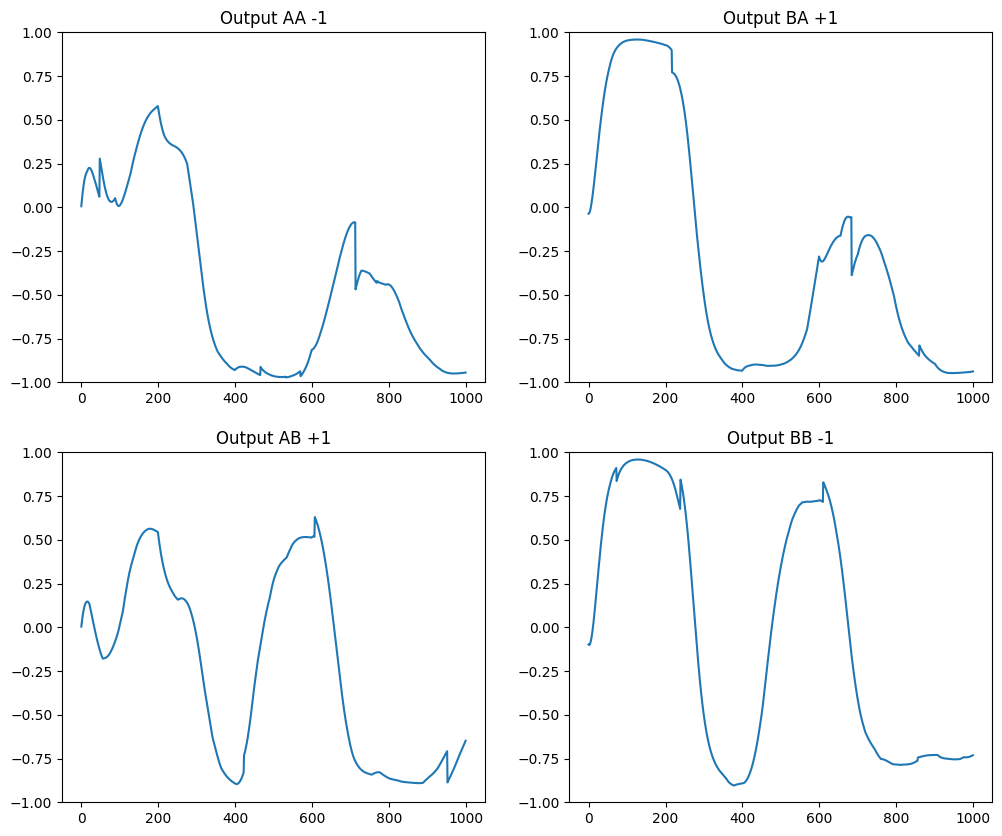

In [10]:
# Perform the four different trials successively
initialAA, errorAA = dnms_trial(0, [0, 0], -0.98, 0.0, record=True)
initialAB, errorAB = dnms_trial(0, [0, 1], +0.98, 0.0, record=True)
initialBA, errorBA = dnms_trial(0, [1, 0], +0.98, 0.0, record=True)
initialBB, errorBB = dnms_trial(0, [1, 1], -0.98, 0.0, record=True)

plt.figure(figsize=(12, 10))
ax = plt.subplot(221)
ax.plot(initialAA[:, OUTPUT_NEURON])
ax.set_ylim((-1., 1.))
ax.set_title('Output AA -1')
ax = plt.subplot(222)
ax.plot(initialBA[:, OUTPUT_NEURON])
ax.set_ylim((-1., 1.))
ax.set_title('Output BA +1')
ax = plt.subplot(223)
ax.plot(initialAB[:, OUTPUT_NEURON])
ax.set_ylim((-1., 1.))
ax.set_title('Output AB +1')
ax = plt.subplot(224)
ax.plot(initialBB[:, OUTPUT_NEURON])
ax.set_ylim((-1., 1.))
ax.set_title('Output BB -1')
plt.show()

We can now run the simulation for 1500 trials. Beware, this can take 15 to 20 minutes.

In [11]:
# Compute the mean reward per trial
R_mean = - np.ones((2, 2))
alpha = 0.75

# Many trials of each type
record_rewards = []

for trial in (t := tqdm(range(10000))):

    # Perform the four different trials successively
    _, rewardAA = dnms_trial(trial, [0, 0], -0.98, R_mean[0, 0])

    _, rewardAB = dnms_trial(trial, [0, 1], +0.98, R_mean[0, 1])

    _, rewardBA = dnms_trial(trial, [1, 0], +0.98, R_mean[1, 0])

    _, rewardBB = dnms_trial(trial, [1, 1], -0.98, R_mean[1, 1])

    # Reward
    reward = np.array([[rewardAA, rewardBA], [rewardBA, rewardBB]])

    # Update mean reward
    R_mean = alpha * R_mean + (1.- alpha) * reward

    record_rewards.append(R_mean)
    t.set_description(
        f'AA: {R_mean[0, 0]:.2f} AB: {R_mean[0, 1]:.2f} BA: {R_mean[1, 0]:.2f} BB: {R_mean[1, 1]:.2f}'
    )


  0%|                                                                                       | 0/10000 [00:00<?, ?it/s]

AA: -0.78 AB: -1.18 BA: -1.18 BB: -0.80:   0%|                                              | 0/10000 [00:00<?, ?it/s]

AA: -0.78 AB: -1.18 BA: -1.18 BB: -0.80:   0%|                                      | 1/10000 [00:00<20:46,  8.02it/s]

AA: -0.61 AB: -1.32 BA: -1.32 BB: -0.68:   0%|                                      | 1/10000 [00:00<20:46,  8.02it/s]

AA: -0.61 AB: -1.32 BA: -1.32 BB: -0.68:   0%|                                      | 2/10000 [00:00<20:28,  8.14it/s]

AA: -0.51 AB: -1.42 BA: -1.42 BB: -0.57:   0%|                                      | 2/10000 [00:00<20:28,  8.14it/s]

AA: -0.51 AB: -1.42 BA: -1.42 BB: -0.57:   0%|                                      | 3/10000 [00:00<20:05,  8.29it/s]

AA: -0.43 AB: -1.53 BA: -1.53 BB: -0.47:   0%|                                      | 3/10000 [00:00<20:05,  8.29it/s]

AA: -0.43 AB: -1.53 BA: -1.53 BB: -0.47:   0%|                                      | 4/10000 [00:00<19:56,  8.36it/s]

AA: -0.39 AB: -1.61 BA: -1.61 BB: -0.41:   0%|                                      | 4/10000 [00:00<19:56,  8.36it/s]

AA: -0.39 AB: -1.61 BA: -1.61 BB: -0.41:   0%|                                      | 5/10000 [00:00<19:49,  8.40it/s]

AA: -0.32 AB: -1.65 BA: -1.65 BB: -0.37:   0%|                                      | 5/10000 [00:00<19:49,  8.40it/s]

AA: -0.32 AB: -1.65 BA: -1.65 BB: -0.37:   0%|                                      | 6/10000 [00:00<19:48,  8.41it/s]

AA: -0.29 AB: -1.70 BA: -1.70 BB: -0.33:   0%|                                      | 6/10000 [00:00<19:48,  8.41it/s]

AA: -0.29 AB: -1.70 BA: -1.70 BB: -0.33:   0%|                                      | 7/10000 [00:00<19:44,  8.43it/s]

AA: -0.26 AB: -1.72 BA: -1.72 BB: -0.32:   0%|                                      | 7/10000 [00:00<19:44,  8.43it/s]

AA: -0.26 AB: -1.72 BA: -1.72 BB: -0.32:   0%|                                      | 8/10000 [00:00<19:42,  8.45it/s]

AA: -0.23 AB: -1.71 BA: -1.71 BB: -0.31:   0%|                                      | 8/10000 [00:01<19:42,  8.45it/s]

AA: -0.23 AB: -1.71 BA: -1.71 BB: -0.31:   0%|                                      | 9/10000 [00:01<19:43,  8.44it/s]

AA: -0.23 AB: -1.71 BA: -1.71 BB: -0.34:   0%|                                      | 9/10000 [00:01<19:43,  8.44it/s]

AA: -0.23 AB: -1.71 BA: -1.71 BB: -0.34:   0%|                                     | 10/10000 [00:01<19:41,  8.46it/s]

AA: -0.26 AB: -1.72 BA: -1.72 BB: -0.31:   0%|                                     | 10/10000 [00:01<19:41,  8.46it/s]

AA: -0.26 AB: -1.72 BA: -1.72 BB: -0.31:   0%|                                     | 11/10000 [00:01<19:38,  8.48it/s]

AA: -0.23 AB: -1.73 BA: -1.73 BB: -0.28:   0%|                                     | 11/10000 [00:01<19:38,  8.48it/s]

AA: -0.23 AB: -1.73 BA: -1.73 BB: -0.28:   0%|                                     | 12/10000 [00:01<19:36,  8.49it/s]

AA: -0.21 AB: -1.71 BA: -1.71 BB: -0.28:   0%|                                     | 12/10000 [00:01<19:36,  8.49it/s]

AA: -0.21 AB: -1.71 BA: -1.71 BB: -0.28:   0%|                                     | 13/10000 [00:01<19:38,  8.47it/s]

AA: -0.22 AB: -1.69 BA: -1.69 BB: -0.26:   0%|                                     | 13/10000 [00:01<19:38,  8.47it/s]

AA: -0.22 AB: -1.69 BA: -1.69 BB: -0.26:   0%|                                     | 14/10000 [00:01<19:48,  8.40it/s]

AA: -0.21 AB: -1.72 BA: -1.72 BB: -0.24:   0%|                                     | 14/10000 [00:01<19:48,  8.40it/s]

AA: -0.21 AB: -1.72 BA: -1.72 BB: -0.24:   0%|                                     | 15/10000 [00:01<19:47,  8.41it/s]

AA: -0.19 AB: -1.72 BA: -1.72 BB: -0.24:   0%|                                     | 15/10000 [00:01<19:47,  8.41it/s]

AA: -0.19 AB: -1.72 BA: -1.72 BB: -0.24:   0%|                                     | 16/10000 [00:01<19:45,  8.42it/s]

AA: -0.19 AB: -1.75 BA: -1.75 BB: -0.26:   0%|                                     | 16/10000 [00:02<19:45,  8.42it/s]

AA: -0.19 AB: -1.75 BA: -1.75 BB: -0.26:   0%|                                     | 17/10000 [00:02<19:47,  8.41it/s]

AA: -0.18 AB: -1.77 BA: -1.77 BB: -0.25:   0%|                                     | 17/10000 [00:02<19:47,  8.41it/s]

AA: -0.18 AB: -1.77 BA: -1.77 BB: -0.25:   0%|                                     | 18/10000 [00:02<19:49,  8.39it/s]

AA: -0.18 AB: -1.77 BA: -1.77 BB: -0.26:   0%|                                     | 18/10000 [00:02<19:49,  8.39it/s]

AA: -0.18 AB: -1.77 BA: -1.77 BB: -0.26:   0%|                                     | 19/10000 [00:02<19:47,  8.41it/s]

AA: -0.17 AB: -1.78 BA: -1.78 BB: -0.26:   0%|                                     | 19/10000 [00:02<19:47,  8.41it/s]

AA: -0.17 AB: -1.78 BA: -1.78 BB: -0.26:   0%|                                     | 20/10000 [00:02<19:45,  8.42it/s]

AA: -0.17 AB: -1.76 BA: -1.76 BB: -0.25:   0%|                                     | 20/10000 [00:02<19:45,  8.42it/s]

AA: -0.17 AB: -1.76 BA: -1.76 BB: -0.25:   0%|                                     | 21/10000 [00:02<19:41,  8.44it/s]

AA: -0.16 AB: -1.77 BA: -1.77 BB: -0.25:   0%|                                     | 21/10000 [00:02<19:41,  8.44it/s]

AA: -0.16 AB: -1.77 BA: -1.77 BB: -0.25:   0%|                                     | 22/10000 [00:02<19:39,  8.46it/s]

AA: -0.15 AB: -1.77 BA: -1.77 BB: -0.26:   0%|                                     | 22/10000 [00:02<19:39,  8.46it/s]

AA: -0.15 AB: -1.77 BA: -1.77 BB: -0.26:   0%|                                     | 23/10000 [00:02<19:40,  8.45it/s]

AA: -0.19 AB: -1.76 BA: -1.76 BB: -0.28:   0%|                                     | 23/10000 [00:02<19:40,  8.45it/s]

AA: -0.19 AB: -1.76 BA: -1.76 BB: -0.28:   0%|                                     | 24/10000 [00:02<19:41,  8.44it/s]

AA: -0.22 AB: -1.77 BA: -1.77 BB: -0.26:   0%|                                     | 24/10000 [00:02<19:41,  8.44it/s]

AA: -0.22 AB: -1.77 BA: -1.77 BB: -0.26:   0%|                                     | 25/10000 [00:02<19:41,  8.44it/s]

AA: -0.21 AB: -1.77 BA: -1.77 BB: -0.25:   0%|                                     | 25/10000 [00:03<19:41,  8.44it/s]

AA: -0.21 AB: -1.77 BA: -1.77 BB: -0.25:   0%|                                     | 26/10000 [00:03<19:44,  8.42it/s]

AA: -0.22 AB: -1.75 BA: -1.75 BB: -0.24:   0%|                                     | 26/10000 [00:03<19:44,  8.42it/s]

AA: -0.22 AB: -1.75 BA: -1.75 BB: -0.24:   0%|                                     | 27/10000 [00:03<19:48,  8.39it/s]

AA: -0.21 AB: -1.77 BA: -1.77 BB: -0.24:   0%|                                     | 27/10000 [00:03<19:48,  8.39it/s]

AA: -0.21 AB: -1.77 BA: -1.77 BB: -0.24:   0%|                                     | 28/10000 [00:03<19:52,  8.36it/s]

AA: -0.19 AB: -1.78 BA: -1.78 BB: -0.22:   0%|                                     | 28/10000 [00:03<19:52,  8.36it/s]

AA: -0.19 AB: -1.78 BA: -1.78 BB: -0.22:   0%|                                     | 29/10000 [00:03<19:55,  8.34it/s]

AA: -0.19 AB: -1.80 BA: -1.80 BB: -0.22:   0%|                                     | 29/10000 [00:03<19:55,  8.34it/s]

AA: -0.19 AB: -1.80 BA: -1.80 BB: -0.22:   0%|                                     | 30/10000 [00:03<19:55,  8.34it/s]

AA: -0.19 AB: -1.78 BA: -1.78 BB: -0.25:   0%|                                     | 30/10000 [00:03<19:55,  8.34it/s]

AA: -0.19 AB: -1.78 BA: -1.78 BB: -0.25:   0%|                                     | 31/10000 [00:03<19:54,  8.35it/s]

AA: -0.19 AB: -1.78 BA: -1.78 BB: -0.24:   0%|                                     | 31/10000 [00:03<19:54,  8.35it/s]

AA: -0.19 AB: -1.78 BA: -1.78 BB: -0.24:   0%|                                     | 32/10000 [00:03<19:52,  8.36it/s]

AA: -0.18 AB: -1.78 BA: -1.78 BB: -0.27:   0%|                                     | 32/10000 [00:03<19:52,  8.36it/s]

AA: -0.18 AB: -1.78 BA: -1.78 BB: -0.27:   0%|                                     | 33/10000 [00:03<19:52,  8.36it/s]

AA: -0.18 AB: -1.74 BA: -1.74 BB: -0.25:   0%|                                     | 33/10000 [00:04<19:52,  8.36it/s]

AA: -0.18 AB: -1.74 BA: -1.74 BB: -0.25:   0%|▏                                    | 34/10000 [00:04<19:52,  8.36it/s]

AA: -0.18 AB: -1.71 BA: -1.71 BB: -0.25:   0%|▏                                    | 34/10000 [00:04<19:52,  8.36it/s]

AA: -0.18 AB: -1.71 BA: -1.71 BB: -0.25:   0%|▏                                    | 35/10000 [00:04<19:51,  8.36it/s]

AA: -0.17 AB: -1.73 BA: -1.73 BB: -0.27:   0%|▏                                    | 35/10000 [00:04<19:51,  8.36it/s]

AA: -0.17 AB: -1.73 BA: -1.73 BB: -0.27:   0%|▏                                    | 36/10000 [00:04<19:50,  8.37it/s]

AA: -0.16 AB: -1.74 BA: -1.74 BB: -0.27:   0%|▏                                    | 36/10000 [00:04<19:50,  8.37it/s]

AA: -0.16 AB: -1.74 BA: -1.74 BB: -0.27:   0%|▏                                    | 37/10000 [00:04<19:50,  8.37it/s]

AA: -0.15 AB: -1.75 BA: -1.75 BB: -0.25:   0%|▏                                    | 37/10000 [00:04<19:50,  8.37it/s]

AA: -0.15 AB: -1.75 BA: -1.75 BB: -0.25:   0%|▏                                    | 38/10000 [00:04<19:49,  8.37it/s]

AA: -0.15 AB: -1.77 BA: -1.77 BB: -0.26:   0%|▏                                    | 38/10000 [00:04<19:49,  8.37it/s]

AA: -0.15 AB: -1.77 BA: -1.77 BB: -0.26:   0%|▏                                    | 39/10000 [00:04<20:08,  8.24it/s]

AA: -0.14 AB: -1.79 BA: -1.79 BB: -0.24:   0%|▏                                    | 39/10000 [00:04<20:08,  8.24it/s]

AA: -0.14 AB: -1.79 BA: -1.79 BB: -0.24:   0%|▏                                    | 40/10000 [00:04<20:21,  8.16it/s]

AA: -0.15 AB: -1.80 BA: -1.80 BB: -0.25:   0%|▏                                    | 40/10000 [00:04<20:21,  8.16it/s]

AA: -0.15 AB: -1.80 BA: -1.80 BB: -0.25:   0%|▏                                    | 41/10000 [00:04<20:17,  8.18it/s]

AA: -0.15 AB: -1.79 BA: -1.79 BB: -0.24:   0%|▏                                    | 41/10000 [00:05<20:17,  8.18it/s]

AA: -0.15 AB: -1.79 BA: -1.79 BB: -0.24:   0%|▏                                    | 42/10000 [00:05<20:10,  8.23it/s]

AA: -0.16 AB: -1.79 BA: -1.79 BB: -0.25:   0%|▏                                    | 42/10000 [00:05<20:10,  8.23it/s]

AA: -0.16 AB: -1.79 BA: -1.79 BB: -0.25:   0%|▏                                    | 43/10000 [00:05<20:05,  8.26it/s]

AA: -0.15 AB: -1.77 BA: -1.77 BB: -0.27:   0%|▏                                    | 43/10000 [00:05<20:05,  8.26it/s]

AA: -0.15 AB: -1.77 BA: -1.77 BB: -0.27:   0%|▏                                    | 44/10000 [00:05<20:04,  8.27it/s]

AA: -0.16 AB: -1.77 BA: -1.77 BB: -0.25:   0%|▏                                    | 44/10000 [00:05<20:04,  8.27it/s]

AA: -0.16 AB: -1.77 BA: -1.77 BB: -0.25:   0%|▏                                    | 45/10000 [00:05<20:03,  8.27it/s]

AA: -0.17 AB: -1.76 BA: -1.76 BB: -0.25:   0%|▏                                    | 45/10000 [00:05<20:03,  8.27it/s]

AA: -0.17 AB: -1.76 BA: -1.76 BB: -0.25:   0%|▏                                    | 46/10000 [00:05<20:01,  8.28it/s]

AA: -0.18 AB: -1.76 BA: -1.76 BB: -0.26:   0%|▏                                    | 46/10000 [00:05<20:01,  8.28it/s]

AA: -0.18 AB: -1.76 BA: -1.76 BB: -0.26:   0%|▏                                    | 47/10000 [00:05<20:07,  8.24it/s]

AA: -0.18 AB: -1.72 BA: -1.72 BB: -0.29:   0%|▏                                    | 47/10000 [00:05<20:07,  8.24it/s]

AA: -0.18 AB: -1.72 BA: -1.72 BB: -0.29:   0%|▏                                    | 48/10000 [00:05<20:04,  8.26it/s]

AA: -0.18 AB: -1.75 BA: -1.75 BB: -0.29:   0%|▏                                    | 48/10000 [00:05<20:04,  8.26it/s]

AA: -0.18 AB: -1.75 BA: -1.75 BB: -0.29:   0%|▏                                    | 49/10000 [00:05<20:02,  8.27it/s]

AA: -0.21 AB: -1.73 BA: -1.73 BB: -0.28:   0%|▏                                    | 49/10000 [00:05<20:02,  8.27it/s]

AA: -0.21 AB: -1.73 BA: -1.73 BB: -0.28:   0%|▏                                    | 50/10000 [00:05<20:03,  8.27it/s]

AA: -0.22 AB: -1.74 BA: -1.74 BB: -0.29:   0%|▏                                    | 50/10000 [00:06<20:03,  8.27it/s]

AA: -0.22 AB: -1.74 BA: -1.74 BB: -0.29:   1%|▏                                    | 51/10000 [00:06<20:00,  8.29it/s]

AA: -0.21 AB: -1.74 BA: -1.74 BB: -0.29:   1%|▏                                    | 51/10000 [00:06<20:00,  8.29it/s]

AA: -0.21 AB: -1.74 BA: -1.74 BB: -0.29:   1%|▏                                    | 52/10000 [00:06<19:59,  8.29it/s]

AA: -0.20 AB: -1.74 BA: -1.74 BB: -0.30:   1%|▏                                    | 52/10000 [00:06<19:59,  8.29it/s]

AA: -0.20 AB: -1.74 BA: -1.74 BB: -0.30:   1%|▏                                    | 53/10000 [00:06<20:05,  8.25it/s]

AA: -0.21 AB: -1.76 BA: -1.76 BB: -0.28:   1%|▏                                    | 53/10000 [00:06<20:05,  8.25it/s]

AA: -0.21 AB: -1.76 BA: -1.76 BB: -0.28:   1%|▏                                    | 54/10000 [00:06<20:09,  8.22it/s]

AA: -0.20 AB: -1.76 BA: -1.76 BB: -0.28:   1%|▏                                    | 54/10000 [00:06<20:09,  8.22it/s]

AA: -0.20 AB: -1.76 BA: -1.76 BB: -0.28:   1%|▏                                    | 55/10000 [00:06<20:17,  8.17it/s]

AA: -0.18 AB: -1.78 BA: -1.78 BB: -0.29:   1%|▏                                    | 55/10000 [00:06<20:17,  8.17it/s]

AA: -0.18 AB: -1.78 BA: -1.78 BB: -0.29:   1%|▏                                    | 56/10000 [00:06<20:16,  8.18it/s]

AA: -0.18 AB: -1.76 BA: -1.76 BB: -0.29:   1%|▏                                    | 56/10000 [00:06<20:16,  8.18it/s]

AA: -0.18 AB: -1.76 BA: -1.76 BB: -0.29:   1%|▏                                    | 57/10000 [00:06<21:10,  7.83it/s]

AA: -0.17 AB: -1.76 BA: -1.76 BB: -0.30:   1%|▏                                    | 57/10000 [00:06<21:10,  7.83it/s]

AA: -0.17 AB: -1.76 BA: -1.76 BB: -0.30:   1%|▏                                    | 58/10000 [00:06<20:53,  7.93it/s]

AA: -0.20 AB: -1.75 BA: -1.75 BB: -0.29:   1%|▏                                    | 58/10000 [00:07<20:53,  7.93it/s]

AA: -0.20 AB: -1.75 BA: -1.75 BB: -0.29:   1%|▏                                    | 59/10000 [00:07<20:48,  7.97it/s]

AA: -0.19 AB: -1.74 BA: -1.74 BB: -0.26:   1%|▏                                    | 59/10000 [00:07<20:48,  7.97it/s]

AA: -0.19 AB: -1.74 BA: -1.74 BB: -0.26:   1%|▏                                    | 60/10000 [00:07<20:47,  7.96it/s]

AA: -0.24 AB: -1.74 BA: -1.74 BB: -0.25:   1%|▏                                    | 60/10000 [00:07<20:47,  7.96it/s]

AA: -0.24 AB: -1.74 BA: -1.74 BB: -0.25:   1%|▏                                    | 61/10000 [00:07<20:38,  8.02it/s]

AA: -0.24 AB: -1.76 BA: -1.76 BB: -0.27:   1%|▏                                    | 61/10000 [00:07<20:38,  8.02it/s]

AA: -0.24 AB: -1.76 BA: -1.76 BB: -0.27:   1%|▏                                    | 62/10000 [00:07<20:30,  8.08it/s]

AA: -0.24 AB: -1.75 BA: -1.75 BB: -0.27:   1%|▏                                    | 62/10000 [00:07<20:30,  8.08it/s]

AA: -0.24 AB: -1.75 BA: -1.75 BB: -0.27:   1%|▏                                    | 63/10000 [00:07<20:26,  8.10it/s]

AA: -0.21 AB: -1.78 BA: -1.78 BB: -0.26:   1%|▏                                    | 63/10000 [00:07<20:26,  8.10it/s]

AA: -0.21 AB: -1.78 BA: -1.78 BB: -0.26:   1%|▏                                    | 64/10000 [00:07<20:24,  8.12it/s]

AA: -0.21 AB: -1.78 BA: -1.78 BB: -0.25:   1%|▏                                    | 64/10000 [00:07<20:24,  8.12it/s]

AA: -0.21 AB: -1.78 BA: -1.78 BB: -0.25:   1%|▏                                    | 65/10000 [00:07<20:27,  8.09it/s]

AA: -0.23 AB: -1.76 BA: -1.76 BB: -0.24:   1%|▏                                    | 65/10000 [00:07<20:27,  8.09it/s]

AA: -0.23 AB: -1.76 BA: -1.76 BB: -0.24:   1%|▏                                    | 66/10000 [00:07<20:21,  8.13it/s]

AA: -0.22 AB: -1.78 BA: -1.78 BB: -0.27:   1%|▏                                    | 66/10000 [00:08<20:21,  8.13it/s]

AA: -0.22 AB: -1.78 BA: -1.78 BB: -0.27:   1%|▏                                    | 67/10000 [00:08<20:16,  8.16it/s]

AA: -0.20 AB: -1.77 BA: -1.77 BB: -0.28:   1%|▏                                    | 67/10000 [00:08<20:16,  8.16it/s]

AA: -0.20 AB: -1.77 BA: -1.77 BB: -0.28:   1%|▎                                    | 68/10000 [00:08<20:14,  8.17it/s]

AA: -0.19 AB: -1.76 BA: -1.76 BB: -0.28:   1%|▎                                    | 68/10000 [00:08<20:14,  8.17it/s]

AA: -0.19 AB: -1.76 BA: -1.76 BB: -0.28:   1%|▎                                    | 69/10000 [00:08<20:09,  8.21it/s]

AA: -0.21 AB: -1.75 BA: -1.75 BB: -0.28:   1%|▎                                    | 69/10000 [00:08<20:09,  8.21it/s]

AA: -0.21 AB: -1.75 BA: -1.75 BB: -0.28:   1%|▎                                    | 70/10000 [00:08<20:07,  8.22it/s]

AA: -0.20 AB: -1.73 BA: -1.73 BB: -0.26:   1%|▎                                    | 70/10000 [00:08<20:07,  8.22it/s]

AA: -0.20 AB: -1.73 BA: -1.73 BB: -0.26:   1%|▎                                    | 71/10000 [00:08<20:05,  8.24it/s]

AA: -0.21 AB: -1.72 BA: -1.72 BB: -0.29:   1%|▎                                    | 71/10000 [00:08<20:05,  8.24it/s]

AA: -0.21 AB: -1.72 BA: -1.72 BB: -0.29:   1%|▎                                    | 72/10000 [00:08<20:04,  8.24it/s]

AA: -0.20 AB: -1.72 BA: -1.72 BB: -0.30:   1%|▎                                    | 72/10000 [00:08<20:04,  8.24it/s]

AA: -0.20 AB: -1.72 BA: -1.72 BB: -0.30:   1%|▎                                    | 73/10000 [00:08<20:03,  8.25it/s]

AA: -0.18 AB: -1.74 BA: -1.74 BB: -0.28:   1%|▎                                    | 73/10000 [00:08<20:03,  8.25it/s]

AA: -0.18 AB: -1.74 BA: -1.74 BB: -0.28:   1%|▎                                    | 74/10000 [00:08<20:03,  8.25it/s]

AA: -0.20 AB: -1.72 BA: -1.72 BB: -0.28:   1%|▎                                    | 74/10000 [00:09<20:03,  8.25it/s]

AA: -0.20 AB: -1.72 BA: -1.72 BB: -0.28:   1%|▎                                    | 75/10000 [00:09<20:03,  8.25it/s]

AA: -0.21 AB: -1.75 BA: -1.75 BB: -0.26:   1%|▎                                    | 75/10000 [00:09<20:03,  8.25it/s]

AA: -0.21 AB: -1.75 BA: -1.75 BB: -0.26:   1%|▎                                    | 76/10000 [00:09<20:05,  8.23it/s]

AA: -0.22 AB: -1.77 BA: -1.77 BB: -0.26:   1%|▎                                    | 76/10000 [00:09<20:05,  8.23it/s]

AA: -0.22 AB: -1.77 BA: -1.77 BB: -0.26:   1%|▎                                    | 77/10000 [00:09<20:05,  8.23it/s]

AA: -0.20 AB: -1.74 BA: -1.74 BB: -0.25:   1%|▎                                    | 77/10000 [00:09<20:05,  8.23it/s]

AA: -0.20 AB: -1.74 BA: -1.74 BB: -0.25:   1%|▎                                    | 78/10000 [00:09<20:02,  8.25it/s]

AA: -0.18 AB: -1.72 BA: -1.72 BB: -0.25:   1%|▎                                    | 78/10000 [00:09<20:02,  8.25it/s]

AA: -0.18 AB: -1.72 BA: -1.72 BB: -0.25:   1%|▎                                    | 79/10000 [00:09<20:04,  8.24it/s]

AA: -0.19 AB: -1.70 BA: -1.70 BB: -0.25:   1%|▎                                    | 79/10000 [00:09<20:04,  8.24it/s]

AA: -0.19 AB: -1.70 BA: -1.70 BB: -0.25:   1%|▎                                    | 80/10000 [00:09<20:03,  8.24it/s]

AA: -0.19 AB: -1.72 BA: -1.72 BB: -0.24:   1%|▎                                    | 80/10000 [00:09<20:03,  8.24it/s]

AA: -0.19 AB: -1.72 BA: -1.72 BB: -0.24:   1%|▎                                    | 81/10000 [00:09<20:23,  8.11it/s]

AA: -0.23 AB: -1.74 BA: -1.74 BB: -0.25:   1%|▎                                    | 81/10000 [00:09<20:23,  8.11it/s]

AA: -0.23 AB: -1.74 BA: -1.74 BB: -0.25:   1%|▎                                    | 82/10000 [00:09<20:40,  7.99it/s]

AA: -0.22 AB: -1.75 BA: -1.75 BB: -0.22:   1%|▎                                    | 82/10000 [00:10<20:40,  7.99it/s]

AA: -0.22 AB: -1.75 BA: -1.75 BB: -0.22:   1%|▎                                    | 83/10000 [00:10<20:30,  8.06it/s]

AA: -0.20 AB: -1.73 BA: -1.73 BB: -0.21:   1%|▎                                    | 83/10000 [00:10<20:30,  8.06it/s]

AA: -0.20 AB: -1.73 BA: -1.73 BB: -0.21:   1%|▎                                    | 84/10000 [00:10<20:23,  8.10it/s]

AA: -0.19 AB: -1.73 BA: -1.73 BB: -0.22:   1%|▎                                    | 84/10000 [00:10<20:23,  8.10it/s]

AA: -0.19 AB: -1.73 BA: -1.73 BB: -0.22:   1%|▎                                    | 85/10000 [00:10<20:17,  8.14it/s]

AA: -0.21 AB: -1.73 BA: -1.73 BB: -0.22:   1%|▎                                    | 85/10000 [00:10<20:17,  8.14it/s]

AA: -0.21 AB: -1.73 BA: -1.73 BB: -0.22:   1%|▎                                    | 86/10000 [00:10<20:14,  8.16it/s]

AA: -0.19 AB: -1.75 BA: -1.75 BB: -0.21:   1%|▎                                    | 86/10000 [00:10<20:14,  8.16it/s]

AA: -0.19 AB: -1.75 BA: -1.75 BB: -0.21:   1%|▎                                    | 87/10000 [00:10<20:09,  8.19it/s]

AA: -0.18 AB: -1.74 BA: -1.74 BB: -0.22:   1%|▎                                    | 87/10000 [00:10<20:09,  8.19it/s]

AA: -0.18 AB: -1.74 BA: -1.74 BB: -0.22:   1%|▎                                    | 88/10000 [00:10<20:06,  8.21it/s]

AA: -0.19 AB: -1.76 BA: -1.76 BB: -0.22:   1%|▎                                    | 88/10000 [00:10<20:06,  8.21it/s]

AA: -0.19 AB: -1.76 BA: -1.76 BB: -0.22:   1%|▎                                    | 89/10000 [00:10<20:05,  8.22it/s]

AA: -0.19 AB: -1.77 BA: -1.77 BB: -0.22:   1%|▎                                    | 89/10000 [00:10<20:05,  8.22it/s]

AA: -0.19 AB: -1.77 BA: -1.77 BB: -0.22:   1%|▎                                    | 90/10000 [00:10<20:21,  8.11it/s]

AA: -0.18 AB: -1.78 BA: -1.78 BB: -0.23:   1%|▎                                    | 90/10000 [00:11<20:21,  8.11it/s]

AA: -0.18 AB: -1.78 BA: -1.78 BB: -0.23:   1%|▎                                    | 91/10000 [00:11<20:23,  8.10it/s]

AA: -0.18 AB: -1.76 BA: -1.76 BB: -0.22:   1%|▎                                    | 91/10000 [00:11<20:23,  8.10it/s]

AA: -0.18 AB: -1.76 BA: -1.76 BB: -0.22:   1%|▎                                    | 92/10000 [00:11<20:28,  8.07it/s]

AA: -0.17 AB: -1.74 BA: -1.74 BB: -0.22:   1%|▎                                    | 92/10000 [00:11<20:28,  8.07it/s]

AA: -0.17 AB: -1.74 BA: -1.74 BB: -0.22:   1%|▎                                    | 93/10000 [00:11<20:28,  8.07it/s]

AA: -0.17 AB: -1.76 BA: -1.76 BB: -0.22:   1%|▎                                    | 93/10000 [00:11<20:28,  8.07it/s]

AA: -0.17 AB: -1.76 BA: -1.76 BB: -0.22:   1%|▎                                    | 94/10000 [00:11<20:26,  8.07it/s]

AA: -0.17 AB: -1.74 BA: -1.74 BB: -0.23:   1%|▎                                    | 94/10000 [00:11<20:26,  8.07it/s]

AA: -0.17 AB: -1.74 BA: -1.74 BB: -0.23:   1%|▎                                    | 95/10000 [00:11<20:26,  8.08it/s]

AA: -0.21 AB: -1.75 BA: -1.75 BB: -0.23:   1%|▎                                    | 95/10000 [00:11<20:26,  8.08it/s]

AA: -0.21 AB: -1.75 BA: -1.75 BB: -0.23:   1%|▎                                    | 96/10000 [00:11<20:27,  8.07it/s]

AA: -0.22 AB: -1.72 BA: -1.72 BB: -0.21:   1%|▎                                    | 96/10000 [00:11<20:27,  8.07it/s]

AA: -0.22 AB: -1.72 BA: -1.72 BB: -0.21:   1%|▎                                    | 97/10000 [00:11<20:25,  8.08it/s]

AA: -0.22 AB: -1.68 BA: -1.68 BB: -0.20:   1%|▎                                    | 97/10000 [00:11<20:25,  8.08it/s]

AA: -0.22 AB: -1.68 BA: -1.68 BB: -0.20:   1%|▎                                    | 98/10000 [00:11<20:24,  8.09it/s]

AA: -0.22 AB: -1.70 BA: -1.70 BB: -0.23:   1%|▎                                    | 98/10000 [00:12<20:24,  8.09it/s]

AA: -0.22 AB: -1.70 BA: -1.70 BB: -0.23:   1%|▎                                    | 99/10000 [00:12<20:24,  8.09it/s]

AA: -0.21 AB: -1.71 BA: -1.71 BB: -0.24:   1%|▎                                    | 99/10000 [00:12<20:24,  8.09it/s]

AA: -0.21 AB: -1.71 BA: -1.71 BB: -0.24:   1%|▎                                   | 100/10000 [00:12<20:22,  8.10it/s]

AA: -0.22 AB: -1.71 BA: -1.71 BB: -0.22:   1%|▎                                   | 100/10000 [00:12<20:22,  8.10it/s]

AA: -0.22 AB: -1.71 BA: -1.71 BB: -0.22:   1%|▎                                   | 101/10000 [00:12<20:23,  8.09it/s]

AA: -0.22 AB: -1.71 BA: -1.71 BB: -0.20:   1%|▎                                   | 101/10000 [00:12<20:23,  8.09it/s]

AA: -0.22 AB: -1.71 BA: -1.71 BB: -0.20:   1%|▎                                   | 102/10000 [00:12<20:40,  7.98it/s]

AA: -0.22 AB: -1.68 BA: -1.68 BB: -0.19:   1%|▎                                   | 102/10000 [00:12<20:40,  7.98it/s]

AA: -0.22 AB: -1.68 BA: -1.68 BB: -0.19:   1%|▎                                   | 103/10000 [00:12<20:25,  8.08it/s]

AA: -0.19 AB: -1.68 BA: -1.68 BB: -0.19:   1%|▎                                   | 103/10000 [00:12<20:25,  8.08it/s]

AA: -0.19 AB: -1.68 BA: -1.68 BB: -0.19:   1%|▎                                   | 104/10000 [00:12<20:15,  8.14it/s]

AA: -0.20 AB: -1.71 BA: -1.71 BB: -0.21:   1%|▎                                   | 104/10000 [00:12<20:15,  8.14it/s]

AA: -0.20 AB: -1.71 BA: -1.71 BB: -0.21:   1%|▍                                   | 105/10000 [00:12<20:09,  8.18it/s]

AA: -0.22 AB: -1.67 BA: -1.67 BB: -0.19:   1%|▍                                   | 105/10000 [00:12<20:09,  8.18it/s]

AA: -0.22 AB: -1.67 BA: -1.67 BB: -0.19:   1%|▍                                   | 106/10000 [00:12<20:03,  8.22it/s]

AA: -0.21 AB: -1.69 BA: -1.69 BB: -0.20:   1%|▍                                   | 106/10000 [00:12<20:03,  8.22it/s]

AA: -0.21 AB: -1.69 BA: -1.69 BB: -0.20:   1%|▍                                   | 107/10000 [00:12<19:58,  8.25it/s]

AA: -0.22 AB: -1.68 BA: -1.68 BB: -0.20:   1%|▍                                   | 107/10000 [00:13<19:58,  8.25it/s]

AA: -0.22 AB: -1.68 BA: -1.68 BB: -0.20:   1%|▍                                   | 108/10000 [00:13<20:14,  8.15it/s]

AA: -0.21 AB: -1.67 BA: -1.67 BB: -0.20:   1%|▍                                   | 108/10000 [00:13<20:14,  8.15it/s]

AA: -0.21 AB: -1.67 BA: -1.67 BB: -0.20:   1%|▍                                   | 109/10000 [00:13<20:25,  8.07it/s]

AA: -0.19 AB: -1.69 BA: -1.69 BB: -0.19:   1%|▍                                   | 109/10000 [00:13<20:25,  8.07it/s]

AA: -0.19 AB: -1.69 BA: -1.69 BB: -0.19:   1%|▍                                   | 110/10000 [00:13<20:17,  8.12it/s]

AA: -0.20 AB: -1.67 BA: -1.67 BB: -0.18:   1%|▍                                   | 110/10000 [00:13<20:17,  8.12it/s]

AA: -0.20 AB: -1.67 BA: -1.67 BB: -0.18:   1%|▍                                   | 111/10000 [00:13<20:10,  8.17it/s]

AA: -0.20 AB: -1.68 BA: -1.68 BB: -0.20:   1%|▍                                   | 111/10000 [00:13<20:10,  8.17it/s]

AA: -0.20 AB: -1.68 BA: -1.68 BB: -0.20:   1%|▍                                   | 112/10000 [00:13<20:05,  8.20it/s]

AA: -0.21 AB: -1.69 BA: -1.69 BB: -0.22:   1%|▍                                   | 112/10000 [00:13<20:05,  8.20it/s]

AA: -0.21 AB: -1.69 BA: -1.69 BB: -0.22:   1%|▍                                   | 113/10000 [00:13<20:03,  8.22it/s]

AA: -0.21 AB: -1.68 BA: -1.68 BB: -0.21:   1%|▍                                   | 113/10000 [00:13<20:03,  8.22it/s]

AA: -0.21 AB: -1.68 BA: -1.68 BB: -0.21:   1%|▍                                   | 114/10000 [00:13<20:00,  8.24it/s]

AA: -0.20 AB: -1.70 BA: -1.70 BB: -0.21:   1%|▍                                   | 114/10000 [00:13<20:00,  8.24it/s]

AA: -0.20 AB: -1.70 BA: -1.70 BB: -0.21:   1%|▍                                   | 115/10000 [00:13<19:58,  8.25it/s]

AA: -0.21 AB: -1.70 BA: -1.70 BB: -0.21:   1%|▍                                   | 115/10000 [00:14<19:58,  8.25it/s]

AA: -0.21 AB: -1.70 BA: -1.70 BB: -0.21:   1%|▍                                   | 116/10000 [00:14<19:56,  8.26it/s]

AA: -0.20 AB: -1.70 BA: -1.70 BB: -0.20:   1%|▍                                   | 116/10000 [00:14<19:56,  8.26it/s]

AA: -0.20 AB: -1.70 BA: -1.70 BB: -0.20:   1%|▍                                   | 117/10000 [00:14<20:13,  8.14it/s]

AA: -0.18 AB: -1.71 BA: -1.71 BB: -0.19:   1%|▍                                   | 117/10000 [00:14<20:13,  8.14it/s]

AA: -0.18 AB: -1.71 BA: -1.71 BB: -0.19:   1%|▍                                   | 118/10000 [00:14<20:15,  8.13it/s]

AA: -0.18 AB: -1.69 BA: -1.69 BB: -0.18:   1%|▍                                   | 118/10000 [00:14<20:15,  8.13it/s]

AA: -0.18 AB: -1.69 BA: -1.69 BB: -0.18:   1%|▍                                   | 119/10000 [00:14<20:17,  8.12it/s]

AA: -0.19 AB: -1.69 BA: -1.69 BB: -0.19:   1%|▍                                   | 119/10000 [00:14<20:17,  8.12it/s]

AA: -0.19 AB: -1.69 BA: -1.69 BB: -0.19:   1%|▍                                   | 120/10000 [00:14<20:17,  8.11it/s]

AA: -0.20 AB: -1.67 BA: -1.67 BB: -0.21:   1%|▍                                   | 120/10000 [00:14<20:17,  8.11it/s]

AA: -0.20 AB: -1.67 BA: -1.67 BB: -0.21:   1%|▍                                   | 121/10000 [00:14<20:32,  8.01it/s]

AA: -0.20 AB: -1.67 BA: -1.67 BB: -0.20:   1%|▍                                   | 121/10000 [00:14<20:32,  8.01it/s]

AA: -0.20 AB: -1.67 BA: -1.67 BB: -0.20:   1%|▍                                   | 122/10000 [00:14<20:19,  8.10it/s]

AA: -0.21 AB: -1.70 BA: -1.70 BB: -0.20:   1%|▍                                   | 122/10000 [00:14<20:19,  8.10it/s]

AA: -0.21 AB: -1.70 BA: -1.70 BB: -0.20:   1%|▍                                   | 123/10000 [00:14<20:10,  8.16it/s]

AA: -0.20 AB: -1.70 BA: -1.70 BB: -0.19:   1%|▍                                   | 123/10000 [00:15<20:10,  8.16it/s]

AA: -0.20 AB: -1.70 BA: -1.70 BB: -0.19:   1%|▍                                   | 124/10000 [00:15<20:04,  8.20it/s]

AA: -0.21 AB: -1.67 BA: -1.67 BB: -0.19:   1%|▍                                   | 124/10000 [00:15<20:04,  8.20it/s]

AA: -0.21 AB: -1.67 BA: -1.67 BB: -0.19:   1%|▍                                   | 125/10000 [00:15<20:01,  8.22it/s]

AA: -0.21 AB: -1.67 BA: -1.67 BB: -0.19:   1%|▍                                   | 125/10000 [00:15<20:01,  8.22it/s]

AA: -0.21 AB: -1.67 BA: -1.67 BB: -0.19:   1%|▍                                   | 126/10000 [00:15<19:57,  8.25it/s]

AA: -0.22 AB: -1.64 BA: -1.64 BB: -0.18:   1%|▍                                   | 126/10000 [00:15<19:57,  8.25it/s]

AA: -0.22 AB: -1.64 BA: -1.64 BB: -0.18:   1%|▍                                   | 127/10000 [00:15<19:54,  8.27it/s]

AA: -0.22 AB: -1.66 BA: -1.66 BB: -0.18:   1%|▍                                   | 127/10000 [00:15<19:54,  8.27it/s]

AA: -0.22 AB: -1.66 BA: -1.66 BB: -0.18:   1%|▍                                   | 128/10000 [00:15<19:53,  8.27it/s]

AA: -0.23 AB: -1.69 BA: -1.69 BB: -0.19:   1%|▍                                   | 128/10000 [00:15<19:53,  8.27it/s]

AA: -0.23 AB: -1.69 BA: -1.69 BB: -0.19:   1%|▍                                   | 129/10000 [00:15<20:08,  8.17it/s]

AA: -0.21 AB: -1.70 BA: -1.70 BB: -0.18:   1%|▍                                   | 129/10000 [00:15<20:08,  8.17it/s]

AA: -0.21 AB: -1.70 BA: -1.70 BB: -0.18:   1%|▍                                   | 130/10000 [00:15<20:14,  8.13it/s]

AA: -0.22 AB: -1.71 BA: -1.71 BB: -0.18:   1%|▍                                   | 130/10000 [00:15<20:14,  8.13it/s]

AA: -0.22 AB: -1.71 BA: -1.71 BB: -0.18:   1%|▍                                   | 131/10000 [00:15<20:18,  8.10it/s]

AA: -0.23 AB: -1.73 BA: -1.73 BB: -0.16:   1%|▍                                   | 131/10000 [00:16<20:18,  8.10it/s]

AA: -0.23 AB: -1.73 BA: -1.73 BB: -0.16:   1%|▍                                   | 132/10000 [00:16<20:22,  8.07it/s]

AA: -0.21 AB: -1.73 BA: -1.73 BB: -0.17:   1%|▍                                   | 132/10000 [00:16<20:22,  8.07it/s]

AA: -0.21 AB: -1.73 BA: -1.73 BB: -0.17:   1%|▍                                   | 133/10000 [00:16<20:23,  8.06it/s]

AA: -0.19 AB: -1.71 BA: -1.71 BB: -0.17:   1%|▍                                   | 133/10000 [00:16<20:23,  8.06it/s]

AA: -0.19 AB: -1.71 BA: -1.71 BB: -0.17:   1%|▍                                   | 134/10000 [00:16<20:21,  8.08it/s]

AA: -0.19 AB: -1.72 BA: -1.72 BB: -0.16:   1%|▍                                   | 134/10000 [00:16<20:21,  8.08it/s]

AA: -0.19 AB: -1.72 BA: -1.72 BB: -0.16:   1%|▍                                   | 135/10000 [00:16<20:19,  8.09it/s]

AA: -0.17 AB: -1.74 BA: -1.74 BB: -0.17:   1%|▍                                   | 135/10000 [00:16<20:19,  8.09it/s]

AA: -0.17 AB: -1.74 BA: -1.74 BB: -0.17:   1%|▍                                   | 136/10000 [00:16<20:22,  8.07it/s]

AA: -0.18 AB: -1.73 BA: -1.73 BB: -0.18:   1%|▍                                   | 136/10000 [00:16<20:22,  8.07it/s]

AA: -0.18 AB: -1.73 BA: -1.73 BB: -0.18:   1%|▍                                   | 137/10000 [00:16<20:32,  8.00it/s]

AA: -0.20 AB: -1.74 BA: -1.74 BB: -0.18:   1%|▍                                   | 137/10000 [00:16<20:32,  8.00it/s]

AA: -0.20 AB: -1.74 BA: -1.74 BB: -0.18:   1%|▍                                   | 138/10000 [00:16<20:28,  8.03it/s]

AA: -0.18 AB: -1.64 BA: -1.64 BB: -0.18:   1%|▍                                   | 138/10000 [00:16<20:28,  8.03it/s]

AA: -0.18 AB: -1.64 BA: -1.64 BB: -0.18:   1%|▌                                   | 139/10000 [00:16<20:16,  8.11it/s]

AA: -0.20 AB: -1.65 BA: -1.65 BB: -0.16:   1%|▌                                   | 139/10000 [00:17<20:16,  8.11it/s]

AA: -0.20 AB: -1.65 BA: -1.65 BB: -0.16:   1%|▌                                   | 140/10000 [00:17<20:07,  8.16it/s]

AA: -0.21 AB: -1.62 BA: -1.62 BB: -0.16:   1%|▌                                   | 140/10000 [00:17<20:07,  8.16it/s]

AA: -0.21 AB: -1.62 BA: -1.62 BB: -0.16:   1%|▌                                   | 141/10000 [00:17<20:18,  8.09it/s]

AA: -0.22 AB: -1.64 BA: -1.64 BB: -0.16:   1%|▌                                   | 141/10000 [00:17<20:18,  8.09it/s]

AA: -0.22 AB: -1.64 BA: -1.64 BB: -0.16:   1%|▌                                   | 142/10000 [00:17<20:18,  8.09it/s]

AA: -0.24 AB: -1.63 BA: -1.63 BB: -0.16:   1%|▌                                   | 142/10000 [00:17<20:18,  8.09it/s]

AA: -0.24 AB: -1.63 BA: -1.63 BB: -0.16:   1%|▌                                   | 143/10000 [00:17<20:17,  8.09it/s]

AA: -0.23 AB: -1.65 BA: -1.65 BB: -0.14:   1%|▌                                   | 143/10000 [00:17<20:17,  8.09it/s]

AA: -0.23 AB: -1.65 BA: -1.65 BB: -0.14:   1%|▌                                   | 144/10000 [00:17<20:17,  8.10it/s]

AA: -0.25 AB: -1.70 BA: -1.70 BB: -0.17:   1%|▌                                   | 144/10000 [00:17<20:17,  8.10it/s]

AA: -0.25 AB: -1.70 BA: -1.70 BB: -0.17:   1%|▌                                   | 145/10000 [00:17<20:18,  8.09it/s]

AA: -0.26 AB: -1.70 BA: -1.70 BB: -0.18:   1%|▌                                   | 145/10000 [00:17<20:18,  8.09it/s]

AA: -0.26 AB: -1.70 BA: -1.70 BB: -0.18:   1%|▌                                   | 146/10000 [00:17<20:17,  8.09it/s]

AA: -0.29 AB: -1.69 BA: -1.69 BB: -0.18:   1%|▌                                   | 146/10000 [00:17<20:17,  8.09it/s]

AA: -0.29 AB: -1.69 BA: -1.69 BB: -0.18:   1%|▌                                   | 147/10000 [00:17<20:16,  8.10it/s]

AA: -0.27 AB: -1.69 BA: -1.69 BB: -0.18:   1%|▌                                   | 147/10000 [00:18<20:16,  8.10it/s]

AA: -0.27 AB: -1.69 BA: -1.69 BB: -0.18:   1%|▌                                   | 148/10000 [00:18<20:16,  8.10it/s]

AA: -0.27 AB: -1.66 BA: -1.66 BB: -0.18:   1%|▌                                   | 148/10000 [00:18<20:16,  8.10it/s]

AA: -0.27 AB: -1.66 BA: -1.66 BB: -0.18:   1%|▌                                   | 149/10000 [00:18<20:15,  8.11it/s]

AA: -0.26 AB: -1.64 BA: -1.64 BB: -0.18:   1%|▌                                   | 149/10000 [00:18<20:15,  8.11it/s]

AA: -0.26 AB: -1.64 BA: -1.64 BB: -0.18:   2%|▌                                   | 150/10000 [00:18<20:15,  8.11it/s]

AA: -0.28 AB: -1.63 BA: -1.63 BB: -0.18:   2%|▌                                   | 150/10000 [00:18<20:15,  8.11it/s]

AA: -0.28 AB: -1.63 BA: -1.63 BB: -0.18:   2%|▌                                   | 151/10000 [00:18<20:15,  8.10it/s]

AA: -0.26 AB: -1.62 BA: -1.62 BB: -0.17:   2%|▌                                   | 151/10000 [00:18<20:15,  8.10it/s]

AA: -0.26 AB: -1.62 BA: -1.62 BB: -0.17:   2%|▌                                   | 152/10000 [00:18<20:15,  8.10it/s]

AA: -0.27 AB: -1.61 BA: -1.61 BB: -0.17:   2%|▌                                   | 152/10000 [00:18<20:15,  8.10it/s]

AA: -0.27 AB: -1.61 BA: -1.61 BB: -0.17:   2%|▌                                   | 153/10000 [00:18<20:15,  8.10it/s]

AA: -0.25 AB: -1.64 BA: -1.64 BB: -0.16:   2%|▌                                   | 153/10000 [00:18<20:15,  8.10it/s]

AA: -0.25 AB: -1.64 BA: -1.64 BB: -0.16:   2%|▌                                   | 154/10000 [00:18<20:16,  8.09it/s]

AA: -0.23 AB: -1.61 BA: -1.61 BB: -0.16:   2%|▌                                   | 154/10000 [00:18<20:16,  8.09it/s]

AA: -0.23 AB: -1.61 BA: -1.61 BB: -0.16:   2%|▌                                   | 155/10000 [00:18<20:19,  8.07it/s]

AA: -0.28 AB: -1.64 BA: -1.64 BB: -0.18:   2%|▌                                   | 155/10000 [00:19<20:19,  8.07it/s]

AA: -0.28 AB: -1.64 BA: -1.64 BB: -0.18:   2%|▌                                   | 156/10000 [00:19<20:18,  8.08it/s]

AA: -0.31 AB: -1.64 BA: -1.64 BB: -0.16:   2%|▌                                   | 156/10000 [00:19<20:18,  8.08it/s]

AA: -0.31 AB: -1.64 BA: -1.64 BB: -0.16:   2%|▌                                   | 157/10000 [00:19<20:17,  8.08it/s]

AA: -0.33 AB: -1.66 BA: -1.66 BB: -0.15:   2%|▌                                   | 157/10000 [00:19<20:17,  8.08it/s]

AA: -0.33 AB: -1.66 BA: -1.66 BB: -0.15:   2%|▌                                   | 158/10000 [00:19<20:19,  8.07it/s]

AA: -0.30 AB: -1.68 BA: -1.68 BB: -0.16:   2%|▌                                   | 158/10000 [00:19<20:19,  8.07it/s]

AA: -0.30 AB: -1.68 BA: -1.68 BB: -0.16:   2%|▌                                   | 159/10000 [00:19<20:17,  8.08it/s]

AA: -0.27 AB: -1.68 BA: -1.68 BB: -0.15:   2%|▌                                   | 159/10000 [00:19<20:17,  8.08it/s]

AA: -0.27 AB: -1.68 BA: -1.68 BB: -0.15:   2%|▌                                   | 160/10000 [00:19<20:17,  8.08it/s]

AA: -0.23 AB: -1.69 BA: -1.69 BB: -0.15:   2%|▌                                   | 160/10000 [00:19<20:17,  8.08it/s]

AA: -0.23 AB: -1.69 BA: -1.69 BB: -0.15:   2%|▌                                   | 161/10000 [00:19<20:16,  8.09it/s]

AA: -0.23 AB: -1.71 BA: -1.71 BB: -0.17:   2%|▌                                   | 161/10000 [00:19<20:16,  8.09it/s]

AA: -0.23 AB: -1.71 BA: -1.71 BB: -0.17:   2%|▌                                   | 162/10000 [00:19<20:14,  8.10it/s]

AA: -0.22 AB: -1.67 BA: -1.67 BB: -0.16:   2%|▌                                   | 162/10000 [00:19<20:14,  8.10it/s]

AA: -0.22 AB: -1.67 BA: -1.67 BB: -0.16:   2%|▌                                   | 163/10000 [00:19<20:12,  8.11it/s]

AA: -0.24 AB: -1.65 BA: -1.65 BB: -0.17:   2%|▌                                   | 163/10000 [00:20<20:12,  8.11it/s]

AA: -0.24 AB: -1.65 BA: -1.65 BB: -0.17:   2%|▌                                   | 164/10000 [00:20<20:12,  8.11it/s]

AA: -0.25 AB: -1.64 BA: -1.64 BB: -0.16:   2%|▌                                   | 164/10000 [00:20<20:12,  8.11it/s]

AA: -0.25 AB: -1.64 BA: -1.64 BB: -0.16:   2%|▌                                   | 165/10000 [00:20<20:10,  8.13it/s]

AA: -0.24 AB: -1.62 BA: -1.62 BB: -0.15:   2%|▌                                   | 165/10000 [00:20<20:10,  8.13it/s]

AA: -0.24 AB: -1.62 BA: -1.62 BB: -0.15:   2%|▌                                   | 166/10000 [00:20<20:08,  8.14it/s]

AA: -0.25 AB: -1.63 BA: -1.63 BB: -0.15:   2%|▌                                   | 166/10000 [00:20<20:08,  8.14it/s]

AA: -0.25 AB: -1.63 BA: -1.63 BB: -0.15:   2%|▌                                   | 167/10000 [00:20<20:08,  8.13it/s]

AA: -0.25 AB: -1.66 BA: -1.66 BB: -0.15:   2%|▌                                   | 167/10000 [00:20<20:08,  8.13it/s]

AA: -0.25 AB: -1.66 BA: -1.66 BB: -0.15:   2%|▌                                   | 168/10000 [00:20<20:10,  8.12it/s]

AA: -0.25 AB: -1.59 BA: -1.59 BB: -0.16:   2%|▌                                   | 168/10000 [00:20<20:10,  8.12it/s]

AA: -0.25 AB: -1.59 BA: -1.59 BB: -0.16:   2%|▌                                   | 169/10000 [00:20<20:11,  8.11it/s]

AA: -0.26 AB: -1.56 BA: -1.56 BB: -0.16:   2%|▌                                   | 169/10000 [00:20<20:11,  8.11it/s]

AA: -0.26 AB: -1.56 BA: -1.56 BB: -0.16:   2%|▌                                   | 170/10000 [00:20<20:11,  8.11it/s]

AA: -0.30 AB: -1.51 BA: -1.51 BB: -0.15:   2%|▌                                   | 170/10000 [00:20<20:11,  8.11it/s]

AA: -0.30 AB: -1.51 BA: -1.51 BB: -0.15:   2%|▌                                   | 171/10000 [00:20<20:11,  8.11it/s]

AA: -0.28 AB: -1.54 BA: -1.54 BB: -0.15:   2%|▌                                   | 171/10000 [00:20<20:11,  8.11it/s]

AA: -0.28 AB: -1.54 BA: -1.54 BB: -0.15:   2%|▌                                   | 172/10000 [00:20<20:11,  8.11it/s]

AA: -0.26 AB: -1.55 BA: -1.55 BB: -0.15:   2%|▌                                   | 172/10000 [00:21<20:11,  8.11it/s]

AA: -0.26 AB: -1.55 BA: -1.55 BB: -0.15:   2%|▌                                   | 173/10000 [00:21<20:10,  8.12it/s]

AA: -0.26 AB: -1.59 BA: -1.59 BB: -0.15:   2%|▌                                   | 173/10000 [00:21<20:10,  8.12it/s]

AA: -0.26 AB: -1.59 BA: -1.59 BB: -0.15:   2%|▋                                   | 174/10000 [00:21<20:10,  8.11it/s]

AA: -0.27 AB: -1.57 BA: -1.57 BB: -0.15:   2%|▋                                   | 174/10000 [00:21<20:10,  8.11it/s]

AA: -0.27 AB: -1.57 BA: -1.57 BB: -0.15:   2%|▋                                   | 175/10000 [00:21<20:09,  8.12it/s]

AA: -0.27 AB: -1.60 BA: -1.60 BB: -0.16:   2%|▋                                   | 175/10000 [00:21<20:09,  8.12it/s]

AA: -0.27 AB: -1.60 BA: -1.60 BB: -0.16:   2%|▋                                   | 176/10000 [00:21<20:09,  8.12it/s]

AA: -0.26 AB: -1.63 BA: -1.63 BB: -0.15:   2%|▋                                   | 176/10000 [00:21<20:09,  8.12it/s]

AA: -0.26 AB: -1.63 BA: -1.63 BB: -0.15:   2%|▋                                   | 177/10000 [00:21<20:09,  8.12it/s]

AA: -0.25 AB: -1.62 BA: -1.62 BB: -0.15:   2%|▋                                   | 177/10000 [00:21<20:09,  8.12it/s]

AA: -0.25 AB: -1.62 BA: -1.62 BB: -0.15:   2%|▋                                   | 178/10000 [00:21<20:08,  8.13it/s]

AA: -0.25 AB: -1.58 BA: -1.58 BB: -0.14:   2%|▋                                   | 178/10000 [00:21<20:08,  8.13it/s]

AA: -0.25 AB: -1.58 BA: -1.58 BB: -0.14:   2%|▋                                   | 179/10000 [00:21<20:14,  8.09it/s]

AA: -0.27 AB: -1.58 BA: -1.58 BB: -0.13:   2%|▋                                   | 179/10000 [00:21<20:14,  8.09it/s]

AA: -0.27 AB: -1.58 BA: -1.58 BB: -0.13:   2%|▋                                   | 180/10000 [00:21<20:13,  8.09it/s]

AA: -0.31 AB: -1.58 BA: -1.58 BB: -0.14:   2%|▋                                   | 180/10000 [00:22<20:13,  8.09it/s]

AA: -0.31 AB: -1.58 BA: -1.58 BB: -0.14:   2%|▋                                   | 181/10000 [00:22<20:13,  8.09it/s]

AA: -0.28 AB: -1.56 BA: -1.56 BB: -0.14:   2%|▋                                   | 181/10000 [00:22<20:13,  8.09it/s]

AA: -0.28 AB: -1.56 BA: -1.56 BB: -0.14:   2%|▋                                   | 182/10000 [00:22<20:10,  8.11it/s]

AA: -0.26 AB: -1.59 BA: -1.59 BB: -0.14:   2%|▋                                   | 182/10000 [00:22<20:10,  8.11it/s]

AA: -0.26 AB: -1.59 BA: -1.59 BB: -0.14:   2%|▋                                   | 183/10000 [00:22<20:07,  8.13it/s]

AA: -0.22 AB: -1.62 BA: -1.62 BB: -0.14:   2%|▋                                   | 183/10000 [00:22<20:07,  8.13it/s]

AA: -0.22 AB: -1.62 BA: -1.62 BB: -0.14:   2%|▋                                   | 184/10000 [00:22<20:07,  8.13it/s]

AA: -0.23 AB: -1.58 BA: -1.58 BB: -0.16:   2%|▋                                   | 184/10000 [00:22<20:07,  8.13it/s]

AA: -0.23 AB: -1.58 BA: -1.58 BB: -0.16:   2%|▋                                   | 185/10000 [00:22<20:07,  8.13it/s]

AA: -0.26 AB: -1.54 BA: -1.54 BB: -0.15:   2%|▋                                   | 185/10000 [00:22<20:07,  8.13it/s]

AA: -0.26 AB: -1.54 BA: -1.54 BB: -0.15:   2%|▋                                   | 186/10000 [00:22<20:05,  8.14it/s]

AA: -0.29 AB: -1.49 BA: -1.49 BB: -0.15:   2%|▋                                   | 186/10000 [00:22<20:05,  8.14it/s]

AA: -0.29 AB: -1.49 BA: -1.49 BB: -0.15:   2%|▋                                   | 187/10000 [00:22<20:04,  8.15it/s]

AA: -0.29 AB: -1.50 BA: -1.50 BB: -0.15:   2%|▋                                   | 187/10000 [00:22<20:04,  8.15it/s]

AA: -0.29 AB: -1.50 BA: -1.50 BB: -0.15:   2%|▋                                   | 188/10000 [00:22<20:02,  8.16it/s]

AA: -0.27 AB: -1.50 BA: -1.50 BB: -0.14:   2%|▋                                   | 188/10000 [00:23<20:02,  8.16it/s]

AA: -0.27 AB: -1.50 BA: -1.50 BB: -0.14:   2%|▋                                   | 189/10000 [00:23<20:01,  8.16it/s]

AA: -0.27 AB: -1.55 BA: -1.55 BB: -0.15:   2%|▋                                   | 189/10000 [00:23<20:01,  8.16it/s]

AA: -0.27 AB: -1.55 BA: -1.55 BB: -0.15:   2%|▋                                   | 190/10000 [00:23<20:02,  8.16it/s]

AA: -0.29 AB: -1.59 BA: -1.59 BB: -0.14:   2%|▋                                   | 190/10000 [00:23<20:02,  8.16it/s]

AA: -0.29 AB: -1.59 BA: -1.59 BB: -0.14:   2%|▋                                   | 191/10000 [00:23<20:21,  8.03it/s]

AA: -0.26 AB: -1.60 BA: -1.60 BB: -0.15:   2%|▋                                   | 191/10000 [00:23<20:21,  8.03it/s]

AA: -0.26 AB: -1.60 BA: -1.60 BB: -0.15:   2%|▋                                   | 192/10000 [00:23<20:06,  8.13it/s]

AA: -0.29 AB: -1.58 BA: -1.58 BB: -0.14:   2%|▋                                   | 192/10000 [00:23<20:06,  8.13it/s]

AA: -0.29 AB: -1.58 BA: -1.58 BB: -0.14:   2%|▋                                   | 193/10000 [00:23<19:56,  8.19it/s]

AA: -0.35 AB: -1.62 BA: -1.62 BB: -0.14:   2%|▋                                   | 193/10000 [00:23<19:56,  8.19it/s]

AA: -0.35 AB: -1.62 BA: -1.62 BB: -0.14:   2%|▋                                   | 194/10000 [00:23<19:58,  8.18it/s]

AA: -0.33 AB: -1.60 BA: -1.60 BB: -0.15:   2%|▋                                   | 194/10000 [00:23<19:58,  8.18it/s]

AA: -0.33 AB: -1.60 BA: -1.60 BB: -0.15:   2%|▋                                   | 195/10000 [00:23<19:53,  8.22it/s]

AA: -0.28 AB: -1.59 BA: -1.59 BB: -0.14:   2%|▋                                   | 195/10000 [00:23<19:53,  8.22it/s]

AA: -0.28 AB: -1.59 BA: -1.59 BB: -0.14:   2%|▋                                   | 196/10000 [00:23<20:11,  8.10it/s]

AA: -0.27 AB: -1.63 BA: -1.63 BB: -0.14:   2%|▋                                   | 196/10000 [00:24<20:11,  8.10it/s]

AA: -0.27 AB: -1.63 BA: -1.63 BB: -0.14:   2%|▋                                   | 197/10000 [00:24<20:07,  8.12it/s]

AA: -0.29 AB: -1.66 BA: -1.66 BB: -0.12:   2%|▋                                   | 197/10000 [00:24<20:07,  8.12it/s]

AA: -0.29 AB: -1.66 BA: -1.66 BB: -0.12:   2%|▋                                   | 198/10000 [00:24<20:03,  8.14it/s]

AA: -0.28 AB: -1.65 BA: -1.65 BB: -0.12:   2%|▋                                   | 198/10000 [00:24<20:03,  8.14it/s]

AA: -0.28 AB: -1.65 BA: -1.65 BB: -0.12:   2%|▋                                   | 199/10000 [00:24<20:01,  8.16it/s]

AA: -0.26 AB: -1.68 BA: -1.68 BB: -0.12:   2%|▋                                   | 199/10000 [00:24<20:01,  8.16it/s]

AA: -0.26 AB: -1.68 BA: -1.68 BB: -0.12:   2%|▋                                   | 200/10000 [00:24<19:59,  8.17it/s]

AA: -0.29 AB: -1.67 BA: -1.67 BB: -0.13:   2%|▋                                   | 200/10000 [00:24<19:59,  8.17it/s]

AA: -0.29 AB: -1.67 BA: -1.67 BB: -0.13:   2%|▋                                   | 201/10000 [00:24<20:01,  8.15it/s]

AA: -0.30 AB: -1.62 BA: -1.62 BB: -0.13:   2%|▋                                   | 201/10000 [00:24<20:01,  8.15it/s]

AA: -0.30 AB: -1.62 BA: -1.62 BB: -0.13:   2%|▋                                   | 202/10000 [00:24<20:01,  8.15it/s]

AA: -0.28 AB: -1.62 BA: -1.62 BB: -0.13:   2%|▋                                   | 202/10000 [00:24<20:01,  8.15it/s]

AA: -0.28 AB: -1.62 BA: -1.62 BB: -0.13:   2%|▋                                   | 203/10000 [00:24<20:03,  8.14it/s]

AA: -0.28 AB: -1.57 BA: -1.57 BB: -0.12:   2%|▋                                   | 203/10000 [00:24<20:03,  8.14it/s]

AA: -0.28 AB: -1.57 BA: -1.57 BB: -0.12:   2%|▋                                   | 204/10000 [00:24<20:05,  8.13it/s]

AA: -0.27 AB: -1.57 BA: -1.57 BB: -0.12:   2%|▋                                   | 204/10000 [00:25<20:05,  8.13it/s]

AA: -0.27 AB: -1.57 BA: -1.57 BB: -0.12:   2%|▋                                   | 205/10000 [00:25<20:02,  8.14it/s]

AA: -0.30 AB: -1.53 BA: -1.53 BB: -0.12:   2%|▋                                   | 205/10000 [00:25<20:02,  8.14it/s]

AA: -0.30 AB: -1.53 BA: -1.53 BB: -0.12:   2%|▋                                   | 206/10000 [00:25<20:00,  8.16it/s]

AA: -0.29 AB: -1.55 BA: -1.55 BB: -0.13:   2%|▋                                   | 206/10000 [00:25<20:00,  8.16it/s]

AA: -0.29 AB: -1.55 BA: -1.55 BB: -0.13:   2%|▋                                   | 207/10000 [00:25<20:00,  8.16it/s]

AA: -0.28 AB: -1.56 BA: -1.56 BB: -0.11:   2%|▋                                   | 207/10000 [00:25<20:00,  8.16it/s]

AA: -0.28 AB: -1.56 BA: -1.56 BB: -0.11:   2%|▋                                   | 208/10000 [00:25<20:00,  8.15it/s]

AA: -0.28 AB: -1.55 BA: -1.55 BB: -0.11:   2%|▋                                   | 208/10000 [00:25<20:00,  8.15it/s]

AA: -0.28 AB: -1.55 BA: -1.55 BB: -0.11:   2%|▊                                   | 209/10000 [00:25<20:00,  8.16it/s]

AA: -0.28 AB: -1.57 BA: -1.57 BB: -0.11:   2%|▊                                   | 209/10000 [00:25<20:00,  8.16it/s]

AA: -0.28 AB: -1.57 BA: -1.57 BB: -0.11:   2%|▊                                   | 210/10000 [00:25<20:01,  8.15it/s]

AA: -0.28 AB: -1.42 BA: -1.42 BB: -0.11:   2%|▊                                   | 210/10000 [00:25<20:01,  8.15it/s]

AA: -0.28 AB: -1.42 BA: -1.42 BB: -0.11:   2%|▊                                   | 211/10000 [00:25<20:01,  8.15it/s]

AA: -0.27 AB: -1.47 BA: -1.47 BB: -0.11:   2%|▊                                   | 211/10000 [00:25<20:01,  8.15it/s]

AA: -0.27 AB: -1.47 BA: -1.47 BB: -0.11:   2%|▊                                   | 212/10000 [00:25<20:17,  8.04it/s]

AA: -0.28 AB: -1.51 BA: -1.51 BB: -0.11:   2%|▊                                   | 212/10000 [00:26<20:17,  8.04it/s]

AA: -0.28 AB: -1.51 BA: -1.51 BB: -0.11:   2%|▊                                   | 213/10000 [00:26<20:05,  8.12it/s]

AA: -0.27 AB: -1.52 BA: -1.52 BB: -0.13:   2%|▊                                   | 213/10000 [00:26<20:05,  8.12it/s]

AA: -0.27 AB: -1.52 BA: -1.52 BB: -0.13:   2%|▊                                   | 214/10000 [00:26<19:55,  8.19it/s]

AA: -0.25 AB: -1.54 BA: -1.54 BB: -0.13:   2%|▊                                   | 214/10000 [00:26<19:55,  8.19it/s]

AA: -0.25 AB: -1.54 BA: -1.54 BB: -0.13:   2%|▊                                   | 215/10000 [00:26<19:47,  8.24it/s]

AA: -0.25 AB: -1.52 BA: -1.52 BB: -0.12:   2%|▊                                   | 215/10000 [00:26<19:47,  8.24it/s]

AA: -0.25 AB: -1.52 BA: -1.52 BB: -0.12:   2%|▊                                   | 216/10000 [00:26<19:43,  8.27it/s]

AA: -0.31 AB: -1.48 BA: -1.48 BB: -0.12:   2%|▊                                   | 216/10000 [00:26<19:43,  8.27it/s]

AA: -0.31 AB: -1.48 BA: -1.48 BB: -0.12:   2%|▊                                   | 217/10000 [00:26<19:39,  8.29it/s]

AA: -0.30 AB: -1.52 BA: -1.52 BB: -0.12:   2%|▊                                   | 217/10000 [00:26<19:39,  8.29it/s]

AA: -0.30 AB: -1.52 BA: -1.52 BB: -0.12:   2%|▊                                   | 218/10000 [00:26<19:38,  8.30it/s]

AA: -0.31 AB: -1.54 BA: -1.54 BB: -0.12:   2%|▊                                   | 218/10000 [00:26<19:38,  8.30it/s]

AA: -0.31 AB: -1.54 BA: -1.54 BB: -0.12:   2%|▊                                   | 219/10000 [00:26<19:36,  8.32it/s]

AA: -0.34 AB: -1.52 BA: -1.52 BB: -0.12:   2%|▊                                   | 219/10000 [00:26<19:36,  8.32it/s]

AA: -0.34 AB: -1.52 BA: -1.52 BB: -0.12:   2%|▊                                   | 220/10000 [00:26<19:37,  8.31it/s]

AA: -0.32 AB: -1.57 BA: -1.57 BB: -0.12:   2%|▊                                   | 220/10000 [00:26<19:37,  8.31it/s]

AA: -0.32 AB: -1.57 BA: -1.57 BB: -0.12:   2%|▊                                   | 221/10000 [00:26<19:35,  8.32it/s]

AA: -0.31 AB: -1.56 BA: -1.56 BB: -0.12:   2%|▊                                   | 221/10000 [00:27<19:35,  8.32it/s]

AA: -0.31 AB: -1.56 BA: -1.56 BB: -0.12:   2%|▊                                   | 222/10000 [00:27<19:34,  8.32it/s]

AA: -0.27 AB: -1.56 BA: -1.56 BB: -0.13:   2%|▊                                   | 222/10000 [00:27<19:34,  8.32it/s]

AA: -0.27 AB: -1.56 BA: -1.56 BB: -0.13:   2%|▊                                   | 223/10000 [00:27<19:35,  8.32it/s]

AA: -0.30 AB: -1.44 BA: -1.44 BB: -0.13:   2%|▊                                   | 223/10000 [00:27<19:35,  8.32it/s]

AA: -0.30 AB: -1.44 BA: -1.44 BB: -0.13:   2%|▊                                   | 224/10000 [00:27<19:34,  8.32it/s]

AA: -0.30 AB: -1.36 BA: -1.36 BB: -0.12:   2%|▊                                   | 224/10000 [00:27<19:34,  8.32it/s]

AA: -0.30 AB: -1.36 BA: -1.36 BB: -0.12:   2%|▊                                   | 225/10000 [00:27<19:34,  8.33it/s]

AA: -0.32 AB: -1.41 BA: -1.41 BB: -0.13:   2%|▊                                   | 225/10000 [00:27<19:34,  8.33it/s]

AA: -0.32 AB: -1.41 BA: -1.41 BB: -0.13:   2%|▊                                   | 226/10000 [00:27<19:33,  8.33it/s]

AA: -0.30 AB: -1.39 BA: -1.39 BB: -0.12:   2%|▊                                   | 226/10000 [00:27<19:33,  8.33it/s]

AA: -0.30 AB: -1.39 BA: -1.39 BB: -0.12:   2%|▊                                   | 227/10000 [00:27<19:35,  8.32it/s]

AA: -0.32 AB: -1.41 BA: -1.41 BB: -0.13:   2%|▊                                   | 227/10000 [00:27<19:35,  8.32it/s]

AA: -0.32 AB: -1.41 BA: -1.41 BB: -0.13:   2%|▊                                   | 228/10000 [00:27<19:36,  8.30it/s]

AA: -0.29 AB: -1.41 BA: -1.41 BB: -0.12:   2%|▊                                   | 228/10000 [00:27<19:36,  8.30it/s]

AA: -0.29 AB: -1.41 BA: -1.41 BB: -0.12:   2%|▊                                   | 229/10000 [00:27<19:54,  8.18it/s]

AA: -0.29 AB: -1.41 BA: -1.41 BB: -0.13:   2%|▊                                   | 229/10000 [00:28<19:54,  8.18it/s]

AA: -0.29 AB: -1.41 BA: -1.41 BB: -0.13:   2%|▊                                   | 230/10000 [00:28<19:56,  8.16it/s]

AA: -0.28 AB: -1.46 BA: -1.46 BB: -0.12:   2%|▊                                   | 230/10000 [00:28<19:56,  8.16it/s]

AA: -0.28 AB: -1.46 BA: -1.46 BB: -0.12:   2%|▊                                   | 231/10000 [00:28<19:58,  8.15it/s]

AA: -0.28 AB: -1.37 BA: -1.37 BB: -0.13:   2%|▊                                   | 231/10000 [00:28<19:58,  8.15it/s]

AA: -0.28 AB: -1.37 BA: -1.37 BB: -0.13:   2%|▊                                   | 232/10000 [00:28<19:59,  8.14it/s]

AA: -0.26 AB: -1.41 BA: -1.41 BB: -0.14:   2%|▊                                   | 232/10000 [00:28<19:59,  8.14it/s]

AA: -0.26 AB: -1.41 BA: -1.41 BB: -0.14:   2%|▊                                   | 233/10000 [00:28<20:08,  8.09it/s]

AA: -0.30 AB: -1.40 BA: -1.40 BB: -0.12:   2%|▊                                   | 233/10000 [00:28<20:08,  8.09it/s]

AA: -0.30 AB: -1.40 BA: -1.40 BB: -0.12:   2%|▊                                   | 234/10000 [00:28<20:05,  8.10it/s]

AA: -0.30 AB: -1.44 BA: -1.44 BB: -0.12:   2%|▊                                   | 234/10000 [00:28<20:05,  8.10it/s]

AA: -0.30 AB: -1.44 BA: -1.44 BB: -0.12:   2%|▊                                   | 235/10000 [00:28<20:05,  8.10it/s]

AA: -0.29 AB: -1.46 BA: -1.46 BB: -0.11:   2%|▊                                   | 235/10000 [00:28<20:05,  8.10it/s]

AA: -0.29 AB: -1.46 BA: -1.46 BB: -0.11:   2%|▊                                   | 236/10000 [00:28<20:05,  8.10it/s]

AA: -0.31 AB: -1.51 BA: -1.51 BB: -0.11:   2%|▊                                   | 236/10000 [00:28<20:05,  8.10it/s]

AA: -0.31 AB: -1.51 BA: -1.51 BB: -0.11:   2%|▊                                   | 237/10000 [00:28<20:12,  8.05it/s]

AA: -0.31 AB: -1.49 BA: -1.49 BB: -0.11:   2%|▊                                   | 237/10000 [00:29<20:12,  8.05it/s]

AA: -0.31 AB: -1.49 BA: -1.49 BB: -0.11:   2%|▊                                   | 238/10000 [00:29<20:15,  8.03it/s]

AA: -0.29 AB: -1.44 BA: -1.44 BB: -0.11:   2%|▊                                   | 238/10000 [00:29<20:15,  8.03it/s]

AA: -0.29 AB: -1.44 BA: -1.44 BB: -0.11:   2%|▊                                   | 239/10000 [00:29<20:26,  7.96it/s]

AA: -0.28 AB: -1.46 BA: -1.46 BB: -0.11:   2%|▊                                   | 239/10000 [00:29<20:26,  7.96it/s]

AA: -0.28 AB: -1.46 BA: -1.46 BB: -0.11:   2%|▊                                   | 240/10000 [00:29<20:11,  8.06it/s]

AA: -0.32 AB: -1.40 BA: -1.40 BB: -0.11:   2%|▊                                   | 240/10000 [00:29<20:11,  8.06it/s]

AA: -0.32 AB: -1.40 BA: -1.40 BB: -0.11:   2%|▊                                   | 241/10000 [00:29<20:00,  8.13it/s]

AA: -0.31 AB: -1.39 BA: -1.39 BB: -0.11:   2%|▊                                   | 241/10000 [00:29<20:00,  8.13it/s]

AA: -0.31 AB: -1.39 BA: -1.39 BB: -0.11:   2%|▊                                   | 242/10000 [00:29<19:52,  8.18it/s]

AA: -0.33 AB: -1.44 BA: -1.44 BB: -0.11:   2%|▊                                   | 242/10000 [00:29<19:52,  8.18it/s]

AA: -0.33 AB: -1.44 BA: -1.44 BB: -0.11:   2%|▊                                   | 243/10000 [00:29<19:46,  8.22it/s]

AA: -0.32 AB: -1.50 BA: -1.50 BB: -0.11:   2%|▊                                   | 243/10000 [00:29<19:46,  8.22it/s]

AA: -0.32 AB: -1.50 BA: -1.50 BB: -0.11:   2%|▉                                   | 244/10000 [00:29<20:03,  8.11it/s]

AA: -0.31 AB: -1.46 BA: -1.46 BB: -0.12:   2%|▉                                   | 244/10000 [00:29<20:03,  8.11it/s]

AA: -0.31 AB: -1.46 BA: -1.46 BB: -0.12:   2%|▉                                   | 245/10000 [00:29<20:01,  8.12it/s]

AA: -0.32 AB: -1.43 BA: -1.43 BB: -0.11:   2%|▉                                   | 245/10000 [00:30<20:01,  8.12it/s]

AA: -0.32 AB: -1.43 BA: -1.43 BB: -0.11:   2%|▉                                   | 246/10000 [00:30<20:02,  8.11it/s]

AA: -0.30 AB: -1.42 BA: -1.42 BB: -0.12:   2%|▉                                   | 246/10000 [00:30<20:02,  8.11it/s]

AA: -0.30 AB: -1.42 BA: -1.42 BB: -0.12:   2%|▉                                   | 247/10000 [00:30<20:06,  8.08it/s]

AA: -0.32 AB: -1.45 BA: -1.45 BB: -0.12:   2%|▉                                   | 247/10000 [00:30<20:06,  8.08it/s]

AA: -0.32 AB: -1.45 BA: -1.45 BB: -0.12:   2%|▉                                   | 248/10000 [00:30<20:07,  8.08it/s]

AA: -0.31 AB: -1.47 BA: -1.47 BB: -0.11:   2%|▉                                   | 248/10000 [00:30<20:07,  8.08it/s]

AA: -0.31 AB: -1.47 BA: -1.47 BB: -0.11:   2%|▉                                   | 249/10000 [00:30<20:09,  8.06it/s]

AA: -0.30 AB: -1.51 BA: -1.51 BB: -0.10:   2%|▉                                   | 249/10000 [00:30<20:09,  8.06it/s]

AA: -0.30 AB: -1.51 BA: -1.51 BB: -0.10:   2%|▉                                   | 250/10000 [00:30<20:06,  8.08it/s]

AA: -0.28 AB: -1.45 BA: -1.45 BB: -0.10:   2%|▉                                   | 250/10000 [00:30<20:06,  8.08it/s]

AA: -0.28 AB: -1.45 BA: -1.45 BB: -0.10:   3%|▉                                   | 251/10000 [00:30<20:03,  8.10it/s]

AA: -0.30 AB: -1.41 BA: -1.41 BB: -0.09:   3%|▉                                   | 251/10000 [00:30<20:03,  8.10it/s]

AA: -0.30 AB: -1.41 BA: -1.41 BB: -0.09:   3%|▉                                   | 252/10000 [00:30<20:01,  8.11it/s]

AA: -0.30 AB: -1.44 BA: -1.44 BB: -0.10:   3%|▉                                   | 252/10000 [00:30<20:01,  8.11it/s]

AA: -0.30 AB: -1.44 BA: -1.44 BB: -0.10:   3%|▉                                   | 253/10000 [00:30<20:00,  8.12it/s]

AA: -0.32 AB: -1.33 BA: -1.33 BB: -0.10:   3%|▉                                   | 253/10000 [00:31<20:00,  8.12it/s]

AA: -0.32 AB: -1.33 BA: -1.33 BB: -0.10:   3%|▉                                   | 254/10000 [00:31<19:59,  8.13it/s]

AA: -0.36 AB: -1.37 BA: -1.37 BB: -0.10:   3%|▉                                   | 254/10000 [00:31<19:59,  8.13it/s]

AA: -0.36 AB: -1.37 BA: -1.37 BB: -0.10:   3%|▉                                   | 255/10000 [00:31<19:58,  8.13it/s]

AA: -0.32 AB: -1.39 BA: -1.39 BB: -0.10:   3%|▉                                   | 255/10000 [00:31<19:58,  8.13it/s]

AA: -0.32 AB: -1.39 BA: -1.39 BB: -0.10:   3%|▉                                   | 256/10000 [00:31<19:59,  8.13it/s]

AA: -0.30 AB: -1.43 BA: -1.43 BB: -0.11:   3%|▉                                   | 256/10000 [00:31<19:59,  8.13it/s]

AA: -0.30 AB: -1.43 BA: -1.43 BB: -0.11:   3%|▉                                   | 257/10000 [00:31<20:00,  8.12it/s]

AA: -0.34 AB: -1.36 BA: -1.36 BB: -0.10:   3%|▉                                   | 257/10000 [00:31<20:00,  8.12it/s]

AA: -0.34 AB: -1.36 BA: -1.36 BB: -0.10:   3%|▉                                   | 258/10000 [00:31<20:10,  8.05it/s]

AA: -0.31 AB: -1.31 BA: -1.31 BB: -0.11:   3%|▉                                   | 258/10000 [00:31<20:10,  8.05it/s]

AA: -0.31 AB: -1.31 BA: -1.31 BB: -0.11:   3%|▉                                   | 259/10000 [00:31<20:06,  8.07it/s]

AA: -0.32 AB: -1.35 BA: -1.35 BB: -0.12:   3%|▉                                   | 259/10000 [00:31<20:06,  8.07it/s]

AA: -0.32 AB: -1.35 BA: -1.35 BB: -0.12:   3%|▉                                   | 260/10000 [00:31<20:04,  8.09it/s]

AA: -0.37 AB: -1.33 BA: -1.33 BB: -0.11:   3%|▉                                   | 260/10000 [00:31<20:04,  8.09it/s]

AA: -0.37 AB: -1.33 BA: -1.33 BB: -0.11:   3%|▉                                   | 261/10000 [00:31<20:11,  8.04it/s]

AA: -0.38 AB: -1.27 BA: -1.27 BB: -0.11:   3%|▉                                   | 261/10000 [00:32<20:11,  8.04it/s]

AA: -0.38 AB: -1.27 BA: -1.27 BB: -0.11:   3%|▉                                   | 262/10000 [00:32<20:06,  8.07it/s]

AA: -0.37 AB: -1.33 BA: -1.33 BB: -0.10:   3%|▉                                   | 262/10000 [00:32<20:06,  8.07it/s]

AA: -0.37 AB: -1.33 BA: -1.33 BB: -0.10:   3%|▉                                   | 263/10000 [00:32<20:04,  8.08it/s]

AA: -0.32 AB: -1.35 BA: -1.35 BB: -0.11:   3%|▉                                   | 263/10000 [00:32<20:04,  8.08it/s]

AA: -0.32 AB: -1.35 BA: -1.35 BB: -0.11:   3%|▉                                   | 264/10000 [00:32<20:03,  8.09it/s]

AA: -0.29 AB: -1.36 BA: -1.36 BB: -0.11:   3%|▉                                   | 264/10000 [00:32<20:03,  8.09it/s]

AA: -0.29 AB: -1.36 BA: -1.36 BB: -0.11:   3%|▉                                   | 265/10000 [00:32<20:09,  8.05it/s]

AA: -0.33 AB: -1.36 BA: -1.36 BB: -0.11:   3%|▉                                   | 265/10000 [00:32<20:09,  8.05it/s]

AA: -0.33 AB: -1.36 BA: -1.36 BB: -0.11:   3%|▉                                   | 266/10000 [00:32<20:06,  8.07it/s]

AA: -0.34 AB: -1.31 BA: -1.31 BB: -0.11:   3%|▉                                   | 266/10000 [00:32<20:06,  8.07it/s]

AA: -0.34 AB: -1.31 BA: -1.31 BB: -0.11:   3%|▉                                   | 267/10000 [00:32<20:15,  8.01it/s]

AA: -0.35 AB: -1.28 BA: -1.28 BB: -0.10:   3%|▉                                   | 267/10000 [00:32<20:15,  8.01it/s]

AA: -0.35 AB: -1.28 BA: -1.28 BB: -0.10:   3%|▉                                   | 268/10000 [00:32<20:10,  8.04it/s]

AA: -0.36 AB: -1.30 BA: -1.30 BB: -0.10:   3%|▉                                   | 268/10000 [00:32<20:10,  8.04it/s]

AA: -0.36 AB: -1.30 BA: -1.30 BB: -0.10:   3%|▉                                   | 269/10000 [00:32<20:07,  8.06it/s]

AA: -0.40 AB: -1.34 BA: -1.34 BB: -0.10:   3%|▉                                   | 269/10000 [00:33<20:07,  8.06it/s]

AA: -0.40 AB: -1.34 BA: -1.34 BB: -0.10:   3%|▉                                   | 270/10000 [00:33<20:02,  8.09it/s]

AA: -0.38 AB: -1.40 BA: -1.40 BB: -0.10:   3%|▉                                   | 270/10000 [00:33<20:02,  8.09it/s]

AA: -0.38 AB: -1.40 BA: -1.40 BB: -0.10:   3%|▉                                   | 271/10000 [00:33<20:00,  8.11it/s]

AA: -0.41 AB: -1.43 BA: -1.43 BB: -0.11:   3%|▉                                   | 271/10000 [00:33<20:00,  8.11it/s]

AA: -0.41 AB: -1.43 BA: -1.43 BB: -0.11:   3%|▉                                   | 272/10000 [00:33<19:58,  8.11it/s]

AA: -0.41 AB: -1.41 BA: -1.41 BB: -0.11:   3%|▉                                   | 272/10000 [00:33<19:58,  8.11it/s]

AA: -0.41 AB: -1.41 BA: -1.41 BB: -0.11:   3%|▉                                   | 273/10000 [00:33<19:57,  8.13it/s]

AA: -0.38 AB: -1.36 BA: -1.36 BB: -0.12:   3%|▉                                   | 273/10000 [00:33<19:57,  8.13it/s]

AA: -0.38 AB: -1.36 BA: -1.36 BB: -0.12:   3%|▉                                   | 274/10000 [00:33<19:57,  8.13it/s]

AA: -0.34 AB: -1.34 BA: -1.34 BB: -0.12:   3%|▉                                   | 274/10000 [00:33<19:57,  8.13it/s]

AA: -0.34 AB: -1.34 BA: -1.34 BB: -0.12:   3%|▉                                   | 275/10000 [00:33<19:56,  8.13it/s]

AA: -0.31 AB: -1.24 BA: -1.24 BB: -0.13:   3%|▉                                   | 275/10000 [00:33<19:56,  8.13it/s]

AA: -0.31 AB: -1.24 BA: -1.24 BB: -0.13:   3%|▉                                   | 276/10000 [00:33<20:03,  8.08it/s]

AA: -0.30 AB: -1.27 BA: -1.27 BB: -0.13:   3%|▉                                   | 276/10000 [00:33<20:03,  8.08it/s]

AA: -0.30 AB: -1.27 BA: -1.27 BB: -0.13:   3%|▉                                   | 277/10000 [00:33<19:59,  8.11it/s]

AA: -0.30 AB: -1.29 BA: -1.29 BB: -0.11:   3%|▉                                   | 277/10000 [00:34<19:59,  8.11it/s]

AA: -0.30 AB: -1.29 BA: -1.29 BB: -0.11:   3%|█                                   | 278/10000 [00:34<19:57,  8.12it/s]

AA: -0.33 AB: -1.32 BA: -1.32 BB: -0.11:   3%|█                                   | 278/10000 [00:34<19:57,  8.12it/s]

AA: -0.33 AB: -1.32 BA: -1.32 BB: -0.11:   3%|█                                   | 279/10000 [00:34<20:04,  8.07it/s]

AA: -0.30 AB: -1.29 BA: -1.29 BB: -0.11:   3%|█                                   | 279/10000 [00:34<20:04,  8.07it/s]

AA: -0.30 AB: -1.29 BA: -1.29 BB: -0.11:   3%|█                                   | 280/10000 [00:34<20:01,  8.09it/s]

AA: -0.30 AB: -1.32 BA: -1.32 BB: -0.11:   3%|█                                   | 280/10000 [00:34<20:01,  8.09it/s]

AA: -0.30 AB: -1.32 BA: -1.32 BB: -0.11:   3%|█                                   | 281/10000 [00:34<19:58,  8.11it/s]

AA: -0.30 AB: -1.29 BA: -1.29 BB: -0.10:   3%|█                                   | 281/10000 [00:34<19:58,  8.11it/s]

AA: -0.30 AB: -1.29 BA: -1.29 BB: -0.10:   3%|█                                   | 282/10000 [00:34<19:57,  8.11it/s]

AA: -0.26 AB: -1.33 BA: -1.33 BB: -0.12:   3%|█                                   | 282/10000 [00:34<19:57,  8.11it/s]

AA: -0.26 AB: -1.33 BA: -1.33 BB: -0.12:   3%|█                                   | 283/10000 [00:34<20:01,  8.09it/s]

AA: -0.28 AB: -1.22 BA: -1.22 BB: -0.11:   3%|█                                   | 283/10000 [00:34<20:01,  8.09it/s]

AA: -0.28 AB: -1.22 BA: -1.22 BB: -0.11:   3%|█                                   | 284/10000 [00:34<19:59,  8.10it/s]

AA: -0.30 AB: -1.24 BA: -1.24 BB: -0.12:   3%|█                                   | 284/10000 [00:34<19:59,  8.10it/s]

AA: -0.30 AB: -1.24 BA: -1.24 BB: -0.12:   3%|█                                   | 285/10000 [00:34<19:57,  8.11it/s]

AA: -0.27 AB: -1.32 BA: -1.32 BB: -0.11:   3%|█                                   | 285/10000 [00:35<19:57,  8.11it/s]

AA: -0.27 AB: -1.32 BA: -1.32 BB: -0.11:   3%|█                                   | 286/10000 [00:35<19:55,  8.12it/s]

AA: -0.28 AB: -1.31 BA: -1.31 BB: -0.10:   3%|█                                   | 286/10000 [00:35<19:55,  8.12it/s]

AA: -0.28 AB: -1.31 BA: -1.31 BB: -0.10:   3%|█                                   | 287/10000 [00:35<19:59,  8.10it/s]

AA: -0.30 AB: -1.33 BA: -1.33 BB: -0.11:   3%|█                                   | 287/10000 [00:35<19:59,  8.10it/s]

AA: -0.30 AB: -1.33 BA: -1.33 BB: -0.11:   3%|█                                   | 288/10000 [00:35<19:57,  8.11it/s]

AA: -0.36 AB: -1.29 BA: -1.29 BB: -0.12:   3%|█                                   | 288/10000 [00:35<19:57,  8.11it/s]

AA: -0.36 AB: -1.29 BA: -1.29 BB: -0.12:   3%|█                                   | 289/10000 [00:35<19:57,  8.11it/s]

AA: -0.33 AB: -1.27 BA: -1.27 BB: -0.12:   3%|█                                   | 289/10000 [00:35<19:57,  8.11it/s]

AA: -0.33 AB: -1.27 BA: -1.27 BB: -0.12:   3%|█                                   | 290/10000 [00:35<20:03,  8.07it/s]

AA: -0.35 AB: -1.25 BA: -1.25 BB: -0.11:   3%|█                                   | 290/10000 [00:35<20:03,  8.07it/s]

AA: -0.35 AB: -1.25 BA: -1.25 BB: -0.11:   3%|█                                   | 291/10000 [00:35<20:04,  8.06it/s]

AA: -0.32 AB: -1.23 BA: -1.23 BB: -0.11:   3%|█                                   | 291/10000 [00:35<20:04,  8.06it/s]

AA: -0.32 AB: -1.23 BA: -1.23 BB: -0.11:   3%|█                                   | 292/10000 [00:35<20:03,  8.07it/s]

AA: -0.33 AB: -1.20 BA: -1.20 BB: -0.11:   3%|█                                   | 292/10000 [00:35<20:03,  8.07it/s]

AA: -0.33 AB: -1.20 BA: -1.20 BB: -0.11:   3%|█                                   | 293/10000 [00:35<20:01,  8.08it/s]

AA: -0.31 AB: -1.21 BA: -1.21 BB: -0.10:   3%|█                                   | 293/10000 [00:36<20:01,  8.08it/s]

AA: -0.31 AB: -1.21 BA: -1.21 BB: -0.10:   3%|█                                   | 294/10000 [00:36<20:02,  8.07it/s]

AA: -0.30 AB: -1.20 BA: -1.20 BB: -0.10:   3%|█                                   | 294/10000 [00:36<20:02,  8.07it/s]

AA: -0.30 AB: -1.20 BA: -1.20 BB: -0.10:   3%|█                                   | 295/10000 [00:36<20:00,  8.09it/s]

AA: -0.40 AB: -1.09 BA: -1.09 BB: -0.09:   3%|█                                   | 295/10000 [00:36<20:00,  8.09it/s]

AA: -0.40 AB: -1.09 BA: -1.09 BB: -0.09:   3%|█                                   | 296/10000 [00:36<19:57,  8.10it/s]

AA: -0.41 AB: -1.18 BA: -1.18 BB: -0.09:   3%|█                                   | 296/10000 [00:36<19:57,  8.10it/s]

AA: -0.41 AB: -1.18 BA: -1.18 BB: -0.09:   3%|█                                   | 297/10000 [00:36<20:00,  8.08it/s]

AA: -0.42 AB: -1.17 BA: -1.17 BB: -0.08:   3%|█                                   | 297/10000 [00:36<20:00,  8.08it/s]

AA: -0.42 AB: -1.17 BA: -1.17 BB: -0.08:   3%|█                                   | 298/10000 [00:36<20:05,  8.05it/s]

AA: -0.48 AB: -1.15 BA: -1.15 BB: -0.08:   3%|█                                   | 298/10000 [00:36<20:05,  8.05it/s]

AA: -0.48 AB: -1.15 BA: -1.15 BB: -0.08:   3%|█                                   | 299/10000 [00:36<20:02,  8.07it/s]

AA: -0.42 AB: -1.14 BA: -1.14 BB: -0.08:   3%|█                                   | 299/10000 [00:36<20:02,  8.07it/s]

AA: -0.42 AB: -1.14 BA: -1.14 BB: -0.08:   3%|█                                   | 300/10000 [00:36<19:59,  8.09it/s]

AA: -0.44 AB: -1.20 BA: -1.20 BB: -0.08:   3%|█                                   | 300/10000 [00:36<19:59,  8.09it/s]

AA: -0.44 AB: -1.20 BA: -1.20 BB: -0.08:   3%|█                                   | 301/10000 [00:36<19:59,  8.08it/s]

AA: -0.40 AB: -1.14 BA: -1.14 BB: -0.09:   3%|█                                   | 301/10000 [00:36<19:59,  8.08it/s]

AA: -0.40 AB: -1.14 BA: -1.14 BB: -0.09:   3%|█                                   | 302/10000 [00:36<19:57,  8.10it/s]

AA: -0.37 AB: -1.07 BA: -1.07 BB: -0.09:   3%|█                                   | 302/10000 [00:37<19:57,  8.10it/s]

AA: -0.37 AB: -1.07 BA: -1.07 BB: -0.09:   3%|█                                   | 303/10000 [00:37<19:53,  8.12it/s]

AA: -0.37 AB: -1.16 BA: -1.16 BB: -0.08:   3%|█                                   | 303/10000 [00:37<19:53,  8.12it/s]

AA: -0.37 AB: -1.16 BA: -1.16 BB: -0.08:   3%|█                                   | 304/10000 [00:37<19:52,  8.13it/s]

AA: -0.34 AB: -1.20 BA: -1.20 BB: -0.08:   3%|█                                   | 304/10000 [00:37<19:52,  8.13it/s]

AA: -0.34 AB: -1.20 BA: -1.20 BB: -0.08:   3%|█                                   | 305/10000 [00:37<19:52,  8.13it/s]

AA: -0.34 AB: -1.28 BA: -1.28 BB: -0.08:   3%|█                                   | 305/10000 [00:37<19:52,  8.13it/s]

AA: -0.34 AB: -1.28 BA: -1.28 BB: -0.08:   3%|█                                   | 306/10000 [00:37<19:53,  8.12it/s]

AA: -0.34 AB: -1.19 BA: -1.19 BB: -0.08:   3%|█                                   | 306/10000 [00:37<19:53,  8.12it/s]

AA: -0.34 AB: -1.19 BA: -1.19 BB: -0.08:   3%|█                                   | 307/10000 [00:37<19:53,  8.12it/s]

AA: -0.32 AB: -1.12 BA: -1.12 BB: -0.08:   3%|█                                   | 307/10000 [00:37<19:53,  8.12it/s]

AA: -0.32 AB: -1.12 BA: -1.12 BB: -0.08:   3%|█                                   | 308/10000 [00:37<19:53,  8.12it/s]

AA: -0.32 AB: -1.12 BA: -1.12 BB: -0.07:   3%|█                                   | 308/10000 [00:37<19:53,  8.12it/s]

AA: -0.32 AB: -1.12 BA: -1.12 BB: -0.07:   3%|█                                   | 309/10000 [00:37<19:53,  8.12it/s]

AA: -0.35 AB: -1.13 BA: -1.13 BB: -0.08:   3%|█                                   | 309/10000 [00:37<19:53,  8.12it/s]

AA: -0.35 AB: -1.13 BA: -1.13 BB: -0.08:   3%|█                                   | 310/10000 [00:37<19:53,  8.12it/s]

AA: -0.32 AB: -1.20 BA: -1.20 BB: -0.08:   3%|█                                   | 310/10000 [00:38<19:53,  8.12it/s]

AA: -0.32 AB: -1.20 BA: -1.20 BB: -0.08:   3%|█                                   | 311/10000 [00:38<19:52,  8.12it/s]

AA: -0.31 AB: -1.17 BA: -1.17 BB: -0.08:   3%|█                                   | 311/10000 [00:38<19:52,  8.12it/s]

AA: -0.31 AB: -1.17 BA: -1.17 BB: -0.08:   3%|█                                   | 312/10000 [00:38<19:56,  8.10it/s]

AA: -0.33 AB: -1.21 BA: -1.21 BB: -0.09:   3%|█                                   | 312/10000 [00:38<19:56,  8.10it/s]

AA: -0.33 AB: -1.21 BA: -1.21 BB: -0.09:   3%|█▏                                  | 313/10000 [00:38<19:58,  8.08it/s]

AA: -0.35 AB: -1.21 BA: -1.21 BB: -0.09:   3%|█▏                                  | 313/10000 [00:38<19:58,  8.08it/s]

AA: -0.35 AB: -1.21 BA: -1.21 BB: -0.09:   3%|█▏                                  | 314/10000 [00:38<19:59,  8.07it/s]

AA: -0.35 AB: -1.23 BA: -1.23 BB: -0.08:   3%|█▏                                  | 314/10000 [00:38<19:59,  8.07it/s]

AA: -0.35 AB: -1.23 BA: -1.23 BB: -0.08:   3%|█▏                                  | 315/10000 [00:38<20:00,  8.06it/s]

AA: -0.45 AB: -1.16 BA: -1.16 BB: -0.09:   3%|█▏                                  | 315/10000 [00:38<20:00,  8.06it/s]

AA: -0.45 AB: -1.16 BA: -1.16 BB: -0.09:   3%|█▏                                  | 316/10000 [00:38<20:02,  8.05it/s]

AA: -0.43 AB: -1.24 BA: -1.24 BB: -0.09:   3%|█▏                                  | 316/10000 [00:38<20:02,  8.05it/s]

AA: -0.43 AB: -1.24 BA: -1.24 BB: -0.09:   3%|█▏                                  | 317/10000 [00:38<20:02,  8.05it/s]

AA: -0.41 AB: -1.17 BA: -1.17 BB: -0.08:   3%|█▏                                  | 317/10000 [00:38<20:02,  8.05it/s]

AA: -0.41 AB: -1.17 BA: -1.17 BB: -0.08:   3%|█▏                                  | 318/10000 [00:38<20:03,  8.04it/s]

AA: -0.40 AB: -1.13 BA: -1.13 BB: -0.08:   3%|█▏                                  | 318/10000 [00:39<20:03,  8.04it/s]

AA: -0.40 AB: -1.13 BA: -1.13 BB: -0.08:   3%|█▏                                  | 319/10000 [00:39<20:05,  8.03it/s]

AA: -0.39 AB: -1.09 BA: -1.09 BB: -0.08:   3%|█▏                                  | 319/10000 [00:39<20:05,  8.03it/s]

AA: -0.39 AB: -1.09 BA: -1.09 BB: -0.08:   3%|█▏                                  | 320/10000 [00:39<20:05,  8.03it/s]

AA: -0.38 AB: -1.02 BA: -1.02 BB: -0.08:   3%|█▏                                  | 320/10000 [00:39<20:05,  8.03it/s]

AA: -0.38 AB: -1.02 BA: -1.02 BB: -0.08:   3%|█▏                                  | 321/10000 [00:39<20:04,  8.03it/s]

AA: -0.39 AB: -1.04 BA: -1.04 BB: -0.07:   3%|█▏                                  | 321/10000 [00:39<20:04,  8.03it/s]

AA: -0.39 AB: -1.04 BA: -1.04 BB: -0.07:   3%|█▏                                  | 322/10000 [00:39<20:04,  8.04it/s]

AA: -0.36 AB: -1.03 BA: -1.03 BB: -0.07:   3%|█▏                                  | 322/10000 [00:39<20:04,  8.04it/s]

AA: -0.36 AB: -1.03 BA: -1.03 BB: -0.07:   3%|█▏                                  | 323/10000 [00:39<20:03,  8.04it/s]

AA: -0.34 AB: -1.00 BA: -1.00 BB: -0.08:   3%|█▏                                  | 323/10000 [00:39<20:03,  8.04it/s]

AA: -0.34 AB: -1.00 BA: -1.00 BB: -0.08:   3%|█▏                                  | 324/10000 [00:39<20:03,  8.04it/s]

AA: -0.33 AB: -1.05 BA: -1.05 BB: -0.08:   3%|█▏                                  | 324/10000 [00:39<20:03,  8.04it/s]

AA: -0.33 AB: -1.05 BA: -1.05 BB: -0.08:   3%|█▏                                  | 325/10000 [00:39<20:03,  8.04it/s]

AA: -0.36 AB: -1.07 BA: -1.07 BB: -0.09:   3%|█▏                                  | 325/10000 [00:39<20:03,  8.04it/s]

AA: -0.36 AB: -1.07 BA: -1.07 BB: -0.09:   3%|█▏                                  | 326/10000 [00:39<20:02,  8.04it/s]

AA: -0.35 AB: -0.97 BA: -0.97 BB: -0.08:   3%|█▏                                  | 326/10000 [00:40<20:02,  8.04it/s]

AA: -0.35 AB: -0.97 BA: -0.97 BB: -0.08:   3%|█▏                                  | 327/10000 [00:40<20:10,  7.99it/s]

AA: -0.37 AB: -0.92 BA: -0.92 BB: -0.09:   3%|█▏                                  | 327/10000 [00:40<20:10,  7.99it/s]

AA: -0.37 AB: -0.92 BA: -0.92 BB: -0.09:   3%|█▏                                  | 328/10000 [00:40<20:07,  8.01it/s]

AA: -0.42 AB: -1.02 BA: -1.02 BB: -0.08:   3%|█▏                                  | 328/10000 [00:40<20:07,  8.01it/s]

AA: -0.42 AB: -1.02 BA: -1.02 BB: -0.08:   3%|█▏                                  | 329/10000 [00:40<20:05,  8.03it/s]

AA: -0.41 AB: -1.10 BA: -1.10 BB: -0.08:   3%|█▏                                  | 329/10000 [00:40<20:05,  8.03it/s]

AA: -0.41 AB: -1.10 BA: -1.10 BB: -0.08:   3%|█▏                                  | 330/10000 [00:40<20:02,  8.04it/s]

AA: -0.40 AB: -0.99 BA: -0.99 BB: -0.08:   3%|█▏                                  | 330/10000 [00:40<20:02,  8.04it/s]

AA: -0.40 AB: -0.99 BA: -0.99 BB: -0.08:   3%|█▏                                  | 331/10000 [00:40<20:01,  8.05it/s]

AA: -0.42 AB: -1.01 BA: -1.01 BB: -0.09:   3%|█▏                                  | 331/10000 [00:40<20:01,  8.05it/s]

AA: -0.42 AB: -1.01 BA: -1.01 BB: -0.09:   3%|█▏                                  | 332/10000 [00:40<20:00,  8.05it/s]

AA: -0.40 AB: -1.05 BA: -1.05 BB: -0.10:   3%|█▏                                  | 332/10000 [00:40<20:00,  8.05it/s]

AA: -0.40 AB: -1.05 BA: -1.05 BB: -0.10:   3%|█▏                                  | 333/10000 [00:40<19:58,  8.07it/s]

AA: -0.37 AB: -1.01 BA: -1.01 BB: -0.11:   3%|█▏                                  | 333/10000 [00:40<19:58,  8.07it/s]

AA: -0.37 AB: -1.01 BA: -1.01 BB: -0.11:   3%|█▏                                  | 334/10000 [00:40<19:56,  8.08it/s]

AA: -0.39 AB: -0.96 BA: -0.96 BB: -0.10:   3%|█▏                                  | 334/10000 [00:41<19:56,  8.08it/s]

AA: -0.39 AB: -0.96 BA: -0.96 BB: -0.10:   3%|█▏                                  | 335/10000 [00:41<19:55,  8.08it/s]

AA: -0.41 AB: -0.98 BA: -0.98 BB: -0.10:   3%|█▏                                  | 335/10000 [00:41<19:55,  8.08it/s]

AA: -0.41 AB: -0.98 BA: -0.98 BB: -0.10:   3%|█▏                                  | 336/10000 [00:41<19:55,  8.09it/s]

AA: -0.34 AB: -1.07 BA: -1.07 BB: -0.09:   3%|█▏                                  | 336/10000 [00:41<19:55,  8.09it/s]

AA: -0.34 AB: -1.07 BA: -1.07 BB: -0.09:   3%|█▏                                  | 337/10000 [00:41<19:55,  8.08it/s]

AA: -0.33 AB: -0.98 BA: -0.98 BB: -0.08:   3%|█▏                                  | 337/10000 [00:41<19:55,  8.08it/s]

AA: -0.33 AB: -0.98 BA: -0.98 BB: -0.08:   3%|█▏                                  | 338/10000 [00:41<19:57,  8.07it/s]

AA: -0.32 AB: -1.05 BA: -1.05 BB: -0.07:   3%|█▏                                  | 338/10000 [00:41<19:57,  8.07it/s]

AA: -0.32 AB: -1.05 BA: -1.05 BB: -0.07:   3%|█▏                                  | 339/10000 [00:41<19:57,  8.07it/s]

AA: -0.31 AB: -1.01 BA: -1.01 BB: -0.07:   3%|█▏                                  | 339/10000 [00:41<19:57,  8.07it/s]

AA: -0.31 AB: -1.01 BA: -1.01 BB: -0.07:   3%|█▏                                  | 340/10000 [00:41<19:55,  8.08it/s]

AA: -0.31 AB: -1.01 BA: -1.01 BB: -0.07:   3%|█▏                                  | 340/10000 [00:41<19:55,  8.08it/s]

AA: -0.31 AB: -1.01 BA: -1.01 BB: -0.07:   3%|█▏                                  | 341/10000 [00:41<19:54,  8.08it/s]

AA: -0.40 AB: -1.02 BA: -1.02 BB: -0.07:   3%|█▏                                  | 341/10000 [00:41<19:54,  8.08it/s]

AA: -0.40 AB: -1.02 BA: -1.02 BB: -0.07:   3%|█▏                                  | 342/10000 [00:41<19:54,  8.09it/s]

AA: -0.44 AB: -1.03 BA: -1.03 BB: -0.07:   3%|█▏                                  | 342/10000 [00:42<19:54,  8.09it/s]

AA: -0.44 AB: -1.03 BA: -1.03 BB: -0.07:   3%|█▏                                  | 343/10000 [00:42<19:55,  8.08it/s]

AA: -0.39 AB: -1.12 BA: -1.12 BB: -0.07:   3%|█▏                                  | 343/10000 [00:42<19:55,  8.08it/s]

AA: -0.39 AB: -1.12 BA: -1.12 BB: -0.07:   3%|█▏                                  | 344/10000 [00:42<19:53,  8.09it/s]

AA: -0.45 AB: -1.04 BA: -1.04 BB: -0.07:   3%|█▏                                  | 344/10000 [00:42<19:53,  8.09it/s]

AA: -0.45 AB: -1.04 BA: -1.04 BB: -0.07:   3%|█▏                                  | 345/10000 [00:42<19:53,  8.09it/s]

AA: -0.43 AB: -0.96 BA: -0.96 BB: -0.07:   3%|█▏                                  | 345/10000 [00:42<19:53,  8.09it/s]

AA: -0.43 AB: -0.96 BA: -0.96 BB: -0.07:   3%|█▏                                  | 346/10000 [00:42<19:53,  8.09it/s]

AA: -0.40 AB: -1.02 BA: -1.02 BB: -0.07:   3%|█▏                                  | 346/10000 [00:42<19:53,  8.09it/s]

AA: -0.40 AB: -1.02 BA: -1.02 BB: -0.07:   3%|█▏                                  | 347/10000 [00:42<19:53,  8.09it/s]

AA: -0.39 AB: -0.99 BA: -0.99 BB: -0.07:   3%|█▏                                  | 347/10000 [00:42<19:53,  8.09it/s]

AA: -0.39 AB: -0.99 BA: -0.99 BB: -0.07:   3%|█▎                                  | 348/10000 [00:42<19:55,  8.08it/s]

AA: -0.36 AB: -0.94 BA: -0.94 BB: -0.07:   3%|█▎                                  | 348/10000 [00:42<19:55,  8.08it/s]

AA: -0.36 AB: -0.94 BA: -0.94 BB: -0.07:   3%|█▎                                  | 349/10000 [00:42<19:54,  8.08it/s]

AA: -0.45 AB: -0.85 BA: -0.85 BB: -0.07:   3%|█▎                                  | 349/10000 [00:42<19:54,  8.08it/s]

AA: -0.45 AB: -0.85 BA: -0.85 BB: -0.07:   4%|█▎                                  | 350/10000 [00:42<19:53,  8.09it/s]

AA: -0.41 AB: -0.92 BA: -0.92 BB: -0.08:   4%|█▎                                  | 350/10000 [00:43<19:53,  8.09it/s]

AA: -0.41 AB: -0.92 BA: -0.92 BB: -0.08:   4%|█▎                                  | 351/10000 [00:43<19:52,  8.09it/s]

AA: -0.37 AB: -0.92 BA: -0.92 BB: -0.08:   4%|█▎                                  | 351/10000 [00:43<19:52,  8.09it/s]

AA: -0.37 AB: -0.92 BA: -0.92 BB: -0.08:   4%|█▎                                  | 352/10000 [00:43<19:52,  8.09it/s]

AA: -0.40 AB: -0.91 BA: -0.91 BB: -0.07:   4%|█▎                                  | 352/10000 [00:43<19:52,  8.09it/s]

AA: -0.40 AB: -0.91 BA: -0.91 BB: -0.07:   4%|█▎                                  | 353/10000 [00:43<19:52,  8.09it/s]

AA: -0.43 AB: -0.90 BA: -0.90 BB: -0.07:   4%|█▎                                  | 353/10000 [00:43<19:52,  8.09it/s]

AA: -0.43 AB: -0.90 BA: -0.90 BB: -0.07:   4%|█▎                                  | 354/10000 [00:43<19:51,  8.09it/s]

AA: -0.42 AB: -0.88 BA: -0.88 BB: -0.07:   4%|█▎                                  | 354/10000 [00:43<19:51,  8.09it/s]

AA: -0.42 AB: -0.88 BA: -0.88 BB: -0.07:   4%|█▎                                  | 355/10000 [00:43<19:51,  8.10it/s]

AA: -0.41 AB: -0.90 BA: -0.90 BB: -0.07:   4%|█▎                                  | 355/10000 [00:43<19:51,  8.10it/s]

AA: -0.41 AB: -0.90 BA: -0.90 BB: -0.07:   4%|█▎                                  | 356/10000 [00:43<19:51,  8.09it/s]

AA: -0.42 AB: -0.83 BA: -0.83 BB: -0.07:   4%|█▎                                  | 356/10000 [00:43<19:51,  8.09it/s]

AA: -0.42 AB: -0.83 BA: -0.83 BB: -0.07:   4%|█▎                                  | 357/10000 [00:43<19:52,  8.09it/s]

AA: -0.41 AB: -0.92 BA: -0.92 BB: -0.08:   4%|█▎                                  | 357/10000 [00:43<19:52,  8.09it/s]

AA: -0.41 AB: -0.92 BA: -0.92 BB: -0.08:   4%|█▎                                  | 358/10000 [00:43<19:53,  8.08it/s]

AA: -0.38 AB: -1.00 BA: -1.00 BB: -0.08:   4%|█▎                                  | 358/10000 [00:44<19:53,  8.08it/s]

AA: -0.38 AB: -1.00 BA: -1.00 BB: -0.08:   4%|█▎                                  | 359/10000 [00:44<19:54,  8.07it/s]

AA: -0.40 AB: -0.96 BA: -0.96 BB: -0.07:   4%|█▎                                  | 359/10000 [00:44<19:54,  8.07it/s]

AA: -0.40 AB: -0.96 BA: -0.96 BB: -0.07:   4%|█▎                                  | 360/10000 [00:44<19:56,  8.06it/s]

AA: -0.50 AB: -0.96 BA: -0.96 BB: -0.08:   4%|█▎                                  | 360/10000 [00:44<19:56,  8.06it/s]

AA: -0.50 AB: -0.96 BA: -0.96 BB: -0.08:   4%|█▎                                  | 361/10000 [00:44<19:53,  8.08it/s]

AA: -0.44 AB: -0.90 BA: -0.90 BB: -0.07:   4%|█▎                                  | 361/10000 [00:44<19:53,  8.08it/s]

AA: -0.44 AB: -0.90 BA: -0.90 BB: -0.07:   4%|█▎                                  | 362/10000 [00:44<19:55,  8.06it/s]

AA: -0.39 AB: -0.90 BA: -0.90 BB: -0.08:   4%|█▎                                  | 362/10000 [00:44<19:55,  8.06it/s]

AA: -0.39 AB: -0.90 BA: -0.90 BB: -0.08:   4%|█▎                                  | 363/10000 [00:44<20:01,  8.02it/s]

AA: -0.35 AB: -1.01 BA: -1.01 BB: -0.07:   4%|█▎                                  | 363/10000 [00:44<20:01,  8.02it/s]

AA: -0.35 AB: -1.01 BA: -1.01 BB: -0.07:   4%|█▎                                  | 364/10000 [00:44<20:04,  8.00it/s]

AA: -0.39 AB: -0.98 BA: -0.98 BB: -0.07:   4%|█▎                                  | 364/10000 [00:44<20:04,  8.00it/s]

AA: -0.39 AB: -0.98 BA: -0.98 BB: -0.07:   4%|█▎                                  | 365/10000 [00:44<20:02,  8.01it/s]

AA: -0.40 AB: -1.09 BA: -1.09 BB: -0.07:   4%|█▎                                  | 365/10000 [00:44<20:02,  8.01it/s]

AA: -0.40 AB: -1.09 BA: -1.09 BB: -0.07:   4%|█▎                                  | 366/10000 [00:44<20:00,  8.02it/s]

AA: -0.39 AB: -0.96 BA: -0.96 BB: -0.07:   4%|█▎                                  | 366/10000 [00:45<20:00,  8.02it/s]

AA: -0.39 AB: -0.96 BA: -0.96 BB: -0.07:   4%|█▎                                  | 367/10000 [00:45<19:57,  8.05it/s]

AA: -0.34 AB: -0.94 BA: -0.94 BB: -0.09:   4%|█▎                                  | 367/10000 [00:45<19:57,  8.05it/s]

AA: -0.34 AB: -0.94 BA: -0.94 BB: -0.09:   4%|█▎                                  | 368/10000 [00:45<19:54,  8.06it/s]

AA: -0.41 AB: -0.93 BA: -0.93 BB: -0.08:   4%|█▎                                  | 368/10000 [00:45<19:54,  8.06it/s]

AA: -0.41 AB: -0.93 BA: -0.93 BB: -0.08:   4%|█▎                                  | 369/10000 [00:45<20:08,  7.97it/s]

AA: -0.42 AB: -0.94 BA: -0.94 BB: -0.07:   4%|█▎                                  | 369/10000 [00:45<20:08,  7.97it/s]

AA: -0.42 AB: -0.94 BA: -0.94 BB: -0.07:   4%|█▎                                  | 370/10000 [00:45<20:01,  8.01it/s]

AA: -0.35 AB: -0.90 BA: -0.90 BB: -0.07:   4%|█▎                                  | 370/10000 [00:45<20:01,  8.01it/s]

AA: -0.35 AB: -0.90 BA: -0.90 BB: -0.07:   4%|█▎                                  | 371/10000 [00:45<19:57,  8.04it/s]

AA: -0.35 AB: -0.88 BA: -0.88 BB: -0.06:   4%|█▎                                  | 371/10000 [00:45<19:57,  8.04it/s]

AA: -0.35 AB: -0.88 BA: -0.88 BB: -0.06:   4%|█▎                                  | 372/10000 [00:45<19:56,  8.05it/s]

AA: -0.35 AB: -1.00 BA: -1.00 BB: -0.06:   4%|█▎                                  | 372/10000 [00:45<19:56,  8.05it/s]

AA: -0.35 AB: -1.00 BA: -1.00 BB: -0.06:   4%|█▎                                  | 373/10000 [00:45<19:56,  8.05it/s]

AA: -0.33 AB: -1.07 BA: -1.07 BB: -0.06:   4%|█▎                                  | 373/10000 [00:45<19:56,  8.05it/s]

AA: -0.33 AB: -1.07 BA: -1.07 BB: -0.06:   4%|█▎                                  | 374/10000 [00:45<19:53,  8.06it/s]

AA: -0.30 AB: -1.01 BA: -1.01 BB: -0.06:   4%|█▎                                  | 374/10000 [00:46<19:53,  8.06it/s]

AA: -0.30 AB: -1.01 BA: -1.01 BB: -0.06:   4%|█▎                                  | 375/10000 [00:46<19:51,  8.08it/s]

AA: -0.30 AB: -0.93 BA: -0.93 BB: -0.06:   4%|█▎                                  | 375/10000 [00:46<19:51,  8.08it/s]

AA: -0.30 AB: -0.93 BA: -0.93 BB: -0.06:   4%|█▎                                  | 376/10000 [00:46<19:50,  8.08it/s]

AA: -0.33 AB: -0.85 BA: -0.85 BB: -0.06:   4%|█▎                                  | 376/10000 [00:46<19:50,  8.08it/s]

AA: -0.33 AB: -0.85 BA: -0.85 BB: -0.06:   4%|█▎                                  | 377/10000 [00:46<19:49,  8.09it/s]

AA: -0.31 AB: -0.89 BA: -0.89 BB: -0.06:   4%|█▎                                  | 377/10000 [00:46<19:49,  8.09it/s]

AA: -0.31 AB: -0.89 BA: -0.89 BB: -0.06:   4%|█▎                                  | 378/10000 [00:46<19:48,  8.10it/s]

AA: -0.32 AB: -0.86 BA: -0.86 BB: -0.06:   4%|█▎                                  | 378/10000 [00:46<19:48,  8.10it/s]

AA: -0.32 AB: -0.86 BA: -0.86 BB: -0.06:   4%|█▎                                  | 379/10000 [00:46<19:49,  8.09it/s]

AA: -0.35 AB: -0.85 BA: -0.85 BB: -0.06:   4%|█▎                                  | 379/10000 [00:46<19:49,  8.09it/s]

AA: -0.35 AB: -0.85 BA: -0.85 BB: -0.06:   4%|█▎                                  | 380/10000 [00:46<19:56,  8.04it/s]

AA: -0.31 AB: -0.85 BA: -0.85 BB: -0.06:   4%|█▎                                  | 380/10000 [00:46<19:56,  8.04it/s]

AA: -0.31 AB: -0.85 BA: -0.85 BB: -0.06:   4%|█▎                                  | 381/10000 [00:46<19:54,  8.05it/s]

AA: -0.35 AB: -0.79 BA: -0.79 BB: -0.07:   4%|█▎                                  | 381/10000 [00:46<19:54,  8.05it/s]

AA: -0.35 AB: -0.79 BA: -0.79 BB: -0.07:   4%|█▍                                  | 382/10000 [00:46<20:04,  7.98it/s]

AA: -0.32 AB: -0.77 BA: -0.77 BB: -0.06:   4%|█▍                                  | 382/10000 [00:47<20:04,  7.98it/s]

AA: -0.32 AB: -0.77 BA: -0.77 BB: -0.06:   4%|█▍                                  | 383/10000 [00:47<19:56,  8.04it/s]

AA: -0.34 AB: -0.76 BA: -0.76 BB: -0.06:   4%|█▍                                  | 383/10000 [00:47<19:56,  8.04it/s]

AA: -0.34 AB: -0.76 BA: -0.76 BB: -0.06:   4%|█▍                                  | 384/10000 [00:47<19:52,  8.06it/s]

AA: -0.29 AB: -0.79 BA: -0.79 BB: -0.07:   4%|█▍                                  | 384/10000 [00:47<19:52,  8.06it/s]

AA: -0.29 AB: -0.79 BA: -0.79 BB: -0.07:   4%|█▍                                  | 385/10000 [00:47<19:53,  8.05it/s]

AA: -0.41 AB: -0.84 BA: -0.84 BB: -0.06:   4%|█▍                                  | 385/10000 [00:47<19:53,  8.05it/s]

AA: -0.41 AB: -0.84 BA: -0.84 BB: -0.06:   4%|█▍                                  | 386/10000 [00:47<20:07,  7.96it/s]

AA: -0.42 AB: -0.86 BA: -0.86 BB: -0.06:   4%|█▍                                  | 386/10000 [00:47<20:07,  7.96it/s]

AA: -0.42 AB: -0.86 BA: -0.86 BB: -0.06:   4%|█▍                                  | 387/10000 [00:47<19:52,  8.06it/s]

AA: -0.46 AB: -0.87 BA: -0.87 BB: -0.07:   4%|█▍                                  | 387/10000 [00:47<19:52,  8.06it/s]

AA: -0.46 AB: -0.87 BA: -0.87 BB: -0.07:   4%|█▍                                  | 388/10000 [00:47<19:42,  8.13it/s]

AA: -0.41 AB: -0.89 BA: -0.89 BB: -0.07:   4%|█▍                                  | 388/10000 [00:47<19:42,  8.13it/s]

AA: -0.41 AB: -0.89 BA: -0.89 BB: -0.07:   4%|█▍                                  | 389/10000 [00:47<19:37,  8.17it/s]

AA: -0.45 AB: -0.87 BA: -0.87 BB: -0.07:   4%|█▍                                  | 389/10000 [00:47<19:37,  8.17it/s]

AA: -0.45 AB: -0.87 BA: -0.87 BB: -0.07:   4%|█▍                                  | 390/10000 [00:47<19:34,  8.18it/s]

AA: -0.40 AB: -0.81 BA: -0.81 BB: -0.08:   4%|█▍                                  | 390/10000 [00:48<19:34,  8.18it/s]

AA: -0.40 AB: -0.81 BA: -0.81 BB: -0.08:   4%|█▍                                  | 391/10000 [00:48<19:32,  8.20it/s]

AA: -0.40 AB: -0.79 BA: -0.79 BB: -0.08:   4%|█▍                                  | 391/10000 [00:48<19:32,  8.20it/s]

AA: -0.40 AB: -0.79 BA: -0.79 BB: -0.08:   4%|█▍                                  | 392/10000 [00:48<19:51,  8.06it/s]

AA: -0.46 AB: -0.80 BA: -0.80 BB: -0.07:   4%|█▍                                  | 392/10000 [00:48<19:51,  8.06it/s]

AA: -0.46 AB: -0.80 BA: -0.80 BB: -0.07:   4%|█▍                                  | 393/10000 [00:48<19:48,  8.08it/s]

AA: -0.44 AB: -0.82 BA: -0.82 BB: -0.06:   4%|█▍                                  | 393/10000 [00:48<19:48,  8.08it/s]

AA: -0.44 AB: -0.82 BA: -0.82 BB: -0.06:   4%|█▍                                  | 394/10000 [00:48<19:47,  8.09it/s]

AA: -0.48 AB: -0.83 BA: -0.83 BB: -0.07:   4%|█▍                                  | 394/10000 [00:48<19:47,  8.09it/s]

AA: -0.48 AB: -0.83 BA: -0.83 BB: -0.07:   4%|█▍                                  | 395/10000 [00:48<19:47,  8.09it/s]

AA: -0.47 AB: -0.94 BA: -0.94 BB: -0.06:   4%|█▍                                  | 395/10000 [00:48<19:47,  8.09it/s]

AA: -0.47 AB: -0.94 BA: -0.94 BB: -0.06:   4%|█▍                                  | 396/10000 [00:48<19:53,  8.05it/s]

AA: -0.46 AB: -0.96 BA: -0.96 BB: -0.06:   4%|█▍                                  | 396/10000 [00:48<19:53,  8.05it/s]

AA: -0.46 AB: -0.96 BA: -0.96 BB: -0.06:   4%|█▍                                  | 397/10000 [00:48<19:49,  8.07it/s]

AA: -0.41 AB: -0.90 BA: -0.90 BB: -0.06:   4%|█▍                                  | 397/10000 [00:48<19:49,  8.07it/s]

AA: -0.41 AB: -0.90 BA: -0.90 BB: -0.06:   4%|█▍                                  | 398/10000 [00:48<19:45,  8.10it/s]

AA: -0.38 AB: -0.93 BA: -0.93 BB: -0.06:   4%|█▍                                  | 398/10000 [00:49<19:45,  8.10it/s]

AA: -0.38 AB: -0.93 BA: -0.93 BB: -0.06:   4%|█▍                                  | 399/10000 [00:49<19:43,  8.12it/s]

AA: -0.32 AB: -1.00 BA: -1.00 BB: -0.06:   4%|█▍                                  | 399/10000 [00:49<19:43,  8.12it/s]

AA: -0.32 AB: -1.00 BA: -1.00 BB: -0.06:   4%|█▍                                  | 400/10000 [00:49<19:42,  8.12it/s]

AA: -0.33 AB: -0.98 BA: -0.98 BB: -0.06:   4%|█▍                                  | 400/10000 [00:49<19:42,  8.12it/s]

AA: -0.33 AB: -0.98 BA: -0.98 BB: -0.06:   4%|█▍                                  | 401/10000 [00:49<19:49,  8.07it/s]

AA: -0.34 AB: -0.98 BA: -0.98 BB: -0.06:   4%|█▍                                  | 401/10000 [00:49<19:49,  8.07it/s]

AA: -0.34 AB: -0.98 BA: -0.98 BB: -0.06:   4%|█▍                                  | 402/10000 [00:49<19:45,  8.10it/s]

AA: -0.29 AB: -0.89 BA: -0.89 BB: -0.05:   4%|█▍                                  | 402/10000 [00:49<19:45,  8.10it/s]

AA: -0.29 AB: -0.89 BA: -0.89 BB: -0.05:   4%|█▍                                  | 403/10000 [00:49<19:42,  8.11it/s]

AA: -0.25 AB: -0.98 BA: -0.98 BB: -0.05:   4%|█▍                                  | 403/10000 [00:49<19:42,  8.11it/s]

AA: -0.25 AB: -0.98 BA: -0.98 BB: -0.05:   4%|█▍                                  | 404/10000 [00:49<19:41,  8.12it/s]

AA: -0.26 AB: -0.93 BA: -0.93 BB: -0.06:   4%|█▍                                  | 404/10000 [00:49<19:41,  8.12it/s]

AA: -0.26 AB: -0.93 BA: -0.93 BB: -0.06:   4%|█▍                                  | 405/10000 [00:49<19:40,  8.13it/s]

AA: -0.31 AB: -0.94 BA: -0.94 BB: -0.06:   4%|█▍                                  | 405/10000 [00:49<19:40,  8.13it/s]

AA: -0.31 AB: -0.94 BA: -0.94 BB: -0.06:   4%|█▍                                  | 406/10000 [00:49<19:38,  8.14it/s]

AA: -0.30 AB: -0.90 BA: -0.90 BB: -0.06:   4%|█▍                                  | 406/10000 [00:49<19:38,  8.14it/s]

AA: -0.30 AB: -0.90 BA: -0.90 BB: -0.06:   4%|█▍                                  | 407/10000 [00:49<19:37,  8.14it/s]

AA: -0.46 AB: -0.85 BA: -0.85 BB: -0.06:   4%|█▍                                  | 407/10000 [00:50<19:37,  8.14it/s]

AA: -0.46 AB: -0.85 BA: -0.85 BB: -0.06:   4%|█▍                                  | 408/10000 [00:50<19:36,  8.15it/s]

AA: -0.52 AB: -0.80 BA: -0.80 BB: -0.06:   4%|█▍                                  | 408/10000 [00:50<19:36,  8.15it/s]

AA: -0.52 AB: -0.80 BA: -0.80 BB: -0.06:   4%|█▍                                  | 409/10000 [00:50<19:36,  8.15it/s]

AA: -0.51 AB: -0.79 BA: -0.79 BB: -0.05:   4%|█▍                                  | 409/10000 [00:50<19:36,  8.15it/s]

AA: -0.51 AB: -0.79 BA: -0.79 BB: -0.05:   4%|█▍                                  | 410/10000 [00:50<19:36,  8.15it/s]

AA: -0.49 AB: -0.79 BA: -0.79 BB: -0.05:   4%|█▍                                  | 410/10000 [00:50<19:36,  8.15it/s]

AA: -0.49 AB: -0.79 BA: -0.79 BB: -0.05:   4%|█▍                                  | 411/10000 [00:50<19:39,  8.13it/s]

AA: -0.48 AB: -0.82 BA: -0.82 BB: -0.05:   4%|█▍                                  | 411/10000 [00:50<19:39,  8.13it/s]

AA: -0.48 AB: -0.82 BA: -0.82 BB: -0.05:   4%|█▍                                  | 412/10000 [00:50<19:41,  8.12it/s]

AA: -0.45 AB: -0.81 BA: -0.81 BB: -0.06:   4%|█▍                                  | 412/10000 [00:50<19:41,  8.12it/s]

AA: -0.45 AB: -0.81 BA: -0.81 BB: -0.06:   4%|█▍                                  | 413/10000 [00:50<19:42,  8.11it/s]

AA: -0.51 AB: -0.81 BA: -0.81 BB: -0.05:   4%|█▍                                  | 413/10000 [00:50<19:42,  8.11it/s]

AA: -0.51 AB: -0.81 BA: -0.81 BB: -0.05:   4%|█▍                                  | 414/10000 [00:50<19:42,  8.11it/s]

AA: -0.41 AB: -0.79 BA: -0.79 BB: -0.05:   4%|█▍                                  | 414/10000 [00:50<19:42,  8.11it/s]

AA: -0.41 AB: -0.79 BA: -0.79 BB: -0.05:   4%|█▍                                  | 415/10000 [00:50<19:41,  8.11it/s]

AA: -0.38 AB: -0.73 BA: -0.73 BB: -0.05:   4%|█▍                                  | 415/10000 [00:51<19:41,  8.11it/s]

AA: -0.38 AB: -0.73 BA: -0.73 BB: -0.05:   4%|█▍                                  | 416/10000 [00:51<19:40,  8.12it/s]

AA: -0.38 AB: -0.73 BA: -0.73 BB: -0.05:   4%|█▍                                  | 416/10000 [00:51<19:40,  8.12it/s]

AA: -0.38 AB: -0.73 BA: -0.73 BB: -0.05:   4%|█▌                                  | 417/10000 [00:51<19:40,  8.12it/s]

AA: -0.34 AB: -0.69 BA: -0.69 BB: -0.05:   4%|█▌                                  | 417/10000 [00:51<19:40,  8.12it/s]

AA: -0.34 AB: -0.69 BA: -0.69 BB: -0.05:   4%|█▌                                  | 418/10000 [00:51<19:40,  8.12it/s]

AA: -0.40 AB: -0.68 BA: -0.68 BB: -0.06:   4%|█▌                                  | 418/10000 [00:51<19:40,  8.12it/s]

AA: -0.40 AB: -0.68 BA: -0.68 BB: -0.06:   4%|█▌                                  | 419/10000 [00:51<19:41,  8.11it/s]

AA: -0.43 AB: -0.64 BA: -0.64 BB: -0.06:   4%|█▌                                  | 419/10000 [00:51<19:41,  8.11it/s]

AA: -0.43 AB: -0.64 BA: -0.64 BB: -0.06:   4%|█▌                                  | 420/10000 [00:51<19:40,  8.11it/s]

AA: -0.38 AB: -0.66 BA: -0.66 BB: -0.06:   4%|█▌                                  | 420/10000 [00:51<19:40,  8.11it/s]

AA: -0.38 AB: -0.66 BA: -0.66 BB: -0.06:   4%|█▌                                  | 421/10000 [00:51<19:39,  8.12it/s]

AA: -0.42 AB: -0.65 BA: -0.65 BB: -0.05:   4%|█▌                                  | 421/10000 [00:51<19:39,  8.12it/s]

AA: -0.42 AB: -0.65 BA: -0.65 BB: -0.05:   4%|█▌                                  | 422/10000 [00:51<19:41,  8.11it/s]

AA: -0.40 AB: -0.67 BA: -0.67 BB: -0.06:   4%|█▌                                  | 422/10000 [00:51<19:41,  8.11it/s]

AA: -0.40 AB: -0.67 BA: -0.67 BB: -0.06:   4%|█▌                                  | 423/10000 [00:51<19:42,  8.10it/s]

AA: -0.43 AB: -0.64 BA: -0.64 BB: -0.06:   4%|█▌                                  | 423/10000 [00:52<19:42,  8.10it/s]

AA: -0.43 AB: -0.64 BA: -0.64 BB: -0.06:   4%|█▌                                  | 424/10000 [00:52<19:41,  8.11it/s]

AA: -0.42 AB: -0.75 BA: -0.75 BB: -0.06:   4%|█▌                                  | 424/10000 [00:52<19:41,  8.11it/s]

AA: -0.42 AB: -0.75 BA: -0.75 BB: -0.06:   4%|█▌                                  | 425/10000 [00:52<19:40,  8.11it/s]

AA: -0.35 AB: -0.75 BA: -0.75 BB: -0.07:   4%|█▌                                  | 425/10000 [00:52<19:40,  8.11it/s]

AA: -0.35 AB: -0.75 BA: -0.75 BB: -0.07:   4%|█▌                                  | 426/10000 [00:52<19:39,  8.12it/s]

AA: -0.30 AB: -0.72 BA: -0.72 BB: -0.07:   4%|█▌                                  | 426/10000 [00:52<19:39,  8.12it/s]

AA: -0.30 AB: -0.72 BA: -0.72 BB: -0.07:   4%|█▌                                  | 427/10000 [00:52<19:39,  8.12it/s]

AA: -0.39 AB: -0.68 BA: -0.68 BB: -0.07:   4%|█▌                                  | 427/10000 [00:52<19:39,  8.12it/s]

AA: -0.39 AB: -0.68 BA: -0.68 BB: -0.07:   4%|█▌                                  | 428/10000 [00:52<19:40,  8.11it/s]

AA: -0.36 AB: -0.65 BA: -0.65 BB: -0.07:   4%|█▌                                  | 428/10000 [00:52<19:40,  8.11it/s]

AA: -0.36 AB: -0.65 BA: -0.65 BB: -0.07:   4%|█▌                                  | 429/10000 [00:52<19:41,  8.10it/s]

AA: -0.35 AB: -0.68 BA: -0.68 BB: -0.07:   4%|█▌                                  | 429/10000 [00:52<19:41,  8.10it/s]

AA: -0.35 AB: -0.68 BA: -0.68 BB: -0.07:   4%|█▌                                  | 430/10000 [00:52<19:47,  8.06it/s]

AA: -0.33 AB: -0.63 BA: -0.63 BB: -0.07:   4%|█▌                                  | 430/10000 [00:52<19:47,  8.06it/s]

AA: -0.33 AB: -0.63 BA: -0.63 BB: -0.07:   4%|█▌                                  | 431/10000 [00:52<19:44,  8.08it/s]

AA: -0.31 AB: -0.73 BA: -0.73 BB: -0.07:   4%|█▌                                  | 431/10000 [00:53<19:44,  8.08it/s]

AA: -0.31 AB: -0.73 BA: -0.73 BB: -0.07:   4%|█▌                                  | 432/10000 [00:53<19:41,  8.09it/s]

AA: -0.32 AB: -0.68 BA: -0.68 BB: -0.07:   4%|█▌                                  | 432/10000 [00:53<19:41,  8.09it/s]

AA: -0.32 AB: -0.68 BA: -0.68 BB: -0.07:   4%|█▌                                  | 433/10000 [00:53<19:38,  8.12it/s]

AA: -0.30 AB: -0.74 BA: -0.74 BB: -0.07:   4%|█▌                                  | 433/10000 [00:53<19:38,  8.12it/s]

AA: -0.30 AB: -0.74 BA: -0.74 BB: -0.07:   4%|█▌                                  | 434/10000 [00:53<19:35,  8.14it/s]

AA: -0.27 AB: -0.72 BA: -0.72 BB: -0.07:   4%|█▌                                  | 434/10000 [00:53<19:35,  8.14it/s]

AA: -0.27 AB: -0.72 BA: -0.72 BB: -0.07:   4%|█▌                                  | 435/10000 [00:53<19:33,  8.15it/s]

AA: -0.28 AB: -0.68 BA: -0.68 BB: -0.07:   4%|█▌                                  | 435/10000 [00:53<19:33,  8.15it/s]

AA: -0.28 AB: -0.68 BA: -0.68 BB: -0.07:   4%|█▌                                  | 436/10000 [00:53<19:34,  8.14it/s]

AA: -0.32 AB: -0.70 BA: -0.70 BB: -0.07:   4%|█▌                                  | 436/10000 [00:53<19:34,  8.14it/s]

AA: -0.32 AB: -0.70 BA: -0.70 BB: -0.07:   4%|█▌                                  | 437/10000 [00:53<19:36,  8.13it/s]

AA: -0.30 AB: -0.68 BA: -0.68 BB: -0.06:   4%|█▌                                  | 437/10000 [00:53<19:36,  8.13it/s]

AA: -0.30 AB: -0.68 BA: -0.68 BB: -0.06:   4%|█▌                                  | 438/10000 [00:53<19:38,  8.12it/s]

AA: -0.26 AB: -0.65 BA: -0.65 BB: -0.06:   4%|█▌                                  | 438/10000 [00:53<19:38,  8.12it/s]

AA: -0.26 AB: -0.65 BA: -0.65 BB: -0.06:   4%|█▌                                  | 439/10000 [00:53<19:36,  8.12it/s]

AA: -0.26 AB: -0.64 BA: -0.64 BB: -0.07:   4%|█▌                                  | 439/10000 [00:54<19:36,  8.12it/s]

AA: -0.26 AB: -0.64 BA: -0.64 BB: -0.07:   4%|█▌                                  | 440/10000 [00:54<19:36,  8.13it/s]

AA: -0.28 AB: -0.68 BA: -0.68 BB: -0.06:   4%|█▌                                  | 440/10000 [00:54<19:36,  8.13it/s]

AA: -0.28 AB: -0.68 BA: -0.68 BB: -0.06:   4%|█▌                                  | 441/10000 [00:54<19:34,  8.14it/s]

AA: -0.26 AB: -0.64 BA: -0.64 BB: -0.06:   4%|█▌                                  | 441/10000 [00:54<19:34,  8.14it/s]

AA: -0.26 AB: -0.64 BA: -0.64 BB: -0.06:   4%|█▌                                  | 442/10000 [00:54<19:33,  8.15it/s]

AA: -0.27 AB: -0.70 BA: -0.70 BB: -0.07:   4%|█▌                                  | 442/10000 [00:54<19:33,  8.15it/s]

AA: -0.27 AB: -0.70 BA: -0.70 BB: -0.07:   4%|█▌                                  | 443/10000 [00:54<19:32,  8.15it/s]

AA: -0.24 AB: -0.65 BA: -0.65 BB: -0.07:   4%|█▌                                  | 443/10000 [00:54<19:32,  8.15it/s]

AA: -0.24 AB: -0.65 BA: -0.65 BB: -0.07:   4%|█▌                                  | 444/10000 [00:54<19:33,  8.15it/s]

AA: -0.24 AB: -0.65 BA: -0.65 BB: -0.06:   4%|█▌                                  | 444/10000 [00:54<19:33,  8.15it/s]

AA: -0.24 AB: -0.65 BA: -0.65 BB: -0.06:   4%|█▌                                  | 445/10000 [00:54<19:31,  8.15it/s]

AA: -0.27 AB: -0.66 BA: -0.66 BB: -0.07:   4%|█▌                                  | 445/10000 [00:54<19:31,  8.15it/s]

AA: -0.27 AB: -0.66 BA: -0.66 BB: -0.07:   4%|█▌                                  | 446/10000 [00:54<19:33,  8.14it/s]

AA: -0.27 AB: -0.69 BA: -0.69 BB: -0.07:   4%|█▌                                  | 446/10000 [00:54<19:33,  8.14it/s]

AA: -0.27 AB: -0.69 BA: -0.69 BB: -0.07:   4%|█▌                                  | 447/10000 [00:54<19:33,  8.14it/s]

AA: -0.29 AB: -0.64 BA: -0.64 BB: -0.07:   4%|█▌                                  | 447/10000 [00:55<19:33,  8.14it/s]

AA: -0.29 AB: -0.64 BA: -0.64 BB: -0.07:   4%|█▌                                  | 448/10000 [00:55<19:34,  8.14it/s]

AA: -0.34 AB: -0.66 BA: -0.66 BB: -0.07:   4%|█▌                                  | 448/10000 [00:55<19:34,  8.14it/s]

AA: -0.34 AB: -0.66 BA: -0.66 BB: -0.07:   4%|█▌                                  | 449/10000 [00:55<19:34,  8.13it/s]

AA: -0.32 AB: -0.64 BA: -0.64 BB: -0.06:   4%|█▌                                  | 449/10000 [00:55<19:34,  8.13it/s]

AA: -0.32 AB: -0.64 BA: -0.64 BB: -0.06:   4%|█▌                                  | 450/10000 [00:55<19:34,  8.13it/s]

AA: -0.26 AB: -0.67 BA: -0.67 BB: -0.06:   4%|█▌                                  | 450/10000 [00:55<19:34,  8.13it/s]

AA: -0.26 AB: -0.67 BA: -0.67 BB: -0.06:   5%|█▌                                  | 451/10000 [00:55<19:34,  8.13it/s]

AA: -0.25 AB: -0.63 BA: -0.63 BB: -0.06:   5%|█▌                                  | 451/10000 [00:55<19:34,  8.13it/s]

AA: -0.25 AB: -0.63 BA: -0.63 BB: -0.06:   5%|█▋                                  | 452/10000 [00:55<19:33,  8.13it/s]

AA: -0.28 AB: -0.60 BA: -0.60 BB: -0.06:   5%|█▋                                  | 452/10000 [00:55<19:33,  8.13it/s]

AA: -0.28 AB: -0.60 BA: -0.60 BB: -0.06:   5%|█▋                                  | 453/10000 [00:55<19:33,  8.14it/s]

AA: -0.28 AB: -0.64 BA: -0.64 BB: -0.06:   5%|█▋                                  | 453/10000 [00:55<19:33,  8.14it/s]

AA: -0.28 AB: -0.64 BA: -0.64 BB: -0.06:   5%|█▋                                  | 454/10000 [00:55<19:32,  8.14it/s]

AA: -0.27 AB: -0.66 BA: -0.66 BB: -0.06:   5%|█▋                                  | 454/10000 [00:55<19:32,  8.14it/s]

AA: -0.27 AB: -0.66 BA: -0.66 BB: -0.06:   5%|█▋                                  | 455/10000 [00:55<19:32,  8.14it/s]

AA: -0.26 AB: -0.65 BA: -0.65 BB: -0.06:   5%|█▋                                  | 455/10000 [00:56<19:32,  8.14it/s]

AA: -0.26 AB: -0.65 BA: -0.65 BB: -0.06:   5%|█▋                                  | 456/10000 [00:56<19:32,  8.14it/s]

AA: -0.26 AB: -0.68 BA: -0.68 BB: -0.05:   5%|█▋                                  | 456/10000 [00:56<19:32,  8.14it/s]

AA: -0.26 AB: -0.68 BA: -0.68 BB: -0.05:   5%|█▋                                  | 457/10000 [00:56<19:32,  8.14it/s]

AA: -0.32 AB: -0.63 BA: -0.63 BB: -0.05:   5%|█▋                                  | 457/10000 [00:56<19:32,  8.14it/s]

AA: -0.32 AB: -0.63 BA: -0.63 BB: -0.05:   5%|█▋                                  | 458/10000 [00:56<19:33,  8.13it/s]

AA: -0.29 AB: -0.61 BA: -0.61 BB: -0.05:   5%|█▋                                  | 458/10000 [00:56<19:33,  8.13it/s]

AA: -0.29 AB: -0.61 BA: -0.61 BB: -0.05:   5%|█▋                                  | 459/10000 [00:56<19:31,  8.14it/s]

AA: -0.29 AB: -0.58 BA: -0.58 BB: -0.05:   5%|█▋                                  | 459/10000 [00:56<19:31,  8.14it/s]

AA: -0.29 AB: -0.58 BA: -0.58 BB: -0.05:   5%|█▋                                  | 460/10000 [00:56<19:30,  8.15it/s]

AA: -0.29 AB: -0.59 BA: -0.59 BB: -0.05:   5%|█▋                                  | 460/10000 [00:56<19:30,  8.15it/s]

AA: -0.29 AB: -0.59 BA: -0.59 BB: -0.05:   5%|█▋                                  | 461/10000 [00:56<19:29,  8.16it/s]

AA: -0.29 AB: -0.55 BA: -0.55 BB: -0.05:   5%|█▋                                  | 461/10000 [00:56<19:29,  8.16it/s]

AA: -0.29 AB: -0.55 BA: -0.55 BB: -0.05:   5%|█▋                                  | 462/10000 [00:56<19:32,  8.13it/s]

AA: -0.33 AB: -0.53 BA: -0.53 BB: -0.06:   5%|█▋                                  | 462/10000 [00:56<19:32,  8.13it/s]

AA: -0.33 AB: -0.53 BA: -0.53 BB: -0.06:   5%|█▋                                  | 463/10000 [00:56<19:32,  8.13it/s]

AA: -0.36 AB: -0.51 BA: -0.51 BB: -0.06:   5%|█▋                                  | 463/10000 [00:57<19:32,  8.13it/s]

AA: -0.36 AB: -0.51 BA: -0.51 BB: -0.06:   5%|█▋                                  | 464/10000 [00:57<19:31,  8.14it/s]

AA: -0.35 AB: -0.54 BA: -0.54 BB: -0.07:   5%|█▋                                  | 464/10000 [00:57<19:31,  8.14it/s]

AA: -0.35 AB: -0.54 BA: -0.54 BB: -0.07:   5%|█▋                                  | 465/10000 [00:57<19:30,  8.15it/s]

AA: -0.35 AB: -0.54 BA: -0.54 BB: -0.07:   5%|█▋                                  | 465/10000 [00:57<19:30,  8.15it/s]

AA: -0.35 AB: -0.54 BA: -0.54 BB: -0.07:   5%|█▋                                  | 466/10000 [00:57<19:29,  8.16it/s]

AA: -0.32 AB: -0.54 BA: -0.54 BB: -0.07:   5%|█▋                                  | 466/10000 [00:57<19:29,  8.16it/s]

AA: -0.32 AB: -0.54 BA: -0.54 BB: -0.07:   5%|█▋                                  | 467/10000 [00:57<19:29,  8.15it/s]

AA: -0.32 AB: -0.53 BA: -0.53 BB: -0.06:   5%|█▋                                  | 467/10000 [00:57<19:29,  8.15it/s]

AA: -0.32 AB: -0.53 BA: -0.53 BB: -0.06:   5%|█▋                                  | 468/10000 [00:57<19:31,  8.14it/s]

AA: -0.29 AB: -0.53 BA: -0.53 BB: -0.06:   5%|█▋                                  | 468/10000 [00:57<19:31,  8.14it/s]

AA: -0.29 AB: -0.53 BA: -0.53 BB: -0.06:   5%|█▋                                  | 469/10000 [00:57<19:31,  8.13it/s]

AA: -0.34 AB: -0.56 BA: -0.56 BB: -0.06:   5%|█▋                                  | 469/10000 [00:57<19:31,  8.13it/s]

AA: -0.34 AB: -0.56 BA: -0.56 BB: -0.06:   5%|█▋                                  | 470/10000 [00:57<19:31,  8.14it/s]

AA: -0.31 AB: -0.59 BA: -0.59 BB: -0.05:   5%|█▋                                  | 470/10000 [00:57<19:31,  8.14it/s]

AA: -0.31 AB: -0.59 BA: -0.59 BB: -0.05:   5%|█▋                                  | 471/10000 [00:57<19:31,  8.14it/s]

AA: -0.32 AB: -0.63 BA: -0.63 BB: -0.05:   5%|█▋                                  | 471/10000 [00:57<19:31,  8.14it/s]

AA: -0.32 AB: -0.63 BA: -0.63 BB: -0.05:   5%|█▋                                  | 472/10000 [00:57<19:30,  8.14it/s]

AA: -0.35 AB: -0.61 BA: -0.61 BB: -0.06:   5%|█▋                                  | 472/10000 [00:58<19:30,  8.14it/s]

AA: -0.35 AB: -0.61 BA: -0.61 BB: -0.06:   5%|█▋                                  | 473/10000 [00:58<19:30,  8.14it/s]

AA: -0.31 AB: -0.58 BA: -0.58 BB: -0.05:   5%|█▋                                  | 473/10000 [00:58<19:30,  8.14it/s]

AA: -0.31 AB: -0.58 BA: -0.58 BB: -0.05:   5%|█▋                                  | 474/10000 [00:58<19:30,  8.14it/s]

AA: -0.28 AB: -0.58 BA: -0.58 BB: -0.05:   5%|█▋                                  | 474/10000 [00:58<19:30,  8.14it/s]

AA: -0.28 AB: -0.58 BA: -0.58 BB: -0.05:   5%|█▋                                  | 475/10000 [00:58<19:29,  8.14it/s]

AA: -0.36 AB: -0.56 BA: -0.56 BB: -0.05:   5%|█▋                                  | 475/10000 [00:58<19:29,  8.14it/s]

AA: -0.36 AB: -0.56 BA: -0.56 BB: -0.05:   5%|█▋                                  | 476/10000 [00:58<19:29,  8.14it/s]

AA: -0.34 AB: -0.56 BA: -0.56 BB: -0.05:   5%|█▋                                  | 476/10000 [00:58<19:29,  8.14it/s]

AA: -0.34 AB: -0.56 BA: -0.56 BB: -0.05:   5%|█▋                                  | 477/10000 [00:58<19:30,  8.14it/s]

AA: -0.33 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▋                                  | 477/10000 [00:58<19:30,  8.14it/s]

AA: -0.33 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▋                                  | 478/10000 [00:58<19:29,  8.14it/s]

AA: -0.31 AB: -0.55 BA: -0.55 BB: -0.05:   5%|█▋                                  | 478/10000 [00:58<19:29,  8.14it/s]

AA: -0.31 AB: -0.55 BA: -0.55 BB: -0.05:   5%|█▋                                  | 479/10000 [00:58<19:30,  8.13it/s]

AA: -0.53 AB: -0.56 BA: -0.56 BB: -0.05:   5%|█▋                                  | 479/10000 [00:58<19:30,  8.13it/s]

AA: -0.53 AB: -0.56 BA: -0.56 BB: -0.05:   5%|█▋                                  | 480/10000 [00:58<19:30,  8.13it/s]

AA: -0.47 AB: -0.54 BA: -0.54 BB: -0.06:   5%|█▋                                  | 480/10000 [00:59<19:30,  8.13it/s]

AA: -0.47 AB: -0.54 BA: -0.54 BB: -0.06:   5%|█▋                                  | 481/10000 [00:59<19:29,  8.14it/s]

AA: -0.46 AB: -0.51 BA: -0.51 BB: -0.06:   5%|█▋                                  | 481/10000 [00:59<19:29,  8.14it/s]

AA: -0.46 AB: -0.51 BA: -0.51 BB: -0.06:   5%|█▋                                  | 482/10000 [00:59<19:28,  8.15it/s]

AA: -0.46 AB: -0.51 BA: -0.51 BB: -0.06:   5%|█▋                                  | 482/10000 [00:59<19:28,  8.15it/s]

AA: -0.46 AB: -0.51 BA: -0.51 BB: -0.06:   5%|█▋                                  | 483/10000 [00:59<19:28,  8.15it/s]

AA: -0.42 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▋                                  | 483/10000 [00:59<19:28,  8.15it/s]

AA: -0.42 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▋                                  | 484/10000 [00:59<19:27,  8.15it/s]

AA: -0.38 AB: -0.50 BA: -0.50 BB: -0.05:   5%|█▋                                  | 484/10000 [00:59<19:27,  8.15it/s]

AA: -0.38 AB: -0.50 BA: -0.50 BB: -0.05:   5%|█▋                                  | 485/10000 [00:59<19:28,  8.15it/s]

AA: -0.35 AB: -0.45 BA: -0.45 BB: -0.05:   5%|█▋                                  | 485/10000 [00:59<19:28,  8.15it/s]

AA: -0.35 AB: -0.45 BA: -0.45 BB: -0.05:   5%|█▋                                  | 486/10000 [00:59<19:27,  8.15it/s]

AA: -0.38 AB: -0.48 BA: -0.48 BB: -0.05:   5%|█▋                                  | 486/10000 [00:59<19:27,  8.15it/s]

AA: -0.38 AB: -0.48 BA: -0.48 BB: -0.05:   5%|█▊                                  | 487/10000 [00:59<19:28,  8.14it/s]

AA: -0.34 AB: -0.50 BA: -0.50 BB: -0.06:   5%|█▊                                  | 487/10000 [00:59<19:28,  8.14it/s]

AA: -0.34 AB: -0.50 BA: -0.50 BB: -0.06:   5%|█▊                                  | 488/10000 [00:59<19:29,  8.13it/s]

AA: -0.29 AB: -0.50 BA: -0.50 BB: -0.06:   5%|█▊                                  | 488/10000 [01:00<19:29,  8.13it/s]

AA: -0.29 AB: -0.50 BA: -0.50 BB: -0.06:   5%|█▊                                  | 489/10000 [01:00<19:27,  8.14it/s]

AA: -0.29 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▊                                  | 489/10000 [01:00<19:27,  8.14it/s]

AA: -0.29 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▊                                  | 490/10000 [01:00<19:25,  8.16it/s]

AA: -0.32 AB: -0.51 BA: -0.51 BB: -0.05:   5%|█▊                                  | 490/10000 [01:00<19:25,  8.16it/s]

AA: -0.32 AB: -0.51 BA: -0.51 BB: -0.05:   5%|█▊                                  | 491/10000 [01:00<19:25,  8.16it/s]

AA: -0.29 AB: -0.49 BA: -0.49 BB: -0.06:   5%|█▊                                  | 491/10000 [01:00<19:25,  8.16it/s]

AA: -0.29 AB: -0.49 BA: -0.49 BB: -0.06:   5%|█▊                                  | 492/10000 [01:00<19:24,  8.16it/s]

AA: -0.31 AB: -0.51 BA: -0.51 BB: -0.05:   5%|█▊                                  | 492/10000 [01:00<19:24,  8.16it/s]

AA: -0.31 AB: -0.51 BA: -0.51 BB: -0.05:   5%|█▊                                  | 493/10000 [01:00<19:24,  8.16it/s]

AA: -0.29 AB: -0.52 BA: -0.52 BB: -0.05:   5%|█▊                                  | 493/10000 [01:00<19:24,  8.16it/s]

AA: -0.29 AB: -0.52 BA: -0.52 BB: -0.05:   5%|█▊                                  | 494/10000 [01:00<19:25,  8.15it/s]

AA: -0.33 AB: -0.50 BA: -0.50 BB: -0.06:   5%|█▊                                  | 494/10000 [01:00<19:25,  8.15it/s]

AA: -0.33 AB: -0.50 BA: -0.50 BB: -0.06:   5%|█▊                                  | 495/10000 [01:00<19:27,  8.14it/s]

AA: -0.37 AB: -0.49 BA: -0.49 BB: -0.06:   5%|█▊                                  | 495/10000 [01:00<19:27,  8.14it/s]

AA: -0.37 AB: -0.49 BA: -0.49 BB: -0.06:   5%|█▊                                  | 496/10000 [01:00<19:28,  8.13it/s]

AA: -0.33 AB: -0.47 BA: -0.47 BB: -0.05:   5%|█▊                                  | 496/10000 [01:01<19:28,  8.13it/s]

AA: -0.33 AB: -0.47 BA: -0.47 BB: -0.05:   5%|█▊                                  | 497/10000 [01:01<19:28,  8.13it/s]

AA: -0.30 AB: -0.50 BA: -0.50 BB: -0.05:   5%|█▊                                  | 497/10000 [01:01<19:28,  8.13it/s]

AA: -0.30 AB: -0.50 BA: -0.50 BB: -0.05:   5%|█▊                                  | 498/10000 [01:01<19:37,  8.07it/s]

AA: -0.36 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▊                                  | 498/10000 [01:01<19:37,  8.07it/s]

AA: -0.36 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▊                                  | 499/10000 [01:01<19:24,  8.16it/s]

AA: -0.39 AB: -0.51 BA: -0.51 BB: -0.04:   5%|█▊                                  | 499/10000 [01:01<19:24,  8.16it/s]

AA: -0.39 AB: -0.51 BA: -0.51 BB: -0.04:   5%|█▊                                  | 500/10000 [01:01<19:23,  8.17it/s]

AA: -0.35 AB: -0.54 BA: -0.54 BB: -0.05:   5%|█▊                                  | 500/10000 [01:01<19:23,  8.17it/s]

AA: -0.35 AB: -0.54 BA: -0.54 BB: -0.05:   5%|█▊                                  | 501/10000 [01:01<19:21,  8.18it/s]

AA: -0.33 AB: -0.53 BA: -0.53 BB: -0.04:   5%|█▊                                  | 501/10000 [01:01<19:21,  8.18it/s]

AA: -0.33 AB: -0.53 BA: -0.53 BB: -0.04:   5%|█▊                                  | 502/10000 [01:01<19:21,  8.18it/s]

AA: -0.31 AB: -0.54 BA: -0.54 BB: -0.05:   5%|█▊                                  | 502/10000 [01:01<19:21,  8.18it/s]

AA: -0.31 AB: -0.54 BA: -0.54 BB: -0.05:   5%|█▊                                  | 503/10000 [01:01<19:22,  8.17it/s]

AA: -0.28 AB: -0.51 BA: -0.51 BB: -0.05:   5%|█▊                                  | 503/10000 [01:01<19:22,  8.17it/s]

AA: -0.28 AB: -0.51 BA: -0.51 BB: -0.05:   5%|█▊                                  | 504/10000 [01:01<19:17,  8.20it/s]

AA: -0.27 AB: -0.49 BA: -0.49 BB: -0.05:   5%|█▊                                  | 504/10000 [01:02<19:17,  8.20it/s]

AA: -0.27 AB: -0.49 BA: -0.49 BB: -0.05:   5%|█▊                                  | 505/10000 [01:02<19:13,  8.23it/s]

AA: -0.29 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▊                                  | 505/10000 [01:02<19:13,  8.23it/s]

AA: -0.29 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▊                                  | 506/10000 [01:02<19:09,  8.26it/s]

AA: -0.34 AB: -0.51 BA: -0.51 BB: -0.04:   5%|█▊                                  | 506/10000 [01:02<19:09,  8.26it/s]

AA: -0.34 AB: -0.51 BA: -0.51 BB: -0.04:   5%|█▊                                  | 507/10000 [01:02<19:08,  8.26it/s]

AA: -0.30 AB: -0.50 BA: -0.50 BB: -0.05:   5%|█▊                                  | 507/10000 [01:02<19:08,  8.26it/s]

AA: -0.30 AB: -0.50 BA: -0.50 BB: -0.05:   5%|█▊                                  | 508/10000 [01:02<19:23,  8.16it/s]

AA: -0.30 AB: -0.52 BA: -0.52 BB: -0.05:   5%|█▊                                  | 508/10000 [01:02<19:23,  8.16it/s]

AA: -0.30 AB: -0.52 BA: -0.52 BB: -0.05:   5%|█▊                                  | 509/10000 [01:02<19:22,  8.17it/s]

AA: -0.27 AB: -0.50 BA: -0.50 BB: -0.06:   5%|█▊                                  | 509/10000 [01:02<19:22,  8.17it/s]

AA: -0.27 AB: -0.50 BA: -0.50 BB: -0.06:   5%|█▊                                  | 510/10000 [01:02<19:21,  8.17it/s]

AA: -0.25 AB: -0.50 BA: -0.50 BB: -0.06:   5%|█▊                                  | 510/10000 [01:02<19:21,  8.17it/s]

AA: -0.25 AB: -0.50 BA: -0.50 BB: -0.06:   5%|█▊                                  | 511/10000 [01:02<19:20,  8.18it/s]

AA: -0.25 AB: -0.49 BA: -0.49 BB: -0.06:   5%|█▊                                  | 511/10000 [01:02<19:20,  8.18it/s]

AA: -0.25 AB: -0.49 BA: -0.49 BB: -0.06:   5%|█▊                                  | 512/10000 [01:02<19:20,  8.18it/s]

AA: -0.28 AB: -0.48 BA: -0.48 BB: -0.05:   5%|█▊                                  | 512/10000 [01:03<19:20,  8.18it/s]

AA: -0.28 AB: -0.48 BA: -0.48 BB: -0.05:   5%|█▊                                  | 513/10000 [01:03<19:16,  8.20it/s]

AA: -0.28 AB: -0.52 BA: -0.52 BB: -0.05:   5%|█▊                                  | 513/10000 [01:03<19:16,  8.20it/s]

AA: -0.28 AB: -0.52 BA: -0.52 BB: -0.05:   5%|█▊                                  | 514/10000 [01:03<19:15,  8.21it/s]

AA: -0.27 AB: -0.52 BA: -0.52 BB: -0.05:   5%|█▊                                  | 514/10000 [01:03<19:15,  8.21it/s]

AA: -0.27 AB: -0.52 BA: -0.52 BB: -0.05:   5%|█▊                                  | 515/10000 [01:03<19:15,  8.21it/s]

AA: -0.27 AB: -0.51 BA: -0.51 BB: -0.05:   5%|█▊                                  | 515/10000 [01:03<19:15,  8.21it/s]

AA: -0.27 AB: -0.51 BA: -0.51 BB: -0.05:   5%|█▊                                  | 516/10000 [01:03<19:16,  8.20it/s]

AA: -0.22 AB: -0.56 BA: -0.56 BB: -0.05:   5%|█▊                                  | 516/10000 [01:03<19:16,  8.20it/s]

AA: -0.22 AB: -0.56 BA: -0.56 BB: -0.05:   5%|█▊                                  | 517/10000 [01:03<19:15,  8.21it/s]

AA: -0.21 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▊                                  | 517/10000 [01:03<19:15,  8.21it/s]

AA: -0.21 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▊                                  | 518/10000 [01:03<19:15,  8.21it/s]

AA: -0.21 AB: -0.55 BA: -0.55 BB: -0.05:   5%|█▊                                  | 518/10000 [01:03<19:15,  8.21it/s]

AA: -0.21 AB: -0.55 BA: -0.55 BB: -0.05:   5%|█▊                                  | 519/10000 [01:03<19:13,  8.22it/s]

AA: -0.23 AB: -0.50 BA: -0.50 BB: -0.05:   5%|█▊                                  | 519/10000 [01:03<19:13,  8.22it/s]

AA: -0.23 AB: -0.50 BA: -0.50 BB: -0.05:   5%|█▊                                  | 520/10000 [01:03<19:14,  8.21it/s]

AA: -0.23 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▊                                  | 520/10000 [01:03<19:14,  8.21it/s]

AA: -0.23 AB: -0.53 BA: -0.53 BB: -0.05:   5%|█▉                                  | 521/10000 [01:03<19:13,  8.22it/s]

AA: -0.24 AB: -0.55 BA: -0.55 BB: -0.04:   5%|█▉                                  | 521/10000 [01:04<19:13,  8.22it/s]

AA: -0.24 AB: -0.55 BA: -0.55 BB: -0.04:   5%|█▉                                  | 522/10000 [01:04<19:11,  8.23it/s]

AA: -0.24 AB: -0.52 BA: -0.52 BB: -0.04:   5%|█▉                                  | 522/10000 [01:04<19:11,  8.23it/s]

AA: -0.24 AB: -0.52 BA: -0.52 BB: -0.04:   5%|█▉                                  | 523/10000 [01:04<19:11,  8.23it/s]

AA: -0.23 AB: -0.50 BA: -0.50 BB: -0.05:   5%|█▉                                  | 523/10000 [01:04<19:11,  8.23it/s]

AA: -0.23 AB: -0.50 BA: -0.50 BB: -0.05:   5%|█▉                                  | 524/10000 [01:04<19:11,  8.23it/s]

AA: -0.27 AB: -0.51 BA: -0.51 BB: -0.05:   5%|█▉                                  | 524/10000 [01:04<19:11,  8.23it/s]

AA: -0.27 AB: -0.51 BA: -0.51 BB: -0.05:   5%|█▉                                  | 525/10000 [01:04<19:11,  8.23it/s]

AA: -0.25 AB: -0.49 BA: -0.49 BB: -0.05:   5%|█▉                                  | 525/10000 [01:04<19:11,  8.23it/s]

AA: -0.25 AB: -0.49 BA: -0.49 BB: -0.05:   5%|█▉                                  | 526/10000 [01:04<19:19,  8.17it/s]

AA: -0.23 AB: -0.50 BA: -0.50 BB: -0.05:   5%|█▉                                  | 526/10000 [01:04<19:19,  8.17it/s]

AA: -0.23 AB: -0.50 BA: -0.50 BB: -0.05:   5%|█▉                                  | 527/10000 [01:04<19:25,  8.13it/s]

AA: -0.31 AB: -0.46 BA: -0.46 BB: -0.05:   5%|█▉                                  | 527/10000 [01:04<19:25,  8.13it/s]

AA: -0.31 AB: -0.46 BA: -0.46 BB: -0.05:   5%|█▉                                  | 528/10000 [01:04<19:26,  8.12it/s]

AA: -0.32 AB: -0.44 BA: -0.44 BB: -0.05:   5%|█▉                                  | 528/10000 [01:04<19:26,  8.12it/s]

AA: -0.32 AB: -0.44 BA: -0.44 BB: -0.05:   5%|█▉                                  | 529/10000 [01:04<19:23,  8.14it/s]

AA: -0.32 AB: -0.44 BA: -0.44 BB: -0.05:   5%|█▉                                  | 529/10000 [01:05<19:23,  8.14it/s]

AA: -0.32 AB: -0.44 BA: -0.44 BB: -0.05:   5%|█▉                                  | 530/10000 [01:05<19:20,  8.16it/s]

AA: -0.28 AB: -0.43 BA: -0.43 BB: -0.05:   5%|█▉                                  | 530/10000 [01:05<19:20,  8.16it/s]

AA: -0.28 AB: -0.43 BA: -0.43 BB: -0.05:   5%|█▉                                  | 531/10000 [01:05<19:17,  8.18it/s]

AA: -0.28 AB: -0.41 BA: -0.41 BB: -0.04:   5%|█▉                                  | 531/10000 [01:05<19:17,  8.18it/s]

AA: -0.28 AB: -0.41 BA: -0.41 BB: -0.04:   5%|█▉                                  | 532/10000 [01:05<19:15,  8.19it/s]

AA: -0.29 AB: -0.46 BA: -0.46 BB: -0.05:   5%|█▉                                  | 532/10000 [01:05<19:15,  8.19it/s]

AA: -0.29 AB: -0.46 BA: -0.46 BB: -0.05:   5%|█▉                                  | 533/10000 [01:05<19:21,  8.15it/s]

AA: -0.28 AB: -0.49 BA: -0.49 BB: -0.05:   5%|█▉                                  | 533/10000 [01:05<19:21,  8.15it/s]

AA: -0.28 AB: -0.49 BA: -0.49 BB: -0.05:   5%|█▉                                  | 534/10000 [01:05<19:18,  8.17it/s]

AA: -0.26 AB: -0.48 BA: -0.48 BB: -0.05:   5%|█▉                                  | 534/10000 [01:05<19:18,  8.17it/s]

AA: -0.26 AB: -0.48 BA: -0.48 BB: -0.05:   5%|█▉                                  | 535/10000 [01:05<19:37,  8.04it/s]

AA: -0.26 AB: -0.44 BA: -0.44 BB: -0.05:   5%|█▉                                  | 535/10000 [01:05<19:37,  8.04it/s]

AA: -0.26 AB: -0.44 BA: -0.44 BB: -0.05:   5%|█▉                                  | 536/10000 [01:05<19:33,  8.06it/s]

AA: -0.28 AB: -0.48 BA: -0.48 BB: -0.04:   5%|█▉                                  | 536/10000 [01:05<19:33,  8.06it/s]

AA: -0.28 AB: -0.48 BA: -0.48 BB: -0.04:   5%|█▉                                  | 537/10000 [01:05<19:22,  8.14it/s]

AA: -0.31 AB: -0.51 BA: -0.51 BB: -0.04:   5%|█▉                                  | 537/10000 [01:06<19:22,  8.14it/s]

AA: -0.31 AB: -0.51 BA: -0.51 BB: -0.04:   5%|█▉                                  | 538/10000 [01:06<19:13,  8.20it/s]

AA: -0.31 AB: -0.49 BA: -0.49 BB: -0.04:   5%|█▉                                  | 538/10000 [01:06<19:13,  8.20it/s]

AA: -0.31 AB: -0.49 BA: -0.49 BB: -0.04:   5%|█▉                                  | 539/10000 [01:06<19:26,  8.11it/s]

AA: -0.26 AB: -0.49 BA: -0.49 BB: -0.05:   5%|█▉                                  | 539/10000 [01:06<19:26,  8.11it/s]

AA: -0.26 AB: -0.49 BA: -0.49 BB: -0.05:   5%|█▉                                  | 540/10000 [01:06<19:25,  8.12it/s]

AA: -0.27 AB: -0.45 BA: -0.45 BB: -0.05:   5%|█▉                                  | 540/10000 [01:06<19:25,  8.12it/s]

AA: -0.27 AB: -0.45 BA: -0.45 BB: -0.05:   5%|█▉                                  | 541/10000 [01:06<19:25,  8.11it/s]

AA: -0.27 AB: -0.49 BA: -0.49 BB: -0.04:   5%|█▉                                  | 541/10000 [01:06<19:25,  8.11it/s]

AA: -0.27 AB: -0.49 BA: -0.49 BB: -0.04:   5%|█▉                                  | 542/10000 [01:06<19:25,  8.11it/s]

AA: -0.26 AB: -0.53 BA: -0.53 BB: -0.04:   5%|█▉                                  | 542/10000 [01:06<19:25,  8.11it/s]

AA: -0.26 AB: -0.53 BA: -0.53 BB: -0.04:   5%|█▉                                  | 543/10000 [01:06<19:28,  8.09it/s]

AA: -0.24 AB: -0.52 BA: -0.52 BB: -0.04:   5%|█▉                                  | 543/10000 [01:06<19:28,  8.09it/s]

AA: -0.24 AB: -0.52 BA: -0.52 BB: -0.04:   5%|█▉                                  | 544/10000 [01:06<19:29,  8.08it/s]

AA: -0.23 AB: -0.52 BA: -0.52 BB: -0.04:   5%|█▉                                  | 544/10000 [01:06<19:29,  8.08it/s]

AA: -0.23 AB: -0.52 BA: -0.52 BB: -0.04:   5%|█▉                                  | 545/10000 [01:06<19:31,  8.07it/s]

AA: -0.24 AB: -0.51 BA: -0.51 BB: -0.04:   5%|█▉                                  | 545/10000 [01:07<19:31,  8.07it/s]

AA: -0.24 AB: -0.51 BA: -0.51 BB: -0.04:   5%|█▉                                  | 546/10000 [01:07<19:31,  8.07it/s]

AA: -0.21 AB: -0.52 BA: -0.52 BB: -0.04:   5%|█▉                                  | 546/10000 [01:07<19:31,  8.07it/s]

AA: -0.21 AB: -0.52 BA: -0.52 BB: -0.04:   5%|█▉                                  | 547/10000 [01:07<19:28,  8.09it/s]

AA: -0.23 AB: -0.52 BA: -0.52 BB: -0.04:   5%|█▉                                  | 547/10000 [01:07<19:28,  8.09it/s]

AA: -0.23 AB: -0.52 BA: -0.52 BB: -0.04:   5%|█▉                                  | 548/10000 [01:07<19:27,  8.10it/s]

AA: -0.26 AB: -0.50 BA: -0.50 BB: -0.04:   5%|█▉                                  | 548/10000 [01:07<19:27,  8.10it/s]

AA: -0.26 AB: -0.50 BA: -0.50 BB: -0.04:   5%|█▉                                  | 549/10000 [01:07<19:34,  8.05it/s]

AA: -0.25 AB: -0.47 BA: -0.47 BB: -0.04:   5%|█▉                                  | 549/10000 [01:07<19:34,  8.05it/s]

AA: -0.25 AB: -0.47 BA: -0.47 BB: -0.04:   6%|█▉                                  | 550/10000 [01:07<19:32,  8.06it/s]

AA: -0.26 AB: -0.44 BA: -0.44 BB: -0.04:   6%|█▉                                  | 550/10000 [01:07<19:32,  8.06it/s]

AA: -0.26 AB: -0.44 BA: -0.44 BB: -0.04:   6%|█▉                                  | 551/10000 [01:07<19:31,  8.06it/s]

AA: -0.31 AB: -0.44 BA: -0.44 BB: -0.04:   6%|█▉                                  | 551/10000 [01:07<19:31,  8.06it/s]

AA: -0.31 AB: -0.44 BA: -0.44 BB: -0.04:   6%|█▉                                  | 552/10000 [01:07<19:30,  8.08it/s]

AA: -0.26 AB: -0.45 BA: -0.45 BB: -0.04:   6%|█▉                                  | 552/10000 [01:07<19:30,  8.08it/s]

AA: -0.26 AB: -0.45 BA: -0.45 BB: -0.04:   6%|█▉                                  | 553/10000 [01:07<19:28,  8.09it/s]

AA: -0.25 AB: -0.44 BA: -0.44 BB: -0.04:   6%|█▉                                  | 553/10000 [01:08<19:28,  8.09it/s]

AA: -0.25 AB: -0.44 BA: -0.44 BB: -0.04:   6%|█▉                                  | 554/10000 [01:08<19:27,  8.09it/s]

AA: -0.26 AB: -0.43 BA: -0.43 BB: -0.04:   6%|█▉                                  | 554/10000 [01:08<19:27,  8.09it/s]

AA: -0.26 AB: -0.43 BA: -0.43 BB: -0.04:   6%|█▉                                  | 555/10000 [01:08<19:25,  8.10it/s]

AA: -0.26 AB: -0.44 BA: -0.44 BB: -0.04:   6%|█▉                                  | 555/10000 [01:08<19:25,  8.10it/s]

AA: -0.26 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██                                  | 556/10000 [01:08<19:23,  8.11it/s]

AA: -0.29 AB: -0.46 BA: -0.46 BB: -0.04:   6%|██                                  | 556/10000 [01:08<19:23,  8.11it/s]

AA: -0.29 AB: -0.46 BA: -0.46 BB: -0.04:   6%|██                                  | 557/10000 [01:08<19:23,  8.12it/s]

AA: -0.25 AB: -0.51 BA: -0.51 BB: -0.04:   6%|██                                  | 557/10000 [01:08<19:23,  8.12it/s]

AA: -0.25 AB: -0.51 BA: -0.51 BB: -0.04:   6%|██                                  | 558/10000 [01:08<19:23,  8.11it/s]

AA: -0.26 AB: -0.46 BA: -0.46 BB: -0.05:   6%|██                                  | 558/10000 [01:08<19:23,  8.11it/s]

AA: -0.26 AB: -0.46 BA: -0.46 BB: -0.05:   6%|██                                  | 559/10000 [01:08<19:30,  8.07it/s]

AA: -0.25 AB: -0.44 BA: -0.44 BB: -0.05:   6%|██                                  | 559/10000 [01:08<19:30,  8.07it/s]

AA: -0.25 AB: -0.44 BA: -0.44 BB: -0.05:   6%|██                                  | 560/10000 [01:08<19:27,  8.08it/s]

AA: -0.26 AB: -0.42 BA: -0.42 BB: -0.05:   6%|██                                  | 560/10000 [01:08<19:27,  8.08it/s]

AA: -0.26 AB: -0.42 BA: -0.42 BB: -0.05:   6%|██                                  | 561/10000 [01:08<19:26,  8.10it/s]

AA: -0.29 AB: -0.42 BA: -0.42 BB: -0.05:   6%|██                                  | 561/10000 [01:09<19:26,  8.10it/s]

AA: -0.29 AB: -0.42 BA: -0.42 BB: -0.05:   6%|██                                  | 562/10000 [01:09<19:24,  8.10it/s]

AA: -0.32 AB: -0.41 BA: -0.41 BB: -0.05:   6%|██                                  | 562/10000 [01:09<19:24,  8.10it/s]

AA: -0.32 AB: -0.41 BA: -0.41 BB: -0.05:   6%|██                                  | 563/10000 [01:09<19:34,  8.04it/s]

AA: -0.33 AB: -0.44 BA: -0.44 BB: -0.05:   6%|██                                  | 563/10000 [01:09<19:34,  8.04it/s]

AA: -0.33 AB: -0.44 BA: -0.44 BB: -0.05:   6%|██                                  | 564/10000 [01:09<19:43,  7.97it/s]

AA: -0.30 AB: -0.42 BA: -0.42 BB: -0.05:   6%|██                                  | 564/10000 [01:09<19:43,  7.97it/s]

AA: -0.30 AB: -0.42 BA: -0.42 BB: -0.05:   6%|██                                  | 565/10000 [01:09<19:38,  8.01it/s]

AA: -0.31 AB: -0.45 BA: -0.45 BB: -0.04:   6%|██                                  | 565/10000 [01:09<19:38,  8.01it/s]

AA: -0.31 AB: -0.45 BA: -0.45 BB: -0.04:   6%|██                                  | 566/10000 [01:09<19:33,  8.04it/s]

AA: -0.32 AB: -0.46 BA: -0.46 BB: -0.04:   6%|██                                  | 566/10000 [01:09<19:33,  8.04it/s]

AA: -0.32 AB: -0.46 BA: -0.46 BB: -0.04:   6%|██                                  | 567/10000 [01:09<19:30,  8.06it/s]

AA: -0.33 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██                                  | 567/10000 [01:09<19:30,  8.06it/s]

AA: -0.33 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██                                  | 568/10000 [01:09<19:27,  8.08it/s]

AA: -0.29 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██                                  | 568/10000 [01:09<19:27,  8.08it/s]

AA: -0.29 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██                                  | 569/10000 [01:09<19:26,  8.09it/s]

AA: -0.33 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██                                  | 569/10000 [01:10<19:26,  8.09it/s]

AA: -0.33 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██                                  | 570/10000 [01:10<19:26,  8.08it/s]

AA: -0.31 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██                                  | 570/10000 [01:10<19:26,  8.08it/s]

AA: -0.31 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██                                  | 571/10000 [01:10<19:23,  8.10it/s]

AA: -0.29 AB: -0.49 BA: -0.49 BB: -0.04:   6%|██                                  | 571/10000 [01:10<19:23,  8.10it/s]

AA: -0.29 AB: -0.49 BA: -0.49 BB: -0.04:   6%|██                                  | 572/10000 [01:10<19:22,  8.11it/s]

AA: -0.28 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██                                  | 572/10000 [01:10<19:22,  8.11it/s]

AA: -0.28 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██                                  | 573/10000 [01:10<19:24,  8.10it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.05:   6%|██                                  | 573/10000 [01:10<19:24,  8.10it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.05:   6%|██                                  | 574/10000 [01:10<19:22,  8.11it/s]

AA: -0.25 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██                                  | 574/10000 [01:10<19:22,  8.11it/s]

AA: -0.25 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██                                  | 575/10000 [01:10<19:23,  8.10it/s]

AA: -0.22 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██                                  | 575/10000 [01:10<19:23,  8.10it/s]

AA: -0.22 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██                                  | 576/10000 [01:10<19:23,  8.10it/s]

AA: -0.22 AB: -0.41 BA: -0.41 BB: -0.04:   6%|██                                  | 576/10000 [01:10<19:23,  8.10it/s]

AA: -0.22 AB: -0.41 BA: -0.41 BB: -0.04:   6%|██                                  | 577/10000 [01:10<19:26,  8.08it/s]

AA: -0.22 AB: -0.41 BA: -0.41 BB: -0.05:   6%|██                                  | 577/10000 [01:11<19:26,  8.08it/s]

AA: -0.22 AB: -0.41 BA: -0.41 BB: -0.05:   6%|██                                  | 578/10000 [01:11<19:26,  8.08it/s]

AA: -0.21 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██                                  | 578/10000 [01:11<19:26,  8.08it/s]

AA: -0.21 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██                                  | 579/10000 [01:11<19:26,  8.08it/s]

AA: -0.21 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██                                  | 579/10000 [01:11<19:26,  8.08it/s]

AA: -0.21 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██                                  | 580/10000 [01:11<20:49,  7.54it/s]

AA: -0.27 AB: -0.50 BA: -0.50 BB: -0.05:   6%|██                                  | 580/10000 [01:11<20:49,  7.54it/s]

AA: -0.27 AB: -0.50 BA: -0.50 BB: -0.05:   6%|██                                  | 581/10000 [01:11<21:01,  7.47it/s]

AA: -0.25 AB: -0.49 BA: -0.49 BB: -0.05:   6%|██                                  | 581/10000 [01:11<21:01,  7.47it/s]

AA: -0.25 AB: -0.49 BA: -0.49 BB: -0.05:   6%|██                                  | 582/10000 [01:11<20:30,  7.65it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.04:   6%|██                                  | 582/10000 [01:11<20:30,  7.65it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.04:   6%|██                                  | 583/10000 [01:11<20:17,  7.73it/s]

AA: -0.27 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██                                  | 583/10000 [01:11<20:17,  7.73it/s]

AA: -0.27 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██                                  | 584/10000 [01:11<19:59,  7.85it/s]

AA: -0.25 AB: -0.45 BA: -0.45 BB: -0.04:   6%|██                                  | 584/10000 [01:11<19:59,  7.85it/s]

AA: -0.25 AB: -0.45 BA: -0.45 BB: -0.04:   6%|██                                  | 585/10000 [01:11<19:43,  7.96it/s]

AA: -0.28 AB: -0.44 BA: -0.44 BB: -0.05:   6%|██                                  | 585/10000 [01:12<19:43,  7.96it/s]

AA: -0.28 AB: -0.44 BA: -0.44 BB: -0.05:   6%|██                                  | 586/10000 [01:12<20:46,  7.56it/s]

AA: -0.28 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██                                  | 586/10000 [01:12<20:46,  7.56it/s]

AA: -0.28 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██                                  | 587/10000 [01:12<20:17,  7.73it/s]

AA: -0.29 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██                                  | 587/10000 [01:12<20:17,  7.73it/s]

AA: -0.29 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██                                  | 588/10000 [01:12<19:56,  7.87it/s]

AA: -0.39 AB: -0.40 BA: -0.40 BB: -0.04:   6%|██                                  | 588/10000 [01:12<19:56,  7.87it/s]

AA: -0.39 AB: -0.40 BA: -0.40 BB: -0.04:   6%|██                                  | 589/10000 [01:12<19:47,  7.92it/s]

AA: -0.36 AB: -0.43 BA: -0.43 BB: -0.05:   6%|██                                  | 589/10000 [01:12<19:47,  7.92it/s]

AA: -0.36 AB: -0.43 BA: -0.43 BB: -0.05:   6%|██                                  | 590/10000 [01:12<19:38,  7.99it/s]

AA: -0.34 AB: -0.49 BA: -0.49 BB: -0.05:   6%|██                                  | 590/10000 [01:12<19:38,  7.99it/s]

AA: -0.34 AB: -0.49 BA: -0.49 BB: -0.05:   6%|██▏                                 | 591/10000 [01:12<20:02,  7.83it/s]

AA: -0.30 AB: -0.48 BA: -0.48 BB: -0.06:   6%|██▏                                 | 591/10000 [01:12<20:02,  7.83it/s]

AA: -0.30 AB: -0.48 BA: -0.48 BB: -0.06:   6%|██▏                                 | 592/10000 [01:12<20:15,  7.74it/s]

AA: -0.30 AB: -0.47 BA: -0.47 BB: -0.05:   6%|██▏                                 | 592/10000 [01:12<20:15,  7.74it/s]

AA: -0.30 AB: -0.47 BA: -0.47 BB: -0.05:   6%|██▏                                 | 593/10000 [01:12<19:52,  7.89it/s]

AA: -0.29 AB: -0.49 BA: -0.49 BB: -0.05:   6%|██▏                                 | 593/10000 [01:13<19:52,  7.89it/s]

AA: -0.29 AB: -0.49 BA: -0.49 BB: -0.05:   6%|██▏                                 | 594/10000 [01:13<19:54,  7.87it/s]

AA: -0.41 AB: -0.45 BA: -0.45 BB: -0.05:   6%|██▏                                 | 594/10000 [01:13<19:54,  7.87it/s]

AA: -0.41 AB: -0.45 BA: -0.45 BB: -0.05:   6%|██▏                                 | 595/10000 [01:13<19:39,  7.97it/s]

AA: -0.41 AB: -0.43 BA: -0.43 BB: -0.05:   6%|██▏                                 | 595/10000 [01:13<19:39,  7.97it/s]

AA: -0.41 AB: -0.43 BA: -0.43 BB: -0.05:   6%|██▏                                 | 596/10000 [01:13<19:29,  8.04it/s]

AA: -0.39 AB: -0.42 BA: -0.42 BB: -0.05:   6%|██▏                                 | 596/10000 [01:13<19:29,  8.04it/s]

AA: -0.39 AB: -0.42 BA: -0.42 BB: -0.05:   6%|██▏                                 | 597/10000 [01:13<19:23,  8.08it/s]

AA: -0.37 AB: -0.41 BA: -0.41 BB: -0.04:   6%|██▏                                 | 597/10000 [01:13<19:23,  8.08it/s]

AA: -0.37 AB: -0.41 BA: -0.41 BB: -0.04:   6%|██▏                                 | 598/10000 [01:13<19:18,  8.12it/s]

AA: -0.32 AB: -0.41 BA: -0.41 BB: -0.05:   6%|██▏                                 | 598/10000 [01:13<19:18,  8.12it/s]

AA: -0.32 AB: -0.41 BA: -0.41 BB: -0.05:   6%|██▏                                 | 599/10000 [01:13<19:13,  8.15it/s]

AA: -0.34 AB: -0.40 BA: -0.40 BB: -0.04:   6%|██▏                                 | 599/10000 [01:13<19:13,  8.15it/s]

AA: -0.34 AB: -0.40 BA: -0.40 BB: -0.04:   6%|██▏                                 | 600/10000 [01:13<19:09,  8.18it/s]

AA: -0.37 AB: -0.40 BA: -0.40 BB: -0.05:   6%|██▏                                 | 600/10000 [01:13<19:09,  8.18it/s]

AA: -0.37 AB: -0.40 BA: -0.40 BB: -0.05:   6%|██▏                                 | 601/10000 [01:13<19:06,  8.20it/s]

AA: -0.41 AB: -0.40 BA: -0.40 BB: -0.05:   6%|██▏                                 | 601/10000 [01:14<19:06,  8.20it/s]

AA: -0.41 AB: -0.40 BA: -0.40 BB: -0.05:   6%|██▏                                 | 602/10000 [01:14<19:05,  8.20it/s]

AA: -0.40 AB: -0.40 BA: -0.40 BB: -0.05:   6%|██▏                                 | 602/10000 [01:14<19:05,  8.20it/s]

AA: -0.40 AB: -0.40 BA: -0.40 BB: -0.05:   6%|██▏                                 | 603/10000 [01:14<19:05,  8.20it/s]

AA: -0.36 AB: -0.45 BA: -0.45 BB: -0.05:   6%|██▏                                 | 603/10000 [01:14<19:05,  8.20it/s]

AA: -0.36 AB: -0.45 BA: -0.45 BB: -0.05:   6%|██▏                                 | 604/10000 [01:14<19:03,  8.22it/s]

AA: -0.40 AB: -0.43 BA: -0.43 BB: -0.05:   6%|██▏                                 | 604/10000 [01:14<19:03,  8.22it/s]

AA: -0.40 AB: -0.43 BA: -0.43 BB: -0.05:   6%|██▏                                 | 605/10000 [01:14<19:01,  8.23it/s]

AA: -0.36 AB: -0.41 BA: -0.41 BB: -0.05:   6%|██▏                                 | 605/10000 [01:14<19:01,  8.23it/s]

AA: -0.36 AB: -0.41 BA: -0.41 BB: -0.05:   6%|██▏                                 | 606/10000 [01:14<19:01,  8.23it/s]

AA: -0.33 AB: -0.38 BA: -0.38 BB: -0.05:   6%|██▏                                 | 606/10000 [01:14<19:01,  8.23it/s]

AA: -0.33 AB: -0.38 BA: -0.38 BB: -0.05:   6%|██▏                                 | 607/10000 [01:14<19:03,  8.22it/s]

AA: -0.31 AB: -0.39 BA: -0.39 BB: -0.04:   6%|██▏                                 | 607/10000 [01:14<19:03,  8.22it/s]

AA: -0.31 AB: -0.39 BA: -0.39 BB: -0.04:   6%|██▏                                 | 608/10000 [01:14<19:02,  8.22it/s]

AA: -0.30 AB: -0.40 BA: -0.40 BB: -0.04:   6%|██▏                                 | 608/10000 [01:14<19:02,  8.22it/s]

AA: -0.30 AB: -0.40 BA: -0.40 BB: -0.04:   6%|██▏                                 | 609/10000 [01:14<19:00,  8.23it/s]

AA: -0.30 AB: -0.40 BA: -0.40 BB: -0.04:   6%|██▏                                 | 609/10000 [01:15<19:00,  8.23it/s]

AA: -0.30 AB: -0.40 BA: -0.40 BB: -0.04:   6%|██▏                                 | 610/10000 [01:15<18:58,  8.25it/s]

AA: -0.29 AB: -0.41 BA: -0.41 BB: -0.04:   6%|██▏                                 | 610/10000 [01:15<18:58,  8.25it/s]

AA: -0.29 AB: -0.41 BA: -0.41 BB: -0.04:   6%|██▏                                 | 611/10000 [01:15<19:11,  8.15it/s]

AA: -0.26 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██▏                                 | 611/10000 [01:15<19:11,  8.15it/s]

AA: -0.26 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██▏                                 | 612/10000 [01:15<19:07,  8.18it/s]

AA: -0.27 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██▏                                 | 612/10000 [01:15<19:07,  8.18it/s]

AA: -0.27 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██▏                                 | 613/10000 [01:15<19:04,  8.20it/s]

AA: -0.26 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██▏                                 | 613/10000 [01:15<19:04,  8.20it/s]

AA: -0.26 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██▏                                 | 614/10000 [01:15<19:02,  8.21it/s]

AA: -0.25 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██▏                                 | 614/10000 [01:15<19:02,  8.21it/s]

AA: -0.25 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██▏                                 | 615/10000 [01:15<19:05,  8.19it/s]

AA: -0.27 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██▏                                 | 615/10000 [01:15<19:05,  8.19it/s]

AA: -0.27 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██▏                                 | 616/10000 [01:15<19:03,  8.21it/s]

AA: -0.25 AB: -0.44 BA: -0.44 BB: -0.03:   6%|██▏                                 | 616/10000 [01:15<19:03,  8.21it/s]

AA: -0.25 AB: -0.44 BA: -0.44 BB: -0.03:   6%|██▏                                 | 617/10000 [01:15<19:01,  8.22it/s]

AA: -0.23 AB: -0.46 BA: -0.46 BB: -0.03:   6%|██▏                                 | 617/10000 [01:16<19:01,  8.22it/s]

AA: -0.23 AB: -0.46 BA: -0.46 BB: -0.03:   6%|██▏                                 | 618/10000 [01:16<19:00,  8.22it/s]

AA: -0.24 AB: -0.41 BA: -0.41 BB: -0.04:   6%|██▏                                 | 618/10000 [01:16<19:00,  8.22it/s]

AA: -0.24 AB: -0.41 BA: -0.41 BB: -0.04:   6%|██▏                                 | 619/10000 [01:16<18:59,  8.23it/s]

AA: -0.24 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██▏                                 | 619/10000 [01:16<18:59,  8.23it/s]

AA: -0.24 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██▏                                 | 620/10000 [01:16<18:58,  8.24it/s]

AA: -0.21 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██▏                                 | 620/10000 [01:16<18:58,  8.24it/s]

AA: -0.21 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██▏                                 | 621/10000 [01:16<18:58,  8.24it/s]

AA: -0.21 AB: -0.41 BA: -0.41 BB: -0.04:   6%|██▏                                 | 621/10000 [01:16<18:58,  8.24it/s]

AA: -0.21 AB: -0.41 BA: -0.41 BB: -0.04:   6%|██▏                                 | 622/10000 [01:16<18:57,  8.24it/s]

AA: -0.20 AB: -0.40 BA: -0.40 BB: -0.04:   6%|██▏                                 | 622/10000 [01:16<18:57,  8.24it/s]

AA: -0.20 AB: -0.40 BA: -0.40 BB: -0.04:   6%|██▏                                 | 623/10000 [01:16<18:56,  8.25it/s]

AA: -0.21 AB: -0.40 BA: -0.40 BB: -0.03:   6%|██▏                                 | 623/10000 [01:16<18:56,  8.25it/s]

AA: -0.21 AB: -0.40 BA: -0.40 BB: -0.03:   6%|██▏                                 | 624/10000 [01:16<18:57,  8.25it/s]

AA: -0.21 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██▏                                 | 624/10000 [01:16<18:57,  8.25it/s]

AA: -0.21 AB: -0.42 BA: -0.42 BB: -0.04:   6%|██▎                                 | 625/10000 [01:16<18:57,  8.24it/s]

AA: -0.21 AB: -0.41 BA: -0.41 BB: -0.04:   6%|██▎                                 | 625/10000 [01:16<18:57,  8.24it/s]

AA: -0.21 AB: -0.41 BA: -0.41 BB: -0.04:   6%|██▎                                 | 626/10000 [01:16<18:58,  8.23it/s]

AA: -0.20 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██▎                                 | 626/10000 [01:17<18:58,  8.23it/s]

AA: -0.20 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██▎                                 | 627/10000 [01:17<19:08,  8.16it/s]

AA: -0.24 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██▎                                 | 627/10000 [01:17<19:08,  8.16it/s]

AA: -0.24 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██▎                                 | 628/10000 [01:17<19:02,  8.20it/s]

AA: -0.23 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██▎                                 | 628/10000 [01:17<19:02,  8.20it/s]

AA: -0.23 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██▎                                 | 629/10000 [01:17<18:58,  8.23it/s]

AA: -0.20 AB: -0.48 BA: -0.48 BB: -0.04:   6%|██▎                                 | 629/10000 [01:17<18:58,  8.23it/s]

AA: -0.20 AB: -0.48 BA: -0.48 BB: -0.04:   6%|██▎                                 | 630/10000 [01:17<18:55,  8.25it/s]

AA: -0.19 AB: -0.49 BA: -0.49 BB: -0.04:   6%|██▎                                 | 630/10000 [01:17<18:55,  8.25it/s]

AA: -0.19 AB: -0.49 BA: -0.49 BB: -0.04:   6%|██▎                                 | 631/10000 [01:17<18:55,  8.25it/s]

AA: -0.19 AB: -0.50 BA: -0.50 BB: -0.04:   6%|██▎                                 | 631/10000 [01:17<18:55,  8.25it/s]

AA: -0.19 AB: -0.50 BA: -0.50 BB: -0.04:   6%|██▎                                 | 632/10000 [01:17<18:54,  8.26it/s]

AA: -0.24 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██▎                                 | 632/10000 [01:17<18:54,  8.26it/s]

AA: -0.24 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██▎                                 | 633/10000 [01:17<18:52,  8.27it/s]

AA: -0.24 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██▎                                 | 633/10000 [01:17<18:52,  8.27it/s]

AA: -0.24 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██▎                                 | 634/10000 [01:17<18:50,  8.28it/s]

AA: -0.28 AB: -0.46 BA: -0.46 BB: -0.04:   6%|██▎                                 | 634/10000 [01:18<18:50,  8.28it/s]

AA: -0.28 AB: -0.46 BA: -0.46 BB: -0.04:   6%|██▎                                 | 635/10000 [01:18<18:50,  8.28it/s]

AA: -0.30 AB: -0.45 BA: -0.45 BB: -0.04:   6%|██▎                                 | 635/10000 [01:18<18:50,  8.28it/s]

AA: -0.30 AB: -0.45 BA: -0.45 BB: -0.04:   6%|██▎                                 | 636/10000 [01:18<18:50,  8.29it/s]

AA: -0.28 AB: -0.46 BA: -0.46 BB: -0.04:   6%|██▎                                 | 636/10000 [01:18<18:50,  8.29it/s]

AA: -0.28 AB: -0.46 BA: -0.46 BB: -0.04:   6%|██▎                                 | 637/10000 [01:18<18:48,  8.29it/s]

AA: -0.25 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██▎                                 | 637/10000 [01:18<18:48,  8.29it/s]

AA: -0.25 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██▎                                 | 638/10000 [01:18<18:48,  8.29it/s]

AA: -0.22 AB: -0.46 BA: -0.46 BB: -0.03:   6%|██▎                                 | 638/10000 [01:18<18:48,  8.29it/s]

AA: -0.22 AB: -0.46 BA: -0.46 BB: -0.03:   6%|██▎                                 | 639/10000 [01:18<18:48,  8.29it/s]

AA: -0.20 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██▎                                 | 639/10000 [01:18<18:48,  8.29it/s]

AA: -0.20 AB: -0.43 BA: -0.43 BB: -0.04:   6%|██▎                                 | 640/10000 [01:18<18:49,  8.29it/s]

AA: -0.18 AB: -0.45 BA: -0.45 BB: -0.03:   6%|██▎                                 | 640/10000 [01:18<18:49,  8.29it/s]

AA: -0.18 AB: -0.45 BA: -0.45 BB: -0.03:   6%|██▎                                 | 641/10000 [01:18<18:51,  8.27it/s]

AA: -0.18 AB: -0.46 BA: -0.46 BB: -0.03:   6%|██▎                                 | 641/10000 [01:18<18:51,  8.27it/s]

AA: -0.18 AB: -0.46 BA: -0.46 BB: -0.03:   6%|██▎                                 | 642/10000 [01:18<18:50,  8.28it/s]

AA: -0.18 AB: -0.45 BA: -0.45 BB: -0.03:   6%|██▎                                 | 642/10000 [01:19<18:50,  8.28it/s]

AA: -0.18 AB: -0.45 BA: -0.45 BB: -0.03:   6%|██▎                                 | 643/10000 [01:19<18:49,  8.29it/s]

AA: -0.20 AB: -0.44 BA: -0.44 BB: -0.03:   6%|██▎                                 | 643/10000 [01:19<18:49,  8.29it/s]

AA: -0.20 AB: -0.44 BA: -0.44 BB: -0.03:   6%|██▎                                 | 644/10000 [01:19<18:47,  8.30it/s]

AA: -0.19 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██▎                                 | 644/10000 [01:19<18:47,  8.30it/s]

AA: -0.19 AB: -0.44 BA: -0.44 BB: -0.04:   6%|██▎                                 | 645/10000 [01:19<18:46,  8.31it/s]

AA: -0.19 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██▎                                 | 645/10000 [01:19<18:46,  8.31it/s]

AA: -0.19 AB: -0.47 BA: -0.47 BB: -0.04:   6%|██▎                                 | 646/10000 [01:19<18:45,  8.31it/s]

AA: -0.24 AB: -0.48 BA: -0.48 BB: -0.04:   6%|██▎                                 | 646/10000 [01:19<18:45,  8.31it/s]

AA: -0.24 AB: -0.48 BA: -0.48 BB: -0.04:   6%|██▎                                 | 647/10000 [01:19<18:45,  8.31it/s]

AA: -0.29 AB: -0.47 BA: -0.47 BB: -0.05:   6%|██▎                                 | 647/10000 [01:19<18:45,  8.31it/s]

AA: -0.29 AB: -0.47 BA: -0.47 BB: -0.05:   6%|██▎                                 | 648/10000 [01:19<18:46,  8.30it/s]

AA: -0.26 AB: -0.48 BA: -0.48 BB: -0.05:   6%|██▎                                 | 648/10000 [01:19<18:46,  8.30it/s]

AA: -0.26 AB: -0.48 BA: -0.48 BB: -0.05:   6%|██▎                                 | 649/10000 [01:19<18:45,  8.31it/s]

AA: -0.23 AB: -0.51 BA: -0.51 BB: -0.04:   6%|██▎                                 | 649/10000 [01:19<18:45,  8.31it/s]

AA: -0.23 AB: -0.51 BA: -0.51 BB: -0.04:   6%|██▎                                 | 650/10000 [01:19<18:46,  8.30it/s]

AA: -0.21 AB: -0.48 BA: -0.48 BB: -0.04:   6%|██▎                                 | 650/10000 [01:19<18:46,  8.30it/s]

AA: -0.21 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▎                                 | 651/10000 [01:19<18:49,  8.28it/s]

AA: -0.21 AB: -0.52 BA: -0.52 BB: -0.04:   7%|██▎                                 | 651/10000 [01:20<18:49,  8.28it/s]

AA: -0.21 AB: -0.52 BA: -0.52 BB: -0.04:   7%|██▎                                 | 652/10000 [01:20<18:58,  8.21it/s]

AA: -0.24 AB: -0.55 BA: -0.55 BB: -0.04:   7%|██▎                                 | 652/10000 [01:20<18:58,  8.21it/s]

AA: -0.24 AB: -0.55 BA: -0.55 BB: -0.04:   7%|██▎                                 | 653/10000 [01:20<18:57,  8.22it/s]

AA: -0.23 AB: -0.54 BA: -0.54 BB: -0.04:   7%|██▎                                 | 653/10000 [01:20<18:57,  8.22it/s]

AA: -0.23 AB: -0.54 BA: -0.54 BB: -0.04:   7%|██▎                                 | 654/10000 [01:20<18:53,  8.25it/s]

AA: -0.21 AB: -0.51 BA: -0.51 BB: -0.04:   7%|██▎                                 | 654/10000 [01:20<18:53,  8.25it/s]

AA: -0.21 AB: -0.51 BA: -0.51 BB: -0.04:   7%|██▎                                 | 655/10000 [01:20<18:49,  8.28it/s]

AA: -0.19 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▎                                 | 655/10000 [01:20<18:49,  8.28it/s]

AA: -0.19 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▎                                 | 656/10000 [01:20<18:46,  8.29it/s]

AA: -0.26 AB: -0.50 BA: -0.50 BB: -0.04:   7%|██▎                                 | 656/10000 [01:20<18:46,  8.29it/s]

AA: -0.26 AB: -0.50 BA: -0.50 BB: -0.04:   7%|██▎                                 | 657/10000 [01:20<18:53,  8.24it/s]

AA: -0.25 AB: -0.50 BA: -0.50 BB: -0.03:   7%|██▎                                 | 657/10000 [01:20<18:53,  8.24it/s]

AA: -0.25 AB: -0.50 BA: -0.50 BB: -0.03:   7%|██▎                                 | 658/10000 [01:20<18:51,  8.26it/s]

AA: -0.25 AB: -0.50 BA: -0.50 BB: -0.03:   7%|██▎                                 | 658/10000 [01:20<18:51,  8.26it/s]

AA: -0.25 AB: -0.50 BA: -0.50 BB: -0.03:   7%|██▎                                 | 659/10000 [01:20<18:49,  8.27it/s]

AA: -0.27 AB: -0.50 BA: -0.50 BB: -0.03:   7%|██▎                                 | 659/10000 [01:21<18:49,  8.27it/s]

AA: -0.27 AB: -0.50 BA: -0.50 BB: -0.03:   7%|██▍                                 | 660/10000 [01:21<18:47,  8.28it/s]

AA: -0.24 AB: -0.48 BA: -0.48 BB: -0.03:   7%|██▍                                 | 660/10000 [01:21<18:47,  8.28it/s]

AA: -0.24 AB: -0.48 BA: -0.48 BB: -0.03:   7%|██▍                                 | 661/10000 [01:21<18:46,  8.29it/s]

AA: -0.26 AB: -0.46 BA: -0.46 BB: -0.03:   7%|██▍                                 | 661/10000 [01:21<18:46,  8.29it/s]

AA: -0.26 AB: -0.46 BA: -0.46 BB: -0.03:   7%|██▍                                 | 662/10000 [01:21<18:43,  8.31it/s]

AA: -0.24 AB: -0.44 BA: -0.44 BB: -0.03:   7%|██▍                                 | 662/10000 [01:21<18:43,  8.31it/s]

AA: -0.24 AB: -0.44 BA: -0.44 BB: -0.03:   7%|██▍                                 | 663/10000 [01:21<18:42,  8.32it/s]

AA: -0.24 AB: -0.43 BA: -0.43 BB: -0.04:   7%|██▍                                 | 663/10000 [01:21<18:42,  8.32it/s]

AA: -0.24 AB: -0.43 BA: -0.43 BB: -0.04:   7%|██▍                                 | 664/10000 [01:21<18:41,  8.32it/s]

AA: -0.22 AB: -0.44 BA: -0.44 BB: -0.04:   7%|██▍                                 | 664/10000 [01:21<18:41,  8.32it/s]

AA: -0.22 AB: -0.44 BA: -0.44 BB: -0.04:   7%|██▍                                 | 665/10000 [01:21<18:49,  8.26it/s]

AA: -0.22 AB: -0.44 BA: -0.44 BB: -0.04:   7%|██▍                                 | 665/10000 [01:21<18:49,  8.26it/s]

AA: -0.22 AB: -0.44 BA: -0.44 BB: -0.04:   7%|██▍                                 | 666/10000 [01:21<19:09,  8.12it/s]

AA: -0.20 AB: -0.43 BA: -0.43 BB: -0.04:   7%|██▍                                 | 666/10000 [01:21<19:09,  8.12it/s]

AA: -0.20 AB: -0.43 BA: -0.43 BB: -0.04:   7%|██▍                                 | 667/10000 [01:21<19:00,  8.18it/s]

AA: -0.20 AB: -0.43 BA: -0.43 BB: -0.04:   7%|██▍                                 | 667/10000 [01:22<19:00,  8.18it/s]

AA: -0.20 AB: -0.43 BA: -0.43 BB: -0.04:   7%|██▍                                 | 668/10000 [01:22<18:54,  8.22it/s]

AA: -0.20 AB: -0.50 BA: -0.50 BB: -0.04:   7%|██▍                                 | 668/10000 [01:22<18:54,  8.22it/s]

AA: -0.20 AB: -0.50 BA: -0.50 BB: -0.04:   7%|██▍                                 | 669/10000 [01:22<18:50,  8.25it/s]

AA: -0.20 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▍                                 | 669/10000 [01:22<18:50,  8.25it/s]

AA: -0.20 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▍                                 | 670/10000 [01:22<18:58,  8.19it/s]

AA: -0.22 AB: -0.47 BA: -0.47 BB: -0.05:   7%|██▍                                 | 670/10000 [01:22<18:58,  8.19it/s]

AA: -0.22 AB: -0.47 BA: -0.47 BB: -0.05:   7%|██▍                                 | 671/10000 [01:22<18:53,  8.23it/s]

AA: -0.19 AB: -0.50 BA: -0.50 BB: -0.04:   7%|██▍                                 | 671/10000 [01:22<18:53,  8.23it/s]

AA: -0.19 AB: -0.50 BA: -0.50 BB: -0.04:   7%|██▍                                 | 672/10000 [01:22<18:48,  8.26it/s]

AA: -0.19 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▍                                 | 672/10000 [01:22<18:48,  8.26it/s]

AA: -0.19 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▍                                 | 673/10000 [01:22<18:46,  8.28it/s]

AA: -0.18 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▍                                 | 673/10000 [01:22<18:46,  8.28it/s]

AA: -0.18 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▍                                 | 674/10000 [01:22<18:44,  8.29it/s]

AA: -0.18 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▍                                 | 674/10000 [01:22<18:44,  8.29it/s]

AA: -0.18 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▍                                 | 675/10000 [01:22<18:42,  8.31it/s]

AA: -0.17 AB: -0.51 BA: -0.51 BB: -0.04:   7%|██▍                                 | 675/10000 [01:23<18:42,  8.31it/s]

AA: -0.17 AB: -0.51 BA: -0.51 BB: -0.04:   7%|██▍                                 | 676/10000 [01:23<18:41,  8.31it/s]

AA: -0.17 AB: -0.51 BA: -0.51 BB: -0.04:   7%|██▍                                 | 676/10000 [01:23<18:41,  8.31it/s]

AA: -0.17 AB: -0.51 BA: -0.51 BB: -0.04:   7%|██▍                                 | 677/10000 [01:23<18:40,  8.32it/s]

AA: -0.15 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▍                                 | 677/10000 [01:23<18:40,  8.32it/s]

AA: -0.15 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▍                                 | 678/10000 [01:23<18:39,  8.32it/s]

AA: -0.18 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▍                                 | 678/10000 [01:23<18:39,  8.32it/s]

AA: -0.18 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▍                                 | 679/10000 [01:23<18:39,  8.33it/s]

AA: -0.18 AB: -0.44 BA: -0.44 BB: -0.04:   7%|██▍                                 | 679/10000 [01:23<18:39,  8.33it/s]

AA: -0.18 AB: -0.44 BA: -0.44 BB: -0.04:   7%|██▍                                 | 680/10000 [01:23<18:39,  8.32it/s]

AA: -0.20 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▍                                 | 680/10000 [01:23<18:39,  8.32it/s]

AA: -0.20 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▍                                 | 681/10000 [01:23<18:46,  8.27it/s]

AA: -0.20 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▍                                 | 681/10000 [01:23<18:46,  8.27it/s]

AA: -0.20 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▍                                 | 682/10000 [01:23<18:44,  8.29it/s]

AA: -0.19 AB: -0.51 BA: -0.51 BB: -0.05:   7%|██▍                                 | 682/10000 [01:23<18:44,  8.29it/s]

AA: -0.19 AB: -0.51 BA: -0.51 BB: -0.05:   7%|██▍                                 | 683/10000 [01:23<18:41,  8.31it/s]

AA: -0.24 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▍                                 | 683/10000 [01:23<18:41,  8.31it/s]

AA: -0.24 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▍                                 | 684/10000 [01:23<18:40,  8.32it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▍                                 | 684/10000 [01:24<18:40,  8.32it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▍                                 | 685/10000 [01:24<18:41,  8.31it/s]

AA: -0.21 AB: -0.42 BA: -0.42 BB: -0.04:   7%|██▍                                 | 685/10000 [01:24<18:41,  8.31it/s]

AA: -0.21 AB: -0.42 BA: -0.42 BB: -0.04:   7%|██▍                                 | 686/10000 [01:24<18:39,  8.32it/s]

AA: -0.21 AB: -0.38 BA: -0.38 BB: -0.04:   7%|██▍                                 | 686/10000 [01:24<18:39,  8.32it/s]

AA: -0.21 AB: -0.38 BA: -0.38 BB: -0.04:   7%|██▍                                 | 687/10000 [01:24<18:38,  8.33it/s]

AA: -0.20 AB: -0.38 BA: -0.38 BB: -0.04:   7%|██▍                                 | 687/10000 [01:24<18:38,  8.33it/s]

AA: -0.20 AB: -0.38 BA: -0.38 BB: -0.04:   7%|██▍                                 | 688/10000 [01:24<18:46,  8.26it/s]

AA: -0.20 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▍                                 | 688/10000 [01:24<18:46,  8.26it/s]

AA: -0.20 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▍                                 | 689/10000 [01:24<18:46,  8.27it/s]

AA: -0.18 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▍                                 | 689/10000 [01:24<18:46,  8.27it/s]

AA: -0.18 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▍                                 | 690/10000 [01:24<18:54,  8.20it/s]

AA: -0.19 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▍                                 | 690/10000 [01:24<18:54,  8.20it/s]

AA: -0.19 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▍                                 | 691/10000 [01:24<18:48,  8.25it/s]

AA: -0.20 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▍                                 | 691/10000 [01:24<18:48,  8.25it/s]

AA: -0.20 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▍                                 | 692/10000 [01:24<18:51,  8.23it/s]

AA: -0.19 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▍                                 | 692/10000 [01:25<18:51,  8.23it/s]

AA: -0.19 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▍                                 | 693/10000 [01:25<18:46,  8.27it/s]

AA: -0.19 AB: -0.48 BA: -0.48 BB: -0.05:   7%|██▍                                 | 693/10000 [01:25<18:46,  8.27it/s]

AA: -0.19 AB: -0.48 BA: -0.48 BB: -0.05:   7%|██▍                                 | 694/10000 [01:25<18:42,  8.29it/s]

AA: -0.20 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▍                                 | 694/10000 [01:25<18:42,  8.29it/s]

AA: -0.20 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▌                                 | 695/10000 [01:25<18:39,  8.31it/s]

AA: -0.21 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▌                                 | 695/10000 [01:25<18:39,  8.31it/s]

AA: -0.21 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▌                                 | 696/10000 [01:25<18:41,  8.30it/s]

AA: -0.26 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▌                                 | 696/10000 [01:25<18:41,  8.30it/s]

AA: -0.26 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▌                                 | 697/10000 [01:25<18:41,  8.29it/s]

AA: -0.23 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▌                                 | 697/10000 [01:25<18:41,  8.29it/s]

AA: -0.23 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▌                                 | 698/10000 [01:25<18:40,  8.30it/s]

AA: -0.23 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▌                                 | 698/10000 [01:25<18:40,  8.30it/s]

AA: -0.23 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▌                                 | 699/10000 [01:25<19:08,  8.10it/s]

AA: -0.25 AB: -0.57 BA: -0.57 BB: -0.04:   7%|██▌                                 | 699/10000 [01:25<19:08,  8.10it/s]

AA: -0.25 AB: -0.57 BA: -0.57 BB: -0.04:   7%|██▌                                 | 700/10000 [01:25<19:11,  8.08it/s]

AA: -0.24 AB: -0.55 BA: -0.55 BB: -0.04:   7%|██▌                                 | 700/10000 [01:26<19:11,  8.08it/s]

AA: -0.24 AB: -0.55 BA: -0.55 BB: -0.04:   7%|██▌                                 | 701/10000 [01:26<19:14,  8.06it/s]

AA: -0.23 AB: -0.51 BA: -0.51 BB: -0.03:   7%|██▌                                 | 701/10000 [01:26<19:14,  8.06it/s]

AA: -0.23 AB: -0.51 BA: -0.51 BB: -0.03:   7%|██▌                                 | 702/10000 [01:26<19:12,  8.07it/s]

AA: -0.22 AB: -0.48 BA: -0.48 BB: -0.03:   7%|██▌                                 | 702/10000 [01:26<19:12,  8.07it/s]

AA: -0.22 AB: -0.48 BA: -0.48 BB: -0.03:   7%|██▌                                 | 703/10000 [01:26<19:08,  8.09it/s]

AA: -0.20 AB: -0.47 BA: -0.47 BB: -0.03:   7%|██▌                                 | 703/10000 [01:26<19:08,  8.09it/s]

AA: -0.20 AB: -0.47 BA: -0.47 BB: -0.03:   7%|██▌                                 | 704/10000 [01:26<19:04,  8.12it/s]

AA: -0.19 AB: -0.45 BA: -0.45 BB: -0.03:   7%|██▌                                 | 704/10000 [01:26<19:04,  8.12it/s]

AA: -0.19 AB: -0.45 BA: -0.45 BB: -0.03:   7%|██▌                                 | 705/10000 [01:26<19:01,  8.14it/s]

AA: -0.19 AB: -0.43 BA: -0.43 BB: -0.03:   7%|██▌                                 | 705/10000 [01:26<19:01,  8.14it/s]

AA: -0.19 AB: -0.43 BA: -0.43 BB: -0.03:   7%|██▌                                 | 706/10000 [01:26<19:00,  8.15it/s]

AA: -0.21 AB: -0.49 BA: -0.49 BB: -0.03:   7%|██▌                                 | 706/10000 [01:26<19:00,  8.15it/s]

AA: -0.21 AB: -0.49 BA: -0.49 BB: -0.03:   7%|██▌                                 | 707/10000 [01:26<18:59,  8.15it/s]

AA: -0.21 AB: -0.46 BA: -0.46 BB: -0.03:   7%|██▌                                 | 707/10000 [01:26<18:59,  8.15it/s]

AA: -0.21 AB: -0.46 BA: -0.46 BB: -0.03:   7%|██▌                                 | 708/10000 [01:26<19:00,  8.15it/s]

AA: -0.22 AB: -0.51 BA: -0.51 BB: -0.03:   7%|██▌                                 | 708/10000 [01:27<19:00,  8.15it/s]

AA: -0.22 AB: -0.51 BA: -0.51 BB: -0.03:   7%|██▌                                 | 709/10000 [01:27<19:03,  8.12it/s]

AA: -0.22 AB: -0.55 BA: -0.55 BB: -0.04:   7%|██▌                                 | 709/10000 [01:27<19:03,  8.12it/s]

AA: -0.22 AB: -0.55 BA: -0.55 BB: -0.04:   7%|██▌                                 | 710/10000 [01:27<19:05,  8.11it/s]

AA: -0.20 AB: -0.52 BA: -0.52 BB: -0.04:   7%|██▌                                 | 710/10000 [01:27<19:05,  8.11it/s]

AA: -0.20 AB: -0.52 BA: -0.52 BB: -0.04:   7%|██▌                                 | 711/10000 [01:27<19:02,  8.13it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▌                                 | 711/10000 [01:27<19:02,  8.13it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▌                                 | 712/10000 [01:27<19:02,  8.13it/s]

AA: -0.21 AB: -0.54 BA: -0.54 BB: -0.04:   7%|██▌                                 | 712/10000 [01:27<19:02,  8.13it/s]

AA: -0.21 AB: -0.54 BA: -0.54 BB: -0.04:   7%|██▌                                 | 713/10000 [01:27<18:59,  8.15it/s]

AA: -0.21 AB: -0.56 BA: -0.56 BB: -0.04:   7%|██▌                                 | 713/10000 [01:27<18:59,  8.15it/s]

AA: -0.21 AB: -0.56 BA: -0.56 BB: -0.04:   7%|██▌                                 | 714/10000 [01:27<18:59,  8.15it/s]

AA: -0.25 AB: -0.53 BA: -0.53 BB: -0.03:   7%|██▌                                 | 714/10000 [01:27<18:59,  8.15it/s]

AA: -0.25 AB: -0.53 BA: -0.53 BB: -0.03:   7%|██▌                                 | 715/10000 [01:27<18:59,  8.15it/s]

AA: -0.25 AB: -0.62 BA: -0.62 BB: -0.04:   7%|██▌                                 | 715/10000 [01:27<18:59,  8.15it/s]

AA: -0.25 AB: -0.62 BA: -0.62 BB: -0.04:   7%|██▌                                 | 716/10000 [01:27<18:58,  8.16it/s]

AA: -0.23 AB: -0.56 BA: -0.56 BB: -0.04:   7%|██▌                                 | 716/10000 [01:28<18:58,  8.16it/s]

AA: -0.23 AB: -0.56 BA: -0.56 BB: -0.04:   7%|██▌                                 | 717/10000 [01:28<18:57,  8.16it/s]

AA: -0.22 AB: -0.52 BA: -0.52 BB: -0.04:   7%|██▌                                 | 717/10000 [01:28<18:57,  8.16it/s]

AA: -0.22 AB: -0.52 BA: -0.52 BB: -0.04:   7%|██▌                                 | 718/10000 [01:28<18:59,  8.15it/s]

AA: -0.22 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▌                                 | 718/10000 [01:28<18:59,  8.15it/s]

AA: -0.22 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▌                                 | 719/10000 [01:28<19:03,  8.12it/s]

AA: -0.20 AB: -0.51 BA: -0.51 BB: -0.04:   7%|██▌                                 | 719/10000 [01:28<19:03,  8.12it/s]

AA: -0.20 AB: -0.51 BA: -0.51 BB: -0.04:   7%|██▌                                 | 720/10000 [01:28<19:06,  8.10it/s]

AA: -0.18 AB: -0.52 BA: -0.52 BB: -0.04:   7%|██▌                                 | 720/10000 [01:28<19:06,  8.10it/s]

AA: -0.18 AB: -0.52 BA: -0.52 BB: -0.04:   7%|██▌                                 | 721/10000 [01:28<19:06,  8.09it/s]

AA: -0.19 AB: -0.53 BA: -0.53 BB: -0.04:   7%|██▌                                 | 721/10000 [01:28<19:06,  8.09it/s]

AA: -0.19 AB: -0.53 BA: -0.53 BB: -0.04:   7%|██▌                                 | 722/10000 [01:28<19:03,  8.11it/s]

AA: -0.22 AB: -0.50 BA: -0.50 BB: -0.04:   7%|██▌                                 | 722/10000 [01:28<19:03,  8.11it/s]

AA: -0.22 AB: -0.50 BA: -0.50 BB: -0.04:   7%|██▌                                 | 723/10000 [01:28<19:01,  8.13it/s]

AA: -0.24 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▌                                 | 723/10000 [01:28<19:01,  8.13it/s]

AA: -0.24 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▌                                 | 724/10000 [01:28<19:01,  8.13it/s]

AA: -0.27 AB: -0.50 BA: -0.50 BB: -0.04:   7%|██▌                                 | 724/10000 [01:29<19:01,  8.13it/s]

AA: -0.27 AB: -0.50 BA: -0.50 BB: -0.04:   7%|██▌                                 | 725/10000 [01:29<19:00,  8.14it/s]

AA: -0.23 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▌                                 | 725/10000 [01:29<19:00,  8.14it/s]

AA: -0.23 AB: -0.49 BA: -0.49 BB: -0.04:   7%|██▌                                 | 726/10000 [01:29<18:59,  8.14it/s]

AA: -0.21 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▌                                 | 726/10000 [01:29<18:59,  8.14it/s]

AA: -0.21 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▌                                 | 727/10000 [01:29<18:59,  8.14it/s]

AA: -0.18 AB: -0.41 BA: -0.41 BB: -0.04:   7%|██▌                                 | 727/10000 [01:29<18:59,  8.14it/s]

AA: -0.18 AB: -0.41 BA: -0.41 BB: -0.04:   7%|██▌                                 | 728/10000 [01:29<18:57,  8.15it/s]

AA: -0.22 AB: -0.41 BA: -0.41 BB: -0.04:   7%|██▌                                 | 728/10000 [01:29<18:57,  8.15it/s]

AA: -0.22 AB: -0.41 BA: -0.41 BB: -0.04:   7%|██▌                                 | 729/10000 [01:29<18:56,  8.16it/s]

AA: -0.26 AB: -0.44 BA: -0.44 BB: -0.04:   7%|██▌                                 | 729/10000 [01:29<18:56,  8.16it/s]

AA: -0.26 AB: -0.44 BA: -0.44 BB: -0.04:   7%|██▋                                 | 730/10000 [01:29<18:56,  8.15it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▋                                 | 730/10000 [01:29<18:56,  8.15it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▋                                 | 731/10000 [01:29<18:57,  8.15it/s]

AA: -0.22 AB: -0.42 BA: -0.42 BB: -0.04:   7%|██▋                                 | 731/10000 [01:29<18:57,  8.15it/s]

AA: -0.22 AB: -0.42 BA: -0.42 BB: -0.04:   7%|██▋                                 | 732/10000 [01:29<18:58,  8.14it/s]

AA: -0.26 AB: -0.40 BA: -0.40 BB: -0.04:   7%|██▋                                 | 732/10000 [01:29<18:58,  8.14it/s]

AA: -0.26 AB: -0.40 BA: -0.40 BB: -0.04:   7%|██▋                                 | 733/10000 [01:29<18:57,  8.15it/s]

AA: -0.27 AB: -0.43 BA: -0.43 BB: -0.04:   7%|██▋                                 | 733/10000 [01:30<18:57,  8.15it/s]

AA: -0.27 AB: -0.43 BA: -0.43 BB: -0.04:   7%|██▋                                 | 734/10000 [01:30<18:56,  8.16it/s]

AA: -0.23 AB: -0.44 BA: -0.44 BB: -0.04:   7%|██▋                                 | 734/10000 [01:30<18:56,  8.16it/s]

AA: -0.23 AB: -0.44 BA: -0.44 BB: -0.04:   7%|██▋                                 | 735/10000 [01:30<18:54,  8.16it/s]

AA: -0.22 AB: -0.41 BA: -0.41 BB: -0.04:   7%|██▋                                 | 735/10000 [01:30<18:54,  8.16it/s]

AA: -0.22 AB: -0.41 BA: -0.41 BB: -0.04:   7%|██▋                                 | 736/10000 [01:30<18:53,  8.18it/s]

AA: -0.20 AB: -0.53 BA: -0.53 BB: -0.04:   7%|██▋                                 | 736/10000 [01:30<18:53,  8.18it/s]

AA: -0.20 AB: -0.53 BA: -0.53 BB: -0.04:   7%|██▋                                 | 737/10000 [01:30<18:54,  8.17it/s]

AA: -0.19 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▋                                 | 737/10000 [01:30<18:54,  8.17it/s]

AA: -0.19 AB: -0.48 BA: -0.48 BB: -0.04:   7%|██▋                                 | 738/10000 [01:30<19:07,  8.07it/s]

AA: -0.19 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▋                                 | 738/10000 [01:30<19:07,  8.07it/s]

AA: -0.19 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▋                                 | 739/10000 [01:30<18:56,  8.15it/s]

AA: -0.20 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▋                                 | 739/10000 [01:30<18:56,  8.15it/s]

AA: -0.20 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▋                                 | 740/10000 [01:30<18:48,  8.21it/s]

AA: -0.18 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▋                                 | 740/10000 [01:30<18:48,  8.21it/s]

AA: -0.18 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▋                                 | 741/10000 [01:30<18:41,  8.26it/s]

AA: -0.21 AB: -0.43 BA: -0.43 BB: -0.04:   7%|██▋                                 | 741/10000 [01:31<18:41,  8.26it/s]

AA: -0.21 AB: -0.43 BA: -0.43 BB: -0.04:   7%|██▋                                 | 742/10000 [01:31<18:37,  8.29it/s]

AA: -0.19 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▋                                 | 742/10000 [01:31<18:37,  8.29it/s]

AA: -0.19 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▋                                 | 743/10000 [01:31<18:35,  8.30it/s]

AA: -0.18 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▋                                 | 743/10000 [01:31<18:35,  8.30it/s]

AA: -0.18 AB: -0.45 BA: -0.45 BB: -0.04:   7%|██▋                                 | 744/10000 [01:31<18:57,  8.14it/s]

AA: -0.17 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▋                                 | 744/10000 [01:31<18:57,  8.14it/s]

AA: -0.17 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▋                                 | 745/10000 [01:31<18:51,  8.18it/s]

AA: -0.15 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▋                                 | 745/10000 [01:31<18:51,  8.18it/s]

AA: -0.15 AB: -0.46 BA: -0.46 BB: -0.04:   7%|██▋                                 | 746/10000 [01:31<18:46,  8.21it/s]

AA: -0.16 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▋                                 | 746/10000 [01:31<18:46,  8.21it/s]

AA: -0.16 AB: -0.47 BA: -0.47 BB: -0.04:   7%|██▋                                 | 747/10000 [01:31<18:43,  8.23it/s]

AA: -0.15 AB: -0.52 BA: -0.52 BB: -0.04:   7%|██▋                                 | 747/10000 [01:31<18:43,  8.23it/s]

AA: -0.15 AB: -0.52 BA: -0.52 BB: -0.04:   7%|██▋                                 | 748/10000 [01:31<18:40,  8.26it/s]

AA: -0.16 AB: -0.50 BA: -0.50 BB: -0.04:   7%|██▋                                 | 748/10000 [01:31<18:40,  8.26it/s]

AA: -0.16 AB: -0.50 BA: -0.50 BB: -0.04:   7%|██▋                                 | 749/10000 [01:31<18:43,  8.24it/s]

AA: -0.14 AB: -0.46 BA: -0.46 BB: -0.05:   7%|██▋                                 | 749/10000 [01:32<18:43,  8.24it/s]

AA: -0.14 AB: -0.46 BA: -0.46 BB: -0.05:   8%|██▋                                 | 750/10000 [01:32<18:40,  8.26it/s]

AA: -0.14 AB: -0.52 BA: -0.52 BB: -0.04:   8%|██▋                                 | 750/10000 [01:32<18:40,  8.26it/s]

AA: -0.14 AB: -0.52 BA: -0.52 BB: -0.04:   8%|██▋                                 | 751/10000 [01:32<18:37,  8.27it/s]

AA: -0.15 AB: -0.48 BA: -0.48 BB: -0.05:   8%|██▋                                 | 751/10000 [01:32<18:37,  8.27it/s]

AA: -0.15 AB: -0.48 BA: -0.48 BB: -0.05:   8%|██▋                                 | 752/10000 [01:32<18:36,  8.28it/s]

AA: -0.14 AB: -0.46 BA: -0.46 BB: -0.05:   8%|██▋                                 | 752/10000 [01:32<18:36,  8.28it/s]

AA: -0.14 AB: -0.46 BA: -0.46 BB: -0.05:   8%|██▋                                 | 753/10000 [01:32<18:36,  8.28it/s]

AA: -0.15 AB: -0.46 BA: -0.46 BB: -0.05:   8%|██▋                                 | 753/10000 [01:32<18:36,  8.28it/s]

AA: -0.15 AB: -0.46 BA: -0.46 BB: -0.05:   8%|██▋                                 | 754/10000 [01:32<18:35,  8.29it/s]

AA: -0.16 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▋                                 | 754/10000 [01:32<18:35,  8.29it/s]

AA: -0.16 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▋                                 | 755/10000 [01:32<18:33,  8.30it/s]

AA: -0.18 AB: -0.50 BA: -0.50 BB: -0.04:   8%|██▋                                 | 755/10000 [01:32<18:33,  8.30it/s]

AA: -0.18 AB: -0.50 BA: -0.50 BB: -0.04:   8%|██▋                                 | 756/10000 [01:32<18:33,  8.30it/s]

AA: -0.16 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▋                                 | 756/10000 [01:32<18:33,  8.30it/s]

AA: -0.16 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▋                                 | 757/10000 [01:32<18:35,  8.29it/s]

AA: -0.16 AB: -0.56 BA: -0.56 BB: -0.04:   8%|██▋                                 | 757/10000 [01:33<18:35,  8.29it/s]

AA: -0.16 AB: -0.56 BA: -0.56 BB: -0.04:   8%|██▋                                 | 758/10000 [01:33<18:34,  8.29it/s]

AA: -0.14 AB: -0.51 BA: -0.51 BB: -0.04:   8%|██▋                                 | 758/10000 [01:33<18:34,  8.29it/s]

AA: -0.14 AB: -0.51 BA: -0.51 BB: -0.04:   8%|██▋                                 | 759/10000 [01:33<18:35,  8.29it/s]

AA: -0.16 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▋                                 | 759/10000 [01:33<18:35,  8.29it/s]

AA: -0.16 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▋                                 | 760/10000 [01:33<18:33,  8.30it/s]

AA: -0.17 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▋                                 | 760/10000 [01:33<18:33,  8.30it/s]

AA: -0.17 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▋                                 | 761/10000 [01:33<18:31,  8.31it/s]

AA: -0.19 AB: -0.46 BA: -0.46 BB: -0.04:   8%|██▋                                 | 761/10000 [01:33<18:31,  8.31it/s]

AA: -0.19 AB: -0.46 BA: -0.46 BB: -0.04:   8%|██▋                                 | 762/10000 [01:33<18:30,  8.32it/s]

AA: -0.17 AB: -0.50 BA: -0.50 BB: -0.04:   8%|██▋                                 | 762/10000 [01:33<18:30,  8.32it/s]

AA: -0.17 AB: -0.50 BA: -0.50 BB: -0.04:   8%|██▋                                 | 763/10000 [01:33<18:33,  8.29it/s]

AA: -0.19 AB: -0.55 BA: -0.55 BB: -0.04:   8%|██▋                                 | 763/10000 [01:33<18:33,  8.29it/s]

AA: -0.19 AB: -0.55 BA: -0.55 BB: -0.04:   8%|██▊                                 | 764/10000 [01:33<18:34,  8.29it/s]

AA: -0.21 AB: -0.53 BA: -0.53 BB: -0.04:   8%|██▊                                 | 764/10000 [01:33<18:34,  8.29it/s]

AA: -0.21 AB: -0.53 BA: -0.53 BB: -0.04:   8%|██▊                                 | 765/10000 [01:33<18:33,  8.29it/s]

AA: -0.21 AB: -0.49 BA: -0.49 BB: -0.04:   8%|██▊                                 | 765/10000 [01:33<18:33,  8.29it/s]

AA: -0.21 AB: -0.49 BA: -0.49 BB: -0.04:   8%|██▊                                 | 766/10000 [01:33<18:31,  8.31it/s]

AA: -0.24 AB: -0.44 BA: -0.44 BB: -0.04:   8%|██▊                                 | 766/10000 [01:34<18:31,  8.31it/s]

AA: -0.24 AB: -0.44 BA: -0.44 BB: -0.04:   8%|██▊                                 | 767/10000 [01:34<18:31,  8.31it/s]

AA: -0.22 AB: -0.41 BA: -0.41 BB: -0.04:   8%|██▊                                 | 767/10000 [01:34<18:31,  8.31it/s]

AA: -0.22 AB: -0.41 BA: -0.41 BB: -0.04:   8%|██▊                                 | 768/10000 [01:34<18:30,  8.31it/s]

AA: -0.20 AB: -0.39 BA: -0.39 BB: -0.04:   8%|██▊                                 | 768/10000 [01:34<18:30,  8.31it/s]

AA: -0.20 AB: -0.39 BA: -0.39 BB: -0.04:   8%|██▊                                 | 769/10000 [01:34<18:29,  8.32it/s]

AA: -0.19 AB: -0.41 BA: -0.41 BB: -0.05:   8%|██▊                                 | 769/10000 [01:34<18:29,  8.32it/s]

AA: -0.19 AB: -0.41 BA: -0.41 BB: -0.05:   8%|██▊                                 | 770/10000 [01:34<18:28,  8.32it/s]

AA: -0.17 AB: -0.46 BA: -0.46 BB: -0.04:   8%|██▊                                 | 770/10000 [01:34<18:28,  8.32it/s]

AA: -0.17 AB: -0.46 BA: -0.46 BB: -0.04:   8%|██▊                                 | 771/10000 [01:34<18:29,  8.32it/s]

AA: -0.18 AB: -0.46 BA: -0.46 BB: -0.04:   8%|██▊                                 | 771/10000 [01:34<18:29,  8.32it/s]

AA: -0.18 AB: -0.46 BA: -0.46 BB: -0.04:   8%|██▊                                 | 772/10000 [01:34<18:28,  8.33it/s]

AA: -0.18 AB: -0.44 BA: -0.44 BB: -0.05:   8%|██▊                                 | 772/10000 [01:34<18:28,  8.33it/s]

AA: -0.18 AB: -0.44 BA: -0.44 BB: -0.05:   8%|██▊                                 | 773/10000 [01:34<18:28,  8.33it/s]

AA: -0.16 AB: -0.41 BA: -0.41 BB: -0.05:   8%|██▊                                 | 773/10000 [01:34<18:28,  8.33it/s]

AA: -0.16 AB: -0.41 BA: -0.41 BB: -0.05:   8%|██▊                                 | 774/10000 [01:34<18:27,  8.33it/s]

AA: -0.16 AB: -0.40 BA: -0.40 BB: -0.04:   8%|██▊                                 | 774/10000 [01:35<18:27,  8.33it/s]

AA: -0.16 AB: -0.40 BA: -0.40 BB: -0.04:   8%|██▊                                 | 775/10000 [01:35<18:26,  8.34it/s]

AA: -0.19 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▊                                 | 775/10000 [01:35<18:26,  8.34it/s]

AA: -0.19 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▊                                 | 776/10000 [01:35<18:26,  8.34it/s]

AA: -0.17 AB: -0.44 BA: -0.44 BB: -0.04:   8%|██▊                                 | 776/10000 [01:35<18:26,  8.34it/s]

AA: -0.17 AB: -0.44 BA: -0.44 BB: -0.04:   8%|██▊                                 | 777/10000 [01:35<18:25,  8.34it/s]

AA: -0.17 AB: -0.43 BA: -0.43 BB: -0.04:   8%|██▊                                 | 777/10000 [01:35<18:25,  8.34it/s]

AA: -0.17 AB: -0.43 BA: -0.43 BB: -0.04:   8%|██▊                                 | 778/10000 [01:35<18:24,  8.35it/s]

AA: -0.19 AB: -0.43 BA: -0.43 BB: -0.04:   8%|██▊                                 | 778/10000 [01:35<18:24,  8.35it/s]

AA: -0.19 AB: -0.43 BA: -0.43 BB: -0.04:   8%|██▊                                 | 779/10000 [01:35<18:24,  8.35it/s]

AA: -0.20 AB: -0.44 BA: -0.44 BB: -0.04:   8%|██▊                                 | 779/10000 [01:35<18:24,  8.35it/s]

AA: -0.20 AB: -0.44 BA: -0.44 BB: -0.04:   8%|██▊                                 | 780/10000 [01:35<18:24,  8.35it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.04:   8%|██▊                                 | 780/10000 [01:35<18:24,  8.35it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.04:   8%|██▊                                 | 781/10000 [01:35<18:25,  8.34it/s]

AA: -0.20 AB: -0.49 BA: -0.49 BB: -0.04:   8%|██▊                                 | 781/10000 [01:35<18:25,  8.34it/s]

AA: -0.20 AB: -0.49 BA: -0.49 BB: -0.04:   8%|██▊                                 | 782/10000 [01:35<18:25,  8.34it/s]

AA: -0.19 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▊                                 | 782/10000 [01:36<18:25,  8.34it/s]

AA: -0.19 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▊                                 | 783/10000 [01:36<18:24,  8.34it/s]

AA: -0.18 AB: -0.47 BA: -0.47 BB: -0.03:   8%|██▊                                 | 783/10000 [01:36<18:24,  8.34it/s]

AA: -0.18 AB: -0.47 BA: -0.47 BB: -0.03:   8%|██▊                                 | 784/10000 [01:36<18:23,  8.35it/s]

AA: -0.18 AB: -0.47 BA: -0.47 BB: -0.04:   8%|██▊                                 | 784/10000 [01:36<18:23,  8.35it/s]

AA: -0.18 AB: -0.47 BA: -0.47 BB: -0.04:   8%|██▊                                 | 785/10000 [01:36<18:23,  8.35it/s]

AA: -0.18 AB: -0.47 BA: -0.47 BB: -0.04:   8%|██▊                                 | 785/10000 [01:36<18:23,  8.35it/s]

AA: -0.18 AB: -0.47 BA: -0.47 BB: -0.04:   8%|██▊                                 | 786/10000 [01:36<18:22,  8.35it/s]

AA: -0.19 AB: -0.47 BA: -0.47 BB: -0.04:   8%|██▊                                 | 786/10000 [01:36<18:22,  8.35it/s]

AA: -0.19 AB: -0.47 BA: -0.47 BB: -0.04:   8%|██▊                                 | 787/10000 [01:36<18:48,  8.16it/s]

AA: -0.18 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▊                                 | 787/10000 [01:36<18:48,  8.16it/s]

AA: -0.18 AB: -0.48 BA: -0.48 BB: -0.04:   8%|██▊                                 | 788/10000 [01:36<18:54,  8.12it/s]

AA: -0.17 AB: -0.43 BA: -0.43 BB: -0.04:   8%|██▊                                 | 788/10000 [01:36<18:54,  8.12it/s]

AA: -0.17 AB: -0.43 BA: -0.43 BB: -0.04:   8%|██▊                                 | 789/10000 [01:36<18:54,  8.12it/s]

AA: -0.24 AB: -0.42 BA: -0.42 BB: -0.04:   8%|██▊                                 | 789/10000 [01:36<18:54,  8.12it/s]

AA: -0.24 AB: -0.42 BA: -0.42 BB: -0.04:   8%|██▊                                 | 790/10000 [01:36<18:55,  8.11it/s]

AA: -0.24 AB: -0.41 BA: -0.41 BB: -0.04:   8%|██▊                                 | 790/10000 [01:37<18:55,  8.11it/s]

AA: -0.24 AB: -0.41 BA: -0.41 BB: -0.04:   8%|██▊                                 | 791/10000 [01:37<18:57,  8.10it/s]

AA: -0.22 AB: -0.39 BA: -0.39 BB: -0.04:   8%|██▊                                 | 791/10000 [01:37<18:57,  8.10it/s]

AA: -0.22 AB: -0.39 BA: -0.39 BB: -0.04:   8%|██▊                                 | 792/10000 [01:37<18:58,  8.09it/s]

AA: -0.19 AB: -0.44 BA: -0.44 BB: -0.04:   8%|██▊                                 | 792/10000 [01:37<18:58,  8.09it/s]

AA: -0.19 AB: -0.44 BA: -0.44 BB: -0.04:   8%|██▊                                 | 793/10000 [01:37<18:57,  8.09it/s]

AA: -0.16 AB: -0.45 BA: -0.45 BB: -0.04:   8%|██▊                                 | 793/10000 [01:37<18:57,  8.09it/s]

AA: -0.16 AB: -0.45 BA: -0.45 BB: -0.04:   8%|██▊                                 | 794/10000 [01:37<18:55,  8.11it/s]

AA: -0.15 AB: -0.44 BA: -0.44 BB: -0.03:   8%|██▊                                 | 794/10000 [01:37<18:55,  8.11it/s]

AA: -0.15 AB: -0.44 BA: -0.44 BB: -0.03:   8%|██▊                                 | 795/10000 [01:37<18:51,  8.14it/s]

AA: -0.14 AB: -0.43 BA: -0.43 BB: -0.03:   8%|██▊                                 | 795/10000 [01:37<18:51,  8.14it/s]

AA: -0.14 AB: -0.43 BA: -0.43 BB: -0.03:   8%|██▊                                 | 796/10000 [01:37<18:55,  8.11it/s]

AA: -0.14 AB: -0.48 BA: -0.48 BB: -0.03:   8%|██▊                                 | 796/10000 [01:37<18:55,  8.11it/s]

AA: -0.14 AB: -0.48 BA: -0.48 BB: -0.03:   8%|██▊                                 | 797/10000 [01:37<18:53,  8.12it/s]

AA: -0.17 AB: -0.54 BA: -0.54 BB: -0.03:   8%|██▊                                 | 797/10000 [01:37<18:53,  8.12it/s]

AA: -0.17 AB: -0.54 BA: -0.54 BB: -0.03:   8%|██▊                                 | 798/10000 [01:37<18:52,  8.12it/s]

AA: -0.15 AB: -0.52 BA: -0.52 BB: -0.03:   8%|██▊                                 | 798/10000 [01:37<18:52,  8.12it/s]

AA: -0.15 AB: -0.52 BA: -0.52 BB: -0.03:   8%|██▉                                 | 799/10000 [01:37<18:56,  8.10it/s]

AA: -0.17 AB: -0.46 BA: -0.46 BB: -0.04:   8%|██▉                                 | 799/10000 [01:38<18:56,  8.10it/s]

AA: -0.17 AB: -0.46 BA: -0.46 BB: -0.04:   8%|██▉                                 | 800/10000 [01:38<18:54,  8.11it/s]

AA: -0.16 AB: -0.47 BA: -0.47 BB: -0.04:   8%|██▉                                 | 800/10000 [01:38<18:54,  8.11it/s]

AA: -0.16 AB: -0.47 BA: -0.47 BB: -0.04:   8%|██▉                                 | 801/10000 [01:38<18:50,  8.13it/s]

AA: -0.17 AB: -0.53 BA: -0.53 BB: -0.04:   8%|██▉                                 | 801/10000 [01:38<18:50,  8.13it/s]

AA: -0.17 AB: -0.53 BA: -0.53 BB: -0.04:   8%|██▉                                 | 802/10000 [01:38<18:50,  8.13it/s]

AA: -0.17 AB: -0.50 BA: -0.50 BB: -0.04:   8%|██▉                                 | 802/10000 [01:38<18:50,  8.13it/s]

AA: -0.17 AB: -0.50 BA: -0.50 BB: -0.04:   8%|██▉                                 | 803/10000 [01:38<18:52,  8.12it/s]

AA: -0.18 AB: -0.50 BA: -0.50 BB: -0.04:   8%|██▉                                 | 803/10000 [01:38<18:52,  8.12it/s]

AA: -0.18 AB: -0.50 BA: -0.50 BB: -0.04:   8%|██▉                                 | 804/10000 [01:38<18:52,  8.12it/s]

AA: -0.17 AB: -0.50 BA: -0.50 BB: -0.04:   8%|██▉                                 | 804/10000 [01:38<18:52,  8.12it/s]

AA: -0.17 AB: -0.50 BA: -0.50 BB: -0.04:   8%|██▉                                 | 805/10000 [01:38<18:50,  8.13it/s]

AA: -0.16 AB: -0.51 BA: -0.51 BB: -0.03:   8%|██▉                                 | 805/10000 [01:38<18:50,  8.13it/s]

AA: -0.16 AB: -0.51 BA: -0.51 BB: -0.03:   8%|██▉                                 | 806/10000 [01:38<18:49,  8.14it/s]

AA: -0.15 AB: -0.51 BA: -0.51 BB: -0.03:   8%|██▉                                 | 806/10000 [01:38<18:49,  8.14it/s]

AA: -0.15 AB: -0.51 BA: -0.51 BB: -0.03:   8%|██▉                                 | 807/10000 [01:38<18:48,  8.14it/s]

AA: -0.15 AB: -0.61 BA: -0.61 BB: -0.03:   8%|██▉                                 | 807/10000 [01:39<18:48,  8.14it/s]

AA: -0.15 AB: -0.61 BA: -0.61 BB: -0.03:   8%|██▉                                 | 808/10000 [01:39<18:46,  8.16it/s]

AA: -0.16 AB: -0.58 BA: -0.58 BB: -0.03:   8%|██▉                                 | 808/10000 [01:39<18:46,  8.16it/s]

AA: -0.16 AB: -0.58 BA: -0.58 BB: -0.03:   8%|██▉                                 | 809/10000 [01:39<18:48,  8.14it/s]

AA: -0.16 AB: -0.67 BA: -0.67 BB: -0.03:   8%|██▉                                 | 809/10000 [01:39<18:48,  8.14it/s]

AA: -0.16 AB: -0.67 BA: -0.67 BB: -0.03:   8%|██▉                                 | 810/10000 [01:39<18:47,  8.15it/s]

AA: -0.16 AB: -0.58 BA: -0.58 BB: -0.03:   8%|██▉                                 | 810/10000 [01:39<18:47,  8.15it/s]

AA: -0.16 AB: -0.58 BA: -0.58 BB: -0.03:   8%|██▉                                 | 811/10000 [01:39<18:50,  8.13it/s]

AA: -0.20 AB: -0.54 BA: -0.54 BB: -0.03:   8%|██▉                                 | 811/10000 [01:39<18:50,  8.13it/s]

AA: -0.20 AB: -0.54 BA: -0.54 BB: -0.03:   8%|██▉                                 | 812/10000 [01:39<18:50,  8.13it/s]

AA: -0.19 AB: -0.50 BA: -0.50 BB: -0.03:   8%|██▉                                 | 812/10000 [01:39<18:50,  8.13it/s]

AA: -0.19 AB: -0.50 BA: -0.50 BB: -0.03:   8%|██▉                                 | 813/10000 [01:39<18:48,  8.14it/s]

AA: -0.18 AB: -0.49 BA: -0.49 BB: -0.03:   8%|██▉                                 | 813/10000 [01:39<18:48,  8.14it/s]

AA: -0.18 AB: -0.49 BA: -0.49 BB: -0.03:   8%|██▉                                 | 814/10000 [01:39<18:49,  8.14it/s]

AA: -0.17 AB: -0.48 BA: -0.48 BB: -0.03:   8%|██▉                                 | 814/10000 [01:39<18:49,  8.14it/s]

AA: -0.17 AB: -0.48 BA: -0.48 BB: -0.03:   8%|██▉                                 | 815/10000 [01:39<18:49,  8.13it/s]

AA: -0.18 AB: -0.43 BA: -0.43 BB: -0.03:   8%|██▉                                 | 815/10000 [01:40<18:49,  8.13it/s]

AA: -0.18 AB: -0.43 BA: -0.43 BB: -0.03:   8%|██▉                                 | 816/10000 [01:40<18:47,  8.15it/s]

AA: -0.17 AB: -0.44 BA: -0.44 BB: -0.03:   8%|██▉                                 | 816/10000 [01:40<18:47,  8.15it/s]

AA: -0.17 AB: -0.44 BA: -0.44 BB: -0.03:   8%|██▉                                 | 817/10000 [01:40<18:47,  8.14it/s]

AA: -0.17 AB: -0.48 BA: -0.48 BB: -0.03:   8%|██▉                                 | 817/10000 [01:40<18:47,  8.14it/s]

AA: -0.17 AB: -0.48 BA: -0.48 BB: -0.03:   8%|██▉                                 | 818/10000 [01:40<18:45,  8.16it/s]

AA: -0.16 AB: -0.46 BA: -0.46 BB: -0.03:   8%|██▉                                 | 818/10000 [01:40<18:45,  8.16it/s]

AA: -0.16 AB: -0.46 BA: -0.46 BB: -0.03:   8%|██▉                                 | 819/10000 [01:40<18:48,  8.14it/s]

AA: -0.16 AB: -0.50 BA: -0.50 BB: -0.03:   8%|██▉                                 | 819/10000 [01:40<18:48,  8.14it/s]

AA: -0.16 AB: -0.50 BA: -0.50 BB: -0.03:   8%|██▉                                 | 820/10000 [01:40<18:48,  8.14it/s]

AA: -0.16 AB: -0.54 BA: -0.54 BB: -0.03:   8%|██▉                                 | 820/10000 [01:40<18:48,  8.14it/s]

AA: -0.16 AB: -0.54 BA: -0.54 BB: -0.03:   8%|██▉                                 | 821/10000 [01:40<18:49,  8.13it/s]

AA: -0.16 AB: -0.55 BA: -0.55 BB: -0.03:   8%|██▉                                 | 821/10000 [01:40<18:49,  8.13it/s]

AA: -0.16 AB: -0.55 BA: -0.55 BB: -0.03:   8%|██▉                                 | 822/10000 [01:40<18:50,  8.12it/s]

AA: -0.18 AB: -0.50 BA: -0.50 BB: -0.03:   8%|██▉                                 | 822/10000 [01:40<18:50,  8.12it/s]

AA: -0.18 AB: -0.50 BA: -0.50 BB: -0.03:   8%|██▉                                 | 823/10000 [01:40<18:47,  8.14it/s]

AA: -0.18 AB: -0.45 BA: -0.45 BB: -0.04:   8%|██▉                                 | 823/10000 [01:41<18:47,  8.14it/s]

AA: -0.18 AB: -0.45 BA: -0.45 BB: -0.04:   8%|██▉                                 | 824/10000 [01:41<18:48,  8.13it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.03:   8%|██▉                                 | 824/10000 [01:41<18:48,  8.13it/s]

AA: -0.23 AB: -0.45 BA: -0.45 BB: -0.03:   8%|██▉                                 | 825/10000 [01:41<18:50,  8.11it/s]

AA: -0.21 AB: -0.49 BA: -0.49 BB: -0.03:   8%|██▉                                 | 825/10000 [01:41<18:50,  8.11it/s]

AA: -0.21 AB: -0.49 BA: -0.49 BB: -0.03:   8%|██▉                                 | 826/10000 [01:41<18:47,  8.14it/s]

AA: -0.22 AB: -0.49 BA: -0.49 BB: -0.04:   8%|██▉                                 | 826/10000 [01:41<18:47,  8.14it/s]

AA: -0.22 AB: -0.49 BA: -0.49 BB: -0.04:   8%|██▉                                 | 827/10000 [01:41<18:47,  8.14it/s]

AA: -0.23 AB: -0.51 BA: -0.51 BB: -0.03:   8%|██▉                                 | 827/10000 [01:41<18:47,  8.14it/s]

AA: -0.23 AB: -0.51 BA: -0.51 BB: -0.03:   8%|██▉                                 | 828/10000 [01:41<18:46,  8.15it/s]

AA: -0.23 AB: -0.54 BA: -0.54 BB: -0.04:   8%|██▉                                 | 828/10000 [01:41<18:46,  8.15it/s]

AA: -0.23 AB: -0.54 BA: -0.54 BB: -0.04:   8%|██▉                                 | 829/10000 [01:41<18:50,  8.11it/s]

AA: -0.21 AB: -0.49 BA: -0.49 BB: -0.04:   8%|██▉                                 | 829/10000 [01:41<18:50,  8.11it/s]

AA: -0.21 AB: -0.49 BA: -0.49 BB: -0.04:   8%|██▉                                 | 830/10000 [01:41<18:51,  8.10it/s]

AA: -0.19 AB: -0.50 BA: -0.50 BB: -0.03:   8%|██▉                                 | 830/10000 [01:41<18:51,  8.10it/s]

AA: -0.19 AB: -0.50 BA: -0.50 BB: -0.03:   8%|██▉                                 | 831/10000 [01:41<18:52,  8.10it/s]

AA: -0.25 AB: -0.52 BA: -0.52 BB: -0.03:   8%|██▉                                 | 831/10000 [01:42<18:52,  8.10it/s]

AA: -0.25 AB: -0.52 BA: -0.52 BB: -0.03:   8%|██▉                                 | 832/10000 [01:42<18:53,  8.09it/s]

AA: -0.23 AB: -0.53 BA: -0.53 BB: -0.04:   8%|██▉                                 | 832/10000 [01:42<18:53,  8.09it/s]

AA: -0.23 AB: -0.53 BA: -0.53 BB: -0.04:   8%|██▉                                 | 833/10000 [01:42<18:53,  8.09it/s]

AA: -0.22 AB: -0.53 BA: -0.53 BB: -0.04:   8%|██▉                                 | 833/10000 [01:42<18:53,  8.09it/s]

AA: -0.22 AB: -0.53 BA: -0.53 BB: -0.04:   8%|███                                 | 834/10000 [01:42<18:52,  8.10it/s]

AA: -0.23 AB: -0.57 BA: -0.57 BB: -0.04:   8%|███                                 | 834/10000 [01:42<18:52,  8.10it/s]

AA: -0.23 AB: -0.57 BA: -0.57 BB: -0.04:   8%|███                                 | 835/10000 [01:42<18:53,  8.08it/s]

AA: -0.20 AB: -0.53 BA: -0.53 BB: -0.04:   8%|███                                 | 835/10000 [01:42<18:53,  8.08it/s]

AA: -0.20 AB: -0.53 BA: -0.53 BB: -0.04:   8%|███                                 | 836/10000 [01:42<18:54,  8.08it/s]

AA: -0.21 AB: -0.49 BA: -0.49 BB: -0.04:   8%|███                                 | 836/10000 [01:42<18:54,  8.08it/s]

AA: -0.21 AB: -0.49 BA: -0.49 BB: -0.04:   8%|███                                 | 837/10000 [01:42<18:58,  8.05it/s]

AA: -0.20 AB: -0.49 BA: -0.49 BB: -0.04:   8%|███                                 | 837/10000 [01:42<18:58,  8.05it/s]

AA: -0.20 AB: -0.49 BA: -0.49 BB: -0.04:   8%|███                                 | 838/10000 [01:42<18:59,  8.04it/s]

AA: -0.21 AB: -0.44 BA: -0.44 BB: -0.03:   8%|███                                 | 838/10000 [01:42<18:59,  8.04it/s]

AA: -0.21 AB: -0.44 BA: -0.44 BB: -0.03:   8%|███                                 | 839/10000 [01:42<18:56,  8.06it/s]

AA: -0.22 AB: -0.40 BA: -0.40 BB: -0.03:   8%|███                                 | 839/10000 [01:43<18:56,  8.06it/s]

AA: -0.22 AB: -0.40 BA: -0.40 BB: -0.03:   8%|███                                 | 840/10000 [01:43<18:51,  8.09it/s]

AA: -0.19 AB: -0.42 BA: -0.42 BB: -0.03:   8%|███                                 | 840/10000 [01:43<18:51,  8.09it/s]

AA: -0.19 AB: -0.42 BA: -0.42 BB: -0.03:   8%|███                                 | 841/10000 [01:43<18:49,  8.11it/s]

AA: -0.21 AB: -0.41 BA: -0.41 BB: -0.03:   8%|███                                 | 841/10000 [01:43<18:49,  8.11it/s]

AA: -0.21 AB: -0.41 BA: -0.41 BB: -0.03:   8%|███                                 | 842/10000 [01:43<18:50,  8.10it/s]

AA: -0.20 AB: -0.44 BA: -0.44 BB: -0.04:   8%|███                                 | 842/10000 [01:43<18:50,  8.10it/s]

AA: -0.20 AB: -0.44 BA: -0.44 BB: -0.04:   8%|███                                 | 843/10000 [01:43<18:57,  8.05it/s]

AA: -0.22 AB: -0.44 BA: -0.44 BB: -0.04:   8%|███                                 | 843/10000 [01:43<18:57,  8.05it/s]

AA: -0.22 AB: -0.44 BA: -0.44 BB: -0.04:   8%|███                                 | 844/10000 [01:43<19:01,  8.02it/s]

AA: -0.23 AB: -0.41 BA: -0.41 BB: -0.04:   8%|███                                 | 844/10000 [01:43<19:01,  8.02it/s]

AA: -0.23 AB: -0.41 BA: -0.41 BB: -0.04:   8%|███                                 | 845/10000 [01:43<19:02,  8.01it/s]

AA: -0.21 AB: -0.51 BA: -0.51 BB: -0.04:   8%|███                                 | 845/10000 [01:43<19:02,  8.01it/s]

AA: -0.21 AB: -0.51 BA: -0.51 BB: -0.04:   8%|███                                 | 846/10000 [01:43<19:01,  8.02it/s]

AA: -0.18 AB: -0.52 BA: -0.52 BB: -0.04:   8%|███                                 | 846/10000 [01:43<19:01,  8.02it/s]

AA: -0.18 AB: -0.52 BA: -0.52 BB: -0.04:   8%|███                                 | 847/10000 [01:43<19:03,  8.01it/s]

AA: -0.22 AB: -0.50 BA: -0.50 BB: -0.04:   8%|███                                 | 847/10000 [01:44<19:03,  8.01it/s]

AA: -0.22 AB: -0.50 BA: -0.50 BB: -0.04:   8%|███                                 | 848/10000 [01:44<19:06,  7.98it/s]

AA: -0.23 AB: -0.48 BA: -0.48 BB: -0.03:   8%|███                                 | 848/10000 [01:44<19:06,  7.98it/s]

AA: -0.23 AB: -0.48 BA: -0.48 BB: -0.03:   8%|███                                 | 849/10000 [01:44<19:09,  7.96it/s]

AA: -0.22 AB: -0.48 BA: -0.48 BB: -0.03:   8%|███                                 | 849/10000 [01:44<19:09,  7.96it/s]

AA: -0.22 AB: -0.48 BA: -0.48 BB: -0.03:   8%|███                                 | 850/10000 [01:44<19:07,  7.97it/s]

AA: -0.20 AB: -0.50 BA: -0.50 BB: -0.03:   8%|███                                 | 850/10000 [01:44<19:07,  7.97it/s]

AA: -0.20 AB: -0.50 BA: -0.50 BB: -0.03:   9%|███                                 | 851/10000 [01:44<19:10,  7.95it/s]

AA: -0.24 AB: -0.48 BA: -0.48 BB: -0.03:   9%|███                                 | 851/10000 [01:44<19:10,  7.95it/s]

AA: -0.24 AB: -0.48 BA: -0.48 BB: -0.03:   9%|███                                 | 852/10000 [01:44<19:07,  7.97it/s]

AA: -0.22 AB: -0.47 BA: -0.47 BB: -0.03:   9%|███                                 | 852/10000 [01:44<19:07,  7.97it/s]

AA: -0.22 AB: -0.47 BA: -0.47 BB: -0.03:   9%|███                                 | 853/10000 [01:44<19:12,  7.94it/s]

AA: -0.19 AB: -0.48 BA: -0.48 BB: -0.03:   9%|███                                 | 853/10000 [01:44<19:12,  7.94it/s]

AA: -0.19 AB: -0.48 BA: -0.48 BB: -0.03:   9%|███                                 | 854/10000 [01:44<19:11,  7.95it/s]

AA: -0.18 AB: -0.47 BA: -0.47 BB: -0.03:   9%|███                                 | 854/10000 [01:44<19:11,  7.95it/s]

AA: -0.18 AB: -0.47 BA: -0.47 BB: -0.03:   9%|███                                 | 855/10000 [01:44<19:08,  7.97it/s]

AA: -0.18 AB: -0.49 BA: -0.49 BB: -0.03:   9%|███                                 | 855/10000 [01:45<19:08,  7.97it/s]

AA: -0.18 AB: -0.49 BA: -0.49 BB: -0.03:   9%|███                                 | 856/10000 [01:45<19:08,  7.96it/s]

AA: -0.16 AB: -0.51 BA: -0.51 BB: -0.03:   9%|███                                 | 856/10000 [01:45<19:08,  7.96it/s]

AA: -0.16 AB: -0.51 BA: -0.51 BB: -0.03:   9%|███                                 | 857/10000 [01:45<19:06,  7.97it/s]

AA: -0.16 AB: -0.44 BA: -0.44 BB: -0.03:   9%|███                                 | 857/10000 [01:45<19:06,  7.97it/s]

AA: -0.16 AB: -0.44 BA: -0.44 BB: -0.03:   9%|███                                 | 858/10000 [01:45<19:04,  7.98it/s]

AA: -0.15 AB: -0.44 BA: -0.44 BB: -0.03:   9%|███                                 | 858/10000 [01:45<19:04,  7.98it/s]

AA: -0.15 AB: -0.44 BA: -0.44 BB: -0.03:   9%|███                                 | 859/10000 [01:45<19:03,  8.00it/s]

AA: -0.17 AB: -0.44 BA: -0.44 BB: -0.03:   9%|███                                 | 859/10000 [01:45<19:03,  8.00it/s]

AA: -0.17 AB: -0.44 BA: -0.44 BB: -0.03:   9%|███                                 | 860/10000 [01:45<19:01,  8.01it/s]

AA: -0.15 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███                                 | 860/10000 [01:45<19:01,  8.01it/s]

AA: -0.15 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███                                 | 861/10000 [01:45<19:05,  7.98it/s]

AA: -0.14 AB: -0.43 BA: -0.43 BB: -0.03:   9%|███                                 | 861/10000 [01:45<19:05,  7.98it/s]

AA: -0.14 AB: -0.43 BA: -0.43 BB: -0.03:   9%|███                                 | 862/10000 [01:45<19:03,  7.99it/s]

AA: -0.16 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███                                 | 862/10000 [01:45<19:03,  7.99it/s]

AA: -0.16 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███                                 | 863/10000 [01:45<19:16,  7.90it/s]

AA: -0.15 AB: -0.43 BA: -0.43 BB: -0.03:   9%|███                                 | 863/10000 [01:46<19:16,  7.90it/s]

AA: -0.15 AB: -0.43 BA: -0.43 BB: -0.03:   9%|███                                 | 864/10000 [01:46<19:10,  7.94it/s]

AA: -0.14 AB: -0.40 BA: -0.40 BB: -0.03:   9%|███                                 | 864/10000 [01:46<19:10,  7.94it/s]

AA: -0.14 AB: -0.40 BA: -0.40 BB: -0.03:   9%|███                                 | 865/10000 [01:46<19:06,  7.97it/s]

AA: -0.14 AB: -0.41 BA: -0.41 BB: -0.03:   9%|███                                 | 865/10000 [01:46<19:06,  7.97it/s]

AA: -0.14 AB: -0.41 BA: -0.41 BB: -0.03:   9%|███                                 | 866/10000 [01:46<19:01,  8.01it/s]

AA: -0.13 AB: -0.43 BA: -0.43 BB: -0.03:   9%|███                                 | 866/10000 [01:46<19:01,  8.01it/s]

AA: -0.13 AB: -0.43 BA: -0.43 BB: -0.03:   9%|███                                 | 867/10000 [01:46<18:58,  8.02it/s]

AA: -0.12 AB: -0.41 BA: -0.41 BB: -0.03:   9%|███                                 | 867/10000 [01:46<18:58,  8.02it/s]

AA: -0.12 AB: -0.41 BA: -0.41 BB: -0.03:   9%|███                                 | 868/10000 [01:46<18:58,  8.02it/s]

AA: -0.13 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███                                 | 868/10000 [01:46<18:58,  8.02it/s]

AA: -0.13 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 869/10000 [01:46<18:57,  8.03it/s]

AA: -0.12 AB: -0.39 BA: -0.39 BB: -0.03:   9%|███▏                                | 869/10000 [01:46<18:57,  8.03it/s]

AA: -0.12 AB: -0.39 BA: -0.39 BB: -0.03:   9%|███▏                                | 870/10000 [01:46<19:02,  7.99it/s]

AA: -0.12 AB: -0.45 BA: -0.45 BB: -0.03:   9%|███▏                                | 870/10000 [01:46<19:02,  7.99it/s]

AA: -0.12 AB: -0.45 BA: -0.45 BB: -0.03:   9%|███▏                                | 871/10000 [01:46<19:03,  7.98it/s]

AA: -0.12 AB: -0.43 BA: -0.43 BB: -0.03:   9%|███▏                                | 871/10000 [01:47<19:03,  7.98it/s]

AA: -0.12 AB: -0.43 BA: -0.43 BB: -0.03:   9%|███▏                                | 872/10000 [01:47<19:05,  7.97it/s]

AA: -0.10 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 872/10000 [01:47<19:05,  7.97it/s]

AA: -0.10 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 873/10000 [01:47<19:00,  8.00it/s]

AA: -0.11 AB: -0.41 BA: -0.41 BB: -0.03:   9%|███▏                                | 873/10000 [01:47<19:00,  8.00it/s]

AA: -0.11 AB: -0.41 BA: -0.41 BB: -0.03:   9%|███▏                                | 874/10000 [01:47<18:57,  8.03it/s]

AA: -0.11 AB: -0.41 BA: -0.41 BB: -0.03:   9%|███▏                                | 874/10000 [01:47<18:57,  8.03it/s]

AA: -0.11 AB: -0.41 BA: -0.41 BB: -0.03:   9%|███▏                                | 875/10000 [01:47<18:54,  8.04it/s]

AA: -0.11 AB: -0.45 BA: -0.45 BB: -0.04:   9%|███▏                                | 875/10000 [01:47<18:54,  8.04it/s]

AA: -0.11 AB: -0.45 BA: -0.45 BB: -0.04:   9%|███▏                                | 876/10000 [01:47<18:51,  8.06it/s]

AA: -0.11 AB: -0.47 BA: -0.47 BB: -0.04:   9%|███▏                                | 876/10000 [01:47<18:51,  8.06it/s]

AA: -0.11 AB: -0.47 BA: -0.47 BB: -0.04:   9%|███▏                                | 877/10000 [01:47<18:51,  8.06it/s]

AA: -0.14 AB: -0.43 BA: -0.43 BB: -0.04:   9%|███▏                                | 877/10000 [01:47<18:51,  8.06it/s]

AA: -0.14 AB: -0.43 BA: -0.43 BB: -0.04:   9%|███▏                                | 878/10000 [01:47<18:53,  8.05it/s]

AA: -0.14 AB: -0.40 BA: -0.40 BB: -0.03:   9%|███▏                                | 878/10000 [01:47<18:53,  8.05it/s]

AA: -0.14 AB: -0.40 BA: -0.40 BB: -0.03:   9%|███▏                                | 879/10000 [01:47<18:53,  8.04it/s]

AA: -0.15 AB: -0.45 BA: -0.45 BB: -0.03:   9%|███▏                                | 879/10000 [01:48<18:53,  8.04it/s]

AA: -0.15 AB: -0.45 BA: -0.45 BB: -0.03:   9%|███▏                                | 880/10000 [01:48<18:53,  8.04it/s]

AA: -0.17 AB: -0.42 BA: -0.42 BB: -0.04:   9%|███▏                                | 880/10000 [01:48<18:53,  8.04it/s]

AA: -0.17 AB: -0.42 BA: -0.42 BB: -0.04:   9%|███▏                                | 881/10000 [01:48<18:50,  8.06it/s]

AA: -0.16 AB: -0.40 BA: -0.40 BB: -0.04:   9%|███▏                                | 881/10000 [01:48<18:50,  8.06it/s]

AA: -0.16 AB: -0.40 BA: -0.40 BB: -0.04:   9%|███▏                                | 882/10000 [01:48<18:49,  8.07it/s]

AA: -0.15 AB: -0.41 BA: -0.41 BB: -0.04:   9%|███▏                                | 882/10000 [01:48<18:49,  8.07it/s]

AA: -0.15 AB: -0.41 BA: -0.41 BB: -0.04:   9%|███▏                                | 883/10000 [01:48<18:47,  8.09it/s]

AA: -0.16 AB: -0.40 BA: -0.40 BB: -0.04:   9%|███▏                                | 883/10000 [01:48<18:47,  8.09it/s]

AA: -0.16 AB: -0.40 BA: -0.40 BB: -0.04:   9%|███▏                                | 884/10000 [01:48<18:48,  8.08it/s]

AA: -0.15 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 884/10000 [01:48<18:48,  8.08it/s]

AA: -0.15 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 885/10000 [01:48<18:53,  8.04it/s]

AA: -0.15 AB: -0.44 BA: -0.44 BB: -0.03:   9%|███▏                                | 885/10000 [01:48<18:53,  8.04it/s]

AA: -0.15 AB: -0.44 BA: -0.44 BB: -0.03:   9%|███▏                                | 886/10000 [01:48<18:51,  8.05it/s]

AA: -0.14 AB: -0.44 BA: -0.44 BB: -0.03:   9%|███▏                                | 886/10000 [01:48<18:51,  8.05it/s]

AA: -0.14 AB: -0.44 BA: -0.44 BB: -0.03:   9%|███▏                                | 887/10000 [01:48<18:51,  8.05it/s]

AA: -0.13 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 887/10000 [01:49<18:51,  8.05it/s]

AA: -0.13 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 888/10000 [01:49<18:51,  8.05it/s]

AA: -0.14 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 888/10000 [01:49<18:51,  8.05it/s]

AA: -0.14 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 889/10000 [01:49<18:50,  8.06it/s]

AA: -0.16 AB: -0.36 BA: -0.36 BB: -0.03:   9%|███▏                                | 889/10000 [01:49<18:50,  8.06it/s]

AA: -0.16 AB: -0.36 BA: -0.36 BB: -0.03:   9%|███▏                                | 890/10000 [01:49<18:48,  8.08it/s]

AA: -0.16 AB: -0.39 BA: -0.39 BB: -0.03:   9%|███▏                                | 890/10000 [01:49<18:48,  8.08it/s]

AA: -0.16 AB: -0.39 BA: -0.39 BB: -0.03:   9%|███▏                                | 891/10000 [01:49<18:46,  8.08it/s]

AA: -0.14 AB: -0.54 BA: -0.54 BB: -0.03:   9%|███▏                                | 891/10000 [01:49<18:46,  8.08it/s]

AA: -0.14 AB: -0.54 BA: -0.54 BB: -0.03:   9%|███▏                                | 892/10000 [01:49<19:07,  7.94it/s]

AA: -0.14 AB: -0.46 BA: -0.46 BB: -0.03:   9%|███▏                                | 892/10000 [01:49<19:07,  7.94it/s]

AA: -0.14 AB: -0.46 BA: -0.46 BB: -0.03:   9%|███▏                                | 893/10000 [01:49<19:02,  7.97it/s]

AA: -0.13 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 893/10000 [01:49<19:02,  7.97it/s]

AA: -0.13 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 894/10000 [01:49<18:59,  7.99it/s]

AA: -0.15 AB: -0.46 BA: -0.46 BB: -0.03:   9%|███▏                                | 894/10000 [01:49<18:59,  7.99it/s]

AA: -0.15 AB: -0.46 BA: -0.46 BB: -0.03:   9%|███▏                                | 895/10000 [01:49<18:57,  8.00it/s]

AA: -0.14 AB: -0.48 BA: -0.48 BB: -0.03:   9%|███▏                                | 895/10000 [01:50<18:57,  8.00it/s]

AA: -0.14 AB: -0.48 BA: -0.48 BB: -0.03:   9%|███▏                                | 896/10000 [01:50<18:56,  8.01it/s]

AA: -0.12 AB: -0.45 BA: -0.45 BB: -0.03:   9%|███▏                                | 896/10000 [01:50<18:56,  8.01it/s]

AA: -0.12 AB: -0.45 BA: -0.45 BB: -0.03:   9%|███▏                                | 897/10000 [01:50<18:55,  8.02it/s]

AA: -0.13 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 897/10000 [01:50<18:55,  8.02it/s]

AA: -0.13 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▏                                | 898/10000 [01:50<18:54,  8.02it/s]

AA: -0.13 AB: -0.44 BA: -0.44 BB: -0.03:   9%|███▏                                | 898/10000 [01:50<18:54,  8.02it/s]

AA: -0.13 AB: -0.44 BA: -0.44 BB: -0.03:   9%|███▏                                | 899/10000 [01:50<18:53,  8.03it/s]

AA: -0.15 AB: -0.43 BA: -0.43 BB: -0.03:   9%|███▏                                | 899/10000 [01:50<18:53,  8.03it/s]

AA: -0.15 AB: -0.43 BA: -0.43 BB: -0.03:   9%|███▏                                | 900/10000 [01:50<18:50,  8.05it/s]

AA: -0.17 AB: -0.38 BA: -0.38 BB: -0.03:   9%|███▏                                | 900/10000 [01:50<18:50,  8.05it/s]

AA: -0.17 AB: -0.38 BA: -0.38 BB: -0.03:   9%|███▏                                | 901/10000 [01:50<18:49,  8.06it/s]

AA: -0.16 AB: -0.35 BA: -0.35 BB: -0.03:   9%|███▏                                | 901/10000 [01:50<18:49,  8.06it/s]

AA: -0.16 AB: -0.35 BA: -0.35 BB: -0.03:   9%|███▏                                | 902/10000 [01:50<18:50,  8.05it/s]

AA: -0.16 AB: -0.36 BA: -0.36 BB: -0.03:   9%|███▏                                | 902/10000 [01:50<18:50,  8.05it/s]

AA: -0.16 AB: -0.36 BA: -0.36 BB: -0.03:   9%|███▎                                | 903/10000 [01:50<18:51,  8.04it/s]

AA: -0.15 AB: -0.40 BA: -0.40 BB: -0.03:   9%|███▎                                | 903/10000 [01:51<18:51,  8.04it/s]

AA: -0.15 AB: -0.40 BA: -0.40 BB: -0.03:   9%|███▎                                | 904/10000 [01:51<18:54,  8.02it/s]

AA: -0.15 AB: -0.45 BA: -0.45 BB: -0.04:   9%|███▎                                | 904/10000 [01:51<18:54,  8.02it/s]

AA: -0.15 AB: -0.45 BA: -0.45 BB: -0.04:   9%|███▎                                | 905/10000 [01:51<18:57,  8.00it/s]

AA: -0.16 AB: -0.38 BA: -0.38 BB: -0.03:   9%|███▎                                | 905/10000 [01:51<18:57,  8.00it/s]

AA: -0.16 AB: -0.38 BA: -0.38 BB: -0.03:   9%|███▎                                | 906/10000 [01:51<18:55,  8.01it/s]

AA: -0.15 AB: -0.39 BA: -0.39 BB: -0.04:   9%|███▎                                | 906/10000 [01:51<18:55,  8.01it/s]

AA: -0.15 AB: -0.39 BA: -0.39 BB: -0.04:   9%|███▎                                | 907/10000 [01:51<18:52,  8.03it/s]

AA: -0.15 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▎                                | 907/10000 [01:51<18:52,  8.03it/s]

AA: -0.15 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▎                                | 908/10000 [01:51<18:50,  8.04it/s]

AA: -0.16 AB: -0.45 BA: -0.45 BB: -0.03:   9%|███▎                                | 908/10000 [01:51<18:50,  8.04it/s]

AA: -0.16 AB: -0.45 BA: -0.45 BB: -0.03:   9%|███▎                                | 909/10000 [01:51<18:50,  8.04it/s]

AA: -0.15 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▎                                | 909/10000 [01:51<18:50,  8.04it/s]

AA: -0.15 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▎                                | 910/10000 [01:51<18:51,  8.04it/s]

AA: -0.17 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▎                                | 910/10000 [01:51<18:51,  8.04it/s]

AA: -0.17 AB: -0.42 BA: -0.42 BB: -0.03:   9%|███▎                                | 911/10000 [01:51<18:59,  7.98it/s]

AA: -0.16 AB: -0.38 BA: -0.38 BB: -0.03:   9%|███▎                                | 911/10000 [01:52<18:59,  7.98it/s]

AA: -0.16 AB: -0.38 BA: -0.38 BB: -0.03:   9%|███▎                                | 912/10000 [01:52<18:57,  7.99it/s]

AA: -0.20 AB: -0.36 BA: -0.36 BB: -0.03:   9%|███▎                                | 912/10000 [01:52<18:57,  7.99it/s]

AA: -0.20 AB: -0.36 BA: -0.36 BB: -0.03:   9%|███▎                                | 913/10000 [01:52<18:54,  8.01it/s]

AA: -0.25 AB: -0.41 BA: -0.41 BB: -0.03:   9%|███▎                                | 913/10000 [01:52<18:54,  8.01it/s]

AA: -0.25 AB: -0.41 BA: -0.41 BB: -0.03:   9%|███▎                                | 914/10000 [01:52<18:52,  8.02it/s]

AA: -0.22 AB: -0.42 BA: -0.42 BB: -0.04:   9%|███▎                                | 914/10000 [01:52<18:52,  8.02it/s]

AA: -0.22 AB: -0.42 BA: -0.42 BB: -0.04:   9%|███▎                                | 915/10000 [01:52<18:50,  8.04it/s]

AA: -0.19 AB: -0.42 BA: -0.42 BB: -0.04:   9%|███▎                                | 915/10000 [01:52<18:50,  8.04it/s]

AA: -0.19 AB: -0.42 BA: -0.42 BB: -0.04:   9%|███▎                                | 916/10000 [01:52<18:48,  8.05it/s]

AA: -0.19 AB: -0.40 BA: -0.40 BB: -0.04:   9%|███▎                                | 916/10000 [01:52<18:48,  8.05it/s]

AA: -0.19 AB: -0.40 BA: -0.40 BB: -0.04:   9%|███▎                                | 917/10000 [01:52<18:47,  8.06it/s]

AA: -0.16 AB: -0.36 BA: -0.36 BB: -0.04:   9%|███▎                                | 917/10000 [01:52<18:47,  8.06it/s]

AA: -0.16 AB: -0.36 BA: -0.36 BB: -0.04:   9%|███▎                                | 918/10000 [01:52<18:47,  8.06it/s]

AA: -0.16 AB: -0.34 BA: -0.34 BB: -0.03:   9%|███▎                                | 918/10000 [01:52<18:47,  8.06it/s]

AA: -0.16 AB: -0.34 BA: -0.34 BB: -0.03:   9%|███▎                                | 919/10000 [01:52<18:46,  8.06it/s]

AA: -0.18 AB: -0.34 BA: -0.34 BB: -0.04:   9%|███▎                                | 919/10000 [01:53<18:46,  8.06it/s]

AA: -0.18 AB: -0.34 BA: -0.34 BB: -0.04:   9%|███▎                                | 920/10000 [01:53<18:46,  8.06it/s]

AA: -0.18 AB: -0.34 BA: -0.34 BB: -0.03:   9%|███▎                                | 920/10000 [01:53<18:46,  8.06it/s]

AA: -0.18 AB: -0.34 BA: -0.34 BB: -0.03:   9%|███▎                                | 921/10000 [01:53<18:46,  8.06it/s]

AA: -0.17 AB: -0.47 BA: -0.47 BB: -0.03:   9%|███▎                                | 921/10000 [01:53<18:46,  8.06it/s]

AA: -0.17 AB: -0.47 BA: -0.47 BB: -0.03:   9%|███▎                                | 922/10000 [01:53<18:46,  8.06it/s]

AA: -0.17 AB: -0.43 BA: -0.43 BB: -0.02:   9%|███▎                                | 922/10000 [01:53<18:46,  8.06it/s]

AA: -0.17 AB: -0.43 BA: -0.43 BB: -0.02:   9%|███▎                                | 923/10000 [01:53<18:46,  8.06it/s]

AA: -0.15 AB: -0.45 BA: -0.45 BB: -0.03:   9%|███▎                                | 923/10000 [01:53<18:46,  8.06it/s]

AA: -0.15 AB: -0.45 BA: -0.45 BB: -0.03:   9%|███▎                                | 924/10000 [01:53<18:45,  8.06it/s]

AA: -0.15 AB: -0.40 BA: -0.40 BB: -0.03:   9%|███▎                                | 924/10000 [01:53<18:45,  8.06it/s]

AA: -0.15 AB: -0.40 BA: -0.40 BB: -0.03:   9%|███▎                                | 925/10000 [01:53<18:45,  8.06it/s]

AA: -0.14 AB: -0.39 BA: -0.39 BB: -0.03:   9%|███▎                                | 925/10000 [01:53<18:45,  8.06it/s]

AA: -0.14 AB: -0.39 BA: -0.39 BB: -0.03:   9%|███▎                                | 926/10000 [01:53<18:44,  8.07it/s]

AA: -0.13 AB: -0.61 BA: -0.61 BB: -0.03:   9%|███▎                                | 926/10000 [01:53<18:44,  8.07it/s]

AA: -0.13 AB: -0.61 BA: -0.61 BB: -0.03:   9%|███▎                                | 927/10000 [01:53<18:45,  8.06it/s]

AA: -0.15 AB: -0.59 BA: -0.59 BB: -0.03:   9%|███▎                                | 927/10000 [01:54<18:45,  8.06it/s]

AA: -0.15 AB: -0.59 BA: -0.59 BB: -0.03:   9%|███▎                                | 928/10000 [01:54<18:46,  8.06it/s]

AA: -0.15 AB: -0.53 BA: -0.53 BB: -0.04:   9%|███▎                                | 928/10000 [01:54<18:46,  8.06it/s]

AA: -0.15 AB: -0.53 BA: -0.53 BB: -0.04:   9%|███▎                                | 929/10000 [01:54<18:46,  8.05it/s]

AA: -0.16 AB: -0.46 BA: -0.46 BB: -0.04:   9%|███▎                                | 929/10000 [01:54<18:46,  8.05it/s]

AA: -0.16 AB: -0.46 BA: -0.46 BB: -0.04:   9%|███▎                                | 930/10000 [01:54<18:46,  8.05it/s]

AA: -0.17 AB: -0.42 BA: -0.42 BB: -0.04:   9%|███▎                                | 930/10000 [01:54<18:46,  8.05it/s]

AA: -0.17 AB: -0.42 BA: -0.42 BB: -0.04:   9%|███▎                                | 931/10000 [01:54<18:44,  8.07it/s]

AA: -0.15 AB: -0.39 BA: -0.39 BB: -0.03:   9%|███▎                                | 931/10000 [01:54<18:44,  8.07it/s]

AA: -0.15 AB: -0.39 BA: -0.39 BB: -0.03:   9%|███▎                                | 932/10000 [01:54<18:42,  8.08it/s]

AA: -0.14 AB: -0.38 BA: -0.38 BB: -0.03:   9%|███▎                                | 932/10000 [01:54<18:42,  8.08it/s]

AA: -0.14 AB: -0.38 BA: -0.38 BB: -0.03:   9%|███▎                                | 933/10000 [01:54<18:42,  8.08it/s]

AA: -0.13 AB: -0.40 BA: -0.40 BB: -0.03:   9%|███▎                                | 933/10000 [01:54<18:42,  8.08it/s]

AA: -0.13 AB: -0.40 BA: -0.40 BB: -0.03:   9%|███▎                                | 934/10000 [01:54<18:42,  8.08it/s]

AA: -0.11 AB: -0.37 BA: -0.37 BB: -0.03:   9%|███▎                                | 934/10000 [01:54<18:42,  8.08it/s]

AA: -0.11 AB: -0.37 BA: -0.37 BB: -0.03:   9%|███▎                                | 935/10000 [01:54<18:49,  8.03it/s]

AA: -0.13 AB: -0.36 BA: -0.36 BB: -0.03:   9%|███▎                                | 935/10000 [01:55<18:49,  8.03it/s]

AA: -0.13 AB: -0.36 BA: -0.36 BB: -0.03:   9%|███▎                                | 936/10000 [01:55<18:46,  8.05it/s]

AA: -0.12 AB: -0.38 BA: -0.38 BB: -0.03:   9%|███▎                                | 936/10000 [01:55<18:46,  8.05it/s]

AA: -0.12 AB: -0.38 BA: -0.38 BB: -0.03:   9%|███▎                                | 937/10000 [01:55<18:45,  8.06it/s]

AA: -0.13 AB: -0.39 BA: -0.39 BB: -0.03:   9%|███▎                                | 937/10000 [01:55<18:45,  8.06it/s]

AA: -0.13 AB: -0.39 BA: -0.39 BB: -0.03:   9%|███▍                                | 938/10000 [01:55<18:43,  8.06it/s]

AA: -0.12 AB: -0.36 BA: -0.36 BB: -0.03:   9%|███▍                                | 938/10000 [01:55<18:43,  8.06it/s]

AA: -0.12 AB: -0.36 BA: -0.36 BB: -0.03:   9%|███▍                                | 939/10000 [01:55<18:42,  8.07it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.03:   9%|███▍                                | 939/10000 [01:55<18:42,  8.07it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.03:   9%|███▍                                | 940/10000 [01:55<18:42,  8.07it/s]

AA: -0.14 AB: -0.35 BA: -0.35 BB: -0.03:   9%|███▍                                | 940/10000 [01:55<18:42,  8.07it/s]

AA: -0.14 AB: -0.35 BA: -0.35 BB: -0.03:   9%|███▍                                | 941/10000 [01:55<18:41,  8.08it/s]

AA: -0.14 AB: -0.34 BA: -0.34 BB: -0.03:   9%|███▍                                | 941/10000 [01:55<18:41,  8.08it/s]

AA: -0.14 AB: -0.34 BA: -0.34 BB: -0.03:   9%|███▍                                | 942/10000 [01:55<18:40,  8.08it/s]

AA: -0.18 AB: -0.30 BA: -0.30 BB: -0.03:   9%|███▍                                | 942/10000 [01:55<18:40,  8.08it/s]

AA: -0.18 AB: -0.30 BA: -0.30 BB: -0.03:   9%|███▍                                | 943/10000 [01:55<18:42,  8.07it/s]

AA: -0.20 AB: -0.31 BA: -0.31 BB: -0.03:   9%|███▍                                | 943/10000 [01:55<18:42,  8.07it/s]

AA: -0.20 AB: -0.31 BA: -0.31 BB: -0.03:   9%|███▍                                | 944/10000 [01:55<18:42,  8.07it/s]

AA: -0.18 AB: -0.33 BA: -0.33 BB: -0.03:   9%|███▍                                | 944/10000 [01:56<18:42,  8.07it/s]

AA: -0.18 AB: -0.33 BA: -0.33 BB: -0.03:   9%|███▍                                | 945/10000 [01:56<18:42,  8.07it/s]

AA: -0.17 AB: -0.31 BA: -0.31 BB: -0.03:   9%|███▍                                | 945/10000 [01:56<18:42,  8.07it/s]

AA: -0.17 AB: -0.31 BA: -0.31 BB: -0.03:   9%|███▍                                | 946/10000 [01:56<18:46,  8.04it/s]

AA: -0.16 AB: -0.29 BA: -0.29 BB: -0.03:   9%|███▍                                | 946/10000 [01:56<18:46,  8.04it/s]

AA: -0.16 AB: -0.29 BA: -0.29 BB: -0.03:   9%|███▍                                | 947/10000 [01:56<18:44,  8.05it/s]

AA: -0.18 AB: -0.31 BA: -0.31 BB: -0.03:   9%|███▍                                | 947/10000 [01:56<18:44,  8.05it/s]

AA: -0.18 AB: -0.31 BA: -0.31 BB: -0.03:   9%|███▍                                | 948/10000 [01:56<18:32,  8.14it/s]

AA: -0.16 AB: -0.39 BA: -0.39 BB: -0.03:   9%|███▍                                | 948/10000 [01:56<18:32,  8.14it/s]

AA: -0.16 AB: -0.39 BA: -0.39 BB: -0.03:   9%|███▍                                | 949/10000 [01:56<18:23,  8.20it/s]

AA: -0.15 AB: -0.45 BA: -0.45 BB: -0.04:   9%|███▍                                | 949/10000 [01:56<18:23,  8.20it/s]

AA: -0.15 AB: -0.45 BA: -0.45 BB: -0.04:  10%|███▍                                | 950/10000 [01:56<18:17,  8.25it/s]

AA: -0.14 AB: -0.44 BA: -0.44 BB: -0.04:  10%|███▍                                | 950/10000 [01:56<18:17,  8.25it/s]

AA: -0.14 AB: -0.44 BA: -0.44 BB: -0.04:  10%|███▍                                | 951/10000 [01:56<18:16,  8.25it/s]

AA: -0.15 AB: -0.39 BA: -0.39 BB: -0.05:  10%|███▍                                | 951/10000 [01:56<18:16,  8.25it/s]

AA: -0.15 AB: -0.39 BA: -0.39 BB: -0.05:  10%|███▍                                | 952/10000 [01:56<18:33,  8.13it/s]

AA: -0.17 AB: -0.37 BA: -0.37 BB: -0.04:  10%|███▍                                | 952/10000 [01:57<18:33,  8.13it/s]

AA: -0.17 AB: -0.37 BA: -0.37 BB: -0.04:  10%|███▍                                | 953/10000 [01:57<18:32,  8.13it/s]

AA: -0.16 AB: -0.42 BA: -0.42 BB: -0.04:  10%|███▍                                | 953/10000 [01:57<18:32,  8.13it/s]

AA: -0.16 AB: -0.42 BA: -0.42 BB: -0.04:  10%|███▍                                | 954/10000 [01:57<18:30,  8.14it/s]

AA: -0.15 AB: -0.42 BA: -0.42 BB: -0.03:  10%|███▍                                | 954/10000 [01:57<18:30,  8.14it/s]

AA: -0.15 AB: -0.42 BA: -0.42 BB: -0.03:  10%|███▍                                | 955/10000 [01:57<18:29,  8.15it/s]

AA: -0.14 AB: -0.42 BA: -0.42 BB: -0.03:  10%|███▍                                | 955/10000 [01:57<18:29,  8.15it/s]

AA: -0.14 AB: -0.42 BA: -0.42 BB: -0.03:  10%|███▍                                | 956/10000 [01:57<18:28,  8.16it/s]

AA: -0.15 AB: -0.40 BA: -0.40 BB: -0.03:  10%|███▍                                | 956/10000 [01:57<18:28,  8.16it/s]

AA: -0.15 AB: -0.40 BA: -0.40 BB: -0.03:  10%|███▍                                | 957/10000 [01:57<18:26,  8.17it/s]

AA: -0.15 AB: -0.40 BA: -0.40 BB: -0.03:  10%|███▍                                | 957/10000 [01:57<18:26,  8.17it/s]

AA: -0.15 AB: -0.40 BA: -0.40 BB: -0.03:  10%|███▍                                | 958/10000 [01:57<18:27,  8.17it/s]

AA: -0.14 AB: -0.42 BA: -0.42 BB: -0.03:  10%|███▍                                | 958/10000 [01:57<18:27,  8.17it/s]

AA: -0.14 AB: -0.42 BA: -0.42 BB: -0.03:  10%|███▍                                | 959/10000 [01:57<18:26,  8.17it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.04:  10%|███▍                                | 959/10000 [01:57<18:26,  8.17it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.04:  10%|███▍                                | 960/10000 [01:57<18:26,  8.17it/s]

AA: -0.15 AB: -0.34 BA: -0.34 BB: -0.04:  10%|███▍                                | 960/10000 [01:58<18:26,  8.17it/s]

AA: -0.15 AB: -0.34 BA: -0.34 BB: -0.04:  10%|███▍                                | 961/10000 [01:58<18:26,  8.17it/s]

AA: -0.14 AB: -0.37 BA: -0.37 BB: -0.05:  10%|███▍                                | 961/10000 [01:58<18:26,  8.17it/s]

AA: -0.14 AB: -0.37 BA: -0.37 BB: -0.05:  10%|███▍                                | 962/10000 [01:58<18:25,  8.18it/s]

AA: -0.13 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▍                                | 962/10000 [01:58<18:25,  8.18it/s]

AA: -0.13 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▍                                | 963/10000 [01:58<18:29,  8.14it/s]

AA: -0.12 AB: -0.31 BA: -0.31 BB: -0.05:  10%|███▍                                | 963/10000 [01:58<18:29,  8.14it/s]

AA: -0.12 AB: -0.31 BA: -0.31 BB: -0.05:  10%|███▍                                | 964/10000 [01:58<18:29,  8.15it/s]

AA: -0.12 AB: -0.30 BA: -0.30 BB: -0.05:  10%|███▍                                | 964/10000 [01:58<18:29,  8.15it/s]

AA: -0.12 AB: -0.30 BA: -0.30 BB: -0.05:  10%|███▍                                | 965/10000 [01:58<18:31,  8.13it/s]

AA: -0.14 AB: -0.28 BA: -0.28 BB: -0.04:  10%|███▍                                | 965/10000 [01:58<18:31,  8.13it/s]

AA: -0.14 AB: -0.28 BA: -0.28 BB: -0.04:  10%|███▍                                | 966/10000 [01:58<18:35,  8.10it/s]

AA: -0.14 AB: -0.30 BA: -0.30 BB: -0.04:  10%|███▍                                | 966/10000 [01:58<18:35,  8.10it/s]

AA: -0.14 AB: -0.30 BA: -0.30 BB: -0.04:  10%|███▍                                | 967/10000 [01:58<18:36,  8.09it/s]

AA: -0.14 AB: -0.28 BA: -0.28 BB: -0.04:  10%|███▍                                | 967/10000 [01:58<18:36,  8.09it/s]

AA: -0.14 AB: -0.28 BA: -0.28 BB: -0.04:  10%|███▍                                | 968/10000 [01:58<18:40,  8.06it/s]

AA: -0.14 AB: -0.28 BA: -0.28 BB: -0.05:  10%|███▍                                | 968/10000 [01:59<18:40,  8.06it/s]

AA: -0.14 AB: -0.28 BA: -0.28 BB: -0.05:  10%|███▍                                | 969/10000 [01:59<18:42,  8.05it/s]

AA: -0.16 AB: -0.31 BA: -0.31 BB: -0.04:  10%|███▍                                | 969/10000 [01:59<18:42,  8.05it/s]

AA: -0.16 AB: -0.31 BA: -0.31 BB: -0.04:  10%|███▍                                | 970/10000 [01:59<18:42,  8.04it/s]

AA: -0.21 AB: -0.30 BA: -0.30 BB: -0.04:  10%|███▍                                | 970/10000 [01:59<18:42,  8.04it/s]

AA: -0.21 AB: -0.30 BA: -0.30 BB: -0.04:  10%|███▍                                | 971/10000 [01:59<18:39,  8.07it/s]

AA: -0.20 AB: -0.32 BA: -0.32 BB: -0.04:  10%|███▍                                | 971/10000 [01:59<18:39,  8.07it/s]

AA: -0.20 AB: -0.32 BA: -0.32 BB: -0.04:  10%|███▍                                | 972/10000 [01:59<18:38,  8.07it/s]

AA: -0.18 AB: -0.32 BA: -0.32 BB: -0.04:  10%|███▍                                | 972/10000 [01:59<18:38,  8.07it/s]

AA: -0.18 AB: -0.32 BA: -0.32 BB: -0.04:  10%|███▌                                | 973/10000 [01:59<18:40,  8.05it/s]

AA: -0.16 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▌                                | 973/10000 [01:59<18:40,  8.05it/s]

AA: -0.16 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▌                                | 974/10000 [01:59<18:40,  8.05it/s]

AA: -0.16 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▌                                | 974/10000 [01:59<18:40,  8.05it/s]

AA: -0.16 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▌                                | 975/10000 [01:59<18:36,  8.08it/s]

AA: -0.16 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▌                                | 975/10000 [01:59<18:36,  8.08it/s]

AA: -0.16 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▌                                | 976/10000 [01:59<18:32,  8.11it/s]

AA: -0.15 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▌                                | 976/10000 [02:00<18:32,  8.11it/s]

AA: -0.15 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▌                                | 977/10000 [02:00<18:33,  8.10it/s]

AA: -0.14 AB: -0.34 BA: -0.34 BB: -0.04:  10%|███▌                                | 977/10000 [02:00<18:33,  8.10it/s]

AA: -0.14 AB: -0.34 BA: -0.34 BB: -0.04:  10%|███▌                                | 978/10000 [02:00<18:30,  8.12it/s]

AA: -0.15 AB: -0.29 BA: -0.29 BB: -0.04:  10%|███▌                                | 978/10000 [02:00<18:30,  8.12it/s]

AA: -0.15 AB: -0.29 BA: -0.29 BB: -0.04:  10%|███▌                                | 979/10000 [02:00<18:28,  8.14it/s]

AA: -0.14 AB: -0.28 BA: -0.28 BB: -0.04:  10%|███▌                                | 979/10000 [02:00<18:28,  8.14it/s]

AA: -0.14 AB: -0.28 BA: -0.28 BB: -0.04:  10%|███▌                                | 980/10000 [02:00<18:26,  8.15it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.04:  10%|███▌                                | 980/10000 [02:00<18:26,  8.15it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.04:  10%|███▌                                | 981/10000 [02:00<18:25,  8.16it/s]

AA: -0.14 AB: -0.34 BA: -0.34 BB: -0.05:  10%|███▌                                | 981/10000 [02:00<18:25,  8.16it/s]

AA: -0.14 AB: -0.34 BA: -0.34 BB: -0.05:  10%|███▌                                | 982/10000 [02:00<18:25,  8.16it/s]

AA: -0.21 AB: -0.32 BA: -0.32 BB: -0.05:  10%|███▌                                | 982/10000 [02:00<18:25,  8.16it/s]

AA: -0.21 AB: -0.32 BA: -0.32 BB: -0.05:  10%|███▌                                | 983/10000 [02:00<18:25,  8.16it/s]

AA: -0.28 AB: -0.30 BA: -0.30 BB: -0.05:  10%|███▌                                | 983/10000 [02:00<18:25,  8.16it/s]

AA: -0.28 AB: -0.30 BA: -0.30 BB: -0.05:  10%|███▌                                | 984/10000 [02:00<18:22,  8.17it/s]

AA: -0.23 AB: -0.28 BA: -0.28 BB: -0.05:  10%|███▌                                | 984/10000 [02:01<18:22,  8.17it/s]

AA: -0.23 AB: -0.28 BA: -0.28 BB: -0.05:  10%|███▌                                | 985/10000 [02:01<18:21,  8.18it/s]

AA: -0.20 AB: -0.26 BA: -0.26 BB: -0.05:  10%|███▌                                | 985/10000 [02:01<18:21,  8.18it/s]

AA: -0.20 AB: -0.26 BA: -0.26 BB: -0.05:  10%|███▌                                | 986/10000 [02:01<18:39,  8.05it/s]

AA: -0.22 AB: -0.26 BA: -0.26 BB: -0.05:  10%|███▌                                | 986/10000 [02:01<18:39,  8.05it/s]

AA: -0.22 AB: -0.26 BA: -0.26 BB: -0.05:  10%|███▌                                | 987/10000 [02:01<18:28,  8.13it/s]

AA: -0.22 AB: -0.26 BA: -0.26 BB: -0.05:  10%|███▌                                | 987/10000 [02:01<18:28,  8.13it/s]

AA: -0.22 AB: -0.26 BA: -0.26 BB: -0.05:  10%|███▌                                | 988/10000 [02:01<18:21,  8.18it/s]

AA: -0.21 AB: -0.30 BA: -0.30 BB: -0.05:  10%|███▌                                | 988/10000 [02:01<18:21,  8.18it/s]

AA: -0.21 AB: -0.30 BA: -0.30 BB: -0.05:  10%|███▌                                | 989/10000 [02:01<18:14,  8.23it/s]

AA: -0.18 AB: -0.30 BA: -0.30 BB: -0.04:  10%|███▌                                | 989/10000 [02:01<18:14,  8.23it/s]

AA: -0.18 AB: -0.30 BA: -0.30 BB: -0.04:  10%|███▌                                | 990/10000 [02:01<18:10,  8.26it/s]

AA: -0.16 AB: -0.31 BA: -0.31 BB: -0.04:  10%|███▌                                | 990/10000 [02:01<18:10,  8.26it/s]

AA: -0.16 AB: -0.31 BA: -0.31 BB: -0.04:  10%|███▌                                | 991/10000 [02:01<18:08,  8.28it/s]

AA: -0.18 AB: -0.30 BA: -0.30 BB: -0.05:  10%|███▌                                | 991/10000 [02:01<18:08,  8.28it/s]

AA: -0.18 AB: -0.30 BA: -0.30 BB: -0.05:  10%|███▌                                | 992/10000 [02:01<18:05,  8.30it/s]

AA: -0.16 AB: -0.32 BA: -0.32 BB: -0.05:  10%|███▌                                | 992/10000 [02:02<18:05,  8.30it/s]

AA: -0.16 AB: -0.32 BA: -0.32 BB: -0.05:  10%|███▌                                | 993/10000 [02:02<18:02,  8.32it/s]

AA: -0.15 AB: -0.30 BA: -0.30 BB: -0.05:  10%|███▌                                | 993/10000 [02:02<18:02,  8.32it/s]

AA: -0.15 AB: -0.30 BA: -0.30 BB: -0.05:  10%|███▌                                | 994/10000 [02:02<18:00,  8.33it/s]

AA: -0.14 AB: -0.31 BA: -0.31 BB: -0.05:  10%|███▌                                | 994/10000 [02:02<18:00,  8.33it/s]

AA: -0.14 AB: -0.31 BA: -0.31 BB: -0.05:  10%|███▌                                | 995/10000 [02:02<17:59,  8.34it/s]

AA: -0.13 AB: -0.32 BA: -0.32 BB: -0.05:  10%|███▌                                | 995/10000 [02:02<17:59,  8.34it/s]

AA: -0.13 AB: -0.32 BA: -0.32 BB: -0.05:  10%|███▌                                | 996/10000 [02:02<17:57,  8.36it/s]

AA: -0.16 AB: -0.30 BA: -0.30 BB: -0.06:  10%|███▌                                | 996/10000 [02:02<17:57,  8.36it/s]

AA: -0.16 AB: -0.30 BA: -0.30 BB: -0.06:  10%|███▌                                | 997/10000 [02:02<17:59,  8.34it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.05:  10%|███▌                                | 997/10000 [02:02<17:59,  8.34it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.05:  10%|███▌                                | 998/10000 [02:02<17:59,  8.34it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.05:  10%|███▌                                | 998/10000 [02:02<17:59,  8.34it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.05:  10%|███▌                                | 999/10000 [02:02<18:00,  8.33it/s]

AA: -0.17 AB: -0.24 BA: -0.24 BB: -0.05:  10%|███▌                                | 999/10000 [02:02<18:00,  8.33it/s]

AA: -0.17 AB: -0.24 BA: -0.24 BB: -0.05:  10%|███▌                               | 1000/10000 [02:02<17:59,  8.34it/s]

AA: -0.17 AB: -0.25 BA: -0.25 BB: -0.05:  10%|███▌                               | 1000/10000 [02:02<17:59,  8.34it/s]

AA: -0.17 AB: -0.25 BA: -0.25 BB: -0.05:  10%|███▌                               | 1001/10000 [02:02<17:58,  8.35it/s]

AA: -0.16 AB: -0.26 BA: -0.26 BB: -0.05:  10%|███▌                               | 1001/10000 [02:03<17:58,  8.35it/s]

AA: -0.16 AB: -0.26 BA: -0.26 BB: -0.05:  10%|███▌                               | 1002/10000 [02:03<17:57,  8.35it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.05:  10%|███▌                               | 1002/10000 [02:03<17:57,  8.35it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.05:  10%|███▌                               | 1003/10000 [02:03<17:56,  8.36it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.05:  10%|███▌                               | 1003/10000 [02:03<17:56,  8.36it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.05:  10%|███▌                               | 1004/10000 [02:03<17:56,  8.36it/s]

AA: -0.16 AB: -0.32 BA: -0.32 BB: -0.05:  10%|███▌                               | 1004/10000 [02:03<17:56,  8.36it/s]

AA: -0.16 AB: -0.32 BA: -0.32 BB: -0.05:  10%|███▌                               | 1005/10000 [02:03<17:55,  8.36it/s]

AA: -0.17 AB: -0.32 BA: -0.32 BB: -0.04:  10%|███▌                               | 1005/10000 [02:03<17:55,  8.36it/s]

AA: -0.17 AB: -0.32 BA: -0.32 BB: -0.04:  10%|███▌                               | 1006/10000 [02:03<18:02,  8.31it/s]

AA: -0.16 AB: -0.30 BA: -0.30 BB: -0.04:  10%|███▌                               | 1006/10000 [02:03<18:02,  8.31it/s]

AA: -0.16 AB: -0.30 BA: -0.30 BB: -0.04:  10%|███▌                               | 1007/10000 [02:03<18:23,  8.15it/s]

AA: -0.15 AB: -0.31 BA: -0.31 BB: -0.04:  10%|███▌                               | 1007/10000 [02:03<18:23,  8.15it/s]

AA: -0.15 AB: -0.31 BA: -0.31 BB: -0.04:  10%|███▌                               | 1008/10000 [02:03<18:16,  8.20it/s]

AA: -0.14 AB: -0.29 BA: -0.29 BB: -0.04:  10%|███▌                               | 1008/10000 [02:03<18:16,  8.20it/s]

AA: -0.14 AB: -0.29 BA: -0.29 BB: -0.04:  10%|███▌                               | 1009/10000 [02:03<18:38,  8.04it/s]

AA: -0.18 AB: -0.29 BA: -0.29 BB: -0.04:  10%|███▌                               | 1009/10000 [02:04<18:38,  8.04it/s]

AA: -0.18 AB: -0.29 BA: -0.29 BB: -0.04:  10%|███▌                               | 1010/10000 [02:04<18:38,  8.04it/s]

AA: -0.17 AB: -0.27 BA: -0.27 BB: -0.04:  10%|███▌                               | 1010/10000 [02:04<18:38,  8.04it/s]

AA: -0.17 AB: -0.27 BA: -0.27 BB: -0.04:  10%|███▌                               | 1011/10000 [02:04<19:19,  7.75it/s]

AA: -0.18 AB: -0.28 BA: -0.28 BB: -0.04:  10%|███▌                               | 1011/10000 [02:04<19:19,  7.75it/s]

AA: -0.18 AB: -0.28 BA: -0.28 BB: -0.04:  10%|███▌                               | 1012/10000 [02:04<20:02,  7.47it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.04:  10%|███▌                               | 1012/10000 [02:04<20:02,  7.47it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.04:  10%|███▌                               | 1013/10000 [02:04<20:33,  7.29it/s]

AA: -0.17 AB: -0.27 BA: -0.27 BB: -0.04:  10%|███▌                               | 1013/10000 [02:04<20:33,  7.29it/s]

AA: -0.17 AB: -0.27 BA: -0.27 BB: -0.04:  10%|███▌                               | 1014/10000 [02:04<20:56,  7.15it/s]

AA: -0.16 AB: -0.30 BA: -0.30 BB: -0.05:  10%|███▌                               | 1014/10000 [02:04<20:56,  7.15it/s]

AA: -0.16 AB: -0.30 BA: -0.30 BB: -0.05:  10%|███▌                               | 1015/10000 [02:04<20:33,  7.29it/s]

AA: -0.18 AB: -0.33 BA: -0.33 BB: -0.05:  10%|███▌                               | 1015/10000 [02:04<20:33,  7.29it/s]

AA: -0.18 AB: -0.33 BA: -0.33 BB: -0.05:  10%|███▌                               | 1016/10000 [02:04<19:48,  7.56it/s]

AA: -0.19 AB: -0.35 BA: -0.35 BB: -0.05:  10%|███▌                               | 1016/10000 [02:05<19:48,  7.56it/s]

AA: -0.19 AB: -0.35 BA: -0.35 BB: -0.05:  10%|███▌                               | 1017/10000 [02:05<19:14,  7.78it/s]

AA: -0.19 AB: -0.33 BA: -0.33 BB: -0.05:  10%|███▌                               | 1017/10000 [02:05<19:14,  7.78it/s]

AA: -0.19 AB: -0.33 BA: -0.33 BB: -0.05:  10%|███▌                               | 1018/10000 [02:05<18:49,  7.96it/s]

AA: -0.22 AB: -0.31 BA: -0.31 BB: -0.05:  10%|███▌                               | 1018/10000 [02:05<18:49,  7.96it/s]

AA: -0.22 AB: -0.31 BA: -0.31 BB: -0.05:  10%|███▌                               | 1019/10000 [02:05<18:30,  8.09it/s]

AA: -0.20 AB: -0.31 BA: -0.31 BB: -0.04:  10%|███▌                               | 1019/10000 [02:05<18:30,  8.09it/s]

AA: -0.20 AB: -0.31 BA: -0.31 BB: -0.04:  10%|███▌                               | 1020/10000 [02:05<18:17,  8.18it/s]

AA: -0.20 AB: -0.33 BA: -0.33 BB: -0.05:  10%|███▌                               | 1020/10000 [02:05<18:17,  8.18it/s]

AA: -0.20 AB: -0.33 BA: -0.33 BB: -0.05:  10%|███▌                               | 1021/10000 [02:05<18:33,  8.06it/s]

AA: -0.22 AB: -0.32 BA: -0.32 BB: -0.05:  10%|███▌                               | 1021/10000 [02:05<18:33,  8.06it/s]

AA: -0.22 AB: -0.32 BA: -0.32 BB: -0.05:  10%|███▌                               | 1022/10000 [02:05<18:36,  8.04it/s]

AA: -0.19 AB: -0.31 BA: -0.31 BB: -0.05:  10%|███▌                               | 1022/10000 [02:05<18:36,  8.04it/s]

AA: -0.19 AB: -0.31 BA: -0.31 BB: -0.05:  10%|███▌                               | 1023/10000 [02:05<18:26,  8.11it/s]

AA: -0.18 AB: -0.31 BA: -0.31 BB: -0.05:  10%|███▌                               | 1023/10000 [02:05<18:26,  8.11it/s]

AA: -0.18 AB: -0.31 BA: -0.31 BB: -0.05:  10%|███▌                               | 1024/10000 [02:05<18:16,  8.19it/s]

AA: -0.17 AB: -0.32 BA: -0.32 BB: -0.05:  10%|███▌                               | 1024/10000 [02:05<18:16,  8.19it/s]

AA: -0.17 AB: -0.32 BA: -0.32 BB: -0.05:  10%|███▌                               | 1025/10000 [02:05<18:07,  8.25it/s]

AA: -0.16 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▌                               | 1025/10000 [02:06<18:07,  8.25it/s]

AA: -0.16 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▌                               | 1026/10000 [02:06<18:02,  8.29it/s]

AA: -0.19 AB: -0.32 BA: -0.32 BB: -0.04:  10%|███▌                               | 1026/10000 [02:06<18:02,  8.29it/s]

AA: -0.19 AB: -0.32 BA: -0.32 BB: -0.04:  10%|███▌                               | 1027/10000 [02:06<17:57,  8.33it/s]

AA: -0.17 AB: -0.57 BA: -0.57 BB: -0.05:  10%|███▌                               | 1027/10000 [02:06<17:57,  8.33it/s]

AA: -0.17 AB: -0.57 BA: -0.57 BB: -0.05:  10%|███▌                               | 1028/10000 [02:06<17:54,  8.35it/s]

AA: -0.17 AB: -0.49 BA: -0.49 BB: -0.04:  10%|███▌                               | 1028/10000 [02:06<17:54,  8.35it/s]

AA: -0.17 AB: -0.49 BA: -0.49 BB: -0.04:  10%|███▌                               | 1029/10000 [02:06<17:53,  8.36it/s]

AA: -0.20 AB: -0.45 BA: -0.45 BB: -0.04:  10%|███▌                               | 1029/10000 [02:06<17:53,  8.36it/s]

AA: -0.20 AB: -0.45 BA: -0.45 BB: -0.04:  10%|███▌                               | 1030/10000 [02:06<18:04,  8.27it/s]

AA: -0.18 AB: -0.39 BA: -0.39 BB: -0.04:  10%|███▌                               | 1030/10000 [02:06<18:04,  8.27it/s]

AA: -0.18 AB: -0.39 BA: -0.39 BB: -0.04:  10%|███▌                               | 1031/10000 [02:06<18:08,  8.24it/s]

AA: -0.19 AB: -0.37 BA: -0.37 BB: -0.05:  10%|███▌                               | 1031/10000 [02:06<18:08,  8.24it/s]

AA: -0.19 AB: -0.37 BA: -0.37 BB: -0.05:  10%|███▌                               | 1032/10000 [02:06<18:03,  8.28it/s]

AA: -0.18 AB: -0.37 BA: -0.37 BB: -0.04:  10%|███▌                               | 1032/10000 [02:06<18:03,  8.28it/s]

AA: -0.18 AB: -0.37 BA: -0.37 BB: -0.04:  10%|███▌                               | 1033/10000 [02:06<17:58,  8.32it/s]

AA: -0.18 AB: -0.42 BA: -0.42 BB: -0.04:  10%|███▌                               | 1033/10000 [02:07<17:58,  8.32it/s]

AA: -0.18 AB: -0.42 BA: -0.42 BB: -0.04:  10%|███▌                               | 1034/10000 [02:07<17:53,  8.35it/s]

AA: -0.17 AB: -0.38 BA: -0.38 BB: -0.04:  10%|███▌                               | 1034/10000 [02:07<17:53,  8.35it/s]

AA: -0.17 AB: -0.38 BA: -0.38 BB: -0.04:  10%|███▌                               | 1035/10000 [02:07<17:50,  8.37it/s]

AA: -0.20 AB: -0.40 BA: -0.40 BB: -0.04:  10%|███▌                               | 1035/10000 [02:07<17:50,  8.37it/s]

AA: -0.20 AB: -0.40 BA: -0.40 BB: -0.04:  10%|███▋                               | 1036/10000 [02:07<17:49,  8.38it/s]

AA: -0.20 AB: -0.37 BA: -0.37 BB: -0.05:  10%|███▋                               | 1036/10000 [02:07<17:49,  8.38it/s]

AA: -0.20 AB: -0.37 BA: -0.37 BB: -0.05:  10%|███▋                               | 1037/10000 [02:07<17:48,  8.39it/s]

AA: -0.24 AB: -0.39 BA: -0.39 BB: -0.04:  10%|███▋                               | 1037/10000 [02:07<17:48,  8.39it/s]

AA: -0.24 AB: -0.39 BA: -0.39 BB: -0.04:  10%|███▋                               | 1038/10000 [02:07<17:46,  8.40it/s]

AA: -0.21 AB: -0.36 BA: -0.36 BB: -0.04:  10%|███▋                               | 1038/10000 [02:07<17:46,  8.40it/s]

AA: -0.21 AB: -0.36 BA: -0.36 BB: -0.04:  10%|███▋                               | 1039/10000 [02:07<17:48,  8.39it/s]

AA: -0.21 AB: -0.42 BA: -0.42 BB: -0.05:  10%|███▋                               | 1039/10000 [02:07<17:48,  8.39it/s]

AA: -0.21 AB: -0.42 BA: -0.42 BB: -0.05:  10%|███▋                               | 1040/10000 [02:07<18:07,  8.24it/s]

AA: -0.19 AB: -0.38 BA: -0.38 BB: -0.04:  10%|███▋                               | 1040/10000 [02:07<18:07,  8.24it/s]

AA: -0.19 AB: -0.38 BA: -0.38 BB: -0.04:  10%|███▋                               | 1041/10000 [02:07<18:18,  8.16it/s]

AA: -0.17 AB: -0.37 BA: -0.37 BB: -0.04:  10%|███▋                               | 1041/10000 [02:08<18:18,  8.16it/s]

AA: -0.17 AB: -0.37 BA: -0.37 BB: -0.04:  10%|███▋                               | 1042/10000 [02:08<18:18,  8.15it/s]

AA: -0.17 AB: -0.36 BA: -0.36 BB: -0.04:  10%|███▋                               | 1042/10000 [02:08<18:18,  8.15it/s]

AA: -0.17 AB: -0.36 BA: -0.36 BB: -0.04:  10%|███▋                               | 1043/10000 [02:08<18:16,  8.17it/s]

AA: -0.17 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▋                               | 1043/10000 [02:08<18:16,  8.17it/s]

AA: -0.17 AB: -0.33 BA: -0.33 BB: -0.04:  10%|███▋                               | 1044/10000 [02:08<18:18,  8.16it/s]

AA: -0.16 AB: -0.30 BA: -0.30 BB: -0.04:  10%|███▋                               | 1044/10000 [02:08<18:18,  8.16it/s]

AA: -0.16 AB: -0.30 BA: -0.30 BB: -0.04:  10%|███▋                               | 1045/10000 [02:08<18:23,  8.12it/s]

AA: -0.19 AB: -0.35 BA: -0.35 BB: -0.04:  10%|███▋                               | 1045/10000 [02:08<18:23,  8.12it/s]

AA: -0.19 AB: -0.35 BA: -0.35 BB: -0.04:  10%|███▋                               | 1046/10000 [02:08<18:22,  8.13it/s]

AA: -0.17 AB: -0.32 BA: -0.32 BB: -0.04:  10%|███▋                               | 1046/10000 [02:08<18:22,  8.13it/s]

AA: -0.17 AB: -0.32 BA: -0.32 BB: -0.04:  10%|███▋                               | 1047/10000 [02:08<18:21,  8.13it/s]

AA: -0.20 AB: -0.30 BA: -0.30 BB: -0.04:  10%|███▋                               | 1047/10000 [02:08<18:21,  8.13it/s]

AA: -0.20 AB: -0.30 BA: -0.30 BB: -0.04:  10%|███▋                               | 1048/10000 [02:08<18:18,  8.15it/s]

AA: -0.19 AB: -0.32 BA: -0.32 BB: -0.04:  10%|███▋                               | 1048/10000 [02:08<18:18,  8.15it/s]

AA: -0.19 AB: -0.32 BA: -0.32 BB: -0.04:  10%|███▋                               | 1049/10000 [02:08<18:17,  8.16it/s]

AA: -0.24 AB: -0.27 BA: -0.27 BB: -0.04:  10%|███▋                               | 1049/10000 [02:09<18:17,  8.16it/s]

AA: -0.24 AB: -0.27 BA: -0.27 BB: -0.04:  10%|███▋                               | 1050/10000 [02:09<18:20,  8.13it/s]

AA: -0.21 AB: -0.25 BA: -0.25 BB: -0.04:  10%|███▋                               | 1050/10000 [02:09<18:20,  8.13it/s]

AA: -0.21 AB: -0.25 BA: -0.25 BB: -0.04:  11%|███▋                               | 1051/10000 [02:09<18:20,  8.13it/s]

AA: -0.21 AB: -0.25 BA: -0.25 BB: -0.05:  11%|███▋                               | 1051/10000 [02:09<18:20,  8.13it/s]

AA: -0.21 AB: -0.25 BA: -0.25 BB: -0.05:  11%|███▋                               | 1052/10000 [02:09<18:18,  8.15it/s]

AA: -0.20 AB: -0.24 BA: -0.24 BB: -0.05:  11%|███▋                               | 1052/10000 [02:09<18:18,  8.15it/s]

AA: -0.20 AB: -0.24 BA: -0.24 BB: -0.05:  11%|███▋                               | 1053/10000 [02:09<18:12,  8.19it/s]

AA: -0.19 AB: -0.28 BA: -0.28 BB: -0.04:  11%|███▋                               | 1053/10000 [02:09<18:12,  8.19it/s]

AA: -0.19 AB: -0.28 BA: -0.28 BB: -0.04:  11%|███▋                               | 1054/10000 [02:09<18:09,  8.21it/s]

AA: -0.18 AB: -0.29 BA: -0.29 BB: -0.04:  11%|███▋                               | 1054/10000 [02:09<18:09,  8.21it/s]

AA: -0.18 AB: -0.29 BA: -0.29 BB: -0.04:  11%|███▋                               | 1055/10000 [02:09<18:06,  8.23it/s]

AA: -0.18 AB: -0.28 BA: -0.28 BB: -0.04:  11%|███▋                               | 1055/10000 [02:09<18:06,  8.23it/s]

AA: -0.18 AB: -0.28 BA: -0.28 BB: -0.04:  11%|███▋                               | 1056/10000 [02:09<18:03,  8.25it/s]

AA: -0.18 AB: -0.28 BA: -0.28 BB: -0.05:  11%|███▋                               | 1056/10000 [02:09<18:03,  8.25it/s]

AA: -0.18 AB: -0.28 BA: -0.28 BB: -0.05:  11%|███▋                               | 1057/10000 [02:09<18:02,  8.26it/s]

AA: -0.20 AB: -0.27 BA: -0.27 BB: -0.05:  11%|███▋                               | 1057/10000 [02:09<18:02,  8.26it/s]

AA: -0.20 AB: -0.27 BA: -0.27 BB: -0.05:  11%|███▋                               | 1058/10000 [02:09<18:02,  8.26it/s]

AA: -0.17 AB: -0.35 BA: -0.35 BB: -0.05:  11%|███▋                               | 1058/10000 [02:10<18:02,  8.26it/s]

AA: -0.17 AB: -0.35 BA: -0.35 BB: -0.05:  11%|███▋                               | 1059/10000 [02:10<18:02,  8.26it/s]

AA: -0.17 AB: -0.31 BA: -0.31 BB: -0.04:  11%|███▋                               | 1059/10000 [02:10<18:02,  8.26it/s]

AA: -0.17 AB: -0.31 BA: -0.31 BB: -0.04:  11%|███▋                               | 1060/10000 [02:10<18:01,  8.26it/s]

AA: -0.19 AB: -0.32 BA: -0.32 BB: -0.05:  11%|███▋                               | 1060/10000 [02:10<18:01,  8.26it/s]

AA: -0.19 AB: -0.32 BA: -0.32 BB: -0.05:  11%|███▋                               | 1061/10000 [02:10<18:01,  8.27it/s]

AA: -0.17 AB: -0.29 BA: -0.29 BB: -0.05:  11%|███▋                               | 1061/10000 [02:10<18:01,  8.27it/s]

AA: -0.17 AB: -0.29 BA: -0.29 BB: -0.05:  11%|███▋                               | 1062/10000 [02:10<18:01,  8.27it/s]

AA: -0.16 AB: -0.29 BA: -0.29 BB: -0.07:  11%|███▋                               | 1062/10000 [02:10<18:01,  8.27it/s]

AA: -0.16 AB: -0.29 BA: -0.29 BB: -0.07:  11%|███▋                               | 1063/10000 [02:10<18:00,  8.27it/s]

AA: -0.15 AB: -0.26 BA: -0.26 BB: -0.06:  11%|███▋                               | 1063/10000 [02:10<18:00,  8.27it/s]

AA: -0.15 AB: -0.26 BA: -0.26 BB: -0.06:  11%|███▋                               | 1064/10000 [02:10<18:00,  8.27it/s]

AA: -0.14 AB: -0.24 BA: -0.24 BB: -0.06:  11%|███▋                               | 1064/10000 [02:10<18:00,  8.27it/s]

AA: -0.14 AB: -0.24 BA: -0.24 BB: -0.06:  11%|███▋                               | 1065/10000 [02:10<18:01,  8.26it/s]

AA: -0.17 AB: -0.23 BA: -0.23 BB: -0.05:  11%|███▋                               | 1065/10000 [02:10<18:01,  8.26it/s]

AA: -0.17 AB: -0.23 BA: -0.23 BB: -0.05:  11%|███▋                               | 1066/10000 [02:10<18:02,  8.25it/s]

AA: -0.21 AB: -0.26 BA: -0.26 BB: -0.05:  11%|███▋                               | 1066/10000 [02:11<18:02,  8.25it/s]

AA: -0.21 AB: -0.26 BA: -0.26 BB: -0.05:  11%|███▋                               | 1067/10000 [02:11<18:04,  8.24it/s]

AA: -0.19 AB: -0.25 BA: -0.25 BB: -0.05:  11%|███▋                               | 1067/10000 [02:11<18:04,  8.24it/s]

AA: -0.19 AB: -0.25 BA: -0.25 BB: -0.05:  11%|███▋                               | 1068/10000 [02:11<18:04,  8.24it/s]

AA: -0.18 AB: -0.25 BA: -0.25 BB: -0.06:  11%|███▋                               | 1068/10000 [02:11<18:04,  8.24it/s]

AA: -0.18 AB: -0.25 BA: -0.25 BB: -0.06:  11%|███▋                               | 1069/10000 [02:11<18:04,  8.23it/s]

AA: -0.17 AB: -0.26 BA: -0.26 BB: -0.05:  11%|███▋                               | 1069/10000 [02:11<18:04,  8.23it/s]

AA: -0.17 AB: -0.26 BA: -0.26 BB: -0.05:  11%|███▋                               | 1070/10000 [02:11<18:04,  8.23it/s]

AA: -0.16 AB: -0.29 BA: -0.29 BB: -0.06:  11%|███▋                               | 1070/10000 [02:11<18:04,  8.23it/s]

AA: -0.16 AB: -0.29 BA: -0.29 BB: -0.06:  11%|███▋                               | 1071/10000 [02:11<18:04,  8.23it/s]

AA: -0.15 AB: -0.28 BA: -0.28 BB: -0.05:  11%|███▋                               | 1071/10000 [02:11<18:04,  8.23it/s]

AA: -0.15 AB: -0.28 BA: -0.28 BB: -0.05:  11%|███▊                               | 1072/10000 [02:11<18:04,  8.23it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.05:  11%|███▊                               | 1072/10000 [02:11<18:04,  8.23it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.05:  11%|███▊                               | 1073/10000 [02:11<18:03,  8.24it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.05:  11%|███▊                               | 1073/10000 [02:11<18:03,  8.24it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.05:  11%|███▊                               | 1074/10000 [02:11<18:01,  8.26it/s]

AA: -0.18 AB: -0.25 BA: -0.25 BB: -0.05:  11%|███▊                               | 1074/10000 [02:12<18:01,  8.26it/s]

AA: -0.18 AB: -0.25 BA: -0.25 BB: -0.05:  11%|███▊                               | 1075/10000 [02:12<18:02,  8.25it/s]

AA: -0.18 AB: -0.29 BA: -0.29 BB: -0.06:  11%|███▊                               | 1075/10000 [02:12<18:02,  8.25it/s]

AA: -0.18 AB: -0.29 BA: -0.29 BB: -0.06:  11%|███▊                               | 1076/10000 [02:12<18:02,  8.25it/s]

AA: -0.17 AB: -0.35 BA: -0.35 BB: -0.06:  11%|███▊                               | 1076/10000 [02:12<18:02,  8.25it/s]

AA: -0.17 AB: -0.35 BA: -0.35 BB: -0.06:  11%|███▊                               | 1077/10000 [02:12<18:01,  8.25it/s]

AA: -0.17 AB: -0.33 BA: -0.33 BB: -0.05:  11%|███▊                               | 1077/10000 [02:12<18:01,  8.25it/s]

AA: -0.17 AB: -0.33 BA: -0.33 BB: -0.05:  11%|███▊                               | 1078/10000 [02:12<18:01,  8.25it/s]

AA: -0.15 AB: -0.29 BA: -0.29 BB: -0.05:  11%|███▊                               | 1078/10000 [02:12<18:01,  8.25it/s]

AA: -0.15 AB: -0.29 BA: -0.29 BB: -0.05:  11%|███▊                               | 1079/10000 [02:12<18:02,  8.24it/s]

AA: -0.15 AB: -0.28 BA: -0.28 BB: -0.06:  11%|███▊                               | 1079/10000 [02:12<18:02,  8.24it/s]

AA: -0.15 AB: -0.28 BA: -0.28 BB: -0.06:  11%|███▊                               | 1080/10000 [02:12<18:00,  8.26it/s]

AA: -0.14 AB: -0.29 BA: -0.29 BB: -0.05:  11%|███▊                               | 1080/10000 [02:12<18:00,  8.26it/s]

AA: -0.14 AB: -0.29 BA: -0.29 BB: -0.05:  11%|███▊                               | 1081/10000 [02:12<18:18,  8.12it/s]

AA: -0.16 AB: -0.31 BA: -0.31 BB: -0.05:  11%|███▊                               | 1081/10000 [02:12<18:18,  8.12it/s]

AA: -0.16 AB: -0.31 BA: -0.31 BB: -0.05:  11%|███▊                               | 1082/10000 [02:12<18:10,  8.17it/s]

AA: -0.20 AB: -0.33 BA: -0.33 BB: -0.04:  11%|███▊                               | 1082/10000 [02:13<18:10,  8.17it/s]

AA: -0.20 AB: -0.33 BA: -0.33 BB: -0.04:  11%|███▊                               | 1083/10000 [02:13<18:07,  8.20it/s]

AA: -0.22 AB: -0.28 BA: -0.28 BB: -0.04:  11%|███▊                               | 1083/10000 [02:13<18:07,  8.20it/s]

AA: -0.22 AB: -0.28 BA: -0.28 BB: -0.04:  11%|███▊                               | 1084/10000 [02:13<18:04,  8.22it/s]

AA: -0.21 AB: -0.25 BA: -0.25 BB: -0.04:  11%|███▊                               | 1084/10000 [02:13<18:04,  8.22it/s]

AA: -0.21 AB: -0.25 BA: -0.25 BB: -0.04:  11%|███▊                               | 1085/10000 [02:13<18:03,  8.23it/s]

AA: -0.20 AB: -0.25 BA: -0.25 BB: -0.04:  11%|███▊                               | 1085/10000 [02:13<18:03,  8.23it/s]

AA: -0.20 AB: -0.25 BA: -0.25 BB: -0.04:  11%|███▊                               | 1086/10000 [02:13<18:01,  8.25it/s]

AA: -0.19 AB: -0.29 BA: -0.29 BB: -0.04:  11%|███▊                               | 1086/10000 [02:13<18:01,  8.25it/s]

AA: -0.19 AB: -0.29 BA: -0.29 BB: -0.04:  11%|███▊                               | 1087/10000 [02:13<17:58,  8.27it/s]

AA: -0.16 AB: -0.36 BA: -0.36 BB: -0.04:  11%|███▊                               | 1087/10000 [02:13<17:58,  8.27it/s]

AA: -0.16 AB: -0.36 BA: -0.36 BB: -0.04:  11%|███▊                               | 1088/10000 [02:13<17:56,  8.28it/s]

AA: -0.17 AB: -0.40 BA: -0.40 BB: -0.04:  11%|███▊                               | 1088/10000 [02:13<17:56,  8.28it/s]

AA: -0.17 AB: -0.40 BA: -0.40 BB: -0.04:  11%|███▊                               | 1089/10000 [02:13<17:54,  8.30it/s]

AA: -0.18 AB: -0.36 BA: -0.36 BB: -0.04:  11%|███▊                               | 1089/10000 [02:13<17:54,  8.30it/s]

AA: -0.18 AB: -0.36 BA: -0.36 BB: -0.04:  11%|███▊                               | 1090/10000 [02:13<17:52,  8.31it/s]

AA: -0.22 AB: -0.32 BA: -0.32 BB: -0.04:  11%|███▊                               | 1090/10000 [02:13<17:52,  8.31it/s]

AA: -0.22 AB: -0.32 BA: -0.32 BB: -0.04:  11%|███▊                               | 1091/10000 [02:13<17:51,  8.32it/s]

AA: -0.22 AB: -0.33 BA: -0.33 BB: -0.04:  11%|███▊                               | 1091/10000 [02:14<17:51,  8.32it/s]

AA: -0.22 AB: -0.33 BA: -0.33 BB: -0.04:  11%|███▊                               | 1092/10000 [02:14<17:52,  8.31it/s]

AA: -0.22 AB: -0.37 BA: -0.37 BB: -0.05:  11%|███▊                               | 1092/10000 [02:14<17:52,  8.31it/s]

AA: -0.22 AB: -0.37 BA: -0.37 BB: -0.05:  11%|███▊                               | 1093/10000 [02:14<18:15,  8.13it/s]

AA: -0.21 AB: -0.40 BA: -0.40 BB: -0.05:  11%|███▊                               | 1093/10000 [02:14<18:15,  8.13it/s]

AA: -0.21 AB: -0.40 BA: -0.40 BB: -0.05:  11%|███▊                               | 1094/10000 [02:14<18:14,  8.14it/s]

AA: -0.19 AB: -0.40 BA: -0.40 BB: -0.04:  11%|███▊                               | 1094/10000 [02:14<18:14,  8.14it/s]

AA: -0.19 AB: -0.40 BA: -0.40 BB: -0.04:  11%|███▊                               | 1095/10000 [02:14<18:11,  8.16it/s]

AA: -0.19 AB: -0.36 BA: -0.36 BB: -0.04:  11%|███▊                               | 1095/10000 [02:14<18:11,  8.16it/s]

AA: -0.19 AB: -0.36 BA: -0.36 BB: -0.04:  11%|███▊                               | 1096/10000 [02:14<18:24,  8.06it/s]

AA: -0.17 AB: -0.38 BA: -0.38 BB: -0.04:  11%|███▊                               | 1096/10000 [02:14<18:24,  8.06it/s]

AA: -0.17 AB: -0.38 BA: -0.38 BB: -0.04:  11%|███▊                               | 1097/10000 [02:14<18:15,  8.13it/s]

AA: -0.18 AB: -0.36 BA: -0.36 BB: -0.04:  11%|███▊                               | 1097/10000 [02:14<18:15,  8.13it/s]

AA: -0.18 AB: -0.36 BA: -0.36 BB: -0.04:  11%|███▊                               | 1098/10000 [02:14<18:07,  8.19it/s]

AA: -0.17 AB: -0.31 BA: -0.31 BB: -0.04:  11%|███▊                               | 1098/10000 [02:14<18:07,  8.19it/s]

AA: -0.17 AB: -0.31 BA: -0.31 BB: -0.04:  11%|███▊                               | 1099/10000 [02:14<18:03,  8.22it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.05:  11%|███▊                               | 1099/10000 [02:15<18:03,  8.22it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.05:  11%|███▊                               | 1100/10000 [02:15<17:59,  8.25it/s]

AA: -0.15 AB: -0.40 BA: -0.40 BB: -0.05:  11%|███▊                               | 1100/10000 [02:15<17:59,  8.25it/s]

AA: -0.15 AB: -0.40 BA: -0.40 BB: -0.05:  11%|███▊                               | 1101/10000 [02:15<17:54,  8.28it/s]

AA: -0.16 AB: -0.49 BA: -0.49 BB: -0.04:  11%|███▊                               | 1101/10000 [02:15<17:54,  8.28it/s]

AA: -0.16 AB: -0.49 BA: -0.49 BB: -0.04:  11%|███▊                               | 1102/10000 [02:15<17:56,  8.26it/s]

AA: -0.17 AB: -0.52 BA: -0.52 BB: -0.04:  11%|███▊                               | 1102/10000 [02:15<17:56,  8.26it/s]

AA: -0.17 AB: -0.52 BA: -0.52 BB: -0.04:  11%|███▊                               | 1103/10000 [02:15<17:57,  8.25it/s]

AA: -0.16 AB: -0.55 BA: -0.55 BB: -0.04:  11%|███▊                               | 1103/10000 [02:15<17:57,  8.25it/s]

AA: -0.16 AB: -0.55 BA: -0.55 BB: -0.04:  11%|███▊                               | 1104/10000 [02:15<17:58,  8.25it/s]

AA: -0.18 AB: -0.51 BA: -0.51 BB: -0.04:  11%|███▊                               | 1104/10000 [02:15<17:58,  8.25it/s]

AA: -0.18 AB: -0.51 BA: -0.51 BB: -0.04:  11%|███▊                               | 1105/10000 [02:15<17:58,  8.25it/s]

AA: -0.17 AB: -0.57 BA: -0.57 BB: -0.04:  11%|███▊                               | 1105/10000 [02:15<17:58,  8.25it/s]

AA: -0.17 AB: -0.57 BA: -0.57 BB: -0.04:  11%|███▊                               | 1106/10000 [02:15<18:00,  8.23it/s]

AA: -0.15 AB: -0.50 BA: -0.50 BB: -0.04:  11%|███▊                               | 1106/10000 [02:15<18:00,  8.23it/s]

AA: -0.15 AB: -0.50 BA: -0.50 BB: -0.04:  11%|███▊                               | 1107/10000 [02:15<18:03,  8.21it/s]

AA: -0.16 AB: -0.43 BA: -0.43 BB: -0.04:  11%|███▊                               | 1107/10000 [02:16<18:03,  8.21it/s]

AA: -0.16 AB: -0.43 BA: -0.43 BB: -0.04:  11%|███▉                               | 1108/10000 [02:16<18:02,  8.21it/s]

AA: -0.15 AB: -0.37 BA: -0.37 BB: -0.05:  11%|███▉                               | 1108/10000 [02:16<18:02,  8.21it/s]

AA: -0.15 AB: -0.37 BA: -0.37 BB: -0.05:  11%|███▉                               | 1109/10000 [02:16<18:02,  8.21it/s]

AA: -0.14 AB: -0.34 BA: -0.34 BB: -0.04:  11%|███▉                               | 1109/10000 [02:16<18:02,  8.21it/s]

AA: -0.14 AB: -0.34 BA: -0.34 BB: -0.04:  11%|███▉                               | 1110/10000 [02:16<17:59,  8.24it/s]

AA: -0.14 AB: -0.31 BA: -0.31 BB: -0.04:  11%|███▉                               | 1110/10000 [02:16<17:59,  8.24it/s]

AA: -0.14 AB: -0.31 BA: -0.31 BB: -0.04:  11%|███▉                               | 1111/10000 [02:16<17:57,  8.25it/s]

AA: -0.16 AB: -0.29 BA: -0.29 BB: -0.04:  11%|███▉                               | 1111/10000 [02:16<17:57,  8.25it/s]

AA: -0.16 AB: -0.29 BA: -0.29 BB: -0.04:  11%|███▉                               | 1112/10000 [02:16<17:57,  8.25it/s]

AA: -0.20 AB: -0.28 BA: -0.28 BB: -0.05:  11%|███▉                               | 1112/10000 [02:16<17:57,  8.25it/s]

AA: -0.20 AB: -0.28 BA: -0.28 BB: -0.05:  11%|███▉                               | 1113/10000 [02:16<18:00,  8.23it/s]

AA: -0.20 AB: -0.30 BA: -0.30 BB: -0.05:  11%|███▉                               | 1113/10000 [02:16<18:00,  8.23it/s]

AA: -0.20 AB: -0.30 BA: -0.30 BB: -0.05:  11%|███▉                               | 1114/10000 [02:16<18:01,  8.22it/s]

AA: -0.19 AB: -0.26 BA: -0.26 BB: -0.04:  11%|███▉                               | 1114/10000 [02:16<18:01,  8.22it/s]

AA: -0.19 AB: -0.26 BA: -0.26 BB: -0.04:  11%|███▉                               | 1115/10000 [02:16<17:59,  8.23it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.05:  11%|███▉                               | 1115/10000 [02:17<17:59,  8.23it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.05:  11%|███▉                               | 1116/10000 [02:17<18:03,  8.20it/s]

AA: -0.16 AB: -0.30 BA: -0.30 BB: -0.04:  11%|███▉                               | 1116/10000 [02:17<18:03,  8.20it/s]

AA: -0.16 AB: -0.30 BA: -0.30 BB: -0.04:  11%|███▉                               | 1117/10000 [02:17<18:02,  8.20it/s]

AA: -0.17 AB: -0.27 BA: -0.27 BB: -0.04:  11%|███▉                               | 1117/10000 [02:17<18:02,  8.20it/s]

AA: -0.17 AB: -0.27 BA: -0.27 BB: -0.04:  11%|███▉                               | 1118/10000 [02:17<18:02,  8.21it/s]

AA: -0.18 AB: -0.27 BA: -0.27 BB: -0.05:  11%|███▉                               | 1118/10000 [02:17<18:02,  8.21it/s]

AA: -0.18 AB: -0.27 BA: -0.27 BB: -0.05:  11%|███▉                               | 1119/10000 [02:17<18:00,  8.22it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.05:  11%|███▉                               | 1119/10000 [02:17<18:00,  8.22it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.05:  11%|███▉                               | 1120/10000 [02:17<17:59,  8.22it/s]

AA: -0.17 AB: -0.30 BA: -0.30 BB: -0.04:  11%|███▉                               | 1120/10000 [02:17<17:59,  8.22it/s]

AA: -0.17 AB: -0.30 BA: -0.30 BB: -0.04:  11%|███▉                               | 1121/10000 [02:17<17:58,  8.23it/s]

AA: -0.18 AB: -0.30 BA: -0.30 BB: -0.04:  11%|███▉                               | 1121/10000 [02:17<17:58,  8.23it/s]

AA: -0.18 AB: -0.30 BA: -0.30 BB: -0.04:  11%|███▉                               | 1122/10000 [02:17<17:58,  8.23it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.04:  11%|███▉                               | 1122/10000 [02:17<17:58,  8.23it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.04:  11%|███▉                               | 1123/10000 [02:17<17:58,  8.23it/s]

AA: -0.17 AB: -0.31 BA: -0.31 BB: -0.04:  11%|███▉                               | 1123/10000 [02:18<17:58,  8.23it/s]

AA: -0.17 AB: -0.31 BA: -0.31 BB: -0.04:  11%|███▉                               | 1124/10000 [02:18<17:58,  8.23it/s]

AA: -0.15 AB: -0.31 BA: -0.31 BB: -0.04:  11%|███▉                               | 1124/10000 [02:18<17:58,  8.23it/s]

AA: -0.15 AB: -0.31 BA: -0.31 BB: -0.04:  11%|███▉                               | 1125/10000 [02:18<17:57,  8.24it/s]

AA: -0.15 AB: -0.29 BA: -0.29 BB: -0.04:  11%|███▉                               | 1125/10000 [02:18<17:57,  8.24it/s]

AA: -0.15 AB: -0.29 BA: -0.29 BB: -0.04:  11%|███▉                               | 1126/10000 [02:18<17:56,  8.24it/s]

AA: -0.15 AB: -0.49 BA: -0.49 BB: -0.05:  11%|███▉                               | 1126/10000 [02:18<17:56,  8.24it/s]

AA: -0.15 AB: -0.49 BA: -0.49 BB: -0.05:  11%|███▉                               | 1127/10000 [02:18<17:55,  8.25it/s]

AA: -0.15 AB: -0.44 BA: -0.44 BB: -0.04:  11%|███▉                               | 1127/10000 [02:18<17:55,  8.25it/s]

AA: -0.15 AB: -0.44 BA: -0.44 BB: -0.04:  11%|███▉                               | 1128/10000 [02:18<18:14,  8.11it/s]

AA: -0.13 AB: -0.40 BA: -0.40 BB: -0.05:  11%|███▉                               | 1128/10000 [02:18<18:14,  8.11it/s]

AA: -0.13 AB: -0.40 BA: -0.40 BB: -0.05:  11%|███▉                               | 1129/10000 [02:18<18:25,  8.03it/s]

AA: -0.12 AB: -0.38 BA: -0.38 BB: -0.05:  11%|███▉                               | 1129/10000 [02:18<18:25,  8.03it/s]

AA: -0.12 AB: -0.38 BA: -0.38 BB: -0.05:  11%|███▉                               | 1130/10000 [02:18<18:16,  8.09it/s]

AA: -0.14 AB: -0.37 BA: -0.37 BB: -0.05:  11%|███▉                               | 1130/10000 [02:18<18:16,  8.09it/s]

AA: -0.14 AB: -0.37 BA: -0.37 BB: -0.05:  11%|███▉                               | 1131/10000 [02:18<18:10,  8.13it/s]

AA: -0.14 AB: -0.35 BA: -0.35 BB: -0.05:  11%|███▉                               | 1131/10000 [02:18<18:10,  8.13it/s]

AA: -0.14 AB: -0.35 BA: -0.35 BB: -0.05:  11%|███▉                               | 1132/10000 [02:18<18:05,  8.17it/s]

AA: -0.14 AB: -0.36 BA: -0.36 BB: -0.04:  11%|███▉                               | 1132/10000 [02:19<18:05,  8.17it/s]

AA: -0.14 AB: -0.36 BA: -0.36 BB: -0.04:  11%|███▉                               | 1133/10000 [02:19<18:02,  8.19it/s]

AA: -0.15 AB: -0.37 BA: -0.37 BB: -0.04:  11%|███▉                               | 1133/10000 [02:19<18:02,  8.19it/s]

AA: -0.15 AB: -0.37 BA: -0.37 BB: -0.04:  11%|███▉                               | 1134/10000 [02:19<18:18,  8.07it/s]

AA: -0.16 AB: -0.37 BA: -0.37 BB: -0.03:  11%|███▉                               | 1134/10000 [02:19<18:18,  8.07it/s]

AA: -0.16 AB: -0.37 BA: -0.37 BB: -0.03:  11%|███▉                               | 1135/10000 [02:19<18:09,  8.14it/s]

AA: -0.15 AB: -0.34 BA: -0.34 BB: -0.03:  11%|███▉                               | 1135/10000 [02:19<18:09,  8.14it/s]

AA: -0.15 AB: -0.34 BA: -0.34 BB: -0.03:  11%|███▉                               | 1136/10000 [02:19<18:03,  8.18it/s]

AA: -0.17 AB: -0.40 BA: -0.40 BB: -0.03:  11%|███▉                               | 1136/10000 [02:19<18:03,  8.18it/s]

AA: -0.17 AB: -0.40 BA: -0.40 BB: -0.03:  11%|███▉                               | 1137/10000 [02:19<17:59,  8.21it/s]

AA: -0.16 AB: -0.42 BA: -0.42 BB: -0.03:  11%|███▉                               | 1137/10000 [02:19<17:59,  8.21it/s]

AA: -0.16 AB: -0.42 BA: -0.42 BB: -0.03:  11%|███▉                               | 1138/10000 [02:19<17:55,  8.24it/s]

AA: -0.15 AB: -0.38 BA: -0.38 BB: -0.03:  11%|███▉                               | 1138/10000 [02:19<17:55,  8.24it/s]

AA: -0.15 AB: -0.38 BA: -0.38 BB: -0.03:  11%|███▉                               | 1139/10000 [02:19<17:52,  8.26it/s]

AA: -0.15 AB: -0.42 BA: -0.42 BB: -0.03:  11%|███▉                               | 1139/10000 [02:19<17:52,  8.26it/s]

AA: -0.15 AB: -0.42 BA: -0.42 BB: -0.03:  11%|███▉                               | 1140/10000 [02:19<17:50,  8.27it/s]

AA: -0.14 AB: -0.38 BA: -0.38 BB: -0.03:  11%|███▉                               | 1140/10000 [02:20<17:50,  8.27it/s]

AA: -0.14 AB: -0.38 BA: -0.38 BB: -0.03:  11%|███▉                               | 1141/10000 [02:20<17:50,  8.28it/s]

AA: -0.13 AB: -0.33 BA: -0.33 BB: -0.03:  11%|███▉                               | 1141/10000 [02:20<17:50,  8.28it/s]

AA: -0.13 AB: -0.33 BA: -0.33 BB: -0.03:  11%|███▉                               | 1142/10000 [02:20<17:49,  8.28it/s]

AA: -0.15 AB: -0.30 BA: -0.30 BB: -0.03:  11%|███▉                               | 1142/10000 [02:20<17:49,  8.28it/s]

AA: -0.15 AB: -0.30 BA: -0.30 BB: -0.03:  11%|████                               | 1143/10000 [02:20<17:51,  8.27it/s]

AA: -0.14 AB: -0.30 BA: -0.30 BB: -0.03:  11%|████                               | 1143/10000 [02:20<17:51,  8.27it/s]

AA: -0.14 AB: -0.30 BA: -0.30 BB: -0.03:  11%|████                               | 1144/10000 [02:20<17:47,  8.30it/s]

AA: -0.14 AB: -0.34 BA: -0.34 BB: -0.03:  11%|████                               | 1144/10000 [02:20<17:47,  8.30it/s]

AA: -0.14 AB: -0.34 BA: -0.34 BB: -0.03:  11%|████                               | 1145/10000 [02:20<17:46,  8.30it/s]

AA: -0.14 AB: -0.31 BA: -0.31 BB: -0.03:  11%|████                               | 1145/10000 [02:20<17:46,  8.30it/s]

AA: -0.14 AB: -0.31 BA: -0.31 BB: -0.03:  11%|████                               | 1146/10000 [02:20<17:46,  8.30it/s]

AA: -0.14 AB: -0.34 BA: -0.34 BB: -0.04:  11%|████                               | 1146/10000 [02:20<17:46,  8.30it/s]

AA: -0.14 AB: -0.34 BA: -0.34 BB: -0.04:  11%|████                               | 1147/10000 [02:20<17:46,  8.30it/s]

AA: -0.14 AB: -0.28 BA: -0.28 BB: -0.03:  11%|████                               | 1147/10000 [02:20<17:46,  8.30it/s]

AA: -0.14 AB: -0.28 BA: -0.28 BB: -0.03:  11%|████                               | 1148/10000 [02:20<17:52,  8.25it/s]

AA: -0.15 AB: -0.29 BA: -0.29 BB: -0.04:  11%|████                               | 1148/10000 [02:21<17:52,  8.25it/s]

AA: -0.15 AB: -0.29 BA: -0.29 BB: -0.04:  11%|████                               | 1149/10000 [02:21<17:49,  8.28it/s]

AA: -0.20 AB: -0.35 BA: -0.35 BB: -0.04:  11%|████                               | 1149/10000 [02:21<17:49,  8.28it/s]

AA: -0.20 AB: -0.35 BA: -0.35 BB: -0.04:  12%|████                               | 1150/10000 [02:21<17:46,  8.30it/s]

AA: -0.19 AB: -0.32 BA: -0.32 BB: -0.04:  12%|████                               | 1150/10000 [02:21<17:46,  8.30it/s]

AA: -0.19 AB: -0.32 BA: -0.32 BB: -0.04:  12%|████                               | 1151/10000 [02:21<17:45,  8.30it/s]

AA: -0.17 AB: -0.29 BA: -0.29 BB: -0.04:  12%|████                               | 1151/10000 [02:21<17:45,  8.30it/s]

AA: -0.17 AB: -0.29 BA: -0.29 BB: -0.04:  12%|████                               | 1152/10000 [02:21<17:44,  8.31it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.04:  12%|████                               | 1152/10000 [02:21<17:44,  8.31it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.04:  12%|████                               | 1153/10000 [02:21<17:43,  8.32it/s]

AA: -0.16 AB: -0.31 BA: -0.31 BB: -0.04:  12%|████                               | 1153/10000 [02:21<17:43,  8.32it/s]

AA: -0.16 AB: -0.31 BA: -0.31 BB: -0.04:  12%|████                               | 1154/10000 [02:21<17:42,  8.33it/s]

AA: -0.18 AB: -0.34 BA: -0.34 BB: -0.04:  12%|████                               | 1154/10000 [02:21<17:42,  8.33it/s]

AA: -0.18 AB: -0.34 BA: -0.34 BB: -0.04:  12%|████                               | 1155/10000 [02:21<17:42,  8.33it/s]

AA: -0.20 AB: -0.35 BA: -0.35 BB: -0.04:  12%|████                               | 1155/10000 [02:21<17:42,  8.33it/s]

AA: -0.20 AB: -0.35 BA: -0.35 BB: -0.04:  12%|████                               | 1156/10000 [02:21<17:42,  8.32it/s]

AA: -0.23 AB: -0.37 BA: -0.37 BB: -0.04:  12%|████                               | 1156/10000 [02:22<17:42,  8.32it/s]

AA: -0.23 AB: -0.37 BA: -0.37 BB: -0.04:  12%|████                               | 1157/10000 [02:22<17:42,  8.32it/s]

AA: -0.19 AB: -0.33 BA: -0.33 BB: -0.04:  12%|████                               | 1157/10000 [02:22<17:42,  8.32it/s]

AA: -0.19 AB: -0.33 BA: -0.33 BB: -0.04:  12%|████                               | 1158/10000 [02:22<17:41,  8.33it/s]

AA: -0.19 AB: -0.32 BA: -0.32 BB: -0.03:  12%|████                               | 1158/10000 [02:22<17:41,  8.33it/s]

AA: -0.19 AB: -0.32 BA: -0.32 BB: -0.03:  12%|████                               | 1159/10000 [02:22<17:42,  8.32it/s]

AA: -0.17 AB: -0.28 BA: -0.28 BB: -0.03:  12%|████                               | 1159/10000 [02:22<17:42,  8.32it/s]

AA: -0.17 AB: -0.28 BA: -0.28 BB: -0.03:  12%|████                               | 1160/10000 [02:22<17:42,  8.32it/s]

AA: -0.15 AB: -0.38 BA: -0.38 BB: -0.03:  12%|████                               | 1160/10000 [02:22<17:42,  8.32it/s]

AA: -0.15 AB: -0.38 BA: -0.38 BB: -0.03:  12%|████                               | 1161/10000 [02:22<17:42,  8.32it/s]

AA: -0.15 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████                               | 1161/10000 [02:22<17:42,  8.32it/s]

AA: -0.15 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████                               | 1162/10000 [02:22<17:42,  8.32it/s]

AA: -0.15 AB: -0.32 BA: -0.32 BB: -0.03:  12%|████                               | 1162/10000 [02:22<17:42,  8.32it/s]

AA: -0.15 AB: -0.32 BA: -0.32 BB: -0.03:  12%|████                               | 1163/10000 [02:22<17:41,  8.32it/s]

AA: -0.15 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████                               | 1163/10000 [02:22<17:41,  8.32it/s]

AA: -0.15 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████                               | 1164/10000 [02:22<17:41,  8.33it/s]

AA: -0.14 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████                               | 1164/10000 [02:22<17:41,  8.33it/s]

AA: -0.14 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████                               | 1165/10000 [02:22<17:40,  8.33it/s]

AA: -0.14 AB: -0.32 BA: -0.32 BB: -0.03:  12%|████                               | 1165/10000 [02:23<17:40,  8.33it/s]

AA: -0.14 AB: -0.32 BA: -0.32 BB: -0.03:  12%|████                               | 1166/10000 [02:23<17:40,  8.33it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.03:  12%|████                               | 1166/10000 [02:23<17:40,  8.33it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.03:  12%|████                               | 1167/10000 [02:23<17:38,  8.35it/s]

AA: -0.18 AB: -0.35 BA: -0.35 BB: -0.04:  12%|████                               | 1167/10000 [02:23<17:38,  8.35it/s]

AA: -0.18 AB: -0.35 BA: -0.35 BB: -0.04:  12%|████                               | 1168/10000 [02:23<17:36,  8.36it/s]

AA: -0.16 AB: -0.39 BA: -0.39 BB: -0.03:  12%|████                               | 1168/10000 [02:23<17:36,  8.36it/s]

AA: -0.16 AB: -0.39 BA: -0.39 BB: -0.03:  12%|████                               | 1169/10000 [02:23<17:35,  8.36it/s]

AA: -0.16 AB: -0.38 BA: -0.38 BB: -0.03:  12%|████                               | 1169/10000 [02:23<17:35,  8.36it/s]

AA: -0.16 AB: -0.38 BA: -0.38 BB: -0.03:  12%|████                               | 1170/10000 [02:23<17:34,  8.37it/s]

AA: -0.15 AB: -0.35 BA: -0.35 BB: -0.03:  12%|████                               | 1170/10000 [02:23<17:34,  8.37it/s]

AA: -0.15 AB: -0.35 BA: -0.35 BB: -0.03:  12%|████                               | 1171/10000 [02:23<17:35,  8.37it/s]

AA: -0.16 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████                               | 1171/10000 [02:23<17:35,  8.37it/s]

AA: -0.16 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████                               | 1172/10000 [02:23<17:34,  8.37it/s]

AA: -0.14 AB: -0.40 BA: -0.40 BB: -0.03:  12%|████                               | 1172/10000 [02:23<17:34,  8.37it/s]

AA: -0.14 AB: -0.40 BA: -0.40 BB: -0.03:  12%|████                               | 1173/10000 [02:23<17:40,  8.32it/s]

AA: -0.14 AB: -0.44 BA: -0.44 BB: -0.03:  12%|████                               | 1173/10000 [02:24<17:40,  8.32it/s]

AA: -0.14 AB: -0.44 BA: -0.44 BB: -0.03:  12%|████                               | 1174/10000 [02:24<17:40,  8.32it/s]

AA: -0.13 AB: -0.41 BA: -0.41 BB: -0.03:  12%|████                               | 1174/10000 [02:24<17:40,  8.32it/s]

AA: -0.13 AB: -0.41 BA: -0.41 BB: -0.03:  12%|████                               | 1175/10000 [02:24<17:39,  8.33it/s]

AA: -0.12 AB: -0.36 BA: -0.36 BB: -0.03:  12%|████                               | 1175/10000 [02:24<17:39,  8.33it/s]

AA: -0.12 AB: -0.36 BA: -0.36 BB: -0.03:  12%|████                               | 1176/10000 [02:24<17:37,  8.34it/s]

AA: -0.12 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████                               | 1176/10000 [02:24<17:37,  8.34it/s]

AA: -0.12 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████                               | 1177/10000 [02:24<17:36,  8.35it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.03:  12%|████                               | 1177/10000 [02:24<17:36,  8.35it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.03:  12%|████                               | 1178/10000 [02:24<17:44,  8.29it/s]

AA: -0.12 AB: -0.37 BA: -0.37 BB: -0.03:  12%|████                               | 1178/10000 [02:24<17:44,  8.29it/s]

AA: -0.12 AB: -0.37 BA: -0.37 BB: -0.03:  12%|████▏                              | 1179/10000 [02:24<17:40,  8.31it/s]

AA: -0.12 AB: -0.35 BA: -0.35 BB: -0.04:  12%|████▏                              | 1179/10000 [02:24<17:40,  8.31it/s]

AA: -0.12 AB: -0.35 BA: -0.35 BB: -0.04:  12%|████▏                              | 1180/10000 [02:24<17:39,  8.33it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.04:  12%|████▏                              | 1180/10000 [02:24<17:39,  8.33it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.04:  12%|████▏                              | 1181/10000 [02:24<17:36,  8.35it/s]

AA: -0.13 AB: -0.44 BA: -0.44 BB: -0.03:  12%|████▏                              | 1181/10000 [02:25<17:36,  8.35it/s]

AA: -0.13 AB: -0.44 BA: -0.44 BB: -0.03:  12%|████▏                              | 1182/10000 [02:25<17:34,  8.36it/s]

AA: -0.14 AB: -0.50 BA: -0.50 BB: -0.03:  12%|████▏                              | 1182/10000 [02:25<17:34,  8.36it/s]

AA: -0.14 AB: -0.50 BA: -0.50 BB: -0.03:  12%|████▏                              | 1183/10000 [02:25<17:33,  8.37it/s]

AA: -0.13 AB: -0.66 BA: -0.66 BB: -0.03:  12%|████▏                              | 1183/10000 [02:25<17:33,  8.37it/s]

AA: -0.13 AB: -0.66 BA: -0.66 BB: -0.03:  12%|████▏                              | 1184/10000 [02:25<17:32,  8.38it/s]

AA: -0.14 AB: -0.59 BA: -0.59 BB: -0.04:  12%|████▏                              | 1184/10000 [02:25<17:32,  8.38it/s]

AA: -0.14 AB: -0.59 BA: -0.59 BB: -0.04:  12%|████▏                              | 1185/10000 [02:25<17:32,  8.37it/s]

AA: -0.16 AB: -0.52 BA: -0.52 BB: -0.04:  12%|████▏                              | 1185/10000 [02:25<17:32,  8.37it/s]

AA: -0.16 AB: -0.52 BA: -0.52 BB: -0.04:  12%|████▏                              | 1186/10000 [02:25<17:32,  8.38it/s]

AA: -0.16 AB: -0.53 BA: -0.53 BB: -0.04:  12%|████▏                              | 1186/10000 [02:25<17:32,  8.38it/s]

AA: -0.16 AB: -0.53 BA: -0.53 BB: -0.04:  12%|████▏                              | 1187/10000 [02:25<17:31,  8.38it/s]

AA: -0.19 AB: -0.51 BA: -0.51 BB: -0.04:  12%|████▏                              | 1187/10000 [02:25<17:31,  8.38it/s]

AA: -0.19 AB: -0.51 BA: -0.51 BB: -0.04:  12%|████▏                              | 1188/10000 [02:25<17:32,  8.37it/s]

AA: -0.19 AB: -0.48 BA: -0.48 BB: -0.03:  12%|████▏                              | 1188/10000 [02:25<17:32,  8.37it/s]

AA: -0.19 AB: -0.48 BA: -0.48 BB: -0.03:  12%|████▏                              | 1189/10000 [02:25<17:31,  8.38it/s]

AA: -0.17 AB: -0.47 BA: -0.47 BB: -0.03:  12%|████▏                              | 1189/10000 [02:25<17:31,  8.38it/s]

AA: -0.17 AB: -0.47 BA: -0.47 BB: -0.03:  12%|████▏                              | 1190/10000 [02:25<17:44,  8.27it/s]

AA: -0.15 AB: -0.46 BA: -0.46 BB: -0.04:  12%|████▏                              | 1190/10000 [02:26<17:44,  8.27it/s]

AA: -0.15 AB: -0.46 BA: -0.46 BB: -0.04:  12%|████▏                              | 1191/10000 [02:26<17:55,  8.19it/s]

AA: -0.13 AB: -0.39 BA: -0.39 BB: -0.04:  12%|████▏                              | 1191/10000 [02:26<17:55,  8.19it/s]

AA: -0.13 AB: -0.39 BA: -0.39 BB: -0.04:  12%|████▏                              | 1192/10000 [02:26<17:55,  8.19it/s]

AA: -0.12 AB: -0.40 BA: -0.40 BB: -0.04:  12%|████▏                              | 1192/10000 [02:26<17:55,  8.19it/s]

AA: -0.12 AB: -0.40 BA: -0.40 BB: -0.04:  12%|████▏                              | 1193/10000 [02:26<18:10,  8.08it/s]

AA: -0.12 AB: -0.52 BA: -0.52 BB: -0.04:  12%|████▏                              | 1193/10000 [02:26<18:10,  8.08it/s]

AA: -0.12 AB: -0.52 BA: -0.52 BB: -0.04:  12%|████▏                              | 1194/10000 [02:26<18:00,  8.15it/s]

AA: -0.12 AB: -0.43 BA: -0.43 BB: -0.03:  12%|████▏                              | 1194/10000 [02:26<18:00,  8.15it/s]

AA: -0.12 AB: -0.43 BA: -0.43 BB: -0.03:  12%|████▏                              | 1195/10000 [02:26<17:53,  8.20it/s]

AA: -0.11 AB: -0.44 BA: -0.44 BB: -0.03:  12%|████▏                              | 1195/10000 [02:26<17:53,  8.20it/s]

AA: -0.11 AB: -0.44 BA: -0.44 BB: -0.03:  12%|████▏                              | 1196/10000 [02:26<17:47,  8.25it/s]

AA: -0.10 AB: -0.39 BA: -0.39 BB: -0.03:  12%|████▏                              | 1196/10000 [02:26<17:47,  8.25it/s]

AA: -0.10 AB: -0.39 BA: -0.39 BB: -0.03:  12%|████▏                              | 1197/10000 [02:26<17:43,  8.28it/s]

AA: -0.11 AB: -0.40 BA: -0.40 BB: -0.04:  12%|████▏                              | 1197/10000 [02:26<17:43,  8.28it/s]

AA: -0.11 AB: -0.40 BA: -0.40 BB: -0.04:  12%|████▏                              | 1198/10000 [02:26<17:40,  8.30it/s]

AA: -0.10 AB: -0.46 BA: -0.46 BB: -0.04:  12%|████▏                              | 1198/10000 [02:27<17:40,  8.30it/s]

AA: -0.10 AB: -0.46 BA: -0.46 BB: -0.04:  12%|████▏                              | 1199/10000 [02:27<17:37,  8.32it/s]

AA: -0.12 AB: -0.40 BA: -0.40 BB: -0.03:  12%|████▏                              | 1199/10000 [02:27<17:37,  8.32it/s]

AA: -0.12 AB: -0.40 BA: -0.40 BB: -0.03:  12%|████▏                              | 1200/10000 [02:27<17:37,  8.32it/s]

AA: -0.12 AB: -0.36 BA: -0.36 BB: -0.03:  12%|████▏                              | 1200/10000 [02:27<17:37,  8.32it/s]

AA: -0.12 AB: -0.36 BA: -0.36 BB: -0.03:  12%|████▏                              | 1201/10000 [02:27<17:35,  8.34it/s]

AA: -0.12 AB: -0.35 BA: -0.35 BB: -0.04:  12%|████▏                              | 1201/10000 [02:27<17:35,  8.34it/s]

AA: -0.12 AB: -0.35 BA: -0.35 BB: -0.04:  12%|████▏                              | 1202/10000 [02:27<17:34,  8.35it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████▏                              | 1202/10000 [02:27<17:34,  8.35it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████▏                              | 1203/10000 [02:27<17:33,  8.35it/s]

AA: -0.12 AB: -0.32 BA: -0.32 BB: -0.03:  12%|████▏                              | 1203/10000 [02:27<17:33,  8.35it/s]

AA: -0.12 AB: -0.32 BA: -0.32 BB: -0.03:  12%|████▏                              | 1204/10000 [02:27<17:33,  8.35it/s]

AA: -0.11 AB: -0.32 BA: -0.32 BB: -0.03:  12%|████▏                              | 1204/10000 [02:27<17:33,  8.35it/s]

AA: -0.11 AB: -0.32 BA: -0.32 BB: -0.03:  12%|████▏                              | 1205/10000 [02:27<17:33,  8.34it/s]

AA: -0.12 AB: -0.36 BA: -0.36 BB: -0.03:  12%|████▏                              | 1205/10000 [02:27<17:33,  8.34it/s]

AA: -0.12 AB: -0.36 BA: -0.36 BB: -0.03:  12%|████▏                              | 1206/10000 [02:27<17:33,  8.35it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████▏                              | 1206/10000 [02:28<17:33,  8.35it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████▏                              | 1207/10000 [02:28<17:32,  8.35it/s]

AA: -0.12 AB: -0.30 BA: -0.30 BB: -0.03:  12%|████▏                              | 1207/10000 [02:28<17:32,  8.35it/s]

AA: -0.12 AB: -0.30 BA: -0.30 BB: -0.03:  12%|████▏                              | 1208/10000 [02:28<17:32,  8.36it/s]

AA: -0.11 AB: -0.32 BA: -0.32 BB: -0.03:  12%|████▏                              | 1208/10000 [02:28<17:32,  8.36it/s]

AA: -0.11 AB: -0.32 BA: -0.32 BB: -0.03:  12%|████▏                              | 1209/10000 [02:28<17:32,  8.35it/s]

AA: -0.10 AB: -0.28 BA: -0.28 BB: -0.03:  12%|████▏                              | 1209/10000 [02:28<17:32,  8.35it/s]

AA: -0.10 AB: -0.28 BA: -0.28 BB: -0.03:  12%|████▏                              | 1210/10000 [02:28<18:06,  8.09it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████▏                              | 1210/10000 [02:28<18:06,  8.09it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████▏                              | 1211/10000 [02:28<17:55,  8.17it/s]

AA: -0.13 AB: -0.30 BA: -0.30 BB: -0.03:  12%|████▏                              | 1211/10000 [02:28<17:55,  8.17it/s]

AA: -0.13 AB: -0.30 BA: -0.30 BB: -0.03:  12%|████▏                              | 1212/10000 [02:28<17:48,  8.23it/s]

AA: -0.12 AB: -0.36 BA: -0.36 BB: -0.03:  12%|████▏                              | 1212/10000 [02:28<17:48,  8.23it/s]

AA: -0.12 AB: -0.36 BA: -0.36 BB: -0.03:  12%|████▏                              | 1213/10000 [02:28<17:44,  8.25it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████▏                              | 1213/10000 [02:28<17:44,  8.25it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████▏                              | 1214/10000 [02:28<17:41,  8.28it/s]

AA: -0.12 AB: -0.31 BA: -0.31 BB: -0.03:  12%|████▏                              | 1214/10000 [02:28<17:41,  8.28it/s]

AA: -0.12 AB: -0.31 BA: -0.31 BB: -0.03:  12%|████▎                              | 1215/10000 [02:28<17:37,  8.31it/s]

AA: -0.11 AB: -0.32 BA: -0.32 BB: -0.02:  12%|████▎                              | 1215/10000 [02:29<17:37,  8.31it/s]

AA: -0.11 AB: -0.32 BA: -0.32 BB: -0.02:  12%|████▎                              | 1216/10000 [02:29<17:35,  8.32it/s]

AA: -0.10 AB: -0.28 BA: -0.28 BB: -0.02:  12%|████▎                              | 1216/10000 [02:29<17:35,  8.32it/s]

AA: -0.10 AB: -0.28 BA: -0.28 BB: -0.02:  12%|████▎                              | 1217/10000 [02:29<17:34,  8.33it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████▎                              | 1217/10000 [02:29<17:34,  8.33it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████▎                              | 1218/10000 [02:29<17:32,  8.34it/s]

AA: -0.11 AB: -0.30 BA: -0.30 BB: -0.02:  12%|████▎                              | 1218/10000 [02:29<17:32,  8.34it/s]

AA: -0.11 AB: -0.30 BA: -0.30 BB: -0.02:  12%|████▎                              | 1219/10000 [02:29<17:31,  8.35it/s]

AA: -0.12 AB: -0.27 BA: -0.27 BB: -0.03:  12%|████▎                              | 1219/10000 [02:29<17:31,  8.35it/s]

AA: -0.12 AB: -0.27 BA: -0.27 BB: -0.03:  12%|████▎                              | 1220/10000 [02:29<17:30,  8.36it/s]

AA: -0.12 AB: -0.26 BA: -0.26 BB: -0.03:  12%|████▎                              | 1220/10000 [02:29<17:30,  8.36it/s]

AA: -0.12 AB: -0.26 BA: -0.26 BB: -0.03:  12%|████▎                              | 1221/10000 [02:29<17:31,  8.35it/s]

AA: -0.11 AB: -0.27 BA: -0.27 BB: -0.03:  12%|████▎                              | 1221/10000 [02:29<17:31,  8.35it/s]

AA: -0.11 AB: -0.27 BA: -0.27 BB: -0.03:  12%|████▎                              | 1222/10000 [02:29<17:31,  8.35it/s]

AA: -0.11 AB: -0.25 BA: -0.25 BB: -0.03:  12%|████▎                              | 1222/10000 [02:29<17:31,  8.35it/s]

AA: -0.11 AB: -0.25 BA: -0.25 BB: -0.03:  12%|████▎                              | 1223/10000 [02:29<17:30,  8.35it/s]

AA: -0.11 AB: -0.24 BA: -0.24 BB: -0.03:  12%|████▎                              | 1223/10000 [02:30<17:30,  8.35it/s]

AA: -0.11 AB: -0.24 BA: -0.24 BB: -0.03:  12%|████▎                              | 1224/10000 [02:30<17:30,  8.35it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████▎                              | 1224/10000 [02:30<17:30,  8.35it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████▎                              | 1225/10000 [02:30<17:29,  8.36it/s]

AA: -0.11 AB: -0.28 BA: -0.28 BB: -0.03:  12%|████▎                              | 1225/10000 [02:30<17:29,  8.36it/s]

AA: -0.11 AB: -0.28 BA: -0.28 BB: -0.03:  12%|████▎                              | 1226/10000 [02:30<17:29,  8.36it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.03:  12%|████▎                              | 1226/10000 [02:30<17:29,  8.36it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.03:  12%|████▎                              | 1227/10000 [02:30<17:29,  8.36it/s]

AA: -0.11 AB: -0.29 BA: -0.29 BB: -0.03:  12%|████▎                              | 1227/10000 [02:30<17:29,  8.36it/s]

AA: -0.11 AB: -0.29 BA: -0.29 BB: -0.03:  12%|████▎                              | 1228/10000 [02:30<17:28,  8.36it/s]

AA: -0.11 AB: -0.35 BA: -0.35 BB: -0.03:  12%|████▎                              | 1228/10000 [02:30<17:28,  8.36it/s]

AA: -0.11 AB: -0.35 BA: -0.35 BB: -0.03:  12%|████▎                              | 1229/10000 [02:30<17:28,  8.37it/s]

AA: -0.11 AB: -0.47 BA: -0.47 BB: -0.03:  12%|████▎                              | 1229/10000 [02:30<17:28,  8.37it/s]

AA: -0.11 AB: -0.47 BA: -0.47 BB: -0.03:  12%|████▎                              | 1230/10000 [02:30<17:28,  8.37it/s]

AA: -0.11 AB: -0.58 BA: -0.58 BB: -0.03:  12%|████▎                              | 1230/10000 [02:30<17:28,  8.37it/s]

AA: -0.11 AB: -0.58 BA: -0.58 BB: -0.03:  12%|████▎                              | 1231/10000 [02:30<17:28,  8.37it/s]

AA: -0.10 AB: -0.47 BA: -0.47 BB: -0.03:  12%|████▎                              | 1231/10000 [02:31<17:28,  8.37it/s]

AA: -0.10 AB: -0.47 BA: -0.47 BB: -0.03:  12%|████▎                              | 1232/10000 [02:31<17:27,  8.37it/s]

AA: -0.10 AB: -0.46 BA: -0.46 BB: -0.03:  12%|████▎                              | 1232/10000 [02:31<17:27,  8.37it/s]

AA: -0.10 AB: -0.46 BA: -0.46 BB: -0.03:  12%|████▎                              | 1233/10000 [02:31<17:27,  8.37it/s]

AA: -0.11 AB: -0.43 BA: -0.43 BB: -0.03:  12%|████▎                              | 1233/10000 [02:31<17:27,  8.37it/s]

AA: -0.11 AB: -0.43 BA: -0.43 BB: -0.03:  12%|████▎                              | 1234/10000 [02:31<17:26,  8.38it/s]

AA: -0.11 AB: -0.48 BA: -0.48 BB: -0.03:  12%|████▎                              | 1234/10000 [02:31<17:26,  8.38it/s]

AA: -0.11 AB: -0.48 BA: -0.48 BB: -0.03:  12%|████▎                              | 1235/10000 [02:31<17:26,  8.38it/s]

AA: -0.10 AB: -0.40 BA: -0.40 BB: -0.03:  12%|████▎                              | 1235/10000 [02:31<17:26,  8.38it/s]

AA: -0.10 AB: -0.40 BA: -0.40 BB: -0.03:  12%|████▎                              | 1236/10000 [02:31<17:26,  8.38it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████▎                              | 1236/10000 [02:31<17:26,  8.38it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████▎                              | 1237/10000 [02:31<17:26,  8.37it/s]

AA: -0.12 AB: -0.31 BA: -0.31 BB: -0.03:  12%|████▎                              | 1237/10000 [02:31<17:26,  8.37it/s]

AA: -0.12 AB: -0.31 BA: -0.31 BB: -0.03:  12%|████▎                              | 1238/10000 [02:31<17:27,  8.37it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████▎                              | 1238/10000 [02:31<17:27,  8.37it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.03:  12%|████▎                              | 1239/10000 [02:31<17:27,  8.36it/s]

AA: -0.11 AB: -0.28 BA: -0.28 BB: -0.03:  12%|████▎                              | 1239/10000 [02:31<17:27,  8.36it/s]

AA: -0.11 AB: -0.28 BA: -0.28 BB: -0.03:  12%|████▎                              | 1240/10000 [02:31<17:51,  8.18it/s]

AA: -0.10 AB: -0.26 BA: -0.26 BB: -0.03:  12%|████▎                              | 1240/10000 [02:32<17:51,  8.18it/s]

AA: -0.10 AB: -0.26 BA: -0.26 BB: -0.03:  12%|████▎                              | 1241/10000 [02:32<18:01,  8.10it/s]

AA: -0.11 AB: -0.25 BA: -0.25 BB: -0.03:  12%|████▎                              | 1241/10000 [02:32<18:01,  8.10it/s]

AA: -0.11 AB: -0.25 BA: -0.25 BB: -0.03:  12%|████▎                              | 1242/10000 [02:32<17:53,  8.16it/s]

AA: -0.13 AB: -0.30 BA: -0.30 BB: -0.02:  12%|████▎                              | 1242/10000 [02:32<17:53,  8.16it/s]

AA: -0.13 AB: -0.30 BA: -0.30 BB: -0.02:  12%|████▎                              | 1243/10000 [02:32<17:45,  8.22it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.02:  12%|████▎                              | 1243/10000 [02:32<17:45,  8.22it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.02:  12%|████▎                              | 1244/10000 [02:32<17:45,  8.22it/s]

AA: -0.10 AB: -0.35 BA: -0.35 BB: -0.03:  12%|████▎                              | 1244/10000 [02:32<17:45,  8.22it/s]

AA: -0.10 AB: -0.35 BA: -0.35 BB: -0.03:  12%|████▎                              | 1245/10000 [02:32<17:39,  8.26it/s]

AA: -0.12 AB: -0.37 BA: -0.37 BB: -0.02:  12%|████▎                              | 1245/10000 [02:32<17:39,  8.26it/s]

AA: -0.12 AB: -0.37 BA: -0.37 BB: -0.02:  12%|████▎                              | 1246/10000 [02:32<17:39,  8.26it/s]

AA: -0.13 AB: -0.37 BA: -0.37 BB: -0.02:  12%|████▎                              | 1246/10000 [02:32<17:39,  8.26it/s]

AA: -0.13 AB: -0.37 BA: -0.37 BB: -0.02:  12%|████▎                              | 1247/10000 [02:32<17:38,  8.27it/s]

AA: -0.12 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████▎                              | 1247/10000 [02:32<17:38,  8.27it/s]

AA: -0.12 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████▎                              | 1248/10000 [02:32<17:35,  8.29it/s]

AA: -0.11 AB: -0.41 BA: -0.41 BB: -0.03:  12%|████▎                              | 1248/10000 [02:33<17:35,  8.29it/s]

AA: -0.11 AB: -0.41 BA: -0.41 BB: -0.03:  12%|████▎                              | 1249/10000 [02:33<17:32,  8.31it/s]

AA: -0.11 AB: -0.40 BA: -0.40 BB: -0.03:  12%|████▎                              | 1249/10000 [02:33<17:32,  8.31it/s]

AA: -0.11 AB: -0.40 BA: -0.40 BB: -0.03:  12%|████▍                              | 1250/10000 [02:33<17:30,  8.33it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.03:  12%|████▍                              | 1250/10000 [02:33<17:30,  8.33it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.03:  13%|████▍                              | 1251/10000 [02:33<17:51,  8.17it/s]

AA: -0.12 AB: -0.31 BA: -0.31 BB: -0.04:  13%|████▍                              | 1251/10000 [02:33<17:51,  8.17it/s]

AA: -0.12 AB: -0.31 BA: -0.31 BB: -0.04:  13%|████▍                              | 1252/10000 [02:33<17:53,  8.15it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.04:  13%|████▍                              | 1252/10000 [02:33<17:53,  8.15it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.04:  13%|████▍                              | 1253/10000 [02:33<17:59,  8.11it/s]

AA: -0.10 AB: -0.30 BA: -0.30 BB: -0.04:  13%|████▍                              | 1253/10000 [02:33<17:59,  8.11it/s]

AA: -0.10 AB: -0.30 BA: -0.30 BB: -0.04:  13%|████▍                              | 1254/10000 [02:33<17:54,  8.14it/s]

AA: -0.10 AB: -0.29 BA: -0.29 BB: -0.04:  13%|████▍                              | 1254/10000 [02:33<17:54,  8.14it/s]

AA: -0.10 AB: -0.29 BA: -0.29 BB: -0.04:  13%|████▍                              | 1255/10000 [02:33<17:52,  8.15it/s]

AA: -0.09 AB: -0.33 BA: -0.33 BB: -0.04:  13%|████▍                              | 1255/10000 [02:33<17:52,  8.15it/s]

AA: -0.09 AB: -0.33 BA: -0.33 BB: -0.04:  13%|████▍                              | 1256/10000 [02:33<17:52,  8.15it/s]

AA: -0.08 AB: -0.29 BA: -0.29 BB: -0.04:  13%|████▍                              | 1256/10000 [02:34<17:52,  8.15it/s]

AA: -0.08 AB: -0.29 BA: -0.29 BB: -0.04:  13%|████▍                              | 1257/10000 [02:34<17:59,  8.10it/s]

AA: -0.09 AB: -0.28 BA: -0.28 BB: -0.04:  13%|████▍                              | 1257/10000 [02:34<17:59,  8.10it/s]

AA: -0.09 AB: -0.28 BA: -0.28 BB: -0.04:  13%|████▍                              | 1258/10000 [02:34<18:04,  8.06it/s]

AA: -0.12 AB: -0.28 BA: -0.28 BB: -0.03:  13%|████▍                              | 1258/10000 [02:34<18:04,  8.06it/s]

AA: -0.12 AB: -0.28 BA: -0.28 BB: -0.03:  13%|████▍                              | 1259/10000 [02:34<18:01,  8.08it/s]

AA: -0.11 AB: -0.24 BA: -0.24 BB: -0.03:  13%|████▍                              | 1259/10000 [02:34<18:01,  8.08it/s]

AA: -0.11 AB: -0.24 BA: -0.24 BB: -0.03:  13%|████▍                              | 1260/10000 [02:34<17:59,  8.10it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.03:  13%|████▍                              | 1260/10000 [02:34<17:59,  8.10it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.03:  13%|████▍                              | 1261/10000 [02:34<17:57,  8.11it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.04:  13%|████▍                              | 1261/10000 [02:34<17:57,  8.11it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.04:  13%|████▍                              | 1262/10000 [02:34<17:57,  8.11it/s]

AA: -0.11 AB: -0.30 BA: -0.30 BB: -0.03:  13%|████▍                              | 1262/10000 [02:34<17:57,  8.11it/s]

AA: -0.11 AB: -0.30 BA: -0.30 BB: -0.03:  13%|████▍                              | 1263/10000 [02:34<18:02,  8.07it/s]

AA: -0.10 AB: -0.29 BA: -0.29 BB: -0.04:  13%|████▍                              | 1263/10000 [02:34<18:02,  8.07it/s]

AA: -0.10 AB: -0.29 BA: -0.29 BB: -0.04:  13%|████▍                              | 1264/10000 [02:34<17:59,  8.09it/s]

AA: -0.10 AB: -0.25 BA: -0.25 BB: -0.04:  13%|████▍                              | 1264/10000 [02:35<17:59,  8.09it/s]

AA: -0.10 AB: -0.25 BA: -0.25 BB: -0.04:  13%|████▍                              | 1265/10000 [02:35<18:07,  8.03it/s]

AA: -0.10 AB: -0.24 BA: -0.24 BB: -0.04:  13%|████▍                              | 1265/10000 [02:35<18:07,  8.03it/s]

AA: -0.10 AB: -0.24 BA: -0.24 BB: -0.04:  13%|████▍                              | 1266/10000 [02:35<18:09,  8.02it/s]

AA: -0.10 AB: -0.36 BA: -0.36 BB: -0.04:  13%|████▍                              | 1266/10000 [02:35<18:09,  8.02it/s]

AA: -0.10 AB: -0.36 BA: -0.36 BB: -0.04:  13%|████▍                              | 1267/10000 [02:35<18:02,  8.07it/s]

AA: -0.09 AB: -0.30 BA: -0.30 BB: -0.04:  13%|████▍                              | 1267/10000 [02:35<18:02,  8.07it/s]

AA: -0.09 AB: -0.30 BA: -0.30 BB: -0.04:  13%|████▍                              | 1268/10000 [02:35<17:56,  8.11it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.04:  13%|████▍                              | 1268/10000 [02:35<17:56,  8.11it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.04:  13%|████▍                              | 1269/10000 [02:35<17:52,  8.14it/s]

AA: -0.11 AB: -0.22 BA: -0.22 BB: -0.04:  13%|████▍                              | 1269/10000 [02:35<17:52,  8.14it/s]

AA: -0.11 AB: -0.22 BA: -0.22 BB: -0.04:  13%|████▍                              | 1270/10000 [02:35<17:48,  8.17it/s]

AA: -0.14 AB: -0.22 BA: -0.22 BB: -0.04:  13%|████▍                              | 1270/10000 [02:35<17:48,  8.17it/s]

AA: -0.14 AB: -0.22 BA: -0.22 BB: -0.04:  13%|████▍                              | 1271/10000 [02:35<17:45,  8.19it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.04:  13%|████▍                              | 1271/10000 [02:35<17:45,  8.19it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.04:  13%|████▍                              | 1272/10000 [02:35<17:45,  8.19it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.04:  13%|████▍                              | 1272/10000 [02:36<17:45,  8.19it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.04:  13%|████▍                              | 1273/10000 [02:36<17:45,  8.19it/s]

AA: -0.14 AB: -0.32 BA: -0.32 BB: -0.04:  13%|████▍                              | 1273/10000 [02:36<17:45,  8.19it/s]

AA: -0.14 AB: -0.32 BA: -0.32 BB: -0.04:  13%|████▍                              | 1274/10000 [02:36<17:50,  8.15it/s]

AA: -0.12 AB: -0.30 BA: -0.30 BB: -0.04:  13%|████▍                              | 1274/10000 [02:36<17:50,  8.15it/s]

AA: -0.12 AB: -0.30 BA: -0.30 BB: -0.04:  13%|████▍                              | 1275/10000 [02:36<17:49,  8.16it/s]

AA: -0.11 AB: -0.50 BA: -0.50 BB: -0.04:  13%|████▍                              | 1275/10000 [02:36<17:49,  8.16it/s]

AA: -0.11 AB: -0.50 BA: -0.50 BB: -0.04:  13%|████▍                              | 1276/10000 [02:36<17:45,  8.19it/s]

AA: -0.12 AB: -0.41 BA: -0.41 BB: -0.04:  13%|████▍                              | 1276/10000 [02:36<17:45,  8.19it/s]

AA: -0.12 AB: -0.41 BA: -0.41 BB: -0.04:  13%|████▍                              | 1277/10000 [02:36<17:50,  8.15it/s]

AA: -0.13 AB: -0.37 BA: -0.37 BB: -0.03:  13%|████▍                              | 1277/10000 [02:36<17:50,  8.15it/s]

AA: -0.13 AB: -0.37 BA: -0.37 BB: -0.03:  13%|████▍                              | 1278/10000 [02:36<17:46,  8.18it/s]

AA: -0.13 AB: -0.34 BA: -0.34 BB: -0.04:  13%|████▍                              | 1278/10000 [02:36<17:46,  8.18it/s]

AA: -0.13 AB: -0.34 BA: -0.34 BB: -0.04:  13%|████▍                              | 1279/10000 [02:36<17:45,  8.19it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.04:  13%|████▍                              | 1279/10000 [02:36<17:45,  8.19it/s]

AA: -0.11 AB: -0.33 BA: -0.33 BB: -0.04:  13%|████▍                              | 1280/10000 [02:36<17:47,  8.17it/s]

AA: -0.10 AB: -0.29 BA: -0.29 BB: -0.04:  13%|████▍                              | 1280/10000 [02:37<17:47,  8.17it/s]

AA: -0.10 AB: -0.29 BA: -0.29 BB: -0.04:  13%|████▍                              | 1281/10000 [02:37<18:03,  8.05it/s]

AA: -0.09 AB: -0.28 BA: -0.28 BB: -0.03:  13%|████▍                              | 1281/10000 [02:37<18:03,  8.05it/s]

AA: -0.09 AB: -0.28 BA: -0.28 BB: -0.03:  13%|████▍                              | 1282/10000 [02:37<17:53,  8.12it/s]

AA: -0.10 AB: -0.29 BA: -0.29 BB: -0.04:  13%|████▍                              | 1282/10000 [02:37<17:53,  8.12it/s]

AA: -0.10 AB: -0.29 BA: -0.29 BB: -0.04:  13%|████▍                              | 1283/10000 [02:37<17:45,  8.18it/s]

AA: -0.10 AB: -0.43 BA: -0.43 BB: -0.04:  13%|████▍                              | 1283/10000 [02:37<17:45,  8.18it/s]

AA: -0.10 AB: -0.43 BA: -0.43 BB: -0.04:  13%|████▍                              | 1284/10000 [02:37<17:43,  8.20it/s]

AA: -0.11 AB: -0.42 BA: -0.42 BB: -0.04:  13%|████▍                              | 1284/10000 [02:37<17:43,  8.20it/s]

AA: -0.11 AB: -0.42 BA: -0.42 BB: -0.04:  13%|████▍                              | 1285/10000 [02:37<18:01,  8.06it/s]

AA: -0.11 AB: -0.44 BA: -0.44 BB: -0.04:  13%|████▍                              | 1285/10000 [02:37<18:01,  8.06it/s]

AA: -0.11 AB: -0.44 BA: -0.44 BB: -0.04:  13%|████▌                              | 1286/10000 [02:37<17:58,  8.08it/s]

AA: -0.10 AB: -0.48 BA: -0.48 BB: -0.04:  13%|████▌                              | 1286/10000 [02:37<17:58,  8.08it/s]

AA: -0.10 AB: -0.48 BA: -0.48 BB: -0.04:  13%|████▌                              | 1287/10000 [02:37<17:55,  8.10it/s]

AA: -0.09 AB: -0.45 BA: -0.45 BB: -0.05:  13%|████▌                              | 1287/10000 [02:37<17:55,  8.10it/s]

AA: -0.09 AB: -0.45 BA: -0.45 BB: -0.05:  13%|████▌                              | 1288/10000 [02:37<17:52,  8.12it/s]

AA: -0.13 AB: -0.38 BA: -0.38 BB: -0.04:  13%|████▌                              | 1288/10000 [02:37<17:52,  8.12it/s]

AA: -0.13 AB: -0.38 BA: -0.38 BB: -0.04:  13%|████▌                              | 1289/10000 [02:37<17:50,  8.14it/s]

AA: -0.11 AB: -0.41 BA: -0.41 BB: -0.04:  13%|████▌                              | 1289/10000 [02:38<17:50,  8.14it/s]

AA: -0.11 AB: -0.41 BA: -0.41 BB: -0.04:  13%|████▌                              | 1290/10000 [02:38<17:48,  8.15it/s]

AA: -0.11 AB: -0.46 BA: -0.46 BB: -0.04:  13%|████▌                              | 1290/10000 [02:38<17:48,  8.15it/s]

AA: -0.11 AB: -0.46 BA: -0.46 BB: -0.04:  13%|████▌                              | 1291/10000 [02:38<17:48,  8.15it/s]

AA: -0.12 AB: -0.37 BA: -0.37 BB: -0.04:  13%|████▌                              | 1291/10000 [02:38<17:48,  8.15it/s]

AA: -0.12 AB: -0.37 BA: -0.37 BB: -0.04:  13%|████▌                              | 1292/10000 [02:38<18:03,  8.04it/s]

AA: -0.11 AB: -0.45 BA: -0.45 BB: -0.04:  13%|████▌                              | 1292/10000 [02:38<18:03,  8.04it/s]

AA: -0.11 AB: -0.45 BA: -0.45 BB: -0.04:  13%|████▌                              | 1293/10000 [02:38<17:50,  8.13it/s]

AA: -0.11 AB: -0.39 BA: -0.39 BB: -0.04:  13%|████▌                              | 1293/10000 [02:38<17:50,  8.13it/s]

AA: -0.11 AB: -0.39 BA: -0.39 BB: -0.04:  13%|████▌                              | 1294/10000 [02:38<17:47,  8.15it/s]

AA: -0.11 AB: -0.42 BA: -0.42 BB: -0.03:  13%|████▌                              | 1294/10000 [02:38<17:47,  8.15it/s]

AA: -0.11 AB: -0.42 BA: -0.42 BB: -0.03:  13%|████▌                              | 1295/10000 [02:38<17:38,  8.23it/s]

AA: -0.11 AB: -0.35 BA: -0.35 BB: -0.03:  13%|████▌                              | 1295/10000 [02:38<17:38,  8.23it/s]

AA: -0.11 AB: -0.35 BA: -0.35 BB: -0.03:  13%|████▌                              | 1296/10000 [02:38<17:30,  8.28it/s]

AA: -0.09 AB: -0.37 BA: -0.37 BB: -0.03:  13%|████▌                              | 1296/10000 [02:38<17:30,  8.28it/s]

AA: -0.09 AB: -0.37 BA: -0.37 BB: -0.03:  13%|████▌                              | 1297/10000 [02:38<17:24,  8.33it/s]

AA: -0.12 AB: -0.33 BA: -0.33 BB: -0.03:  13%|████▌                              | 1297/10000 [02:39<17:24,  8.33it/s]

AA: -0.12 AB: -0.33 BA: -0.33 BB: -0.03:  13%|████▌                              | 1298/10000 [02:39<17:20,  8.37it/s]

AA: -0.11 AB: -0.40 BA: -0.40 BB: -0.03:  13%|████▌                              | 1298/10000 [02:39<17:20,  8.37it/s]

AA: -0.11 AB: -0.40 BA: -0.40 BB: -0.03:  13%|████▌                              | 1299/10000 [02:39<17:18,  8.38it/s]

AA: -0.12 AB: -0.34 BA: -0.34 BB: -0.03:  13%|████▌                              | 1299/10000 [02:39<17:18,  8.38it/s]

AA: -0.12 AB: -0.34 BA: -0.34 BB: -0.03:  13%|████▌                              | 1300/10000 [02:39<17:15,  8.40it/s]

AA: -0.13 AB: -0.53 BA: -0.53 BB: -0.03:  13%|████▌                              | 1300/10000 [02:39<17:15,  8.40it/s]

AA: -0.13 AB: -0.53 BA: -0.53 BB: -0.03:  13%|████▌                              | 1301/10000 [02:39<17:14,  8.41it/s]

AA: -0.14 AB: -0.45 BA: -0.45 BB: -0.02:  13%|████▌                              | 1301/10000 [02:39<17:14,  8.41it/s]

AA: -0.14 AB: -0.45 BA: -0.45 BB: -0.02:  13%|████▌                              | 1302/10000 [02:39<17:16,  8.39it/s]

AA: -0.14 AB: -0.37 BA: -0.37 BB: -0.03:  13%|████▌                              | 1302/10000 [02:39<17:16,  8.39it/s]

AA: -0.14 AB: -0.37 BA: -0.37 BB: -0.03:  13%|████▌                              | 1303/10000 [02:39<17:20,  8.36it/s]

AA: -0.13 AB: -0.31 BA: -0.31 BB: -0.03:  13%|████▌                              | 1303/10000 [02:39<17:20,  8.36it/s]

AA: -0.13 AB: -0.31 BA: -0.31 BB: -0.03:  13%|████▌                              | 1304/10000 [02:39<17:17,  8.38it/s]

AA: -0.13 AB: -0.27 BA: -0.27 BB: -0.03:  13%|████▌                              | 1304/10000 [02:39<17:17,  8.38it/s]

AA: -0.13 AB: -0.27 BA: -0.27 BB: -0.03:  13%|████▌                              | 1305/10000 [02:39<17:17,  8.38it/s]

AA: -0.14 AB: -0.44 BA: -0.44 BB: -0.04:  13%|████▌                              | 1305/10000 [02:40<17:17,  8.38it/s]

AA: -0.14 AB: -0.44 BA: -0.44 BB: -0.04:  13%|████▌                              | 1306/10000 [02:40<17:16,  8.39it/s]

AA: -0.13 AB: -0.37 BA: -0.37 BB: -0.04:  13%|████▌                              | 1306/10000 [02:40<17:16,  8.39it/s]

AA: -0.13 AB: -0.37 BA: -0.37 BB: -0.04:  13%|████▌                              | 1307/10000 [02:40<17:14,  8.40it/s]

AA: -0.13 AB: -0.31 BA: -0.31 BB: -0.04:  13%|████▌                              | 1307/10000 [02:40<17:14,  8.40it/s]

AA: -0.13 AB: -0.31 BA: -0.31 BB: -0.04:  13%|████▌                              | 1308/10000 [02:40<17:15,  8.39it/s]

AA: -0.12 AB: -0.26 BA: -0.26 BB: -0.04:  13%|████▌                              | 1308/10000 [02:40<17:15,  8.39it/s]

AA: -0.12 AB: -0.26 BA: -0.26 BB: -0.04:  13%|████▌                              | 1309/10000 [02:40<17:14,  8.40it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.03:  13%|████▌                              | 1309/10000 [02:40<17:14,  8.40it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.03:  13%|████▌                              | 1310/10000 [02:40<17:12,  8.41it/s]

AA: -0.11 AB: -0.23 BA: -0.23 BB: -0.04:  13%|████▌                              | 1310/10000 [02:40<17:12,  8.41it/s]

AA: -0.11 AB: -0.23 BA: -0.23 BB: -0.04:  13%|████▌                              | 1311/10000 [02:40<17:11,  8.42it/s]

AA: -0.10 AB: -0.21 BA: -0.21 BB: -0.04:  13%|████▌                              | 1311/10000 [02:40<17:11,  8.42it/s]

AA: -0.10 AB: -0.21 BA: -0.21 BB: -0.04:  13%|████▌                              | 1312/10000 [02:40<17:12,  8.42it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.04:  13%|████▌                              | 1312/10000 [02:40<17:12,  8.42it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.04:  13%|████▌                              | 1313/10000 [02:40<17:12,  8.42it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.05:  13%|████▌                              | 1313/10000 [02:40<17:12,  8.42it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.05:  13%|████▌                              | 1314/10000 [02:40<17:12,  8.42it/s]

AA: -0.10 AB: -0.22 BA: -0.22 BB: -0.05:  13%|████▌                              | 1314/10000 [02:41<17:12,  8.42it/s]

AA: -0.10 AB: -0.22 BA: -0.22 BB: -0.05:  13%|████▌                              | 1315/10000 [02:41<17:11,  8.42it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.05:  13%|████▌                              | 1315/10000 [02:41<17:11,  8.42it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.05:  13%|████▌                              | 1316/10000 [02:41<17:10,  8.43it/s]

AA: -0.09 AB: -0.26 BA: -0.26 BB: -0.04:  13%|████▌                              | 1316/10000 [02:41<17:10,  8.43it/s]

AA: -0.09 AB: -0.26 BA: -0.26 BB: -0.04:  13%|████▌                              | 1317/10000 [02:41<17:09,  8.43it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.05:  13%|████▌                              | 1317/10000 [02:41<17:09,  8.43it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.05:  13%|████▌                              | 1318/10000 [02:41<17:09,  8.43it/s]

AA: -0.12 AB: -0.22 BA: -0.22 BB: -0.04:  13%|████▌                              | 1318/10000 [02:41<17:09,  8.43it/s]

AA: -0.12 AB: -0.22 BA: -0.22 BB: -0.04:  13%|████▌                              | 1319/10000 [02:41<17:10,  8.42it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.04:  13%|████▌                              | 1319/10000 [02:41<17:10,  8.42it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.04:  13%|████▌                              | 1320/10000 [02:41<17:10,  8.42it/s]

AA: -0.12 AB: -0.22 BA: -0.22 BB: -0.04:  13%|████▌                              | 1320/10000 [02:41<17:10,  8.42it/s]

AA: -0.12 AB: -0.22 BA: -0.22 BB: -0.04:  13%|████▌                              | 1321/10000 [02:41<17:10,  8.42it/s]

AA: -0.11 AB: -0.24 BA: -0.24 BB: -0.04:  13%|████▌                              | 1321/10000 [02:41<17:10,  8.42it/s]

AA: -0.11 AB: -0.24 BA: -0.24 BB: -0.04:  13%|████▋                              | 1322/10000 [02:41<17:10,  8.42it/s]

AA: -0.12 AB: -0.27 BA: -0.27 BB: -0.04:  13%|████▋                              | 1322/10000 [02:42<17:10,  8.42it/s]

AA: -0.12 AB: -0.27 BA: -0.27 BB: -0.04:  13%|████▋                              | 1323/10000 [02:42<17:10,  8.42it/s]

AA: -0.11 AB: -0.25 BA: -0.25 BB: -0.04:  13%|████▋                              | 1323/10000 [02:42<17:10,  8.42it/s]

AA: -0.11 AB: -0.25 BA: -0.25 BB: -0.04:  13%|████▋                              | 1324/10000 [02:42<17:09,  8.43it/s]

AA: -0.13 AB: -0.29 BA: -0.29 BB: -0.03:  13%|████▋                              | 1324/10000 [02:42<17:09,  8.43it/s]

AA: -0.13 AB: -0.29 BA: -0.29 BB: -0.03:  13%|████▋                              | 1325/10000 [02:42<17:11,  8.41it/s]

AA: -0.13 AB: -0.27 BA: -0.27 BB: -0.03:  13%|████▋                              | 1325/10000 [02:42<17:11,  8.41it/s]

AA: -0.13 AB: -0.27 BA: -0.27 BB: -0.03:  13%|████▋                              | 1326/10000 [02:42<17:11,  8.41it/s]

AA: -0.12 AB: -0.26 BA: -0.26 BB: -0.03:  13%|████▋                              | 1326/10000 [02:42<17:11,  8.41it/s]

AA: -0.12 AB: -0.26 BA: -0.26 BB: -0.03:  13%|████▋                              | 1327/10000 [02:42<17:09,  8.42it/s]

AA: -0.13 AB: -0.22 BA: -0.22 BB: -0.03:  13%|████▋                              | 1327/10000 [02:42<17:09,  8.42it/s]

AA: -0.13 AB: -0.22 BA: -0.22 BB: -0.03:  13%|████▋                              | 1328/10000 [02:42<17:08,  8.43it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.03:  13%|████▋                              | 1328/10000 [02:42<17:08,  8.43it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.03:  13%|████▋                              | 1329/10000 [02:42<17:09,  8.42it/s]

AA: -0.12 AB: -0.27 BA: -0.27 BB: -0.03:  13%|████▋                              | 1329/10000 [02:42<17:09,  8.42it/s]

AA: -0.12 AB: -0.27 BA: -0.27 BB: -0.03:  13%|████▋                              | 1330/10000 [02:42<17:09,  8.42it/s]

AA: -0.13 AB: -0.31 BA: -0.31 BB: -0.04:  13%|████▋                              | 1330/10000 [02:43<17:09,  8.42it/s]

AA: -0.13 AB: -0.31 BA: -0.31 BB: -0.04:  13%|████▋                              | 1331/10000 [02:43<17:08,  8.43it/s]

AA: -0.12 AB: -0.28 BA: -0.28 BB: -0.04:  13%|████▋                              | 1331/10000 [02:43<17:08,  8.43it/s]

AA: -0.12 AB: -0.28 BA: -0.28 BB: -0.04:  13%|████▋                              | 1332/10000 [02:43<17:08,  8.43it/s]

AA: -0.12 AB: -0.33 BA: -0.33 BB: -0.03:  13%|████▋                              | 1332/10000 [02:43<17:08,  8.43it/s]

AA: -0.12 AB: -0.33 BA: -0.33 BB: -0.03:  13%|████▋                              | 1333/10000 [02:43<17:07,  8.44it/s]

AA: -0.11 AB: -0.27 BA: -0.27 BB: -0.03:  13%|████▋                              | 1333/10000 [02:43<17:07,  8.44it/s]

AA: -0.11 AB: -0.27 BA: -0.27 BB: -0.03:  13%|████▋                              | 1334/10000 [02:43<17:07,  8.43it/s]

AA: -0.11 AB: -0.25 BA: -0.25 BB: -0.03:  13%|████▋                              | 1334/10000 [02:43<17:07,  8.43it/s]

AA: -0.11 AB: -0.25 BA: -0.25 BB: -0.03:  13%|████▋                              | 1335/10000 [02:43<17:08,  8.43it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.03:  13%|████▋                              | 1335/10000 [02:43<17:08,  8.43it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.03:  13%|████▋                              | 1336/10000 [02:43<17:07,  8.43it/s]

AA: -0.11 AB: -0.27 BA: -0.27 BB: -0.03:  13%|████▋                              | 1336/10000 [02:43<17:07,  8.43it/s]

AA: -0.11 AB: -0.27 BA: -0.27 BB: -0.03:  13%|████▋                              | 1337/10000 [02:43<17:08,  8.42it/s]

AA: -0.12 AB: -0.37 BA: -0.37 BB: -0.04:  13%|████▋                              | 1337/10000 [02:43<17:08,  8.42it/s]

AA: -0.12 AB: -0.37 BA: -0.37 BB: -0.04:  13%|████▋                              | 1338/10000 [02:43<17:08,  8.42it/s]

AA: -0.12 AB: -0.35 BA: -0.35 BB: -0.04:  13%|████▋                              | 1338/10000 [02:43<17:08,  8.42it/s]

AA: -0.12 AB: -0.35 BA: -0.35 BB: -0.04:  13%|████▋                              | 1339/10000 [02:43<17:07,  8.43it/s]

AA: -0.12 AB: -0.38 BA: -0.38 BB: -0.04:  13%|████▋                              | 1339/10000 [02:44<17:07,  8.43it/s]

AA: -0.12 AB: -0.38 BA: -0.38 BB: -0.04:  13%|████▋                              | 1340/10000 [02:44<17:07,  8.43it/s]

AA: -0.11 AB: -0.44 BA: -0.44 BB: -0.04:  13%|████▋                              | 1340/10000 [02:44<17:07,  8.43it/s]

AA: -0.11 AB: -0.44 BA: -0.44 BB: -0.04:  13%|████▋                              | 1341/10000 [02:44<17:06,  8.43it/s]

AA: -0.10 AB: -0.37 BA: -0.37 BB: -0.03:  13%|████▋                              | 1341/10000 [02:44<17:06,  8.43it/s]

AA: -0.10 AB: -0.37 BA: -0.37 BB: -0.03:  13%|████▋                              | 1342/10000 [02:44<17:09,  8.41it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.04:  13%|████▋                              | 1342/10000 [02:44<17:09,  8.41it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.04:  13%|████▋                              | 1343/10000 [02:44<17:08,  8.42it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.04:  13%|████▋                              | 1343/10000 [02:44<17:08,  8.42it/s]

AA: -0.11 AB: -0.34 BA: -0.34 BB: -0.04:  13%|████▋                              | 1344/10000 [02:44<17:08,  8.42it/s]

AA: -0.10 AB: -0.29 BA: -0.29 BB: -0.04:  13%|████▋                              | 1344/10000 [02:44<17:08,  8.42it/s]

AA: -0.10 AB: -0.29 BA: -0.29 BB: -0.04:  13%|████▋                              | 1345/10000 [02:44<17:07,  8.43it/s]

AA: -0.12 AB: -0.26 BA: -0.26 BB: -0.04:  13%|████▋                              | 1345/10000 [02:44<17:07,  8.43it/s]

AA: -0.12 AB: -0.26 BA: -0.26 BB: -0.04:  13%|████▋                              | 1346/10000 [02:44<17:12,  8.38it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.03:  13%|████▋                              | 1346/10000 [02:44<17:12,  8.38it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.03:  13%|████▋                              | 1347/10000 [02:44<17:10,  8.39it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.03:  13%|████▋                              | 1347/10000 [02:45<17:10,  8.39it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.03:  13%|████▋                              | 1348/10000 [02:45<17:08,  8.41it/s]

AA: -0.11 AB: -0.23 BA: -0.23 BB: -0.03:  13%|████▋                              | 1348/10000 [02:45<17:08,  8.41it/s]

AA: -0.11 AB: -0.23 BA: -0.23 BB: -0.03:  13%|████▋                              | 1349/10000 [02:45<17:09,  8.40it/s]

AA: -0.13 AB: -0.24 BA: -0.24 BB: -0.03:  13%|████▋                              | 1349/10000 [02:45<17:09,  8.40it/s]

AA: -0.13 AB: -0.24 BA: -0.24 BB: -0.03:  14%|████▋                              | 1350/10000 [02:45<17:08,  8.41it/s]

AA: -0.14 AB: -0.23 BA: -0.23 BB: -0.03:  14%|████▋                              | 1350/10000 [02:45<17:08,  8.41it/s]

AA: -0.14 AB: -0.23 BA: -0.23 BB: -0.03:  14%|████▋                              | 1351/10000 [02:45<17:07,  8.41it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.03:  14%|████▋                              | 1351/10000 [02:45<17:07,  8.41it/s]

AA: -0.13 AB: -0.35 BA: -0.35 BB: -0.03:  14%|████▋                              | 1352/10000 [02:45<17:06,  8.43it/s]

AA: -0.14 AB: -0.41 BA: -0.41 BB: -0.04:  14%|████▋                              | 1352/10000 [02:45<17:06,  8.43it/s]

AA: -0.14 AB: -0.41 BA: -0.41 BB: -0.04:  14%|████▋                              | 1353/10000 [02:45<17:05,  8.43it/s]

AA: -0.13 AB: -0.42 BA: -0.42 BB: -0.04:  14%|████▋                              | 1353/10000 [02:45<17:05,  8.43it/s]

AA: -0.13 AB: -0.42 BA: -0.42 BB: -0.04:  14%|████▋                              | 1354/10000 [02:45<17:06,  8.42it/s]

AA: -0.12 AB: -0.35 BA: -0.35 BB: -0.04:  14%|████▋                              | 1354/10000 [02:45<17:06,  8.42it/s]

AA: -0.12 AB: -0.35 BA: -0.35 BB: -0.04:  14%|████▋                              | 1355/10000 [02:45<17:06,  8.43it/s]

AA: -0.16 AB: -0.39 BA: -0.39 BB: -0.04:  14%|████▋                              | 1355/10000 [02:45<17:06,  8.43it/s]

AA: -0.16 AB: -0.39 BA: -0.39 BB: -0.04:  14%|████▋                              | 1356/10000 [02:45<17:04,  8.43it/s]

AA: -0.14 AB: -0.35 BA: -0.35 BB: -0.04:  14%|████▋                              | 1356/10000 [02:46<17:04,  8.43it/s]

AA: -0.14 AB: -0.35 BA: -0.35 BB: -0.04:  14%|████▋                              | 1357/10000 [02:46<17:04,  8.44it/s]

AA: -0.13 AB: -0.30 BA: -0.30 BB: -0.04:  14%|████▋                              | 1357/10000 [02:46<17:04,  8.44it/s]

AA: -0.13 AB: -0.30 BA: -0.30 BB: -0.04:  14%|████▊                              | 1358/10000 [02:46<17:03,  8.44it/s]

AA: -0.11 AB: -0.30 BA: -0.30 BB: -0.03:  14%|████▊                              | 1358/10000 [02:46<17:03,  8.44it/s]

AA: -0.11 AB: -0.30 BA: -0.30 BB: -0.03:  14%|████▊                              | 1359/10000 [02:46<17:05,  8.42it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.03:  14%|████▊                              | 1359/10000 [02:46<17:05,  8.42it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.03:  14%|████▊                              | 1360/10000 [02:46<17:04,  8.43it/s]

AA: -0.12 AB: -0.24 BA: -0.24 BB: -0.03:  14%|████▊                              | 1360/10000 [02:46<17:04,  8.43it/s]

AA: -0.12 AB: -0.24 BA: -0.24 BB: -0.03:  14%|████▊                              | 1361/10000 [02:46<17:06,  8.41it/s]

AA: -0.13 AB: -0.28 BA: -0.28 BB: -0.04:  14%|████▊                              | 1361/10000 [02:46<17:06,  8.41it/s]

AA: -0.13 AB: -0.28 BA: -0.28 BB: -0.04:  14%|████▊                              | 1362/10000 [02:46<17:14,  8.35it/s]

AA: -0.14 AB: -0.27 BA: -0.27 BB: -0.04:  14%|████▊                              | 1362/10000 [02:46<17:14,  8.35it/s]

AA: -0.14 AB: -0.27 BA: -0.27 BB: -0.04:  14%|████▊                              | 1363/10000 [02:46<17:11,  8.37it/s]

AA: -0.14 AB: -0.25 BA: -0.25 BB: -0.04:  14%|████▊                              | 1363/10000 [02:46<17:11,  8.37it/s]

AA: -0.14 AB: -0.25 BA: -0.25 BB: -0.04:  14%|████▊                              | 1364/10000 [02:46<17:09,  8.39it/s]

AA: -0.12 AB: -0.24 BA: -0.24 BB: -0.04:  14%|████▊                              | 1364/10000 [02:47<17:09,  8.39it/s]

AA: -0.12 AB: -0.24 BA: -0.24 BB: -0.04:  14%|████▊                              | 1365/10000 [02:47<17:13,  8.35it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.04:  14%|████▊                              | 1365/10000 [02:47<17:13,  8.35it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.04:  14%|████▊                              | 1366/10000 [02:47<17:13,  8.36it/s]

AA: -0.11 AB: -0.22 BA: -0.22 BB: -0.03:  14%|████▊                              | 1366/10000 [02:47<17:13,  8.36it/s]

AA: -0.11 AB: -0.22 BA: -0.22 BB: -0.03:  14%|████▊                              | 1367/10000 [02:47<17:14,  8.34it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.04:  14%|████▊                              | 1367/10000 [02:47<17:14,  8.34it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.04:  14%|████▊                              | 1368/10000 [02:47<17:16,  8.33it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.04:  14%|████▊                              | 1368/10000 [02:47<17:16,  8.33it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.04:  14%|████▊                              | 1369/10000 [02:47<17:17,  8.32it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.05:  14%|████▊                              | 1369/10000 [02:47<17:17,  8.32it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.05:  14%|████▊                              | 1370/10000 [02:47<17:18,  8.31it/s]

AA: -0.12 AB: -0.21 BA: -0.21 BB: -0.05:  14%|████▊                              | 1370/10000 [02:47<17:18,  8.31it/s]

AA: -0.12 AB: -0.21 BA: -0.21 BB: -0.05:  14%|████▊                              | 1371/10000 [02:47<17:19,  8.30it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.05:  14%|████▊                              | 1371/10000 [02:47<17:19,  8.30it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.05:  14%|████▊                              | 1372/10000 [02:47<17:19,  8.30it/s]

AA: -0.12 AB: -0.21 BA: -0.21 BB: -0.04:  14%|████▊                              | 1372/10000 [02:48<17:19,  8.30it/s]

AA: -0.12 AB: -0.21 BA: -0.21 BB: -0.04:  14%|████▊                              | 1373/10000 [02:48<17:19,  8.30it/s]

AA: -0.11 AB: -0.20 BA: -0.20 BB: -0.04:  14%|████▊                              | 1373/10000 [02:48<17:19,  8.30it/s]

AA: -0.11 AB: -0.20 BA: -0.20 BB: -0.04:  14%|████▊                              | 1374/10000 [02:48<17:19,  8.30it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.04:  14%|████▊                              | 1374/10000 [02:48<17:19,  8.30it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.04:  14%|████▊                              | 1375/10000 [02:48<17:18,  8.30it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.04:  14%|████▊                              | 1375/10000 [02:48<17:18,  8.30it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.04:  14%|████▊                              | 1376/10000 [02:48<17:20,  8.29it/s]

AA: -0.14 AB: -0.17 BA: -0.17 BB: -0.04:  14%|████▊                              | 1376/10000 [02:48<17:20,  8.29it/s]

AA: -0.14 AB: -0.17 BA: -0.17 BB: -0.04:  14%|████▊                              | 1377/10000 [02:48<17:18,  8.30it/s]

AA: -0.13 AB: -0.17 BA: -0.17 BB: -0.04:  14%|████▊                              | 1377/10000 [02:48<17:18,  8.30it/s]

AA: -0.13 AB: -0.17 BA: -0.17 BB: -0.04:  14%|████▊                              | 1378/10000 [02:48<17:18,  8.30it/s]

AA: -0.12 AB: -0.17 BA: -0.17 BB: -0.03:  14%|████▊                              | 1378/10000 [02:48<17:18,  8.30it/s]

AA: -0.12 AB: -0.17 BA: -0.17 BB: -0.03:  14%|████▊                              | 1379/10000 [02:48<17:21,  8.28it/s]

AA: -0.18 AB: -0.17 BA: -0.17 BB: -0.03:  14%|████▊                              | 1379/10000 [02:48<17:21,  8.28it/s]

AA: -0.18 AB: -0.17 BA: -0.17 BB: -0.03:  14%|████▊                              | 1380/10000 [02:48<17:20,  8.29it/s]

AA: -0.20 AB: -0.15 BA: -0.15 BB: -0.04:  14%|████▊                              | 1380/10000 [02:48<17:20,  8.29it/s]

AA: -0.20 AB: -0.15 BA: -0.15 BB: -0.04:  14%|████▊                              | 1381/10000 [02:48<17:19,  8.30it/s]

AA: -0.17 AB: -0.19 BA: -0.19 BB: -0.05:  14%|████▊                              | 1381/10000 [02:49<17:19,  8.30it/s]

AA: -0.17 AB: -0.19 BA: -0.19 BB: -0.05:  14%|████▊                              | 1382/10000 [02:49<17:17,  8.31it/s]

AA: -0.16 AB: -0.18 BA: -0.18 BB: -0.05:  14%|████▊                              | 1382/10000 [02:49<17:17,  8.31it/s]

AA: -0.16 AB: -0.18 BA: -0.18 BB: -0.05:  14%|████▊                              | 1383/10000 [02:49<17:16,  8.31it/s]

AA: -0.16 AB: -0.16 BA: -0.16 BB: -0.05:  14%|████▊                              | 1383/10000 [02:49<17:16,  8.31it/s]

AA: -0.16 AB: -0.16 BA: -0.16 BB: -0.05:  14%|████▊                              | 1384/10000 [02:49<17:15,  8.32it/s]

AA: -0.19 AB: -0.15 BA: -0.15 BB: -0.06:  14%|████▊                              | 1384/10000 [02:49<17:15,  8.32it/s]

AA: -0.19 AB: -0.15 BA: -0.15 BB: -0.06:  14%|████▊                              | 1385/10000 [02:49<17:14,  8.33it/s]

AA: -0.19 AB: -0.14 BA: -0.14 BB: -0.06:  14%|████▊                              | 1385/10000 [02:49<17:14,  8.33it/s]

AA: -0.19 AB: -0.14 BA: -0.14 BB: -0.06:  14%|████▊                              | 1386/10000 [02:49<17:14,  8.32it/s]

AA: -0.18 AB: -0.13 BA: -0.13 BB: -0.06:  14%|████▊                              | 1386/10000 [02:49<17:14,  8.32it/s]

AA: -0.18 AB: -0.13 BA: -0.13 BB: -0.06:  14%|████▊                              | 1387/10000 [02:49<17:14,  8.32it/s]

AA: -0.17 AB: -0.15 BA: -0.15 BB: -0.06:  14%|████▊                              | 1387/10000 [02:49<17:14,  8.32it/s]

AA: -0.17 AB: -0.15 BA: -0.15 BB: -0.06:  14%|████▊                              | 1388/10000 [02:49<17:15,  8.32it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.06:  14%|████▊                              | 1388/10000 [02:49<17:15,  8.32it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.06:  14%|████▊                              | 1389/10000 [02:49<17:16,  8.31it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  14%|████▊                              | 1389/10000 [02:50<17:16,  8.31it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  14%|████▊                              | 1390/10000 [02:50<17:16,  8.31it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  14%|████▊                              | 1390/10000 [02:50<17:16,  8.31it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  14%|████▊                              | 1391/10000 [02:50<17:15,  8.32it/s]

AA: -0.16 AB: -0.18 BA: -0.18 BB: -0.05:  14%|████▊                              | 1391/10000 [02:50<17:15,  8.32it/s]

AA: -0.16 AB: -0.18 BA: -0.18 BB: -0.05:  14%|████▊                              | 1392/10000 [02:50<17:14,  8.32it/s]

AA: -0.25 AB: -0.22 BA: -0.22 BB: -0.05:  14%|████▊                              | 1392/10000 [02:50<17:14,  8.32it/s]

AA: -0.25 AB: -0.22 BA: -0.22 BB: -0.05:  14%|████▉                              | 1393/10000 [02:50<17:17,  8.29it/s]

AA: -0.22 AB: -0.20 BA: -0.20 BB: -0.05:  14%|████▉                              | 1393/10000 [02:50<17:17,  8.29it/s]

AA: -0.22 AB: -0.20 BA: -0.20 BB: -0.05:  14%|████▉                              | 1394/10000 [02:50<17:16,  8.30it/s]

AA: -0.20 AB: -0.21 BA: -0.21 BB: -0.05:  14%|████▉                              | 1394/10000 [02:50<17:16,  8.30it/s]

AA: -0.20 AB: -0.21 BA: -0.21 BB: -0.05:  14%|████▉                              | 1395/10000 [02:50<17:15,  8.31it/s]

AA: -0.17 AB: -0.22 BA: -0.22 BB: -0.05:  14%|████▉                              | 1395/10000 [02:50<17:15,  8.31it/s]

AA: -0.17 AB: -0.22 BA: -0.22 BB: -0.05:  14%|████▉                              | 1396/10000 [02:50<17:14,  8.32it/s]

AA: -0.16 AB: -0.23 BA: -0.23 BB: -0.05:  14%|████▉                              | 1396/10000 [02:50<17:14,  8.32it/s]

AA: -0.16 AB: -0.23 BA: -0.23 BB: -0.05:  14%|████▉                              | 1397/10000 [02:50<17:15,  8.31it/s]

AA: -0.16 AB: -0.22 BA: -0.22 BB: -0.05:  14%|████▉                              | 1397/10000 [02:51<17:15,  8.31it/s]

AA: -0.16 AB: -0.22 BA: -0.22 BB: -0.05:  14%|████▉                              | 1398/10000 [02:51<17:14,  8.32it/s]

AA: -0.15 AB: -0.21 BA: -0.21 BB: -0.05:  14%|████▉                              | 1398/10000 [02:51<17:14,  8.32it/s]

AA: -0.15 AB: -0.21 BA: -0.21 BB: -0.05:  14%|████▉                              | 1399/10000 [02:51<17:13,  8.32it/s]

AA: -0.15 AB: -0.19 BA: -0.19 BB: -0.05:  14%|████▉                              | 1399/10000 [02:51<17:13,  8.32it/s]

AA: -0.15 AB: -0.19 BA: -0.19 BB: -0.05:  14%|████▉                              | 1400/10000 [02:51<17:12,  8.33it/s]

AA: -0.20 AB: -0.17 BA: -0.17 BB: -0.05:  14%|████▉                              | 1400/10000 [02:51<17:12,  8.33it/s]

AA: -0.20 AB: -0.17 BA: -0.17 BB: -0.05:  14%|████▉                              | 1401/10000 [02:51<17:12,  8.33it/s]

AA: -0.19 AB: -0.23 BA: -0.23 BB: -0.05:  14%|████▉                              | 1401/10000 [02:51<17:12,  8.33it/s]

AA: -0.19 AB: -0.23 BA: -0.23 BB: -0.05:  14%|████▉                              | 1402/10000 [02:51<17:12,  8.33it/s]

AA: -0.19 AB: -0.25 BA: -0.25 BB: -0.05:  14%|████▉                              | 1402/10000 [02:51<17:12,  8.33it/s]

AA: -0.19 AB: -0.25 BA: -0.25 BB: -0.05:  14%|████▉                              | 1403/10000 [02:51<17:11,  8.33it/s]

AA: -0.18 AB: -0.22 BA: -0.22 BB: -0.05:  14%|████▉                              | 1403/10000 [02:51<17:11,  8.33it/s]

AA: -0.18 AB: -0.22 BA: -0.22 BB: -0.05:  14%|████▉                              | 1404/10000 [02:51<17:11,  8.33it/s]

AA: -0.16 AB: -0.30 BA: -0.30 BB: -0.05:  14%|████▉                              | 1404/10000 [02:51<17:11,  8.33it/s]

AA: -0.16 AB: -0.30 BA: -0.30 BB: -0.05:  14%|████▉                              | 1405/10000 [02:51<17:13,  8.32it/s]

AA: -0.15 AB: -0.28 BA: -0.28 BB: -0.04:  14%|████▉                              | 1405/10000 [02:51<17:13,  8.32it/s]

AA: -0.15 AB: -0.28 BA: -0.28 BB: -0.04:  14%|████▉                              | 1406/10000 [02:51<17:13,  8.31it/s]

AA: -0.15 AB: -0.28 BA: -0.28 BB: -0.05:  14%|████▉                              | 1406/10000 [02:52<17:13,  8.31it/s]

AA: -0.15 AB: -0.28 BA: -0.28 BB: -0.05:  14%|████▉                              | 1407/10000 [02:52<17:11,  8.33it/s]

AA: -0.16 AB: -0.26 BA: -0.26 BB: -0.05:  14%|████▉                              | 1407/10000 [02:52<17:11,  8.33it/s]

AA: -0.16 AB: -0.26 BA: -0.26 BB: -0.05:  14%|████▉                              | 1408/10000 [02:52<17:10,  8.34it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.05:  14%|████▉                              | 1408/10000 [02:52<17:10,  8.34it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.05:  14%|████▉                              | 1409/10000 [02:52<17:09,  8.35it/s]

AA: -0.16 AB: -0.24 BA: -0.24 BB: -0.06:  14%|████▉                              | 1409/10000 [02:52<17:09,  8.35it/s]

AA: -0.16 AB: -0.24 BA: -0.24 BB: -0.06:  14%|████▉                              | 1410/10000 [02:52<17:10,  8.34it/s]

AA: -0.15 AB: -0.25 BA: -0.25 BB: -0.05:  14%|████▉                              | 1410/10000 [02:52<17:10,  8.34it/s]

AA: -0.15 AB: -0.25 BA: -0.25 BB: -0.05:  14%|████▉                              | 1411/10000 [02:52<17:09,  8.35it/s]

AA: -0.13 AB: -0.23 BA: -0.23 BB: -0.04:  14%|████▉                              | 1411/10000 [02:52<17:09,  8.35it/s]

AA: -0.13 AB: -0.23 BA: -0.23 BB: -0.04:  14%|████▉                              | 1412/10000 [02:52<17:08,  8.35it/s]

AA: -0.14 AB: -0.21 BA: -0.21 BB: -0.04:  14%|████▉                              | 1412/10000 [02:52<17:08,  8.35it/s]

AA: -0.14 AB: -0.21 BA: -0.21 BB: -0.04:  14%|████▉                              | 1413/10000 [02:52<17:08,  8.35it/s]

AA: -0.16 AB: -0.21 BA: -0.21 BB: -0.04:  14%|████▉                              | 1413/10000 [02:52<17:08,  8.35it/s]

AA: -0.16 AB: -0.21 BA: -0.21 BB: -0.04:  14%|████▉                              | 1414/10000 [02:52<17:08,  8.35it/s]

AA: -0.15 AB: -0.25 BA: -0.25 BB: -0.05:  14%|████▉                              | 1414/10000 [02:53<17:08,  8.35it/s]

AA: -0.15 AB: -0.25 BA: -0.25 BB: -0.05:  14%|████▉                              | 1415/10000 [02:53<17:07,  8.35it/s]

AA: -0.14 AB: -0.32 BA: -0.32 BB: -0.05:  14%|████▉                              | 1415/10000 [02:53<17:07,  8.35it/s]

AA: -0.14 AB: -0.32 BA: -0.32 BB: -0.05:  14%|████▉                              | 1416/10000 [02:53<17:07,  8.35it/s]

AA: -0.14 AB: -0.32 BA: -0.32 BB: -0.05:  14%|████▉                              | 1416/10000 [02:53<17:07,  8.35it/s]

AA: -0.14 AB: -0.32 BA: -0.32 BB: -0.05:  14%|████▉                              | 1417/10000 [02:53<17:07,  8.35it/s]

AA: -0.14 AB: -0.26 BA: -0.26 BB: -0.05:  14%|████▉                              | 1417/10000 [02:53<17:07,  8.35it/s]

AA: -0.14 AB: -0.26 BA: -0.26 BB: -0.05:  14%|████▉                              | 1418/10000 [02:53<17:07,  8.36it/s]

AA: -0.16 AB: -0.24 BA: -0.24 BB: -0.05:  14%|████▉                              | 1418/10000 [02:53<17:07,  8.36it/s]

AA: -0.16 AB: -0.24 BA: -0.24 BB: -0.05:  14%|████▉                              | 1419/10000 [02:53<17:06,  8.36it/s]

AA: -0.16 AB: -0.24 BA: -0.24 BB: -0.05:  14%|████▉                              | 1419/10000 [02:53<17:06,  8.36it/s]

AA: -0.16 AB: -0.24 BA: -0.24 BB: -0.05:  14%|████▉                              | 1420/10000 [02:53<17:07,  8.35it/s]

AA: -0.17 AB: -0.23 BA: -0.23 BB: -0.05:  14%|████▉                              | 1420/10000 [02:53<17:07,  8.35it/s]

AA: -0.17 AB: -0.23 BA: -0.23 BB: -0.05:  14%|████▉                              | 1421/10000 [02:53<17:07,  8.35it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.06:  14%|████▉                              | 1421/10000 [02:53<17:07,  8.35it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.06:  14%|████▉                              | 1422/10000 [02:53<17:08,  8.34it/s]

AA: -0.13 AB: -0.24 BA: -0.24 BB: -0.06:  14%|████▉                              | 1422/10000 [02:54<17:08,  8.34it/s]

AA: -0.13 AB: -0.24 BA: -0.24 BB: -0.06:  14%|████▉                              | 1423/10000 [02:54<17:06,  8.35it/s]

AA: -0.12 AB: -0.38 BA: -0.38 BB: -0.06:  14%|████▉                              | 1423/10000 [02:54<17:06,  8.35it/s]

AA: -0.12 AB: -0.38 BA: -0.38 BB: -0.06:  14%|████▉                              | 1424/10000 [02:54<17:05,  8.36it/s]

AA: -0.13 AB: -0.34 BA: -0.34 BB: -0.05:  14%|████▉                              | 1424/10000 [02:54<17:05,  8.36it/s]

AA: -0.13 AB: -0.34 BA: -0.34 BB: -0.05:  14%|████▉                              | 1425/10000 [02:54<17:04,  8.37it/s]

AA: -0.13 AB: -0.29 BA: -0.29 BB: -0.06:  14%|████▉                              | 1425/10000 [02:54<17:04,  8.37it/s]

AA: -0.13 AB: -0.29 BA: -0.29 BB: -0.06:  14%|████▉                              | 1426/10000 [02:54<17:03,  8.37it/s]

AA: -0.14 AB: -0.24 BA: -0.24 BB: -0.06:  14%|████▉                              | 1426/10000 [02:54<17:03,  8.37it/s]

AA: -0.14 AB: -0.24 BA: -0.24 BB: -0.06:  14%|████▉                              | 1427/10000 [02:54<17:06,  8.35it/s]

AA: -0.16 AB: -0.21 BA: -0.21 BB: -0.06:  14%|████▉                              | 1427/10000 [02:54<17:06,  8.35it/s]

AA: -0.16 AB: -0.21 BA: -0.21 BB: -0.06:  14%|████▉                              | 1428/10000 [02:54<17:05,  8.36it/s]

AA: -0.16 AB: -0.21 BA: -0.21 BB: -0.05:  14%|████▉                              | 1428/10000 [02:54<17:05,  8.36it/s]

AA: -0.16 AB: -0.21 BA: -0.21 BB: -0.05:  14%|█████                              | 1429/10000 [02:54<17:06,  8.35it/s]

AA: -0.15 AB: -0.25 BA: -0.25 BB: -0.05:  14%|█████                              | 1429/10000 [02:54<17:06,  8.35it/s]

AA: -0.15 AB: -0.25 BA: -0.25 BB: -0.05:  14%|█████                              | 1430/10000 [02:54<17:05,  8.36it/s]

AA: -0.15 AB: -0.31 BA: -0.31 BB: -0.05:  14%|█████                              | 1430/10000 [02:54<17:05,  8.36it/s]

AA: -0.15 AB: -0.31 BA: -0.31 BB: -0.05:  14%|█████                              | 1431/10000 [02:54<17:05,  8.36it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.05:  14%|█████                              | 1431/10000 [02:55<17:05,  8.36it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.05:  14%|█████                              | 1432/10000 [02:55<17:04,  8.37it/s]

AA: -0.15 AB: -0.23 BA: -0.23 BB: -0.05:  14%|█████                              | 1432/10000 [02:55<17:04,  8.37it/s]

AA: -0.15 AB: -0.23 BA: -0.23 BB: -0.05:  14%|█████                              | 1433/10000 [02:55<17:03,  8.37it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.05:  14%|█████                              | 1433/10000 [02:55<17:03,  8.37it/s]

AA: -0.15 AB: -0.27 BA: -0.27 BB: -0.05:  14%|█████                              | 1434/10000 [02:55<17:04,  8.37it/s]

AA: -0.15 AB: -0.24 BA: -0.24 BB: -0.05:  14%|█████                              | 1434/10000 [02:55<17:04,  8.37it/s]

AA: -0.15 AB: -0.24 BA: -0.24 BB: -0.05:  14%|█████                              | 1435/10000 [02:55<17:04,  8.36it/s]

AA: -0.15 AB: -0.23 BA: -0.23 BB: -0.05:  14%|█████                              | 1435/10000 [02:55<17:04,  8.36it/s]

AA: -0.15 AB: -0.23 BA: -0.23 BB: -0.05:  14%|█████                              | 1436/10000 [02:55<17:04,  8.36it/s]

AA: -0.18 AB: -0.25 BA: -0.25 BB: -0.05:  14%|█████                              | 1436/10000 [02:55<17:04,  8.36it/s]

AA: -0.18 AB: -0.25 BA: -0.25 BB: -0.05:  14%|█████                              | 1437/10000 [02:55<17:05,  8.35it/s]

AA: -0.16 AB: -0.23 BA: -0.23 BB: -0.06:  14%|█████                              | 1437/10000 [02:55<17:05,  8.35it/s]

AA: -0.16 AB: -0.23 BA: -0.23 BB: -0.06:  14%|█████                              | 1438/10000 [02:55<17:05,  8.35it/s]

AA: -0.15 AB: -0.20 BA: -0.20 BB: -0.05:  14%|█████                              | 1438/10000 [02:55<17:05,  8.35it/s]

AA: -0.15 AB: -0.20 BA: -0.20 BB: -0.05:  14%|█████                              | 1439/10000 [02:55<17:05,  8.35it/s]

AA: -0.14 AB: -0.19 BA: -0.19 BB: -0.05:  14%|█████                              | 1439/10000 [02:56<17:05,  8.35it/s]

AA: -0.14 AB: -0.19 BA: -0.19 BB: -0.05:  14%|█████                              | 1440/10000 [02:56<17:05,  8.35it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.05:  14%|█████                              | 1440/10000 [02:56<17:05,  8.35it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.05:  14%|█████                              | 1441/10000 [02:56<17:04,  8.36it/s]

AA: -0.12 AB: -0.25 BA: -0.25 BB: -0.07:  14%|█████                              | 1441/10000 [02:56<17:04,  8.36it/s]

AA: -0.12 AB: -0.25 BA: -0.25 BB: -0.07:  14%|█████                              | 1442/10000 [02:56<17:03,  8.36it/s]

AA: -0.18 AB: -0.24 BA: -0.24 BB: -0.06:  14%|█████                              | 1442/10000 [02:56<17:03,  8.36it/s]

AA: -0.18 AB: -0.24 BA: -0.24 BB: -0.06:  14%|█████                              | 1443/10000 [02:56<17:03,  8.36it/s]

AA: -0.17 AB: -0.22 BA: -0.22 BB: -0.06:  14%|█████                              | 1443/10000 [02:56<17:03,  8.36it/s]

AA: -0.17 AB: -0.22 BA: -0.22 BB: -0.06:  14%|█████                              | 1444/10000 [02:56<17:22,  8.20it/s]

AA: -0.17 AB: -0.20 BA: -0.20 BB: -0.06:  14%|█████                              | 1444/10000 [02:56<17:22,  8.20it/s]

AA: -0.17 AB: -0.20 BA: -0.20 BB: -0.06:  14%|█████                              | 1445/10000 [02:56<17:36,  8.10it/s]

AA: -0.15 AB: -0.20 BA: -0.20 BB: -0.06:  14%|█████                              | 1445/10000 [02:56<17:36,  8.10it/s]

AA: -0.15 AB: -0.20 BA: -0.20 BB: -0.06:  14%|█████                              | 1446/10000 [02:56<17:28,  8.16it/s]

AA: -0.14 AB: -0.25 BA: -0.25 BB: -0.06:  14%|█████                              | 1446/10000 [02:56<17:28,  8.16it/s]

AA: -0.14 AB: -0.25 BA: -0.25 BB: -0.06:  14%|█████                              | 1447/10000 [02:56<17:22,  8.21it/s]

AA: -0.15 AB: -0.22 BA: -0.22 BB: -0.06:  14%|█████                              | 1447/10000 [02:57<17:22,  8.21it/s]

AA: -0.15 AB: -0.22 BA: -0.22 BB: -0.06:  14%|█████                              | 1448/10000 [02:57<17:15,  8.26it/s]

AA: -0.14 AB: -0.22 BA: -0.22 BB: -0.05:  14%|█████                              | 1448/10000 [02:57<17:15,  8.26it/s]

AA: -0.14 AB: -0.22 BA: -0.22 BB: -0.05:  14%|█████                              | 1449/10000 [02:57<17:12,  8.28it/s]

AA: -0.16 AB: -0.20 BA: -0.20 BB: -0.05:  14%|█████                              | 1449/10000 [02:57<17:12,  8.28it/s]

AA: -0.16 AB: -0.20 BA: -0.20 BB: -0.05:  14%|█████                              | 1450/10000 [02:57<17:09,  8.31it/s]

AA: -0.14 AB: -0.22 BA: -0.22 BB: -0.05:  14%|█████                              | 1450/10000 [02:57<17:09,  8.31it/s]

AA: -0.14 AB: -0.22 BA: -0.22 BB: -0.05:  15%|█████                              | 1451/10000 [02:57<17:07,  8.32it/s]

AA: -0.14 AB: -0.24 BA: -0.24 BB: -0.05:  15%|█████                              | 1451/10000 [02:57<17:07,  8.32it/s]

AA: -0.14 AB: -0.24 BA: -0.24 BB: -0.05:  15%|█████                              | 1452/10000 [02:57<17:06,  8.33it/s]

AA: -0.14 AB: -0.23 BA: -0.23 BB: -0.05:  15%|█████                              | 1452/10000 [02:57<17:06,  8.33it/s]

AA: -0.14 AB: -0.23 BA: -0.23 BB: -0.05:  15%|█████                              | 1453/10000 [02:57<17:05,  8.34it/s]

AA: -0.14 AB: -0.23 BA: -0.23 BB: -0.06:  15%|█████                              | 1453/10000 [02:57<17:05,  8.34it/s]

AA: -0.14 AB: -0.23 BA: -0.23 BB: -0.06:  15%|█████                              | 1454/10000 [02:57<17:04,  8.34it/s]

AA: -0.14 AB: -0.22 BA: -0.22 BB: -0.06:  15%|█████                              | 1454/10000 [02:57<17:04,  8.34it/s]

AA: -0.14 AB: -0.22 BA: -0.22 BB: -0.06:  15%|█████                              | 1455/10000 [02:57<17:04,  8.34it/s]

AA: -0.14 AB: -0.23 BA: -0.23 BB: -0.06:  15%|█████                              | 1455/10000 [02:57<17:04,  8.34it/s]

AA: -0.14 AB: -0.23 BA: -0.23 BB: -0.06:  15%|█████                              | 1456/10000 [02:57<17:03,  8.35it/s]

AA: -0.17 AB: -0.38 BA: -0.38 BB: -0.05:  15%|█████                              | 1456/10000 [02:58<17:03,  8.35it/s]

AA: -0.17 AB: -0.38 BA: -0.38 BB: -0.05:  15%|█████                              | 1457/10000 [02:58<17:03,  8.35it/s]

AA: -0.18 AB: -0.38 BA: -0.38 BB: -0.05:  15%|█████                              | 1457/10000 [02:58<17:03,  8.35it/s]

AA: -0.18 AB: -0.38 BA: -0.38 BB: -0.05:  15%|█████                              | 1458/10000 [02:58<17:02,  8.35it/s]

AA: -0.17 AB: -0.35 BA: -0.35 BB: -0.05:  15%|█████                              | 1458/10000 [02:58<17:02,  8.35it/s]

AA: -0.17 AB: -0.35 BA: -0.35 BB: -0.05:  15%|█████                              | 1459/10000 [02:58<17:01,  8.36it/s]

AA: -0.16 AB: -0.31 BA: -0.31 BB: -0.05:  15%|█████                              | 1459/10000 [02:58<17:01,  8.36it/s]

AA: -0.16 AB: -0.31 BA: -0.31 BB: -0.05:  15%|█████                              | 1460/10000 [02:58<17:01,  8.36it/s]

AA: -0.16 AB: -0.32 BA: -0.32 BB: -0.05:  15%|█████                              | 1460/10000 [02:58<17:01,  8.36it/s]

AA: -0.16 AB: -0.32 BA: -0.32 BB: -0.05:  15%|█████                              | 1461/10000 [02:58<17:00,  8.37it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.04:  15%|█████                              | 1461/10000 [02:58<17:00,  8.37it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.04:  15%|█████                              | 1462/10000 [02:58<17:00,  8.37it/s]

AA: -0.25 AB: -0.33 BA: -0.33 BB: -0.04:  15%|█████                              | 1462/10000 [02:58<17:00,  8.37it/s]

AA: -0.25 AB: -0.33 BA: -0.33 BB: -0.04:  15%|█████                              | 1463/10000 [02:58<17:00,  8.37it/s]

AA: -0.25 AB: -0.27 BA: -0.27 BB: -0.05:  15%|█████                              | 1463/10000 [02:58<17:00,  8.37it/s]

AA: -0.25 AB: -0.27 BA: -0.27 BB: -0.05:  15%|█████                              | 1464/10000 [02:58<17:00,  8.36it/s]

AA: -0.23 AB: -0.30 BA: -0.30 BB: -0.05:  15%|█████                              | 1464/10000 [02:59<17:00,  8.36it/s]

AA: -0.23 AB: -0.30 BA: -0.30 BB: -0.05:  15%|█████▏                             | 1465/10000 [02:59<17:00,  8.37it/s]

AA: -0.20 AB: -0.25 BA: -0.25 BB: -0.04:  15%|█████▏                             | 1465/10000 [02:59<17:00,  8.37it/s]

AA: -0.20 AB: -0.25 BA: -0.25 BB: -0.04:  15%|█████▏                             | 1466/10000 [02:59<16:59,  8.37it/s]

AA: -0.20 AB: -0.23 BA: -0.23 BB: -0.04:  15%|█████▏                             | 1466/10000 [02:59<16:59,  8.37it/s]

AA: -0.20 AB: -0.23 BA: -0.23 BB: -0.04:  15%|█████▏                             | 1467/10000 [02:59<16:59,  8.37it/s]

AA: -0.17 AB: -0.29 BA: -0.29 BB: -0.04:  15%|█████▏                             | 1467/10000 [02:59<16:59,  8.37it/s]

AA: -0.17 AB: -0.29 BA: -0.29 BB: -0.04:  15%|█████▏                             | 1468/10000 [02:59<16:59,  8.37it/s]

AA: -0.17 AB: -0.28 BA: -0.28 BB: -0.04:  15%|█████▏                             | 1468/10000 [02:59<16:59,  8.37it/s]

AA: -0.17 AB: -0.28 BA: -0.28 BB: -0.04:  15%|█████▏                             | 1469/10000 [02:59<17:00,  8.36it/s]

AA: -0.16 AB: -0.25 BA: -0.25 BB: -0.04:  15%|█████▏                             | 1469/10000 [02:59<17:00,  8.36it/s]

AA: -0.16 AB: -0.25 BA: -0.25 BB: -0.04:  15%|█████▏                             | 1470/10000 [02:59<17:00,  8.36it/s]

AA: -0.15 AB: -0.21 BA: -0.21 BB: -0.04:  15%|█████▏                             | 1470/10000 [02:59<17:00,  8.36it/s]

AA: -0.15 AB: -0.21 BA: -0.21 BB: -0.04:  15%|█████▏                             | 1471/10000 [02:59<17:01,  8.35it/s]

AA: -0.16 AB: -0.20 BA: -0.20 BB: -0.04:  15%|█████▏                             | 1471/10000 [02:59<17:01,  8.35it/s]

AA: -0.16 AB: -0.20 BA: -0.20 BB: -0.04:  15%|█████▏                             | 1472/10000 [02:59<17:00,  8.36it/s]

AA: -0.18 AB: -0.19 BA: -0.19 BB: -0.05:  15%|█████▏                             | 1472/10000 [03:00<17:00,  8.36it/s]

AA: -0.18 AB: -0.19 BA: -0.19 BB: -0.05:  15%|█████▏                             | 1473/10000 [03:00<17:00,  8.36it/s]

AA: -0.16 AB: -0.18 BA: -0.18 BB: -0.05:  15%|█████▏                             | 1473/10000 [03:00<17:00,  8.36it/s]

AA: -0.16 AB: -0.18 BA: -0.18 BB: -0.05:  15%|█████▏                             | 1474/10000 [03:00<17:00,  8.35it/s]

AA: -0.15 AB: -0.17 BA: -0.17 BB: -0.05:  15%|█████▏                             | 1474/10000 [03:00<17:00,  8.35it/s]

AA: -0.15 AB: -0.17 BA: -0.17 BB: -0.05:  15%|█████▏                             | 1475/10000 [03:00<16:59,  8.36it/s]

AA: -0.15 AB: -0.22 BA: -0.22 BB: -0.04:  15%|█████▏                             | 1475/10000 [03:00<16:59,  8.36it/s]

AA: -0.15 AB: -0.22 BA: -0.22 BB: -0.04:  15%|█████▏                             | 1476/10000 [03:00<16:59,  8.36it/s]

AA: -0.14 AB: -0.26 BA: -0.26 BB: -0.05:  15%|█████▏                             | 1476/10000 [03:00<16:59,  8.36it/s]

AA: -0.14 AB: -0.26 BA: -0.26 BB: -0.05:  15%|█████▏                             | 1477/10000 [03:00<16:59,  8.36it/s]

AA: -0.16 AB: -0.25 BA: -0.25 BB: -0.05:  15%|█████▏                             | 1477/10000 [03:00<16:59,  8.36it/s]

AA: -0.16 AB: -0.25 BA: -0.25 BB: -0.05:  15%|█████▏                             | 1478/10000 [03:00<17:00,  8.35it/s]

AA: -0.16 AB: -0.22 BA: -0.22 BB: -0.04:  15%|█████▏                             | 1478/10000 [03:00<17:00,  8.35it/s]

AA: -0.16 AB: -0.22 BA: -0.22 BB: -0.04:  15%|█████▏                             | 1479/10000 [03:00<17:01,  8.34it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.04:  15%|█████▏                             | 1479/10000 [03:00<17:01,  8.34it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.04:  15%|█████▏                             | 1480/10000 [03:00<17:01,  8.34it/s]

AA: -0.15 AB: -0.18 BA: -0.18 BB: -0.04:  15%|█████▏                             | 1480/10000 [03:00<17:01,  8.34it/s]

AA: -0.15 AB: -0.18 BA: -0.18 BB: -0.04:  15%|█████▏                             | 1481/10000 [03:00<17:00,  8.35it/s]

AA: -0.14 AB: -0.21 BA: -0.21 BB: -0.05:  15%|█████▏                             | 1481/10000 [03:01<17:00,  8.35it/s]

AA: -0.14 AB: -0.21 BA: -0.21 BB: -0.05:  15%|█████▏                             | 1482/10000 [03:01<16:59,  8.35it/s]

AA: -0.14 AB: -0.22 BA: -0.22 BB: -0.05:  15%|█████▏                             | 1482/10000 [03:01<16:59,  8.35it/s]

AA: -0.14 AB: -0.22 BA: -0.22 BB: -0.05:  15%|█████▏                             | 1483/10000 [03:01<16:59,  8.36it/s]

AA: -0.14 AB: -0.28 BA: -0.28 BB: -0.05:  15%|█████▏                             | 1483/10000 [03:01<16:59,  8.36it/s]

AA: -0.14 AB: -0.28 BA: -0.28 BB: -0.05:  15%|█████▏                             | 1484/10000 [03:01<16:58,  8.36it/s]

AA: -0.18 AB: -0.30 BA: -0.30 BB: -0.05:  15%|█████▏                             | 1484/10000 [03:01<16:58,  8.36it/s]

AA: -0.18 AB: -0.30 BA: -0.30 BB: -0.05:  15%|█████▏                             | 1485/10000 [03:01<16:57,  8.37it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.04:  15%|█████▏                             | 1485/10000 [03:01<16:57,  8.37it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.04:  15%|█████▏                             | 1486/10000 [03:01<16:58,  8.36it/s]

AA: -0.18 AB: -0.27 BA: -0.27 BB: -0.04:  15%|█████▏                             | 1486/10000 [03:01<16:58,  8.36it/s]

AA: -0.18 AB: -0.27 BA: -0.27 BB: -0.04:  15%|█████▏                             | 1487/10000 [03:01<16:57,  8.36it/s]

AA: -0.17 AB: -0.28 BA: -0.28 BB: -0.04:  15%|█████▏                             | 1487/10000 [03:01<16:57,  8.36it/s]

AA: -0.17 AB: -0.28 BA: -0.28 BB: -0.04:  15%|█████▏                             | 1488/10000 [03:01<16:59,  8.35it/s]

AA: -0.15 AB: -0.26 BA: -0.26 BB: -0.05:  15%|█████▏                             | 1488/10000 [03:01<16:59,  8.35it/s]

AA: -0.15 AB: -0.26 BA: -0.26 BB: -0.05:  15%|█████▏                             | 1489/10000 [03:01<16:58,  8.35it/s]

AA: -0.14 AB: -0.24 BA: -0.24 BB: -0.05:  15%|█████▏                             | 1489/10000 [03:02<16:58,  8.35it/s]

AA: -0.14 AB: -0.24 BA: -0.24 BB: -0.05:  15%|█████▏                             | 1490/10000 [03:02<16:58,  8.35it/s]

AA: -0.15 AB: -0.26 BA: -0.26 BB: -0.05:  15%|█████▏                             | 1490/10000 [03:02<16:58,  8.35it/s]

AA: -0.15 AB: -0.26 BA: -0.26 BB: -0.05:  15%|█████▏                             | 1491/10000 [03:02<16:58,  8.35it/s]

AA: -0.15 AB: -0.24 BA: -0.24 BB: -0.05:  15%|█████▏                             | 1491/10000 [03:02<16:58,  8.35it/s]

AA: -0.15 AB: -0.24 BA: -0.24 BB: -0.05:  15%|█████▏                             | 1492/10000 [03:02<16:57,  8.36it/s]

AA: -0.14 AB: -0.26 BA: -0.26 BB: -0.05:  15%|█████▏                             | 1492/10000 [03:02<16:57,  8.36it/s]

AA: -0.14 AB: -0.26 BA: -0.26 BB: -0.05:  15%|█████▏                             | 1493/10000 [03:02<16:57,  8.36it/s]

AA: -0.19 AB: -0.22 BA: -0.22 BB: -0.04:  15%|█████▏                             | 1493/10000 [03:02<16:57,  8.36it/s]

AA: -0.19 AB: -0.22 BA: -0.22 BB: -0.04:  15%|█████▏                             | 1494/10000 [03:02<16:57,  8.36it/s]

AA: -0.20 AB: -0.21 BA: -0.21 BB: -0.05:  15%|█████▏                             | 1494/10000 [03:02<16:57,  8.36it/s]

AA: -0.20 AB: -0.21 BA: -0.21 BB: -0.05:  15%|█████▏                             | 1495/10000 [03:02<16:58,  8.35it/s]

AA: -0.20 AB: -0.28 BA: -0.28 BB: -0.05:  15%|█████▏                             | 1495/10000 [03:02<16:58,  8.35it/s]

AA: -0.20 AB: -0.28 BA: -0.28 BB: -0.05:  15%|█████▏                             | 1496/10000 [03:02<16:58,  8.35it/s]

AA: -0.17 AB: -0.29 BA: -0.29 BB: -0.05:  15%|█████▏                             | 1496/10000 [03:02<16:58,  8.35it/s]

AA: -0.17 AB: -0.29 BA: -0.29 BB: -0.05:  15%|█████▏                             | 1497/10000 [03:02<16:59,  8.34it/s]

AA: -0.15 AB: -0.25 BA: -0.25 BB: -0.05:  15%|█████▏                             | 1497/10000 [03:03<16:59,  8.34it/s]

AA: -0.15 AB: -0.25 BA: -0.25 BB: -0.05:  15%|█████▏                             | 1498/10000 [03:03<16:58,  8.35it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.05:  15%|█████▏                             | 1498/10000 [03:03<16:58,  8.35it/s]

AA: -0.16 AB: -0.27 BA: -0.27 BB: -0.05:  15%|█████▏                             | 1499/10000 [03:03<16:58,  8.35it/s]

AA: -0.15 AB: -0.24 BA: -0.24 BB: -0.06:  15%|█████▏                             | 1499/10000 [03:03<16:58,  8.35it/s]

AA: -0.15 AB: -0.24 BA: -0.24 BB: -0.06:  15%|█████▎                             | 1500/10000 [03:03<16:58,  8.34it/s]

AA: -0.15 AB: -0.21 BA: -0.21 BB: -0.06:  15%|█████▎                             | 1500/10000 [03:03<16:58,  8.34it/s]

AA: -0.15 AB: -0.21 BA: -0.21 BB: -0.06:  15%|█████▎                             | 1501/10000 [03:03<16:58,  8.34it/s]

AA: -0.14 AB: -0.24 BA: -0.24 BB: -0.06:  15%|█████▎                             | 1501/10000 [03:03<16:58,  8.34it/s]

AA: -0.14 AB: -0.24 BA: -0.24 BB: -0.06:  15%|█████▎                             | 1502/10000 [03:03<16:57,  8.35it/s]

AA: -0.14 AB: -0.22 BA: -0.22 BB: -0.05:  15%|█████▎                             | 1502/10000 [03:03<16:57,  8.35it/s]

AA: -0.14 AB: -0.22 BA: -0.22 BB: -0.05:  15%|█████▎                             | 1503/10000 [03:03<16:58,  8.35it/s]

AA: -0.14 AB: -0.21 BA: -0.21 BB: -0.04:  15%|█████▎                             | 1503/10000 [03:03<16:58,  8.35it/s]

AA: -0.14 AB: -0.21 BA: -0.21 BB: -0.04:  15%|█████▎                             | 1504/10000 [03:03<16:56,  8.36it/s]

AA: -0.14 AB: -0.25 BA: -0.25 BB: -0.04:  15%|█████▎                             | 1504/10000 [03:03<16:56,  8.36it/s]

AA: -0.14 AB: -0.25 BA: -0.25 BB: -0.04:  15%|█████▎                             | 1505/10000 [03:03<16:57,  8.35it/s]

AA: -0.22 AB: -0.20 BA: -0.20 BB: -0.04:  15%|█████▎                             | 1505/10000 [03:03<16:57,  8.35it/s]

AA: -0.22 AB: -0.20 BA: -0.20 BB: -0.04:  15%|█████▎                             | 1506/10000 [03:03<16:56,  8.36it/s]

AA: -0.18 AB: -0.22 BA: -0.22 BB: -0.05:  15%|█████▎                             | 1506/10000 [03:04<16:56,  8.36it/s]

AA: -0.18 AB: -0.22 BA: -0.22 BB: -0.05:  15%|█████▎                             | 1507/10000 [03:04<16:55,  8.36it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.05:  15%|█████▎                             | 1507/10000 [03:04<16:55,  8.36it/s]

AA: -0.16 AB: -0.28 BA: -0.28 BB: -0.05:  15%|█████▎                             | 1508/10000 [03:04<16:55,  8.36it/s]

AA: -0.18 AB: -0.28 BA: -0.28 BB: -0.05:  15%|█████▎                             | 1508/10000 [03:04<16:55,  8.36it/s]

AA: -0.18 AB: -0.28 BA: -0.28 BB: -0.05:  15%|█████▎                             | 1509/10000 [03:04<16:55,  8.37it/s]

AA: -0.19 AB: -0.23 BA: -0.23 BB: -0.05:  15%|█████▎                             | 1509/10000 [03:04<16:55,  8.37it/s]

AA: -0.19 AB: -0.23 BA: -0.23 BB: -0.05:  15%|█████▎                             | 1510/10000 [03:04<16:53,  8.37it/s]

AA: -0.18 AB: -0.22 BA: -0.22 BB: -0.05:  15%|█████▎                             | 1510/10000 [03:04<16:53,  8.37it/s]

AA: -0.18 AB: -0.22 BA: -0.22 BB: -0.05:  15%|█████▎                             | 1511/10000 [03:04<17:11,  8.23it/s]

AA: -0.17 AB: -0.42 BA: -0.42 BB: -0.05:  15%|█████▎                             | 1511/10000 [03:04<17:11,  8.23it/s]

AA: -0.17 AB: -0.42 BA: -0.42 BB: -0.05:  15%|█████▎                             | 1512/10000 [03:04<17:13,  8.22it/s]

AA: -0.17 AB: -0.36 BA: -0.36 BB: -0.05:  15%|█████▎                             | 1512/10000 [03:04<17:13,  8.22it/s]

AA: -0.17 AB: -0.36 BA: -0.36 BB: -0.05:  15%|█████▎                             | 1513/10000 [03:04<17:11,  8.23it/s]

AA: -0.15 AB: -0.31 BA: -0.31 BB: -0.05:  15%|█████▎                             | 1513/10000 [03:04<17:11,  8.23it/s]

AA: -0.15 AB: -0.31 BA: -0.31 BB: -0.05:  15%|█████▎                             | 1514/10000 [03:04<17:06,  8.27it/s]

AA: -0.14 AB: -0.25 BA: -0.25 BB: -0.05:  15%|█████▎                             | 1514/10000 [03:05<17:06,  8.27it/s]

AA: -0.14 AB: -0.25 BA: -0.25 BB: -0.05:  15%|█████▎                             | 1515/10000 [03:05<17:03,  8.29it/s]

AA: -0.13 AB: -0.21 BA: -0.21 BB: -0.05:  15%|█████▎                             | 1515/10000 [03:05<17:03,  8.29it/s]

AA: -0.13 AB: -0.21 BA: -0.21 BB: -0.05:  15%|█████▎                             | 1516/10000 [03:05<16:59,  8.32it/s]

AA: -0.15 AB: -0.19 BA: -0.19 BB: -0.05:  15%|█████▎                             | 1516/10000 [03:05<16:59,  8.32it/s]

AA: -0.15 AB: -0.19 BA: -0.19 BB: -0.05:  15%|█████▎                             | 1517/10000 [03:05<16:56,  8.34it/s]

AA: -0.17 AB: -0.16 BA: -0.16 BB: -0.04:  15%|█████▎                             | 1517/10000 [03:05<16:56,  8.34it/s]

AA: -0.17 AB: -0.16 BA: -0.16 BB: -0.04:  15%|█████▎                             | 1518/10000 [03:05<16:56,  8.34it/s]

AA: -0.19 AB: -0.17 BA: -0.17 BB: -0.05:  15%|█████▎                             | 1518/10000 [03:05<16:56,  8.34it/s]

AA: -0.19 AB: -0.17 BA: -0.17 BB: -0.05:  15%|█████▎                             | 1519/10000 [03:05<17:17,  8.17it/s]

AA: -0.20 AB: -0.14 BA: -0.14 BB: -0.05:  15%|█████▎                             | 1519/10000 [03:05<17:17,  8.17it/s]

AA: -0.20 AB: -0.14 BA: -0.14 BB: -0.05:  15%|█████▎                             | 1520/10000 [03:05<17:17,  8.17it/s]

AA: -0.20 AB: -0.16 BA: -0.16 BB: -0.06:  15%|█████▎                             | 1520/10000 [03:05<17:17,  8.17it/s]

AA: -0.20 AB: -0.16 BA: -0.16 BB: -0.06:  15%|█████▎                             | 1521/10000 [03:05<17:18,  8.17it/s]

AA: -0.18 AB: -0.15 BA: -0.15 BB: -0.05:  15%|█████▎                             | 1521/10000 [03:05<17:18,  8.17it/s]

AA: -0.18 AB: -0.15 BA: -0.15 BB: -0.05:  15%|█████▎                             | 1522/10000 [03:05<17:17,  8.17it/s]

AA: -0.17 AB: -0.17 BA: -0.17 BB: -0.05:  15%|█████▎                             | 1522/10000 [03:06<17:17,  8.17it/s]

AA: -0.17 AB: -0.17 BA: -0.17 BB: -0.05:  15%|█████▎                             | 1523/10000 [03:06<17:17,  8.17it/s]

AA: -0.16 AB: -0.22 BA: -0.22 BB: -0.05:  15%|█████▎                             | 1523/10000 [03:06<17:17,  8.17it/s]

AA: -0.16 AB: -0.22 BA: -0.22 BB: -0.05:  15%|█████▎                             | 1524/10000 [03:06<17:15,  8.18it/s]

AA: -0.19 AB: -0.20 BA: -0.20 BB: -0.05:  15%|█████▎                             | 1524/10000 [03:06<17:15,  8.18it/s]

AA: -0.19 AB: -0.20 BA: -0.20 BB: -0.05:  15%|█████▎                             | 1525/10000 [03:06<17:14,  8.19it/s]

AA: -0.17 AB: -0.17 BA: -0.17 BB: -0.05:  15%|█████▎                             | 1525/10000 [03:06<17:14,  8.19it/s]

AA: -0.17 AB: -0.17 BA: -0.17 BB: -0.05:  15%|█████▎                             | 1526/10000 [03:06<17:31,  8.06it/s]

AA: -0.16 AB: -0.16 BA: -0.16 BB: -0.04:  15%|█████▎                             | 1526/10000 [03:06<17:31,  8.06it/s]

AA: -0.16 AB: -0.16 BA: -0.16 BB: -0.04:  15%|█████▎                             | 1527/10000 [03:06<17:18,  8.16it/s]

AA: -0.23 AB: -0.15 BA: -0.15 BB: -0.04:  15%|█████▎                             | 1527/10000 [03:06<17:18,  8.16it/s]

AA: -0.23 AB: -0.15 BA: -0.15 BB: -0.04:  15%|█████▎                             | 1528/10000 [03:06<17:11,  8.21it/s]

AA: -0.20 AB: -0.13 BA: -0.13 BB: -0.04:  15%|█████▎                             | 1528/10000 [03:06<17:11,  8.21it/s]

AA: -0.20 AB: -0.13 BA: -0.13 BB: -0.04:  15%|█████▎                             | 1529/10000 [03:06<17:03,  8.28it/s]

AA: -0.18 AB: -0.12 BA: -0.12 BB: -0.04:  15%|█████▎                             | 1529/10000 [03:06<17:03,  8.28it/s]

AA: -0.18 AB: -0.12 BA: -0.12 BB: -0.04:  15%|█████▎                             | 1530/10000 [03:06<16:58,  8.32it/s]

AA: -0.19 AB: -0.13 BA: -0.13 BB: -0.04:  15%|█████▎                             | 1530/10000 [03:06<16:58,  8.32it/s]

AA: -0.19 AB: -0.13 BA: -0.13 BB: -0.04:  15%|█████▎                             | 1531/10000 [03:06<16:54,  8.35it/s]

AA: -0.18 AB: -0.17 BA: -0.17 BB: -0.04:  15%|█████▎                             | 1531/10000 [03:07<16:54,  8.35it/s]

AA: -0.18 AB: -0.17 BA: -0.17 BB: -0.04:  15%|█████▎                             | 1532/10000 [03:07<16:52,  8.36it/s]

AA: -0.16 AB: -0.16 BA: -0.16 BB: -0.05:  15%|█████▎                             | 1532/10000 [03:07<16:52,  8.36it/s]

AA: -0.16 AB: -0.16 BA: -0.16 BB: -0.05:  15%|█████▎                             | 1533/10000 [03:07<16:52,  8.36it/s]

AA: -0.19 AB: -0.15 BA: -0.15 BB: -0.05:  15%|█████▎                             | 1533/10000 [03:07<16:52,  8.36it/s]

AA: -0.19 AB: -0.15 BA: -0.15 BB: -0.05:  15%|█████▎                             | 1534/10000 [03:07<16:52,  8.36it/s]

AA: -0.19 AB: -0.16 BA: -0.16 BB: -0.04:  15%|█████▎                             | 1534/10000 [03:07<16:52,  8.36it/s]

AA: -0.19 AB: -0.16 BA: -0.16 BB: -0.04:  15%|█████▎                             | 1535/10000 [03:07<16:49,  8.38it/s]

AA: -0.20 AB: -0.17 BA: -0.17 BB: -0.05:  15%|█████▎                             | 1535/10000 [03:07<16:49,  8.38it/s]

AA: -0.20 AB: -0.17 BA: -0.17 BB: -0.05:  15%|█████▍                             | 1536/10000 [03:07<16:48,  8.39it/s]

AA: -0.19 AB: -0.16 BA: -0.16 BB: -0.05:  15%|█████▍                             | 1536/10000 [03:07<16:48,  8.39it/s]

AA: -0.19 AB: -0.16 BA: -0.16 BB: -0.05:  15%|█████▍                             | 1537/10000 [03:07<16:47,  8.40it/s]

AA: -0.17 AB: -0.14 BA: -0.14 BB: -0.05:  15%|█████▍                             | 1537/10000 [03:07<16:47,  8.40it/s]

AA: -0.17 AB: -0.14 BA: -0.14 BB: -0.05:  15%|█████▍                             | 1538/10000 [03:07<16:48,  8.39it/s]

AA: -0.15 AB: -0.14 BA: -0.14 BB: -0.05:  15%|█████▍                             | 1538/10000 [03:07<16:48,  8.39it/s]

AA: -0.15 AB: -0.14 BA: -0.14 BB: -0.05:  15%|█████▍                             | 1539/10000 [03:07<16:45,  8.41it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.05:  15%|█████▍                             | 1539/10000 [03:08<16:45,  8.41it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.05:  15%|█████▍                             | 1540/10000 [03:08<16:45,  8.41it/s]

AA: -0.17 AB: -0.14 BA: -0.14 BB: -0.05:  15%|█████▍                             | 1540/10000 [03:08<16:45,  8.41it/s]

AA: -0.17 AB: -0.14 BA: -0.14 BB: -0.05:  15%|█████▍                             | 1541/10000 [03:08<16:45,  8.41it/s]

AA: -0.15 AB: -0.13 BA: -0.13 BB: -0.04:  15%|█████▍                             | 1541/10000 [03:08<16:45,  8.41it/s]

AA: -0.15 AB: -0.13 BA: -0.13 BB: -0.04:  15%|█████▍                             | 1542/10000 [03:08<16:44,  8.42it/s]

AA: -0.15 AB: -0.12 BA: -0.12 BB: -0.04:  15%|█████▍                             | 1542/10000 [03:08<16:44,  8.42it/s]

AA: -0.15 AB: -0.12 BA: -0.12 BB: -0.04:  15%|█████▍                             | 1543/10000 [03:08<16:55,  8.33it/s]

AA: -0.14 AB: -0.11 BA: -0.11 BB: -0.04:  15%|█████▍                             | 1543/10000 [03:08<16:55,  8.33it/s]

AA: -0.14 AB: -0.11 BA: -0.11 BB: -0.04:  15%|█████▍                             | 1544/10000 [03:08<17:08,  8.22it/s]

AA: -0.18 AB: -0.25 BA: -0.25 BB: -0.05:  15%|█████▍                             | 1544/10000 [03:08<17:08,  8.22it/s]

AA: -0.18 AB: -0.25 BA: -0.25 BB: -0.05:  15%|█████▍                             | 1545/10000 [03:08<17:07,  8.23it/s]

AA: -0.17 AB: -0.21 BA: -0.21 BB: -0.05:  15%|█████▍                             | 1545/10000 [03:08<17:07,  8.23it/s]

AA: -0.17 AB: -0.21 BA: -0.21 BB: -0.05:  15%|█████▍                             | 1546/10000 [03:08<17:08,  8.22it/s]

AA: -0.17 AB: -0.20 BA: -0.20 BB: -0.05:  15%|█████▍                             | 1546/10000 [03:08<17:08,  8.22it/s]

AA: -0.17 AB: -0.20 BA: -0.20 BB: -0.05:  15%|█████▍                             | 1547/10000 [03:08<17:06,  8.23it/s]

AA: -0.15 AB: -0.17 BA: -0.17 BB: -0.05:  15%|█████▍                             | 1547/10000 [03:09<17:06,  8.23it/s]

AA: -0.15 AB: -0.17 BA: -0.17 BB: -0.05:  15%|█████▍                             | 1548/10000 [03:09<17:05,  8.24it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.05:  15%|█████▍                             | 1548/10000 [03:09<17:05,  8.24it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.05:  15%|█████▍                             | 1549/10000 [03:09<17:04,  8.25it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.05:  15%|█████▍                             | 1549/10000 [03:09<17:04,  8.25it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▍                             | 1550/10000 [03:09<17:02,  8.26it/s]

AA: -0.16 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▍                             | 1550/10000 [03:09<17:02,  8.26it/s]

AA: -0.16 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▍                             | 1551/10000 [03:09<17:14,  8.17it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.05:  16%|█████▍                             | 1551/10000 [03:09<17:14,  8.17it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.05:  16%|█████▍                             | 1552/10000 [03:09<17:06,  8.23it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▍                             | 1552/10000 [03:09<17:06,  8.23it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▍                             | 1553/10000 [03:09<17:03,  8.25it/s]

AA: -0.15 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▍                             | 1553/10000 [03:09<17:03,  8.25it/s]

AA: -0.15 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▍                             | 1554/10000 [03:09<16:58,  8.29it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.06:  16%|█████▍                             | 1554/10000 [03:09<16:58,  8.29it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.06:  16%|█████▍                             | 1555/10000 [03:09<16:55,  8.32it/s]

AA: -0.16 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▍                             | 1555/10000 [03:10<16:55,  8.32it/s]

AA: -0.16 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▍                             | 1556/10000 [03:10<16:53,  8.34it/s]

AA: -0.19 AB: -0.14 BA: -0.14 BB: -0.07:  16%|█████▍                             | 1556/10000 [03:10<16:53,  8.34it/s]

AA: -0.19 AB: -0.14 BA: -0.14 BB: -0.07:  16%|█████▍                             | 1557/10000 [03:10<16:51,  8.35it/s]

AA: -0.18 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▍                             | 1557/10000 [03:10<16:51,  8.35it/s]

AA: -0.18 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▍                             | 1558/10000 [03:10<16:49,  8.36it/s]

AA: -0.17 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▍                             | 1558/10000 [03:10<16:49,  8.36it/s]

AA: -0.17 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▍                             | 1559/10000 [03:10<16:48,  8.37it/s]

AA: -0.16 AB: -0.14 BA: -0.14 BB: -0.05:  16%|█████▍                             | 1559/10000 [03:10<16:48,  8.37it/s]

AA: -0.16 AB: -0.14 BA: -0.14 BB: -0.05:  16%|█████▍                             | 1560/10000 [03:10<16:48,  8.37it/s]

AA: -0.17 AB: -0.16 BA: -0.16 BB: -0.06:  16%|█████▍                             | 1560/10000 [03:10<16:48,  8.37it/s]

AA: -0.17 AB: -0.16 BA: -0.16 BB: -0.06:  16%|█████▍                             | 1561/10000 [03:10<16:50,  8.35it/s]

AA: -0.21 AB: -0.15 BA: -0.15 BB: -0.06:  16%|█████▍                             | 1561/10000 [03:10<16:50,  8.35it/s]

AA: -0.21 AB: -0.15 BA: -0.15 BB: -0.06:  16%|█████▍                             | 1562/10000 [03:10<16:50,  8.35it/s]

AA: -0.26 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▍                             | 1562/10000 [03:10<16:50,  8.35it/s]

AA: -0.26 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▍                             | 1563/10000 [03:10<16:50,  8.35it/s]

AA: -0.24 AB: -0.12 BA: -0.12 BB: -0.06:  16%|█████▍                             | 1563/10000 [03:10<16:50,  8.35it/s]

AA: -0.24 AB: -0.12 BA: -0.12 BB: -0.06:  16%|█████▍                             | 1564/10000 [03:10<16:48,  8.36it/s]

AA: -0.23 AB: -0.11 BA: -0.11 BB: -0.06:  16%|█████▍                             | 1564/10000 [03:11<16:48,  8.36it/s]

AA: -0.23 AB: -0.11 BA: -0.11 BB: -0.06:  16%|█████▍                             | 1565/10000 [03:11<16:47,  8.37it/s]

AA: -0.21 AB: -0.14 BA: -0.14 BB: -0.07:  16%|█████▍                             | 1565/10000 [03:11<16:47,  8.37it/s]

AA: -0.21 AB: -0.14 BA: -0.14 BB: -0.07:  16%|█████▍                             | 1566/10000 [03:11<16:47,  8.37it/s]

AA: -0.22 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▍                             | 1566/10000 [03:11<16:47,  8.37it/s]

AA: -0.22 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▍                             | 1567/10000 [03:11<16:48,  8.36it/s]

AA: -0.24 AB: -0.15 BA: -0.15 BB: -0.06:  16%|█████▍                             | 1567/10000 [03:11<16:48,  8.36it/s]

AA: -0.24 AB: -0.15 BA: -0.15 BB: -0.06:  16%|█████▍                             | 1568/10000 [03:11<16:47,  8.37it/s]

AA: -0.21 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▍                             | 1568/10000 [03:11<16:47,  8.37it/s]

AA: -0.21 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▍                             | 1569/10000 [03:11<16:46,  8.38it/s]

AA: -0.20 AB: -0.17 BA: -0.17 BB: -0.06:  16%|█████▍                             | 1569/10000 [03:11<16:46,  8.38it/s]

AA: -0.20 AB: -0.17 BA: -0.17 BB: -0.06:  16%|█████▍                             | 1570/10000 [03:11<16:48,  8.36it/s]

AA: -0.18 AB: -0.16 BA: -0.16 BB: -0.06:  16%|█████▍                             | 1570/10000 [03:11<16:48,  8.36it/s]

AA: -0.18 AB: -0.16 BA: -0.16 BB: -0.06:  16%|█████▍                             | 1571/10000 [03:11<16:51,  8.34it/s]

AA: -0.16 AB: -0.16 BA: -0.16 BB: -0.07:  16%|█████▍                             | 1571/10000 [03:11<16:51,  8.34it/s]

AA: -0.16 AB: -0.16 BA: -0.16 BB: -0.07:  16%|█████▌                             | 1572/10000 [03:11<16:49,  8.34it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.06:  16%|█████▌                             | 1572/10000 [03:12<16:49,  8.34it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.06:  16%|█████▌                             | 1573/10000 [03:12<16:48,  8.36it/s]

AA: -0.19 AB: -0.15 BA: -0.15 BB: -0.06:  16%|█████▌                             | 1573/10000 [03:12<16:48,  8.36it/s]

AA: -0.19 AB: -0.15 BA: -0.15 BB: -0.06:  16%|█████▌                             | 1574/10000 [03:12<16:47,  8.37it/s]

AA: -0.20 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▌                             | 1574/10000 [03:12<16:47,  8.37it/s]

AA: -0.20 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▌                             | 1575/10000 [03:12<16:46,  8.37it/s]

AA: -0.18 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▌                             | 1575/10000 [03:12<16:46,  8.37it/s]

AA: -0.18 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▌                             | 1576/10000 [03:12<16:45,  8.37it/s]

AA: -0.16 AB: -0.19 BA: -0.19 BB: -0.06:  16%|█████▌                             | 1576/10000 [03:12<16:45,  8.37it/s]

AA: -0.16 AB: -0.19 BA: -0.19 BB: -0.06:  16%|█████▌                             | 1577/10000 [03:12<16:44,  8.38it/s]

AA: -0.15 AB: -0.17 BA: -0.17 BB: -0.06:  16%|█████▌                             | 1577/10000 [03:12<16:44,  8.38it/s]

AA: -0.15 AB: -0.17 BA: -0.17 BB: -0.06:  16%|█████▌                             | 1578/10000 [03:12<16:44,  8.38it/s]

AA: -0.18 AB: -0.14 BA: -0.14 BB: -0.05:  16%|█████▌                             | 1578/10000 [03:12<16:44,  8.38it/s]

AA: -0.18 AB: -0.14 BA: -0.14 BB: -0.05:  16%|█████▌                             | 1579/10000 [03:12<16:45,  8.37it/s]

AA: -0.29 AB: -0.14 BA: -0.14 BB: -0.05:  16%|█████▌                             | 1579/10000 [03:12<16:45,  8.37it/s]

AA: -0.29 AB: -0.14 BA: -0.14 BB: -0.05:  16%|█████▌                             | 1580/10000 [03:12<16:45,  8.37it/s]

AA: -0.29 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▌                             | 1580/10000 [03:12<16:45,  8.37it/s]

AA: -0.29 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▌                             | 1581/10000 [03:12<16:45,  8.37it/s]

AA: -0.25 AB: -0.13 BA: -0.13 BB: -0.06:  16%|█████▌                             | 1581/10000 [03:13<16:45,  8.37it/s]

AA: -0.25 AB: -0.13 BA: -0.13 BB: -0.06:  16%|█████▌                             | 1582/10000 [03:13<16:45,  8.37it/s]

AA: -0.22 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▌                             | 1582/10000 [03:13<16:45,  8.37it/s]

AA: -0.22 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▌                             | 1583/10000 [03:13<16:45,  8.37it/s]

AA: -0.21 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▌                             | 1583/10000 [03:13<16:45,  8.37it/s]

AA: -0.21 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▌                             | 1584/10000 [03:13<16:44,  8.38it/s]

AA: -0.19 AB: -0.13 BA: -0.13 BB: -0.08:  16%|█████▌                             | 1584/10000 [03:13<16:44,  8.38it/s]

AA: -0.19 AB: -0.13 BA: -0.13 BB: -0.08:  16%|█████▌                             | 1585/10000 [03:13<16:43,  8.38it/s]

AA: -0.20 AB: -0.14 BA: -0.14 BB: -0.09:  16%|█████▌                             | 1585/10000 [03:13<16:43,  8.38it/s]

AA: -0.20 AB: -0.14 BA: -0.14 BB: -0.09:  16%|█████▌                             | 1586/10000 [03:13<16:45,  8.37it/s]

AA: -0.19 AB: -0.16 BA: -0.16 BB: -0.08:  16%|█████▌                             | 1586/10000 [03:13<16:45,  8.37it/s]

AA: -0.19 AB: -0.16 BA: -0.16 BB: -0.08:  16%|█████▌                             | 1587/10000 [03:13<16:43,  8.38it/s]

AA: -0.18 AB: -0.16 BA: -0.16 BB: -0.08:  16%|█████▌                             | 1587/10000 [03:13<16:43,  8.38it/s]

AA: -0.18 AB: -0.16 BA: -0.16 BB: -0.08:  16%|█████▌                             | 1588/10000 [03:13<16:43,  8.38it/s]

AA: -0.17 AB: -0.20 BA: -0.20 BB: -0.07:  16%|█████▌                             | 1588/10000 [03:13<16:43,  8.38it/s]

AA: -0.17 AB: -0.20 BA: -0.20 BB: -0.07:  16%|█████▌                             | 1589/10000 [03:13<16:44,  8.37it/s]

AA: -0.18 AB: -0.19 BA: -0.19 BB: -0.06:  16%|█████▌                             | 1589/10000 [03:14<16:44,  8.37it/s]

AA: -0.18 AB: -0.19 BA: -0.19 BB: -0.06:  16%|█████▌                             | 1590/10000 [03:14<16:43,  8.38it/s]

AA: -0.16 AB: -0.21 BA: -0.21 BB: -0.05:  16%|█████▌                             | 1590/10000 [03:14<16:43,  8.38it/s]

AA: -0.16 AB: -0.21 BA: -0.21 BB: -0.05:  16%|█████▌                             | 1591/10000 [03:14<16:43,  8.38it/s]

AA: -0.15 AB: -0.24 BA: -0.24 BB: -0.06:  16%|█████▌                             | 1591/10000 [03:14<16:43,  8.38it/s]

AA: -0.15 AB: -0.24 BA: -0.24 BB: -0.06:  16%|█████▌                             | 1592/10000 [03:14<16:42,  8.38it/s]

AA: -0.14 AB: -0.21 BA: -0.21 BB: -0.06:  16%|█████▌                             | 1592/10000 [03:14<16:42,  8.38it/s]

AA: -0.14 AB: -0.21 BA: -0.21 BB: -0.06:  16%|█████▌                             | 1593/10000 [03:14<16:42,  8.38it/s]

AA: -0.23 AB: -0.22 BA: -0.22 BB: -0.06:  16%|█████▌                             | 1593/10000 [03:14<16:42,  8.38it/s]

AA: -0.23 AB: -0.22 BA: -0.22 BB: -0.06:  16%|█████▌                             | 1594/10000 [03:14<16:42,  8.38it/s]

AA: -0.19 AB: -0.21 BA: -0.21 BB: -0.05:  16%|█████▌                             | 1594/10000 [03:14<16:42,  8.38it/s]

AA: -0.19 AB: -0.21 BA: -0.21 BB: -0.05:  16%|█████▌                             | 1595/10000 [03:14<16:42,  8.38it/s]

AA: -0.17 AB: -0.19 BA: -0.19 BB: -0.05:  16%|█████▌                             | 1595/10000 [03:14<16:42,  8.38it/s]

AA: -0.17 AB: -0.19 BA: -0.19 BB: -0.05:  16%|█████▌                             | 1596/10000 [03:14<16:42,  8.38it/s]

AA: -0.16 AB: -0.20 BA: -0.20 BB: -0.05:  16%|█████▌                             | 1596/10000 [03:14<16:42,  8.38it/s]

AA: -0.16 AB: -0.20 BA: -0.20 BB: -0.05:  16%|█████▌                             | 1597/10000 [03:14<16:42,  8.38it/s]

AA: -0.14 AB: -0.19 BA: -0.19 BB: -0.05:  16%|█████▌                             | 1597/10000 [03:15<16:42,  8.38it/s]

AA: -0.14 AB: -0.19 BA: -0.19 BB: -0.05:  16%|█████▌                             | 1598/10000 [03:15<16:41,  8.39it/s]

AA: -0.14 AB: -0.16 BA: -0.16 BB: -0.04:  16%|█████▌                             | 1598/10000 [03:15<16:41,  8.39it/s]

AA: -0.14 AB: -0.16 BA: -0.16 BB: -0.04:  16%|█████▌                             | 1599/10000 [03:15<16:41,  8.39it/s]

AA: -0.13 AB: -0.18 BA: -0.18 BB: -0.05:  16%|█████▌                             | 1599/10000 [03:15<16:41,  8.39it/s]

AA: -0.13 AB: -0.18 BA: -0.18 BB: -0.05:  16%|█████▌                             | 1600/10000 [03:15<16:41,  8.39it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  16%|█████▌                             | 1600/10000 [03:15<16:41,  8.39it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  16%|█████▌                             | 1601/10000 [03:15<16:42,  8.38it/s]

AA: -0.13 AB: -0.17 BA: -0.17 BB: -0.05:  16%|█████▌                             | 1601/10000 [03:15<16:42,  8.38it/s]

AA: -0.13 AB: -0.17 BA: -0.17 BB: -0.05:  16%|█████▌                             | 1602/10000 [03:15<16:42,  8.38it/s]

AA: -0.12 AB: -0.17 BA: -0.17 BB: -0.05:  16%|█████▌                             | 1602/10000 [03:15<16:42,  8.38it/s]

AA: -0.12 AB: -0.17 BA: -0.17 BB: -0.05:  16%|█████▌                             | 1603/10000 [03:15<16:41,  8.38it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  16%|█████▌                             | 1603/10000 [03:15<16:41,  8.38it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  16%|█████▌                             | 1604/10000 [03:15<16:43,  8.37it/s]

AA: -0.14 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▌                             | 1604/10000 [03:15<16:43,  8.37it/s]

AA: -0.14 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▌                             | 1605/10000 [03:15<16:42,  8.37it/s]

AA: -0.16 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▌                             | 1605/10000 [03:15<16:42,  8.37it/s]

AA: -0.16 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▌                             | 1606/10000 [03:15<16:42,  8.38it/s]

AA: -0.15 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▌                             | 1606/10000 [03:16<16:42,  8.38it/s]

AA: -0.15 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▌                             | 1607/10000 [03:16<16:42,  8.37it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▌                             | 1607/10000 [03:16<16:42,  8.37it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1608/10000 [03:16<16:41,  8.38it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1608/10000 [03:16<16:41,  8.38it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1609/10000 [03:16<16:40,  8.39it/s]

AA: -0.15 AB: -0.12 BA: -0.12 BB: -0.05:  16%|█████▋                             | 1609/10000 [03:16<16:40,  8.39it/s]

AA: -0.15 AB: -0.12 BA: -0.12 BB: -0.05:  16%|█████▋                             | 1610/10000 [03:16<16:40,  8.38it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1610/10000 [03:16<16:40,  8.38it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1611/10000 [03:16<16:40,  8.38it/s]

AA: -0.13 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▋                             | 1611/10000 [03:16<16:40,  8.38it/s]

AA: -0.13 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▋                             | 1612/10000 [03:16<16:40,  8.38it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1612/10000 [03:16<16:40,  8.38it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1613/10000 [03:16<16:41,  8.38it/s]

AA: -0.15 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1613/10000 [03:16<16:41,  8.38it/s]

AA: -0.15 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1614/10000 [03:16<16:41,  8.37it/s]

AA: -0.15 AB: -0.17 BA: -0.17 BB: -0.05:  16%|█████▋                             | 1614/10000 [03:17<16:41,  8.37it/s]

AA: -0.15 AB: -0.17 BA: -0.17 BB: -0.05:  16%|█████▋                             | 1615/10000 [03:17<16:44,  8.35it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.05:  16%|█████▋                             | 1615/10000 [03:17<16:44,  8.35it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.05:  16%|█████▋                             | 1616/10000 [03:17<16:49,  8.30it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.04:  16%|█████▋                             | 1616/10000 [03:17<16:49,  8.30it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.04:  16%|█████▋                             | 1617/10000 [03:17<16:48,  8.31it/s]

AA: -0.12 AB: -0.19 BA: -0.19 BB: -0.04:  16%|█████▋                             | 1617/10000 [03:17<16:48,  8.31it/s]

AA: -0.12 AB: -0.19 BA: -0.19 BB: -0.04:  16%|█████▋                             | 1618/10000 [03:17<16:47,  8.32it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.04:  16%|█████▋                             | 1618/10000 [03:17<16:47,  8.32it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.04:  16%|█████▋                             | 1619/10000 [03:17<16:44,  8.34it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.04:  16%|█████▋                             | 1619/10000 [03:17<16:44,  8.34it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.04:  16%|█████▋                             | 1620/10000 [03:17<16:43,  8.35it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.04:  16%|█████▋                             | 1620/10000 [03:17<16:43,  8.35it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.04:  16%|█████▋                             | 1621/10000 [03:17<16:42,  8.35it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.04:  16%|█████▋                             | 1621/10000 [03:17<16:42,  8.35it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.04:  16%|█████▋                             | 1622/10000 [03:17<16:42,  8.36it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.04:  16%|█████▋                             | 1622/10000 [03:18<16:42,  8.36it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.04:  16%|█████▋                             | 1623/10000 [03:18<16:41,  8.36it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  16%|█████▋                             | 1623/10000 [03:18<16:41,  8.36it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  16%|█████▋                             | 1624/10000 [03:18<16:40,  8.37it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.04:  16%|█████▋                             | 1624/10000 [03:18<16:40,  8.37it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.04:  16%|█████▋                             | 1625/10000 [03:18<16:40,  8.37it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.04:  16%|█████▋                             | 1625/10000 [03:18<16:40,  8.37it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.04:  16%|█████▋                             | 1626/10000 [03:18<16:39,  8.38it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.04:  16%|█████▋                             | 1626/10000 [03:18<16:39,  8.38it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.04:  16%|█████▋                             | 1627/10000 [03:18<16:40,  8.37it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  16%|█████▋                             | 1627/10000 [03:18<16:40,  8.37it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  16%|█████▋                             | 1628/10000 [03:18<16:42,  8.35it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.04:  16%|█████▋                             | 1628/10000 [03:18<16:42,  8.35it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.04:  16%|█████▋                             | 1629/10000 [03:18<16:58,  8.22it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.05:  16%|█████▋                             | 1629/10000 [03:18<16:58,  8.22it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.05:  16%|█████▋                             | 1630/10000 [03:18<17:17,  8.07it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1630/10000 [03:18<17:17,  8.07it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1631/10000 [03:18<17:06,  8.15it/s]

AA: -0.12 AB: -0.17 BA: -0.17 BB: -0.06:  16%|█████▋                             | 1631/10000 [03:19<17:06,  8.15it/s]

AA: -0.12 AB: -0.17 BA: -0.17 BB: -0.06:  16%|█████▋                             | 1632/10000 [03:19<17:20,  8.04it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  16%|█████▋                             | 1632/10000 [03:19<17:20,  8.04it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  16%|█████▋                             | 1633/10000 [03:19<17:14,  8.09it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▋                             | 1633/10000 [03:19<17:14,  8.09it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.06:  16%|█████▋                             | 1634/10000 [03:19<17:09,  8.12it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1634/10000 [03:19<17:09,  8.12it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1635/10000 [03:19<17:14,  8.09it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1635/10000 [03:19<17:14,  8.09it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1636/10000 [03:19<17:09,  8.13it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.05:  16%|█████▋                             | 1636/10000 [03:19<17:09,  8.13it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.05:  16%|█████▋                             | 1637/10000 [03:19<17:06,  8.15it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1637/10000 [03:19<17:06,  8.15it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▋                             | 1638/10000 [03:19<17:02,  8.18it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.05:  16%|█████▋                             | 1638/10000 [03:19<17:02,  8.18it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.05:  16%|█████▋                             | 1639/10000 [03:19<17:02,  8.18it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▋                             | 1639/10000 [03:20<17:02,  8.18it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.05:  16%|█████▋                             | 1640/10000 [03:20<17:00,  8.19it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.05:  16%|█████▋                             | 1640/10000 [03:20<17:00,  8.19it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.05:  16%|█████▋                             | 1641/10000 [03:20<16:58,  8.21it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.04:  16%|█████▋                             | 1641/10000 [03:20<16:58,  8.21it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.04:  16%|█████▋                             | 1642/10000 [03:20<17:00,  8.19it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.05:  16%|█████▋                             | 1642/10000 [03:20<17:00,  8.19it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.05:  16%|█████▊                             | 1643/10000 [03:20<17:03,  8.17it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.05:  16%|█████▊                             | 1643/10000 [03:20<17:03,  8.17it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.05:  16%|█████▊                             | 1644/10000 [03:20<17:04,  8.16it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▊                             | 1644/10000 [03:20<17:04,  8.16it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.05:  16%|█████▊                             | 1645/10000 [03:20<17:08,  8.12it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.04:  16%|█████▊                             | 1645/10000 [03:20<17:08,  8.12it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.04:  16%|█████▊                             | 1646/10000 [03:20<17:08,  8.12it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.05:  16%|█████▊                             | 1646/10000 [03:20<17:08,  8.12it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.05:  16%|█████▊                             | 1647/10000 [03:20<17:09,  8.12it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.06:  16%|█████▊                             | 1647/10000 [03:21<17:09,  8.12it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.06:  16%|█████▊                             | 1648/10000 [03:21<17:08,  8.12it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.05:  16%|█████▊                             | 1648/10000 [03:21<17:08,  8.12it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.05:  16%|█████▊                             | 1649/10000 [03:21<17:07,  8.12it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.06:  16%|█████▊                             | 1649/10000 [03:21<17:07,  8.12it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.06:  16%|█████▊                             | 1650/10000 [03:21<17:07,  8.12it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.06:  16%|█████▊                             | 1650/10000 [03:21<17:07,  8.12it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.06:  17%|█████▊                             | 1651/10000 [03:21<17:09,  8.11it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▊                             | 1651/10000 [03:21<17:09,  8.11it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▊                             | 1652/10000 [03:21<17:24,  7.99it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▊                             | 1652/10000 [03:21<17:24,  7.99it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▊                             | 1653/10000 [03:21<17:37,  7.90it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▊                             | 1653/10000 [03:21<17:37,  7.90it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▊                             | 1654/10000 [03:21<17:51,  7.79it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.05:  17%|█████▊                             | 1654/10000 [03:21<17:51,  7.79it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.05:  17%|█████▊                             | 1655/10000 [03:21<17:32,  7.93it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.06:  17%|█████▊                             | 1655/10000 [03:22<17:32,  7.93it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.06:  17%|█████▊                             | 1656/10000 [03:22<17:16,  8.05it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▊                             | 1656/10000 [03:22<17:16,  8.05it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▊                             | 1657/10000 [03:22<17:07,  8.12it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.05:  17%|█████▊                             | 1657/10000 [03:22<17:07,  8.12it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.05:  17%|█████▊                             | 1658/10000 [03:22<17:02,  8.16it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.06:  17%|█████▊                             | 1658/10000 [03:22<17:02,  8.16it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.06:  17%|█████▊                             | 1659/10000 [03:22<16:58,  8.19it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.06:  17%|█████▊                             | 1659/10000 [03:22<16:58,  8.19it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.06:  17%|█████▊                             | 1660/10000 [03:22<16:54,  8.22it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.06:  17%|█████▊                             | 1660/10000 [03:22<16:54,  8.22it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.06:  17%|█████▊                             | 1661/10000 [03:22<16:52,  8.24it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.06:  17%|█████▊                             | 1661/10000 [03:22<16:52,  8.24it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.06:  17%|█████▊                             | 1662/10000 [03:22<16:49,  8.26it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.06:  17%|█████▊                             | 1662/10000 [03:22<16:49,  8.26it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.06:  17%|█████▊                             | 1663/10000 [03:22<16:49,  8.26it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.06:  17%|█████▊                             | 1663/10000 [03:23<16:49,  8.26it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.06:  17%|█████▊                             | 1664/10000 [03:23<16:47,  8.27it/s]

AA: -0.14 AB: -0.16 BA: -0.16 BB: -0.06:  17%|█████▊                             | 1664/10000 [03:23<16:47,  8.27it/s]

AA: -0.14 AB: -0.16 BA: -0.16 BB: -0.06:  17%|█████▊                             | 1665/10000 [03:23<16:46,  8.28it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.06:  17%|█████▊                             | 1665/10000 [03:23<16:46,  8.28it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.06:  17%|█████▊                             | 1666/10000 [03:23<16:45,  8.29it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▊                             | 1666/10000 [03:23<16:45,  8.29it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▊                             | 1667/10000 [03:23<16:44,  8.30it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.06:  17%|█████▊                             | 1667/10000 [03:23<16:44,  8.30it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.06:  17%|█████▊                             | 1668/10000 [03:23<16:44,  8.30it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▊                             | 1668/10000 [03:23<16:44,  8.30it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▊                             | 1669/10000 [03:23<16:43,  8.30it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.06:  17%|█████▊                             | 1669/10000 [03:23<16:43,  8.30it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.06:  17%|█████▊                             | 1670/10000 [03:23<17:00,  8.16it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.06:  17%|█████▊                             | 1670/10000 [03:23<17:00,  8.16it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.06:  17%|█████▊                             | 1671/10000 [03:23<17:03,  8.14it/s]

AA: -0.26 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▊                             | 1671/10000 [03:24<17:03,  8.14it/s]

AA: -0.26 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▊                             | 1672/10000 [03:24<17:05,  8.12it/s]

AA: -0.24 AB: -0.09 BA: -0.09 BB: -0.07:  17%|█████▊                             | 1672/10000 [03:24<17:05,  8.12it/s]

AA: -0.24 AB: -0.09 BA: -0.09 BB: -0.07:  17%|█████▊                             | 1673/10000 [03:24<17:03,  8.13it/s]

AA: -0.21 AB: -0.12 BA: -0.12 BB: -0.06:  17%|█████▊                             | 1673/10000 [03:24<17:03,  8.13it/s]

AA: -0.21 AB: -0.12 BA: -0.12 BB: -0.06:  17%|█████▊                             | 1674/10000 [03:24<17:02,  8.14it/s]

AA: -0.21 AB: -0.12 BA: -0.12 BB: -0.06:  17%|█████▊                             | 1674/10000 [03:24<17:02,  8.14it/s]

AA: -0.21 AB: -0.12 BA: -0.12 BB: -0.06:  17%|█████▊                             | 1675/10000 [03:24<17:01,  8.15it/s]

AA: -0.18 AB: -0.10 BA: -0.10 BB: -0.06:  17%|█████▊                             | 1675/10000 [03:24<17:01,  8.15it/s]

AA: -0.18 AB: -0.10 BA: -0.10 BB: -0.06:  17%|█████▊                             | 1676/10000 [03:24<17:01,  8.15it/s]

AA: -0.16 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▊                             | 1676/10000 [03:24<17:01,  8.15it/s]

AA: -0.16 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▊                             | 1677/10000 [03:24<17:02,  8.14it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.07:  17%|█████▊                             | 1677/10000 [03:24<17:02,  8.14it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.07:  17%|█████▊                             | 1678/10000 [03:24<17:02,  8.14it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.07:  17%|█████▊                             | 1678/10000 [03:24<17:02,  8.14it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.07:  17%|█████▉                             | 1679/10000 [03:24<17:02,  8.14it/s]

AA: -0.15 AB: -0.12 BA: -0.12 BB: -0.07:  17%|█████▉                             | 1679/10000 [03:25<17:02,  8.14it/s]

AA: -0.15 AB: -0.12 BA: -0.12 BB: -0.07:  17%|█████▉                             | 1680/10000 [03:25<17:01,  8.15it/s]

AA: -0.15 AB: -0.12 BA: -0.12 BB: -0.07:  17%|█████▉                             | 1680/10000 [03:25<17:01,  8.15it/s]

AA: -0.15 AB: -0.12 BA: -0.12 BB: -0.07:  17%|█████▉                             | 1681/10000 [03:25<17:02,  8.14it/s]

AA: -0.21 AB: -0.11 BA: -0.11 BB: -0.08:  17%|█████▉                             | 1681/10000 [03:25<17:02,  8.14it/s]

AA: -0.21 AB: -0.11 BA: -0.11 BB: -0.08:  17%|█████▉                             | 1682/10000 [03:25<17:01,  8.14it/s]

AA: -0.21 AB: -0.11 BA: -0.11 BB: -0.07:  17%|█████▉                             | 1682/10000 [03:25<17:01,  8.14it/s]

AA: -0.21 AB: -0.11 BA: -0.11 BB: -0.07:  17%|█████▉                             | 1683/10000 [03:25<17:00,  8.15it/s]

AA: -0.19 AB: -0.10 BA: -0.10 BB: -0.07:  17%|█████▉                             | 1683/10000 [03:25<17:00,  8.15it/s]

AA: -0.19 AB: -0.10 BA: -0.10 BB: -0.07:  17%|█████▉                             | 1684/10000 [03:25<16:59,  8.15it/s]

AA: -0.20 AB: -0.10 BA: -0.10 BB: -0.06:  17%|█████▉                             | 1684/10000 [03:25<16:59,  8.15it/s]

AA: -0.20 AB: -0.10 BA: -0.10 BB: -0.06:  17%|█████▉                             | 1685/10000 [03:25<17:13,  8.04it/s]

AA: -0.19 AB: -0.10 BA: -0.10 BB: -0.06:  17%|█████▉                             | 1685/10000 [03:25<17:13,  8.04it/s]

AA: -0.19 AB: -0.10 BA: -0.10 BB: -0.06:  17%|█████▉                             | 1686/10000 [03:25<17:02,  8.13it/s]

AA: -0.18 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▉                             | 1686/10000 [03:25<17:02,  8.13it/s]

AA: -0.18 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▉                             | 1687/10000 [03:25<16:56,  8.18it/s]

AA: -0.18 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▉                             | 1687/10000 [03:25<16:56,  8.18it/s]

AA: -0.18 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▉                             | 1688/10000 [03:25<16:49,  8.24it/s]

AA: -0.16 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▉                             | 1688/10000 [03:26<16:49,  8.24it/s]

AA: -0.16 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▉                             | 1689/10000 [03:26<16:46,  8.26it/s]

AA: -0.14 AB: -0.15 BA: -0.15 BB: -0.07:  17%|█████▉                             | 1689/10000 [03:26<16:46,  8.26it/s]

AA: -0.14 AB: -0.15 BA: -0.15 BB: -0.07:  17%|█████▉                             | 1690/10000 [03:26<16:42,  8.29it/s]

AA: -0.15 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▉                             | 1690/10000 [03:26<16:42,  8.29it/s]

AA: -0.15 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▉                             | 1691/10000 [03:26<16:38,  8.32it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.07:  17%|█████▉                             | 1691/10000 [03:26<16:38,  8.32it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.07:  17%|█████▉                             | 1692/10000 [03:26<16:35,  8.35it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.07:  17%|█████▉                             | 1692/10000 [03:26<16:35,  8.35it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.07:  17%|█████▉                             | 1693/10000 [03:26<16:33,  8.36it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.07:  17%|█████▉                             | 1693/10000 [03:26<16:33,  8.36it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.07:  17%|█████▉                             | 1694/10000 [03:26<16:32,  8.37it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.07:  17%|█████▉                             | 1694/10000 [03:26<16:32,  8.37it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.07:  17%|█████▉                             | 1695/10000 [03:26<16:32,  8.37it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.07:  17%|█████▉                             | 1695/10000 [03:26<16:32,  8.37it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.07:  17%|█████▉                             | 1696/10000 [03:26<16:32,  8.37it/s]

AA: -0.15 AB: -0.16 BA: -0.16 BB: -0.06:  17%|█████▉                             | 1696/10000 [03:27<16:32,  8.37it/s]

AA: -0.15 AB: -0.16 BA: -0.16 BB: -0.06:  17%|█████▉                             | 1697/10000 [03:27<16:31,  8.38it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.06:  17%|█████▉                             | 1697/10000 [03:27<16:31,  8.38it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.06:  17%|█████▉                             | 1698/10000 [03:27<16:31,  8.38it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.05:  17%|█████▉                             | 1698/10000 [03:27<16:31,  8.38it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.05:  17%|█████▉                             | 1699/10000 [03:27<16:30,  8.38it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▉                             | 1699/10000 [03:27<16:30,  8.38it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▉                             | 1700/10000 [03:27<16:29,  8.39it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▉                             | 1700/10000 [03:27<16:29,  8.39it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▉                             | 1701/10000 [03:27<16:30,  8.38it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.07:  17%|█████▉                             | 1701/10000 [03:27<16:30,  8.38it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.07:  17%|█████▉                             | 1702/10000 [03:27<16:29,  8.39it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.06:  17%|█████▉                             | 1702/10000 [03:27<16:29,  8.39it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.06:  17%|█████▉                             | 1703/10000 [03:27<16:28,  8.39it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▉                             | 1703/10000 [03:27<16:28,  8.39it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▉                             | 1704/10000 [03:27<16:28,  8.39it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.05:  17%|█████▉                             | 1704/10000 [03:28<16:28,  8.39it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.05:  17%|█████▉                             | 1705/10000 [03:28<16:28,  8.39it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▉                             | 1705/10000 [03:28<16:28,  8.39it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.06:  17%|█████▉                             | 1706/10000 [03:28<16:37,  8.31it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.07:  17%|█████▉                             | 1706/10000 [03:28<16:37,  8.31it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.07:  17%|█████▉                             | 1707/10000 [03:28<16:34,  8.34it/s]

AA: -0.14 AB: -0.18 BA: -0.18 BB: -0.06:  17%|█████▉                             | 1707/10000 [03:28<16:34,  8.34it/s]

AA: -0.14 AB: -0.18 BA: -0.18 BB: -0.06:  17%|█████▉                             | 1708/10000 [03:28<16:32,  8.36it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.07:  17%|█████▉                             | 1708/10000 [03:28<16:32,  8.36it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.07:  17%|█████▉                             | 1709/10000 [03:28<16:30,  8.37it/s]

AA: -0.15 AB: -0.17 BA: -0.17 BB: -0.07:  17%|█████▉                             | 1709/10000 [03:28<16:30,  8.37it/s]

AA: -0.15 AB: -0.17 BA: -0.17 BB: -0.07:  17%|█████▉                             | 1710/10000 [03:28<16:29,  8.38it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▉                             | 1710/10000 [03:28<16:29,  8.38it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▉                             | 1711/10000 [03:28<16:29,  8.38it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▉                             | 1711/10000 [03:28<16:29,  8.38it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▉                             | 1712/10000 [03:28<16:29,  8.37it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.07:  17%|█████▉                             | 1712/10000 [03:28<16:29,  8.37it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.07:  17%|█████▉                             | 1713/10000 [03:28<16:28,  8.38it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.06:  17%|█████▉                             | 1713/10000 [03:29<16:28,  8.38it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.06:  17%|█████▉                             | 1714/10000 [03:29<16:27,  8.39it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  17%|█████▉                             | 1714/10000 [03:29<16:27,  8.39it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1715/10000 [03:29<16:27,  8.39it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1715/10000 [03:29<16:27,  8.39it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1716/10000 [03:29<16:26,  8.40it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1716/10000 [03:29<16:26,  8.40it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1717/10000 [03:29<16:25,  8.40it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.06:  17%|██████                             | 1717/10000 [03:29<16:25,  8.40it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.06:  17%|██████                             | 1718/10000 [03:29<16:25,  8.40it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.07:  17%|██████                             | 1718/10000 [03:29<16:25,  8.40it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.07:  17%|██████                             | 1719/10000 [03:29<16:25,  8.40it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  17%|██████                             | 1719/10000 [03:29<16:25,  8.40it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  17%|██████                             | 1720/10000 [03:29<16:25,  8.40it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.06:  17%|██████                             | 1720/10000 [03:29<16:25,  8.40it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.06:  17%|██████                             | 1721/10000 [03:29<16:25,  8.40it/s]

AA: -0.10 AB: -0.18 BA: -0.18 BB: -0.07:  17%|██████                             | 1721/10000 [03:30<16:25,  8.40it/s]

AA: -0.10 AB: -0.18 BA: -0.18 BB: -0.07:  17%|██████                             | 1722/10000 [03:30<16:25,  8.40it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.07:  17%|██████                             | 1722/10000 [03:30<16:25,  8.40it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.07:  17%|██████                             | 1723/10000 [03:30<16:24,  8.41it/s]

AA: -0.13 AB: -0.15 BA: -0.15 BB: -0.07:  17%|██████                             | 1723/10000 [03:30<16:24,  8.41it/s]

AA: -0.13 AB: -0.15 BA: -0.15 BB: -0.07:  17%|██████                             | 1724/10000 [03:30<16:40,  8.27it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.07:  17%|██████                             | 1724/10000 [03:30<16:40,  8.27it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.07:  17%|██████                             | 1725/10000 [03:30<16:43,  8.24it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.07:  17%|██████                             | 1725/10000 [03:30<16:43,  8.24it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.07:  17%|██████                             | 1726/10000 [03:30<16:45,  8.23it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1726/10000 [03:30<16:45,  8.23it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1727/10000 [03:30<16:44,  8.24it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1727/10000 [03:30<16:44,  8.24it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1728/10000 [03:30<16:44,  8.24it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.06:  17%|██████                             | 1728/10000 [03:30<16:44,  8.24it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.06:  17%|██████                             | 1729/10000 [03:30<16:44,  8.24it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.06:  17%|██████                             | 1729/10000 [03:31<16:44,  8.24it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.06:  17%|██████                             | 1730/10000 [03:31<16:44,  8.23it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.06:  17%|██████                             | 1730/10000 [03:31<16:44,  8.23it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.06:  17%|██████                             | 1731/10000 [03:31<16:44,  8.23it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.07:  17%|██████                             | 1731/10000 [03:31<16:44,  8.23it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.07:  17%|██████                             | 1732/10000 [03:31<16:44,  8.23it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.08:  17%|██████                             | 1732/10000 [03:31<16:44,  8.23it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.08:  17%|██████                             | 1733/10000 [03:31<16:43,  8.24it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.08:  17%|██████                             | 1733/10000 [03:31<16:43,  8.24it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.08:  17%|██████                             | 1734/10000 [03:31<16:44,  8.23it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.07:  17%|██████                             | 1734/10000 [03:31<16:44,  8.23it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.07:  17%|██████                             | 1735/10000 [03:31<16:58,  8.12it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.08:  17%|██████                             | 1735/10000 [03:31<16:58,  8.12it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.08:  17%|██████                             | 1736/10000 [03:31<16:50,  8.18it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.07:  17%|██████                             | 1736/10000 [03:31<16:50,  8.18it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.07:  17%|██████                             | 1737/10000 [03:31<16:44,  8.22it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.08:  17%|██████                             | 1737/10000 [03:31<16:44,  8.22it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.08:  17%|██████                             | 1738/10000 [03:31<16:54,  8.14it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.07:  17%|██████                             | 1738/10000 [03:32<16:54,  8.14it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.07:  17%|██████                             | 1739/10000 [03:32<16:54,  8.14it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.06:  17%|██████                             | 1739/10000 [03:32<16:54,  8.14it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.06:  17%|██████                             | 1740/10000 [03:32<17:03,  8.07it/s]

AA: -0.16 AB: -0.11 BA: -0.11 BB: -0.06:  17%|██████                             | 1740/10000 [03:32<17:03,  8.07it/s]

AA: -0.16 AB: -0.11 BA: -0.11 BB: -0.06:  17%|██████                             | 1741/10000 [03:32<16:51,  8.17it/s]

AA: -0.15 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1741/10000 [03:32<16:51,  8.17it/s]

AA: -0.15 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1742/10000 [03:32<16:43,  8.23it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.06:  17%|██████                             | 1742/10000 [03:32<16:43,  8.23it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.06:  17%|██████                             | 1743/10000 [03:32<16:37,  8.28it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.07:  17%|██████                             | 1743/10000 [03:32<16:37,  8.28it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.07:  17%|██████                             | 1744/10000 [03:32<16:32,  8.31it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.06:  17%|██████                             | 1744/10000 [03:32<16:32,  8.31it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.06:  17%|██████                             | 1745/10000 [03:32<16:31,  8.32it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.06:  17%|██████                             | 1745/10000 [03:32<16:31,  8.32it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.06:  17%|██████                             | 1746/10000 [03:32<16:30,  8.34it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.07:  17%|██████                             | 1746/10000 [03:33<16:30,  8.34it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.07:  17%|██████                             | 1747/10000 [03:33<16:26,  8.36it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  17%|██████                             | 1747/10000 [03:33<16:26,  8.36it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  17%|██████                             | 1748/10000 [03:33<16:24,  8.38it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1748/10000 [03:33<16:24,  8.38it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.06:  17%|██████                             | 1749/10000 [03:33<16:22,  8.40it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.05:  17%|██████                             | 1749/10000 [03:33<16:22,  8.40it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.05:  18%|██████▏                            | 1750/10000 [03:33<16:21,  8.40it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  18%|██████▏                            | 1750/10000 [03:33<16:21,  8.40it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  18%|██████▏                            | 1751/10000 [03:33<16:22,  8.40it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.05:  18%|██████▏                            | 1751/10000 [03:33<16:22,  8.40it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.05:  18%|██████▏                            | 1752/10000 [03:33<16:21,  8.40it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▏                            | 1752/10000 [03:33<16:21,  8.40it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▏                            | 1753/10000 [03:33<16:22,  8.39it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.05:  18%|██████▏                            | 1753/10000 [03:33<16:22,  8.39it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.05:  18%|██████▏                            | 1754/10000 [03:33<16:21,  8.40it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.05:  18%|██████▏                            | 1754/10000 [03:34<16:21,  8.40it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.05:  18%|██████▏                            | 1755/10000 [03:34<16:20,  8.41it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.06:  18%|██████▏                            | 1755/10000 [03:34<16:20,  8.41it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.06:  18%|██████▏                            | 1756/10000 [03:34<16:19,  8.42it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  18%|██████▏                            | 1756/10000 [03:34<16:19,  8.42it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  18%|██████▏                            | 1757/10000 [03:34<16:18,  8.42it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.05:  18%|██████▏                            | 1757/10000 [03:34<16:18,  8.42it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.05:  18%|██████▏                            | 1758/10000 [03:34<16:18,  8.43it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.05:  18%|██████▏                            | 1758/10000 [03:34<16:18,  8.43it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.05:  18%|██████▏                            | 1759/10000 [03:34<16:18,  8.42it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.05:  18%|██████▏                            | 1759/10000 [03:34<16:18,  8.42it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.05:  18%|██████▏                            | 1760/10000 [03:34<16:23,  8.38it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  18%|██████▏                            | 1760/10000 [03:34<16:23,  8.38it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  18%|██████▏                            | 1761/10000 [03:34<16:22,  8.38it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.05:  18%|██████▏                            | 1761/10000 [03:34<16:22,  8.38it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.05:  18%|██████▏                            | 1762/10000 [03:34<16:21,  8.39it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.05:  18%|██████▏                            | 1762/10000 [03:34<16:21,  8.39it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.05:  18%|██████▏                            | 1763/10000 [03:34<16:19,  8.41it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.06:  18%|██████▏                            | 1763/10000 [03:35<16:19,  8.41it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.06:  18%|██████▏                            | 1764/10000 [03:35<16:18,  8.41it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.05:  18%|██████▏                            | 1764/10000 [03:35<16:18,  8.41it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.05:  18%|██████▏                            | 1765/10000 [03:35<16:17,  8.42it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.05:  18%|██████▏                            | 1765/10000 [03:35<16:17,  8.42it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.05:  18%|██████▏                            | 1766/10000 [03:35<16:17,  8.42it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.05:  18%|██████▏                            | 1766/10000 [03:35<16:17,  8.42it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.05:  18%|██████▏                            | 1767/10000 [03:35<16:17,  8.42it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  18%|██████▏                            | 1767/10000 [03:35<16:17,  8.42it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  18%|██████▏                            | 1768/10000 [03:35<16:17,  8.42it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  18%|██████▏                            | 1768/10000 [03:35<16:17,  8.42it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  18%|██████▏                            | 1769/10000 [03:35<16:16,  8.43it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.05:  18%|██████▏                            | 1769/10000 [03:35<16:16,  8.43it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.05:  18%|██████▏                            | 1770/10000 [03:35<16:17,  8.42it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  18%|██████▏                            | 1770/10000 [03:35<16:17,  8.42it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  18%|██████▏                            | 1771/10000 [03:35<16:17,  8.42it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  18%|██████▏                            | 1771/10000 [03:36<16:17,  8.42it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  18%|██████▏                            | 1772/10000 [03:36<16:16,  8.42it/s]

AA: -0.16 AB: -0.14 BA: -0.14 BB: -0.05:  18%|██████▏                            | 1772/10000 [03:36<16:16,  8.42it/s]

AA: -0.16 AB: -0.14 BA: -0.14 BB: -0.05:  18%|██████▏                            | 1773/10000 [03:36<16:15,  8.43it/s]

AA: -0.16 AB: -0.14 BA: -0.14 BB: -0.05:  18%|██████▏                            | 1773/10000 [03:36<16:15,  8.43it/s]

AA: -0.16 AB: -0.14 BA: -0.14 BB: -0.05:  18%|██████▏                            | 1774/10000 [03:36<16:16,  8.43it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.05:  18%|██████▏                            | 1774/10000 [03:36<16:16,  8.43it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.05:  18%|██████▏                            | 1775/10000 [03:36<16:15,  8.43it/s]

AA: -0.15 AB: -0.11 BA: -0.11 BB: -0.05:  18%|██████▏                            | 1775/10000 [03:36<16:15,  8.43it/s]

AA: -0.15 AB: -0.11 BA: -0.11 BB: -0.05:  18%|██████▏                            | 1776/10000 [03:36<16:15,  8.43it/s]

AA: -0.14 AB: -0.16 BA: -0.16 BB: -0.05:  18%|██████▏                            | 1776/10000 [03:36<16:15,  8.43it/s]

AA: -0.14 AB: -0.16 BA: -0.16 BB: -0.05:  18%|██████▏                            | 1777/10000 [03:36<16:15,  8.43it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.05:  18%|██████▏                            | 1777/10000 [03:36<16:15,  8.43it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.05:  18%|██████▏                            | 1778/10000 [03:36<16:20,  8.38it/s]

AA: -0.12 AB: -0.17 BA: -0.17 BB: -0.06:  18%|██████▏                            | 1778/10000 [03:36<16:20,  8.38it/s]

AA: -0.12 AB: -0.17 BA: -0.17 BB: -0.06:  18%|██████▏                            | 1779/10000 [03:36<16:37,  8.24it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.06:  18%|██████▏                            | 1779/10000 [03:37<16:37,  8.24it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.06:  18%|██████▏                            | 1780/10000 [03:37<16:39,  8.23it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▏                            | 1780/10000 [03:37<16:39,  8.23it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▏                            | 1781/10000 [03:37<16:39,  8.22it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▏                            | 1781/10000 [03:37<16:39,  8.22it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▏                            | 1782/10000 [03:37<16:42,  8.20it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.05:  18%|██████▏                            | 1782/10000 [03:37<16:42,  8.20it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.05:  18%|██████▏                            | 1783/10000 [03:37<16:44,  8.18it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▏                            | 1783/10000 [03:37<16:44,  8.18it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▏                            | 1784/10000 [03:37<16:45,  8.17it/s]

AA: -0.09 AB: -0.17 BA: -0.17 BB: -0.06:  18%|██████▏                            | 1784/10000 [03:37<16:45,  8.17it/s]

AA: -0.09 AB: -0.17 BA: -0.17 BB: -0.06:  18%|██████▏                            | 1785/10000 [03:37<16:48,  8.15it/s]

AA: -0.09 AB: -0.21 BA: -0.21 BB: -0.05:  18%|██████▏                            | 1785/10000 [03:37<16:48,  8.15it/s]

AA: -0.09 AB: -0.21 BA: -0.21 BB: -0.05:  18%|██████▎                            | 1786/10000 [03:37<16:46,  8.16it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.06:  18%|██████▎                            | 1786/10000 [03:37<16:46,  8.16it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.06:  18%|██████▎                            | 1787/10000 [03:37<16:45,  8.16it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.05:  18%|██████▎                            | 1787/10000 [03:37<16:45,  8.16it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.05:  18%|██████▎                            | 1788/10000 [03:37<16:42,  8.19it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.06:  18%|██████▎                            | 1788/10000 [03:38<16:42,  8.19it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.06:  18%|██████▎                            | 1789/10000 [03:38<16:41,  8.20it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.06:  18%|██████▎                            | 1789/10000 [03:38<16:41,  8.20it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.06:  18%|██████▎                            | 1790/10000 [03:38<16:39,  8.21it/s]

AA: -0.12 AB: -0.17 BA: -0.17 BB: -0.06:  18%|██████▎                            | 1790/10000 [03:38<16:39,  8.21it/s]

AA: -0.12 AB: -0.17 BA: -0.17 BB: -0.06:  18%|██████▎                            | 1791/10000 [03:38<16:38,  8.22it/s]

AA: -0.12 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▎                            | 1791/10000 [03:38<16:38,  8.22it/s]

AA: -0.12 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▎                            | 1792/10000 [03:38<16:37,  8.23it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.06:  18%|██████▎                            | 1792/10000 [03:38<16:37,  8.23it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.06:  18%|██████▎                            | 1793/10000 [03:38<16:36,  8.23it/s]

AA: -0.14 AB: -0.18 BA: -0.18 BB: -0.06:  18%|██████▎                            | 1793/10000 [03:38<16:36,  8.23it/s]

AA: -0.14 AB: -0.18 BA: -0.18 BB: -0.06:  18%|██████▎                            | 1794/10000 [03:38<16:36,  8.24it/s]

AA: -0.12 AB: -0.20 BA: -0.20 BB: -0.07:  18%|██████▎                            | 1794/10000 [03:38<16:36,  8.24it/s]

AA: -0.12 AB: -0.20 BA: -0.20 BB: -0.07:  18%|██████▎                            | 1795/10000 [03:38<16:36,  8.23it/s]

AA: -0.12 AB: -0.24 BA: -0.24 BB: -0.07:  18%|██████▎                            | 1795/10000 [03:38<16:36,  8.23it/s]

AA: -0.12 AB: -0.24 BA: -0.24 BB: -0.07:  18%|██████▎                            | 1796/10000 [03:38<16:37,  8.23it/s]

AA: -0.12 AB: -0.22 BA: -0.22 BB: -0.07:  18%|██████▎                            | 1796/10000 [03:39<16:37,  8.23it/s]

AA: -0.12 AB: -0.22 BA: -0.22 BB: -0.07:  18%|██████▎                            | 1797/10000 [03:39<16:37,  8.22it/s]

AA: -0.14 AB: -0.19 BA: -0.19 BB: -0.06:  18%|██████▎                            | 1797/10000 [03:39<16:37,  8.22it/s]

AA: -0.14 AB: -0.19 BA: -0.19 BB: -0.06:  18%|██████▎                            | 1798/10000 [03:39<16:36,  8.23it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.06:  18%|██████▎                            | 1798/10000 [03:39<16:36,  8.23it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.06:  18%|██████▎                            | 1799/10000 [03:39<16:36,  8.23it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.06:  18%|██████▎                            | 1799/10000 [03:39<16:36,  8.23it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.06:  18%|██████▎                            | 1800/10000 [03:39<16:36,  8.23it/s]

AA: -0.11 AB: -0.25 BA: -0.25 BB: -0.06:  18%|██████▎                            | 1800/10000 [03:39<16:36,  8.23it/s]

AA: -0.11 AB: -0.25 BA: -0.25 BB: -0.06:  18%|██████▎                            | 1801/10000 [03:39<16:37,  8.22it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.05:  18%|██████▎                            | 1801/10000 [03:39<16:37,  8.22it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.05:  18%|██████▎                            | 1802/10000 [03:39<16:36,  8.23it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.07:  18%|██████▎                            | 1802/10000 [03:39<16:36,  8.23it/s]

AA: -0.11 AB: -0.26 BA: -0.26 BB: -0.07:  18%|██████▎                            | 1803/10000 [03:39<16:35,  8.23it/s]

AA: -0.16 AB: -0.23 BA: -0.23 BB: -0.07:  18%|██████▎                            | 1803/10000 [03:39<16:35,  8.23it/s]

AA: -0.16 AB: -0.23 BA: -0.23 BB: -0.07:  18%|██████▎                            | 1804/10000 [03:39<16:51,  8.11it/s]

AA: -0.16 AB: -0.20 BA: -0.20 BB: -0.06:  18%|██████▎                            | 1804/10000 [03:40<16:51,  8.11it/s]

AA: -0.16 AB: -0.20 BA: -0.20 BB: -0.06:  18%|██████▎                            | 1805/10000 [03:40<16:41,  8.18it/s]

AA: -0.14 AB: -0.20 BA: -0.20 BB: -0.06:  18%|██████▎                            | 1805/10000 [03:40<16:41,  8.18it/s]

AA: -0.14 AB: -0.20 BA: -0.20 BB: -0.06:  18%|██████▎                            | 1806/10000 [03:40<16:34,  8.24it/s]

AA: -0.14 AB: -0.23 BA: -0.23 BB: -0.06:  18%|██████▎                            | 1806/10000 [03:40<16:34,  8.24it/s]

AA: -0.14 AB: -0.23 BA: -0.23 BB: -0.06:  18%|██████▎                            | 1807/10000 [03:40<16:28,  8.29it/s]

AA: -0.14 AB: -0.23 BA: -0.23 BB: -0.05:  18%|██████▎                            | 1807/10000 [03:40<16:28,  8.29it/s]

AA: -0.14 AB: -0.23 BA: -0.23 BB: -0.05:  18%|██████▎                            | 1808/10000 [03:40<16:24,  8.32it/s]

AA: -0.15 AB: -0.19 BA: -0.19 BB: -0.05:  18%|██████▎                            | 1808/10000 [03:40<16:24,  8.32it/s]

AA: -0.15 AB: -0.19 BA: -0.19 BB: -0.05:  18%|██████▎                            | 1809/10000 [03:40<16:22,  8.34it/s]

AA: -0.14 AB: -0.20 BA: -0.20 BB: -0.07:  18%|██████▎                            | 1809/10000 [03:40<16:22,  8.34it/s]

AA: -0.14 AB: -0.20 BA: -0.20 BB: -0.07:  18%|██████▎                            | 1810/10000 [03:40<16:20,  8.35it/s]

AA: -0.17 AB: -0.18 BA: -0.18 BB: -0.06:  18%|██████▎                            | 1810/10000 [03:40<16:20,  8.35it/s]

AA: -0.17 AB: -0.18 BA: -0.18 BB: -0.06:  18%|██████▎                            | 1811/10000 [03:40<16:19,  8.36it/s]

AA: -0.15 AB: -0.17 BA: -0.17 BB: -0.06:  18%|██████▎                            | 1811/10000 [03:40<16:19,  8.36it/s]

AA: -0.15 AB: -0.17 BA: -0.17 BB: -0.06:  18%|██████▎                            | 1812/10000 [03:40<16:19,  8.36it/s]

AA: -0.13 AB: -0.24 BA: -0.24 BB: -0.05:  18%|██████▎                            | 1812/10000 [03:41<16:19,  8.36it/s]

AA: -0.13 AB: -0.24 BA: -0.24 BB: -0.05:  18%|██████▎                            | 1813/10000 [03:41<16:18,  8.37it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.06:  18%|██████▎                            | 1813/10000 [03:41<16:18,  8.37it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.06:  18%|██████▎                            | 1814/10000 [03:41<16:17,  8.37it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.06:  18%|██████▎                            | 1814/10000 [03:41<16:17,  8.37it/s]

AA: -0.12 AB: -0.23 BA: -0.23 BB: -0.06:  18%|██████▎                            | 1815/10000 [03:41<16:18,  8.37it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.06:  18%|██████▎                            | 1815/10000 [03:41<16:18,  8.37it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.06:  18%|██████▎                            | 1816/10000 [03:41<16:16,  8.38it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.05:  18%|██████▎                            | 1816/10000 [03:41<16:16,  8.38it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.05:  18%|██████▎                            | 1817/10000 [03:41<16:16,  8.38it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.05:  18%|██████▎                            | 1817/10000 [03:41<16:16,  8.38it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.05:  18%|██████▎                            | 1818/10000 [03:41<16:20,  8.35it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.05:  18%|██████▎                            | 1818/10000 [03:41<16:20,  8.35it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.05:  18%|██████▎                            | 1819/10000 [03:41<16:21,  8.34it/s]

AA: -0.12 AB: -0.18 BA: -0.18 BB: -0.05:  18%|██████▎                            | 1819/10000 [03:41<16:21,  8.34it/s]

AA: -0.12 AB: -0.18 BA: -0.18 BB: -0.05:  18%|██████▎                            | 1820/10000 [03:41<16:19,  8.35it/s]

AA: -0.12 AB: -0.19 BA: -0.19 BB: -0.06:  18%|██████▎                            | 1820/10000 [03:41<16:19,  8.35it/s]

AA: -0.12 AB: -0.19 BA: -0.19 BB: -0.06:  18%|██████▎                            | 1821/10000 [03:41<16:18,  8.36it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.07:  18%|██████▎                            | 1821/10000 [03:42<16:18,  8.36it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.07:  18%|██████▍                            | 1822/10000 [03:42<16:17,  8.36it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▍                            | 1822/10000 [03:42<16:17,  8.36it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▍                            | 1823/10000 [03:42<16:16,  8.37it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.07:  18%|██████▍                            | 1823/10000 [03:42<16:16,  8.37it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.07:  18%|██████▍                            | 1824/10000 [03:42<16:15,  8.38it/s]

AA: -0.12 AB: -0.18 BA: -0.18 BB: -0.06:  18%|██████▍                            | 1824/10000 [03:42<16:15,  8.38it/s]

AA: -0.12 AB: -0.18 BA: -0.18 BB: -0.06:  18%|██████▍                            | 1825/10000 [03:42<16:15,  8.38it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.06:  18%|██████▍                            | 1825/10000 [03:42<16:15,  8.38it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.06:  18%|██████▍                            | 1826/10000 [03:42<16:37,  8.19it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▍                            | 1826/10000 [03:42<16:37,  8.19it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▍                            | 1827/10000 [03:42<16:38,  8.19it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.06:  18%|██████▍                            | 1827/10000 [03:42<16:38,  8.19it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.06:  18%|██████▍                            | 1828/10000 [03:42<16:38,  8.19it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.08:  18%|██████▍                            | 1828/10000 [03:42<16:38,  8.19it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.08:  18%|██████▍                            | 1829/10000 [03:42<16:38,  8.19it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.08:  18%|██████▍                            | 1829/10000 [03:43<16:38,  8.19it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.08:  18%|██████▍                            | 1830/10000 [03:43<16:37,  8.19it/s]

AA: -0.14 AB: -0.17 BA: -0.17 BB: -0.07:  18%|██████▍                            | 1830/10000 [03:43<16:37,  8.19it/s]

AA: -0.14 AB: -0.17 BA: -0.17 BB: -0.07:  18%|██████▍                            | 1831/10000 [03:43<16:36,  8.20it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.07:  18%|██████▍                            | 1831/10000 [03:43<16:36,  8.20it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.07:  18%|██████▍                            | 1832/10000 [03:43<16:34,  8.21it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.06:  18%|██████▍                            | 1832/10000 [03:43<16:34,  8.21it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.06:  18%|██████▍                            | 1833/10000 [03:43<16:43,  8.14it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.05:  18%|██████▍                            | 1833/10000 [03:43<16:43,  8.14it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.05:  18%|██████▍                            | 1834/10000 [03:43<16:35,  8.21it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.06:  18%|██████▍                            | 1834/10000 [03:43<16:35,  8.21it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.06:  18%|██████▍                            | 1835/10000 [03:43<16:28,  8.26it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.06:  18%|██████▍                            | 1835/10000 [03:43<16:28,  8.26it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.06:  18%|██████▍                            | 1836/10000 [03:43<16:21,  8.31it/s]

AA: -0.12 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▍                            | 1836/10000 [03:43<16:21,  8.31it/s]

AA: -0.12 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▍                            | 1837/10000 [03:43<16:17,  8.35it/s]

AA: -0.12 AB: -0.18 BA: -0.18 BB: -0.06:  18%|██████▍                            | 1837/10000 [03:44<16:17,  8.35it/s]

AA: -0.12 AB: -0.18 BA: -0.18 BB: -0.06:  18%|██████▍                            | 1838/10000 [03:44<16:28,  8.26it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▍                            | 1838/10000 [03:44<16:28,  8.26it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.06:  18%|██████▍                            | 1839/10000 [03:44<16:28,  8.25it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.07:  18%|██████▍                            | 1839/10000 [03:44<16:28,  8.25it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.07:  18%|██████▍                            | 1840/10000 [03:44<16:29,  8.25it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.07:  18%|██████▍                            | 1840/10000 [03:44<16:29,  8.25it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.07:  18%|██████▍                            | 1841/10000 [03:44<16:27,  8.26it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.07:  18%|██████▍                            | 1841/10000 [03:44<16:27,  8.26it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.07:  18%|██████▍                            | 1842/10000 [03:44<16:27,  8.26it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.07:  18%|██████▍                            | 1842/10000 [03:44<16:27,  8.26it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.07:  18%|██████▍                            | 1843/10000 [03:44<16:27,  8.26it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.08:  18%|██████▍                            | 1843/10000 [03:44<16:27,  8.26it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.08:  18%|██████▍                            | 1844/10000 [03:44<16:27,  8.26it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.08:  18%|██████▍                            | 1844/10000 [03:44<16:27,  8.26it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.08:  18%|██████▍                            | 1845/10000 [03:44<16:27,  8.26it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.07:  18%|██████▍                            | 1845/10000 [03:44<16:27,  8.26it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.07:  18%|██████▍                            | 1846/10000 [03:44<16:26,  8.26it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.07:  18%|██████▍                            | 1846/10000 [03:45<16:26,  8.26it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.07:  18%|██████▍                            | 1847/10000 [03:45<16:25,  8.27it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  18%|██████▍                            | 1847/10000 [03:45<16:25,  8.27it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  18%|██████▍                            | 1848/10000 [03:45<16:26,  8.26it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  18%|██████▍                            | 1848/10000 [03:45<16:26,  8.26it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  18%|██████▍                            | 1849/10000 [03:45<16:25,  8.27it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.06:  18%|██████▍                            | 1849/10000 [03:45<16:25,  8.27it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.06:  18%|██████▍                            | 1850/10000 [03:45<16:26,  8.26it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.06:  18%|██████▍                            | 1850/10000 [03:45<16:26,  8.26it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▍                            | 1851/10000 [03:45<16:25,  8.27it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▍                            | 1851/10000 [03:45<16:25,  8.27it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▍                            | 1852/10000 [03:45<16:25,  8.27it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▍                            | 1852/10000 [03:45<16:25,  8.27it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▍                            | 1853/10000 [03:45<16:25,  8.27it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▍                            | 1853/10000 [03:45<16:25,  8.27it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▍                            | 1854/10000 [03:45<16:25,  8.27it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.08:  19%|██████▍                            | 1854/10000 [03:46<16:25,  8.27it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.08:  19%|██████▍                            | 1855/10000 [03:46<16:25,  8.27it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.07:  19%|██████▍                            | 1855/10000 [03:46<16:25,  8.27it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.07:  19%|██████▍                            | 1856/10000 [03:46<16:24,  8.27it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.07:  19%|██████▍                            | 1856/10000 [03:46<16:24,  8.27it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.07:  19%|██████▍                            | 1857/10000 [03:46<16:24,  8.27it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▍                            | 1857/10000 [03:46<16:24,  8.27it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▌                            | 1858/10000 [03:46<16:25,  8.26it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▌                            | 1858/10000 [03:46<16:25,  8.26it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▌                            | 1859/10000 [03:46<16:25,  8.26it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▌                            | 1859/10000 [03:46<16:25,  8.26it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▌                            | 1860/10000 [03:46<16:26,  8.25it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.06:  19%|██████▌                            | 1860/10000 [03:46<16:26,  8.25it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.06:  19%|██████▌                            | 1861/10000 [03:46<16:49,  8.06it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.07:  19%|██████▌                            | 1861/10000 [03:46<16:49,  8.06it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.07:  19%|██████▌                            | 1862/10000 [03:46<16:46,  8.08it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.07:  19%|██████▌                            | 1862/10000 [03:47<16:46,  8.08it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.07:  19%|██████▌                            | 1863/10000 [03:47<16:44,  8.10it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.07:  19%|██████▌                            | 1863/10000 [03:47<16:44,  8.10it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.07:  19%|██████▌                            | 1864/10000 [03:47<16:52,  8.03it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▌                            | 1864/10000 [03:47<16:52,  8.03it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▌                            | 1865/10000 [03:47<16:41,  8.12it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▌                            | 1865/10000 [03:47<16:41,  8.12it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▌                            | 1866/10000 [03:47<16:32,  8.20it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▌                            | 1866/10000 [03:47<16:32,  8.20it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▌                            | 1867/10000 [03:47<16:25,  8.25it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▌                            | 1867/10000 [03:47<16:25,  8.25it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▌                            | 1868/10000 [03:47<16:20,  8.29it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▌                            | 1868/10000 [03:47<16:20,  8.29it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▌                            | 1869/10000 [03:47<16:35,  8.16it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▌                            | 1869/10000 [03:47<16:35,  8.16it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▌                            | 1870/10000 [03:47<16:44,  8.10it/s]

AA: -0.14 AB: -0.15 BA: -0.15 BB: -0.06:  19%|██████▌                            | 1870/10000 [03:48<16:44,  8.10it/s]

AA: -0.14 AB: -0.15 BA: -0.15 BB: -0.06:  19%|██████▌                            | 1871/10000 [03:48<16:41,  8.12it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.08:  19%|██████▌                            | 1871/10000 [03:48<16:41,  8.12it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.08:  19%|██████▌                            | 1872/10000 [03:48<16:37,  8.15it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.07:  19%|██████▌                            | 1872/10000 [03:48<16:37,  8.15it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.07:  19%|██████▌                            | 1873/10000 [03:48<16:49,  8.05it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.07:  19%|██████▌                            | 1873/10000 [03:48<16:49,  8.05it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.07:  19%|██████▌                            | 1874/10000 [03:48<16:37,  8.14it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  19%|██████▌                            | 1874/10000 [03:48<16:37,  8.14it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  19%|██████▌                            | 1875/10000 [03:48<16:32,  8.19it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.06:  19%|██████▌                            | 1875/10000 [03:48<16:32,  8.19it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.06:  19%|██████▌                            | 1876/10000 [03:48<16:27,  8.22it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.06:  19%|██████▌                            | 1876/10000 [03:48<16:27,  8.22it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.06:  19%|██████▌                            | 1877/10000 [03:48<16:24,  8.25it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  19%|██████▌                            | 1877/10000 [03:48<16:24,  8.25it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  19%|██████▌                            | 1878/10000 [03:48<16:22,  8.26it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.05:  19%|██████▌                            | 1878/10000 [03:49<16:22,  8.26it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.05:  19%|██████▌                            | 1879/10000 [03:49<16:38,  8.13it/s]

AA: -0.09 AB: -0.26 BA: -0.26 BB: -0.05:  19%|██████▌                            | 1879/10000 [03:49<16:38,  8.13it/s]

AA: -0.09 AB: -0.26 BA: -0.26 BB: -0.05:  19%|██████▌                            | 1880/10000 [03:49<16:40,  8.12it/s]

AA: -0.09 AB: -0.22 BA: -0.22 BB: -0.06:  19%|██████▌                            | 1880/10000 [03:49<16:40,  8.12it/s]

AA: -0.09 AB: -0.22 BA: -0.22 BB: -0.06:  19%|██████▌                            | 1881/10000 [03:49<16:41,  8.11it/s]

AA: -0.09 AB: -0.21 BA: -0.21 BB: -0.06:  19%|██████▌                            | 1881/10000 [03:49<16:41,  8.11it/s]

AA: -0.09 AB: -0.21 BA: -0.21 BB: -0.06:  19%|██████▌                            | 1882/10000 [03:49<16:40,  8.11it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.06:  19%|██████▌                            | 1882/10000 [03:49<16:40,  8.11it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.06:  19%|██████▌                            | 1883/10000 [03:49<16:40,  8.12it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.05:  19%|██████▌                            | 1883/10000 [03:49<16:40,  8.12it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.05:  19%|██████▌                            | 1884/10000 [03:49<16:42,  8.10it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.05:  19%|██████▌                            | 1884/10000 [03:49<16:42,  8.10it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.05:  19%|██████▌                            | 1885/10000 [03:49<16:41,  8.10it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.05:  19%|██████▌                            | 1885/10000 [03:49<16:41,  8.10it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.05:  19%|██████▌                            | 1886/10000 [03:49<16:40,  8.11it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.05:  19%|██████▌                            | 1886/10000 [03:50<16:40,  8.11it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.05:  19%|██████▌                            | 1887/10000 [03:50<16:40,  8.11it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.05:  19%|██████▌                            | 1887/10000 [03:50<16:40,  8.11it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.05:  19%|██████▌                            | 1888/10000 [03:50<16:39,  8.11it/s]

AA: -0.09 AB: -0.17 BA: -0.17 BB: -0.06:  19%|██████▌                            | 1888/10000 [03:50<16:39,  8.11it/s]

AA: -0.09 AB: -0.17 BA: -0.17 BB: -0.06:  19%|██████▌                            | 1889/10000 [03:50<16:37,  8.13it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.05:  19%|██████▌                            | 1889/10000 [03:50<16:37,  8.13it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.05:  19%|██████▌                            | 1890/10000 [03:50<16:36,  8.14it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.06:  19%|██████▌                            | 1890/10000 [03:50<16:36,  8.14it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.06:  19%|██████▌                            | 1891/10000 [03:50<16:36,  8.13it/s]

AA: -0.08 AB: -0.21 BA: -0.21 BB: -0.07:  19%|██████▌                            | 1891/10000 [03:50<16:36,  8.13it/s]

AA: -0.08 AB: -0.21 BA: -0.21 BB: -0.07:  19%|██████▌                            | 1892/10000 [03:50<16:38,  8.12it/s]

AA: -0.09 AB: -0.35 BA: -0.35 BB: -0.07:  19%|██████▌                            | 1892/10000 [03:50<16:38,  8.12it/s]

AA: -0.09 AB: -0.35 BA: -0.35 BB: -0.07:  19%|██████▋                            | 1893/10000 [03:50<16:41,  8.10it/s]

AA: -0.09 AB: -0.28 BA: -0.28 BB: -0.06:  19%|██████▋                            | 1893/10000 [03:50<16:41,  8.10it/s]

AA: -0.09 AB: -0.28 BA: -0.28 BB: -0.06:  19%|██████▋                            | 1894/10000 [03:50<16:48,  8.03it/s]

AA: -0.10 AB: -0.27 BA: -0.27 BB: -0.06:  19%|██████▋                            | 1894/10000 [03:51<16:48,  8.03it/s]

AA: -0.10 AB: -0.27 BA: -0.27 BB: -0.06:  19%|██████▋                            | 1895/10000 [03:51<16:48,  8.04it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.05:  19%|██████▋                            | 1895/10000 [03:51<16:48,  8.04it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.05:  19%|██████▋                            | 1896/10000 [03:51<16:47,  8.04it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.05:  19%|██████▋                            | 1896/10000 [03:51<16:47,  8.04it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.05:  19%|██████▋                            | 1897/10000 [03:51<16:43,  8.07it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.05:  19%|██████▋                            | 1897/10000 [03:51<16:43,  8.07it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.05:  19%|██████▋                            | 1898/10000 [03:51<16:42,  8.08it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.05:  19%|██████▋                            | 1898/10000 [03:51<16:42,  8.08it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.05:  19%|██████▋                            | 1899/10000 [03:51<16:41,  8.09it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.05:  19%|██████▋                            | 1899/10000 [03:51<16:41,  8.09it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.05:  19%|██████▋                            | 1900/10000 [03:51<16:38,  8.11it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▋                            | 1900/10000 [03:51<16:38,  8.11it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▋                            | 1901/10000 [03:51<16:43,  8.07it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.07:  19%|██████▋                            | 1901/10000 [03:51<16:43,  8.07it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.07:  19%|██████▋                            | 1902/10000 [03:51<16:52,  8.00it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.06:  19%|██████▋                            | 1902/10000 [03:51<16:52,  8.00it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.06:  19%|██████▋                            | 1903/10000 [03:51<16:51,  8.01it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▋                            | 1903/10000 [03:52<16:51,  8.01it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▋                            | 1904/10000 [03:52<16:47,  8.04it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▋                            | 1904/10000 [03:52<16:47,  8.04it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▋                            | 1905/10000 [03:52<16:45,  8.05it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.08:  19%|██████▋                            | 1905/10000 [03:52<16:45,  8.05it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.08:  19%|██████▋                            | 1906/10000 [03:52<16:53,  7.99it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.09:  19%|██████▋                            | 1906/10000 [03:52<16:53,  7.99it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.09:  19%|██████▋                            | 1907/10000 [03:52<16:52,  8.00it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.09:  19%|██████▋                            | 1907/10000 [03:52<16:52,  8.00it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.09:  19%|██████▋                            | 1908/10000 [03:52<16:50,  8.01it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.09:  19%|██████▋                            | 1908/10000 [03:52<16:50,  8.01it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.09:  19%|██████▋                            | 1909/10000 [03:52<16:48,  8.02it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.09:  19%|██████▋                            | 1909/10000 [03:52<16:48,  8.02it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.09:  19%|██████▋                            | 1910/10000 [03:52<16:47,  8.03it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.08:  19%|██████▋                            | 1910/10000 [03:52<16:47,  8.03it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.08:  19%|██████▋                            | 1911/10000 [03:52<16:46,  8.03it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  19%|██████▋                            | 1911/10000 [03:53<16:46,  8.03it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  19%|██████▋                            | 1912/10000 [03:53<16:46,  8.04it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.06:  19%|██████▋                            | 1912/10000 [03:53<16:46,  8.04it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.06:  19%|██████▋                            | 1913/10000 [03:53<16:46,  8.03it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.06:  19%|██████▋                            | 1913/10000 [03:53<16:46,  8.03it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.06:  19%|██████▋                            | 1914/10000 [03:53<16:47,  8.03it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.08:  19%|██████▋                            | 1914/10000 [03:53<16:47,  8.03it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.08:  19%|██████▋                            | 1915/10000 [03:53<16:47,  8.02it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.07:  19%|██████▋                            | 1915/10000 [03:53<16:47,  8.02it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.07:  19%|██████▋                            | 1916/10000 [03:53<16:48,  8.02it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.07:  19%|██████▋                            | 1916/10000 [03:53<16:48,  8.02it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.07:  19%|██████▋                            | 1917/10000 [03:53<16:47,  8.02it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.08:  19%|██████▋                            | 1917/10000 [03:53<16:47,  8.02it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.08:  19%|██████▋                            | 1918/10000 [03:53<16:47,  8.02it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.07:  19%|██████▋                            | 1918/10000 [03:53<16:47,  8.02it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.07:  19%|██████▋                            | 1919/10000 [03:53<16:45,  8.03it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▋                            | 1919/10000 [03:54<16:45,  8.03it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▋                            | 1920/10000 [03:54<16:43,  8.05it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.06:  19%|██████▋                            | 1920/10000 [03:54<16:43,  8.05it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.06:  19%|██████▋                            | 1921/10000 [03:54<16:42,  8.06it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▋                            | 1921/10000 [03:54<16:42,  8.06it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▋                            | 1922/10000 [03:54<16:40,  8.07it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▋                            | 1922/10000 [03:54<16:40,  8.07it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▋                            | 1923/10000 [03:54<16:39,  8.08it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  19%|██████▋                            | 1923/10000 [03:54<16:39,  8.08it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  19%|██████▋                            | 1924/10000 [03:54<16:37,  8.10it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.05:  19%|██████▋                            | 1924/10000 [03:54<16:37,  8.10it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.05:  19%|██████▋                            | 1925/10000 [03:54<16:36,  8.10it/s]

AA: -0.09 AB: -0.24 BA: -0.24 BB: -0.05:  19%|██████▋                            | 1925/10000 [03:54<16:36,  8.10it/s]

AA: -0.09 AB: -0.24 BA: -0.24 BB: -0.05:  19%|██████▋                            | 1926/10000 [03:54<16:38,  8.09it/s]

AA: -0.08 AB: -0.21 BA: -0.21 BB: -0.05:  19%|██████▋                            | 1926/10000 [03:54<16:38,  8.09it/s]

AA: -0.08 AB: -0.21 BA: -0.21 BB: -0.05:  19%|██████▋                            | 1927/10000 [03:54<16:42,  8.05it/s]

AA: -0.08 AB: -0.19 BA: -0.19 BB: -0.05:  19%|██████▋                            | 1927/10000 [03:55<16:42,  8.05it/s]

AA: -0.08 AB: -0.19 BA: -0.19 BB: -0.05:  19%|██████▋                            | 1928/10000 [03:55<16:49,  8.00it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.05:  19%|██████▋                            | 1928/10000 [03:55<16:49,  8.00it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.05:  19%|██████▊                            | 1929/10000 [03:55<16:54,  7.95it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.05:  19%|██████▊                            | 1929/10000 [03:55<16:54,  7.95it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.05:  19%|██████▊                            | 1930/10000 [03:55<16:54,  7.95it/s]

AA: -0.12 AB: -0.16 BA: -0.16 BB: -0.05:  19%|██████▊                            | 1930/10000 [03:55<16:54,  7.95it/s]

AA: -0.12 AB: -0.16 BA: -0.16 BB: -0.05:  19%|██████▊                            | 1931/10000 [03:55<16:52,  7.97it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.05:  19%|██████▊                            | 1931/10000 [03:55<16:52,  7.97it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.05:  19%|██████▊                            | 1932/10000 [03:55<16:50,  7.98it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  19%|██████▊                            | 1932/10000 [03:55<16:50,  7.98it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  19%|██████▊                            | 1933/10000 [03:55<16:50,  7.99it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.06:  19%|██████▊                            | 1933/10000 [03:55<16:50,  7.99it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.06:  19%|██████▊                            | 1934/10000 [03:55<16:51,  7.98it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▊                            | 1934/10000 [03:55<16:51,  7.98it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▊                            | 1935/10000 [03:55<16:47,  8.01it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.06:  19%|██████▊                            | 1935/10000 [03:56<16:47,  8.01it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.06:  19%|██████▊                            | 1936/10000 [03:56<16:45,  8.02it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▊                            | 1936/10000 [03:56<16:45,  8.02it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▊                            | 1937/10000 [03:56<16:44,  8.03it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.07:  19%|██████▊                            | 1937/10000 [03:56<16:44,  8.03it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.07:  19%|██████▊                            | 1938/10000 [03:56<16:40,  8.06it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▊                            | 1938/10000 [03:56<16:40,  8.06it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▊                            | 1939/10000 [03:56<16:39,  8.07it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▊                            | 1939/10000 [03:56<16:39,  8.07it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▊                            | 1940/10000 [03:56<16:38,  8.07it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▊                            | 1940/10000 [03:56<16:38,  8.07it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.06:  19%|██████▊                            | 1941/10000 [03:56<16:40,  8.06it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.06:  19%|██████▊                            | 1941/10000 [03:56<16:40,  8.06it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.06:  19%|██████▊                            | 1942/10000 [03:56<16:48,  7.99it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.06:  19%|██████▊                            | 1942/10000 [03:56<16:48,  7.99it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.06:  19%|██████▊                            | 1943/10000 [03:56<16:45,  8.01it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.06:  19%|██████▊                            | 1943/10000 [03:57<16:45,  8.01it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.06:  19%|██████▊                            | 1944/10000 [03:57<16:44,  8.02it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.07:  19%|██████▊                            | 1944/10000 [03:57<16:44,  8.02it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.07:  19%|██████▊                            | 1945/10000 [03:57<16:43,  8.03it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.06:  19%|██████▊                            | 1945/10000 [03:57<16:43,  8.03it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.06:  19%|██████▊                            | 1946/10000 [03:57<16:42,  8.04it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▊                            | 1946/10000 [03:57<16:42,  8.04it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.06:  19%|██████▊                            | 1947/10000 [03:57<16:40,  8.05it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▊                            | 1947/10000 [03:57<16:40,  8.05it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.07:  19%|██████▊                            | 1948/10000 [03:57<16:38,  8.06it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.06:  19%|██████▊                            | 1948/10000 [03:57<16:38,  8.06it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.06:  19%|██████▊                            | 1949/10000 [03:57<16:36,  8.08it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  19%|██████▊                            | 1949/10000 [03:57<16:36,  8.08it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  20%|██████▊                            | 1950/10000 [03:57<16:35,  8.08it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.07:  20%|██████▊                            | 1950/10000 [03:57<16:35,  8.08it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.07:  20%|██████▊                            | 1951/10000 [03:57<16:36,  8.08it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.06:  20%|██████▊                            | 1951/10000 [03:58<16:36,  8.08it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.06:  20%|██████▊                            | 1952/10000 [03:58<16:45,  8.01it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.06:  20%|██████▊                            | 1952/10000 [03:58<16:45,  8.01it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.06:  20%|██████▊                            | 1953/10000 [03:58<16:33,  8.10it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.07:  20%|██████▊                            | 1953/10000 [03:58<16:33,  8.10it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.07:  20%|██████▊                            | 1954/10000 [03:58<16:25,  8.17it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.07:  20%|██████▊                            | 1954/10000 [03:58<16:25,  8.17it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.07:  20%|██████▊                            | 1955/10000 [03:58<16:18,  8.22it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  20%|██████▊                            | 1955/10000 [03:58<16:18,  8.22it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  20%|██████▊                            | 1956/10000 [03:58<16:14,  8.25it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▊                            | 1956/10000 [03:58<16:14,  8.25it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▊                            | 1957/10000 [03:58<16:12,  8.27it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▊                            | 1957/10000 [03:58<16:12,  8.27it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▊                            | 1958/10000 [03:58<16:11,  8.28it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▊                            | 1958/10000 [03:58<16:11,  8.28it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▊                            | 1959/10000 [03:58<16:10,  8.29it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▊                            | 1959/10000 [03:59<16:10,  8.29it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▊                            | 1960/10000 [03:59<16:08,  8.30it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.07:  20%|██████▊                            | 1960/10000 [03:59<16:08,  8.30it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.07:  20%|██████▊                            | 1961/10000 [03:59<16:07,  8.31it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.07:  20%|██████▊                            | 1961/10000 [03:59<16:07,  8.31it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.07:  20%|██████▊                            | 1962/10000 [03:59<16:07,  8.31it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  20%|██████▊                            | 1962/10000 [03:59<16:07,  8.31it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  20%|██████▊                            | 1963/10000 [03:59<16:06,  8.32it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.07:  20%|██████▊                            | 1963/10000 [03:59<16:06,  8.32it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.07:  20%|██████▊                            | 1964/10000 [03:59<16:05,  8.32it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.06:  20%|██████▊                            | 1964/10000 [03:59<16:05,  8.32it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.06:  20%|██████▉                            | 1965/10000 [03:59<16:05,  8.32it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.06:  20%|██████▉                            | 1965/10000 [03:59<16:05,  8.32it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.06:  20%|██████▉                            | 1966/10000 [03:59<16:05,  8.32it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.06:  20%|██████▉                            | 1966/10000 [03:59<16:05,  8.32it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.06:  20%|██████▉                            | 1967/10000 [03:59<16:05,  8.32it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  20%|██████▉                            | 1967/10000 [04:00<16:05,  8.32it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  20%|██████▉                            | 1968/10000 [04:00<16:04,  8.33it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.06:  20%|██████▉                            | 1968/10000 [04:00<16:04,  8.33it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.06:  20%|██████▉                            | 1969/10000 [04:00<16:17,  8.22it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.06:  20%|██████▉                            | 1969/10000 [04:00<16:17,  8.22it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.06:  20%|██████▉                            | 1970/10000 [04:00<16:18,  8.20it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  20%|██████▉                            | 1970/10000 [04:00<16:18,  8.20it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  20%|██████▉                            | 1971/10000 [04:00<16:20,  8.19it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.07:  20%|██████▉                            | 1971/10000 [04:00<16:20,  8.19it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.07:  20%|██████▉                            | 1972/10000 [04:00<16:24,  8.15it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.07:  20%|██████▉                            | 1972/10000 [04:00<16:24,  8.15it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.07:  20%|██████▉                            | 1973/10000 [04:00<16:25,  8.15it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.07:  20%|██████▉                            | 1973/10000 [04:00<16:25,  8.15it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.07:  20%|██████▉                            | 1974/10000 [04:00<16:30,  8.11it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.07:  20%|██████▉                            | 1974/10000 [04:00<16:30,  8.11it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.07:  20%|██████▉                            | 1975/10000 [04:00<16:33,  8.08it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  20%|██████▉                            | 1975/10000 [04:01<16:33,  8.08it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  20%|██████▉                            | 1976/10000 [04:01<16:36,  8.05it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.07:  20%|██████▉                            | 1976/10000 [04:01<16:36,  8.05it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.07:  20%|██████▉                            | 1977/10000 [04:01<16:36,  8.05it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.08:  20%|██████▉                            | 1977/10000 [04:01<16:36,  8.05it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.08:  20%|██████▉                            | 1978/10000 [04:01<16:39,  8.03it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.08:  20%|██████▉                            | 1978/10000 [04:01<16:39,  8.03it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.08:  20%|██████▉                            | 1979/10000 [04:01<16:35,  8.06it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.07:  20%|██████▉                            | 1979/10000 [04:01<16:35,  8.06it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.07:  20%|██████▉                            | 1980/10000 [04:01<16:31,  8.09it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  20%|██████▉                            | 1980/10000 [04:01<16:31,  8.09it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  20%|██████▉                            | 1981/10000 [04:01<16:27,  8.12it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  20%|██████▉                            | 1981/10000 [04:01<16:27,  8.12it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  20%|██████▉                            | 1982/10000 [04:01<16:24,  8.14it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  20%|██████▉                            | 1982/10000 [04:01<16:24,  8.14it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  20%|██████▉                            | 1983/10000 [04:01<16:23,  8.15it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.06:  20%|██████▉                            | 1983/10000 [04:01<16:23,  8.15it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.06:  20%|██████▉                            | 1984/10000 [04:01<16:21,  8.17it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.07:  20%|██████▉                            | 1984/10000 [04:02<16:21,  8.17it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.07:  20%|██████▉                            | 1985/10000 [04:02<16:19,  8.18it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.06:  20%|██████▉                            | 1985/10000 [04:02<16:19,  8.18it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.06:  20%|██████▉                            | 1986/10000 [04:02<16:18,  8.19it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  20%|██████▉                            | 1986/10000 [04:02<16:18,  8.19it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  20%|██████▉                            | 1987/10000 [04:02<16:17,  8.20it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▉                            | 1987/10000 [04:02<16:17,  8.20it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▉                            | 1988/10000 [04:02<16:16,  8.21it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.06:  20%|██████▉                            | 1988/10000 [04:02<16:16,  8.21it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.06:  20%|██████▉                            | 1989/10000 [04:02<16:30,  8.09it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.06:  20%|██████▉                            | 1989/10000 [04:02<16:30,  8.09it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.06:  20%|██████▉                            | 1990/10000 [04:02<16:22,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▉                            | 1990/10000 [04:02<16:22,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▉                            | 1991/10000 [04:02<16:17,  8.19it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.06:  20%|██████▉                            | 1991/10000 [04:02<16:17,  8.19it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.06:  20%|██████▉                            | 1992/10000 [04:02<16:13,  8.22it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▉                            | 1992/10000 [04:03<16:13,  8.22it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.06:  20%|██████▉                            | 1993/10000 [04:03<16:10,  8.25it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.06:  20%|██████▉                            | 1993/10000 [04:03<16:10,  8.25it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.06:  20%|██████▉                            | 1994/10000 [04:03<16:28,  8.10it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.06:  20%|██████▉                            | 1994/10000 [04:03<16:28,  8.10it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.06:  20%|██████▉                            | 1995/10000 [04:03<16:28,  8.10it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.06:  20%|██████▉                            | 1995/10000 [04:03<16:28,  8.10it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.06:  20%|██████▉                            | 1996/10000 [04:03<16:28,  8.10it/s]

AA: -0.13 AB: -0.17 BA: -0.17 BB: -0.06:  20%|██████▉                            | 1996/10000 [04:03<16:28,  8.10it/s]

AA: -0.13 AB: -0.17 BA: -0.17 BB: -0.06:  20%|██████▉                            | 1997/10000 [04:03<16:26,  8.12it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.06:  20%|██████▉                            | 1997/10000 [04:03<16:26,  8.12it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.06:  20%|██████▉                            | 1998/10000 [04:03<16:36,  8.03it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.07:  20%|██████▉                            | 1998/10000 [04:03<16:36,  8.03it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.07:  20%|██████▉                            | 1999/10000 [04:03<16:33,  8.05it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.07:  20%|██████▉                            | 1999/10000 [04:03<16:33,  8.05it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.07:  20%|███████                            | 2000/10000 [04:03<16:31,  8.07it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.07:  20%|███████                            | 2000/10000 [04:04<16:31,  8.07it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.07:  20%|███████                            | 2001/10000 [04:04<16:29,  8.08it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.08:  20%|███████                            | 2001/10000 [04:04<16:29,  8.08it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.08:  20%|███████                            | 2002/10000 [04:04<16:34,  8.04it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.07:  20%|███████                            | 2002/10000 [04:04<16:34,  8.04it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.07:  20%|███████                            | 2003/10000 [04:04<16:31,  8.06it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  20%|███████                            | 2003/10000 [04:04<16:31,  8.06it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  20%|███████                            | 2004/10000 [04:04<16:35,  8.04it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.06:  20%|███████                            | 2004/10000 [04:04<16:35,  8.04it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.06:  20%|███████                            | 2005/10000 [04:04<16:52,  7.90it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.06:  20%|███████                            | 2005/10000 [04:04<16:52,  7.90it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.06:  20%|███████                            | 2006/10000 [04:04<17:10,  7.76it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.07:  20%|███████                            | 2006/10000 [04:04<17:10,  7.76it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.07:  20%|███████                            | 2007/10000 [04:04<16:58,  7.85it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.07:  20%|███████                            | 2007/10000 [04:04<16:58,  7.85it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.07:  20%|███████                            | 2008/10000 [04:04<16:48,  7.93it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.07:  20%|███████                            | 2008/10000 [04:05<16:48,  7.93it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.07:  20%|███████                            | 2009/10000 [04:05<16:39,  7.99it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.07:  20%|███████                            | 2009/10000 [04:05<16:39,  7.99it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.07:  20%|███████                            | 2010/10000 [04:05<16:33,  8.04it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.07:  20%|███████                            | 2010/10000 [04:05<16:33,  8.04it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.07:  20%|███████                            | 2011/10000 [04:05<16:29,  8.08it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  20%|███████                            | 2011/10000 [04:05<16:29,  8.08it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  20%|███████                            | 2012/10000 [04:05<16:26,  8.10it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.08:  20%|███████                            | 2012/10000 [04:05<16:26,  8.10it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.08:  20%|███████                            | 2013/10000 [04:05<16:24,  8.11it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.07:  20%|███████                            | 2013/10000 [04:05<16:24,  8.11it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.07:  20%|███████                            | 2014/10000 [04:05<16:22,  8.12it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  20%|███████                            | 2014/10000 [04:05<16:22,  8.12it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  20%|███████                            | 2015/10000 [04:05<16:21,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  20%|███████                            | 2015/10000 [04:05<16:21,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  20%|███████                            | 2016/10000 [04:05<16:21,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  20%|███████                            | 2016/10000 [04:06<16:21,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  20%|███████                            | 2017/10000 [04:06<16:21,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  20%|███████                            | 2017/10000 [04:06<16:21,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  20%|███████                            | 2018/10000 [04:06<16:20,  8.14it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.06:  20%|███████                            | 2018/10000 [04:06<16:20,  8.14it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.06:  20%|███████                            | 2019/10000 [04:06<16:19,  8.15it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.06:  20%|███████                            | 2019/10000 [04:06<16:19,  8.15it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.06:  20%|███████                            | 2020/10000 [04:06<16:18,  8.16it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.06:  20%|███████                            | 2020/10000 [04:06<16:18,  8.16it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.06:  20%|███████                            | 2021/10000 [04:06<16:18,  8.16it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.06:  20%|███████                            | 2021/10000 [04:06<16:18,  8.16it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.06:  20%|███████                            | 2022/10000 [04:06<16:18,  8.16it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.06:  20%|███████                            | 2022/10000 [04:06<16:18,  8.16it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.06:  20%|███████                            | 2023/10000 [04:06<16:17,  8.16it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.07:  20%|███████                            | 2023/10000 [04:06<16:17,  8.16it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.07:  20%|███████                            | 2024/10000 [04:06<16:18,  8.15it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.08:  20%|███████                            | 2024/10000 [04:07<16:18,  8.15it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.08:  20%|███████                            | 2025/10000 [04:07<16:18,  8.15it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.08:  20%|███████                            | 2025/10000 [04:07<16:18,  8.15it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.08:  20%|███████                            | 2026/10000 [04:07<16:17,  8.15it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.07:  20%|███████                            | 2026/10000 [04:07<16:17,  8.15it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.07:  20%|███████                            | 2027/10000 [04:07<16:18,  8.15it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.07:  20%|███████                            | 2027/10000 [04:07<16:18,  8.15it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.07:  20%|███████                            | 2028/10000 [04:07<16:20,  8.13it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.06:  20%|███████                            | 2028/10000 [04:07<16:20,  8.13it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.06:  20%|███████                            | 2029/10000 [04:07<16:21,  8.12it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  20%|███████                            | 2029/10000 [04:07<16:21,  8.12it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  20%|███████                            | 2030/10000 [04:07<16:20,  8.13it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.06:  20%|███████                            | 2030/10000 [04:07<16:20,  8.13it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.06:  20%|███████                            | 2031/10000 [04:07<16:19,  8.14it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.06:  20%|███████                            | 2031/10000 [04:07<16:19,  8.14it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.06:  20%|███████                            | 2032/10000 [04:07<16:19,  8.14it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  20%|███████                            | 2032/10000 [04:08<16:19,  8.14it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  20%|███████                            | 2033/10000 [04:08<16:17,  8.15it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  20%|███████                            | 2033/10000 [04:08<16:17,  8.15it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  20%|███████                            | 2034/10000 [04:08<16:16,  8.16it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  20%|███████                            | 2034/10000 [04:08<16:16,  8.16it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  20%|███████                            | 2035/10000 [04:08<16:15,  8.16it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  20%|███████                            | 2035/10000 [04:08<16:15,  8.16it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  20%|███████▏                           | 2036/10000 [04:08<16:14,  8.17it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  20%|███████▏                           | 2036/10000 [04:08<16:14,  8.17it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  20%|███████▏                           | 2037/10000 [04:08<16:15,  8.17it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  20%|███████▏                           | 2037/10000 [04:08<16:15,  8.17it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  20%|███████▏                           | 2038/10000 [04:08<16:13,  8.18it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.06:  20%|███████▏                           | 2038/10000 [04:08<16:13,  8.18it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.06:  20%|███████▏                           | 2039/10000 [04:08<16:34,  8.00it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.05:  20%|███████▏                           | 2039/10000 [04:08<16:34,  8.00it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.05:  20%|███████▏                           | 2040/10000 [04:08<16:30,  8.03it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.05:  20%|███████▏                           | 2040/10000 [04:09<16:30,  8.03it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.05:  20%|███████▏                           | 2041/10000 [04:09<16:23,  8.09it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.05:  20%|███████▏                           | 2041/10000 [04:09<16:23,  8.09it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.05:  20%|███████▏                           | 2042/10000 [04:09<16:18,  8.14it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.06:  20%|███████▏                           | 2042/10000 [04:09<16:18,  8.14it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.06:  20%|███████▏                           | 2043/10000 [04:09<16:12,  8.18it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.06:  20%|███████▏                           | 2043/10000 [04:09<16:12,  8.18it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.06:  20%|███████▏                           | 2044/10000 [04:09<16:10,  8.20it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.06:  20%|███████▏                           | 2044/10000 [04:09<16:10,  8.20it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.06:  20%|███████▏                           | 2045/10000 [04:09<16:06,  8.23it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  20%|███████▏                           | 2045/10000 [04:09<16:06,  8.23it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.06:  20%|███████▏                           | 2046/10000 [04:09<16:06,  8.23it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  20%|███████▏                           | 2046/10000 [04:09<16:06,  8.23it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.06:  20%|███████▏                           | 2047/10000 [04:09<16:09,  8.21it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.05:  20%|███████▏                           | 2047/10000 [04:09<16:09,  8.21it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.05:  20%|███████▏                           | 2048/10000 [04:09<16:08,  8.21it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  20%|███████▏                           | 2048/10000 [04:10<16:08,  8.21it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  20%|███████▏                           | 2049/10000 [04:10<16:07,  8.22it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.05:  20%|███████▏                           | 2049/10000 [04:10<16:07,  8.22it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.05:  20%|███████▏                           | 2050/10000 [04:10<16:20,  8.11it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.05:  20%|███████▏                           | 2050/10000 [04:10<16:20,  8.11it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.05:  21%|███████▏                           | 2051/10000 [04:10<16:17,  8.14it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.05:  21%|███████▏                           | 2051/10000 [04:10<16:17,  8.14it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.05:  21%|███████▏                           | 2052/10000 [04:10<16:19,  8.11it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.05:  21%|███████▏                           | 2052/10000 [04:10<16:19,  8.11it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.05:  21%|███████▏                           | 2053/10000 [04:10<16:17,  8.13it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  21%|███████▏                           | 2053/10000 [04:10<16:17,  8.13it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  21%|███████▏                           | 2054/10000 [04:10<16:15,  8.15it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.06:  21%|███████▏                           | 2054/10000 [04:10<16:15,  8.15it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.06:  21%|███████▏                           | 2055/10000 [04:10<16:16,  8.13it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.06:  21%|███████▏                           | 2055/10000 [04:10<16:16,  8.13it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.06:  21%|███████▏                           | 2056/10000 [04:10<16:19,  8.11it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  21%|███████▏                           | 2056/10000 [04:10<16:19,  8.11it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  21%|███████▏                           | 2057/10000 [04:10<16:19,  8.11it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▏                           | 2057/10000 [04:11<16:19,  8.11it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▏                           | 2058/10000 [04:11<16:17,  8.12it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.06:  21%|███████▏                           | 2058/10000 [04:11<16:17,  8.12it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.06:  21%|███████▏                           | 2059/10000 [04:11<16:16,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  21%|███████▏                           | 2059/10000 [04:11<16:16,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  21%|███████▏                           | 2060/10000 [04:11<16:15,  8.14it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  21%|███████▏                           | 2060/10000 [04:11<16:15,  8.14it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  21%|███████▏                           | 2061/10000 [04:11<16:15,  8.14it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.06:  21%|███████▏                           | 2061/10000 [04:11<16:15,  8.14it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.06:  21%|███████▏                           | 2062/10000 [04:11<16:18,  8.11it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▏                           | 2062/10000 [04:11<16:18,  8.11it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▏                           | 2063/10000 [04:11<16:18,  8.11it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▏                           | 2063/10000 [04:11<16:18,  8.11it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▏                           | 2064/10000 [04:11<16:17,  8.12it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.07:  21%|███████▏                           | 2064/10000 [04:11<16:17,  8.12it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.07:  21%|███████▏                           | 2065/10000 [04:11<16:19,  8.10it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.07:  21%|███████▏                           | 2065/10000 [04:12<16:19,  8.10it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.07:  21%|███████▏                           | 2066/10000 [04:12<16:18,  8.11it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.09:  21%|███████▏                           | 2066/10000 [04:12<16:18,  8.11it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.09:  21%|███████▏                           | 2067/10000 [04:12<16:15,  8.13it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.08:  21%|███████▏                           | 2067/10000 [04:12<16:15,  8.13it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.08:  21%|███████▏                           | 2068/10000 [04:12<16:16,  8.13it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.09:  21%|███████▏                           | 2068/10000 [04:12<16:16,  8.13it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.09:  21%|███████▏                           | 2069/10000 [04:12<16:14,  8.14it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.08:  21%|███████▏                           | 2069/10000 [04:12<16:14,  8.14it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.08:  21%|███████▏                           | 2070/10000 [04:12<16:14,  8.14it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.08:  21%|███████▏                           | 2070/10000 [04:12<16:14,  8.14it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.08:  21%|███████▏                           | 2071/10000 [04:12<16:26,  8.04it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.07:  21%|███████▏                           | 2071/10000 [04:12<16:26,  8.04it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.07:  21%|███████▎                           | 2072/10000 [04:12<16:20,  8.08it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  21%|███████▎                           | 2072/10000 [04:12<16:20,  8.08it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  21%|███████▎                           | 2073/10000 [04:12<16:18,  8.10it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.07:  21%|███████▎                           | 2073/10000 [04:13<16:18,  8.10it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.07:  21%|███████▎                           | 2074/10000 [04:13<16:16,  8.12it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.06:  21%|███████▎                           | 2074/10000 [04:13<16:16,  8.12it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.06:  21%|███████▎                           | 2075/10000 [04:13<16:14,  8.14it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.06:  21%|███████▎                           | 2075/10000 [04:13<16:14,  8.14it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.06:  21%|███████▎                           | 2076/10000 [04:13<16:13,  8.14it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  21%|███████▎                           | 2076/10000 [04:13<16:13,  8.14it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  21%|███████▎                           | 2077/10000 [04:13<16:12,  8.15it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.05:  21%|███████▎                           | 2077/10000 [04:13<16:12,  8.15it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.05:  21%|███████▎                           | 2078/10000 [04:13<16:14,  8.13it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.05:  21%|███████▎                           | 2078/10000 [04:13<16:14,  8.13it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.05:  21%|███████▎                           | 2079/10000 [04:13<16:15,  8.12it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  21%|███████▎                           | 2079/10000 [04:13<16:15,  8.12it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  21%|███████▎                           | 2080/10000 [04:13<16:13,  8.13it/s]

AA: -0.12 AB: -0.16 BA: -0.16 BB: -0.06:  21%|███████▎                           | 2080/10000 [04:13<16:13,  8.13it/s]

AA: -0.12 AB: -0.16 BA: -0.16 BB: -0.06:  21%|███████▎                           | 2081/10000 [04:13<16:14,  8.13it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.07:  21%|███████▎                           | 2081/10000 [04:14<16:14,  8.13it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.07:  21%|███████▎                           | 2082/10000 [04:14<16:14,  8.13it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.06:  21%|███████▎                           | 2082/10000 [04:14<16:14,  8.13it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.06:  21%|███████▎                           | 2083/10000 [04:14<16:23,  8.05it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.09:  21%|███████▎                           | 2083/10000 [04:14<16:23,  8.05it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.09:  21%|███████▎                           | 2084/10000 [04:14<16:15,  8.12it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.08:  21%|███████▎                           | 2084/10000 [04:14<16:15,  8.12it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.08:  21%|███████▎                           | 2085/10000 [04:14<16:09,  8.17it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.06:  21%|███████▎                           | 2085/10000 [04:14<16:09,  8.17it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.06:  21%|███████▎                           | 2086/10000 [04:14<16:05,  8.20it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.06:  21%|███████▎                           | 2086/10000 [04:14<16:05,  8.20it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.06:  21%|███████▎                           | 2087/10000 [04:14<16:00,  8.23it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.07:  21%|███████▎                           | 2087/10000 [04:14<16:00,  8.23it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.07:  21%|███████▎                           | 2088/10000 [04:14<15:58,  8.26it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.08:  21%|███████▎                           | 2088/10000 [04:14<15:58,  8.26it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.08:  21%|███████▎                           | 2089/10000 [04:14<15:56,  8.27it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.08:  21%|███████▎                           | 2089/10000 [04:15<15:56,  8.27it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.08:  21%|███████▎                           | 2090/10000 [04:15<15:54,  8.29it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.08:  21%|███████▎                           | 2090/10000 [04:15<15:54,  8.29it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.08:  21%|███████▎                           | 2091/10000 [04:15<15:53,  8.29it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.07:  21%|███████▎                           | 2091/10000 [04:15<15:53,  8.29it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.07:  21%|███████▎                           | 2092/10000 [04:15<15:52,  8.30it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.07:  21%|███████▎                           | 2092/10000 [04:15<15:52,  8.30it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.07:  21%|███████▎                           | 2093/10000 [04:15<15:52,  8.30it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.07:  21%|███████▎                           | 2093/10000 [04:15<15:52,  8.30it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.07:  21%|███████▎                           | 2094/10000 [04:15<15:52,  8.30it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.07:  21%|███████▎                           | 2094/10000 [04:15<15:52,  8.30it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.07:  21%|███████▎                           | 2095/10000 [04:15<15:51,  8.31it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  21%|███████▎                           | 2095/10000 [04:15<15:51,  8.31it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.06:  21%|███████▎                           | 2096/10000 [04:15<15:51,  8.31it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.07:  21%|███████▎                           | 2096/10000 [04:15<15:51,  8.31it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.07:  21%|███████▎                           | 2097/10000 [04:15<15:51,  8.31it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.07:  21%|███████▎                           | 2097/10000 [04:16<15:51,  8.31it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.07:  21%|███████▎                           | 2098/10000 [04:16<15:49,  8.32it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.07:  21%|███████▎                           | 2098/10000 [04:16<15:49,  8.32it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.07:  21%|███████▎                           | 2099/10000 [04:16<15:49,  8.32it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.07:  21%|███████▎                           | 2099/10000 [04:16<15:49,  8.32it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.07:  21%|███████▎                           | 2100/10000 [04:16<15:48,  8.33it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.07:  21%|███████▎                           | 2100/10000 [04:16<15:48,  8.33it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.07:  21%|███████▎                           | 2101/10000 [04:16<16:05,  8.18it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.07:  21%|███████▎                           | 2101/10000 [04:16<16:05,  8.18it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.07:  21%|███████▎                           | 2102/10000 [04:16<16:02,  8.21it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.07:  21%|███████▎                           | 2102/10000 [04:16<16:02,  8.21it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.07:  21%|███████▎                           | 2103/10000 [04:16<15:57,  8.25it/s]

AA: -0.13 AB: -0.15 BA: -0.15 BB: -0.07:  21%|███████▎                           | 2103/10000 [04:16<15:57,  8.25it/s]

AA: -0.13 AB: -0.15 BA: -0.15 BB: -0.07:  21%|███████▎                           | 2104/10000 [04:16<15:56,  8.25it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.07:  21%|███████▎                           | 2104/10000 [04:16<15:56,  8.25it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.07:  21%|███████▎                           | 2105/10000 [04:16<15:57,  8.24it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.06:  21%|███████▎                           | 2105/10000 [04:16<15:57,  8.24it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.06:  21%|███████▎                           | 2106/10000 [04:16<16:00,  8.22it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.07:  21%|███████▎                           | 2106/10000 [04:17<16:00,  8.22it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.07:  21%|███████▎                           | 2107/10000 [04:17<16:02,  8.20it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.06:  21%|███████▎                           | 2107/10000 [04:17<16:02,  8.20it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.06:  21%|███████▍                           | 2108/10000 [04:17<16:00,  8.22it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.07:  21%|███████▍                           | 2108/10000 [04:17<16:00,  8.22it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.07:  21%|███████▍                           | 2109/10000 [04:17<16:49,  7.81it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.07:  21%|███████▍                           | 2109/10000 [04:17<16:49,  7.81it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.07:  21%|███████▍                           | 2110/10000 [04:17<16:42,  7.87it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.08:  21%|███████▍                           | 2110/10000 [04:17<16:42,  7.87it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.08:  21%|███████▍                           | 2111/10000 [04:17<16:29,  7.98it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.09:  21%|███████▍                           | 2111/10000 [04:17<16:29,  7.98it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.09:  21%|███████▍                           | 2112/10000 [04:17<16:23,  8.02it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.09:  21%|███████▍                           | 2112/10000 [04:17<16:23,  8.02it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.09:  21%|███████▍                           | 2113/10000 [04:17<16:16,  8.08it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.09:  21%|███████▍                           | 2113/10000 [04:17<16:16,  8.08it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.09:  21%|███████▍                           | 2114/10000 [04:17<16:12,  8.11it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.09:  21%|███████▍                           | 2114/10000 [04:18<16:12,  8.11it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.09:  21%|███████▍                           | 2115/10000 [04:18<16:09,  8.14it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.08:  21%|███████▍                           | 2115/10000 [04:18<16:09,  8.14it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.08:  21%|███████▍                           | 2116/10000 [04:18<16:04,  8.18it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.08:  21%|███████▍                           | 2116/10000 [04:18<16:04,  8.18it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.08:  21%|███████▍                           | 2117/10000 [04:18<16:02,  8.19it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  21%|███████▍                           | 2117/10000 [04:18<16:02,  8.19it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  21%|███████▍                           | 2118/10000 [04:18<16:00,  8.20it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▍                           | 2118/10000 [04:18<16:00,  8.20it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▍                           | 2119/10000 [04:18<16:08,  8.13it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▍                           | 2119/10000 [04:18<16:08,  8.13it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▍                           | 2120/10000 [04:18<16:02,  8.19it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▍                           | 2120/10000 [04:18<16:02,  8.19it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▍                           | 2121/10000 [04:18<16:08,  8.14it/s]

AA: -0.16 AB: -0.12 BA: -0.12 BB: -0.05:  21%|███████▍                           | 2121/10000 [04:18<16:08,  8.14it/s]

AA: -0.16 AB: -0.12 BA: -0.12 BB: -0.05:  21%|███████▍                           | 2122/10000 [04:18<16:32,  7.94it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.06:  21%|███████▍                           | 2122/10000 [04:19<16:32,  7.94it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.06:  21%|███████▍                           | 2123/10000 [04:19<16:37,  7.89it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.06:  21%|███████▍                           | 2123/10000 [04:19<16:37,  7.89it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.06:  21%|███████▍                           | 2124/10000 [04:19<16:46,  7.83it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.07:  21%|███████▍                           | 2124/10000 [04:19<16:46,  7.83it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.07:  21%|███████▍                           | 2125/10000 [04:19<16:42,  7.85it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.06:  21%|███████▍                           | 2125/10000 [04:19<16:42,  7.85it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.06:  21%|███████▍                           | 2126/10000 [04:19<16:29,  7.96it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.06:  21%|███████▍                           | 2126/10000 [04:19<16:29,  7.96it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.06:  21%|███████▍                           | 2127/10000 [04:19<16:17,  8.05it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▍                           | 2127/10000 [04:19<16:17,  8.05it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.06:  21%|███████▍                           | 2128/10000 [04:19<16:17,  8.05it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.07:  21%|███████▍                           | 2128/10000 [04:19<16:17,  8.05it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.07:  21%|███████▍                           | 2129/10000 [04:19<16:12,  8.09it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.07:  21%|███████▍                           | 2129/10000 [04:19<16:12,  8.09it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.07:  21%|███████▍                           | 2130/10000 [04:19<16:05,  8.15it/s]

AA: -0.12 AB: -0.17 BA: -0.17 BB: -0.07:  21%|███████▍                           | 2130/10000 [04:20<16:05,  8.15it/s]

AA: -0.12 AB: -0.17 BA: -0.17 BB: -0.07:  21%|███████▍                           | 2131/10000 [04:20<16:01,  8.18it/s]

AA: -0.14 AB: -0.16 BA: -0.16 BB: -0.07:  21%|███████▍                           | 2131/10000 [04:20<16:01,  8.18it/s]

AA: -0.14 AB: -0.16 BA: -0.16 BB: -0.07:  21%|███████▍                           | 2132/10000 [04:20<15:57,  8.22it/s]

AA: -0.15 AB: -0.18 BA: -0.18 BB: -0.08:  21%|███████▍                           | 2132/10000 [04:20<15:57,  8.22it/s]

AA: -0.15 AB: -0.18 BA: -0.18 BB: -0.08:  21%|███████▍                           | 2133/10000 [04:20<15:54,  8.25it/s]

AA: -0.14 AB: -0.15 BA: -0.15 BB: -0.08:  21%|███████▍                           | 2133/10000 [04:20<15:54,  8.25it/s]

AA: -0.14 AB: -0.15 BA: -0.15 BB: -0.08:  21%|███████▍                           | 2134/10000 [04:20<15:51,  8.27it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.08:  21%|███████▍                           | 2134/10000 [04:20<15:51,  8.27it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.08:  21%|███████▍                           | 2135/10000 [04:20<16:08,  8.12it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.07:  21%|███████▍                           | 2135/10000 [04:20<16:08,  8.12it/s]

AA: -0.12 AB: -0.15 BA: -0.15 BB: -0.07:  21%|███████▍                           | 2136/10000 [04:20<16:23,  7.99it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.08:  21%|███████▍                           | 2136/10000 [04:20<16:23,  7.99it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.08:  21%|███████▍                           | 2137/10000 [04:20<16:31,  7.93it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.09:  21%|███████▍                           | 2137/10000 [04:20<16:31,  7.93it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.09:  21%|███████▍                           | 2138/10000 [04:20<16:25,  7.98it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.09:  21%|███████▍                           | 2138/10000 [04:21<16:25,  7.98it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.09:  21%|███████▍                           | 2139/10000 [04:21<16:22,  8.00it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.09:  21%|███████▍                           | 2139/10000 [04:21<16:22,  8.00it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.09:  21%|███████▍                           | 2140/10000 [04:21<16:27,  7.96it/s]

AA: -0.13 AB: -0.15 BA: -0.15 BB: -0.08:  21%|███████▍                           | 2140/10000 [04:21<16:27,  7.96it/s]

AA: -0.13 AB: -0.15 BA: -0.15 BB: -0.08:  21%|███████▍                           | 2141/10000 [04:21<16:36,  7.89it/s]

AA: -0.13 AB: -0.17 BA: -0.17 BB: -0.09:  21%|███████▍                           | 2141/10000 [04:21<16:36,  7.89it/s]

AA: -0.13 AB: -0.17 BA: -0.17 BB: -0.09:  21%|███████▍                           | 2142/10000 [04:21<16:27,  7.96it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.09:  21%|███████▍                           | 2142/10000 [04:21<16:27,  7.96it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.09:  21%|███████▌                           | 2143/10000 [04:21<16:21,  8.00it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.09:  21%|███████▌                           | 2143/10000 [04:21<16:21,  8.00it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.09:  21%|███████▌                           | 2144/10000 [04:21<16:15,  8.05it/s]

AA: -0.13 AB: -0.15 BA: -0.15 BB: -0.08:  21%|███████▌                           | 2144/10000 [04:21<16:15,  8.05it/s]

AA: -0.13 AB: -0.15 BA: -0.15 BB: -0.08:  21%|███████▌                           | 2145/10000 [04:21<16:14,  8.06it/s]

AA: -0.15 AB: -0.13 BA: -0.13 BB: -0.08:  21%|███████▌                           | 2145/10000 [04:21<16:14,  8.06it/s]

AA: -0.15 AB: -0.13 BA: -0.13 BB: -0.08:  21%|███████▌                           | 2146/10000 [04:21<16:10,  8.09it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.08:  21%|███████▌                           | 2146/10000 [04:22<16:10,  8.09it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.08:  21%|███████▌                           | 2147/10000 [04:22<16:06,  8.12it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.08:  21%|███████▌                           | 2147/10000 [04:22<16:06,  8.12it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.08:  21%|███████▌                           | 2148/10000 [04:22<16:04,  8.14it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.09:  21%|███████▌                           | 2148/10000 [04:22<16:04,  8.14it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.09:  21%|███████▌                           | 2149/10000 [04:22<16:05,  8.13it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.08:  21%|███████▌                           | 2149/10000 [04:22<16:05,  8.13it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.08:  22%|███████▌                           | 2150/10000 [04:22<16:12,  8.07it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.08:  22%|███████▌                           | 2150/10000 [04:22<16:12,  8.07it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.08:  22%|███████▌                           | 2151/10000 [04:22<16:09,  8.10it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.07:  22%|███████▌                           | 2151/10000 [04:22<16:09,  8.10it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.07:  22%|███████▌                           | 2152/10000 [04:22<16:06,  8.12it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.09:  22%|███████▌                           | 2152/10000 [04:22<16:06,  8.12it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.09:  22%|███████▌                           | 2153/10000 [04:22<16:06,  8.12it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.08:  22%|███████▌                           | 2153/10000 [04:22<16:06,  8.12it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.08:  22%|███████▌                           | 2154/10000 [04:22<16:05,  8.12it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.08:  22%|███████▌                           | 2154/10000 [04:23<16:05,  8.12it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.08:  22%|███████▌                           | 2155/10000 [04:23<16:05,  8.13it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2155/10000 [04:23<16:05,  8.13it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2156/10000 [04:23<16:04,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  22%|███████▌                           | 2156/10000 [04:23<16:04,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  22%|███████▌                           | 2157/10000 [04:23<16:01,  8.16it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2157/10000 [04:23<16:01,  8.16it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2158/10000 [04:23<15:59,  8.18it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2158/10000 [04:23<15:59,  8.18it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2159/10000 [04:23<15:58,  8.18it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2159/10000 [04:23<15:58,  8.18it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2160/10000 [04:23<15:56,  8.19it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▌                           | 2160/10000 [04:23<15:56,  8.19it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▌                           | 2161/10000 [04:23<15:56,  8.20it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2161/10000 [04:23<15:56,  8.20it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2162/10000 [04:23<15:58,  8.18it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.07:  22%|███████▌                           | 2162/10000 [04:24<15:58,  8.18it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.07:  22%|███████▌                           | 2163/10000 [04:24<15:58,  8.18it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.07:  22%|███████▌                           | 2163/10000 [04:24<15:58,  8.18it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.07:  22%|███████▌                           | 2164/10000 [04:24<15:57,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2164/10000 [04:24<15:57,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2165/10000 [04:24<15:57,  8.18it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.08:  22%|███████▌                           | 2165/10000 [04:24<15:57,  8.18it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.08:  22%|███████▌                           | 2166/10000 [04:24<15:59,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2166/10000 [04:24<15:59,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2167/10000 [04:24<16:04,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  22%|███████▌                           | 2167/10000 [04:24<16:04,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.07:  22%|███████▌                           | 2168/10000 [04:24<16:05,  8.11it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.07:  22%|███████▌                           | 2168/10000 [04:24<16:05,  8.11it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.07:  22%|███████▌                           | 2169/10000 [04:24<16:06,  8.11it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2169/10000 [04:24<16:06,  8.11it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▌                           | 2170/10000 [04:24<16:08,  8.08it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▌                           | 2170/10000 [04:25<16:08,  8.08it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▌                           | 2171/10000 [04:25<16:11,  8.06it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▌                           | 2171/10000 [04:25<16:11,  8.06it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▌                           | 2172/10000 [04:25<16:13,  8.04it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▌                           | 2172/10000 [04:25<16:13,  8.04it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▌                           | 2173/10000 [04:25<17:10,  7.59it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▌                           | 2173/10000 [04:25<17:10,  7.59it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▌                           | 2174/10000 [04:25<17:21,  7.51it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▌                           | 2174/10000 [04:25<17:21,  7.51it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▌                           | 2175/10000 [04:25<17:46,  7.34it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▌                           | 2175/10000 [04:25<17:46,  7.34it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▌                           | 2176/10000 [04:25<18:04,  7.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▌                           | 2176/10000 [04:25<18:04,  7.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▌                           | 2177/10000 [04:25<18:16,  7.13it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.05:  22%|███████▌                           | 2177/10000 [04:25<18:16,  7.13it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.05:  22%|███████▌                           | 2178/10000 [04:25<18:12,  7.16it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▌                           | 2178/10000 [04:26<18:12,  7.16it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▋                           | 2179/10000 [04:26<17:41,  7.37it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▋                           | 2179/10000 [04:26<17:41,  7.37it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▋                           | 2180/10000 [04:26<17:10,  7.59it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.06:  22%|███████▋                           | 2180/10000 [04:26<17:10,  7.59it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.06:  22%|███████▋                           | 2181/10000 [04:26<17:12,  7.57it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.07:  22%|███████▋                           | 2181/10000 [04:26<17:12,  7.57it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.07:  22%|███████▋                           | 2182/10000 [04:26<17:05,  7.63it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.07:  22%|███████▋                           | 2182/10000 [04:26<17:05,  7.63it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.07:  22%|███████▋                           | 2183/10000 [04:26<17:05,  7.63it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.08:  22%|███████▋                           | 2183/10000 [04:26<17:05,  7.63it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.08:  22%|███████▋                           | 2184/10000 [04:26<17:07,  7.61it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  22%|███████▋                           | 2184/10000 [04:26<17:07,  7.61it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.07:  22%|███████▋                           | 2185/10000 [04:26<16:52,  7.72it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.07:  22%|███████▋                           | 2185/10000 [04:27<16:52,  7.72it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.07:  22%|███████▋                           | 2186/10000 [04:27<16:57,  7.68it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▋                           | 2186/10000 [04:27<16:57,  7.68it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▋                           | 2187/10000 [04:27<16:43,  7.79it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▋                           | 2187/10000 [04:27<16:43,  7.79it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.07:  22%|███████▋                           | 2188/10000 [04:27<16:32,  7.87it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▋                           | 2188/10000 [04:27<16:32,  7.87it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▋                           | 2189/10000 [04:27<16:24,  7.94it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▋                           | 2189/10000 [04:27<16:24,  7.94it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▋                           | 2190/10000 [04:27<16:18,  7.98it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▋                           | 2190/10000 [04:27<16:18,  7.98it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▋                           | 2191/10000 [04:27<16:26,  7.92it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.06:  22%|███████▋                           | 2191/10000 [04:27<16:26,  7.92it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.06:  22%|███████▋                           | 2192/10000 [04:27<16:42,  7.79it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.06:  22%|███████▋                           | 2192/10000 [04:27<16:42,  7.79it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.06:  22%|███████▋                           | 2193/10000 [04:27<17:01,  7.64it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.06:  22%|███████▋                           | 2193/10000 [04:28<17:01,  7.64it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.06:  22%|███████▋                           | 2194/10000 [04:28<17:07,  7.60it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.06:  22%|███████▋                           | 2194/10000 [04:28<17:07,  7.60it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.06:  22%|███████▋                           | 2195/10000 [04:28<17:25,  7.46it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▋                           | 2195/10000 [04:28<17:25,  7.46it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▋                           | 2196/10000 [04:28<17:01,  7.64it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.07:  22%|███████▋                           | 2196/10000 [04:28<17:01,  7.64it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.07:  22%|███████▋                           | 2197/10000 [04:28<16:42,  7.78it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▋                           | 2197/10000 [04:28<16:42,  7.78it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▋                           | 2198/10000 [04:28<16:28,  7.90it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▋                           | 2198/10000 [04:28<16:28,  7.90it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▋                           | 2199/10000 [04:28<16:18,  7.97it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.05:  22%|███████▋                           | 2199/10000 [04:28<16:18,  7.97it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.05:  22%|███████▋                           | 2200/10000 [04:28<16:13,  8.01it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▋                           | 2200/10000 [04:28<16:13,  8.01it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▋                           | 2201/10000 [04:28<16:24,  7.92it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.05:  22%|███████▋                           | 2201/10000 [04:29<16:24,  7.92it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.05:  22%|███████▋                           | 2202/10000 [04:29<16:19,  7.96it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  22%|███████▋                           | 2202/10000 [04:29<16:19,  7.96it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  22%|███████▋                           | 2203/10000 [04:29<16:15,  7.99it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.05:  22%|███████▋                           | 2203/10000 [04:29<16:15,  7.99it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.05:  22%|███████▋                           | 2204/10000 [04:29<16:10,  8.03it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.05:  22%|███████▋                           | 2204/10000 [04:29<16:10,  8.03it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.05:  22%|███████▋                           | 2205/10000 [04:29<16:16,  7.98it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▋                           | 2205/10000 [04:29<16:16,  7.98it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▋                           | 2206/10000 [04:29<16:18,  7.97it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▋                           | 2206/10000 [04:29<16:18,  7.97it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▋                           | 2207/10000 [04:29<16:13,  8.01it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▋                           | 2207/10000 [04:29<16:13,  8.01it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▋                           | 2208/10000 [04:29<16:07,  8.06it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  22%|███████▋                           | 2208/10000 [04:29<16:07,  8.06it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  22%|███████▋                           | 2209/10000 [04:29<16:02,  8.09it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  22%|███████▋                           | 2209/10000 [04:30<16:02,  8.09it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  22%|███████▋                           | 2210/10000 [04:30<15:58,  8.12it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  22%|███████▋                           | 2210/10000 [04:30<15:58,  8.12it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  22%|███████▋                           | 2211/10000 [04:30<15:56,  8.15it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▋                           | 2211/10000 [04:30<15:56,  8.15it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▋                           | 2212/10000 [04:30<15:54,  8.16it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▋                           | 2212/10000 [04:30<15:54,  8.16it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▋                           | 2213/10000 [04:30<15:51,  8.18it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  22%|███████▋                           | 2213/10000 [04:30<15:51,  8.18it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  22%|███████▋                           | 2214/10000 [04:30<16:22,  7.92it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  22%|███████▋                           | 2214/10000 [04:30<16:22,  7.92it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  22%|███████▊                           | 2215/10000 [04:30<16:32,  7.85it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  22%|███████▊                           | 2215/10000 [04:30<16:32,  7.85it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  22%|███████▊                           | 2216/10000 [04:30<16:25,  7.90it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▊                           | 2216/10000 [04:30<16:25,  7.90it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▊                           | 2217/10000 [04:30<16:21,  7.93it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▊                           | 2217/10000 [04:31<16:21,  7.93it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▊                           | 2218/10000 [04:31<16:14,  7.99it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▊                           | 2218/10000 [04:31<16:14,  7.99it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▊                           | 2219/10000 [04:31<16:12,  8.00it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▊                           | 2219/10000 [04:31<16:12,  8.00it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▊                           | 2220/10000 [04:31<16:14,  7.99it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▊                           | 2220/10000 [04:31<16:14,  7.99it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.06:  22%|███████▊                           | 2221/10000 [04:31<16:05,  8.06it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▊                           | 2221/10000 [04:31<16:05,  8.06it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▊                           | 2222/10000 [04:31<16:09,  8.02it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2222/10000 [04:31<16:09,  8.02it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2223/10000 [04:31<15:59,  8.10it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  22%|███████▊                           | 2223/10000 [04:31<15:59,  8.10it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  22%|███████▊                           | 2224/10000 [04:31<15:53,  8.16it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  22%|███████▊                           | 2224/10000 [04:31<15:53,  8.16it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  22%|███████▊                           | 2225/10000 [04:31<15:48,  8.19it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  22%|███████▊                           | 2225/10000 [04:32<15:48,  8.19it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  22%|███████▊                           | 2226/10000 [04:32<15:45,  8.23it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▊                           | 2226/10000 [04:32<15:45,  8.23it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▊                           | 2227/10000 [04:32<15:42,  8.25it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▊                           | 2227/10000 [04:32<15:42,  8.25it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▊                           | 2228/10000 [04:32<15:40,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▊                           | 2228/10000 [04:32<15:40,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.06:  22%|███████▊                           | 2229/10000 [04:32<15:39,  8.28it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  22%|███████▊                           | 2229/10000 [04:32<15:39,  8.28it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  22%|███████▊                           | 2230/10000 [04:32<15:37,  8.29it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  22%|███████▊                           | 2230/10000 [04:32<15:37,  8.29it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  22%|███████▊                           | 2231/10000 [04:32<15:38,  8.28it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2231/10000 [04:32<15:38,  8.28it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2232/10000 [04:32<15:40,  8.26it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2232/10000 [04:32<15:40,  8.26it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2233/10000 [04:32<15:41,  8.25it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.07:  22%|███████▊                           | 2233/10000 [04:33<15:41,  8.25it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.07:  22%|███████▊                           | 2234/10000 [04:33<15:41,  8.25it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▊                           | 2234/10000 [04:33<15:41,  8.25it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▊                           | 2235/10000 [04:33<15:39,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▊                           | 2235/10000 [04:33<15:39,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▊                           | 2236/10000 [04:33<15:37,  8.28it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▊                           | 2236/10000 [04:33<15:37,  8.28it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▊                           | 2237/10000 [04:33<15:37,  8.28it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▊                           | 2237/10000 [04:33<15:37,  8.28it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.06:  22%|███████▊                           | 2238/10000 [04:33<15:36,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▊                           | 2238/10000 [04:33<15:36,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  22%|███████▊                           | 2239/10000 [04:33<15:36,  8.29it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2239/10000 [04:33<15:36,  8.29it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2240/10000 [04:33<15:35,  8.29it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.07:  22%|███████▊                           | 2240/10000 [04:33<15:35,  8.29it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.07:  22%|███████▊                           | 2241/10000 [04:33<15:36,  8.29it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2241/10000 [04:33<15:36,  8.29it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2242/10000 [04:33<15:43,  8.22it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.06:  22%|███████▊                           | 2242/10000 [04:34<15:43,  8.22it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.06:  22%|███████▊                           | 2243/10000 [04:34<15:41,  8.24it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.06:  22%|███████▊                           | 2243/10000 [04:34<15:41,  8.24it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.06:  22%|███████▊                           | 2244/10000 [04:34<15:40,  8.25it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.05:  22%|███████▊                           | 2244/10000 [04:34<15:40,  8.25it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.05:  22%|███████▊                           | 2245/10000 [04:34<15:39,  8.25it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.07:  22%|███████▊                           | 2245/10000 [04:34<15:39,  8.25it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.07:  22%|███████▊                           | 2246/10000 [04:34<15:38,  8.26it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.06:  22%|███████▊                           | 2246/10000 [04:34<15:38,  8.26it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.06:  22%|███████▊                           | 2247/10000 [04:34<15:40,  8.25it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2247/10000 [04:34<15:40,  8.25it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2248/10000 [04:34<15:38,  8.26it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  22%|███████▊                           | 2248/10000 [04:34<15:38,  8.26it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  22%|███████▊                           | 2249/10000 [04:34<15:36,  8.28it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▊                           | 2249/10000 [04:34<15:36,  8.28it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.06:  22%|███████▉                           | 2250/10000 [04:34<15:36,  8.28it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  22%|███████▉                           | 2250/10000 [04:35<15:36,  8.28it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  23%|███████▉                           | 2251/10000 [04:35<15:37,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.06:  23%|███████▉                           | 2251/10000 [04:35<15:37,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.06:  23%|███████▉                           | 2252/10000 [04:35<15:37,  8.26it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.05:  23%|███████▉                           | 2252/10000 [04:35<15:37,  8.26it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.05:  23%|███████▉                           | 2253/10000 [04:35<15:38,  8.25it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.05:  23%|███████▉                           | 2253/10000 [04:35<15:38,  8.25it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.05:  23%|███████▉                           | 2254/10000 [04:35<15:38,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  23%|███████▉                           | 2254/10000 [04:35<15:38,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  23%|███████▉                           | 2255/10000 [04:35<15:37,  8.26it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  23%|███████▉                           | 2255/10000 [04:35<15:37,  8.26it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  23%|███████▉                           | 2256/10000 [04:35<15:36,  8.27it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  23%|███████▉                           | 2256/10000 [04:35<15:36,  8.27it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  23%|███████▉                           | 2257/10000 [04:35<15:35,  8.28it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  23%|███████▉                           | 2257/10000 [04:35<15:35,  8.28it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  23%|███████▉                           | 2258/10000 [04:35<15:35,  8.28it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  23%|███████▉                           | 2258/10000 [04:36<15:35,  8.28it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  23%|███████▉                           | 2259/10000 [04:36<15:34,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  23%|███████▉                           | 2259/10000 [04:36<15:34,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  23%|███████▉                           | 2260/10000 [04:36<15:33,  8.29it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  23%|███████▉                           | 2260/10000 [04:36<15:33,  8.29it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  23%|███████▉                           | 2261/10000 [04:36<15:33,  8.29it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  23%|███████▉                           | 2261/10000 [04:36<15:33,  8.29it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  23%|███████▉                           | 2262/10000 [04:36<15:32,  8.30it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2262/10000 [04:36<15:32,  8.30it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2263/10000 [04:36<15:31,  8.31it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  23%|███████▉                           | 2263/10000 [04:36<15:31,  8.31it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  23%|███████▉                           | 2264/10000 [04:36<15:31,  8.31it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  23%|███████▉                           | 2264/10000 [04:36<15:31,  8.31it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  23%|███████▉                           | 2265/10000 [04:36<15:31,  8.31it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2265/10000 [04:36<15:31,  8.31it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2266/10000 [04:36<15:32,  8.30it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2266/10000 [04:36<15:32,  8.30it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2267/10000 [04:36<15:31,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  23%|███████▉                           | 2267/10000 [04:37<15:31,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  23%|███████▉                           | 2268/10000 [04:37<15:31,  8.30it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2268/10000 [04:37<15:31,  8.30it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2269/10000 [04:37<15:31,  8.30it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|███████▉                           | 2269/10000 [04:37<15:31,  8.30it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|███████▉                           | 2270/10000 [04:37<15:31,  8.30it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  23%|███████▉                           | 2270/10000 [04:37<15:31,  8.30it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  23%|███████▉                           | 2271/10000 [04:37<15:31,  8.30it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|███████▉                           | 2271/10000 [04:37<15:31,  8.30it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|███████▉                           | 2272/10000 [04:37<15:31,  8.29it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|███████▉                           | 2272/10000 [04:37<15:31,  8.29it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|███████▉                           | 2273/10000 [04:37<15:30,  8.31it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|███████▉                           | 2273/10000 [04:37<15:30,  8.31it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|███████▉                           | 2274/10000 [04:37<15:29,  8.32it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  23%|███████▉                           | 2274/10000 [04:37<15:29,  8.32it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  23%|███████▉                           | 2275/10000 [04:37<15:29,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  23%|███████▉                           | 2275/10000 [04:38<15:29,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  23%|███████▉                           | 2276/10000 [04:38<15:28,  8.32it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2276/10000 [04:38<15:28,  8.32it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2277/10000 [04:38<15:29,  8.31it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2277/10000 [04:38<15:29,  8.31it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2278/10000 [04:38<15:51,  8.12it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  23%|███████▉                           | 2278/10000 [04:38<15:51,  8.12it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  23%|███████▉                           | 2279/10000 [04:38<15:50,  8.12it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  23%|███████▉                           | 2279/10000 [04:38<15:50,  8.12it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  23%|███████▉                           | 2280/10000 [04:38<15:51,  8.11it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  23%|███████▉                           | 2280/10000 [04:38<15:51,  8.11it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  23%|███████▉                           | 2281/10000 [04:38<15:51,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2281/10000 [04:38<15:51,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  23%|███████▉                           | 2282/10000 [04:38<15:52,  8.10it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  23%|███████▉                           | 2282/10000 [04:38<15:52,  8.10it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  23%|███████▉                           | 2283/10000 [04:38<15:52,  8.10it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  23%|███████▉                           | 2283/10000 [04:39<15:52,  8.10it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  23%|███████▉                           | 2284/10000 [04:39<15:52,  8.10it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|███████▉                           | 2284/10000 [04:39<15:52,  8.10it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|███████▉                           | 2285/10000 [04:39<15:51,  8.11it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  23%|███████▉                           | 2285/10000 [04:39<15:51,  8.11it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  23%|████████                           | 2286/10000 [04:39<15:49,  8.12it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  23%|████████                           | 2286/10000 [04:39<15:49,  8.12it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  23%|████████                           | 2287/10000 [04:39<15:48,  8.13it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  23%|████████                           | 2287/10000 [04:39<15:48,  8.13it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  23%|████████                           | 2288/10000 [04:39<15:49,  8.12it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2288/10000 [04:39<15:49,  8.12it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2289/10000 [04:39<15:49,  8.12it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2289/10000 [04:39<15:49,  8.12it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2290/10000 [04:39<15:49,  8.12it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  23%|████████                           | 2290/10000 [04:39<15:49,  8.12it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  23%|████████                           | 2291/10000 [04:39<15:56,  8.06it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  23%|████████                           | 2291/10000 [04:40<15:56,  8.06it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  23%|████████                           | 2292/10000 [04:40<15:53,  8.09it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2292/10000 [04:40<15:53,  8.09it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2293/10000 [04:40<15:50,  8.10it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2293/10000 [04:40<15:50,  8.10it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2294/10000 [04:40<15:48,  8.12it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2294/10000 [04:40<15:48,  8.12it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2295/10000 [04:40<15:47,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  23%|████████                           | 2295/10000 [04:40<15:47,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  23%|████████                           | 2296/10000 [04:40<15:48,  8.12it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2296/10000 [04:40<15:48,  8.12it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2297/10000 [04:40<15:49,  8.11it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2297/10000 [04:40<15:49,  8.11it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2298/10000 [04:40<15:50,  8.10it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  23%|████████                           | 2298/10000 [04:40<15:50,  8.10it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  23%|████████                           | 2299/10000 [04:40<15:50,  8.11it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  23%|████████                           | 2299/10000 [04:41<15:50,  8.11it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  23%|████████                           | 2300/10000 [04:41<15:46,  8.13it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2300/10000 [04:41<15:46,  8.13it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2301/10000 [04:41<15:45,  8.14it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  23%|████████                           | 2301/10000 [04:41<15:45,  8.14it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  23%|████████                           | 2302/10000 [04:41<15:56,  8.05it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2302/10000 [04:41<15:56,  8.05it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2303/10000 [04:41<15:45,  8.14it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2303/10000 [04:41<15:45,  8.14it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2304/10000 [04:41<15:37,  8.21it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2304/10000 [04:41<15:37,  8.21it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2305/10000 [04:41<15:36,  8.22it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2305/10000 [04:41<15:36,  8.22it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2306/10000 [04:41<15:39,  8.19it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2306/10000 [04:41<15:39,  8.19it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2307/10000 [04:41<15:35,  8.22it/s]

AA: -0.18 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2307/10000 [04:42<15:35,  8.22it/s]

AA: -0.18 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2308/10000 [04:42<15:31,  8.26it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.02:  23%|████████                           | 2308/10000 [04:42<15:31,  8.26it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.02:  23%|████████                           | 2309/10000 [04:42<15:27,  8.29it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.02:  23%|████████                           | 2309/10000 [04:42<15:27,  8.29it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.02:  23%|████████                           | 2310/10000 [04:42<15:25,  8.31it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.02:  23%|████████                           | 2310/10000 [04:42<15:25,  8.31it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.02:  23%|████████                           | 2311/10000 [04:42<15:23,  8.33it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.02:  23%|████████                           | 2311/10000 [04:42<15:23,  8.33it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.02:  23%|████████                           | 2312/10000 [04:42<15:19,  8.36it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.03:  23%|████████                           | 2312/10000 [04:42<15:19,  8.36it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.03:  23%|████████                           | 2313/10000 [04:42<15:18,  8.37it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.03:  23%|████████                           | 2313/10000 [04:42<15:18,  8.37it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.03:  23%|████████                           | 2314/10000 [04:42<15:17,  8.38it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  23%|████████                           | 2314/10000 [04:42<15:17,  8.38it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  23%|████████                           | 2315/10000 [04:42<15:15,  8.39it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2315/10000 [04:42<15:15,  8.39it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2316/10000 [04:42<15:16,  8.39it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  23%|████████                           | 2316/10000 [04:43<15:16,  8.39it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  23%|████████                           | 2317/10000 [04:43<15:14,  8.40it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2317/10000 [04:43<15:14,  8.40it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2318/10000 [04:43<15:15,  8.39it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2318/10000 [04:43<15:15,  8.39it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2319/10000 [04:43<15:19,  8.36it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2319/10000 [04:43<15:19,  8.36it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████                           | 2320/10000 [04:43<15:19,  8.35it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2320/10000 [04:43<15:19,  8.35it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████                           | 2321/10000 [04:43<15:22,  8.33it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  23%|████████                           | 2321/10000 [04:43<15:22,  8.33it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  23%|████████▏                          | 2322/10000 [04:43<15:24,  8.30it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.02:  23%|████████▏                          | 2322/10000 [04:43<15:24,  8.30it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.02:  23%|████████▏                          | 2323/10000 [04:43<15:23,  8.32it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.02:  23%|████████▏                          | 2323/10000 [04:43<15:23,  8.32it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.02:  23%|████████▏                          | 2324/10000 [04:43<15:21,  8.33it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  23%|████████▏                          | 2324/10000 [04:44<15:21,  8.33it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  23%|████████▏                          | 2325/10000 [04:44<15:19,  8.35it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████▏                          | 2325/10000 [04:44<15:19,  8.35it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████▏                          | 2326/10000 [04:44<15:18,  8.36it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  23%|████████▏                          | 2326/10000 [04:44<15:18,  8.36it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  23%|████████▏                          | 2327/10000 [04:44<15:17,  8.36it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  23%|████████▏                          | 2327/10000 [04:44<15:17,  8.36it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  23%|████████▏                          | 2328/10000 [04:44<15:16,  8.37it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  23%|████████▏                          | 2328/10000 [04:44<15:16,  8.37it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  23%|████████▏                          | 2329/10000 [04:44<15:16,  8.37it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████▏                          | 2329/10000 [04:44<15:16,  8.37it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████▏                          | 2330/10000 [04:44<15:16,  8.37it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  23%|████████▏                          | 2330/10000 [04:44<15:16,  8.37it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  23%|████████▏                          | 2331/10000 [04:44<15:22,  8.32it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  23%|████████▏                          | 2331/10000 [04:44<15:22,  8.32it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  23%|████████▏                          | 2332/10000 [04:44<15:19,  8.34it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████▏                          | 2332/10000 [04:45<15:19,  8.34it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████▏                          | 2333/10000 [04:45<15:19,  8.34it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████▏                          | 2333/10000 [04:45<15:19,  8.34it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████▏                          | 2334/10000 [04:45<15:18,  8.34it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████▏                          | 2334/10000 [04:45<15:18,  8.34it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████▏                          | 2335/10000 [04:45<15:19,  8.34it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  23%|████████▏                          | 2335/10000 [04:45<15:19,  8.34it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  23%|████████▏                          | 2336/10000 [04:45<15:20,  8.32it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  23%|████████▏                          | 2336/10000 [04:45<15:20,  8.32it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  23%|████████▏                          | 2337/10000 [04:45<15:22,  8.31it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.04:  23%|████████▏                          | 2337/10000 [04:45<15:22,  8.31it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.04:  23%|████████▏                          | 2338/10000 [04:45<15:21,  8.31it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  23%|████████▏                          | 2338/10000 [04:45<15:21,  8.31it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  23%|████████▏                          | 2339/10000 [04:45<15:21,  8.32it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.04:  23%|████████▏                          | 2339/10000 [04:45<15:21,  8.32it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.04:  23%|████████▏                          | 2340/10000 [04:45<15:25,  8.27it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  23%|████████▏                          | 2340/10000 [04:45<15:25,  8.27it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  23%|████████▏                          | 2341/10000 [04:45<15:20,  8.32it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  23%|████████▏                          | 2341/10000 [04:46<15:20,  8.32it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  23%|████████▏                          | 2342/10000 [04:46<15:18,  8.34it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████▏                          | 2342/10000 [04:46<15:18,  8.34it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  23%|████████▏                          | 2343/10000 [04:46<15:16,  8.36it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  23%|████████▏                          | 2343/10000 [04:46<15:16,  8.36it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  23%|████████▏                          | 2344/10000 [04:46<15:30,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  23%|████████▏                          | 2344/10000 [04:46<15:30,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  23%|████████▏                          | 2345/10000 [04:46<15:33,  8.20it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████▏                          | 2345/10000 [04:46<15:33,  8.20it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████▏                          | 2346/10000 [04:46<15:40,  8.14it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████▏                          | 2346/10000 [04:46<15:40,  8.14it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  23%|████████▏                          | 2347/10000 [04:46<15:39,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  23%|████████▏                          | 2347/10000 [04:46<15:39,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  23%|████████▏                          | 2348/10000 [04:46<15:36,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  23%|████████▏                          | 2348/10000 [04:46<15:36,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  23%|████████▏                          | 2349/10000 [04:46<15:35,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  23%|████████▏                          | 2349/10000 [04:47<15:35,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▏                          | 2350/10000 [04:47<15:33,  8.20it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▏                          | 2350/10000 [04:47<15:33,  8.20it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▏                          | 2351/10000 [04:47<15:31,  8.21it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  24%|████████▏                          | 2351/10000 [04:47<15:31,  8.21it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  24%|████████▏                          | 2352/10000 [04:47<15:30,  8.22it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  24%|████████▏                          | 2352/10000 [04:47<15:30,  8.22it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  24%|████████▏                          | 2353/10000 [04:47<15:43,  8.11it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  24%|████████▏                          | 2353/10000 [04:47<15:43,  8.11it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  24%|████████▏                          | 2354/10000 [04:47<15:40,  8.13it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  24%|████████▏                          | 2354/10000 [04:47<15:40,  8.13it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  24%|████████▏                          | 2355/10000 [04:47<15:36,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  24%|████████▏                          | 2355/10000 [04:47<15:36,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  24%|████████▏                          | 2356/10000 [04:47<15:34,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▏                          | 2356/10000 [04:47<15:34,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▏                          | 2357/10000 [04:47<15:34,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  24%|████████▏                          | 2357/10000 [04:48<15:34,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  24%|████████▎                          | 2358/10000 [04:48<15:33,  8.19it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  24%|████████▎                          | 2358/10000 [04:48<15:33,  8.19it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  24%|████████▎                          | 2359/10000 [04:48<15:35,  8.17it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  24%|████████▎                          | 2359/10000 [04:48<15:35,  8.17it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  24%|████████▎                          | 2360/10000 [04:48<15:45,  8.08it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  24%|████████▎                          | 2360/10000 [04:48<15:45,  8.08it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  24%|████████▎                          | 2361/10000 [04:48<15:37,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  24%|████████▎                          | 2361/10000 [04:48<15:37,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  24%|████████▎                          | 2362/10000 [04:48<15:32,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  24%|████████▎                          | 2362/10000 [04:48<15:32,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  24%|████████▎                          | 2363/10000 [04:48<15:28,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2363/10000 [04:48<15:28,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2364/10000 [04:48<15:25,  8.25it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  24%|████████▎                          | 2364/10000 [04:48<15:25,  8.25it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  24%|████████▎                          | 2365/10000 [04:48<15:23,  8.27it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▎                          | 2365/10000 [04:49<15:23,  8.27it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▎                          | 2366/10000 [04:49<15:22,  8.27it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  24%|████████▎                          | 2366/10000 [04:49<15:22,  8.27it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  24%|████████▎                          | 2367/10000 [04:49<15:22,  8.28it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▎                          | 2367/10000 [04:49<15:22,  8.28it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▎                          | 2368/10000 [04:49<15:22,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2368/10000 [04:49<15:22,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2369/10000 [04:49<15:22,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2369/10000 [04:49<15:22,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2370/10000 [04:49<15:22,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▎                          | 2370/10000 [04:49<15:22,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▎                          | 2371/10000 [04:49<15:22,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▎                          | 2371/10000 [04:49<15:22,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▎                          | 2372/10000 [04:49<15:22,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▎                          | 2372/10000 [04:49<15:22,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▎                          | 2373/10000 [04:49<15:23,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▎                          | 2373/10000 [04:49<15:23,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▎                          | 2374/10000 [04:49<15:28,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▎                          | 2374/10000 [04:50<15:28,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▎                          | 2375/10000 [04:50<15:24,  8.24it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.05:  24%|████████▎                          | 2375/10000 [04:50<15:24,  8.24it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.05:  24%|████████▎                          | 2376/10000 [04:50<15:22,  8.26it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  24%|████████▎                          | 2376/10000 [04:50<15:22,  8.26it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  24%|████████▎                          | 2377/10000 [04:50<15:44,  8.07it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  24%|████████▎                          | 2377/10000 [04:50<15:44,  8.07it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  24%|████████▎                          | 2378/10000 [04:50<15:43,  8.08it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  24%|████████▎                          | 2378/10000 [04:50<15:43,  8.08it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  24%|████████▎                          | 2379/10000 [04:50<15:45,  8.06it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▎                          | 2379/10000 [04:50<15:45,  8.06it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▎                          | 2380/10000 [04:50<15:44,  8.07it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▎                          | 2380/10000 [04:50<15:44,  8.07it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▎                          | 2381/10000 [04:50<15:41,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▎                          | 2381/10000 [04:50<15:41,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▎                          | 2382/10000 [04:50<15:39,  8.10it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▎                          | 2382/10000 [04:51<15:39,  8.10it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▎                          | 2383/10000 [04:51<15:45,  8.06it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▎                          | 2383/10000 [04:51<15:45,  8.06it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▎                          | 2384/10000 [04:51<15:43,  8.07it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▎                          | 2384/10000 [04:51<15:43,  8.07it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▎                          | 2385/10000 [04:51<15:41,  8.09it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▎                          | 2385/10000 [04:51<15:41,  8.09it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▎                          | 2386/10000 [04:51<15:38,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▎                          | 2386/10000 [04:51<15:38,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▎                          | 2387/10000 [04:51<15:37,  8.12it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2387/10000 [04:51<15:37,  8.12it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2388/10000 [04:51<15:36,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2388/10000 [04:51<15:36,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2389/10000 [04:51<15:38,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  24%|████████▎                          | 2389/10000 [04:51<15:38,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  24%|████████▎                          | 2390/10000 [04:51<15:40,  8.09it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▎                          | 2390/10000 [04:52<15:40,  8.09it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▎                          | 2391/10000 [04:52<15:45,  8.05it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2391/10000 [04:52<15:45,  8.05it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2392/10000 [04:52<15:49,  8.02it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▎                          | 2392/10000 [04:52<15:49,  8.02it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2393/10000 [04:52<15:45,  8.05it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2393/10000 [04:52<15:45,  8.05it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2394/10000 [04:52<15:46,  8.04it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2394/10000 [04:52<15:46,  8.04it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2395/10000 [04:52<15:53,  7.97it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  24%|████████▍                          | 2395/10000 [04:52<15:53,  7.97it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  24%|████████▍                          | 2396/10000 [04:52<15:49,  8.00it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2396/10000 [04:52<15:49,  8.00it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2397/10000 [04:52<15:43,  8.05it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2397/10000 [04:52<15:43,  8.05it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2398/10000 [04:52<15:39,  8.09it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2398/10000 [04:53<15:39,  8.09it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2399/10000 [04:53<15:35,  8.12it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2399/10000 [04:53<15:35,  8.12it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2400/10000 [04:53<15:43,  8.06it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2400/10000 [04:53<15:43,  8.06it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2401/10000 [04:53<15:33,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2401/10000 [04:53<15:33,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2402/10000 [04:53<15:26,  8.20it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2402/10000 [04:53<15:26,  8.20it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2403/10000 [04:53<15:22,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2403/10000 [04:53<15:22,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2404/10000 [04:53<15:19,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▍                          | 2404/10000 [04:53<15:19,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▍                          | 2405/10000 [04:53<15:19,  8.26it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2405/10000 [04:53<15:19,  8.26it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2406/10000 [04:53<15:35,  8.12it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  24%|████████▍                          | 2406/10000 [04:54<15:35,  8.12it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  24%|████████▍                          | 2407/10000 [04:54<15:42,  8.06it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.03:  24%|████████▍                          | 2407/10000 [04:54<15:42,  8.06it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.03:  24%|████████▍                          | 2408/10000 [04:54<16:03,  7.88it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2408/10000 [04:54<16:03,  7.88it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2409/10000 [04:54<16:02,  7.88it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2409/10000 [04:54<16:02,  7.88it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2410/10000 [04:54<16:19,  7.75it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2410/10000 [04:54<16:19,  7.75it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2411/10000 [04:54<16:11,  7.81it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2411/10000 [04:54<16:11,  7.81it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2412/10000 [04:54<16:14,  7.79it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▍                          | 2412/10000 [04:54<16:14,  7.79it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▍                          | 2413/10000 [04:54<15:58,  7.92it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▍                          | 2413/10000 [04:54<15:58,  7.92it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▍                          | 2414/10000 [04:54<16:03,  7.87it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.05:  24%|████████▍                          | 2414/10000 [04:55<16:03,  7.87it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.05:  24%|████████▍                          | 2415/10000 [04:55<16:12,  7.80it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  24%|████████▍                          | 2415/10000 [04:55<16:12,  7.80it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  24%|████████▍                          | 2416/10000 [04:55<16:05,  7.86it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  24%|████████▍                          | 2416/10000 [04:55<16:05,  7.86it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  24%|████████▍                          | 2417/10000 [04:55<15:57,  7.92it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▍                          | 2417/10000 [04:55<15:57,  7.92it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▍                          | 2418/10000 [04:55<15:48,  7.99it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2418/10000 [04:55<15:48,  7.99it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2419/10000 [04:55<15:43,  8.04it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2419/10000 [04:55<15:43,  8.04it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2420/10000 [04:55<15:38,  8.08it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2420/10000 [04:55<15:38,  8.08it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▍                          | 2421/10000 [04:55<15:34,  8.11it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2421/10000 [04:55<15:34,  8.11it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2422/10000 [04:55<15:33,  8.11it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2422/10000 [04:56<15:33,  8.11it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2423/10000 [04:56<15:35,  8.10it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.03:  24%|████████▍                          | 2423/10000 [04:56<15:35,  8.10it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.03:  24%|████████▍                          | 2424/10000 [04:56<15:35,  8.10it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  24%|████████▍                          | 2424/10000 [04:56<15:35,  8.10it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  24%|████████▍                          | 2425/10000 [04:56<15:35,  8.10it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  24%|████████▍                          | 2425/10000 [04:56<15:35,  8.10it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  24%|████████▍                          | 2426/10000 [04:56<15:41,  8.05it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▍                          | 2426/10000 [04:56<15:41,  8.05it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  24%|████████▍                          | 2427/10000 [04:56<15:50,  7.97it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2427/10000 [04:56<15:50,  7.97it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▍                          | 2428/10000 [04:56<15:57,  7.91it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▍                          | 2428/10000 [04:56<15:57,  7.91it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2429/10000 [04:56<15:58,  7.90it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▌                          | 2429/10000 [04:56<15:58,  7.90it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▌                          | 2430/10000 [04:56<15:55,  7.93it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▌                          | 2430/10000 [04:57<15:55,  7.93it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  24%|████████▌                          | 2431/10000 [04:57<15:58,  7.90it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2431/10000 [04:57<15:58,  7.90it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2432/10000 [04:57<16:00,  7.88it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2432/10000 [04:57<16:00,  7.88it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2433/10000 [04:57<15:59,  7.88it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2433/10000 [04:57<15:59,  7.88it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2434/10000 [04:57<16:00,  7.88it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▌                          | 2434/10000 [04:57<16:00,  7.88it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▌                          | 2435/10000 [04:57<16:02,  7.86it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▌                          | 2435/10000 [04:57<16:02,  7.86it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▌                          | 2436/10000 [04:57<16:09,  7.80it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  24%|████████▌                          | 2436/10000 [04:57<16:09,  7.80it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  24%|████████▌                          | 2437/10000 [04:57<16:43,  7.54it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2437/10000 [04:58<16:43,  7.54it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2438/10000 [04:58<16:47,  7.51it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2438/10000 [04:58<16:47,  7.51it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2439/10000 [04:58<16:24,  7.68it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2439/10000 [04:58<16:24,  7.68it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2440/10000 [04:58<16:06,  7.82it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2440/10000 [04:58<16:06,  7.82it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2441/10000 [04:58<15:52,  7.94it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▌                          | 2441/10000 [04:58<15:52,  7.94it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  24%|████████▌                          | 2442/10000 [04:58<15:41,  8.03it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2442/10000 [04:58<15:41,  8.03it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  24%|████████▌                          | 2443/10000 [04:58<15:34,  8.09it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▌                          | 2443/10000 [04:58<15:34,  8.09it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▌                          | 2444/10000 [04:58<15:28,  8.13it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▌                          | 2444/10000 [04:58<15:28,  8.13it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  24%|████████▌                          | 2445/10000 [04:58<15:32,  8.10it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  24%|████████▌                          | 2445/10000 [04:58<15:32,  8.10it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  24%|████████▌                          | 2446/10000 [04:58<15:37,  8.05it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  24%|████████▌                          | 2446/10000 [04:59<15:37,  8.05it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  24%|████████▌                          | 2447/10000 [04:59<16:08,  7.80it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  24%|████████▌                          | 2447/10000 [04:59<16:08,  7.80it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  24%|████████▌                          | 2448/10000 [04:59<16:00,  7.86it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  24%|████████▌                          | 2448/10000 [04:59<16:00,  7.86it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  24%|████████▌                          | 2449/10000 [04:59<16:26,  7.66it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  24%|████████▌                          | 2449/10000 [04:59<16:26,  7.66it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  24%|████████▌                          | 2450/10000 [04:59<16:17,  7.72it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  24%|████████▌                          | 2450/10000 [04:59<16:17,  7.72it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  25%|████████▌                          | 2451/10000 [04:59<16:10,  7.78it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▌                          | 2451/10000 [04:59<16:10,  7.78it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▌                          | 2452/10000 [04:59<16:05,  7.82it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▌                          | 2452/10000 [04:59<16:05,  7.82it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▌                          | 2453/10000 [04:59<15:56,  7.89it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  25%|████████▌                          | 2453/10000 [05:00<15:56,  7.89it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  25%|████████▌                          | 2454/10000 [05:00<15:51,  7.93it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  25%|████████▌                          | 2454/10000 [05:00<15:51,  7.93it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  25%|████████▌                          | 2455/10000 [05:00<15:51,  7.93it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  25%|████████▌                          | 2455/10000 [05:00<15:51,  7.93it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  25%|████████▌                          | 2456/10000 [05:00<15:43,  7.99it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▌                          | 2456/10000 [05:00<15:43,  7.99it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▌                          | 2457/10000 [05:00<15:39,  8.03it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▌                          | 2457/10000 [05:00<15:39,  8.03it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▌                          | 2458/10000 [05:00<15:42,  8.00it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  25%|████████▌                          | 2458/10000 [05:00<15:42,  8.00it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  25%|████████▌                          | 2459/10000 [05:00<15:39,  8.03it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  25%|████████▌                          | 2459/10000 [05:00<15:39,  8.03it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  25%|████████▌                          | 2460/10000 [05:00<15:33,  8.08it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  25%|████████▌                          | 2460/10000 [05:00<15:33,  8.08it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  25%|████████▌                          | 2461/10000 [05:00<15:30,  8.11it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▌                          | 2461/10000 [05:01<15:30,  8.11it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▌                          | 2462/10000 [05:01<15:32,  8.08it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  25%|████████▌                          | 2462/10000 [05:01<15:32,  8.08it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  25%|████████▌                          | 2463/10000 [05:01<15:26,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  25%|████████▌                          | 2463/10000 [05:01<15:26,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  25%|████████▌                          | 2464/10000 [05:01<15:26,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  25%|████████▌                          | 2464/10000 [05:01<15:26,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  25%|████████▋                          | 2465/10000 [05:01<15:23,  8.16it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  25%|████████▋                          | 2465/10000 [05:01<15:23,  8.16it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  25%|████████▋                          | 2466/10000 [05:01<15:24,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  25%|████████▋                          | 2466/10000 [05:01<15:24,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  25%|████████▋                          | 2467/10000 [05:01<15:25,  8.14it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  25%|████████▋                          | 2467/10000 [05:01<15:25,  8.14it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  25%|████████▋                          | 2468/10000 [05:01<15:26,  8.13it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  25%|████████▋                          | 2468/10000 [05:01<15:26,  8.13it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  25%|████████▋                          | 2469/10000 [05:01<15:55,  7.88it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  25%|████████▋                          | 2469/10000 [05:02<15:55,  7.88it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  25%|████████▋                          | 2470/10000 [05:02<16:10,  7.75it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  25%|████████▋                          | 2470/10000 [05:02<16:10,  7.75it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  25%|████████▋                          | 2471/10000 [05:02<16:08,  7.77it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2471/10000 [05:02<16:08,  7.77it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2472/10000 [05:02<16:17,  7.70it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  25%|████████▋                          | 2472/10000 [05:02<16:17,  7.70it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  25%|████████▋                          | 2473/10000 [05:02<16:03,  7.81it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2473/10000 [05:02<16:03,  7.81it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2474/10000 [05:02<15:51,  7.91it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▋                          | 2474/10000 [05:02<15:51,  7.91it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▋                          | 2475/10000 [05:02<15:45,  7.96it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2475/10000 [05:02<15:45,  7.96it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2476/10000 [05:02<15:40,  8.00it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  25%|████████▋                          | 2476/10000 [05:02<15:40,  8.00it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  25%|████████▋                          | 2477/10000 [05:02<15:39,  8.01it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  25%|████████▋                          | 2477/10000 [05:03<15:39,  8.01it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  25%|████████▋                          | 2478/10000 [05:03<15:53,  7.89it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  25%|████████▋                          | 2478/10000 [05:03<15:53,  7.89it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  25%|████████▋                          | 2479/10000 [05:03<15:51,  7.91it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  25%|████████▋                          | 2479/10000 [05:03<15:51,  7.91it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  25%|████████▋                          | 2480/10000 [05:03<15:54,  7.88it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▋                          | 2480/10000 [05:03<15:54,  7.88it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▋                          | 2481/10000 [05:03<15:55,  7.87it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▋                          | 2481/10000 [05:03<15:55,  7.87it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▋                          | 2482/10000 [05:03<15:45,  7.96it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▋                          | 2482/10000 [05:03<15:45,  7.96it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▋                          | 2483/10000 [05:03<15:35,  8.04it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▋                          | 2483/10000 [05:03<15:35,  8.04it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▋                          | 2484/10000 [05:03<15:28,  8.09it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2484/10000 [05:03<15:28,  8.09it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2485/10000 [05:03<15:23,  8.14it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2485/10000 [05:04<15:23,  8.14it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2486/10000 [05:04<15:19,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2486/10000 [05:04<15:19,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2487/10000 [05:04<15:15,  8.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▋                          | 2487/10000 [05:04<15:15,  8.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▋                          | 2488/10000 [05:04<15:12,  8.23it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  25%|████████▋                          | 2488/10000 [05:04<15:12,  8.23it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  25%|████████▋                          | 2489/10000 [05:04<15:11,  8.24it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  25%|████████▋                          | 2489/10000 [05:04<15:11,  8.24it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  25%|████████▋                          | 2490/10000 [05:04<15:11,  8.24it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▋                          | 2490/10000 [05:04<15:11,  8.24it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▋                          | 2491/10000 [05:04<15:24,  8.12it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▋                          | 2491/10000 [05:04<15:24,  8.12it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▋                          | 2492/10000 [05:04<15:19,  8.16it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  25%|████████▋                          | 2492/10000 [05:04<15:19,  8.16it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  25%|████████▋                          | 2493/10000 [05:04<15:15,  8.20it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  25%|████████▋                          | 2493/10000 [05:04<15:15,  8.20it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  25%|████████▋                          | 2494/10000 [05:04<15:11,  8.24it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  25%|████████▋                          | 2494/10000 [05:05<15:11,  8.24it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  25%|████████▋                          | 2495/10000 [05:05<15:07,  8.27it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  25%|████████▋                          | 2495/10000 [05:05<15:07,  8.27it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  25%|████████▋                          | 2496/10000 [05:05<15:04,  8.30it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  25%|████████▋                          | 2496/10000 [05:05<15:04,  8.30it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  25%|████████▋                          | 2497/10000 [05:05<15:17,  8.18it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  25%|████████▋                          | 2497/10000 [05:05<15:17,  8.18it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  25%|████████▋                          | 2498/10000 [05:05<15:17,  8.18it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▋                          | 2498/10000 [05:05<15:17,  8.18it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▋                          | 2499/10000 [05:05<15:18,  8.16it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▋                          | 2499/10000 [05:05<15:18,  8.16it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▊                          | 2500/10000 [05:05<15:22,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▊                          | 2500/10000 [05:05<15:22,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▊                          | 2501/10000 [05:05<15:45,  7.93it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▊                          | 2501/10000 [05:05<15:45,  7.93it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▊                          | 2502/10000 [05:05<15:50,  7.89it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▊                          | 2502/10000 [05:06<15:50,  7.89it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▊                          | 2503/10000 [05:06<16:45,  7.46it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▊                          | 2503/10000 [05:06<16:45,  7.46it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▊                          | 2504/10000 [05:06<16:28,  7.59it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▊                          | 2504/10000 [05:06<16:28,  7.59it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▊                          | 2505/10000 [05:06<16:24,  7.61it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  25%|████████▊                          | 2505/10000 [05:06<16:24,  7.61it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  25%|████████▊                          | 2506/10000 [05:06<16:36,  7.52it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  25%|████████▊                          | 2506/10000 [05:06<16:36,  7.52it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  25%|████████▊                          | 2507/10000 [05:06<16:32,  7.55it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  25%|████████▊                          | 2507/10000 [05:06<16:32,  7.55it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  25%|████████▊                          | 2508/10000 [05:06<16:54,  7.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  25%|████████▊                          | 2508/10000 [05:06<16:54,  7.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  25%|████████▊                          | 2509/10000 [05:06<16:36,  7.52it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▊                          | 2509/10000 [05:07<16:36,  7.52it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▊                          | 2510/10000 [05:07<16:20,  7.64it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  25%|████████▊                          | 2510/10000 [05:07<16:20,  7.64it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  25%|████████▊                          | 2511/10000 [05:07<16:04,  7.76it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▊                          | 2511/10000 [05:07<16:04,  7.76it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▊                          | 2512/10000 [05:07<15:53,  7.85it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  25%|████████▊                          | 2512/10000 [05:07<15:53,  7.85it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  25%|████████▊                          | 2513/10000 [05:07<15:44,  7.92it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  25%|████████▊                          | 2513/10000 [05:07<15:44,  7.92it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  25%|████████▊                          | 2514/10000 [05:07<15:38,  7.98it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  25%|████████▊                          | 2514/10000 [05:07<15:38,  7.98it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  25%|████████▊                          | 2515/10000 [05:07<15:40,  7.96it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▊                          | 2515/10000 [05:07<15:40,  7.96it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▊                          | 2516/10000 [05:07<15:29,  8.05it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▊                          | 2516/10000 [05:07<15:29,  8.05it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▊                          | 2517/10000 [05:07<15:29,  8.05it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  25%|████████▊                          | 2517/10000 [05:08<15:29,  8.05it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  25%|████████▊                          | 2518/10000 [05:08<15:22,  8.11it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  25%|████████▊                          | 2518/10000 [05:08<15:22,  8.11it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  25%|████████▊                          | 2519/10000 [05:08<15:20,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  25%|████████▊                          | 2519/10000 [05:08<15:20,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  25%|████████▊                          | 2520/10000 [05:08<15:23,  8.10it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  25%|████████▊                          | 2520/10000 [05:08<15:23,  8.10it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  25%|████████▊                          | 2521/10000 [05:08<15:33,  8.01it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  25%|████████▊                          | 2521/10000 [05:08<15:33,  8.01it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  25%|████████▊                          | 2522/10000 [05:08<15:42,  7.93it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  25%|████████▊                          | 2522/10000 [05:08<15:42,  7.93it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  25%|████████▊                          | 2523/10000 [05:08<15:33,  8.01it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▊                          | 2523/10000 [05:08<15:33,  8.01it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▊                          | 2524/10000 [05:08<15:26,  8.07it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▊                          | 2524/10000 [05:08<15:26,  8.07it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  25%|████████▊                          | 2525/10000 [05:08<15:18,  8.14it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▊                          | 2525/10000 [05:09<15:18,  8.14it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▊                          | 2526/10000 [05:09<15:13,  8.18it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  25%|████████▊                          | 2526/10000 [05:09<15:13,  8.18it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  25%|████████▊                          | 2527/10000 [05:09<15:08,  8.22it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  25%|████████▊                          | 2527/10000 [05:09<15:08,  8.22it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  25%|████████▊                          | 2528/10000 [05:09<15:08,  8.23it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▊                          | 2528/10000 [05:09<15:08,  8.23it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▊                          | 2529/10000 [05:09<15:07,  8.24it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  25%|████████▊                          | 2529/10000 [05:09<15:07,  8.24it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  25%|████████▊                          | 2530/10000 [05:09<15:19,  8.12it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  25%|████████▊                          | 2530/10000 [05:09<15:19,  8.12it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  25%|████████▊                          | 2531/10000 [05:09<15:34,  7.99it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▊                          | 2531/10000 [05:09<15:34,  7.99it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▊                          | 2532/10000 [05:09<15:50,  7.85it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▊                          | 2532/10000 [05:09<15:50,  7.85it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  25%|████████▊                          | 2533/10000 [05:09<16:00,  7.78it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▊                          | 2533/10000 [05:10<16:00,  7.78it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  25%|████████▊                          | 2534/10000 [05:10<16:01,  7.77it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  25%|████████▊                          | 2534/10000 [05:10<16:01,  7.77it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  25%|████████▊                          | 2535/10000 [05:10<15:54,  7.82it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  25%|████████▊                          | 2535/10000 [05:10<15:54,  7.82it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  25%|████████▉                          | 2536/10000 [05:10<15:43,  7.91it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  25%|████████▉                          | 2536/10000 [05:10<15:43,  7.91it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  25%|████████▉                          | 2537/10000 [05:10<15:34,  7.99it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  25%|████████▉                          | 2537/10000 [05:10<15:34,  7.99it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  25%|████████▉                          | 2538/10000 [05:10<15:25,  8.07it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.03:  25%|████████▉                          | 2538/10000 [05:10<15:25,  8.07it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.03:  25%|████████▉                          | 2539/10000 [05:10<15:20,  8.10it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.03:  25%|████████▉                          | 2539/10000 [05:10<15:20,  8.10it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.03:  25%|████████▉                          | 2540/10000 [05:10<15:17,  8.13it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▉                          | 2540/10000 [05:10<15:17,  8.13it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  25%|████████▉                          | 2541/10000 [05:10<15:13,  8.16it/s]

AA: -0.09 AB: -0.22 BA: -0.22 BB: -0.04:  25%|████████▉                          | 2541/10000 [05:11<15:13,  8.16it/s]

AA: -0.09 AB: -0.22 BA: -0.22 BB: -0.04:  25%|████████▉                          | 2542/10000 [05:11<15:12,  8.18it/s]

AA: -0.08 AB: -0.23 BA: -0.23 BB: -0.04:  25%|████████▉                          | 2542/10000 [05:11<15:12,  8.18it/s]

AA: -0.08 AB: -0.23 BA: -0.23 BB: -0.04:  25%|████████▉                          | 2543/10000 [05:11<15:07,  8.22it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.04:  25%|████████▉                          | 2543/10000 [05:11<15:07,  8.22it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.04:  25%|████████▉                          | 2544/10000 [05:11<15:05,  8.23it/s]

AA: -0.09 AB: -0.24 BA: -0.24 BB: -0.03:  25%|████████▉                          | 2544/10000 [05:11<15:05,  8.23it/s]

AA: -0.09 AB: -0.24 BA: -0.24 BB: -0.03:  25%|████████▉                          | 2545/10000 [05:11<15:04,  8.24it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.04:  25%|████████▉                          | 2545/10000 [05:11<15:04,  8.24it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.04:  25%|████████▉                          | 2546/10000 [05:11<15:11,  8.18it/s]

AA: -0.12 AB: -0.16 BA: -0.16 BB: -0.04:  25%|████████▉                          | 2546/10000 [05:11<15:11,  8.18it/s]

AA: -0.12 AB: -0.16 BA: -0.16 BB: -0.04:  25%|████████▉                          | 2547/10000 [05:11<15:08,  8.21it/s]

AA: -0.12 AB: -0.21 BA: -0.21 BB: -0.04:  25%|████████▉                          | 2547/10000 [05:11<15:08,  8.21it/s]

AA: -0.12 AB: -0.21 BA: -0.21 BB: -0.04:  25%|████████▉                          | 2548/10000 [05:11<15:06,  8.22it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  25%|████████▉                          | 2548/10000 [05:11<15:06,  8.22it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  25%|████████▉                          | 2549/10000 [05:11<15:06,  8.22it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.04:  25%|████████▉                          | 2549/10000 [05:11<15:06,  8.22it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.04:  26%|████████▉                          | 2550/10000 [05:11<15:08,  8.20it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.05:  26%|████████▉                          | 2550/10000 [05:12<15:08,  8.20it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.05:  26%|████████▉                          | 2551/10000 [05:12<15:05,  8.22it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.05:  26%|████████▉                          | 2551/10000 [05:12<15:05,  8.22it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.05:  26%|████████▉                          | 2552/10000 [05:12<15:02,  8.25it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  26%|████████▉                          | 2552/10000 [05:12<15:02,  8.25it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  26%|████████▉                          | 2553/10000 [05:12<15:17,  8.12it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  26%|████████▉                          | 2553/10000 [05:12<15:17,  8.12it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  26%|████████▉                          | 2554/10000 [05:12<15:32,  7.99it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  26%|████████▉                          | 2554/10000 [05:12<15:32,  7.99it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  26%|████████▉                          | 2555/10000 [05:12<15:50,  7.83it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  26%|████████▉                          | 2555/10000 [05:12<15:50,  7.83it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  26%|████████▉                          | 2556/10000 [05:12<15:58,  7.77it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  26%|████████▉                          | 2556/10000 [05:12<15:58,  7.77it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  26%|████████▉                          | 2557/10000 [05:12<15:45,  7.87it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  26%|████████▉                          | 2557/10000 [05:13<15:45,  7.87it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  26%|████████▉                          | 2558/10000 [05:13<15:35,  7.96it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  26%|████████▉                          | 2558/10000 [05:13<15:35,  7.96it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  26%|████████▉                          | 2559/10000 [05:13<15:35,  7.96it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  26%|████████▉                          | 2559/10000 [05:13<15:35,  7.96it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  26%|████████▉                          | 2560/10000 [05:13<15:26,  8.03it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  26%|████████▉                          | 2560/10000 [05:13<15:26,  8.03it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  26%|████████▉                          | 2561/10000 [05:13<15:18,  8.10it/s]

AA: -0.11 AB: -0.28 BA: -0.28 BB: -0.05:  26%|████████▉                          | 2561/10000 [05:13<15:18,  8.10it/s]

AA: -0.11 AB: -0.28 BA: -0.28 BB: -0.05:  26%|████████▉                          | 2562/10000 [05:13<15:14,  8.14it/s]

AA: -0.11 AB: -0.22 BA: -0.22 BB: -0.05:  26%|████████▉                          | 2562/10000 [05:13<15:14,  8.14it/s]

AA: -0.11 AB: -0.22 BA: -0.22 BB: -0.05:  26%|████████▉                          | 2563/10000 [05:13<15:11,  8.16it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.05:  26%|████████▉                          | 2563/10000 [05:13<15:11,  8.16it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.05:  26%|████████▉                          | 2564/10000 [05:13<15:13,  8.14it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  26%|████████▉                          | 2564/10000 [05:13<15:13,  8.14it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  26%|████████▉                          | 2565/10000 [05:13<15:26,  8.02it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.05:  26%|████████▉                          | 2565/10000 [05:13<15:26,  8.02it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.05:  26%|████████▉                          | 2566/10000 [05:13<15:36,  7.94it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.05:  26%|████████▉                          | 2566/10000 [05:14<15:36,  7.94it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.05:  26%|████████▉                          | 2567/10000 [05:14<15:31,  7.98it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  26%|████████▉                          | 2567/10000 [05:14<15:31,  7.98it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  26%|████████▉                          | 2568/10000 [05:14<15:25,  8.03it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  26%|████████▉                          | 2568/10000 [05:14<15:25,  8.03it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  26%|████████▉                          | 2569/10000 [05:14<15:27,  8.01it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  26%|████████▉                          | 2569/10000 [05:14<15:27,  8.01it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  26%|████████▉                          | 2570/10000 [05:14<15:26,  8.02it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  26%|████████▉                          | 2570/10000 [05:14<15:26,  8.02it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  26%|████████▉                          | 2571/10000 [05:14<15:21,  8.06it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  26%|████████▉                          | 2571/10000 [05:14<15:21,  8.06it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  26%|█████████                          | 2572/10000 [05:14<15:15,  8.11it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.04:  26%|█████████                          | 2572/10000 [05:14<15:15,  8.11it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.04:  26%|█████████                          | 2573/10000 [05:14<15:11,  8.15it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.04:  26%|█████████                          | 2573/10000 [05:14<15:11,  8.15it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.04:  26%|█████████                          | 2574/10000 [05:14<15:08,  8.18it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  26%|█████████                          | 2574/10000 [05:15<15:08,  8.18it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  26%|█████████                          | 2575/10000 [05:15<15:19,  8.08it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.03:  26%|█████████                          | 2575/10000 [05:15<15:19,  8.08it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.03:  26%|█████████                          | 2576/10000 [05:15<15:34,  7.94it/s]

AA: -0.10 AB: -0.18 BA: -0.18 BB: -0.03:  26%|█████████                          | 2576/10000 [05:15<15:34,  7.94it/s]

AA: -0.10 AB: -0.18 BA: -0.18 BB: -0.03:  26%|█████████                          | 2577/10000 [05:15<15:34,  7.94it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  26%|█████████                          | 2577/10000 [05:15<15:34,  7.94it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  26%|█████████                          | 2578/10000 [05:15<16:02,  7.71it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.04:  26%|█████████                          | 2578/10000 [05:15<16:02,  7.71it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.04:  26%|█████████                          | 2579/10000 [05:15<15:49,  7.82it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  26%|█████████                          | 2579/10000 [05:15<15:49,  7.82it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  26%|█████████                          | 2580/10000 [05:15<15:35,  7.93it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  26%|█████████                          | 2580/10000 [05:15<15:35,  7.93it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  26%|█████████                          | 2581/10000 [05:15<15:26,  8.01it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  26%|█████████                          | 2581/10000 [05:15<15:26,  8.01it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  26%|█████████                          | 2582/10000 [05:15<15:19,  8.07it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  26%|█████████                          | 2582/10000 [05:16<15:19,  8.07it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  26%|█████████                          | 2583/10000 [05:16<15:14,  8.11it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  26%|█████████                          | 2583/10000 [05:16<15:14,  8.11it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  26%|█████████                          | 2584/10000 [05:16<15:10,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  26%|█████████                          | 2584/10000 [05:16<15:10,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  26%|█████████                          | 2585/10000 [05:16<15:06,  8.18it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  26%|█████████                          | 2585/10000 [05:16<15:06,  8.18it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  26%|█████████                          | 2586/10000 [05:16<15:19,  8.06it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  26%|█████████                          | 2586/10000 [05:16<15:19,  8.06it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  26%|█████████                          | 2587/10000 [05:16<15:19,  8.06it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  26%|█████████                          | 2587/10000 [05:16<15:19,  8.06it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  26%|█████████                          | 2588/10000 [05:16<15:20,  8.05it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  26%|█████████                          | 2588/10000 [05:16<15:20,  8.05it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  26%|█████████                          | 2589/10000 [05:16<15:21,  8.04it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  26%|█████████                          | 2589/10000 [05:16<15:21,  8.04it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  26%|█████████                          | 2590/10000 [05:16<15:40,  7.88it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  26%|█████████                          | 2590/10000 [05:17<15:40,  7.88it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  26%|█████████                          | 2591/10000 [05:17<15:35,  7.92it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  26%|█████████                          | 2591/10000 [05:17<15:35,  7.92it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  26%|█████████                          | 2592/10000 [05:17<15:32,  7.94it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  26%|█████████                          | 2592/10000 [05:17<15:32,  7.94it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  26%|█████████                          | 2593/10000 [05:17<15:27,  7.99it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  26%|█████████                          | 2593/10000 [05:17<15:27,  7.99it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  26%|█████████                          | 2594/10000 [05:17<15:34,  7.92it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  26%|█████████                          | 2594/10000 [05:17<15:34,  7.92it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  26%|█████████                          | 2595/10000 [05:17<15:22,  8.03it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  26%|█████████                          | 2595/10000 [05:17<15:22,  8.03it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  26%|█████████                          | 2596/10000 [05:17<15:14,  8.10it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  26%|█████████                          | 2596/10000 [05:17<15:14,  8.10it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  26%|█████████                          | 2597/10000 [05:17<15:06,  8.16it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  26%|█████████                          | 2597/10000 [05:17<15:06,  8.16it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  26%|█████████                          | 2598/10000 [05:17<15:03,  8.20it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  26%|█████████                          | 2598/10000 [05:18<15:03,  8.20it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  26%|█████████                          | 2599/10000 [05:18<14:59,  8.23it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.04:  26%|█████████                          | 2599/10000 [05:18<14:59,  8.23it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.04:  26%|█████████                          | 2600/10000 [05:18<14:57,  8.24it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.04:  26%|█████████                          | 2600/10000 [05:18<14:57,  8.24it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.04:  26%|█████████                          | 2601/10000 [05:18<14:54,  8.27it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  26%|█████████                          | 2601/10000 [05:18<14:54,  8.27it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  26%|█████████                          | 2602/10000 [05:18<15:11,  8.11it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  26%|█████████                          | 2602/10000 [05:18<15:11,  8.11it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  26%|█████████                          | 2603/10000 [05:18<15:09,  8.13it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  26%|█████████                          | 2603/10000 [05:18<15:09,  8.13it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  26%|█████████                          | 2604/10000 [05:18<15:06,  8.16it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  26%|█████████                          | 2604/10000 [05:18<15:06,  8.16it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  26%|█████████                          | 2605/10000 [05:18<15:14,  8.08it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  26%|█████████                          | 2605/10000 [05:18<15:14,  8.08it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  26%|█████████                          | 2606/10000 [05:18<15:14,  8.08it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  26%|█████████                          | 2606/10000 [05:19<15:14,  8.08it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  26%|█████████                          | 2607/10000 [05:19<15:14,  8.08it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  26%|█████████                          | 2607/10000 [05:19<15:14,  8.08it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  26%|█████████▏                         | 2608/10000 [05:19<15:11,  8.11it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  26%|█████████▏                         | 2608/10000 [05:19<15:11,  8.11it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  26%|█████████▏                         | 2609/10000 [05:19<15:11,  8.11it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  26%|█████████▏                         | 2609/10000 [05:19<15:11,  8.11it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  26%|█████████▏                         | 2610/10000 [05:19<15:13,  8.09it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  26%|█████████▏                         | 2610/10000 [05:19<15:13,  8.09it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  26%|█████████▏                         | 2611/10000 [05:19<15:11,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  26%|█████████▏                         | 2611/10000 [05:19<15:11,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  26%|█████████▏                         | 2612/10000 [05:19<15:11,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  26%|█████████▏                         | 2612/10000 [05:19<15:11,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  26%|█████████▏                         | 2613/10000 [05:19<15:11,  8.10it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  26%|█████████▏                         | 2613/10000 [05:19<15:11,  8.10it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  26%|█████████▏                         | 2614/10000 [05:19<15:18,  8.04it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  26%|█████████▏                         | 2614/10000 [05:20<15:18,  8.04it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  26%|█████████▏                         | 2615/10000 [05:20<15:17,  8.05it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  26%|█████████▏                         | 2615/10000 [05:20<15:17,  8.05it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  26%|█████████▏                         | 2616/10000 [05:20<15:15,  8.07it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  26%|█████████▏                         | 2616/10000 [05:20<15:15,  8.07it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  26%|█████████▏                         | 2617/10000 [05:20<15:15,  8.06it/s]

AA: -0.10 AB: -0.33 BA: -0.33 BB: -0.04:  26%|█████████▏                         | 2617/10000 [05:20<15:15,  8.06it/s]

AA: -0.10 AB: -0.33 BA: -0.33 BB: -0.04:  26%|█████████▏                         | 2618/10000 [05:20<15:15,  8.06it/s]

AA: -0.10 AB: -0.28 BA: -0.28 BB: -0.04:  26%|█████████▏                         | 2618/10000 [05:20<15:15,  8.06it/s]

AA: -0.10 AB: -0.28 BA: -0.28 BB: -0.04:  26%|█████████▏                         | 2619/10000 [05:20<15:14,  8.07it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.04:  26%|█████████▏                         | 2619/10000 [05:20<15:14,  8.07it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.04:  26%|█████████▏                         | 2620/10000 [05:20<15:12,  8.09it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.04:  26%|█████████▏                         | 2620/10000 [05:20<15:12,  8.09it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.04:  26%|█████████▏                         | 2621/10000 [05:20<15:09,  8.11it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.04:  26%|█████████▏                         | 2621/10000 [05:20<15:09,  8.11it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.04:  26%|█████████▏                         | 2622/10000 [05:20<15:07,  8.13it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.04:  26%|█████████▏                         | 2622/10000 [05:21<15:07,  8.13it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.04:  26%|█████████▏                         | 2623/10000 [05:21<15:05,  8.15it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.04:  26%|█████████▏                         | 2623/10000 [05:21<15:05,  8.15it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.04:  26%|█████████▏                         | 2624/10000 [05:21<15:04,  8.16it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.05:  26%|█████████▏                         | 2624/10000 [05:21<15:04,  8.16it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.05:  26%|█████████▏                         | 2625/10000 [05:21<15:03,  8.16it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.05:  26%|█████████▏                         | 2625/10000 [05:21<15:03,  8.16it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.05:  26%|█████████▏                         | 2626/10000 [05:21<15:04,  8.15it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  26%|█████████▏                         | 2626/10000 [05:21<15:04,  8.15it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  26%|█████████▏                         | 2627/10000 [05:21<15:23,  7.99it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.05:  26%|█████████▏                         | 2627/10000 [05:21<15:23,  7.99it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.05:  26%|█████████▏                         | 2628/10000 [05:21<15:29,  7.93it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  26%|█████████▏                         | 2628/10000 [05:21<15:29,  7.93it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  26%|█████████▏                         | 2629/10000 [05:21<15:22,  7.99it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  26%|█████████▏                         | 2629/10000 [05:21<15:22,  7.99it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  26%|█████████▏                         | 2630/10000 [05:21<15:18,  8.03it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  26%|█████████▏                         | 2630/10000 [05:22<15:18,  8.03it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  26%|█████████▏                         | 2631/10000 [05:22<15:11,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.06:  26%|█████████▏                         | 2631/10000 [05:22<15:11,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.06:  26%|█████████▏                         | 2632/10000 [05:22<15:08,  8.11it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.05:  26%|█████████▏                         | 2632/10000 [05:22<15:08,  8.11it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.05:  26%|█████████▏                         | 2633/10000 [05:22<15:21,  8.00it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  26%|█████████▏                         | 2633/10000 [05:22<15:21,  8.00it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  26%|█████████▏                         | 2634/10000 [05:22<15:17,  8.03it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  26%|█████████▏                         | 2634/10000 [05:22<15:17,  8.03it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  26%|█████████▏                         | 2635/10000 [05:22<15:22,  7.99it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  26%|█████████▏                         | 2635/10000 [05:22<15:22,  7.99it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  26%|█████████▏                         | 2636/10000 [05:22<15:16,  8.04it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  26%|█████████▏                         | 2636/10000 [05:22<15:16,  8.04it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  26%|█████████▏                         | 2637/10000 [05:22<15:12,  8.07it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  26%|█████████▏                         | 2637/10000 [05:22<15:12,  8.07it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  26%|█████████▏                         | 2638/10000 [05:22<15:18,  8.01it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  26%|█████████▏                         | 2638/10000 [05:23<15:18,  8.01it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  26%|█████████▏                         | 2639/10000 [05:23<15:20,  7.99it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  26%|█████████▏                         | 2639/10000 [05:23<15:20,  7.99it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  26%|█████████▏                         | 2640/10000 [05:23<15:32,  7.90it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  26%|█████████▏                         | 2640/10000 [05:23<15:32,  7.90it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  26%|█████████▏                         | 2641/10000 [05:23<15:43,  7.80it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  26%|█████████▏                         | 2641/10000 [05:23<15:43,  7.80it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  26%|█████████▏                         | 2642/10000 [05:23<15:39,  7.83it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  26%|█████████▏                         | 2642/10000 [05:23<15:39,  7.83it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  26%|█████████▎                         | 2643/10000 [05:23<15:49,  7.75it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  26%|█████████▎                         | 2643/10000 [05:23<15:49,  7.75it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  26%|█████████▎                         | 2644/10000 [05:23<15:41,  7.81it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  26%|█████████▎                         | 2644/10000 [05:23<15:41,  7.81it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  26%|█████████▎                         | 2645/10000 [05:23<15:39,  7.83it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  26%|█████████▎                         | 2645/10000 [05:23<15:39,  7.83it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  26%|█████████▎                         | 2646/10000 [05:23<15:27,  7.93it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  26%|█████████▎                         | 2646/10000 [05:24<15:27,  7.93it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  26%|█████████▎                         | 2647/10000 [05:24<15:19,  7.99it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  26%|█████████▎                         | 2647/10000 [05:24<15:19,  7.99it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  26%|█████████▎                         | 2648/10000 [05:24<15:20,  7.99it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  26%|█████████▎                         | 2648/10000 [05:24<15:20,  7.99it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  26%|█████████▎                         | 2649/10000 [05:24<15:15,  8.03it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.03:  26%|█████████▎                         | 2649/10000 [05:24<15:15,  8.03it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.03:  26%|█████████▎                         | 2650/10000 [05:24<15:12,  8.05it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04:  26%|█████████▎                         | 2650/10000 [05:24<15:12,  8.05it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04:  27%|█████████▎                         | 2651/10000 [05:24<15:12,  8.05it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  27%|█████████▎                         | 2651/10000 [05:24<15:12,  8.05it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  27%|█████████▎                         | 2652/10000 [05:24<15:08,  8.09it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  27%|█████████▎                         | 2652/10000 [05:24<15:08,  8.09it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  27%|█████████▎                         | 2653/10000 [05:24<15:08,  8.08it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  27%|█████████▎                         | 2653/10000 [05:24<15:08,  8.08it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  27%|█████████▎                         | 2654/10000 [05:24<15:10,  8.07it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  27%|█████████▎                         | 2654/10000 [05:25<15:10,  8.07it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  27%|█████████▎                         | 2655/10000 [05:25<15:12,  8.05it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  27%|█████████▎                         | 2655/10000 [05:25<15:12,  8.05it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  27%|█████████▎                         | 2656/10000 [05:25<15:08,  8.09it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  27%|█████████▎                         | 2656/10000 [05:25<15:08,  8.09it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  27%|█████████▎                         | 2657/10000 [05:25<15:05,  8.11it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▎                         | 2657/10000 [05:25<15:05,  8.11it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▎                         | 2658/10000 [05:25<15:04,  8.12it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  27%|█████████▎                         | 2658/10000 [05:25<15:04,  8.12it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  27%|█████████▎                         | 2659/10000 [05:25<15:06,  8.10it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  27%|█████████▎                         | 2659/10000 [05:25<15:06,  8.10it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  27%|█████████▎                         | 2660/10000 [05:25<15:03,  8.12it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  27%|█████████▎                         | 2660/10000 [05:25<15:03,  8.12it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  27%|█████████▎                         | 2661/10000 [05:25<15:04,  8.11it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▎                         | 2661/10000 [05:25<15:04,  8.11it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▎                         | 2662/10000 [05:25<15:05,  8.10it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  27%|█████████▎                         | 2662/10000 [05:26<15:05,  8.10it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  27%|█████████▎                         | 2663/10000 [05:26<15:06,  8.10it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  27%|█████████▎                         | 2663/10000 [05:26<15:06,  8.10it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  27%|█████████▎                         | 2664/10000 [05:26<15:02,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  27%|█████████▎                         | 2664/10000 [05:26<15:02,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  27%|█████████▎                         | 2665/10000 [05:26<15:02,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▎                         | 2665/10000 [05:26<15:02,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▎                         | 2666/10000 [05:26<15:01,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▎                         | 2666/10000 [05:26<15:01,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▎                         | 2667/10000 [05:26<15:02,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▎                         | 2667/10000 [05:26<15:02,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▎                         | 2668/10000 [05:26<15:03,  8.12it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.03:  27%|█████████▎                         | 2668/10000 [05:26<15:03,  8.12it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.03:  27%|█████████▎                         | 2669/10000 [05:26<15:02,  8.13it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.03:  27%|█████████▎                         | 2669/10000 [05:26<15:02,  8.13it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.03:  27%|█████████▎                         | 2670/10000 [05:26<15:02,  8.12it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  27%|█████████▎                         | 2670/10000 [05:27<15:02,  8.12it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  27%|█████████▎                         | 2671/10000 [05:27<15:06,  8.09it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.03:  27%|█████████▎                         | 2671/10000 [05:27<15:06,  8.09it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.03:  27%|█████████▎                         | 2672/10000 [05:27<15:02,  8.12it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.03:  27%|█████████▎                         | 2672/10000 [05:27<15:02,  8.12it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.03:  27%|█████████▎                         | 2673/10000 [05:27<15:00,  8.14it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  27%|█████████▎                         | 2673/10000 [05:27<15:00,  8.14it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  27%|█████████▎                         | 2674/10000 [05:27<14:59,  8.14it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  27%|█████████▎                         | 2674/10000 [05:27<14:59,  8.14it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  27%|█████████▎                         | 2675/10000 [05:27<15:03,  8.11it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  27%|█████████▎                         | 2675/10000 [05:27<15:03,  8.11it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  27%|█████████▎                         | 2676/10000 [05:27<15:03,  8.10it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▎                         | 2676/10000 [05:27<15:03,  8.10it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▎                         | 2677/10000 [05:27<15:01,  8.12it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▎                         | 2677/10000 [05:27<15:01,  8.12it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▎                         | 2678/10000 [05:27<15:02,  8.11it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▎                         | 2678/10000 [05:28<15:02,  8.11it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▍                         | 2679/10000 [05:28<15:04,  8.10it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▍                         | 2679/10000 [05:28<15:04,  8.10it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▍                         | 2680/10000 [05:28<15:03,  8.10it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2680/10000 [05:28<15:03,  8.10it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2681/10000 [05:28<15:01,  8.12it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2681/10000 [05:28<15:01,  8.12it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2682/10000 [05:28<15:00,  8.12it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  27%|█████████▍                         | 2682/10000 [05:28<15:00,  8.12it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  27%|█████████▍                         | 2683/10000 [05:28<14:59,  8.13it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2683/10000 [05:28<14:59,  8.13it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2684/10000 [05:28<15:01,  8.11it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2684/10000 [05:28<15:01,  8.11it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2685/10000 [05:28<14:59,  8.13it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2685/10000 [05:28<14:59,  8.13it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2686/10000 [05:28<14:59,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2686/10000 [05:29<14:59,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2687/10000 [05:29<15:09,  8.04it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  27%|█████████▍                         | 2687/10000 [05:29<15:09,  8.04it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  27%|█████████▍                         | 2688/10000 [05:29<15:14,  8.00it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2688/10000 [05:29<15:14,  8.00it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2689/10000 [05:29<15:09,  8.04it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2689/10000 [05:29<15:09,  8.04it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2690/10000 [05:29<15:08,  8.05it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  27%|█████████▍                         | 2690/10000 [05:29<15:08,  8.05it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  27%|█████████▍                         | 2691/10000 [05:29<15:07,  8.05it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  27%|█████████▍                         | 2691/10000 [05:29<15:07,  8.05it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  27%|█████████▍                         | 2692/10000 [05:29<15:06,  8.06it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  27%|█████████▍                         | 2692/10000 [05:29<15:06,  8.06it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  27%|█████████▍                         | 2693/10000 [05:29<15:06,  8.06it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  27%|█████████▍                         | 2693/10000 [05:29<15:06,  8.06it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  27%|█████████▍                         | 2694/10000 [05:29<15:06,  8.06it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2694/10000 [05:30<15:06,  8.06it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2695/10000 [05:30<15:06,  8.06it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▍                         | 2695/10000 [05:30<15:06,  8.06it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▍                         | 2696/10000 [05:30<15:05,  8.07it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▍                         | 2696/10000 [05:30<15:05,  8.07it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▍                         | 2697/10000 [05:30<15:08,  8.04it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2697/10000 [05:30<15:08,  8.04it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2698/10000 [05:30<15:11,  8.01it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2698/10000 [05:30<15:11,  8.01it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2699/10000 [05:30<15:15,  7.97it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2699/10000 [05:30<15:15,  7.97it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▍                         | 2700/10000 [05:30<15:16,  7.96it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.04:  27%|█████████▍                         | 2700/10000 [05:30<15:16,  7.96it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.04:  27%|█████████▍                         | 2701/10000 [05:30<15:12,  8.00it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  27%|█████████▍                         | 2701/10000 [05:30<15:12,  8.00it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  27%|█████████▍                         | 2702/10000 [05:30<15:10,  8.01it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  27%|█████████▍                         | 2702/10000 [05:31<15:10,  8.01it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  27%|█████████▍                         | 2703/10000 [05:31<15:07,  8.04it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.05:  27%|█████████▍                         | 2703/10000 [05:31<15:07,  8.04it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.05:  27%|█████████▍                         | 2704/10000 [05:31<15:39,  7.77it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.04:  27%|█████████▍                         | 2704/10000 [05:31<15:39,  7.77it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.04:  27%|█████████▍                         | 2705/10000 [05:31<15:46,  7.71it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.04:  27%|█████████▍                         | 2705/10000 [05:31<15:46,  7.71it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.04:  27%|█████████▍                         | 2706/10000 [05:31<16:05,  7.56it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.04:  27%|█████████▍                         | 2706/10000 [05:31<16:05,  7.56it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.04:  27%|█████████▍                         | 2707/10000 [05:31<16:15,  7.47it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.03:  27%|█████████▍                         | 2707/10000 [05:31<16:15,  7.47it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.03:  27%|█████████▍                         | 2708/10000 [05:31<16:43,  7.26it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.03:  27%|█████████▍                         | 2708/10000 [05:31<16:43,  7.26it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.03:  27%|█████████▍                         | 2709/10000 [05:31<16:34,  7.33it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  27%|█████████▍                         | 2709/10000 [05:31<16:34,  7.33it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  27%|█████████▍                         | 2710/10000 [05:31<16:20,  7.44it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.03:  27%|█████████▍                         | 2710/10000 [05:32<16:20,  7.44it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.03:  27%|█████████▍                         | 2711/10000 [05:32<16:13,  7.49it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  27%|█████████▍                         | 2711/10000 [05:32<16:13,  7.49it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  27%|█████████▍                         | 2712/10000 [05:32<15:56,  7.62it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▍                         | 2712/10000 [05:32<15:56,  7.62it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▍                         | 2713/10000 [05:32<16:02,  7.57it/s]

AA: -0.08 AB: -0.28 BA: -0.28 BB: -0.03:  27%|█████████▍                         | 2713/10000 [05:32<16:02,  7.57it/s]

AA: -0.08 AB: -0.28 BA: -0.28 BB: -0.03:  27%|█████████▍                         | 2714/10000 [05:32<16:07,  7.53it/s]

AA: -0.08 AB: -0.22 BA: -0.22 BB: -0.03:  27%|█████████▍                         | 2714/10000 [05:32<16:07,  7.53it/s]

AA: -0.08 AB: -0.22 BA: -0.22 BB: -0.03:  27%|█████████▌                         | 2715/10000 [05:32<15:51,  7.65it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.03:  27%|█████████▌                         | 2715/10000 [05:32<15:51,  7.65it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.03:  27%|█████████▌                         | 2716/10000 [05:32<15:42,  7.73it/s]

AA: -0.06 AB: -0.27 BA: -0.27 BB: -0.03:  27%|█████████▌                         | 2716/10000 [05:32<15:42,  7.73it/s]

AA: -0.06 AB: -0.27 BA: -0.27 BB: -0.03:  27%|█████████▌                         | 2717/10000 [05:32<15:36,  7.77it/s]

AA: -0.06 AB: -0.21 BA: -0.21 BB: -0.03:  27%|█████████▌                         | 2717/10000 [05:32<15:36,  7.77it/s]

AA: -0.06 AB: -0.21 BA: -0.21 BB: -0.03:  27%|█████████▌                         | 2718/10000 [05:32<15:33,  7.80it/s]

AA: -0.08 AB: -0.18 BA: -0.18 BB: -0.03:  27%|█████████▌                         | 2718/10000 [05:33<15:33,  7.80it/s]

AA: -0.08 AB: -0.18 BA: -0.18 BB: -0.03:  27%|█████████▌                         | 2719/10000 [05:33<15:30,  7.82it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  27%|█████████▌                         | 2719/10000 [05:33<15:30,  7.82it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  27%|█████████▌                         | 2720/10000 [05:33<15:20,  7.91it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  27%|█████████▌                         | 2720/10000 [05:33<15:20,  7.91it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  27%|█████████▌                         | 2721/10000 [05:33<15:18,  7.92it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  27%|█████████▌                         | 2721/10000 [05:33<15:18,  7.92it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  27%|█████████▌                         | 2722/10000 [05:33<15:15,  7.95it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▌                         | 2722/10000 [05:33<15:15,  7.95it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▌                         | 2723/10000 [05:33<15:16,  7.94it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  27%|█████████▌                         | 2723/10000 [05:33<15:16,  7.94it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  27%|█████████▌                         | 2724/10000 [05:33<15:40,  7.74it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▌                         | 2724/10000 [05:33<15:40,  7.74it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▌                         | 2725/10000 [05:33<16:07,  7.52it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  27%|█████████▌                         | 2725/10000 [05:34<16:07,  7.52it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  27%|█████████▌                         | 2726/10000 [05:34<15:58,  7.59it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▌                         | 2726/10000 [05:34<15:58,  7.59it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▌                         | 2727/10000 [05:34<15:43,  7.71it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  27%|█████████▌                         | 2727/10000 [05:34<15:43,  7.71it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  27%|█████████▌                         | 2728/10000 [05:34<15:40,  7.73it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▌                         | 2728/10000 [05:34<15:40,  7.73it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  27%|█████████▌                         | 2729/10000 [05:34<15:29,  7.83it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.04:  27%|█████████▌                         | 2729/10000 [05:34<15:29,  7.83it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.04:  27%|█████████▌                         | 2730/10000 [05:34<15:25,  7.85it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  27%|█████████▌                         | 2730/10000 [05:34<15:25,  7.85it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  27%|█████████▌                         | 2731/10000 [05:34<15:46,  7.68it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.04:  27%|█████████▌                         | 2731/10000 [05:34<15:46,  7.68it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.04:  27%|█████████▌                         | 2732/10000 [05:34<15:31,  7.80it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04:  27%|█████████▌                         | 2732/10000 [05:34<15:31,  7.80it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04:  27%|█████████▌                         | 2733/10000 [05:34<15:42,  7.71it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  27%|█████████▌                         | 2733/10000 [05:35<15:42,  7.71it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  27%|█████████▌                         | 2734/10000 [05:35<15:43,  7.70it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  27%|█████████▌                         | 2734/10000 [05:35<15:43,  7.70it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  27%|█████████▌                         | 2735/10000 [05:35<15:36,  7.76it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  27%|█████████▌                         | 2735/10000 [05:35<15:36,  7.76it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  27%|█████████▌                         | 2736/10000 [05:35<15:40,  7.72it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  27%|█████████▌                         | 2736/10000 [05:35<15:40,  7.72it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  27%|█████████▌                         | 2737/10000 [05:35<15:55,  7.60it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▌                         | 2737/10000 [05:35<15:55,  7.60it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▌                         | 2738/10000 [05:35<15:59,  7.57it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▌                         | 2738/10000 [05:35<15:59,  7.57it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▌                         | 2739/10000 [05:35<16:02,  7.54it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  27%|█████████▌                         | 2739/10000 [05:35<16:02,  7.54it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  27%|█████████▌                         | 2740/10000 [05:35<16:02,  7.55it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  27%|█████████▌                         | 2740/10000 [05:35<16:02,  7.55it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  27%|█████████▌                         | 2741/10000 [05:35<15:41,  7.71it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  27%|█████████▌                         | 2741/10000 [05:36<15:41,  7.71it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  27%|█████████▌                         | 2742/10000 [05:36<15:42,  7.70it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▌                         | 2742/10000 [05:36<15:42,  7.70it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  27%|█████████▌                         | 2743/10000 [05:36<15:37,  7.74it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▌                         | 2743/10000 [05:36<15:37,  7.74it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▌                         | 2744/10000 [05:36<15:22,  7.87it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▌                         | 2744/10000 [05:36<15:22,  7.87it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▌                         | 2745/10000 [05:36<15:21,  7.87it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▌                         | 2745/10000 [05:36<15:21,  7.87it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▌                         | 2746/10000 [05:36<15:15,  7.93it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▌                         | 2746/10000 [05:36<15:15,  7.93it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▌                         | 2747/10000 [05:36<15:23,  7.86it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  27%|█████████▌                         | 2747/10000 [05:36<15:23,  7.86it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  27%|█████████▌                         | 2748/10000 [05:36<15:23,  7.85it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▌                         | 2748/10000 [05:36<15:23,  7.85it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  27%|█████████▌                         | 2749/10000 [05:36<15:19,  7.89it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  27%|█████████▌                         | 2749/10000 [05:37<15:19,  7.89it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  28%|█████████▋                         | 2750/10000 [05:37<15:28,  7.81it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  28%|█████████▋                         | 2750/10000 [05:37<15:28,  7.81it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  28%|█████████▋                         | 2751/10000 [05:37<16:12,  7.45it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  28%|█████████▋                         | 2751/10000 [05:37<16:12,  7.45it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  28%|█████████▋                         | 2752/10000 [05:37<16:15,  7.43it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  28%|█████████▋                         | 2752/10000 [05:37<16:15,  7.43it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  28%|█████████▋                         | 2753/10000 [05:37<16:16,  7.42it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  28%|█████████▋                         | 2753/10000 [05:37<16:16,  7.42it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  28%|█████████▋                         | 2754/10000 [05:37<16:15,  7.43it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  28%|█████████▋                         | 2754/10000 [05:37<16:15,  7.43it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  28%|█████████▋                         | 2755/10000 [05:37<16:26,  7.34it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  28%|█████████▋                         | 2755/10000 [05:37<16:26,  7.34it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  28%|█████████▋                         | 2756/10000 [05:37<15:55,  7.58it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  28%|█████████▋                         | 2756/10000 [05:38<15:55,  7.58it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  28%|█████████▋                         | 2757/10000 [05:38<15:33,  7.76it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  28%|█████████▋                         | 2757/10000 [05:38<15:33,  7.76it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  28%|█████████▋                         | 2758/10000 [05:38<15:18,  7.89it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  28%|█████████▋                         | 2758/10000 [05:38<15:18,  7.89it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  28%|█████████▋                         | 2759/10000 [05:38<15:16,  7.90it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  28%|█████████▋                         | 2759/10000 [05:38<15:16,  7.90it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  28%|█████████▋                         | 2760/10000 [05:38<15:15,  7.91it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  28%|█████████▋                         | 2760/10000 [05:38<15:15,  7.91it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  28%|█████████▋                         | 2761/10000 [05:38<15:16,  7.90it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  28%|█████████▋                         | 2761/10000 [05:38<15:16,  7.90it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  28%|█████████▋                         | 2762/10000 [05:38<15:22,  7.84it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  28%|█████████▋                         | 2762/10000 [05:38<15:22,  7.84it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  28%|█████████▋                         | 2763/10000 [05:38<16:28,  7.32it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  28%|█████████▋                         | 2763/10000 [05:38<16:28,  7.32it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  28%|█████████▋                         | 2764/10000 [05:38<16:34,  7.28it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  28%|█████████▋                         | 2764/10000 [05:39<16:34,  7.28it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  28%|█████████▋                         | 2765/10000 [05:39<16:22,  7.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  28%|█████████▋                         | 2765/10000 [05:39<16:22,  7.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  28%|█████████▋                         | 2766/10000 [05:39<15:54,  7.58it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  28%|█████████▋                         | 2766/10000 [05:39<15:54,  7.58it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  28%|█████████▋                         | 2767/10000 [05:39<15:33,  7.74it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  28%|█████████▋                         | 2767/10000 [05:39<15:33,  7.74it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  28%|█████████▋                         | 2768/10000 [05:39<15:24,  7.83it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  28%|█████████▋                         | 2768/10000 [05:39<15:24,  7.83it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  28%|█████████▋                         | 2769/10000 [05:39<15:27,  7.79it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  28%|█████████▋                         | 2769/10000 [05:39<15:27,  7.79it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  28%|█████████▋                         | 2770/10000 [05:39<15:33,  7.75it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  28%|█████████▋                         | 2770/10000 [05:39<15:33,  7.75it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  28%|█████████▋                         | 2771/10000 [05:39<15:34,  7.74it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  28%|█████████▋                         | 2771/10000 [05:39<15:34,  7.74it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  28%|█████████▋                         | 2772/10000 [05:39<15:33,  7.74it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▋                         | 2772/10000 [05:40<15:33,  7.74it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▋                         | 2773/10000 [05:40<15:25,  7.81it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  28%|█████████▋                         | 2773/10000 [05:40<15:25,  7.81it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  28%|█████████▋                         | 2774/10000 [05:40<16:08,  7.46it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▋                         | 2774/10000 [05:40<16:08,  7.46it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▋                         | 2775/10000 [05:40<15:57,  7.54it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▋                         | 2775/10000 [05:40<15:57,  7.54it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▋                         | 2776/10000 [05:40<15:38,  7.70it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▋                         | 2776/10000 [05:40<15:38,  7.70it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▋                         | 2777/10000 [05:40<15:25,  7.81it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▋                         | 2777/10000 [05:40<15:25,  7.81it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▋                         | 2778/10000 [05:40<15:12,  7.91it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▋                         | 2778/10000 [05:40<15:12,  7.91it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▋                         | 2779/10000 [05:40<15:04,  7.98it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▋                         | 2779/10000 [05:41<15:04,  7.98it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▋                         | 2780/10000 [05:41<14:59,  8.03it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.03:  28%|█████████▋                         | 2780/10000 [05:41<14:59,  8.03it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.03:  28%|█████████▋                         | 2781/10000 [05:41<15:00,  8.01it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  28%|█████████▋                         | 2781/10000 [05:41<15:00,  8.01it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  28%|█████████▋                         | 2782/10000 [05:41<15:03,  7.99it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  28%|█████████▋                         | 2782/10000 [05:41<15:03,  7.99it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  28%|█████████▋                         | 2783/10000 [05:41<15:05,  7.97it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▋                         | 2783/10000 [05:41<15:05,  7.97it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▋                         | 2784/10000 [05:41<16:28,  7.30it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▋                         | 2784/10000 [05:41<16:28,  7.30it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▋                         | 2785/10000 [05:41<16:01,  7.50it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▋                         | 2785/10000 [05:41<16:01,  7.50it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2786/10000 [05:41<15:45,  7.63it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2786/10000 [05:41<15:45,  7.63it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2787/10000 [05:41<15:28,  7.77it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2787/10000 [05:42<15:28,  7.77it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2788/10000 [05:42<15:18,  7.85it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  28%|█████████▊                         | 2788/10000 [05:42<15:18,  7.85it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  28%|█████████▊                         | 2789/10000 [05:42<15:10,  7.92it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▊                         | 2789/10000 [05:42<15:10,  7.92it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▊                         | 2790/10000 [05:42<15:07,  7.95it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.03:  28%|█████████▊                         | 2790/10000 [05:42<15:07,  7.95it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.03:  28%|█████████▊                         | 2791/10000 [05:42<14:59,  8.01it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.02:  28%|█████████▊                         | 2791/10000 [05:42<14:59,  8.01it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.02:  28%|█████████▊                         | 2792/10000 [05:42<14:53,  8.07it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▊                         | 2792/10000 [05:42<14:53,  8.07it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▊                         | 2793/10000 [05:42<14:45,  8.14it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2793/10000 [05:42<14:45,  8.14it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2794/10000 [05:42<14:40,  8.18it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2794/10000 [05:42<14:40,  8.18it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2795/10000 [05:42<14:37,  8.21it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2795/10000 [05:43<14:37,  8.21it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2796/10000 [05:43<14:33,  8.25it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2796/10000 [05:43<14:33,  8.25it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2797/10000 [05:43<14:30,  8.27it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▊                         | 2797/10000 [05:43<14:30,  8.27it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  28%|█████████▊                         | 2798/10000 [05:43<14:29,  8.29it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2798/10000 [05:43<14:29,  8.29it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2799/10000 [05:43<14:27,  8.30it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  28%|█████████▊                         | 2799/10000 [05:43<14:27,  8.30it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  28%|█████████▊                         | 2800/10000 [05:43<14:27,  8.30it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  28%|█████████▊                         | 2800/10000 [05:43<14:27,  8.30it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  28%|█████████▊                         | 2801/10000 [05:43<14:38,  8.19it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2801/10000 [05:43<14:38,  8.19it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2802/10000 [05:43<14:37,  8.20it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  28%|█████████▊                         | 2802/10000 [05:43<14:37,  8.20it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  28%|█████████▊                         | 2803/10000 [05:43<14:38,  8.19it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  28%|█████████▊                         | 2803/10000 [05:44<14:38,  8.19it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  28%|█████████▊                         | 2804/10000 [05:44<14:37,  8.20it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2804/10000 [05:44<14:37,  8.20it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▊                         | 2805/10000 [05:44<14:42,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  28%|█████████▊                         | 2805/10000 [05:44<14:42,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  28%|█████████▊                         | 2806/10000 [05:44<14:43,  8.14it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  28%|█████████▊                         | 2806/10000 [05:44<14:43,  8.14it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  28%|█████████▊                         | 2807/10000 [05:44<14:39,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▊                         | 2807/10000 [05:44<14:39,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▊                         | 2808/10000 [05:44<14:37,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▊                         | 2808/10000 [05:44<14:37,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▊                         | 2809/10000 [05:44<15:08,  7.91it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2809/10000 [05:44<15:08,  7.91it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2810/10000 [05:44<14:57,  8.01it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2810/10000 [05:44<14:57,  8.01it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2811/10000 [05:44<15:07,  7.92it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2811/10000 [05:45<15:07,  7.92it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2812/10000 [05:45<14:57,  8.01it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  28%|█████████▊                         | 2812/10000 [05:45<14:57,  8.01it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  28%|█████████▊                         | 2813/10000 [05:45<14:50,  8.07it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  28%|█████████▊                         | 2813/10000 [05:45<14:50,  8.07it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  28%|█████████▊                         | 2814/10000 [05:45<14:45,  8.11it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  28%|█████████▊                         | 2814/10000 [05:45<14:45,  8.11it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  28%|█████████▊                         | 2815/10000 [05:45<14:41,  8.15it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▊                         | 2815/10000 [05:45<14:41,  8.15it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▊                         | 2816/10000 [05:45<14:39,  8.17it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▊                         | 2816/10000 [05:45<14:39,  8.17it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▊                         | 2817/10000 [05:45<14:37,  8.19it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▊                         | 2817/10000 [05:45<14:37,  8.19it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▊                         | 2818/10000 [05:45<14:36,  8.19it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2818/10000 [05:45<14:36,  8.19it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2819/10000 [05:45<14:35,  8.20it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  28%|█████████▊                         | 2819/10000 [05:45<14:35,  8.20it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  28%|█████████▊                         | 2820/10000 [05:45<14:34,  8.21it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  28%|█████████▊                         | 2820/10000 [05:46<14:34,  8.21it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  28%|█████████▊                         | 2821/10000 [05:46<14:33,  8.22it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▊                         | 2821/10000 [05:46<14:33,  8.22it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2822/10000 [05:46<14:32,  8.22it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2822/10000 [05:46<14:32,  8.22it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2823/10000 [05:46<14:32,  8.22it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2823/10000 [05:46<14:32,  8.22it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2824/10000 [05:46<14:46,  8.09it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  28%|█████████▉                         | 2824/10000 [05:46<14:46,  8.09it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  28%|█████████▉                         | 2825/10000 [05:46<14:44,  8.11it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  28%|█████████▉                         | 2825/10000 [05:46<14:44,  8.11it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  28%|█████████▉                         | 2826/10000 [05:46<14:42,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  28%|█████████▉                         | 2826/10000 [05:46<14:42,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  28%|█████████▉                         | 2827/10000 [05:46<14:41,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  28%|█████████▉                         | 2827/10000 [05:46<14:41,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  28%|█████████▉                         | 2828/10000 [05:46<14:41,  8.13it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  28%|█████████▉                         | 2828/10000 [05:47<14:41,  8.13it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  28%|█████████▉                         | 2829/10000 [05:47<14:40,  8.14it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  28%|█████████▉                         | 2829/10000 [05:47<14:40,  8.14it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  28%|█████████▉                         | 2830/10000 [05:47<14:39,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2830/10000 [05:47<14:39,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2831/10000 [05:47<14:39,  8.15it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2831/10000 [05:47<14:39,  8.15it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2832/10000 [05:47<14:39,  8.15it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2832/10000 [05:47<14:39,  8.15it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2833/10000 [05:47<14:48,  8.06it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  28%|█████████▉                         | 2833/10000 [05:47<14:48,  8.06it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  28%|█████████▉                         | 2834/10000 [05:47<14:41,  8.13it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2834/10000 [05:47<14:41,  8.13it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2835/10000 [05:47<14:37,  8.16it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2835/10000 [05:47<14:37,  8.16it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2836/10000 [05:47<14:34,  8.19it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  28%|█████████▉                         | 2836/10000 [05:48<14:34,  8.19it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  28%|█████████▉                         | 2837/10000 [05:48<14:45,  8.09it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  28%|█████████▉                         | 2837/10000 [05:48<14:45,  8.09it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  28%|█████████▉                         | 2838/10000 [05:48<14:41,  8.13it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2838/10000 [05:48<14:41,  8.13it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2839/10000 [05:48<14:54,  8.00it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2839/10000 [05:48<14:54,  8.00it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2840/10000 [05:48<15:01,  7.94it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  28%|█████████▉                         | 2840/10000 [05:48<15:01,  7.94it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  28%|█████████▉                         | 2841/10000 [05:48<14:52,  8.02it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2841/10000 [05:48<14:52,  8.02it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2842/10000 [05:48<14:43,  8.10it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2842/10000 [05:48<14:43,  8.10it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2843/10000 [05:48<14:36,  8.17it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2843/10000 [05:48<14:36,  8.17it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2844/10000 [05:48<14:32,  8.20it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2844/10000 [05:49<14:32,  8.20it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2845/10000 [05:49<14:29,  8.23it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2845/10000 [05:49<14:29,  8.23it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2846/10000 [05:49<14:27,  8.25it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▉                         | 2846/10000 [05:49<14:27,  8.25it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  28%|█████████▉                         | 2847/10000 [05:49<14:24,  8.27it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2847/10000 [05:49<14:24,  8.27it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2848/10000 [05:49<14:23,  8.28it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2848/10000 [05:49<14:23,  8.28it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  28%|█████████▉                         | 2849/10000 [05:49<14:22,  8.29it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2849/10000 [05:49<14:22,  8.29it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  28%|█████████▉                         | 2850/10000 [05:49<14:22,  8.29it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  28%|█████████▉                         | 2850/10000 [05:49<14:22,  8.29it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  29%|█████████▉                         | 2851/10000 [05:49<14:21,  8.30it/s]

AA: -0.21 AB: -0.04 BA: -0.04 BB: -0.05:  29%|█████████▉                         | 2851/10000 [05:49<14:21,  8.30it/s]

AA: -0.21 AB: -0.04 BA: -0.04 BB: -0.05:  29%|█████████▉                         | 2852/10000 [05:49<14:21,  8.30it/s]

AA: -0.19 AB: -0.04 BA: -0.04 BB: -0.05:  29%|█████████▉                         | 2852/10000 [05:50<14:21,  8.30it/s]

AA: -0.19 AB: -0.04 BA: -0.04 BB: -0.05:  29%|█████████▉                         | 2853/10000 [05:50<14:20,  8.31it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.05:  29%|█████████▉                         | 2853/10000 [05:50<14:20,  8.31it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.05:  29%|█████████▉                         | 2854/10000 [05:50<14:19,  8.32it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.04:  29%|█████████▉                         | 2854/10000 [05:50<14:19,  8.32it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.04:  29%|█████████▉                         | 2855/10000 [05:50<14:21,  8.30it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  29%|█████████▉                         | 2855/10000 [05:50<14:21,  8.30it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  29%|█████████▉                         | 2856/10000 [05:50<14:19,  8.31it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  29%|█████████▉                         | 2856/10000 [05:50<14:19,  8.31it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  29%|█████████▉                         | 2857/10000 [05:50<14:20,  8.30it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  29%|█████████▉                         | 2857/10000 [05:50<14:20,  8.30it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2858/10000 [05:50<14:19,  8.31it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2858/10000 [05:50<14:19,  8.31it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2859/10000 [05:50<14:17,  8.32it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████                         | 2859/10000 [05:50<14:17,  8.32it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████                         | 2860/10000 [05:50<14:17,  8.32it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████                         | 2860/10000 [05:50<14:17,  8.32it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████                         | 2861/10000 [05:50<14:17,  8.33it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████                         | 2861/10000 [05:51<14:17,  8.33it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████                         | 2862/10000 [05:51<14:20,  8.30it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2862/10000 [05:51<14:20,  8.30it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2863/10000 [05:51<14:19,  8.31it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2863/10000 [05:51<14:19,  8.31it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2864/10000 [05:51<14:34,  8.16it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  29%|██████████                         | 2864/10000 [05:51<14:34,  8.16it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  29%|██████████                         | 2865/10000 [05:51<14:32,  8.17it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  29%|██████████                         | 2865/10000 [05:51<14:32,  8.17it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  29%|██████████                         | 2866/10000 [05:51<14:31,  8.18it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████                         | 2866/10000 [05:51<14:31,  8.18it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████                         | 2867/10000 [05:51<14:31,  8.19it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2867/10000 [05:51<14:31,  8.19it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2868/10000 [05:51<14:47,  8.03it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████                         | 2868/10000 [05:51<14:47,  8.03it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████                         | 2869/10000 [05:51<14:43,  8.07it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████                         | 2869/10000 [05:52<14:43,  8.07it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████                         | 2870/10000 [05:52<14:40,  8.10it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████                         | 2870/10000 [05:52<14:40,  8.10it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████                         | 2871/10000 [05:52<14:38,  8.12it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.03:  29%|██████████                         | 2871/10000 [05:52<14:38,  8.12it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.03:  29%|██████████                         | 2872/10000 [05:52<14:37,  8.12it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████                         | 2872/10000 [05:52<14:37,  8.12it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████                         | 2873/10000 [05:52<14:37,  8.12it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.03:  29%|██████████                         | 2873/10000 [05:52<14:37,  8.12it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.03:  29%|██████████                         | 2874/10000 [05:52<14:42,  8.07it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  29%|██████████                         | 2874/10000 [05:52<14:42,  8.07it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  29%|██████████                         | 2875/10000 [05:52<14:39,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████                         | 2875/10000 [05:52<14:39,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████                         | 2876/10000 [05:52<14:43,  8.06it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████                         | 2876/10000 [05:52<14:43,  8.06it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████                         | 2877/10000 [05:52<14:40,  8.09it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████                         | 2877/10000 [05:53<14:40,  8.09it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████                         | 2878/10000 [05:53<14:41,  8.08it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████                         | 2878/10000 [05:53<14:41,  8.08it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████                         | 2879/10000 [05:53<14:44,  8.05it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████                         | 2879/10000 [05:53<14:44,  8.05it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████                         | 2880/10000 [05:53<14:41,  8.08it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████                         | 2880/10000 [05:53<14:41,  8.08it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████                         | 2881/10000 [05:53<14:40,  8.09it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████                         | 2881/10000 [05:53<14:40,  8.09it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████                         | 2882/10000 [05:53<14:48,  8.01it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  29%|██████████                         | 2882/10000 [05:53<14:48,  8.01it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  29%|██████████                         | 2883/10000 [05:53<14:51,  7.98it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  29%|██████████                         | 2883/10000 [05:53<14:51,  7.98it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  29%|██████████                         | 2884/10000 [05:53<14:41,  8.07it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████                         | 2884/10000 [05:53<14:41,  8.07it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████                         | 2885/10000 [05:53<14:34,  8.14it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2885/10000 [05:54<14:34,  8.14it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2886/10000 [05:54<14:29,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████                         | 2886/10000 [05:54<14:29,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████                         | 2887/10000 [05:54<14:24,  8.22it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████                         | 2887/10000 [05:54<14:24,  8.22it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████                         | 2888/10000 [05:54<14:23,  8.24it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2888/10000 [05:54<14:23,  8.24it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2889/10000 [05:54<14:20,  8.26it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2889/10000 [05:54<14:20,  8.26it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2890/10000 [05:54<14:18,  8.28it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████                         | 2890/10000 [05:54<14:18,  8.28it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████                         | 2891/10000 [05:54<14:19,  8.27it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2891/10000 [05:54<14:19,  8.27it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2892/10000 [05:54<14:17,  8.29it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████                         | 2892/10000 [05:54<14:17,  8.29it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▏                        | 2893/10000 [05:54<14:16,  8.30it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████▏                        | 2893/10000 [05:55<14:16,  8.30it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████▏                        | 2894/10000 [05:55<14:16,  8.29it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▏                        | 2894/10000 [05:55<14:16,  8.29it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▏                        | 2895/10000 [05:55<14:17,  8.29it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████▏                        | 2895/10000 [05:55<14:17,  8.29it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████▏                        | 2896/10000 [05:55<14:16,  8.29it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  29%|██████████▏                        | 2896/10000 [05:55<14:16,  8.29it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  29%|██████████▏                        | 2897/10000 [05:55<14:16,  8.30it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  29%|██████████▏                        | 2897/10000 [05:55<14:16,  8.30it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  29%|██████████▏                        | 2898/10000 [05:55<14:15,  8.30it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▏                        | 2898/10000 [05:55<14:15,  8.30it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▏                        | 2899/10000 [05:55<14:15,  8.30it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▏                        | 2899/10000 [05:55<14:15,  8.30it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▏                        | 2900/10000 [05:55<14:15,  8.30it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  29%|██████████▏                        | 2900/10000 [05:55<14:15,  8.30it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  29%|██████████▏                        | 2901/10000 [05:55<14:16,  8.29it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  29%|██████████▏                        | 2901/10000 [05:55<14:16,  8.29it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  29%|██████████▏                        | 2902/10000 [05:55<14:15,  8.30it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████▏                        | 2902/10000 [05:56<14:15,  8.30it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████▏                        | 2903/10000 [05:56<14:15,  8.30it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████▏                        | 2903/10000 [05:56<14:15,  8.30it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████▏                        | 2904/10000 [05:56<14:14,  8.30it/s]

AA: -0.14 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████▏                        | 2904/10000 [05:56<14:14,  8.30it/s]

AA: -0.14 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████▏                        | 2905/10000 [05:56<14:14,  8.30it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████▏                        | 2905/10000 [05:56<14:14,  8.30it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████▏                        | 2906/10000 [05:56<14:14,  8.30it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▏                        | 2906/10000 [05:56<14:14,  8.30it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▏                        | 2907/10000 [05:56<14:13,  8.31it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████▏                        | 2907/10000 [05:56<14:13,  8.31it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████▏                        | 2908/10000 [05:56<14:26,  8.19it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▏                        | 2908/10000 [05:56<14:26,  8.19it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▏                        | 2909/10000 [05:56<14:36,  8.09it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▏                        | 2909/10000 [05:56<14:36,  8.09it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▏                        | 2910/10000 [05:56<14:34,  8.10it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  29%|██████████▏                        | 2910/10000 [05:57<14:34,  8.10it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  29%|██████████▏                        | 2911/10000 [05:57<14:41,  8.05it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▏                        | 2911/10000 [05:57<14:41,  8.05it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▏                        | 2912/10000 [05:57<14:36,  8.08it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  29%|██████████▏                        | 2912/10000 [05:57<14:36,  8.08it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  29%|██████████▏                        | 2913/10000 [05:57<14:36,  8.08it/s]

AA: -0.21 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▏                        | 2913/10000 [05:57<14:36,  8.08it/s]

AA: -0.21 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▏                        | 2914/10000 [05:57<14:38,  8.06it/s]

AA: -0.19 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████▏                        | 2914/10000 [05:57<14:38,  8.06it/s]

AA: -0.19 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████▏                        | 2915/10000 [05:57<14:36,  8.09it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.05:  29%|██████████▏                        | 2915/10000 [05:57<14:36,  8.09it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.05:  29%|██████████▏                        | 2916/10000 [05:57<14:38,  8.06it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████▏                        | 2916/10000 [05:57<14:38,  8.06it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████▏                        | 2917/10000 [05:57<14:33,  8.11it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.06:  29%|██████████▏                        | 2917/10000 [05:57<14:33,  8.11it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.06:  29%|██████████▏                        | 2918/10000 [05:57<14:36,  8.08it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  29%|██████████▏                        | 2918/10000 [05:58<14:36,  8.08it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  29%|██████████▏                        | 2919/10000 [05:58<14:31,  8.12it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  29%|██████████▏                        | 2919/10000 [05:58<14:31,  8.12it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  29%|██████████▏                        | 2920/10000 [05:58<14:31,  8.12it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.05:  29%|██████████▏                        | 2920/10000 [05:58<14:31,  8.12it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.05:  29%|██████████▏                        | 2921/10000 [05:58<14:35,  8.09it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.04:  29%|██████████▏                        | 2921/10000 [05:58<14:35,  8.09it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.04:  29%|██████████▏                        | 2922/10000 [05:58<14:37,  8.07it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  29%|██████████▏                        | 2922/10000 [05:58<14:37,  8.07it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  29%|██████████▏                        | 2923/10000 [05:58<14:33,  8.10it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  29%|██████████▏                        | 2923/10000 [05:58<14:33,  8.10it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  29%|██████████▏                        | 2924/10000 [05:58<14:30,  8.13it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████▏                        | 2924/10000 [05:58<14:30,  8.13it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████▏                        | 2925/10000 [05:58<14:27,  8.16it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████▏                        | 2925/10000 [05:58<14:27,  8.16it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████▏                        | 2926/10000 [05:58<14:25,  8.17it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▏                        | 2926/10000 [05:59<14:25,  8.17it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▏                        | 2927/10000 [05:59<14:24,  8.18it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▏                        | 2927/10000 [05:59<14:24,  8.18it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▏                        | 2928/10000 [05:59<14:22,  8.20it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████▏                        | 2928/10000 [05:59<14:22,  8.20it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████▎                        | 2929/10000 [05:59<14:29,  8.13it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████▎                        | 2929/10000 [05:59<14:29,  8.13it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  29%|██████████▎                        | 2930/10000 [05:59<14:39,  8.04it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.03:  29%|██████████▎                        | 2930/10000 [05:59<14:39,  8.04it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.03:  29%|██████████▎                        | 2931/10000 [05:59<14:36,  8.07it/s]

AA: -0.10 AB: -0.03 BA: -0.03 BB: -0.03:  29%|██████████▎                        | 2931/10000 [05:59<14:36,  8.07it/s]

AA: -0.10 AB: -0.03 BA: -0.03 BB: -0.03:  29%|██████████▎                        | 2932/10000 [05:59<14:34,  8.08it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████▎                        | 2932/10000 [05:59<14:34,  8.08it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  29%|██████████▎                        | 2933/10000 [05:59<14:29,  8.13it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████▎                        | 2933/10000 [05:59<14:29,  8.13it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████▎                        | 2934/10000 [05:59<14:35,  8.07it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████▎                        | 2934/10000 [06:00<14:35,  8.07it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████▎                        | 2935/10000 [06:00<14:46,  7.97it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████▎                        | 2935/10000 [06:00<14:46,  7.97it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  29%|██████████▎                        | 2936/10000 [06:00<14:37,  8.05it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▎                        | 2936/10000 [06:00<14:37,  8.05it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▎                        | 2937/10000 [06:00<14:32,  8.09it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▎                        | 2937/10000 [06:00<14:32,  8.09it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▎                        | 2938/10000 [06:00<14:37,  8.05it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  29%|██████████▎                        | 2938/10000 [06:00<14:37,  8.05it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  29%|██████████▎                        | 2939/10000 [06:00<14:37,  8.05it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  29%|██████████▎                        | 2939/10000 [06:00<14:37,  8.05it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  29%|██████████▎                        | 2940/10000 [06:00<14:32,  8.09it/s]

AA: -0.22 AB: -0.08 BA: -0.08 BB: -0.03:  29%|██████████▎                        | 2940/10000 [06:00<14:32,  8.09it/s]

AA: -0.22 AB: -0.08 BA: -0.08 BB: -0.03:  29%|██████████▎                        | 2941/10000 [06:00<14:29,  8.12it/s]

AA: -0.23 AB: -0.07 BA: -0.07 BB: -0.03:  29%|██████████▎                        | 2941/10000 [06:00<14:29,  8.12it/s]

AA: -0.23 AB: -0.07 BA: -0.07 BB: -0.03:  29%|██████████▎                        | 2942/10000 [06:00<14:25,  8.16it/s]

AA: -0.21 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▎                        | 2942/10000 [06:01<14:25,  8.16it/s]

AA: -0.21 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▎                        | 2943/10000 [06:01<14:23,  8.17it/s]

AA: -0.19 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████▎                        | 2943/10000 [06:01<14:23,  8.17it/s]

AA: -0.19 AB: -0.07 BA: -0.07 BB: -0.04:  29%|██████████▎                        | 2944/10000 [06:01<14:28,  8.13it/s]

AA: -0.17 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▎                        | 2944/10000 [06:01<14:28,  8.13it/s]

AA: -0.17 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▎                        | 2945/10000 [06:01<14:32,  8.09it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▎                        | 2945/10000 [06:01<14:32,  8.09it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▎                        | 2946/10000 [06:01<14:34,  8.07it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▎                        | 2946/10000 [06:01<14:34,  8.07it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  29%|██████████▎                        | 2947/10000 [06:01<14:33,  8.08it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  29%|██████████▎                        | 2947/10000 [06:01<14:33,  8.08it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  29%|██████████▎                        | 2948/10000 [06:01<15:01,  7.83it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▎                        | 2948/10000 [06:01<15:01,  7.83it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▎                        | 2949/10000 [06:01<14:50,  7.92it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  29%|██████████▎                        | 2949/10000 [06:01<14:50,  7.92it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▎                        | 2950/10000 [06:01<14:44,  7.97it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▎                        | 2950/10000 [06:02<14:44,  7.97it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▎                        | 2951/10000 [06:02<14:39,  8.01it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▎                        | 2951/10000 [06:02<14:39,  8.01it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▎                        | 2952/10000 [06:02<14:36,  8.04it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  30%|██████████▎                        | 2952/10000 [06:02<14:36,  8.04it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  30%|██████████▎                        | 2953/10000 [06:02<14:32,  8.07it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.05:  30%|██████████▎                        | 2953/10000 [06:02<14:32,  8.07it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.05:  30%|██████████▎                        | 2954/10000 [06:02<14:29,  8.11it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  30%|██████████▎                        | 2954/10000 [06:02<14:29,  8.11it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  30%|██████████▎                        | 2955/10000 [06:02<14:26,  8.13it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  30%|██████████▎                        | 2955/10000 [06:02<14:26,  8.13it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  30%|██████████▎                        | 2956/10000 [06:02<14:24,  8.15it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▎                        | 2956/10000 [06:02<14:24,  8.15it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▎                        | 2957/10000 [06:02<14:23,  8.15it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  30%|██████████▎                        | 2957/10000 [06:02<14:23,  8.15it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  30%|██████████▎                        | 2958/10000 [06:02<14:23,  8.16it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  30%|██████████▎                        | 2958/10000 [06:03<14:23,  8.16it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  30%|██████████▎                        | 2959/10000 [06:03<14:22,  8.16it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  30%|██████████▎                        | 2959/10000 [06:03<14:22,  8.16it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  30%|██████████▎                        | 2960/10000 [06:03<14:23,  8.15it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▎                        | 2960/10000 [06:03<14:23,  8.15it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▎                        | 2961/10000 [06:03<14:22,  8.16it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▎                        | 2961/10000 [06:03<14:22,  8.16it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▎                        | 2962/10000 [06:03<14:21,  8.17it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.05:  30%|██████████▎                        | 2962/10000 [06:03<14:21,  8.17it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.05:  30%|██████████▎                        | 2963/10000 [06:03<14:20,  8.17it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.06:  30%|██████████▎                        | 2963/10000 [06:03<14:20,  8.17it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.06:  30%|██████████▎                        | 2964/10000 [06:03<14:20,  8.18it/s]

AA: -0.14 AB: -0.04 BA: -0.04 BB: -0.05:  30%|██████████▎                        | 2964/10000 [06:03<14:20,  8.18it/s]

AA: -0.14 AB: -0.04 BA: -0.04 BB: -0.05:  30%|██████████▍                        | 2965/10000 [06:03<14:19,  8.18it/s]

AA: -0.14 AB: -0.03 BA: -0.03 BB: -0.05:  30%|██████████▍                        | 2965/10000 [06:03<14:19,  8.18it/s]

AA: -0.14 AB: -0.03 BA: -0.03 BB: -0.05:  30%|██████████▍                        | 2966/10000 [06:03<14:19,  8.18it/s]

AA: -0.16 AB: -0.04 BA: -0.04 BB: -0.05:  30%|██████████▍                        | 2966/10000 [06:04<14:19,  8.18it/s]

AA: -0.16 AB: -0.04 BA: -0.04 BB: -0.05:  30%|██████████▍                        | 2967/10000 [06:04<14:20,  8.18it/s]

AA: -0.15 AB: -0.03 BA: -0.03 BB: -0.04:  30%|██████████▍                        | 2967/10000 [06:04<14:20,  8.18it/s]

AA: -0.15 AB: -0.03 BA: -0.03 BB: -0.04:  30%|██████████▍                        | 2968/10000 [06:04<14:18,  8.19it/s]

AA: -0.13 AB: -0.03 BA: -0.03 BB: -0.05:  30%|██████████▍                        | 2968/10000 [06:04<14:18,  8.19it/s]

AA: -0.13 AB: -0.03 BA: -0.03 BB: -0.05:  30%|██████████▍                        | 2969/10000 [06:04<14:17,  8.20it/s]

AA: -0.12 AB: -0.03 BA: -0.03 BB: -0.04:  30%|██████████▍                        | 2969/10000 [06:04<14:17,  8.20it/s]

AA: -0.12 AB: -0.03 BA: -0.03 BB: -0.04:  30%|██████████▍                        | 2970/10000 [06:04<14:17,  8.19it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2970/10000 [06:04<14:17,  8.19it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2971/10000 [06:04<14:17,  8.19it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.03:  30%|██████████▍                        | 2971/10000 [06:04<14:17,  8.19it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.03:  30%|██████████▍                        | 2972/10000 [06:04<14:34,  8.04it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  30%|██████████▍                        | 2972/10000 [06:04<14:34,  8.04it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  30%|██████████▍                        | 2973/10000 [06:04<14:38,  8.00it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▍                        | 2973/10000 [06:04<14:38,  8.00it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▍                        | 2974/10000 [06:04<14:32,  8.05it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  30%|██████████▍                        | 2974/10000 [06:04<14:32,  8.05it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  30%|██████████▍                        | 2975/10000 [06:04<14:27,  8.09it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▍                        | 2975/10000 [06:05<14:27,  8.09it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▍                        | 2976/10000 [06:05<14:25,  8.12it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▍                        | 2976/10000 [06:05<14:25,  8.12it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▍                        | 2977/10000 [06:05<14:23,  8.14it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.03:  30%|██████████▍                        | 2977/10000 [06:05<14:23,  8.14it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.03:  30%|██████████▍                        | 2978/10000 [06:05<14:21,  8.15it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▍                        | 2978/10000 [06:05<14:21,  8.15it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▍                        | 2979/10000 [06:05<14:20,  8.16it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2979/10000 [06:05<14:20,  8.16it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2980/10000 [06:05<14:18,  8.17it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.03:  30%|██████████▍                        | 2980/10000 [06:05<14:18,  8.17it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.03:  30%|██████████▍                        | 2981/10000 [06:05<14:32,  8.04it/s]

AA: -0.11 AB: -0.03 BA: -0.03 BB: -0.04:  30%|██████████▍                        | 2981/10000 [06:05<14:32,  8.04it/s]

AA: -0.11 AB: -0.03 BA: -0.03 BB: -0.04:  30%|██████████▍                        | 2982/10000 [06:05<14:30,  8.07it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2982/10000 [06:05<14:30,  8.07it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2983/10000 [06:05<14:28,  8.08it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  30%|██████████▍                        | 2983/10000 [06:06<14:28,  8.08it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  30%|██████████▍                        | 2984/10000 [06:06<14:28,  8.08it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2984/10000 [06:06<14:28,  8.08it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2985/10000 [06:06<14:26,  8.09it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2985/10000 [06:06<14:26,  8.09it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2986/10000 [06:06<14:25,  8.10it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2986/10000 [06:06<14:25,  8.10it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2987/10000 [06:06<14:25,  8.10it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▍                        | 2987/10000 [06:06<14:25,  8.10it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▍                        | 2988/10000 [06:06<14:25,  8.10it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▍                        | 2988/10000 [06:06<14:25,  8.10it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▍                        | 2989/10000 [06:06<14:25,  8.10it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  30%|██████████▍                        | 2989/10000 [06:06<14:25,  8.10it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  30%|██████████▍                        | 2990/10000 [06:06<14:34,  8.02it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▍                        | 2990/10000 [06:06<14:34,  8.02it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▍                        | 2991/10000 [06:06<14:32,  8.04it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2991/10000 [06:07<14:32,  8.04it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2992/10000 [06:07<14:30,  8.05it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2992/10000 [06:07<14:30,  8.05it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2993/10000 [06:07<14:28,  8.07it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2993/10000 [06:07<14:28,  8.07it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2994/10000 [06:07<14:27,  8.08it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2994/10000 [06:07<14:27,  8.08it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▍                        | 2995/10000 [06:07<14:25,  8.09it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  30%|██████████▍                        | 2995/10000 [06:07<14:25,  8.09it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  30%|██████████▍                        | 2996/10000 [06:07<14:26,  8.08it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  30%|██████████▍                        | 2996/10000 [06:07<14:26,  8.08it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  30%|██████████▍                        | 2997/10000 [06:07<14:28,  8.06it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  30%|██████████▍                        | 2997/10000 [06:07<14:28,  8.06it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  30%|██████████▍                        | 2998/10000 [06:07<14:26,  8.08it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  30%|██████████▍                        | 2998/10000 [06:07<14:26,  8.08it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.06:  30%|██████████▍                        | 2999/10000 [06:07<14:26,  8.08it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  30%|██████████▍                        | 2999/10000 [06:08<14:26,  8.08it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  30%|██████████▌                        | 3000/10000 [06:08<14:26,  8.08it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  30%|██████████▌                        | 3000/10000 [06:08<14:26,  8.08it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  30%|██████████▌                        | 3001/10000 [06:08<14:25,  8.08it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  30%|██████████▌                        | 3001/10000 [06:08<14:25,  8.08it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  30%|██████████▌                        | 3002/10000 [06:08<14:26,  8.08it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.06:  30%|██████████▌                        | 3002/10000 [06:08<14:26,  8.08it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.06:  30%|██████████▌                        | 3003/10000 [06:08<14:24,  8.10it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  30%|██████████▌                        | 3003/10000 [06:08<14:24,  8.10it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  30%|██████████▌                        | 3004/10000 [06:08<14:24,  8.09it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  30%|██████████▌                        | 3004/10000 [06:08<14:24,  8.09it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  30%|██████████▌                        | 3005/10000 [06:08<14:24,  8.09it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3005/10000 [06:08<14:24,  8.09it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3006/10000 [06:08<14:23,  8.10it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▌                        | 3006/10000 [06:08<14:23,  8.10it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▌                        | 3007/10000 [06:08<14:22,  8.10it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3007/10000 [06:09<14:22,  8.10it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3008/10000 [06:09<14:22,  8.11it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3008/10000 [06:09<14:22,  8.11it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3009/10000 [06:09<14:21,  8.11it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3009/10000 [06:09<14:21,  8.11it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3010/10000 [06:09<14:23,  8.10it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▌                        | 3010/10000 [06:09<14:23,  8.10it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▌                        | 3011/10000 [06:09<14:22,  8.10it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  30%|██████████▌                        | 3011/10000 [06:09<14:22,  8.10it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  30%|██████████▌                        | 3012/10000 [06:09<14:23,  8.10it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.03:  30%|██████████▌                        | 3012/10000 [06:09<14:23,  8.10it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.03:  30%|██████████▌                        | 3013/10000 [06:09<14:22,  8.10it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▌                        | 3013/10000 [06:09<14:22,  8.10it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▌                        | 3014/10000 [06:09<14:22,  8.10it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3014/10000 [06:09<14:22,  8.10it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3015/10000 [06:09<14:21,  8.11it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3015/10000 [06:10<14:21,  8.11it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3016/10000 [06:10<14:20,  8.12it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3016/10000 [06:10<14:20,  8.12it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▌                        | 3017/10000 [06:10<14:22,  8.10it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▌                        | 3017/10000 [06:10<14:22,  8.10it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▌                        | 3018/10000 [06:10<14:21,  8.11it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▌                        | 3018/10000 [06:10<14:21,  8.11it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  30%|██████████▌                        | 3019/10000 [06:10<14:20,  8.12it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▌                        | 3019/10000 [06:10<14:20,  8.12it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▌                        | 3020/10000 [06:10<14:22,  8.09it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▌                        | 3020/10000 [06:10<14:22,  8.09it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▌                        | 3021/10000 [06:10<14:30,  8.02it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▌                        | 3021/10000 [06:10<14:30,  8.02it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▌                        | 3022/10000 [06:10<14:23,  8.08it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  30%|██████████▌                        | 3022/10000 [06:10<14:23,  8.08it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  30%|██████████▌                        | 3023/10000 [06:10<14:19,  8.12it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  30%|██████████▌                        | 3023/10000 [06:11<14:19,  8.12it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  30%|██████████▌                        | 3024/10000 [06:11<14:16,  8.15it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.05:  30%|██████████▌                        | 3024/10000 [06:11<14:16,  8.15it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.05:  30%|██████████▌                        | 3025/10000 [06:11<14:14,  8.17it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.05:  30%|██████████▌                        | 3025/10000 [06:11<14:14,  8.17it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.05:  30%|██████████▌                        | 3026/10000 [06:11<14:12,  8.18it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  30%|██████████▌                        | 3026/10000 [06:11<14:12,  8.18it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  30%|██████████▌                        | 3027/10000 [06:11<14:10,  8.19it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  30%|██████████▌                        | 3027/10000 [06:11<14:10,  8.19it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  30%|██████████▌                        | 3028/10000 [06:11<14:11,  8.19it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  30%|██████████▌                        | 3028/10000 [06:11<14:11,  8.19it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  30%|██████████▌                        | 3029/10000 [06:11<14:11,  8.19it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  30%|██████████▌                        | 3029/10000 [06:11<14:11,  8.19it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  30%|██████████▌                        | 3030/10000 [06:11<14:11,  8.18it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.05:  30%|██████████▌                        | 3030/10000 [06:11<14:11,  8.18it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.05:  30%|██████████▌                        | 3031/10000 [06:11<14:11,  8.19it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  30%|██████████▌                        | 3031/10000 [06:12<14:11,  8.19it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  30%|██████████▌                        | 3032/10000 [06:12<14:10,  8.20it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.04:  30%|██████████▌                        | 3032/10000 [06:12<14:10,  8.20it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.04:  30%|██████████▌                        | 3033/10000 [06:12<14:10,  8.20it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  30%|██████████▌                        | 3033/10000 [06:12<14:10,  8.20it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  30%|██████████▌                        | 3034/10000 [06:12<14:08,  8.21it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  30%|██████████▌                        | 3034/10000 [06:12<14:08,  8.21it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  30%|██████████▌                        | 3035/10000 [06:12<14:08,  8.21it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▌                        | 3035/10000 [06:12<14:08,  8.21it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▋                        | 3036/10000 [06:12<14:08,  8.21it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▋                        | 3036/10000 [06:12<14:08,  8.21it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▋                        | 3037/10000 [06:12<14:07,  8.21it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▋                        | 3037/10000 [06:12<14:07,  8.21it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▋                        | 3038/10000 [06:12<14:07,  8.22it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▋                        | 3038/10000 [06:12<14:07,  8.22it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  30%|██████████▋                        | 3039/10000 [06:12<14:07,  8.21it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▋                        | 3039/10000 [06:12<14:07,  8.21it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▋                        | 3040/10000 [06:12<14:07,  8.22it/s]

AA: -0.10 AB: -0.30 BA: -0.30 BB: -0.04:  30%|██████████▋                        | 3040/10000 [06:13<14:07,  8.22it/s]

AA: -0.10 AB: -0.30 BA: -0.30 BB: -0.04:  30%|██████████▋                        | 3041/10000 [06:13<14:07,  8.21it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.04:  30%|██████████▋                        | 3041/10000 [06:13<14:07,  8.21it/s]

AA: -0.10 AB: -0.23 BA: -0.23 BB: -0.04:  30%|██████████▋                        | 3042/10000 [06:13<14:05,  8.23it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.05:  30%|██████████▋                        | 3042/10000 [06:13<14:05,  8.23it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.05:  30%|██████████▋                        | 3043/10000 [06:13<14:05,  8.23it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.04:  30%|██████████▋                        | 3043/10000 [06:13<14:05,  8.23it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.04:  30%|██████████▋                        | 3044/10000 [06:13<14:06,  8.22it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.04:  30%|██████████▋                        | 3044/10000 [06:13<14:06,  8.22it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.04:  30%|██████████▋                        | 3045/10000 [06:13<14:05,  8.22it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.04:  30%|██████████▋                        | 3045/10000 [06:13<14:05,  8.22it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.04:  30%|██████████▋                        | 3046/10000 [06:13<14:06,  8.22it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  30%|██████████▋                        | 3046/10000 [06:13<14:06,  8.22it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  30%|██████████▋                        | 3047/10000 [06:13<14:05,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  30%|██████████▋                        | 3047/10000 [06:13<14:05,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  30%|██████████▋                        | 3048/10000 [06:13<14:05,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▋                        | 3048/10000 [06:14<14:05,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  30%|██████████▋                        | 3049/10000 [06:14<14:06,  8.22it/s]

AA: -0.08 AB: -0.21 BA: -0.21 BB: -0.04:  30%|██████████▋                        | 3049/10000 [06:14<14:06,  8.22it/s]

AA: -0.08 AB: -0.21 BA: -0.21 BB: -0.04:  30%|██████████▋                        | 3050/10000 [06:14<14:05,  8.22it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  30%|██████████▋                        | 3050/10000 [06:14<14:05,  8.22it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  31%|██████████▋                        | 3051/10000 [06:14<14:05,  8.22it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.04:  31%|██████████▋                        | 3051/10000 [06:14<14:05,  8.22it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.04:  31%|██████████▋                        | 3052/10000 [06:14<14:05,  8.22it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.05:  31%|██████████▋                        | 3052/10000 [06:14<14:05,  8.22it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.05:  31%|██████████▋                        | 3053/10000 [06:14<14:06,  8.21it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  31%|██████████▋                        | 3053/10000 [06:14<14:06,  8.21it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  31%|██████████▋                        | 3054/10000 [06:14<14:05,  8.22it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  31%|██████████▋                        | 3054/10000 [06:14<14:05,  8.22it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  31%|██████████▋                        | 3055/10000 [06:14<14:04,  8.22it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.04:  31%|██████████▋                        | 3055/10000 [06:14<14:04,  8.22it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.04:  31%|██████████▋                        | 3056/10000 [06:14<14:04,  8.22it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.05:  31%|██████████▋                        | 3056/10000 [06:15<14:04,  8.22it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.05:  31%|██████████▋                        | 3057/10000 [06:15<14:04,  8.22it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.05:  31%|██████████▋                        | 3057/10000 [06:15<14:04,  8.22it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.05:  31%|██████████▋                        | 3058/10000 [06:15<14:04,  8.22it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.05:  31%|██████████▋                        | 3058/10000 [06:15<14:04,  8.22it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.05:  31%|██████████▋                        | 3059/10000 [06:15<14:17,  8.09it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.06:  31%|██████████▋                        | 3059/10000 [06:15<14:17,  8.09it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.06:  31%|██████████▋                        | 3060/10000 [06:15<14:28,  7.99it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  31%|██████████▋                        | 3060/10000 [06:15<14:28,  7.99it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  31%|██████████▋                        | 3061/10000 [06:15<14:20,  8.06it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  31%|██████████▋                        | 3061/10000 [06:15<14:20,  8.06it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  31%|██████████▋                        | 3062/10000 [06:15<14:17,  8.09it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  31%|██████████▋                        | 3062/10000 [06:15<14:17,  8.09it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  31%|██████████▋                        | 3063/10000 [06:15<14:13,  8.13it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  31%|██████████▋                        | 3063/10000 [06:15<14:13,  8.13it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  31%|██████████▋                        | 3064/10000 [06:15<14:10,  8.16it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  31%|██████████▋                        | 3064/10000 [06:16<14:10,  8.16it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  31%|██████████▋                        | 3065/10000 [06:16<14:08,  8.17it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  31%|██████████▋                        | 3065/10000 [06:16<14:08,  8.17it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  31%|██████████▋                        | 3066/10000 [06:16<14:06,  8.19it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  31%|██████████▋                        | 3066/10000 [06:16<14:06,  8.19it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  31%|██████████▋                        | 3067/10000 [06:16<14:21,  8.05it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  31%|██████████▋                        | 3067/10000 [06:16<14:21,  8.05it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  31%|██████████▋                        | 3068/10000 [06:16<14:17,  8.09it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  31%|██████████▋                        | 3068/10000 [06:16<14:17,  8.09it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  31%|██████████▋                        | 3069/10000 [06:16<14:18,  8.08it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.05:  31%|██████████▋                        | 3069/10000 [06:16<14:18,  8.08it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.05:  31%|██████████▋                        | 3070/10000 [06:16<14:15,  8.10it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  31%|██████████▋                        | 3070/10000 [06:16<14:15,  8.10it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  31%|██████████▋                        | 3071/10000 [06:16<14:14,  8.11it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.05:  31%|██████████▋                        | 3071/10000 [06:16<14:14,  8.11it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.05:  31%|██████████▊                        | 3072/10000 [06:16<14:12,  8.12it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.05:  31%|██████████▊                        | 3072/10000 [06:17<14:12,  8.12it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.05:  31%|██████████▊                        | 3073/10000 [06:17<14:14,  8.11it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  31%|██████████▊                        | 3073/10000 [06:17<14:14,  8.11it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  31%|██████████▊                        | 3074/10000 [06:17<14:18,  8.07it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  31%|██████████▊                        | 3074/10000 [06:17<14:18,  8.07it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  31%|██████████▊                        | 3075/10000 [06:17<14:18,  8.06it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▊                        | 3075/10000 [06:17<14:18,  8.06it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▊                        | 3076/10000 [06:17<14:15,  8.09it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▊                        | 3076/10000 [06:17<14:15,  8.09it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▊                        | 3077/10000 [06:17<14:22,  8.03it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▊                        | 3077/10000 [06:17<14:22,  8.03it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▊                        | 3078/10000 [06:17<14:19,  8.05it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▊                        | 3078/10000 [06:17<14:19,  8.05it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▊                        | 3079/10000 [06:17<14:18,  8.06it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  31%|██████████▊                        | 3079/10000 [06:17<14:18,  8.06it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  31%|██████████▊                        | 3080/10000 [06:17<14:17,  8.07it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  31%|██████████▊                        | 3080/10000 [06:18<14:17,  8.07it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  31%|██████████▊                        | 3081/10000 [06:18<14:24,  8.00it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  31%|██████████▊                        | 3081/10000 [06:18<14:24,  8.00it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  31%|██████████▊                        | 3082/10000 [06:18<14:32,  7.92it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  31%|██████████▊                        | 3082/10000 [06:18<14:32,  7.92it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  31%|██████████▊                        | 3083/10000 [06:18<14:34,  7.91it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  31%|██████████▊                        | 3083/10000 [06:18<14:34,  7.91it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  31%|██████████▊                        | 3084/10000 [06:18<14:31,  7.94it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▊                        | 3084/10000 [06:18<14:31,  7.94it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▊                        | 3085/10000 [06:18<14:24,  8.00it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  31%|██████████▊                        | 3085/10000 [06:18<14:24,  8.00it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  31%|██████████▊                        | 3086/10000 [06:18<14:20,  8.04it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▊                        | 3086/10000 [06:18<14:20,  8.04it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▊                        | 3087/10000 [06:18<14:24,  7.99it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▊                        | 3087/10000 [06:18<14:24,  7.99it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▊                        | 3088/10000 [06:18<14:24,  7.99it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  31%|██████████▊                        | 3088/10000 [06:19<14:24,  7.99it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  31%|██████████▊                        | 3089/10000 [06:19<14:19,  8.04it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  31%|██████████▊                        | 3089/10000 [06:19<14:19,  8.04it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  31%|██████████▊                        | 3090/10000 [06:19<14:16,  8.07it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  31%|██████████▊                        | 3090/10000 [06:19<14:16,  8.07it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  31%|██████████▊                        | 3091/10000 [06:19<14:16,  8.07it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▊                        | 3091/10000 [06:19<14:16,  8.07it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▊                        | 3092/10000 [06:19<14:19,  8.03it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.04:  31%|██████████▊                        | 3092/10000 [06:19<14:19,  8.03it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.04:  31%|██████████▊                        | 3093/10000 [06:19<14:16,  8.07it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  31%|██████████▊                        | 3093/10000 [06:19<14:16,  8.07it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  31%|██████████▊                        | 3094/10000 [06:19<14:16,  8.06it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.03:  31%|██████████▊                        | 3094/10000 [06:19<14:16,  8.06it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.03:  31%|██████████▊                        | 3095/10000 [06:19<14:19,  8.03it/s]

AA: -0.12 AB: -0.18 BA: -0.18 BB: -0.03:  31%|██████████▊                        | 3095/10000 [06:19<14:19,  8.03it/s]

AA: -0.12 AB: -0.18 BA: -0.18 BB: -0.03:  31%|██████████▊                        | 3096/10000 [06:19<14:16,  8.06it/s]

AA: -0.14 AB: -0.19 BA: -0.19 BB: -0.04:  31%|██████████▊                        | 3096/10000 [06:20<14:16,  8.06it/s]

AA: -0.14 AB: -0.19 BA: -0.19 BB: -0.04:  31%|██████████▊                        | 3097/10000 [06:20<14:17,  8.05it/s]

AA: -0.14 AB: -0.17 BA: -0.17 BB: -0.04:  31%|██████████▊                        | 3097/10000 [06:20<14:17,  8.05it/s]

AA: -0.14 AB: -0.17 BA: -0.17 BB: -0.04:  31%|██████████▊                        | 3098/10000 [06:20<14:14,  8.08it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.05:  31%|██████████▊                        | 3098/10000 [06:20<14:14,  8.08it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.05:  31%|██████████▊                        | 3099/10000 [06:20<14:13,  8.08it/s]

AA: -0.20 AB: -0.11 BA: -0.11 BB: -0.06:  31%|██████████▊                        | 3099/10000 [06:20<14:13,  8.08it/s]

AA: -0.20 AB: -0.11 BA: -0.11 BB: -0.06:  31%|██████████▊                        | 3100/10000 [06:20<14:31,  7.91it/s]

AA: -0.18 AB: -0.09 BA: -0.09 BB: -0.06:  31%|██████████▊                        | 3100/10000 [06:20<14:31,  7.91it/s]

AA: -0.18 AB: -0.09 BA: -0.09 BB: -0.06:  31%|██████████▊                        | 3101/10000 [06:20<14:38,  7.85it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.06:  31%|██████████▊                        | 3101/10000 [06:20<14:38,  7.85it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.06:  31%|██████████▊                        | 3102/10000 [06:20<14:34,  7.89it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  31%|██████████▊                        | 3102/10000 [06:20<14:34,  7.89it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  31%|██████████▊                        | 3103/10000 [06:20<14:59,  7.66it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  31%|██████████▊                        | 3103/10000 [06:20<14:59,  7.66it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  31%|██████████▊                        | 3104/10000 [06:20<14:56,  7.69it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.05:  31%|██████████▊                        | 3104/10000 [06:21<14:56,  7.69it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.05:  31%|██████████▊                        | 3105/10000 [06:21<14:40,  7.83it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  31%|██████████▊                        | 3105/10000 [06:21<14:40,  7.83it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  31%|██████████▊                        | 3106/10000 [06:21<14:36,  7.87it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  31%|██████████▊                        | 3106/10000 [06:21<14:36,  7.87it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  31%|██████████▊                        | 3107/10000 [06:21<14:39,  7.84it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  31%|██████████▊                        | 3107/10000 [06:21<14:39,  7.84it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  31%|██████████▉                        | 3108/10000 [06:21<14:29,  7.93it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  31%|██████████▉                        | 3108/10000 [06:21<14:29,  7.93it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  31%|██████████▉                        | 3109/10000 [06:21<14:35,  7.87it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▉                        | 3109/10000 [06:21<14:35,  7.87it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▉                        | 3110/10000 [06:21<14:29,  7.92it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  31%|██████████▉                        | 3110/10000 [06:21<14:29,  7.92it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  31%|██████████▉                        | 3111/10000 [06:21<14:28,  7.93it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▉                        | 3111/10000 [06:21<14:28,  7.93it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▉                        | 3112/10000 [06:21<14:30,  7.91it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  31%|██████████▉                        | 3112/10000 [06:22<14:30,  7.91it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  31%|██████████▉                        | 3113/10000 [06:22<14:32,  7.89it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  31%|██████████▉                        | 3113/10000 [06:22<14:32,  7.89it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  31%|██████████▉                        | 3114/10000 [06:22<14:42,  7.80it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3114/10000 [06:22<14:42,  7.80it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3115/10000 [06:22<14:41,  7.81it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3115/10000 [06:22<14:41,  7.81it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3116/10000 [06:22<14:36,  7.85it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  31%|██████████▉                        | 3116/10000 [06:22<14:36,  7.85it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  31%|██████████▉                        | 3117/10000 [06:22<14:39,  7.82it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3117/10000 [06:22<14:39,  7.82it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3118/10000 [06:22<14:39,  7.82it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3118/10000 [06:22<14:39,  7.82it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3119/10000 [06:22<14:36,  7.85it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  31%|██████████▉                        | 3119/10000 [06:22<14:36,  7.85it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  31%|██████████▉                        | 3120/10000 [06:22<14:39,  7.82it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▉                        | 3120/10000 [06:23<14:39,  7.82it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▉                        | 3121/10000 [06:23<14:33,  7.88it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▉                        | 3121/10000 [06:23<14:33,  7.88it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▉                        | 3122/10000 [06:23<14:35,  7.86it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  31%|██████████▉                        | 3122/10000 [06:23<14:35,  7.86it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  31%|██████████▉                        | 3123/10000 [06:23<14:36,  7.84it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  31%|██████████▉                        | 3123/10000 [06:23<14:36,  7.84it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  31%|██████████▉                        | 3124/10000 [06:23<14:26,  7.94it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3124/10000 [06:23<14:26,  7.94it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3125/10000 [06:23<14:44,  7.78it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3125/10000 [06:23<14:44,  7.78it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3126/10000 [06:23<14:43,  7.78it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  31%|██████████▉                        | 3126/10000 [06:23<14:43,  7.78it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  31%|██████████▉                        | 3127/10000 [06:23<14:31,  7.89it/s]

AA: -0.36 AB: -0.05 BA: -0.05 BB: -0.04:  31%|██████████▉                        | 3127/10000 [06:23<14:31,  7.89it/s]

AA: -0.36 AB: -0.05 BA: -0.05 BB: -0.04:  31%|██████████▉                        | 3128/10000 [06:23<14:37,  7.83it/s]

AA: -0.29 AB: -0.05 BA: -0.05 BB: -0.04:  31%|██████████▉                        | 3128/10000 [06:24<14:37,  7.83it/s]

AA: -0.29 AB: -0.05 BA: -0.05 BB: -0.04:  31%|██████████▉                        | 3129/10000 [06:24<14:44,  7.77it/s]

AA: -0.66 AB: -0.05 BA: -0.05 BB: -0.04:  31%|██████████▉                        | 3129/10000 [06:24<14:44,  7.77it/s]

AA: -0.66 AB: -0.05 BA: -0.05 BB: -0.04:  31%|██████████▉                        | 3130/10000 [06:24<14:39,  7.81it/s]

AA: -0.52 AB: -0.06 BA: -0.06 BB: -0.03:  31%|██████████▉                        | 3130/10000 [06:24<14:39,  7.81it/s]

AA: -0.52 AB: -0.06 BA: -0.06 BB: -0.03:  31%|██████████▉                        | 3131/10000 [06:24<14:37,  7.83it/s]

AA: -0.47 AB: -0.06 BA: -0.06 BB: -0.03:  31%|██████████▉                        | 3131/10000 [06:24<14:37,  7.83it/s]

AA: -0.47 AB: -0.06 BA: -0.06 BB: -0.03:  31%|██████████▉                        | 3132/10000 [06:24<14:23,  7.96it/s]

AA: -0.40 AB: -0.05 BA: -0.05 BB: -0.03:  31%|██████████▉                        | 3132/10000 [06:24<14:23,  7.96it/s]

AA: -0.40 AB: -0.05 BA: -0.05 BB: -0.03:  31%|██████████▉                        | 3133/10000 [06:24<14:13,  8.05it/s]

AA: -0.32 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3133/10000 [06:24<14:13,  8.05it/s]

AA: -0.32 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3134/10000 [06:24<14:06,  8.11it/s]

AA: -0.26 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3134/10000 [06:24<14:06,  8.11it/s]

AA: -0.26 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3135/10000 [06:24<14:00,  8.16it/s]

AA: -0.42 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3135/10000 [06:24<14:00,  8.16it/s]

AA: -0.42 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3136/10000 [06:24<13:55,  8.21it/s]

AA: -0.34 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3136/10000 [06:25<13:55,  8.21it/s]

AA: -0.34 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3137/10000 [06:25<13:52,  8.25it/s]

AA: -0.27 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▉                        | 3137/10000 [06:25<13:52,  8.25it/s]

AA: -0.27 AB: -0.07 BA: -0.07 BB: -0.04:  31%|██████████▉                        | 3138/10000 [06:25<13:50,  8.27it/s]

AA: -0.22 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3138/10000 [06:25<13:50,  8.27it/s]

AA: -0.22 AB: -0.06 BA: -0.06 BB: -0.04:  31%|██████████▉                        | 3139/10000 [06:25<13:48,  8.28it/s]

AA: -0.18 AB: -0.10 BA: -0.10 BB: -0.04:  31%|██████████▉                        | 3139/10000 [06:25<13:48,  8.28it/s]

AA: -0.18 AB: -0.10 BA: -0.10 BB: -0.04:  31%|██████████▉                        | 3140/10000 [06:25<13:49,  8.27it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.04:  31%|██████████▉                        | 3140/10000 [06:25<13:49,  8.27it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.04:  31%|██████████▉                        | 3141/10000 [06:25<13:48,  8.28it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  31%|██████████▉                        | 3141/10000 [06:25<13:48,  8.28it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  31%|██████████▉                        | 3142/10000 [06:25<14:05,  8.11it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  31%|██████████▉                        | 3142/10000 [06:25<14:05,  8.11it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  31%|███████████                        | 3143/10000 [06:25<14:01,  8.15it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  31%|███████████                        | 3143/10000 [06:25<14:01,  8.15it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  31%|███████████                        | 3144/10000 [06:25<14:03,  8.13it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  31%|███████████                        | 3144/10000 [06:26<14:03,  8.13it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  31%|███████████                        | 3145/10000 [06:26<13:59,  8.17it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  31%|███████████                        | 3145/10000 [06:26<13:59,  8.17it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  31%|███████████                        | 3146/10000 [06:26<13:57,  8.18it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  31%|███████████                        | 3146/10000 [06:26<13:57,  8.18it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  31%|███████████                        | 3147/10000 [06:26<13:55,  8.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  31%|███████████                        | 3147/10000 [06:26<13:55,  8.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  31%|███████████                        | 3148/10000 [06:26<13:54,  8.21it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  31%|███████████                        | 3148/10000 [06:26<13:54,  8.21it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  31%|███████████                        | 3149/10000 [06:26<13:53,  8.22it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  31%|███████████                        | 3149/10000 [06:26<13:53,  8.22it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  32%|███████████                        | 3150/10000 [06:26<13:50,  8.25it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████                        | 3150/10000 [06:26<13:50,  8.25it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████                        | 3151/10000 [06:26<13:49,  8.26it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  32%|███████████                        | 3151/10000 [06:26<13:49,  8.26it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  32%|███████████                        | 3152/10000 [06:26<13:48,  8.27it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  32%|███████████                        | 3152/10000 [06:27<13:48,  8.27it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  32%|███████████                        | 3153/10000 [06:27<13:48,  8.26it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  32%|███████████                        | 3153/10000 [06:27<13:48,  8.26it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  32%|███████████                        | 3154/10000 [06:27<13:48,  8.26it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  32%|███████████                        | 3154/10000 [06:27<13:48,  8.26it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  32%|███████████                        | 3155/10000 [06:27<13:47,  8.27it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████                        | 3155/10000 [06:27<13:47,  8.27it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████                        | 3156/10000 [06:27<14:05,  8.10it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████                        | 3156/10000 [06:27<14:05,  8.10it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████                        | 3157/10000 [06:27<14:08,  8.07it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.03:  32%|███████████                        | 3157/10000 [06:27<14:08,  8.07it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.03:  32%|███████████                        | 3158/10000 [06:27<14:03,  8.11it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  32%|███████████                        | 3158/10000 [06:27<14:03,  8.11it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  32%|███████████                        | 3159/10000 [06:27<13:59,  8.14it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.03:  32%|███████████                        | 3159/10000 [06:27<13:59,  8.14it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.03:  32%|███████████                        | 3160/10000 [06:27<13:57,  8.16it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.03:  32%|███████████                        | 3160/10000 [06:28<13:57,  8.16it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.03:  32%|███████████                        | 3161/10000 [06:28<13:56,  8.17it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  32%|███████████                        | 3161/10000 [06:28<13:56,  8.17it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  32%|███████████                        | 3162/10000 [06:28<13:56,  8.18it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.03:  32%|███████████                        | 3162/10000 [06:28<13:56,  8.18it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.03:  32%|███████████                        | 3163/10000 [06:28<13:54,  8.19it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.03:  32%|███████████                        | 3163/10000 [06:28<13:54,  8.19it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.03:  32%|███████████                        | 3164/10000 [06:28<14:06,  8.07it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.03:  32%|███████████                        | 3164/10000 [06:28<14:06,  8.07it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.03:  32%|███████████                        | 3165/10000 [06:28<14:16,  7.98it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.03:  32%|███████████                        | 3165/10000 [06:28<14:16,  7.98it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.03:  32%|███████████                        | 3166/10000 [06:28<14:14,  7.99it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.04:  32%|███████████                        | 3166/10000 [06:28<14:14,  7.99it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.04:  32%|███████████                        | 3167/10000 [06:28<14:06,  8.07it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.04:  32%|███████████                        | 3167/10000 [06:28<14:06,  8.07it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.04:  32%|███████████                        | 3168/10000 [06:28<14:00,  8.13it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  32%|███████████                        | 3168/10000 [06:29<14:00,  8.13it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  32%|███████████                        | 3169/10000 [06:29<13:55,  8.18it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  32%|███████████                        | 3169/10000 [06:29<13:55,  8.18it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  32%|███████████                        | 3170/10000 [06:29<13:51,  8.21it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.04:  32%|███████████                        | 3170/10000 [06:29<13:51,  8.21it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.04:  32%|███████████                        | 3171/10000 [06:29<13:48,  8.24it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.05:  32%|███████████                        | 3171/10000 [06:29<13:48,  8.24it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.05:  32%|███████████                        | 3172/10000 [06:29<13:47,  8.25it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████                        | 3172/10000 [06:29<13:47,  8.25it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████                        | 3173/10000 [06:29<13:46,  8.26it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  32%|███████████                        | 3173/10000 [06:29<13:46,  8.26it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  32%|███████████                        | 3174/10000 [06:29<13:45,  8.27it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.05:  32%|███████████                        | 3174/10000 [06:29<13:45,  8.27it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.05:  32%|███████████                        | 3175/10000 [06:29<13:44,  8.27it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.05:  32%|███████████                        | 3175/10000 [06:29<13:44,  8.27it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.05:  32%|███████████                        | 3176/10000 [06:29<13:44,  8.28it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████                        | 3176/10000 [06:29<13:44,  8.28it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████                        | 3177/10000 [06:29<13:43,  8.28it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  32%|███████████                        | 3177/10000 [06:30<13:43,  8.28it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  32%|███████████                        | 3178/10000 [06:30<14:00,  8.12it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  32%|███████████                        | 3178/10000 [06:30<14:00,  8.12it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  32%|███████████▏                       | 3179/10000 [06:30<13:58,  8.13it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  32%|███████████▏                       | 3179/10000 [06:30<13:58,  8.13it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  32%|███████████▏                       | 3180/10000 [06:30<13:57,  8.14it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  32%|███████████▏                       | 3180/10000 [06:30<13:57,  8.14it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  32%|███████████▏                       | 3181/10000 [06:30<13:53,  8.18it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.05:  32%|███████████▏                       | 3181/10000 [06:30<13:53,  8.18it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.05:  32%|███████████▏                       | 3182/10000 [06:30<13:52,  8.19it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.04:  32%|███████████▏                       | 3182/10000 [06:30<13:52,  8.19it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.04:  32%|███████████▏                       | 3183/10000 [06:30<13:51,  8.20it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  32%|███████████▏                       | 3183/10000 [06:30<13:51,  8.20it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  32%|███████████▏                       | 3184/10000 [06:30<14:14,  7.98it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  32%|███████████▏                       | 3184/10000 [06:30<14:14,  7.98it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  32%|███████████▏                       | 3185/10000 [06:30<14:15,  7.97it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  32%|███████████▏                       | 3185/10000 [06:31<14:15,  7.97it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  32%|███████████▏                       | 3186/10000 [06:31<14:08,  8.03it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████▏                       | 3186/10000 [06:31<14:08,  8.03it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████▏                       | 3187/10000 [06:31<14:01,  8.10it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  32%|███████████▏                       | 3187/10000 [06:31<14:01,  8.10it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  32%|███████████▏                       | 3188/10000 [06:31<13:56,  8.15it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  32%|███████████▏                       | 3188/10000 [06:31<13:56,  8.15it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  32%|███████████▏                       | 3189/10000 [06:31<13:59,  8.12it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  32%|███████████▏                       | 3189/10000 [06:31<13:59,  8.12it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  32%|███████████▏                       | 3190/10000 [06:31<14:08,  8.02it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3190/10000 [06:31<14:08,  8.02it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3191/10000 [06:31<14:09,  8.01it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  32%|███████████▏                       | 3191/10000 [06:31<14:09,  8.01it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  32%|███████████▏                       | 3192/10000 [06:31<14:16,  7.95it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3192/10000 [06:31<14:16,  7.95it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3193/10000 [06:31<14:11,  7.99it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3193/10000 [06:32<14:11,  7.99it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3194/10000 [06:32<14:08,  8.02it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3194/10000 [06:32<14:08,  8.02it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3195/10000 [06:32<14:04,  8.06it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  32%|███████████▏                       | 3195/10000 [06:32<14:04,  8.06it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  32%|███████████▏                       | 3196/10000 [06:32<14:01,  8.08it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  32%|███████████▏                       | 3196/10000 [06:32<14:01,  8.08it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  32%|███████████▏                       | 3197/10000 [06:32<14:05,  8.04it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3197/10000 [06:32<14:05,  8.04it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3198/10000 [06:32<14:12,  7.97it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3198/10000 [06:32<14:12,  7.97it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3199/10000 [06:32<14:17,  7.93it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████▏                       | 3199/10000 [06:32<14:17,  7.93it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████▏                       | 3200/10000 [06:32<14:32,  7.79it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████▏                       | 3200/10000 [06:32<14:32,  7.79it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████▏                       | 3201/10000 [06:32<14:39,  7.73it/s]

AA: -0.20 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████▏                       | 3201/10000 [06:33<14:39,  7.73it/s]

AA: -0.20 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████▏                       | 3202/10000 [06:33<14:41,  7.71it/s]

AA: -0.45 AB: -0.04 BA: -0.04 BB: -0.04:  32%|███████████▏                       | 3202/10000 [06:33<14:41,  7.71it/s]

AA: -0.45 AB: -0.04 BA: -0.04 BB: -0.04:  32%|███████████▏                       | 3203/10000 [06:33<14:31,  7.80it/s]

AA: -0.34 AB: -0.04 BA: -0.04 BB: -0.04:  32%|███████████▏                       | 3203/10000 [06:33<14:31,  7.80it/s]

AA: -0.34 AB: -0.04 BA: -0.04 BB: -0.04:  32%|███████████▏                       | 3204/10000 [06:33<14:25,  7.85it/s]

AA: -0.26 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3204/10000 [06:33<14:25,  7.85it/s]

AA: -0.26 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3205/10000 [06:33<14:21,  7.88it/s]

AA: -0.22 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3205/10000 [06:33<14:21,  7.88it/s]

AA: -0.22 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▏                       | 3206/10000 [06:33<14:23,  7.87it/s]

AA: -0.18 AB: -0.11 BA: -0.11 BB: -0.04:  32%|███████████▏                       | 3206/10000 [06:33<14:23,  7.87it/s]

AA: -0.18 AB: -0.11 BA: -0.11 BB: -0.04:  32%|███████████▏                       | 3207/10000 [06:33<14:24,  7.86it/s]

AA: -0.15 AB: -0.12 BA: -0.12 BB: -0.04:  32%|███████████▏                       | 3207/10000 [06:33<14:24,  7.86it/s]

AA: -0.15 AB: -0.12 BA: -0.12 BB: -0.04:  32%|███████████▏                       | 3208/10000 [06:33<14:26,  7.84it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.03:  32%|███████████▏                       | 3208/10000 [06:33<14:26,  7.84it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.03:  32%|███████████▏                       | 3209/10000 [06:33<14:29,  7.81it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████▏                       | 3209/10000 [06:34<14:29,  7.81it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████▏                       | 3210/10000 [06:34<14:30,  7.80it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████▏                       | 3210/10000 [06:34<14:30,  7.80it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████▏                       | 3211/10000 [06:34<14:29,  7.80it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████▏                       | 3211/10000 [06:34<14:29,  7.80it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  32%|███████████▏                       | 3212/10000 [06:34<14:22,  7.87it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  32%|███████████▏                       | 3212/10000 [06:34<14:22,  7.87it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  32%|███████████▏                       | 3213/10000 [06:34<14:17,  7.91it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  32%|███████████▏                       | 3213/10000 [06:34<14:17,  7.91it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  32%|███████████▏                       | 3214/10000 [06:34<14:29,  7.81it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  32%|███████████▏                       | 3214/10000 [06:34<14:29,  7.81it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  32%|███████████▎                       | 3215/10000 [06:34<14:27,  7.82it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  32%|███████████▎                       | 3215/10000 [06:34<14:27,  7.82it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  32%|███████████▎                       | 3216/10000 [06:34<14:25,  7.84it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  32%|███████████▎                       | 3216/10000 [06:35<14:25,  7.84it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  32%|███████████▎                       | 3217/10000 [06:35<14:25,  7.83it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  32%|███████████▎                       | 3217/10000 [06:35<14:25,  7.83it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  32%|███████████▎                       | 3218/10000 [06:35<14:17,  7.91it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  32%|███████████▎                       | 3218/10000 [06:35<14:17,  7.91it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  32%|███████████▎                       | 3219/10000 [06:35<14:12,  7.95it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3219/10000 [06:35<14:12,  7.95it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3220/10000 [06:35<14:11,  7.96it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3220/10000 [06:35<14:11,  7.96it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3221/10000 [06:35<14:25,  7.83it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  32%|███████████▎                       | 3221/10000 [06:35<14:25,  7.83it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  32%|███████████▎                       | 3222/10000 [06:35<14:18,  7.90it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  32%|███████████▎                       | 3222/10000 [06:35<14:18,  7.90it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  32%|███████████▎                       | 3223/10000 [06:35<14:12,  7.95it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3223/10000 [06:35<14:12,  7.95it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3224/10000 [06:35<14:06,  8.01it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  32%|███████████▎                       | 3224/10000 [06:36<14:06,  8.01it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  32%|███████████▎                       | 3225/10000 [06:36<14:04,  8.02it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.05:  32%|███████████▎                       | 3225/10000 [06:36<14:04,  8.02it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.05:  32%|███████████▎                       | 3226/10000 [06:36<14:01,  8.05it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.05:  32%|███████████▎                       | 3226/10000 [06:36<14:01,  8.05it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.05:  32%|███████████▎                       | 3227/10000 [06:36<14:08,  7.99it/s]

AA: -0.17 AB: -0.06 BA: -0.06 BB: -0.05:  32%|███████████▎                       | 3227/10000 [06:36<14:08,  7.99it/s]

AA: -0.17 AB: -0.06 BA: -0.06 BB: -0.05:  32%|███████████▎                       | 3228/10000 [06:36<14:12,  7.95it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3228/10000 [06:36<14:12,  7.95it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3229/10000 [06:36<14:41,  7.68it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3229/10000 [06:36<14:41,  7.68it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3230/10000 [06:36<15:12,  7.42it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████▎                       | 3230/10000 [06:36<15:12,  7.42it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████▎                       | 3231/10000 [06:36<14:51,  7.59it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████▎                       | 3231/10000 [06:36<14:51,  7.59it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████▎                       | 3232/10000 [06:36<14:36,  7.72it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████▎                       | 3232/10000 [06:37<14:36,  7.72it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  32%|███████████▎                       | 3233/10000 [06:37<14:23,  7.83it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3233/10000 [06:37<14:23,  7.83it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3234/10000 [06:37<14:14,  7.92it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  32%|███████████▎                       | 3234/10000 [06:37<14:14,  7.92it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  32%|███████████▎                       | 3235/10000 [06:37<14:10,  7.95it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  32%|███████████▎                       | 3235/10000 [06:37<14:10,  7.95it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  32%|███████████▎                       | 3236/10000 [06:37<14:06,  7.99it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  32%|███████████▎                       | 3236/10000 [06:37<14:06,  7.99it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  32%|███████████▎                       | 3237/10000 [06:37<14:02,  8.02it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  32%|███████████▎                       | 3237/10000 [06:37<14:02,  8.02it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  32%|███████████▎                       | 3238/10000 [06:37<14:06,  7.99it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  32%|███████████▎                       | 3238/10000 [06:37<14:06,  7.99it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  32%|███████████▎                       | 3239/10000 [06:37<14:11,  7.94it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  32%|███████████▎                       | 3239/10000 [06:37<14:11,  7.94it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  32%|███████████▎                       | 3240/10000 [06:37<14:12,  7.93it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3240/10000 [06:38<14:12,  7.93it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3241/10000 [06:38<14:10,  7.95it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3241/10000 [06:38<14:10,  7.95it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3242/10000 [06:38<14:20,  7.85it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  32%|███████████▎                       | 3242/10000 [06:38<14:20,  7.85it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  32%|███████████▎                       | 3243/10000 [06:38<14:11,  7.93it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  32%|███████████▎                       | 3243/10000 [06:38<14:11,  7.93it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  32%|███████████▎                       | 3244/10000 [06:38<14:08,  7.96it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3244/10000 [06:38<14:08,  7.96it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3245/10000 [06:38<14:10,  7.94it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3245/10000 [06:38<14:10,  7.94it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3246/10000 [06:38<14:08,  7.96it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3246/10000 [06:38<14:08,  7.96it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3247/10000 [06:38<14:07,  7.97it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3247/10000 [06:38<14:07,  7.97it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3248/10000 [06:38<14:02,  8.01it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3248/10000 [06:39<14:02,  8.01it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  32%|███████████▎                       | 3249/10000 [06:39<13:57,  8.06it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  32%|███████████▎                       | 3249/10000 [06:39<13:57,  8.06it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  32%|███████████▍                       | 3250/10000 [06:39<14:08,  7.96it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  32%|███████████▍                       | 3250/10000 [06:39<14:08,  7.96it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3251/10000 [06:39<14:01,  8.02it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3251/10000 [06:39<14:01,  8.02it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3252/10000 [06:39<13:57,  8.06it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3252/10000 [06:39<13:57,  8.06it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3253/10000 [06:39<14:09,  7.94it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.03:  33%|███████████▍                       | 3253/10000 [06:39<14:09,  7.94it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.03:  33%|███████████▍                       | 3254/10000 [06:39<14:06,  7.97it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.03:  33%|███████████▍                       | 3254/10000 [06:39<14:06,  7.97it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.03:  33%|███████████▍                       | 3255/10000 [06:39<14:09,  7.94it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3255/10000 [06:39<14:09,  7.94it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3256/10000 [06:39<14:14,  7.89it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  33%|███████████▍                       | 3256/10000 [06:40<14:14,  7.89it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  33%|███████████▍                       | 3257/10000 [06:40<14:05,  7.97it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  33%|███████████▍                       | 3257/10000 [06:40<14:05,  7.97it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  33%|███████████▍                       | 3258/10000 [06:40<14:13,  7.90it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  33%|███████████▍                       | 3258/10000 [06:40<14:13,  7.90it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  33%|███████████▍                       | 3259/10000 [06:40<14:06,  7.97it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3259/10000 [06:40<14:06,  7.97it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3260/10000 [06:40<14:02,  8.00it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3260/10000 [06:40<14:02,  8.00it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3261/10000 [06:40<14:02,  8.00it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3261/10000 [06:40<14:02,  8.00it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3262/10000 [06:40<14:39,  7.66it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3262/10000 [06:40<14:39,  7.66it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3263/10000 [06:40<14:31,  7.73it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.03:  33%|███████████▍                       | 3263/10000 [06:40<14:31,  7.73it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.03:  33%|███████████▍                       | 3264/10000 [06:40<14:21,  7.82it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3264/10000 [06:41<14:21,  7.82it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▍                       | 3265/10000 [06:41<14:11,  7.91it/s]

AA: -0.09 AB: -0.23 BA: -0.23 BB: -0.03:  33%|███████████▍                       | 3265/10000 [06:41<14:11,  7.91it/s]

AA: -0.09 AB: -0.23 BA: -0.23 BB: -0.03:  33%|███████████▍                       | 3266/10000 [06:41<14:05,  7.97it/s]

AA: -0.08 AB: -0.18 BA: -0.18 BB: -0.03:  33%|███████████▍                       | 3266/10000 [06:41<14:05,  7.97it/s]

AA: -0.08 AB: -0.18 BA: -0.18 BB: -0.03:  33%|███████████▍                       | 3267/10000 [06:41<14:00,  8.01it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  33%|███████████▍                       | 3267/10000 [06:41<14:00,  8.01it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  33%|███████████▍                       | 3268/10000 [06:41<14:13,  7.89it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  33%|███████████▍                       | 3268/10000 [06:41<14:13,  7.89it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  33%|███████████▍                       | 3269/10000 [06:41<14:06,  7.95it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.03:  33%|███████████▍                       | 3269/10000 [06:41<14:06,  7.95it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.03:  33%|███████████▍                       | 3270/10000 [06:41<14:15,  7.86it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  33%|███████████▍                       | 3270/10000 [06:41<14:15,  7.86it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  33%|███████████▍                       | 3271/10000 [06:41<14:15,  7.87it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  33%|███████████▍                       | 3271/10000 [06:41<14:15,  7.87it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  33%|███████████▍                       | 3272/10000 [06:41<14:13,  7.89it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.03:  33%|███████████▍                       | 3272/10000 [06:42<14:13,  7.89it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.03:  33%|███████████▍                       | 3273/10000 [06:42<14:07,  7.94it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.04:  33%|███████████▍                       | 3273/10000 [06:42<14:07,  7.94it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.04:  33%|███████████▍                       | 3274/10000 [06:42<14:01,  7.99it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  33%|███████████▍                       | 3274/10000 [06:42<14:01,  7.99it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  33%|███████████▍                       | 3275/10000 [06:42<13:58,  8.02it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.03:  33%|███████████▍                       | 3275/10000 [06:42<13:58,  8.02it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.03:  33%|███████████▍                       | 3276/10000 [06:42<13:58,  8.02it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  33%|███████████▍                       | 3276/10000 [06:42<13:58,  8.02it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  33%|███████████▍                       | 3277/10000 [06:42<14:00,  8.00it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  33%|███████████▍                       | 3277/10000 [06:42<14:00,  8.00it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  33%|███████████▍                       | 3278/10000 [06:42<14:18,  7.83it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  33%|███████████▍                       | 3278/10000 [06:42<14:18,  7.83it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  33%|███████████▍                       | 3279/10000 [06:42<14:17,  7.84it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.03:  33%|███████████▍                       | 3279/10000 [06:42<14:17,  7.84it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.03:  33%|███████████▍                       | 3280/10000 [06:42<14:22,  7.79it/s]

AA: -0.09 AB: -0.17 BA: -0.17 BB: -0.03:  33%|███████████▍                       | 3280/10000 [06:43<14:22,  7.79it/s]

AA: -0.09 AB: -0.17 BA: -0.17 BB: -0.03:  33%|███████████▍                       | 3281/10000 [06:43<14:18,  7.83it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.03:  33%|███████████▍                       | 3281/10000 [06:43<14:18,  7.83it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.03:  33%|███████████▍                       | 3282/10000 [06:43<14:13,  7.88it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.02:  33%|███████████▍                       | 3282/10000 [06:43<14:13,  7.88it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.02:  33%|███████████▍                       | 3283/10000 [06:43<14:04,  7.95it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.03:  33%|███████████▍                       | 3283/10000 [06:43<14:04,  7.95it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.03:  33%|███████████▍                       | 3284/10000 [06:43<13:59,  8.00it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  33%|███████████▍                       | 3284/10000 [06:43<13:59,  8.00it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  33%|███████████▍                       | 3285/10000 [06:43<14:00,  7.98it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.03:  33%|███████████▍                       | 3285/10000 [06:43<14:00,  7.98it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.03:  33%|███████████▌                       | 3286/10000 [06:43<14:02,  7.97it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  33%|███████████▌                       | 3286/10000 [06:43<14:02,  7.97it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  33%|███████████▌                       | 3287/10000 [06:43<14:04,  7.95it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  33%|███████████▌                       | 3287/10000 [06:43<14:04,  7.95it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  33%|███████████▌                       | 3288/10000 [06:43<14:17,  7.83it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  33%|███████████▌                       | 3288/10000 [06:44<14:17,  7.83it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  33%|███████████▌                       | 3289/10000 [06:44<14:19,  7.80it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3289/10000 [06:44<14:19,  7.80it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3290/10000 [06:44<14:19,  7.81it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  33%|███████████▌                       | 3290/10000 [06:44<14:19,  7.81it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  33%|███████████▌                       | 3291/10000 [06:44<14:12,  7.87it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3291/10000 [06:44<14:12,  7.87it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3292/10000 [06:44<14:20,  7.80it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  33%|███████████▌                       | 3292/10000 [06:44<14:20,  7.80it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  33%|███████████▌                       | 3293/10000 [06:44<14:28,  7.72it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  33%|███████████▌                       | 3293/10000 [06:44<14:28,  7.72it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  33%|███████████▌                       | 3294/10000 [06:44<14:18,  7.81it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  33%|███████████▌                       | 3294/10000 [06:44<14:18,  7.81it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  33%|███████████▌                       | 3295/10000 [06:44<14:13,  7.86it/s]

AA: -0.07 AB: -0.18 BA: -0.18 BB: -0.04:  33%|███████████▌                       | 3295/10000 [06:45<14:13,  7.86it/s]

AA: -0.07 AB: -0.18 BA: -0.18 BB: -0.04:  33%|███████████▌                       | 3296/10000 [06:45<14:05,  7.93it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.04:  33%|███████████▌                       | 3296/10000 [06:45<14:05,  7.93it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.04:  33%|███████████▌                       | 3297/10000 [06:45<13:58,  8.00it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  33%|███████████▌                       | 3297/10000 [06:45<13:58,  8.00it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  33%|███████████▌                       | 3298/10000 [06:45<14:13,  7.85it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.04:  33%|███████████▌                       | 3298/10000 [06:45<14:13,  7.85it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.04:  33%|███████████▌                       | 3299/10000 [06:45<14:24,  7.75it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.04:  33%|███████████▌                       | 3299/10000 [06:45<14:24,  7.75it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.04:  33%|███████████▌                       | 3300/10000 [06:45<14:30,  7.70it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  33%|███████████▌                       | 3300/10000 [06:45<14:30,  7.70it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  33%|███████████▌                       | 3301/10000 [06:45<14:24,  7.75it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  33%|███████████▌                       | 3301/10000 [06:45<14:24,  7.75it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  33%|███████████▌                       | 3302/10000 [06:45<14:26,  7.73it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  33%|███████████▌                       | 3302/10000 [06:45<14:26,  7.73it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  33%|███████████▌                       | 3303/10000 [06:45<14:30,  7.69it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  33%|███████████▌                       | 3303/10000 [06:46<14:30,  7.69it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  33%|███████████▌                       | 3304/10000 [06:46<14:34,  7.66it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  33%|███████████▌                       | 3304/10000 [06:46<14:34,  7.66it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  33%|███████████▌                       | 3305/10000 [06:46<14:26,  7.73it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  33%|███████████▌                       | 3305/10000 [06:46<14:26,  7.73it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  33%|███████████▌                       | 3306/10000 [06:46<14:12,  7.85it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3306/10000 [06:46<14:12,  7.85it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3307/10000 [06:46<14:01,  7.95it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  33%|███████████▌                       | 3307/10000 [06:46<14:01,  7.95it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  33%|███████████▌                       | 3308/10000 [06:46<14:02,  7.94it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3308/10000 [06:46<14:02,  7.94it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3309/10000 [06:46<13:55,  8.01it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3309/10000 [06:46<13:55,  8.01it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3310/10000 [06:46<13:48,  8.08it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  33%|███████████▌                       | 3310/10000 [06:46<13:48,  8.08it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  33%|███████████▌                       | 3311/10000 [06:46<13:43,  8.12it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  33%|███████████▌                       | 3311/10000 [06:47<13:43,  8.12it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  33%|███████████▌                       | 3312/10000 [06:47<13:39,  8.16it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3312/10000 [06:47<13:39,  8.16it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3313/10000 [06:47<13:37,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  33%|███████████▌                       | 3313/10000 [06:47<13:37,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  33%|███████████▌                       | 3314/10000 [06:47<13:35,  8.20it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3314/10000 [06:47<13:35,  8.20it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  33%|███████████▌                       | 3315/10000 [06:47<13:33,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  33%|███████████▌                       | 3315/10000 [06:47<13:33,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  33%|███████████▌                       | 3316/10000 [06:47<13:32,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  33%|███████████▌                       | 3316/10000 [06:47<13:32,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  33%|███████████▌                       | 3317/10000 [06:47<13:31,  8.23it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  33%|███████████▌                       | 3317/10000 [06:47<13:31,  8.23it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  33%|███████████▌                       | 3318/10000 [06:47<13:32,  8.23it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▌                       | 3318/10000 [06:47<13:32,  8.23it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▌                       | 3319/10000 [06:47<13:30,  8.24it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▌                       | 3319/10000 [06:47<13:30,  8.24it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  33%|███████████▌                       | 3320/10000 [06:47<13:30,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  33%|███████████▌                       | 3320/10000 [06:48<13:30,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  33%|███████████▌                       | 3321/10000 [06:48<13:30,  8.24it/s]

AA: -0.21 AB: -0.06 BA: -0.06 BB: -0.03:  33%|███████████▌                       | 3321/10000 [06:48<13:30,  8.24it/s]

AA: -0.21 AB: -0.06 BA: -0.06 BB: -0.03:  33%|███████████▋                       | 3322/10000 [06:48<13:30,  8.24it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.03:  33%|███████████▋                       | 3322/10000 [06:48<13:30,  8.24it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.03:  33%|███████████▋                       | 3323/10000 [06:48<13:30,  8.24it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  33%|███████████▋                       | 3323/10000 [06:48<13:30,  8.24it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  33%|███████████▋                       | 3324/10000 [06:48<13:29,  8.25it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  33%|███████████▋                       | 3324/10000 [06:48<13:29,  8.25it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  33%|███████████▋                       | 3325/10000 [06:48<13:32,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  33%|███████████▋                       | 3325/10000 [06:48<13:32,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  33%|███████████▋                       | 3326/10000 [06:48<13:35,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  33%|███████████▋                       | 3326/10000 [06:48<13:35,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  33%|███████████▋                       | 3327/10000 [06:48<13:35,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  33%|███████████▋                       | 3327/10000 [06:48<13:35,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  33%|███████████▋                       | 3328/10000 [06:48<13:42,  8.11it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  33%|███████████▋                       | 3328/10000 [06:49<13:42,  8.11it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  33%|███████████▋                       | 3329/10000 [06:49<13:44,  8.09it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  33%|███████████▋                       | 3329/10000 [06:49<13:44,  8.09it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  33%|███████████▋                       | 3330/10000 [06:49<13:47,  8.06it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  33%|███████████▋                       | 3330/10000 [06:49<13:47,  8.06it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  33%|███████████▋                       | 3331/10000 [06:49<13:42,  8.11it/s]

AA: -0.05 AB: -0.24 BA: -0.24 BB: -0.02:  33%|███████████▋                       | 3331/10000 [06:49<13:42,  8.11it/s]

AA: -0.05 AB: -0.24 BA: -0.24 BB: -0.02:  33%|███████████▋                       | 3332/10000 [06:49<13:39,  8.14it/s]

AA: -0.05 AB: -0.19 BA: -0.19 BB: -0.02:  33%|███████████▋                       | 3332/10000 [06:49<13:39,  8.14it/s]

AA: -0.05 AB: -0.19 BA: -0.19 BB: -0.02:  33%|███████████▋                       | 3333/10000 [06:49<13:42,  8.11it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.02:  33%|███████████▋                       | 3333/10000 [06:49<13:42,  8.11it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.02:  33%|███████████▋                       | 3334/10000 [06:49<13:50,  8.03it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.02:  33%|███████████▋                       | 3334/10000 [06:49<13:50,  8.03it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.02:  33%|███████████▋                       | 3335/10000 [06:49<13:45,  8.07it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.02:  33%|███████████▋                       | 3335/10000 [06:49<13:45,  8.07it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.02:  33%|███████████▋                       | 3336/10000 [06:49<13:40,  8.12it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  33%|███████████▋                       | 3336/10000 [06:50<13:40,  8.12it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  33%|███████████▋                       | 3337/10000 [06:50<13:36,  8.16it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.02:  33%|███████████▋                       | 3337/10000 [06:50<13:36,  8.16it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.02:  33%|███████████▋                       | 3338/10000 [06:50<13:34,  8.18it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  33%|███████████▋                       | 3338/10000 [06:50<13:34,  8.18it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  33%|███████████▋                       | 3339/10000 [06:50<13:33,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  33%|███████████▋                       | 3339/10000 [06:50<13:33,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  33%|███████████▋                       | 3340/10000 [06:50<13:31,  8.20it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  33%|███████████▋                       | 3340/10000 [06:50<13:31,  8.20it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  33%|███████████▋                       | 3341/10000 [06:50<13:30,  8.22it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  33%|███████████▋                       | 3341/10000 [06:50<13:30,  8.22it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  33%|███████████▋                       | 3342/10000 [06:50<13:28,  8.23it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  33%|███████████▋                       | 3342/10000 [06:50<13:28,  8.23it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  33%|███████████▋                       | 3343/10000 [06:50<13:31,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  33%|███████████▋                       | 3343/10000 [06:50<13:31,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  33%|███████████▋                       | 3344/10000 [06:50<13:41,  8.10it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  33%|███████████▋                       | 3344/10000 [06:51<13:41,  8.10it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  33%|███████████▋                       | 3345/10000 [06:51<13:48,  8.03it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  33%|███████████▋                       | 3345/10000 [06:51<13:48,  8.03it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  33%|███████████▋                       | 3346/10000 [06:51<13:55,  7.97it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  33%|███████████▋                       | 3346/10000 [06:51<13:55,  7.97it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  33%|███████████▋                       | 3347/10000 [06:51<13:49,  8.02it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  33%|███████████▋                       | 3347/10000 [06:51<13:49,  8.02it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  33%|███████████▋                       | 3348/10000 [06:51<13:44,  8.06it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.02:  33%|███████████▋                       | 3348/10000 [06:51<13:44,  8.06it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.02:  33%|███████████▋                       | 3349/10000 [06:51<13:39,  8.11it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.02:  33%|███████████▋                       | 3349/10000 [06:51<13:39,  8.11it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.02:  34%|███████████▋                       | 3350/10000 [06:51<13:49,  8.02it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.02:  34%|███████████▋                       | 3350/10000 [06:51<13:49,  8.02it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.02:  34%|███████████▋                       | 3351/10000 [06:51<13:47,  8.03it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  34%|███████████▋                       | 3351/10000 [06:51<13:47,  8.03it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  34%|███████████▋                       | 3352/10000 [06:51<13:43,  8.08it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  34%|███████████▋                       | 3352/10000 [06:52<13:43,  8.08it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  34%|███████████▋                       | 3353/10000 [06:52<13:46,  8.04it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  34%|███████████▋                       | 3353/10000 [06:52<13:46,  8.04it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  34%|███████████▋                       | 3354/10000 [06:52<13:45,  8.05it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  34%|███████████▋                       | 3354/10000 [06:52<13:45,  8.05it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  34%|███████████▋                       | 3355/10000 [06:52<13:44,  8.06it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  34%|███████████▋                       | 3355/10000 [06:52<13:44,  8.06it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  34%|███████████▋                       | 3356/10000 [06:52<13:45,  8.05it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▋                       | 3356/10000 [06:52<13:45,  8.05it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▋                       | 3357/10000 [06:52<13:40,  8.10it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▋                       | 3357/10000 [06:52<13:40,  8.10it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▊                       | 3358/10000 [06:52<13:35,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.02:  34%|███████████▊                       | 3358/10000 [06:52<13:35,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.02:  34%|███████████▊                       | 3359/10000 [06:52<13:35,  8.14it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▊                       | 3359/10000 [06:52<13:35,  8.14it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▊                       | 3360/10000 [06:52<13:36,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▊                       | 3360/10000 [06:53<13:36,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▊                       | 3361/10000 [06:53<13:45,  8.04it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▊                       | 3361/10000 [06:53<13:45,  8.04it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▊                       | 3362/10000 [06:53<13:46,  8.03it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  34%|███████████▊                       | 3362/10000 [06:53<13:46,  8.03it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  34%|███████████▊                       | 3363/10000 [06:53<13:41,  8.08it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  34%|███████████▊                       | 3363/10000 [06:53<13:41,  8.08it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  34%|███████████▊                       | 3364/10000 [06:53<13:43,  8.06it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  34%|███████████▊                       | 3364/10000 [06:53<13:43,  8.06it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  34%|███████████▊                       | 3365/10000 [06:53<13:48,  8.01it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  34%|███████████▊                       | 3365/10000 [06:53<13:48,  8.01it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  34%|███████████▊                       | 3366/10000 [06:53<13:41,  8.07it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|███████████▊                       | 3366/10000 [06:53<13:41,  8.07it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|███████████▊                       | 3367/10000 [06:53<13:36,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  34%|███████████▊                       | 3367/10000 [06:53<13:36,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  34%|███████████▊                       | 3368/10000 [06:53<13:33,  8.16it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|███████████▊                       | 3368/10000 [06:54<13:33,  8.16it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|███████████▊                       | 3369/10000 [06:54<13:30,  8.19it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|███████████▊                       | 3369/10000 [06:54<13:30,  8.19it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|███████████▊                       | 3370/10000 [06:54<13:31,  8.17it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  34%|███████████▊                       | 3370/10000 [06:54<13:31,  8.17it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  34%|███████████▊                       | 3371/10000 [06:54<13:31,  8.17it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  34%|███████████▊                       | 3371/10000 [06:54<13:31,  8.17it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  34%|███████████▊                       | 3372/10000 [06:54<13:29,  8.19it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  34%|███████████▊                       | 3372/10000 [06:54<13:29,  8.19it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  34%|███████████▊                       | 3373/10000 [06:54<13:29,  8.18it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|███████████▊                       | 3373/10000 [06:54<13:29,  8.18it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|███████████▊                       | 3374/10000 [06:54<13:32,  8.15it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▊                       | 3374/10000 [06:54<13:32,  8.15it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▊                       | 3375/10000 [06:54<13:34,  8.13it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  34%|███████████▊                       | 3375/10000 [06:54<13:34,  8.13it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  34%|███████████▊                       | 3376/10000 [06:54<13:34,  8.13it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▊                       | 3376/10000 [06:55<13:34,  8.13it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▊                       | 3377/10000 [06:55<13:47,  8.00it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▊                       | 3377/10000 [06:55<13:47,  8.00it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▊                       | 3378/10000 [06:55<13:45,  8.03it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  34%|███████████▊                       | 3378/10000 [06:55<13:45,  8.03it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  34%|███████████▊                       | 3379/10000 [06:55<13:45,  8.02it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▊                       | 3379/10000 [06:55<13:45,  8.02it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▊                       | 3380/10000 [06:55<13:47,  8.00it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▊                       | 3380/10000 [06:55<13:47,  8.00it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▊                       | 3381/10000 [06:55<13:45,  8.02it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▊                       | 3381/10000 [06:55<13:45,  8.02it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▊                       | 3382/10000 [06:55<13:43,  8.04it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  34%|███████████▊                       | 3382/10000 [06:55<13:43,  8.04it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  34%|███████████▊                       | 3383/10000 [06:55<13:40,  8.07it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▊                       | 3383/10000 [06:55<13:40,  8.07it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▊                       | 3384/10000 [06:55<13:37,  8.09it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  34%|███████████▊                       | 3384/10000 [06:56<13:37,  8.09it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  34%|███████████▊                       | 3385/10000 [06:56<13:37,  8.09it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  34%|███████████▊                       | 3385/10000 [06:56<13:37,  8.09it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  34%|███████████▊                       | 3386/10000 [06:56<13:36,  8.10it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  34%|███████████▊                       | 3386/10000 [06:56<13:36,  8.10it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  34%|███████████▊                       | 3387/10000 [06:56<13:37,  8.09it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  34%|███████████▊                       | 3387/10000 [06:56<13:37,  8.09it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  34%|███████████▊                       | 3388/10000 [06:56<13:38,  8.08it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  34%|███████████▊                       | 3388/10000 [06:56<13:38,  8.08it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  34%|███████████▊                       | 3389/10000 [06:56<13:37,  8.08it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  34%|███████████▊                       | 3389/10000 [06:56<13:37,  8.08it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  34%|███████████▊                       | 3390/10000 [06:56<13:36,  8.10it/s]

AA: -0.33 AB: -0.15 BA: -0.15 BB: -0.02:  34%|███████████▊                       | 3390/10000 [06:56<13:36,  8.10it/s]

AA: -0.33 AB: -0.15 BA: -0.15 BB: -0.02:  34%|███████████▊                       | 3391/10000 [06:56<13:35,  8.10it/s]

AA: -0.27 AB: -0.12 BA: -0.12 BB: -0.02:  34%|███████████▊                       | 3391/10000 [06:56<13:35,  8.10it/s]

AA: -0.27 AB: -0.12 BA: -0.12 BB: -0.02:  34%|███████████▊                       | 3392/10000 [06:56<13:36,  8.10it/s]

AA: -0.21 AB: -0.10 BA: -0.10 BB: -0.02:  34%|███████████▊                       | 3392/10000 [06:57<13:36,  8.10it/s]

AA: -0.21 AB: -0.10 BA: -0.10 BB: -0.02:  34%|███████████▉                       | 3393/10000 [06:57<13:37,  8.08it/s]

AA: -0.18 AB: -0.10 BA: -0.10 BB: -0.02:  34%|███████████▉                       | 3393/10000 [06:57<13:37,  8.08it/s]

AA: -0.18 AB: -0.10 BA: -0.10 BB: -0.02:  34%|███████████▉                       | 3394/10000 [06:57<13:50,  7.96it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.02:  34%|███████████▉                       | 3394/10000 [06:57<13:50,  7.96it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.02:  34%|███████████▉                       | 3395/10000 [06:57<13:55,  7.91it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.03:  34%|███████████▉                       | 3395/10000 [06:57<13:55,  7.91it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.03:  34%|███████████▉                       | 3396/10000 [06:57<13:49,  7.96it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.03:  34%|███████████▉                       | 3396/10000 [06:57<13:49,  7.96it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.03:  34%|███████████▉                       | 3397/10000 [06:57<13:46,  7.99it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.03:  34%|███████████▉                       | 3397/10000 [06:57<13:46,  7.99it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.03:  34%|███████████▉                       | 3398/10000 [06:57<13:53,  7.92it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.02:  34%|███████████▉                       | 3398/10000 [06:57<13:53,  7.92it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.02:  34%|███████████▉                       | 3399/10000 [06:57<13:44,  8.01it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  34%|███████████▉                       | 3399/10000 [06:57<13:44,  8.01it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  34%|███████████▉                       | 3400/10000 [06:57<13:37,  8.07it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  34%|███████████▉                       | 3400/10000 [06:58<13:37,  8.07it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  34%|███████████▉                       | 3401/10000 [06:58<13:33,  8.11it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  34%|███████████▉                       | 3401/10000 [06:58<13:33,  8.11it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  34%|███████████▉                       | 3402/10000 [06:58<13:29,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  34%|███████████▉                       | 3402/10000 [06:58<13:29,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  34%|███████████▉                       | 3403/10000 [06:58<13:37,  8.07it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▉                       | 3403/10000 [06:58<13:37,  8.07it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  34%|███████████▉                       | 3404/10000 [06:58<13:34,  8.10it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  34%|███████████▉                       | 3404/10000 [06:58<13:34,  8.10it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  34%|███████████▉                       | 3405/10000 [06:58<13:30,  8.13it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.02:  34%|███████████▉                       | 3405/10000 [06:58<13:30,  8.13it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.02:  34%|███████████▉                       | 3406/10000 [06:58<13:31,  8.13it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  34%|███████████▉                       | 3406/10000 [06:58<13:31,  8.13it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  34%|███████████▉                       | 3407/10000 [06:58<13:31,  8.12it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  34%|███████████▉                       | 3407/10000 [06:58<13:31,  8.12it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  34%|███████████▉                       | 3408/10000 [06:58<13:31,  8.12it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  34%|███████████▉                       | 3408/10000 [06:58<13:31,  8.12it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  34%|███████████▉                       | 3409/10000 [06:58<13:31,  8.13it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  34%|███████████▉                       | 3409/10000 [06:59<13:31,  8.13it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  34%|███████████▉                       | 3410/10000 [06:59<13:30,  8.13it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  34%|███████████▉                       | 3410/10000 [06:59<13:30,  8.13it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  34%|███████████▉                       | 3411/10000 [06:59<13:30,  8.13it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  34%|███████████▉                       | 3411/10000 [06:59<13:30,  8.13it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  34%|███████████▉                       | 3412/10000 [06:59<13:30,  8.12it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  34%|███████████▉                       | 3412/10000 [06:59<13:30,  8.12it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  34%|███████████▉                       | 3413/10000 [06:59<13:31,  8.12it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▉                       | 3413/10000 [06:59<13:31,  8.12it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▉                       | 3414/10000 [06:59<13:31,  8.12it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  34%|███████████▉                       | 3414/10000 [06:59<13:31,  8.12it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  34%|███████████▉                       | 3415/10000 [06:59<13:45,  7.97it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▉                       | 3415/10000 [06:59<13:45,  7.97it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▉                       | 3416/10000 [06:59<13:41,  8.02it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.03:  34%|███████████▉                       | 3416/10000 [06:59<13:41,  8.02it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.03:  34%|███████████▉                       | 3417/10000 [06:59<13:40,  8.03it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  34%|███████████▉                       | 3417/10000 [07:00<13:40,  8.03it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  34%|███████████▉                       | 3418/10000 [07:00<13:37,  8.05it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  34%|███████████▉                       | 3418/10000 [07:00<13:37,  8.05it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  34%|███████████▉                       | 3419/10000 [07:00<13:36,  8.06it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  34%|███████████▉                       | 3419/10000 [07:00<13:36,  8.06it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  34%|███████████▉                       | 3420/10000 [07:00<13:35,  8.07it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  34%|███████████▉                       | 3420/10000 [07:00<13:35,  8.07it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  34%|███████████▉                       | 3421/10000 [07:00<13:35,  8.07it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  34%|███████████▉                       | 3421/10000 [07:00<13:35,  8.07it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  34%|███████████▉                       | 3422/10000 [07:00<13:41,  8.01it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  34%|███████████▉                       | 3422/10000 [07:00<13:41,  8.01it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  34%|███████████▉                       | 3423/10000 [07:00<13:36,  8.06it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  34%|███████████▉                       | 3423/10000 [07:00<13:36,  8.06it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  34%|███████████▉                       | 3424/10000 [07:00<13:33,  8.08it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▉                       | 3424/10000 [07:00<13:33,  8.08it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▉                       | 3425/10000 [07:00<13:32,  8.09it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  34%|███████████▉                       | 3425/10000 [07:01<13:32,  8.09it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  34%|███████████▉                       | 3426/10000 [07:01<13:32,  8.09it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▉                       | 3426/10000 [07:01<13:32,  8.09it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  34%|███████████▉                       | 3427/10000 [07:01<13:32,  8.09it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  34%|███████████▉                       | 3427/10000 [07:01<13:32,  8.09it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  34%|███████████▉                       | 3428/10000 [07:01<13:34,  8.07it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  34%|███████████▉                       | 3428/10000 [07:01<13:34,  8.07it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  34%|████████████                       | 3429/10000 [07:01<13:35,  8.06it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  34%|████████████                       | 3429/10000 [07:01<13:35,  8.06it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  34%|████████████                       | 3430/10000 [07:01<13:31,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  34%|████████████                       | 3430/10000 [07:01<13:31,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  34%|████████████                       | 3431/10000 [07:01<13:29,  8.11it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  34%|████████████                       | 3431/10000 [07:01<13:29,  8.11it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  34%|████████████                       | 3432/10000 [07:01<13:29,  8.12it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  34%|████████████                       | 3432/10000 [07:01<13:29,  8.12it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  34%|████████████                       | 3433/10000 [07:01<13:29,  8.12it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  34%|████████████                       | 3433/10000 [07:02<13:29,  8.12it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  34%|████████████                       | 3434/10000 [07:02<13:37,  8.04it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  34%|████████████                       | 3434/10000 [07:02<13:37,  8.04it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  34%|████████████                       | 3435/10000 [07:02<13:31,  8.09it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  34%|████████████                       | 3435/10000 [07:02<13:31,  8.09it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  34%|████████████                       | 3436/10000 [07:02<14:06,  7.75it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  34%|████████████                       | 3436/10000 [07:02<14:06,  7.75it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  34%|████████████                       | 3437/10000 [07:02<14:08,  7.73it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  34%|████████████                       | 3437/10000 [07:02<14:08,  7.73it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  34%|████████████                       | 3438/10000 [07:02<14:00,  7.80it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  34%|████████████                       | 3438/10000 [07:02<14:00,  7.80it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  34%|████████████                       | 3439/10000 [07:02<13:50,  7.90it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  34%|████████████                       | 3439/10000 [07:02<13:50,  7.90it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  34%|████████████                       | 3440/10000 [07:02<13:42,  7.97it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  34%|████████████                       | 3440/10000 [07:02<13:42,  7.97it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  34%|████████████                       | 3441/10000 [07:02<13:40,  8.00it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|████████████                       | 3441/10000 [07:03<13:40,  8.00it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|████████████                       | 3442/10000 [07:03<13:32,  8.07it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|████████████                       | 3442/10000 [07:03<13:32,  8.07it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|████████████                       | 3443/10000 [07:03<13:26,  8.13it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  34%|████████████                       | 3443/10000 [07:03<13:26,  8.13it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  34%|████████████                       | 3444/10000 [07:03<13:21,  8.18it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  34%|████████████                       | 3444/10000 [07:03<13:21,  8.18it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  34%|████████████                       | 3445/10000 [07:03<13:19,  8.20it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  34%|████████████                       | 3445/10000 [07:03<13:19,  8.20it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  34%|████████████                       | 3446/10000 [07:03<13:17,  8.22it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  34%|████████████                       | 3446/10000 [07:03<13:17,  8.22it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  34%|████████████                       | 3447/10000 [07:03<13:14,  8.25it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  34%|████████████                       | 3447/10000 [07:03<13:14,  8.25it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  34%|████████████                       | 3448/10000 [07:03<13:14,  8.25it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|████████████                       | 3448/10000 [07:03<13:14,  8.25it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|████████████                       | 3449/10000 [07:03<13:12,  8.27it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|████████████                       | 3449/10000 [07:04<13:12,  8.27it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  34%|████████████                       | 3450/10000 [07:04<13:11,  8.28it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  34%|████████████                       | 3450/10000 [07:04<13:11,  8.28it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████                       | 3451/10000 [07:04<13:11,  8.28it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.02:  35%|████████████                       | 3451/10000 [07:04<13:11,  8.28it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.02:  35%|████████████                       | 3452/10000 [07:04<13:10,  8.29it/s]

AA: -0.51 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████                       | 3452/10000 [07:04<13:10,  8.29it/s]

AA: -0.51 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████                       | 3453/10000 [07:04<13:10,  8.28it/s]

AA: -0.39 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████                       | 3453/10000 [07:04<13:10,  8.28it/s]

AA: -0.39 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████                       | 3454/10000 [07:04<13:18,  8.20it/s]

AA: -0.31 AB: -0.03 BA: -0.03 BB: -0.03:  35%|████████████                       | 3454/10000 [07:04<13:18,  8.20it/s]

AA: -0.31 AB: -0.03 BA: -0.03 BB: -0.03:  35%|████████████                       | 3455/10000 [07:04<13:19,  8.19it/s]

AA: -0.24 AB: -0.03 BA: -0.03 BB: -0.03:  35%|████████████                       | 3455/10000 [07:04<13:19,  8.19it/s]

AA: -0.24 AB: -0.03 BA: -0.03 BB: -0.03:  35%|████████████                       | 3456/10000 [07:04<13:18,  8.19it/s]

AA: -0.19 AB: -0.04 BA: -0.04 BB: -0.02:  35%|████████████                       | 3456/10000 [07:04<13:18,  8.19it/s]

AA: -0.19 AB: -0.04 BA: -0.04 BB: -0.02:  35%|████████████                       | 3457/10000 [07:04<13:16,  8.21it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.02:  35%|████████████                       | 3457/10000 [07:05<13:16,  8.21it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.02:  35%|████████████                       | 3458/10000 [07:05<13:13,  8.24it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.02:  35%|████████████                       | 3458/10000 [07:05<13:13,  8.24it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.02:  35%|████████████                       | 3459/10000 [07:05<13:11,  8.26it/s]

AA: -0.13 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████                       | 3459/10000 [07:05<13:11,  8.26it/s]

AA: -0.13 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████                       | 3460/10000 [07:05<13:12,  8.26it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████                       | 3460/10000 [07:05<13:12,  8.26it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████                       | 3461/10000 [07:05<13:14,  8.23it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████                       | 3461/10000 [07:05<13:14,  8.23it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████                       | 3462/10000 [07:05<13:15,  8.22it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████                       | 3462/10000 [07:05<13:15,  8.22it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████                       | 3463/10000 [07:05<13:17,  8.20it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████                       | 3463/10000 [07:05<13:17,  8.20it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████                       | 3464/10000 [07:05<13:22,  8.15it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  35%|████████████                       | 3464/10000 [07:05<13:22,  8.15it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  35%|████████████▏                      | 3465/10000 [07:05<13:24,  8.12it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3465/10000 [07:06<13:24,  8.12it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3466/10000 [07:06<13:27,  8.10it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3466/10000 [07:06<13:27,  8.10it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3467/10000 [07:06<13:24,  8.12it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  35%|████████████▏                      | 3467/10000 [07:06<13:24,  8.12it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  35%|████████████▏                      | 3468/10000 [07:06<13:21,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3468/10000 [07:06<13:21,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3469/10000 [07:06<13:20,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3469/10000 [07:06<13:20,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3470/10000 [07:06<13:19,  8.17it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3470/10000 [07:06<13:19,  8.17it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3471/10000 [07:06<13:19,  8.17it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3471/10000 [07:06<13:19,  8.17it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3472/10000 [07:06<13:18,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3472/10000 [07:06<13:18,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3473/10000 [07:06<13:19,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3473/10000 [07:07<13:19,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3474/10000 [07:07<13:27,  8.08it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████▏                      | 3474/10000 [07:07<13:27,  8.08it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████▏                      | 3475/10000 [07:07<13:32,  8.03it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  35%|████████████▏                      | 3475/10000 [07:07<13:32,  8.03it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  35%|████████████▏                      | 3476/10000 [07:07<13:36,  7.99it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.02:  35%|████████████▏                      | 3476/10000 [07:07<13:36,  7.99it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.02:  35%|████████████▏                      | 3477/10000 [07:07<13:33,  8.02it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3477/10000 [07:07<13:33,  8.02it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3478/10000 [07:07<13:30,  8.04it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3478/10000 [07:07<13:30,  8.04it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3479/10000 [07:07<13:27,  8.08it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3479/10000 [07:07<13:27,  8.08it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3480/10000 [07:07<13:24,  8.11it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  35%|████████████▏                      | 3480/10000 [07:07<13:24,  8.11it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  35%|████████████▏                      | 3481/10000 [07:07<13:23,  8.11it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.03:  35%|████████████▏                      | 3481/10000 [07:07<13:23,  8.11it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.03:  35%|████████████▏                      | 3482/10000 [07:07<13:23,  8.11it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.03:  35%|████████████▏                      | 3482/10000 [07:08<13:23,  8.11it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.03:  35%|████████████▏                      | 3483/10000 [07:08<13:21,  8.13it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.04:  35%|████████████▏                      | 3483/10000 [07:08<13:21,  8.13it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.04:  35%|████████████▏                      | 3484/10000 [07:08<13:20,  8.14it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  35%|████████████▏                      | 3484/10000 [07:08<13:20,  8.14it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  35%|████████████▏                      | 3485/10000 [07:08<13:19,  8.15it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  35%|████████████▏                      | 3485/10000 [07:08<13:19,  8.15it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  35%|████████████▏                      | 3486/10000 [07:08<13:19,  8.15it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  35%|████████████▏                      | 3486/10000 [07:08<13:19,  8.15it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  35%|████████████▏                      | 3487/10000 [07:08<13:17,  8.16it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3487/10000 [07:08<13:17,  8.16it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3488/10000 [07:08<13:17,  8.17it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3488/10000 [07:08<13:17,  8.17it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3489/10000 [07:08<13:17,  8.17it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3489/10000 [07:08<13:17,  8.17it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▏                      | 3490/10000 [07:08<13:16,  8.18it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3490/10000 [07:09<13:16,  8.18it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3491/10000 [07:09<13:16,  8.17it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3491/10000 [07:09<13:16,  8.17it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3492/10000 [07:09<13:15,  8.18it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3492/10000 [07:09<13:15,  8.18it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3493/10000 [07:09<13:15,  8.18it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3493/10000 [07:09<13:15,  8.18it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▏                      | 3494/10000 [07:09<13:15,  8.18it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████▏                      | 3494/10000 [07:09<13:15,  8.18it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████▏                      | 3495/10000 [07:09<13:15,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▏                      | 3495/10000 [07:09<13:15,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▏                      | 3496/10000 [07:09<13:14,  8.19it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▏                      | 3496/10000 [07:09<13:14,  8.19it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▏                      | 3497/10000 [07:09<13:14,  8.19it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████▏                      | 3497/10000 [07:09<13:14,  8.19it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████▏                      | 3498/10000 [07:09<13:14,  8.18it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████▏                      | 3498/10000 [07:10<13:14,  8.18it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████▏                      | 3499/10000 [07:10<13:14,  8.18it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████▏                      | 3499/10000 [07:10<13:14,  8.18it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████▎                      | 3500/10000 [07:10<13:19,  8.13it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3500/10000 [07:10<13:19,  8.13it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3501/10000 [07:10<13:20,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▎                      | 3501/10000 [07:10<13:20,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▎                      | 3502/10000 [07:10<13:21,  8.11it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▎                      | 3502/10000 [07:10<13:21,  8.11it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▎                      | 3503/10000 [07:10<13:21,  8.11it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████▎                      | 3503/10000 [07:10<13:21,  8.11it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  35%|████████████▎                      | 3504/10000 [07:10<13:23,  8.08it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  35%|████████████▎                      | 3504/10000 [07:10<13:23,  8.08it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  35%|████████████▎                      | 3505/10000 [07:10<13:20,  8.12it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  35%|████████████▎                      | 3505/10000 [07:10<13:20,  8.12it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  35%|████████████▎                      | 3506/10000 [07:10<13:17,  8.14it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  35%|████████████▎                      | 3506/10000 [07:11<13:17,  8.14it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  35%|████████████▎                      | 3507/10000 [07:11<13:16,  8.15it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  35%|████████████▎                      | 3507/10000 [07:11<13:16,  8.15it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  35%|████████████▎                      | 3508/10000 [07:11<13:21,  8.10it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  35%|████████████▎                      | 3508/10000 [07:11<13:21,  8.10it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  35%|████████████▎                      | 3509/10000 [07:11<14:03,  7.69it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▎                      | 3509/10000 [07:11<14:03,  7.69it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▎                      | 3510/10000 [07:11<14:23,  7.51it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▎                      | 3510/10000 [07:11<14:23,  7.51it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▎                      | 3511/10000 [07:11<14:08,  7.65it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▎                      | 3511/10000 [07:11<14:08,  7.65it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▎                      | 3512/10000 [07:11<13:57,  7.74it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3512/10000 [07:11<13:57,  7.74it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3513/10000 [07:11<13:45,  7.86it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▎                      | 3513/10000 [07:11<13:45,  7.86it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▎                      | 3514/10000 [07:11<13:45,  7.86it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▎                      | 3514/10000 [07:12<13:45,  7.86it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▎                      | 3515/10000 [07:12<13:47,  7.84it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  35%|████████████▎                      | 3515/10000 [07:12<13:47,  7.84it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  35%|████████████▎                      | 3516/10000 [07:12<14:00,  7.72it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▎                      | 3516/10000 [07:12<14:00,  7.72it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  35%|████████████▎                      | 3517/10000 [07:12<13:48,  7.83it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  35%|████████████▎                      | 3517/10000 [07:12<13:48,  7.83it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  35%|████████████▎                      | 3518/10000 [07:12<13:40,  7.90it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  35%|████████████▎                      | 3518/10000 [07:12<13:40,  7.90it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  35%|████████████▎                      | 3519/10000 [07:12<13:48,  7.83it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  35%|████████████▎                      | 3519/10000 [07:12<13:48,  7.83it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  35%|████████████▎                      | 3520/10000 [07:12<14:12,  7.60it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  35%|████████████▎                      | 3520/10000 [07:12<14:12,  7.60it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  35%|████████████▎                      | 3521/10000 [07:12<14:14,  7.59it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▎                      | 3521/10000 [07:13<14:14,  7.59it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▎                      | 3522/10000 [07:13<14:41,  7.35it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▎                      | 3522/10000 [07:13<14:41,  7.35it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▎                      | 3523/10000 [07:13<14:43,  7.33it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▎                      | 3523/10000 [07:13<14:43,  7.33it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  35%|████████████▎                      | 3524/10000 [07:13<14:29,  7.45it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3524/10000 [07:13<14:29,  7.45it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3525/10000 [07:13<14:15,  7.57it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3525/10000 [07:13<14:15,  7.57it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3526/10000 [07:13<14:20,  7.52it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▎                      | 3526/10000 [07:13<14:20,  7.52it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▎                      | 3527/10000 [07:13<13:59,  7.71it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3527/10000 [07:13<13:59,  7.71it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3528/10000 [07:13<13:45,  7.84it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  35%|████████████▎                      | 3528/10000 [07:13<13:45,  7.84it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  35%|████████████▎                      | 3529/10000 [07:13<13:33,  7.96it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  35%|████████████▎                      | 3529/10000 [07:14<13:33,  7.96it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  35%|████████████▎                      | 3530/10000 [07:14<13:25,  8.03it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06:  35%|████████████▎                      | 3530/10000 [07:14<13:25,  8.03it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06:  35%|████████████▎                      | 3531/10000 [07:14<13:19,  8.09it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  35%|████████████▎                      | 3531/10000 [07:14<13:19,  8.09it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  35%|████████████▎                      | 3532/10000 [07:14<13:26,  8.02it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▎                      | 3532/10000 [07:14<13:26,  8.02it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▎                      | 3533/10000 [07:14<13:23,  8.05it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3533/10000 [07:14<13:23,  8.05it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3534/10000 [07:14<13:26,  8.01it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3534/10000 [07:14<13:26,  8.01it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▎                      | 3535/10000 [07:14<13:21,  8.06it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▎                      | 3535/10000 [07:14<13:21,  8.06it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▍                      | 3536/10000 [07:14<13:21,  8.07it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▍                      | 3536/10000 [07:14<13:21,  8.07it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▍                      | 3537/10000 [07:14<13:25,  8.02it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▍                      | 3537/10000 [07:15<13:25,  8.02it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▍                      | 3538/10000 [07:15<13:25,  8.03it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  35%|████████████▍                      | 3538/10000 [07:15<13:25,  8.03it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  35%|████████████▍                      | 3539/10000 [07:15<13:22,  8.05it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  35%|████████████▍                      | 3539/10000 [07:15<13:22,  8.05it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  35%|████████████▍                      | 3540/10000 [07:15<13:18,  8.09it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▍                      | 3540/10000 [07:15<13:18,  8.09it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▍                      | 3541/10000 [07:15<13:24,  8.03it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▍                      | 3541/10000 [07:15<13:24,  8.03it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▍                      | 3542/10000 [07:15<13:20,  8.07it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▍                      | 3542/10000 [07:15<13:20,  8.07it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▍                      | 3543/10000 [07:15<13:17,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▍                      | 3543/10000 [07:15<13:17,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▍                      | 3544/10000 [07:15<13:14,  8.13it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▍                      | 3544/10000 [07:15<13:14,  8.13it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  35%|████████████▍                      | 3545/10000 [07:15<13:10,  8.17it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▍                      | 3545/10000 [07:16<13:10,  8.17it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▍                      | 3546/10000 [07:16<13:07,  8.20it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▍                      | 3546/10000 [07:16<13:07,  8.20it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  35%|████████████▍                      | 3547/10000 [07:16<13:14,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▍                      | 3547/10000 [07:16<13:14,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  35%|████████████▍                      | 3548/10000 [07:16<13:12,  8.14it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  35%|████████████▍                      | 3548/10000 [07:16<13:12,  8.14it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  35%|████████████▍                      | 3549/10000 [07:16<13:20,  8.06it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  35%|████████████▍                      | 3549/10000 [07:16<13:20,  8.06it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  36%|████████████▍                      | 3550/10000 [07:16<13:57,  7.70it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  36%|████████████▍                      | 3550/10000 [07:16<13:57,  7.70it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  36%|████████████▍                      | 3551/10000 [07:16<14:27,  7.44it/s]

AA: -0.06 AB: -0.24 BA: -0.24 BB: -0.04:  36%|████████████▍                      | 3551/10000 [07:16<14:27,  7.44it/s]

AA: -0.06 AB: -0.24 BA: -0.24 BB: -0.04:  36%|████████████▍                      | 3552/10000 [07:16<14:04,  7.63it/s]

AA: -0.12 AB: -0.19 BA: -0.19 BB: -0.04:  36%|████████████▍                      | 3552/10000 [07:16<14:04,  7.63it/s]

AA: -0.12 AB: -0.19 BA: -0.19 BB: -0.04:  36%|████████████▍                      | 3553/10000 [07:16<13:50,  7.76it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.04:  36%|████████████▍                      | 3553/10000 [07:17<13:50,  7.76it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.04:  36%|████████████▍                      | 3554/10000 [07:17<14:31,  7.39it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  36%|████████████▍                      | 3554/10000 [07:17<14:31,  7.39it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  36%|████████████▍                      | 3555/10000 [07:17<14:14,  7.54it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  36%|████████████▍                      | 3555/10000 [07:17<14:14,  7.54it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  36%|████████████▍                      | 3556/10000 [07:17<13:59,  7.67it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  36%|████████████▍                      | 3556/10000 [07:17<13:59,  7.67it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  36%|████████████▍                      | 3557/10000 [07:17<13:46,  7.80it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  36%|████████████▍                      | 3557/10000 [07:17<13:46,  7.80it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  36%|████████████▍                      | 3558/10000 [07:17<13:35,  7.90it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  36%|████████████▍                      | 3558/10000 [07:17<13:35,  7.90it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  36%|████████████▍                      | 3559/10000 [07:17<13:42,  7.83it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  36%|████████████▍                      | 3559/10000 [07:17<13:42,  7.83it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  36%|████████████▍                      | 3560/10000 [07:17<13:53,  7.73it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3560/10000 [07:17<13:53,  7.73it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3561/10000 [07:17<13:49,  7.76it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3561/10000 [07:18<13:49,  7.76it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3562/10000 [07:18<13:45,  7.80it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  36%|████████████▍                      | 3562/10000 [07:18<13:45,  7.80it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  36%|████████████▍                      | 3563/10000 [07:18<13:42,  7.83it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.05:  36%|████████████▍                      | 3563/10000 [07:18<13:42,  7.83it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.05:  36%|████████████▍                      | 3564/10000 [07:18<13:32,  7.92it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  36%|████████████▍                      | 3564/10000 [07:18<13:32,  7.92it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  36%|████████████▍                      | 3565/10000 [07:18<13:35,  7.89it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3565/10000 [07:18<13:35,  7.89it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3566/10000 [07:18<13:39,  7.85it/s]

AA: -0.10 AB: -0.03 BA: -0.03 BB: -0.04:  36%|████████████▍                      | 3566/10000 [07:18<13:39,  7.85it/s]

AA: -0.10 AB: -0.03 BA: -0.03 BB: -0.04:  36%|████████████▍                      | 3567/10000 [07:18<13:33,  7.91it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3567/10000 [07:18<13:33,  7.91it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3568/10000 [07:18<13:32,  7.92it/s]

AA: -0.14 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3568/10000 [07:18<13:32,  7.92it/s]

AA: -0.14 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3569/10000 [07:18<13:29,  7.94it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3569/10000 [07:19<13:29,  7.94it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3570/10000 [07:19<13:21,  8.02it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3570/10000 [07:19<13:21,  8.02it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3571/10000 [07:19<13:16,  8.07it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▍                      | 3571/10000 [07:19<13:16,  8.07it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3572/10000 [07:19<13:14,  8.09it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3572/10000 [07:19<13:14,  8.09it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3573/10000 [07:19<13:14,  8.09it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3573/10000 [07:19<13:14,  8.09it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3574/10000 [07:19<13:12,  8.11it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3574/10000 [07:19<13:12,  8.11it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3575/10000 [07:19<13:10,  8.12it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3575/10000 [07:19<13:10,  8.12it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3576/10000 [07:19<13:09,  8.14it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3576/10000 [07:19<13:09,  8.14it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3577/10000 [07:19<13:11,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3577/10000 [07:20<13:11,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3578/10000 [07:20<13:10,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3578/10000 [07:20<13:10,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3579/10000 [07:20<13:08,  8.14it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3579/10000 [07:20<13:08,  8.14it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3580/10000 [07:20<13:06,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3580/10000 [07:20<13:06,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3581/10000 [07:20<13:05,  8.17it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3581/10000 [07:20<13:05,  8.17it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3582/10000 [07:20<13:08,  8.14it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  36%|████████████▌                      | 3582/10000 [07:20<13:08,  8.14it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  36%|████████████▌                      | 3583/10000 [07:20<13:18,  8.03it/s]

AA: -0.17 AB: -0.04 BA: -0.04 BB: -0.03:  36%|████████████▌                      | 3583/10000 [07:20<13:18,  8.03it/s]

AA: -0.17 AB: -0.04 BA: -0.04 BB: -0.03:  36%|████████████▌                      | 3584/10000 [07:20<13:26,  7.96it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.03:  36%|████████████▌                      | 3584/10000 [07:20<13:26,  7.96it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.03:  36%|████████████▌                      | 3585/10000 [07:20<13:23,  7.98it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.03:  36%|████████████▌                      | 3585/10000 [07:21<13:23,  7.98it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.03:  36%|████████████▌                      | 3586/10000 [07:21<13:23,  7.99it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.03:  36%|████████████▌                      | 3586/10000 [07:21<13:23,  7.99it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.03:  36%|████████████▌                      | 3587/10000 [07:21<13:23,  7.98it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.03:  36%|████████████▌                      | 3587/10000 [07:21<13:23,  7.98it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.03:  36%|████████████▌                      | 3588/10000 [07:21<13:16,  8.05it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  36%|████████████▌                      | 3588/10000 [07:21<13:16,  8.05it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  36%|████████████▌                      | 3589/10000 [07:21<13:26,  7.94it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  36%|████████████▌                      | 3589/10000 [07:21<13:26,  7.94it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  36%|████████████▌                      | 3590/10000 [07:21<13:26,  7.94it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  36%|████████████▌                      | 3590/10000 [07:21<13:26,  7.94it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  36%|████████████▌                      | 3591/10000 [07:21<13:23,  7.98it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3591/10000 [07:21<13:23,  7.98it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3592/10000 [07:21<13:36,  7.85it/s]

AA: -0.18 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3592/10000 [07:21<13:36,  7.85it/s]

AA: -0.18 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3593/10000 [07:21<13:25,  7.95it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3593/10000 [07:22<13:25,  7.95it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3594/10000 [07:22<13:17,  8.04it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3594/10000 [07:22<13:17,  8.04it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3595/10000 [07:22<13:11,  8.10it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3595/10000 [07:22<13:11,  8.10it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3596/10000 [07:22<13:06,  8.14it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3596/10000 [07:22<13:06,  8.14it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3597/10000 [07:22<13:03,  8.17it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3597/10000 [07:22<13:03,  8.17it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3598/10000 [07:22<13:01,  8.19it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3598/10000 [07:22<13:01,  8.19it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  36%|████████████▌                      | 3599/10000 [07:22<13:01,  8.19it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3599/10000 [07:22<13:01,  8.19it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3600/10000 [07:22<13:14,  8.06it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3600/10000 [07:22<13:14,  8.06it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3601/10000 [07:22<13:07,  8.12it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3601/10000 [07:23<13:07,  8.12it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3602/10000 [07:23<13:38,  7.81it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3602/10000 [07:23<13:38,  7.81it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3603/10000 [07:23<14:08,  7.54it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3603/10000 [07:23<14:08,  7.54it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  36%|████████████▌                      | 3604/10000 [07:23<14:07,  7.54it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.03:  36%|████████████▌                      | 3604/10000 [07:23<14:07,  7.54it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.03:  36%|████████████▌                      | 3605/10000 [07:23<13:58,  7.63it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  36%|████████████▌                      | 3605/10000 [07:23<13:58,  7.63it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  36%|████████████▌                      | 3606/10000 [07:23<13:40,  7.80it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▌                      | 3606/10000 [07:23<13:40,  7.80it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▌                      | 3607/10000 [07:23<13:28,  7.91it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▌                      | 3607/10000 [07:23<13:28,  7.91it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▋                      | 3608/10000 [07:23<13:19,  8.00it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▋                      | 3608/10000 [07:23<13:19,  8.00it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▋                      | 3609/10000 [07:23<13:17,  8.02it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  36%|████████████▋                      | 3609/10000 [07:24<13:17,  8.02it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  36%|████████████▋                      | 3610/10000 [07:24<13:23,  7.95it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  36%|████████████▋                      | 3610/10000 [07:24<13:23,  7.95it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  36%|████████████▋                      | 3611/10000 [07:24<13:28,  7.91it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▋                      | 3611/10000 [07:24<13:28,  7.91it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▋                      | 3612/10000 [07:24<13:21,  7.97it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3612/10000 [07:24<13:21,  7.97it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3613/10000 [07:24<13:13,  8.05it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▋                      | 3613/10000 [07:24<13:13,  8.05it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▋                      | 3614/10000 [07:24<13:08,  8.10it/s]

AA: -0.03 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▋                      | 3614/10000 [07:24<13:08,  8.10it/s]

AA: -0.03 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▋                      | 3615/10000 [07:24<13:05,  8.13it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3615/10000 [07:24<13:05,  8.13it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3616/10000 [07:24<13:40,  7.78it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  36%|████████████▋                      | 3616/10000 [07:25<13:40,  7.78it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  36%|████████████▋                      | 3617/10000 [07:25<14:12,  7.49it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  36%|████████████▋                      | 3617/10000 [07:25<14:12,  7.49it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  36%|████████████▋                      | 3618/10000 [07:25<13:58,  7.61it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  36%|████████████▋                      | 3618/10000 [07:25<13:58,  7.61it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  36%|████████████▋                      | 3619/10000 [07:25<13:40,  7.78it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▋                      | 3619/10000 [07:25<13:40,  7.78it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▋                      | 3620/10000 [07:25<13:27,  7.90it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3620/10000 [07:25<13:27,  7.90it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3621/10000 [07:25<13:33,  7.84it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▋                      | 3621/10000 [07:25<13:33,  7.84it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▋                      | 3622/10000 [07:25<13:37,  7.80it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.03:  36%|████████████▋                      | 3622/10000 [07:25<13:37,  7.80it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.03:  36%|████████████▋                      | 3623/10000 [07:25<13:32,  7.85it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.03:  36%|████████████▋                      | 3623/10000 [07:25<13:32,  7.85it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.03:  36%|████████████▋                      | 3624/10000 [07:25<13:24,  7.92it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  36%|████████████▋                      | 3624/10000 [07:26<13:24,  7.92it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  36%|████████████▋                      | 3625/10000 [07:26<13:17,  7.99it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  36%|████████████▋                      | 3625/10000 [07:26<13:17,  7.99it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  36%|████████████▋                      | 3626/10000 [07:26<13:17,  7.99it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▋                      | 3626/10000 [07:26<13:17,  7.99it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▋                      | 3627/10000 [07:26<13:21,  7.95it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3627/10000 [07:26<13:21,  7.95it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3628/10000 [07:26<13:30,  7.86it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3628/10000 [07:26<13:30,  7.86it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3629/10000 [07:26<13:26,  7.90it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3629/10000 [07:26<13:26,  7.90it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3630/10000 [07:26<13:27,  7.89it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  36%|████████████▋                      | 3630/10000 [07:26<13:27,  7.89it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  36%|████████████▋                      | 3631/10000 [07:26<13:41,  7.76it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  36%|████████████▋                      | 3631/10000 [07:26<13:41,  7.76it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  36%|████████████▋                      | 3632/10000 [07:26<13:53,  7.64it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  36%|████████████▋                      | 3632/10000 [07:27<13:53,  7.64it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  36%|████████████▋                      | 3633/10000 [07:27<13:41,  7.75it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  36%|████████████▋                      | 3633/10000 [07:27<13:41,  7.75it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  36%|████████████▋                      | 3634/10000 [07:27<13:35,  7.81it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  36%|████████████▋                      | 3634/10000 [07:27<13:35,  7.81it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  36%|████████████▋                      | 3635/10000 [07:27<13:36,  7.80it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.03:  36%|████████████▋                      | 3635/10000 [07:27<13:36,  7.80it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.03:  36%|████████████▋                      | 3636/10000 [07:27<13:24,  7.91it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  36%|████████████▋                      | 3636/10000 [07:27<13:24,  7.91it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  36%|████████████▋                      | 3637/10000 [07:27<13:15,  8.00it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  36%|████████████▋                      | 3637/10000 [07:27<13:15,  8.00it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  36%|████████████▋                      | 3638/10000 [07:27<13:10,  8.05it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  36%|████████████▋                      | 3638/10000 [07:27<13:10,  8.05it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  36%|████████████▋                      | 3639/10000 [07:27<13:11,  8.03it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▋                      | 3639/10000 [07:27<13:11,  8.03it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▋                      | 3640/10000 [07:27<13:08,  8.06it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  36%|████████████▋                      | 3640/10000 [07:28<13:08,  8.06it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  36%|████████████▋                      | 3641/10000 [07:28<13:03,  8.12it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▋                      | 3641/10000 [07:28<13:03,  8.12it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▋                      | 3642/10000 [07:28<13:01,  8.14it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▋                      | 3642/10000 [07:28<13:01,  8.14it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▊                      | 3643/10000 [07:28<12:59,  8.16it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▊                      | 3643/10000 [07:28<12:59,  8.16it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▊                      | 3644/10000 [07:28<13:07,  8.07it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  36%|████████████▊                      | 3644/10000 [07:28<13:07,  8.07it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  36%|████████████▊                      | 3645/10000 [07:28<12:59,  8.15it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  36%|████████████▊                      | 3645/10000 [07:28<12:59,  8.15it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  36%|████████████▊                      | 3646/10000 [07:28<12:55,  8.20it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▊                      | 3646/10000 [07:28<12:55,  8.20it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  36%|████████████▊                      | 3647/10000 [07:28<12:51,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▊                      | 3647/10000 [07:28<12:51,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  36%|████████████▊                      | 3648/10000 [07:28<12:46,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▊                      | 3648/10000 [07:28<12:46,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▊                      | 3649/10000 [07:28<12:44,  8.31it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▊                      | 3649/10000 [07:29<12:44,  8.31it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▊                      | 3650/10000 [07:29<12:41,  8.33it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  36%|████████████▊                      | 3650/10000 [07:29<12:41,  8.33it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3651/10000 [07:29<12:39,  8.35it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3651/10000 [07:29<12:39,  8.35it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3652/10000 [07:29<12:37,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▊                      | 3652/10000 [07:29<12:37,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▊                      | 3653/10000 [07:29<12:37,  8.38it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▊                      | 3653/10000 [07:29<12:37,  8.38it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▊                      | 3654/10000 [07:29<12:37,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▊                      | 3654/10000 [07:29<12:37,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▊                      | 3655/10000 [07:29<12:36,  8.39it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▊                      | 3655/10000 [07:29<12:36,  8.39it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▊                      | 3656/10000 [07:29<12:36,  8.38it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▊                      | 3656/10000 [07:29<12:36,  8.38it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▊                      | 3657/10000 [07:29<12:36,  8.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▊                      | 3657/10000 [07:30<12:36,  8.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▊                      | 3658/10000 [07:30<12:35,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3658/10000 [07:30<12:35,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3659/10000 [07:30<12:35,  8.39it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▊                      | 3659/10000 [07:30<12:35,  8.39it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▊                      | 3660/10000 [07:30<12:34,  8.40it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3660/10000 [07:30<12:34,  8.40it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3661/10000 [07:30<12:35,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  37%|████████████▊                      | 3661/10000 [07:30<12:35,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  37%|████████████▊                      | 3662/10000 [07:30<12:34,  8.40it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3662/10000 [07:30<12:34,  8.40it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3663/10000 [07:30<12:35,  8.39it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3663/10000 [07:30<12:35,  8.39it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3664/10000 [07:30<12:34,  8.40it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3664/10000 [07:30<12:34,  8.40it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3665/10000 [07:30<12:35,  8.38it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  37%|████████████▊                      | 3665/10000 [07:31<12:35,  8.38it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  37%|████████████▊                      | 3666/10000 [07:31<12:34,  8.39it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  37%|████████████▊                      | 3666/10000 [07:31<12:34,  8.39it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  37%|████████████▊                      | 3667/10000 [07:31<12:33,  8.40it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  37%|████████████▊                      | 3667/10000 [07:31<12:33,  8.40it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  37%|████████████▊                      | 3668/10000 [07:31<12:33,  8.40it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  37%|████████████▊                      | 3668/10000 [07:31<12:33,  8.40it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  37%|████████████▊                      | 3669/10000 [07:31<12:33,  8.40it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▊                      | 3669/10000 [07:31<12:33,  8.40it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▊                      | 3670/10000 [07:31<12:35,  8.37it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▊                      | 3670/10000 [07:31<12:35,  8.37it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▊                      | 3671/10000 [07:31<12:35,  8.38it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3671/10000 [07:31<12:35,  8.38it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3672/10000 [07:31<12:34,  8.39it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  37%|████████████▊                      | 3672/10000 [07:31<12:34,  8.39it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  37%|████████████▊                      | 3673/10000 [07:31<12:33,  8.40it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3673/10000 [07:31<12:33,  8.40it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▊                      | 3674/10000 [07:31<12:34,  8.39it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  37%|████████████▊                      | 3674/10000 [07:32<12:34,  8.39it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  37%|████████████▊                      | 3675/10000 [07:32<12:33,  8.39it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  37%|████████████▊                      | 3675/10000 [07:32<12:33,  8.39it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  37%|████████████▊                      | 3676/10000 [07:32<12:34,  8.39it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  37%|████████████▊                      | 3676/10000 [07:32<12:34,  8.39it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  37%|████████████▊                      | 3677/10000 [07:32<12:35,  8.37it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  37%|████████████▊                      | 3677/10000 [07:32<12:35,  8.37it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  37%|████████████▊                      | 3678/10000 [07:32<12:36,  8.35it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  37%|████████████▊                      | 3678/10000 [07:32<12:36,  8.35it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  37%|████████████▉                      | 3679/10000 [07:32<12:38,  8.33it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  37%|████████████▉                      | 3679/10000 [07:32<12:38,  8.33it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  37%|████████████▉                      | 3680/10000 [07:32<12:38,  8.33it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▉                      | 3680/10000 [07:32<12:38,  8.33it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▉                      | 3681/10000 [07:32<12:36,  8.35it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  37%|████████████▉                      | 3681/10000 [07:32<12:36,  8.35it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  37%|████████████▉                      | 3682/10000 [07:32<12:37,  8.34it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  37%|████████████▉                      | 3682/10000 [07:33<12:37,  8.34it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  37%|████████████▉                      | 3683/10000 [07:33<12:36,  8.35it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  37%|████████████▉                      | 3683/10000 [07:33<12:36,  8.35it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  37%|████████████▉                      | 3684/10000 [07:33<12:35,  8.36it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  37%|████████████▉                      | 3684/10000 [07:33<12:35,  8.36it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  37%|████████████▉                      | 3685/10000 [07:33<12:33,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▉                      | 3685/10000 [07:33<12:33,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▉                      | 3686/10000 [07:33<12:32,  8.39it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▉                      | 3686/10000 [07:33<12:32,  8.39it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▉                      | 3687/10000 [07:33<12:32,  8.39it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  37%|████████████▉                      | 3687/10000 [07:33<12:32,  8.39it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  37%|████████████▉                      | 3688/10000 [07:33<12:33,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▉                      | 3688/10000 [07:33<12:33,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▉                      | 3689/10000 [07:33<12:35,  8.36it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▉                      | 3689/10000 [07:33<12:35,  8.36it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▉                      | 3690/10000 [07:33<12:35,  8.35it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▉                      | 3690/10000 [07:34<12:35,  8.35it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▉                      | 3691/10000 [07:34<12:34,  8.36it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▉                      | 3691/10000 [07:34<12:34,  8.36it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▉                      | 3692/10000 [07:34<12:33,  8.37it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▉                      | 3692/10000 [07:34<12:33,  8.37it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  37%|████████████▉                      | 3693/10000 [07:34<12:32,  8.38it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  37%|████████████▉                      | 3693/10000 [07:34<12:32,  8.38it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  37%|████████████▉                      | 3694/10000 [07:34<12:31,  8.39it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.03:  37%|████████████▉                      | 3694/10000 [07:34<12:31,  8.39it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.03:  37%|████████████▉                      | 3695/10000 [07:34<12:31,  8.39it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.03:  37%|████████████▉                      | 3695/10000 [07:34<12:31,  8.39it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.03:  37%|████████████▉                      | 3696/10000 [07:34<12:32,  8.38it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.03:  37%|████████████▉                      | 3696/10000 [07:34<12:32,  8.38it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.03:  37%|████████████▉                      | 3697/10000 [07:34<12:33,  8.37it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.04:  37%|████████████▉                      | 3697/10000 [07:34<12:33,  8.37it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.04:  37%|████████████▉                      | 3698/10000 [07:34<12:32,  8.38it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  37%|████████████▉                      | 3698/10000 [07:34<12:32,  8.38it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  37%|████████████▉                      | 3699/10000 [07:34<12:32,  8.38it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  37%|████████████▉                      | 3699/10000 [07:35<12:32,  8.38it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  37%|████████████▉                      | 3700/10000 [07:35<12:31,  8.39it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.03:  37%|████████████▉                      | 3700/10000 [07:35<12:31,  8.39it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.03:  37%|████████████▉                      | 3701/10000 [07:35<12:30,  8.39it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  37%|████████████▉                      | 3701/10000 [07:35<12:30,  8.39it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  37%|████████████▉                      | 3702/10000 [07:35<12:29,  8.40it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.03:  37%|████████████▉                      | 3702/10000 [07:35<12:29,  8.40it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.03:  37%|████████████▉                      | 3703/10000 [07:35<12:29,  8.40it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  37%|████████████▉                      | 3703/10000 [07:35<12:29,  8.40it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  37%|████████████▉                      | 3704/10000 [07:35<12:29,  8.41it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.03:  37%|████████████▉                      | 3704/10000 [07:35<12:29,  8.41it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.03:  37%|████████████▉                      | 3705/10000 [07:35<12:29,  8.39it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  37%|████████████▉                      | 3705/10000 [07:35<12:29,  8.39it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  37%|████████████▉                      | 3706/10000 [07:35<12:29,  8.40it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  37%|████████████▉                      | 3706/10000 [07:35<12:29,  8.40it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  37%|████████████▉                      | 3707/10000 [07:35<12:29,  8.39it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▉                      | 3707/10000 [07:36<12:29,  8.39it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▉                      | 3708/10000 [07:36<12:29,  8.39it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▉                      | 3708/10000 [07:36<12:29,  8.39it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  37%|████████████▉                      | 3709/10000 [07:36<12:28,  8.40it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▉                      | 3709/10000 [07:36<12:28,  8.40it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  37%|████████████▉                      | 3710/10000 [07:36<12:28,  8.40it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  37%|████████████▉                      | 3710/10000 [07:36<12:28,  8.40it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  37%|████████████▉                      | 3711/10000 [07:36<12:27,  8.41it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  37%|████████████▉                      | 3711/10000 [07:36<12:27,  8.41it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  37%|████████████▉                      | 3712/10000 [07:36<12:27,  8.41it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  37%|████████████▉                      | 3712/10000 [07:36<12:27,  8.41it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  37%|████████████▉                      | 3713/10000 [07:36<12:28,  8.40it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  37%|████████████▉                      | 3713/10000 [07:36<12:28,  8.40it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  37%|████████████▉                      | 3714/10000 [07:36<12:29,  8.39it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  37%|████████████▉                      | 3714/10000 [07:36<12:29,  8.39it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  37%|█████████████                      | 3715/10000 [07:36<12:29,  8.38it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  37%|█████████████                      | 3715/10000 [07:36<12:29,  8.38it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  37%|█████████████                      | 3716/10000 [07:36<12:30,  8.38it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  37%|█████████████                      | 3716/10000 [07:37<12:30,  8.38it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  37%|█████████████                      | 3717/10000 [07:37<12:29,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  37%|█████████████                      | 3717/10000 [07:37<12:29,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  37%|█████████████                      | 3718/10000 [07:37<12:28,  8.39it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  37%|█████████████                      | 3718/10000 [07:37<12:28,  8.39it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  37%|█████████████                      | 3719/10000 [07:37<12:28,  8.39it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  37%|█████████████                      | 3719/10000 [07:37<12:28,  8.39it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  37%|█████████████                      | 3720/10000 [07:37<12:30,  8.37it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  37%|█████████████                      | 3720/10000 [07:37<12:30,  8.37it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  37%|█████████████                      | 3721/10000 [07:37<12:47,  8.18it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  37%|█████████████                      | 3721/10000 [07:37<12:47,  8.18it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  37%|█████████████                      | 3722/10000 [07:37<12:45,  8.20it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  37%|█████████████                      | 3722/10000 [07:37<12:45,  8.20it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  37%|█████████████                      | 3723/10000 [07:37<12:51,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  37%|█████████████                      | 3723/10000 [07:37<12:51,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  37%|█████████████                      | 3724/10000 [07:37<12:49,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  37%|█████████████                      | 3724/10000 [07:38<12:49,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  37%|█████████████                      | 3725/10000 [07:38<12:45,  8.19it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  37%|█████████████                      | 3725/10000 [07:38<12:45,  8.19it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  37%|█████████████                      | 3726/10000 [07:38<12:43,  8.22it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3726/10000 [07:38<12:43,  8.22it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3727/10000 [07:38<12:43,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  37%|█████████████                      | 3727/10000 [07:38<12:43,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  37%|█████████████                      | 3728/10000 [07:38<12:55,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  37%|█████████████                      | 3728/10000 [07:38<12:55,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  37%|█████████████                      | 3729/10000 [07:38<13:00,  8.03it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  37%|█████████████                      | 3729/10000 [07:38<13:00,  8.03it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  37%|█████████████                      | 3730/10000 [07:38<12:59,  8.04it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3730/10000 [07:38<12:59,  8.04it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3731/10000 [07:38<12:58,  8.05it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  37%|█████████████                      | 3731/10000 [07:38<12:58,  8.05it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  37%|█████████████                      | 3732/10000 [07:38<12:56,  8.07it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  37%|█████████████                      | 3732/10000 [07:39<12:56,  8.07it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  37%|█████████████                      | 3733/10000 [07:39<12:54,  8.09it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3733/10000 [07:39<12:54,  8.09it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3734/10000 [07:39<13:14,  7.89it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  37%|█████████████                      | 3734/10000 [07:39<13:14,  7.89it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  37%|█████████████                      | 3735/10000 [07:39<13:07,  7.96it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3735/10000 [07:39<13:07,  7.96it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3736/10000 [07:39<13:03,  8.00it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3736/10000 [07:39<13:03,  8.00it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3737/10000 [07:39<13:00,  8.02it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3737/10000 [07:39<13:00,  8.02it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3738/10000 [07:39<12:57,  8.06it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  37%|█████████████                      | 3738/10000 [07:39<12:57,  8.06it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  37%|█████████████                      | 3739/10000 [07:39<12:53,  8.10it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  37%|█████████████                      | 3739/10000 [07:39<12:53,  8.10it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  37%|█████████████                      | 3740/10000 [07:39<12:51,  8.12it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3740/10000 [07:40<12:51,  8.12it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3741/10000 [07:40<12:49,  8.14it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  37%|█████████████                      | 3741/10000 [07:40<12:49,  8.14it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  37%|█████████████                      | 3742/10000 [07:40<12:48,  8.14it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3742/10000 [07:40<12:48,  8.14it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3743/10000 [07:40<12:47,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3743/10000 [07:40<12:47,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  37%|█████████████                      | 3744/10000 [07:40<12:45,  8.17it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  37%|█████████████                      | 3744/10000 [07:40<12:45,  8.17it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  37%|█████████████                      | 3745/10000 [07:40<12:45,  8.17it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  37%|█████████████                      | 3745/10000 [07:40<12:45,  8.17it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  37%|█████████████                      | 3746/10000 [07:40<12:44,  8.18it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.02:  37%|█████████████                      | 3746/10000 [07:40<12:44,  8.18it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.02:  37%|█████████████                      | 3747/10000 [07:40<12:44,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  37%|█████████████                      | 3747/10000 [07:40<12:44,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  37%|█████████████                      | 3748/10000 [07:40<12:43,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  37%|█████████████                      | 3748/10000 [07:41<12:43,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  37%|█████████████                      | 3749/10000 [07:41<12:53,  8.08it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  37%|█████████████                      | 3749/10000 [07:41<12:53,  8.08it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▏                     | 3750/10000 [07:41<12:49,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▏                     | 3750/10000 [07:41<12:49,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▏                     | 3751/10000 [07:41<12:47,  8.14it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▏                     | 3751/10000 [07:41<12:47,  8.14it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▏                     | 3752/10000 [07:41<12:44,  8.17it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▏                     | 3752/10000 [07:41<12:44,  8.17it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▏                     | 3753/10000 [07:41<12:43,  8.18it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▏                     | 3753/10000 [07:41<12:43,  8.18it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▏                     | 3754/10000 [07:41<12:41,  8.20it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▏                     | 3754/10000 [07:41<12:41,  8.20it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▏                     | 3755/10000 [07:41<12:51,  8.10it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  38%|█████████████▏                     | 3755/10000 [07:41<12:51,  8.10it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  38%|█████████████▏                     | 3756/10000 [07:41<12:49,  8.11it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▏                     | 3756/10000 [07:42<12:49,  8.11it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▏                     | 3757/10000 [07:42<12:48,  8.12it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▏                     | 3757/10000 [07:42<12:48,  8.12it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▏                     | 3758/10000 [07:42<12:46,  8.14it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.02:  38%|█████████████▏                     | 3758/10000 [07:42<12:46,  8.14it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.02:  38%|█████████████▏                     | 3759/10000 [07:42<12:56,  8.04it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▏                     | 3759/10000 [07:42<12:56,  8.04it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▏                     | 3760/10000 [07:42<12:59,  8.00it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▏                     | 3760/10000 [07:42<12:59,  8.00it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▏                     | 3761/10000 [07:42<12:54,  8.05it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  38%|█████████████▏                     | 3761/10000 [07:42<12:54,  8.05it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  38%|█████████████▏                     | 3762/10000 [07:42<12:50,  8.10it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▏                     | 3762/10000 [07:42<12:50,  8.10it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▏                     | 3763/10000 [07:42<12:53,  8.06it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▏                     | 3763/10000 [07:42<12:53,  8.06it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▏                     | 3764/10000 [07:42<12:55,  8.04it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▏                     | 3764/10000 [07:43<12:55,  8.04it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▏                     | 3765/10000 [07:43<12:49,  8.10it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.02:  38%|█████████████▏                     | 3765/10000 [07:43<12:49,  8.10it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.02:  38%|█████████████▏                     | 3766/10000 [07:43<12:46,  8.14it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▏                     | 3766/10000 [07:43<12:46,  8.14it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▏                     | 3767/10000 [07:43<12:44,  8.16it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▏                     | 3767/10000 [07:43<12:44,  8.16it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▏                     | 3768/10000 [07:43<12:43,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▏                     | 3768/10000 [07:43<12:43,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▏                     | 3769/10000 [07:43<12:42,  8.17it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▏                     | 3769/10000 [07:43<12:42,  8.17it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▏                     | 3770/10000 [07:43<12:39,  8.20it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.02:  38%|█████████████▏                     | 3770/10000 [07:43<12:39,  8.20it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.02:  38%|█████████████▏                     | 3771/10000 [07:43<12:39,  8.21it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  38%|█████████████▏                     | 3771/10000 [07:43<12:39,  8.21it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  38%|█████████████▏                     | 3772/10000 [07:43<12:41,  8.18it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  38%|█████████████▏                     | 3772/10000 [07:43<12:41,  8.18it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  38%|█████████████▏                     | 3773/10000 [07:43<12:39,  8.20it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  38%|█████████████▏                     | 3773/10000 [07:44<12:39,  8.20it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  38%|█████████████▏                     | 3774/10000 [07:44<12:38,  8.21it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  38%|█████████████▏                     | 3774/10000 [07:44<12:38,  8.21it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  38%|█████████████▏                     | 3775/10000 [07:44<12:37,  8.22it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.02:  38%|█████████████▏                     | 3775/10000 [07:44<12:37,  8.22it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.02:  38%|█████████████▏                     | 3776/10000 [07:44<12:36,  8.23it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  38%|█████████████▏                     | 3776/10000 [07:44<12:36,  8.23it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  38%|█████████████▏                     | 3777/10000 [07:44<12:36,  8.22it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  38%|█████████████▏                     | 3777/10000 [07:44<12:36,  8.22it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  38%|█████████████▏                     | 3778/10000 [07:44<12:36,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  38%|█████████████▏                     | 3778/10000 [07:44<12:36,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  38%|█████████████▏                     | 3779/10000 [07:44<12:36,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▏                     | 3779/10000 [07:44<12:36,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▏                     | 3780/10000 [07:44<12:35,  8.23it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.03:  38%|█████████████▏                     | 3780/10000 [07:44<12:35,  8.23it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.03:  38%|█████████████▏                     | 3781/10000 [07:44<12:46,  8.11it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  38%|█████████████▏                     | 3781/10000 [07:45<12:46,  8.11it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  38%|█████████████▏                     | 3782/10000 [07:45<12:55,  8.02it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  38%|█████████████▏                     | 3782/10000 [07:45<12:55,  8.02it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  38%|█████████████▏                     | 3783/10000 [07:45<12:48,  8.09it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  38%|█████████████▏                     | 3783/10000 [07:45<12:48,  8.09it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  38%|█████████████▏                     | 3784/10000 [07:45<12:44,  8.13it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▏                     | 3784/10000 [07:45<12:44,  8.13it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▏                     | 3785/10000 [07:45<12:42,  8.15it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.02:  38%|█████████████▏                     | 3785/10000 [07:45<12:42,  8.15it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.02:  38%|█████████████▎                     | 3786/10000 [07:45<12:39,  8.18it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  38%|█████████████▎                     | 3786/10000 [07:45<12:39,  8.18it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  38%|█████████████▎                     | 3787/10000 [07:45<12:36,  8.21it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  38%|█████████████▎                     | 3787/10000 [07:45<12:36,  8.21it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  38%|█████████████▎                     | 3788/10000 [07:45<12:33,  8.24it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  38%|█████████████▎                     | 3788/10000 [07:45<12:33,  8.24it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  38%|█████████████▎                     | 3789/10000 [07:45<12:32,  8.25it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3789/10000 [07:46<12:32,  8.25it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3790/10000 [07:46<12:32,  8.25it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  38%|█████████████▎                     | 3790/10000 [07:46<12:32,  8.25it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  38%|█████████████▎                     | 3791/10000 [07:46<12:30,  8.27it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3791/10000 [07:46<12:30,  8.27it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3792/10000 [07:46<12:41,  8.15it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3792/10000 [07:46<12:41,  8.15it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3793/10000 [07:46<12:43,  8.13it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3793/10000 [07:46<12:43,  8.13it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3794/10000 [07:46<12:42,  8.14it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3794/10000 [07:46<12:42,  8.14it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3795/10000 [07:46<12:42,  8.13it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▎                     | 3795/10000 [07:46<12:42,  8.13it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▎                     | 3796/10000 [07:46<12:43,  8.13it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3796/10000 [07:46<12:43,  8.13it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3797/10000 [07:46<12:42,  8.14it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▎                     | 3797/10000 [07:47<12:42,  8.14it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▎                     | 3798/10000 [07:47<12:40,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3798/10000 [07:47<12:40,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3799/10000 [07:47<12:38,  8.17it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▎                     | 3799/10000 [07:47<12:38,  8.17it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▎                     | 3800/10000 [07:47<12:45,  8.10it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▎                     | 3800/10000 [07:47<12:45,  8.10it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▎                     | 3801/10000 [07:47<12:39,  8.17it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3801/10000 [07:47<12:39,  8.17it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3802/10000 [07:47<12:49,  8.05it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3802/10000 [07:47<12:49,  8.05it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3803/10000 [07:47<12:44,  8.11it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3803/10000 [07:47<12:44,  8.11it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3804/10000 [07:47<12:40,  8.14it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3804/10000 [07:47<12:40,  8.14it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3805/10000 [07:47<12:47,  8.07it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3805/10000 [07:48<12:47,  8.07it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3806/10000 [07:48<12:42,  8.13it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3806/10000 [07:48<12:42,  8.13it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3807/10000 [07:48<12:38,  8.16it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▎                     | 3807/10000 [07:48<12:38,  8.16it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▎                     | 3808/10000 [07:48<12:36,  8.18it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  38%|█████████████▎                     | 3808/10000 [07:48<12:36,  8.18it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  38%|█████████████▎                     | 3809/10000 [07:48<12:33,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3809/10000 [07:48<12:33,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▎                     | 3810/10000 [07:48<12:31,  8.24it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3810/10000 [07:48<12:31,  8.24it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3811/10000 [07:48<12:30,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  38%|█████████████▎                     | 3811/10000 [07:48<12:30,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  38%|█████████████▎                     | 3812/10000 [07:48<12:35,  8.19it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  38%|█████████████▎                     | 3812/10000 [07:48<12:35,  8.19it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  38%|█████████████▎                     | 3813/10000 [07:48<12:46,  8.07it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3813/10000 [07:49<12:46,  8.07it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3814/10000 [07:49<12:50,  8.02it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3814/10000 [07:49<12:50,  8.02it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3815/10000 [07:49<12:53,  7.99it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▎                     | 3815/10000 [07:49<12:53,  7.99it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▎                     | 3816/10000 [07:49<12:49,  8.04it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▎                     | 3816/10000 [07:49<12:49,  8.04it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▎                     | 3817/10000 [07:49<12:50,  8.02it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▎                     | 3817/10000 [07:49<12:50,  8.02it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▎                     | 3818/10000 [07:49<12:56,  7.96it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▎                     | 3818/10000 [07:49<12:56,  7.96it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▎                     | 3819/10000 [07:49<12:57,  7.95it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▎                     | 3819/10000 [07:49<12:57,  7.95it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▎                     | 3820/10000 [07:49<12:51,  8.01it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▎                     | 3820/10000 [07:49<12:51,  8.01it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▎                     | 3821/10000 [07:49<12:49,  8.03it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▎                     | 3821/10000 [07:50<12:49,  8.03it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3822/10000 [07:50<12:46,  8.06it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3822/10000 [07:50<12:46,  8.06it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3823/10000 [07:50<12:40,  8.12it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3823/10000 [07:50<12:40,  8.12it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3824/10000 [07:50<12:36,  8.16it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3824/10000 [07:50<12:36,  8.16it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3825/10000 [07:50<12:32,  8.21it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▍                     | 3825/10000 [07:50<12:32,  8.21it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  38%|█████████████▍                     | 3826/10000 [07:50<12:30,  8.23it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3826/10000 [07:50<12:30,  8.23it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3827/10000 [07:50<12:28,  8.24it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3827/10000 [07:50<12:28,  8.24it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3828/10000 [07:50<12:28,  8.25it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3828/10000 [07:50<12:28,  8.25it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3829/10000 [07:50<12:27,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  38%|█████████████▍                     | 3829/10000 [07:50<12:27,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  38%|█████████████▍                     | 3830/10000 [07:50<12:27,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  38%|█████████████▍                     | 3830/10000 [07:51<12:27,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  38%|█████████████▍                     | 3831/10000 [07:51<12:26,  8.27it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▍                     | 3831/10000 [07:51<12:26,  8.27it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  38%|█████████████▍                     | 3832/10000 [07:51<12:24,  8.28it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  38%|█████████████▍                     | 3832/10000 [07:51<12:24,  8.28it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  38%|█████████████▍                     | 3833/10000 [07:51<12:23,  8.29it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▍                     | 3833/10000 [07:51<12:23,  8.29it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▍                     | 3834/10000 [07:51<12:23,  8.29it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▍                     | 3834/10000 [07:51<12:23,  8.29it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▍                     | 3835/10000 [07:51<12:23,  8.29it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▍                     | 3835/10000 [07:51<12:23,  8.29it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▍                     | 3836/10000 [07:51<12:22,  8.30it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3836/10000 [07:51<12:22,  8.30it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3837/10000 [07:51<12:23,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3837/10000 [07:51<12:23,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3838/10000 [07:51<12:25,  8.26it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3838/10000 [07:52<12:25,  8.26it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3839/10000 [07:52<12:24,  8.27it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3839/10000 [07:52<12:24,  8.27it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3840/10000 [07:52<12:23,  8.28it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3840/10000 [07:52<12:23,  8.28it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3841/10000 [07:52<12:22,  8.29it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▍                     | 3841/10000 [07:52<12:22,  8.29it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▍                     | 3842/10000 [07:52<12:21,  8.30it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3842/10000 [07:52<12:21,  8.30it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3843/10000 [07:52<12:21,  8.30it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3843/10000 [07:52<12:21,  8.30it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3844/10000 [07:52<12:20,  8.31it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3844/10000 [07:52<12:20,  8.31it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3845/10000 [07:52<12:21,  8.30it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▍                     | 3845/10000 [07:52<12:21,  8.30it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▍                     | 3846/10000 [07:52<12:22,  8.29it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▍                     | 3846/10000 [07:53<12:22,  8.29it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▍                     | 3847/10000 [07:53<12:21,  8.30it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▍                     | 3847/10000 [07:53<12:21,  8.30it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  38%|█████████████▍                     | 3848/10000 [07:53<12:20,  8.30it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3848/10000 [07:53<12:20,  8.30it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  38%|█████████████▍                     | 3849/10000 [07:53<12:20,  8.31it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3849/10000 [07:53<12:20,  8.31it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  38%|█████████████▍                     | 3850/10000 [07:53<12:19,  8.31it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  38%|█████████████▍                     | 3850/10000 [07:53<12:19,  8.31it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▍                     | 3851/10000 [07:53<12:20,  8.31it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▍                     | 3851/10000 [07:53<12:20,  8.31it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▍                     | 3852/10000 [07:53<12:20,  8.30it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  39%|█████████████▍                     | 3852/10000 [07:53<12:20,  8.30it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  39%|█████████████▍                     | 3853/10000 [07:53<12:19,  8.31it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▍                     | 3853/10000 [07:53<12:19,  8.31it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▍                     | 3854/10000 [07:53<12:19,  8.31it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▍                     | 3854/10000 [07:54<12:19,  8.31it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▍                     | 3855/10000 [07:54<12:20,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  39%|█████████████▍                     | 3855/10000 [07:54<12:20,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  39%|█████████████▍                     | 3856/10000 [07:54<12:19,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  39%|█████████████▍                     | 3856/10000 [07:54<12:19,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  39%|█████████████▍                     | 3857/10000 [07:54<12:18,  8.32it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▍                     | 3857/10000 [07:54<12:18,  8.32it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▌                     | 3858/10000 [07:54<12:42,  8.06it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▌                     | 3858/10000 [07:54<12:42,  8.06it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▌                     | 3859/10000 [07:54<12:34,  8.14it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▌                     | 3859/10000 [07:54<12:34,  8.14it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▌                     | 3860/10000 [07:54<12:42,  8.06it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  39%|█████████████▌                     | 3860/10000 [07:54<12:42,  8.06it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  39%|█████████████▌                     | 3861/10000 [07:54<12:36,  8.11it/s]

AA: -0.06 AB: -0.30 BA: -0.30 BB: -0.02:  39%|█████████████▌                     | 3861/10000 [07:54<12:36,  8.11it/s]

AA: -0.06 AB: -0.30 BA: -0.30 BB: -0.02:  39%|█████████████▌                     | 3862/10000 [07:54<12:43,  8.04it/s]

AA: -0.07 AB: -0.24 BA: -0.24 BB: -0.02:  39%|█████████████▌                     | 3862/10000 [07:54<12:43,  8.04it/s]

AA: -0.07 AB: -0.24 BA: -0.24 BB: -0.02:  39%|█████████████▌                     | 3863/10000 [07:54<12:37,  8.10it/s]

AA: -0.06 AB: -0.19 BA: -0.19 BB: -0.02:  39%|█████████████▌                     | 3863/10000 [07:55<12:37,  8.10it/s]

AA: -0.06 AB: -0.19 BA: -0.19 BB: -0.02:  39%|█████████████▌                     | 3864/10000 [07:55<12:32,  8.16it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.02:  39%|█████████████▌                     | 3864/10000 [07:55<12:32,  8.16it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.02:  39%|█████████████▌                     | 3865/10000 [07:55<12:28,  8.20it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.03:  39%|█████████████▌                     | 3865/10000 [07:55<12:28,  8.20it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.03:  39%|█████████████▌                     | 3866/10000 [07:55<12:25,  8.23it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  39%|█████████████▌                     | 3866/10000 [07:55<12:25,  8.23it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  39%|█████████████▌                     | 3867/10000 [07:55<12:22,  8.26it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  39%|█████████████▌                     | 3867/10000 [07:55<12:22,  8.26it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  39%|█████████████▌                     | 3868/10000 [07:55<12:31,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  39%|█████████████▌                     | 3868/10000 [07:55<12:31,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  39%|█████████████▌                     | 3869/10000 [07:55<12:29,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  39%|█████████████▌                     | 3869/10000 [07:55<12:29,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  39%|█████████████▌                     | 3870/10000 [07:55<12:29,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▌                     | 3870/10000 [07:55<12:29,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▌                     | 3871/10000 [07:55<12:28,  8.19it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  39%|█████████████▌                     | 3871/10000 [07:56<12:28,  8.19it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  39%|█████████████▌                     | 3872/10000 [07:56<12:26,  8.21it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  39%|█████████████▌                     | 3872/10000 [07:56<12:26,  8.21it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  39%|█████████████▌                     | 3873/10000 [07:56<12:36,  8.10it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  39%|█████████████▌                     | 3873/10000 [07:56<12:36,  8.10it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  39%|█████████████▌                     | 3874/10000 [07:56<12:29,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▌                     | 3874/10000 [07:56<12:29,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▌                     | 3875/10000 [07:56<12:23,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▌                     | 3875/10000 [07:56<12:23,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▌                     | 3876/10000 [07:56<12:20,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▌                     | 3876/10000 [07:56<12:20,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▌                     | 3877/10000 [07:56<12:17,  8.30it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▌                     | 3877/10000 [07:56<12:17,  8.30it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▌                     | 3878/10000 [07:56<12:15,  8.33it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▌                     | 3878/10000 [07:56<12:15,  8.33it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▌                     | 3879/10000 [07:56<12:14,  8.34it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  39%|█████████████▌                     | 3879/10000 [07:57<12:14,  8.34it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  39%|█████████████▌                     | 3880/10000 [07:57<12:12,  8.36it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▌                     | 3880/10000 [07:57<12:12,  8.36it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▌                     | 3881/10000 [07:57<12:10,  8.37it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▌                     | 3881/10000 [07:57<12:10,  8.37it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▌                     | 3882/10000 [07:57<12:09,  8.38it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  39%|█████████████▌                     | 3882/10000 [07:57<12:09,  8.38it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  39%|█████████████▌                     | 3883/10000 [07:57<12:08,  8.40it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▌                     | 3883/10000 [07:57<12:08,  8.40it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▌                     | 3884/10000 [07:57<12:09,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▌                     | 3884/10000 [07:57<12:09,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▌                     | 3885/10000 [07:57<12:08,  8.40it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▌                     | 3885/10000 [07:57<12:08,  8.40it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▌                     | 3886/10000 [07:57<12:07,  8.40it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▌                     | 3886/10000 [07:57<12:07,  8.40it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▌                     | 3887/10000 [07:57<12:07,  8.41it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▌                     | 3887/10000 [07:58<12:07,  8.41it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▌                     | 3888/10000 [07:58<12:07,  8.40it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▌                     | 3888/10000 [07:58<12:07,  8.40it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▌                     | 3889/10000 [07:58<12:07,  8.40it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  39%|█████████████▌                     | 3889/10000 [07:58<12:07,  8.40it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  39%|█████████████▌                     | 3890/10000 [07:58<12:19,  8.26it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▌                     | 3890/10000 [07:58<12:19,  8.26it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▌                     | 3891/10000 [07:58<12:19,  8.26it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▌                     | 3891/10000 [07:58<12:19,  8.26it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▌                     | 3892/10000 [07:58<12:19,  8.26it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▌                     | 3892/10000 [07:58<12:19,  8.26it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3893/10000 [07:58<12:29,  8.15it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3893/10000 [07:58<12:29,  8.15it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3894/10000 [07:58<12:27,  8.17it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3894/10000 [07:58<12:27,  8.17it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3895/10000 [07:58<12:24,  8.20it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3895/10000 [07:58<12:24,  8.20it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3896/10000 [07:58<12:22,  8.22it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  39%|█████████████▋                     | 3896/10000 [07:59<12:22,  8.22it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  39%|█████████████▋                     | 3897/10000 [07:59<12:20,  8.24it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▋                     | 3897/10000 [07:59<12:20,  8.24it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▋                     | 3898/10000 [07:59<12:17,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3898/10000 [07:59<12:17,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3899/10000 [07:59<12:15,  8.29it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3899/10000 [07:59<12:15,  8.29it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3900/10000 [07:59<12:14,  8.30it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▋                     | 3900/10000 [07:59<12:14,  8.30it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▋                     | 3901/10000 [07:59<12:14,  8.30it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3901/10000 [07:59<12:14,  8.30it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3902/10000 [07:59<12:13,  8.31it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3902/10000 [07:59<12:13,  8.31it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3903/10000 [07:59<12:14,  8.30it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3903/10000 [07:59<12:14,  8.30it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3904/10000 [07:59<12:13,  8.31it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3904/10000 [08:00<12:13,  8.31it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3905/10000 [08:00<12:12,  8.32it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3905/10000 [08:00<12:12,  8.32it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3906/10000 [08:00<12:12,  8.31it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3906/10000 [08:00<12:12,  8.31it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3907/10000 [08:00<12:12,  8.32it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3907/10000 [08:00<12:12,  8.32it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3908/10000 [08:00<12:24,  8.19it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3908/10000 [08:00<12:24,  8.19it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3909/10000 [08:00<12:23,  8.20it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3909/10000 [08:00<12:23,  8.20it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3910/10000 [08:00<12:22,  8.20it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3910/10000 [08:00<12:22,  8.20it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3911/10000 [08:00<12:21,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3911/10000 [08:00<12:21,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  39%|█████████████▋                     | 3912/10000 [08:00<12:20,  8.22it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3912/10000 [08:01<12:20,  8.22it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3913/10000 [08:01<12:18,  8.24it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3913/10000 [08:01<12:18,  8.24it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3914/10000 [08:01<12:17,  8.26it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▋                     | 3914/10000 [08:01<12:17,  8.26it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▋                     | 3915/10000 [08:01<12:17,  8.26it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▋                     | 3915/10000 [08:01<12:17,  8.26it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  39%|█████████████▋                     | 3916/10000 [08:01<12:16,  8.26it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3916/10000 [08:01<12:16,  8.26it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3917/10000 [08:01<12:15,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3917/10000 [08:01<12:15,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3918/10000 [08:01<12:14,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3918/10000 [08:01<12:14,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3919/10000 [08:01<12:15,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3919/10000 [08:01<12:15,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3920/10000 [08:01<12:15,  8.27it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3920/10000 [08:02<12:15,  8.27it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3921/10000 [08:02<12:21,  8.20it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  39%|█████████████▋                     | 3921/10000 [08:02<12:21,  8.20it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  39%|█████████████▋                     | 3922/10000 [08:02<12:19,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▋                     | 3922/10000 [08:02<12:19,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▋                     | 3923/10000 [08:02<12:17,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3923/10000 [08:02<12:17,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.02:  39%|█████████████▋                     | 3924/10000 [08:02<12:16,  8.25it/s]

AA: -0.25 AB: -0.08 BA: -0.08 BB: -0.03:  39%|█████████████▋                     | 3924/10000 [08:02<12:16,  8.25it/s]

AA: -0.25 AB: -0.08 BA: -0.08 BB: -0.03:  39%|█████████████▋                     | 3925/10000 [08:02<12:16,  8.25it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▋                     | 3925/10000 [08:02<12:16,  8.25it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▋                     | 3926/10000 [08:02<12:15,  8.26it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▋                     | 3926/10000 [08:02<12:15,  8.26it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▋                     | 3927/10000 [08:02<12:16,  8.25it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▋                     | 3927/10000 [08:02<12:16,  8.25it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▋                     | 3928/10000 [08:02<12:16,  8.24it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▋                     | 3928/10000 [08:02<12:16,  8.24it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▊                     | 3929/10000 [08:02<12:16,  8.25it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  39%|█████████████▊                     | 3929/10000 [08:03<12:16,  8.25it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  39%|█████████████▊                     | 3930/10000 [08:03<12:15,  8.25it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  39%|█████████████▊                     | 3930/10000 [08:03<12:15,  8.25it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  39%|█████████████▊                     | 3931/10000 [08:03<12:23,  8.16it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.03:  39%|█████████████▊                     | 3931/10000 [08:03<12:23,  8.16it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.03:  39%|█████████████▊                     | 3932/10000 [08:03<12:17,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▊                     | 3932/10000 [08:03<12:17,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  39%|█████████████▊                     | 3933/10000 [08:03<12:14,  8.26it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  39%|█████████████▊                     | 3933/10000 [08:03<12:14,  8.26it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  39%|█████████████▊                     | 3934/10000 [08:03<12:11,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  39%|█████████████▊                     | 3934/10000 [08:03<12:11,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  39%|█████████████▊                     | 3935/10000 [08:03<12:08,  8.33it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  39%|█████████████▊                     | 3935/10000 [08:03<12:08,  8.33it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  39%|█████████████▊                     | 3936/10000 [08:03<12:06,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  39%|█████████████▊                     | 3936/10000 [08:03<12:06,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  39%|█████████████▊                     | 3937/10000 [08:03<12:05,  8.36it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▊                     | 3937/10000 [08:04<12:05,  8.36it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▊                     | 3938/10000 [08:04<12:03,  8.38it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▊                     | 3938/10000 [08:04<12:03,  8.38it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▊                     | 3939/10000 [08:04<12:02,  8.39it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▊                     | 3939/10000 [08:04<12:02,  8.39it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▊                     | 3940/10000 [08:04<12:01,  8.40it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▊                     | 3940/10000 [08:04<12:01,  8.40it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▊                     | 3941/10000 [08:04<12:01,  8.40it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▊                     | 3941/10000 [08:04<12:01,  8.40it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  39%|█████████████▊                     | 3942/10000 [08:04<12:02,  8.38it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  39%|█████████████▊                     | 3942/10000 [08:04<12:02,  8.38it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  39%|█████████████▊                     | 3943/10000 [08:04<12:26,  8.12it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  39%|█████████████▊                     | 3943/10000 [08:04<12:26,  8.12it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  39%|█████████████▊                     | 3944/10000 [08:04<12:43,  7.93it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  39%|█████████████▊                     | 3944/10000 [08:04<12:43,  7.93it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  39%|█████████████▊                     | 3945/10000 [08:04<12:42,  7.94it/s]

AA: -0.03 AB: -0.39 BA: -0.39 BB: -0.02:  39%|█████████████▊                     | 3945/10000 [08:05<12:42,  7.94it/s]

AA: -0.03 AB: -0.39 BA: -0.39 BB: -0.02:  39%|█████████████▊                     | 3946/10000 [08:05<12:37,  7.99it/s]

AA: -0.03 AB: -0.30 BA: -0.30 BB: -0.02:  39%|█████████████▊                     | 3946/10000 [08:05<12:37,  7.99it/s]

AA: -0.03 AB: -0.30 BA: -0.30 BB: -0.02:  39%|█████████████▊                     | 3947/10000 [08:05<12:32,  8.04it/s]

AA: -0.03 AB: -0.24 BA: -0.24 BB: -0.02:  39%|█████████████▊                     | 3947/10000 [08:05<12:32,  8.04it/s]

AA: -0.03 AB: -0.24 BA: -0.24 BB: -0.02:  39%|█████████████▊                     | 3948/10000 [08:05<12:28,  8.09it/s]

AA: -0.03 AB: -0.19 BA: -0.19 BB: -0.02:  39%|█████████████▊                     | 3948/10000 [08:05<12:28,  8.09it/s]

AA: -0.03 AB: -0.19 BA: -0.19 BB: -0.02:  39%|█████████████▊                     | 3949/10000 [08:05<12:24,  8.13it/s]

AA: -0.03 AB: -0.15 BA: -0.15 BB: -0.03:  39%|█████████████▊                     | 3949/10000 [08:05<12:24,  8.13it/s]

AA: -0.03 AB: -0.15 BA: -0.15 BB: -0.03:  40%|█████████████▊                     | 3950/10000 [08:05<12:29,  8.07it/s]

AA: -0.03 AB: -0.16 BA: -0.16 BB: -0.03:  40%|█████████████▊                     | 3950/10000 [08:05<12:29,  8.07it/s]

AA: -0.03 AB: -0.16 BA: -0.16 BB: -0.03:  40%|█████████████▊                     | 3951/10000 [08:05<12:41,  7.95it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.02:  40%|█████████████▊                     | 3951/10000 [08:05<12:41,  7.95it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.02:  40%|█████████████▊                     | 3952/10000 [08:05<12:40,  7.95it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.03:  40%|█████████████▊                     | 3952/10000 [08:05<12:40,  7.95it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.03:  40%|█████████████▊                     | 3953/10000 [08:05<12:33,  8.02it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  40%|█████████████▊                     | 3953/10000 [08:06<12:33,  8.02it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  40%|█████████████▊                     | 3954/10000 [08:06<12:27,  8.09it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.02:  40%|█████████████▊                     | 3954/10000 [08:06<12:27,  8.09it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.02:  40%|█████████████▊                     | 3955/10000 [08:06<12:23,  8.13it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  40%|█████████████▊                     | 3955/10000 [08:06<12:23,  8.13it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  40%|█████████████▊                     | 3956/10000 [08:06<12:28,  8.08it/s]

AA: -0.04 AB: -0.17 BA: -0.17 BB: -0.02:  40%|█████████████▊                     | 3956/10000 [08:06<12:28,  8.08it/s]

AA: -0.04 AB: -0.17 BA: -0.17 BB: -0.02:  40%|█████████████▊                     | 3957/10000 [08:06<12:21,  8.15it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.02:  40%|█████████████▊                     | 3957/10000 [08:06<12:21,  8.15it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.02:  40%|█████████████▊                     | 3958/10000 [08:06<12:18,  8.18it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  40%|█████████████▊                     | 3958/10000 [08:06<12:18,  8.18it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  40%|█████████████▊                     | 3959/10000 [08:06<12:17,  8.19it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  40%|█████████████▊                     | 3959/10000 [08:06<12:17,  8.19it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  40%|█████████████▊                     | 3960/10000 [08:06<12:16,  8.21it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  40%|█████████████▊                     | 3960/10000 [08:06<12:16,  8.21it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  40%|█████████████▊                     | 3961/10000 [08:06<12:31,  8.04it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.02:  40%|█████████████▊                     | 3961/10000 [08:07<12:31,  8.04it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.02:  40%|█████████████▊                     | 3962/10000 [08:07<13:05,  7.68it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  40%|█████████████▊                     | 3962/10000 [08:07<13:05,  7.68it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  40%|█████████████▊                     | 3963/10000 [08:07<13:02,  7.72it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.02:  40%|█████████████▊                     | 3963/10000 [08:07<13:02,  7.72it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.02:  40%|█████████████▊                     | 3964/10000 [08:07<12:47,  7.86it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.02:  40%|█████████████▊                     | 3964/10000 [08:07<12:47,  7.86it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.02:  40%|█████████████▉                     | 3965/10000 [08:07<12:36,  7.98it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  40%|█████████████▉                     | 3965/10000 [08:07<12:36,  7.98it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  40%|█████████████▉                     | 3966/10000 [08:07<12:38,  7.96it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  40%|█████████████▉                     | 3966/10000 [08:07<12:38,  7.96it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  40%|█████████████▉                     | 3967/10000 [08:07<12:32,  8.02it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3967/10000 [08:07<12:32,  8.02it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3968/10000 [08:07<12:27,  8.07it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  40%|█████████████▉                     | 3968/10000 [08:07<12:27,  8.07it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  40%|█████████████▉                     | 3969/10000 [08:07<12:25,  8.09it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  40%|█████████████▉                     | 3969/10000 [08:08<12:25,  8.09it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  40%|█████████████▉                     | 3970/10000 [08:08<12:24,  8.09it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3970/10000 [08:08<12:24,  8.09it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3971/10000 [08:08<12:21,  8.13it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3971/10000 [08:08<12:21,  8.13it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3972/10000 [08:08<12:17,  8.18it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3972/10000 [08:08<12:17,  8.18it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3973/10000 [08:08<12:14,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3973/10000 [08:08<12:14,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3974/10000 [08:08<12:12,  8.22it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  40%|█████████████▉                     | 3974/10000 [08:08<12:12,  8.22it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  40%|█████████████▉                     | 3975/10000 [08:08<12:20,  8.13it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  40%|█████████████▉                     | 3975/10000 [08:08<12:20,  8.13it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  40%|█████████████▉                     | 3976/10000 [08:08<12:14,  8.20it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3976/10000 [08:08<12:14,  8.20it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3977/10000 [08:08<12:10,  8.25it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.02:  40%|█████████████▉                     | 3977/10000 [08:09<12:10,  8.25it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.02:  40%|█████████████▉                     | 3978/10000 [08:09<12:08,  8.27it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.02:  40%|█████████████▉                     | 3978/10000 [08:09<12:08,  8.27it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.02:  40%|█████████████▉                     | 3979/10000 [08:09<12:07,  8.28it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.02:  40%|█████████████▉                     | 3979/10000 [08:09<12:07,  8.28it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.02:  40%|█████████████▉                     | 3980/10000 [08:09<12:11,  8.23it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.02:  40%|█████████████▉                     | 3980/10000 [08:09<12:11,  8.23it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.02:  40%|█████████████▉                     | 3981/10000 [08:09<12:14,  8.19it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  40%|█████████████▉                     | 3981/10000 [08:09<12:14,  8.19it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  40%|█████████████▉                     | 3982/10000 [08:09<12:14,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3982/10000 [08:09<12:14,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3983/10000 [08:09<12:11,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3983/10000 [08:09<12:11,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3984/10000 [08:09<12:10,  8.24it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3984/10000 [08:09<12:10,  8.24it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3985/10000 [08:09<12:11,  8.22it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3985/10000 [08:09<12:11,  8.22it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3986/10000 [08:09<12:13,  8.20it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  40%|█████████████▉                     | 3986/10000 [08:10<12:13,  8.20it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  40%|█████████████▉                     | 3987/10000 [08:10<12:10,  8.23it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3987/10000 [08:10<12:10,  8.23it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3988/10000 [08:10<12:07,  8.26it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3988/10000 [08:10<12:07,  8.26it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3989/10000 [08:10<12:08,  8.25it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3989/10000 [08:10<12:08,  8.25it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3990/10000 [08:10<12:07,  8.26it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  40%|█████████████▉                     | 3990/10000 [08:10<12:07,  8.26it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  40%|█████████████▉                     | 3991/10000 [08:10<12:06,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3991/10000 [08:10<12:06,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3992/10000 [08:10<12:07,  8.26it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3992/10000 [08:10<12:07,  8.26it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3993/10000 [08:10<12:10,  8.23it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  40%|█████████████▉                     | 3993/10000 [08:10<12:10,  8.23it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  40%|█████████████▉                     | 3994/10000 [08:10<12:10,  8.23it/s]

AA: -0.03 AB: -0.09 BA: -0.09 BB: -0.02:  40%|█████████████▉                     | 3994/10000 [08:11<12:10,  8.23it/s]

AA: -0.03 AB: -0.09 BA: -0.09 BB: -0.02:  40%|█████████████▉                     | 3995/10000 [08:11<12:14,  8.18it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3995/10000 [08:11<12:14,  8.18it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  40%|█████████████▉                     | 3996/10000 [08:11<12:15,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  40%|█████████████▉                     | 3996/10000 [08:11<12:15,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  40%|█████████████▉                     | 3997/10000 [08:11<12:26,  8.05it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3997/10000 [08:11<12:26,  8.05it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  40%|█████████████▉                     | 3998/10000 [08:11<12:27,  8.03it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  40%|█████████████▉                     | 3998/10000 [08:11<12:27,  8.03it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  40%|█████████████▉                     | 3999/10000 [08:11<12:34,  7.95it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.02:  40%|█████████████▉                     | 3999/10000 [08:11<12:34,  7.95it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4000/10000 [08:11<12:34,  7.95it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4000/10000 [08:11<12:34,  7.95it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4001/10000 [08:11<12:33,  7.96it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  40%|██████████████                     | 4001/10000 [08:11<12:33,  7.96it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  40%|██████████████                     | 4002/10000 [08:11<12:33,  7.96it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  40%|██████████████                     | 4002/10000 [08:12<12:33,  7.96it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  40%|██████████████                     | 4003/10000 [08:12<12:31,  7.98it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.02:  40%|██████████████                     | 4003/10000 [08:12<12:31,  7.98it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.02:  40%|██████████████                     | 4004/10000 [08:12<12:30,  7.99it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4004/10000 [08:12<12:30,  7.99it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4005/10000 [08:12<12:29,  8.00it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4005/10000 [08:12<12:29,  8.00it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4006/10000 [08:12<12:22,  8.07it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.02:  40%|██████████████                     | 4006/10000 [08:12<12:22,  8.07it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.02:  40%|██████████████                     | 4007/10000 [08:12<12:17,  8.13it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  40%|██████████████                     | 4007/10000 [08:12<12:17,  8.13it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  40%|██████████████                     | 4008/10000 [08:12<12:13,  8.17it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4008/10000 [08:12<12:13,  8.17it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4009/10000 [08:12<12:09,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4009/10000 [08:12<12:09,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4010/10000 [08:12<12:08,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  40%|██████████████                     | 4010/10000 [08:13<12:08,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  40%|██████████████                     | 4011/10000 [08:13<12:05,  8.25it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4011/10000 [08:13<12:05,  8.25it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4012/10000 [08:13<12:04,  8.27it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  40%|██████████████                     | 4012/10000 [08:13<12:04,  8.27it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  40%|██████████████                     | 4013/10000 [08:13<12:02,  8.29it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  40%|██████████████                     | 4013/10000 [08:13<12:02,  8.29it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  40%|██████████████                     | 4014/10000 [08:13<12:01,  8.30it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  40%|██████████████                     | 4014/10000 [08:13<12:01,  8.30it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  40%|██████████████                     | 4015/10000 [08:13<12:09,  8.21it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  40%|██████████████                     | 4015/10000 [08:13<12:09,  8.21it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  40%|██████████████                     | 4016/10000 [08:13<12:31,  7.97it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  40%|██████████████                     | 4016/10000 [08:13<12:31,  7.97it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  40%|██████████████                     | 4017/10000 [08:13<12:37,  7.90it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  40%|██████████████                     | 4017/10000 [08:13<12:37,  7.90it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  40%|██████████████                     | 4018/10000 [08:13<12:42,  7.84it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  40%|██████████████                     | 4018/10000 [08:14<12:42,  7.84it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  40%|██████████████                     | 4019/10000 [08:14<12:50,  7.76it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████                     | 4019/10000 [08:14<12:50,  7.76it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████                     | 4020/10000 [08:14<12:56,  7.71it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████                     | 4020/10000 [08:14<12:56,  7.71it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████                     | 4021/10000 [08:14<12:49,  7.76it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4021/10000 [08:14<12:49,  7.76it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4022/10000 [08:14<12:46,  7.80it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  40%|██████████████                     | 4022/10000 [08:14<12:46,  7.80it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  40%|██████████████                     | 4023/10000 [08:14<12:37,  7.89it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████                     | 4023/10000 [08:14<12:37,  7.89it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████                     | 4024/10000 [08:14<12:33,  7.93it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4024/10000 [08:14<12:33,  7.93it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4025/10000 [08:14<12:25,  8.01it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  40%|██████████████                     | 4025/10000 [08:14<12:25,  8.01it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  40%|██████████████                     | 4026/10000 [08:14<12:25,  8.02it/s]

AA: -0.29 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████                     | 4026/10000 [08:15<12:25,  8.02it/s]

AA: -0.29 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████                     | 4027/10000 [08:15<12:23,  8.03it/s]

AA: -0.23 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4027/10000 [08:15<12:23,  8.03it/s]

AA: -0.23 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4028/10000 [08:15<12:20,  8.06it/s]

AA: -0.18 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4028/10000 [08:15<12:20,  8.06it/s]

AA: -0.18 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4029/10000 [08:15<12:15,  8.12it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4029/10000 [08:15<12:15,  8.12it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4030/10000 [08:15<12:12,  8.15it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4030/10000 [08:15<12:12,  8.15it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4031/10000 [08:15<12:10,  8.17it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4031/10000 [08:15<12:10,  8.17it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4032/10000 [08:15<12:07,  8.21it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4032/10000 [08:15<12:07,  8.21it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  40%|██████████████                     | 4033/10000 [08:15<12:04,  8.24it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4033/10000 [08:15<12:04,  8.24it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████                     | 4034/10000 [08:15<12:03,  8.25it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  40%|██████████████                     | 4034/10000 [08:16<12:03,  8.25it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  40%|██████████████                     | 4035/10000 [08:16<12:09,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████                     | 4035/10000 [08:16<12:09,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████▏                    | 4036/10000 [08:16<12:14,  8.12it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████▏                    | 4036/10000 [08:16<12:14,  8.12it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████▏                    | 4037/10000 [08:16<12:26,  7.99it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████▏                    | 4037/10000 [08:16<12:26,  7.99it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  40%|██████████████▏                    | 4038/10000 [08:16<12:25,  8.00it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  40%|██████████████▏                    | 4038/10000 [08:16<12:25,  8.00it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  40%|██████████████▏                    | 4039/10000 [08:16<12:19,  8.06it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████▏                    | 4039/10000 [08:16<12:19,  8.06it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████▏                    | 4040/10000 [08:16<12:15,  8.10it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████▏                    | 4040/10000 [08:16<12:15,  8.10it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████▏                    | 4041/10000 [08:16<12:11,  8.15it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.03:  40%|██████████████▏                    | 4041/10000 [08:16<12:11,  8.15it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.03:  40%|██████████████▏                    | 4042/10000 [08:16<12:18,  8.07it/s]

AA: -0.03 AB: -0.09 BA: -0.09 BB: -0.02:  40%|██████████████▏                    | 4042/10000 [08:17<12:18,  8.07it/s]

AA: -0.03 AB: -0.09 BA: -0.09 BB: -0.02:  40%|██████████████▏                    | 4043/10000 [08:17<12:15,  8.10it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  40%|██████████████▏                    | 4043/10000 [08:17<12:15,  8.10it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  40%|██████████████▏                    | 4044/10000 [08:17<12:12,  8.13it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  40%|██████████████▏                    | 4044/10000 [08:17<12:12,  8.13it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  40%|██████████████▏                    | 4045/10000 [08:17<12:11,  8.14it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  40%|██████████████▏                    | 4045/10000 [08:17<12:11,  8.14it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  40%|██████████████▏                    | 4046/10000 [08:17<12:20,  8.05it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  40%|██████████████▏                    | 4046/10000 [08:17<12:20,  8.05it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  40%|██████████████▏                    | 4047/10000 [08:17<12:15,  8.10it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  40%|██████████████▏                    | 4047/10000 [08:17<12:15,  8.10it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  40%|██████████████▏                    | 4048/10000 [08:17<12:11,  8.13it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████▏                    | 4048/10000 [08:17<12:11,  8.13it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████▏                    | 4049/10000 [08:17<12:12,  8.12it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████▏                    | 4049/10000 [08:17<12:12,  8.12it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████▏                    | 4050/10000 [08:17<12:13,  8.12it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  40%|██████████████▏                    | 4050/10000 [08:18<12:13,  8.12it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4051/10000 [08:18<12:13,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4051/10000 [08:18<12:13,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4052/10000 [08:18<12:10,  8.14it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4052/10000 [08:18<12:10,  8.14it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4053/10000 [08:18<12:10,  8.14it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▏                    | 4053/10000 [08:18<12:10,  8.14it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▏                    | 4054/10000 [08:18<12:11,  8.13it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4054/10000 [08:18<12:11,  8.13it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4055/10000 [08:18<12:11,  8.13it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▏                    | 4055/10000 [08:18<12:11,  8.13it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▏                    | 4056/10000 [08:18<12:11,  8.13it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  41%|██████████████▏                    | 4056/10000 [08:18<12:11,  8.13it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  41%|██████████████▏                    | 4057/10000 [08:18<12:08,  8.16it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▏                    | 4057/10000 [08:18<12:08,  8.16it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▏                    | 4058/10000 [08:18<12:07,  8.17it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▏                    | 4058/10000 [08:18<12:07,  8.17it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▏                    | 4059/10000 [08:18<12:09,  8.15it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▏                    | 4059/10000 [08:19<12:09,  8.15it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▏                    | 4060/10000 [08:19<12:11,  8.12it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4060/10000 [08:19<12:11,  8.12it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4061/10000 [08:19<12:15,  8.07it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4061/10000 [08:19<12:15,  8.07it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4062/10000 [08:19<12:33,  7.88it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▏                    | 4062/10000 [08:19<12:33,  7.88it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▏                    | 4063/10000 [08:19<12:28,  7.93it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▏                    | 4063/10000 [08:19<12:28,  7.93it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▏                    | 4064/10000 [08:19<12:24,  7.98it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4064/10000 [08:19<12:24,  7.98it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4065/10000 [08:19<12:18,  8.04it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▏                    | 4065/10000 [08:19<12:18,  8.04it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▏                    | 4066/10000 [08:19<12:13,  8.09it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▏                    | 4066/10000 [08:19<12:13,  8.09it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▏                    | 4067/10000 [08:19<12:10,  8.12it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▏                    | 4067/10000 [08:20<12:10,  8.12it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▏                    | 4068/10000 [08:20<12:12,  8.10it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4068/10000 [08:20<12:12,  8.10it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4069/10000 [08:20<12:16,  8.05it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4069/10000 [08:20<12:16,  8.05it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▏                    | 4070/10000 [08:20<12:31,  7.89it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▏                    | 4070/10000 [08:20<12:31,  7.89it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▏                    | 4071/10000 [08:20<12:31,  7.89it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▏                    | 4071/10000 [08:20<12:31,  7.89it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▎                    | 4072/10000 [08:20<12:35,  7.85it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▎                    | 4072/10000 [08:20<12:35,  7.85it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▎                    | 4073/10000 [08:20<12:49,  7.70it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▎                    | 4073/10000 [08:20<12:49,  7.70it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▎                    | 4074/10000 [08:20<13:15,  7.45it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▎                    | 4074/10000 [08:21<13:15,  7.45it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▎                    | 4075/10000 [08:21<13:08,  7.51it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▎                    | 4075/10000 [08:21<13:08,  7.51it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▎                    | 4076/10000 [08:21<13:00,  7.59it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▎                    | 4076/10000 [08:21<13:00,  7.59it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▎                    | 4077/10000 [08:21<13:08,  7.51it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.02:  41%|██████████████▎                    | 4077/10000 [08:21<13:08,  7.51it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.02:  41%|██████████████▎                    | 4078/10000 [08:21<12:52,  7.67it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▎                    | 4078/10000 [08:21<12:52,  7.67it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▎                    | 4079/10000 [08:21<12:38,  7.81it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▎                    | 4079/10000 [08:21<12:38,  7.81it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▎                    | 4080/10000 [08:21<12:32,  7.87it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▎                    | 4080/10000 [08:21<12:32,  7.87it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▎                    | 4081/10000 [08:21<12:26,  7.93it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▎                    | 4081/10000 [08:21<12:26,  7.93it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▎                    | 4082/10000 [08:21<12:24,  7.95it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▎                    | 4082/10000 [08:22<12:24,  7.95it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▎                    | 4083/10000 [08:22<12:19,  8.00it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▎                    | 4083/10000 [08:22<12:19,  8.00it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▎                    | 4084/10000 [08:22<12:17,  8.02it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.02:  41%|██████████████▎                    | 4084/10000 [08:22<12:17,  8.02it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.02:  41%|██████████████▎                    | 4085/10000 [08:22<12:16,  8.03it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  41%|██████████████▎                    | 4085/10000 [08:22<12:16,  8.03it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  41%|██████████████▎                    | 4086/10000 [08:22<12:14,  8.05it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▎                    | 4086/10000 [08:22<12:14,  8.05it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▎                    | 4087/10000 [08:22<12:12,  8.07it/s]

AA: -0.04 AB: -0.19 BA: -0.19 BB: -0.02:  41%|██████████████▎                    | 4087/10000 [08:22<12:12,  8.07it/s]

AA: -0.04 AB: -0.19 BA: -0.19 BB: -0.02:  41%|██████████████▎                    | 4088/10000 [08:22<12:09,  8.10it/s]

AA: -0.04 AB: -0.15 BA: -0.15 BB: -0.02:  41%|██████████████▎                    | 4088/10000 [08:22<12:09,  8.10it/s]

AA: -0.04 AB: -0.15 BA: -0.15 BB: -0.02:  41%|██████████████▎                    | 4089/10000 [08:22<12:09,  8.10it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.02:  41%|██████████████▎                    | 4089/10000 [08:22<12:09,  8.10it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.02:  41%|██████████████▎                    | 4090/10000 [08:22<12:20,  7.98it/s]

AA: -0.03 AB: -0.10 BA: -0.10 BB: -0.02:  41%|██████████████▎                    | 4090/10000 [08:23<12:20,  7.98it/s]

AA: -0.03 AB: -0.10 BA: -0.10 BB: -0.02:  41%|██████████████▎                    | 4091/10000 [08:23<12:17,  8.01it/s]

AA: -0.03 AB: -0.09 BA: -0.09 BB: -0.02:  41%|██████████████▎                    | 4091/10000 [08:23<12:17,  8.01it/s]

AA: -0.03 AB: -0.09 BA: -0.09 BB: -0.02:  41%|██████████████▎                    | 4092/10000 [08:23<12:14,  8.04it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▎                    | 4092/10000 [08:23<12:14,  8.04it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  41%|██████████████▎                    | 4093/10000 [08:23<12:11,  8.08it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4093/10000 [08:23<12:11,  8.08it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4094/10000 [08:23<12:05,  8.14it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4094/10000 [08:23<12:05,  8.14it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4095/10000 [08:23<12:01,  8.18it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▎                    | 4095/10000 [08:23<12:01,  8.18it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▎                    | 4096/10000 [08:23<11:57,  8.22it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4096/10000 [08:23<11:57,  8.22it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4097/10000 [08:23<11:53,  8.27it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4097/10000 [08:23<11:53,  8.27it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4098/10000 [08:23<11:50,  8.31it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4098/10000 [08:24<11:50,  8.31it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4099/10000 [08:24<11:48,  8.33it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4099/10000 [08:24<11:48,  8.33it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4100/10000 [08:24<11:47,  8.34it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▎                    | 4100/10000 [08:24<11:47,  8.34it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▎                    | 4101/10000 [08:24<11:45,  8.36it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▎                    | 4101/10000 [08:24<11:45,  8.36it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▎                    | 4102/10000 [08:24<11:44,  8.37it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4102/10000 [08:24<11:44,  8.37it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▎                    | 4103/10000 [08:24<11:56,  8.23it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▎                    | 4103/10000 [08:24<11:56,  8.23it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▎                    | 4104/10000 [08:24<11:56,  8.23it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▎                    | 4104/10000 [08:24<11:56,  8.23it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▎                    | 4105/10000 [08:24<11:56,  8.23it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▎                    | 4105/10000 [08:24<11:56,  8.23it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▎                    | 4106/10000 [08:24<11:56,  8.23it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▎                    | 4106/10000 [08:24<11:56,  8.23it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▎                    | 4107/10000 [08:24<11:55,  8.24it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▎                    | 4107/10000 [08:25<11:55,  8.24it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4108/10000 [08:25<11:54,  8.25it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.02:  41%|██████████████▍                    | 4108/10000 [08:25<11:54,  8.25it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.02:  41%|██████████████▍                    | 4109/10000 [08:25<12:02,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▍                    | 4109/10000 [08:25<12:02,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▍                    | 4110/10000 [08:25<11:59,  8.18it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.02:  41%|██████████████▍                    | 4110/10000 [08:25<11:59,  8.18it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.02:  41%|██████████████▍                    | 4111/10000 [08:25<11:58,  8.20it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▍                    | 4111/10000 [08:25<11:58,  8.20it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▍                    | 4112/10000 [08:25<12:08,  8.08it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▍                    | 4112/10000 [08:25<12:08,  8.08it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▍                    | 4113/10000 [08:25<12:05,  8.11it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▍                    | 4113/10000 [08:25<12:05,  8.11it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.02:  41%|██████████████▍                    | 4114/10000 [08:25<12:02,  8.15it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4114/10000 [08:25<12:02,  8.15it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4115/10000 [08:25<12:00,  8.16it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4115/10000 [08:26<12:00,  8.16it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4116/10000 [08:26<11:58,  8.19it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▍                    | 4116/10000 [08:26<11:58,  8.19it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▍                    | 4117/10000 [08:26<11:57,  8.20it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▍                    | 4117/10000 [08:26<11:57,  8.20it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▍                    | 4118/10000 [08:26<11:55,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▍                    | 4118/10000 [08:26<11:55,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  41%|██████████████▍                    | 4119/10000 [08:26<11:56,  8.21it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▍                    | 4119/10000 [08:26<11:56,  8.21it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▍                    | 4120/10000 [08:26<11:55,  8.22it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▍                    | 4120/10000 [08:26<11:55,  8.22it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▍                    | 4121/10000 [08:26<12:05,  8.11it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  41%|██████████████▍                    | 4121/10000 [08:26<12:05,  8.11it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  41%|██████████████▍                    | 4122/10000 [08:26<11:59,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▍                    | 4122/10000 [08:26<11:59,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▍                    | 4123/10000 [08:26<11:55,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4123/10000 [08:27<11:55,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4124/10000 [08:27<11:51,  8.25it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4124/10000 [08:27<11:51,  8.25it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4125/10000 [08:27<11:48,  8.30it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4125/10000 [08:27<11:48,  8.30it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4126/10000 [08:27<11:44,  8.34it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4126/10000 [08:27<11:44,  8.34it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4127/10000 [08:27<11:43,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  41%|██████████████▍                    | 4127/10000 [08:27<11:43,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  41%|██████████████▍                    | 4128/10000 [08:27<12:01,  8.13it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.02:  41%|██████████████▍                    | 4128/10000 [08:27<12:01,  8.13it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.02:  41%|██████████████▍                    | 4129/10000 [08:27<11:58,  8.17it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▍                    | 4129/10000 [08:27<11:58,  8.17it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▍                    | 4130/10000 [08:27<11:56,  8.20it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4130/10000 [08:27<11:56,  8.20it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4131/10000 [08:27<11:54,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▍                    | 4131/10000 [08:28<11:54,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.02:  41%|██████████████▍                    | 4132/10000 [08:28<11:52,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4132/10000 [08:28<11:52,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4133/10000 [08:28<11:51,  8.25it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4133/10000 [08:28<11:51,  8.25it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4134/10000 [08:28<11:49,  8.27it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4134/10000 [08:28<11:49,  8.27it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4135/10000 [08:28<11:48,  8.28it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4135/10000 [08:28<11:48,  8.28it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4136/10000 [08:28<11:47,  8.29it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4136/10000 [08:28<11:47,  8.29it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4137/10000 [08:28<11:51,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4137/10000 [08:28<11:51,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  41%|██████████████▍                    | 4138/10000 [08:28<11:56,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4138/10000 [08:28<11:56,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4139/10000 [08:28<11:53,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4139/10000 [08:29<11:53,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4140/10000 [08:29<12:02,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4140/10000 [08:29<12:02,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4141/10000 [08:29<12:00,  8.13it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4141/10000 [08:29<12:00,  8.13it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▍                    | 4142/10000 [08:29<11:58,  8.16it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  41%|██████████████▍                    | 4142/10000 [08:29<11:58,  8.16it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  41%|██████████████▌                    | 4143/10000 [08:29<11:56,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▌                    | 4143/10000 [08:29<11:56,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▌                    | 4144/10000 [08:29<11:54,  8.19it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▌                    | 4144/10000 [08:29<11:54,  8.19it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  41%|██████████████▌                    | 4145/10000 [08:29<11:53,  8.21it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  41%|██████████████▌                    | 4145/10000 [08:29<11:53,  8.21it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  41%|██████████████▌                    | 4146/10000 [08:29<11:52,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  41%|██████████████▌                    | 4146/10000 [08:29<11:52,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  41%|██████████████▌                    | 4147/10000 [08:29<12:00,  8.12it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  41%|██████████████▌                    | 4147/10000 [08:29<12:00,  8.12it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  41%|██████████████▌                    | 4148/10000 [08:29<11:55,  8.18it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  41%|██████████████▌                    | 4148/10000 [08:30<11:55,  8.18it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  41%|██████████████▌                    | 4149/10000 [08:30<11:51,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  41%|██████████████▌                    | 4149/10000 [08:30<11:51,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▌                    | 4150/10000 [08:30<11:48,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▌                    | 4150/10000 [08:30<11:48,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▌                    | 4151/10000 [08:30<11:44,  8.30it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▌                    | 4151/10000 [08:30<11:44,  8.30it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▌                    | 4152/10000 [08:30<11:41,  8.33it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▌                    | 4152/10000 [08:30<11:41,  8.33it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▌                    | 4153/10000 [08:30<11:39,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▌                    | 4153/10000 [08:30<11:39,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▌                    | 4154/10000 [08:30<11:38,  8.37it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▌                    | 4154/10000 [08:30<11:38,  8.37it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▌                    | 4155/10000 [08:30<11:37,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  42%|██████████████▌                    | 4155/10000 [08:30<11:37,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  42%|██████████████▌                    | 4156/10000 [08:30<11:37,  8.37it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▌                    | 4156/10000 [08:31<11:37,  8.37it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▌                    | 4157/10000 [08:31<11:37,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▌                    | 4157/10000 [08:31<11:37,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▌                    | 4158/10000 [08:31<11:36,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  42%|██████████████▌                    | 4158/10000 [08:31<11:36,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  42%|██████████████▌                    | 4159/10000 [08:31<11:35,  8.40it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▌                    | 4159/10000 [08:31<11:35,  8.40it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▌                    | 4160/10000 [08:31<11:35,  8.40it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▌                    | 4160/10000 [08:31<11:35,  8.40it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▌                    | 4161/10000 [08:31<11:56,  8.15it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▌                    | 4161/10000 [08:31<11:56,  8.15it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▌                    | 4162/10000 [08:31<11:53,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  42%|██████████████▌                    | 4162/10000 [08:31<11:53,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  42%|██████████████▌                    | 4163/10000 [08:31<11:52,  8.19it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▌                    | 4163/10000 [08:31<11:52,  8.19it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▌                    | 4164/10000 [08:31<11:50,  8.21it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▌                    | 4164/10000 [08:32<11:50,  8.21it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▌                    | 4165/10000 [08:32<11:48,  8.24it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▌                    | 4165/10000 [08:32<11:48,  8.24it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▌                    | 4166/10000 [08:32<11:46,  8.26it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▌                    | 4166/10000 [08:32<11:46,  8.26it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▌                    | 4167/10000 [08:32<11:44,  8.28it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▌                    | 4167/10000 [08:32<11:44,  8.28it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▌                    | 4168/10000 [08:32<11:43,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▌                    | 4168/10000 [08:32<11:43,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▌                    | 4169/10000 [08:32<11:43,  8.29it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▌                    | 4169/10000 [08:32<11:43,  8.29it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▌                    | 4170/10000 [08:32<11:43,  8.28it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▌                    | 4170/10000 [08:32<11:43,  8.28it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▌                    | 4171/10000 [08:32<11:49,  8.22it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.03:  42%|██████████████▌                    | 4171/10000 [08:32<11:49,  8.22it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.03:  42%|██████████████▌                    | 4172/10000 [08:32<11:51,  8.19it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  42%|██████████████▌                    | 4172/10000 [08:33<11:51,  8.19it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  42%|██████████████▌                    | 4173/10000 [08:33<11:50,  8.20it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  42%|██████████████▌                    | 4173/10000 [08:33<11:50,  8.20it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  42%|██████████████▌                    | 4174/10000 [08:33<11:48,  8.22it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▌                    | 4174/10000 [08:33<11:48,  8.22it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▌                    | 4175/10000 [08:33<11:46,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▌                    | 4175/10000 [08:33<11:46,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▌                    | 4176/10000 [08:33<12:07,  8.01it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  42%|██████████████▌                    | 4176/10000 [08:33<12:07,  8.01it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  42%|██████████████▌                    | 4177/10000 [08:33<12:06,  8.02it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  42%|██████████████▌                    | 4177/10000 [08:33<12:06,  8.02it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  42%|██████████████▌                    | 4178/10000 [08:33<12:10,  7.97it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▌                    | 4178/10000 [08:33<12:10,  7.97it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▋                    | 4179/10000 [08:33<12:15,  7.91it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▋                    | 4179/10000 [08:33<12:15,  7.91it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▋                    | 4180/10000 [08:33<12:16,  7.90it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▋                    | 4180/10000 [08:34<12:16,  7.90it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▋                    | 4181/10000 [08:34<12:08,  7.99it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▋                    | 4181/10000 [08:34<12:08,  7.99it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▋                    | 4182/10000 [08:34<12:02,  8.06it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4182/10000 [08:34<12:02,  8.06it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4183/10000 [08:34<11:57,  8.10it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4183/10000 [08:34<11:57,  8.10it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4184/10000 [08:34<11:58,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4184/10000 [08:34<11:58,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4185/10000 [08:34<11:52,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4185/10000 [08:34<11:52,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4186/10000 [08:34<11:51,  8.17it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4186/10000 [08:34<11:51,  8.17it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4187/10000 [08:34<11:49,  8.20it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▋                    | 4187/10000 [08:34<11:49,  8.20it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▋                    | 4188/10000 [08:34<11:47,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4188/10000 [08:34<11:47,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4189/10000 [08:34<11:47,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4189/10000 [08:35<11:47,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4190/10000 [08:35<11:46,  8.23it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4190/10000 [08:35<11:46,  8.23it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4191/10000 [08:35<11:46,  8.23it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4191/10000 [08:35<11:46,  8.23it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4192/10000 [08:35<11:44,  8.24it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  42%|██████████████▋                    | 4192/10000 [08:35<11:44,  8.24it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  42%|██████████████▋                    | 4193/10000 [08:35<11:45,  8.23it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4193/10000 [08:35<11:45,  8.23it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4194/10000 [08:35<11:45,  8.23it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4194/10000 [08:35<11:45,  8.23it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4195/10000 [08:35<11:43,  8.25it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  42%|██████████████▋                    | 4195/10000 [08:35<11:43,  8.25it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  42%|██████████████▋                    | 4196/10000 [08:35<11:43,  8.25it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4196/10000 [08:35<11:43,  8.25it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4197/10000 [08:35<11:52,  8.14it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▋                    | 4197/10000 [08:36<11:52,  8.14it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▋                    | 4198/10000 [08:36<11:49,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▋                    | 4198/10000 [08:36<11:49,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▋                    | 4199/10000 [08:36<11:47,  8.20it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4199/10000 [08:36<11:47,  8.20it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4200/10000 [08:36<12:05,  8.00it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4200/10000 [08:36<12:05,  8.00it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4201/10000 [08:36<11:56,  8.09it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4201/10000 [08:36<11:56,  8.09it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4202/10000 [08:36<12:03,  8.01it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4202/10000 [08:36<12:03,  8.01it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4203/10000 [08:36<12:03,  8.01it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4203/10000 [08:36<12:03,  8.01it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4204/10000 [08:36<11:58,  8.07it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4204/10000 [08:36<11:58,  8.07it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4205/10000 [08:36<11:53,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4205/10000 [08:37<11:53,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4206/10000 [08:37<11:49,  8.16it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4206/10000 [08:37<11:49,  8.16it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4207/10000 [08:37<11:47,  8.19it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4207/10000 [08:37<11:47,  8.19it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▋                    | 4208/10000 [08:37<11:45,  8.22it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4208/10000 [08:37<11:45,  8.22it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4209/10000 [08:37<11:44,  8.23it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4209/10000 [08:37<11:44,  8.23it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▋                    | 4210/10000 [08:37<11:42,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▋                    | 4210/10000 [08:37<11:42,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▋                    | 4211/10000 [08:37<11:41,  8.25it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  42%|██████████████▋                    | 4211/10000 [08:37<11:41,  8.25it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  42%|██████████████▋                    | 4212/10000 [08:37<11:52,  8.12it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  42%|██████████████▋                    | 4212/10000 [08:37<11:52,  8.12it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  42%|██████████████▋                    | 4213/10000 [08:37<11:48,  8.16it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▋                    | 4213/10000 [08:38<11:48,  8.16it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▋                    | 4214/10000 [08:38<11:47,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▋                    | 4214/10000 [08:38<11:47,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▊                    | 4215/10000 [08:38<11:45,  8.20it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▊                    | 4215/10000 [08:38<11:45,  8.20it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  42%|██████████████▊                    | 4216/10000 [08:38<11:53,  8.11it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▊                    | 4216/10000 [08:38<11:53,  8.11it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  42%|██████████████▊                    | 4217/10000 [08:38<11:51,  8.13it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▊                    | 4217/10000 [08:38<11:51,  8.13it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▊                    | 4218/10000 [08:38<11:49,  8.15it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▊                    | 4218/10000 [08:38<11:49,  8.15it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▊                    | 4219/10000 [08:38<11:52,  8.11it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▊                    | 4219/10000 [08:38<11:52,  8.11it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▊                    | 4220/10000 [08:38<11:52,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4220/10000 [08:38<11:52,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4221/10000 [08:38<11:49,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▊                    | 4221/10000 [08:39<11:49,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▊                    | 4222/10000 [08:39<11:48,  8.16it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▊                    | 4222/10000 [08:39<11:48,  8.16it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▊                    | 4223/10000 [08:39<11:47,  8.17it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4223/10000 [08:39<11:47,  8.17it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4224/10000 [08:39<11:45,  8.18it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4224/10000 [08:39<11:45,  8.18it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4225/10000 [08:39<11:44,  8.19it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4225/10000 [08:39<11:44,  8.19it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4226/10000 [08:39<11:44,  8.20it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4226/10000 [08:39<11:44,  8.20it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4227/10000 [08:39<11:45,  8.19it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4227/10000 [08:39<11:45,  8.19it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4228/10000 [08:39<11:43,  8.20it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▊                    | 4228/10000 [08:39<11:43,  8.20it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▊                    | 4229/10000 [08:39<11:46,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4229/10000 [08:39<11:46,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4230/10000 [08:40<11:45,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4230/10000 [08:40<11:45,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4231/10000 [08:40<11:43,  8.20it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4231/10000 [08:40<11:43,  8.20it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4232/10000 [08:40<11:43,  8.20it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4232/10000 [08:40<11:43,  8.20it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4233/10000 [08:40<11:43,  8.20it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4233/10000 [08:40<11:43,  8.20it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4234/10000 [08:40<11:42,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4234/10000 [08:40<11:42,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4235/10000 [08:40<11:41,  8.22it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  42%|██████████████▊                    | 4235/10000 [08:40<11:41,  8.22it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  42%|██████████████▊                    | 4236/10000 [08:40<11:41,  8.22it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4236/10000 [08:40<11:41,  8.22it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  42%|██████████████▊                    | 4237/10000 [08:40<11:40,  8.22it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.03:  42%|██████████████▊                    | 4237/10000 [08:40<11:40,  8.22it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.03:  42%|██████████████▊                    | 4238/10000 [08:40<11:40,  8.23it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  42%|██████████████▊                    | 4238/10000 [08:41<11:40,  8.23it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  42%|██████████████▊                    | 4239/10000 [08:41<11:39,  8.24it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  42%|██████████████▊                    | 4239/10000 [08:41<11:39,  8.24it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  42%|██████████████▊                    | 4240/10000 [08:41<11:52,  8.08it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  42%|██████████████▊                    | 4240/10000 [08:41<11:52,  8.08it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.03:  42%|██████████████▊                    | 4241/10000 [08:41<11:49,  8.12it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▊                    | 4241/10000 [08:41<11:49,  8.12it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▊                    | 4242/10000 [08:41<11:43,  8.18it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  42%|██████████████▊                    | 4242/10000 [08:41<11:43,  8.18it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  42%|██████████████▊                    | 4243/10000 [08:41<11:39,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▊                    | 4243/10000 [08:41<11:39,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▊                    | 4244/10000 [08:41<11:36,  8.26it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▊                    | 4244/10000 [08:41<11:36,  8.26it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▊                    | 4245/10000 [08:41<11:33,  8.30it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▊                    | 4245/10000 [08:41<11:33,  8.30it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▊                    | 4246/10000 [08:41<11:33,  8.30it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▊                    | 4246/10000 [08:42<11:33,  8.30it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▊                    | 4247/10000 [08:42<11:31,  8.31it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▊                    | 4247/10000 [08:42<11:31,  8.31it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  42%|██████████████▊                    | 4248/10000 [08:42<11:30,  8.33it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  42%|██████████████▊                    | 4248/10000 [08:42<11:30,  8.33it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  42%|██████████████▊                    | 4249/10000 [08:42<11:31,  8.31it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▊                    | 4249/10000 [08:42<11:31,  8.31it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  42%|██████████████▉                    | 4250/10000 [08:42<11:33,  8.30it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  42%|██████████████▉                    | 4250/10000 [08:42<11:33,  8.30it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  43%|██████████████▉                    | 4251/10000 [08:42<11:50,  8.09it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|██████████████▉                    | 4251/10000 [08:42<11:50,  8.09it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|██████████████▉                    | 4252/10000 [08:42<11:54,  8.05it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4252/10000 [08:42<11:54,  8.05it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4253/10000 [08:42<11:48,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4253/10000 [08:42<11:48,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4254/10000 [08:42<11:47,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4254/10000 [08:43<11:47,  8.12it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4255/10000 [08:43<11:43,  8.17it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  43%|██████████████▉                    | 4255/10000 [08:43<11:43,  8.17it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  43%|██████████████▉                    | 4256/10000 [08:43<11:48,  8.11it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|██████████████▉                    | 4256/10000 [08:43<11:48,  8.11it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|██████████████▉                    | 4257/10000 [08:43<11:52,  8.06it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4257/10000 [08:43<11:52,  8.06it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4258/10000 [08:43<11:48,  8.10it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|██████████████▉                    | 4258/10000 [08:43<11:48,  8.10it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|██████████████▉                    | 4259/10000 [08:43<11:56,  8.01it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4259/10000 [08:43<11:56,  8.01it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4260/10000 [08:43<11:52,  8.05it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4260/10000 [08:43<11:52,  8.05it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4261/10000 [08:43<11:50,  8.08it/s]

AA: -0.14 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4261/10000 [08:43<11:50,  8.08it/s]

AA: -0.14 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4262/10000 [08:43<11:48,  8.10it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4262/10000 [08:44<11:48,  8.10it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4263/10000 [08:44<11:46,  8.12it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4263/10000 [08:44<11:46,  8.12it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4264/10000 [08:44<11:44,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  43%|██████████████▉                    | 4264/10000 [08:44<11:44,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  43%|██████████████▉                    | 4265/10000 [08:44<11:43,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  43%|██████████████▉                    | 4265/10000 [08:44<11:43,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  43%|██████████████▉                    | 4266/10000 [08:44<11:42,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4266/10000 [08:44<11:42,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4267/10000 [08:44<11:50,  8.07it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4267/10000 [08:44<11:50,  8.07it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|██████████████▉                    | 4268/10000 [08:44<11:45,  8.13it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4268/10000 [08:44<11:45,  8.13it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4269/10000 [08:44<11:43,  8.15it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4269/10000 [08:44<11:43,  8.15it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4270/10000 [08:44<11:49,  8.08it/s]

AA: -0.22 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4270/10000 [08:45<11:49,  8.08it/s]

AA: -0.22 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4271/10000 [08:45<11:47,  8.10it/s]

AA: -0.18 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4271/10000 [08:45<11:47,  8.10it/s]

AA: -0.18 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4272/10000 [08:45<11:52,  8.03it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  43%|██████████████▉                    | 4272/10000 [08:45<11:52,  8.03it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  43%|██████████████▉                    | 4273/10000 [08:45<11:49,  8.07it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  43%|██████████████▉                    | 4273/10000 [08:45<11:49,  8.07it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  43%|██████████████▉                    | 4274/10000 [08:45<11:46,  8.11it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4274/10000 [08:45<11:46,  8.11it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4275/10000 [08:45<11:43,  8.14it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  43%|██████████████▉                    | 4275/10000 [08:45<11:43,  8.14it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  43%|██████████████▉                    | 4276/10000 [08:45<11:42,  8.15it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  43%|██████████████▉                    | 4276/10000 [08:45<11:42,  8.15it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  43%|██████████████▉                    | 4277/10000 [08:45<11:39,  8.19it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4277/10000 [08:45<11:39,  8.19it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4278/10000 [08:45<11:37,  8.20it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4278/10000 [08:46<11:37,  8.20it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  43%|██████████████▉                    | 4279/10000 [08:46<11:36,  8.21it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  43%|██████████████▉                    | 4279/10000 [08:46<11:36,  8.21it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  43%|██████████████▉                    | 4280/10000 [08:46<11:35,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  43%|██████████████▉                    | 4280/10000 [08:46<11:35,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  43%|██████████████▉                    | 4281/10000 [08:46<11:45,  8.10it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  43%|██████████████▉                    | 4281/10000 [08:46<11:45,  8.10it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  43%|██████████████▉                    | 4282/10000 [08:46<11:46,  8.09it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  43%|██████████████▉                    | 4282/10000 [08:46<11:46,  8.09it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  43%|██████████████▉                    | 4283/10000 [08:46<11:51,  8.04it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  43%|██████████████▉                    | 4283/10000 [08:46<11:51,  8.04it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  43%|██████████████▉                    | 4284/10000 [08:46<11:45,  8.10it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  43%|██████████████▉                    | 4284/10000 [08:46<11:45,  8.10it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  43%|██████████████▉                    | 4285/10000 [08:46<11:40,  8.16it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  43%|██████████████▉                    | 4285/10000 [08:46<11:40,  8.16it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  43%|███████████████                    | 4286/10000 [08:46<11:36,  8.20it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4286/10000 [08:46<11:36,  8.20it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4287/10000 [08:46<11:46,  8.09it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4287/10000 [08:47<11:46,  8.09it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4288/10000 [08:47<11:43,  8.12it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4288/10000 [08:47<11:43,  8.12it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4289/10000 [08:47<11:42,  8.13it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4289/10000 [08:47<11:42,  8.13it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4290/10000 [08:47<11:40,  8.16it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4290/10000 [08:47<11:40,  8.16it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4291/10000 [08:47<11:37,  8.18it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████                    | 4291/10000 [08:47<11:37,  8.18it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████                    | 4292/10000 [08:47<11:36,  8.20it/s]

AA: -0.04 AB: -0.15 BA: -0.15 BB: -0.03:  43%|███████████████                    | 4292/10000 [08:47<11:36,  8.20it/s]

AA: -0.04 AB: -0.15 BA: -0.15 BB: -0.03:  43%|███████████████                    | 4293/10000 [08:47<11:35,  8.21it/s]

AA: -0.03 AB: -0.13 BA: -0.13 BB: -0.03:  43%|███████████████                    | 4293/10000 [08:47<11:35,  8.21it/s]

AA: -0.03 AB: -0.13 BA: -0.13 BB: -0.03:  43%|███████████████                    | 4294/10000 [08:47<11:34,  8.22it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.03:  43%|███████████████                    | 4294/10000 [08:47<11:34,  8.22it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.03:  43%|███████████████                    | 4295/10000 [08:47<11:36,  8.19it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  43%|███████████████                    | 4295/10000 [08:48<11:36,  8.19it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  43%|███████████████                    | 4296/10000 [08:48<11:40,  8.14it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  43%|███████████████                    | 4296/10000 [08:48<11:40,  8.14it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  43%|███████████████                    | 4297/10000 [08:48<11:47,  8.07it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4297/10000 [08:48<11:47,  8.07it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4298/10000 [08:48<11:57,  7.95it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4298/10000 [08:48<11:57,  7.95it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4299/10000 [08:48<11:54,  7.98it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4299/10000 [08:48<11:54,  7.98it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4300/10000 [08:48<11:51,  8.01it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████                    | 4300/10000 [08:48<11:51,  8.01it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████                    | 4301/10000 [08:48<11:49,  8.03it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████                    | 4301/10000 [08:48<11:49,  8.03it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████                    | 4302/10000 [08:48<11:46,  8.07it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4302/10000 [08:48<11:46,  8.07it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4303/10000 [08:48<11:43,  8.10it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4303/10000 [08:49<11:43,  8.10it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████                    | 4304/10000 [08:49<11:44,  8.08it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████                    | 4304/10000 [08:49<11:44,  8.08it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████                    | 4305/10000 [08:49<11:42,  8.10it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  43%|███████████████                    | 4305/10000 [08:49<11:42,  8.10it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.02:  43%|███████████████                    | 4306/10000 [08:49<11:41,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  43%|███████████████                    | 4306/10000 [08:49<11:41,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  43%|███████████████                    | 4307/10000 [08:49<11:38,  8.15it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4307/10000 [08:49<11:38,  8.15it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4308/10000 [08:49<11:53,  7.97it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4308/10000 [08:49<11:53,  7.97it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4309/10000 [08:49<11:53,  7.98it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  43%|███████████████                    | 4309/10000 [08:49<11:53,  7.98it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  43%|███████████████                    | 4310/10000 [08:49<11:53,  7.97it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  43%|███████████████                    | 4310/10000 [08:49<11:53,  7.97it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  43%|███████████████                    | 4311/10000 [08:49<11:53,  7.98it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  43%|███████████████                    | 4311/10000 [08:50<11:53,  7.98it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  43%|███████████████                    | 4312/10000 [08:50<11:58,  7.92it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  43%|███████████████                    | 4312/10000 [08:50<11:58,  7.92it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  43%|███████████████                    | 4313/10000 [08:50<11:58,  7.91it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4313/10000 [08:50<11:58,  7.91it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4314/10000 [08:50<11:58,  7.92it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  43%|███████████████                    | 4314/10000 [08:50<11:58,  7.92it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  43%|███████████████                    | 4315/10000 [08:50<11:57,  7.93it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4315/10000 [08:50<11:57,  7.93it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4316/10000 [08:50<11:55,  7.94it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  43%|███████████████                    | 4316/10000 [08:50<11:55,  7.94it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  43%|███████████████                    | 4317/10000 [08:50<11:53,  7.97it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  43%|███████████████                    | 4317/10000 [08:50<11:53,  7.97it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  43%|███████████████                    | 4318/10000 [08:50<11:49,  8.01it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  43%|███████████████                    | 4318/10000 [08:50<11:49,  8.01it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  43%|███████████████                    | 4319/10000 [08:50<11:45,  8.05it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4319/10000 [08:51<11:45,  8.05it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████                    | 4320/10000 [08:51<11:43,  8.08it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  43%|███████████████                    | 4320/10000 [08:51<11:43,  8.08it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  43%|███████████████                    | 4321/10000 [08:51<11:44,  8.06it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  43%|███████████████                    | 4321/10000 [08:51<11:44,  8.06it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  43%|███████████████▏                   | 4322/10000 [08:51<11:43,  8.07it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  43%|███████████████▏                   | 4322/10000 [08:51<11:43,  8.07it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  43%|███████████████▏                   | 4323/10000 [08:51<11:44,  8.06it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  43%|███████████████▏                   | 4323/10000 [08:51<11:44,  8.06it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  43%|███████████████▏                   | 4324/10000 [08:51<11:42,  8.08it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████▏                   | 4324/10000 [08:51<11:42,  8.08it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████▏                   | 4325/10000 [08:51<11:42,  8.08it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████▏                   | 4325/10000 [08:51<11:42,  8.08it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████▏                   | 4326/10000 [08:51<11:41,  8.09it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████▏                   | 4326/10000 [08:51<11:41,  8.09it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████▏                   | 4327/10000 [08:51<11:41,  8.09it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████▏                   | 4327/10000 [08:52<11:41,  8.09it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████▏                   | 4328/10000 [08:52<11:41,  8.08it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████▏                   | 4328/10000 [08:52<11:41,  8.08it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████▏                   | 4329/10000 [08:52<11:41,  8.08it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████▏                   | 4329/10000 [08:52<11:41,  8.08it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████▏                   | 4330/10000 [08:52<11:41,  8.08it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████▏                   | 4330/10000 [08:52<11:41,  8.08it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████▏                   | 4331/10000 [08:52<11:39,  8.11it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████▏                   | 4331/10000 [08:52<11:39,  8.11it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████▏                   | 4332/10000 [08:52<11:36,  8.14it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  43%|███████████████▏                   | 4332/10000 [08:52<11:36,  8.14it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  43%|███████████████▏                   | 4333/10000 [08:52<11:34,  8.15it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.02:  43%|███████████████▏                   | 4333/10000 [08:52<11:34,  8.15it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.02:  43%|███████████████▏                   | 4334/10000 [08:52<11:34,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.02:  43%|███████████████▏                   | 4334/10000 [08:52<11:34,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.02:  43%|███████████████▏                   | 4335/10000 [08:52<11:33,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  43%|███████████████▏                   | 4335/10000 [08:53<11:33,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  43%|███████████████▏                   | 4336/10000 [08:53<11:33,  8.16it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.02:  43%|███████████████▏                   | 4336/10000 [08:53<11:33,  8.16it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.02:  43%|███████████████▏                   | 4337/10000 [08:53<11:32,  8.17it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  43%|███████████████▏                   | 4337/10000 [08:53<11:32,  8.17it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  43%|███████████████▏                   | 4338/10000 [08:53<11:32,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  43%|███████████████▏                   | 4338/10000 [08:53<11:32,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  43%|███████████████▏                   | 4339/10000 [08:53<11:43,  8.04it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  43%|███████████████▏                   | 4339/10000 [08:53<11:43,  8.04it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  43%|███████████████▏                   | 4340/10000 [08:53<11:39,  8.10it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  43%|███████████████▏                   | 4340/10000 [08:53<11:39,  8.10it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  43%|███████████████▏                   | 4341/10000 [08:53<11:35,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████▏                   | 4341/10000 [08:53<11:35,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████▏                   | 4342/10000 [08:53<11:33,  8.15it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  43%|███████████████▏                   | 4342/10000 [08:53<11:33,  8.15it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  43%|███████████████▏                   | 4343/10000 [08:53<11:31,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████▏                   | 4343/10000 [08:54<11:31,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████▏                   | 4344/10000 [08:54<11:29,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████▏                   | 4344/10000 [08:54<11:29,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████▏                   | 4345/10000 [08:54<11:27,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████▏                   | 4345/10000 [08:54<11:27,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████▏                   | 4346/10000 [08:54<11:26,  8.24it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████▏                   | 4346/10000 [08:54<11:26,  8.24it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  43%|███████████████▏                   | 4347/10000 [08:54<11:25,  8.24it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████▏                   | 4347/10000 [08:54<11:25,  8.24it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  43%|███████████████▏                   | 4348/10000 [08:54<11:24,  8.25it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████▏                   | 4348/10000 [08:54<11:24,  8.25it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████▏                   | 4349/10000 [08:54<11:34,  8.14it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  43%|███████████████▏                   | 4349/10000 [08:54<11:34,  8.14it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▏                   | 4350/10000 [08:54<11:35,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▏                   | 4350/10000 [08:54<11:35,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▏                   | 4351/10000 [08:54<11:34,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▏                   | 4351/10000 [08:55<11:34,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▏                   | 4352/10000 [08:55<11:32,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▏                   | 4352/10000 [08:55<11:32,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▏                   | 4353/10000 [08:55<11:31,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▏                   | 4353/10000 [08:55<11:31,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▏                   | 4354/10000 [08:55<11:32,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▏                   | 4354/10000 [08:55<11:32,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▏                   | 4355/10000 [08:55<11:31,  8.17it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▏                   | 4355/10000 [08:55<11:31,  8.17it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▏                   | 4356/10000 [08:55<11:34,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▏                   | 4356/10000 [08:55<11:34,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▏                   | 4357/10000 [08:55<11:31,  8.16it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▏                   | 4357/10000 [08:55<11:31,  8.16it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▎                   | 4358/10000 [08:55<11:29,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▎                   | 4358/10000 [08:55<11:29,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▎                   | 4359/10000 [08:55<11:28,  8.20it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▎                   | 4359/10000 [08:55<11:28,  8.20it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▎                   | 4360/10000 [08:55<11:28,  8.19it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▎                   | 4360/10000 [08:56<11:28,  8.19it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▎                   | 4361/10000 [08:56<11:27,  8.20it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▎                   | 4361/10000 [08:56<11:27,  8.20it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▎                   | 4362/10000 [08:56<11:27,  8.21it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▎                   | 4362/10000 [08:56<11:27,  8.21it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▎                   | 4363/10000 [08:56<11:26,  8.21it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▎                   | 4363/10000 [08:56<11:26,  8.21it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▎                   | 4364/10000 [08:56<11:25,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▎                   | 4364/10000 [08:56<11:25,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▎                   | 4365/10000 [08:56<11:25,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▎                   | 4365/10000 [08:56<11:25,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▎                   | 4366/10000 [08:56<11:26,  8.21it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4366/10000 [08:56<11:26,  8.21it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4367/10000 [08:56<11:26,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4367/10000 [08:56<11:26,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4368/10000 [08:56<11:25,  8.21it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4368/10000 [08:57<11:25,  8.21it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4369/10000 [08:57<11:25,  8.22it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4369/10000 [08:57<11:25,  8.22it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4370/10000 [08:57<11:25,  8.21it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  44%|███████████████▎                   | 4370/10000 [08:57<11:25,  8.21it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  44%|███████████████▎                   | 4371/10000 [08:57<11:25,  8.21it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4371/10000 [08:57<11:25,  8.21it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4372/10000 [08:57<11:25,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▎                   | 4372/10000 [08:57<11:25,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▎                   | 4373/10000 [08:57<11:25,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4373/10000 [08:57<11:25,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4374/10000 [08:57<11:24,  8.22it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4374/10000 [08:57<11:24,  8.22it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  44%|███████████████▎                   | 4375/10000 [08:57<11:24,  8.21it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▎                   | 4375/10000 [08:57<11:24,  8.21it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▎                   | 4376/10000 [08:57<11:29,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▎                   | 4376/10000 [08:58<11:29,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▎                   | 4377/10000 [08:58<11:29,  8.16it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▎                   | 4377/10000 [08:58<11:29,  8.16it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▎                   | 4378/10000 [08:58<11:32,  8.11it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  44%|███████████████▎                   | 4378/10000 [08:58<11:32,  8.11it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  44%|███████████████▎                   | 4379/10000 [08:58<11:30,  8.14it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▎                   | 4379/10000 [08:58<11:30,  8.14it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▎                   | 4380/10000 [08:58<11:28,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▎                   | 4380/10000 [08:58<11:28,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▎                   | 4381/10000 [08:58<11:37,  8.05it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▎                   | 4381/10000 [08:58<11:37,  8.05it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▎                   | 4382/10000 [08:58<11:35,  8.08it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▎                   | 4382/10000 [08:58<11:35,  8.08it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▎                   | 4383/10000 [08:58<11:32,  8.11it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▎                   | 4383/10000 [08:58<11:32,  8.11it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▎                   | 4384/10000 [08:58<11:29,  8.14it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▎                   | 4384/10000 [08:59<11:29,  8.14it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▎                   | 4385/10000 [08:59<11:27,  8.17it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.03:  44%|███████████████▎                   | 4385/10000 [08:59<11:27,  8.17it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.03:  44%|███████████████▎                   | 4386/10000 [08:59<11:25,  8.20it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.03:  44%|███████████████▎                   | 4386/10000 [08:59<11:25,  8.20it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.03:  44%|███████████████▎                   | 4387/10000 [08:59<11:24,  8.20it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  44%|███████████████▎                   | 4387/10000 [08:59<11:24,  8.20it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  44%|███████████████▎                   | 4388/10000 [08:59<11:23,  8.21it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▎                   | 4388/10000 [08:59<11:23,  8.21it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▎                   | 4389/10000 [08:59<11:22,  8.22it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▎                   | 4389/10000 [08:59<11:22,  8.22it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▎                   | 4390/10000 [08:59<11:22,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▎                   | 4390/10000 [08:59<11:22,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▎                   | 4391/10000 [08:59<11:21,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▎                   | 4391/10000 [08:59<11:21,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▎                   | 4392/10000 [08:59<11:21,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▎                   | 4392/10000 [09:00<11:21,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▍                   | 4393/10000 [09:00<11:21,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▍                   | 4393/10000 [09:00<11:21,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▍                   | 4394/10000 [09:00<11:20,  8.24it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4394/10000 [09:00<11:20,  8.24it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4395/10000 [09:00<11:28,  8.14it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4395/10000 [09:00<11:28,  8.14it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4396/10000 [09:00<11:25,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▍                   | 4396/10000 [09:00<11:25,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▍                   | 4397/10000 [09:00<11:22,  8.21it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▍                   | 4397/10000 [09:00<11:22,  8.21it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▍                   | 4398/10000 [09:00<11:21,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▍                   | 4398/10000 [09:00<11:21,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▍                   | 4399/10000 [09:00<11:20,  8.23it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▍                   | 4399/10000 [09:00<11:20,  8.23it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▍                   | 4400/10000 [09:00<11:20,  8.23it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▍                   | 4400/10000 [09:01<11:20,  8.23it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▍                   | 4401/10000 [09:01<11:19,  8.24it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▍                   | 4401/10000 [09:01<11:19,  8.24it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▍                   | 4402/10000 [09:01<11:19,  8.24it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▍                   | 4402/10000 [09:01<11:19,  8.24it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▍                   | 4403/10000 [09:01<11:19,  8.24it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▍                   | 4403/10000 [09:01<11:19,  8.24it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▍                   | 4404/10000 [09:01<11:18,  8.24it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4404/10000 [09:01<11:18,  8.24it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4405/10000 [09:01<11:19,  8.24it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4405/10000 [09:01<11:19,  8.24it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4406/10000 [09:01<11:18,  8.24it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4406/10000 [09:01<11:18,  8.24it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4407/10000 [09:01<11:32,  8.08it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▍                   | 4407/10000 [09:01<11:32,  8.08it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▍                   | 4408/10000 [09:01<11:29,  8.11it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▍                   | 4408/10000 [09:01<11:29,  8.11it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▍                   | 4409/10000 [09:01<11:27,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▍                   | 4409/10000 [09:02<11:27,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▍                   | 4410/10000 [09:02<11:27,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▍                   | 4410/10000 [09:02<11:27,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▍                   | 4411/10000 [09:02<11:26,  8.15it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▍                   | 4411/10000 [09:02<11:26,  8.15it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▍                   | 4412/10000 [09:02<11:25,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▍                   | 4412/10000 [09:02<11:25,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▍                   | 4413/10000 [09:02<11:24,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▍                   | 4413/10000 [09:02<11:24,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▍                   | 4414/10000 [09:02<11:24,  8.16it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▍                   | 4414/10000 [09:02<11:24,  8.16it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▍                   | 4415/10000 [09:02<11:23,  8.17it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▍                   | 4415/10000 [09:02<11:23,  8.17it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▍                   | 4416/10000 [09:02<11:22,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4416/10000 [09:02<11:22,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4417/10000 [09:02<11:22,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4417/10000 [09:03<11:22,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4418/10000 [09:03<11:23,  8.17it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4418/10000 [09:03<11:23,  8.17it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  44%|███████████████▍                   | 4419/10000 [09:03<11:23,  8.17it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▍                   | 4419/10000 [09:03<11:23,  8.17it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▍                   | 4420/10000 [09:03<11:24,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▍                   | 4420/10000 [09:03<11:24,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▍                   | 4421/10000 [09:03<11:24,  8.15it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▍                   | 4421/10000 [09:03<11:24,  8.15it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  44%|███████████████▍                   | 4422/10000 [09:03<11:31,  8.07it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▍                   | 4422/10000 [09:03<11:31,  8.07it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  44%|███████████████▍                   | 4423/10000 [09:03<11:28,  8.10it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.03:  44%|███████████████▍                   | 4423/10000 [09:03<11:28,  8.10it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.03:  44%|███████████████▍                   | 4424/10000 [09:03<11:26,  8.12it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▍                   | 4424/10000 [09:03<11:26,  8.12it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▍                   | 4425/10000 [09:03<11:24,  8.14it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.02:  44%|███████████████▍                   | 4425/10000 [09:04<11:24,  8.14it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.02:  44%|███████████████▍                   | 4426/10000 [09:04<11:24,  8.14it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  44%|███████████████▍                   | 4426/10000 [09:04<11:24,  8.14it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  44%|███████████████▍                   | 4427/10000 [09:04<11:23,  8.15it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▍                   | 4427/10000 [09:04<11:23,  8.15it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▍                   | 4428/10000 [09:04<11:22,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▍                   | 4428/10000 [09:04<11:22,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▌                   | 4429/10000 [09:04<11:20,  8.18it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▌                   | 4429/10000 [09:04<11:20,  8.18it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▌                   | 4430/10000 [09:04<11:22,  8.17it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▌                   | 4430/10000 [09:04<11:22,  8.17it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▌                   | 4431/10000 [09:04<11:23,  8.15it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▌                   | 4431/10000 [09:04<11:23,  8.15it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▌                   | 4432/10000 [09:04<11:24,  8.14it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▌                   | 4432/10000 [09:04<11:24,  8.14it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▌                   | 4433/10000 [09:04<11:22,  8.15it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▌                   | 4433/10000 [09:05<11:22,  8.15it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.02:  44%|███████████████▌                   | 4434/10000 [09:05<11:21,  8.16it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  44%|███████████████▌                   | 4434/10000 [09:05<11:21,  8.16it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  44%|███████████████▌                   | 4435/10000 [09:05<11:24,  8.13it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▌                   | 4435/10000 [09:05<11:24,  8.13it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▌                   | 4436/10000 [09:05<11:23,  8.14it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▌                   | 4436/10000 [09:05<11:23,  8.14it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▌                   | 4437/10000 [09:05<11:22,  8.15it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▌                   | 4437/10000 [09:05<11:22,  8.15it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▌                   | 4438/10000 [09:05<11:22,  8.14it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▌                   | 4438/10000 [09:05<11:22,  8.14it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▌                   | 4439/10000 [09:05<11:22,  8.15it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▌                   | 4439/10000 [09:05<11:22,  8.15it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▌                   | 4440/10000 [09:05<11:21,  8.16it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▌                   | 4440/10000 [09:05<11:21,  8.16it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▌                   | 4441/10000 [09:05<11:21,  8.16it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▌                   | 4441/10000 [09:06<11:21,  8.16it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▌                   | 4442/10000 [09:06<11:21,  8.16it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  44%|███████████████▌                   | 4442/10000 [09:06<11:21,  8.16it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  44%|███████████████▌                   | 4443/10000 [09:06<11:20,  8.17it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  44%|███████████████▌                   | 4443/10000 [09:06<11:20,  8.17it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  44%|███████████████▌                   | 4444/10000 [09:06<11:20,  8.17it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▌                   | 4444/10000 [09:06<11:20,  8.17it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  44%|███████████████▌                   | 4445/10000 [09:06<11:19,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▌                   | 4445/10000 [09:06<11:19,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▌                   | 4446/10000 [09:06<11:19,  8.17it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▌                   | 4446/10000 [09:06<11:19,  8.17it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▌                   | 4447/10000 [09:06<11:19,  8.17it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▌                   | 4447/10000 [09:06<11:19,  8.17it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  44%|███████████████▌                   | 4448/10000 [09:06<11:26,  8.09it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▌                   | 4448/10000 [09:06<11:26,  8.09it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  44%|███████████████▌                   | 4449/10000 [09:06<11:22,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▌                   | 4449/10000 [09:07<11:22,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▌                   | 4450/10000 [09:07<11:19,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  44%|███████████████▌                   | 4450/10000 [09:07<11:19,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▌                   | 4451/10000 [09:07<11:16,  8.20it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▌                   | 4451/10000 [09:07<11:16,  8.20it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▌                   | 4452/10000 [09:07<11:14,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▌                   | 4452/10000 [09:07<11:14,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▌                   | 4453/10000 [09:07<11:17,  8.18it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  45%|███████████████▌                   | 4453/10000 [09:07<11:17,  8.18it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  45%|███████████████▌                   | 4454/10000 [09:07<11:15,  8.21it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▌                   | 4454/10000 [09:07<11:15,  8.21it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▌                   | 4455/10000 [09:07<11:12,  8.24it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▌                   | 4455/10000 [09:07<11:12,  8.24it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▌                   | 4456/10000 [09:07<11:11,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▌                   | 4456/10000 [09:07<11:11,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▌                   | 4457/10000 [09:07<11:12,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▌                   | 4457/10000 [09:07<11:12,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▌                   | 4458/10000 [09:07<11:10,  8.26it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▌                   | 4458/10000 [09:08<11:10,  8.26it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▌                   | 4459/10000 [09:08<11:11,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▌                   | 4459/10000 [09:08<11:11,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▌                   | 4460/10000 [09:08<11:11,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▌                   | 4460/10000 [09:08<11:11,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▌                   | 4461/10000 [09:08<11:10,  8.26it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▌                   | 4461/10000 [09:08<11:10,  8.26it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▌                   | 4462/10000 [09:08<11:09,  8.27it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▌                   | 4462/10000 [09:08<11:09,  8.27it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▌                   | 4463/10000 [09:08<11:08,  8.29it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.02:  45%|███████████████▌                   | 4463/10000 [09:08<11:08,  8.29it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.02:  45%|███████████████▌                   | 4464/10000 [09:08<11:07,  8.29it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  45%|███████████████▌                   | 4464/10000 [09:08<11:07,  8.29it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  45%|███████████████▋                   | 4465/10000 [09:08<11:07,  8.29it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▋                   | 4465/10000 [09:08<11:07,  8.29it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▋                   | 4466/10000 [09:08<11:07,  8.29it/s]

AA: -0.23 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▋                   | 4466/10000 [09:09<11:07,  8.29it/s]

AA: -0.23 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▋                   | 4467/10000 [09:09<11:08,  8.28it/s]

AA: -0.19 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▋                   | 4467/10000 [09:09<11:08,  8.28it/s]

AA: -0.19 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▋                   | 4468/10000 [09:09<11:06,  8.30it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▋                   | 4468/10000 [09:09<11:06,  8.30it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▋                   | 4469/10000 [09:09<11:06,  8.30it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▋                   | 4469/10000 [09:09<11:06,  8.30it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▋                   | 4470/10000 [09:09<11:07,  8.29it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4470/10000 [09:09<11:07,  8.29it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4471/10000 [09:09<11:07,  8.28it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4471/10000 [09:09<11:07,  8.28it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4472/10000 [09:09<11:08,  8.27it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4472/10000 [09:09<11:08,  8.27it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4473/10000 [09:09<11:16,  8.17it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4473/10000 [09:09<11:16,  8.17it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4474/10000 [09:09<11:15,  8.18it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.02:  45%|███████████████▋                   | 4474/10000 [09:10<11:15,  8.18it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.02:  45%|███████████████▋                   | 4475/10000 [09:10<11:15,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4475/10000 [09:10<11:15,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4476/10000 [09:10<11:14,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4476/10000 [09:10<11:14,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4477/10000 [09:10<11:12,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4477/10000 [09:10<11:12,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4478/10000 [09:10<11:11,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.02:  45%|███████████████▋                   | 4478/10000 [09:10<11:11,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.02:  45%|███████████████▋                   | 4479/10000 [09:10<11:11,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4479/10000 [09:10<11:11,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4480/10000 [09:10<11:10,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4480/10000 [09:10<11:10,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4481/10000 [09:10<11:09,  8.24it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4481/10000 [09:10<11:09,  8.24it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4482/10000 [09:10<11:09,  8.25it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4482/10000 [09:11<11:09,  8.25it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4483/10000 [09:11<11:09,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4483/10000 [09:11<11:09,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4484/10000 [09:11<11:10,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4484/10000 [09:11<11:10,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4485/10000 [09:11<11:09,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4485/10000 [09:11<11:09,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4486/10000 [09:11<11:11,  8.21it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4486/10000 [09:11<11:11,  8.21it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4487/10000 [09:11<11:11,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4487/10000 [09:11<11:11,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4488/10000 [09:11<11:11,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4488/10000 [09:11<11:11,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4489/10000 [09:11<11:09,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4489/10000 [09:11<11:09,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4490/10000 [09:11<11:09,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4490/10000 [09:11<11:09,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4491/10000 [09:11<11:09,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4491/10000 [09:12<11:09,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  45%|███████████████▋                   | 4492/10000 [09:12<11:09,  8.23it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▋                   | 4492/10000 [09:12<11:09,  8.23it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▋                   | 4493/10000 [09:12<11:08,  8.23it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▋                   | 4493/10000 [09:12<11:08,  8.23it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▋                   | 4494/10000 [09:12<11:08,  8.23it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▋                   | 4494/10000 [09:12<11:08,  8.23it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▋                   | 4495/10000 [09:12<11:08,  8.24it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4495/10000 [09:12<11:08,  8.24it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4496/10000 [09:12<11:07,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4496/10000 [09:12<11:07,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4497/10000 [09:12<11:16,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4497/10000 [09:12<11:16,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▋                   | 4498/10000 [09:12<11:14,  8.16it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▋                   | 4498/10000 [09:12<11:14,  8.16it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▋                   | 4499/10000 [09:12<11:11,  8.19it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▋                   | 4499/10000 [09:13<11:11,  8.19it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4500/10000 [09:13<11:11,  8.19it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4500/10000 [09:13<11:11,  8.19it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4501/10000 [09:13<11:10,  8.20it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4501/10000 [09:13<11:10,  8.20it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4502/10000 [09:13<11:11,  8.19it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4502/10000 [09:13<11:11,  8.19it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4503/10000 [09:13<11:11,  8.19it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4503/10000 [09:13<11:11,  8.19it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4504/10000 [09:13<11:09,  8.20it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4504/10000 [09:13<11:09,  8.20it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4505/10000 [09:13<11:09,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4505/10000 [09:13<11:09,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4506/10000 [09:13<11:08,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4506/10000 [09:13<11:08,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4507/10000 [09:13<11:08,  8.21it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4507/10000 [09:14<11:08,  8.21it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4508/10000 [09:14<11:09,  8.20it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4508/10000 [09:14<11:09,  8.20it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4509/10000 [09:14<11:08,  8.21it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4509/10000 [09:14<11:08,  8.21it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4510/10000 [09:14<11:14,  8.14it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4510/10000 [09:14<11:14,  8.14it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4511/10000 [09:14<11:26,  7.99it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  45%|███████████████▊                   | 4511/10000 [09:14<11:26,  7.99it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  45%|███████████████▊                   | 4512/10000 [09:14<11:21,  8.06it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  45%|███████████████▊                   | 4512/10000 [09:14<11:21,  8.06it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  45%|███████████████▊                   | 4513/10000 [09:14<11:18,  8.09it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  45%|███████████████▊                   | 4513/10000 [09:14<11:18,  8.09it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  45%|███████████████▊                   | 4514/10000 [09:14<11:15,  8.12it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.03:  45%|███████████████▊                   | 4514/10000 [09:14<11:15,  8.12it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.03:  45%|███████████████▊                   | 4515/10000 [09:14<11:14,  8.13it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  45%|███████████████▊                   | 4515/10000 [09:15<11:14,  8.13it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  45%|███████████████▊                   | 4516/10000 [09:15<11:13,  8.15it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  45%|███████████████▊                   | 4516/10000 [09:15<11:13,  8.15it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  45%|███████████████▊                   | 4517/10000 [09:15<11:12,  8.16it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  45%|███████████████▊                   | 4517/10000 [09:15<11:12,  8.16it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  45%|███████████████▊                   | 4518/10000 [09:15<11:11,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  45%|███████████████▊                   | 4518/10000 [09:15<11:11,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  45%|███████████████▊                   | 4519/10000 [09:15<11:10,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4519/10000 [09:15<11:10,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4520/10000 [09:15<11:09,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4520/10000 [09:15<11:09,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4521/10000 [09:15<11:08,  8.20it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4521/10000 [09:15<11:08,  8.20it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4522/10000 [09:15<11:07,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4522/10000 [09:15<11:07,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4523/10000 [09:15<11:07,  8.20it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4523/10000 [09:16<11:07,  8.20it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4524/10000 [09:16<11:07,  8.20it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.02:  45%|███████████████▊                   | 4524/10000 [09:16<11:07,  8.20it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.02:  45%|███████████████▊                   | 4525/10000 [09:16<11:07,  8.20it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.02:  45%|███████████████▊                   | 4525/10000 [09:16<11:07,  8.20it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.02:  45%|███████████████▊                   | 4526/10000 [09:16<11:07,  8.21it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4526/10000 [09:16<11:07,  8.21it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4527/10000 [09:16<11:06,  8.21it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  45%|███████████████▊                   | 4527/10000 [09:16<11:06,  8.21it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  45%|███████████████▊                   | 4528/10000 [09:16<11:06,  8.21it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4528/10000 [09:16<11:06,  8.21it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4529/10000 [09:16<11:05,  8.22it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4529/10000 [09:16<11:05,  8.22it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4530/10000 [09:16<11:06,  8.21it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4530/10000 [09:16<11:06,  8.21it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▊                   | 4531/10000 [09:16<11:05,  8.22it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4531/10000 [09:16<11:05,  8.22it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4532/10000 [09:16<11:05,  8.22it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4532/10000 [09:17<11:05,  8.22it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▊                   | 4533/10000 [09:17<11:05,  8.21it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▊                   | 4533/10000 [09:17<11:05,  8.21it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▊                   | 4534/10000 [09:17<11:04,  8.23it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4534/10000 [09:17<11:04,  8.23it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▊                   | 4535/10000 [09:17<11:08,  8.17it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▊                   | 4535/10000 [09:17<11:08,  8.17it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▉                   | 4536/10000 [09:17<11:07,  8.18it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▉                   | 4536/10000 [09:17<11:07,  8.18it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▉                   | 4537/10000 [09:17<11:05,  8.21it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.02:  45%|███████████████▉                   | 4537/10000 [09:17<11:05,  8.21it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.02:  45%|███████████████▉                   | 4538/10000 [09:17<11:09,  8.16it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  45%|███████████████▉                   | 4538/10000 [09:17<11:09,  8.16it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  45%|███████████████▉                   | 4539/10000 [09:17<11:06,  8.19it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▉                   | 4539/10000 [09:17<11:06,  8.19it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▉                   | 4540/10000 [09:17<11:05,  8.20it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▉                   | 4540/10000 [09:18<11:05,  8.20it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▉                   | 4541/10000 [09:18<11:05,  8.21it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▉                   | 4541/10000 [09:18<11:05,  8.21it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▉                   | 4542/10000 [09:18<11:04,  8.21it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▉                   | 4542/10000 [09:18<11:04,  8.21it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▉                   | 4543/10000 [09:18<11:03,  8.22it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▉                   | 4543/10000 [09:18<11:03,  8.22it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  45%|███████████████▉                   | 4544/10000 [09:18<11:03,  8.23it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▉                   | 4544/10000 [09:18<11:03,  8.23it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▉                   | 4545/10000 [09:18<11:02,  8.23it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▉                   | 4545/10000 [09:18<11:02,  8.23it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▉                   | 4546/10000 [09:18<11:02,  8.23it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▉                   | 4546/10000 [09:18<11:02,  8.23it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  45%|███████████████▉                   | 4547/10000 [09:18<11:01,  8.24it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▉                   | 4547/10000 [09:18<11:01,  8.24it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▉                   | 4548/10000 [09:18<11:11,  8.12it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▉                   | 4548/10000 [09:19<11:11,  8.12it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  45%|███████████████▉                   | 4549/10000 [09:19<11:07,  8.16it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  45%|███████████████▉                   | 4549/10000 [09:19<11:07,  8.16it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  46%|███████████████▉                   | 4550/10000 [09:19<11:06,  8.18it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4550/10000 [09:19<11:06,  8.18it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4551/10000 [09:19<11:03,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  46%|███████████████▉                   | 4551/10000 [09:19<11:03,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  46%|███████████████▉                   | 4552/10000 [09:19<11:02,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  46%|███████████████▉                   | 4552/10000 [09:19<11:02,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  46%|███████████████▉                   | 4553/10000 [09:19<11:03,  8.21it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  46%|███████████████▉                   | 4553/10000 [09:19<11:03,  8.21it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  46%|███████████████▉                   | 4554/10000 [09:19<11:14,  8.07it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  46%|███████████████▉                   | 4554/10000 [09:19<11:14,  8.07it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  46%|███████████████▉                   | 4555/10000 [09:19<11:13,  8.09it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  46%|███████████████▉                   | 4555/10000 [09:19<11:13,  8.09it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  46%|███████████████▉                   | 4556/10000 [09:19<11:12,  8.10it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4556/10000 [09:20<11:12,  8.10it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4557/10000 [09:20<11:15,  8.06it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4557/10000 [09:20<11:15,  8.06it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4558/10000 [09:20<11:10,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  46%|███████████████▉                   | 4558/10000 [09:20<11:10,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  46%|███████████████▉                   | 4559/10000 [09:20<11:08,  8.14it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4559/10000 [09:20<11:08,  8.14it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4560/10000 [09:20<11:18,  8.02it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4560/10000 [09:20<11:18,  8.02it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4561/10000 [09:20<11:14,  8.06it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4561/10000 [09:20<11:14,  8.06it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4562/10000 [09:20<11:11,  8.09it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4562/10000 [09:20<11:11,  8.09it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4563/10000 [09:20<11:09,  8.12it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4563/10000 [09:20<11:09,  8.12it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4564/10000 [09:20<11:07,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4564/10000 [09:21<11:07,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4565/10000 [09:21<11:06,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4565/10000 [09:21<11:06,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4566/10000 [09:21<11:05,  8.17it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  46%|███████████████▉                   | 4566/10000 [09:21<11:05,  8.17it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  46%|███████████████▉                   | 4567/10000 [09:21<11:04,  8.18it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4567/10000 [09:21<11:04,  8.18it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4568/10000 [09:21<11:02,  8.20it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4568/10000 [09:21<11:02,  8.20it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.02:  46%|███████████████▉                   | 4569/10000 [09:21<11:03,  8.19it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4569/10000 [09:21<11:03,  8.19it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4570/10000 [09:21<11:02,  8.19it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4570/10000 [09:21<11:02,  8.19it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4571/10000 [09:21<11:01,  8.20it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|███████████████▉                   | 4571/10000 [09:21<11:01,  8.20it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4572/10000 [09:21<11:01,  8.20it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4572/10000 [09:22<11:01,  8.20it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4573/10000 [09:22<11:01,  8.20it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████                   | 4573/10000 [09:22<11:01,  8.20it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████                   | 4574/10000 [09:22<11:01,  8.20it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  46%|████████████████                   | 4574/10000 [09:22<11:01,  8.20it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  46%|████████████████                   | 4575/10000 [09:22<11:01,  8.20it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4575/10000 [09:22<11:01,  8.20it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4576/10000 [09:22<11:01,  8.21it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  46%|████████████████                   | 4576/10000 [09:22<11:01,  8.21it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  46%|████████████████                   | 4577/10000 [09:22<11:00,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  46%|████████████████                   | 4577/10000 [09:22<11:00,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  46%|████████████████                   | 4578/10000 [09:22<11:01,  8.20it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████                   | 4578/10000 [09:22<11:01,  8.20it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████                   | 4579/10000 [09:22<11:03,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  46%|████████████████                   | 4579/10000 [09:22<11:03,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  46%|████████████████                   | 4580/10000 [09:22<11:01,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████                   | 4580/10000 [09:22<11:01,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████                   | 4581/10000 [09:22<11:01,  8.20it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  46%|████████████████                   | 4581/10000 [09:23<11:01,  8.20it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  46%|████████████████                   | 4582/10000 [09:23<11:00,  8.20it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4582/10000 [09:23<11:00,  8.20it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4583/10000 [09:23<10:59,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  46%|████████████████                   | 4583/10000 [09:23<10:59,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  46%|████████████████                   | 4584/10000 [09:23<11:00,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  46%|████████████████                   | 4584/10000 [09:23<11:00,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  46%|████████████████                   | 4585/10000 [09:23<11:01,  8.19it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████                   | 4585/10000 [09:23<11:01,  8.19it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████                   | 4586/10000 [09:23<11:00,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  46%|████████████████                   | 4586/10000 [09:23<11:00,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  46%|████████████████                   | 4587/10000 [09:23<10:59,  8.20it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████                   | 4587/10000 [09:23<10:59,  8.20it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████                   | 4588/10000 [09:23<11:08,  8.09it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████                   | 4588/10000 [09:23<11:08,  8.09it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████                   | 4589/10000 [09:23<11:05,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████                   | 4589/10000 [09:24<11:05,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████                   | 4590/10000 [09:24<11:04,  8.15it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4590/10000 [09:24<11:04,  8.15it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4591/10000 [09:24<11:01,  8.18it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4591/10000 [09:24<11:01,  8.18it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4592/10000 [09:24<11:00,  8.19it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████                   | 4592/10000 [09:24<11:00,  8.19it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████                   | 4593/10000 [09:24<10:58,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████                   | 4593/10000 [09:24<10:58,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████                   | 4594/10000 [09:24<10:59,  8.20it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████                   | 4594/10000 [09:24<10:59,  8.20it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████                   | 4595/10000 [09:24<11:00,  8.18it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4595/10000 [09:24<11:00,  8.18it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4596/10000 [09:24<11:00,  8.19it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.02:  46%|████████████████                   | 4596/10000 [09:24<11:00,  8.19it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.02:  46%|████████████████                   | 4597/10000 [09:24<11:01,  8.17it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.02:  46%|████████████████                   | 4597/10000 [09:25<11:01,  8.17it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.02:  46%|████████████████                   | 4598/10000 [09:25<11:01,  8.16it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.02:  46%|████████████████                   | 4598/10000 [09:25<11:01,  8.16it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.02:  46%|████████████████                   | 4599/10000 [09:25<11:01,  8.17it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.02:  46%|████████████████                   | 4599/10000 [09:25<11:01,  8.17it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.02:  46%|████████████████                   | 4600/10000 [09:25<11:00,  8.17it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.02:  46%|████████████████                   | 4600/10000 [09:25<11:00,  8.17it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.02:  46%|████████████████                   | 4601/10000 [09:25<10:59,  8.18it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  46%|████████████████                   | 4601/10000 [09:25<10:59,  8.18it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  46%|████████████████                   | 4602/10000 [09:25<11:00,  8.17it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  46%|████████████████                   | 4602/10000 [09:25<11:00,  8.17it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  46%|████████████████                   | 4603/10000 [09:25<10:59,  8.19it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  46%|████████████████                   | 4603/10000 [09:25<10:59,  8.19it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  46%|████████████████                   | 4604/10000 [09:25<11:00,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  46%|████████████████                   | 4604/10000 [09:25<11:00,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  46%|████████████████                   | 4605/10000 [09:25<11:00,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  46%|████████████████                   | 4605/10000 [09:26<11:00,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  46%|████████████████                   | 4606/10000 [09:26<10:58,  8.19it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████                   | 4606/10000 [09:26<10:58,  8.19it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████                   | 4607/10000 [09:26<10:57,  8.21it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████                   | 4607/10000 [09:26<10:57,  8.21it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4608/10000 [09:26<10:56,  8.22it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.03:  46%|████████████████▏                  | 4608/10000 [09:26<10:56,  8.22it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.03:  46%|████████████████▏                  | 4609/10000 [09:26<10:54,  8.23it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  46%|████████████████▏                  | 4609/10000 [09:26<10:54,  8.23it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  46%|████████████████▏                  | 4610/10000 [09:26<10:57,  8.19it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  46%|████████████████▏                  | 4610/10000 [09:26<10:57,  8.19it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  46%|████████████████▏                  | 4611/10000 [09:26<10:56,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████▏                  | 4611/10000 [09:26<10:56,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████▏                  | 4612/10000 [09:26<11:05,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████▏                  | 4612/10000 [09:26<11:05,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████▏                  | 4613/10000 [09:26<11:01,  8.14it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4613/10000 [09:27<11:01,  8.14it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4614/10000 [09:27<10:58,  8.18it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████▏                  | 4614/10000 [09:27<10:58,  8.18it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████▏                  | 4615/10000 [09:27<10:55,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████▏                  | 4615/10000 [09:27<10:55,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████▏                  | 4616/10000 [09:27<10:53,  8.24it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4616/10000 [09:27<10:53,  8.24it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4617/10000 [09:27<10:53,  8.24it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4617/10000 [09:27<10:53,  8.24it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4618/10000 [09:27<10:51,  8.27it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4618/10000 [09:27<10:51,  8.27it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4619/10000 [09:27<10:48,  8.30it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4619/10000 [09:27<10:48,  8.30it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4620/10000 [09:27<10:46,  8.32it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  46%|████████████████▏                  | 4620/10000 [09:27<10:46,  8.32it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  46%|████████████████▏                  | 4621/10000 [09:27<10:45,  8.33it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  46%|████████████████▏                  | 4621/10000 [09:27<10:45,  8.33it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  46%|████████████████▏                  | 4622/10000 [09:27<10:44,  8.34it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4622/10000 [09:28<10:44,  8.34it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4623/10000 [09:28<10:44,  8.34it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████▏                  | 4623/10000 [09:28<10:44,  8.34it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████▏                  | 4624/10000 [09:28<10:43,  8.36it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4624/10000 [09:28<10:43,  8.36it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4625/10000 [09:28<10:43,  8.36it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4625/10000 [09:28<10:43,  8.36it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4626/10000 [09:28<10:43,  8.35it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4626/10000 [09:28<10:43,  8.35it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4627/10000 [09:28<10:43,  8.34it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4627/10000 [09:28<10:43,  8.34it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4628/10000 [09:28<10:45,  8.32it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4628/10000 [09:28<10:45,  8.32it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4629/10000 [09:28<10:52,  8.23it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4629/10000 [09:28<10:52,  8.23it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4630/10000 [09:28<10:50,  8.25it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4630/10000 [09:29<10:50,  8.25it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.02:  46%|████████████████▏                  | 4631/10000 [09:29<10:50,  8.26it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████▏                  | 4631/10000 [09:29<10:50,  8.26it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.02:  46%|████████████████▏                  | 4632/10000 [09:29<10:51,  8.24it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████▏                  | 4632/10000 [09:29<10:51,  8.24it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████▏                  | 4633/10000 [09:29<10:48,  8.28it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████▏                  | 4633/10000 [09:29<10:48,  8.28it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.02:  46%|████████████████▏                  | 4634/10000 [09:29<10:46,  8.30it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.02:  46%|████████████████▏                  | 4634/10000 [09:29<10:46,  8.30it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.02:  46%|████████████████▏                  | 4635/10000 [09:29<10:46,  8.30it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4635/10000 [09:29<10:46,  8.30it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▏                  | 4636/10000 [09:29<10:46,  8.30it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.02:  46%|████████████████▏                  | 4636/10000 [09:29<10:46,  8.30it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.02:  46%|████████████████▏                  | 4637/10000 [09:29<10:48,  8.27it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  46%|████████████████▏                  | 4637/10000 [09:29<10:48,  8.27it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  46%|████████████████▏                  | 4638/10000 [09:29<10:53,  8.21it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  46%|████████████████▏                  | 4638/10000 [09:30<10:53,  8.21it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  46%|████████████████▏                  | 4639/10000 [09:30<10:53,  8.21it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  46%|████████████████▏                  | 4639/10000 [09:30<10:53,  8.21it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  46%|████████████████▏                  | 4640/10000 [09:30<10:55,  8.18it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  46%|████████████████▏                  | 4640/10000 [09:30<10:55,  8.18it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  46%|████████████████▏                  | 4641/10000 [09:30<10:53,  8.20it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  46%|████████████████▏                  | 4641/10000 [09:30<10:53,  8.20it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  46%|████████████████▏                  | 4642/10000 [09:30<10:54,  8.19it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  46%|████████████████▏                  | 4642/10000 [09:30<10:54,  8.19it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  46%|████████████████▎                  | 4643/10000 [09:30<10:53,  8.20it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▎                  | 4643/10000 [09:30<10:53,  8.20it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▎                  | 4644/10000 [09:30<10:52,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.01:  46%|████████████████▎                  | 4644/10000 [09:30<10:52,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.01:  46%|████████████████▎                  | 4645/10000 [09:30<10:53,  8.19it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▎                  | 4645/10000 [09:30<10:53,  8.19it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  46%|████████████████▎                  | 4646/10000 [09:30<10:58,  8.13it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.02:  46%|████████████████▎                  | 4646/10000 [09:31<10:58,  8.13it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.02:  46%|████████████████▎                  | 4647/10000 [09:31<11:10,  7.99it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.02:  46%|████████████████▎                  | 4647/10000 [09:31<11:10,  7.99it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.02:  46%|████████████████▎                  | 4648/10000 [09:31<11:05,  8.04it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.02:  46%|████████████████▎                  | 4648/10000 [09:31<11:05,  8.04it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.02:  46%|████████████████▎                  | 4649/10000 [09:31<11:01,  8.09it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.02:  46%|████████████████▎                  | 4649/10000 [09:31<11:01,  8.09it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.02:  46%|████████████████▎                  | 4650/10000 [09:31<10:59,  8.11it/s]

AA: -0.06 AB: -0.19 BA: -0.19 BB: -0.01:  46%|████████████████▎                  | 4650/10000 [09:31<10:59,  8.11it/s]

AA: -0.06 AB: -0.19 BA: -0.19 BB: -0.01:  47%|████████████████▎                  | 4651/10000 [09:31<10:57,  8.13it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▎                  | 4651/10000 [09:31<10:57,  8.13it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▎                  | 4652/10000 [09:31<10:56,  8.14it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▎                  | 4652/10000 [09:31<10:56,  8.14it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▎                  | 4653/10000 [09:31<10:56,  8.15it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▎                  | 4653/10000 [09:31<10:56,  8.15it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▎                  | 4654/10000 [09:31<10:55,  8.15it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▎                  | 4654/10000 [09:32<10:55,  8.15it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▎                  | 4655/10000 [09:32<10:55,  8.15it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▎                  | 4655/10000 [09:32<10:55,  8.15it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▎                  | 4656/10000 [09:32<10:55,  8.15it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  47%|████████████████▎                  | 4656/10000 [09:32<10:55,  8.15it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  47%|████████████████▎                  | 4657/10000 [09:32<10:54,  8.16it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  47%|████████████████▎                  | 4657/10000 [09:32<10:54,  8.16it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  47%|████████████████▎                  | 4658/10000 [09:32<10:54,  8.17it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  47%|████████████████▎                  | 4658/10000 [09:32<10:54,  8.17it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  47%|████████████████▎                  | 4659/10000 [09:32<10:53,  8.17it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  47%|████████████████▎                  | 4659/10000 [09:32<10:53,  8.17it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  47%|████████████████▎                  | 4660/10000 [09:32<10:54,  8.16it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.02:  47%|████████████████▎                  | 4660/10000 [09:32<10:54,  8.16it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.02:  47%|████████████████▎                  | 4661/10000 [09:32<10:54,  8.16it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.02:  47%|████████████████▎                  | 4661/10000 [09:32<10:54,  8.16it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.02:  47%|████████████████▎                  | 4662/10000 [09:32<10:56,  8.13it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.02:  47%|████████████████▎                  | 4662/10000 [09:32<10:56,  8.13it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.02:  47%|████████████████▎                  | 4663/10000 [09:32<10:57,  8.12it/s]

AA: -0.10 AB: -0.20 BA: -0.20 BB: -0.02:  47%|████████████████▎                  | 4663/10000 [09:33<10:57,  8.12it/s]

AA: -0.10 AB: -0.20 BA: -0.20 BB: -0.02:  47%|████████████████▎                  | 4664/10000 [09:33<10:54,  8.15it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▎                  | 4664/10000 [09:33<10:54,  8.15it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▎                  | 4665/10000 [09:33<10:53,  8.16it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.02:  47%|████████████████▎                  | 4665/10000 [09:33<10:53,  8.16it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.02:  47%|████████████████▎                  | 4666/10000 [09:33<10:53,  8.17it/s]

AA: -0.09 AB: -0.17 BA: -0.17 BB: -0.02:  47%|████████████████▎                  | 4666/10000 [09:33<10:53,  8.17it/s]

AA: -0.09 AB: -0.17 BA: -0.17 BB: -0.02:  47%|████████████████▎                  | 4667/10000 [09:33<10:53,  8.17it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▎                  | 4667/10000 [09:33<10:53,  8.17it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▎                  | 4668/10000 [09:33<11:02,  8.05it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▎                  | 4668/10000 [09:33<11:02,  8.05it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▎                  | 4669/10000 [09:33<10:56,  8.12it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▎                  | 4669/10000 [09:33<10:56,  8.12it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▎                  | 4670/10000 [09:33<10:52,  8.17it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▎                  | 4670/10000 [09:33<10:52,  8.17it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▎                  | 4671/10000 [09:33<10:48,  8.21it/s]

AA: -0.10 AB: -0.26 BA: -0.26 BB: -0.02:  47%|████████████████▎                  | 4671/10000 [09:34<10:48,  8.21it/s]

AA: -0.10 AB: -0.26 BA: -0.26 BB: -0.02:  47%|████████████████▎                  | 4672/10000 [09:34<10:46,  8.25it/s]

AA: -0.11 AB: -0.22 BA: -0.22 BB: -0.02:  47%|████████████████▎                  | 4672/10000 [09:34<10:46,  8.25it/s]

AA: -0.11 AB: -0.22 BA: -0.22 BB: -0.02:  47%|████████████████▎                  | 4673/10000 [09:34<10:44,  8.27it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▎                  | 4673/10000 [09:34<10:44,  8.27it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▎                  | 4674/10000 [09:34<10:42,  8.29it/s]

AA: -0.10 AB: -0.22 BA: -0.22 BB: -0.02:  47%|████████████████▎                  | 4674/10000 [09:34<10:42,  8.29it/s]

AA: -0.10 AB: -0.22 BA: -0.22 BB: -0.02:  47%|████████████████▎                  | 4675/10000 [09:34<10:42,  8.29it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.02:  47%|████████████████▎                  | 4675/10000 [09:34<10:42,  8.29it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.02:  47%|████████████████▎                  | 4676/10000 [09:34<10:44,  8.26it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▎                  | 4676/10000 [09:34<10:44,  8.26it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▎                  | 4677/10000 [09:34<10:43,  8.27it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▎                  | 4677/10000 [09:34<10:43,  8.27it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▎                  | 4678/10000 [09:34<10:44,  8.25it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▎                  | 4678/10000 [09:34<10:44,  8.25it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▍                  | 4679/10000 [09:34<10:46,  8.23it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▍                  | 4679/10000 [09:35<10:46,  8.23it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▍                  | 4680/10000 [09:35<10:45,  8.24it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▍                  | 4680/10000 [09:35<10:45,  8.24it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▍                  | 4681/10000 [09:35<10:45,  8.24it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▍                  | 4681/10000 [09:35<10:45,  8.24it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▍                  | 4682/10000 [09:35<10:44,  8.25it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.03:  47%|████████████████▍                  | 4682/10000 [09:35<10:44,  8.25it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.03:  47%|████████████████▍                  | 4683/10000 [09:35<10:43,  8.26it/s]

AA: -0.10 AB: -0.20 BA: -0.20 BB: -0.03:  47%|████████████████▍                  | 4683/10000 [09:35<10:43,  8.26it/s]

AA: -0.10 AB: -0.20 BA: -0.20 BB: -0.03:  47%|████████████████▍                  | 4684/10000 [09:35<10:45,  8.24it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.02:  47%|████████████████▍                  | 4684/10000 [09:35<10:45,  8.24it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.02:  47%|████████████████▍                  | 4685/10000 [09:35<10:43,  8.25it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.03:  47%|████████████████▍                  | 4685/10000 [09:35<10:43,  8.25it/s]

AA: -0.09 AB: -0.18 BA: -0.18 BB: -0.03:  47%|████████████████▍                  | 4686/10000 [09:35<10:42,  8.27it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▍                  | 4686/10000 [09:35<10:42,  8.27it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▍                  | 4687/10000 [09:35<10:43,  8.25it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▍                  | 4687/10000 [09:36<10:43,  8.25it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▍                  | 4688/10000 [09:36<10:44,  8.25it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.02:  47%|████████████████▍                  | 4688/10000 [09:36<10:44,  8.25it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.02:  47%|████████████████▍                  | 4689/10000 [09:36<10:43,  8.25it/s]

AA: -0.08 AB: -0.18 BA: -0.18 BB: -0.02:  47%|████████████████▍                  | 4689/10000 [09:36<10:43,  8.25it/s]

AA: -0.08 AB: -0.18 BA: -0.18 BB: -0.02:  47%|████████████████▍                  | 4690/10000 [09:36<10:42,  8.26it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.02:  47%|████████████████▍                  | 4690/10000 [09:36<10:42,  8.26it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.02:  47%|████████████████▍                  | 4691/10000 [09:36<10:42,  8.27it/s]

AA: -0.10 AB: -0.33 BA: -0.33 BB: -0.02:  47%|████████████████▍                  | 4691/10000 [09:36<10:42,  8.27it/s]

AA: -0.10 AB: -0.33 BA: -0.33 BB: -0.02:  47%|████████████████▍                  | 4692/10000 [09:36<10:43,  8.25it/s]

AA: -0.09 AB: -0.27 BA: -0.27 BB: -0.02:  47%|████████████████▍                  | 4692/10000 [09:36<10:43,  8.25it/s]

AA: -0.09 AB: -0.27 BA: -0.27 BB: -0.02:  47%|████████████████▍                  | 4693/10000 [09:36<10:42,  8.27it/s]

AA: -0.08 AB: -0.34 BA: -0.34 BB: -0.02:  47%|████████████████▍                  | 4693/10000 [09:36<10:42,  8.27it/s]

AA: -0.08 AB: -0.34 BA: -0.34 BB: -0.02:  47%|████████████████▍                  | 4694/10000 [09:36<10:41,  8.27it/s]

AA: -0.11 AB: -0.30 BA: -0.30 BB: -0.02:  47%|████████████████▍                  | 4694/10000 [09:36<10:41,  8.27it/s]

AA: -0.11 AB: -0.30 BA: -0.30 BB: -0.02:  47%|████████████████▍                  | 4695/10000 [09:36<10:43,  8.24it/s]

AA: -0.10 AB: -0.25 BA: -0.25 BB: -0.02:  47%|████████████████▍                  | 4695/10000 [09:36<10:43,  8.24it/s]

AA: -0.10 AB: -0.25 BA: -0.25 BB: -0.02:  47%|████████████████▍                  | 4696/10000 [09:36<10:43,  8.25it/s]

AA: -0.09 AB: -0.26 BA: -0.26 BB: -0.02:  47%|████████████████▍                  | 4696/10000 [09:37<10:43,  8.25it/s]

AA: -0.09 AB: -0.26 BA: -0.26 BB: -0.02:  47%|████████████████▍                  | 4697/10000 [09:37<10:41,  8.27it/s]

AA: -0.10 AB: -0.30 BA: -0.30 BB: -0.01:  47%|████████████████▍                  | 4697/10000 [09:37<10:41,  8.27it/s]

AA: -0.10 AB: -0.30 BA: -0.30 BB: -0.01:  47%|████████████████▍                  | 4698/10000 [09:37<10:40,  8.28it/s]

AA: -0.08 AB: -0.33 BA: -0.33 BB: -0.02:  47%|████████████████▍                  | 4698/10000 [09:37<10:40,  8.28it/s]

AA: -0.08 AB: -0.33 BA: -0.33 BB: -0.02:  47%|████████████████▍                  | 4699/10000 [09:37<10:39,  8.29it/s]

AA: -0.07 AB: -0.71 BA: -0.71 BB: -0.02:  47%|████████████████▍                  | 4699/10000 [09:37<10:39,  8.29it/s]

AA: -0.07 AB: -0.71 BA: -0.71 BB: -0.02:  47%|████████████████▍                  | 4700/10000 [09:37<10:39,  8.28it/s]

AA: -0.07 AB: -0.56 BA: -0.56 BB: -0.02:  47%|████████████████▍                  | 4700/10000 [09:37<10:39,  8.28it/s]

AA: -0.07 AB: -0.56 BA: -0.56 BB: -0.02:  47%|████████████████▍                  | 4701/10000 [09:37<10:39,  8.28it/s]

AA: -0.08 AB: -0.57 BA: -0.57 BB: -0.02:  47%|████████████████▍                  | 4701/10000 [09:37<10:39,  8.28it/s]

AA: -0.08 AB: -0.57 BA: -0.57 BB: -0.02:  47%|████████████████▍                  | 4702/10000 [09:37<10:39,  8.29it/s]

AA: -0.08 AB: -0.50 BA: -0.50 BB: -0.02:  47%|████████████████▍                  | 4702/10000 [09:37<10:39,  8.29it/s]

AA: -0.08 AB: -0.50 BA: -0.50 BB: -0.02:  47%|████████████████▍                  | 4703/10000 [09:37<10:38,  8.30it/s]

AA: -0.08 AB: -0.39 BA: -0.39 BB: -0.02:  47%|████████████████▍                  | 4703/10000 [09:37<10:38,  8.30it/s]

AA: -0.08 AB: -0.39 BA: -0.39 BB: -0.02:  47%|████████████████▍                  | 4704/10000 [09:37<10:38,  8.30it/s]

AA: -0.07 AB: -0.35 BA: -0.35 BB: -0.02:  47%|████████████████▍                  | 4704/10000 [09:38<10:38,  8.30it/s]

AA: -0.07 AB: -0.35 BA: -0.35 BB: -0.02:  47%|████████████████▍                  | 4705/10000 [09:38<10:37,  8.30it/s]

AA: -0.09 AB: -0.29 BA: -0.29 BB: -0.02:  47%|████████████████▍                  | 4705/10000 [09:38<10:37,  8.30it/s]

AA: -0.09 AB: -0.29 BA: -0.29 BB: -0.02:  47%|████████████████▍                  | 4706/10000 [09:38<10:38,  8.29it/s]

AA: -0.08 AB: -0.23 BA: -0.23 BB: -0.02:  47%|████████████████▍                  | 4706/10000 [09:38<10:38,  8.29it/s]

AA: -0.08 AB: -0.23 BA: -0.23 BB: -0.02:  47%|████████████████▍                  | 4707/10000 [09:38<10:38,  8.29it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▍                  | 4707/10000 [09:38<10:38,  8.29it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▍                  | 4708/10000 [09:38<10:38,  8.29it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▍                  | 4708/10000 [09:38<10:38,  8.29it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▍                  | 4709/10000 [09:38<10:37,  8.30it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▍                  | 4709/10000 [09:38<10:37,  8.30it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▍                  | 4710/10000 [09:38<10:38,  8.29it/s]

AA: -0.07 AB: -0.18 BA: -0.18 BB: -0.02:  47%|████████████████▍                  | 4710/10000 [09:38<10:38,  8.29it/s]

AA: -0.07 AB: -0.18 BA: -0.18 BB: -0.02:  47%|████████████████▍                  | 4711/10000 [09:38<10:37,  8.29it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▍                  | 4711/10000 [09:38<10:37,  8.29it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▍                  | 4712/10000 [09:38<10:37,  8.30it/s]

AA: -0.07 AB: -0.31 BA: -0.31 BB: -0.01:  47%|████████████████▍                  | 4712/10000 [09:39<10:37,  8.30it/s]

AA: -0.07 AB: -0.31 BA: -0.31 BB: -0.01:  47%|████████████████▍                  | 4713/10000 [09:39<10:37,  8.30it/s]

AA: -0.06 AB: -0.30 BA: -0.30 BB: -0.01:  47%|████████████████▍                  | 4713/10000 [09:39<10:37,  8.30it/s]

AA: -0.06 AB: -0.30 BA: -0.30 BB: -0.01:  47%|████████████████▍                  | 4714/10000 [09:39<10:37,  8.30it/s]

AA: -0.06 AB: -0.25 BA: -0.25 BB: -0.01:  47%|████████████████▍                  | 4714/10000 [09:39<10:37,  8.30it/s]

AA: -0.06 AB: -0.25 BA: -0.25 BB: -0.01:  47%|████████████████▌                  | 4715/10000 [09:39<10:36,  8.31it/s]

AA: -0.07 AB: -0.22 BA: -0.22 BB: -0.01:  47%|████████████████▌                  | 4715/10000 [09:39<10:36,  8.31it/s]

AA: -0.07 AB: -0.22 BA: -0.22 BB: -0.01:  47%|████████████████▌                  | 4716/10000 [09:39<10:35,  8.31it/s]

AA: -0.06 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▌                  | 4716/10000 [09:39<10:35,  8.31it/s]

AA: -0.06 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▌                  | 4717/10000 [09:39<10:37,  8.29it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.02:  47%|████████████████▌                  | 4717/10000 [09:39<10:37,  8.29it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.02:  47%|████████████████▌                  | 4718/10000 [09:39<10:37,  8.29it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▌                  | 4718/10000 [09:39<10:37,  8.29it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▌                  | 4719/10000 [09:39<10:36,  8.29it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▌                  | 4719/10000 [09:39<10:36,  8.29it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▌                  | 4720/10000 [09:39<10:36,  8.30it/s]

AA: -0.07 AB: -0.18 BA: -0.18 BB: -0.02:  47%|████████████████▌                  | 4720/10000 [09:40<10:36,  8.30it/s]

AA: -0.07 AB: -0.18 BA: -0.18 BB: -0.02:  47%|████████████████▌                  | 4721/10000 [09:40<10:36,  8.30it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▌                  | 4721/10000 [09:40<10:36,  8.30it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▌                  | 4722/10000 [09:40<10:35,  8.30it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▌                  | 4722/10000 [09:40<10:35,  8.30it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▌                  | 4723/10000 [09:40<10:35,  8.31it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▌                  | 4723/10000 [09:40<10:35,  8.31it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▌                  | 4724/10000 [09:40<10:35,  8.31it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  47%|████████████████▌                  | 4724/10000 [09:40<10:35,  8.31it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  47%|████████████████▌                  | 4725/10000 [09:40<10:35,  8.30it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.02:  47%|████████████████▌                  | 4725/10000 [09:40<10:35,  8.30it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.02:  47%|████████████████▌                  | 4726/10000 [09:40<10:36,  8.29it/s]

AA: -0.06 AB: -0.29 BA: -0.29 BB: -0.02:  47%|████████████████▌                  | 4726/10000 [09:40<10:36,  8.29it/s]

AA: -0.06 AB: -0.29 BA: -0.29 BB: -0.02:  47%|████████████████▌                  | 4727/10000 [09:40<10:36,  8.29it/s]

AA: -0.12 AB: -0.26 BA: -0.26 BB: -0.02:  47%|████████████████▌                  | 4727/10000 [09:40<10:36,  8.29it/s]

AA: -0.12 AB: -0.26 BA: -0.26 BB: -0.02:  47%|████████████████▌                  | 4728/10000 [09:40<10:34,  8.30it/s]

AA: -0.10 AB: -0.43 BA: -0.43 BB: -0.02:  47%|████████████████▌                  | 4728/10000 [09:40<10:34,  8.30it/s]

AA: -0.10 AB: -0.43 BA: -0.43 BB: -0.02:  47%|████████████████▌                  | 4729/10000 [09:40<10:34,  8.30it/s]

AA: -0.09 AB: -0.35 BA: -0.35 BB: -0.02:  47%|████████████████▌                  | 4729/10000 [09:41<10:34,  8.30it/s]

AA: -0.09 AB: -0.35 BA: -0.35 BB: -0.02:  47%|████████████████▌                  | 4730/10000 [09:41<10:35,  8.30it/s]

AA: -0.08 AB: -0.28 BA: -0.28 BB: -0.02:  47%|████████████████▌                  | 4730/10000 [09:41<10:35,  8.30it/s]

AA: -0.08 AB: -0.28 BA: -0.28 BB: -0.02:  47%|████████████████▌                  | 4731/10000 [09:41<10:35,  8.29it/s]

AA: -0.08 AB: -0.23 BA: -0.23 BB: -0.02:  47%|████████████████▌                  | 4731/10000 [09:41<10:35,  8.29it/s]

AA: -0.08 AB: -0.23 BA: -0.23 BB: -0.02:  47%|████████████████▌                  | 4732/10000 [09:41<10:35,  8.29it/s]

AA: -0.07 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▌                  | 4732/10000 [09:41<10:35,  8.29it/s]

AA: -0.07 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▌                  | 4733/10000 [09:41<10:34,  8.30it/s]

AA: -0.08 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▌                  | 4733/10000 [09:41<10:34,  8.30it/s]

AA: -0.08 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▌                  | 4734/10000 [09:41<10:34,  8.30it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.02:  47%|████████████████▌                  | 4734/10000 [09:41<10:34,  8.30it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.02:  47%|████████████████▌                  | 4735/10000 [09:41<10:35,  8.28it/s]

AA: -0.07 AB: -0.20 BA: -0.20 BB: -0.02:  47%|████████████████▌                  | 4735/10000 [09:41<10:35,  8.28it/s]

AA: -0.07 AB: -0.20 BA: -0.20 BB: -0.02:  47%|████████████████▌                  | 4736/10000 [09:41<10:34,  8.29it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.02:  47%|████████████████▌                  | 4736/10000 [09:41<10:34,  8.29it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.02:  47%|████████████████▌                  | 4737/10000 [09:41<10:35,  8.29it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▌                  | 4737/10000 [09:42<10:35,  8.29it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▌                  | 4738/10000 [09:42<10:34,  8.30it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▌                  | 4738/10000 [09:42<10:34,  8.30it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▌                  | 4739/10000 [09:42<10:33,  8.30it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▌                  | 4739/10000 [09:42<10:33,  8.30it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▌                  | 4740/10000 [09:42<10:31,  8.33it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.02:  47%|████████████████▌                  | 4740/10000 [09:42<10:31,  8.33it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.02:  47%|████████████████▌                  | 4741/10000 [09:42<10:30,  8.34it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  47%|████████████████▌                  | 4741/10000 [09:42<10:30,  8.34it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  47%|████████████████▌                  | 4742/10000 [09:42<10:29,  8.36it/s]

AA: -0.05 AB: -0.32 BA: -0.32 BB: -0.02:  47%|████████████████▌                  | 4742/10000 [09:42<10:29,  8.36it/s]

AA: -0.05 AB: -0.32 BA: -0.32 BB: -0.02:  47%|████████████████▌                  | 4743/10000 [09:42<10:27,  8.37it/s]

AA: -0.05 AB: -0.26 BA: -0.26 BB: -0.02:  47%|████████████████▌                  | 4743/10000 [09:42<10:27,  8.37it/s]

AA: -0.05 AB: -0.26 BA: -0.26 BB: -0.02:  47%|████████████████▌                  | 4744/10000 [09:42<10:27,  8.37it/s]

AA: -0.06 AB: -0.23 BA: -0.23 BB: -0.02:  47%|████████████████▌                  | 4744/10000 [09:42<10:27,  8.37it/s]

AA: -0.06 AB: -0.23 BA: -0.23 BB: -0.02:  47%|████████████████▌                  | 4745/10000 [09:42<10:26,  8.38it/s]

AA: -0.07 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▌                  | 4745/10000 [09:43<10:26,  8.38it/s]

AA: -0.07 AB: -0.19 BA: -0.19 BB: -0.02:  47%|████████████████▌                  | 4746/10000 [09:43<10:26,  8.38it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▌                  | 4746/10000 [09:43<10:26,  8.38it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.02:  47%|████████████████▌                  | 4747/10000 [09:43<10:26,  8.38it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▌                  | 4747/10000 [09:43<10:26,  8.38it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.02:  47%|████████████████▌                  | 4748/10000 [09:43<10:25,  8.39it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▌                  | 4748/10000 [09:43<10:25,  8.39it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.02:  47%|████████████████▌                  | 4749/10000 [09:43<10:25,  8.39it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.02:  47%|████████████████▌                  | 4749/10000 [09:43<10:25,  8.39it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.02:  48%|████████████████▋                  | 4750/10000 [09:43<10:25,  8.39it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.02:  48%|████████████████▋                  | 4750/10000 [09:43<10:25,  8.39it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.02:  48%|████████████████▋                  | 4751/10000 [09:43<10:26,  8.38it/s]

AA: -0.07 AB: -0.29 BA: -0.29 BB: -0.02:  48%|████████████████▋                  | 4751/10000 [09:43<10:26,  8.38it/s]

AA: -0.07 AB: -0.29 BA: -0.29 BB: -0.02:  48%|████████████████▋                  | 4752/10000 [09:43<10:27,  8.37it/s]

AA: -0.06 AB: -0.23 BA: -0.23 BB: -0.02:  48%|████████████████▋                  | 4752/10000 [09:43<10:27,  8.37it/s]

AA: -0.06 AB: -0.23 BA: -0.23 BB: -0.02:  48%|████████████████▋                  | 4753/10000 [09:43<10:26,  8.37it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.03:  48%|████████████████▋                  | 4753/10000 [09:43<10:26,  8.37it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.03:  48%|████████████████▋                  | 4754/10000 [09:43<10:26,  8.37it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.02:  48%|████████████████▋                  | 4754/10000 [09:44<10:26,  8.37it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.02:  48%|████████████████▋                  | 4755/10000 [09:44<10:26,  8.38it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.02:  48%|████████████████▋                  | 4755/10000 [09:44<10:26,  8.38it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.02:  48%|████████████████▋                  | 4756/10000 [09:44<10:25,  8.39it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.02:  48%|████████████████▋                  | 4756/10000 [09:44<10:25,  8.39it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.02:  48%|████████████████▋                  | 4757/10000 [09:44<10:25,  8.39it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.02:  48%|████████████████▋                  | 4757/10000 [09:44<10:25,  8.39it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.02:  48%|████████████████▋                  | 4758/10000 [09:44<10:23,  8.40it/s]

AA: -0.08 AB: -0.22 BA: -0.22 BB: -0.02:  48%|████████████████▋                  | 4758/10000 [09:44<10:23,  8.40it/s]

AA: -0.08 AB: -0.22 BA: -0.22 BB: -0.02:  48%|████████████████▋                  | 4759/10000 [09:44<10:24,  8.39it/s]

AA: -0.08 AB: -0.20 BA: -0.20 BB: -0.02:  48%|████████████████▋                  | 4759/10000 [09:44<10:24,  8.39it/s]

AA: -0.08 AB: -0.20 BA: -0.20 BB: -0.02:  48%|████████████████▋                  | 4760/10000 [09:44<10:23,  8.40it/s]

AA: -0.08 AB: -0.26 BA: -0.26 BB: -0.02:  48%|████████████████▋                  | 4760/10000 [09:44<10:23,  8.40it/s]

AA: -0.08 AB: -0.26 BA: -0.26 BB: -0.02:  48%|████████████████▋                  | 4761/10000 [09:44<10:23,  8.40it/s]

AA: -0.07 AB: -0.20 BA: -0.20 BB: -0.02:  48%|████████████████▋                  | 4761/10000 [09:44<10:23,  8.40it/s]

AA: -0.07 AB: -0.20 BA: -0.20 BB: -0.02:  48%|████████████████▋                  | 4762/10000 [09:44<10:24,  8.39it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.02:  48%|████████████████▋                  | 4762/10000 [09:45<10:24,  8.39it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.02:  48%|████████████████▋                  | 4763/10000 [09:45<10:23,  8.40it/s]

AA: -0.09 AB: -0.39 BA: -0.39 BB: -0.02:  48%|████████████████▋                  | 4763/10000 [09:45<10:23,  8.40it/s]

AA: -0.09 AB: -0.39 BA: -0.39 BB: -0.02:  48%|████████████████▋                  | 4764/10000 [09:45<10:23,  8.40it/s]

AA: -0.08 AB: -0.30 BA: -0.30 BB: -0.03:  48%|████████████████▋                  | 4764/10000 [09:45<10:23,  8.40it/s]

AA: -0.08 AB: -0.30 BA: -0.30 BB: -0.03:  48%|████████████████▋                  | 4765/10000 [09:45<10:23,  8.40it/s]

AA: -0.08 AB: -0.25 BA: -0.25 BB: -0.02:  48%|████████████████▋                  | 4765/10000 [09:45<10:23,  8.40it/s]

AA: -0.08 AB: -0.25 BA: -0.25 BB: -0.02:  48%|████████████████▋                  | 4766/10000 [09:45<10:23,  8.40it/s]

AA: -0.07 AB: -0.20 BA: -0.20 BB: -0.02:  48%|████████████████▋                  | 4766/10000 [09:45<10:23,  8.40it/s]

AA: -0.07 AB: -0.20 BA: -0.20 BB: -0.02:  48%|████████████████▋                  | 4767/10000 [09:45<10:23,  8.40it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.02:  48%|████████████████▋                  | 4767/10000 [09:45<10:23,  8.40it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.02:  48%|████████████████▋                  | 4768/10000 [09:45<10:22,  8.40it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.02:  48%|████████████████▋                  | 4768/10000 [09:45<10:22,  8.40it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.02:  48%|████████████████▋                  | 4769/10000 [09:45<10:23,  8.39it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  48%|████████████████▋                  | 4769/10000 [09:45<10:23,  8.39it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  48%|████████████████▋                  | 4770/10000 [09:45<10:23,  8.39it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  48%|████████████████▋                  | 4770/10000 [09:45<10:23,  8.39it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  48%|████████████████▋                  | 4771/10000 [09:45<10:24,  8.37it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  48%|████████████████▋                  | 4771/10000 [09:46<10:24,  8.37it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  48%|████████████████▋                  | 4772/10000 [09:46<10:25,  8.35it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  48%|████████████████▋                  | 4772/10000 [09:46<10:25,  8.35it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  48%|████████████████▋                  | 4773/10000 [09:46<10:25,  8.36it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  48%|████████████████▋                  | 4773/10000 [09:46<10:25,  8.36it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  48%|████████████████▋                  | 4774/10000 [09:46<10:25,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▋                  | 4774/10000 [09:46<10:25,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▋                  | 4775/10000 [09:46<10:24,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▋                  | 4775/10000 [09:46<10:24,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▋                  | 4776/10000 [09:46<10:24,  8.36it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.02:  48%|████████████████▋                  | 4776/10000 [09:46<10:24,  8.36it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.02:  48%|████████████████▋                  | 4777/10000 [09:46<10:24,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▋                  | 4777/10000 [09:46<10:24,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▋                  | 4778/10000 [09:46<10:23,  8.37it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▋                  | 4778/10000 [09:46<10:23,  8.37it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▋                  | 4779/10000 [09:46<10:24,  8.37it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.03:  48%|████████████████▋                  | 4779/10000 [09:47<10:24,  8.37it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.03:  48%|████████████████▋                  | 4780/10000 [09:47<10:22,  8.38it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.03:  48%|████████████████▋                  | 4780/10000 [09:47<10:22,  8.38it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.03:  48%|████████████████▋                  | 4781/10000 [09:47<10:22,  8.38it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.02:  48%|████████████████▋                  | 4781/10000 [09:47<10:22,  8.38it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.02:  48%|████████████████▋                  | 4782/10000 [09:47<10:24,  8.36it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  48%|████████████████▋                  | 4782/10000 [09:47<10:24,  8.36it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  48%|████████████████▋                  | 4783/10000 [09:47<10:25,  8.34it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  48%|████████████████▋                  | 4783/10000 [09:47<10:25,  8.34it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  48%|████████████████▋                  | 4784/10000 [09:47<10:26,  8.32it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▋                  | 4784/10000 [09:47<10:26,  8.32it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▋                  | 4785/10000 [09:47<10:27,  8.31it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▋                  | 4785/10000 [09:47<10:27,  8.31it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▊                  | 4786/10000 [09:47<10:28,  8.29it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▊                  | 4786/10000 [09:47<10:28,  8.29it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▊                  | 4787/10000 [09:47<10:28,  8.29it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.02:  48%|████████████████▊                  | 4787/10000 [09:48<10:28,  8.29it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.02:  48%|████████████████▊                  | 4788/10000 [09:48<10:28,  8.29it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  48%|████████████████▊                  | 4788/10000 [09:48<10:28,  8.29it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  48%|████████████████▊                  | 4789/10000 [09:48<10:29,  8.28it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.02:  48%|████████████████▊                  | 4789/10000 [09:48<10:29,  8.28it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.02:  48%|████████████████▊                  | 4790/10000 [09:48<10:31,  8.25it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  48%|████████████████▊                  | 4790/10000 [09:48<10:31,  8.25it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  48%|████████████████▊                  | 4791/10000 [09:48<10:30,  8.26it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.02:  48%|████████████████▊                  | 4791/10000 [09:48<10:30,  8.26it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.02:  48%|████████████████▊                  | 4792/10000 [09:48<10:29,  8.27it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▊                  | 4792/10000 [09:48<10:29,  8.27it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▊                  | 4793/10000 [09:48<10:29,  8.28it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▊                  | 4793/10000 [09:48<10:29,  8.28it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▊                  | 4794/10000 [09:48<10:29,  8.27it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▊                  | 4794/10000 [09:48<10:29,  8.27it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▊                  | 4795/10000 [09:48<10:28,  8.28it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▊                  | 4795/10000 [09:49<10:28,  8.28it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▊                  | 4796/10000 [09:49<10:27,  8.29it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.02:  48%|████████████████▊                  | 4796/10000 [09:49<10:27,  8.29it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.02:  48%|████████████████▊                  | 4797/10000 [09:49<10:39,  8.14it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.02:  48%|████████████████▊                  | 4797/10000 [09:49<10:39,  8.14it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.02:  48%|████████████████▊                  | 4798/10000 [09:49<10:38,  8.15it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.02:  48%|████████████████▊                  | 4798/10000 [09:49<10:38,  8.15it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.02:  48%|████████████████▊                  | 4799/10000 [09:49<10:38,  8.15it/s]

AA: -0.08 AB: -0.19 BA: -0.19 BB: -0.02:  48%|████████████████▊                  | 4799/10000 [09:49<10:38,  8.15it/s]

AA: -0.08 AB: -0.19 BA: -0.19 BB: -0.02:  48%|████████████████▊                  | 4800/10000 [09:49<10:37,  8.16it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.02:  48%|████████████████▊                  | 4800/10000 [09:49<10:37,  8.16it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.02:  48%|████████████████▊                  | 4801/10000 [09:49<10:36,  8.17it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.02:  48%|████████████████▊                  | 4801/10000 [09:49<10:36,  8.17it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.02:  48%|████████████████▊                  | 4802/10000 [09:49<10:35,  8.18it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  48%|████████████████▊                  | 4802/10000 [09:49<10:35,  8.18it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.02:  48%|████████████████▊                  | 4803/10000 [09:49<10:35,  8.18it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  48%|████████████████▊                  | 4803/10000 [09:49<10:35,  8.18it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  48%|████████████████▊                  | 4804/10000 [09:49<10:34,  8.19it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  48%|████████████████▊                  | 4804/10000 [09:50<10:34,  8.19it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.02:  48%|████████████████▊                  | 4805/10000 [09:50<10:33,  8.20it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  48%|████████████████▊                  | 4805/10000 [09:50<10:33,  8.20it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  48%|████████████████▊                  | 4806/10000 [09:50<10:33,  8.20it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▊                  | 4806/10000 [09:50<10:33,  8.20it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▊                  | 4807/10000 [09:50<10:32,  8.21it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▊                  | 4807/10000 [09:50<10:32,  8.21it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▊                  | 4808/10000 [09:50<10:31,  8.23it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▊                  | 4808/10000 [09:50<10:31,  8.23it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▊                  | 4809/10000 [09:50<10:31,  8.23it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▊                  | 4809/10000 [09:50<10:31,  8.23it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▊                  | 4810/10000 [09:50<10:38,  8.13it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▊                  | 4810/10000 [09:50<10:38,  8.13it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▊                  | 4811/10000 [09:50<10:34,  8.17it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▊                  | 4811/10000 [09:50<10:34,  8.17it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▊                  | 4812/10000 [09:50<10:32,  8.20it/s]

AA: -0.16 AB: -0.44 BA: -0.44 BB: -0.03:  48%|████████████████▊                  | 4812/10000 [09:51<10:32,  8.20it/s]

AA: -0.16 AB: -0.44 BA: -0.44 BB: -0.03:  48%|████████████████▊                  | 4813/10000 [09:51<10:29,  8.24it/s]

AA: -0.23 AB: -0.34 BA: -0.34 BB: -0.03:  48%|████████████████▊                  | 4813/10000 [09:51<10:29,  8.24it/s]

AA: -0.23 AB: -0.34 BA: -0.34 BB: -0.03:  48%|████████████████▊                  | 4814/10000 [09:51<10:27,  8.27it/s]

AA: -0.18 AB: -0.27 BA: -0.27 BB: -0.03:  48%|████████████████▊                  | 4814/10000 [09:51<10:27,  8.27it/s]

AA: -0.18 AB: -0.27 BA: -0.27 BB: -0.03:  48%|████████████████▊                  | 4815/10000 [09:51<10:25,  8.29it/s]

AA: -0.18 AB: -0.22 BA: -0.22 BB: -0.03:  48%|████████████████▊                  | 4815/10000 [09:51<10:25,  8.29it/s]

AA: -0.18 AB: -0.22 BA: -0.22 BB: -0.03:  48%|████████████████▊                  | 4816/10000 [09:51<10:23,  8.31it/s]

AA: -0.15 AB: -0.18 BA: -0.18 BB: -0.03:  48%|████████████████▊                  | 4816/10000 [09:51<10:23,  8.31it/s]

AA: -0.15 AB: -0.18 BA: -0.18 BB: -0.03:  48%|████████████████▊                  | 4817/10000 [09:51<10:24,  8.30it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.03:  48%|████████████████▊                  | 4817/10000 [09:51<10:24,  8.30it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.03:  48%|████████████████▊                  | 4818/10000 [09:51<10:34,  8.17it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.03:  48%|████████████████▊                  | 4818/10000 [09:51<10:34,  8.17it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.03:  48%|████████████████▊                  | 4819/10000 [09:51<10:34,  8.17it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.03:  48%|████████████████▊                  | 4819/10000 [09:51<10:34,  8.17it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.03:  48%|████████████████▊                  | 4820/10000 [09:51<10:34,  8.16it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.02:  48%|████████████████▊                  | 4820/10000 [09:52<10:34,  8.16it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.02:  48%|████████████████▊                  | 4821/10000 [09:52<10:35,  8.15it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.02:  48%|████████████████▊                  | 4821/10000 [09:52<10:35,  8.15it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.02:  48%|████████████████▉                  | 4822/10000 [09:52<10:34,  8.16it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.02:  48%|████████████████▉                  | 4822/10000 [09:52<10:34,  8.16it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.02:  48%|████████████████▉                  | 4823/10000 [09:52<10:33,  8.18it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▉                  | 4823/10000 [09:52<10:33,  8.18it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▉                  | 4824/10000 [09:52<10:31,  8.20it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  48%|████████████████▉                  | 4824/10000 [09:52<10:31,  8.20it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  48%|████████████████▉                  | 4825/10000 [09:52<10:30,  8.21it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▉                  | 4825/10000 [09:52<10:30,  8.21it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.02:  48%|████████████████▉                  | 4826/10000 [09:52<10:29,  8.21it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  48%|████████████████▉                  | 4826/10000 [09:52<10:29,  8.21it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  48%|████████████████▉                  | 4827/10000 [09:52<10:30,  8.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4827/10000 [09:52<10:30,  8.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4828/10000 [09:52<10:29,  8.21it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  48%|████████████████▉                  | 4828/10000 [09:53<10:29,  8.21it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  48%|████████████████▉                  | 4829/10000 [09:53<10:29,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▉                  | 4829/10000 [09:53<10:29,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▉                  | 4830/10000 [09:53<10:29,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4830/10000 [09:53<10:29,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4831/10000 [09:53<10:28,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  48%|████████████████▉                  | 4831/10000 [09:53<10:28,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  48%|████████████████▉                  | 4832/10000 [09:53<10:27,  8.23it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  48%|████████████████▉                  | 4832/10000 [09:53<10:27,  8.23it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  48%|████████████████▉                  | 4833/10000 [09:53<10:27,  8.24it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  48%|████████████████▉                  | 4833/10000 [09:53<10:27,  8.24it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  48%|████████████████▉                  | 4834/10000 [09:53<10:27,  8.23it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  48%|████████████████▉                  | 4834/10000 [09:53<10:27,  8.23it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  48%|████████████████▉                  | 4835/10000 [09:53<10:28,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4835/10000 [09:53<10:28,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4836/10000 [09:53<10:27,  8.24it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  48%|████████████████▉                  | 4836/10000 [09:54<10:27,  8.24it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  48%|████████████████▉                  | 4837/10000 [09:54<10:26,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  48%|████████████████▉                  | 4837/10000 [09:54<10:26,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  48%|████████████████▉                  | 4838/10000 [09:54<10:26,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.02:  48%|████████████████▉                  | 4838/10000 [09:54<10:26,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.02:  48%|████████████████▉                  | 4839/10000 [09:54<10:25,  8.25it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▉                  | 4839/10000 [09:54<10:25,  8.25it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▉                  | 4840/10000 [09:54<10:25,  8.24it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▉                  | 4840/10000 [09:54<10:25,  8.24it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▉                  | 4841/10000 [09:54<10:25,  8.25it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▉                  | 4841/10000 [09:54<10:25,  8.25it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▉                  | 4842/10000 [09:54<10:34,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4842/10000 [09:54<10:34,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4843/10000 [09:54<10:33,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4843/10000 [09:54<10:33,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4844/10000 [09:54<10:30,  8.17it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4844/10000 [09:54<10:30,  8.17it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4845/10000 [09:54<10:29,  8.19it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▉                  | 4845/10000 [09:55<10:29,  8.19it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▉                  | 4846/10000 [09:55<10:27,  8.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4846/10000 [09:55<10:27,  8.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4847/10000 [09:55<10:25,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4847/10000 [09:55<10:25,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  48%|████████████████▉                  | 4848/10000 [09:55<10:24,  8.25it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  48%|████████████████▉                  | 4848/10000 [09:55<10:24,  8.25it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  48%|████████████████▉                  | 4849/10000 [09:55<10:32,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▉                  | 4849/10000 [09:55<10:32,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  48%|████████████████▉                  | 4850/10000 [09:55<10:31,  8.16it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.02:  48%|████████████████▉                  | 4850/10000 [09:55<10:31,  8.16it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.02:  49%|████████████████▉                  | 4851/10000 [09:55<10:30,  8.16it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.02:  49%|████████████████▉                  | 4851/10000 [09:55<10:30,  8.16it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.02:  49%|████████████████▉                  | 4852/10000 [09:55<10:41,  8.03it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  49%|████████████████▉                  | 4852/10000 [09:55<10:41,  8.03it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  49%|████████████████▉                  | 4853/10000 [09:55<10:34,  8.11it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  49%|████████████████▉                  | 4853/10000 [09:56<10:34,  8.11it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  49%|████████████████▉                  | 4854/10000 [09:56<10:29,  8.17it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.02:  49%|████████████████▉                  | 4854/10000 [09:56<10:29,  8.17it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.02:  49%|████████████████▉                  | 4855/10000 [09:56<10:37,  8.06it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.02:  49%|████████████████▉                  | 4855/10000 [09:56<10:37,  8.06it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.02:  49%|████████████████▉                  | 4856/10000 [09:56<10:33,  8.12it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  49%|████████████████▉                  | 4856/10000 [09:56<10:33,  8.12it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.02:  49%|████████████████▉                  | 4857/10000 [09:56<10:30,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  49%|████████████████▉                  | 4857/10000 [09:56<10:30,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  49%|█████████████████                  | 4858/10000 [09:56<10:28,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  49%|█████████████████                  | 4858/10000 [09:56<10:28,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  49%|█████████████████                  | 4859/10000 [09:56<10:26,  8.21it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.02:  49%|█████████████████                  | 4859/10000 [09:56<10:26,  8.21it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.02:  49%|█████████████████                  | 4860/10000 [09:56<10:24,  8.22it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.02:  49%|█████████████████                  | 4860/10000 [09:56<10:24,  8.22it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.02:  49%|█████████████████                  | 4861/10000 [09:56<10:36,  8.08it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  49%|█████████████████                  | 4861/10000 [09:57<10:36,  8.08it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  49%|█████████████████                  | 4862/10000 [09:57<10:31,  8.14it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.02:  49%|█████████████████                  | 4862/10000 [09:57<10:31,  8.14it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.02:  49%|█████████████████                  | 4863/10000 [09:57<10:27,  8.18it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.02:  49%|█████████████████                  | 4863/10000 [09:57<10:27,  8.18it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.02:  49%|█████████████████                  | 4864/10000 [09:57<10:33,  8.10it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.02:  49%|█████████████████                  | 4864/10000 [09:57<10:33,  8.10it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.02:  49%|█████████████████                  | 4865/10000 [09:57<10:31,  8.13it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.02:  49%|█████████████████                  | 4865/10000 [09:57<10:31,  8.13it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.02:  49%|█████████████████                  | 4866/10000 [09:57<10:30,  8.15it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.02:  49%|█████████████████                  | 4866/10000 [09:57<10:30,  8.15it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.02:  49%|█████████████████                  | 4867/10000 [09:57<10:36,  8.06it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.02:  49%|█████████████████                  | 4867/10000 [09:57<10:36,  8.06it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.02:  49%|█████████████████                  | 4868/10000 [09:57<10:30,  8.14it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.02:  49%|█████████████████                  | 4868/10000 [09:57<10:30,  8.14it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.02:  49%|█████████████████                  | 4869/10000 [09:57<10:27,  8.18it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  49%|█████████████████                  | 4869/10000 [09:58<10:27,  8.18it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  49%|█████████████████                  | 4870/10000 [09:58<10:23,  8.23it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.02:  49%|█████████████████                  | 4870/10000 [09:58<10:23,  8.23it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.02:  49%|█████████████████                  | 4871/10000 [09:58<10:20,  8.27it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.02:  49%|█████████████████                  | 4871/10000 [09:58<10:20,  8.27it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.02:  49%|█████████████████                  | 4872/10000 [09:58<10:17,  8.31it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.02:  49%|█████████████████                  | 4872/10000 [09:58<10:17,  8.31it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.02:  49%|█████████████████                  | 4873/10000 [09:58<10:15,  8.33it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.02:  49%|█████████████████                  | 4873/10000 [09:58<10:15,  8.33it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.02:  49%|█████████████████                  | 4874/10000 [09:58<10:14,  8.35it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.02:  49%|█████████████████                  | 4874/10000 [09:58<10:14,  8.35it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.02:  49%|█████████████████                  | 4875/10000 [09:58<10:13,  8.36it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.02:  49%|█████████████████                  | 4875/10000 [09:58<10:13,  8.36it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.02:  49%|█████████████████                  | 4876/10000 [09:58<10:12,  8.37it/s]

AA: -0.09 AB: -0.41 BA: -0.41 BB: -0.02:  49%|█████████████████                  | 4876/10000 [09:58<10:12,  8.37it/s]

AA: -0.09 AB: -0.41 BA: -0.41 BB: -0.02:  49%|█████████████████                  | 4877/10000 [09:58<10:11,  8.38it/s]

AA: -0.09 AB: -0.32 BA: -0.32 BB: -0.02:  49%|█████████████████                  | 4877/10000 [09:58<10:11,  8.38it/s]

AA: -0.09 AB: -0.32 BA: -0.32 BB: -0.02:  49%|█████████████████                  | 4878/10000 [09:58<10:11,  8.38it/s]

AA: -0.14 AB: -0.25 BA: -0.25 BB: -0.02:  49%|█████████████████                  | 4878/10000 [09:59<10:11,  8.38it/s]

AA: -0.14 AB: -0.25 BA: -0.25 BB: -0.02:  49%|█████████████████                  | 4879/10000 [09:59<10:10,  8.38it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.02:  49%|█████████████████                  | 4879/10000 [09:59<10:10,  8.38it/s]

AA: -0.13 AB: -0.20 BA: -0.20 BB: -0.02:  49%|█████████████████                  | 4880/10000 [09:59<10:10,  8.38it/s]

AA: -0.14 AB: -0.17 BA: -0.17 BB: -0.02:  49%|█████████████████                  | 4880/10000 [09:59<10:10,  8.38it/s]

AA: -0.14 AB: -0.17 BA: -0.17 BB: -0.02:  49%|█████████████████                  | 4881/10000 [09:59<10:10,  8.38it/s]

AA: -0.12 AB: -0.16 BA: -0.16 BB: -0.02:  49%|█████████████████                  | 4881/10000 [09:59<10:10,  8.38it/s]

AA: -0.12 AB: -0.16 BA: -0.16 BB: -0.02:  49%|█████████████████                  | 4882/10000 [09:59<10:09,  8.39it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.02:  49%|█████████████████                  | 4882/10000 [09:59<10:09,  8.39it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.02:  49%|█████████████████                  | 4883/10000 [09:59<10:10,  8.38it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.02:  49%|█████████████████                  | 4883/10000 [09:59<10:10,  8.38it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.02:  49%|█████████████████                  | 4884/10000 [09:59<10:10,  8.38it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.02:  49%|█████████████████                  | 4884/10000 [09:59<10:10,  8.38it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.02:  49%|█████████████████                  | 4885/10000 [09:59<10:10,  8.38it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.03:  49%|█████████████████                  | 4885/10000 [09:59<10:10,  8.38it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.03:  49%|█████████████████                  | 4886/10000 [09:59<10:10,  8.38it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.03:  49%|█████████████████                  | 4886/10000 [10:00<10:10,  8.38it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.03:  49%|█████████████████                  | 4887/10000 [10:00<10:09,  8.38it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  49%|█████████████████                  | 4887/10000 [10:00<10:09,  8.38it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  49%|█████████████████                  | 4888/10000 [10:00<10:09,  8.39it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.03:  49%|█████████████████                  | 4888/10000 [10:00<10:09,  8.39it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.03:  49%|█████████████████                  | 4889/10000 [10:00<10:09,  8.39it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  49%|█████████████████                  | 4889/10000 [10:00<10:09,  8.39it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  49%|█████████████████                  | 4890/10000 [10:00<10:08,  8.39it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████                  | 4890/10000 [10:00<10:08,  8.39it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████                  | 4891/10000 [10:00<10:09,  8.38it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████                  | 4891/10000 [10:00<10:09,  8.38it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████                  | 4892/10000 [10:00<10:09,  8.38it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████                  | 4892/10000 [10:00<10:09,  8.38it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4893/10000 [10:00<10:09,  8.38it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.02:  49%|█████████████████▏                 | 4893/10000 [10:00<10:09,  8.38it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.02:  49%|█████████████████▏                 | 4894/10000 [10:00<10:08,  8.39it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  49%|█████████████████▏                 | 4894/10000 [10:01<10:08,  8.39it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.02:  49%|█████████████████▏                 | 4895/10000 [10:01<10:08,  8.38it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4895/10000 [10:01<10:08,  8.38it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4896/10000 [10:01<10:09,  8.38it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4896/10000 [10:01<10:09,  8.38it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4897/10000 [10:01<10:12,  8.34it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4897/10000 [10:01<10:12,  8.34it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4898/10000 [10:01<10:10,  8.35it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4898/10000 [10:01<10:10,  8.35it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4899/10000 [10:01<10:09,  8.37it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4899/10000 [10:01<10:09,  8.37it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4900/10000 [10:01<10:11,  8.34it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▏                 | 4900/10000 [10:01<10:11,  8.34it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▏                 | 4901/10000 [10:01<10:14,  8.30it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4901/10000 [10:01<10:14,  8.30it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4902/10000 [10:01<10:18,  8.24it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▏                 | 4902/10000 [10:01<10:18,  8.24it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▏                 | 4903/10000 [10:01<10:21,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  49%|█████████████████▏                 | 4903/10000 [10:02<10:21,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  49%|█████████████████▏                 | 4904/10000 [10:02<10:21,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  49%|█████████████████▏                 | 4904/10000 [10:02<10:21,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  49%|█████████████████▏                 | 4905/10000 [10:02<10:19,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4905/10000 [10:02<10:19,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4906/10000 [10:02<10:19,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▏                 | 4906/10000 [10:02<10:19,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▏                 | 4907/10000 [10:02<10:18,  8.24it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  49%|█████████████████▏                 | 4907/10000 [10:02<10:18,  8.24it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  49%|█████████████████▏                 | 4908/10000 [10:02<10:15,  8.27it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  49%|█████████████████▏                 | 4908/10000 [10:02<10:15,  8.27it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  49%|█████████████████▏                 | 4909/10000 [10:02<10:13,  8.30it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  49%|█████████████████▏                 | 4909/10000 [10:02<10:13,  8.30it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  49%|█████████████████▏                 | 4910/10000 [10:02<10:17,  8.24it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  49%|█████████████████▏                 | 4910/10000 [10:02<10:17,  8.24it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  49%|█████████████████▏                 | 4911/10000 [10:02<10:30,  8.07it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  49%|█████████████████▏                 | 4911/10000 [10:03<10:30,  8.07it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  49%|█████████████████▏                 | 4912/10000 [10:03<10:32,  8.04it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4912/10000 [10:03<10:32,  8.04it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4913/10000 [10:03<11:01,  7.69it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▏                 | 4913/10000 [10:03<11:01,  7.69it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▏                 | 4914/10000 [10:03<10:54,  7.77it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  49%|█████████████████▏                 | 4914/10000 [10:03<10:54,  7.77it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  49%|█████████████████▏                 | 4915/10000 [10:03<10:47,  7.85it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  49%|█████████████████▏                 | 4915/10000 [10:03<10:47,  7.85it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  49%|█████████████████▏                 | 4916/10000 [10:03<10:42,  7.92it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  49%|█████████████████▏                 | 4916/10000 [10:03<10:42,  7.92it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  49%|█████████████████▏                 | 4917/10000 [10:03<10:36,  7.98it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▏                 | 4917/10000 [10:03<10:36,  7.98it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▏                 | 4918/10000 [10:03<10:36,  7.98it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4918/10000 [10:03<10:36,  7.98it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4919/10000 [10:03<10:34,  8.01it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  49%|█████████████████▏                 | 4919/10000 [10:04<10:34,  8.01it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  49%|█████████████████▏                 | 4920/10000 [10:04<10:38,  7.96it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4920/10000 [10:04<10:38,  7.96it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4921/10000 [10:04<10:34,  8.01it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4921/10000 [10:04<10:34,  8.01it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4922/10000 [10:04<10:30,  8.05it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4922/10000 [10:04<10:30,  8.05it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4923/10000 [10:04<10:30,  8.06it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4923/10000 [10:04<10:30,  8.06it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4924/10000 [10:04<10:42,  7.91it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4924/10000 [10:04<10:42,  7.91it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4925/10000 [10:04<10:41,  7.91it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4925/10000 [10:04<10:41,  7.91it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4926/10000 [10:04<10:37,  7.96it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4926/10000 [10:04<10:37,  7.96it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  49%|█████████████████▏                 | 4927/10000 [10:04<10:38,  7.95it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4927/10000 [10:05<10:38,  7.95it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▏                 | 4928/10000 [10:05<10:35,  7.99it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▏                 | 4928/10000 [10:05<10:35,  7.99it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▎                 | 4929/10000 [10:05<10:30,  8.05it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▎                 | 4929/10000 [10:05<10:30,  8.05it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▎                 | 4930/10000 [10:05<10:26,  8.09it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▎                 | 4930/10000 [10:05<10:26,  8.09it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▎                 | 4931/10000 [10:05<10:22,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▎                 | 4931/10000 [10:05<10:22,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▎                 | 4932/10000 [10:05<10:20,  8.17it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▎                 | 4932/10000 [10:05<10:20,  8.17it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▎                 | 4933/10000 [10:05<10:21,  8.15it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▎                 | 4933/10000 [10:05<10:21,  8.15it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▎                 | 4934/10000 [10:05<10:21,  8.15it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▎                 | 4934/10000 [10:05<10:21,  8.15it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  49%|█████████████████▎                 | 4935/10000 [10:05<10:20,  8.17it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▎                 | 4935/10000 [10:06<10:20,  8.17it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▎                 | 4936/10000 [10:06<10:18,  8.19it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  49%|█████████████████▎                 | 4936/10000 [10:06<10:18,  8.19it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  49%|█████████████████▎                 | 4937/10000 [10:06<10:17,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▎                 | 4937/10000 [10:06<10:17,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  49%|█████████████████▎                 | 4938/10000 [10:06<10:16,  8.21it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  49%|█████████████████▎                 | 4938/10000 [10:06<10:16,  8.21it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  49%|█████████████████▎                 | 4939/10000 [10:06<10:15,  8.22it/s]

AA: -0.08 AB: -0.24 BA: -0.24 BB: -0.03:  49%|█████████████████▎                 | 4939/10000 [10:06<10:15,  8.22it/s]

AA: -0.08 AB: -0.24 BA: -0.24 BB: -0.03:  49%|█████████████████▎                 | 4940/10000 [10:06<10:15,  8.22it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.03:  49%|█████████████████▎                 | 4940/10000 [10:06<10:15,  8.22it/s]

AA: -0.09 AB: -0.19 BA: -0.19 BB: -0.03:  49%|█████████████████▎                 | 4941/10000 [10:06<10:14,  8.23it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.03:  49%|█████████████████▎                 | 4941/10000 [10:06<10:14,  8.23it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.03:  49%|█████████████████▎                 | 4942/10000 [10:06<10:16,  8.20it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.03:  49%|█████████████████▎                 | 4942/10000 [10:06<10:16,  8.20it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.03:  49%|█████████████████▎                 | 4943/10000 [10:06<10:17,  8.19it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  49%|█████████████████▎                 | 4943/10000 [10:07<10:17,  8.19it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  49%|█████████████████▎                 | 4944/10000 [10:07<10:18,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  49%|█████████████████▎                 | 4944/10000 [10:07<10:18,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  49%|█████████████████▎                 | 4945/10000 [10:07<10:20,  8.14it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.03:  49%|█████████████████▎                 | 4945/10000 [10:07<10:20,  8.14it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.03:  49%|█████████████████▎                 | 4946/10000 [10:07<10:20,  8.14it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  49%|█████████████████▎                 | 4946/10000 [10:07<10:20,  8.14it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.02:  49%|█████████████████▎                 | 4947/10000 [10:07<10:19,  8.16it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  49%|█████████████████▎                 | 4947/10000 [10:07<10:19,  8.16it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  49%|█████████████████▎                 | 4948/10000 [10:07<10:17,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  49%|█████████████████▎                 | 4948/10000 [10:07<10:17,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.02:  49%|█████████████████▎                 | 4949/10000 [10:07<10:15,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  49%|█████████████████▎                 | 4949/10000 [10:07<10:15,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▎                 | 4950/10000 [10:07<10:15,  8.20it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▎                 | 4950/10000 [10:07<10:15,  8.20it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▎                 | 4951/10000 [10:07<10:21,  8.13it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.03:  50%|█████████████████▎                 | 4951/10000 [10:08<10:21,  8.13it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.03:  50%|█████████████████▎                 | 4952/10000 [10:08<10:18,  8.16it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  50%|█████████████████▎                 | 4952/10000 [10:08<10:18,  8.16it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  50%|█████████████████▎                 | 4953/10000 [10:08<10:17,  8.17it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.03:  50%|█████████████████▎                 | 4953/10000 [10:08<10:17,  8.17it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.03:  50%|█████████████████▎                 | 4954/10000 [10:08<10:17,  8.18it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.03:  50%|█████████████████▎                 | 4954/10000 [10:08<10:17,  8.18it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.03:  50%|█████████████████▎                 | 4955/10000 [10:08<10:15,  8.19it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  50%|█████████████████▎                 | 4955/10000 [10:08<10:15,  8.19it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  50%|█████████████████▎                 | 4956/10000 [10:08<10:14,  8.20it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  50%|█████████████████▎                 | 4956/10000 [10:08<10:14,  8.20it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  50%|█████████████████▎                 | 4957/10000 [10:08<10:14,  8.21it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▎                 | 4957/10000 [10:08<10:14,  8.21it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▎                 | 4958/10000 [10:08<10:13,  8.22it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▎                 | 4958/10000 [10:08<10:13,  8.22it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▎                 | 4959/10000 [10:08<10:12,  8.22it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▎                 | 4959/10000 [10:09<10:12,  8.22it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▎                 | 4960/10000 [10:09<10:14,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▎                 | 4960/10000 [10:09<10:14,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▎                 | 4961/10000 [10:09<10:26,  8.04it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▎                 | 4961/10000 [10:09<10:26,  8.04it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▎                 | 4962/10000 [10:09<10:24,  8.06it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▎                 | 4962/10000 [10:09<10:24,  8.06it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▎                 | 4963/10000 [10:09<10:24,  8.07it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▎                 | 4963/10000 [10:09<10:24,  8.07it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▎                 | 4964/10000 [10:09<10:28,  8.01it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▎                 | 4964/10000 [10:09<10:28,  8.01it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▍                 | 4965/10000 [10:09<10:33,  7.95it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4965/10000 [10:09<10:33,  7.95it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4966/10000 [10:09<10:34,  7.94it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4966/10000 [10:09<10:34,  7.94it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4967/10000 [10:09<10:30,  7.99it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  50%|█████████████████▍                 | 4967/10000 [10:10<10:30,  7.99it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  50%|█████████████████▍                 | 4968/10000 [10:10<10:34,  7.93it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▍                 | 4968/10000 [10:10<10:34,  7.93it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▍                 | 4969/10000 [10:10<10:40,  7.85it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▍                 | 4969/10000 [10:10<10:40,  7.85it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▍                 | 4970/10000 [10:10<10:32,  7.96it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4970/10000 [10:10<10:32,  7.96it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4971/10000 [10:10<10:27,  8.02it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▍                 | 4971/10000 [10:10<10:27,  8.02it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▍                 | 4972/10000 [10:10<10:25,  8.03it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4972/10000 [10:10<10:25,  8.03it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4973/10000 [10:10<10:28,  7.99it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4973/10000 [10:10<10:28,  7.99it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4974/10000 [10:10<10:29,  7.98it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4974/10000 [10:10<10:29,  7.98it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4975/10000 [10:10<10:25,  8.04it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▍                 | 4975/10000 [10:11<10:25,  8.04it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▍                 | 4976/10000 [10:11<10:22,  8.06it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  50%|█████████████████▍                 | 4976/10000 [10:11<10:22,  8.06it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  50%|█████████████████▍                 | 4977/10000 [10:11<10:21,  8.08it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4977/10000 [10:11<10:21,  8.08it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▍                 | 4978/10000 [10:11<10:17,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▍                 | 4978/10000 [10:11<10:17,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▍                 | 4979/10000 [10:11<10:17,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▍                 | 4979/10000 [10:11<10:17,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▍                 | 4980/10000 [10:11<10:17,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▍                 | 4980/10000 [10:11<10:17,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▍                 | 4981/10000 [10:11<10:17,  8.13it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▍                 | 4981/10000 [10:11<10:17,  8.13it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▍                 | 4982/10000 [10:11<10:20,  8.09it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▍                 | 4982/10000 [10:11<10:20,  8.09it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▍                 | 4983/10000 [10:11<10:20,  8.09it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▍                 | 4983/10000 [10:12<10:20,  8.09it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▍                 | 4984/10000 [10:12<10:30,  7.96it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▍                 | 4984/10000 [10:12<10:30,  7.96it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▍                 | 4985/10000 [10:12<10:30,  7.95it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▍                 | 4985/10000 [10:12<10:30,  7.95it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▍                 | 4986/10000 [10:12<10:26,  8.01it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.02:  50%|█████████████████▍                 | 4986/10000 [10:12<10:26,  8.01it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.02:  50%|█████████████████▍                 | 4987/10000 [10:12<10:30,  7.95it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.02:  50%|█████████████████▍                 | 4987/10000 [10:12<10:30,  7.95it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.02:  50%|█████████████████▍                 | 4988/10000 [10:12<10:27,  7.99it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.02:  50%|█████████████████▍                 | 4988/10000 [10:12<10:27,  7.99it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.02:  50%|█████████████████▍                 | 4989/10000 [10:12<10:22,  8.05it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  50%|█████████████████▍                 | 4989/10000 [10:12<10:22,  8.05it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  50%|█████████████████▍                 | 4990/10000 [10:12<10:20,  8.08it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  50%|█████████████████▍                 | 4990/10000 [10:12<10:20,  8.08it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  50%|█████████████████▍                 | 4991/10000 [10:12<10:17,  8.11it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▍                 | 4991/10000 [10:13<10:17,  8.11it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▍                 | 4992/10000 [10:13<10:14,  8.15it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▍                 | 4992/10000 [10:13<10:14,  8.15it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.02:  50%|█████████████████▍                 | 4993/10000 [10:13<10:19,  8.08it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  50%|█████████████████▍                 | 4993/10000 [10:13<10:19,  8.08it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  50%|█████████████████▍                 | 4994/10000 [10:13<10:14,  8.15it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.02:  50%|█████████████████▍                 | 4994/10000 [10:13<10:14,  8.15it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.02:  50%|█████████████████▍                 | 4995/10000 [10:13<10:10,  8.19it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▍                 | 4995/10000 [10:13<10:10,  8.19it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  50%|█████████████████▍                 | 4996/10000 [10:13<10:07,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▍                 | 4996/10000 [10:13<10:07,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▍                 | 4997/10000 [10:13<10:04,  8.28it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▍                 | 4997/10000 [10:13<10:04,  8.28it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▍                 | 4998/10000 [10:13<10:01,  8.31it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  50%|█████████████████▍                 | 4998/10000 [10:13<10:01,  8.31it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  50%|█████████████████▍                 | 4999/10000 [10:13<10:00,  8.33it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  50%|█████████████████▍                 | 4999/10000 [10:13<10:00,  8.33it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  50%|█████████████████▌                 | 5000/10000 [10:13<10:00,  8.33it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▌                 | 5000/10000 [10:14<10:00,  8.33it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▌                 | 5001/10000 [10:14<09:59,  8.34it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▌                 | 5001/10000 [10:14<09:59,  8.34it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▌                 | 5002/10000 [10:14<09:58,  8.35it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▌                 | 5002/10000 [10:14<09:58,  8.35it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▌                 | 5003/10000 [10:14<09:57,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▌                 | 5003/10000 [10:14<09:57,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▌                 | 5004/10000 [10:14<09:55,  8.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▌                 | 5004/10000 [10:14<09:55,  8.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▌                 | 5005/10000 [10:14<09:56,  8.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▌                 | 5005/10000 [10:14<09:56,  8.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▌                 | 5006/10000 [10:14<09:55,  8.38it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▌                 | 5006/10000 [10:14<09:55,  8.38it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▌                 | 5007/10000 [10:14<09:55,  8.39it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▌                 | 5007/10000 [10:14<09:55,  8.39it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▌                 | 5008/10000 [10:14<09:55,  8.39it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▌                 | 5008/10000 [10:15<09:55,  8.39it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▌                 | 5009/10000 [10:15<09:55,  8.39it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▌                 | 5009/10000 [10:15<09:55,  8.39it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▌                 | 5010/10000 [10:15<09:55,  8.38it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▌                 | 5010/10000 [10:15<09:55,  8.38it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▌                 | 5011/10000 [10:15<09:54,  8.40it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  50%|█████████████████▌                 | 5011/10000 [10:15<09:54,  8.40it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  50%|█████████████████▌                 | 5012/10000 [10:15<09:54,  8.39it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  50%|█████████████████▌                 | 5012/10000 [10:15<09:54,  8.39it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  50%|█████████████████▌                 | 5013/10000 [10:15<09:54,  8.39it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▌                 | 5013/10000 [10:15<09:54,  8.39it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▌                 | 5014/10000 [10:15<09:55,  8.37it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▌                 | 5014/10000 [10:15<09:55,  8.37it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  50%|█████████████████▌                 | 5015/10000 [10:15<09:54,  8.38it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▌                 | 5015/10000 [10:15<09:54,  8.38it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▌                 | 5016/10000 [10:15<09:55,  8.37it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▌                 | 5016/10000 [10:16<09:55,  8.37it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▌                 | 5017/10000 [10:16<09:55,  8.36it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  50%|█████████████████▌                 | 5017/10000 [10:16<09:55,  8.36it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  50%|█████████████████▌                 | 5018/10000 [10:16<09:55,  8.37it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▌                 | 5018/10000 [10:16<09:55,  8.37it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▌                 | 5019/10000 [10:16<09:55,  8.37it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  50%|█████████████████▌                 | 5019/10000 [10:16<09:55,  8.37it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  50%|█████████████████▌                 | 5020/10000 [10:16<09:54,  8.37it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  50%|█████████████████▌                 | 5020/10000 [10:16<09:54,  8.37it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  50%|█████████████████▌                 | 5021/10000 [10:16<09:54,  8.38it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  50%|█████████████████▌                 | 5021/10000 [10:16<09:54,  8.38it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  50%|█████████████████▌                 | 5022/10000 [10:16<09:54,  8.38it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  50%|█████████████████▌                 | 5022/10000 [10:16<09:54,  8.38it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  50%|█████████████████▌                 | 5023/10000 [10:16<09:53,  8.38it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  50%|█████████████████▌                 | 5023/10000 [10:16<09:53,  8.38it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  50%|█████████████████▌                 | 5024/10000 [10:16<09:53,  8.39it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  50%|█████████████████▌                 | 5024/10000 [10:16<09:53,  8.39it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  50%|█████████████████▌                 | 5025/10000 [10:16<09:54,  8.38it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  50%|█████████████████▌                 | 5025/10000 [10:17<09:54,  8.38it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  50%|█████████████████▌                 | 5026/10000 [10:17<09:53,  8.38it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  50%|█████████████████▌                 | 5026/10000 [10:17<09:53,  8.38it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  50%|█████████████████▌                 | 5027/10000 [10:17<09:53,  8.38it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  50%|█████████████████▌                 | 5027/10000 [10:17<09:53,  8.38it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  50%|█████████████████▌                 | 5028/10000 [10:17<09:53,  8.38it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  50%|█████████████████▌                 | 5028/10000 [10:17<09:53,  8.38it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  50%|█████████████████▌                 | 5029/10000 [10:17<09:53,  8.38it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  50%|█████████████████▌                 | 5029/10000 [10:17<09:53,  8.38it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  50%|█████████████████▌                 | 5030/10000 [10:17<09:53,  8.37it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  50%|█████████████████▌                 | 5030/10000 [10:17<09:53,  8.37it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  50%|█████████████████▌                 | 5031/10000 [10:17<09:53,  8.37it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  50%|█████████████████▌                 | 5031/10000 [10:17<09:53,  8.37it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  50%|█████████████████▌                 | 5032/10000 [10:17<09:53,  8.37it/s]

AA: -0.08 AB: -0.20 BA: -0.20 BB: -0.04:  50%|█████████████████▌                 | 5032/10000 [10:17<09:53,  8.37it/s]

AA: -0.08 AB: -0.20 BA: -0.20 BB: -0.04:  50%|█████████████████▌                 | 5033/10000 [10:17<09:53,  8.37it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.04:  50%|█████████████████▌                 | 5033/10000 [10:18<09:53,  8.37it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.04:  50%|█████████████████▌                 | 5034/10000 [10:18<09:54,  8.36it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.04:  50%|█████████████████▌                 | 5034/10000 [10:18<09:54,  8.36it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.04:  50%|█████████████████▌                 | 5035/10000 [10:18<09:56,  8.32it/s]

AA: -0.15 AB: -0.11 BA: -0.11 BB: -0.04:  50%|█████████████████▌                 | 5035/10000 [10:18<09:56,  8.32it/s]

AA: -0.15 AB: -0.11 BA: -0.11 BB: -0.04:  50%|█████████████████▋                 | 5036/10000 [10:18<09:56,  8.32it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▋                 | 5036/10000 [10:18<09:56,  8.32it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▋                 | 5037/10000 [10:18<09:55,  8.33it/s]

AA: -0.15 AB: -0.11 BA: -0.11 BB: -0.03:  50%|█████████████████▋                 | 5037/10000 [10:18<09:55,  8.33it/s]

AA: -0.15 AB: -0.11 BA: -0.11 BB: -0.03:  50%|█████████████████▋                 | 5038/10000 [10:18<09:54,  8.35it/s]

AA: -0.29 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▋                 | 5038/10000 [10:18<09:54,  8.35it/s]

AA: -0.29 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▋                 | 5039/10000 [10:18<09:54,  8.34it/s]

AA: -0.22 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▋                 | 5039/10000 [10:18<09:54,  8.34it/s]

AA: -0.22 AB: -0.10 BA: -0.10 BB: -0.03:  50%|█████████████████▋                 | 5040/10000 [10:18<09:54,  8.35it/s]

AA: -0.21 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▋                 | 5040/10000 [10:18<09:54,  8.35it/s]

AA: -0.21 AB: -0.09 BA: -0.09 BB: -0.03:  50%|█████████████████▋                 | 5041/10000 [10:18<09:53,  8.36it/s]

AA: -0.18 AB: -0.08 BA: -0.08 BB: -0.04:  50%|█████████████████▋                 | 5041/10000 [10:18<09:53,  8.36it/s]

AA: -0.18 AB: -0.08 BA: -0.08 BB: -0.04:  50%|█████████████████▋                 | 5042/10000 [10:18<09:53,  8.36it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  50%|█████████████████▋                 | 5042/10000 [10:19<09:53,  8.36it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  50%|█████████████████▋                 | 5043/10000 [10:19<09:52,  8.37it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▋                 | 5043/10000 [10:19<09:52,  8.37it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.03:  50%|█████████████████▋                 | 5044/10000 [10:19<09:52,  8.37it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  50%|█████████████████▋                 | 5044/10000 [10:19<09:52,  8.37it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  50%|█████████████████▋                 | 5045/10000 [10:19<09:53,  8.35it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  50%|█████████████████▋                 | 5045/10000 [10:19<09:53,  8.35it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  50%|█████████████████▋                 | 5046/10000 [10:19<09:54,  8.33it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  50%|█████████████████▋                 | 5046/10000 [10:19<09:54,  8.33it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  50%|█████████████████▋                 | 5047/10000 [10:19<09:57,  8.28it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  50%|█████████████████▋                 | 5047/10000 [10:19<09:57,  8.28it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  50%|█████████████████▋                 | 5048/10000 [10:19<09:58,  8.28it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  50%|█████████████████▋                 | 5048/10000 [10:19<09:58,  8.28it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  50%|█████████████████▋                 | 5049/10000 [10:19<09:58,  8.28it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  50%|█████████████████▋                 | 5049/10000 [10:19<09:58,  8.28it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  50%|█████████████████▋                 | 5050/10000 [10:19<09:59,  8.26it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  50%|█████████████████▋                 | 5050/10000 [10:20<09:59,  8.26it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  51%|█████████████████▋                 | 5051/10000 [10:20<10:04,  8.19it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▋                 | 5051/10000 [10:20<10:04,  8.19it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▋                 | 5052/10000 [10:20<10:02,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  51%|█████████████████▋                 | 5052/10000 [10:20<10:02,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  51%|█████████████████▋                 | 5053/10000 [10:20<10:00,  8.23it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  51%|█████████████████▋                 | 5053/10000 [10:20<10:00,  8.23it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  51%|█████████████████▋                 | 5054/10000 [10:20<10:02,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▋                 | 5054/10000 [10:20<10:02,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▋                 | 5055/10000 [10:20<09:59,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  51%|█████████████████▋                 | 5055/10000 [10:20<09:59,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  51%|█████████████████▋                 | 5056/10000 [10:20<09:59,  8.25it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  51%|█████████████████▋                 | 5056/10000 [10:20<09:59,  8.25it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  51%|█████████████████▋                 | 5057/10000 [10:20<09:58,  8.26it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  51%|█████████████████▋                 | 5057/10000 [10:20<09:58,  8.26it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  51%|█████████████████▋                 | 5058/10000 [10:20<09:58,  8.26it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  51%|█████████████████▋                 | 5058/10000 [10:21<09:58,  8.26it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  51%|█████████████████▋                 | 5059/10000 [10:21<09:57,  8.27it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  51%|█████████████████▋                 | 5059/10000 [10:21<09:57,  8.27it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  51%|█████████████████▋                 | 5060/10000 [10:21<09:56,  8.28it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  51%|█████████████████▋                 | 5060/10000 [10:21<09:56,  8.28it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  51%|█████████████████▋                 | 5061/10000 [10:21<09:56,  8.28it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  51%|█████████████████▋                 | 5061/10000 [10:21<09:56,  8.28it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  51%|█████████████████▋                 | 5062/10000 [10:21<09:56,  8.28it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  51%|█████████████████▋                 | 5062/10000 [10:21<09:56,  8.28it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  51%|█████████████████▋                 | 5063/10000 [10:21<09:56,  8.28it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  51%|█████████████████▋                 | 5063/10000 [10:21<09:56,  8.28it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  51%|█████████████████▋                 | 5064/10000 [10:21<09:55,  8.29it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▋                 | 5064/10000 [10:21<09:55,  8.29it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▋                 | 5065/10000 [10:21<09:55,  8.29it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▋                 | 5065/10000 [10:21<09:55,  8.29it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▋                 | 5066/10000 [10:21<09:54,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▋                 | 5066/10000 [10:22<09:54,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▋                 | 5067/10000 [10:22<09:55,  8.29it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▋                 | 5067/10000 [10:22<09:55,  8.29it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▋                 | 5068/10000 [10:22<09:55,  8.29it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▋                 | 5068/10000 [10:22<09:55,  8.29it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▋                 | 5069/10000 [10:22<09:55,  8.29it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▋                 | 5069/10000 [10:22<09:55,  8.29it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▋                 | 5070/10000 [10:22<09:54,  8.29it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▋                 | 5070/10000 [10:22<09:54,  8.29it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▋                 | 5071/10000 [10:22<09:53,  8.30it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▋                 | 5071/10000 [10:22<09:53,  8.30it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5072/10000 [10:22<09:53,  8.30it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5072/10000 [10:22<09:53,  8.30it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5073/10000 [10:22<09:53,  8.31it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5073/10000 [10:22<09:53,  8.31it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5074/10000 [10:22<09:52,  8.31it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5074/10000 [10:22<09:52,  8.31it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5075/10000 [10:22<09:53,  8.30it/s]

AA: -0.20 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5075/10000 [10:23<09:53,  8.30it/s]

AA: -0.20 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5076/10000 [10:23<09:52,  8.31it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▊                 | 5076/10000 [10:23<09:52,  8.31it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▊                 | 5077/10000 [10:23<09:52,  8.31it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▊                 | 5077/10000 [10:23<09:52,  8.31it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▊                 | 5078/10000 [10:23<09:51,  8.33it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▊                 | 5078/10000 [10:23<09:51,  8.33it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▊                 | 5079/10000 [10:23<09:51,  8.32it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▊                 | 5079/10000 [10:23<09:51,  8.32it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▊                 | 5080/10000 [10:23<09:51,  8.31it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  51%|█████████████████▊                 | 5080/10000 [10:23<09:51,  8.31it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  51%|█████████████████▊                 | 5081/10000 [10:23<09:51,  8.31it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  51%|█████████████████▊                 | 5081/10000 [10:23<09:51,  8.31it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  51%|█████████████████▊                 | 5082/10000 [10:23<09:52,  8.31it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5082/10000 [10:23<09:52,  8.31it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5083/10000 [10:23<09:51,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5083/10000 [10:24<09:51,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5084/10000 [10:24<09:52,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5084/10000 [10:24<09:52,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5085/10000 [10:24<10:03,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5085/10000 [10:24<10:03,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5086/10000 [10:24<10:02,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  51%|█████████████████▊                 | 5086/10000 [10:24<10:02,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  51%|█████████████████▊                 | 5087/10000 [10:24<10:02,  8.16it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5087/10000 [10:24<10:02,  8.16it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5088/10000 [10:24<10:01,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  51%|█████████████████▊                 | 5088/10000 [10:24<10:01,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  51%|█████████████████▊                 | 5089/10000 [10:24<10:02,  8.16it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5089/10000 [10:24<10:02,  8.16it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5090/10000 [10:24<10:00,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▊                 | 5090/10000 [10:24<10:00,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▊                 | 5091/10000 [10:24<09:59,  8.18it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▊                 | 5091/10000 [10:25<09:59,  8.18it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▊                 | 5092/10000 [10:25<09:59,  8.19it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▊                 | 5092/10000 [10:25<09:59,  8.19it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  51%|█████████████████▊                 | 5093/10000 [10:25<09:58,  8.20it/s]

AA: -0.50 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5093/10000 [10:25<09:58,  8.20it/s]

AA: -0.50 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5094/10000 [10:25<09:57,  8.21it/s]

AA: -0.39 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▊                 | 5094/10000 [10:25<09:57,  8.21it/s]

AA: -0.39 AB: -0.07 BA: -0.07 BB: -0.04:  51%|█████████████████▊                 | 5095/10000 [10:25<09:57,  8.21it/s]

AA: -0.30 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5095/10000 [10:25<09:57,  8.21it/s]

AA: -0.30 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5096/10000 [10:25<10:08,  8.06it/s]

AA: -0.25 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5096/10000 [10:25<10:08,  8.06it/s]

AA: -0.25 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▊                 | 5097/10000 [10:25<10:05,  8.09it/s]

AA: -0.20 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5097/10000 [10:25<10:05,  8.09it/s]

AA: -0.20 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5098/10000 [10:25<10:02,  8.13it/s]

AA: -0.17 AB: -0.10 BA: -0.10 BB: -0.03:  51%|█████████████████▊                 | 5098/10000 [10:25<10:02,  8.13it/s]

AA: -0.17 AB: -0.10 BA: -0.10 BB: -0.03:  51%|█████████████████▊                 | 5099/10000 [10:25<10:01,  8.14it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▊                 | 5099/10000 [10:26<10:01,  8.14it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▊                 | 5100/10000 [10:26<10:00,  8.15it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▊                 | 5100/10000 [10:26<10:00,  8.15it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▊                 | 5101/10000 [10:26<10:00,  8.16it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5101/10000 [10:26<10:00,  8.16it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▊                 | 5102/10000 [10:26<09:58,  8.18it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.03:  51%|█████████████████▊                 | 5102/10000 [10:26<09:58,  8.18it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.03:  51%|█████████████████▊                 | 5103/10000 [10:26<09:57,  8.20it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  51%|█████████████████▊                 | 5103/10000 [10:26<09:57,  8.20it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  51%|█████████████████▊                 | 5104/10000 [10:26<09:56,  8.21it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  51%|█████████████████▊                 | 5104/10000 [10:26<09:56,  8.21it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  51%|█████████████████▊                 | 5105/10000 [10:26<09:56,  8.21it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▊                 | 5105/10000 [10:26<09:56,  8.21it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▊                 | 5106/10000 [10:26<09:56,  8.21it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▊                 | 5106/10000 [10:26<09:56,  8.21it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▊                 | 5107/10000 [10:26<09:56,  8.20it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▊                 | 5107/10000 [10:27<09:56,  8.20it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▉                 | 5108/10000 [10:27<09:56,  8.21it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  51%|█████████████████▉                 | 5108/10000 [10:27<09:56,  8.21it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  51%|█████████████████▉                 | 5109/10000 [10:27<09:55,  8.21it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  51%|█████████████████▉                 | 5109/10000 [10:27<09:55,  8.21it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  51%|█████████████████▉                 | 5110/10000 [10:27<09:55,  8.21it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  51%|█████████████████▉                 | 5110/10000 [10:27<09:55,  8.21it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  51%|█████████████████▉                 | 5111/10000 [10:27<09:54,  8.23it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  51%|█████████████████▉                 | 5111/10000 [10:27<09:54,  8.23it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  51%|█████████████████▉                 | 5112/10000 [10:27<09:54,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▉                 | 5112/10000 [10:27<09:54,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▉                 | 5113/10000 [10:27<09:54,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▉                 | 5113/10000 [10:27<09:54,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▉                 | 5114/10000 [10:27<09:53,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▉                 | 5114/10000 [10:27<09:53,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▉                 | 5115/10000 [10:27<09:54,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▉                 | 5115/10000 [10:27<09:54,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▉                 | 5116/10000 [10:27<09:53,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▉                 | 5116/10000 [10:28<09:53,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  51%|█████████████████▉                 | 5117/10000 [10:28<09:53,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▉                 | 5117/10000 [10:28<09:53,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  51%|█████████████████▉                 | 5118/10000 [10:28<09:53,  8.23it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  51%|█████████████████▉                 | 5118/10000 [10:28<09:53,  8.23it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  51%|█████████████████▉                 | 5119/10000 [10:28<09:52,  8.24it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  51%|█████████████████▉                 | 5119/10000 [10:28<09:52,  8.24it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  51%|█████████████████▉                 | 5120/10000 [10:28<09:52,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  51%|█████████████████▉                 | 5120/10000 [10:28<09:52,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  51%|█████████████████▉                 | 5121/10000 [10:28<09:52,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  51%|█████████████████▉                 | 5121/10000 [10:28<09:52,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.02:  51%|█████████████████▉                 | 5122/10000 [10:28<09:51,  8.24it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  51%|█████████████████▉                 | 5122/10000 [10:28<09:51,  8.24it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  51%|█████████████████▉                 | 5123/10000 [10:28<09:51,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  51%|█████████████████▉                 | 5123/10000 [10:28<09:51,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  51%|█████████████████▉                 | 5124/10000 [10:28<09:51,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▉                 | 5124/10000 [10:29<09:51,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▉                 | 5125/10000 [10:29<09:51,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▉                 | 5125/10000 [10:29<09:51,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▉                 | 5126/10000 [10:29<09:51,  8.25it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.03:  51%|█████████████████▉                 | 5126/10000 [10:29<09:51,  8.25it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.03:  51%|█████████████████▉                 | 5127/10000 [10:29<09:50,  8.25it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  51%|█████████████████▉                 | 5127/10000 [10:29<09:50,  8.25it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.02:  51%|█████████████████▉                 | 5128/10000 [10:29<09:50,  8.25it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  51%|█████████████████▉                 | 5128/10000 [10:29<09:50,  8.25it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.02:  51%|█████████████████▉                 | 5129/10000 [10:29<09:51,  8.24it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  51%|█████████████████▉                 | 5129/10000 [10:29<09:51,  8.24it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  51%|█████████████████▉                 | 5130/10000 [10:29<09:51,  8.24it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  51%|█████████████████▉                 | 5130/10000 [10:29<09:51,  8.24it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  51%|█████████████████▉                 | 5131/10000 [10:29<09:50,  8.24it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  51%|█████████████████▉                 | 5131/10000 [10:29<09:50,  8.24it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  51%|█████████████████▉                 | 5132/10000 [10:29<09:50,  8.24it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  51%|█████████████████▉                 | 5132/10000 [10:30<09:50,  8.24it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  51%|█████████████████▉                 | 5133/10000 [10:30<09:50,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  51%|█████████████████▉                 | 5133/10000 [10:30<09:50,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  51%|█████████████████▉                 | 5134/10000 [10:30<09:50,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  51%|█████████████████▉                 | 5134/10000 [10:30<09:50,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  51%|█████████████████▉                 | 5135/10000 [10:30<09:50,  8.24it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  51%|█████████████████▉                 | 5135/10000 [10:30<09:50,  8.24it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  51%|█████████████████▉                 | 5136/10000 [10:30<09:49,  8.25it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  51%|█████████████████▉                 | 5136/10000 [10:30<09:49,  8.25it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  51%|█████████████████▉                 | 5137/10000 [10:30<09:49,  8.24it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  51%|█████████████████▉                 | 5137/10000 [10:30<09:49,  8.24it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  51%|█████████████████▉                 | 5138/10000 [10:30<09:49,  8.25it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▉                 | 5138/10000 [10:30<09:49,  8.25it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  51%|█████████████████▉                 | 5139/10000 [10:30<09:49,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  51%|█████████████████▉                 | 5139/10000 [10:30<09:49,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  51%|█████████████████▉                 | 5140/10000 [10:30<09:49,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  51%|█████████████████▉                 | 5140/10000 [10:31<09:49,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.02:  51%|█████████████████▉                 | 5141/10000 [10:31<09:49,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  51%|█████████████████▉                 | 5141/10000 [10:31<09:49,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  51%|█████████████████▉                 | 5142/10000 [10:31<09:49,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  51%|█████████████████▉                 | 5142/10000 [10:31<09:49,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  51%|██████████████████                 | 5143/10000 [10:31<09:49,  8.24it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  51%|██████████████████                 | 5143/10000 [10:31<09:49,  8.24it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.02:  51%|██████████████████                 | 5144/10000 [10:31<09:48,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  51%|██████████████████                 | 5144/10000 [10:31<09:48,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  51%|██████████████████                 | 5145/10000 [10:31<09:48,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  51%|██████████████████                 | 5145/10000 [10:31<09:48,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  51%|██████████████████                 | 5146/10000 [10:31<09:48,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  51%|██████████████████                 | 5146/10000 [10:31<09:48,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  51%|██████████████████                 | 5147/10000 [10:31<09:48,  8.25it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  51%|██████████████████                 | 5147/10000 [10:31<09:48,  8.25it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  51%|██████████████████                 | 5148/10000 [10:31<09:48,  8.25it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  51%|██████████████████                 | 5148/10000 [10:31<09:48,  8.25it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  51%|██████████████████                 | 5149/10000 [10:31<09:48,  8.24it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  51%|██████████████████                 | 5149/10000 [10:32<09:48,  8.24it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████                 | 5150/10000 [10:32<09:49,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  52%|██████████████████                 | 5150/10000 [10:32<09:49,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  52%|██████████████████                 | 5151/10000 [10:32<09:48,  8.23it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  52%|██████████████████                 | 5151/10000 [10:32<09:48,  8.23it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.02:  52%|██████████████████                 | 5152/10000 [10:32<09:48,  8.24it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  52%|██████████████████                 | 5152/10000 [10:32<09:48,  8.24it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  52%|██████████████████                 | 5153/10000 [10:32<09:47,  8.25it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  52%|██████████████████                 | 5153/10000 [10:32<09:47,  8.25it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  52%|██████████████████                 | 5154/10000 [10:32<09:47,  8.25it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████                 | 5154/10000 [10:32<09:47,  8.25it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████                 | 5155/10000 [10:32<09:48,  8.23it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████                 | 5155/10000 [10:32<09:48,  8.23it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████                 | 5156/10000 [10:32<09:48,  8.24it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████                 | 5156/10000 [10:32<09:48,  8.24it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████                 | 5157/10000 [10:32<09:52,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████                 | 5157/10000 [10:33<09:52,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████                 | 5158/10000 [10:33<09:54,  8.14it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████                 | 5158/10000 [10:33<09:54,  8.14it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████                 | 5159/10000 [10:33<09:52,  8.17it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████                 | 5159/10000 [10:33<09:52,  8.17it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████                 | 5160/10000 [10:33<09:50,  8.19it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████                 | 5160/10000 [10:33<09:50,  8.19it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████                 | 5161/10000 [10:33<09:49,  8.21it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  52%|██████████████████                 | 5161/10000 [10:33<09:49,  8.21it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  52%|██████████████████                 | 5162/10000 [10:33<09:49,  8.21it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  52%|██████████████████                 | 5162/10000 [10:33<09:49,  8.21it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  52%|██████████████████                 | 5163/10000 [10:33<09:47,  8.23it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  52%|██████████████████                 | 5163/10000 [10:33<09:47,  8.23it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  52%|██████████████████                 | 5164/10000 [10:33<09:46,  8.24it/s]

AA: -0.09 AB: -0.34 BA: -0.34 BB: -0.02:  52%|██████████████████                 | 5164/10000 [10:33<09:46,  8.24it/s]

AA: -0.09 AB: -0.34 BA: -0.34 BB: -0.02:  52%|██████████████████                 | 5165/10000 [10:33<09:46,  8.24it/s]

AA: -0.07 AB: -0.27 BA: -0.27 BB: -0.02:  52%|██████████████████                 | 5165/10000 [10:34<09:46,  8.24it/s]

AA: -0.07 AB: -0.27 BA: -0.27 BB: -0.02:  52%|██████████████████                 | 5166/10000 [10:34<09:46,  8.24it/s]

AA: -0.06 AB: -0.24 BA: -0.24 BB: -0.02:  52%|██████████████████                 | 5166/10000 [10:34<09:46,  8.24it/s]

AA: -0.06 AB: -0.24 BA: -0.24 BB: -0.02:  52%|██████████████████                 | 5167/10000 [10:34<09:45,  8.25it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.02:  52%|██████████████████                 | 5167/10000 [10:34<09:45,  8.25it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.02:  52%|██████████████████                 | 5168/10000 [10:34<09:45,  8.25it/s]

AA: -0.06 AB: -0.33 BA: -0.33 BB: -0.02:  52%|██████████████████                 | 5168/10000 [10:34<09:45,  8.25it/s]

AA: -0.06 AB: -0.33 BA: -0.33 BB: -0.02:  52%|██████████████████                 | 5169/10000 [10:34<09:44,  8.26it/s]

AA: -0.06 AB: -0.27 BA: -0.27 BB: -0.03:  52%|██████████████████                 | 5169/10000 [10:34<09:44,  8.26it/s]

AA: -0.06 AB: -0.27 BA: -0.27 BB: -0.03:  52%|██████████████████                 | 5170/10000 [10:34<09:44,  8.26it/s]

AA: -0.05 AB: -0.21 BA: -0.21 BB: -0.03:  52%|██████████████████                 | 5170/10000 [10:34<09:44,  8.26it/s]

AA: -0.05 AB: -0.21 BA: -0.21 BB: -0.03:  52%|██████████████████                 | 5171/10000 [10:34<09:46,  8.23it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.03:  52%|██████████████████                 | 5171/10000 [10:34<09:46,  8.23it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.03:  52%|██████████████████                 | 5172/10000 [10:34<09:45,  8.25it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.03:  52%|██████████████████                 | 5172/10000 [10:34<09:45,  8.25it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.03:  52%|██████████████████                 | 5173/10000 [10:34<09:45,  8.25it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.03:  52%|██████████████████                 | 5173/10000 [10:35<09:45,  8.25it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.03:  52%|██████████████████                 | 5174/10000 [10:35<09:45,  8.25it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.04:  52%|██████████████████                 | 5174/10000 [10:35<09:45,  8.25it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.04:  52%|██████████████████                 | 5175/10000 [10:35<09:45,  8.25it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.04:  52%|██████████████████                 | 5175/10000 [10:35<09:45,  8.25it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.04:  52%|██████████████████                 | 5176/10000 [10:35<09:53,  8.13it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.04:  52%|██████████████████                 | 5176/10000 [10:35<09:53,  8.13it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.04:  52%|██████████████████                 | 5177/10000 [10:35<09:51,  8.15it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.04:  52%|██████████████████                 | 5177/10000 [10:35<09:51,  8.15it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.04:  52%|██████████████████                 | 5178/10000 [10:35<09:50,  8.16it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  52%|██████████████████                 | 5178/10000 [10:35<09:50,  8.16it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  52%|██████████████████▏                | 5179/10000 [10:35<09:50,  8.17it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▏                | 5179/10000 [10:35<09:50,  8.17it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▏                | 5180/10000 [10:35<09:48,  8.20it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  52%|██████████████████▏                | 5180/10000 [10:35<09:48,  8.20it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  52%|██████████████████▏                | 5181/10000 [10:35<09:47,  8.21it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▏                | 5181/10000 [10:35<09:47,  8.21it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▏                | 5182/10000 [10:35<09:46,  8.21it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  52%|██████████████████▏                | 5182/10000 [10:36<09:46,  8.21it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  52%|██████████████████▏                | 5183/10000 [10:36<09:47,  8.20it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▏                | 5183/10000 [10:36<09:47,  8.20it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▏                | 5184/10000 [10:36<09:46,  8.21it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.03:  52%|██████████████████▏                | 5184/10000 [10:36<09:46,  8.21it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.03:  52%|██████████████████▏                | 5185/10000 [10:36<09:45,  8.22it/s]

AA: -0.05 AB: -0.19 BA: -0.19 BB: -0.03:  52%|██████████████████▏                | 5185/10000 [10:36<09:45,  8.22it/s]

AA: -0.05 AB: -0.19 BA: -0.19 BB: -0.03:  52%|██████████████████▏                | 5186/10000 [10:36<09:45,  8.22it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.03:  52%|██████████████████▏                | 5186/10000 [10:36<09:45,  8.22it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.03:  52%|██████████████████▏                | 5187/10000 [10:36<09:45,  8.23it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  52%|██████████████████▏                | 5187/10000 [10:36<09:45,  8.23it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  52%|██████████████████▏                | 5188/10000 [10:36<09:45,  8.22it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  52%|██████████████████▏                | 5188/10000 [10:36<09:45,  8.22it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  52%|██████████████████▏                | 5189/10000 [10:36<09:45,  8.22it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  52%|██████████████████▏                | 5189/10000 [10:36<09:45,  8.22it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  52%|██████████████████▏                | 5190/10000 [10:36<09:45,  8.22it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  52%|██████████████████▏                | 5190/10000 [10:37<09:45,  8.22it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  52%|██████████████████▏                | 5191/10000 [10:37<10:04,  7.95it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  52%|██████████████████▏                | 5191/10000 [10:37<10:04,  7.95it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  52%|██████████████████▏                | 5192/10000 [10:37<09:59,  8.02it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▏                | 5192/10000 [10:37<09:59,  8.02it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▏                | 5193/10000 [10:37<09:55,  8.08it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5193/10000 [10:37<09:55,  8.08it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5194/10000 [10:37<09:52,  8.11it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5194/10000 [10:37<09:52,  8.11it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5195/10000 [10:37<09:50,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  52%|██████████████████▏                | 5195/10000 [10:37<09:50,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  52%|██████████████████▏                | 5196/10000 [10:37<09:49,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  52%|██████████████████▏                | 5196/10000 [10:37<09:49,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  52%|██████████████████▏                | 5197/10000 [10:37<09:47,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5197/10000 [10:37<09:47,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5198/10000 [10:37<09:46,  8.19it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  52%|██████████████████▏                | 5198/10000 [10:38<09:46,  8.19it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  52%|██████████████████▏                | 5199/10000 [10:38<09:45,  8.20it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  52%|██████████████████▏                | 5199/10000 [10:38<09:45,  8.20it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  52%|██████████████████▏                | 5200/10000 [10:38<09:46,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  52%|██████████████████▏                | 5200/10000 [10:38<09:46,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  52%|██████████████████▏                | 5201/10000 [10:38<09:47,  8.17it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  52%|██████████████████▏                | 5201/10000 [10:38<09:47,  8.17it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  52%|██████████████████▏                | 5202/10000 [10:38<09:45,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  52%|██████████████████▏                | 5202/10000 [10:38<09:45,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  52%|██████████████████▏                | 5203/10000 [10:38<09:44,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  52%|██████████████████▏                | 5203/10000 [10:38<09:44,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  52%|██████████████████▏                | 5204/10000 [10:38<09:43,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5204/10000 [10:38<09:43,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5205/10000 [10:38<09:42,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5205/10000 [10:38<09:42,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5206/10000 [10:38<09:42,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▏                | 5206/10000 [10:39<09:42,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▏                | 5207/10000 [10:39<09:42,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▏                | 5207/10000 [10:39<09:42,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▏                | 5208/10000 [10:39<09:41,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▏                | 5208/10000 [10:39<09:41,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▏                | 5209/10000 [10:39<09:40,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▏                | 5209/10000 [10:39<09:40,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▏                | 5210/10000 [10:39<09:40,  8.25it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5210/10000 [10:39<09:40,  8.25it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5211/10000 [10:39<09:40,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5211/10000 [10:39<09:40,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▏                | 5212/10000 [10:39<09:41,  8.23it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  52%|██████████████████▏                | 5212/10000 [10:39<09:41,  8.23it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  52%|██████████████████▏                | 5213/10000 [10:39<09:41,  8.24it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▏                | 5213/10000 [10:39<09:41,  8.24it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▏                | 5214/10000 [10:39<09:54,  8.05it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▏                | 5214/10000 [10:40<09:54,  8.05it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5215/10000 [10:40<09:51,  8.09it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5215/10000 [10:40<09:51,  8.09it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5216/10000 [10:40<09:50,  8.11it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5216/10000 [10:40<09:50,  8.11it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5217/10000 [10:40<09:48,  8.13it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5217/10000 [10:40<09:48,  8.13it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5218/10000 [10:40<09:50,  8.09it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5218/10000 [10:40<09:50,  8.09it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5219/10000 [10:40<09:46,  8.16it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5219/10000 [10:40<09:46,  8.16it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5220/10000 [10:40<09:43,  8.20it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.03:  52%|██████████████████▎                | 5220/10000 [10:40<09:43,  8.20it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.03:  52%|██████████████████▎                | 5221/10000 [10:40<09:40,  8.24it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  52%|██████████████████▎                | 5221/10000 [10:40<09:40,  8.24it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  52%|██████████████████▎                | 5222/10000 [10:40<09:39,  8.24it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5222/10000 [10:41<09:39,  8.24it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5223/10000 [10:41<09:37,  8.27it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  52%|██████████████████▎                | 5223/10000 [10:41<09:37,  8.27it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  52%|██████████████████▎                | 5224/10000 [10:41<09:37,  8.26it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5224/10000 [10:41<09:37,  8.26it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5225/10000 [10:41<09:36,  8.28it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  52%|██████████████████▎                | 5225/10000 [10:41<09:36,  8.28it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  52%|██████████████████▎                | 5226/10000 [10:41<09:55,  8.01it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  52%|██████████████████▎                | 5226/10000 [10:41<09:55,  8.01it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  52%|██████████████████▎                | 5227/10000 [10:41<09:49,  8.10it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5227/10000 [10:41<09:49,  8.10it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5228/10000 [10:41<09:44,  8.16it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  52%|██████████████████▎                | 5228/10000 [10:41<09:44,  8.16it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  52%|██████████████████▎                | 5229/10000 [10:41<09:41,  8.20it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  52%|██████████████████▎                | 5229/10000 [10:41<09:41,  8.20it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  52%|██████████████████▎                | 5230/10000 [10:41<09:39,  8.24it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5230/10000 [10:41<09:39,  8.24it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5231/10000 [10:41<09:37,  8.26it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5231/10000 [10:42<09:37,  8.26it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5232/10000 [10:42<09:37,  8.25it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5232/10000 [10:42<09:37,  8.25it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5233/10000 [10:42<09:35,  8.28it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5233/10000 [10:42<09:35,  8.28it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5234/10000 [10:42<09:34,  8.29it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5234/10000 [10:42<09:34,  8.29it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5235/10000 [10:42<09:34,  8.30it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5235/10000 [10:42<09:34,  8.30it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5236/10000 [10:42<09:33,  8.31it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5236/10000 [10:42<09:33,  8.31it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5237/10000 [10:42<09:33,  8.31it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5237/10000 [10:42<09:33,  8.31it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5238/10000 [10:42<09:32,  8.31it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▎                | 5238/10000 [10:42<09:32,  8.31it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▎                | 5239/10000 [10:42<09:32,  8.31it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5239/10000 [10:43<09:32,  8.31it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5240/10000 [10:43<09:33,  8.31it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5240/10000 [10:43<09:33,  8.31it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5241/10000 [10:43<09:32,  8.31it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5241/10000 [10:43<09:32,  8.31it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5242/10000 [10:43<09:42,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5242/10000 [10:43<09:42,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▎                | 5243/10000 [10:43<09:40,  8.20it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▎                | 5243/10000 [10:43<09:40,  8.20it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  52%|██████████████████▎                | 5244/10000 [10:43<09:39,  8.21it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5244/10000 [10:43<09:39,  8.21it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5245/10000 [10:43<09:37,  8.23it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  52%|██████████████████▎                | 5245/10000 [10:43<09:37,  8.23it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  52%|██████████████████▎                | 5246/10000 [10:43<09:36,  8.24it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5246/10000 [10:43<09:36,  8.24it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  52%|██████████████████▎                | 5247/10000 [10:43<09:36,  8.25it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5247/10000 [10:44<09:36,  8.25it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5248/10000 [10:44<09:35,  8.26it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  52%|██████████████████▎                | 5248/10000 [10:44<09:35,  8.26it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  52%|██████████████████▎                | 5249/10000 [10:44<09:35,  8.26it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▎                | 5249/10000 [10:44<09:35,  8.26it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  52%|██████████████████▍                | 5250/10000 [10:44<09:34,  8.26it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  52%|██████████████████▍                | 5250/10000 [10:44<09:34,  8.26it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▍                | 5251/10000 [10:44<09:34,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▍                | 5251/10000 [10:44<09:34,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▍                | 5252/10000 [10:44<09:34,  8.27it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▍                | 5252/10000 [10:44<09:34,  8.27it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▍                | 5253/10000 [10:44<09:33,  8.27it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▍                | 5253/10000 [10:44<09:33,  8.27it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▍                | 5254/10000 [10:44<09:34,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▍                | 5254/10000 [10:44<09:34,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▍                | 5255/10000 [10:44<09:33,  8.27it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▍                | 5255/10000 [10:45<09:33,  8.27it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▍                | 5256/10000 [10:45<09:33,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▍                | 5256/10000 [10:45<09:33,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▍                | 5257/10000 [10:45<09:33,  8.27it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  53%|██████████████████▍                | 5257/10000 [10:45<09:33,  8.27it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  53%|██████████████████▍                | 5258/10000 [10:45<09:33,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  53%|██████████████████▍                | 5258/10000 [10:45<09:33,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  53%|██████████████████▍                | 5259/10000 [10:45<09:33,  8.27it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  53%|██████████████████▍                | 5259/10000 [10:45<09:33,  8.27it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  53%|██████████████████▍                | 5260/10000 [10:45<09:33,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  53%|██████████████████▍                | 5260/10000 [10:45<09:33,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  53%|██████████████████▍                | 5261/10000 [10:45<09:32,  8.27it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  53%|██████████████████▍                | 5261/10000 [10:45<09:32,  8.27it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  53%|██████████████████▍                | 5262/10000 [10:45<09:32,  8.27it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  53%|██████████████████▍                | 5262/10000 [10:45<09:32,  8.27it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  53%|██████████████████▍                | 5263/10000 [10:45<09:32,  8.28it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  53%|██████████████████▍                | 5263/10000 [10:45<09:32,  8.28it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  53%|██████████████████▍                | 5264/10000 [10:45<09:32,  8.28it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▍                | 5264/10000 [10:46<09:32,  8.28it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▍                | 5265/10000 [10:46<09:32,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▍                | 5265/10000 [10:46<09:32,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▍                | 5266/10000 [10:46<09:32,  8.28it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▍                | 5266/10000 [10:46<09:32,  8.28it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▍                | 5267/10000 [10:46<09:32,  8.27it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  53%|██████████████████▍                | 5267/10000 [10:46<09:32,  8.27it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  53%|██████████████████▍                | 5268/10000 [10:46<09:32,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▍                | 5268/10000 [10:46<09:32,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▍                | 5269/10000 [10:46<09:33,  8.25it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▍                | 5269/10000 [10:46<09:33,  8.25it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▍                | 5270/10000 [10:46<09:33,  8.24it/s]

AA: -0.33 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▍                | 5270/10000 [10:46<09:33,  8.24it/s]

AA: -0.33 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▍                | 5271/10000 [10:46<09:33,  8.25it/s]

AA: -0.26 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▍                | 5271/10000 [10:46<09:33,  8.25it/s]

AA: -0.26 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▍                | 5272/10000 [10:46<09:33,  8.24it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▍                | 5272/10000 [10:47<09:33,  8.24it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▍                | 5273/10000 [10:47<09:33,  8.24it/s]

AA: -0.22 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▍                | 5273/10000 [10:47<09:33,  8.24it/s]

AA: -0.22 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▍                | 5274/10000 [10:47<09:34,  8.23it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▍                | 5274/10000 [10:47<09:34,  8.23it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▍                | 5275/10000 [10:47<09:33,  8.24it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▍                | 5275/10000 [10:47<09:33,  8.24it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▍                | 5276/10000 [10:47<09:33,  8.24it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  53%|██████████████████▍                | 5276/10000 [10:47<09:33,  8.24it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  53%|██████████████████▍                | 5277/10000 [10:47<09:34,  8.22it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▍                | 5277/10000 [10:47<09:34,  8.22it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▍                | 5278/10000 [10:47<09:38,  8.16it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▍                | 5278/10000 [10:47<09:38,  8.16it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▍                | 5279/10000 [10:47<09:35,  8.20it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▍                | 5279/10000 [10:47<09:35,  8.20it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▍                | 5280/10000 [10:47<09:34,  8.22it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▍                | 5280/10000 [10:48<09:34,  8.22it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▍                | 5281/10000 [10:48<09:33,  8.22it/s]

AA: -0.08 AB: -0.43 BA: -0.43 BB: -0.04:  53%|██████████████████▍                | 5281/10000 [10:48<09:33,  8.22it/s]

AA: -0.08 AB: -0.43 BA: -0.43 BB: -0.04:  53%|██████████████████▍                | 5282/10000 [10:48<09:44,  8.07it/s]

AA: -0.07 AB: -0.35 BA: -0.35 BB: -0.04:  53%|██████████████████▍                | 5282/10000 [10:48<09:44,  8.07it/s]

AA: -0.07 AB: -0.35 BA: -0.35 BB: -0.04:  53%|██████████████████▍                | 5283/10000 [10:48<09:40,  8.13it/s]

AA: -0.07 AB: -0.28 BA: -0.28 BB: -0.04:  53%|██████████████████▍                | 5283/10000 [10:48<09:40,  8.13it/s]

AA: -0.07 AB: -0.28 BA: -0.28 BB: -0.04:  53%|██████████████████▍                | 5284/10000 [10:48<09:36,  8.18it/s]

AA: -0.06 AB: -0.23 BA: -0.23 BB: -0.04:  53%|██████████████████▍                | 5284/10000 [10:48<09:36,  8.18it/s]

AA: -0.06 AB: -0.23 BA: -0.23 BB: -0.04:  53%|██████████████████▍                | 5285/10000 [10:48<09:33,  8.21it/s]

AA: -0.07 AB: -0.19 BA: -0.19 BB: -0.03:  53%|██████████████████▍                | 5285/10000 [10:48<09:33,  8.21it/s]

AA: -0.07 AB: -0.19 BA: -0.19 BB: -0.03:  53%|██████████████████▌                | 5286/10000 [10:48<09:33,  8.23it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.04:  53%|██████████████████▌                | 5286/10000 [10:48<09:33,  8.23it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.04:  53%|██████████████████▌                | 5287/10000 [10:48<09:30,  8.26it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.04:  53%|██████████████████▌                | 5287/10000 [10:48<09:30,  8.26it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.04:  53%|██████████████████▌                | 5288/10000 [10:48<09:29,  8.27it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.03:  53%|██████████████████▌                | 5288/10000 [10:49<09:29,  8.27it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.03:  53%|██████████████████▌                | 5289/10000 [10:49<09:28,  8.29it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.04:  53%|██████████████████▌                | 5289/10000 [10:49<09:28,  8.29it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.04:  53%|██████████████████▌                | 5290/10000 [10:49<09:27,  8.30it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  53%|██████████████████▌                | 5290/10000 [10:49<09:27,  8.30it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  53%|██████████████████▌                | 5291/10000 [10:49<09:26,  8.31it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5291/10000 [10:49<09:26,  8.31it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5292/10000 [10:49<09:26,  8.32it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▌                | 5292/10000 [10:49<09:26,  8.32it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▌                | 5293/10000 [10:49<09:26,  8.31it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5293/10000 [10:49<09:26,  8.31it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5294/10000 [10:49<09:26,  8.31it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5294/10000 [10:49<09:26,  8.31it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5295/10000 [10:49<09:26,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▌                | 5295/10000 [10:49<09:26,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▌                | 5296/10000 [10:49<09:25,  8.31it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5296/10000 [10:49<09:25,  8.31it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5297/10000 [10:49<09:25,  8.32it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5297/10000 [10:50<09:25,  8.32it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5298/10000 [10:50<09:25,  8.31it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5298/10000 [10:50<09:25,  8.31it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5299/10000 [10:50<09:27,  8.28it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▌                | 5299/10000 [10:50<09:27,  8.28it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▌                | 5300/10000 [10:50<09:26,  8.29it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5300/10000 [10:50<09:26,  8.29it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5301/10000 [10:50<09:26,  8.30it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  53%|██████████████████▌                | 5301/10000 [10:50<09:26,  8.30it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  53%|██████████████████▌                | 5302/10000 [10:50<09:25,  8.31it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  53%|██████████████████▌                | 5302/10000 [10:50<09:25,  8.31it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  53%|██████████████████▌                | 5303/10000 [10:50<09:24,  8.31it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  53%|██████████████████▌                | 5303/10000 [10:50<09:24,  8.31it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  53%|██████████████████▌                | 5304/10000 [10:50<09:24,  8.32it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▌                | 5304/10000 [10:50<09:24,  8.32it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▌                | 5305/10000 [10:50<09:24,  8.32it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▌                | 5305/10000 [10:51<09:24,  8.32it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▌                | 5306/10000 [10:51<09:25,  8.30it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▌                | 5306/10000 [10:51<09:25,  8.30it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▌                | 5307/10000 [10:51<09:25,  8.30it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▌                | 5307/10000 [10:51<09:25,  8.30it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▌                | 5308/10000 [10:51<09:26,  8.29it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5308/10000 [10:51<09:26,  8.29it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5309/10000 [10:51<09:27,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5309/10000 [10:51<09:27,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5310/10000 [10:51<09:28,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5310/10000 [10:51<09:28,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  53%|██████████████████▌                | 5311/10000 [10:51<09:29,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  53%|██████████████████▌                | 5311/10000 [10:51<09:29,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  53%|██████████████████▌                | 5312/10000 [10:51<09:29,  8.23it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5312/10000 [10:51<09:29,  8.23it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5313/10000 [10:51<09:30,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▌                | 5313/10000 [10:52<09:30,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▌                | 5314/10000 [10:52<09:30,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▌                | 5314/10000 [10:52<09:30,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▌                | 5315/10000 [10:52<09:33,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▌                | 5315/10000 [10:52<09:33,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▌                | 5316/10000 [10:52<09:33,  8.17it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5316/10000 [10:52<09:33,  8.17it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5317/10000 [10:52<09:31,  8.19it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5317/10000 [10:52<09:31,  8.19it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5318/10000 [10:52<09:31,  8.19it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  53%|██████████████████▌                | 5318/10000 [10:52<09:31,  8.19it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  53%|██████████████████▌                | 5319/10000 [10:52<09:30,  8.20it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5319/10000 [10:52<09:30,  8.20it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5320/10000 [10:52<09:30,  8.21it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5320/10000 [10:52<09:30,  8.21it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▌                | 5321/10000 [10:52<09:30,  8.21it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  53%|██████████████████▌                | 5321/10000 [10:53<09:30,  8.21it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  53%|██████████████████▋                | 5322/10000 [10:53<09:29,  8.21it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  53%|██████████████████▋                | 5322/10000 [10:53<09:29,  8.21it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  53%|██████████████████▋                | 5323/10000 [10:53<09:29,  8.22it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.03:  53%|██████████████████▋                | 5323/10000 [10:53<09:29,  8.22it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.03:  53%|██████████████████▋                | 5324/10000 [10:53<09:28,  8.23it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  53%|██████████████████▋                | 5324/10000 [10:53<09:28,  8.23it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  53%|██████████████████▋                | 5325/10000 [10:53<09:28,  8.22it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  53%|██████████████████▋                | 5325/10000 [10:53<09:28,  8.22it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  53%|██████████████████▋                | 5326/10000 [10:53<09:29,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▋                | 5326/10000 [10:53<09:29,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  53%|██████████████████▋                | 5327/10000 [10:53<09:28,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▋                | 5327/10000 [10:53<09:28,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▋                | 5328/10000 [10:53<09:27,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▋                | 5328/10000 [10:53<09:27,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▋                | 5329/10000 [10:53<09:26,  8.25it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▋                | 5329/10000 [10:53<09:26,  8.25it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▋                | 5330/10000 [10:53<09:25,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▋                | 5330/10000 [10:54<09:25,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▋                | 5331/10000 [10:54<09:24,  8.27it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  53%|██████████████████▋                | 5331/10000 [10:54<09:24,  8.27it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  53%|██████████████████▋                | 5332/10000 [10:54<09:26,  8.24it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▋                | 5332/10000 [10:54<09:26,  8.24it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  53%|██████████████████▋                | 5333/10000 [10:54<09:24,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▋                | 5333/10000 [10:54<09:24,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▋                | 5334/10000 [10:54<09:23,  8.28it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▋                | 5334/10000 [10:54<09:23,  8.28it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▋                | 5335/10000 [10:54<09:22,  8.29it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  53%|██████████████████▋                | 5335/10000 [10:54<09:22,  8.29it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  53%|██████████████████▋                | 5336/10000 [10:54<09:24,  8.26it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▋                | 5336/10000 [10:54<09:24,  8.26it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▋                | 5337/10000 [10:54<09:24,  8.26it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  53%|██████████████████▋                | 5337/10000 [10:54<09:24,  8.26it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  53%|██████████████████▋                | 5338/10000 [10:54<09:24,  8.26it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  53%|██████████████████▋                | 5338/10000 [10:55<09:24,  8.26it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  53%|██████████████████▋                | 5339/10000 [10:55<09:22,  8.28it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  53%|██████████████████▋                | 5339/10000 [10:55<09:22,  8.28it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  53%|██████████████████▋                | 5340/10000 [10:55<09:22,  8.29it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▋                | 5340/10000 [10:55<09:22,  8.29it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  53%|██████████████████▋                | 5341/10000 [10:55<09:21,  8.30it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▋                | 5341/10000 [10:55<09:21,  8.30it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▋                | 5342/10000 [10:55<09:20,  8.31it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  53%|██████████████████▋                | 5342/10000 [10:55<09:20,  8.31it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  53%|██████████████████▋                | 5343/10000 [10:55<09:20,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▋                | 5343/10000 [10:55<09:20,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▋                | 5344/10000 [10:55<09:22,  8.28it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  53%|██████████████████▋                | 5344/10000 [10:55<09:22,  8.28it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  53%|██████████████████▋                | 5345/10000 [10:55<09:21,  8.29it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  53%|██████████████████▋                | 5345/10000 [10:55<09:21,  8.29it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  53%|██████████████████▋                | 5346/10000 [10:55<09:20,  8.30it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  53%|██████████████████▋                | 5346/10000 [10:56<09:20,  8.30it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  53%|██████████████████▋                | 5347/10000 [10:56<09:20,  8.31it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  53%|██████████████████▋                | 5347/10000 [10:56<09:20,  8.31it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  53%|██████████████████▋                | 5348/10000 [10:56<09:20,  8.29it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  53%|██████████████████▋                | 5348/10000 [10:56<09:20,  8.29it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  53%|██████████████████▋                | 5349/10000 [10:56<09:20,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  53%|██████████████████▋                | 5349/10000 [10:56<09:20,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▋                | 5350/10000 [10:56<09:19,  8.31it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▋                | 5350/10000 [10:56<09:19,  8.31it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▋                | 5351/10000 [10:56<09:19,  8.31it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▋                | 5351/10000 [10:56<09:19,  8.31it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▋                | 5352/10000 [10:56<09:18,  8.32it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▋                | 5352/10000 [10:56<09:18,  8.32it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▋                | 5353/10000 [10:56<09:19,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▋                | 5353/10000 [10:56<09:19,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▋                | 5354/10000 [10:56<09:19,  8.30it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▋                | 5354/10000 [10:56<09:19,  8.30it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▋                | 5355/10000 [10:56<09:19,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▋                | 5355/10000 [10:57<09:19,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▋                | 5356/10000 [10:57<09:18,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▋                | 5356/10000 [10:57<09:18,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▋                | 5357/10000 [10:57<09:18,  8.31it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▋                | 5357/10000 [10:57<09:18,  8.31it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▊                | 5358/10000 [10:57<09:17,  8.32it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5358/10000 [10:57<09:17,  8.32it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5359/10000 [10:57<09:18,  8.31it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5359/10000 [10:57<09:18,  8.31it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5360/10000 [10:57<09:18,  8.31it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▊                | 5360/10000 [10:57<09:18,  8.31it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▊                | 5361/10000 [10:57<09:20,  8.28it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▊                | 5361/10000 [10:57<09:20,  8.28it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▊                | 5362/10000 [10:57<09:20,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5362/10000 [10:57<09:20,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5363/10000 [10:57<09:22,  8.25it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5363/10000 [10:58<09:22,  8.25it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5364/10000 [10:58<09:23,  8.22it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  54%|██████████████████▊                | 5364/10000 [10:58<09:23,  8.22it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  54%|██████████████████▊                | 5365/10000 [10:58<09:25,  8.20it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5365/10000 [10:58<09:25,  8.20it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5366/10000 [10:58<09:26,  8.18it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  54%|██████████████████▊                | 5366/10000 [10:58<09:26,  8.18it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  54%|██████████████████▊                | 5367/10000 [10:58<09:26,  8.18it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5367/10000 [10:58<09:26,  8.18it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5368/10000 [10:58<09:25,  8.19it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5368/10000 [10:58<09:25,  8.19it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5369/10000 [10:58<09:24,  8.20it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5369/10000 [10:58<09:24,  8.20it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5370/10000 [10:58<09:25,  8.18it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  54%|██████████████████▊                | 5370/10000 [10:58<09:25,  8.18it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  54%|██████████████████▊                | 5371/10000 [10:58<09:25,  8.18it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  54%|██████████████████▊                | 5371/10000 [10:59<09:25,  8.18it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  54%|██████████████████▊                | 5372/10000 [10:59<09:24,  8.20it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5372/10000 [10:59<09:24,  8.20it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5373/10000 [10:59<09:22,  8.23it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▊                | 5373/10000 [10:59<09:22,  8.23it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▊                | 5374/10000 [10:59<09:20,  8.25it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▊                | 5374/10000 [10:59<09:20,  8.25it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▊                | 5375/10000 [10:59<09:19,  8.26it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▊                | 5375/10000 [10:59<09:19,  8.26it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▊                | 5376/10000 [10:59<09:18,  8.29it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5376/10000 [10:59<09:18,  8.29it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5377/10000 [10:59<09:16,  8.30it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▊                | 5377/10000 [10:59<09:16,  8.30it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▊                | 5378/10000 [10:59<09:15,  8.32it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5378/10000 [10:59<09:15,  8.32it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5379/10000 [10:59<09:15,  8.32it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5379/10000 [11:00<09:15,  8.32it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▊                | 5380/10000 [11:00<09:14,  8.34it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▊                | 5380/10000 [11:00<09:14,  8.34it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▊                | 5381/10000 [11:00<09:16,  8.31it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  54%|██████████████████▊                | 5381/10000 [11:00<09:16,  8.31it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  54%|██████████████████▊                | 5382/10000 [11:00<09:14,  8.32it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  54%|██████████████████▊                | 5382/10000 [11:00<09:14,  8.32it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  54%|██████████████████▊                | 5383/10000 [11:00<09:14,  8.32it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  54%|██████████████████▊                | 5383/10000 [11:00<09:14,  8.32it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  54%|██████████████████▊                | 5384/10000 [11:00<09:18,  8.26it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.03:  54%|██████████████████▊                | 5384/10000 [11:00<09:18,  8.26it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.03:  54%|██████████████████▊                | 5385/10000 [11:00<09:22,  8.20it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.04:  54%|██████████████████▊                | 5385/10000 [11:00<09:22,  8.20it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.04:  54%|██████████████████▊                | 5386/10000 [11:00<09:24,  8.17it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  54%|██████████████████▊                | 5386/10000 [11:00<09:24,  8.17it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  54%|██████████████████▊                | 5387/10000 [11:00<09:24,  8.17it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▊                | 5387/10000 [11:00<09:24,  8.17it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▊                | 5388/10000 [11:00<09:24,  8.17it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  54%|██████████████████▊                | 5388/10000 [11:01<09:24,  8.17it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  54%|██████████████████▊                | 5389/10000 [11:01<09:23,  8.19it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  54%|██████████████████▊                | 5389/10000 [11:01<09:23,  8.19it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  54%|██████████████████▊                | 5390/10000 [11:01<09:20,  8.23it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  54%|██████████████████▊                | 5390/10000 [11:01<09:20,  8.23it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  54%|██████████████████▊                | 5391/10000 [11:01<09:19,  8.24it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  54%|██████████████████▊                | 5391/10000 [11:01<09:19,  8.24it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  54%|██████████████████▊                | 5392/10000 [11:01<09:25,  8.15it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▊                | 5392/10000 [11:01<09:25,  8.15it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▉                | 5393/10000 [11:01<09:29,  8.09it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▉                | 5393/10000 [11:01<09:29,  8.09it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▉                | 5394/10000 [11:01<09:35,  8.00it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  54%|██████████████████▉                | 5394/10000 [11:01<09:35,  8.00it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  54%|██████████████████▉                | 5395/10000 [11:01<09:35,  8.00it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  54%|██████████████████▉                | 5395/10000 [11:01<09:35,  8.00it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  54%|██████████████████▉                | 5396/10000 [11:01<09:43,  7.89it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  54%|██████████████████▉                | 5396/10000 [11:02<09:43,  7.89it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  54%|██████████████████▉                | 5397/10000 [11:02<09:42,  7.91it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  54%|██████████████████▉                | 5397/10000 [11:02<09:42,  7.91it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  54%|██████████████████▉                | 5398/10000 [11:02<09:50,  7.80it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5398/10000 [11:02<09:50,  7.80it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5399/10000 [11:02<09:48,  7.81it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▉                | 5399/10000 [11:02<09:48,  7.81it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▉                | 5400/10000 [11:02<09:53,  7.75it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▉                | 5400/10000 [11:02<09:53,  7.75it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▉                | 5401/10000 [11:02<09:45,  7.85it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▉                | 5401/10000 [11:02<09:45,  7.85it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▉                | 5402/10000 [11:02<09:41,  7.91it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5402/10000 [11:02<09:41,  7.91it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5403/10000 [11:02<09:37,  7.96it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5403/10000 [11:03<09:37,  7.96it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5404/10000 [11:03<09:34,  8.01it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5404/10000 [11:03<09:34,  8.01it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5405/10000 [11:03<09:30,  8.06it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  54%|██████████████████▉                | 5405/10000 [11:03<09:30,  8.06it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  54%|██████████████████▉                | 5406/10000 [11:03<09:30,  8.06it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  54%|██████████████████▉                | 5406/10000 [11:03<09:30,  8.06it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  54%|██████████████████▉                | 5407/10000 [11:03<09:28,  8.08it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  54%|██████████████████▉                | 5407/10000 [11:03<09:28,  8.08it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  54%|██████████████████▉                | 5408/10000 [11:03<09:27,  8.10it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▉                | 5408/10000 [11:03<09:27,  8.10it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▉                | 5409/10000 [11:03<09:25,  8.12it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5409/10000 [11:03<09:25,  8.12it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5410/10000 [11:03<09:24,  8.14it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▉                | 5410/10000 [11:03<09:24,  8.14it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▉                | 5411/10000 [11:03<09:22,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▉                | 5411/10000 [11:03<09:22,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▉                | 5412/10000 [11:03<09:22,  8.16it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.04:  54%|██████████████████▉                | 5412/10000 [11:04<09:22,  8.16it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.04:  54%|██████████████████▉                | 5413/10000 [11:04<09:21,  8.17it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  54%|██████████████████▉                | 5413/10000 [11:04<09:21,  8.17it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  54%|██████████████████▉                | 5414/10000 [11:04<09:28,  8.07it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.05:  54%|██████████████████▉                | 5414/10000 [11:04<09:28,  8.07it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.05:  54%|██████████████████▉                | 5415/10000 [11:04<09:30,  8.03it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▉                | 5415/10000 [11:04<09:30,  8.03it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  54%|██████████████████▉                | 5416/10000 [11:04<09:29,  8.05it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  54%|██████████████████▉                | 5416/10000 [11:04<09:29,  8.05it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  54%|██████████████████▉                | 5417/10000 [11:04<09:28,  8.07it/s]

AA: -0.49 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▉                | 5417/10000 [11:04<09:28,  8.07it/s]

AA: -0.49 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▉                | 5418/10000 [11:04<09:26,  8.09it/s]

AA: -0.38 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5418/10000 [11:04<09:26,  8.09it/s]

AA: -0.38 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5419/10000 [11:04<09:22,  8.14it/s]

AA: -0.29 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5419/10000 [11:04<09:22,  8.14it/s]

AA: -0.29 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5420/10000 [11:04<09:20,  8.17it/s]

AA: -0.23 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▉                | 5420/10000 [11:05<09:20,  8.17it/s]

AA: -0.23 AB: -0.07 BA: -0.07 BB: -0.04:  54%|██████████████████▉                | 5421/10000 [11:05<09:18,  8.20it/s]

AA: -0.17 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5421/10000 [11:05<09:18,  8.20it/s]

AA: -0.17 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5422/10000 [11:05<09:17,  8.22it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5422/10000 [11:05<09:17,  8.22it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  54%|██████████████████▉                | 5423/10000 [11:05<09:18,  8.19it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  54%|██████████████████▉                | 5423/10000 [11:05<09:18,  8.19it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  54%|██████████████████▉                | 5424/10000 [11:05<09:21,  8.15it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  54%|██████████████████▉                | 5424/10000 [11:05<09:21,  8.15it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  54%|██████████████████▉                | 5425/10000 [11:05<09:21,  8.14it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  54%|██████████████████▉                | 5425/10000 [11:05<09:21,  8.14it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  54%|██████████████████▉                | 5426/10000 [11:05<09:22,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  54%|██████████████████▉                | 5426/10000 [11:05<09:22,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  54%|██████████████████▉                | 5427/10000 [11:05<09:21,  8.15it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  54%|██████████████████▉                | 5427/10000 [11:05<09:21,  8.15it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  54%|██████████████████▉                | 5428/10000 [11:05<09:20,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  54%|██████████████████▉                | 5428/10000 [11:06<09:20,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  54%|███████████████████                | 5429/10000 [11:06<09:19,  8.17it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  54%|███████████████████                | 5429/10000 [11:06<09:19,  8.17it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  54%|███████████████████                | 5430/10000 [11:06<09:18,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  54%|███████████████████                | 5430/10000 [11:06<09:18,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  54%|███████████████████                | 5431/10000 [11:06<09:18,  8.19it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  54%|███████████████████                | 5431/10000 [11:06<09:18,  8.19it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  54%|███████████████████                | 5432/10000 [11:06<09:15,  8.22it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  54%|███████████████████                | 5432/10000 [11:06<09:15,  8.22it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  54%|███████████████████                | 5433/10000 [11:06<09:14,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  54%|███████████████████                | 5433/10000 [11:06<09:14,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  54%|███████████████████                | 5434/10000 [11:06<09:12,  8.26it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  54%|███████████████████                | 5434/10000 [11:06<09:12,  8.26it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  54%|███████████████████                | 5435/10000 [11:06<09:11,  8.28it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  54%|███████████████████                | 5435/10000 [11:06<09:11,  8.28it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  54%|███████████████████                | 5436/10000 [11:06<09:12,  8.26it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  54%|███████████████████                | 5436/10000 [11:07<09:12,  8.26it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  54%|███████████████████                | 5437/10000 [11:07<09:12,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  54%|███████████████████                | 5437/10000 [11:07<09:12,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  54%|███████████████████                | 5438/10000 [11:07<09:12,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  54%|███████████████████                | 5438/10000 [11:07<09:12,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  54%|███████████████████                | 5439/10000 [11:07<09:13,  8.24it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  54%|███████████████████                | 5439/10000 [11:07<09:13,  8.24it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  54%|███████████████████                | 5440/10000 [11:07<09:12,  8.26it/s]

AA: -0.05 AB: -0.19 BA: -0.19 BB: -0.03:  54%|███████████████████                | 5440/10000 [11:07<09:12,  8.26it/s]

AA: -0.05 AB: -0.19 BA: -0.19 BB: -0.03:  54%|███████████████████                | 5441/10000 [11:07<09:12,  8.25it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.04:  54%|███████████████████                | 5441/10000 [11:07<09:12,  8.25it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.04:  54%|███████████████████                | 5442/10000 [11:07<09:12,  8.25it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.04:  54%|███████████████████                | 5442/10000 [11:07<09:12,  8.25it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.04:  54%|███████████████████                | 5443/10000 [11:07<09:12,  8.25it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.03:  54%|███████████████████                | 5443/10000 [11:07<09:12,  8.25it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.03:  54%|███████████████████                | 5444/10000 [11:07<09:12,  8.24it/s]

AA: -0.04 AB: -0.36 BA: -0.36 BB: -0.04:  54%|███████████████████                | 5444/10000 [11:08<09:12,  8.24it/s]

AA: -0.04 AB: -0.36 BA: -0.36 BB: -0.04:  54%|███████████████████                | 5445/10000 [11:08<09:11,  8.26it/s]

AA: -0.04 AB: -0.30 BA: -0.30 BB: -0.03:  54%|███████████████████                | 5445/10000 [11:08<09:11,  8.26it/s]

AA: -0.04 AB: -0.30 BA: -0.30 BB: -0.03:  54%|███████████████████                | 5446/10000 [11:08<09:11,  8.25it/s]

AA: -0.05 AB: -0.25 BA: -0.25 BB: -0.03:  54%|███████████████████                | 5446/10000 [11:08<09:11,  8.25it/s]

AA: -0.05 AB: -0.25 BA: -0.25 BB: -0.03:  54%|███████████████████                | 5447/10000 [11:08<09:11,  8.26it/s]

AA: -0.06 AB: -0.21 BA: -0.21 BB: -0.03:  54%|███████████████████                | 5447/10000 [11:08<09:11,  8.26it/s]

AA: -0.06 AB: -0.21 BA: -0.21 BB: -0.03:  54%|███████████████████                | 5448/10000 [11:08<09:12,  8.24it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.04:  54%|███████████████████                | 5448/10000 [11:08<09:12,  8.24it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.04:  54%|███████████████████                | 5449/10000 [11:08<09:12,  8.24it/s]

AA: -0.06 AB: -0.40 BA: -0.40 BB: -0.04:  54%|███████████████████                | 5449/10000 [11:08<09:12,  8.24it/s]

AA: -0.06 AB: -0.40 BA: -0.40 BB: -0.04:  55%|███████████████████                | 5450/10000 [11:08<09:11,  8.24it/s]

AA: -0.05 AB: -0.32 BA: -0.32 BB: -0.04:  55%|███████████████████                | 5450/10000 [11:08<09:11,  8.24it/s]

AA: -0.05 AB: -0.32 BA: -0.32 BB: -0.04:  55%|███████████████████                | 5451/10000 [11:08<09:11,  8.24it/s]

AA: -0.05 AB: -0.30 BA: -0.30 BB: -0.03:  55%|███████████████████                | 5451/10000 [11:08<09:11,  8.24it/s]

AA: -0.05 AB: -0.30 BA: -0.30 BB: -0.03:  55%|███████████████████                | 5452/10000 [11:08<09:11,  8.25it/s]

AA: -0.05 AB: -0.24 BA: -0.24 BB: -0.03:  55%|███████████████████                | 5452/10000 [11:08<09:11,  8.25it/s]

AA: -0.05 AB: -0.24 BA: -0.24 BB: -0.03:  55%|███████████████████                | 5453/10000 [11:08<09:11,  8.24it/s]

AA: -0.04 AB: -0.23 BA: -0.23 BB: -0.03:  55%|███████████████████                | 5453/10000 [11:09<09:11,  8.24it/s]

AA: -0.04 AB: -0.23 BA: -0.23 BB: -0.03:  55%|███████████████████                | 5454/10000 [11:09<09:13,  8.22it/s]

AA: -0.04 AB: -0.20 BA: -0.20 BB: -0.03:  55%|███████████████████                | 5454/10000 [11:09<09:13,  8.22it/s]

AA: -0.04 AB: -0.20 BA: -0.20 BB: -0.03:  55%|███████████████████                | 5455/10000 [11:09<09:11,  8.24it/s]

AA: -0.05 AB: -0.21 BA: -0.21 BB: -0.03:  55%|███████████████████                | 5455/10000 [11:09<09:11,  8.24it/s]

AA: -0.05 AB: -0.21 BA: -0.21 BB: -0.03:  55%|███████████████████                | 5456/10000 [11:09<09:11,  8.25it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.03:  55%|███████████████████                | 5456/10000 [11:09<09:11,  8.25it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.03:  55%|███████████████████                | 5457/10000 [11:09<09:10,  8.25it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.04:  55%|███████████████████                | 5457/10000 [11:09<09:10,  8.25it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.04:  55%|███████████████████                | 5458/10000 [11:09<09:11,  8.24it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.03:  55%|███████████████████                | 5458/10000 [11:09<09:11,  8.24it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.03:  55%|███████████████████                | 5459/10000 [11:09<09:13,  8.20it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.03:  55%|███████████████████                | 5459/10000 [11:09<09:13,  8.20it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.03:  55%|███████████████████                | 5460/10000 [11:09<09:11,  8.23it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.03:  55%|███████████████████                | 5460/10000 [11:09<09:11,  8.23it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.03:  55%|███████████████████                | 5461/10000 [11:09<09:11,  8.23it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  55%|███████████████████                | 5461/10000 [11:10<09:11,  8.23it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  55%|███████████████████                | 5462/10000 [11:10<09:10,  8.25it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  55%|███████████████████                | 5462/10000 [11:10<09:10,  8.25it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  55%|███████████████████                | 5463/10000 [11:10<09:11,  8.23it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  55%|███████████████████                | 5463/10000 [11:10<09:11,  8.23it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.03:  55%|███████████████████                | 5464/10000 [11:10<09:10,  8.24it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.04:  55%|███████████████████                | 5464/10000 [11:10<09:10,  8.24it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.04:  55%|███████████████████▏               | 5465/10000 [11:10<09:08,  8.26it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.03:  55%|███████████████████▏               | 5465/10000 [11:10<09:08,  8.26it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.03:  55%|███████████████████▏               | 5466/10000 [11:10<09:08,  8.26it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  55%|███████████████████▏               | 5466/10000 [11:10<09:08,  8.26it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  55%|███████████████████▏               | 5467/10000 [11:10<09:07,  8.27it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.03:  55%|███████████████████▏               | 5467/10000 [11:10<09:07,  8.27it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.03:  55%|███████████████████▏               | 5468/10000 [11:10<09:07,  8.28it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  55%|███████████████████▏               | 5468/10000 [11:10<09:07,  8.28it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  55%|███████████████████▏               | 5469/10000 [11:10<09:21,  8.08it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.03:  55%|███████████████████▏               | 5469/10000 [11:11<09:21,  8.08it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.03:  55%|███████████████████▏               | 5470/10000 [11:11<09:18,  8.12it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.03:  55%|███████████████████▏               | 5470/10000 [11:11<09:18,  8.12it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.03:  55%|███████████████████▏               | 5471/10000 [11:11<09:20,  8.09it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.03:  55%|███████████████████▏               | 5471/10000 [11:11<09:20,  8.09it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.03:  55%|███████████████████▏               | 5472/10000 [11:11<09:17,  8.12it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  55%|███████████████████▏               | 5472/10000 [11:11<09:17,  8.12it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  55%|███████████████████▏               | 5473/10000 [11:11<09:16,  8.14it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  55%|███████████████████▏               | 5473/10000 [11:11<09:16,  8.14it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  55%|███████████████████▏               | 5474/10000 [11:11<09:15,  8.15it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  55%|███████████████████▏               | 5474/10000 [11:11<09:15,  8.15it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  55%|███████████████████▏               | 5475/10000 [11:11<09:13,  8.17it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  55%|███████████████████▏               | 5475/10000 [11:11<09:13,  8.17it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  55%|███████████████████▏               | 5476/10000 [11:11<09:12,  8.18it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.04:  55%|███████████████████▏               | 5476/10000 [11:11<09:12,  8.18it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.04:  55%|███████████████████▏               | 5477/10000 [11:11<09:12,  8.19it/s]

AA: -0.09 AB: -0.37 BA: -0.37 BB: -0.03:  55%|███████████████████▏               | 5477/10000 [11:12<09:12,  8.19it/s]

AA: -0.09 AB: -0.37 BA: -0.37 BB: -0.03:  55%|███████████████████▏               | 5478/10000 [11:12<09:11,  8.20it/s]

AA: -0.08 AB: -0.29 BA: -0.29 BB: -0.04:  55%|███████████████████▏               | 5478/10000 [11:12<09:11,  8.20it/s]

AA: -0.08 AB: -0.29 BA: -0.29 BB: -0.04:  55%|███████████████████▏               | 5479/10000 [11:12<09:23,  8.03it/s]

AA: -0.08 AB: -0.24 BA: -0.24 BB: -0.03:  55%|███████████████████▏               | 5479/10000 [11:12<09:23,  8.03it/s]

AA: -0.08 AB: -0.24 BA: -0.24 BB: -0.03:  55%|███████████████████▏               | 5480/10000 [11:12<09:19,  8.08it/s]

AA: -0.07 AB: -0.20 BA: -0.20 BB: -0.03:  55%|███████████████████▏               | 5480/10000 [11:12<09:19,  8.08it/s]

AA: -0.07 AB: -0.20 BA: -0.20 BB: -0.03:  55%|███████████████████▏               | 5481/10000 [11:12<09:16,  8.12it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.03:  55%|███████████████████▏               | 5481/10000 [11:12<09:16,  8.12it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.03:  55%|███████████████████▏               | 5482/10000 [11:12<09:18,  8.09it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  55%|███████████████████▏               | 5482/10000 [11:12<09:18,  8.09it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  55%|███████████████████▏               | 5483/10000 [11:12<09:15,  8.13it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.04:  55%|███████████████████▏               | 5483/10000 [11:12<09:15,  8.13it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.04:  55%|███████████████████▏               | 5484/10000 [11:12<09:13,  8.16it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.04:  55%|███████████████████▏               | 5484/10000 [11:12<09:13,  8.16it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.04:  55%|███████████████████▏               | 5485/10000 [11:12<09:11,  8.19it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.04:  55%|███████████████████▏               | 5485/10000 [11:13<09:11,  8.19it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.04:  55%|███████████████████▏               | 5486/10000 [11:13<09:10,  8.20it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  55%|███████████████████▏               | 5486/10000 [11:13<09:10,  8.20it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  55%|███████████████████▏               | 5487/10000 [11:13<09:09,  8.21it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  55%|███████████████████▏               | 5487/10000 [11:13<09:09,  8.21it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  55%|███████████████████▏               | 5488/10000 [11:13<09:08,  8.22it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  55%|███████████████████▏               | 5488/10000 [11:13<09:08,  8.22it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  55%|███████████████████▏               | 5489/10000 [11:13<09:08,  8.22it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.03:  55%|███████████████████▏               | 5489/10000 [11:13<09:08,  8.22it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.03:  55%|███████████████████▏               | 5490/10000 [11:13<09:22,  8.02it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  55%|███████████████████▏               | 5490/10000 [11:13<09:22,  8.02it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  55%|███████████████████▏               | 5491/10000 [11:13<09:28,  7.93it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▏               | 5491/10000 [11:13<09:28,  7.93it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▏               | 5492/10000 [11:13<09:22,  8.01it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  55%|███████████████████▏               | 5492/10000 [11:13<09:22,  8.01it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  55%|███████████████████▏               | 5493/10000 [11:13<09:28,  7.93it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▏               | 5493/10000 [11:14<09:28,  7.93it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▏               | 5494/10000 [11:14<09:21,  8.02it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▏               | 5494/10000 [11:14<09:21,  8.02it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▏               | 5495/10000 [11:14<09:17,  8.08it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▏               | 5495/10000 [11:14<09:17,  8.08it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▏               | 5496/10000 [11:14<09:22,  8.00it/s]

AA: -0.51 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▏               | 5496/10000 [11:14<09:22,  8.00it/s]

AA: -0.51 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▏               | 5497/10000 [11:14<09:19,  8.05it/s]

AA: -0.39 AB: -0.06 BA: -0.06 BB: -0.05:  55%|███████████████████▏               | 5497/10000 [11:14<09:19,  8.05it/s]

AA: -0.39 AB: -0.06 BA: -0.06 BB: -0.05:  55%|███████████████████▏               | 5498/10000 [11:14<09:16,  8.08it/s]

AA: -0.30 AB: -0.08 BA: -0.08 BB: -0.05:  55%|███████████████████▏               | 5498/10000 [11:14<09:16,  8.08it/s]

AA: -0.30 AB: -0.08 BA: -0.08 BB: -0.05:  55%|███████████████████▏               | 5499/10000 [11:14<09:14,  8.11it/s]

AA: -0.24 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▏               | 5499/10000 [11:14<09:14,  8.11it/s]

AA: -0.24 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5500/10000 [11:14<09:13,  8.12it/s]

AA: -0.20 AB: -0.06 BA: -0.06 BB: -0.05:  55%|███████████████████▎               | 5500/10000 [11:14<09:13,  8.12it/s]

AA: -0.20 AB: -0.06 BA: -0.06 BB: -0.05:  55%|███████████████████▎               | 5501/10000 [11:14<09:13,  8.13it/s]

AA: -0.18 AB: -0.09 BA: -0.09 BB: -0.05:  55%|███████████████████▎               | 5501/10000 [11:14<09:13,  8.13it/s]

AA: -0.18 AB: -0.09 BA: -0.09 BB: -0.05:  55%|███████████████████▎               | 5502/10000 [11:14<09:12,  8.14it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.04:  55%|███████████████████▎               | 5502/10000 [11:15<09:12,  8.14it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.04:  55%|███████████████████▎               | 5503/10000 [11:15<09:12,  8.14it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  55%|███████████████████▎               | 5503/10000 [11:15<09:12,  8.14it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  55%|███████████████████▎               | 5504/10000 [11:15<09:11,  8.15it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  55%|███████████████████▎               | 5504/10000 [11:15<09:11,  8.15it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  55%|███████████████████▎               | 5505/10000 [11:15<09:11,  8.16it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  55%|███████████████████▎               | 5505/10000 [11:15<09:11,  8.16it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  55%|███████████████████▎               | 5506/10000 [11:15<09:10,  8.17it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5506/10000 [11:15<09:10,  8.17it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5507/10000 [11:15<09:13,  8.12it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5507/10000 [11:15<09:13,  8.12it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5508/10000 [11:15<09:16,  8.07it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5508/10000 [11:15<09:16,  8.07it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5509/10000 [11:15<09:11,  8.14it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5509/10000 [11:15<09:11,  8.14it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5510/10000 [11:15<09:09,  8.17it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  55%|███████████████████▎               | 5510/10000 [11:16<09:09,  8.17it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  55%|███████████████████▎               | 5511/10000 [11:16<09:07,  8.20it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  55%|███████████████████▎               | 5511/10000 [11:16<09:07,  8.20it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  55%|███████████████████▎               | 5512/10000 [11:16<09:13,  8.11it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  55%|███████████████████▎               | 5512/10000 [11:16<09:13,  8.11it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  55%|███████████████████▎               | 5513/10000 [11:16<09:10,  8.15it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  55%|███████████████████▎               | 5513/10000 [11:16<09:10,  8.15it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  55%|███████████████████▎               | 5514/10000 [11:16<09:15,  8.08it/s]

AA: -0.12 AB: -0.18 BA: -0.18 BB: -0.04:  55%|███████████████████▎               | 5514/10000 [11:16<09:15,  8.08it/s]

AA: -0.12 AB: -0.18 BA: -0.18 BB: -0.04:  55%|███████████████████▎               | 5515/10000 [11:16<09:12,  8.12it/s]

AA: -0.15 AB: -0.16 BA: -0.16 BB: -0.04:  55%|███████████████████▎               | 5515/10000 [11:16<09:12,  8.12it/s]

AA: -0.15 AB: -0.16 BA: -0.16 BB: -0.04:  55%|███████████████████▎               | 5516/10000 [11:16<09:10,  8.15it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.04:  55%|███████████████████▎               | 5516/10000 [11:16<09:10,  8.15it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.04:  55%|███████████████████▎               | 5517/10000 [11:16<09:14,  8.08it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  55%|███████████████████▎               | 5517/10000 [11:16<09:14,  8.08it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  55%|███████████████████▎               | 5518/10000 [11:16<09:13,  8.09it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  55%|███████████████████▎               | 5518/10000 [11:17<09:13,  8.09it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  55%|███████████████████▎               | 5519/10000 [11:17<09:11,  8.12it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  55%|███████████████████▎               | 5519/10000 [11:17<09:11,  8.12it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  55%|███████████████████▎               | 5520/10000 [11:17<09:10,  8.13it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5520/10000 [11:17<09:10,  8.13it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5521/10000 [11:17<09:09,  8.15it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5521/10000 [11:17<09:09,  8.15it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  55%|███████████████████▎               | 5522/10000 [11:17<09:08,  8.17it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.03:  55%|███████████████████▎               | 5522/10000 [11:17<09:08,  8.17it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.03:  55%|███████████████████▎               | 5523/10000 [11:17<09:08,  8.17it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▎               | 5523/10000 [11:17<09:08,  8.17it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▎               | 5524/10000 [11:17<09:07,  8.18it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▎               | 5524/10000 [11:17<09:07,  8.18it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▎               | 5525/10000 [11:17<09:06,  8.19it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▎               | 5525/10000 [11:17<09:06,  8.19it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▎               | 5526/10000 [11:17<09:06,  8.19it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  55%|███████████████████▎               | 5526/10000 [11:18<09:06,  8.19it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  55%|███████████████████▎               | 5527/10000 [11:18<09:13,  8.09it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  55%|███████████████████▎               | 5527/10000 [11:18<09:13,  8.09it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  55%|███████████████████▎               | 5528/10000 [11:18<09:07,  8.16it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▎               | 5528/10000 [11:18<09:07,  8.16it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  55%|███████████████████▎               | 5529/10000 [11:18<09:05,  8.20it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  55%|███████████████████▎               | 5529/10000 [11:18<09:05,  8.20it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  55%|███████████████████▎               | 5530/10000 [11:18<09:03,  8.22it/s]

AA: -0.13 AB: -0.23 BA: -0.23 BB: -0.03:  55%|███████████████████▎               | 5530/10000 [11:18<09:03,  8.22it/s]

AA: -0.13 AB: -0.23 BA: -0.23 BB: -0.03:  55%|███████████████████▎               | 5531/10000 [11:18<09:01,  8.26it/s]

AA: -0.13 AB: -0.19 BA: -0.19 BB: -0.04:  55%|███████████████████▎               | 5531/10000 [11:18<09:01,  8.26it/s]

AA: -0.13 AB: -0.19 BA: -0.19 BB: -0.04:  55%|███████████████████▎               | 5532/10000 [11:18<09:00,  8.27it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.04:  55%|███████████████████▎               | 5532/10000 [11:18<09:00,  8.27it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.04:  55%|███████████████████▎               | 5533/10000 [11:18<08:58,  8.30it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.04:  55%|███████████████████▎               | 5533/10000 [11:18<08:58,  8.30it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.04:  55%|███████████████████▎               | 5534/10000 [11:18<08:57,  8.31it/s]

AA: -0.13 AB: -0.15 BA: -0.15 BB: -0.04:  55%|███████████████████▎               | 5534/10000 [11:19<08:57,  8.31it/s]

AA: -0.13 AB: -0.15 BA: -0.15 BB: -0.04:  55%|███████████████████▎               | 5535/10000 [11:19<08:56,  8.32it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.04:  55%|███████████████████▎               | 5535/10000 [11:19<08:56,  8.32it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.04:  55%|███████████████████▍               | 5536/10000 [11:19<08:56,  8.32it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  55%|███████████████████▍               | 5536/10000 [11:19<08:56,  8.32it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  55%|███████████████████▍               | 5537/10000 [11:19<08:56,  8.33it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  55%|███████████████████▍               | 5537/10000 [11:19<08:56,  8.33it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  55%|███████████████████▍               | 5538/10000 [11:19<08:55,  8.33it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  55%|███████████████████▍               | 5538/10000 [11:19<08:55,  8.33it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  55%|███████████████████▍               | 5539/10000 [11:19<08:55,  8.33it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.04:  55%|███████████████████▍               | 5539/10000 [11:19<08:55,  8.33it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.04:  55%|███████████████████▍               | 5540/10000 [11:19<09:03,  8.20it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.03:  55%|███████████████████▍               | 5540/10000 [11:19<09:03,  8.20it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.03:  55%|███████████████████▍               | 5541/10000 [11:19<09:02,  8.21it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.04:  55%|███████████████████▍               | 5541/10000 [11:19<09:02,  8.21it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.04:  55%|███████████████████▍               | 5542/10000 [11:19<09:09,  8.11it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  55%|███████████████████▍               | 5542/10000 [11:20<09:09,  8.11it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  55%|███████████████████▍               | 5543/10000 [11:20<09:16,  8.01it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  55%|███████████████████▍               | 5543/10000 [11:20<09:16,  8.01it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  55%|███████████████████▍               | 5544/10000 [11:20<09:12,  8.07it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  55%|███████████████████▍               | 5544/10000 [11:20<09:12,  8.07it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  55%|███████████████████▍               | 5545/10000 [11:20<09:09,  8.11it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  55%|███████████████████▍               | 5545/10000 [11:20<09:09,  8.11it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  55%|███████████████████▍               | 5546/10000 [11:20<09:07,  8.14it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  55%|███████████████████▍               | 5546/10000 [11:20<09:07,  8.14it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  55%|███████████████████▍               | 5547/10000 [11:20<09:06,  8.15it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  55%|███████████████████▍               | 5547/10000 [11:20<09:06,  8.15it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  55%|███████████████████▍               | 5548/10000 [11:20<09:05,  8.15it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  55%|███████████████████▍               | 5548/10000 [11:20<09:05,  8.15it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  55%|███████████████████▍               | 5549/10000 [11:20<09:05,  8.17it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  55%|███████████████████▍               | 5549/10000 [11:20<09:05,  8.17it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▍               | 5550/10000 [11:20<09:03,  8.19it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▍               | 5550/10000 [11:20<09:03,  8.19it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▍               | 5551/10000 [11:20<09:03,  8.19it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  56%|███████████████████▍               | 5551/10000 [11:21<09:03,  8.19it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  56%|███████████████████▍               | 5552/10000 [11:21<09:02,  8.20it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  56%|███████████████████▍               | 5552/10000 [11:21<09:02,  8.20it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  56%|███████████████████▍               | 5553/10000 [11:21<09:01,  8.21it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  56%|███████████████████▍               | 5553/10000 [11:21<09:01,  8.21it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  56%|███████████████████▍               | 5554/10000 [11:21<09:01,  8.21it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▍               | 5554/10000 [11:21<09:01,  8.21it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▍               | 5555/10000 [11:21<09:00,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  56%|███████████████████▍               | 5555/10000 [11:21<09:00,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  56%|███████████████████▍               | 5556/10000 [11:21<09:01,  8.21it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▍               | 5556/10000 [11:21<09:01,  8.21it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▍               | 5557/10000 [11:21<09:01,  8.21it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▍               | 5557/10000 [11:21<09:01,  8.21it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▍               | 5558/10000 [11:21<09:00,  8.21it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▍               | 5558/10000 [11:21<09:00,  8.21it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▍               | 5559/10000 [11:21<09:00,  8.21it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▍               | 5559/10000 [11:22<09:00,  8.21it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▍               | 5560/10000 [11:22<09:00,  8.21it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▍               | 5560/10000 [11:22<09:00,  8.21it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▍               | 5561/10000 [11:22<09:05,  8.14it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  56%|███████████████████▍               | 5561/10000 [11:22<09:05,  8.14it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  56%|███████████████████▍               | 5562/10000 [11:22<09:01,  8.20it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▍               | 5562/10000 [11:22<09:01,  8.20it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▍               | 5563/10000 [11:22<08:59,  8.23it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▍               | 5563/10000 [11:22<08:59,  8.23it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▍               | 5564/10000 [11:22<08:57,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▍               | 5564/10000 [11:22<08:57,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▍               | 5565/10000 [11:22<08:55,  8.29it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▍               | 5565/10000 [11:22<08:55,  8.29it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▍               | 5566/10000 [11:22<08:54,  8.30it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  56%|███████████████████▍               | 5566/10000 [11:22<08:54,  8.30it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  56%|███████████████████▍               | 5567/10000 [11:22<08:53,  8.31it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  56%|███████████████████▍               | 5567/10000 [11:23<08:53,  8.31it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  56%|███████████████████▍               | 5568/10000 [11:23<08:53,  8.31it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  56%|███████████████████▍               | 5568/10000 [11:23<08:53,  8.31it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  56%|███████████████████▍               | 5569/10000 [11:23<08:53,  8.31it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  56%|███████████████████▍               | 5569/10000 [11:23<08:53,  8.31it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  56%|███████████████████▍               | 5570/10000 [11:23<08:53,  8.30it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  56%|███████████████████▍               | 5570/10000 [11:23<08:53,  8.30it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  56%|███████████████████▍               | 5571/10000 [11:23<08:54,  8.28it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▍               | 5571/10000 [11:23<08:54,  8.28it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▌               | 5572/10000 [11:23<09:06,  8.10it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▌               | 5572/10000 [11:23<09:06,  8.10it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▌               | 5573/10000 [11:23<09:05,  8.12it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▌               | 5573/10000 [11:23<09:05,  8.12it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▌               | 5574/10000 [11:23<09:04,  8.13it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▌               | 5574/10000 [11:23<09:04,  8.13it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▌               | 5575/10000 [11:23<09:04,  8.13it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  56%|███████████████████▌               | 5575/10000 [11:24<09:04,  8.13it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  56%|███████████████████▌               | 5576/10000 [11:24<09:03,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  56%|███████████████████▌               | 5576/10000 [11:24<09:03,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  56%|███████████████████▌               | 5577/10000 [11:24<09:03,  8.14it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  56%|███████████████████▌               | 5577/10000 [11:24<09:03,  8.14it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  56%|███████████████████▌               | 5578/10000 [11:24<09:02,  8.15it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  56%|███████████████████▌               | 5578/10000 [11:24<09:02,  8.15it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  56%|███████████████████▌               | 5579/10000 [11:24<09:02,  8.15it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  56%|███████████████████▌               | 5579/10000 [11:24<09:02,  8.15it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  56%|███████████████████▌               | 5580/10000 [11:24<09:02,  8.15it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▌               | 5580/10000 [11:24<09:02,  8.15it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▌               | 5581/10000 [11:24<09:03,  8.13it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▌               | 5581/10000 [11:24<09:03,  8.13it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▌               | 5582/10000 [11:24<09:03,  8.13it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▌               | 5582/10000 [11:24<09:03,  8.13it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▌               | 5583/10000 [11:24<09:02,  8.14it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▌               | 5583/10000 [11:25<09:02,  8.14it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▌               | 5584/10000 [11:25<09:02,  8.14it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  56%|███████████████████▌               | 5584/10000 [11:25<09:02,  8.14it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  56%|███████████████████▌               | 5585/10000 [11:25<09:02,  8.14it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  56%|███████████████████▌               | 5585/10000 [11:25<09:02,  8.14it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  56%|███████████████████▌               | 5586/10000 [11:25<09:01,  8.15it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5586/10000 [11:25<09:01,  8.15it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5587/10000 [11:25<09:01,  8.15it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5587/10000 [11:25<09:01,  8.15it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5588/10000 [11:25<09:00,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5588/10000 [11:25<09:00,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5589/10000 [11:25<09:00,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5589/10000 [11:25<09:00,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5590/10000 [11:25<09:00,  8.16it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5590/10000 [11:25<09:00,  8.16it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5591/10000 [11:25<08:59,  8.17it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5591/10000 [11:26<08:59,  8.17it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5592/10000 [11:26<09:05,  8.08it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5592/10000 [11:26<09:05,  8.08it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5593/10000 [11:26<09:02,  8.12it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5593/10000 [11:26<09:02,  8.12it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5594/10000 [11:26<09:01,  8.14it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5594/10000 [11:26<09:01,  8.14it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5595/10000 [11:26<09:00,  8.16it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5595/10000 [11:26<09:00,  8.16it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5596/10000 [11:26<08:59,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5596/10000 [11:26<08:59,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5597/10000 [11:26<09:00,  8.15it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5597/10000 [11:26<09:00,  8.15it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5598/10000 [11:26<08:59,  8.15it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5598/10000 [11:26<08:59,  8.15it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5599/10000 [11:26<08:58,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5599/10000 [11:26<08:58,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5600/10000 [11:26<08:57,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  56%|███████████████████▌               | 5600/10000 [11:27<08:57,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  56%|███████████████████▌               | 5601/10000 [11:27<08:56,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5601/10000 [11:27<08:56,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5602/10000 [11:27<08:56,  8.19it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  56%|███████████████████▌               | 5602/10000 [11:27<08:56,  8.19it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  56%|███████████████████▌               | 5603/10000 [11:27<08:56,  8.20it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5603/10000 [11:27<08:56,  8.20it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5604/10000 [11:27<08:55,  8.21it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5604/10000 [11:27<08:55,  8.21it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5605/10000 [11:27<08:55,  8.21it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5605/10000 [11:27<08:55,  8.21it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  56%|███████████████████▌               | 5606/10000 [11:27<08:55,  8.21it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5606/10000 [11:27<08:55,  8.21it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▌               | 5607/10000 [11:27<08:54,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▌               | 5607/10000 [11:27<08:54,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▋               | 5608/10000 [11:27<08:54,  8.21it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5608/10000 [11:28<08:54,  8.21it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5609/10000 [11:28<08:54,  8.21it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5609/10000 [11:28<08:54,  8.21it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5610/10000 [11:28<08:54,  8.22it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5610/10000 [11:28<08:54,  8.22it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5611/10000 [11:28<08:53,  8.22it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5611/10000 [11:28<08:53,  8.22it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5612/10000 [11:28<08:52,  8.24it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5612/10000 [11:28<08:52,  8.24it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5613/10000 [11:28<08:53,  8.22it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▋               | 5613/10000 [11:28<08:53,  8.22it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▋               | 5614/10000 [11:28<08:52,  8.23it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▋               | 5614/10000 [11:28<08:52,  8.23it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▋               | 5615/10000 [11:28<08:52,  8.24it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▋               | 5615/10000 [11:28<08:52,  8.24it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  56%|███████████████████▋               | 5616/10000 [11:28<08:51,  8.25it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5616/10000 [11:29<08:51,  8.25it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5617/10000 [11:29<08:51,  8.25it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  56%|███████████████████▋               | 5617/10000 [11:29<08:51,  8.25it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  56%|███████████████████▋               | 5618/10000 [11:29<08:52,  8.23it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.04:  56%|███████████████████▋               | 5618/10000 [11:29<08:52,  8.23it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.04:  56%|███████████████████▋               | 5619/10000 [11:29<08:55,  8.18it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5619/10000 [11:29<08:55,  8.18it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5620/10000 [11:29<08:54,  8.19it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5620/10000 [11:29<08:54,  8.19it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5621/10000 [11:29<09:01,  8.08it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  56%|███████████████████▋               | 5621/10000 [11:29<09:01,  8.08it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  56%|███████████████████▋               | 5622/10000 [11:29<08:59,  8.11it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5622/10000 [11:29<08:59,  8.11it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5623/10000 [11:29<08:58,  8.12it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5623/10000 [11:29<08:58,  8.12it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5624/10000 [11:29<08:57,  8.14it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5624/10000 [11:30<08:57,  8.14it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5625/10000 [11:30<08:56,  8.15it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  56%|███████████████████▋               | 5625/10000 [11:30<08:56,  8.15it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  56%|███████████████████▋               | 5626/10000 [11:30<08:56,  8.16it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5626/10000 [11:30<08:56,  8.16it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5627/10000 [11:30<08:55,  8.16it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.04:  56%|███████████████████▋               | 5627/10000 [11:30<08:55,  8.16it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.04:  56%|███████████████████▋               | 5628/10000 [11:30<08:55,  8.17it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▋               | 5628/10000 [11:30<08:55,  8.17it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▋               | 5629/10000 [11:30<08:55,  8.16it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.04:  56%|███████████████████▋               | 5629/10000 [11:30<08:55,  8.16it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.04:  56%|███████████████████▋               | 5630/10000 [11:30<08:55,  8.16it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  56%|███████████████████▋               | 5630/10000 [11:30<08:55,  8.16it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  56%|███████████████████▋               | 5631/10000 [11:30<08:55,  8.17it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▋               | 5631/10000 [11:30<08:55,  8.17it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  56%|███████████████████▋               | 5632/10000 [11:30<08:54,  8.18it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5632/10000 [11:31<08:54,  8.18it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5633/10000 [11:31<08:59,  8.09it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  56%|███████████████████▋               | 5633/10000 [11:31<08:59,  8.09it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  56%|███████████████████▋               | 5634/10000 [11:31<08:56,  8.15it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5634/10000 [11:31<08:56,  8.15it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  56%|███████████████████▋               | 5635/10000 [11:31<08:53,  8.18it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  56%|███████████████████▋               | 5635/10000 [11:31<08:53,  8.18it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  56%|███████████████████▋               | 5636/10000 [11:31<08:51,  8.21it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5636/10000 [11:31<08:51,  8.21it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5637/10000 [11:31<08:49,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5637/10000 [11:31<08:49,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5638/10000 [11:31<08:49,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5638/10000 [11:31<08:49,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  56%|███████████████████▋               | 5639/10000 [11:31<08:48,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▋               | 5639/10000 [11:31<08:48,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  56%|███████████████████▋               | 5640/10000 [11:31<08:47,  8.27it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.03:  56%|███████████████████▋               | 5640/10000 [11:31<08:47,  8.27it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.03:  56%|███████████████████▋               | 5641/10000 [11:31<08:47,  8.27it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.03:  56%|███████████████████▋               | 5641/10000 [11:32<08:47,  8.27it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.03:  56%|███████████████████▋               | 5642/10000 [11:32<08:45,  8.29it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.03:  56%|███████████████████▋               | 5642/10000 [11:32<08:45,  8.29it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.03:  56%|███████████████████▊               | 5643/10000 [11:32<08:45,  8.30it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  56%|███████████████████▊               | 5643/10000 [11:32<08:45,  8.30it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  56%|███████████████████▊               | 5644/10000 [11:32<08:45,  8.30it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  56%|███████████████████▊               | 5644/10000 [11:32<08:45,  8.30it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  56%|███████████████████▊               | 5645/10000 [11:32<08:44,  8.31it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  56%|███████████████████▊               | 5645/10000 [11:32<08:44,  8.31it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  56%|███████████████████▊               | 5646/10000 [11:32<08:44,  8.30it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  56%|███████████████████▊               | 5646/10000 [11:32<08:44,  8.30it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  56%|███████████████████▊               | 5647/10000 [11:32<08:43,  8.31it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  56%|███████████████████▊               | 5647/10000 [11:32<08:43,  8.31it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  56%|███████████████████▊               | 5648/10000 [11:32<08:42,  8.33it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  56%|███████████████████▊               | 5648/10000 [11:32<08:42,  8.33it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  56%|███████████████████▊               | 5649/10000 [11:32<08:42,  8.33it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  56%|███████████████████▊               | 5649/10000 [11:33<08:42,  8.33it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  56%|███████████████████▊               | 5650/10000 [11:33<08:41,  8.34it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  56%|███████████████████▊               | 5650/10000 [11:33<08:41,  8.34it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  57%|███████████████████▊               | 5651/10000 [11:33<08:41,  8.35it/s]

AA: -0.05 AB: -0.23 BA: -0.23 BB: -0.03:  57%|███████████████████▊               | 5651/10000 [11:33<08:41,  8.35it/s]

AA: -0.05 AB: -0.23 BA: -0.23 BB: -0.03:  57%|███████████████████▊               | 5652/10000 [11:33<08:39,  8.37it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.03:  57%|███████████████████▊               | 5652/10000 [11:33<08:39,  8.37it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.03:  57%|███████████████████▊               | 5653/10000 [11:33<08:39,  8.36it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.03:  57%|███████████████████▊               | 5653/10000 [11:33<08:39,  8.36it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.03:  57%|███████████████████▊               | 5654/10000 [11:33<08:40,  8.35it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.04:  57%|███████████████████▊               | 5654/10000 [11:33<08:40,  8.35it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.04:  57%|███████████████████▊               | 5655/10000 [11:33<08:39,  8.36it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  57%|███████████████████▊               | 5655/10000 [11:33<08:39,  8.36it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  57%|███████████████████▊               | 5656/10000 [11:33<08:39,  8.36it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▊               | 5656/10000 [11:33<08:39,  8.36it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▊               | 5657/10000 [11:33<08:38,  8.38it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▊               | 5657/10000 [11:34<08:38,  8.38it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▊               | 5658/10000 [11:34<08:38,  8.37it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▊               | 5658/10000 [11:34<08:38,  8.37it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▊               | 5659/10000 [11:34<08:38,  8.37it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▊               | 5659/10000 [11:34<08:38,  8.37it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▊               | 5660/10000 [11:34<08:37,  8.38it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.03:  57%|███████████████████▊               | 5660/10000 [11:34<08:37,  8.38it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.03:  57%|███████████████████▊               | 5661/10000 [11:34<08:38,  8.37it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.04:  57%|███████████████████▊               | 5661/10000 [11:34<08:38,  8.37it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.04:  57%|███████████████████▊               | 5662/10000 [11:34<08:37,  8.38it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  57%|███████████████████▊               | 5662/10000 [11:34<08:37,  8.38it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  57%|███████████████████▊               | 5663/10000 [11:34<08:48,  8.21it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  57%|███████████████████▊               | 5663/10000 [11:34<08:48,  8.21it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  57%|███████████████████▊               | 5664/10000 [11:34<08:47,  8.21it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  57%|███████████████████▊               | 5664/10000 [11:34<08:47,  8.21it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  57%|███████████████████▊               | 5665/10000 [11:34<08:47,  8.22it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  57%|███████████████████▊               | 5665/10000 [11:34<08:47,  8.22it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  57%|███████████████████▊               | 5666/10000 [11:34<08:46,  8.23it/s]

AA: -0.06 AB: -0.28 BA: -0.28 BB: -0.04:  57%|███████████████████▊               | 5666/10000 [11:35<08:46,  8.23it/s]

AA: -0.06 AB: -0.28 BA: -0.28 BB: -0.04:  57%|███████████████████▊               | 5667/10000 [11:35<08:45,  8.25it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.04:  57%|███████████████████▊               | 5667/10000 [11:35<08:45,  8.25it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.04:  57%|███████████████████▊               | 5668/10000 [11:35<08:51,  8.14it/s]

AA: -0.06 AB: -0.19 BA: -0.19 BB: -0.04:  57%|███████████████████▊               | 5668/10000 [11:35<08:51,  8.14it/s]

AA: -0.06 AB: -0.19 BA: -0.19 BB: -0.04:  57%|███████████████████▊               | 5669/10000 [11:35<08:57,  8.06it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.04:  57%|███████████████████▊               | 5669/10000 [11:35<08:57,  8.06it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.04:  57%|███████████████████▊               | 5670/10000 [11:35<08:54,  8.11it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.05:  57%|███████████████████▊               | 5670/10000 [11:35<08:54,  8.11it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.05:  57%|███████████████████▊               | 5671/10000 [11:35<08:52,  8.13it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.05:  57%|███████████████████▊               | 5671/10000 [11:35<08:52,  8.13it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.05:  57%|███████████████████▊               | 5672/10000 [11:35<08:50,  8.16it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.04:  57%|███████████████████▊               | 5672/10000 [11:35<08:50,  8.16it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.04:  57%|███████████████████▊               | 5673/10000 [11:35<08:48,  8.18it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  57%|███████████████████▊               | 5673/10000 [11:35<08:48,  8.18it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  57%|███████████████████▊               | 5674/10000 [11:35<08:53,  8.11it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▊               | 5674/10000 [11:36<08:53,  8.11it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▊               | 5675/10000 [11:36<08:48,  8.18it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  57%|███████████████████▊               | 5675/10000 [11:36<08:48,  8.18it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  57%|███████████████████▊               | 5676/10000 [11:36<08:46,  8.22it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  57%|███████████████████▊               | 5676/10000 [11:36<08:46,  8.22it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  57%|███████████████████▊               | 5677/10000 [11:36<08:44,  8.25it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  57%|███████████████████▊               | 5677/10000 [11:36<08:44,  8.25it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  57%|███████████████████▊               | 5678/10000 [11:36<08:41,  8.29it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  57%|███████████████████▊               | 5678/10000 [11:36<08:41,  8.29it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  57%|███████████████████▉               | 5679/10000 [11:36<08:47,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  57%|███████████████████▉               | 5679/10000 [11:36<08:47,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  57%|███████████████████▉               | 5680/10000 [11:36<08:46,  8.21it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  57%|███████████████████▉               | 5680/10000 [11:36<08:46,  8.21it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  57%|███████████████████▉               | 5681/10000 [11:36<08:45,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  57%|███████████████████▉               | 5681/10000 [11:36<08:45,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  57%|███████████████████▉               | 5682/10000 [11:36<08:45,  8.22it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  57%|███████████████████▉               | 5682/10000 [11:37<08:45,  8.22it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  57%|███████████████████▉               | 5683/10000 [11:37<08:44,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  57%|███████████████████▉               | 5683/10000 [11:37<08:44,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  57%|███████████████████▉               | 5684/10000 [11:37<08:51,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  57%|███████████████████▉               | 5684/10000 [11:37<08:51,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  57%|███████████████████▉               | 5685/10000 [11:37<08:49,  8.15it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  57%|███████████████████▉               | 5685/10000 [11:37<08:49,  8.15it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  57%|███████████████████▉               | 5686/10000 [11:37<08:47,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  57%|███████████████████▉               | 5686/10000 [11:37<08:47,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  57%|███████████████████▉               | 5687/10000 [11:37<08:45,  8.20it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  57%|███████████████████▉               | 5687/10000 [11:37<08:45,  8.20it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  57%|███████████████████▉               | 5688/10000 [11:37<08:43,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  57%|███████████████████▉               | 5688/10000 [11:37<08:43,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  57%|███████████████████▉               | 5689/10000 [11:37<08:42,  8.25it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  57%|███████████████████▉               | 5689/10000 [11:37<08:42,  8.25it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  57%|███████████████████▉               | 5690/10000 [11:37<08:41,  8.26it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  57%|███████████████████▉               | 5690/10000 [11:38<08:41,  8.26it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  57%|███████████████████▉               | 5691/10000 [11:38<08:41,  8.26it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▉               | 5691/10000 [11:38<08:41,  8.26it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▉               | 5692/10000 [11:38<08:48,  8.15it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  57%|███████████████████▉               | 5692/10000 [11:38<08:48,  8.15it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  57%|███████████████████▉               | 5693/10000 [11:38<08:46,  8.18it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  57%|███████████████████▉               | 5693/10000 [11:38<08:46,  8.18it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  57%|███████████████████▉               | 5694/10000 [11:38<08:45,  8.20it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  57%|███████████████████▉               | 5694/10000 [11:38<08:45,  8.20it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  57%|███████████████████▉               | 5695/10000 [11:38<08:51,  8.10it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  57%|███████████████████▉               | 5695/10000 [11:38<08:51,  8.10it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  57%|███████████████████▉               | 5696/10000 [11:38<08:54,  8.05it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  57%|███████████████████▉               | 5696/10000 [11:38<08:54,  8.05it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  57%|███████████████████▉               | 5697/10000 [11:38<08:51,  8.10it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  57%|███████████████████▉               | 5697/10000 [11:38<08:51,  8.10it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  57%|███████████████████▉               | 5698/10000 [11:38<08:46,  8.17it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  57%|███████████████████▉               | 5698/10000 [11:39<08:46,  8.17it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  57%|███████████████████▉               | 5699/10000 [11:39<08:42,  8.22it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  57%|███████████████████▉               | 5699/10000 [11:39<08:42,  8.22it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  57%|███████████████████▉               | 5700/10000 [11:39<08:39,  8.27it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  57%|███████████████████▉               | 5700/10000 [11:39<08:39,  8.27it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  57%|███████████████████▉               | 5701/10000 [11:39<08:36,  8.32it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  57%|███████████████████▉               | 5701/10000 [11:39<08:36,  8.32it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  57%|███████████████████▉               | 5702/10000 [11:39<08:36,  8.32it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  57%|███████████████████▉               | 5702/10000 [11:39<08:36,  8.32it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  57%|███████████████████▉               | 5703/10000 [11:39<08:34,  8.35it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  57%|███████████████████▉               | 5703/10000 [11:39<08:34,  8.35it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  57%|███████████████████▉               | 5704/10000 [11:39<08:33,  8.36it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.03:  57%|███████████████████▉               | 5704/10000 [11:39<08:33,  8.36it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.03:  57%|███████████████████▉               | 5705/10000 [11:39<08:32,  8.38it/s]

AA: -0.08 AB: -0.20 BA: -0.20 BB: -0.03:  57%|███████████████████▉               | 5705/10000 [11:39<08:32,  8.38it/s]

AA: -0.08 AB: -0.20 BA: -0.20 BB: -0.03:  57%|███████████████████▉               | 5706/10000 [11:39<08:32,  8.38it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.03:  57%|███████████████████▉               | 5706/10000 [11:39<08:32,  8.38it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.03:  57%|███████████████████▉               | 5707/10000 [11:39<08:32,  8.38it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.03:  57%|███████████████████▉               | 5707/10000 [11:40<08:32,  8.38it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.03:  57%|███████████████████▉               | 5708/10000 [11:40<08:32,  8.38it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.04:  57%|███████████████████▉               | 5708/10000 [11:40<08:32,  8.38it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.04:  57%|███████████████████▉               | 5709/10000 [11:40<08:31,  8.38it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.04:  57%|███████████████████▉               | 5709/10000 [11:40<08:31,  8.38it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.04:  57%|███████████████████▉               | 5710/10000 [11:40<08:31,  8.39it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.03:  57%|███████████████████▉               | 5710/10000 [11:40<08:31,  8.39it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.03:  57%|███████████████████▉               | 5711/10000 [11:40<08:31,  8.38it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.04:  57%|███████████████████▉               | 5711/10000 [11:40<08:31,  8.38it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.04:  57%|███████████████████▉               | 5712/10000 [11:40<08:32,  8.37it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.03:  57%|███████████████████▉               | 5712/10000 [11:40<08:32,  8.37it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.03:  57%|███████████████████▉               | 5713/10000 [11:40<08:31,  8.38it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  57%|███████████████████▉               | 5713/10000 [11:40<08:31,  8.38it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  57%|███████████████████▉               | 5714/10000 [11:40<08:31,  8.38it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  57%|███████████████████▉               | 5714/10000 [11:40<08:31,  8.38it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  57%|████████████████████               | 5715/10000 [11:40<08:30,  8.39it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  57%|████████████████████               | 5715/10000 [11:41<08:30,  8.39it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  57%|████████████████████               | 5716/10000 [11:41<08:30,  8.39it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.03:  57%|████████████████████               | 5716/10000 [11:41<08:30,  8.39it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.03:  57%|████████████████████               | 5717/10000 [11:41<08:31,  8.38it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.03:  57%|████████████████████               | 5717/10000 [11:41<08:31,  8.38it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.03:  57%|████████████████████               | 5718/10000 [11:41<08:36,  8.29it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  57%|████████████████████               | 5718/10000 [11:41<08:36,  8.29it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  57%|████████████████████               | 5719/10000 [11:41<08:36,  8.29it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  57%|████████████████████               | 5719/10000 [11:41<08:36,  8.29it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  57%|████████████████████               | 5720/10000 [11:41<08:35,  8.30it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.03:  57%|████████████████████               | 5720/10000 [11:41<08:35,  8.30it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.03:  57%|████████████████████               | 5721/10000 [11:41<08:45,  8.14it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  57%|████████████████████               | 5721/10000 [11:41<08:45,  8.14it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  57%|████████████████████               | 5722/10000 [11:41<08:43,  8.17it/s]

AA: -0.16 AB: -0.12 BA: -0.12 BB: -0.03:  57%|████████████████████               | 5722/10000 [11:41<08:43,  8.17it/s]

AA: -0.16 AB: -0.12 BA: -0.12 BB: -0.03:  57%|████████████████████               | 5723/10000 [11:41<08:41,  8.19it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.04:  57%|████████████████████               | 5723/10000 [11:42<08:41,  8.19it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.04:  57%|████████████████████               | 5724/10000 [11:42<08:47,  8.11it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.03:  57%|████████████████████               | 5724/10000 [11:42<08:47,  8.11it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.03:  57%|████████████████████               | 5725/10000 [11:42<08:43,  8.16it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.03:  57%|████████████████████               | 5725/10000 [11:42<08:43,  8.16it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.03:  57%|████████████████████               | 5726/10000 [11:42<08:41,  8.19it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.04:  57%|████████████████████               | 5726/10000 [11:42<08:41,  8.19it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.04:  57%|████████████████████               | 5727/10000 [11:42<08:39,  8.23it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  57%|████████████████████               | 5727/10000 [11:42<08:39,  8.23it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  57%|████████████████████               | 5728/10000 [11:42<08:37,  8.25it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  57%|████████████████████               | 5728/10000 [11:42<08:37,  8.25it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  57%|████████████████████               | 5729/10000 [11:42<08:37,  8.26it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  57%|████████████████████               | 5729/10000 [11:42<08:37,  8.26it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  57%|████████████████████               | 5730/10000 [11:42<08:36,  8.27it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  57%|████████████████████               | 5730/10000 [11:42<08:36,  8.27it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  57%|████████████████████               | 5731/10000 [11:42<08:35,  8.28it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.03:  57%|████████████████████               | 5731/10000 [11:42<08:35,  8.28it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.03:  57%|████████████████████               | 5732/10000 [11:43<08:43,  8.15it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.03:  57%|████████████████████               | 5732/10000 [11:43<08:43,  8.15it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.03:  57%|████████████████████               | 5733/10000 [11:43<08:41,  8.18it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  57%|████████████████████               | 5733/10000 [11:43<08:41,  8.18it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  57%|████████████████████               | 5734/10000 [11:43<08:41,  8.18it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  57%|████████████████████               | 5734/10000 [11:43<08:41,  8.18it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  57%|████████████████████               | 5735/10000 [11:43<08:45,  8.12it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  57%|████████████████████               | 5735/10000 [11:43<08:45,  8.12it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  57%|████████████████████               | 5736/10000 [11:43<08:40,  8.19it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  57%|████████████████████               | 5736/10000 [11:43<08:40,  8.19it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  57%|████████████████████               | 5737/10000 [11:43<08:37,  8.24it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  57%|████████████████████               | 5737/10000 [11:43<08:37,  8.24it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  57%|████████████████████               | 5738/10000 [11:43<08:34,  8.28it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  57%|████████████████████               | 5738/10000 [11:43<08:34,  8.28it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  57%|████████████████████               | 5739/10000 [11:43<08:31,  8.32it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  57%|████████████████████               | 5739/10000 [11:43<08:31,  8.32it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  57%|████████████████████               | 5740/10000 [11:43<08:30,  8.34it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.03:  57%|████████████████████               | 5740/10000 [11:44<08:30,  8.34it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.03:  57%|████████████████████               | 5741/10000 [11:44<08:29,  8.36it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  57%|████████████████████               | 5741/10000 [11:44<08:29,  8.36it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  57%|████████████████████               | 5742/10000 [11:44<08:28,  8.37it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  57%|████████████████████               | 5742/10000 [11:44<08:28,  8.37it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  57%|████████████████████               | 5743/10000 [11:44<08:27,  8.39it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.03:  57%|████████████████████               | 5743/10000 [11:44<08:27,  8.39it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.03:  57%|████████████████████               | 5744/10000 [11:44<08:27,  8.39it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  57%|████████████████████               | 5744/10000 [11:44<08:27,  8.39it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  57%|████████████████████               | 5745/10000 [11:44<08:26,  8.39it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  57%|████████████████████               | 5745/10000 [11:44<08:26,  8.39it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  57%|████████████████████               | 5746/10000 [11:44<08:26,  8.39it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  57%|████████████████████               | 5746/10000 [11:44<08:26,  8.39it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  57%|████████████████████               | 5747/10000 [11:44<08:30,  8.33it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  57%|████████████████████               | 5747/10000 [11:44<08:30,  8.33it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  57%|████████████████████               | 5748/10000 [11:44<08:36,  8.23it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  57%|████████████████████               | 5748/10000 [11:45<08:36,  8.23it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  57%|████████████████████               | 5749/10000 [11:45<08:40,  8.17it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  57%|████████████████████               | 5749/10000 [11:45<08:40,  8.17it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  57%|████████████████████▏              | 5750/10000 [11:45<08:38,  8.20it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  57%|████████████████████▏              | 5750/10000 [11:45<08:38,  8.20it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▏              | 5751/10000 [11:45<08:37,  8.22it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▏              | 5751/10000 [11:45<08:37,  8.22it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▏              | 5752/10000 [11:45<08:35,  8.23it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▏              | 5752/10000 [11:45<08:35,  8.23it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▏              | 5753/10000 [11:45<08:34,  8.26it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▏              | 5753/10000 [11:45<08:34,  8.26it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▏              | 5754/10000 [11:45<08:33,  8.26it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▏              | 5754/10000 [11:45<08:33,  8.26it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▏              | 5755/10000 [11:45<08:39,  8.17it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▏              | 5755/10000 [11:45<08:39,  8.17it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▏              | 5756/10000 [11:45<08:37,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▏              | 5756/10000 [11:46<08:37,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▏              | 5757/10000 [11:46<08:35,  8.22it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▏              | 5757/10000 [11:46<08:35,  8.22it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▏              | 5758/10000 [11:46<08:34,  8.24it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▏              | 5758/10000 [11:46<08:34,  8.24it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▏              | 5759/10000 [11:46<08:33,  8.26it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▏              | 5759/10000 [11:46<08:33,  8.26it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▏              | 5760/10000 [11:46<08:32,  8.28it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▏              | 5760/10000 [11:46<08:32,  8.28it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▏              | 5761/10000 [11:46<08:31,  8.29it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▏              | 5761/10000 [11:46<08:31,  8.29it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▏              | 5762/10000 [11:46<08:32,  8.27it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  58%|████████████████████▏              | 5762/10000 [11:46<08:32,  8.27it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  58%|████████████████████▏              | 5763/10000 [11:46<08:32,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▏              | 5763/10000 [11:46<08:32,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▏              | 5764/10000 [11:46<08:31,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▏              | 5764/10000 [11:46<08:31,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▏              | 5765/10000 [11:46<08:31,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  58%|████████████████████▏              | 5765/10000 [11:47<08:31,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  58%|████████████████████▏              | 5766/10000 [11:47<08:30,  8.30it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  58%|████████████████████▏              | 5766/10000 [11:47<08:30,  8.30it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  58%|████████████████████▏              | 5767/10000 [11:47<08:29,  8.30it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▏              | 5767/10000 [11:47<08:29,  8.30it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▏              | 5768/10000 [11:47<08:29,  8.31it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  58%|████████████████████▏              | 5768/10000 [11:47<08:29,  8.31it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  58%|████████████████████▏              | 5769/10000 [11:47<08:29,  8.31it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.05:  58%|████████████████████▏              | 5769/10000 [11:47<08:29,  8.31it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.05:  58%|████████████████████▏              | 5770/10000 [11:47<08:29,  8.31it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.05:  58%|████████████████████▏              | 5770/10000 [11:47<08:29,  8.31it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.05:  58%|████████████████████▏              | 5771/10000 [11:47<08:28,  8.32it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.05:  58%|████████████████████▏              | 5771/10000 [11:47<08:28,  8.32it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.05:  58%|████████████████████▏              | 5772/10000 [11:47<08:28,  8.32it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▏              | 5772/10000 [11:47<08:28,  8.32it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▏              | 5773/10000 [11:47<08:28,  8.32it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.06:  58%|████████████████████▏              | 5773/10000 [11:48<08:28,  8.32it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.06:  58%|████████████████████▏              | 5774/10000 [11:48<08:27,  8.32it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.06:  58%|████████████████████▏              | 5774/10000 [11:48<08:27,  8.32it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.06:  58%|████████████████████▏              | 5775/10000 [11:48<08:27,  8.32it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▏              | 5775/10000 [11:48<08:27,  8.32it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▏              | 5776/10000 [11:48<08:27,  8.32it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▏              | 5776/10000 [11:48<08:27,  8.32it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▏              | 5777/10000 [11:48<08:28,  8.30it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▏              | 5777/10000 [11:48<08:28,  8.30it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▏              | 5778/10000 [11:48<08:28,  8.31it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▏              | 5778/10000 [11:48<08:28,  8.31it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▏              | 5779/10000 [11:48<08:28,  8.30it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▏              | 5779/10000 [11:48<08:28,  8.30it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▏              | 5780/10000 [11:48<08:28,  8.30it/s]

AA: -0.16 AB: -0.12 BA: -0.12 BB: -0.05:  58%|████████████████████▏              | 5780/10000 [11:48<08:28,  8.30it/s]

AA: -0.16 AB: -0.12 BA: -0.12 BB: -0.05:  58%|████████████████████▏              | 5781/10000 [11:48<08:27,  8.31it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.05:  58%|████████████████████▏              | 5781/10000 [11:49<08:27,  8.31it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.05:  58%|████████████████████▏              | 5782/10000 [11:49<08:27,  8.31it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.05:  58%|████████████████████▏              | 5782/10000 [11:49<08:27,  8.31it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.05:  58%|████████████████████▏              | 5783/10000 [11:49<08:27,  8.31it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.05:  58%|████████████████████▏              | 5783/10000 [11:49<08:27,  8.31it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.05:  58%|████████████████████▏              | 5784/10000 [11:49<08:27,  8.31it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.05:  58%|████████████████████▏              | 5784/10000 [11:49<08:27,  8.31it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.05:  58%|████████████████████▏              | 5785/10000 [11:49<08:35,  8.17it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▏              | 5785/10000 [11:49<08:35,  8.17it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▎              | 5786/10000 [11:49<08:34,  8.19it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▎              | 5786/10000 [11:49<08:34,  8.19it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▎              | 5787/10000 [11:49<08:34,  8.19it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▎              | 5787/10000 [11:49<08:34,  8.19it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▎              | 5788/10000 [11:49<08:35,  8.17it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5788/10000 [11:49<08:35,  8.17it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5789/10000 [11:49<08:33,  8.19it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▎              | 5789/10000 [11:50<08:33,  8.19it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▎              | 5790/10000 [11:50<08:35,  8.16it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▎              | 5790/10000 [11:50<08:35,  8.16it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▎              | 5791/10000 [11:50<08:32,  8.22it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▎              | 5791/10000 [11:50<08:32,  8.22it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▎              | 5792/10000 [11:50<08:29,  8.26it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5792/10000 [11:50<08:29,  8.26it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5793/10000 [11:50<08:26,  8.30it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.05:  58%|████████████████████▎              | 5793/10000 [11:50<08:26,  8.30it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.05:  58%|████████████████████▎              | 5794/10000 [11:50<08:24,  8.33it/s]

AA: -0.19 AB: -0.06 BA: -0.06 BB: -0.05:  58%|████████████████████▎              | 5794/10000 [11:50<08:24,  8.33it/s]

AA: -0.19 AB: -0.06 BA: -0.06 BB: -0.05:  58%|████████████████████▎              | 5795/10000 [11:50<08:23,  8.35it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.05:  58%|████████████████████▎              | 5795/10000 [11:50<08:23,  8.35it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.05:  58%|████████████████████▎              | 5796/10000 [11:50<08:23,  8.34it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.05:  58%|████████████████████▎              | 5796/10000 [11:50<08:23,  8.34it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.05:  58%|████████████████████▎              | 5797/10000 [11:50<08:22,  8.36it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  58%|████████████████████▎              | 5797/10000 [11:50<08:22,  8.36it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  58%|████████████████████▎              | 5798/10000 [11:50<08:21,  8.37it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▎              | 5798/10000 [11:51<08:21,  8.37it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▎              | 5799/10000 [11:51<08:20,  8.39it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.06:  58%|████████████████████▎              | 5799/10000 [11:51<08:20,  8.39it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.06:  58%|████████████████████▎              | 5800/10000 [11:51<08:20,  8.39it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5800/10000 [11:51<08:20,  8.39it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5801/10000 [11:51<08:19,  8.40it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5801/10000 [11:51<08:19,  8.40it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5802/10000 [11:51<08:19,  8.40it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▎              | 5802/10000 [11:51<08:19,  8.40it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▎              | 5803/10000 [11:51<08:19,  8.40it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▎              | 5803/10000 [11:51<08:19,  8.40it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▎              | 5804/10000 [11:51<08:19,  8.41it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▎              | 5804/10000 [11:51<08:19,  8.41it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▎              | 5805/10000 [11:51<08:20,  8.38it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▎              | 5805/10000 [11:51<08:20,  8.38it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▎              | 5806/10000 [11:51<08:20,  8.38it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▎              | 5806/10000 [11:52<08:20,  8.38it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▎              | 5807/10000 [11:52<08:20,  8.38it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▎              | 5807/10000 [11:52<08:20,  8.38it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▎              | 5808/10000 [11:52<08:19,  8.39it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5808/10000 [11:52<08:19,  8.39it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5809/10000 [11:52<08:19,  8.39it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▎              | 5809/10000 [11:52<08:19,  8.39it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▎              | 5810/10000 [11:52<08:19,  8.40it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5810/10000 [11:52<08:19,  8.40it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5811/10000 [11:52<08:18,  8.41it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▎              | 5811/10000 [11:52<08:18,  8.41it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▎              | 5812/10000 [11:52<08:17,  8.41it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▎              | 5812/10000 [11:52<08:17,  8.41it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▎              | 5813/10000 [11:52<08:18,  8.40it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▎              | 5813/10000 [11:52<08:18,  8.40it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▎              | 5814/10000 [11:52<08:21,  8.34it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▎              | 5814/10000 [11:52<08:21,  8.34it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▎              | 5815/10000 [11:52<08:20,  8.36it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5815/10000 [11:53<08:20,  8.36it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▎              | 5816/10000 [11:53<08:18,  8.39it/s]

AA: -0.10 AB: -0.20 BA: -0.20 BB: -0.05:  58%|████████████████████▎              | 5816/10000 [11:53<08:18,  8.39it/s]

AA: -0.10 AB: -0.20 BA: -0.20 BB: -0.05:  58%|████████████████████▎              | 5817/10000 [11:53<08:18,  8.39it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.05:  58%|████████████████████▎              | 5817/10000 [11:53<08:18,  8.39it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.05:  58%|████████████████████▎              | 5818/10000 [11:53<08:17,  8.41it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  58%|████████████████████▎              | 5818/10000 [11:53<08:17,  8.41it/s]

AA: -0.13 AB: -0.16 BA: -0.16 BB: -0.05:  58%|████████████████████▎              | 5819/10000 [11:53<08:17,  8.41it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.04:  58%|████████████████████▎              | 5819/10000 [11:53<08:17,  8.41it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.04:  58%|████████████████████▎              | 5820/10000 [11:53<08:17,  8.40it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.04:  58%|████████████████████▎              | 5820/10000 [11:53<08:17,  8.40it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.04:  58%|████████████████████▎              | 5821/10000 [11:53<08:32,  8.16it/s]

AA: -0.15 AB: -0.11 BA: -0.11 BB: -0.04:  58%|████████████████████▎              | 5821/10000 [11:53<08:32,  8.16it/s]

AA: -0.15 AB: -0.11 BA: -0.11 BB: -0.04:  58%|████████████████████▍              | 5822/10000 [11:53<08:30,  8.19it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.04:  58%|████████████████████▍              | 5822/10000 [11:53<08:30,  8.19it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.04:  58%|████████████████████▍              | 5823/10000 [11:53<08:28,  8.21it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▍              | 5823/10000 [11:54<08:28,  8.21it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▍              | 5824/10000 [11:54<08:35,  8.10it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▍              | 5824/10000 [11:54<08:35,  8.10it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  58%|████████████████████▍              | 5825/10000 [11:54<08:33,  8.14it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▍              | 5825/10000 [11:54<08:33,  8.14it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▍              | 5826/10000 [11:54<08:32,  8.15it/s]

AA: -0.12 AB: -0.20 BA: -0.20 BB: -0.05:  58%|████████████████████▍              | 5826/10000 [11:54<08:32,  8.15it/s]

AA: -0.12 AB: -0.20 BA: -0.20 BB: -0.05:  58%|████████████████████▍              | 5827/10000 [11:54<08:31,  8.16it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.05:  58%|████████████████████▍              | 5827/10000 [11:54<08:31,  8.16it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.05:  58%|████████████████████▍              | 5828/10000 [11:54<08:29,  8.18it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.05:  58%|████████████████████▍              | 5828/10000 [11:54<08:29,  8.18it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.05:  58%|████████████████████▍              | 5829/10000 [11:54<08:43,  7.97it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.05:  58%|████████████████████▍              | 5829/10000 [11:54<08:43,  7.97it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.05:  58%|████████████████████▍              | 5830/10000 [11:54<08:46,  7.91it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  58%|████████████████████▍              | 5830/10000 [11:54<08:46,  7.91it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  58%|████████████████████▍              | 5831/10000 [11:54<08:45,  7.93it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▍              | 5831/10000 [11:55<08:45,  7.93it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▍              | 5832/10000 [11:55<08:41,  7.99it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  58%|████████████████████▍              | 5832/10000 [11:55<08:41,  7.99it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  58%|████████████████████▍              | 5833/10000 [11:55<08:39,  8.03it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  58%|████████████████████▍              | 5833/10000 [11:55<08:39,  8.03it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  58%|████████████████████▍              | 5834/10000 [11:55<08:34,  8.10it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  58%|████████████████████▍              | 5834/10000 [11:55<08:34,  8.10it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  58%|████████████████████▍              | 5835/10000 [11:55<08:32,  8.13it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.05:  58%|████████████████████▍              | 5835/10000 [11:55<08:32,  8.13it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.05:  58%|████████████████████▍              | 5836/10000 [11:55<08:30,  8.16it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▍              | 5836/10000 [11:55<08:30,  8.16it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▍              | 5837/10000 [11:55<08:35,  8.07it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▍              | 5837/10000 [11:55<08:35,  8.07it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  58%|████████████████████▍              | 5838/10000 [11:55<08:32,  8.12it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▍              | 5838/10000 [11:55<08:32,  8.12it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  58%|████████████████████▍              | 5839/10000 [11:55<08:29,  8.17it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▍              | 5839/10000 [11:56<08:29,  8.17it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▍              | 5840/10000 [11:56<08:28,  8.19it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  58%|████████████████████▍              | 5840/10000 [11:56<08:28,  8.19it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  58%|████████████████████▍              | 5841/10000 [11:56<08:30,  8.15it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▍              | 5841/10000 [11:56<08:30,  8.15it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▍              | 5842/10000 [11:56<08:29,  8.16it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▍              | 5842/10000 [11:56<08:29,  8.16it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▍              | 5843/10000 [11:56<08:29,  8.16it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▍              | 5843/10000 [11:56<08:29,  8.16it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▍              | 5844/10000 [11:56<08:29,  8.16it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▍              | 5844/10000 [11:56<08:29,  8.16it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  58%|████████████████████▍              | 5845/10000 [11:56<08:29,  8.16it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  58%|████████████████████▍              | 5845/10000 [11:56<08:29,  8.16it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  58%|████████████████████▍              | 5846/10000 [11:56<08:31,  8.13it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  58%|████████████████████▍              | 5846/10000 [11:56<08:31,  8.13it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  58%|████████████████████▍              | 5847/10000 [11:56<08:30,  8.14it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▍              | 5847/10000 [11:57<08:30,  8.14it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  58%|████████████████████▍              | 5848/10000 [11:57<08:30,  8.14it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▍              | 5848/10000 [11:57<08:30,  8.14it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▍              | 5849/10000 [11:57<08:29,  8.15it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▍              | 5849/10000 [11:57<08:29,  8.15it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▍              | 5850/10000 [11:57<08:29,  8.15it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  58%|████████████████████▍              | 5850/10000 [11:57<08:29,  8.15it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▍              | 5851/10000 [11:57<08:28,  8.16it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▍              | 5851/10000 [11:57<08:28,  8.16it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▍              | 5852/10000 [11:57<08:28,  8.15it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  59%|████████████████████▍              | 5852/10000 [11:57<08:28,  8.15it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  59%|████████████████████▍              | 5853/10000 [11:57<08:29,  8.14it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  59%|████████████████████▍              | 5853/10000 [11:57<08:29,  8.14it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  59%|████████████████████▍              | 5854/10000 [11:57<08:34,  8.07it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  59%|████████████████████▍              | 5854/10000 [11:57<08:34,  8.07it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  59%|████████████████████▍              | 5855/10000 [11:57<08:29,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▍              | 5855/10000 [11:58<08:29,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▍              | 5856/10000 [11:58<08:28,  8.16it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  59%|████████████████████▍              | 5856/10000 [11:58<08:28,  8.16it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  59%|████████████████████▍              | 5857/10000 [11:58<08:33,  8.07it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▍              | 5857/10000 [11:58<08:33,  8.07it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▌              | 5858/10000 [11:58<08:31,  8.10it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▌              | 5858/10000 [11:58<08:31,  8.10it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▌              | 5859/10000 [11:58<08:29,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▌              | 5859/10000 [11:58<08:29,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▌              | 5860/10000 [11:58<08:28,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▌              | 5860/10000 [11:58<08:28,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▌              | 5861/10000 [11:58<08:26,  8.17it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▌              | 5861/10000 [11:58<08:26,  8.17it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▌              | 5862/10000 [11:58<08:25,  8.19it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  59%|████████████████████▌              | 5862/10000 [11:58<08:25,  8.19it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  59%|████████████████████▌              | 5863/10000 [11:58<08:24,  8.21it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  59%|████████████████████▌              | 5863/10000 [11:59<08:24,  8.21it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  59%|████████████████████▌              | 5864/10000 [11:59<08:24,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  59%|████████████████████▌              | 5864/10000 [11:59<08:24,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  59%|████████████████████▌              | 5865/10000 [11:59<08:23,  8.21it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  59%|████████████████████▌              | 5865/10000 [11:59<08:23,  8.21it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  59%|████████████████████▌              | 5866/10000 [11:59<08:31,  8.09it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▌              | 5866/10000 [11:59<08:31,  8.09it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▌              | 5867/10000 [11:59<08:28,  8.14it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5867/10000 [11:59<08:28,  8.14it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5868/10000 [11:59<08:26,  8.16it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▌              | 5868/10000 [11:59<08:26,  8.16it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▌              | 5869/10000 [11:59<08:25,  8.17it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▌              | 5869/10000 [11:59<08:25,  8.17it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▌              | 5870/10000 [11:59<08:23,  8.19it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  59%|████████████████████▌              | 5870/10000 [11:59<08:23,  8.19it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  59%|████████████████████▌              | 5871/10000 [11:59<08:23,  8.21it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▌              | 5871/10000 [11:59<08:23,  8.21it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▌              | 5872/10000 [11:59<08:21,  8.22it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  59%|████████████████████▌              | 5872/10000 [12:00<08:21,  8.22it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  59%|████████████████████▌              | 5873/10000 [12:00<08:27,  8.12it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5873/10000 [12:00<08:27,  8.12it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5874/10000 [12:00<08:27,  8.12it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5874/10000 [12:00<08:27,  8.12it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5875/10000 [12:00<08:30,  8.09it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  59%|████████████████████▌              | 5875/10000 [12:00<08:30,  8.09it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  59%|████████████████████▌              | 5876/10000 [12:00<08:28,  8.12it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5876/10000 [12:00<08:28,  8.12it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5877/10000 [12:00<08:26,  8.14it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5877/10000 [12:00<08:26,  8.14it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5878/10000 [12:00<08:27,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▌              | 5878/10000 [12:00<08:27,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▌              | 5879/10000 [12:00<08:26,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5879/10000 [12:00<08:26,  8.13it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5880/10000 [12:00<08:25,  8.16it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  59%|████████████████████▌              | 5880/10000 [12:01<08:25,  8.16it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  59%|████████████████████▌              | 5881/10000 [12:01<08:24,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5881/10000 [12:01<08:24,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5882/10000 [12:01<08:23,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▌              | 5882/10000 [12:01<08:23,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▌              | 5883/10000 [12:01<08:22,  8.19it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  59%|████████████████████▌              | 5883/10000 [12:01<08:22,  8.19it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  59%|████████████████████▌              | 5884/10000 [12:01<08:22,  8.20it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  59%|████████████████████▌              | 5884/10000 [12:01<08:22,  8.20it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  59%|████████████████████▌              | 5885/10000 [12:01<08:22,  8.19it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  59%|████████████████████▌              | 5885/10000 [12:01<08:22,  8.19it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  59%|████████████████████▌              | 5886/10000 [12:01<08:23,  8.17it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  59%|████████████████████▌              | 5886/10000 [12:01<08:23,  8.17it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  59%|████████████████████▌              | 5887/10000 [12:01<08:22,  8.18it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5887/10000 [12:01<08:22,  8.18it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5888/10000 [12:01<08:22,  8.19it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▌              | 5888/10000 [12:02<08:22,  8.19it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▌              | 5889/10000 [12:02<08:27,  8.10it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5889/10000 [12:02<08:27,  8.10it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5890/10000 [12:02<08:23,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5890/10000 [12:02<08:23,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5891/10000 [12:02<08:28,  8.09it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5891/10000 [12:02<08:28,  8.09it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▌              | 5892/10000 [12:02<08:26,  8.12it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▌              | 5892/10000 [12:02<08:26,  8.12it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5893/10000 [12:02<08:32,  8.02it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  59%|████████████████████▋              | 5893/10000 [12:02<08:32,  8.02it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  59%|████████████████████▋              | 5894/10000 [12:02<08:28,  8.07it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  59%|████████████████████▋              | 5894/10000 [12:02<08:28,  8.07it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  59%|████████████████████▋              | 5895/10000 [12:02<08:25,  8.12it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  59%|████████████████████▋              | 5895/10000 [12:02<08:25,  8.12it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  59%|████████████████████▋              | 5896/10000 [12:02<08:23,  8.16it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5896/10000 [12:03<08:23,  8.16it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5897/10000 [12:03<08:21,  8.18it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.05:  59%|████████████████████▋              | 5897/10000 [12:03<08:21,  8.18it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.05:  59%|████████████████████▋              | 5898/10000 [12:03<08:19,  8.22it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  59%|████████████████████▋              | 5898/10000 [12:03<08:19,  8.22it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  59%|████████████████████▋              | 5899/10000 [12:03<08:18,  8.23it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  59%|████████████████████▋              | 5899/10000 [12:03<08:18,  8.23it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  59%|████████████████████▋              | 5900/10000 [12:03<08:17,  8.24it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▋              | 5900/10000 [12:03<08:17,  8.24it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▋              | 5901/10000 [12:03<08:16,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▋              | 5901/10000 [12:03<08:16,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▋              | 5902/10000 [12:03<08:16,  8.26it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▋              | 5902/10000 [12:03<08:16,  8.26it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▋              | 5903/10000 [12:03<08:15,  8.27it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▋              | 5903/10000 [12:03<08:15,  8.27it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▋              | 5904/10000 [12:03<08:14,  8.28it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  59%|████████████████████▋              | 5904/10000 [12:04<08:14,  8.28it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  59%|████████████████████▋              | 5905/10000 [12:04<08:14,  8.28it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  59%|████████████████████▋              | 5905/10000 [12:04<08:14,  8.28it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  59%|████████████████████▋              | 5906/10000 [12:04<08:14,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5906/10000 [12:04<08:14,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5907/10000 [12:04<08:14,  8.28it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5907/10000 [12:04<08:14,  8.28it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5908/10000 [12:04<08:13,  8.29it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  59%|████████████████████▋              | 5908/10000 [12:04<08:13,  8.29it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  59%|████████████████████▋              | 5909/10000 [12:04<08:13,  8.28it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  59%|████████████████████▋              | 5909/10000 [12:04<08:13,  8.28it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  59%|████████████████████▋              | 5910/10000 [12:04<08:22,  8.14it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▋              | 5910/10000 [12:04<08:22,  8.14it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▋              | 5911/10000 [12:04<08:28,  8.04it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▋              | 5911/10000 [12:04<08:28,  8.04it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▋              | 5912/10000 [12:04<08:31,  7.99it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▋              | 5912/10000 [12:05<08:31,  7.99it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▋              | 5913/10000 [12:05<08:25,  8.09it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5913/10000 [12:05<08:25,  8.09it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5914/10000 [12:05<08:24,  8.10it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▋              | 5914/10000 [12:05<08:24,  8.10it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▋              | 5915/10000 [12:05<08:32,  7.97it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▋              | 5915/10000 [12:05<08:32,  7.97it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▋              | 5916/10000 [12:05<08:42,  7.82it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5916/10000 [12:05<08:42,  7.82it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5917/10000 [12:05<08:35,  7.92it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5917/10000 [12:05<08:35,  7.92it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5918/10000 [12:05<08:35,  7.92it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5918/10000 [12:05<08:35,  7.92it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5919/10000 [12:05<08:35,  7.92it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  59%|████████████████████▋              | 5919/10000 [12:05<08:35,  7.92it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  59%|████████████████████▋              | 5920/10000 [12:05<08:49,  7.70it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▋              | 5920/10000 [12:06<08:49,  7.70it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▋              | 5921/10000 [12:06<08:48,  7.71it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▋              | 5921/10000 [12:06<08:48,  7.71it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▋              | 5922/10000 [12:06<08:48,  7.71it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▋              | 5922/10000 [12:06<08:48,  7.71it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▋              | 5923/10000 [12:06<08:47,  7.72it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5923/10000 [12:06<08:47,  7.72it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5924/10000 [12:06<08:48,  7.71it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5924/10000 [12:06<08:48,  7.71it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5925/10000 [12:06<08:40,  7.82it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▋              | 5925/10000 [12:06<08:40,  7.82it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  59%|████████████████████▋              | 5926/10000 [12:06<08:34,  7.91it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5926/10000 [12:06<08:34,  7.91it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▋              | 5927/10000 [12:06<08:36,  7.89it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  59%|████████████████████▋              | 5927/10000 [12:06<08:36,  7.89it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  59%|████████████████████▋              | 5928/10000 [12:06<08:40,  7.82it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▋              | 5928/10000 [12:07<08:40,  7.82it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▊              | 5929/10000 [12:07<08:40,  7.82it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▊              | 5929/10000 [12:07<08:40,  7.82it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▊              | 5930/10000 [12:07<08:33,  7.93it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▊              | 5930/10000 [12:07<08:33,  7.93it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  59%|████████████████████▊              | 5931/10000 [12:07<08:29,  7.98it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▊              | 5931/10000 [12:07<08:29,  7.98it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▊              | 5932/10000 [12:07<08:26,  8.04it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  59%|████████████████████▊              | 5932/10000 [12:07<08:26,  8.04it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  59%|████████████████████▊              | 5933/10000 [12:07<08:25,  8.05it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▊              | 5933/10000 [12:07<08:25,  8.05it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▊              | 5934/10000 [12:07<08:26,  8.03it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▊              | 5934/10000 [12:07<08:26,  8.03it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  59%|████████████████████▊              | 5935/10000 [12:07<08:39,  7.83it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  59%|████████████████████▊              | 5935/10000 [12:07<08:39,  7.83it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  59%|████████████████████▊              | 5936/10000 [12:07<08:33,  7.91it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  59%|████████████████████▊              | 5936/10000 [12:08<08:33,  7.91it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  59%|████████████████████▊              | 5937/10000 [12:08<08:29,  7.97it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▊              | 5937/10000 [12:08<08:29,  7.97it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  59%|████████████████████▊              | 5938/10000 [12:08<08:26,  8.02it/s]

AA: -0.06 AB: -0.47 BA: -0.47 BB: -0.04:  59%|████████████████████▊              | 5938/10000 [12:08<08:26,  8.02it/s]

AA: -0.06 AB: -0.47 BA: -0.47 BB: -0.04:  59%|████████████████████▊              | 5939/10000 [12:08<08:22,  8.07it/s]

AA: -0.06 AB: -0.37 BA: -0.37 BB: -0.04:  59%|████████████████████▊              | 5939/10000 [12:08<08:22,  8.07it/s]

AA: -0.06 AB: -0.37 BA: -0.37 BB: -0.04:  59%|████████████████████▊              | 5940/10000 [12:08<08:20,  8.11it/s]

AA: -0.06 AB: -0.29 BA: -0.29 BB: -0.04:  59%|████████████████████▊              | 5940/10000 [12:08<08:20,  8.11it/s]

AA: -0.06 AB: -0.29 BA: -0.29 BB: -0.04:  59%|████████████████████▊              | 5941/10000 [12:08<08:20,  8.11it/s]

AA: -0.07 AB: -0.25 BA: -0.25 BB: -0.04:  59%|████████████████████▊              | 5941/10000 [12:08<08:20,  8.11it/s]

AA: -0.07 AB: -0.25 BA: -0.25 BB: -0.04:  59%|████████████████████▊              | 5942/10000 [12:08<08:21,  8.08it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.04:  59%|████████████████████▊              | 5942/10000 [12:08<08:21,  8.08it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.04:  59%|████████████████████▊              | 5943/10000 [12:08<08:23,  8.06it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.04:  59%|████████████████████▊              | 5943/10000 [12:08<08:23,  8.06it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.04:  59%|████████████████████▊              | 5944/10000 [12:08<08:22,  8.06it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.04:  59%|████████████████████▊              | 5944/10000 [12:09<08:22,  8.06it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.04:  59%|████████████████████▊              | 5945/10000 [12:09<08:30,  7.95it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.05:  59%|████████████████████▊              | 5945/10000 [12:09<08:30,  7.95it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.05:  59%|████████████████████▊              | 5946/10000 [12:09<08:34,  7.89it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.05:  59%|████████████████████▊              | 5946/10000 [12:09<08:34,  7.89it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.05:  59%|████████████████████▊              | 5947/10000 [12:09<08:27,  7.98it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.05:  59%|████████████████████▊              | 5947/10000 [12:09<08:27,  7.98it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.05:  59%|████████████████████▊              | 5948/10000 [12:09<08:25,  8.01it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.05:  59%|████████████████████▊              | 5948/10000 [12:09<08:25,  8.01it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.05:  59%|████████████████████▊              | 5949/10000 [12:09<08:24,  8.04it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.06:  59%|████████████████████▊              | 5949/10000 [12:09<08:24,  8.04it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.06:  60%|████████████████████▊              | 5950/10000 [12:09<08:22,  8.05it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.05:  60%|████████████████████▊              | 5950/10000 [12:09<08:22,  8.05it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.05:  60%|████████████████████▊              | 5951/10000 [12:09<08:21,  8.08it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.05:  60%|████████████████████▊              | 5951/10000 [12:09<08:21,  8.08it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.05:  60%|████████████████████▊              | 5952/10000 [12:09<08:17,  8.14it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  60%|████████████████████▊              | 5952/10000 [12:10<08:17,  8.14it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  60%|████████████████████▊              | 5953/10000 [12:10<08:16,  8.16it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  60%|████████████████████▊              | 5953/10000 [12:10<08:16,  8.16it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  60%|████████████████████▊              | 5954/10000 [12:10<08:13,  8.19it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  60%|████████████████████▊              | 5954/10000 [12:10<08:13,  8.19it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  60%|████████████████████▊              | 5955/10000 [12:10<08:12,  8.21it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  60%|████████████████████▊              | 5955/10000 [12:10<08:12,  8.21it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  60%|████████████████████▊              | 5956/10000 [12:10<08:20,  8.07it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  60%|████████████████████▊              | 5956/10000 [12:10<08:20,  8.07it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  60%|████████████████████▊              | 5957/10000 [12:10<08:25,  7.99it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  60%|████████████████████▊              | 5957/10000 [12:10<08:25,  7.99it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  60%|████████████████████▊              | 5958/10000 [12:10<08:25,  7.99it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.05:  60%|████████████████████▊              | 5958/10000 [12:10<08:25,  7.99it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.05:  60%|████████████████████▊              | 5959/10000 [12:10<08:21,  8.06it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.05:  60%|████████████████████▊              | 5959/10000 [12:10<08:21,  8.06it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.05:  60%|████████████████████▊              | 5960/10000 [12:10<08:18,  8.10it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.05:  60%|████████████████████▊              | 5960/10000 [12:11<08:18,  8.10it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.05:  60%|████████████████████▊              | 5961/10000 [12:11<08:24,  8.01it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  60%|████████████████████▊              | 5961/10000 [12:11<08:24,  8.01it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  60%|████████████████████▊              | 5962/10000 [12:11<08:20,  8.07it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  60%|████████████████████▊              | 5962/10000 [12:11<08:20,  8.07it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  60%|████████████████████▊              | 5963/10000 [12:11<08:19,  8.09it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  60%|████████████████████▊              | 5963/10000 [12:11<08:19,  8.09it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  60%|████████████████████▊              | 5964/10000 [12:11<08:16,  8.13it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  60%|████████████████████▊              | 5964/10000 [12:11<08:16,  8.13it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  60%|████████████████████▉              | 5965/10000 [12:11<08:14,  8.16it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  60%|████████████████████▉              | 5965/10000 [12:11<08:14,  8.16it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  60%|████████████████████▉              | 5966/10000 [12:11<08:17,  8.10it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  60%|████████████████████▉              | 5966/10000 [12:11<08:17,  8.10it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  60%|████████████████████▉              | 5967/10000 [12:11<08:15,  8.13it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  60%|████████████████████▉              | 5967/10000 [12:11<08:15,  8.13it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  60%|████████████████████▉              | 5968/10000 [12:11<08:17,  8.11it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.05:  60%|████████████████████▉              | 5968/10000 [12:12<08:17,  8.11it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.05:  60%|████████████████████▉              | 5969/10000 [12:12<08:20,  8.05it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  60%|████████████████████▉              | 5969/10000 [12:12<08:20,  8.05it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  60%|████████████████████▉              | 5970/10000 [12:12<08:26,  7.95it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  60%|████████████████████▉              | 5970/10000 [12:12<08:26,  7.95it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  60%|████████████████████▉              | 5971/10000 [12:12<08:19,  8.06it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  60%|████████████████████▉              | 5971/10000 [12:12<08:19,  8.06it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  60%|████████████████████▉              | 5972/10000 [12:12<08:15,  8.14it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  60%|████████████████████▉              | 5972/10000 [12:12<08:15,  8.14it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  60%|████████████████████▉              | 5973/10000 [12:12<08:11,  8.20it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.05:  60%|████████████████████▉              | 5973/10000 [12:12<08:11,  8.20it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.05:  60%|████████████████████▉              | 5974/10000 [12:12<08:07,  8.25it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.05:  60%|████████████████████▉              | 5974/10000 [12:12<08:07,  8.25it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.05:  60%|████████████████████▉              | 5975/10000 [12:12<08:05,  8.29it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  60%|████████████████████▉              | 5975/10000 [12:12<08:05,  8.29it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  60%|████████████████████▉              | 5976/10000 [12:12<08:04,  8.31it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.05:  60%|████████████████████▉              | 5976/10000 [12:12<08:04,  8.31it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.05:  60%|████████████████████▉              | 5977/10000 [12:12<08:02,  8.33it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  60%|████████████████████▉              | 5977/10000 [12:13<08:02,  8.33it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  60%|████████████████████▉              | 5978/10000 [12:13<08:01,  8.35it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  60%|████████████████████▉              | 5978/10000 [12:13<08:01,  8.35it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  60%|████████████████████▉              | 5979/10000 [12:13<08:01,  8.36it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  60%|████████████████████▉              | 5979/10000 [12:13<08:01,  8.36it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  60%|████████████████████▉              | 5980/10000 [12:13<08:00,  8.37it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.04:  60%|████████████████████▉              | 5980/10000 [12:13<08:00,  8.37it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.04:  60%|████████████████████▉              | 5981/10000 [12:13<08:00,  8.36it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  60%|████████████████████▉              | 5981/10000 [12:13<08:00,  8.36it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  60%|████████████████████▉              | 5982/10000 [12:13<08:02,  8.33it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.05:  60%|████████████████████▉              | 5982/10000 [12:13<08:02,  8.33it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.05:  60%|████████████████████▉              | 5983/10000 [12:13<08:04,  8.29it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  60%|████████████████████▉              | 5983/10000 [12:13<08:04,  8.29it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  60%|████████████████████▉              | 5984/10000 [12:13<08:06,  8.25it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  60%|████████████████████▉              | 5984/10000 [12:13<08:06,  8.25it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  60%|████████████████████▉              | 5985/10000 [12:13<08:07,  8.24it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  60%|████████████████████▉              | 5985/10000 [12:14<08:07,  8.24it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  60%|████████████████████▉              | 5986/10000 [12:14<08:07,  8.24it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  60%|████████████████████▉              | 5986/10000 [12:14<08:07,  8.24it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  60%|████████████████████▉              | 5987/10000 [12:14<08:06,  8.24it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  60%|████████████████████▉              | 5987/10000 [12:14<08:06,  8.24it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  60%|████████████████████▉              | 5988/10000 [12:14<08:05,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  60%|████████████████████▉              | 5988/10000 [12:14<08:05,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  60%|████████████████████▉              | 5989/10000 [12:14<08:05,  8.26it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  60%|████████████████████▉              | 5989/10000 [12:14<08:05,  8.26it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  60%|████████████████████▉              | 5990/10000 [12:14<08:04,  8.27it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  60%|████████████████████▉              | 5990/10000 [12:14<08:04,  8.27it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  60%|████████████████████▉              | 5991/10000 [12:14<08:04,  8.27it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  60%|████████████████████▉              | 5991/10000 [12:14<08:04,  8.27it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  60%|████████████████████▉              | 5992/10000 [12:14<08:06,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  60%|████████████████████▉              | 5992/10000 [12:14<08:06,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  60%|████████████████████▉              | 5993/10000 [12:14<08:11,  8.16it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  60%|████████████████████▉              | 5993/10000 [12:15<08:11,  8.16it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  60%|████████████████████▉              | 5994/10000 [12:15<08:09,  8.18it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  60%|████████████████████▉              | 5994/10000 [12:15<08:09,  8.18it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  60%|████████████████████▉              | 5995/10000 [12:15<08:08,  8.20it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  60%|████████████████████▉              | 5995/10000 [12:15<08:08,  8.20it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  60%|████████████████████▉              | 5996/10000 [12:15<08:13,  8.12it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  60%|████████████████████▉              | 5996/10000 [12:15<08:13,  8.12it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  60%|████████████████████▉              | 5997/10000 [12:15<08:11,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  60%|████████████████████▉              | 5997/10000 [12:15<08:11,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  60%|████████████████████▉              | 5998/10000 [12:15<08:09,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  60%|████████████████████▉              | 5998/10000 [12:15<08:09,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  60%|████████████████████▉              | 5999/10000 [12:15<08:12,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  60%|████████████████████▉              | 5999/10000 [12:15<08:12,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  60%|█████████████████████              | 6000/10000 [12:15<08:12,  8.13it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████              | 6000/10000 [12:15<08:12,  8.13it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████              | 6001/10000 [12:15<08:10,  8.15it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████              | 6001/10000 [12:16<08:10,  8.15it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████              | 6002/10000 [12:16<08:09,  8.16it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6002/10000 [12:16<08:09,  8.16it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6003/10000 [12:16<08:07,  8.20it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6003/10000 [12:16<08:07,  8.20it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6004/10000 [12:16<08:06,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6004/10000 [12:16<08:06,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6005/10000 [12:16<08:12,  8.12it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6005/10000 [12:16<08:12,  8.12it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6006/10000 [12:16<08:09,  8.16it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6006/10000 [12:16<08:09,  8.16it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6007/10000 [12:16<08:14,  8.07it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  60%|█████████████████████              | 6007/10000 [12:16<08:14,  8.07it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  60%|█████████████████████              | 6008/10000 [12:16<08:12,  8.11it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  60%|█████████████████████              | 6008/10000 [12:16<08:12,  8.11it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  60%|█████████████████████              | 6009/10000 [12:16<08:10,  8.14it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6009/10000 [12:17<08:10,  8.14it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6010/10000 [12:17<08:16,  8.04it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6010/10000 [12:17<08:16,  8.04it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6011/10000 [12:17<08:10,  8.13it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6011/10000 [12:17<08:10,  8.13it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6012/10000 [12:17<08:06,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6012/10000 [12:17<08:06,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6013/10000 [12:17<08:04,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6013/10000 [12:17<08:04,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6014/10000 [12:17<08:01,  8.28it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  60%|█████████████████████              | 6014/10000 [12:17<08:01,  8.28it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  60%|█████████████████████              | 6015/10000 [12:17<08:00,  8.29it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  60%|█████████████████████              | 6015/10000 [12:17<08:00,  8.29it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  60%|█████████████████████              | 6016/10000 [12:17<07:58,  8.32it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6016/10000 [12:17<07:58,  8.32it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6017/10000 [12:17<08:04,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  60%|█████████████████████              | 6017/10000 [12:17<08:04,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  60%|█████████████████████              | 6018/10000 [12:17<08:05,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  60%|█████████████████████              | 6018/10000 [12:18<08:05,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  60%|█████████████████████              | 6019/10000 [12:18<08:04,  8.22it/s]

AA: -0.19 AB: -0.07 BA: -0.07 BB: -0.05:  60%|█████████████████████              | 6019/10000 [12:18<08:04,  8.22it/s]

AA: -0.19 AB: -0.07 BA: -0.07 BB: -0.05:  60%|█████████████████████              | 6020/10000 [12:18<08:09,  8.13it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6020/10000 [12:18<08:09,  8.13it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6021/10000 [12:18<08:06,  8.17it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  60%|█████████████████████              | 6021/10000 [12:18<08:06,  8.17it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  60%|█████████████████████              | 6022/10000 [12:18<08:05,  8.20it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6022/10000 [12:18<08:05,  8.20it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6023/10000 [12:18<08:04,  8.21it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████              | 6023/10000 [12:18<08:04,  8.21it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████              | 6024/10000 [12:18<08:03,  8.23it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  60%|█████████████████████              | 6024/10000 [12:18<08:03,  8.23it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  60%|█████████████████████              | 6025/10000 [12:18<08:02,  8.24it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6025/10000 [12:18<08:02,  8.24it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6026/10000 [12:18<08:00,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6026/10000 [12:19<08:00,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6027/10000 [12:19<07:59,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6027/10000 [12:19<07:59,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6028/10000 [12:19<08:07,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6028/10000 [12:19<08:07,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6029/10000 [12:19<08:06,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6029/10000 [12:19<08:06,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6030/10000 [12:19<08:06,  8.15it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6030/10000 [12:19<08:06,  8.15it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  60%|█████████████████████              | 6031/10000 [12:19<08:06,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  60%|█████████████████████              | 6031/10000 [12:19<08:06,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  60%|█████████████████████              | 6032/10000 [12:19<08:05,  8.17it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6032/10000 [12:19<08:05,  8.17it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████              | 6033/10000 [12:19<08:09,  8.10it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  60%|█████████████████████              | 6033/10000 [12:19<08:09,  8.10it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  60%|█████████████████████              | 6034/10000 [12:19<08:04,  8.18it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  60%|█████████████████████              | 6034/10000 [12:20<08:04,  8.18it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  60%|█████████████████████              | 6035/10000 [12:20<08:01,  8.23it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  60%|█████████████████████              | 6035/10000 [12:20<08:01,  8.23it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  60%|█████████████████████▏             | 6036/10000 [12:20<08:00,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  60%|█████████████████████▏             | 6036/10000 [12:20<08:00,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  60%|█████████████████████▏             | 6037/10000 [12:20<08:07,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  60%|█████████████████████▏             | 6037/10000 [12:20<08:07,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  60%|█████████████████████▏             | 6038/10000 [12:20<08:06,  8.15it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  60%|█████████████████████▏             | 6038/10000 [12:20<08:06,  8.15it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  60%|█████████████████████▏             | 6039/10000 [12:20<08:05,  8.16it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  60%|█████████████████████▏             | 6039/10000 [12:20<08:05,  8.16it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  60%|█████████████████████▏             | 6040/10000 [12:20<08:10,  8.07it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  60%|█████████████████████▏             | 6040/10000 [12:20<08:10,  8.07it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  60%|█████████████████████▏             | 6041/10000 [12:20<08:08,  8.11it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  60%|█████████████████████▏             | 6041/10000 [12:20<08:08,  8.11it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  60%|█████████████████████▏             | 6042/10000 [12:20<08:05,  8.16it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████▏             | 6042/10000 [12:21<08:05,  8.16it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████▏             | 6043/10000 [12:21<08:09,  8.08it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████▏             | 6043/10000 [12:21<08:09,  8.08it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████▏             | 6044/10000 [12:21<08:08,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████▏             | 6044/10000 [12:21<08:08,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████▏             | 6045/10000 [12:21<08:07,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████▏             | 6045/10000 [12:21<08:07,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████▏             | 6046/10000 [12:21<08:06,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████▏             | 6046/10000 [12:21<08:06,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████▏             | 6047/10000 [12:21<08:04,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████▏             | 6047/10000 [12:21<08:04,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  60%|█████████████████████▏             | 6048/10000 [12:21<08:02,  8.19it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████▏             | 6048/10000 [12:21<08:02,  8.19it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  60%|█████████████████████▏             | 6049/10000 [12:21<08:00,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  60%|█████████████████████▏             | 6049/10000 [12:21<08:00,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  60%|█████████████████████▏             | 6050/10000 [12:21<07:59,  8.23it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  60%|█████████████████████▏             | 6050/10000 [12:22<07:59,  8.23it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  61%|█████████████████████▏             | 6051/10000 [12:22<08:01,  8.20it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▏             | 6051/10000 [12:22<08:01,  8.20it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▏             | 6052/10000 [12:22<08:02,  8.19it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▏             | 6052/10000 [12:22<08:02,  8.19it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▏             | 6053/10000 [12:22<08:02,  8.17it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▏             | 6053/10000 [12:22<08:02,  8.17it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▏             | 6054/10000 [12:22<08:02,  8.18it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  61%|█████████████████████▏             | 6054/10000 [12:22<08:02,  8.18it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  61%|█████████████████████▏             | 6055/10000 [12:22<08:06,  8.11it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  61%|█████████████████████▏             | 6055/10000 [12:22<08:06,  8.11it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  61%|█████████████████████▏             | 6056/10000 [12:22<08:01,  8.19it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▏             | 6056/10000 [12:22<08:01,  8.19it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▏             | 6057/10000 [12:22<07:58,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▏             | 6057/10000 [12:22<07:58,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▏             | 6058/10000 [12:22<07:56,  8.28it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.06:  61%|█████████████████████▏             | 6058/10000 [12:22<07:56,  8.28it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.06:  61%|█████████████████████▏             | 6059/10000 [12:22<07:55,  8.30it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  61%|█████████████████████▏             | 6059/10000 [12:23<07:55,  8.30it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  61%|█████████████████████▏             | 6060/10000 [12:23<07:53,  8.33it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  61%|█████████████████████▏             | 6060/10000 [12:23<07:53,  8.33it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  61%|█████████████████████▏             | 6061/10000 [12:23<07:53,  8.32it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▏             | 6061/10000 [12:23<07:53,  8.32it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▏             | 6062/10000 [12:23<07:54,  8.30it/s]

AA: -0.07 AB: -0.33 BA: -0.33 BB: -0.05:  61%|█████████████████████▏             | 6062/10000 [12:23<07:54,  8.30it/s]

AA: -0.07 AB: -0.33 BA: -0.33 BB: -0.05:  61%|█████████████████████▏             | 6063/10000 [12:23<07:55,  8.28it/s]

AA: -0.07 AB: -0.27 BA: -0.27 BB: -0.05:  61%|█████████████████████▏             | 6063/10000 [12:23<07:55,  8.28it/s]

AA: -0.07 AB: -0.27 BA: -0.27 BB: -0.05:  61%|█████████████████████▏             | 6064/10000 [12:23<07:55,  8.28it/s]

AA: -0.06 AB: -0.25 BA: -0.25 BB: -0.05:  61%|█████████████████████▏             | 6064/10000 [12:23<07:55,  8.28it/s]

AA: -0.06 AB: -0.25 BA: -0.25 BB: -0.05:  61%|█████████████████████▏             | 6065/10000 [12:23<07:55,  8.27it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.05:  61%|█████████████████████▏             | 6065/10000 [12:23<07:55,  8.27it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.05:  61%|█████████████████████▏             | 6066/10000 [12:23<07:55,  8.28it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.05:  61%|█████████████████████▏             | 6066/10000 [12:23<07:55,  8.28it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.05:  61%|█████████████████████▏             | 6067/10000 [12:23<07:54,  8.29it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.06:  61%|█████████████████████▏             | 6067/10000 [12:24<07:54,  8.29it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.06:  61%|█████████████████████▏             | 6068/10000 [12:24<07:54,  8.29it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.05:  61%|█████████████████████▏             | 6068/10000 [12:24<07:54,  8.29it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.05:  61%|█████████████████████▏             | 6069/10000 [12:24<07:52,  8.33it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  61%|█████████████████████▏             | 6069/10000 [12:24<07:52,  8.33it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  61%|█████████████████████▏             | 6070/10000 [12:24<07:50,  8.34it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  61%|█████████████████████▏             | 6070/10000 [12:24<07:50,  8.34it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  61%|█████████████████████▏             | 6071/10000 [12:24<07:50,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  61%|█████████████████████▏             | 6071/10000 [12:24<07:50,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  61%|█████████████████████▎             | 6072/10000 [12:24<07:49,  8.37it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  61%|█████████████████████▎             | 6072/10000 [12:24<07:49,  8.37it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  61%|█████████████████████▎             | 6073/10000 [12:24<07:59,  8.19it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  61%|█████████████████████▎             | 6073/10000 [12:24<07:59,  8.19it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  61%|█████████████████████▎             | 6074/10000 [12:24<08:08,  8.04it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  61%|█████████████████████▎             | 6074/10000 [12:24<08:08,  8.04it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  61%|█████████████████████▎             | 6075/10000 [12:24<08:05,  8.08it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  61%|█████████████████████▎             | 6075/10000 [12:25<08:05,  8.08it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  61%|█████████████████████▎             | 6076/10000 [12:25<08:04,  8.11it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  61%|█████████████████████▎             | 6076/10000 [12:25<08:04,  8.11it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  61%|█████████████████████▎             | 6077/10000 [12:25<08:03,  8.12it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  61%|█████████████████████▎             | 6077/10000 [12:25<08:03,  8.12it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  61%|█████████████████████▎             | 6078/10000 [12:25<08:02,  8.12it/s]

AA: -0.07 AB: -0.30 BA: -0.30 BB: -0.04:  61%|█████████████████████▎             | 6078/10000 [12:25<08:02,  8.12it/s]

AA: -0.07 AB: -0.30 BA: -0.30 BB: -0.04:  61%|█████████████████████▎             | 6079/10000 [12:25<08:01,  8.14it/s]

AA: -0.07 AB: -0.25 BA: -0.25 BB: -0.04:  61%|█████████████████████▎             | 6079/10000 [12:25<08:01,  8.14it/s]

AA: -0.07 AB: -0.25 BA: -0.25 BB: -0.04:  61%|█████████████████████▎             | 6080/10000 [12:25<08:00,  8.16it/s]

AA: -0.06 AB: -0.19 BA: -0.19 BB: -0.04:  61%|█████████████████████▎             | 6080/10000 [12:25<08:00,  8.16it/s]

AA: -0.06 AB: -0.19 BA: -0.19 BB: -0.04:  61%|█████████████████████▎             | 6081/10000 [12:25<07:58,  8.18it/s]

AA: -0.05 AB: -0.24 BA: -0.24 BB: -0.04:  61%|█████████████████████▎             | 6081/10000 [12:25<07:58,  8.18it/s]

AA: -0.05 AB: -0.24 BA: -0.24 BB: -0.04:  61%|█████████████████████▎             | 6082/10000 [12:25<08:03,  8.10it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.04:  61%|█████████████████████▎             | 6082/10000 [12:25<08:03,  8.10it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.04:  61%|█████████████████████▎             | 6083/10000 [12:25<07:59,  8.17it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.04:  61%|█████████████████████▎             | 6083/10000 [12:26<07:59,  8.17it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.04:  61%|█████████████████████▎             | 6084/10000 [12:26<07:56,  8.21it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.04:  61%|█████████████████████▎             | 6084/10000 [12:26<07:56,  8.21it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.04:  61%|█████████████████████▎             | 6085/10000 [12:26<07:54,  8.26it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  61%|█████████████████████▎             | 6085/10000 [12:26<07:54,  8.26it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  61%|█████████████████████▎             | 6086/10000 [12:26<07:51,  8.31it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  61%|█████████████████████▎             | 6086/10000 [12:26<07:51,  8.31it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  61%|█████████████████████▎             | 6087/10000 [12:26<07:49,  8.34it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  61%|█████████████████████▎             | 6087/10000 [12:26<07:49,  8.34it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  61%|█████████████████████▎             | 6088/10000 [12:26<07:48,  8.36it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  61%|█████████████████████▎             | 6088/10000 [12:26<07:48,  8.36it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  61%|█████████████████████▎             | 6089/10000 [12:26<07:46,  8.38it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  61%|█████████████████████▎             | 6089/10000 [12:26<07:46,  8.38it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  61%|█████████████████████▎             | 6090/10000 [12:26<07:46,  8.38it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  61%|█████████████████████▎             | 6090/10000 [12:26<07:46,  8.38it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  61%|█████████████████████▎             | 6091/10000 [12:26<07:45,  8.40it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  61%|█████████████████████▎             | 6091/10000 [12:26<07:45,  8.40it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  61%|█████████████████████▎             | 6092/10000 [12:26<07:45,  8.39it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▎             | 6092/10000 [12:27<07:45,  8.39it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▎             | 6093/10000 [12:27<07:45,  8.40it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.06:  61%|█████████████████████▎             | 6093/10000 [12:27<07:45,  8.40it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.06:  61%|█████████████████████▎             | 6094/10000 [12:27<07:44,  8.40it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  61%|█████████████████████▎             | 6094/10000 [12:27<07:44,  8.40it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.06:  61%|█████████████████████▎             | 6095/10000 [12:27<07:44,  8.41it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  61%|█████████████████████▎             | 6095/10000 [12:27<07:44,  8.41it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  61%|█████████████████████▎             | 6096/10000 [12:27<07:44,  8.41it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.06:  61%|█████████████████████▎             | 6096/10000 [12:27<07:44,  8.41it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.06:  61%|█████████████████████▎             | 6097/10000 [12:27<07:43,  8.42it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▎             | 6097/10000 [12:27<07:43,  8.42it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▎             | 6098/10000 [12:27<07:44,  8.40it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  61%|█████████████████████▎             | 6098/10000 [12:27<07:44,  8.40it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  61%|█████████████████████▎             | 6099/10000 [12:27<07:44,  8.40it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▎             | 6099/10000 [12:27<07:44,  8.40it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▎             | 6100/10000 [12:27<07:44,  8.40it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▎             | 6100/10000 [12:28<07:44,  8.40it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▎             | 6101/10000 [12:28<07:43,  8.41it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▎             | 6101/10000 [12:28<07:43,  8.41it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▎             | 6102/10000 [12:28<07:43,  8.41it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▎             | 6102/10000 [12:28<07:43,  8.41it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▎             | 6103/10000 [12:28<07:45,  8.38it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06:  61%|█████████████████████▎             | 6103/10000 [12:28<07:45,  8.38it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06:  61%|█████████████████████▎             | 6104/10000 [12:28<07:46,  8.35it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▎             | 6104/10000 [12:28<07:46,  8.35it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▎             | 6105/10000 [12:28<07:47,  8.33it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▎             | 6105/10000 [12:28<07:47,  8.33it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▎             | 6106/10000 [12:28<07:49,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▎             | 6106/10000 [12:28<07:49,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▎             | 6107/10000 [12:28<07:49,  8.29it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▎             | 6107/10000 [12:28<07:49,  8.29it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▍             | 6108/10000 [12:28<07:49,  8.29it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6108/10000 [12:29<07:49,  8.29it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6109/10000 [12:29<07:49,  8.29it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6109/10000 [12:29<07:49,  8.29it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6110/10000 [12:29<07:49,  8.29it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6110/10000 [12:29<07:49,  8.29it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6111/10000 [12:29<07:49,  8.29it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.07:  61%|█████████████████████▍             | 6111/10000 [12:29<07:49,  8.29it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.07:  61%|█████████████████████▍             | 6112/10000 [12:29<07:48,  8.30it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.07:  61%|█████████████████████▍             | 6112/10000 [12:29<07:48,  8.30it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.07:  61%|█████████████████████▍             | 6113/10000 [12:29<07:48,  8.30it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.07:  61%|█████████████████████▍             | 6113/10000 [12:29<07:48,  8.30it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.07:  61%|█████████████████████▍             | 6114/10000 [12:29<07:48,  8.30it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.07:  61%|█████████████████████▍             | 6114/10000 [12:29<07:48,  8.30it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.07:  61%|█████████████████████▍             | 6115/10000 [12:29<07:47,  8.30it/s]

AA: -0.20 AB: -0.06 BA: -0.06 BB: -0.07:  61%|█████████████████████▍             | 6115/10000 [12:29<07:47,  8.30it/s]

AA: -0.20 AB: -0.06 BA: -0.06 BB: -0.07:  61%|█████████████████████▍             | 6116/10000 [12:29<07:47,  8.31it/s]

AA: -0.18 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6116/10000 [12:29<07:47,  8.31it/s]

AA: -0.18 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6117/10000 [12:29<07:47,  8.31it/s]

AA: -0.20 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6117/10000 [12:30<07:47,  8.31it/s]

AA: -0.20 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6118/10000 [12:30<07:47,  8.31it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6118/10000 [12:30<07:47,  8.31it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6119/10000 [12:30<07:46,  8.31it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▍             | 6119/10000 [12:30<07:46,  8.31it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▍             | 6120/10000 [12:30<07:46,  8.31it/s]

AA: -0.13 AB: -0.04 BA: -0.04 BB: -0.06:  61%|█████████████████████▍             | 6120/10000 [12:30<07:46,  8.31it/s]

AA: -0.13 AB: -0.04 BA: -0.04 BB: -0.06:  61%|█████████████████████▍             | 6121/10000 [12:30<07:46,  8.31it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6121/10000 [12:30<07:46,  8.31it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6122/10000 [12:30<07:47,  8.30it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6122/10000 [12:30<07:47,  8.30it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6123/10000 [12:30<07:48,  8.27it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6123/10000 [12:30<07:48,  8.27it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6124/10000 [12:30<07:51,  8.22it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6124/10000 [12:30<07:51,  8.22it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6125/10000 [12:30<07:54,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6125/10000 [12:31<07:54,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6126/10000 [12:31<07:55,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6126/10000 [12:31<07:55,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6127/10000 [12:31<07:54,  8.16it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6127/10000 [12:31<07:54,  8.16it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  61%|█████████████████████▍             | 6128/10000 [12:31<07:53,  8.17it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  61%|█████████████████████▍             | 6128/10000 [12:31<07:53,  8.17it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  61%|█████████████████████▍             | 6129/10000 [12:31<07:54,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  61%|█████████████████████▍             | 6129/10000 [12:31<07:54,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  61%|█████████████████████▍             | 6130/10000 [12:31<07:51,  8.20it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  61%|█████████████████████▍             | 6130/10000 [12:31<07:51,  8.20it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  61%|█████████████████████▍             | 6131/10000 [12:31<07:54,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6131/10000 [12:31<07:54,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6132/10000 [12:31<08:01,  8.04it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6132/10000 [12:31<08:01,  8.04it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6133/10000 [12:31<08:03,  8.00it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6133/10000 [12:32<08:03,  8.00it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6134/10000 [12:32<08:08,  7.91it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6134/10000 [12:32<08:08,  7.91it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6135/10000 [12:32<08:11,  7.86it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6135/10000 [12:32<08:11,  7.86it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6136/10000 [12:32<08:07,  7.93it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6136/10000 [12:32<08:07,  7.93it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6137/10000 [12:32<08:04,  7.97it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6137/10000 [12:32<08:04,  7.97it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6138/10000 [12:32<08:11,  7.87it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6138/10000 [12:32<08:11,  7.87it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6139/10000 [12:32<08:10,  7.88it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6139/10000 [12:32<08:10,  7.88it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  61%|█████████████████████▍             | 6140/10000 [12:32<08:07,  7.93it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6140/10000 [12:32<08:07,  7.93it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6141/10000 [12:32<08:07,  7.92it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▍             | 6141/10000 [12:33<08:07,  7.92it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▍             | 6142/10000 [12:33<08:04,  7.96it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▍             | 6142/10000 [12:33<08:04,  7.96it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▌             | 6143/10000 [12:33<08:03,  7.98it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▌             | 6143/10000 [12:33<08:03,  7.98it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▌             | 6144/10000 [12:33<08:01,  8.01it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▌             | 6144/10000 [12:33<08:01,  8.01it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▌             | 6145/10000 [12:33<07:59,  8.04it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▌             | 6145/10000 [12:33<07:59,  8.04it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▌             | 6146/10000 [12:33<08:00,  8.01it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▌             | 6146/10000 [12:33<08:00,  8.01it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  61%|█████████████████████▌             | 6147/10000 [12:33<07:59,  8.04it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▌             | 6147/10000 [12:33<07:59,  8.04it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▌             | 6148/10000 [12:33<07:56,  8.08it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▌             | 6148/10000 [12:33<07:56,  8.08it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▌             | 6149/10000 [12:33<07:55,  8.10it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  61%|█████████████████████▌             | 6149/10000 [12:34<07:55,  8.10it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▌             | 6150/10000 [12:34<07:54,  8.12it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▌             | 6150/10000 [12:34<07:54,  8.12it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▌             | 6151/10000 [12:34<07:52,  8.14it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▌             | 6151/10000 [12:34<07:52,  8.14it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▌             | 6152/10000 [12:34<07:51,  8.15it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  62%|█████████████████████▌             | 6152/10000 [12:34<07:51,  8.15it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  62%|█████████████████████▌             | 6153/10000 [12:34<07:52,  8.15it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▌             | 6153/10000 [12:34<07:52,  8.15it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▌             | 6154/10000 [12:34<07:53,  8.12it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▌             | 6154/10000 [12:34<07:53,  8.12it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▌             | 6155/10000 [12:34<07:53,  8.11it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▌             | 6155/10000 [12:34<07:53,  8.11it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▌             | 6156/10000 [12:34<07:52,  8.14it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▌             | 6156/10000 [12:34<07:52,  8.14it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▌             | 6157/10000 [12:34<07:51,  8.16it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  62%|█████████████████████▌             | 6157/10000 [12:35<07:51,  8.16it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  62%|█████████████████████▌             | 6158/10000 [12:35<07:50,  8.17it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▌             | 6158/10000 [12:35<07:50,  8.17it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▌             | 6159/10000 [12:35<07:49,  8.19it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  62%|█████████████████████▌             | 6159/10000 [12:35<07:49,  8.19it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  62%|█████████████████████▌             | 6160/10000 [12:35<07:47,  8.21it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▌             | 6160/10000 [12:35<07:47,  8.21it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▌             | 6161/10000 [12:35<07:48,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▌             | 6161/10000 [12:35<07:48,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▌             | 6162/10000 [12:35<07:49,  8.18it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▌             | 6162/10000 [12:35<07:49,  8.18it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▌             | 6163/10000 [12:35<07:52,  8.11it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▌             | 6163/10000 [12:35<07:52,  8.11it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▌             | 6164/10000 [12:35<07:51,  8.14it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  62%|█████████████████████▌             | 6164/10000 [12:35<07:51,  8.14it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  62%|█████████████████████▌             | 6165/10000 [12:35<07:50,  8.15it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▌             | 6165/10000 [12:36<07:50,  8.15it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▌             | 6166/10000 [12:36<07:48,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▌             | 6166/10000 [12:36<07:48,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▌             | 6167/10000 [12:36<07:46,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▌             | 6167/10000 [12:36<07:46,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▌             | 6168/10000 [12:36<07:45,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▌             | 6168/10000 [12:36<07:45,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▌             | 6169/10000 [12:36<07:44,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▌             | 6169/10000 [12:36<07:44,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▌             | 6170/10000 [12:36<07:44,  8.25it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▌             | 6170/10000 [12:36<07:44,  8.25it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▌             | 6171/10000 [12:36<07:43,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.06:  62%|█████████████████████▌             | 6171/10000 [12:36<07:43,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.06:  62%|█████████████████████▌             | 6172/10000 [12:36<07:43,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.06:  62%|█████████████████████▌             | 6172/10000 [12:36<07:43,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.06:  62%|█████████████████████▌             | 6173/10000 [12:36<07:42,  8.27it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.06:  62%|█████████████████████▌             | 6173/10000 [12:37<07:42,  8.27it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.06:  62%|█████████████████████▌             | 6174/10000 [12:37<07:42,  8.27it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.05:  62%|█████████████████████▌             | 6174/10000 [12:37<07:42,  8.27it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.05:  62%|█████████████████████▌             | 6175/10000 [12:37<07:42,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▌             | 6175/10000 [12:37<07:42,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▌             | 6176/10000 [12:37<07:42,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▌             | 6176/10000 [12:37<07:42,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▌             | 6177/10000 [12:37<07:42,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▌             | 6177/10000 [12:37<07:42,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▌             | 6178/10000 [12:37<07:41,  8.28it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▌             | 6178/10000 [12:37<07:41,  8.28it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6179/10000 [12:37<07:42,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6179/10000 [12:37<07:42,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6180/10000 [12:37<07:41,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6180/10000 [12:37<07:41,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6181/10000 [12:37<07:42,  8.25it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.06:  62%|█████████████████████▋             | 6181/10000 [12:37<07:42,  8.25it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.06:  62%|█████████████████████▋             | 6182/10000 [12:37<07:44,  8.21it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.06:  62%|█████████████████████▋             | 6182/10000 [12:38<07:44,  8.21it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.06:  62%|█████████████████████▋             | 6183/10000 [12:38<07:45,  8.20it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.06:  62%|█████████████████████▋             | 6183/10000 [12:38<07:45,  8.20it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.06:  62%|█████████████████████▋             | 6184/10000 [12:38<07:44,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▋             | 6184/10000 [12:38<07:44,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▋             | 6185/10000 [12:38<07:46,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.06:  62%|█████████████████████▋             | 6185/10000 [12:38<07:46,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.06:  62%|█████████████████████▋             | 6186/10000 [12:38<07:45,  8.20it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▋             | 6186/10000 [12:38<07:45,  8.20it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▋             | 6187/10000 [12:38<07:45,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▋             | 6187/10000 [12:38<07:45,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▋             | 6188/10000 [12:38<07:46,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▋             | 6188/10000 [12:38<07:46,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▋             | 6189/10000 [12:38<07:46,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6189/10000 [12:38<07:46,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6190/10000 [12:38<07:45,  8.19it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▋             | 6190/10000 [12:39<07:45,  8.19it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▋             | 6191/10000 [12:39<07:44,  8.20it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▋             | 6191/10000 [12:39<07:44,  8.20it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▋             | 6192/10000 [12:39<07:44,  8.20it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  62%|█████████████████████▋             | 6192/10000 [12:39<07:44,  8.20it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  62%|█████████████████████▋             | 6193/10000 [12:39<07:43,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  62%|█████████████████████▋             | 6193/10000 [12:39<07:43,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  62%|█████████████████████▋             | 6194/10000 [12:39<07:42,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▋             | 6194/10000 [12:39<07:42,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▋             | 6195/10000 [12:39<07:42,  8.23it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▋             | 6195/10000 [12:39<07:42,  8.23it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▋             | 6196/10000 [12:39<07:41,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▋             | 6196/10000 [12:39<07:41,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▋             | 6197/10000 [12:39<07:41,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▋             | 6197/10000 [12:39<07:41,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▋             | 6198/10000 [12:39<07:41,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  62%|█████████████████████▋             | 6198/10000 [12:40<07:41,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  62%|█████████████████████▋             | 6199/10000 [12:40<07:44,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6199/10000 [12:40<07:44,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6200/10000 [12:40<07:42,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.06:  62%|█████████████████████▋             | 6200/10000 [12:40<07:42,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.06:  62%|█████████████████████▋             | 6201/10000 [12:40<07:41,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6201/10000 [12:40<07:41,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6202/10000 [12:40<07:41,  8.24it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▋             | 6202/10000 [12:40<07:41,  8.24it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▋             | 6203/10000 [12:40<07:40,  8.25it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▋             | 6203/10000 [12:40<07:40,  8.25it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▋             | 6204/10000 [12:40<07:39,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6204/10000 [12:40<07:39,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▋             | 6205/10000 [12:40<07:39,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▋             | 6205/10000 [12:40<07:39,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▋             | 6206/10000 [12:40<07:39,  8.26it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▋             | 6206/10000 [12:41<07:39,  8.26it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▋             | 6207/10000 [12:41<07:38,  8.27it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▋             | 6207/10000 [12:41<07:38,  8.27it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▋             | 6208/10000 [12:41<07:38,  8.28it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▋             | 6208/10000 [12:41<07:38,  8.28it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▋             | 6209/10000 [12:41<07:38,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▋             | 6209/10000 [12:41<07:38,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▋             | 6210/10000 [12:41<07:43,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▋             | 6210/10000 [12:41<07:43,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▋             | 6211/10000 [12:41<07:43,  8.17it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▋             | 6211/10000 [12:41<07:43,  8.17it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▋             | 6212/10000 [12:41<07:49,  8.07it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  62%|█████████████████████▋             | 6212/10000 [12:41<07:49,  8.07it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  62%|█████████████████████▋             | 6213/10000 [12:41<07:48,  8.09it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▋             | 6213/10000 [12:41<07:48,  8.09it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▋             | 6214/10000 [12:41<07:47,  8.11it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▋             | 6214/10000 [12:41<07:47,  8.11it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▊             | 6215/10000 [12:41<07:46,  8.12it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▊             | 6215/10000 [12:42<07:46,  8.12it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▊             | 6216/10000 [12:42<07:44,  8.15it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▊             | 6216/10000 [12:42<07:44,  8.15it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▊             | 6217/10000 [12:42<07:42,  8.18it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.05:  62%|█████████████████████▊             | 6217/10000 [12:42<07:42,  8.18it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.05:  62%|█████████████████████▊             | 6218/10000 [12:42<07:41,  8.19it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.05:  62%|█████████████████████▊             | 6218/10000 [12:42<07:41,  8.19it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.05:  62%|█████████████████████▊             | 6219/10000 [12:42<07:40,  8.21it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04:  62%|█████████████████████▊             | 6219/10000 [12:42<07:40,  8.21it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04:  62%|█████████████████████▊             | 6220/10000 [12:42<07:40,  8.21it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  62%|█████████████████████▊             | 6220/10000 [12:42<07:40,  8.21it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  62%|█████████████████████▊             | 6221/10000 [12:42<07:39,  8.22it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  62%|█████████████████████▊             | 6221/10000 [12:42<07:39,  8.22it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  62%|█████████████████████▊             | 6222/10000 [12:42<07:39,  8.21it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  62%|█████████████████████▊             | 6222/10000 [12:42<07:39,  8.21it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  62%|█████████████████████▊             | 6223/10000 [12:42<07:44,  8.13it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  62%|█████████████████████▊             | 6223/10000 [12:43<07:44,  8.13it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  62%|█████████████████████▊             | 6224/10000 [12:43<07:41,  8.18it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▊             | 6224/10000 [12:43<07:41,  8.18it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▊             | 6225/10000 [12:43<07:39,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  62%|█████████████████████▊             | 6225/10000 [12:43<07:39,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  62%|█████████████████████▊             | 6226/10000 [12:43<07:36,  8.27it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.04:  62%|█████████████████████▊             | 6226/10000 [12:43<07:36,  8.27it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.04:  62%|█████████████████████▊             | 6227/10000 [12:43<07:33,  8.31it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.05:  62%|█████████████████████▊             | 6227/10000 [12:43<07:33,  8.31it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.05:  62%|█████████████████████▊             | 6228/10000 [12:43<07:32,  8.33it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  62%|█████████████████████▊             | 6228/10000 [12:43<07:32,  8.33it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  62%|█████████████████████▊             | 6229/10000 [12:43<07:31,  8.35it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  62%|█████████████████████▊             | 6229/10000 [12:43<07:31,  8.35it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  62%|█████████████████████▊             | 6230/10000 [12:43<07:30,  8.37it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  62%|█████████████████████▊             | 6230/10000 [12:43<07:30,  8.37it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  62%|█████████████████████▊             | 6231/10000 [12:43<07:30,  8.37it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  62%|█████████████████████▊             | 6231/10000 [12:44<07:30,  8.37it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  62%|█████████████████████▊             | 6232/10000 [12:44<07:30,  8.37it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▊             | 6232/10000 [12:44<07:30,  8.37it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  62%|█████████████████████▊             | 6233/10000 [12:44<07:29,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▊             | 6233/10000 [12:44<07:29,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  62%|█████████████████████▊             | 6234/10000 [12:44<07:29,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  62%|█████████████████████▊             | 6234/10000 [12:44<07:29,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  62%|█████████████████████▊             | 6235/10000 [12:44<07:28,  8.39it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▊             | 6235/10000 [12:44<07:28,  8.39it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  62%|█████████████████████▊             | 6236/10000 [12:44<07:28,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▊             | 6236/10000 [12:44<07:28,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  62%|█████████████████████▊             | 6237/10000 [12:44<07:28,  8.39it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▊             | 6237/10000 [12:44<07:28,  8.39it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▊             | 6238/10000 [12:44<07:28,  8.38it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▊             | 6238/10000 [12:44<07:28,  8.38it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▊             | 6239/10000 [12:44<07:28,  8.38it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▊             | 6239/10000 [12:45<07:28,  8.38it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▊             | 6240/10000 [12:45<07:28,  8.38it/s]

AA: -0.05 AB: -0.23 BA: -0.23 BB: -0.05:  62%|█████████████████████▊             | 6240/10000 [12:45<07:28,  8.38it/s]

AA: -0.05 AB: -0.23 BA: -0.23 BB: -0.05:  62%|█████████████████████▊             | 6241/10000 [12:45<07:28,  8.37it/s]

AA: -0.05 AB: -0.19 BA: -0.19 BB: -0.05:  62%|█████████████████████▊             | 6241/10000 [12:45<07:28,  8.37it/s]

AA: -0.05 AB: -0.19 BA: -0.19 BB: -0.05:  62%|█████████████████████▊             | 6242/10000 [12:45<07:28,  8.38it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.05:  62%|█████████████████████▊             | 6242/10000 [12:45<07:28,  8.38it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.05:  62%|█████████████████████▊             | 6243/10000 [12:45<07:28,  8.37it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.05:  62%|█████████████████████▊             | 6243/10000 [12:45<07:28,  8.37it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.05:  62%|█████████████████████▊             | 6244/10000 [12:45<07:33,  8.29it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.04:  62%|█████████████████████▊             | 6244/10000 [12:45<07:33,  8.29it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.04:  62%|█████████████████████▊             | 6245/10000 [12:45<07:36,  8.23it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  62%|█████████████████████▊             | 6245/10000 [12:45<07:36,  8.23it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  62%|█████████████████████▊             | 6246/10000 [12:45<07:34,  8.27it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  62%|█████████████████████▊             | 6246/10000 [12:45<07:34,  8.27it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  62%|█████████████████████▊             | 6247/10000 [12:45<07:31,  8.30it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  62%|█████████████████████▊             | 6247/10000 [12:45<07:31,  8.30it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  62%|█████████████████████▊             | 6248/10000 [12:45<07:30,  8.32it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▊             | 6248/10000 [12:46<07:30,  8.32it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  62%|█████████████████████▊             | 6249/10000 [12:46<07:29,  8.34it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▊             | 6249/10000 [12:46<07:29,  8.34it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▉             | 6250/10000 [12:46<07:28,  8.35it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  62%|█████████████████████▉             | 6250/10000 [12:46<07:28,  8.35it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6251/10000 [12:46<07:28,  8.36it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  63%|█████████████████████▉             | 6251/10000 [12:46<07:28,  8.36it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  63%|█████████████████████▉             | 6252/10000 [12:46<07:27,  8.37it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  63%|█████████████████████▉             | 6252/10000 [12:46<07:27,  8.37it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  63%|█████████████████████▉             | 6253/10000 [12:46<07:28,  8.35it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  63%|█████████████████████▉             | 6253/10000 [12:46<07:28,  8.35it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  63%|█████████████████████▉             | 6254/10000 [12:46<07:28,  8.35it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6254/10000 [12:46<07:28,  8.35it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6255/10000 [12:46<07:28,  8.35it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  63%|█████████████████████▉             | 6255/10000 [12:46<07:28,  8.35it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  63%|█████████████████████▉             | 6256/10000 [12:46<07:28,  8.34it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  63%|█████████████████████▉             | 6256/10000 [12:47<07:28,  8.34it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  63%|█████████████████████▉             | 6257/10000 [12:47<07:37,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  63%|█████████████████████▉             | 6257/10000 [12:47<07:37,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  63%|█████████████████████▉             | 6258/10000 [12:47<07:36,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  63%|█████████████████████▉             | 6258/10000 [12:47<07:36,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  63%|█████████████████████▉             | 6259/10000 [12:47<07:36,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6259/10000 [12:47<07:36,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6260/10000 [12:47<07:35,  8.21it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6260/10000 [12:47<07:35,  8.21it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6261/10000 [12:47<07:34,  8.22it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6261/10000 [12:47<07:34,  8.22it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6262/10000 [12:47<07:34,  8.23it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6262/10000 [12:47<07:34,  8.23it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6263/10000 [12:47<07:34,  8.23it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6263/10000 [12:47<07:34,  8.23it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6264/10000 [12:47<07:33,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6264/10000 [12:48<07:33,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6265/10000 [12:48<07:32,  8.25it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6265/10000 [12:48<07:32,  8.25it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6266/10000 [12:48<07:33,  8.23it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6266/10000 [12:48<07:33,  8.23it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6267/10000 [12:48<07:34,  8.22it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  63%|█████████████████████▉             | 6267/10000 [12:48<07:34,  8.22it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  63%|█████████████████████▉             | 6268/10000 [12:48<07:34,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6268/10000 [12:48<07:34,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6269/10000 [12:48<07:34,  8.22it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  63%|█████████████████████▉             | 6269/10000 [12:48<07:34,  8.22it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  63%|█████████████████████▉             | 6270/10000 [12:48<07:34,  8.22it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  63%|█████████████████████▉             | 6270/10000 [12:48<07:34,  8.22it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  63%|█████████████████████▉             | 6271/10000 [12:48<07:33,  8.22it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.03:  63%|█████████████████████▉             | 6271/10000 [12:48<07:33,  8.22it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.03:  63%|█████████████████████▉             | 6272/10000 [12:48<07:32,  8.23it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  63%|█████████████████████▉             | 6272/10000 [12:48<07:32,  8.23it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  63%|█████████████████████▉             | 6273/10000 [12:48<07:32,  8.23it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  63%|█████████████████████▉             | 6273/10000 [12:49<07:32,  8.23it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  63%|█████████████████████▉             | 6274/10000 [12:49<07:32,  8.24it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6274/10000 [12:49<07:32,  8.24it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6275/10000 [12:49<07:36,  8.17it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6275/10000 [12:49<07:36,  8.17it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6276/10000 [12:49<07:34,  8.20it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6276/10000 [12:49<07:34,  8.20it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6277/10000 [12:49<07:32,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6277/10000 [12:49<07:32,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6278/10000 [12:49<07:32,  8.22it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6278/10000 [12:49<07:32,  8.22it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6279/10000 [12:49<07:32,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6279/10000 [12:49<07:32,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6280/10000 [12:49<07:31,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6280/10000 [12:49<07:31,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6281/10000 [12:49<07:31,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  63%|█████████████████████▉             | 6281/10000 [12:50<07:31,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  63%|█████████████████████▉             | 6282/10000 [12:50<07:30,  8.25it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  63%|█████████████████████▉             | 6282/10000 [12:50<07:30,  8.25it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  63%|█████████████████████▉             | 6283/10000 [12:50<07:30,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6283/10000 [12:50<07:30,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  63%|█████████████████████▉             | 6284/10000 [12:50<07:30,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6284/10000 [12:50<07:30,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6285/10000 [12:50<07:29,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  63%|█████████████████████▉             | 6285/10000 [12:50<07:29,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6286/10000 [12:50<07:29,  8.26it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6286/10000 [12:50<07:29,  8.26it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6287/10000 [12:50<07:29,  8.26it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6287/10000 [12:50<07:29,  8.26it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6288/10000 [12:50<07:29,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6288/10000 [12:50<07:29,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6289/10000 [12:50<07:29,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6289/10000 [12:51<07:29,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6290/10000 [12:51<07:28,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6290/10000 [12:51<07:28,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6291/10000 [12:51<07:29,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6291/10000 [12:51<07:29,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6292/10000 [12:51<07:28,  8.26it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6292/10000 [12:51<07:28,  8.26it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6293/10000 [12:51<07:28,  8.27it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6293/10000 [12:51<07:28,  8.27it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6294/10000 [12:51<07:28,  8.27it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6294/10000 [12:51<07:28,  8.27it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6295/10000 [12:51<07:28,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6295/10000 [12:51<07:28,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6296/10000 [12:51<07:28,  8.25it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6296/10000 [12:51<07:28,  8.25it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6297/10000 [12:51<07:28,  8.26it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6297/10000 [12:52<07:28,  8.26it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6298/10000 [12:52<07:28,  8.25it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6298/10000 [12:52<07:28,  8.25it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6299/10000 [12:52<07:28,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6299/10000 [12:52<07:28,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6300/10000 [12:52<07:28,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  63%|██████████████████████             | 6300/10000 [12:52<07:28,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  63%|██████████████████████             | 6301/10000 [12:52<07:28,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6301/10000 [12:52<07:28,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6302/10000 [12:52<07:27,  8.26it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████             | 6302/10000 [12:52<07:27,  8.26it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████             | 6303/10000 [12:52<07:27,  8.27it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6303/10000 [12:52<07:27,  8.27it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6304/10000 [12:52<07:27,  8.26it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6304/10000 [12:52<07:27,  8.26it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6305/10000 [12:52<07:26,  8.27it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.05:  63%|██████████████████████             | 6305/10000 [12:52<07:26,  8.27it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.05:  63%|██████████████████████             | 6306/10000 [12:52<07:26,  8.27it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  63%|██████████████████████             | 6306/10000 [12:53<07:26,  8.27it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  63%|██████████████████████             | 6307/10000 [12:53<07:26,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6307/10000 [12:53<07:26,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6308/10000 [12:53<07:26,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6308/10000 [12:53<07:26,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████             | 6309/10000 [12:53<07:26,  8.27it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  63%|██████████████████████             | 6309/10000 [12:53<07:26,  8.27it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  63%|██████████████████████             | 6310/10000 [12:53<07:26,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  63%|██████████████████████             | 6310/10000 [12:53<07:26,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  63%|██████████████████████             | 6311/10000 [12:53<07:28,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  63%|██████████████████████             | 6311/10000 [12:53<07:28,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  63%|██████████████████████             | 6312/10000 [12:53<07:29,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  63%|██████████████████████             | 6312/10000 [12:53<07:29,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  63%|██████████████████████             | 6313/10000 [12:53<07:27,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  63%|██████████████████████             | 6313/10000 [12:53<07:27,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  63%|██████████████████████             | 6314/10000 [12:53<07:27,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6314/10000 [12:54<07:27,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6315/10000 [12:54<07:26,  8.25it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6315/10000 [12:54<07:26,  8.25it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6316/10000 [12:54<07:25,  8.26it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6316/10000 [12:54<07:25,  8.26it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6317/10000 [12:54<07:25,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6317/10000 [12:54<07:25,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6318/10000 [12:54<07:25,  8.26it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████             | 6318/10000 [12:54<07:25,  8.26it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████             | 6319/10000 [12:54<07:25,  8.26it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████             | 6319/10000 [12:54<07:25,  8.26it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████             | 6320/10000 [12:54<07:25,  8.26it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6320/10000 [12:54<07:25,  8.26it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████             | 6321/10000 [12:54<07:25,  8.26it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  63%|██████████████████████             | 6321/10000 [12:54<07:25,  8.26it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  63%|██████████████████████▏            | 6322/10000 [12:54<07:25,  8.26it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████▏            | 6322/10000 [12:55<07:25,  8.26it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████▏            | 6323/10000 [12:55<07:25,  8.26it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████▏            | 6323/10000 [12:55<07:25,  8.26it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████▏            | 6324/10000 [12:55<07:24,  8.26it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████▏            | 6324/10000 [12:55<07:24,  8.26it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████▏            | 6325/10000 [12:55<07:24,  8.27it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████▏            | 6325/10000 [12:55<07:24,  8.27it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████▏            | 6326/10000 [12:55<07:23,  8.28it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6326/10000 [12:55<07:23,  8.28it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6327/10000 [12:55<07:23,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  63%|██████████████████████▏            | 6327/10000 [12:55<07:23,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  63%|██████████████████████▏            | 6328/10000 [12:55<07:24,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6328/10000 [12:55<07:24,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6329/10000 [12:55<07:23,  8.27it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████▏            | 6329/10000 [12:55<07:23,  8.27it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  63%|██████████████████████▏            | 6330/10000 [12:55<07:23,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6330/10000 [12:56<07:23,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6331/10000 [12:56<07:29,  8.17it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6331/10000 [12:56<07:29,  8.17it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6332/10000 [12:56<07:35,  8.05it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6332/10000 [12:56<07:35,  8.05it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6333/10000 [12:56<07:31,  8.13it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6333/10000 [12:56<07:31,  8.13it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6334/10000 [12:56<07:28,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████▏            | 6334/10000 [12:56<07:28,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████▏            | 6335/10000 [12:56<07:26,  8.20it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6335/10000 [12:56<07:26,  8.20it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6336/10000 [12:56<07:24,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████▏            | 6336/10000 [12:56<07:24,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████▏            | 6337/10000 [12:56<07:23,  8.27it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████▏            | 6337/10000 [12:56<07:23,  8.27it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████▏            | 6338/10000 [12:56<07:20,  8.31it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6338/10000 [12:56<07:20,  8.31it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  63%|██████████████████████▏            | 6339/10000 [12:57<07:22,  8.27it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  63%|██████████████████████▏            | 6339/10000 [12:57<07:22,  8.27it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  63%|██████████████████████▏            | 6340/10000 [12:57<07:20,  8.30it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6340/10000 [12:57<07:20,  8.30it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6341/10000 [12:57<07:19,  8.32it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6341/10000 [12:57<07:19,  8.32it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6342/10000 [12:57<07:19,  8.33it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6342/10000 [12:57<07:19,  8.33it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6343/10000 [12:57<07:18,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6343/10000 [12:57<07:18,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6344/10000 [12:57<07:17,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  63%|██████████████████████▏            | 6344/10000 [12:57<07:17,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  63%|██████████████████████▏            | 6345/10000 [12:57<07:17,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6345/10000 [12:57<07:17,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6346/10000 [12:57<07:16,  8.37it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████▏            | 6346/10000 [12:57<07:16,  8.37it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  63%|██████████████████████▏            | 6347/10000 [12:57<07:16,  8.37it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6347/10000 [12:58<07:16,  8.37it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6348/10000 [12:58<07:16,  8.37it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6348/10000 [12:58<07:16,  8.37it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6349/10000 [12:58<07:16,  8.37it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  63%|██████████████████████▏            | 6349/10000 [12:58<07:16,  8.37it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▏            | 6350/10000 [12:58<07:16,  8.37it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▏            | 6350/10000 [12:58<07:16,  8.37it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▏            | 6351/10000 [12:58<07:15,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▏            | 6351/10000 [12:58<07:15,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▏            | 6352/10000 [12:58<07:15,  8.38it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▏            | 6352/10000 [12:58<07:15,  8.38it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▏            | 6353/10000 [12:58<07:15,  8.38it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▏            | 6353/10000 [12:58<07:15,  8.38it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▏            | 6354/10000 [12:58<07:15,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▏            | 6354/10000 [12:58<07:15,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▏            | 6355/10000 [12:58<07:14,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  64%|██████████████████████▏            | 6355/10000 [12:59<07:14,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  64%|██████████████████████▏            | 6356/10000 [12:59<07:14,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  64%|██████████████████████▏            | 6356/10000 [12:59<07:14,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  64%|██████████████████████▏            | 6357/10000 [12:59<07:16,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▏            | 6357/10000 [12:59<07:16,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▎            | 6358/10000 [12:59<07:16,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6358/10000 [12:59<07:16,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6359/10000 [12:59<07:15,  8.36it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6359/10000 [12:59<07:15,  8.36it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6360/10000 [12:59<07:15,  8.37it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6360/10000 [12:59<07:15,  8.37it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6361/10000 [12:59<07:16,  8.35it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6361/10000 [12:59<07:16,  8.35it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6362/10000 [12:59<07:16,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6362/10000 [12:59<07:16,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6363/10000 [12:59<07:15,  8.34it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6363/10000 [12:59<07:15,  8.34it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6364/10000 [12:59<07:18,  8.29it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6364/10000 [13:00<07:18,  8.29it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6365/10000 [13:00<07:25,  8.16it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6365/10000 [13:00<07:25,  8.16it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6366/10000 [13:00<07:24,  8.17it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6366/10000 [13:00<07:24,  8.17it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6367/10000 [13:00<07:25,  8.16it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6367/10000 [13:00<07:25,  8.16it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6368/10000 [13:00<07:25,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6368/10000 [13:00<07:25,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6369/10000 [13:00<07:27,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6369/10000 [13:00<07:27,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6370/10000 [13:00<07:30,  8.06it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6370/10000 [13:00<07:30,  8.06it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6371/10000 [13:00<07:28,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6371/10000 [13:00<07:28,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6372/10000 [13:00<07:27,  8.11it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6372/10000 [13:01<07:27,  8.11it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6373/10000 [13:01<07:26,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6373/10000 [13:01<07:26,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6374/10000 [13:01<07:26,  8.13it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  64%|██████████████████████▎            | 6374/10000 [13:01<07:26,  8.13it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  64%|██████████████████████▎            | 6375/10000 [13:01<07:25,  8.14it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  64%|██████████████████████▎            | 6375/10000 [13:01<07:25,  8.14it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  64%|██████████████████████▎            | 6376/10000 [13:01<07:24,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6376/10000 [13:01<07:24,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6377/10000 [13:01<07:24,  8.15it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  64%|██████████████████████▎            | 6377/10000 [13:01<07:24,  8.15it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  64%|██████████████████████▎            | 6378/10000 [13:01<07:24,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6378/10000 [13:01<07:24,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▎            | 6379/10000 [13:01<07:23,  8.17it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6379/10000 [13:01<07:23,  8.17it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6380/10000 [13:01<07:23,  8.16it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6380/10000 [13:02<07:23,  8.16it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6381/10000 [13:02<07:23,  8.16it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▎            | 6381/10000 [13:02<07:23,  8.16it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▎            | 6382/10000 [13:02<07:22,  8.17it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6382/10000 [13:02<07:22,  8.17it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6383/10000 [13:02<07:22,  8.17it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6383/10000 [13:02<07:22,  8.17it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6384/10000 [13:02<07:22,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6384/10000 [13:02<07:22,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6385/10000 [13:02<07:22,  8.17it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6385/10000 [13:02<07:22,  8.17it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6386/10000 [13:02<07:21,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6386/10000 [13:02<07:21,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6387/10000 [13:02<07:21,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6387/10000 [13:02<07:21,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6388/10000 [13:02<07:21,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▎            | 6388/10000 [13:03<07:21,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▎            | 6389/10000 [13:03<07:22,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▎            | 6389/10000 [13:03<07:22,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▎            | 6390/10000 [13:03<07:22,  8.16it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6390/10000 [13:03<07:22,  8.16it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6391/10000 [13:03<07:21,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6391/10000 [13:03<07:21,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▎            | 6392/10000 [13:03<07:21,  8.18it/s]

AA: -0.21 AB: -0.07 BA: -0.07 BB: -0.03:  64%|██████████████████████▎            | 6392/10000 [13:03<07:21,  8.18it/s]

AA: -0.21 AB: -0.07 BA: -0.07 BB: -0.03:  64%|██████████████████████▍            | 6393/10000 [13:03<07:21,  8.18it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.03:  64%|██████████████████████▍            | 6393/10000 [13:03<07:21,  8.18it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.03:  64%|██████████████████████▍            | 6394/10000 [13:03<07:23,  8.13it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.03:  64%|██████████████████████▍            | 6394/10000 [13:03<07:23,  8.13it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.03:  64%|██████████████████████▍            | 6395/10000 [13:03<07:23,  8.13it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  64%|██████████████████████▍            | 6395/10000 [13:03<07:23,  8.13it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  64%|██████████████████████▍            | 6396/10000 [13:03<07:21,  8.16it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  64%|██████████████████████▍            | 6396/10000 [13:04<07:21,  8.16it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  64%|██████████████████████▍            | 6397/10000 [13:04<07:21,  8.17it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6397/10000 [13:04<07:21,  8.17it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6398/10000 [13:04<07:21,  8.16it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6398/10000 [13:04<07:21,  8.16it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6399/10000 [13:04<07:20,  8.18it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6399/10000 [13:04<07:20,  8.18it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6400/10000 [13:04<07:19,  8.19it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▍            | 6400/10000 [13:04<07:19,  8.19it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▍            | 6401/10000 [13:04<07:21,  8.15it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  64%|██████████████████████▍            | 6401/10000 [13:04<07:21,  8.15it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  64%|██████████████████████▍            | 6402/10000 [13:04<07:28,  8.03it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.03:  64%|██████████████████████▍            | 6402/10000 [13:04<07:28,  8.03it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.03:  64%|██████████████████████▍            | 6403/10000 [13:04<07:26,  8.06it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  64%|██████████████████████▍            | 6403/10000 [13:04<07:26,  8.06it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  64%|██████████████████████▍            | 6404/10000 [13:04<07:25,  8.08it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6404/10000 [13:05<07:25,  8.08it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6405/10000 [13:05<07:23,  8.10it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6405/10000 [13:05<07:23,  8.10it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6406/10000 [13:05<07:23,  8.11it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▍            | 6406/10000 [13:05<07:23,  8.11it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▍            | 6407/10000 [13:05<07:22,  8.11it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6407/10000 [13:05<07:22,  8.11it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6408/10000 [13:05<07:21,  8.13it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  64%|██████████████████████▍            | 6408/10000 [13:05<07:21,  8.13it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  64%|██████████████████████▍            | 6409/10000 [13:05<07:20,  8.15it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  64%|██████████████████████▍            | 6409/10000 [13:05<07:20,  8.15it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  64%|██████████████████████▍            | 6410/10000 [13:05<07:19,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6410/10000 [13:05<07:19,  8.16it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6411/10000 [13:05<07:19,  8.17it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6411/10000 [13:05<07:19,  8.17it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6412/10000 [13:05<07:18,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6412/10000 [13:06<07:18,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6413/10000 [13:06<07:18,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▍            | 6413/10000 [13:06<07:18,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▍            | 6414/10000 [13:06<07:18,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  64%|██████████████████████▍            | 6414/10000 [13:06<07:18,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  64%|██████████████████████▍            | 6415/10000 [13:06<07:17,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  64%|██████████████████████▍            | 6415/10000 [13:06<07:17,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  64%|██████████████████████▍            | 6416/10000 [13:06<07:18,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  64%|██████████████████████▍            | 6416/10000 [13:06<07:18,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  64%|██████████████████████▍            | 6417/10000 [13:06<07:17,  8.18it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  64%|██████████████████████▍            | 6417/10000 [13:06<07:17,  8.18it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  64%|██████████████████████▍            | 6418/10000 [13:06<07:17,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  64%|██████████████████████▍            | 6418/10000 [13:06<07:17,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  64%|██████████████████████▍            | 6419/10000 [13:06<07:17,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  64%|██████████████████████▍            | 6419/10000 [13:06<07:17,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  64%|██████████████████████▍            | 6420/10000 [13:06<07:16,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▍            | 6420/10000 [13:06<07:16,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▍            | 6421/10000 [13:06<07:17,  8.18it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  64%|██████████████████████▍            | 6421/10000 [13:07<07:17,  8.18it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  64%|██████████████████████▍            | 6422/10000 [13:07<07:17,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▍            | 6422/10000 [13:07<07:17,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▍            | 6423/10000 [13:07<07:16,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▍            | 6423/10000 [13:07<07:16,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▍            | 6424/10000 [13:07<07:23,  8.07it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6424/10000 [13:07<07:23,  8.07it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▍            | 6425/10000 [13:07<07:20,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▍            | 6425/10000 [13:07<07:20,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▍            | 6426/10000 [13:07<07:20,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▍            | 6426/10000 [13:07<07:20,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▍            | 6427/10000 [13:07<07:19,  8.14it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▍            | 6427/10000 [13:07<07:19,  8.14it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▍            | 6428/10000 [13:07<07:18,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▍            | 6428/10000 [13:07<07:18,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▌            | 6429/10000 [13:07<07:21,  8.09it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6429/10000 [13:08<07:21,  8.09it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6430/10000 [13:08<07:19,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▌            | 6430/10000 [13:08<07:19,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▌            | 6431/10000 [13:08<07:20,  8.11it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6431/10000 [13:08<07:20,  8.11it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6432/10000 [13:08<07:19,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6432/10000 [13:08<07:19,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6433/10000 [13:08<07:17,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6433/10000 [13:08<07:17,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6434/10000 [13:08<07:18,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6434/10000 [13:08<07:18,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6435/10000 [13:08<07:18,  8.12it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▌            | 6435/10000 [13:08<07:18,  8.12it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  64%|██████████████████████▌            | 6436/10000 [13:08<07:18,  8.13it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▌            | 6436/10000 [13:08<07:18,  8.13it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  64%|██████████████████████▌            | 6437/10000 [13:08<07:20,  8.08it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6437/10000 [13:09<07:20,  8.08it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6438/10000 [13:09<07:18,  8.12it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▌            | 6438/10000 [13:09<07:18,  8.12it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▌            | 6439/10000 [13:09<07:18,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▌            | 6439/10000 [13:09<07:18,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▌            | 6440/10000 [13:09<07:17,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▌            | 6440/10000 [13:09<07:17,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  64%|██████████████████████▌            | 6441/10000 [13:09<07:16,  8.16it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  64%|██████████████████████▌            | 6441/10000 [13:09<07:16,  8.16it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  64%|██████████████████████▌            | 6442/10000 [13:09<07:15,  8.17it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  64%|██████████████████████▌            | 6442/10000 [13:09<07:15,  8.17it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  64%|██████████████████████▌            | 6443/10000 [13:09<07:14,  8.18it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  64%|██████████████████████▌            | 6443/10000 [13:09<07:14,  8.18it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  64%|██████████████████████▌            | 6444/10000 [13:09<07:14,  8.18it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  64%|██████████████████████▌            | 6444/10000 [13:09<07:14,  8.18it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  64%|██████████████████████▌            | 6445/10000 [13:09<07:17,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6445/10000 [13:10<07:17,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6446/10000 [13:10<07:15,  8.16it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  64%|██████████████████████▌            | 6446/10000 [13:10<07:15,  8.16it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  64%|██████████████████████▌            | 6447/10000 [13:10<07:14,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6447/10000 [13:10<07:14,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  64%|██████████████████████▌            | 6448/10000 [13:10<07:13,  8.18it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▌            | 6448/10000 [13:10<07:13,  8.18it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▌            | 6449/10000 [13:10<07:13,  8.19it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▌            | 6449/10000 [13:10<07:13,  8.19it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▌            | 6450/10000 [13:10<07:15,  8.16it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  64%|██████████████████████▌            | 6450/10000 [13:10<07:15,  8.16it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▌            | 6451/10000 [13:10<07:14,  8.17it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▌            | 6451/10000 [13:10<07:14,  8.17it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▌            | 6452/10000 [13:10<07:13,  8.18it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▌            | 6452/10000 [13:10<07:13,  8.18it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▌            | 6453/10000 [13:10<07:13,  8.19it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▌            | 6453/10000 [13:11<07:13,  8.19it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▌            | 6454/10000 [13:11<07:12,  8.19it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▌            | 6454/10000 [13:11<07:12,  8.19it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▌            | 6455/10000 [13:11<07:13,  8.18it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▌            | 6455/10000 [13:11<07:13,  8.18it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▌            | 6456/10000 [13:11<07:13,  8.18it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▌            | 6456/10000 [13:11<07:13,  8.18it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▌            | 6457/10000 [13:11<07:14,  8.16it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▌            | 6457/10000 [13:11<07:14,  8.16it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▌            | 6458/10000 [13:11<07:16,  8.12it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▌            | 6458/10000 [13:11<07:16,  8.12it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▌            | 6459/10000 [13:11<07:14,  8.14it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  65%|██████████████████████▌            | 6459/10000 [13:11<07:14,  8.14it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  65%|██████████████████████▌            | 6460/10000 [13:11<07:13,  8.16it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  65%|██████████████████████▌            | 6460/10000 [13:11<07:13,  8.16it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  65%|██████████████████████▌            | 6461/10000 [13:11<07:13,  8.16it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▌            | 6461/10000 [13:12<07:13,  8.16it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▌            | 6462/10000 [13:12<07:14,  8.15it/s]

AA: -0.13 AB: -0.04 BA: -0.04 BB: -0.05:  65%|██████████████████████▌            | 6462/10000 [13:12<07:14,  8.15it/s]

AA: -0.13 AB: -0.04 BA: -0.04 BB: -0.05:  65%|██████████████████████▌            | 6463/10000 [13:12<07:13,  8.17it/s]

AA: -0.13 AB: -0.04 BA: -0.04 BB: -0.05:  65%|██████████████████████▌            | 6463/10000 [13:12<07:13,  8.17it/s]

AA: -0.13 AB: -0.04 BA: -0.04 BB: -0.05:  65%|██████████████████████▌            | 6464/10000 [13:12<07:11,  8.19it/s]

AA: -0.52 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▌            | 6464/10000 [13:12<07:11,  8.19it/s]

AA: -0.52 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▋            | 6465/10000 [13:12<07:11,  8.19it/s]

AA: -0.46 AB: -0.04 BA: -0.04 BB: -0.05:  65%|██████████████████████▋            | 6465/10000 [13:12<07:11,  8.19it/s]

AA: -0.46 AB: -0.04 BA: -0.04 BB: -0.05:  65%|██████████████████████▋            | 6466/10000 [13:12<07:11,  8.18it/s]

AA: -0.44 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▋            | 6466/10000 [13:12<07:11,  8.18it/s]

AA: -0.44 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▋            | 6467/10000 [13:12<07:11,  8.19it/s]

AA: -0.35 AB: -0.06 BA: -0.06 BB: -0.05:  65%|██████████████████████▋            | 6467/10000 [13:12<07:11,  8.19it/s]

AA: -0.35 AB: -0.06 BA: -0.06 BB: -0.05:  65%|██████████████████████▋            | 6468/10000 [13:12<07:11,  8.19it/s]

AA: -0.32 AB: -0.06 BA: -0.06 BB: -0.05:  65%|██████████████████████▋            | 6468/10000 [13:12<07:11,  8.19it/s]

AA: -0.32 AB: -0.06 BA: -0.06 BB: -0.05:  65%|██████████████████████▋            | 6469/10000 [13:12<07:10,  8.20it/s]

AA: -0.25 AB: -0.06 BA: -0.06 BB: -0.06:  65%|██████████████████████▋            | 6469/10000 [13:12<07:10,  8.20it/s]

AA: -0.25 AB: -0.06 BA: -0.06 BB: -0.06:  65%|██████████████████████▋            | 6470/10000 [13:12<07:11,  8.19it/s]

AA: -0.22 AB: -0.05 BA: -0.05 BB: -0.06:  65%|██████████████████████▋            | 6470/10000 [13:13<07:11,  8.19it/s]

AA: -0.22 AB: -0.05 BA: -0.05 BB: -0.06:  65%|██████████████████████▋            | 6471/10000 [13:13<07:10,  8.20it/s]

AA: -0.19 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▋            | 6471/10000 [13:13<07:10,  8.20it/s]

AA: -0.19 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▋            | 6472/10000 [13:13<07:09,  8.21it/s]

AA: -0.16 AB: -0.04 BA: -0.04 BB: -0.05:  65%|██████████████████████▋            | 6472/10000 [13:13<07:09,  8.21it/s]

AA: -0.16 AB: -0.04 BA: -0.04 BB: -0.05:  65%|██████████████████████▋            | 6473/10000 [13:13<07:11,  8.18it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▋            | 6473/10000 [13:13<07:11,  8.18it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▋            | 6474/10000 [13:13<07:10,  8.20it/s]

AA: -0.14 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▋            | 6474/10000 [13:13<07:10,  8.20it/s]

AA: -0.14 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▋            | 6475/10000 [13:13<07:09,  8.20it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▋            | 6475/10000 [13:13<07:09,  8.20it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▋            | 6476/10000 [13:13<07:08,  8.22it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.05:  65%|██████████████████████▋            | 6476/10000 [13:13<07:08,  8.22it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.05:  65%|██████████████████████▋            | 6477/10000 [13:13<07:08,  8.22it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6477/10000 [13:13<07:08,  8.22it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6478/10000 [13:13<07:08,  8.22it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6478/10000 [13:14<07:08,  8.22it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6479/10000 [13:14<07:07,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6479/10000 [13:14<07:07,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6480/10000 [13:14<07:07,  8.22it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6480/10000 [13:14<07:07,  8.22it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6481/10000 [13:14<07:07,  8.23it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▋            | 6481/10000 [13:14<07:07,  8.23it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▋            | 6482/10000 [13:14<07:07,  8.23it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▋            | 6482/10000 [13:14<07:07,  8.23it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▋            | 6483/10000 [13:14<07:10,  8.18it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▋            | 6483/10000 [13:14<07:10,  8.18it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▋            | 6484/10000 [13:14<07:09,  8.19it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  65%|██████████████████████▋            | 6484/10000 [13:14<07:09,  8.19it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  65%|██████████████████████▋            | 6485/10000 [13:14<07:08,  8.20it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6485/10000 [13:14<07:08,  8.20it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6486/10000 [13:14<07:08,  8.20it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▋            | 6486/10000 [13:15<07:08,  8.20it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▋            | 6487/10000 [13:15<07:08,  8.21it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▋            | 6487/10000 [13:15<07:08,  8.21it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▋            | 6488/10000 [13:15<07:09,  8.18it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6488/10000 [13:15<07:09,  8.18it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6489/10000 [13:15<07:08,  8.19it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6489/10000 [13:15<07:08,  8.19it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6490/10000 [13:15<07:07,  8.20it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  65%|██████████████████████▋            | 6490/10000 [13:15<07:07,  8.20it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  65%|██████████████████████▋            | 6491/10000 [13:15<07:07,  8.21it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  65%|██████████████████████▋            | 6491/10000 [13:15<07:07,  8.21it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  65%|██████████████████████▋            | 6492/10000 [13:15<07:12,  8.12it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  65%|██████████████████████▋            | 6492/10000 [13:15<07:12,  8.12it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  65%|██████████████████████▋            | 6493/10000 [13:15<07:10,  8.15it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6493/10000 [13:15<07:10,  8.15it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▋            | 6494/10000 [13:15<07:09,  8.17it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  65%|██████████████████████▋            | 6494/10000 [13:16<07:09,  8.17it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  65%|██████████████████████▋            | 6495/10000 [13:16<07:08,  8.19it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.05:  65%|██████████████████████▋            | 6495/10000 [13:16<07:08,  8.19it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.05:  65%|██████████████████████▋            | 6496/10000 [13:16<07:07,  8.19it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.05:  65%|██████████████████████▋            | 6496/10000 [13:16<07:07,  8.19it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.05:  65%|██████████████████████▋            | 6497/10000 [13:16<07:06,  8.21it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▋            | 6497/10000 [13:16<07:06,  8.21it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▋            | 6498/10000 [13:16<07:06,  8.21it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▋            | 6498/10000 [13:16<07:06,  8.21it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▋            | 6499/10000 [13:16<07:05,  8.22it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  65%|██████████████████████▋            | 6499/10000 [13:16<07:05,  8.22it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  65%|██████████████████████▊            | 6500/10000 [13:16<07:05,  8.22it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▊            | 6500/10000 [13:16<07:05,  8.22it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▊            | 6501/10000 [13:16<07:05,  8.22it/s]

AA: -0.21 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▊            | 6501/10000 [13:16<07:05,  8.22it/s]

AA: -0.21 AB: -0.05 BA: -0.05 BB: -0.05:  65%|██████████████████████▊            | 6502/10000 [13:16<07:04,  8.23it/s]

AA: -0.18 AB: -0.06 BA: -0.06 BB: -0.05:  65%|██████████████████████▊            | 6502/10000 [13:17<07:04,  8.23it/s]

AA: -0.18 AB: -0.06 BA: -0.06 BB: -0.05:  65%|██████████████████████▊            | 6503/10000 [13:17<07:04,  8.23it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6503/10000 [13:17<07:04,  8.23it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6504/10000 [13:17<07:05,  8.22it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6504/10000 [13:17<07:05,  8.22it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6505/10000 [13:17<07:04,  8.23it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6505/10000 [13:17<07:04,  8.23it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6506/10000 [13:17<07:04,  8.23it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6506/10000 [13:17<07:04,  8.23it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6507/10000 [13:17<07:04,  8.23it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6507/10000 [13:17<07:04,  8.23it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6508/10000 [13:17<07:04,  8.23it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6508/10000 [13:17<07:04,  8.23it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6509/10000 [13:17<07:04,  8.23it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6509/10000 [13:17<07:04,  8.23it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6510/10000 [13:17<07:03,  8.24it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▊            | 6510/10000 [13:17<07:03,  8.24it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▊            | 6511/10000 [13:17<07:05,  8.20it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.03:  65%|██████████████████████▊            | 6511/10000 [13:18<07:05,  8.20it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.03:  65%|██████████████████████▊            | 6512/10000 [13:18<07:04,  8.22it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6512/10000 [13:18<07:04,  8.22it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6513/10000 [13:18<07:04,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6513/10000 [13:18<07:04,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6514/10000 [13:18<07:03,  8.22it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6514/10000 [13:18<07:03,  8.22it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6515/10000 [13:18<07:03,  8.23it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6515/10000 [13:18<07:03,  8.23it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6516/10000 [13:18<07:03,  8.22it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6516/10000 [13:18<07:03,  8.22it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6517/10000 [13:18<07:04,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  65%|██████████████████████▊            | 6517/10000 [13:18<07:04,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  65%|██████████████████████▊            | 6518/10000 [13:18<07:06,  8.16it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▊            | 6518/10000 [13:18<07:06,  8.16it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▊            | 6519/10000 [13:18<07:08,  8.12it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  65%|██████████████████████▊            | 6519/10000 [13:19<07:08,  8.12it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  65%|██████████████████████▊            | 6520/10000 [13:19<07:13,  8.03it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6520/10000 [13:19<07:13,  8.03it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6521/10000 [13:19<07:16,  7.96it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  65%|██████████████████████▊            | 6521/10000 [13:19<07:16,  7.96it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  65%|██████████████████████▊            | 6522/10000 [13:19<07:19,  7.92it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6522/10000 [13:19<07:19,  7.92it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6523/10000 [13:19<07:20,  7.89it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6523/10000 [13:19<07:20,  7.89it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6524/10000 [13:19<07:22,  7.86it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  65%|██████████████████████▊            | 6524/10000 [13:19<07:22,  7.86it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  65%|██████████████████████▊            | 6525/10000 [13:19<07:22,  7.85it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  65%|██████████████████████▊            | 6525/10000 [13:19<07:22,  7.85it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  65%|██████████████████████▊            | 6526/10000 [13:19<07:22,  7.85it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6526/10000 [13:19<07:22,  7.85it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6527/10000 [13:19<07:22,  7.84it/s]

AA: -0.18 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6527/10000 [13:20<07:22,  7.84it/s]

AA: -0.18 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6528/10000 [13:20<07:22,  7.84it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6528/10000 [13:20<07:22,  7.84it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6529/10000 [13:20<07:22,  7.84it/s]

AA: -0.23 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▊            | 6529/10000 [13:20<07:22,  7.84it/s]

AA: -0.23 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▊            | 6530/10000 [13:20<07:23,  7.83it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▊            | 6530/10000 [13:20<07:23,  7.83it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▊            | 6531/10000 [13:20<07:22,  7.83it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  65%|██████████████████████▊            | 6531/10000 [13:20<07:22,  7.83it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  65%|██████████████████████▊            | 6532/10000 [13:20<07:22,  7.83it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▊            | 6532/10000 [13:20<07:22,  7.83it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▊            | 6533/10000 [13:20<07:22,  7.83it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6533/10000 [13:20<07:22,  7.83it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6534/10000 [13:20<07:19,  7.88it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6534/10000 [13:21<07:19,  7.88it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▊            | 6535/10000 [13:21<07:14,  7.98it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▊            | 6535/10000 [13:21<07:14,  7.98it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▉            | 6536/10000 [13:21<07:09,  8.06it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▉            | 6536/10000 [13:21<07:09,  8.06it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▉            | 6537/10000 [13:21<07:10,  8.05it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▉            | 6537/10000 [13:21<07:10,  8.05it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▉            | 6538/10000 [13:21<07:06,  8.12it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▉            | 6538/10000 [13:21<07:06,  8.12it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▉            | 6539/10000 [13:21<07:03,  8.18it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▉            | 6539/10000 [13:21<07:03,  8.18it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▉            | 6540/10000 [13:21<07:00,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▉            | 6540/10000 [13:21<07:00,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▉            | 6541/10000 [13:21<06:58,  8.27it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▉            | 6541/10000 [13:21<06:58,  8.27it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  65%|██████████████████████▉            | 6542/10000 [13:21<06:56,  8.31it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▉            | 6542/10000 [13:21<06:56,  8.31it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▉            | 6543/10000 [13:21<06:55,  8.32it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▉            | 6543/10000 [13:22<06:55,  8.32it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▉            | 6544/10000 [13:22<06:54,  8.34it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  65%|██████████████████████▉            | 6544/10000 [13:22<06:54,  8.34it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  65%|██████████████████████▉            | 6545/10000 [13:22<06:53,  8.35it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  65%|██████████████████████▉            | 6545/10000 [13:22<06:53,  8.35it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  65%|██████████████████████▉            | 6546/10000 [13:22<06:53,  8.36it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▉            | 6546/10000 [13:22<06:53,  8.36it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▉            | 6547/10000 [13:22<06:53,  8.36it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▉            | 6547/10000 [13:22<06:53,  8.36it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  65%|██████████████████████▉            | 6548/10000 [13:22<06:52,  8.36it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▉            | 6548/10000 [13:22<06:52,  8.36it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  65%|██████████████████████▉            | 6549/10000 [13:22<06:52,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  65%|██████████████████████▉            | 6549/10000 [13:22<06:52,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  66%|██████████████████████▉            | 6550/10000 [13:22<06:52,  8.37it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  66%|██████████████████████▉            | 6550/10000 [13:22<06:52,  8.37it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  66%|██████████████████████▉            | 6551/10000 [13:22<06:51,  8.38it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  66%|██████████████████████▉            | 6551/10000 [13:23<06:51,  8.38it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  66%|██████████████████████▉            | 6552/10000 [13:23<06:51,  8.38it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  66%|██████████████████████▉            | 6552/10000 [13:23<06:51,  8.38it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  66%|██████████████████████▉            | 6553/10000 [13:23<06:52,  8.35it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  66%|██████████████████████▉            | 6553/10000 [13:23<06:52,  8.35it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  66%|██████████████████████▉            | 6554/10000 [13:23<06:53,  8.34it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  66%|██████████████████████▉            | 6554/10000 [13:23<06:53,  8.34it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  66%|██████████████████████▉            | 6555/10000 [13:23<06:55,  8.29it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  66%|██████████████████████▉            | 6555/10000 [13:23<06:55,  8.29it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  66%|██████████████████████▉            | 6556/10000 [13:23<06:53,  8.32it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  66%|██████████████████████▉            | 6556/10000 [13:23<06:53,  8.32it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  66%|██████████████████████▉            | 6557/10000 [13:23<06:53,  8.33it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  66%|██████████████████████▉            | 6557/10000 [13:23<06:53,  8.33it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  66%|██████████████████████▉            | 6558/10000 [13:23<06:52,  8.35it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  66%|██████████████████████▉            | 6558/10000 [13:23<06:52,  8.35it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  66%|██████████████████████▉            | 6559/10000 [13:23<06:51,  8.36it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  66%|██████████████████████▉            | 6559/10000 [13:24<06:51,  8.36it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  66%|██████████████████████▉            | 6560/10000 [13:24<06:51,  8.36it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  66%|██████████████████████▉            | 6560/10000 [13:24<06:51,  8.36it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  66%|██████████████████████▉            | 6561/10000 [13:24<06:50,  8.37it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  66%|██████████████████████▉            | 6561/10000 [13:24<06:50,  8.37it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.03:  66%|██████████████████████▉            | 6562/10000 [13:24<06:50,  8.37it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  66%|██████████████████████▉            | 6562/10000 [13:24<06:50,  8.37it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  66%|██████████████████████▉            | 6563/10000 [13:24<06:49,  8.38it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  66%|██████████████████████▉            | 6563/10000 [13:24<06:49,  8.38it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  66%|██████████████████████▉            | 6564/10000 [13:24<06:49,  8.39it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  66%|██████████████████████▉            | 6564/10000 [13:24<06:49,  8.39it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  66%|██████████████████████▉            | 6565/10000 [13:24<06:49,  8.38it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  66%|██████████████████████▉            | 6565/10000 [13:24<06:49,  8.38it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  66%|██████████████████████▉            | 6566/10000 [13:24<06:50,  8.37it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  66%|██████████████████████▉            | 6566/10000 [13:24<06:50,  8.37it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  66%|██████████████████████▉            | 6567/10000 [13:24<06:49,  8.38it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  66%|██████████████████████▉            | 6567/10000 [13:24<06:49,  8.38it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  66%|██████████████████████▉            | 6568/10000 [13:24<06:52,  8.31it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  66%|██████████████████████▉            | 6568/10000 [13:25<06:52,  8.31it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  66%|██████████████████████▉            | 6569/10000 [13:25<06:51,  8.33it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  66%|██████████████████████▉            | 6569/10000 [13:25<06:51,  8.33it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  66%|██████████████████████▉            | 6570/10000 [13:25<06:50,  8.35it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  66%|██████████████████████▉            | 6570/10000 [13:25<06:50,  8.35it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  66%|██████████████████████▉            | 6571/10000 [13:25<06:50,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  66%|██████████████████████▉            | 6571/10000 [13:25<06:50,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  66%|███████████████████████            | 6572/10000 [13:25<06:50,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  66%|███████████████████████            | 6572/10000 [13:25<06:50,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  66%|███████████████████████            | 6573/10000 [13:25<06:52,  8.31it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  66%|███████████████████████            | 6573/10000 [13:25<06:52,  8.31it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  66%|███████████████████████            | 6574/10000 [13:25<06:51,  8.33it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6574/10000 [13:25<06:51,  8.33it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6575/10000 [13:25<06:50,  8.35it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6575/10000 [13:25<06:50,  8.35it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6576/10000 [13:25<06:50,  8.35it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  66%|███████████████████████            | 6576/10000 [13:26<06:50,  8.35it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  66%|███████████████████████            | 6577/10000 [13:26<06:50,  8.34it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6577/10000 [13:26<06:50,  8.34it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6578/10000 [13:26<06:50,  8.33it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6578/10000 [13:26<06:50,  8.33it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6579/10000 [13:26<06:53,  8.27it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  66%|███████████████████████            | 6579/10000 [13:26<06:53,  8.27it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  66%|███████████████████████            | 6580/10000 [13:26<07:00,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6580/10000 [13:26<07:00,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6581/10000 [13:26<07:04,  8.05it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  66%|███████████████████████            | 6581/10000 [13:26<07:04,  8.05it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  66%|███████████████████████            | 6582/10000 [13:26<07:01,  8.11it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  66%|███████████████████████            | 6582/10000 [13:26<07:01,  8.11it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  66%|███████████████████████            | 6583/10000 [13:26<06:58,  8.16it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  66%|███████████████████████            | 6583/10000 [13:26<06:58,  8.16it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  66%|███████████████████████            | 6584/10000 [13:26<06:58,  8.17it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  66%|███████████████████████            | 6584/10000 [13:27<06:58,  8.17it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  66%|███████████████████████            | 6585/10000 [13:27<07:01,  8.10it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6585/10000 [13:27<07:01,  8.10it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6586/10000 [13:27<06:57,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6586/10000 [13:27<06:57,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6587/10000 [13:27<06:54,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6587/10000 [13:27<06:54,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6588/10000 [13:27<06:58,  8.15it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  66%|███████████████████████            | 6588/10000 [13:27<06:58,  8.15it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  66%|███████████████████████            | 6589/10000 [13:27<07:01,  8.09it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  66%|███████████████████████            | 6589/10000 [13:27<07:01,  8.09it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  66%|███████████████████████            | 6590/10000 [13:27<07:03,  8.05it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6590/10000 [13:27<07:03,  8.05it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6591/10000 [13:27<07:00,  8.12it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6591/10000 [13:27<07:00,  8.12it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  66%|███████████████████████            | 6592/10000 [13:27<06:57,  8.16it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  66%|███████████████████████            | 6592/10000 [13:28<06:57,  8.16it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  66%|███████████████████████            | 6593/10000 [13:28<06:59,  8.13it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  66%|███████████████████████            | 6593/10000 [13:28<06:59,  8.13it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  66%|███████████████████████            | 6594/10000 [13:28<07:00,  8.10it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  66%|███████████████████████            | 6594/10000 [13:28<07:00,  8.10it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  66%|███████████████████████            | 6595/10000 [13:28<06:57,  8.16it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  66%|███████████████████████            | 6595/10000 [13:28<06:57,  8.16it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  66%|███████████████████████            | 6596/10000 [13:28<07:01,  8.08it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6596/10000 [13:28<07:01,  8.08it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6597/10000 [13:28<06:58,  8.14it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6597/10000 [13:28<06:58,  8.14it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6598/10000 [13:28<07:00,  8.10it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6598/10000 [13:28<07:00,  8.10it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6599/10000 [13:28<06:57,  8.14it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  66%|███████████████████████            | 6599/10000 [13:28<06:57,  8.14it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  66%|███████████████████████            | 6600/10000 [13:28<06:55,  8.18it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  66%|███████████████████████            | 6600/10000 [13:28<06:55,  8.18it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  66%|███████████████████████            | 6601/10000 [13:28<06:54,  8.20it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6601/10000 [13:29<06:54,  8.20it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6602/10000 [13:29<06:52,  8.23it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6602/10000 [13:29<06:52,  8.23it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6603/10000 [13:29<07:00,  8.08it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6603/10000 [13:29<07:00,  8.08it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6604/10000 [13:29<06:59,  8.10it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6604/10000 [13:29<06:59,  8.10it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6605/10000 [13:29<06:58,  8.11it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6605/10000 [13:29<06:58,  8.11it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6606/10000 [13:29<06:57,  8.14it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6606/10000 [13:29<06:57,  8.14it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████            | 6607/10000 [13:29<06:55,  8.17it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  66%|███████████████████████            | 6607/10000 [13:29<06:55,  8.17it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  66%|███████████████████████▏           | 6608/10000 [13:29<06:53,  8.20it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6608/10000 [13:29<06:53,  8.20it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6609/10000 [13:29<07:00,  8.07it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6609/10000 [13:30<07:00,  8.07it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6610/10000 [13:30<06:58,  8.11it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6610/10000 [13:30<06:58,  8.11it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6611/10000 [13:30<06:57,  8.12it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6611/10000 [13:30<06:57,  8.12it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6612/10000 [13:30<06:56,  8.13it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6612/10000 [13:30<06:56,  8.13it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6613/10000 [13:30<06:56,  8.13it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6613/10000 [13:30<06:56,  8.13it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6614/10000 [13:30<06:58,  8.09it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6614/10000 [13:30<06:58,  8.09it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6615/10000 [13:30<06:57,  8.10it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.03:  66%|███████████████████████▏           | 6615/10000 [13:30<06:57,  8.10it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.03:  66%|███████████████████████▏           | 6616/10000 [13:30<06:58,  8.09it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6616/10000 [13:30<06:58,  8.09it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6617/10000 [13:30<07:01,  8.03it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  66%|███████████████████████▏           | 6617/10000 [13:31<07:01,  8.03it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  66%|███████████████████████▏           | 6618/10000 [13:31<07:01,  8.03it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6618/10000 [13:31<07:01,  8.03it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6619/10000 [13:31<07:00,  8.04it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  66%|███████████████████████▏           | 6619/10000 [13:31<07:00,  8.04it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.03:  66%|███████████████████████▏           | 6620/10000 [13:31<06:59,  8.05it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6620/10000 [13:31<06:59,  8.05it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6621/10000 [13:31<06:59,  8.05it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  66%|███████████████████████▏           | 6621/10000 [13:31<06:59,  8.05it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  66%|███████████████████████▏           | 6622/10000 [13:31<06:59,  8.05it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  66%|███████████████████████▏           | 6622/10000 [13:31<06:59,  8.05it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  66%|███████████████████████▏           | 6623/10000 [13:31<06:58,  8.06it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.03:  66%|███████████████████████▏           | 6623/10000 [13:31<06:58,  8.06it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.03:  66%|███████████████████████▏           | 6624/10000 [13:31<06:59,  8.04it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6624/10000 [13:31<06:59,  8.04it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  66%|███████████████████████▏           | 6625/10000 [13:31<07:00,  8.03it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6625/10000 [13:32<07:00,  8.03it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6626/10000 [13:32<06:59,  8.04it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.04:  66%|███████████████████████▏           | 6626/10000 [13:32<06:59,  8.04it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.04:  66%|███████████████████████▏           | 6627/10000 [13:32<06:59,  8.05it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6627/10000 [13:32<06:59,  8.05it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6628/10000 [13:32<07:01,  7.99it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  66%|███████████████████████▏           | 6628/10000 [13:32<07:01,  7.99it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  66%|███████████████████████▏           | 6629/10000 [13:32<07:01,  7.99it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6629/10000 [13:32<07:01,  7.99it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6630/10000 [13:32<07:00,  8.01it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6630/10000 [13:32<07:00,  8.01it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6631/10000 [13:32<06:59,  8.03it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6631/10000 [13:32<06:59,  8.03it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6632/10000 [13:32<07:01,  8.00it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.04:  66%|███████████████████████▏           | 6632/10000 [13:32<07:01,  8.00it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.04:  66%|███████████████████████▏           | 6633/10000 [13:32<07:13,  7.77it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6633/10000 [13:33<07:13,  7.77it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6634/10000 [13:33<07:12,  7.78it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.04:  66%|███████████████████████▏           | 6634/10000 [13:33<07:12,  7.78it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.04:  66%|███████████████████████▏           | 6635/10000 [13:33<07:10,  7.82it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6635/10000 [13:33<07:10,  7.82it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6636/10000 [13:33<07:10,  7.82it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6636/10000 [13:33<07:10,  7.82it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6637/10000 [13:33<07:07,  7.87it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6637/10000 [13:33<07:07,  7.87it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6638/10000 [13:33<07:04,  7.92it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6638/10000 [13:33<07:04,  7.92it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6639/10000 [13:33<07:03,  7.93it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6639/10000 [13:33<07:03,  7.93it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6640/10000 [13:33<07:01,  7.97it/s]

AA: -0.09 AB: -0.03 BA: -0.03 BB: -0.04:  66%|███████████████████████▏           | 6640/10000 [13:33<07:01,  7.97it/s]

AA: -0.09 AB: -0.03 BA: -0.03 BB: -0.04:  66%|███████████████████████▏           | 6641/10000 [13:33<07:01,  7.97it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6641/10000 [13:34<07:01,  7.97it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▏           | 6642/10000 [13:34<07:00,  7.99it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  66%|███████████████████████▏           | 6642/10000 [13:34<07:00,  7.99it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  66%|███████████████████████▎           | 6643/10000 [13:34<06:58,  8.02it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  66%|███████████████████████▎           | 6643/10000 [13:34<06:58,  8.02it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  66%|███████████████████████▎           | 6644/10000 [13:34<06:56,  8.05it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▎           | 6644/10000 [13:34<06:56,  8.05it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▎           | 6645/10000 [13:34<06:57,  8.04it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▎           | 6645/10000 [13:34<06:57,  8.04it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▎           | 6646/10000 [13:34<06:56,  8.05it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▎           | 6646/10000 [13:34<06:56,  8.05it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▎           | 6647/10000 [13:34<06:55,  8.07it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▎           | 6647/10000 [13:34<06:55,  8.07it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▎           | 6648/10000 [13:34<06:56,  8.05it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  66%|███████████████████████▎           | 6648/10000 [13:34<06:56,  8.05it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  66%|███████████████████████▎           | 6649/10000 [13:34<06:57,  8.03it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▎           | 6649/10000 [13:35<06:57,  8.03it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▎           | 6650/10000 [13:35<06:57,  8.03it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  66%|███████████████████████▎           | 6650/10000 [13:35<06:57,  8.03it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6651/10000 [13:35<06:57,  8.02it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6651/10000 [13:35<06:57,  8.02it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6652/10000 [13:35<07:00,  7.96it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6652/10000 [13:35<07:00,  7.96it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6653/10000 [13:35<06:59,  7.99it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6653/10000 [13:35<06:59,  7.99it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6654/10000 [13:35<06:56,  8.03it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6654/10000 [13:35<06:56,  8.03it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6655/10000 [13:35<06:57,  8.00it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6655/10000 [13:35<06:57,  8.00it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6656/10000 [13:35<06:56,  8.02it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6656/10000 [13:35<06:56,  8.02it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6657/10000 [13:35<06:55,  8.04it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6657/10000 [13:36<06:55,  8.04it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6658/10000 [13:36<06:53,  8.08it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6658/10000 [13:36<06:53,  8.08it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6659/10000 [13:36<06:53,  8.08it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6659/10000 [13:36<06:53,  8.08it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6660/10000 [13:36<06:55,  8.03it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  67%|███████████████████████▎           | 6660/10000 [13:36<06:55,  8.03it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  67%|███████████████████████▎           | 6661/10000 [13:36<06:57,  8.00it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.06:  67%|███████████████████████▎           | 6661/10000 [13:36<06:57,  8.00it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.06:  67%|███████████████████████▎           | 6662/10000 [13:36<06:56,  8.02it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▎           | 6662/10000 [13:36<06:56,  8.02it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▎           | 6663/10000 [13:36<06:54,  8.05it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6663/10000 [13:36<06:54,  8.05it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6664/10000 [13:36<06:53,  8.07it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6664/10000 [13:36<06:53,  8.07it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6665/10000 [13:36<06:52,  8.09it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6665/10000 [13:37<06:52,  8.09it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6666/10000 [13:37<06:52,  8.09it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▎           | 6666/10000 [13:37<06:52,  8.09it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▎           | 6667/10000 [13:37<06:51,  8.10it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▎           | 6667/10000 [13:37<06:51,  8.10it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▎           | 6668/10000 [13:37<06:49,  8.13it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6668/10000 [13:37<06:49,  8.13it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6669/10000 [13:37<06:49,  8.13it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6669/10000 [13:37<06:49,  8.13it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▎           | 6670/10000 [13:37<06:56,  8.00it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6670/10000 [13:37<06:56,  8.00it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6671/10000 [13:37<06:57,  7.97it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6671/10000 [13:37<06:57,  7.97it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6672/10000 [13:37<06:53,  8.05it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6672/10000 [13:37<06:53,  8.05it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6673/10000 [13:37<06:51,  8.08it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6673/10000 [13:38<06:51,  8.08it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6674/10000 [13:38<06:49,  8.12it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6674/10000 [13:38<06:49,  8.12it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▎           | 6675/10000 [13:38<06:47,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  67%|███████████████████████▎           | 6675/10000 [13:38<06:47,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  67%|███████████████████████▎           | 6676/10000 [13:38<06:45,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  67%|███████████████████████▎           | 6676/10000 [13:38<06:45,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  67%|███████████████████████▎           | 6677/10000 [13:38<06:43,  8.24it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  67%|███████████████████████▎           | 6677/10000 [13:38<06:43,  8.24it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  67%|███████████████████████▎           | 6678/10000 [13:38<06:41,  8.27it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  67%|███████████████████████▎           | 6678/10000 [13:38<06:41,  8.27it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  67%|███████████████████████▍           | 6679/10000 [13:38<06:41,  8.27it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6679/10000 [13:38<06:41,  8.27it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6680/10000 [13:38<06:42,  8.25it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6680/10000 [13:38<06:42,  8.25it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6681/10000 [13:38<06:42,  8.24it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▍           | 6681/10000 [13:39<06:42,  8.24it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▍           | 6682/10000 [13:39<06:43,  8.23it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6682/10000 [13:39<06:43,  8.23it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6683/10000 [13:39<06:43,  8.23it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6683/10000 [13:39<06:43,  8.23it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6684/10000 [13:39<06:42,  8.24it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6684/10000 [13:39<06:42,  8.24it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6685/10000 [13:39<06:40,  8.27it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▍           | 6685/10000 [13:39<06:40,  8.27it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▍           | 6686/10000 [13:39<06:39,  8.29it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6686/10000 [13:39<06:39,  8.29it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6687/10000 [13:39<06:39,  8.29it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6687/10000 [13:39<06:39,  8.29it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6688/10000 [13:39<06:42,  8.23it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6688/10000 [13:39<06:42,  8.23it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6689/10000 [13:39<06:46,  8.14it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6689/10000 [13:40<06:46,  8.14it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6690/10000 [13:40<06:49,  8.08it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6690/10000 [13:40<06:49,  8.08it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6691/10000 [13:40<06:46,  8.15it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6691/10000 [13:40<06:46,  8.15it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6692/10000 [13:40<06:43,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6692/10000 [13:40<06:43,  8.21it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6693/10000 [13:40<06:42,  8.22it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6693/10000 [13:40<06:42,  8.22it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6694/10000 [13:40<06:50,  8.06it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6694/10000 [13:40<06:50,  8.06it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6695/10000 [13:40<06:47,  8.11it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6695/10000 [13:40<06:47,  8.11it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▍           | 6696/10000 [13:40<06:55,  7.96it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6696/10000 [13:40<06:55,  7.96it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6697/10000 [13:40<06:53,  7.98it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6697/10000 [13:41<06:53,  7.98it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6698/10000 [13:41<06:53,  7.98it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6698/10000 [13:41<06:53,  7.98it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6699/10000 [13:41<06:52,  8.01it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6699/10000 [13:41<06:52,  8.01it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6700/10000 [13:41<06:52,  8.00it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6700/10000 [13:41<06:52,  8.00it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6701/10000 [13:41<06:57,  7.91it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6701/10000 [13:41<06:57,  7.91it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6702/10000 [13:41<06:59,  7.86it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6702/10000 [13:41<06:59,  7.86it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6703/10000 [13:41<06:55,  7.94it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6703/10000 [13:41<06:55,  7.94it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6704/10000 [13:41<06:52,  7.99it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6704/10000 [13:41<06:52,  7.99it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6705/10000 [13:41<06:49,  8.05it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6705/10000 [13:42<06:49,  8.05it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6706/10000 [13:42<06:46,  8.10it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6706/10000 [13:42<06:46,  8.10it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6707/10000 [13:42<06:43,  8.17it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6707/10000 [13:42<06:43,  8.17it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6708/10000 [13:42<06:40,  8.22it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6708/10000 [13:42<06:40,  8.22it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6709/10000 [13:42<06:39,  8.23it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6709/10000 [13:42<06:39,  8.23it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6710/10000 [13:42<06:38,  8.25it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6710/10000 [13:42<06:38,  8.25it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6711/10000 [13:42<06:39,  8.24it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▍           | 6711/10000 [13:42<06:39,  8.24it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▍           | 6712/10000 [13:42<06:38,  8.25it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6712/10000 [13:42<06:38,  8.25it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6713/10000 [13:42<06:39,  8.23it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.04:  67%|███████████████████████▍           | 6713/10000 [13:42<06:39,  8.23it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.04:  67%|███████████████████████▍           | 6714/10000 [13:42<06:39,  8.22it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▍           | 6714/10000 [13:43<06:39,  8.22it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▌           | 6715/10000 [13:43<06:39,  8.21it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▌           | 6715/10000 [13:43<06:39,  8.21it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▌           | 6716/10000 [13:43<06:40,  8.20it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▌           | 6716/10000 [13:43<06:40,  8.20it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▌           | 6717/10000 [13:43<06:39,  8.21it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▌           | 6717/10000 [13:43<06:39,  8.21it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▌           | 6718/10000 [13:43<06:38,  8.24it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▌           | 6718/10000 [13:43<06:38,  8.24it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▌           | 6719/10000 [13:43<06:37,  8.25it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▌           | 6719/10000 [13:43<06:37,  8.25it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  67%|███████████████████████▌           | 6720/10000 [13:43<06:36,  8.28it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▌           | 6720/10000 [13:43<06:36,  8.28it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▌           | 6721/10000 [13:43<06:35,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6721/10000 [13:43<06:35,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6722/10000 [13:43<06:34,  8.31it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▌           | 6722/10000 [13:44<06:34,  8.31it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▌           | 6723/10000 [13:44<06:34,  8.32it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6723/10000 [13:44<06:34,  8.32it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6724/10000 [13:44<06:33,  8.33it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▌           | 6724/10000 [13:44<06:33,  8.33it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▌           | 6725/10000 [13:44<06:32,  8.33it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▌           | 6725/10000 [13:44<06:32,  8.33it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▌           | 6726/10000 [13:44<06:32,  8.33it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  67%|███████████████████████▌           | 6726/10000 [13:44<06:32,  8.33it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  67%|███████████████████████▌           | 6727/10000 [13:44<06:32,  8.34it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▌           | 6727/10000 [13:44<06:32,  8.34it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▌           | 6728/10000 [13:44<06:32,  8.34it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  67%|███████████████████████▌           | 6728/10000 [13:44<06:32,  8.34it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  67%|███████████████████████▌           | 6729/10000 [13:44<06:32,  8.34it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6729/10000 [13:44<06:32,  8.34it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6730/10000 [13:44<06:31,  8.34it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▌           | 6730/10000 [13:45<06:31,  8.34it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  67%|███████████████████████▌           | 6731/10000 [13:45<06:36,  8.23it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  67%|███████████████████████▌           | 6731/10000 [13:45<06:36,  8.23it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  67%|███████████████████████▌           | 6732/10000 [13:45<06:39,  8.18it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6732/10000 [13:45<06:39,  8.18it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6733/10000 [13:45<06:38,  8.20it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  67%|███████████████████████▌           | 6733/10000 [13:45<06:38,  8.20it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  67%|███████████████████████▌           | 6734/10000 [13:45<06:37,  8.21it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6734/10000 [13:45<06:37,  8.21it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6735/10000 [13:45<06:38,  8.20it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  67%|███████████████████████▌           | 6735/10000 [13:45<06:38,  8.20it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  67%|███████████████████████▌           | 6736/10000 [13:45<06:37,  8.20it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6736/10000 [13:45<06:37,  8.20it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6737/10000 [13:45<06:36,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6737/10000 [13:45<06:36,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6738/10000 [13:45<06:36,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  67%|███████████████████████▌           | 6738/10000 [13:46<06:36,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  67%|███████████████████████▌           | 6739/10000 [13:46<06:35,  8.25it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6739/10000 [13:46<06:35,  8.25it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6740/10000 [13:46<06:34,  8.26it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6740/10000 [13:46<06:34,  8.26it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6741/10000 [13:46<06:34,  8.27it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  67%|███████████████████████▌           | 6741/10000 [13:46<06:34,  8.27it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  67%|███████████████████████▌           | 6742/10000 [13:46<06:33,  8.28it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  67%|███████████████████████▌           | 6742/10000 [13:46<06:33,  8.28it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  67%|███████████████████████▌           | 6743/10000 [13:46<06:33,  8.28it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▌           | 6743/10000 [13:46<06:33,  8.28it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▌           | 6744/10000 [13:46<06:33,  8.28it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▌           | 6744/10000 [13:46<06:33,  8.28it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  67%|███████████████████████▌           | 6745/10000 [13:46<06:32,  8.29it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6745/10000 [13:46<06:32,  8.29it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6746/10000 [13:46<06:32,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  67%|███████████████████████▌           | 6746/10000 [13:46<06:32,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  67%|███████████████████████▌           | 6747/10000 [13:46<06:32,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  67%|███████████████████████▌           | 6747/10000 [13:47<06:32,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  67%|███████████████████████▌           | 6748/10000 [13:47<06:32,  8.29it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6748/10000 [13:47<06:32,  8.29it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  67%|███████████████████████▌           | 6749/10000 [13:47<06:32,  8.29it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  67%|███████████████████████▌           | 6749/10000 [13:47<06:32,  8.29it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  68%|███████████████████████▋           | 6750/10000 [13:47<06:31,  8.29it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  68%|███████████████████████▋           | 6750/10000 [13:47<06:31,  8.29it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  68%|███████████████████████▋           | 6751/10000 [13:47<06:31,  8.29it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  68%|███████████████████████▋           | 6751/10000 [13:47<06:31,  8.29it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  68%|███████████████████████▋           | 6752/10000 [13:47<06:31,  8.29it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  68%|███████████████████████▋           | 6752/10000 [13:47<06:31,  8.29it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  68%|███████████████████████▋           | 6753/10000 [13:47<06:31,  8.29it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  68%|███████████████████████▋           | 6753/10000 [13:47<06:31,  8.29it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  68%|███████████████████████▋           | 6754/10000 [13:47<06:31,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  68%|███████████████████████▋           | 6754/10000 [13:47<06:31,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  68%|███████████████████████▋           | 6755/10000 [13:47<06:31,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  68%|███████████████████████▋           | 6755/10000 [13:48<06:31,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  68%|███████████████████████▋           | 6756/10000 [13:48<06:31,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6756/10000 [13:48<06:31,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6757/10000 [13:48<06:31,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6757/10000 [13:48<06:31,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6758/10000 [13:48<06:31,  8.29it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6758/10000 [13:48<06:31,  8.29it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6759/10000 [13:48<06:30,  8.29it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  68%|███████████████████████▋           | 6759/10000 [13:48<06:30,  8.29it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  68%|███████████████████████▋           | 6760/10000 [13:48<06:30,  8.29it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.05:  68%|███████████████████████▋           | 6760/10000 [13:48<06:30,  8.29it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.05:  68%|███████████████████████▋           | 6761/10000 [13:48<06:31,  8.28it/s]

AA: -0.04 AB: -0.18 BA: -0.18 BB: -0.05:  68%|███████████████████████▋           | 6761/10000 [13:48<06:31,  8.28it/s]

AA: -0.04 AB: -0.18 BA: -0.18 BB: -0.05:  68%|███████████████████████▋           | 6762/10000 [13:48<06:31,  8.26it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.04:  68%|███████████████████████▋           | 6762/10000 [13:48<06:31,  8.26it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.04:  68%|███████████████████████▋           | 6763/10000 [13:48<06:33,  8.24it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.05:  68%|███████████████████████▋           | 6763/10000 [13:49<06:33,  8.24it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.05:  68%|███████████████████████▋           | 6764/10000 [13:49<06:32,  8.25it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  68%|███████████████████████▋           | 6764/10000 [13:49<06:32,  8.25it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  68%|███████████████████████▋           | 6765/10000 [13:49<06:31,  8.27it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  68%|███████████████████████▋           | 6765/10000 [13:49<06:31,  8.27it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  68%|███████████████████████▋           | 6766/10000 [13:49<06:30,  8.28it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▋           | 6766/10000 [13:49<06:30,  8.28it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▋           | 6767/10000 [13:49<06:30,  8.28it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▋           | 6767/10000 [13:49<06:30,  8.28it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▋           | 6768/10000 [13:49<06:30,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6768/10000 [13:49<06:30,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6769/10000 [13:49<06:31,  8.26it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6769/10000 [13:49<06:31,  8.26it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6770/10000 [13:49<06:31,  8.25it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▋           | 6770/10000 [13:49<06:31,  8.25it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▋           | 6771/10000 [13:49<06:30,  8.26it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6771/10000 [13:49<06:30,  8.26it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6772/10000 [13:49<06:30,  8.27it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▋           | 6772/10000 [13:50<06:30,  8.27it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▋           | 6773/10000 [13:50<06:29,  8.28it/s]

AA: -0.14 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▋           | 6773/10000 [13:50<06:29,  8.28it/s]

AA: -0.14 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▋           | 6774/10000 [13:50<06:29,  8.28it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▋           | 6774/10000 [13:50<06:29,  8.28it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▋           | 6775/10000 [13:50<06:29,  8.29it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▋           | 6775/10000 [13:50<06:29,  8.29it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▋           | 6776/10000 [13:50<06:29,  8.29it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▋           | 6776/10000 [13:50<06:29,  8.29it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▋           | 6777/10000 [13:50<06:29,  8.28it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▋           | 6777/10000 [13:50<06:29,  8.28it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▋           | 6778/10000 [13:50<06:29,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▋           | 6778/10000 [13:50<06:29,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▋           | 6779/10000 [13:50<06:29,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  68%|███████████████████████▋           | 6779/10000 [13:50<06:29,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  68%|███████████████████████▋           | 6780/10000 [13:50<06:28,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▋           | 6780/10000 [13:51<06:28,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▋           | 6781/10000 [13:51<06:28,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6781/10000 [13:51<06:28,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6782/10000 [13:51<06:28,  8.29it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6782/10000 [13:51<06:28,  8.29it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6783/10000 [13:51<06:27,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6783/10000 [13:51<06:27,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6784/10000 [13:51<06:27,  8.30it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6784/10000 [13:51<06:27,  8.30it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6785/10000 [13:51<06:27,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▋           | 6785/10000 [13:51<06:27,  8.29it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6786/10000 [13:51<06:28,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6786/10000 [13:51<06:28,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6787/10000 [13:51<06:28,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6787/10000 [13:51<06:28,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6788/10000 [13:51<06:27,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6788/10000 [13:52<06:27,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6789/10000 [13:52<06:27,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6789/10000 [13:52<06:27,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6790/10000 [13:52<06:27,  8.28it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▊           | 6790/10000 [13:52<06:27,  8.28it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▊           | 6791/10000 [13:52<06:27,  8.28it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6791/10000 [13:52<06:27,  8.28it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6792/10000 [13:52<06:27,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6792/10000 [13:52<06:27,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6793/10000 [13:52<06:26,  8.29it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▊           | 6793/10000 [13:52<06:26,  8.29it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▊           | 6794/10000 [13:52<06:26,  8.29it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▊           | 6794/10000 [13:52<06:26,  8.29it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▊           | 6795/10000 [13:52<06:26,  8.29it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▊           | 6795/10000 [13:52<06:26,  8.29it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▊           | 6796/10000 [13:52<06:26,  8.30it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▊           | 6796/10000 [13:53<06:26,  8.30it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▊           | 6797/10000 [13:53<06:35,  8.10it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▊           | 6797/10000 [13:53<06:35,  8.10it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▊           | 6798/10000 [13:53<06:32,  8.16it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▊           | 6798/10000 [13:53<06:32,  8.16it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▊           | 6799/10000 [13:53<06:29,  8.21it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▊           | 6799/10000 [13:53<06:29,  8.21it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▊           | 6800/10000 [13:53<06:27,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6800/10000 [13:53<06:27,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6801/10000 [13:53<06:25,  8.29it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6801/10000 [13:53<06:25,  8.29it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6802/10000 [13:53<06:26,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▊           | 6802/10000 [13:53<06:26,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▊           | 6803/10000 [13:53<06:24,  8.31it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6803/10000 [13:53<06:24,  8.31it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6804/10000 [13:53<06:23,  8.33it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▊           | 6804/10000 [13:53<06:23,  8.33it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▊           | 6805/10000 [13:53<06:22,  8.35it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6805/10000 [13:54<06:22,  8.35it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6806/10000 [13:54<06:22,  8.36it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6806/10000 [13:54<06:22,  8.36it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6807/10000 [13:54<06:21,  8.36it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6807/10000 [13:54<06:21,  8.36it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6808/10000 [13:54<06:21,  8.37it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▊           | 6808/10000 [13:54<06:21,  8.37it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▊           | 6809/10000 [13:54<06:21,  8.37it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▊           | 6809/10000 [13:54<06:21,  8.37it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▊           | 6810/10000 [13:54<06:21,  8.37it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6810/10000 [13:54<06:21,  8.37it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6811/10000 [13:54<06:21,  8.36it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  68%|███████████████████████▊           | 6811/10000 [13:54<06:21,  8.36it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  68%|███████████████████████▊           | 6812/10000 [13:54<06:21,  8.35it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6812/10000 [13:54<06:21,  8.35it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▊           | 6813/10000 [13:54<06:21,  8.35it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  68%|███████████████████████▊           | 6813/10000 [13:55<06:21,  8.35it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  68%|███████████████████████▊           | 6814/10000 [13:55<06:21,  8.34it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  68%|███████████████████████▊           | 6814/10000 [13:55<06:21,  8.34it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  68%|███████████████████████▊           | 6815/10000 [13:55<06:21,  8.34it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  68%|███████████████████████▊           | 6815/10000 [13:55<06:21,  8.34it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  68%|███████████████████████▊           | 6816/10000 [13:55<06:21,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  68%|███████████████████████▊           | 6816/10000 [13:55<06:21,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  68%|███████████████████████▊           | 6817/10000 [13:55<06:21,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▊           | 6817/10000 [13:55<06:21,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▊           | 6818/10000 [13:55<06:20,  8.35it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▊           | 6818/10000 [13:55<06:20,  8.35it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▊           | 6819/10000 [13:55<06:21,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  68%|███████████████████████▊           | 6819/10000 [13:55<06:21,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  68%|███████████████████████▊           | 6820/10000 [13:55<06:20,  8.36it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  68%|███████████████████████▊           | 6820/10000 [13:55<06:20,  8.36it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  68%|███████████████████████▊           | 6821/10000 [13:55<06:20,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  68%|███████████████████████▊           | 6821/10000 [13:56<06:20,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  68%|███████████████████████▉           | 6822/10000 [13:56<06:20,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  68%|███████████████████████▉           | 6822/10000 [13:56<06:20,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  68%|███████████████████████▉           | 6823/10000 [13:56<06:19,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  68%|███████████████████████▉           | 6823/10000 [13:56<06:19,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  68%|███████████████████████▉           | 6824/10000 [13:56<06:19,  8.36it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6824/10000 [13:56<06:19,  8.36it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6825/10000 [13:56<06:19,  8.37it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6825/10000 [13:56<06:19,  8.37it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6826/10000 [13:56<06:19,  8.37it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6826/10000 [13:56<06:19,  8.37it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6827/10000 [13:56<06:18,  8.37it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▉           | 6827/10000 [13:56<06:18,  8.37it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  68%|███████████████████████▉           | 6828/10000 [13:56<06:19,  8.36it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6828/10000 [13:56<06:19,  8.36it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6829/10000 [13:56<06:19,  8.36it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6829/10000 [13:56<06:19,  8.36it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6830/10000 [13:56<06:24,  8.25it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6830/10000 [13:57<06:24,  8.25it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6831/10000 [13:57<06:24,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6831/10000 [13:57<06:24,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  68%|███████████████████████▉           | 6832/10000 [13:57<06:24,  8.25it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▉           | 6832/10000 [13:57<06:24,  8.25it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▉           | 6833/10000 [13:57<06:24,  8.24it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▉           | 6833/10000 [13:57<06:24,  8.24it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▉           | 6834/10000 [13:57<06:24,  8.24it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▉           | 6834/10000 [13:57<06:24,  8.24it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  68%|███████████████████████▉           | 6835/10000 [13:57<06:23,  8.24it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  68%|███████████████████████▉           | 6835/10000 [13:57<06:23,  8.24it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.03:  68%|███████████████████████▉           | 6836/10000 [13:57<06:23,  8.25it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▉           | 6836/10000 [13:57<06:23,  8.25it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▉           | 6837/10000 [13:57<06:22,  8.26it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▉           | 6837/10000 [13:57<06:22,  8.26it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▉           | 6838/10000 [13:57<06:22,  8.26it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▉           | 6838/10000 [13:58<06:22,  8.26it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▉           | 6839/10000 [13:58<06:22,  8.26it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6839/10000 [13:58<06:22,  8.26it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6840/10000 [13:58<06:22,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6840/10000 [13:58<06:22,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6841/10000 [13:58<06:21,  8.27it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▉           | 6841/10000 [13:58<06:21,  8.27it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▉           | 6842/10000 [13:58<06:21,  8.27it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▉           | 6842/10000 [13:58<06:21,  8.27it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  68%|███████████████████████▉           | 6843/10000 [13:58<06:21,  8.27it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6843/10000 [13:58<06:21,  8.27it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6844/10000 [13:58<06:22,  8.26it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6844/10000 [13:58<06:22,  8.26it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6845/10000 [13:58<06:22,  8.26it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  68%|███████████████████████▉           | 6845/10000 [13:58<06:22,  8.26it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.02:  68%|███████████████████████▉           | 6846/10000 [13:58<06:22,  8.25it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6846/10000 [13:59<06:22,  8.25it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6847/10000 [13:59<06:22,  8.25it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6847/10000 [13:59<06:22,  8.25it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6848/10000 [13:59<06:22,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6848/10000 [13:59<06:22,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6849/10000 [13:59<06:22,  8.25it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6849/10000 [13:59<06:22,  8.25it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6850/10000 [13:59<06:21,  8.26it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  68%|███████████████████████▉           | 6850/10000 [13:59<06:21,  8.26it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  69%|███████████████████████▉           | 6851/10000 [13:59<06:21,  8.25it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  69%|███████████████████████▉           | 6851/10000 [13:59<06:21,  8.25it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  69%|███████████████████████▉           | 6852/10000 [13:59<06:28,  8.11it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  69%|███████████████████████▉           | 6852/10000 [13:59<06:28,  8.11it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  69%|███████████████████████▉           | 6853/10000 [13:59<06:28,  8.09it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  69%|███████████████████████▉           | 6853/10000 [13:59<06:28,  8.09it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  69%|███████████████████████▉           | 6854/10000 [13:59<06:26,  8.13it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  69%|███████████████████████▉           | 6854/10000 [14:00<06:26,  8.13it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  69%|███████████████████████▉           | 6855/10000 [14:00<06:25,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|███████████████████████▉           | 6855/10000 [14:00<06:25,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|███████████████████████▉           | 6856/10000 [14:00<06:24,  8.19it/s]

AA: -0.17 AB: -0.06 BA: -0.06 BB: -0.04:  69%|███████████████████████▉           | 6856/10000 [14:00<06:24,  8.19it/s]

AA: -0.17 AB: -0.06 BA: -0.06 BB: -0.04:  69%|███████████████████████▉           | 6857/10000 [14:00<06:22,  8.22it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.03:  69%|███████████████████████▉           | 6857/10000 [14:00<06:22,  8.22it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.03:  69%|████████████████████████           | 6858/10000 [14:00<06:21,  8.24it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6858/10000 [14:00<06:21,  8.24it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6859/10000 [14:00<06:20,  8.25it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6859/10000 [14:00<06:20,  8.25it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6860/10000 [14:00<06:20,  8.25it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6860/10000 [14:00<06:20,  8.25it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6861/10000 [14:00<06:20,  8.26it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████           | 6861/10000 [14:00<06:20,  8.26it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████           | 6862/10000 [14:00<06:25,  8.14it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6862/10000 [14:00<06:25,  8.14it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6863/10000 [14:00<06:28,  8.06it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6863/10000 [14:01<06:28,  8.06it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6864/10000 [14:01<06:33,  7.96it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6864/10000 [14:01<06:33,  7.96it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6865/10000 [14:01<06:29,  8.04it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6865/10000 [14:01<06:29,  8.04it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6866/10000 [14:01<06:26,  8.11it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6866/10000 [14:01<06:26,  8.11it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6867/10000 [14:01<06:24,  8.14it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████           | 6867/10000 [14:01<06:24,  8.14it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████           | 6868/10000 [14:01<06:23,  8.17it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████           | 6868/10000 [14:01<06:23,  8.17it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████           | 6869/10000 [14:01<06:21,  8.20it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████           | 6869/10000 [14:01<06:21,  8.20it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████           | 6870/10000 [14:01<06:20,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  69%|████████████████████████           | 6870/10000 [14:01<06:20,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  69%|████████████████████████           | 6871/10000 [14:01<06:19,  8.25it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████           | 6871/10000 [14:02<06:19,  8.25it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████           | 6872/10000 [14:02<06:18,  8.26it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6872/10000 [14:02<06:18,  8.26it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6873/10000 [14:02<06:18,  8.27it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6873/10000 [14:02<06:18,  8.27it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6874/10000 [14:02<06:17,  8.28it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6874/10000 [14:02<06:17,  8.28it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6875/10000 [14:02<06:17,  8.28it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6875/10000 [14:02<06:17,  8.28it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6876/10000 [14:02<06:16,  8.29it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6876/10000 [14:02<06:16,  8.29it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6877/10000 [14:02<06:16,  8.29it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6877/10000 [14:02<06:16,  8.29it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6878/10000 [14:02<06:16,  8.29it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████           | 6878/10000 [14:02<06:16,  8.29it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████           | 6879/10000 [14:02<06:16,  8.30it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████           | 6879/10000 [14:03<06:16,  8.30it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████           | 6880/10000 [14:03<06:16,  8.29it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6880/10000 [14:03<06:16,  8.29it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6881/10000 [14:03<06:16,  8.29it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6881/10000 [14:03<06:16,  8.29it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6882/10000 [14:03<06:15,  8.30it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6882/10000 [14:03<06:15,  8.30it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6883/10000 [14:03<06:15,  8.30it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6883/10000 [14:03<06:15,  8.30it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6884/10000 [14:03<06:15,  8.30it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  69%|████████████████████████           | 6884/10000 [14:03<06:15,  8.30it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  69%|████████████████████████           | 6885/10000 [14:03<06:15,  8.29it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  69%|████████████████████████           | 6885/10000 [14:03<06:15,  8.29it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  69%|████████████████████████           | 6886/10000 [14:03<06:15,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  69%|████████████████████████           | 6886/10000 [14:03<06:15,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  69%|████████████████████████           | 6887/10000 [14:03<06:15,  8.29it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  69%|████████████████████████           | 6887/10000 [14:04<06:15,  8.29it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  69%|████████████████████████           | 6888/10000 [14:04<06:15,  8.29it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  69%|████████████████████████           | 6888/10000 [14:04<06:15,  8.29it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  69%|████████████████████████           | 6889/10000 [14:04<06:15,  8.29it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  69%|████████████████████████           | 6889/10000 [14:04<06:15,  8.29it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  69%|████████████████████████           | 6890/10000 [14:04<06:14,  8.29it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6890/10000 [14:04<06:14,  8.29it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6891/10000 [14:04<06:14,  8.30it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6891/10000 [14:04<06:14,  8.30it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████           | 6892/10000 [14:04<06:14,  8.29it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████           | 6892/10000 [14:04<06:14,  8.29it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6893/10000 [14:04<06:19,  8.19it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6893/10000 [14:04<06:19,  8.19it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6894/10000 [14:04<06:21,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6894/10000 [14:04<06:21,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6895/10000 [14:04<06:20,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6895/10000 [14:04<06:20,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6896/10000 [14:04<06:19,  8.19it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▏          | 6896/10000 [14:05<06:19,  8.19it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▏          | 6897/10000 [14:05<06:18,  8.21it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6897/10000 [14:05<06:18,  8.21it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6898/10000 [14:05<06:17,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6898/10000 [14:05<06:17,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6899/10000 [14:05<06:18,  8.20it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  69%|████████████████████████▏          | 6899/10000 [14:05<06:18,  8.20it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  69%|████████████████████████▏          | 6900/10000 [14:05<06:24,  8.07it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6900/10000 [14:05<06:24,  8.07it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6901/10000 [14:05<06:23,  8.07it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  69%|████████████████████████▏          | 6901/10000 [14:05<06:23,  8.07it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  69%|████████████████████████▏          | 6902/10000 [14:05<06:23,  8.08it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▏          | 6902/10000 [14:05<06:23,  8.08it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▏          | 6903/10000 [14:05<06:22,  8.10it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▏          | 6903/10000 [14:05<06:22,  8.10it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▏          | 6904/10000 [14:05<06:21,  8.11it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6904/10000 [14:06<06:21,  8.11it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6905/10000 [14:06<06:21,  8.12it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▏          | 6905/10000 [14:06<06:21,  8.12it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▏          | 6906/10000 [14:06<06:20,  8.12it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▏          | 6906/10000 [14:06<06:20,  8.12it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▏          | 6907/10000 [14:06<06:20,  8.13it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▏          | 6907/10000 [14:06<06:20,  8.13it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▏          | 6908/10000 [14:06<06:22,  8.07it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████▏          | 6908/10000 [14:06<06:22,  8.07it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████▏          | 6909/10000 [14:06<06:22,  8.09it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████▏          | 6909/10000 [14:06<06:22,  8.09it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████▏          | 6910/10000 [14:06<06:21,  8.10it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████▏          | 6910/10000 [14:06<06:21,  8.10it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████▏          | 6911/10000 [14:06<06:20,  8.12it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  69%|████████████████████████▏          | 6911/10000 [14:06<06:20,  8.12it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  69%|████████████████████████▏          | 6912/10000 [14:06<06:20,  8.11it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  69%|████████████████████████▏          | 6912/10000 [14:07<06:20,  8.11it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  69%|████████████████████████▏          | 6913/10000 [14:07<06:20,  8.11it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  69%|████████████████████████▏          | 6913/10000 [14:07<06:20,  8.11it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  69%|████████████████████████▏          | 6914/10000 [14:07<06:19,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  69%|████████████████████████▏          | 6914/10000 [14:07<06:19,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  69%|████████████████████████▏          | 6915/10000 [14:07<06:19,  8.13it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  69%|████████████████████████▏          | 6915/10000 [14:07<06:19,  8.13it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  69%|████████████████████████▏          | 6916/10000 [14:07<06:19,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  69%|████████████████████████▏          | 6916/10000 [14:07<06:19,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  69%|████████████████████████▏          | 6917/10000 [14:07<06:19,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6917/10000 [14:07<06:19,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6918/10000 [14:07<06:18,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  69%|████████████████████████▏          | 6918/10000 [14:07<06:18,  8.13it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  69%|████████████████████████▏          | 6919/10000 [14:07<06:18,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6919/10000 [14:07<06:18,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6920/10000 [14:07<06:19,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6920/10000 [14:08<06:19,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6921/10000 [14:08<06:19,  8.12it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6921/10000 [14:08<06:19,  8.12it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6922/10000 [14:08<06:18,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6922/10000 [14:08<06:18,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6923/10000 [14:08<06:18,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▏          | 6923/10000 [14:08<06:18,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▏          | 6924/10000 [14:08<06:25,  7.98it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▏          | 6924/10000 [14:08<06:25,  7.98it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▏          | 6925/10000 [14:08<06:21,  8.06it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████▏          | 6925/10000 [14:08<06:21,  8.06it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████▏          | 6926/10000 [14:08<06:19,  8.10it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████▏          | 6926/10000 [14:08<06:19,  8.10it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  69%|████████████████████████▏          | 6927/10000 [14:08<06:17,  8.13it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6927/10000 [14:08<06:17,  8.13it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▏          | 6928/10000 [14:08<06:17,  8.14it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▏          | 6928/10000 [14:09<06:17,  8.14it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▎          | 6929/10000 [14:09<06:14,  8.19it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  69%|████████████████████████▎          | 6929/10000 [14:09<06:14,  8.19it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  69%|████████████████████████▎          | 6930/10000 [14:09<06:13,  8.22it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6930/10000 [14:09<06:13,  8.22it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6931/10000 [14:09<06:12,  8.25it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6931/10000 [14:09<06:12,  8.25it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6932/10000 [14:09<06:10,  8.27it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6932/10000 [14:09<06:10,  8.27it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6933/10000 [14:09<06:10,  8.28it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6933/10000 [14:09<06:10,  8.28it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6934/10000 [14:09<06:09,  8.29it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6934/10000 [14:09<06:09,  8.29it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6935/10000 [14:09<06:09,  8.29it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6935/10000 [14:09<06:09,  8.29it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6936/10000 [14:09<06:09,  8.30it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▎          | 6936/10000 [14:10<06:09,  8.30it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▎          | 6937/10000 [14:10<06:09,  8.30it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▎          | 6937/10000 [14:10<06:09,  8.30it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▎          | 6938/10000 [14:10<06:08,  8.30it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6938/10000 [14:10<06:08,  8.30it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6939/10000 [14:10<06:08,  8.31it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6939/10000 [14:10<06:08,  8.31it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6940/10000 [14:10<06:08,  8.31it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6940/10000 [14:10<06:08,  8.31it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6941/10000 [14:10<06:08,  8.30it/s]

AA: -0.38 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6941/10000 [14:10<06:08,  8.30it/s]

AA: -0.38 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6942/10000 [14:10<06:07,  8.31it/s]

AA: -0.31 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6942/10000 [14:10<06:07,  8.31it/s]

AA: -0.31 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6943/10000 [14:10<06:07,  8.32it/s]

AA: -0.24 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6943/10000 [14:10<06:07,  8.32it/s]

AA: -0.24 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6944/10000 [14:10<06:06,  8.33it/s]

AA: -0.19 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6944/10000 [14:10<06:06,  8.33it/s]

AA: -0.19 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6945/10000 [14:10<06:06,  8.33it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.04:  69%|████████████████████████▎          | 6945/10000 [14:11<06:06,  8.33it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.04:  69%|████████████████████████▎          | 6946/10000 [14:11<06:07,  8.32it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6946/10000 [14:11<06:07,  8.32it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  69%|████████████████████████▎          | 6947/10000 [14:11<06:14,  8.15it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6947/10000 [14:11<06:14,  8.15it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6948/10000 [14:11<06:19,  8.05it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6948/10000 [14:11<06:19,  8.05it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  69%|████████████████████████▎          | 6949/10000 [14:11<06:15,  8.12it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  69%|████████████████████████▎          | 6949/10000 [14:11<06:15,  8.12it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  70%|████████████████████████▎          | 6950/10000 [14:11<06:14,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  70%|████████████████████████▎          | 6950/10000 [14:11<06:14,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  70%|████████████████████████▎          | 6951/10000 [14:11<06:13,  8.17it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6951/10000 [14:11<06:13,  8.17it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6952/10000 [14:11<06:11,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  70%|████████████████████████▎          | 6952/10000 [14:11<06:11,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  70%|████████████████████████▎          | 6953/10000 [14:11<06:11,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  70%|████████████████████████▎          | 6953/10000 [14:12<06:11,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  70%|████████████████████████▎          | 6954/10000 [14:12<06:10,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6954/10000 [14:12<06:10,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6955/10000 [14:12<06:09,  8.25it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6955/10000 [14:12<06:09,  8.25it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6956/10000 [14:12<06:07,  8.27it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6956/10000 [14:12<06:07,  8.27it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6957/10000 [14:12<06:07,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  70%|████████████████████████▎          | 6957/10000 [14:12<06:07,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  70%|████████████████████████▎          | 6958/10000 [14:12<06:06,  8.30it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▎          | 6958/10000 [14:12<06:06,  8.30it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▎          | 6959/10000 [14:12<06:06,  8.29it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6959/10000 [14:12<06:06,  8.29it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6960/10000 [14:12<06:05,  8.31it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▎          | 6960/10000 [14:12<06:05,  8.31it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▎          | 6961/10000 [14:12<06:05,  8.32it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▎          | 6961/10000 [14:13<06:05,  8.32it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▎          | 6962/10000 [14:13<06:04,  8.33it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▎          | 6962/10000 [14:13<06:04,  8.33it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▎          | 6963/10000 [14:13<06:04,  8.33it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6963/10000 [14:13<06:04,  8.33it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6964/10000 [14:13<06:04,  8.34it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▎          | 6964/10000 [14:13<06:04,  8.34it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▍          | 6965/10000 [14:13<06:03,  8.35it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6965/10000 [14:13<06:03,  8.35it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6966/10000 [14:13<06:03,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6966/10000 [14:13<06:03,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6967/10000 [14:13<06:03,  8.35it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▍          | 6967/10000 [14:13<06:03,  8.35it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▍          | 6968/10000 [14:13<06:03,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6968/10000 [14:13<06:03,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6969/10000 [14:13<06:03,  8.34it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6969/10000 [14:14<06:03,  8.34it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6970/10000 [14:14<06:03,  8.34it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▍          | 6970/10000 [14:14<06:03,  8.34it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▍          | 6971/10000 [14:14<06:03,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6971/10000 [14:14<06:03,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6972/10000 [14:14<06:03,  8.34it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  70%|████████████████████████▍          | 6972/10000 [14:14<06:03,  8.34it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  70%|████████████████████████▍          | 6973/10000 [14:14<06:02,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6973/10000 [14:14<06:02,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6974/10000 [14:14<06:02,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6974/10000 [14:14<06:02,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6975/10000 [14:14<06:02,  8.35it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▍          | 6975/10000 [14:14<06:02,  8.35it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▍          | 6976/10000 [14:14<06:02,  8.35it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▍          | 6976/10000 [14:14<06:02,  8.35it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▍          | 6977/10000 [14:14<06:01,  8.36it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  70%|████████████████████████▍          | 6977/10000 [14:14<06:01,  8.36it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  70%|████████████████████████▍          | 6978/10000 [14:14<06:01,  8.35it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  70%|████████████████████████▍          | 6978/10000 [14:15<06:01,  8.35it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  70%|████████████████████████▍          | 6979/10000 [14:15<06:01,  8.35it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  70%|████████████████████████▍          | 6979/10000 [14:15<06:01,  8.35it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  70%|████████████████████████▍          | 6980/10000 [14:15<06:01,  8.35it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6980/10000 [14:15<06:01,  8.35it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6981/10000 [14:15<06:01,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▍          | 6981/10000 [14:15<06:01,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▍          | 6982/10000 [14:15<06:01,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▍          | 6982/10000 [14:15<06:01,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▍          | 6983/10000 [14:15<06:01,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6983/10000 [14:15<06:01,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6984/10000 [14:15<06:01,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6984/10000 [14:15<06:01,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6985/10000 [14:15<06:00,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6985/10000 [14:15<06:00,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6986/10000 [14:15<06:00,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6986/10000 [14:16<06:00,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6987/10000 [14:16<06:00,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6987/10000 [14:16<06:00,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6988/10000 [14:16<06:00,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6988/10000 [14:16<06:00,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6989/10000 [14:16<06:00,  8.36it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▍          | 6989/10000 [14:16<06:00,  8.36it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▍          | 6990/10000 [14:16<05:59,  8.37it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6990/10000 [14:16<05:59,  8.37it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▍          | 6991/10000 [14:16<05:59,  8.37it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▍          | 6991/10000 [14:16<05:59,  8.37it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▍          | 6992/10000 [14:16<05:59,  8.36it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▍          | 6992/10000 [14:16<05:59,  8.36it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▍          | 6993/10000 [14:16<06:00,  8.34it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.04:  70%|████████████████████████▍          | 6993/10000 [14:16<06:00,  8.34it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.04:  70%|████████████████████████▍          | 6994/10000 [14:16<05:59,  8.35it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  70%|████████████████████████▍          | 6994/10000 [14:17<05:59,  8.35it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  70%|████████████████████████▍          | 6995/10000 [14:17<05:59,  8.35it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  70%|████████████████████████▍          | 6995/10000 [14:17<05:59,  8.35it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  70%|████████████████████████▍          | 6996/10000 [14:17<05:59,  8.35it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  70%|████████████████████████▍          | 6996/10000 [14:17<05:59,  8.35it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  70%|████████████████████████▍          | 6997/10000 [14:17<05:59,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6997/10000 [14:17<05:59,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6998/10000 [14:17<05:59,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6998/10000 [14:17<05:59,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6999/10000 [14:17<05:59,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▍          | 6999/10000 [14:17<05:59,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▌          | 7000/10000 [14:17<05:59,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▌          | 7000/10000 [14:17<05:59,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▌          | 7001/10000 [14:17<05:59,  8.35it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  70%|████████████████████████▌          | 7001/10000 [14:17<05:59,  8.35it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  70%|████████████████████████▌          | 7002/10000 [14:17<05:58,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7002/10000 [14:17<05:58,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7003/10000 [14:17<05:58,  8.36it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7003/10000 [14:18<05:58,  8.36it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7004/10000 [14:18<05:57,  8.37it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7004/10000 [14:18<05:57,  8.37it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7005/10000 [14:18<05:58,  8.37it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  70%|████████████████████████▌          | 7005/10000 [14:18<05:58,  8.37it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  70%|████████████████████████▌          | 7006/10000 [14:18<05:57,  8.37it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7006/10000 [14:18<05:57,  8.37it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7007/10000 [14:18<06:11,  8.05it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  70%|████████████████████████▌          | 7007/10000 [14:18<06:11,  8.05it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  70%|████████████████████████▌          | 7008/10000 [14:18<06:11,  8.05it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  70%|████████████████████████▌          | 7008/10000 [14:18<06:11,  8.05it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  70%|████████████████████████▌          | 7009/10000 [14:18<06:10,  8.06it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7009/10000 [14:18<06:10,  8.06it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7010/10000 [14:18<06:09,  8.09it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7010/10000 [14:18<06:09,  8.09it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7011/10000 [14:18<06:08,  8.11it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7011/10000 [14:19<06:08,  8.11it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7012/10000 [14:19<06:07,  8.12it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7012/10000 [14:19<06:07,  8.12it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7013/10000 [14:19<06:07,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7013/10000 [14:19<06:07,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7014/10000 [14:19<06:07,  8.13it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7014/10000 [14:19<06:07,  8.13it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7015/10000 [14:19<06:06,  8.15it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7015/10000 [14:19<06:06,  8.15it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7016/10000 [14:19<06:09,  8.07it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7016/10000 [14:19<06:09,  8.07it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7017/10000 [14:19<06:06,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7017/10000 [14:19<06:06,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7018/10000 [14:19<06:04,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7018/10000 [14:19<06:04,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7019/10000 [14:19<06:03,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7019/10000 [14:20<06:03,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7020/10000 [14:20<06:00,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▌          | 7020/10000 [14:20<06:00,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▌          | 7021/10000 [14:20<05:59,  8.30it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7021/10000 [14:20<05:59,  8.30it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7022/10000 [14:20<05:57,  8.33it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7022/10000 [14:20<05:57,  8.33it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7023/10000 [14:20<05:57,  8.33it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▌          | 7023/10000 [14:20<05:57,  8.33it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▌          | 7024/10000 [14:20<05:56,  8.34it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7024/10000 [14:20<05:56,  8.34it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7025/10000 [14:20<05:56,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7025/10000 [14:20<05:56,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7026/10000 [14:20<05:56,  8.34it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7026/10000 [14:20<05:56,  8.34it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7027/10000 [14:20<05:55,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7027/10000 [14:21<05:55,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7028/10000 [14:21<05:55,  8.36it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7028/10000 [14:21<05:55,  8.36it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▌          | 7029/10000 [14:21<05:54,  8.37it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7029/10000 [14:21<05:54,  8.37it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7030/10000 [14:21<05:54,  8.37it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7030/10000 [14:21<05:54,  8.37it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7031/10000 [14:21<05:54,  8.37it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▌          | 7031/10000 [14:21<05:54,  8.37it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▌          | 7032/10000 [14:21<05:54,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▌          | 7032/10000 [14:21<05:54,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  70%|████████████████████████▌          | 7033/10000 [14:21<05:54,  8.37it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▌          | 7033/10000 [14:21<05:54,  8.37it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  70%|████████████████████████▌          | 7034/10000 [14:21<05:54,  8.36it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7034/10000 [14:21<05:54,  8.36it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▌          | 7035/10000 [14:21<05:54,  8.36it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▌          | 7035/10000 [14:21<05:54,  8.36it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▋          | 7036/10000 [14:21<05:54,  8.35it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  70%|████████████████████████▋          | 7036/10000 [14:22<05:54,  8.35it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  70%|████████████████████████▋          | 7037/10000 [14:22<06:01,  8.19it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  70%|████████████████████████▋          | 7037/10000 [14:22<06:01,  8.19it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.02:  70%|████████████████████████▋          | 7038/10000 [14:22<06:03,  8.14it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▋          | 7038/10000 [14:22<06:03,  8.14it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▋          | 7039/10000 [14:22<06:02,  8.16it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  70%|████████████████████████▋          | 7039/10000 [14:22<06:02,  8.16it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  70%|████████████████████████▋          | 7040/10000 [14:22<06:01,  8.19it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  70%|████████████████████████▋          | 7040/10000 [14:22<06:01,  8.19it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  70%|████████████████████████▋          | 7041/10000 [14:22<06:00,  8.21it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▋          | 7041/10000 [14:22<06:00,  8.21it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▋          | 7042/10000 [14:22<05:59,  8.22it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▋          | 7042/10000 [14:22<05:59,  8.22it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▋          | 7043/10000 [14:22<05:59,  8.24it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▋          | 7043/10000 [14:22<05:59,  8.24it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  70%|████████████████████████▋          | 7044/10000 [14:22<05:58,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▋          | 7044/10000 [14:23<05:58,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▋          | 7045/10000 [14:23<05:58,  8.25it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▋          | 7045/10000 [14:23<05:58,  8.25it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  70%|████████████████████████▋          | 7046/10000 [14:23<05:58,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▋          | 7046/10000 [14:23<05:58,  8.24it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▋          | 7047/10000 [14:23<05:57,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▋          | 7047/10000 [14:23<05:57,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▋          | 7048/10000 [14:23<05:57,  8.25it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  70%|████████████████████████▋          | 7048/10000 [14:23<05:57,  8.25it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  70%|████████████████████████▋          | 7049/10000 [14:23<05:57,  8.25it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▋          | 7049/10000 [14:23<05:57,  8.25it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▋          | 7050/10000 [14:23<05:57,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  70%|████████████████████████▋          | 7050/10000 [14:23<05:57,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  71%|████████████████████████▋          | 7051/10000 [14:23<05:57,  8.26it/s]

AA: -0.06 AB: -0.35 BA: -0.35 BB: -0.03:  71%|████████████████████████▋          | 7051/10000 [14:23<05:57,  8.26it/s]

AA: -0.06 AB: -0.35 BA: -0.35 BB: -0.03:  71%|████████████████████████▋          | 7052/10000 [14:23<05:56,  8.26it/s]

AA: -0.05 AB: -0.28 BA: -0.28 BB: -0.03:  71%|████████████████████████▋          | 7052/10000 [14:24<05:56,  8.26it/s]

AA: -0.05 AB: -0.28 BA: -0.28 BB: -0.03:  71%|████████████████████████▋          | 7053/10000 [14:24<05:56,  8.26it/s]

AA: -0.06 AB: -0.23 BA: -0.23 BB: -0.03:  71%|████████████████████████▋          | 7053/10000 [14:24<05:56,  8.26it/s]

AA: -0.06 AB: -0.23 BA: -0.23 BB: -0.03:  71%|████████████████████████▋          | 7054/10000 [14:24<05:56,  8.26it/s]

AA: -0.06 AB: -0.21 BA: -0.21 BB: -0.03:  71%|████████████████████████▋          | 7054/10000 [14:24<05:56,  8.26it/s]

AA: -0.06 AB: -0.21 BA: -0.21 BB: -0.03:  71%|████████████████████████▋          | 7055/10000 [14:24<05:56,  8.26it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.03:  71%|████████████████████████▋          | 7055/10000 [14:24<05:56,  8.26it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.03:  71%|████████████████████████▋          | 7056/10000 [14:24<05:56,  8.26it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.02:  71%|████████████████████████▋          | 7056/10000 [14:24<05:56,  8.26it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.02:  71%|████████████████████████▋          | 7057/10000 [14:24<05:56,  8.26it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.02:  71%|████████████████████████▋          | 7057/10000 [14:24<05:56,  8.26it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.02:  71%|████████████████████████▋          | 7058/10000 [14:24<05:56,  8.26it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  71%|████████████████████████▋          | 7058/10000 [14:24<05:56,  8.26it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  71%|████████████████████████▋          | 7059/10000 [14:24<05:56,  8.25it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.02:  71%|████████████████████████▋          | 7059/10000 [14:24<05:56,  8.25it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.02:  71%|████████████████████████▋          | 7060/10000 [14:24<05:55,  8.26it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  71%|████████████████████████▋          | 7060/10000 [14:24<05:55,  8.26it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  71%|████████████████████████▋          | 7061/10000 [14:24<05:55,  8.26it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  71%|████████████████████████▋          | 7061/10000 [14:25<05:55,  8.26it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  71%|████████████████████████▋          | 7062/10000 [14:25<05:55,  8.26it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  71%|████████████████████████▋          | 7062/10000 [14:25<05:55,  8.26it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  71%|████████████████████████▋          | 7063/10000 [14:25<05:55,  8.25it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  71%|████████████████████████▋          | 7063/10000 [14:25<05:55,  8.25it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.02:  71%|████████████████████████▋          | 7064/10000 [14:25<05:55,  8.26it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.02:  71%|████████████████████████▋          | 7064/10000 [14:25<05:55,  8.26it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.02:  71%|████████████████████████▋          | 7065/10000 [14:25<05:55,  8.26it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  71%|████████████████████████▋          | 7065/10000 [14:25<05:55,  8.26it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  71%|████████████████████████▋          | 7066/10000 [14:25<05:56,  8.23it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  71%|████████████████████████▋          | 7066/10000 [14:25<05:56,  8.23it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.02:  71%|████████████████████████▋          | 7067/10000 [14:25<05:56,  8.24it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  71%|████████████████████████▋          | 7067/10000 [14:25<05:56,  8.24it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.02:  71%|████████████████████████▋          | 7068/10000 [14:25<05:55,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  71%|████████████████████████▋          | 7068/10000 [14:25<05:55,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  71%|████████████████████████▋          | 7069/10000 [14:25<05:54,  8.26it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  71%|████████████████████████▋          | 7069/10000 [14:26<05:54,  8.26it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.02:  71%|████████████████████████▋          | 7070/10000 [14:26<05:54,  8.27it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▋          | 7070/10000 [14:26<05:54,  8.27it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▋          | 7071/10000 [14:26<05:54,  8.27it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  71%|████████████████████████▋          | 7071/10000 [14:26<05:54,  8.27it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.02:  71%|████████████████████████▊          | 7072/10000 [14:26<05:54,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  71%|████████████████████████▊          | 7072/10000 [14:26<05:54,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.02:  71%|████████████████████████▊          | 7073/10000 [14:26<05:53,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  71%|████████████████████████▊          | 7073/10000 [14:26<05:53,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.02:  71%|████████████████████████▊          | 7074/10000 [14:26<05:54,  8.26it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7074/10000 [14:26<05:54,  8.26it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7075/10000 [14:26<05:53,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7075/10000 [14:26<05:53,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7076/10000 [14:26<05:53,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7076/10000 [14:26<05:53,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7077/10000 [14:26<05:53,  8.27it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  71%|████████████████████████▊          | 7077/10000 [14:27<05:53,  8.27it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.02:  71%|████████████████████████▊          | 7078/10000 [14:27<05:53,  8.27it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  71%|████████████████████████▊          | 7078/10000 [14:27<05:53,  8.27it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.02:  71%|████████████████████████▊          | 7079/10000 [14:27<05:53,  8.26it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7079/10000 [14:27<05:53,  8.26it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7080/10000 [14:27<05:53,  8.26it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  71%|████████████████████████▊          | 7080/10000 [14:27<05:53,  8.26it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.02:  71%|████████████████████████▊          | 7081/10000 [14:27<05:53,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7081/10000 [14:27<05:53,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7082/10000 [14:27<05:53,  8.26it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7082/10000 [14:27<05:53,  8.26it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7083/10000 [14:27<05:53,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7083/10000 [14:27<05:53,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.02:  71%|████████████████████████▊          | 7084/10000 [14:27<05:52,  8.27it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▊          | 7084/10000 [14:27<05:52,  8.27it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▊          | 7085/10000 [14:27<05:52,  8.27it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▊          | 7085/10000 [14:28<05:52,  8.27it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▊          | 7086/10000 [14:28<05:52,  8.27it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▊          | 7086/10000 [14:28<05:52,  8.27it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▊          | 7087/10000 [14:28<05:52,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▊          | 7087/10000 [14:28<05:52,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▊          | 7088/10000 [14:28<05:51,  8.27it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  71%|████████████████████████▊          | 7088/10000 [14:28<05:51,  8.27it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  71%|████████████████████████▊          | 7089/10000 [14:28<05:51,  8.27it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  71%|████████████████████████▊          | 7089/10000 [14:28<05:51,  8.27it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  71%|████████████████████████▊          | 7090/10000 [14:28<05:51,  8.27it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  71%|████████████████████████▊          | 7090/10000 [14:28<05:51,  8.27it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  71%|████████████████████████▊          | 7091/10000 [14:28<05:51,  8.27it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  71%|████████████████████████▊          | 7091/10000 [14:28<05:51,  8.27it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  71%|████████████████████████▊          | 7092/10000 [14:28<05:51,  8.27it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  71%|████████████████████████▊          | 7092/10000 [14:28<05:51,  8.27it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  71%|████████████████████████▊          | 7093/10000 [14:28<05:51,  8.27it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  71%|████████████████████████▊          | 7093/10000 [14:28<05:51,  8.27it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  71%|████████████████████████▊          | 7094/10000 [14:28<05:51,  8.26it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▊          | 7094/10000 [14:29<05:51,  8.26it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▊          | 7095/10000 [14:29<05:51,  8.27it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  71%|████████████████████████▊          | 7095/10000 [14:29<05:51,  8.27it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  71%|████████████████████████▊          | 7096/10000 [14:29<05:51,  8.27it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  71%|████████████████████████▊          | 7096/10000 [14:29<05:51,  8.27it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  71%|████████████████████████▊          | 7097/10000 [14:29<05:51,  8.26it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  71%|████████████████████████▊          | 7097/10000 [14:29<05:51,  8.26it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  71%|████████████████████████▊          | 7098/10000 [14:29<05:50,  8.27it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▊          | 7098/10000 [14:29<05:50,  8.27it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▊          | 7099/10000 [14:29<05:51,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▊          | 7099/10000 [14:29<05:51,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▊          | 7100/10000 [14:29<05:51,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▊          | 7100/10000 [14:29<05:51,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▊          | 7101/10000 [14:29<05:50,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▊          | 7101/10000 [14:29<05:50,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▊          | 7102/10000 [14:29<05:51,  8.25it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  71%|████████████████████████▊          | 7102/10000 [14:30<05:51,  8.25it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  71%|████████████████████████▊          | 7103/10000 [14:30<05:50,  8.26it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  71%|████████████████████████▊          | 7103/10000 [14:30<05:50,  8.26it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  71%|████████████████████████▊          | 7104/10000 [14:30<05:50,  8.27it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  71%|████████████████████████▊          | 7104/10000 [14:30<05:50,  8.27it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  71%|████████████████████████▊          | 7105/10000 [14:30<05:50,  8.25it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  71%|████████████████████████▊          | 7105/10000 [14:30<05:50,  8.25it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  71%|████████████████████████▊          | 7106/10000 [14:30<05:50,  8.26it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  71%|████████████████████████▊          | 7106/10000 [14:30<05:50,  8.26it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  71%|████████████████████████▊          | 7107/10000 [14:30<05:50,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  71%|████████████████████████▊          | 7107/10000 [14:30<05:50,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  71%|████████████████████████▉          | 7108/10000 [14:30<05:49,  8.26it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  71%|████████████████████████▉          | 7108/10000 [14:30<05:49,  8.26it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  71%|████████████████████████▉          | 7109/10000 [14:30<05:50,  8.26it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  71%|████████████████████████▉          | 7109/10000 [14:30<05:50,  8.26it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  71%|████████████████████████▉          | 7110/10000 [14:30<05:50,  8.25it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  71%|████████████████████████▉          | 7110/10000 [14:31<05:50,  8.25it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  71%|████████████████████████▉          | 7111/10000 [14:31<05:49,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  71%|████████████████████████▉          | 7111/10000 [14:31<05:49,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  71%|████████████████████████▉          | 7112/10000 [14:31<05:49,  8.26it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  71%|████████████████████████▉          | 7112/10000 [14:31<05:49,  8.26it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  71%|████████████████████████▉          | 7113/10000 [14:31<05:48,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  71%|████████████████████████▉          | 7113/10000 [14:31<05:48,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  71%|████████████████████████▉          | 7114/10000 [14:31<05:49,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7114/10000 [14:31<05:49,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7115/10000 [14:31<05:50,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7115/10000 [14:31<05:50,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7116/10000 [14:31<05:50,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7116/10000 [14:31<05:50,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7117/10000 [14:31<05:50,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  71%|████████████████████████▉          | 7117/10000 [14:31<05:50,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  71%|████████████████████████▉          | 7118/10000 [14:31<05:49,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7118/10000 [14:32<05:49,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7119/10000 [14:32<05:49,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  71%|████████████████████████▉          | 7119/10000 [14:32<05:49,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  71%|████████████████████████▉          | 7120/10000 [14:32<05:50,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▉          | 7120/10000 [14:32<05:50,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▉          | 7121/10000 [14:32<05:48,  8.25it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7121/10000 [14:32<05:48,  8.25it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7122/10000 [14:32<05:48,  8.25it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7122/10000 [14:32<05:48,  8.25it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7123/10000 [14:32<05:48,  8.27it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  71%|████████████████████████▉          | 7123/10000 [14:32<05:48,  8.27it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  71%|████████████████████████▉          | 7124/10000 [14:32<05:51,  8.19it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  71%|████████████████████████▉          | 7124/10000 [14:32<05:51,  8.19it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  71%|████████████████████████▉          | 7125/10000 [14:32<05:52,  8.15it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  71%|████████████████████████▉          | 7125/10000 [14:32<05:52,  8.15it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  71%|████████████████████████▉          | 7126/10000 [14:32<05:51,  8.18it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  71%|████████████████████████▉          | 7126/10000 [14:32<05:51,  8.18it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  71%|████████████████████████▉          | 7127/10000 [14:32<05:50,  8.19it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  71%|████████████████████████▉          | 7127/10000 [14:33<05:50,  8.19it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  71%|████████████████████████▉          | 7128/10000 [14:33<05:49,  8.21it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7128/10000 [14:33<05:49,  8.21it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.04:  71%|████████████████████████▉          | 7129/10000 [14:33<05:49,  8.22it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▉          | 7129/10000 [14:33<05:49,  8.22it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▉          | 7130/10000 [14:33<05:49,  8.22it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▉          | 7130/10000 [14:33<05:49,  8.22it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▉          | 7131/10000 [14:33<05:48,  8.24it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▉          | 7131/10000 [14:33<05:48,  8.24it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▉          | 7132/10000 [14:33<05:48,  8.24it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▉          | 7132/10000 [14:33<05:48,  8.24it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▉          | 7133/10000 [14:33<05:47,  8.25it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▉          | 7133/10000 [14:33<05:47,  8.25it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  71%|████████████████████████▉          | 7134/10000 [14:33<05:46,  8.26it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▉          | 7134/10000 [14:33<05:46,  8.26it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  71%|████████████████████████▉          | 7135/10000 [14:33<05:46,  8.26it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.03:  71%|████████████████████████▉          | 7135/10000 [14:34<05:46,  8.26it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.03:  71%|████████████████████████▉          | 7136/10000 [14:34<05:51,  8.14it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.03:  71%|████████████████████████▉          | 7136/10000 [14:34<05:51,  8.14it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.03:  71%|████████████████████████▉          | 7137/10000 [14:34<05:49,  8.20it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.03:  71%|████████████████████████▉          | 7137/10000 [14:34<05:49,  8.20it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.03:  71%|████████████████████████▉          | 7138/10000 [14:34<05:47,  8.24it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.03:  71%|████████████████████████▉          | 7138/10000 [14:34<05:47,  8.24it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.03:  71%|████████████████████████▉          | 7139/10000 [14:34<05:46,  8.26it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.03:  71%|████████████████████████▉          | 7139/10000 [14:34<05:46,  8.26it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.03:  71%|████████████████████████▉          | 7140/10000 [14:34<05:47,  8.24it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  71%|████████████████████████▉          | 7140/10000 [14:34<05:47,  8.24it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.02:  71%|████████████████████████▉          | 7141/10000 [14:34<05:44,  8.29it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  71%|████████████████████████▉          | 7141/10000 [14:34<05:44,  8.29it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.02:  71%|████████████████████████▉          | 7142/10000 [14:34<05:43,  8.32it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  71%|████████████████████████▉          | 7142/10000 [14:34<05:43,  8.32it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  71%|█████████████████████████          | 7143/10000 [14:34<05:44,  8.30it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  71%|█████████████████████████          | 7143/10000 [14:35<05:44,  8.30it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  71%|█████████████████████████          | 7144/10000 [14:35<05:43,  8.31it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  71%|█████████████████████████          | 7144/10000 [14:35<05:43,  8.31it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  71%|█████████████████████████          | 7145/10000 [14:35<05:43,  8.32it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  71%|█████████████████████████          | 7145/10000 [14:35<05:43,  8.32it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  71%|█████████████████████████          | 7146/10000 [14:35<05:42,  8.34it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  71%|█████████████████████████          | 7146/10000 [14:35<05:42,  8.34it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  71%|█████████████████████████          | 7147/10000 [14:35<05:41,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  71%|█████████████████████████          | 7147/10000 [14:35<05:41,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  71%|█████████████████████████          | 7148/10000 [14:35<05:40,  8.37it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  71%|█████████████████████████          | 7148/10000 [14:35<05:40,  8.37it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  71%|█████████████████████████          | 7149/10000 [14:35<05:40,  8.38it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  71%|█████████████████████████          | 7149/10000 [14:35<05:40,  8.38it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████          | 7150/10000 [14:35<05:39,  8.39it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████          | 7150/10000 [14:35<05:39,  8.39it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████          | 7151/10000 [14:35<05:39,  8.40it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████          | 7151/10000 [14:36<05:39,  8.40it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████          | 7152/10000 [14:36<05:39,  8.39it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████          | 7152/10000 [14:36<05:39,  8.39it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████          | 7153/10000 [14:36<05:39,  8.39it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  72%|█████████████████████████          | 7153/10000 [14:36<05:39,  8.39it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  72%|█████████████████████████          | 7154/10000 [14:36<05:39,  8.39it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  72%|█████████████████████████          | 7154/10000 [14:36<05:39,  8.39it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  72%|█████████████████████████          | 7155/10000 [14:36<05:38,  8.39it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.03:  72%|█████████████████████████          | 7155/10000 [14:36<05:38,  8.39it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.03:  72%|█████████████████████████          | 7156/10000 [14:36<05:38,  8.40it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7156/10000 [14:36<05:38,  8.40it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7157/10000 [14:36<05:38,  8.39it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7157/10000 [14:36<05:38,  8.39it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7158/10000 [14:36<05:39,  8.38it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7158/10000 [14:36<05:39,  8.38it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7159/10000 [14:36<05:39,  8.38it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7159/10000 [14:36<05:39,  8.38it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7160/10000 [14:36<05:38,  8.38it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7160/10000 [14:37<05:38,  8.38it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7161/10000 [14:37<05:38,  8.38it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7161/10000 [14:37<05:38,  8.38it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7162/10000 [14:37<05:38,  8.38it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  72%|█████████████████████████          | 7162/10000 [14:37<05:38,  8.38it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  72%|█████████████████████████          | 7163/10000 [14:37<05:39,  8.37it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  72%|█████████████████████████          | 7163/10000 [14:37<05:39,  8.37it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  72%|█████████████████████████          | 7164/10000 [14:37<05:39,  8.34it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████          | 7164/10000 [14:37<05:39,  8.34it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████          | 7165/10000 [14:37<05:40,  8.32it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████          | 7165/10000 [14:37<05:40,  8.32it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████          | 7166/10000 [14:37<05:41,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████          | 7166/10000 [14:37<05:41,  8.31it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████          | 7167/10000 [14:37<05:41,  8.30it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████          | 7167/10000 [14:37<05:41,  8.30it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████          | 7168/10000 [14:37<05:41,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7168/10000 [14:38<05:41,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7169/10000 [14:38<05:41,  8.29it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7169/10000 [14:38<05:41,  8.29it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████          | 7170/10000 [14:38<05:41,  8.29it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████          | 7170/10000 [14:38<05:41,  8.29it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████          | 7171/10000 [14:38<05:41,  8.29it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████          | 7171/10000 [14:38<05:41,  8.29it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████          | 7172/10000 [14:38<05:41,  8.29it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████          | 7172/10000 [14:38<05:41,  8.29it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████          | 7173/10000 [14:38<05:40,  8.30it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████          | 7173/10000 [14:38<05:40,  8.30it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████          | 7174/10000 [14:38<05:40,  8.30it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  72%|█████████████████████████          | 7174/10000 [14:38<05:40,  8.30it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  72%|█████████████████████████          | 7175/10000 [14:38<05:40,  8.29it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  72%|█████████████████████████          | 7175/10000 [14:38<05:40,  8.29it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  72%|█████████████████████████          | 7176/10000 [14:38<05:41,  8.27it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  72%|█████████████████████████          | 7176/10000 [14:39<05:41,  8.27it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  72%|█████████████████████████          | 7177/10000 [14:39<05:42,  8.24it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  72%|█████████████████████████          | 7177/10000 [14:39<05:42,  8.24it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  72%|█████████████████████████          | 7178/10000 [14:39<05:42,  8.25it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████          | 7178/10000 [14:39<05:42,  8.25it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▏         | 7179/10000 [14:39<05:41,  8.27it/s]

AA: -0.20 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7179/10000 [14:39<05:41,  8.27it/s]

AA: -0.20 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7180/10000 [14:39<05:40,  8.28it/s]

AA: -0.17 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7180/10000 [14:39<05:40,  8.28it/s]

AA: -0.17 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7181/10000 [14:39<05:40,  8.29it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7181/10000 [14:39<05:40,  8.29it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7182/10000 [14:39<05:41,  8.26it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7182/10000 [14:39<05:41,  8.26it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7183/10000 [14:39<05:40,  8.27it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7183/10000 [14:39<05:40,  8.27it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7184/10000 [14:39<05:39,  8.28it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.04:  72%|█████████████████████████▏         | 7184/10000 [14:39<05:39,  8.28it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.04:  72%|█████████████████████████▏         | 7185/10000 [14:39<05:39,  8.29it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.04:  72%|█████████████████████████▏         | 7185/10000 [14:40<05:39,  8.29it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.04:  72%|█████████████████████████▏         | 7186/10000 [14:40<05:39,  8.29it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  72%|█████████████████████████▏         | 7186/10000 [14:40<05:39,  8.29it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  72%|█████████████████████████▏         | 7187/10000 [14:40<05:39,  8.29it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  72%|█████████████████████████▏         | 7187/10000 [14:40<05:39,  8.29it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  72%|█████████████████████████▏         | 7188/10000 [14:40<05:38,  8.30it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  72%|█████████████████████████▏         | 7188/10000 [14:40<05:38,  8.30it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  72%|█████████████████████████▏         | 7189/10000 [14:40<05:38,  8.30it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7189/10000 [14:40<05:38,  8.30it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7190/10000 [14:40<05:38,  8.31it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  72%|█████████████████████████▏         | 7190/10000 [14:40<05:38,  8.31it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  72%|█████████████████████████▏         | 7191/10000 [14:40<05:38,  8.31it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  72%|█████████████████████████▏         | 7191/10000 [14:40<05:38,  8.31it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  72%|█████████████████████████▏         | 7192/10000 [14:40<05:38,  8.30it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  72%|█████████████████████████▏         | 7192/10000 [14:40<05:38,  8.30it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  72%|█████████████████████████▏         | 7193/10000 [14:40<05:37,  8.31it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  72%|█████████████████████████▏         | 7193/10000 [14:41<05:37,  8.31it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  72%|█████████████████████████▏         | 7194/10000 [14:41<05:37,  8.31it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.04:  72%|█████████████████████████▏         | 7194/10000 [14:41<05:37,  8.31it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.04:  72%|█████████████████████████▏         | 7195/10000 [14:41<05:37,  8.31it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.04:  72%|█████████████████████████▏         | 7195/10000 [14:41<05:37,  8.31it/s]

AA: -0.12 AB: -0.12 BA: -0.12 BB: -0.04:  72%|█████████████████████████▏         | 7196/10000 [14:41<05:37,  8.31it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  72%|█████████████████████████▏         | 7196/10000 [14:41<05:37,  8.31it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  72%|█████████████████████████▏         | 7197/10000 [14:41<05:37,  8.31it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7197/10000 [14:41<05:37,  8.31it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7198/10000 [14:41<05:37,  8.31it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7198/10000 [14:41<05:37,  8.31it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7199/10000 [14:41<05:37,  8.31it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7199/10000 [14:41<05:37,  8.31it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7200/10000 [14:41<05:36,  8.31it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7200/10000 [14:41<05:36,  8.31it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7201/10000 [14:41<05:36,  8.32it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  72%|█████████████████████████▏         | 7201/10000 [14:42<05:36,  8.32it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  72%|█████████████████████████▏         | 7202/10000 [14:42<05:36,  8.31it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.05:  72%|█████████████████████████▏         | 7202/10000 [14:42<05:36,  8.31it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.05:  72%|█████████████████████████▏         | 7203/10000 [14:42<05:36,  8.32it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.05:  72%|█████████████████████████▏         | 7203/10000 [14:42<05:36,  8.32it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.05:  72%|█████████████████████████▏         | 7204/10000 [14:42<05:36,  8.32it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.05:  72%|█████████████████████████▏         | 7204/10000 [14:42<05:36,  8.32it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.05:  72%|█████████████████████████▏         | 7205/10000 [14:42<05:35,  8.33it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  72%|█████████████████████████▏         | 7205/10000 [14:42<05:35,  8.33it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  72%|█████████████████████████▏         | 7206/10000 [14:42<05:35,  8.33it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.05:  72%|█████████████████████████▏         | 7206/10000 [14:42<05:35,  8.33it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.05:  72%|█████████████████████████▏         | 7207/10000 [14:42<05:36,  8.30it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7207/10000 [14:42<05:36,  8.30it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7208/10000 [14:42<05:36,  8.30it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7208/10000 [14:42<05:36,  8.30it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7209/10000 [14:42<05:36,  8.30it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7209/10000 [14:42<05:36,  8.30it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7210/10000 [14:42<05:35,  8.31it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████▏         | 7210/10000 [14:43<05:35,  8.31it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████▏         | 7211/10000 [14:43<05:35,  8.32it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████▏         | 7211/10000 [14:43<05:35,  8.32it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████▏         | 7212/10000 [14:43<05:35,  8.32it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7212/10000 [14:43<05:35,  8.32it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▏         | 7213/10000 [14:43<05:34,  8.33it/s]

AA: -0.22 AB: -0.10 BA: -0.10 BB: -0.03:  72%|█████████████████████████▏         | 7213/10000 [14:43<05:34,  8.33it/s]

AA: -0.22 AB: -0.10 BA: -0.10 BB: -0.03:  72%|█████████████████████████▏         | 7214/10000 [14:43<05:34,  8.34it/s]

AA: -0.17 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▏         | 7214/10000 [14:43<05:34,  8.34it/s]

AA: -0.17 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7215/10000 [14:43<05:34,  8.34it/s]

AA: -0.23 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▎         | 7215/10000 [14:43<05:34,  8.34it/s]

AA: -0.23 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▎         | 7216/10000 [14:43<05:33,  8.34it/s]

AA: -0.19 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▎         | 7216/10000 [14:43<05:33,  8.34it/s]

AA: -0.19 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▎         | 7217/10000 [14:43<05:33,  8.34it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████▎         | 7217/10000 [14:43<05:33,  8.34it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.03:  72%|█████████████████████████▎         | 7218/10000 [14:43<05:33,  8.35it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████▎         | 7218/10000 [14:44<05:33,  8.35it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████▎         | 7219/10000 [14:44<05:33,  8.34it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7219/10000 [14:44<05:33,  8.34it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7220/10000 [14:44<05:33,  8.34it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████▎         | 7220/10000 [14:44<05:33,  8.34it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████▎         | 7221/10000 [14:44<05:32,  8.35it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7221/10000 [14:44<05:32,  8.35it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7222/10000 [14:44<05:32,  8.35it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7222/10000 [14:44<05:32,  8.35it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7223/10000 [14:44<05:32,  8.35it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7223/10000 [14:44<05:32,  8.35it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7224/10000 [14:44<05:32,  8.34it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7224/10000 [14:44<05:32,  8.34it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7225/10000 [14:44<05:32,  8.34it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7225/10000 [14:44<05:32,  8.34it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7226/10000 [14:44<05:32,  8.34it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▎         | 7226/10000 [14:45<05:32,  8.34it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  72%|█████████████████████████▎         | 7227/10000 [14:45<05:32,  8.34it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7227/10000 [14:45<05:32,  8.34it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7228/10000 [14:45<05:32,  8.35it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7228/10000 [14:45<05:32,  8.35it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7229/10000 [14:45<05:32,  8.35it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  72%|█████████████████████████▎         | 7229/10000 [14:45<05:32,  8.35it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  72%|█████████████████████████▎         | 7230/10000 [14:45<05:31,  8.35it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7230/10000 [14:45<05:31,  8.35it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7231/10000 [14:45<05:31,  8.34it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7231/10000 [14:45<05:31,  8.34it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7232/10000 [14:45<05:31,  8.34it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7232/10000 [14:45<05:31,  8.34it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7233/10000 [14:45<05:31,  8.34it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7233/10000 [14:45<05:31,  8.34it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7234/10000 [14:45<05:31,  8.35it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7234/10000 [14:45<05:31,  8.35it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7235/10000 [14:45<05:31,  8.35it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7235/10000 [14:46<05:31,  8.35it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  72%|█████████████████████████▎         | 7236/10000 [14:46<05:30,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7236/10000 [14:46<05:30,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7237/10000 [14:46<05:30,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7237/10000 [14:46<05:30,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7238/10000 [14:46<05:30,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████▎         | 7238/10000 [14:46<05:30,  8.36it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████▎         | 7239/10000 [14:46<05:30,  8.36it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7239/10000 [14:46<05:30,  8.36it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7240/10000 [14:46<05:31,  8.33it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7240/10000 [14:46<05:31,  8.33it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7241/10000 [14:46<05:31,  8.32it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7241/10000 [14:46<05:31,  8.32it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7242/10000 [14:46<05:31,  8.32it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████▎         | 7242/10000 [14:46<05:31,  8.32it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████▎         | 7243/10000 [14:46<05:30,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7243/10000 [14:47<05:30,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7244/10000 [14:47<05:30,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7244/10000 [14:47<05:30,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7245/10000 [14:47<05:30,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████▎         | 7245/10000 [14:47<05:30,  8.34it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  72%|█████████████████████████▎         | 7246/10000 [14:47<05:29,  8.36it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  72%|█████████████████████████▎         | 7246/10000 [14:47<05:29,  8.36it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  72%|█████████████████████████▎         | 7247/10000 [14:47<05:29,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7247/10000 [14:47<05:29,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7248/10000 [14:47<05:29,  8.36it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7248/10000 [14:47<05:29,  8.36it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7249/10000 [14:47<05:29,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▎         | 7249/10000 [14:47<05:29,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▍         | 7250/10000 [14:47<05:29,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  72%|█████████████████████████▍         | 7250/10000 [14:47<05:29,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7251/10000 [14:47<05:29,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7251/10000 [14:48<05:29,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7252/10000 [14:48<05:29,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7252/10000 [14:48<05:29,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7253/10000 [14:48<05:28,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7253/10000 [14:48<05:28,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7254/10000 [14:48<05:28,  8.36it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7254/10000 [14:48<05:28,  8.36it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7255/10000 [14:48<05:28,  8.35it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  73%|█████████████████████████▍         | 7255/10000 [14:48<05:28,  8.35it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  73%|█████████████████████████▍         | 7256/10000 [14:48<05:28,  8.36it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  73%|█████████████████████████▍         | 7256/10000 [14:48<05:28,  8.36it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  73%|█████████████████████████▍         | 7257/10000 [14:48<05:28,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7257/10000 [14:48<05:28,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7258/10000 [14:48<05:32,  8.25it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7258/10000 [14:48<05:32,  8.25it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7259/10000 [14:48<05:33,  8.23it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  73%|█████████████████████████▍         | 7259/10000 [14:48<05:33,  8.23it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  73%|█████████████████████████▍         | 7260/10000 [14:48<05:33,  8.21it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  73%|█████████████████████████▍         | 7260/10000 [14:49<05:33,  8.21it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  73%|█████████████████████████▍         | 7261/10000 [14:49<05:33,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7261/10000 [14:49<05:33,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7262/10000 [14:49<05:33,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▍         | 7262/10000 [14:49<05:33,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▍         | 7263/10000 [14:49<05:33,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7263/10000 [14:49<05:33,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7264/10000 [14:49<05:32,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7264/10000 [14:49<05:32,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7265/10000 [14:49<05:33,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7265/10000 [14:49<05:33,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7266/10000 [14:49<05:33,  8.20it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7266/10000 [14:49<05:33,  8.20it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7267/10000 [14:49<05:33,  8.19it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7267/10000 [14:49<05:33,  8.19it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7268/10000 [14:49<05:33,  8.19it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  73%|█████████████████████████▍         | 7268/10000 [14:50<05:33,  8.19it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  73%|█████████████████████████▍         | 7269/10000 [14:50<05:32,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7269/10000 [14:50<05:32,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7270/10000 [14:50<05:32,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▍         | 7270/10000 [14:50<05:32,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▍         | 7271/10000 [14:50<05:31,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▍         | 7271/10000 [14:50<05:31,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▍         | 7272/10000 [14:50<05:31,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7272/10000 [14:50<05:31,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7273/10000 [14:50<05:31,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7273/10000 [14:50<05:31,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  73%|█████████████████████████▍         | 7274/10000 [14:50<05:31,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7274/10000 [14:50<05:31,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7275/10000 [14:50<05:31,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▍         | 7275/10000 [14:50<05:31,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▍         | 7276/10000 [14:50<05:30,  8.23it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▍         | 7276/10000 [14:51<05:30,  8.23it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▍         | 7277/10000 [14:51<05:30,  8.23it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▍         | 7277/10000 [14:51<05:30,  8.23it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▍         | 7278/10000 [14:51<05:30,  8.23it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▍         | 7278/10000 [14:51<05:30,  8.23it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▍         | 7279/10000 [14:51<05:30,  8.24it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▍         | 7279/10000 [14:51<05:30,  8.24it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▍         | 7280/10000 [14:51<05:30,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▍         | 7280/10000 [14:51<05:30,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▍         | 7281/10000 [14:51<05:30,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  73%|█████████████████████████▍         | 7281/10000 [14:51<05:30,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  73%|█████████████████████████▍         | 7282/10000 [14:51<05:30,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▍         | 7282/10000 [14:51<05:30,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▍         | 7283/10000 [14:51<05:30,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▍         | 7283/10000 [14:51<05:30,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▍         | 7284/10000 [14:51<05:29,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7284/10000 [14:52<05:29,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7285/10000 [14:52<05:30,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▍         | 7285/10000 [14:52<05:30,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▌         | 7286/10000 [14:52<05:30,  8.22it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▌         | 7286/10000 [14:52<05:30,  8.22it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▌         | 7287/10000 [14:52<05:29,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▌         | 7287/10000 [14:52<05:29,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▌         | 7288/10000 [14:52<05:29,  8.24it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7288/10000 [14:52<05:29,  8.24it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7289/10000 [14:52<05:28,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7289/10000 [14:52<05:28,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7290/10000 [14:52<05:28,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▌         | 7290/10000 [14:52<05:28,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  73%|█████████████████████████▌         | 7291/10000 [14:52<05:28,  8.24it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▌         | 7291/10000 [14:52<05:28,  8.24it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▌         | 7292/10000 [14:52<05:28,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▌         | 7292/10000 [14:52<05:28,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▌         | 7293/10000 [14:52<05:28,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▌         | 7293/10000 [14:53<05:28,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▌         | 7294/10000 [14:53<05:28,  8.25it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7294/10000 [14:53<05:28,  8.25it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7295/10000 [14:53<05:28,  8.24it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7295/10000 [14:53<05:28,  8.24it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7296/10000 [14:53<05:27,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7296/10000 [14:53<05:27,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7297/10000 [14:53<05:27,  8.25it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7297/10000 [14:53<05:27,  8.25it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7298/10000 [14:53<05:29,  8.21it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7298/10000 [14:53<05:29,  8.21it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7299/10000 [14:53<05:29,  8.20it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7299/10000 [14:53<05:29,  8.20it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7300/10000 [14:53<05:28,  8.22it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  73%|█████████████████████████▌         | 7300/10000 [14:53<05:28,  8.22it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  73%|█████████████████████████▌         | 7301/10000 [14:53<05:27,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7301/10000 [14:54<05:27,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7302/10000 [14:54<05:27,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▌         | 7302/10000 [14:54<05:27,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▌         | 7303/10000 [14:54<05:27,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7303/10000 [14:54<05:27,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7304/10000 [14:54<05:27,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▌         | 7304/10000 [14:54<05:27,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▌         | 7305/10000 [14:54<05:27,  8.24it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7305/10000 [14:54<05:27,  8.24it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▌         | 7306/10000 [14:54<05:27,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▌         | 7306/10000 [14:54<05:27,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▌         | 7307/10000 [14:54<05:27,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▌         | 7307/10000 [14:54<05:27,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▌         | 7308/10000 [14:54<05:27,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▌         | 7308/10000 [14:54<05:27,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▌         | 7309/10000 [14:54<05:27,  8.22it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7309/10000 [14:55<05:27,  8.22it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7310/10000 [14:55<05:26,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▌         | 7310/10000 [14:55<05:26,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▌         | 7311/10000 [14:55<05:26,  8.23it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7311/10000 [14:55<05:26,  8.23it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7312/10000 [14:55<05:26,  8.24it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  73%|█████████████████████████▌         | 7312/10000 [14:55<05:26,  8.24it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  73%|█████████████████████████▌         | 7313/10000 [14:55<05:26,  8.22it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7313/10000 [14:55<05:26,  8.22it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7314/10000 [14:55<05:31,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7314/10000 [14:55<05:31,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7315/10000 [14:55<05:29,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7315/10000 [14:55<05:29,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7316/10000 [14:55<05:28,  8.16it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7316/10000 [14:55<05:28,  8.16it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7317/10000 [14:55<05:27,  8.18it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7317/10000 [14:56<05:27,  8.18it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7318/10000 [14:56<05:27,  8.19it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7318/10000 [14:56<05:27,  8.19it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▌         | 7319/10000 [14:56<05:26,  8.20it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  73%|█████████████████████████▌         | 7319/10000 [14:56<05:26,  8.20it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  73%|█████████████████████████▌         | 7320/10000 [14:56<05:26,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▌         | 7320/10000 [14:56<05:26,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  73%|█████████████████████████▌         | 7321/10000 [14:56<05:25,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▌         | 7321/10000 [14:56<05:25,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7322/10000 [14:56<05:25,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7322/10000 [14:56<05:25,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7323/10000 [14:56<05:26,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▋         | 7323/10000 [14:56<05:26,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▋         | 7324/10000 [14:56<05:25,  8.21it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▋         | 7324/10000 [14:56<05:25,  8.21it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▋         | 7325/10000 [14:56<05:25,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7325/10000 [14:57<05:25,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7326/10000 [14:57<05:25,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▋         | 7326/10000 [14:57<05:25,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▋         | 7327/10000 [14:57<05:24,  8.23it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▋         | 7327/10000 [14:57<05:24,  8.23it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▋         | 7328/10000 [14:57<05:24,  8.23it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7328/10000 [14:57<05:24,  8.23it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7329/10000 [14:57<05:24,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7329/10000 [14:57<05:24,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7330/10000 [14:57<05:24,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7330/10000 [14:57<05:24,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7331/10000 [14:57<05:30,  8.08it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7331/10000 [14:57<05:30,  8.08it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7332/10000 [14:57<05:29,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7332/10000 [14:57<05:29,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7333/10000 [14:57<05:27,  8.14it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7333/10000 [14:57<05:27,  8.14it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7334/10000 [14:57<05:27,  8.14it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7334/10000 [14:58<05:27,  8.14it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7335/10000 [14:58<05:27,  8.15it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7335/10000 [14:58<05:27,  8.15it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7336/10000 [14:58<05:26,  8.16it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  73%|█████████████████████████▋         | 7336/10000 [14:58<05:26,  8.16it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  73%|█████████████████████████▋         | 7337/10000 [14:58<05:26,  8.16it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  73%|█████████████████████████▋         | 7337/10000 [14:58<05:26,  8.16it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  73%|█████████████████████████▋         | 7338/10000 [14:58<05:26,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▋         | 7338/10000 [14:58<05:26,  8.15it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▋         | 7339/10000 [14:58<05:26,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7339/10000 [14:58<05:26,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7340/10000 [14:58<05:28,  8.11it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▋         | 7340/10000 [14:58<05:28,  8.11it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▋         | 7341/10000 [14:58<05:26,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7341/10000 [14:58<05:26,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7342/10000 [14:58<05:25,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7342/10000 [14:59<05:25,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7343/10000 [14:59<05:25,  8.17it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▋         | 7343/10000 [14:59<05:25,  8.17it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▋         | 7344/10000 [14:59<05:25,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7344/10000 [14:59<05:25,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7345/10000 [14:59<05:24,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  73%|█████████████████████████▋         | 7345/10000 [14:59<05:24,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  73%|█████████████████████████▋         | 7346/10000 [14:59<05:24,  8.19it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  73%|█████████████████████████▋         | 7346/10000 [14:59<05:24,  8.19it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.02:  73%|█████████████████████████▋         | 7347/10000 [14:59<05:24,  8.18it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▋         | 7347/10000 [14:59<05:24,  8.18it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  73%|█████████████████████████▋         | 7348/10000 [14:59<05:24,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▋         | 7348/10000 [14:59<05:24,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  73%|█████████████████████████▋         | 7349/10000 [14:59<05:29,  8.06it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  73%|█████████████████████████▋         | 7349/10000 [14:59<05:29,  8.06it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▋         | 7350/10000 [14:59<05:26,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▋         | 7350/10000 [15:00<05:26,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▋         | 7351/10000 [15:00<05:25,  8.13it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.03:  74%|█████████████████████████▋         | 7351/10000 [15:00<05:25,  8.13it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.03:  74%|█████████████████████████▋         | 7352/10000 [15:00<05:24,  8.16it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.03:  74%|█████████████████████████▋         | 7352/10000 [15:00<05:24,  8.16it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.03:  74%|█████████████████████████▋         | 7353/10000 [15:00<05:22,  8.20it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  74%|█████████████████████████▋         | 7353/10000 [15:00<05:22,  8.20it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  74%|█████████████████████████▋         | 7354/10000 [15:00<05:23,  8.18it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  74%|█████████████████████████▋         | 7354/10000 [15:00<05:23,  8.18it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  74%|█████████████████████████▋         | 7355/10000 [15:00<05:27,  8.07it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▋         | 7355/10000 [15:00<05:27,  8.07it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▋         | 7356/10000 [15:00<05:31,  7.98it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▋         | 7356/10000 [15:00<05:31,  7.98it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▋         | 7357/10000 [15:00<05:33,  7.92it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▋         | 7357/10000 [15:00<05:33,  7.92it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▊         | 7358/10000 [15:00<05:29,  8.02it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  74%|█████████████████████████▊         | 7358/10000 [15:01<05:29,  8.02it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  74%|█████████████████████████▊         | 7359/10000 [15:01<05:26,  8.09it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▊         | 7359/10000 [15:01<05:26,  8.09it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▊         | 7360/10000 [15:01<05:24,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▊         | 7360/10000 [15:01<05:24,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▊         | 7361/10000 [15:01<05:24,  8.13it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▊         | 7361/10000 [15:01<05:24,  8.13it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▊         | 7362/10000 [15:01<05:23,  8.17it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  74%|█████████████████████████▊         | 7362/10000 [15:01<05:23,  8.17it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  74%|█████████████████████████▊         | 7363/10000 [15:01<05:22,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▊         | 7363/10000 [15:01<05:22,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▊         | 7364/10000 [15:01<05:21,  8.20it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  74%|█████████████████████████▊         | 7364/10000 [15:01<05:21,  8.20it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  74%|█████████████████████████▊         | 7365/10000 [15:01<05:20,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  74%|█████████████████████████▊         | 7365/10000 [15:01<05:20,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  74%|█████████████████████████▊         | 7366/10000 [15:01<05:20,  8.23it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▊         | 7366/10000 [15:02<05:20,  8.23it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▊         | 7367/10000 [15:02<05:19,  8.23it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  74%|█████████████████████████▊         | 7367/10000 [15:02<05:19,  8.23it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  74%|█████████████████████████▊         | 7368/10000 [15:02<05:19,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▊         | 7368/10000 [15:02<05:19,  8.24it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▊         | 7369/10000 [15:02<05:19,  8.24it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▊         | 7369/10000 [15:02<05:19,  8.24it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▊         | 7370/10000 [15:02<05:19,  8.24it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7370/10000 [15:02<05:19,  8.24it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7371/10000 [15:02<05:18,  8.25it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▊         | 7371/10000 [15:02<05:18,  8.25it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▊         | 7372/10000 [15:02<05:18,  8.25it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▊         | 7372/10000 [15:02<05:18,  8.25it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▊         | 7373/10000 [15:02<05:18,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7373/10000 [15:02<05:18,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7374/10000 [15:02<05:18,  8.24it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7374/10000 [15:03<05:18,  8.24it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7375/10000 [15:03<05:18,  8.24it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7375/10000 [15:03<05:18,  8.24it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7376/10000 [15:03<05:18,  8.24it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7376/10000 [15:03<05:18,  8.24it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7377/10000 [15:03<05:18,  8.25it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▊         | 7377/10000 [15:03<05:18,  8.25it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▊         | 7378/10000 [15:03<05:17,  8.25it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7378/10000 [15:03<05:17,  8.25it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7379/10000 [15:03<05:17,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7379/10000 [15:03<05:17,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7380/10000 [15:03<05:17,  8.24it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7380/10000 [15:03<05:17,  8.24it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7381/10000 [15:03<05:17,  8.25it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7381/10000 [15:03<05:17,  8.25it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7382/10000 [15:03<05:17,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▊         | 7382/10000 [15:03<05:17,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▊         | 7383/10000 [15:03<05:17,  8.25it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▊         | 7383/10000 [15:04<05:17,  8.25it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▊         | 7384/10000 [15:04<05:17,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▊         | 7384/10000 [15:04<05:17,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▊         | 7385/10000 [15:04<05:17,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▊         | 7385/10000 [15:04<05:17,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▊         | 7386/10000 [15:04<05:16,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7386/10000 [15:04<05:16,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7387/10000 [15:04<05:16,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7387/10000 [15:04<05:16,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7388/10000 [15:04<05:21,  8.11it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▊         | 7388/10000 [15:04<05:21,  8.11it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▊         | 7389/10000 [15:04<05:21,  8.12it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▊         | 7389/10000 [15:04<05:21,  8.12it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▊         | 7390/10000 [15:04<05:20,  8.13it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▊         | 7390/10000 [15:04<05:20,  8.13it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▊         | 7391/10000 [15:04<05:20,  8.15it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  74%|█████████████████████████▊         | 7391/10000 [15:05<05:20,  8.15it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  74%|█████████████████████████▊         | 7392/10000 [15:05<05:19,  8.16it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▊         | 7392/10000 [15:05<05:19,  8.16it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▉         | 7393/10000 [15:05<05:19,  8.16it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▉         | 7393/10000 [15:05<05:19,  8.16it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▉         | 7394/10000 [15:05<05:19,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7394/10000 [15:05<05:19,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7395/10000 [15:05<05:18,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7395/10000 [15:05<05:18,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7396/10000 [15:05<05:18,  8.17it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▉         | 7396/10000 [15:05<05:18,  8.17it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▉         | 7397/10000 [15:05<05:18,  8.18it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  74%|█████████████████████████▉         | 7397/10000 [15:05<05:18,  8.18it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  74%|█████████████████████████▉         | 7398/10000 [15:05<05:18,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7398/10000 [15:05<05:18,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7399/10000 [15:05<05:18,  8.17it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▉         | 7399/10000 [15:06<05:18,  8.17it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▉         | 7400/10000 [15:06<05:18,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▉         | 7400/10000 [15:06<05:18,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▉         | 7401/10000 [15:06<05:18,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▉         | 7401/10000 [15:06<05:18,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▉         | 7402/10000 [15:06<05:17,  8.17it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▉         | 7402/10000 [15:06<05:17,  8.17it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▉         | 7403/10000 [15:06<05:17,  8.18it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  74%|█████████████████████████▉         | 7403/10000 [15:06<05:17,  8.18it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  74%|█████████████████████████▉         | 7404/10000 [15:06<05:17,  8.18it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.04:  74%|█████████████████████████▉         | 7404/10000 [15:06<05:17,  8.18it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.04:  74%|█████████████████████████▉         | 7405/10000 [15:06<05:17,  8.18it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  74%|█████████████████████████▉         | 7405/10000 [15:06<05:17,  8.18it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  74%|█████████████████████████▉         | 7406/10000 [15:06<05:17,  8.17it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▉         | 7406/10000 [15:06<05:17,  8.17it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  74%|█████████████████████████▉         | 7407/10000 [15:06<05:17,  8.18it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▉         | 7407/10000 [15:07<05:17,  8.18it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▉         | 7408/10000 [15:07<05:17,  8.18it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▉         | 7408/10000 [15:07<05:17,  8.18it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▉         | 7409/10000 [15:07<05:16,  8.18it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▉         | 7409/10000 [15:07<05:16,  8.18it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▉         | 7410/10000 [15:07<05:16,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▉         | 7410/10000 [15:07<05:16,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▉         | 7411/10000 [15:07<05:16,  8.19it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▉         | 7411/10000 [15:07<05:16,  8.19it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  74%|█████████████████████████▉         | 7412/10000 [15:07<05:16,  8.19it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▉         | 7412/10000 [15:07<05:16,  8.19it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▉         | 7413/10000 [15:07<05:16,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  74%|█████████████████████████▉         | 7413/10000 [15:07<05:16,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  74%|█████████████████████████▉         | 7414/10000 [15:07<05:16,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7414/10000 [15:07<05:16,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7415/10000 [15:07<05:17,  8.14it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▉         | 7415/10000 [15:08<05:17,  8.14it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▉         | 7416/10000 [15:08<05:16,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▉         | 7416/10000 [15:08<05:16,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▉         | 7417/10000 [15:08<05:16,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▉         | 7417/10000 [15:08<05:16,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▉         | 7418/10000 [15:08<05:17,  8.14it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▉         | 7418/10000 [15:08<05:17,  8.14it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▉         | 7419/10000 [15:08<05:16,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7419/10000 [15:08<05:16,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7420/10000 [15:08<05:15,  8.17it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▉         | 7420/10000 [15:08<05:15,  8.17it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  74%|█████████████████████████▉         | 7421/10000 [15:08<05:15,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7421/10000 [15:08<05:15,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7422/10000 [15:08<05:15,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7422/10000 [15:08<05:15,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7423/10000 [15:08<05:16,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▉         | 7423/10000 [15:09<05:16,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  74%|█████████████████████████▉         | 7424/10000 [15:09<05:17,  8.12it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7424/10000 [15:09<05:17,  8.12it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  74%|█████████████████████████▉         | 7425/10000 [15:09<05:16,  8.14it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  74%|█████████████████████████▉         | 7425/10000 [15:09<05:16,  8.14it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  74%|█████████████████████████▉         | 7426/10000 [15:09<05:18,  8.09it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▉         | 7426/10000 [15:09<05:18,  8.09it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▉         | 7427/10000 [15:09<05:19,  8.05it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  74%|█████████████████████████▉         | 7427/10000 [15:09<05:19,  8.05it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  74%|█████████████████████████▉         | 7428/10000 [15:09<05:19,  8.05it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  74%|█████████████████████████▉         | 7428/10000 [15:09<05:19,  8.05it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  74%|██████████████████████████         | 7429/10000 [15:09<05:20,  8.03it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  74%|██████████████████████████         | 7429/10000 [15:09<05:20,  8.03it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  74%|██████████████████████████         | 7430/10000 [15:09<05:21,  8.00it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  74%|██████████████████████████         | 7430/10000 [15:09<05:21,  8.00it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  74%|██████████████████████████         | 7431/10000 [15:09<05:20,  8.02it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  74%|██████████████████████████         | 7431/10000 [15:10<05:20,  8.02it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  74%|██████████████████████████         | 7432/10000 [15:10<05:21,  7.99it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  74%|██████████████████████████         | 7432/10000 [15:10<05:21,  7.99it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  74%|██████████████████████████         | 7433/10000 [15:10<05:20,  8.02it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  74%|██████████████████████████         | 7433/10000 [15:10<05:20,  8.02it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  74%|██████████████████████████         | 7434/10000 [15:10<05:20,  8.01it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  74%|██████████████████████████         | 7434/10000 [15:10<05:20,  8.01it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  74%|██████████████████████████         | 7435/10000 [15:10<05:19,  8.04it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  74%|██████████████████████████         | 7435/10000 [15:10<05:19,  8.04it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  74%|██████████████████████████         | 7436/10000 [15:10<05:20,  8.00it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  74%|██████████████████████████         | 7436/10000 [15:10<05:20,  8.00it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  74%|██████████████████████████         | 7437/10000 [15:10<05:19,  8.03it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  74%|██████████████████████████         | 7437/10000 [15:10<05:19,  8.03it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  74%|██████████████████████████         | 7438/10000 [15:10<05:18,  8.03it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  74%|██████████████████████████         | 7438/10000 [15:10<05:18,  8.03it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  74%|██████████████████████████         | 7439/10000 [15:10<05:18,  8.04it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  74%|██████████████████████████         | 7439/10000 [15:10<05:18,  8.04it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  74%|██████████████████████████         | 7440/10000 [15:10<05:18,  8.04it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  74%|██████████████████████████         | 7440/10000 [15:11<05:18,  8.04it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  74%|██████████████████████████         | 7441/10000 [15:11<05:18,  8.04it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  74%|██████████████████████████         | 7441/10000 [15:11<05:18,  8.04it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  74%|██████████████████████████         | 7442/10000 [15:11<05:18,  8.02it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  74%|██████████████████████████         | 7442/10000 [15:11<05:18,  8.02it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  74%|██████████████████████████         | 7443/10000 [15:11<05:17,  8.05it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  74%|██████████████████████████         | 7443/10000 [15:11<05:17,  8.05it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  74%|██████████████████████████         | 7444/10000 [15:11<05:18,  8.03it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  74%|██████████████████████████         | 7444/10000 [15:11<05:18,  8.03it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  74%|██████████████████████████         | 7445/10000 [15:11<05:18,  8.03it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  74%|██████████████████████████         | 7445/10000 [15:11<05:18,  8.03it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  74%|██████████████████████████         | 7446/10000 [15:11<05:18,  8.03it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  74%|██████████████████████████         | 7446/10000 [15:11<05:18,  8.03it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  74%|██████████████████████████         | 7447/10000 [15:11<05:18,  8.00it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  74%|██████████████████████████         | 7447/10000 [15:11<05:18,  8.00it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  74%|██████████████████████████         | 7448/10000 [15:12<05:20,  7.95it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  74%|██████████████████████████         | 7448/10000 [15:12<05:20,  7.95it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  74%|██████████████████████████         | 7449/10000 [15:12<05:18,  8.00it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  74%|██████████████████████████         | 7449/10000 [15:12<05:18,  8.00it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  74%|██████████████████████████         | 7450/10000 [15:12<05:17,  8.02it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  74%|██████████████████████████         | 7450/10000 [15:12<05:17,  8.02it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  75%|██████████████████████████         | 7451/10000 [15:12<05:16,  8.04it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████         | 7451/10000 [15:12<05:16,  8.04it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████         | 7452/10000 [15:12<05:16,  8.06it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████         | 7452/10000 [15:12<05:16,  8.06it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████         | 7453/10000 [15:12<05:15,  8.07it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████         | 7453/10000 [15:12<05:15,  8.07it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████         | 7454/10000 [15:12<05:15,  8.08it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████         | 7454/10000 [15:12<05:15,  8.08it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████         | 7455/10000 [15:12<05:14,  8.09it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████         | 7455/10000 [15:12<05:14,  8.09it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████         | 7456/10000 [15:12<05:14,  8.10it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  75%|██████████████████████████         | 7456/10000 [15:13<05:14,  8.10it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  75%|██████████████████████████         | 7457/10000 [15:13<05:13,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  75%|██████████████████████████         | 7457/10000 [15:13<05:13,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  75%|██████████████████████████         | 7458/10000 [15:13<05:13,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  75%|██████████████████████████         | 7458/10000 [15:13<05:13,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  75%|██████████████████████████         | 7459/10000 [15:13<05:13,  8.11it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  75%|██████████████████████████         | 7459/10000 [15:13<05:13,  8.11it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.03:  75%|██████████████████████████         | 7460/10000 [15:13<05:12,  8.12it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  75%|██████████████████████████         | 7460/10000 [15:13<05:12,  8.12it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  75%|██████████████████████████         | 7461/10000 [15:13<05:12,  8.12it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  75%|██████████████████████████         | 7461/10000 [15:13<05:12,  8.12it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  75%|██████████████████████████         | 7462/10000 [15:13<05:12,  8.12it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  75%|██████████████████████████         | 7462/10000 [15:13<05:12,  8.12it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  75%|██████████████████████████         | 7463/10000 [15:13<05:12,  8.12it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  75%|██████████████████████████         | 7463/10000 [15:13<05:12,  8.12it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  75%|██████████████████████████         | 7464/10000 [15:13<05:12,  8.12it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  75%|██████████████████████████         | 7464/10000 [15:14<05:12,  8.12it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  75%|██████████████████████████▏        | 7465/10000 [15:14<05:12,  8.12it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  75%|██████████████████████████▏        | 7465/10000 [15:14<05:12,  8.12it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  75%|██████████████████████████▏        | 7466/10000 [15:14<05:11,  8.12it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  75%|██████████████████████████▏        | 7466/10000 [15:14<05:11,  8.12it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  75%|██████████████████████████▏        | 7467/10000 [15:14<05:11,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▏        | 7467/10000 [15:14<05:11,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▏        | 7468/10000 [15:14<05:11,  8.14it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  75%|██████████████████████████▏        | 7468/10000 [15:14<05:11,  8.14it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  75%|██████████████████████████▏        | 7469/10000 [15:14<05:10,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7469/10000 [15:14<05:10,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7470/10000 [15:14<05:10,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7470/10000 [15:14<05:10,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7471/10000 [15:14<05:09,  8.17it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  75%|██████████████████████████▏        | 7471/10000 [15:14<05:09,  8.17it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  75%|██████████████████████████▏        | 7472/10000 [15:14<05:09,  8.18it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  75%|██████████████████████████▏        | 7472/10000 [15:15<05:09,  8.18it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  75%|██████████████████████████▏        | 7473/10000 [15:15<05:09,  8.17it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  75%|██████████████████████████▏        | 7473/10000 [15:15<05:09,  8.17it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  75%|██████████████████████████▏        | 7474/10000 [15:15<05:08,  8.18it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  75%|██████████████████████████▏        | 7474/10000 [15:15<05:08,  8.18it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  75%|██████████████████████████▏        | 7475/10000 [15:15<05:08,  8.19it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  75%|██████████████████████████▏        | 7475/10000 [15:15<05:08,  8.19it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  75%|██████████████████████████▏        | 7476/10000 [15:15<05:08,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  75%|██████████████████████████▏        | 7476/10000 [15:15<05:08,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  75%|██████████████████████████▏        | 7477/10000 [15:15<05:08,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  75%|██████████████████████████▏        | 7477/10000 [15:15<05:08,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  75%|██████████████████████████▏        | 7478/10000 [15:15<05:11,  8.11it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  75%|██████████████████████████▏        | 7478/10000 [15:15<05:11,  8.11it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  75%|██████████████████████████▏        | 7479/10000 [15:15<05:09,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7479/10000 [15:15<05:09,  8.13it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7480/10000 [15:15<05:09,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  75%|██████████████████████████▏        | 7480/10000 [15:16<05:09,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  75%|██████████████████████████▏        | 7481/10000 [15:16<05:08,  8.16it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7481/10000 [15:16<05:08,  8.16it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7482/10000 [15:16<05:07,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7482/10000 [15:16<05:07,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7483/10000 [15:16<05:07,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7483/10000 [15:16<05:07,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7484/10000 [15:16<05:07,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7484/10000 [15:16<05:07,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7485/10000 [15:16<05:07,  8.17it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7485/10000 [15:16<05:07,  8.17it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7486/10000 [15:16<05:09,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  75%|██████████████████████████▏        | 7486/10000 [15:16<05:09,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  75%|██████████████████████████▏        | 7487/10000 [15:16<05:12,  8.04it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7487/10000 [15:16<05:12,  8.04it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7488/10000 [15:16<05:10,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7488/10000 [15:17<05:10,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▏        | 7489/10000 [15:17<05:09,  8.12it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  75%|██████████████████████████▏        | 7489/10000 [15:17<05:09,  8.12it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  75%|██████████████████████████▏        | 7490/10000 [15:17<05:07,  8.15it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  75%|██████████████████████████▏        | 7490/10000 [15:17<05:07,  8.15it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  75%|██████████████████████████▏        | 7491/10000 [15:17<05:10,  8.07it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  75%|██████████████████████████▏        | 7491/10000 [15:17<05:10,  8.07it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  75%|██████████████████████████▏        | 7492/10000 [15:17<05:09,  8.11it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▏        | 7492/10000 [15:17<05:09,  8.11it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▏        | 7493/10000 [15:17<05:07,  8.14it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▏        | 7493/10000 [15:17<05:07,  8.14it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▏        | 7494/10000 [15:17<05:07,  8.16it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▏        | 7494/10000 [15:17<05:07,  8.16it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▏        | 7495/10000 [15:17<05:06,  8.17it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▏        | 7495/10000 [15:17<05:06,  8.17it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▏        | 7496/10000 [15:17<05:06,  8.18it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▏        | 7496/10000 [15:18<05:06,  8.18it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▏        | 7497/10000 [15:18<05:06,  8.17it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  75%|██████████████████████████▏        | 7497/10000 [15:18<05:06,  8.17it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  75%|██████████████████████████▏        | 7498/10000 [15:18<05:07,  8.15it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▏        | 7498/10000 [15:18<05:07,  8.15it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▏        | 7499/10000 [15:18<05:06,  8.16it/s]

AA: -0.14 AB: -0.05 BA: -0.05 BB: -0.04:  75%|██████████████████████████▏        | 7499/10000 [15:18<05:06,  8.16it/s]

AA: -0.14 AB: -0.05 BA: -0.05 BB: -0.04:  75%|██████████████████████████▎        | 7500/10000 [15:18<05:06,  8.17it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7500/10000 [15:18<05:06,  8.17it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7501/10000 [15:18<05:05,  8.18it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7501/10000 [15:18<05:05,  8.18it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7502/10000 [15:18<05:05,  8.19it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7502/10000 [15:18<05:05,  8.19it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7503/10000 [15:18<05:07,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7503/10000 [15:18<05:07,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7504/10000 [15:18<05:06,  8.15it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  75%|██████████████████████████▎        | 7504/10000 [15:19<05:06,  8.15it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  75%|██████████████████████████▎        | 7505/10000 [15:19<05:06,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7505/10000 [15:19<05:06,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7506/10000 [15:19<05:07,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7506/10000 [15:19<05:07,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7507/10000 [15:19<05:06,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7507/10000 [15:19<05:06,  8.15it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7508/10000 [15:19<05:04,  8.17it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▎        | 7508/10000 [15:19<05:04,  8.17it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▎        | 7509/10000 [15:19<05:04,  8.19it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7509/10000 [15:19<05:04,  8.19it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7510/10000 [15:19<05:04,  8.18it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7510/10000 [15:19<05:04,  8.18it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7511/10000 [15:19<05:03,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7511/10000 [15:19<05:03,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7512/10000 [15:19<05:03,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7512/10000 [15:19<05:03,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7513/10000 [15:19<05:07,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7513/10000 [15:20<05:07,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7514/10000 [15:20<05:06,  8.12it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7514/10000 [15:20<05:06,  8.12it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7515/10000 [15:20<05:05,  8.14it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7515/10000 [15:20<05:05,  8.14it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7516/10000 [15:20<05:03,  8.17it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7516/10000 [15:20<05:03,  8.17it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7517/10000 [15:20<05:03,  8.19it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  75%|██████████████████████████▎        | 7517/10000 [15:20<05:03,  8.19it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  75%|██████████████████████████▎        | 7518/10000 [15:20<05:02,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▎        | 7518/10000 [15:20<05:02,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▎        | 7519/10000 [15:20<05:01,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7519/10000 [15:20<05:01,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7520/10000 [15:20<05:02,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7520/10000 [15:20<05:02,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7521/10000 [15:20<05:05,  8.12it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7521/10000 [15:21<05:05,  8.12it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7522/10000 [15:21<05:05,  8.11it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7522/10000 [15:21<05:05,  8.11it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7523/10000 [15:21<05:04,  8.12it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  75%|██████████████████████████▎        | 7523/10000 [15:21<05:04,  8.12it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  75%|██████████████████████████▎        | 7524/10000 [15:21<05:05,  8.10it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7524/10000 [15:21<05:05,  8.10it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7525/10000 [15:21<05:04,  8.12it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7525/10000 [15:21<05:04,  8.12it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7526/10000 [15:21<05:03,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7526/10000 [15:21<05:03,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7527/10000 [15:21<05:03,  8.16it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7527/10000 [15:21<05:03,  8.16it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7528/10000 [15:21<05:02,  8.16it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▎        | 7528/10000 [15:21<05:02,  8.16it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▎        | 7529/10000 [15:21<05:07,  8.02it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7529/10000 [15:22<05:07,  8.02it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▎        | 7530/10000 [15:22<05:06,  8.07it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7530/10000 [15:22<05:06,  8.07it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7531/10000 [15:22<05:04,  8.10it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7531/10000 [15:22<05:04,  8.10it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7532/10000 [15:22<05:03,  8.14it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7532/10000 [15:22<05:03,  8.14it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7533/10000 [15:22<05:02,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7533/10000 [15:22<05:02,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  75%|██████████████████████████▎        | 7534/10000 [15:22<05:01,  8.18it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▎        | 7534/10000 [15:22<05:01,  8.18it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▎        | 7535/10000 [15:22<05:00,  8.20it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  75%|██████████████████████████▎        | 7535/10000 [15:22<05:00,  8.20it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  75%|██████████████████████████▍        | 7536/10000 [15:22<05:00,  8.21it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  75%|██████████████████████████▍        | 7536/10000 [15:22<05:00,  8.21it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  75%|██████████████████████████▍        | 7537/10000 [15:22<05:00,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▍        | 7537/10000 [15:23<05:00,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▍        | 7538/10000 [15:23<05:00,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▍        | 7538/10000 [15:23<05:00,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▍        | 7539/10000 [15:23<04:59,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▍        | 7539/10000 [15:23<04:59,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  75%|██████████████████████████▍        | 7540/10000 [15:23<04:59,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▍        | 7540/10000 [15:23<04:59,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  75%|██████████████████████████▍        | 7541/10000 [15:23<04:59,  8.21it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▍        | 7541/10000 [15:23<04:59,  8.21it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▍        | 7542/10000 [15:23<04:59,  8.22it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▍        | 7542/10000 [15:23<04:59,  8.22it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▍        | 7543/10000 [15:23<04:58,  8.22it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  75%|██████████████████████████▍        | 7543/10000 [15:23<04:58,  8.22it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  75%|██████████████████████████▍        | 7544/10000 [15:23<04:58,  8.23it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  75%|██████████████████████████▍        | 7544/10000 [15:23<04:58,  8.23it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  75%|██████████████████████████▍        | 7545/10000 [15:23<04:58,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▍        | 7545/10000 [15:24<04:58,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▍        | 7546/10000 [15:24<04:58,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▍        | 7546/10000 [15:24<04:58,  8.22it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  75%|██████████████████████████▍        | 7547/10000 [15:24<04:58,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  75%|██████████████████████████▍        | 7547/10000 [15:24<04:58,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  75%|██████████████████████████▍        | 7548/10000 [15:24<04:57,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  75%|██████████████████████████▍        | 7548/10000 [15:24<04:57,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  75%|██████████████████████████▍        | 7549/10000 [15:24<04:57,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  75%|██████████████████████████▍        | 7549/10000 [15:24<04:57,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  76%|██████████████████████████▍        | 7550/10000 [15:24<04:57,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7550/10000 [15:24<04:57,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7551/10000 [15:24<05:00,  8.16it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7551/10000 [15:24<05:00,  8.16it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7552/10000 [15:24<05:00,  8.15it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7552/10000 [15:24<05:00,  8.15it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7553/10000 [15:24<04:59,  8.18it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7553/10000 [15:24<04:59,  8.18it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7554/10000 [15:24<04:58,  8.19it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7554/10000 [15:25<04:58,  8.19it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7555/10000 [15:25<04:58,  8.20it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.04:  76%|██████████████████████████▍        | 7555/10000 [15:25<04:58,  8.20it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.04:  76%|██████████████████████████▍        | 7556/10000 [15:25<04:57,  8.21it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  76%|██████████████████████████▍        | 7556/10000 [15:25<04:57,  8.21it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  76%|██████████████████████████▍        | 7557/10000 [15:25<04:57,  8.22it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▍        | 7557/10000 [15:25<04:57,  8.22it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▍        | 7558/10000 [15:25<04:56,  8.23it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▍        | 7558/10000 [15:25<04:56,  8.23it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▍        | 7559/10000 [15:25<04:56,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▍        | 7559/10000 [15:25<04:56,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▍        | 7560/10000 [15:25<04:56,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▍        | 7560/10000 [15:25<04:56,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▍        | 7561/10000 [15:25<04:56,  8.23it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7561/10000 [15:25<04:56,  8.23it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7562/10000 [15:25<04:58,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  76%|██████████████████████████▍        | 7562/10000 [15:26<04:58,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  76%|██████████████████████████▍        | 7563/10000 [15:26<05:01,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  76%|██████████████████████████▍        | 7563/10000 [15:26<05:01,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  76%|██████████████████████████▍        | 7564/10000 [15:26<04:59,  8.13it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  76%|██████████████████████████▍        | 7564/10000 [15:26<04:59,  8.13it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  76%|██████████████████████████▍        | 7565/10000 [15:26<04:58,  8.14it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7565/10000 [15:26<04:58,  8.14it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7566/10000 [15:26<04:58,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7566/10000 [15:26<04:58,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▍        | 7567/10000 [15:26<04:58,  8.14it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  76%|██████████████████████████▍        | 7567/10000 [15:26<04:58,  8.14it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  76%|██████████████████████████▍        | 7568/10000 [15:26<04:57,  8.18it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▍        | 7568/10000 [15:26<04:57,  8.18it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▍        | 7569/10000 [15:26<04:56,  8.20it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  76%|██████████████████████████▍        | 7569/10000 [15:26<04:56,  8.20it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  76%|██████████████████████████▍        | 7570/10000 [15:26<04:55,  8.23it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.05:  76%|██████████████████████████▍        | 7570/10000 [15:27<04:55,  8.23it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.05:  76%|██████████████████████████▍        | 7571/10000 [15:27<04:54,  8.23it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▍        | 7571/10000 [15:27<04:54,  8.23it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7572/10000 [15:27<04:54,  8.25it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7572/10000 [15:27<04:54,  8.25it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7573/10000 [15:27<04:53,  8.26it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7573/10000 [15:27<04:53,  8.26it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7574/10000 [15:27<04:53,  8.27it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7574/10000 [15:27<04:53,  8.27it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7575/10000 [15:27<04:53,  8.27it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7575/10000 [15:27<04:53,  8.27it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7576/10000 [15:27<04:53,  8.25it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7576/10000 [15:27<04:53,  8.25it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7577/10000 [15:27<04:53,  8.27it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7577/10000 [15:27<04:53,  8.27it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7578/10000 [15:27<04:58,  8.13it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7578/10000 [15:28<04:58,  8.13it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7579/10000 [15:28<04:57,  8.14it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7579/10000 [15:28<04:57,  8.14it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7580/10000 [15:28<04:56,  8.17it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  76%|██████████████████████████▌        | 7580/10000 [15:28<04:56,  8.17it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  76%|██████████████████████████▌        | 7581/10000 [15:28<04:55,  8.19it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  76%|██████████████████████████▌        | 7581/10000 [15:28<04:55,  8.19it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  76%|██████████████████████████▌        | 7582/10000 [15:28<04:59,  8.09it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7582/10000 [15:28<04:59,  8.09it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7583/10000 [15:28<04:56,  8.16it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.05:  76%|██████████████████████████▌        | 7583/10000 [15:28<04:56,  8.16it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.05:  76%|██████████████████████████▌        | 7584/10000 [15:28<04:54,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7584/10000 [15:28<04:54,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7585/10000 [15:28<04:53,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7585/10000 [15:28<04:53,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7586/10000 [15:28<04:52,  8.27it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7586/10000 [15:29<04:52,  8.27it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7587/10000 [15:29<04:51,  8.29it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.06:  76%|██████████████████████████▌        | 7587/10000 [15:29<04:51,  8.29it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.06:  76%|██████████████████████████▌        | 7588/10000 [15:29<04:50,  8.32it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7588/10000 [15:29<04:50,  8.32it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7589/10000 [15:29<04:49,  8.32it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  76%|██████████████████████████▌        | 7589/10000 [15:29<04:49,  8.32it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  76%|██████████████████████████▌        | 7590/10000 [15:29<04:49,  8.33it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7590/10000 [15:29<04:49,  8.33it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7591/10000 [15:29<04:48,  8.34it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  76%|██████████████████████████▌        | 7591/10000 [15:29<04:48,  8.34it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  76%|██████████████████████████▌        | 7592/10000 [15:29<04:48,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7592/10000 [15:29<04:48,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▌        | 7593/10000 [15:29<04:48,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▌        | 7593/10000 [15:29<04:48,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▌        | 7594/10000 [15:29<04:48,  8.35it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▌        | 7594/10000 [15:29<04:48,  8.35it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▌        | 7595/10000 [15:29<04:48,  8.35it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.04:  76%|██████████████████████████▌        | 7595/10000 [15:30<04:48,  8.35it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.04:  76%|██████████████████████████▌        | 7596/10000 [15:30<04:47,  8.35it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  76%|██████████████████████████▌        | 7596/10000 [15:30<04:47,  8.35it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  76%|██████████████████████████▌        | 7597/10000 [15:30<04:47,  8.36it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  76%|██████████████████████████▌        | 7597/10000 [15:30<04:47,  8.36it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  76%|██████████████████████████▌        | 7598/10000 [15:30<04:46,  8.37it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7598/10000 [15:30<04:46,  8.37it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7599/10000 [15:30<04:46,  8.37it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7599/10000 [15:30<04:46,  8.37it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  76%|██████████████████████████▌        | 7600/10000 [15:30<04:46,  8.37it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7600/10000 [15:30<04:46,  8.37it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7601/10000 [15:30<04:46,  8.37it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7601/10000 [15:30<04:46,  8.37it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7602/10000 [15:30<04:46,  8.38it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7602/10000 [15:30<04:46,  8.38it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7603/10000 [15:30<04:46,  8.38it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7603/10000 [15:31<04:46,  8.38it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7604/10000 [15:31<04:46,  8.38it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7604/10000 [15:31<04:46,  8.38it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7605/10000 [15:31<04:45,  8.38it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7605/10000 [15:31<04:45,  8.38it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7606/10000 [15:31<04:45,  8.38it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7606/10000 [15:31<04:45,  8.38it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▌        | 7607/10000 [15:31<04:45,  8.39it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.03:  76%|██████████████████████████▌        | 7607/10000 [15:31<04:45,  8.39it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.03:  76%|██████████████████████████▋        | 7608/10000 [15:31<04:45,  8.38it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.04:  76%|██████████████████████████▋        | 7608/10000 [15:31<04:45,  8.38it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.04:  76%|██████████████████████████▋        | 7609/10000 [15:31<04:45,  8.38it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  76%|██████████████████████████▋        | 7609/10000 [15:31<04:45,  8.38it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.03:  76%|██████████████████████████▋        | 7610/10000 [15:31<04:45,  8.37it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  76%|██████████████████████████▋        | 7610/10000 [15:31<04:45,  8.37it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  76%|██████████████████████████▋        | 7611/10000 [15:31<04:45,  8.36it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.04:  76%|██████████████████████████▋        | 7611/10000 [15:32<04:45,  8.36it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.04:  76%|██████████████████████████▋        | 7612/10000 [15:32<04:45,  8.36it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  76%|██████████████████████████▋        | 7612/10000 [15:32<04:45,  8.36it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  76%|██████████████████████████▋        | 7613/10000 [15:32<04:45,  8.36it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  76%|██████████████████████████▋        | 7613/10000 [15:32<04:45,  8.36it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  76%|██████████████████████████▋        | 7614/10000 [15:32<04:45,  8.37it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  76%|██████████████████████████▋        | 7614/10000 [15:32<04:45,  8.37it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  76%|██████████████████████████▋        | 7615/10000 [15:32<04:44,  8.37it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  76%|██████████████████████████▋        | 7615/10000 [15:32<04:44,  8.37it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  76%|██████████████████████████▋        | 7616/10000 [15:32<04:44,  8.37it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  76%|██████████████████████████▋        | 7616/10000 [15:32<04:44,  8.37it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  76%|██████████████████████████▋        | 7617/10000 [15:32<04:44,  8.38it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  76%|██████████████████████████▋        | 7617/10000 [15:32<04:44,  8.38it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  76%|██████████████████████████▋        | 7618/10000 [15:32<04:44,  8.37it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  76%|██████████████████████████▋        | 7618/10000 [15:32<04:44,  8.37it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  76%|██████████████████████████▋        | 7619/10000 [15:32<04:44,  8.37it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  76%|██████████████████████████▋        | 7619/10000 [15:32<04:44,  8.37it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  76%|██████████████████████████▋        | 7620/10000 [15:32<04:44,  8.38it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▋        | 7620/10000 [15:33<04:44,  8.38it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  76%|██████████████████████████▋        | 7621/10000 [15:33<04:43,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7621/10000 [15:33<04:43,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7622/10000 [15:33<04:43,  8.38it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  76%|██████████████████████████▋        | 7622/10000 [15:33<04:43,  8.38it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  76%|██████████████████████████▋        | 7623/10000 [15:33<04:43,  8.38it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  76%|██████████████████████████▋        | 7623/10000 [15:33<04:43,  8.38it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  76%|██████████████████████████▋        | 7624/10000 [15:33<04:43,  8.39it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  76%|██████████████████████████▋        | 7624/10000 [15:33<04:43,  8.39it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  76%|██████████████████████████▋        | 7625/10000 [15:33<04:43,  8.38it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  76%|██████████████████████████▋        | 7625/10000 [15:33<04:43,  8.38it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  76%|██████████████████████████▋        | 7626/10000 [15:33<04:43,  8.37it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  76%|██████████████████████████▋        | 7626/10000 [15:33<04:43,  8.37it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  76%|██████████████████████████▋        | 7627/10000 [15:33<04:43,  8.38it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  76%|██████████████████████████▋        | 7627/10000 [15:33<04:43,  8.38it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  76%|██████████████████████████▋        | 7628/10000 [15:33<04:43,  8.38it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▋        | 7628/10000 [15:34<04:43,  8.38it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▋        | 7629/10000 [15:34<04:43,  8.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  76%|██████████████████████████▋        | 7629/10000 [15:34<04:43,  8.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  76%|██████████████████████████▋        | 7630/10000 [15:34<04:43,  8.37it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▋        | 7630/10000 [15:34<04:43,  8.37it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▋        | 7631/10000 [15:34<04:42,  8.37it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7631/10000 [15:34<04:42,  8.37it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7632/10000 [15:34<04:42,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7632/10000 [15:34<04:42,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7633/10000 [15:34<04:42,  8.37it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▋        | 7633/10000 [15:34<04:42,  8.37it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▋        | 7634/10000 [15:34<04:44,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▋        | 7634/10000 [15:34<04:44,  8.30it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▋        | 7635/10000 [15:34<04:44,  8.32it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7635/10000 [15:34<04:44,  8.32it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7636/10000 [15:34<04:43,  8.33it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7636/10000 [15:34<04:43,  8.33it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7637/10000 [15:34<04:43,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7637/10000 [15:35<04:43,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7638/10000 [15:35<04:42,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7638/10000 [15:35<04:42,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  76%|██████████████████████████▋        | 7639/10000 [15:35<04:42,  8.36it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▋        | 7639/10000 [15:35<04:42,  8.36it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▋        | 7640/10000 [15:35<04:41,  8.37it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  76%|██████████████████████████▋        | 7640/10000 [15:35<04:41,  8.37it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  76%|██████████████████████████▋        | 7641/10000 [15:35<04:41,  8.37it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  76%|██████████████████████████▋        | 7641/10000 [15:35<04:41,  8.37it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  76%|██████████████████████████▋        | 7642/10000 [15:35<04:41,  8.37it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▋        | 7642/10000 [15:35<04:41,  8.37it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▊        | 7643/10000 [15:35<04:41,  8.38it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▊        | 7643/10000 [15:35<04:41,  8.38it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▊        | 7644/10000 [15:35<04:41,  8.38it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▊        | 7644/10000 [15:35<04:41,  8.38it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  76%|██████████████████████████▊        | 7645/10000 [15:35<04:40,  8.39it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  76%|██████████████████████████▊        | 7645/10000 [15:36<04:40,  8.39it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  76%|██████████████████████████▊        | 7646/10000 [15:36<04:40,  8.39it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▊        | 7646/10000 [15:36<04:40,  8.39it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  76%|██████████████████████████▊        | 7647/10000 [15:36<04:40,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  76%|██████████████████████████▊        | 7647/10000 [15:36<04:40,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  76%|██████████████████████████▊        | 7648/10000 [15:36<04:40,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▊        | 7648/10000 [15:36<04:40,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  76%|██████████████████████████▊        | 7649/10000 [15:36<04:40,  8.39it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  76%|██████████████████████████▊        | 7649/10000 [15:36<04:40,  8.39it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  76%|██████████████████████████▊        | 7650/10000 [15:36<04:40,  8.38it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  76%|██████████████████████████▊        | 7650/10000 [15:36<04:40,  8.38it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  77%|██████████████████████████▊        | 7651/10000 [15:36<04:40,  8.38it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  77%|██████████████████████████▊        | 7651/10000 [15:36<04:40,  8.38it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  77%|██████████████████████████▊        | 7652/10000 [15:36<04:40,  8.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  77%|██████████████████████████▊        | 7652/10000 [15:36<04:40,  8.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  77%|██████████████████████████▊        | 7653/10000 [15:36<04:40,  8.38it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7653/10000 [15:37<04:40,  8.38it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7654/10000 [15:37<04:40,  8.37it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7654/10000 [15:37<04:40,  8.37it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7655/10000 [15:37<04:39,  8.38it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  77%|██████████████████████████▊        | 7655/10000 [15:37<04:39,  8.38it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  77%|██████████████████████████▊        | 7656/10000 [15:37<04:39,  8.38it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7656/10000 [15:37<04:39,  8.38it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7657/10000 [15:37<04:39,  8.39it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  77%|██████████████████████████▊        | 7657/10000 [15:37<04:39,  8.39it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  77%|██████████████████████████▊        | 7658/10000 [15:37<04:39,  8.38it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  77%|██████████████████████████▊        | 7658/10000 [15:37<04:39,  8.38it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  77%|██████████████████████████▊        | 7659/10000 [15:37<04:39,  8.38it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  77%|██████████████████████████▊        | 7659/10000 [15:37<04:39,  8.38it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  77%|██████████████████████████▊        | 7660/10000 [15:37<04:39,  8.38it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  77%|██████████████████████████▊        | 7660/10000 [15:37<04:39,  8.38it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  77%|██████████████████████████▊        | 7661/10000 [15:37<04:39,  8.38it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  77%|██████████████████████████▊        | 7661/10000 [15:37<04:39,  8.38it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  77%|██████████████████████████▊        | 7662/10000 [15:37<04:38,  8.39it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  77%|██████████████████████████▊        | 7662/10000 [15:38<04:38,  8.39it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  77%|██████████████████████████▊        | 7663/10000 [15:38<04:38,  8.39it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  77%|██████████████████████████▊        | 7663/10000 [15:38<04:38,  8.39it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  77%|██████████████████████████▊        | 7664/10000 [15:38<04:38,  8.39it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  77%|██████████████████████████▊        | 7664/10000 [15:38<04:38,  8.39it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  77%|██████████████████████████▊        | 7665/10000 [15:38<04:38,  8.39it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7665/10000 [15:38<04:38,  8.39it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7666/10000 [15:38<04:38,  8.38it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▊        | 7666/10000 [15:38<04:38,  8.38it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▊        | 7667/10000 [15:38<04:38,  8.37it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▊        | 7667/10000 [15:38<04:38,  8.37it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▊        | 7668/10000 [15:38<04:38,  8.37it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  77%|██████████████████████████▊        | 7668/10000 [15:38<04:38,  8.37it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  77%|██████████████████████████▊        | 7669/10000 [15:38<04:38,  8.37it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  77%|██████████████████████████▊        | 7669/10000 [15:38<04:38,  8.37it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  77%|██████████████████████████▊        | 7670/10000 [15:38<04:38,  8.37it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7670/10000 [15:39<04:38,  8.37it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7671/10000 [15:39<04:39,  8.33it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7671/10000 [15:39<04:39,  8.33it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7672/10000 [15:39<04:39,  8.34it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7672/10000 [15:39<04:39,  8.34it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7673/10000 [15:39<04:38,  8.35it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▊        | 7673/10000 [15:39<04:38,  8.35it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▊        | 7674/10000 [15:39<04:37,  8.37it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  77%|██████████████████████████▊        | 7674/10000 [15:39<04:37,  8.37it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  77%|██████████████████████████▊        | 7675/10000 [15:39<04:37,  8.37it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7675/10000 [15:39<04:37,  8.37it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7676/10000 [15:39<04:37,  8.38it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7676/10000 [15:39<04:37,  8.38it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7677/10000 [15:39<04:37,  8.38it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7677/10000 [15:39<04:37,  8.38it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7678/10000 [15:39<04:37,  8.37it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▊        | 7678/10000 [15:40<04:37,  8.37it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▉        | 7679/10000 [15:40<04:37,  8.37it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  77%|██████████████████████████▉        | 7679/10000 [15:40<04:37,  8.37it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  77%|██████████████████████████▉        | 7680/10000 [15:40<04:36,  8.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  77%|██████████████████████████▉        | 7680/10000 [15:40<04:36,  8.38it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  77%|██████████████████████████▉        | 7681/10000 [15:40<04:36,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  77%|██████████████████████████▉        | 7681/10000 [15:40<04:36,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  77%|██████████████████████████▉        | 7682/10000 [15:40<04:36,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  77%|██████████████████████████▉        | 7682/10000 [15:40<04:36,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  77%|██████████████████████████▉        | 7683/10000 [15:40<04:36,  8.38it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  77%|██████████████████████████▉        | 7683/10000 [15:40<04:36,  8.38it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  77%|██████████████████████████▉        | 7684/10000 [15:40<04:36,  8.38it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  77%|██████████████████████████▉        | 7684/10000 [15:40<04:36,  8.38it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  77%|██████████████████████████▉        | 7685/10000 [15:40<04:36,  8.37it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  77%|██████████████████████████▉        | 7685/10000 [15:40<04:36,  8.37it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  77%|██████████████████████████▉        | 7686/10000 [15:40<04:36,  8.38it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▉        | 7686/10000 [15:40<04:36,  8.38it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  77%|██████████████████████████▉        | 7687/10000 [15:40<04:35,  8.38it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7687/10000 [15:41<04:35,  8.38it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7688/10000 [15:41<04:35,  8.38it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7688/10000 [15:41<04:35,  8.38it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7689/10000 [15:41<04:35,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.06:  77%|██████████████████████████▉        | 7689/10000 [15:41<04:35,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.06:  77%|██████████████████████████▉        | 7690/10000 [15:41<04:36,  8.35it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7690/10000 [15:41<04:36,  8.35it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7691/10000 [15:41<04:37,  8.32it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7691/10000 [15:41<04:37,  8.32it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7692/10000 [15:41<04:37,  8.31it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7692/10000 [15:41<04:37,  8.31it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7693/10000 [15:41<04:38,  8.29it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7693/10000 [15:41<04:38,  8.29it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7694/10000 [15:41<04:38,  8.29it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7694/10000 [15:41<04:38,  8.29it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7695/10000 [15:41<04:38,  8.28it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7695/10000 [15:42<04:38,  8.28it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7696/10000 [15:42<04:43,  8.13it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7696/10000 [15:42<04:43,  8.13it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7697/10000 [15:42<04:43,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7697/10000 [15:42<04:43,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7698/10000 [15:42<04:42,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7698/10000 [15:42<04:42,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7699/10000 [15:42<04:42,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7699/10000 [15:42<04:42,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7700/10000 [15:42<04:42,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  77%|██████████████████████████▉        | 7700/10000 [15:42<04:42,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  77%|██████████████████████████▉        | 7701/10000 [15:42<04:41,  8.17it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  77%|██████████████████████████▉        | 7701/10000 [15:42<04:41,  8.17it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  77%|██████████████████████████▉        | 7702/10000 [15:42<04:40,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.06:  77%|██████████████████████████▉        | 7702/10000 [15:42<04:40,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.06:  77%|██████████████████████████▉        | 7703/10000 [15:42<04:40,  8.18it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7703/10000 [15:43<04:40,  8.18it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7704/10000 [15:43<04:40,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7704/10000 [15:43<04:40,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7705/10000 [15:43<04:41,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7705/10000 [15:43<04:41,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7706/10000 [15:43<04:40,  8.17it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7706/10000 [15:43<04:40,  8.17it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7707/10000 [15:43<04:40,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7707/10000 [15:43<04:40,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7708/10000 [15:43<04:39,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7708/10000 [15:43<04:39,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7709/10000 [15:43<04:40,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7709/10000 [15:43<04:40,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  77%|██████████████████████████▉        | 7710/10000 [15:43<04:39,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7710/10000 [15:43<04:39,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7711/10000 [15:43<04:39,  8.18it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  77%|██████████████████████████▉        | 7711/10000 [15:44<04:39,  8.18it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  77%|██████████████████████████▉        | 7712/10000 [15:44<04:39,  8.18it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  77%|██████████████████████████▉        | 7712/10000 [15:44<04:39,  8.18it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  77%|██████████████████████████▉        | 7713/10000 [15:44<04:39,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7713/10000 [15:44<04:39,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  77%|██████████████████████████▉        | 7714/10000 [15:44<04:39,  8.19it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.06:  77%|██████████████████████████▉        | 7714/10000 [15:44<04:39,  8.19it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.06:  77%|███████████████████████████        | 7715/10000 [15:44<04:38,  8.20it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.06:  77%|███████████████████████████        | 7715/10000 [15:44<04:38,  8.20it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.06:  77%|███████████████████████████        | 7716/10000 [15:44<04:38,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.06:  77%|███████████████████████████        | 7716/10000 [15:44<04:38,  8.20it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.06:  77%|███████████████████████████        | 7717/10000 [15:44<04:38,  8.20it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.07:  77%|███████████████████████████        | 7717/10000 [15:44<04:38,  8.20it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.07:  77%|███████████████████████████        | 7718/10000 [15:44<04:38,  8.20it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.06:  77%|███████████████████████████        | 7718/10000 [15:44<04:38,  8.20it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.06:  77%|███████████████████████████        | 7719/10000 [15:44<04:38,  8.20it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  77%|███████████████████████████        | 7719/10000 [15:44<04:38,  8.20it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  77%|███████████████████████████        | 7720/10000 [15:44<04:37,  8.20it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  77%|███████████████████████████        | 7720/10000 [15:45<04:37,  8.20it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  77%|███████████████████████████        | 7721/10000 [15:45<04:37,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.06:  77%|███████████████████████████        | 7721/10000 [15:45<04:37,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.06:  77%|███████████████████████████        | 7722/10000 [15:45<04:37,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.06:  77%|███████████████████████████        | 7722/10000 [15:45<04:37,  8.21it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.06:  77%|███████████████████████████        | 7723/10000 [15:45<04:37,  8.21it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  77%|███████████████████████████        | 7723/10000 [15:45<04:37,  8.21it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  77%|███████████████████████████        | 7724/10000 [15:45<04:36,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|███████████████████████████        | 7724/10000 [15:45<04:36,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  77%|███████████████████████████        | 7725/10000 [15:45<04:37,  8.21it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  77%|███████████████████████████        | 7725/10000 [15:45<04:37,  8.21it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  77%|███████████████████████████        | 7726/10000 [15:45<04:36,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  77%|███████████████████████████        | 7726/10000 [15:45<04:36,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  77%|███████████████████████████        | 7727/10000 [15:45<04:36,  8.22it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  77%|███████████████████████████        | 7727/10000 [15:45<04:36,  8.22it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  77%|███████████████████████████        | 7728/10000 [15:45<04:36,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  77%|███████████████████████████        | 7728/10000 [15:46<04:36,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  77%|███████████████████████████        | 7729/10000 [15:46<04:36,  8.21it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  77%|███████████████████████████        | 7729/10000 [15:46<04:36,  8.21it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  77%|███████████████████████████        | 7730/10000 [15:46<04:36,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  77%|███████████████████████████        | 7730/10000 [15:46<04:36,  8.22it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  77%|███████████████████████████        | 7731/10000 [15:46<04:36,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  77%|███████████████████████████        | 7731/10000 [15:46<04:36,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  77%|███████████████████████████        | 7732/10000 [15:46<04:35,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  77%|███████████████████████████        | 7732/10000 [15:46<04:35,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  77%|███████████████████████████        | 7733/10000 [15:46<04:35,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  77%|███████████████████████████        | 7733/10000 [15:46<04:35,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  77%|███████████████████████████        | 7734/10000 [15:46<04:35,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7734/10000 [15:46<04:35,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7735/10000 [15:46<04:35,  8.23it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  77%|███████████████████████████        | 7735/10000 [15:46<04:35,  8.23it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  77%|███████████████████████████        | 7736/10000 [15:46<04:35,  8.23it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  77%|███████████████████████████        | 7736/10000 [15:47<04:35,  8.23it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  77%|███████████████████████████        | 7737/10000 [15:47<04:35,  8.23it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  77%|███████████████████████████        | 7737/10000 [15:47<04:35,  8.23it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  77%|███████████████████████████        | 7738/10000 [15:47<04:34,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7738/10000 [15:47<04:34,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7739/10000 [15:47<04:34,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7739/10000 [15:47<04:34,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7740/10000 [15:47<04:34,  8.24it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.05:  77%|███████████████████████████        | 7740/10000 [15:47<04:34,  8.24it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.05:  77%|███████████████████████████        | 7741/10000 [15:47<04:34,  8.24it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.05:  77%|███████████████████████████        | 7741/10000 [15:47<04:34,  8.24it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.05:  77%|███████████████████████████        | 7742/10000 [15:47<04:33,  8.24it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7742/10000 [15:47<04:33,  8.24it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7743/10000 [15:47<04:39,  8.07it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  77%|███████████████████████████        | 7743/10000 [15:47<04:39,  8.07it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  77%|███████████████████████████        | 7744/10000 [15:47<04:38,  8.09it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  77%|███████████████████████████        | 7744/10000 [15:48<04:38,  8.09it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  77%|███████████████████████████        | 7745/10000 [15:48<04:38,  8.10it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7745/10000 [15:48<04:38,  8.10it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7746/10000 [15:48<04:37,  8.12it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  77%|███████████████████████████        | 7746/10000 [15:48<04:37,  8.12it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  77%|███████████████████████████        | 7747/10000 [15:48<04:37,  8.13it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7747/10000 [15:48<04:37,  8.13it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7748/10000 [15:48<04:36,  8.16it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7748/10000 [15:48<04:36,  8.16it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  77%|███████████████████████████        | 7749/10000 [15:48<04:35,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  77%|███████████████████████████        | 7749/10000 [15:48<04:35,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7750/10000 [15:48<04:35,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7750/10000 [15:48<04:35,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7751/10000 [15:48<04:34,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7751/10000 [15:48<04:34,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7752/10000 [15:48<04:34,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7752/10000 [15:49<04:34,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7753/10000 [15:49<04:34,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7753/10000 [15:49<04:34,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7754/10000 [15:49<04:34,  8.17it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7754/10000 [15:49<04:34,  8.17it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7755/10000 [15:49<04:34,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7755/10000 [15:49<04:34,  8.18it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7756/10000 [15:49<04:33,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7756/10000 [15:49<04:33,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7757/10000 [15:49<04:33,  8.19it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7757/10000 [15:49<04:33,  8.19it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7758/10000 [15:49<04:33,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7758/10000 [15:49<04:33,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7759/10000 [15:49<04:33,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7759/10000 [15:49<04:33,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7760/10000 [15:49<04:33,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7760/10000 [15:49<04:33,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7761/10000 [15:49<04:33,  8.20it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7761/10000 [15:50<04:33,  8.20it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7762/10000 [15:50<04:35,  8.12it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7762/10000 [15:50<04:35,  8.12it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7763/10000 [15:50<04:40,  7.98it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7763/10000 [15:50<04:40,  7.98it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7764/10000 [15:50<04:38,  8.03it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  78%|███████████████████████████▏       | 7764/10000 [15:50<04:38,  8.03it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  78%|███████████████████████████▏       | 7765/10000 [15:50<04:37,  8.06it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7765/10000 [15:50<04:37,  8.06it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7766/10000 [15:50<04:35,  8.10it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7766/10000 [15:50<04:35,  8.10it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7767/10000 [15:50<04:34,  8.13it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7767/10000 [15:50<04:34,  8.13it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7768/10000 [15:50<04:33,  8.16it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7768/10000 [15:50<04:33,  8.16it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7769/10000 [15:50<04:32,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▏       | 7769/10000 [15:51<04:32,  8.18it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▏       | 7770/10000 [15:51<04:32,  8.19it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7770/10000 [15:51<04:32,  8.19it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7771/10000 [15:51<04:31,  8.20it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▏       | 7771/10000 [15:51<04:31,  8.20it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▏       | 7772/10000 [15:51<04:31,  8.20it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  78%|███████████████████████████▏       | 7772/10000 [15:51<04:31,  8.20it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  78%|███████████████████████████▏       | 7773/10000 [15:51<04:31,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  78%|███████████████████████████▏       | 7773/10000 [15:51<04:31,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  78%|███████████████████████████▏       | 7774/10000 [15:51<04:31,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▏       | 7774/10000 [15:51<04:31,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▏       | 7775/10000 [15:51<04:30,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  78%|███████████████████████████▏       | 7775/10000 [15:51<04:30,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  78%|███████████████████████████▏       | 7776/10000 [15:51<04:30,  8.21it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7776/10000 [15:51<04:30,  8.21it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7777/10000 [15:51<04:30,  8.20it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7777/10000 [15:52<04:30,  8.20it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7778/10000 [15:52<04:30,  8.21it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7778/10000 [15:52<04:30,  8.21it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▏       | 7779/10000 [15:52<04:30,  8.21it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7779/10000 [15:52<04:30,  8.21it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7780/10000 [15:52<04:30,  8.21it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7780/10000 [15:52<04:30,  8.21it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▏       | 7781/10000 [15:52<04:29,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  78%|███████████████████████████▏       | 7781/10000 [15:52<04:29,  8.22it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  78%|███████████████████████████▏       | 7782/10000 [15:52<04:29,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▏       | 7782/10000 [15:52<04:29,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▏       | 7783/10000 [15:52<04:29,  8.22it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▏       | 7783/10000 [15:52<04:29,  8.22it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▏       | 7784/10000 [15:52<04:29,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▏       | 7784/10000 [15:52<04:29,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▏       | 7785/10000 [15:52<04:29,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▏       | 7785/10000 [15:53<04:29,  8.23it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7786/10000 [15:53<04:29,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7786/10000 [15:53<04:29,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7787/10000 [15:53<04:29,  8.20it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7787/10000 [15:53<04:29,  8.20it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7788/10000 [15:53<04:29,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7788/10000 [15:53<04:29,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7789/10000 [15:53<04:29,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7789/10000 [15:53<04:29,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7790/10000 [15:53<04:28,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7790/10000 [15:53<04:28,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7791/10000 [15:53<04:28,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7791/10000 [15:53<04:28,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7792/10000 [15:53<04:27,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7792/10000 [15:53<04:27,  8.25it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7793/10000 [15:53<04:27,  8.26it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7793/10000 [15:54<04:27,  8.26it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7794/10000 [15:54<04:26,  8.27it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7794/10000 [15:54<04:26,  8.27it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7795/10000 [15:54<04:26,  8.26it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7795/10000 [15:54<04:26,  8.26it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7796/10000 [15:54<04:26,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7796/10000 [15:54<04:26,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7797/10000 [15:54<04:26,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7797/10000 [15:54<04:26,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7798/10000 [15:54<04:26,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7798/10000 [15:54<04:26,  8.26it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7799/10000 [15:54<04:26,  8.25it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7799/10000 [15:54<04:26,  8.25it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7800/10000 [15:54<04:26,  8.25it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  78%|███████████████████████████▎       | 7800/10000 [15:54<04:26,  8.25it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  78%|███████████████████████████▎       | 7801/10000 [15:54<04:26,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▎       | 7801/10000 [15:54<04:26,  8.24it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▎       | 7802/10000 [15:54<04:26,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7802/10000 [15:55<04:26,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▎       | 7803/10000 [15:55<04:27,  8.23it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  78%|███████████████████████████▎       | 7803/10000 [15:55<04:27,  8.23it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  78%|███████████████████████████▎       | 7804/10000 [15:55<04:26,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▎       | 7804/10000 [15:55<04:26,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▎       | 7805/10000 [15:55<04:26,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▎       | 7805/10000 [15:55<04:26,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▎       | 7806/10000 [15:55<04:26,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  78%|███████████████████████████▎       | 7806/10000 [15:55<04:26,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  78%|███████████████████████████▎       | 7807/10000 [15:55<04:26,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  78%|███████████████████████████▎       | 7807/10000 [15:55<04:26,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  78%|███████████████████████████▎       | 7808/10000 [15:55<04:26,  8.23it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  78%|███████████████████████████▎       | 7808/10000 [15:55<04:26,  8.23it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  78%|███████████████████████████▎       | 7809/10000 [15:55<04:26,  8.23it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  78%|███████████████████████████▎       | 7809/10000 [15:55<04:26,  8.23it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  78%|███████████████████████████▎       | 7810/10000 [15:55<04:25,  8.23it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  78%|███████████████████████████▎       | 7810/10000 [15:56<04:25,  8.23it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  78%|███████████████████████████▎       | 7811/10000 [15:56<04:25,  8.24it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▎       | 7811/10000 [15:56<04:25,  8.24it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▎       | 7812/10000 [15:56<04:25,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▎       | 7812/10000 [15:56<04:25,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▎       | 7813/10000 [15:56<04:25,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▎       | 7813/10000 [15:56<04:25,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  78%|███████████████████████████▎       | 7814/10000 [15:56<04:25,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  78%|███████████████████████████▎       | 7814/10000 [15:56<04:25,  8.23it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  78%|███████████████████████████▎       | 7815/10000 [15:56<04:25,  8.23it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  78%|███████████████████████████▎       | 7815/10000 [15:56<04:25,  8.23it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  78%|███████████████████████████▎       | 7816/10000 [15:56<04:25,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  78%|███████████████████████████▎       | 7816/10000 [15:56<04:25,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  78%|███████████████████████████▎       | 7817/10000 [15:56<04:25,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  78%|███████████████████████████▎       | 7817/10000 [15:56<04:25,  8.22it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  78%|███████████████████████████▎       | 7818/10000 [15:56<04:25,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7818/10000 [15:57<04:25,  8.22it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7819/10000 [15:57<04:25,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7819/10000 [15:57<04:25,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▎       | 7820/10000 [15:57<04:24,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  78%|███████████████████████████▎       | 7820/10000 [15:57<04:24,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  78%|███████████████████████████▎       | 7821/10000 [15:57<04:24,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  78%|███████████████████████████▎       | 7821/10000 [15:57<04:24,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  78%|███████████████████████████▍       | 7822/10000 [15:57<04:24,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▍       | 7822/10000 [15:57<04:24,  8.24it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▍       | 7823/10000 [15:57<04:24,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7823/10000 [15:57<04:24,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7824/10000 [15:57<04:24,  8.24it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7824/10000 [15:57<04:24,  8.24it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7825/10000 [15:57<04:24,  8.24it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  78%|███████████████████████████▍       | 7825/10000 [15:57<04:24,  8.24it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  78%|███████████████████████████▍       | 7826/10000 [15:57<04:23,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▍       | 7826/10000 [15:58<04:23,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▍       | 7827/10000 [15:58<04:23,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▍       | 7827/10000 [15:58<04:23,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▍       | 7828/10000 [15:58<04:23,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▍       | 7828/10000 [15:58<04:23,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▍       | 7829/10000 [15:58<04:23,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▍       | 7829/10000 [15:58<04:23,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▍       | 7830/10000 [15:58<04:28,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7830/10000 [15:58<04:28,  8.09it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7831/10000 [15:58<04:31,  7.99it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▍       | 7831/10000 [15:58<04:31,  7.99it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▍       | 7832/10000 [15:58<04:29,  8.05it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▍       | 7832/10000 [15:58<04:29,  8.05it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  78%|███████████████████████████▍       | 7833/10000 [15:58<04:27,  8.10it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7833/10000 [15:58<04:27,  8.10it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7834/10000 [15:58<04:25,  8.15it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7834/10000 [15:59<04:25,  8.15it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7835/10000 [15:59<04:24,  8.18it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7835/10000 [15:59<04:24,  8.18it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7836/10000 [15:59<04:29,  8.02it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7836/10000 [15:59<04:29,  8.02it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7837/10000 [15:59<04:27,  8.09it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7837/10000 [15:59<04:27,  8.09it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7838/10000 [15:59<04:26,  8.12it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  78%|███████████████████████████▍       | 7838/10000 [15:59<04:26,  8.12it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  78%|███████████████████████████▍       | 7839/10000 [15:59<04:25,  8.15it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  78%|███████████████████████████▍       | 7839/10000 [15:59<04:25,  8.15it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  78%|███████████████████████████▍       | 7840/10000 [15:59<04:24,  8.17it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7840/10000 [15:59<04:24,  8.17it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7841/10000 [15:59<04:23,  8.20it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  78%|███████████████████████████▍       | 7841/10000 [15:59<04:23,  8.20it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  78%|███████████████████████████▍       | 7842/10000 [15:59<04:22,  8.22it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  78%|███████████████████████████▍       | 7842/10000 [15:59<04:22,  8.22it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  78%|███████████████████████████▍       | 7843/10000 [15:59<04:21,  8.24it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▍       | 7843/10000 [16:00<04:21,  8.24it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  78%|███████████████████████████▍       | 7844/10000 [16:00<04:21,  8.26it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  78%|███████████████████████████▍       | 7844/10000 [16:00<04:21,  8.26it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  78%|███████████████████████████▍       | 7845/10000 [16:00<04:20,  8.27it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7845/10000 [16:00<04:20,  8.27it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7846/10000 [16:00<04:20,  8.27it/s]

AA: -0.17 AB: -0.06 BA: -0.06 BB: -0.04:  78%|███████████████████████████▍       | 7846/10000 [16:00<04:20,  8.27it/s]

AA: -0.17 AB: -0.06 BA: -0.06 BB: -0.04:  78%|███████████████████████████▍       | 7847/10000 [16:00<04:25,  8.12it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  78%|███████████████████████████▍       | 7847/10000 [16:00<04:25,  8.12it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  78%|███████████████████████████▍       | 7848/10000 [16:00<04:28,  8.01it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7848/10000 [16:00<04:28,  8.01it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7849/10000 [16:00<04:26,  8.07it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7849/10000 [16:00<04:26,  8.07it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  78%|███████████████████████████▍       | 7850/10000 [16:00<04:24,  8.12it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  78%|███████████████████████████▍       | 7850/10000 [16:00<04:24,  8.12it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▍       | 7851/10000 [16:00<04:23,  8.17it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.06:  79%|███████████████████████████▍       | 7851/10000 [16:01<04:23,  8.17it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.06:  79%|███████████████████████████▍       | 7852/10000 [16:01<04:21,  8.20it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▍       | 7852/10000 [16:01<04:21,  8.20it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▍       | 7853/10000 [16:01<04:20,  8.23it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▍       | 7853/10000 [16:01<04:20,  8.23it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▍       | 7854/10000 [16:01<04:20,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▍       | 7854/10000 [16:01<04:20,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▍       | 7855/10000 [16:01<04:19,  8.25it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▍       | 7855/10000 [16:01<04:19,  8.25it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▍       | 7856/10000 [16:01<04:19,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▍       | 7856/10000 [16:01<04:19,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▍       | 7857/10000 [16:01<04:19,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▍       | 7857/10000 [16:01<04:19,  8.27it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▌       | 7858/10000 [16:01<04:19,  8.26it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▌       | 7858/10000 [16:01<04:19,  8.26it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▌       | 7859/10000 [16:01<04:18,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▌       | 7859/10000 [16:02<04:18,  8.27it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▌       | 7860/10000 [16:02<04:19,  8.26it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▌       | 7860/10000 [16:02<04:19,  8.26it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▌       | 7861/10000 [16:02<04:18,  8.27it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7861/10000 [16:02<04:18,  8.27it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7862/10000 [16:02<04:18,  8.28it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7862/10000 [16:02<04:18,  8.28it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7863/10000 [16:02<04:18,  8.28it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7863/10000 [16:02<04:18,  8.28it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7864/10000 [16:02<04:18,  8.28it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7864/10000 [16:02<04:18,  8.28it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7865/10000 [16:02<04:17,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7865/10000 [16:02<04:17,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7866/10000 [16:02<04:19,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7866/10000 [16:02<04:19,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7867/10000 [16:02<04:23,  8.08it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7867/10000 [16:03<04:23,  8.08it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7868/10000 [16:03<04:22,  8.13it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▌       | 7868/10000 [16:03<04:22,  8.13it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▌       | 7869/10000 [16:03<04:21,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▌       | 7869/10000 [16:03<04:21,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▌       | 7870/10000 [16:03<04:20,  8.19it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▌       | 7870/10000 [16:03<04:20,  8.19it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▌       | 7871/10000 [16:03<04:19,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▌       | 7871/10000 [16:03<04:19,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▌       | 7872/10000 [16:03<04:18,  8.23it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  79%|███████████████████████████▌       | 7872/10000 [16:03<04:18,  8.23it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  79%|███████████████████████████▌       | 7873/10000 [16:03<04:18,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▌       | 7873/10000 [16:03<04:18,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▌       | 7874/10000 [16:03<04:18,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  79%|███████████████████████████▌       | 7874/10000 [16:03<04:18,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  79%|███████████████████████████▌       | 7875/10000 [16:03<04:17,  8.25it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  79%|███████████████████████████▌       | 7875/10000 [16:04<04:17,  8.25it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.03:  79%|███████████████████████████▌       | 7876/10000 [16:04<04:23,  8.07it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  79%|███████████████████████████▌       | 7876/10000 [16:04<04:23,  8.07it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  79%|███████████████████████████▌       | 7877/10000 [16:04<04:21,  8.10it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▌       | 7877/10000 [16:04<04:21,  8.10it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▌       | 7878/10000 [16:04<04:20,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▌       | 7878/10000 [16:04<04:20,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▌       | 7879/10000 [16:04<04:19,  8.16it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  79%|███████████████████████████▌       | 7879/10000 [16:04<04:19,  8.16it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  79%|███████████████████████████▌       | 7880/10000 [16:04<04:18,  8.19it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▌       | 7880/10000 [16:04<04:18,  8.19it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▌       | 7881/10000 [16:04<04:21,  8.10it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7881/10000 [16:04<04:21,  8.10it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7882/10000 [16:04<04:24,  8.01it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7882/10000 [16:04<04:24,  8.01it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7883/10000 [16:04<04:22,  8.06it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7883/10000 [16:05<04:22,  8.06it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7884/10000 [16:05<04:25,  7.97it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7884/10000 [16:05<04:25,  7.97it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▌       | 7885/10000 [16:05<04:23,  8.04it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▌       | 7885/10000 [16:05<04:23,  8.04it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▌       | 7886/10000 [16:05<04:26,  7.94it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▌       | 7886/10000 [16:05<04:26,  7.94it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▌       | 7887/10000 [16:05<04:23,  8.02it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▌       | 7887/10000 [16:05<04:23,  8.02it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▌       | 7888/10000 [16:05<04:21,  8.07it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▌       | 7888/10000 [16:05<04:21,  8.07it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▌       | 7889/10000 [16:05<04:20,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▌       | 7889/10000 [16:05<04:20,  8.12it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▌       | 7890/10000 [16:05<04:18,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▌       | 7890/10000 [16:05<04:18,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▌       | 7891/10000 [16:05<04:22,  8.02it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▌       | 7891/10000 [16:05<04:22,  8.02it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▌       | 7892/10000 [16:05<04:21,  8.06it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▌       | 7892/10000 [16:06<04:21,  8.06it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7893/10000 [16:06<04:20,  8.10it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7893/10000 [16:06<04:20,  8.10it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7894/10000 [16:06<04:18,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7894/10000 [16:06<04:18,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7895/10000 [16:06<04:22,  8.02it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7895/10000 [16:06<04:22,  8.02it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7896/10000 [16:06<04:24,  7.96it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▋       | 7896/10000 [16:06<04:24,  7.96it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▋       | 7897/10000 [16:06<04:21,  8.03it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▋       | 7897/10000 [16:06<04:21,  8.03it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▋       | 7898/10000 [16:06<04:20,  8.08it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▋       | 7898/10000 [16:06<04:20,  8.08it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▋       | 7899/10000 [16:06<04:18,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▋       | 7899/10000 [16:06<04:18,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▋       | 7900/10000 [16:06<04:18,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7900/10000 [16:07<04:18,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7901/10000 [16:07<04:17,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7901/10000 [16:07<04:17,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7902/10000 [16:07<04:16,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7902/10000 [16:07<04:16,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7903/10000 [16:07<04:15,  8.19it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7903/10000 [16:07<04:15,  8.19it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7904/10000 [16:07<04:15,  8.20it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▋       | 7904/10000 [16:07<04:15,  8.20it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▋       | 7905/10000 [16:07<04:15,  8.21it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▋       | 7905/10000 [16:07<04:15,  8.21it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▋       | 7906/10000 [16:07<04:14,  8.21it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▋       | 7906/10000 [16:07<04:14,  8.21it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▋       | 7907/10000 [16:07<04:14,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7907/10000 [16:07<04:14,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7908/10000 [16:07<04:14,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7908/10000 [16:08<04:14,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7909/10000 [16:08<04:14,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  79%|███████████████████████████▋       | 7909/10000 [16:08<04:14,  8.23it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  79%|███████████████████████████▋       | 7910/10000 [16:08<04:13,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▋       | 7910/10000 [16:08<04:13,  8.23it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▋       | 7911/10000 [16:08<04:13,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7911/10000 [16:08<04:13,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7912/10000 [16:08<04:13,  8.23it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7912/10000 [16:08<04:13,  8.23it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▋       | 7913/10000 [16:08<04:13,  8.23it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  79%|███████████████████████████▋       | 7913/10000 [16:08<04:13,  8.23it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  79%|███████████████████████████▋       | 7914/10000 [16:08<04:13,  8.23it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  79%|███████████████████████████▋       | 7914/10000 [16:08<04:13,  8.23it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  79%|███████████████████████████▋       | 7915/10000 [16:08<04:13,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7915/10000 [16:08<04:13,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7916/10000 [16:08<04:13,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7916/10000 [16:09<04:13,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7917/10000 [16:09<04:13,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▋       | 7917/10000 [16:09<04:13,  8.23it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▋       | 7918/10000 [16:09<04:16,  8.11it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7918/10000 [16:09<04:16,  8.11it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7919/10000 [16:09<04:15,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7919/10000 [16:09<04:15,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7920/10000 [16:09<04:19,  8.01it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▋       | 7920/10000 [16:09<04:19,  8.01it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▋       | 7921/10000 [16:09<04:17,  8.07it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▋       | 7921/10000 [16:09<04:17,  8.07it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▋       | 7922/10000 [16:09<04:16,  8.10it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▋       | 7922/10000 [16:09<04:16,  8.10it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▋       | 7923/10000 [16:09<04:15,  8.12it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7923/10000 [16:09<04:15,  8.12it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7924/10000 [16:09<04:16,  8.09it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7924/10000 [16:10<04:16,  8.09it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7925/10000 [16:10<04:17,  8.06it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7925/10000 [16:10<04:17,  8.06it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▋       | 7926/10000 [16:10<04:19,  7.99it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▋       | 7926/10000 [16:10<04:19,  7.99it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  79%|███████████████████████████▋       | 7927/10000 [16:10<04:17,  8.06it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7927/10000 [16:10<04:17,  8.06it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7928/10000 [16:10<04:15,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▋       | 7928/10000 [16:10<04:15,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▊       | 7929/10000 [16:10<04:19,  7.99it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▊       | 7929/10000 [16:10<04:19,  7.99it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▊       | 7930/10000 [16:10<04:17,  8.04it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7930/10000 [16:10<04:17,  8.04it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7931/10000 [16:10<04:16,  8.08it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▊       | 7931/10000 [16:10<04:16,  8.08it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▊       | 7932/10000 [16:10<04:15,  8.11it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  79%|███████████████████████████▊       | 7932/10000 [16:11<04:15,  8.11it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  79%|███████████████████████████▊       | 7933/10000 [16:11<04:16,  8.07it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  79%|███████████████████████████▊       | 7933/10000 [16:11<04:16,  8.07it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  79%|███████████████████████████▊       | 7934/10000 [16:11<04:18,  7.99it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▊       | 7934/10000 [16:11<04:18,  7.99it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▊       | 7935/10000 [16:11<04:16,  8.05it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▊       | 7935/10000 [16:11<04:16,  8.05it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  79%|███████████████████████████▊       | 7936/10000 [16:11<04:17,  8.01it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▊       | 7936/10000 [16:11<04:17,  8.01it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  79%|███████████████████████████▊       | 7937/10000 [16:11<04:18,  7.97it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▊       | 7937/10000 [16:11<04:18,  7.97it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▊       | 7938/10000 [16:11<04:16,  8.02it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▊       | 7938/10000 [16:11<04:16,  8.02it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▊       | 7939/10000 [16:11<04:19,  7.94it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7939/10000 [16:11<04:19,  7.94it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7940/10000 [16:11<04:17,  8.01it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7940/10000 [16:12<04:17,  8.01it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7941/10000 [16:12<04:19,  7.93it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7941/10000 [16:12<04:19,  7.93it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7942/10000 [16:12<04:17,  8.01it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  79%|███████████████████████████▊       | 7942/10000 [16:12<04:17,  8.01it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  79%|███████████████████████████▊       | 7943/10000 [16:12<04:14,  8.07it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7943/10000 [16:12<04:14,  8.07it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7944/10000 [16:12<04:13,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▊       | 7944/10000 [16:12<04:13,  8.11it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  79%|███████████████████████████▊       | 7945/10000 [16:12<04:12,  8.13it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7945/10000 [16:12<04:12,  8.13it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7946/10000 [16:12<04:11,  8.17it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7946/10000 [16:12<04:11,  8.17it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7947/10000 [16:12<04:10,  8.19it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7947/10000 [16:12<04:10,  8.19it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7948/10000 [16:12<04:10,  8.20it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▊       | 7948/10000 [16:13<04:10,  8.20it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  79%|███████████████████████████▊       | 7949/10000 [16:13<04:09,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  79%|███████████████████████████▊       | 7949/10000 [16:13<04:09,  8.21it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  80%|███████████████████████████▊       | 7950/10000 [16:13<04:09,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▊       | 7950/10000 [16:13<04:09,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▊       | 7951/10000 [16:13<04:09,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▊       | 7951/10000 [16:13<04:09,  8.22it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▊       | 7952/10000 [16:13<04:08,  8.23it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  80%|███████████████████████████▊       | 7952/10000 [16:13<04:08,  8.23it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  80%|███████████████████████████▊       | 7953/10000 [16:13<04:08,  8.24it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▊       | 7953/10000 [16:13<04:08,  8.24it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▊       | 7954/10000 [16:13<04:09,  8.22it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  80%|███████████████████████████▊       | 7954/10000 [16:13<04:09,  8.22it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  80%|███████████████████████████▊       | 7955/10000 [16:13<04:08,  8.22it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  80%|███████████████████████████▊       | 7955/10000 [16:13<04:08,  8.22it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  80%|███████████████████████████▊       | 7956/10000 [16:13<04:10,  8.17it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  80%|███████████████████████████▊       | 7956/10000 [16:13<04:10,  8.17it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  80%|███████████████████████████▊       | 7957/10000 [16:13<04:09,  8.19it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  80%|███████████████████████████▊       | 7957/10000 [16:14<04:09,  8.19it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.03:  80%|███████████████████████████▊       | 7958/10000 [16:14<04:08,  8.21it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  80%|███████████████████████████▊       | 7958/10000 [16:14<04:08,  8.21it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.03:  80%|███████████████████████████▊       | 7959/10000 [16:14<04:08,  8.21it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  80%|███████████████████████████▊       | 7959/10000 [16:14<04:08,  8.21it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  80%|███████████████████████████▊       | 7960/10000 [16:14<04:12,  8.07it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▊       | 7960/10000 [16:14<04:12,  8.07it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▊       | 7961/10000 [16:14<04:16,  7.95it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▊       | 7961/10000 [16:14<04:16,  7.95it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▊       | 7962/10000 [16:14<04:14,  7.99it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▊       | 7962/10000 [16:14<04:14,  7.99it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▊       | 7963/10000 [16:14<04:13,  8.03it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▊       | 7963/10000 [16:14<04:13,  8.03it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▊       | 7964/10000 [16:14<04:12,  8.05it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▊       | 7964/10000 [16:14<04:12,  8.05it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7965/10000 [16:14<04:12,  8.06it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  80%|███████████████████████████▉       | 7965/10000 [16:15<04:12,  8.06it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  80%|███████████████████████████▉       | 7966/10000 [16:15<04:12,  8.07it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7966/10000 [16:15<04:12,  8.07it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7967/10000 [16:15<04:13,  8.01it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7967/10000 [16:15<04:13,  8.01it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7968/10000 [16:15<04:12,  8.04it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7968/10000 [16:15<04:12,  8.04it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7969/10000 [16:15<04:11,  8.07it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7969/10000 [16:15<04:11,  8.07it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7970/10000 [16:15<04:10,  8.09it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7970/10000 [16:15<04:10,  8.09it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7971/10000 [16:15<04:10,  8.11it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7971/10000 [16:15<04:10,  8.11it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7972/10000 [16:15<04:09,  8.12it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7972/10000 [16:15<04:09,  8.12it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7973/10000 [16:15<04:09,  8.12it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  80%|███████████████████████████▉       | 7973/10000 [16:16<04:09,  8.12it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  80%|███████████████████████████▉       | 7974/10000 [16:16<04:09,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7974/10000 [16:16<04:09,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7975/10000 [16:16<04:09,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7975/10000 [16:16<04:09,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7976/10000 [16:16<04:08,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7976/10000 [16:16<04:08,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7977/10000 [16:16<04:08,  8.14it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7977/10000 [16:16<04:08,  8.14it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7978/10000 [16:16<04:08,  8.14it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7978/10000 [16:16<04:08,  8.14it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7979/10000 [16:16<04:08,  8.14it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7979/10000 [16:16<04:08,  8.14it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7980/10000 [16:16<04:08,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7980/10000 [16:16<04:08,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7981/10000 [16:16<04:08,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7981/10000 [16:17<04:08,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  80%|███████████████████████████▉       | 7982/10000 [16:17<04:07,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7982/10000 [16:17<04:07,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7983/10000 [16:17<04:07,  8.14it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7983/10000 [16:17<04:07,  8.14it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7984/10000 [16:17<04:07,  8.15it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7984/10000 [16:17<04:07,  8.15it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7985/10000 [16:17<04:07,  8.15it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7985/10000 [16:17<04:07,  8.15it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7986/10000 [16:17<04:07,  8.14it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7986/10000 [16:17<04:07,  8.14it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7987/10000 [16:17<04:08,  8.09it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  80%|███████████████████████████▉       | 7987/10000 [16:17<04:08,  8.09it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  80%|███████████████████████████▉       | 7988/10000 [16:17<04:08,  8.11it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7988/10000 [16:17<04:08,  8.11it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7989/10000 [16:17<04:07,  8.13it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7989/10000 [16:18<04:07,  8.13it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  80%|███████████████████████████▉       | 7990/10000 [16:18<04:07,  8.13it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7990/10000 [16:18<04:07,  8.13it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7991/10000 [16:18<04:06,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7991/10000 [16:18<04:06,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7992/10000 [16:18<04:06,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7992/10000 [16:18<04:06,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7993/10000 [16:18<04:06,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7993/10000 [16:18<04:06,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7994/10000 [16:18<04:06,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7994/10000 [16:18<04:06,  8.14it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7995/10000 [16:18<04:06,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7995/10000 [16:18<04:06,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|███████████████████████████▉       | 7996/10000 [16:18<04:06,  8.14it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  80%|███████████████████████████▉       | 7996/10000 [16:18<04:06,  8.14it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  80%|███████████████████████████▉       | 7997/10000 [16:18<04:05,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  80%|███████████████████████████▉       | 7997/10000 [16:19<04:05,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  80%|███████████████████████████▉       | 7998/10000 [16:19<04:05,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  80%|███████████████████████████▉       | 7998/10000 [16:19<04:05,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  80%|███████████████████████████▉       | 7999/10000 [16:19<04:06,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  80%|███████████████████████████▉       | 7999/10000 [16:19<04:06,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████       | 8000/10000 [16:19<04:05,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████       | 8000/10000 [16:19<04:05,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████       | 8001/10000 [16:19<04:05,  8.15it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8001/10000 [16:19<04:05,  8.15it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8002/10000 [16:19<04:04,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8002/10000 [16:19<04:04,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8003/10000 [16:19<04:04,  8.16it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  80%|████████████████████████████       | 8003/10000 [16:19<04:04,  8.16it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  80%|████████████████████████████       | 8004/10000 [16:19<04:04,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8004/10000 [16:19<04:04,  8.16it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8005/10000 [16:19<04:04,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████       | 8005/10000 [16:20<04:04,  8.16it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████       | 8006/10000 [16:20<04:04,  8.16it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8006/10000 [16:20<04:04,  8.16it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8007/10000 [16:20<04:04,  8.16it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  80%|████████████████████████████       | 8007/10000 [16:20<04:04,  8.16it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  80%|████████████████████████████       | 8008/10000 [16:20<04:03,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  80%|████████████████████████████       | 8008/10000 [16:20<04:03,  8.17it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  80%|████████████████████████████       | 8009/10000 [16:20<04:03,  8.18it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  80%|████████████████████████████       | 8009/10000 [16:20<04:03,  8.18it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  80%|████████████████████████████       | 8010/10000 [16:20<04:06,  8.07it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████       | 8010/10000 [16:20<04:06,  8.07it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████       | 8011/10000 [16:20<04:08,  7.99it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8011/10000 [16:20<04:08,  7.99it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8012/10000 [16:20<04:07,  8.04it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8012/10000 [16:20<04:07,  8.04it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8013/10000 [16:20<04:06,  8.07it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8013/10000 [16:21<04:06,  8.07it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8014/10000 [16:21<04:05,  8.08it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8014/10000 [16:21<04:05,  8.08it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8015/10000 [16:21<04:05,  8.10it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████       | 8015/10000 [16:21<04:05,  8.10it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████       | 8016/10000 [16:21<04:04,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  80%|████████████████████████████       | 8016/10000 [16:21<04:04,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  80%|████████████████████████████       | 8017/10000 [16:21<04:04,  8.12it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████       | 8017/10000 [16:21<04:04,  8.12it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████       | 8018/10000 [16:21<04:03,  8.13it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8018/10000 [16:21<04:03,  8.13it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8019/10000 [16:21<04:03,  8.13it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8019/10000 [16:21<04:03,  8.13it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8020/10000 [16:21<04:03,  8.13it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████       | 8020/10000 [16:21<04:03,  8.13it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████       | 8021/10000 [16:21<04:03,  8.14it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  80%|████████████████████████████       | 8021/10000 [16:22<04:03,  8.14it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  80%|████████████████████████████       | 8022/10000 [16:22<04:02,  8.14it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████       | 8022/10000 [16:22<04:02,  8.14it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████       | 8023/10000 [16:22<04:02,  8.15it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8023/10000 [16:22<04:02,  8.15it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████       | 8024/10000 [16:22<04:02,  8.14it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  80%|████████████████████████████       | 8024/10000 [16:22<04:02,  8.14it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  80%|████████████████████████████       | 8025/10000 [16:22<04:02,  8.13it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  80%|████████████████████████████       | 8025/10000 [16:22<04:02,  8.13it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  80%|████████████████████████████       | 8026/10000 [16:22<04:02,  8.15it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  80%|████████████████████████████       | 8026/10000 [16:22<04:02,  8.15it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  80%|████████████████████████████       | 8027/10000 [16:22<04:02,  8.14it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.04:  80%|████████████████████████████       | 8027/10000 [16:22<04:02,  8.14it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.04:  80%|████████████████████████████       | 8028/10000 [16:22<04:03,  8.10it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.04:  80%|████████████████████████████       | 8028/10000 [16:22<04:03,  8.10it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.04:  80%|████████████████████████████       | 8029/10000 [16:22<04:03,  8.08it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  80%|████████████████████████████       | 8029/10000 [16:22<04:03,  8.08it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  80%|████████████████████████████       | 8030/10000 [16:22<04:03,  8.10it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  80%|████████████████████████████       | 8030/10000 [16:23<04:03,  8.10it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  80%|████████████████████████████       | 8031/10000 [16:23<04:02,  8.13it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  80%|████████████████████████████       | 8031/10000 [16:23<04:02,  8.13it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  80%|████████████████████████████       | 8032/10000 [16:23<04:02,  8.13it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  80%|████████████████████████████       | 8032/10000 [16:23<04:02,  8.13it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  80%|████████████████████████████       | 8033/10000 [16:23<04:01,  8.14it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  80%|████████████████████████████       | 8033/10000 [16:23<04:01,  8.14it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  80%|████████████████████████████       | 8034/10000 [16:23<04:01,  8.15it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  80%|████████████████████████████       | 8034/10000 [16:23<04:01,  8.15it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  80%|████████████████████████████       | 8035/10000 [16:23<04:01,  8.14it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  80%|████████████████████████████       | 8035/10000 [16:23<04:01,  8.14it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  80%|████████████████████████████▏      | 8036/10000 [16:23<04:00,  8.15it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████▏      | 8036/10000 [16:23<04:00,  8.15it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████▏      | 8037/10000 [16:23<04:00,  8.15it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  80%|████████████████████████████▏      | 8037/10000 [16:23<04:00,  8.15it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  80%|████████████████████████████▏      | 8038/10000 [16:23<04:00,  8.16it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████▏      | 8038/10000 [16:24<04:00,  8.16it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████▏      | 8039/10000 [16:24<04:00,  8.16it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████▏      | 8039/10000 [16:24<04:00,  8.16it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████▏      | 8040/10000 [16:24<03:59,  8.17it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  80%|████████████████████████████▏      | 8040/10000 [16:24<03:59,  8.17it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  80%|████████████████████████████▏      | 8041/10000 [16:24<04:02,  8.08it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  80%|████████████████████████████▏      | 8041/10000 [16:24<04:02,  8.08it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  80%|████████████████████████████▏      | 8042/10000 [16:24<04:01,  8.11it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  80%|████████████████████████████▏      | 8042/10000 [16:24<04:01,  8.11it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  80%|████████████████████████████▏      | 8043/10000 [16:24<04:00,  8.13it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████▏      | 8043/10000 [16:24<04:00,  8.13it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████▏      | 8044/10000 [16:24<04:00,  8.14it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████▏      | 8044/10000 [16:24<04:00,  8.14it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████▏      | 8045/10000 [16:24<03:59,  8.16it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████▏      | 8045/10000 [16:24<03:59,  8.16it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████▏      | 8046/10000 [16:24<03:58,  8.18it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████▏      | 8046/10000 [16:25<03:58,  8.18it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  80%|████████████████████████████▏      | 8047/10000 [16:25<03:58,  8.19it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████▏      | 8047/10000 [16:25<03:58,  8.19it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████▏      | 8048/10000 [16:25<03:58,  8.20it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████▏      | 8048/10000 [16:25<03:58,  8.20it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  80%|████████████████████████████▏      | 8049/10000 [16:25<03:57,  8.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████▏      | 8049/10000 [16:25<03:57,  8.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████▏      | 8050/10000 [16:25<03:57,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  80%|████████████████████████████▏      | 8050/10000 [16:25<03:57,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▏      | 8051/10000 [16:25<03:58,  8.19it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▏      | 8051/10000 [16:25<03:58,  8.19it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▏      | 8052/10000 [16:25<03:58,  8.18it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▏      | 8052/10000 [16:25<03:58,  8.18it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▏      | 8053/10000 [16:25<03:57,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  81%|████████████████████████████▏      | 8053/10000 [16:25<03:57,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  81%|████████████████████████████▏      | 8054/10000 [16:25<03:57,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▏      | 8054/10000 [16:26<03:57,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▏      | 8055/10000 [16:26<03:57,  8.20it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  81%|████████████████████████████▏      | 8055/10000 [16:26<03:57,  8.20it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  81%|████████████████████████████▏      | 8056/10000 [16:26<03:56,  8.21it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▏      | 8056/10000 [16:26<03:56,  8.21it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▏      | 8057/10000 [16:26<03:56,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▏      | 8057/10000 [16:26<03:56,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▏      | 8058/10000 [16:26<03:56,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▏      | 8058/10000 [16:26<03:56,  8.21it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▏      | 8059/10000 [16:26<03:56,  8.21it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  81%|████████████████████████████▏      | 8059/10000 [16:26<03:56,  8.21it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  81%|████████████████████████████▏      | 8060/10000 [16:26<03:56,  8.20it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▏      | 8060/10000 [16:26<03:56,  8.20it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▏      | 8061/10000 [16:26<03:56,  8.20it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▏      | 8061/10000 [16:26<03:56,  8.20it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▏      | 8062/10000 [16:26<03:56,  8.19it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▏      | 8062/10000 [16:27<03:56,  8.19it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▏      | 8063/10000 [16:27<03:56,  8.18it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▏      | 8063/10000 [16:27<03:56,  8.18it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▏      | 8064/10000 [16:27<03:56,  8.19it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▏      | 8064/10000 [16:27<03:56,  8.19it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▏      | 8065/10000 [16:27<03:56,  8.20it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▏      | 8065/10000 [16:27<03:56,  8.20it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▏      | 8066/10000 [16:27<03:55,  8.20it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▏      | 8066/10000 [16:27<03:55,  8.20it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▏      | 8067/10000 [16:27<03:55,  8.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▏      | 8067/10000 [16:27<03:55,  8.21it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▏      | 8068/10000 [16:27<03:55,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  81%|████████████████████████████▏      | 8068/10000 [16:27<03:55,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  81%|████████████████████████████▏      | 8069/10000 [16:27<03:55,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▏      | 8069/10000 [16:27<03:55,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▏      | 8070/10000 [16:27<03:55,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▏      | 8070/10000 [16:28<03:55,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▏      | 8071/10000 [16:28<03:55,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▏      | 8071/10000 [16:28<03:55,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8072/10000 [16:28<03:54,  8.21it/s]

AA: -0.08 AB: -0.29 BA: -0.29 BB: -0.04:  81%|████████████████████████████▎      | 8072/10000 [16:28<03:54,  8.21it/s]

AA: -0.08 AB: -0.29 BA: -0.29 BB: -0.04:  81%|████████████████████████████▎      | 8073/10000 [16:28<03:54,  8.21it/s]

AA: -0.08 AB: -0.24 BA: -0.24 BB: -0.04:  81%|████████████████████████████▎      | 8073/10000 [16:28<03:54,  8.21it/s]

AA: -0.08 AB: -0.24 BA: -0.24 BB: -0.04:  81%|████████████████████████████▎      | 8074/10000 [16:28<03:54,  8.22it/s]

AA: -0.08 AB: -0.19 BA: -0.19 BB: -0.04:  81%|████████████████████████████▎      | 8074/10000 [16:28<03:54,  8.22it/s]

AA: -0.08 AB: -0.19 BA: -0.19 BB: -0.04:  81%|████████████████████████████▎      | 8075/10000 [16:28<03:54,  8.22it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.04:  81%|████████████████████████████▎      | 8075/10000 [16:28<03:54,  8.22it/s]

AA: -0.08 AB: -0.16 BA: -0.16 BB: -0.04:  81%|████████████████████████████▎      | 8076/10000 [16:28<03:54,  8.22it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04:  81%|████████████████████████████▎      | 8076/10000 [16:28<03:54,  8.22it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04:  81%|████████████████████████████▎      | 8077/10000 [16:28<03:54,  8.22it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  81%|████████████████████████████▎      | 8077/10000 [16:28<03:54,  8.22it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  81%|████████████████████████████▎      | 8078/10000 [16:28<03:53,  8.22it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  81%|████████████████████████████▎      | 8078/10000 [16:28<03:53,  8.22it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  81%|████████████████████████████▎      | 8079/10000 [16:28<03:53,  8.21it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▎      | 8079/10000 [16:29<03:53,  8.21it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▎      | 8080/10000 [16:29<03:53,  8.21it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▎      | 8080/10000 [16:29<03:53,  8.21it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▎      | 8081/10000 [16:29<03:53,  8.21it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▎      | 8081/10000 [16:29<03:53,  8.21it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▎      | 8082/10000 [16:29<03:53,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▎      | 8082/10000 [16:29<03:53,  8.21it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▎      | 8083/10000 [16:29<03:53,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8083/10000 [16:29<03:53,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8084/10000 [16:29<03:53,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8084/10000 [16:29<03:53,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8085/10000 [16:29<03:53,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8085/10000 [16:29<03:53,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8086/10000 [16:29<03:53,  8.21it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  81%|████████████████████████████▎      | 8086/10000 [16:29<03:53,  8.21it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.03:  81%|████████████████████████████▎      | 8087/10000 [16:29<03:53,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8087/10000 [16:30<03:53,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8088/10000 [16:30<03:53,  8.20it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▎      | 8088/10000 [16:30<03:53,  8.20it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▎      | 8089/10000 [16:30<03:53,  8.20it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8089/10000 [16:30<03:53,  8.20it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8090/10000 [16:30<03:52,  8.21it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▎      | 8090/10000 [16:30<03:52,  8.21it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▎      | 8091/10000 [16:30<03:52,  8.20it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▎      | 8091/10000 [16:30<03:52,  8.20it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▎      | 8092/10000 [16:30<03:52,  8.20it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▎      | 8092/10000 [16:30<03:52,  8.20it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▎      | 8093/10000 [16:30<03:52,  8.20it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▎      | 8093/10000 [16:30<03:52,  8.20it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▎      | 8094/10000 [16:30<03:52,  8.20it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▎      | 8094/10000 [16:30<03:52,  8.20it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▎      | 8095/10000 [16:30<03:52,  8.20it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▎      | 8095/10000 [16:31<03:52,  8.20it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▎      | 8096/10000 [16:31<03:52,  8.20it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▎      | 8096/10000 [16:31<03:52,  8.20it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▎      | 8097/10000 [16:31<03:51,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▎      | 8097/10000 [16:31<03:51,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▎      | 8098/10000 [16:31<03:51,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▎      | 8098/10000 [16:31<03:51,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▎      | 8099/10000 [16:31<03:51,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8099/10000 [16:31<03:51,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8100/10000 [16:31<03:52,  8.16it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▎      | 8100/10000 [16:31<03:52,  8.16it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▎      | 8101/10000 [16:31<03:51,  8.19it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  81%|████████████████████████████▎      | 8101/10000 [16:31<03:51,  8.19it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  81%|████████████████████████████▎      | 8102/10000 [16:31<03:51,  8.20it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8102/10000 [16:31<03:51,  8.20it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8103/10000 [16:31<03:51,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8103/10000 [16:32<03:51,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8104/10000 [16:32<03:50,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8104/10000 [16:32<03:50,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▎      | 8105/10000 [16:32<03:50,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▎      | 8105/10000 [16:32<03:50,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▎      | 8106/10000 [16:32<03:50,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▎      | 8106/10000 [16:32<03:50,  8.22it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▎      | 8107/10000 [16:32<03:50,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  81%|████████████████████████████▎      | 8107/10000 [16:32<03:50,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  81%|████████████████████████████▍      | 8108/10000 [16:32<03:50,  8.22it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  81%|████████████████████████████▍      | 8108/10000 [16:32<03:50,  8.22it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  81%|████████████████████████████▍      | 8109/10000 [16:32<03:52,  8.15it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  81%|████████████████████████████▍      | 8109/10000 [16:32<03:52,  8.15it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  81%|████████████████████████████▍      | 8110/10000 [16:32<03:52,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  81%|████████████████████████████▍      | 8110/10000 [16:32<03:52,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  81%|████████████████████████████▍      | 8111/10000 [16:32<03:51,  8.16it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8111/10000 [16:33<03:51,  8.16it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8112/10000 [16:33<03:50,  8.18it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8112/10000 [16:33<03:50,  8.18it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8113/10000 [16:33<03:49,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8113/10000 [16:33<03:49,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8114/10000 [16:33<03:49,  8.23it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  81%|████████████████████████████▍      | 8114/10000 [16:33<03:49,  8.23it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  81%|████████████████████████████▍      | 8115/10000 [16:33<03:48,  8.25it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  81%|████████████████████████████▍      | 8115/10000 [16:33<03:48,  8.25it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  81%|████████████████████████████▍      | 8116/10000 [16:33<03:48,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  81%|████████████████████████████▍      | 8116/10000 [16:33<03:48,  8.24it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  81%|████████████████████████████▍      | 8117/10000 [16:33<03:48,  8.23it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  81%|████████████████████████████▍      | 8117/10000 [16:33<03:48,  8.23it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  81%|████████████████████████████▍      | 8118/10000 [16:33<03:48,  8.25it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▍      | 8118/10000 [16:33<03:48,  8.25it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▍      | 8119/10000 [16:33<03:47,  8.26it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▍      | 8119/10000 [16:33<03:47,  8.26it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  81%|████████████████████████████▍      | 8120/10000 [16:33<03:47,  8.27it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8120/10000 [16:34<03:47,  8.27it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8121/10000 [16:34<03:47,  8.27it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8121/10000 [16:34<03:47,  8.27it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8122/10000 [16:34<03:47,  8.27it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8122/10000 [16:34<03:47,  8.27it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8123/10000 [16:34<03:46,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8123/10000 [16:34<03:46,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8124/10000 [16:34<03:46,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8124/10000 [16:34<03:46,  8.28it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8125/10000 [16:34<03:46,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▍      | 8125/10000 [16:34<03:46,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▍      | 8126/10000 [16:34<03:46,  8.26it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▍      | 8126/10000 [16:34<03:46,  8.26it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▍      | 8127/10000 [16:34<03:46,  8.26it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  81%|████████████████████████████▍      | 8127/10000 [16:34<03:46,  8.26it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  81%|████████████████████████████▍      | 8128/10000 [16:34<03:46,  8.27it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▍      | 8128/10000 [16:35<03:46,  8.27it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▍      | 8129/10000 [16:35<03:46,  8.27it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▍      | 8129/10000 [16:35<03:46,  8.27it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▍      | 8130/10000 [16:35<03:46,  8.27it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▍      | 8130/10000 [16:35<03:46,  8.27it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▍      | 8131/10000 [16:35<03:49,  8.16it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▍      | 8131/10000 [16:35<03:49,  8.16it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▍      | 8132/10000 [16:35<03:48,  8.19it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  81%|████████████████████████████▍      | 8132/10000 [16:35<03:48,  8.19it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  81%|████████████████████████████▍      | 8133/10000 [16:35<03:47,  8.22it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  81%|████████████████████████████▍      | 8133/10000 [16:35<03:47,  8.22it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  81%|████████████████████████████▍      | 8134/10000 [16:35<03:46,  8.23it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▍      | 8134/10000 [16:35<03:46,  8.23it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▍      | 8135/10000 [16:35<03:50,  8.09it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▍      | 8135/10000 [16:35<03:50,  8.09it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  81%|████████████████████████████▍      | 8136/10000 [16:35<03:52,  8.01it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  81%|████████████████████████████▍      | 8136/10000 [16:36<03:52,  8.01it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  81%|████████████████████████████▍      | 8137/10000 [16:36<03:51,  8.06it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  81%|████████████████████████████▍      | 8137/10000 [16:36<03:51,  8.06it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  81%|████████████████████████████▍      | 8138/10000 [16:36<03:49,  8.12it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  81%|████████████████████████████▍      | 8138/10000 [16:36<03:49,  8.12it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  81%|████████████████████████████▍      | 8139/10000 [16:36<03:48,  8.15it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▍      | 8139/10000 [16:36<03:48,  8.15it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▍      | 8140/10000 [16:36<03:47,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8140/10000 [16:36<03:47,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8141/10000 [16:36<03:46,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8141/10000 [16:36<03:46,  8.21it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▍      | 8142/10000 [16:36<03:45,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▍      | 8142/10000 [16:36<03:45,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▌      | 8143/10000 [16:36<03:45,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▌      | 8143/10000 [16:36<03:45,  8.24it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▌      | 8144/10000 [16:36<03:45,  8.24it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▌      | 8144/10000 [16:37<03:45,  8.24it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  81%|████████████████████████████▌      | 8145/10000 [16:37<03:45,  8.24it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▌      | 8145/10000 [16:37<03:45,  8.24it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▌      | 8146/10000 [16:37<03:44,  8.25it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▌      | 8146/10000 [16:37<03:44,  8.25it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▌      | 8147/10000 [16:37<03:44,  8.25it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▌      | 8147/10000 [16:37<03:44,  8.25it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▌      | 8148/10000 [16:37<03:47,  8.14it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▌      | 8148/10000 [16:37<03:47,  8.14it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  81%|████████████████████████████▌      | 8149/10000 [16:37<03:50,  8.04it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  81%|████████████████████████████▌      | 8149/10000 [16:37<03:50,  8.04it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▌      | 8150/10000 [16:37<03:48,  8.10it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  82%|████████████████████████████▌      | 8150/10000 [16:37<03:48,  8.10it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  82%|████████████████████████████▌      | 8151/10000 [16:37<03:46,  8.15it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8151/10000 [16:37<03:46,  8.15it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8152/10000 [16:37<03:45,  8.20it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8152/10000 [16:37<03:45,  8.20it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8153/10000 [16:37<03:43,  8.25it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  82%|████████████████████████████▌      | 8153/10000 [16:38<03:43,  8.25it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.03:  82%|████████████████████████████▌      | 8154/10000 [16:38<03:42,  8.29it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.03:  82%|████████████████████████████▌      | 8154/10000 [16:38<03:42,  8.29it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.03:  82%|████████████████████████████▌      | 8155/10000 [16:38<03:42,  8.31it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8155/10000 [16:38<03:42,  8.31it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8156/10000 [16:38<03:41,  8.33it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8156/10000 [16:38<03:41,  8.33it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8157/10000 [16:38<03:46,  8.15it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8157/10000 [16:38<03:46,  8.15it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8158/10000 [16:38<03:46,  8.12it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▌      | 8158/10000 [16:38<03:46,  8.12it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▌      | 8159/10000 [16:38<03:46,  8.13it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8159/10000 [16:38<03:46,  8.13it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8160/10000 [16:38<03:45,  8.17it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8160/10000 [16:38<03:45,  8.17it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8161/10000 [16:38<03:44,  8.20it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8161/10000 [16:39<03:44,  8.20it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8162/10000 [16:39<03:44,  8.20it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8162/10000 [16:39<03:44,  8.20it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8163/10000 [16:39<03:44,  8.19it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  82%|████████████████████████████▌      | 8163/10000 [16:39<03:44,  8.19it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  82%|████████████████████████████▌      | 8164/10000 [16:39<03:43,  8.22it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.03:  82%|████████████████████████████▌      | 8164/10000 [16:39<03:43,  8.22it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.03:  82%|████████████████████████████▌      | 8165/10000 [16:39<03:42,  8.23it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▌      | 8165/10000 [16:39<03:42,  8.23it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▌      | 8166/10000 [16:39<03:43,  8.22it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▌      | 8166/10000 [16:39<03:43,  8.22it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▌      | 8167/10000 [16:39<03:43,  8.21it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▌      | 8167/10000 [16:39<03:43,  8.21it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▌      | 8168/10000 [16:39<03:42,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8168/10000 [16:39<03:42,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8169/10000 [16:39<03:42,  8.24it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8169/10000 [16:40<03:42,  8.24it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8170/10000 [16:40<03:41,  8.25it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8170/10000 [16:40<03:41,  8.25it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8171/10000 [16:40<03:41,  8.26it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8171/10000 [16:40<03:41,  8.26it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8172/10000 [16:40<03:40,  8.28it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8172/10000 [16:40<03:40,  8.28it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▌      | 8173/10000 [16:40<03:40,  8.28it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  82%|████████████████████████████▌      | 8173/10000 [16:40<03:40,  8.28it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.03:  82%|████████████████████████████▌      | 8174/10000 [16:40<03:40,  8.27it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  82%|████████████████████████████▌      | 8174/10000 [16:40<03:40,  8.27it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  82%|████████████████████████████▌      | 8175/10000 [16:40<03:40,  8.28it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  82%|████████████████████████████▌      | 8175/10000 [16:40<03:40,  8.28it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  82%|████████████████████████████▌      | 8176/10000 [16:40<03:40,  8.28it/s]

AA: -0.12 AB: -0.25 BA: -0.25 BB: -0.03:  82%|████████████████████████████▌      | 8176/10000 [16:40<03:40,  8.28it/s]

AA: -0.12 AB: -0.25 BA: -0.25 BB: -0.03:  82%|████████████████████████████▌      | 8177/10000 [16:40<03:39,  8.29it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.03:  82%|████████████████████████████▌      | 8177/10000 [16:41<03:39,  8.29it/s]

AA: -0.11 AB: -0.21 BA: -0.21 BB: -0.03:  82%|████████████████████████████▌      | 8178/10000 [16:41<03:43,  8.15it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.04:  82%|████████████████████████████▌      | 8178/10000 [16:41<03:43,  8.15it/s]

AA: -0.11 AB: -0.17 BA: -0.17 BB: -0.04:  82%|████████████████████████████▋      | 8179/10000 [16:41<03:42,  8.18it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.04:  82%|████████████████████████████▋      | 8179/10000 [16:41<03:42,  8.18it/s]

AA: -0.10 AB: -0.14 BA: -0.14 BB: -0.04:  82%|████████████████████████████▋      | 8180/10000 [16:41<03:42,  8.19it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  82%|████████████████████████████▋      | 8180/10000 [16:41<03:42,  8.19it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  82%|████████████████████████████▋      | 8181/10000 [16:41<03:41,  8.21it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  82%|████████████████████████████▋      | 8181/10000 [16:41<03:41,  8.21it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  82%|████████████████████████████▋      | 8182/10000 [16:41<03:41,  8.22it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.04:  82%|████████████████████████████▋      | 8182/10000 [16:41<03:41,  8.22it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.04:  82%|████████████████████████████▋      | 8183/10000 [16:41<03:40,  8.23it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  82%|████████████████████████████▋      | 8183/10000 [16:41<03:40,  8.23it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.05:  82%|████████████████████████████▋      | 8184/10000 [16:41<03:40,  8.25it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.05:  82%|████████████████████████████▋      | 8184/10000 [16:41<03:40,  8.25it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.05:  82%|████████████████████████████▋      | 8185/10000 [16:41<03:39,  8.27it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.05:  82%|████████████████████████████▋      | 8185/10000 [16:42<03:39,  8.27it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.05:  82%|████████████████████████████▋      | 8186/10000 [16:42<03:39,  8.27it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.05:  82%|████████████████████████████▋      | 8186/10000 [16:42<03:39,  8.27it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.05:  82%|████████████████████████████▋      | 8187/10000 [16:42<03:38,  8.28it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.04:  82%|████████████████████████████▋      | 8187/10000 [16:42<03:38,  8.28it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.04:  82%|████████████████████████████▋      | 8188/10000 [16:42<03:38,  8.29it/s]

AA: -0.19 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▋      | 8188/10000 [16:42<03:38,  8.29it/s]

AA: -0.19 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▋      | 8189/10000 [16:42<03:38,  8.29it/s]

AA: -0.19 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▋      | 8189/10000 [16:42<03:38,  8.29it/s]

AA: -0.19 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▋      | 8190/10000 [16:42<03:38,  8.29it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▋      | 8190/10000 [16:42<03:38,  8.29it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▋      | 8191/10000 [16:42<03:38,  8.29it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▋      | 8191/10000 [16:42<03:38,  8.29it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▋      | 8192/10000 [16:42<03:37,  8.30it/s]

AA: -0.17 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▋      | 8192/10000 [16:42<03:37,  8.30it/s]

AA: -0.17 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▋      | 8193/10000 [16:42<03:37,  8.30it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.04:  82%|████████████████████████████▋      | 8193/10000 [16:42<03:37,  8.30it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.04:  82%|████████████████████████████▋      | 8194/10000 [16:42<03:37,  8.30it/s]

AA: -0.16 AB: -0.50 BA: -0.50 BB: -0.04:  82%|████████████████████████████▋      | 8194/10000 [16:43<03:37,  8.30it/s]

AA: -0.16 AB: -0.50 BA: -0.50 BB: -0.04:  82%|████████████████████████████▋      | 8195/10000 [16:43<03:37,  8.30it/s]

AA: -0.14 AB: -0.39 BA: -0.39 BB: -0.04:  82%|████████████████████████████▋      | 8195/10000 [16:43<03:37,  8.30it/s]

AA: -0.14 AB: -0.39 BA: -0.39 BB: -0.04:  82%|████████████████████████████▋      | 8196/10000 [16:43<03:37,  8.29it/s]

AA: -0.18 AB: -0.31 BA: -0.31 BB: -0.04:  82%|████████████████████████████▋      | 8196/10000 [16:43<03:37,  8.29it/s]

AA: -0.18 AB: -0.31 BA: -0.31 BB: -0.04:  82%|████████████████████████████▋      | 8197/10000 [16:43<03:37,  8.30it/s]

AA: -0.15 AB: -0.24 BA: -0.24 BB: -0.04:  82%|████████████████████████████▋      | 8197/10000 [16:43<03:37,  8.30it/s]

AA: -0.15 AB: -0.24 BA: -0.24 BB: -0.04:  82%|████████████████████████████▋      | 8198/10000 [16:43<03:37,  8.30it/s]

AA: -0.15 AB: -0.20 BA: -0.20 BB: -0.04:  82%|████████████████████████████▋      | 8198/10000 [16:43<03:37,  8.30it/s]

AA: -0.15 AB: -0.20 BA: -0.20 BB: -0.04:  82%|████████████████████████████▋      | 8199/10000 [16:43<03:37,  8.29it/s]

AA: -0.16 AB: -0.17 BA: -0.17 BB: -0.04:  82%|████████████████████████████▋      | 8199/10000 [16:43<03:37,  8.29it/s]

AA: -0.16 AB: -0.17 BA: -0.17 BB: -0.04:  82%|████████████████████████████▋      | 8200/10000 [16:43<03:37,  8.29it/s]

AA: -0.19 AB: -0.15 BA: -0.15 BB: -0.04:  82%|████████████████████████████▋      | 8200/10000 [16:43<03:37,  8.29it/s]

AA: -0.19 AB: -0.15 BA: -0.15 BB: -0.04:  82%|████████████████████████████▋      | 8201/10000 [16:43<03:36,  8.29it/s]

AA: -0.15 AB: -0.12 BA: -0.12 BB: -0.04:  82%|████████████████████████████▋      | 8201/10000 [16:43<03:36,  8.29it/s]

AA: -0.15 AB: -0.12 BA: -0.12 BB: -0.04:  82%|████████████████████████████▋      | 8202/10000 [16:43<03:36,  8.29it/s]

AA: -0.15 AB: -0.13 BA: -0.13 BB: -0.04:  82%|████████████████████████████▋      | 8202/10000 [16:44<03:36,  8.29it/s]

AA: -0.15 AB: -0.13 BA: -0.13 BB: -0.04:  82%|████████████████████████████▋      | 8203/10000 [16:44<03:36,  8.29it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.04:  82%|████████████████████████████▋      | 8203/10000 [16:44<03:36,  8.29it/s]

AA: -0.13 AB: -0.11 BA: -0.11 BB: -0.04:  82%|████████████████████████████▋      | 8204/10000 [16:44<03:36,  8.30it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▋      | 8204/10000 [16:44<03:36,  8.30it/s]

AA: -0.15 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▋      | 8205/10000 [16:44<03:36,  8.30it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▋      | 8205/10000 [16:44<03:36,  8.30it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▋      | 8206/10000 [16:44<03:36,  8.29it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▋      | 8206/10000 [16:44<03:36,  8.29it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▋      | 8207/10000 [16:44<03:36,  8.30it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.05:  82%|████████████████████████████▋      | 8207/10000 [16:44<03:36,  8.30it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.05:  82%|████████████████████████████▋      | 8208/10000 [16:44<03:35,  8.30it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.05:  82%|████████████████████████████▋      | 8208/10000 [16:44<03:35,  8.30it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.05:  82%|████████████████████████████▋      | 8209/10000 [16:44<03:35,  8.30it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.05:  82%|████████████████████████████▋      | 8209/10000 [16:44<03:35,  8.30it/s]

AA: -0.13 AB: -0.13 BA: -0.13 BB: -0.05:  82%|████████████████████████████▋      | 8210/10000 [16:44<03:35,  8.29it/s]

AA: -0.22 AB: -0.11 BA: -0.11 BB: -0.04:  82%|████████████████████████████▋      | 8210/10000 [16:45<03:35,  8.29it/s]

AA: -0.22 AB: -0.11 BA: -0.11 BB: -0.04:  82%|████████████████████████████▋      | 8211/10000 [16:45<03:35,  8.29it/s]

AA: -0.19 AB: -0.12 BA: -0.12 BB: -0.04:  82%|████████████████████████████▋      | 8211/10000 [16:45<03:35,  8.29it/s]

AA: -0.19 AB: -0.12 BA: -0.12 BB: -0.04:  82%|████████████████████████████▋      | 8212/10000 [16:45<03:35,  8.28it/s]

AA: -0.18 AB: -0.10 BA: -0.10 BB: -0.05:  82%|████████████████████████████▋      | 8212/10000 [16:45<03:35,  8.28it/s]

AA: -0.18 AB: -0.10 BA: -0.10 BB: -0.05:  82%|████████████████████████████▋      | 8213/10000 [16:45<03:35,  8.28it/s]

AA: -0.16 AB: -0.18 BA: -0.18 BB: -0.05:  82%|████████████████████████████▋      | 8213/10000 [16:45<03:35,  8.28it/s]

AA: -0.16 AB: -0.18 BA: -0.18 BB: -0.05:  82%|████████████████████████████▋      | 8214/10000 [16:45<03:35,  8.29it/s]

AA: -0.16 AB: -0.17 BA: -0.17 BB: -0.05:  82%|████████████████████████████▋      | 8214/10000 [16:45<03:35,  8.29it/s]

AA: -0.16 AB: -0.17 BA: -0.17 BB: -0.05:  82%|████████████████████████████▊      | 8215/10000 [16:45<03:35,  8.29it/s]

AA: -0.14 AB: -0.15 BA: -0.15 BB: -0.05:  82%|████████████████████████████▊      | 8215/10000 [16:45<03:35,  8.29it/s]

AA: -0.14 AB: -0.15 BA: -0.15 BB: -0.05:  82%|████████████████████████████▊      | 8216/10000 [16:45<03:35,  8.29it/s]

AA: -0.16 AB: -0.14 BA: -0.14 BB: -0.04:  82%|████████████████████████████▊      | 8216/10000 [16:45<03:35,  8.29it/s]

AA: -0.16 AB: -0.14 BA: -0.14 BB: -0.04:  82%|████████████████████████████▊      | 8217/10000 [16:45<03:35,  8.29it/s]

AA: -0.15 AB: -0.13 BA: -0.13 BB: -0.04:  82%|████████████████████████████▊      | 8217/10000 [16:45<03:35,  8.29it/s]

AA: -0.15 AB: -0.13 BA: -0.13 BB: -0.04:  82%|████████████████████████████▊      | 8218/10000 [16:45<03:34,  8.29it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.04:  82%|████████████████████████████▊      | 8218/10000 [16:45<03:34,  8.29it/s]

AA: -0.14 AB: -0.14 BA: -0.14 BB: -0.04:  82%|████████████████████████████▊      | 8219/10000 [16:45<03:34,  8.29it/s]

AA: -0.14 AB: -0.15 BA: -0.15 BB: -0.04:  82%|████████████████████████████▊      | 8219/10000 [16:46<03:34,  8.29it/s]

AA: -0.14 AB: -0.15 BA: -0.15 BB: -0.04:  82%|████████████████████████████▊      | 8220/10000 [16:46<03:34,  8.30it/s]

AA: -0.14 AB: -0.45 BA: -0.45 BB: -0.05:  82%|████████████████████████████▊      | 8220/10000 [16:46<03:34,  8.30it/s]

AA: -0.14 AB: -0.45 BA: -0.45 BB: -0.05:  82%|████████████████████████████▊      | 8221/10000 [16:46<03:34,  8.30it/s]

AA: -0.12 AB: -0.36 BA: -0.36 BB: -0.05:  82%|████████████████████████████▊      | 8221/10000 [16:46<03:34,  8.30it/s]

AA: -0.12 AB: -0.36 BA: -0.36 BB: -0.05:  82%|████████████████████████████▊      | 8222/10000 [16:46<03:35,  8.26it/s]

AA: -0.12 AB: -0.30 BA: -0.30 BB: -0.04:  82%|████████████████████████████▊      | 8222/10000 [16:46<03:35,  8.26it/s]

AA: -0.12 AB: -0.30 BA: -0.30 BB: -0.04:  82%|████████████████████████████▊      | 8223/10000 [16:46<03:35,  8.24it/s]

AA: -0.15 AB: -0.25 BA: -0.25 BB: -0.05:  82%|████████████████████████████▊      | 8223/10000 [16:46<03:35,  8.24it/s]

AA: -0.15 AB: -0.25 BA: -0.25 BB: -0.05:  82%|████████████████████████████▊      | 8224/10000 [16:46<03:36,  8.20it/s]

AA: -0.18 AB: -0.21 BA: -0.21 BB: -0.04:  82%|████████████████████████████▊      | 8224/10000 [16:46<03:36,  8.20it/s]

AA: -0.18 AB: -0.21 BA: -0.21 BB: -0.04:  82%|████████████████████████████▊      | 8225/10000 [16:46<03:36,  8.19it/s]

AA: -0.17 AB: -0.18 BA: -0.18 BB: -0.05:  82%|████████████████████████████▊      | 8225/10000 [16:46<03:36,  8.19it/s]

AA: -0.17 AB: -0.18 BA: -0.18 BB: -0.05:  82%|████████████████████████████▊      | 8226/10000 [16:46<03:36,  8.19it/s]

AA: -0.16 AB: -0.15 BA: -0.15 BB: -0.05:  82%|████████████████████████████▊      | 8226/10000 [16:46<03:36,  8.19it/s]

AA: -0.16 AB: -0.15 BA: -0.15 BB: -0.05:  82%|████████████████████████████▊      | 8227/10000 [16:46<03:36,  8.19it/s]

AA: -0.22 AB: -0.19 BA: -0.19 BB: -0.05:  82%|████████████████████████████▊      | 8227/10000 [16:47<03:36,  8.19it/s]

AA: -0.22 AB: -0.19 BA: -0.19 BB: -0.05:  82%|████████████████████████████▊      | 8228/10000 [16:47<03:36,  8.18it/s]

AA: -0.18 AB: -0.16 BA: -0.16 BB: -0.05:  82%|████████████████████████████▊      | 8228/10000 [16:47<03:36,  8.18it/s]

AA: -0.18 AB: -0.16 BA: -0.16 BB: -0.05:  82%|████████████████████████████▊      | 8229/10000 [16:47<03:36,  8.18it/s]

AA: -0.18 AB: -0.16 BA: -0.16 BB: -0.04:  82%|████████████████████████████▊      | 8229/10000 [16:47<03:36,  8.18it/s]

AA: -0.18 AB: -0.16 BA: -0.16 BB: -0.04:  82%|████████████████████████████▊      | 8230/10000 [16:47<03:35,  8.19it/s]

AA: -0.19 AB: -0.14 BA: -0.14 BB: -0.05:  82%|████████████████████████████▊      | 8230/10000 [16:47<03:35,  8.19it/s]

AA: -0.19 AB: -0.14 BA: -0.14 BB: -0.05:  82%|████████████████████████████▊      | 8231/10000 [16:47<03:35,  8.19it/s]

AA: -0.22 AB: -0.11 BA: -0.11 BB: -0.05:  82%|████████████████████████████▊      | 8231/10000 [16:47<03:35,  8.19it/s]

AA: -0.22 AB: -0.11 BA: -0.11 BB: -0.05:  82%|████████████████████████████▊      | 8232/10000 [16:47<03:35,  8.20it/s]

AA: -0.19 AB: -0.10 BA: -0.10 BB: -0.04:  82%|████████████████████████████▊      | 8232/10000 [16:47<03:35,  8.20it/s]

AA: -0.19 AB: -0.10 BA: -0.10 BB: -0.04:  82%|████████████████████████████▊      | 8233/10000 [16:47<03:35,  8.20it/s]

AA: -0.20 AB: -0.10 BA: -0.10 BB: -0.05:  82%|████████████████████████████▊      | 8233/10000 [16:47<03:35,  8.20it/s]

AA: -0.20 AB: -0.10 BA: -0.10 BB: -0.05:  82%|████████████████████████████▊      | 8234/10000 [16:47<03:35,  8.20it/s]

AA: -0.18 AB: -0.10 BA: -0.10 BB: -0.05:  82%|████████████████████████████▊      | 8234/10000 [16:47<03:35,  8.20it/s]

AA: -0.18 AB: -0.10 BA: -0.10 BB: -0.05:  82%|████████████████████████████▊      | 8235/10000 [16:47<03:35,  8.20it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.05:  82%|████████████████████████████▊      | 8235/10000 [16:48<03:35,  8.20it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.05:  82%|████████████████████████████▊      | 8236/10000 [16:48<03:35,  8.20it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▊      | 8236/10000 [16:48<03:35,  8.20it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▊      | 8237/10000 [16:48<03:34,  8.21it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▊      | 8237/10000 [16:48<03:34,  8.21it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▊      | 8238/10000 [16:48<03:37,  8.09it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▊      | 8238/10000 [16:48<03:37,  8.09it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▊      | 8239/10000 [16:48<03:37,  8.10it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▊      | 8239/10000 [16:48<03:37,  8.10it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▊      | 8240/10000 [16:48<03:38,  8.07it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▊      | 8240/10000 [16:48<03:38,  8.07it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▊      | 8241/10000 [16:48<03:37,  8.10it/s]

AA: -0.17 AB: -0.10 BA: -0.10 BB: -0.04:  82%|████████████████████████████▊      | 8241/10000 [16:48<03:37,  8.10it/s]

AA: -0.17 AB: -0.10 BA: -0.10 BB: -0.04:  82%|████████████████████████████▊      | 8242/10000 [16:48<03:36,  8.11it/s]

AA: -0.20 AB: -0.10 BA: -0.10 BB: -0.04:  82%|████████████████████████████▊      | 8242/10000 [16:48<03:36,  8.11it/s]

AA: -0.20 AB: -0.10 BA: -0.10 BB: -0.04:  82%|████████████████████████████▊      | 8243/10000 [16:48<03:37,  8.07it/s]

AA: -0.18 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▊      | 8243/10000 [16:49<03:37,  8.07it/s]

AA: -0.18 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▊      | 8244/10000 [16:49<03:37,  8.09it/s]

AA: -0.19 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▊      | 8244/10000 [16:49<03:37,  8.09it/s]

AA: -0.19 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▊      | 8245/10000 [16:49<03:37,  8.05it/s]

AA: -0.18 AB: -0.09 BA: -0.09 BB: -0.05:  82%|████████████████████████████▊      | 8245/10000 [16:49<03:37,  8.05it/s]

AA: -0.18 AB: -0.09 BA: -0.09 BB: -0.05:  82%|████████████████████████████▊      | 8246/10000 [16:49<03:38,  8.03it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▊      | 8246/10000 [16:49<03:38,  8.03it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  82%|████████████████████████████▊      | 8247/10000 [16:49<03:38,  8.03it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.05:  82%|████████████████████████████▊      | 8247/10000 [16:49<03:38,  8.03it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.05:  82%|████████████████████████████▊      | 8248/10000 [16:49<03:37,  8.06it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▊      | 8248/10000 [16:49<03:37,  8.06it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  82%|████████████████████████████▊      | 8249/10000 [16:49<03:37,  8.05it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▊      | 8249/10000 [16:49<03:37,  8.05it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▉      | 8250/10000 [16:49<03:37,  8.05it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.04:  82%|████████████████████████████▉      | 8250/10000 [16:49<03:37,  8.05it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.04:  83%|████████████████████████████▉      | 8251/10000 [16:49<03:37,  8.05it/s]

AA: -0.21 AB: -0.10 BA: -0.10 BB: -0.04:  83%|████████████████████████████▉      | 8251/10000 [16:50<03:37,  8.05it/s]

AA: -0.21 AB: -0.10 BA: -0.10 BB: -0.04:  83%|████████████████████████████▉      | 8252/10000 [16:50<03:36,  8.06it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.04:  83%|████████████████████████████▉      | 8252/10000 [16:50<03:36,  8.06it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.04:  83%|████████████████████████████▉      | 8253/10000 [16:50<03:36,  8.07it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  83%|████████████████████████████▉      | 8253/10000 [16:50<03:36,  8.07it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  83%|████████████████████████████▉      | 8254/10000 [16:50<03:36,  8.08it/s]

AA: -0.18 AB: -0.15 BA: -0.15 BB: -0.04:  83%|████████████████████████████▉      | 8254/10000 [16:50<03:36,  8.08it/s]

AA: -0.18 AB: -0.15 BA: -0.15 BB: -0.04:  83%|████████████████████████████▉      | 8255/10000 [16:50<03:35,  8.09it/s]

AA: -0.17 AB: -0.12 BA: -0.12 BB: -0.04:  83%|████████████████████████████▉      | 8255/10000 [16:50<03:35,  8.09it/s]

AA: -0.17 AB: -0.12 BA: -0.12 BB: -0.04:  83%|████████████████████████████▉      | 8256/10000 [16:50<03:35,  8.09it/s]

AA: -0.18 AB: -0.11 BA: -0.11 BB: -0.04:  83%|████████████████████████████▉      | 8256/10000 [16:50<03:35,  8.09it/s]

AA: -0.18 AB: -0.11 BA: -0.11 BB: -0.04:  83%|████████████████████████████▉      | 8257/10000 [16:50<03:35,  8.09it/s]

AA: -0.16 AB: -0.11 BA: -0.11 BB: -0.04:  83%|████████████████████████████▉      | 8257/10000 [16:50<03:35,  8.09it/s]

AA: -0.16 AB: -0.11 BA: -0.11 BB: -0.04:  83%|████████████████████████████▉      | 8258/10000 [16:50<03:35,  8.08it/s]

AA: -0.14 AB: -0.11 BA: -0.11 BB: -0.04:  83%|████████████████████████████▉      | 8258/10000 [16:50<03:35,  8.08it/s]

AA: -0.14 AB: -0.11 BA: -0.11 BB: -0.04:  83%|████████████████████████████▉      | 8259/10000 [16:50<03:35,  8.07it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  83%|████████████████████████████▉      | 8259/10000 [16:51<03:35,  8.07it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  83%|████████████████████████████▉      | 8260/10000 [16:51<03:35,  8.07it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  83%|████████████████████████████▉      | 8260/10000 [16:51<03:35,  8.07it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  83%|████████████████████████████▉      | 8261/10000 [16:51<03:34,  8.09it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  83%|████████████████████████████▉      | 8261/10000 [16:51<03:34,  8.09it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  83%|████████████████████████████▉      | 8262/10000 [16:51<03:34,  8.10it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  83%|████████████████████████████▉      | 8262/10000 [16:51<03:34,  8.10it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  83%|████████████████████████████▉      | 8263/10000 [16:51<03:33,  8.13it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  83%|████████████████████████████▉      | 8263/10000 [16:51<03:33,  8.13it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  83%|████████████████████████████▉      | 8264/10000 [16:51<03:32,  8.15it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  83%|████████████████████████████▉      | 8264/10000 [16:51<03:32,  8.15it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  83%|████████████████████████████▉      | 8265/10000 [16:51<03:32,  8.17it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.03:  83%|████████████████████████████▉      | 8265/10000 [16:51<03:32,  8.17it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.03:  83%|████████████████████████████▉      | 8266/10000 [16:51<03:32,  8.18it/s]

AA: -0.17 AB: -0.11 BA: -0.11 BB: -0.04:  83%|████████████████████████████▉      | 8266/10000 [16:51<03:32,  8.18it/s]

AA: -0.17 AB: -0.11 BA: -0.11 BB: -0.04:  83%|████████████████████████████▉      | 8267/10000 [16:51<03:32,  8.17it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.04:  83%|████████████████████████████▉      | 8267/10000 [16:52<03:32,  8.17it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.04:  83%|████████████████████████████▉      | 8268/10000 [16:52<03:31,  8.17it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.04:  83%|████████████████████████████▉      | 8268/10000 [16:52<03:31,  8.17it/s]

AA: -0.15 AB: -0.15 BA: -0.15 BB: -0.04:  83%|████████████████████████████▉      | 8269/10000 [16:52<03:31,  8.18it/s]

AA: -0.16 AB: -0.14 BA: -0.14 BB: -0.04:  83%|████████████████████████████▉      | 8269/10000 [16:52<03:31,  8.18it/s]

AA: -0.16 AB: -0.14 BA: -0.14 BB: -0.04:  83%|████████████████████████████▉      | 8270/10000 [16:52<03:31,  8.18it/s]

AA: -0.18 AB: -0.12 BA: -0.12 BB: -0.04:  83%|████████████████████████████▉      | 8270/10000 [16:52<03:31,  8.18it/s]

AA: -0.18 AB: -0.12 BA: -0.12 BB: -0.04:  83%|████████████████████████████▉      | 8271/10000 [16:52<03:31,  8.17it/s]

AA: -0.18 AB: -0.12 BA: -0.12 BB: -0.04:  83%|████████████████████████████▉      | 8271/10000 [16:52<03:31,  8.17it/s]

AA: -0.18 AB: -0.12 BA: -0.12 BB: -0.04:  83%|████████████████████████████▉      | 8272/10000 [16:52<03:31,  8.17it/s]

AA: -0.22 AB: -0.11 BA: -0.11 BB: -0.03:  83%|████████████████████████████▉      | 8272/10000 [16:52<03:31,  8.17it/s]

AA: -0.22 AB: -0.11 BA: -0.11 BB: -0.03:  83%|████████████████████████████▉      | 8273/10000 [16:52<03:31,  8.17it/s]

AA: -0.19 AB: -0.10 BA: -0.10 BB: -0.03:  83%|████████████████████████████▉      | 8273/10000 [16:52<03:31,  8.17it/s]

AA: -0.19 AB: -0.10 BA: -0.10 BB: -0.03:  83%|████████████████████████████▉      | 8274/10000 [16:52<03:31,  8.17it/s]

AA: -0.21 AB: -0.09 BA: -0.09 BB: -0.03:  83%|████████████████████████████▉      | 8274/10000 [16:52<03:31,  8.17it/s]

AA: -0.21 AB: -0.09 BA: -0.09 BB: -0.03:  83%|████████████████████████████▉      | 8275/10000 [16:52<03:31,  8.17it/s]

AA: -0.22 AB: -0.11 BA: -0.11 BB: -0.03:  83%|████████████████████████████▉      | 8275/10000 [16:52<03:31,  8.17it/s]

AA: -0.22 AB: -0.11 BA: -0.11 BB: -0.03:  83%|████████████████████████████▉      | 8276/10000 [16:52<03:31,  8.14it/s]

AA: -0.22 AB: -0.11 BA: -0.11 BB: -0.03:  83%|████████████████████████████▉      | 8276/10000 [16:53<03:31,  8.14it/s]

AA: -0.22 AB: -0.11 BA: -0.11 BB: -0.03:  83%|████████████████████████████▉      | 8277/10000 [16:53<03:32,  8.12it/s]

AA: -0.24 AB: -0.10 BA: -0.10 BB: -0.03:  83%|████████████████████████████▉      | 8277/10000 [16:53<03:32,  8.12it/s]

AA: -0.24 AB: -0.10 BA: -0.10 BB: -0.03:  83%|████████████████████████████▉      | 8278/10000 [16:53<03:32,  8.11it/s]

AA: -0.23 AB: -0.09 BA: -0.09 BB: -0.03:  83%|████████████████████████████▉      | 8278/10000 [16:53<03:32,  8.11it/s]

AA: -0.23 AB: -0.09 BA: -0.09 BB: -0.03:  83%|████████████████████████████▉      | 8279/10000 [16:53<03:32,  8.11it/s]

AA: -0.23 AB: -0.10 BA: -0.10 BB: -0.03:  83%|████████████████████████████▉      | 8279/10000 [16:53<03:32,  8.11it/s]

AA: -0.23 AB: -0.10 BA: -0.10 BB: -0.03:  83%|████████████████████████████▉      | 8280/10000 [16:53<03:31,  8.14it/s]

AA: -0.28 AB: -0.10 BA: -0.10 BB: -0.03:  83%|████████████████████████████▉      | 8280/10000 [16:53<03:31,  8.14it/s]

AA: -0.28 AB: -0.10 BA: -0.10 BB: -0.03:  83%|████████████████████████████▉      | 8281/10000 [16:53<03:31,  8.12it/s]

AA: -0.23 AB: -0.11 BA: -0.11 BB: -0.03:  83%|████████████████████████████▉      | 8281/10000 [16:53<03:31,  8.12it/s]

AA: -0.23 AB: -0.11 BA: -0.11 BB: -0.03:  83%|████████████████████████████▉      | 8282/10000 [16:53<03:31,  8.11it/s]

AA: -0.19 AB: -0.12 BA: -0.12 BB: -0.03:  83%|████████████████████████████▉      | 8282/10000 [16:53<03:31,  8.11it/s]

AA: -0.19 AB: -0.12 BA: -0.12 BB: -0.03:  83%|████████████████████████████▉      | 8283/10000 [16:53<03:31,  8.11it/s]

AA: -0.25 AB: -0.12 BA: -0.12 BB: -0.03:  83%|████████████████████████████▉      | 8283/10000 [16:53<03:31,  8.11it/s]

AA: -0.25 AB: -0.12 BA: -0.12 BB: -0.03:  83%|████████████████████████████▉      | 8284/10000 [16:53<03:31,  8.12it/s]

AA: -0.25 AB: -0.12 BA: -0.12 BB: -0.03:  83%|████████████████████████████▉      | 8284/10000 [16:54<03:31,  8.12it/s]

AA: -0.25 AB: -0.12 BA: -0.12 BB: -0.03:  83%|████████████████████████████▉      | 8285/10000 [16:54<03:30,  8.13it/s]

AA: -0.21 AB: -0.14 BA: -0.14 BB: -0.03:  83%|████████████████████████████▉      | 8285/10000 [16:54<03:30,  8.13it/s]

AA: -0.21 AB: -0.14 BA: -0.14 BB: -0.03:  83%|█████████████████████████████      | 8286/10000 [16:54<03:30,  8.15it/s]

AA: -0.22 AB: -0.12 BA: -0.12 BB: -0.03:  83%|█████████████████████████████      | 8286/10000 [16:54<03:30,  8.15it/s]

AA: -0.22 AB: -0.12 BA: -0.12 BB: -0.03:  83%|█████████████████████████████      | 8287/10000 [16:54<03:30,  8.14it/s]

AA: -0.20 AB: -0.11 BA: -0.11 BB: -0.04:  83%|█████████████████████████████      | 8287/10000 [16:54<03:30,  8.14it/s]

AA: -0.20 AB: -0.11 BA: -0.11 BB: -0.04:  83%|█████████████████████████████      | 8288/10000 [16:54<03:30,  8.13it/s]

AA: -0.17 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████      | 8288/10000 [16:54<03:30,  8.13it/s]

AA: -0.17 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████      | 8289/10000 [16:54<03:29,  8.15it/s]

AA: -0.14 AB: -0.35 BA: -0.35 BB: -0.03:  83%|█████████████████████████████      | 8289/10000 [16:54<03:29,  8.15it/s]

AA: -0.14 AB: -0.35 BA: -0.35 BB: -0.03:  83%|█████████████████████████████      | 8290/10000 [16:54<03:29,  8.18it/s]

AA: -0.15 AB: -0.30 BA: -0.30 BB: -0.04:  83%|█████████████████████████████      | 8290/10000 [16:54<03:29,  8.18it/s]

AA: -0.15 AB: -0.30 BA: -0.30 BB: -0.04:  83%|█████████████████████████████      | 8291/10000 [16:54<03:28,  8.18it/s]

AA: -0.20 AB: -0.25 BA: -0.25 BB: -0.04:  83%|█████████████████████████████      | 8291/10000 [16:54<03:28,  8.18it/s]

AA: -0.20 AB: -0.25 BA: -0.25 BB: -0.04:  83%|█████████████████████████████      | 8292/10000 [16:54<03:28,  8.21it/s]

AA: -0.30 AB: -0.32 BA: -0.32 BB: -0.04:  83%|█████████████████████████████      | 8292/10000 [16:55<03:28,  8.21it/s]

AA: -0.30 AB: -0.32 BA: -0.32 BB: -0.04:  83%|█████████████████████████████      | 8293/10000 [16:55<03:28,  8.20it/s]

AA: -0.27 AB: -0.25 BA: -0.25 BB: -0.04:  83%|█████████████████████████████      | 8293/10000 [16:55<03:28,  8.20it/s]

AA: -0.27 AB: -0.25 BA: -0.25 BB: -0.04:  83%|█████████████████████████████      | 8294/10000 [16:55<03:28,  8.17it/s]

AA: -0.27 AB: -0.20 BA: -0.20 BB: -0.04:  83%|█████████████████████████████      | 8294/10000 [16:55<03:28,  8.17it/s]

AA: -0.27 AB: -0.20 BA: -0.20 BB: -0.04:  83%|█████████████████████████████      | 8295/10000 [16:55<03:29,  8.16it/s]

AA: -0.27 AB: -0.19 BA: -0.19 BB: -0.03:  83%|█████████████████████████████      | 8295/10000 [16:55<03:29,  8.16it/s]

AA: -0.27 AB: -0.19 BA: -0.19 BB: -0.03:  83%|█████████████████████████████      | 8296/10000 [16:55<03:28,  8.16it/s]

AA: -0.26 AB: -0.16 BA: -0.16 BB: -0.03:  83%|█████████████████████████████      | 8296/10000 [16:55<03:28,  8.16it/s]

AA: -0.26 AB: -0.16 BA: -0.16 BB: -0.03:  83%|█████████████████████████████      | 8297/10000 [16:55<03:28,  8.15it/s]

AA: -0.24 AB: -0.15 BA: -0.15 BB: -0.03:  83%|█████████████████████████████      | 8297/10000 [16:55<03:28,  8.15it/s]

AA: -0.24 AB: -0.15 BA: -0.15 BB: -0.03:  83%|█████████████████████████████      | 8298/10000 [16:55<03:29,  8.11it/s]

AA: -0.23 AB: -0.22 BA: -0.22 BB: -0.03:  83%|█████████████████████████████      | 8298/10000 [16:55<03:29,  8.11it/s]

AA: -0.23 AB: -0.22 BA: -0.22 BB: -0.03:  83%|█████████████████████████████      | 8299/10000 [16:55<03:29,  8.11it/s]

AA: -0.21 AB: -0.19 BA: -0.19 BB: -0.03:  83%|█████████████████████████████      | 8299/10000 [16:55<03:29,  8.11it/s]

AA: -0.21 AB: -0.19 BA: -0.19 BB: -0.03:  83%|█████████████████████████████      | 8300/10000 [16:55<03:29,  8.12it/s]

AA: -0.21 AB: -0.19 BA: -0.19 BB: -0.04:  83%|█████████████████████████████      | 8300/10000 [16:56<03:29,  8.12it/s]

AA: -0.21 AB: -0.19 BA: -0.19 BB: -0.04:  83%|█████████████████████████████      | 8301/10000 [16:56<03:28,  8.13it/s]

AA: -0.27 AB: -0.18 BA: -0.18 BB: -0.03:  83%|█████████████████████████████      | 8301/10000 [16:56<03:28,  8.13it/s]

AA: -0.27 AB: -0.18 BA: -0.18 BB: -0.03:  83%|█████████████████████████████      | 8302/10000 [16:56<03:28,  8.16it/s]

AA: -0.28 AB: -0.18 BA: -0.18 BB: -0.03:  83%|█████████████████████████████      | 8302/10000 [16:56<03:28,  8.16it/s]

AA: -0.28 AB: -0.18 BA: -0.18 BB: -0.03:  83%|█████████████████████████████      | 8303/10000 [16:56<03:29,  8.09it/s]

AA: -0.24 AB: -0.18 BA: -0.18 BB: -0.03:  83%|█████████████████████████████      | 8303/10000 [16:56<03:29,  8.09it/s]

AA: -0.24 AB: -0.18 BA: -0.18 BB: -0.03:  83%|█████████████████████████████      | 8304/10000 [16:56<03:31,  8.04it/s]

AA: -0.21 AB: -0.15 BA: -0.15 BB: -0.03:  83%|█████████████████████████████      | 8304/10000 [16:56<03:31,  8.04it/s]

AA: -0.21 AB: -0.15 BA: -0.15 BB: -0.03:  83%|█████████████████████████████      | 8305/10000 [16:56<03:29,  8.07it/s]

AA: -0.22 AB: -0.14 BA: -0.14 BB: -0.03:  83%|█████████████████████████████      | 8305/10000 [16:56<03:29,  8.07it/s]

AA: -0.22 AB: -0.14 BA: -0.14 BB: -0.03:  83%|█████████████████████████████      | 8306/10000 [16:56<03:29,  8.10it/s]

AA: -0.19 AB: -0.12 BA: -0.12 BB: -0.04:  83%|█████████████████████████████      | 8306/10000 [16:56<03:29,  8.10it/s]

AA: -0.19 AB: -0.12 BA: -0.12 BB: -0.04:  83%|█████████████████████████████      | 8307/10000 [16:56<03:28,  8.11it/s]

AA: -0.17 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████      | 8307/10000 [16:56<03:28,  8.11it/s]

AA: -0.17 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████      | 8308/10000 [16:56<03:28,  8.13it/s]

AA: -0.20 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████      | 8308/10000 [16:57<03:28,  8.13it/s]

AA: -0.20 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████      | 8309/10000 [16:57<03:27,  8.15it/s]

AA: -0.18 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████      | 8309/10000 [16:57<03:27,  8.15it/s]

AA: -0.18 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████      | 8310/10000 [16:57<03:26,  8.18it/s]

AA: -0.21 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████      | 8310/10000 [16:57<03:26,  8.18it/s]

AA: -0.21 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████      | 8311/10000 [16:57<03:25,  8.20it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████      | 8311/10000 [16:57<03:25,  8.20it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████      | 8312/10000 [16:57<03:25,  8.21it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████      | 8312/10000 [16:57<03:25,  8.21it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████      | 8313/10000 [16:57<03:25,  8.20it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████      | 8313/10000 [16:57<03:25,  8.20it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████      | 8314/10000 [16:57<03:25,  8.21it/s]

AA: -0.18 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████      | 8314/10000 [16:57<03:25,  8.21it/s]

AA: -0.18 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████      | 8315/10000 [16:57<03:24,  8.22it/s]

AA: -0.20 AB: -0.08 BA: -0.08 BB: -0.03:  83%|█████████████████████████████      | 8315/10000 [16:57<03:24,  8.22it/s]

AA: -0.20 AB: -0.08 BA: -0.08 BB: -0.03:  83%|█████████████████████████████      | 8316/10000 [16:57<03:24,  8.23it/s]

AA: -0.22 AB: -0.07 BA: -0.07 BB: -0.04:  83%|█████████████████████████████      | 8316/10000 [16:58<03:24,  8.23it/s]

AA: -0.22 AB: -0.07 BA: -0.07 BB: -0.04:  83%|█████████████████████████████      | 8317/10000 [16:58<03:24,  8.23it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.04:  83%|█████████████████████████████      | 8317/10000 [16:58<03:24,  8.23it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.04:  83%|█████████████████████████████      | 8318/10000 [16:58<03:24,  8.22it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████      | 8318/10000 [16:58<03:24,  8.22it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████      | 8319/10000 [16:58<03:24,  8.22it/s]

AA: -0.18 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████      | 8319/10000 [16:58<03:24,  8.22it/s]

AA: -0.18 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████      | 8320/10000 [16:58<03:23,  8.24it/s]

AA: -0.17 AB: -0.12 BA: -0.12 BB: -0.04:  83%|█████████████████████████████      | 8320/10000 [16:58<03:23,  8.24it/s]

AA: -0.17 AB: -0.12 BA: -0.12 BB: -0.04:  83%|█████████████████████████████      | 8321/10000 [16:58<03:23,  8.24it/s]

AA: -0.17 AB: -0.11 BA: -0.11 BB: -0.04:  83%|█████████████████████████████      | 8321/10000 [16:58<03:23,  8.24it/s]

AA: -0.17 AB: -0.11 BA: -0.11 BB: -0.04:  83%|█████████████████████████████▏     | 8322/10000 [16:58<03:23,  8.25it/s]

AA: -0.23 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████▏     | 8322/10000 [16:58<03:23,  8.25it/s]

AA: -0.23 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████▏     | 8323/10000 [16:58<03:23,  8.25it/s]

AA: -0.21 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████▏     | 8323/10000 [16:58<03:23,  8.25it/s]

AA: -0.21 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████▏     | 8324/10000 [16:58<03:23,  8.25it/s]

AA: -0.20 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████▏     | 8324/10000 [16:58<03:23,  8.25it/s]

AA: -0.20 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████▏     | 8325/10000 [16:58<03:22,  8.25it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████▏     | 8325/10000 [16:59<03:22,  8.25it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████▏     | 8326/10000 [16:59<03:22,  8.25it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████▏     | 8326/10000 [16:59<03:22,  8.25it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████▏     | 8327/10000 [16:59<03:22,  8.25it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████▏     | 8327/10000 [16:59<03:22,  8.25it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████▏     | 8328/10000 [16:59<03:22,  8.25it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████▏     | 8328/10000 [16:59<03:22,  8.25it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████▏     | 8329/10000 [16:59<03:26,  8.10it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████▏     | 8329/10000 [16:59<03:26,  8.10it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████▏     | 8330/10000 [16:59<03:25,  8.14it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████▏     | 8330/10000 [16:59<03:25,  8.14it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.04:  83%|█████████████████████████████▏     | 8331/10000 [16:59<03:24,  8.16it/s]

AA: -0.18 AB: -0.12 BA: -0.12 BB: -0.04:  83%|█████████████████████████████▏     | 8331/10000 [16:59<03:24,  8.16it/s]

AA: -0.18 AB: -0.12 BA: -0.12 BB: -0.04:  83%|█████████████████████████████▏     | 8332/10000 [16:59<03:24,  8.17it/s]

AA: -0.20 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████▏     | 8332/10000 [16:59<03:24,  8.17it/s]

AA: -0.20 AB: -0.10 BA: -0.10 BB: -0.04:  83%|█████████████████████████████▏     | 8333/10000 [16:59<03:23,  8.18it/s]

AA: -0.19 AB: -0.09 BA: -0.09 BB: -0.05:  83%|█████████████████████████████▏     | 8333/10000 [17:00<03:23,  8.18it/s]

AA: -0.19 AB: -0.09 BA: -0.09 BB: -0.05:  83%|█████████████████████████████▏     | 8334/10000 [17:00<03:23,  8.19it/s]

AA: -0.18 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████▏     | 8334/10000 [17:00<03:23,  8.19it/s]

AA: -0.18 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████▏     | 8335/10000 [17:00<03:22,  8.21it/s]

AA: -0.17 AB: -0.08 BA: -0.08 BB: -0.05:  83%|█████████████████████████████▏     | 8335/10000 [17:00<03:22,  8.21it/s]

AA: -0.17 AB: -0.08 BA: -0.08 BB: -0.05:  83%|█████████████████████████████▏     | 8336/10000 [17:00<03:22,  8.24it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  83%|█████████████████████████████▏     | 8336/10000 [17:00<03:22,  8.24it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.04:  83%|█████████████████████████████▏     | 8337/10000 [17:00<03:21,  8.24it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  83%|█████████████████████████████▏     | 8337/10000 [17:00<03:21,  8.24it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  83%|█████████████████████████████▏     | 8338/10000 [17:00<03:24,  8.11it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  83%|█████████████████████████████▏     | 8338/10000 [17:00<03:24,  8.11it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  83%|█████████████████████████████▏     | 8339/10000 [17:00<03:23,  8.16it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  83%|█████████████████████████████▏     | 8339/10000 [17:00<03:23,  8.16it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  83%|█████████████████████████████▏     | 8340/10000 [17:00<03:22,  8.21it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  83%|█████████████████████████████▏     | 8340/10000 [17:00<03:22,  8.21it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  83%|█████████████████████████████▏     | 8341/10000 [17:00<03:22,  8.21it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████▏     | 8341/10000 [17:01<03:22,  8.21it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  83%|█████████████████████████████▏     | 8342/10000 [17:01<03:21,  8.23it/s]

AA: -0.21 AB: -0.08 BA: -0.08 BB: -0.05:  83%|█████████████████████████████▏     | 8342/10000 [17:01<03:21,  8.23it/s]

AA: -0.21 AB: -0.08 BA: -0.08 BB: -0.05:  83%|█████████████████████████████▏     | 8343/10000 [17:01<03:21,  8.23it/s]

AA: -0.22 AB: -0.08 BA: -0.08 BB: -0.05:  83%|█████████████████████████████▏     | 8343/10000 [17:01<03:21,  8.23it/s]

AA: -0.22 AB: -0.08 BA: -0.08 BB: -0.05:  83%|█████████████████████████████▏     | 8344/10000 [17:01<03:21,  8.23it/s]

AA: -0.23 AB: -0.07 BA: -0.07 BB: -0.05:  83%|█████████████████████████████▏     | 8344/10000 [17:01<03:21,  8.23it/s]

AA: -0.23 AB: -0.07 BA: -0.07 BB: -0.05:  83%|█████████████████████████████▏     | 8345/10000 [17:01<03:20,  8.25it/s]

AA: -0.21 AB: -0.07 BA: -0.07 BB: -0.05:  83%|█████████████████████████████▏     | 8345/10000 [17:01<03:20,  8.25it/s]

AA: -0.21 AB: -0.07 BA: -0.07 BB: -0.05:  83%|█████████████████████████████▏     | 8346/10000 [17:01<03:20,  8.25it/s]

AA: -0.18 AB: -0.08 BA: -0.08 BB: -0.05:  83%|█████████████████████████████▏     | 8346/10000 [17:01<03:20,  8.25it/s]

AA: -0.18 AB: -0.08 BA: -0.08 BB: -0.05:  83%|█████████████████████████████▏     | 8347/10000 [17:01<03:20,  8.25it/s]

AA: -0.21 AB: -0.08 BA: -0.08 BB: -0.05:  83%|█████████████████████████████▏     | 8347/10000 [17:01<03:20,  8.25it/s]

AA: -0.21 AB: -0.08 BA: -0.08 BB: -0.05:  83%|█████████████████████████████▏     | 8348/10000 [17:01<03:20,  8.25it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.05:  83%|█████████████████████████████▏     | 8348/10000 [17:01<03:20,  8.25it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.05:  83%|█████████████████████████████▏     | 8349/10000 [17:01<03:20,  8.25it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.05:  83%|█████████████████████████████▏     | 8349/10000 [17:02<03:20,  8.25it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▏     | 8350/10000 [17:02<03:19,  8.26it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▏     | 8350/10000 [17:02<03:19,  8.26it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▏     | 8351/10000 [17:02<03:19,  8.27it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▏     | 8351/10000 [17:02<03:19,  8.27it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▏     | 8352/10000 [17:02<03:22,  8.12it/s]

AA: -0.19 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▏     | 8352/10000 [17:02<03:22,  8.12it/s]

AA: -0.19 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▏     | 8353/10000 [17:02<03:24,  8.06it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▏     | 8353/10000 [17:02<03:24,  8.06it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▏     | 8354/10000 [17:02<03:23,  8.11it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▏     | 8354/10000 [17:02<03:23,  8.11it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▏     | 8355/10000 [17:02<03:21,  8.14it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▏     | 8355/10000 [17:02<03:21,  8.14it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▏     | 8356/10000 [17:02<03:20,  8.18it/s]

AA: -0.18 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▏     | 8356/10000 [17:02<03:20,  8.18it/s]

AA: -0.18 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▏     | 8357/10000 [17:02<03:20,  8.21it/s]

AA: -0.21 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▏     | 8357/10000 [17:03<03:20,  8.21it/s]

AA: -0.21 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▎     | 8358/10000 [17:03<03:19,  8.22it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▎     | 8358/10000 [17:03<03:19,  8.22it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▎     | 8359/10000 [17:03<03:19,  8.22it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▎     | 8359/10000 [17:03<03:19,  8.22it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▎     | 8360/10000 [17:03<03:19,  8.24it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8360/10000 [17:03<03:19,  8.24it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8361/10000 [17:03<03:18,  8.24it/s]

AA: -0.18 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8361/10000 [17:03<03:18,  8.24it/s]

AA: -0.18 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8362/10000 [17:03<03:18,  8.24it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8362/10000 [17:03<03:18,  8.24it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8363/10000 [17:03<03:18,  8.25it/s]

AA: -0.23 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▎     | 8363/10000 [17:03<03:18,  8.25it/s]

AA: -0.23 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▎     | 8364/10000 [17:03<03:18,  8.26it/s]

AA: -0.19 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▎     | 8364/10000 [17:03<03:18,  8.26it/s]

AA: -0.19 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▎     | 8365/10000 [17:03<03:17,  8.26it/s]

AA: -0.21 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▎     | 8365/10000 [17:03<03:17,  8.26it/s]

AA: -0.21 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▎     | 8366/10000 [17:03<03:17,  8.27it/s]

AA: -0.19 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▎     | 8366/10000 [17:04<03:17,  8.27it/s]

AA: -0.19 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▎     | 8367/10000 [17:04<03:17,  8.26it/s]

AA: -0.17 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8367/10000 [17:04<03:17,  8.26it/s]

AA: -0.17 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8368/10000 [17:04<03:17,  8.26it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8368/10000 [17:04<03:17,  8.26it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8369/10000 [17:04<03:17,  8.27it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▎     | 8369/10000 [17:04<03:17,  8.27it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▎     | 8370/10000 [17:04<03:19,  8.15it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▎     | 8370/10000 [17:04<03:19,  8.15it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▎     | 8371/10000 [17:04<03:20,  8.11it/s]

AA: -0.22 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▎     | 8371/10000 [17:04<03:20,  8.11it/s]

AA: -0.22 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▎     | 8372/10000 [17:04<03:21,  8.09it/s]

AA: -0.19 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▎     | 8372/10000 [17:04<03:21,  8.09it/s]

AA: -0.19 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▎     | 8373/10000 [17:04<03:20,  8.13it/s]

AA: -0.20 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▎     | 8373/10000 [17:04<03:20,  8.13it/s]

AA: -0.20 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▎     | 8374/10000 [17:04<03:23,  8.01it/s]

AA: -0.19 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8374/10000 [17:05<03:23,  8.01it/s]

AA: -0.19 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8375/10000 [17:05<03:24,  7.96it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8375/10000 [17:05<03:24,  7.96it/s]

AA: -0.16 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8376/10000 [17:05<03:22,  8.02it/s]

AA: -0.22 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8376/10000 [17:05<03:22,  8.02it/s]

AA: -0.22 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8377/10000 [17:05<03:21,  8.06it/s]

AA: -0.19 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8377/10000 [17:05<03:21,  8.06it/s]

AA: -0.19 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8378/10000 [17:05<03:20,  8.10it/s]

AA: -0.18 AB: -0.04 BA: -0.04 BB: -0.05:  84%|█████████████████████████████▎     | 8378/10000 [17:05<03:20,  8.10it/s]

AA: -0.18 AB: -0.04 BA: -0.04 BB: -0.05:  84%|█████████████████████████████▎     | 8379/10000 [17:05<03:19,  8.11it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8379/10000 [17:05<03:19,  8.11it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8380/10000 [17:05<03:19,  8.13it/s]

AA: -0.18 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8380/10000 [17:05<03:19,  8.13it/s]

AA: -0.18 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8381/10000 [17:05<03:21,  8.02it/s]

AA: -0.19 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8381/10000 [17:05<03:21,  8.02it/s]

AA: -0.19 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8382/10000 [17:05<03:20,  8.06it/s]

AA: -0.18 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8382/10000 [17:06<03:20,  8.06it/s]

AA: -0.18 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8383/10000 [17:06<03:22,  7.97it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8383/10000 [17:06<03:22,  7.97it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8384/10000 [17:06<03:24,  7.91it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8384/10000 [17:06<03:24,  7.91it/s]

AA: -0.16 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8385/10000 [17:06<03:22,  7.99it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.06:  84%|█████████████████████████████▎     | 8385/10000 [17:06<03:22,  7.99it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.06:  84%|█████████████████████████████▎     | 8386/10000 [17:06<03:20,  8.04it/s]

AA: -0.21 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8386/10000 [17:06<03:20,  8.04it/s]

AA: -0.21 AB: -0.05 BA: -0.05 BB: -0.05:  84%|█████████████████████████████▎     | 8387/10000 [17:06<03:19,  8.08it/s]

AA: -0.22 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8387/10000 [17:06<03:19,  8.08it/s]

AA: -0.22 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▎     | 8388/10000 [17:06<03:18,  8.13it/s]

AA: -0.22 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▎     | 8388/10000 [17:06<03:18,  8.13it/s]

AA: -0.22 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▎     | 8389/10000 [17:06<03:17,  8.15it/s]

AA: -0.21 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▎     | 8389/10000 [17:06<03:17,  8.15it/s]

AA: -0.21 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▎     | 8390/10000 [17:06<03:17,  8.17it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.06:  84%|█████████████████████████████▎     | 8390/10000 [17:07<03:17,  8.17it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.06:  84%|█████████████████████████████▎     | 8391/10000 [17:07<03:16,  8.19it/s]

AA: -0.27 AB: -0.09 BA: -0.09 BB: -0.05:  84%|█████████████████████████████▎     | 8391/10000 [17:07<03:16,  8.19it/s]

AA: -0.27 AB: -0.09 BA: -0.09 BB: -0.05:  84%|█████████████████████████████▎     | 8392/10000 [17:07<03:16,  8.19it/s]

AA: -0.23 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▎     | 8392/10000 [17:07<03:16,  8.19it/s]

AA: -0.23 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▍     | 8393/10000 [17:07<03:15,  8.20it/s]

AA: -0.23 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▍     | 8393/10000 [17:07<03:15,  8.20it/s]

AA: -0.23 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▍     | 8394/10000 [17:07<03:15,  8.22it/s]

AA: -0.30 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▍     | 8394/10000 [17:07<03:15,  8.22it/s]

AA: -0.30 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▍     | 8395/10000 [17:07<03:15,  8.21it/s]

AA: -0.24 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8395/10000 [17:07<03:15,  8.21it/s]

AA: -0.24 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8396/10000 [17:07<03:15,  8.21it/s]

AA: -0.30 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8396/10000 [17:07<03:15,  8.21it/s]

AA: -0.30 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8397/10000 [17:07<03:15,  8.21it/s]

AA: -0.27 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8397/10000 [17:07<03:15,  8.21it/s]

AA: -0.27 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8398/10000 [17:07<03:14,  8.22it/s]

AA: -0.24 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▍     | 8398/10000 [17:08<03:14,  8.22it/s]

AA: -0.24 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▍     | 8399/10000 [17:08<03:16,  8.13it/s]

AA: -0.23 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8399/10000 [17:08<03:16,  8.13it/s]

AA: -0.23 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8400/10000 [17:08<03:15,  8.18it/s]

AA: -0.21 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8400/10000 [17:08<03:15,  8.18it/s]

AA: -0.21 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8401/10000 [17:08<03:14,  8.22it/s]

AA: -0.31 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8401/10000 [17:08<03:14,  8.22it/s]

AA: -0.31 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8402/10000 [17:08<03:16,  8.13it/s]

AA: -0.25 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8402/10000 [17:08<03:16,  8.13it/s]

AA: -0.25 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8403/10000 [17:08<03:16,  8.14it/s]

AA: -0.25 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8403/10000 [17:08<03:16,  8.14it/s]

AA: -0.25 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8404/10000 [17:08<03:17,  8.07it/s]

AA: -0.23 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8404/10000 [17:08<03:17,  8.07it/s]

AA: -0.23 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8405/10000 [17:08<03:16,  8.12it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8405/10000 [17:08<03:16,  8.12it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8406/10000 [17:08<03:15,  8.14it/s]

AA: -0.21 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8406/10000 [17:09<03:15,  8.14it/s]

AA: -0.21 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8407/10000 [17:09<03:14,  8.17it/s]

AA: -0.19 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8407/10000 [17:09<03:14,  8.17it/s]

AA: -0.19 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8408/10000 [17:09<03:17,  8.07it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.03:  84%|█████████████████████████████▍     | 8408/10000 [17:09<03:17,  8.07it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.03:  84%|█████████████████████████████▍     | 8409/10000 [17:09<03:16,  8.09it/s]

AA: -0.18 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8409/10000 [17:09<03:16,  8.09it/s]

AA: -0.18 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8410/10000 [17:09<03:15,  8.13it/s]

AA: -0.25 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8410/10000 [17:09<03:15,  8.13it/s]

AA: -0.25 AB: -0.06 BA: -0.06 BB: -0.04:  84%|█████████████████████████████▍     | 8411/10000 [17:09<03:15,  8.14it/s]

AA: -0.25 AB: -0.07 BA: -0.07 BB: -0.03:  84%|█████████████████████████████▍     | 8411/10000 [17:09<03:15,  8.14it/s]

AA: -0.25 AB: -0.07 BA: -0.07 BB: -0.03:  84%|█████████████████████████████▍     | 8412/10000 [17:09<03:14,  8.17it/s]

AA: -0.22 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8412/10000 [17:09<03:14,  8.17it/s]

AA: -0.22 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8413/10000 [17:09<03:13,  8.19it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8413/10000 [17:09<03:13,  8.19it/s]

AA: -0.20 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8414/10000 [17:09<03:13,  8.20it/s]

AA: -0.25 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8414/10000 [17:10<03:13,  8.20it/s]

AA: -0.25 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8415/10000 [17:10<03:13,  8.19it/s]

AA: -0.27 AB: -0.09 BA: -0.09 BB: -0.04:  84%|█████████████████████████████▍     | 8415/10000 [17:10<03:13,  8.19it/s]

AA: -0.27 AB: -0.09 BA: -0.09 BB: -0.04:  84%|█████████████████████████████▍     | 8416/10000 [17:10<03:13,  8.20it/s]

AA: -0.21 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▍     | 8416/10000 [17:10<03:13,  8.20it/s]

AA: -0.21 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▍     | 8417/10000 [17:10<03:12,  8.21it/s]

AA: -0.23 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▍     | 8417/10000 [17:10<03:12,  8.21it/s]

AA: -0.23 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▍     | 8418/10000 [17:10<03:12,  8.22it/s]

AA: -0.22 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8418/10000 [17:10<03:12,  8.22it/s]

AA: -0.22 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8419/10000 [17:10<03:12,  8.21it/s]

AA: -0.20 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8419/10000 [17:10<03:12,  8.21it/s]

AA: -0.20 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8420/10000 [17:10<03:12,  8.21it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8420/10000 [17:10<03:12,  8.21it/s]

AA: -0.19 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8421/10000 [17:10<03:12,  8.22it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8421/10000 [17:10<03:12,  8.22it/s]

AA: -0.16 AB: -0.07 BA: -0.07 BB: -0.04:  84%|█████████████████████████████▍     | 8422/10000 [17:10<03:11,  8.22it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8422/10000 [17:10<03:11,  8.22it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8423/10000 [17:10<03:11,  8.23it/s]

AA: -0.18 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8423/10000 [17:11<03:11,  8.23it/s]

AA: -0.18 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8424/10000 [17:11<03:11,  8.21it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8424/10000 [17:11<03:11,  8.21it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8425/10000 [17:11<03:11,  8.21it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8425/10000 [17:11<03:11,  8.21it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8426/10000 [17:11<03:11,  8.22it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8426/10000 [17:11<03:11,  8.22it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  84%|█████████████████████████████▍     | 8427/10000 [17:11<03:14,  8.10it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.04:  84%|█████████████████████████████▍     | 8427/10000 [17:11<03:14,  8.10it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.04:  84%|█████████████████████████████▍     | 8428/10000 [17:11<03:12,  8.17it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.04:  84%|█████████████████████████████▍     | 8428/10000 [17:11<03:12,  8.17it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.04:  84%|█████████████████████████████▌     | 8429/10000 [17:11<03:11,  8.20it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  84%|█████████████████████████████▌     | 8429/10000 [17:11<03:11,  8.20it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  84%|█████████████████████████████▌     | 8430/10000 [17:11<03:10,  8.24it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8430/10000 [17:11<03:10,  8.24it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8431/10000 [17:11<03:09,  8.26it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8431/10000 [17:12<03:09,  8.26it/s]

AA: -0.18 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8432/10000 [17:12<03:09,  8.28it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8432/10000 [17:12<03:09,  8.28it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8433/10000 [17:12<03:08,  8.31it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8433/10000 [17:12<03:08,  8.31it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8434/10000 [17:12<03:08,  8.33it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8434/10000 [17:12<03:08,  8.33it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8435/10000 [17:12<03:07,  8.35it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8435/10000 [17:12<03:07,  8.35it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8436/10000 [17:12<03:07,  8.33it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▌     | 8436/10000 [17:12<03:07,  8.33it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▌     | 8437/10000 [17:12<03:07,  8.35it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8437/10000 [17:12<03:07,  8.35it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8438/10000 [17:12<03:07,  8.35it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▌     | 8438/10000 [17:12<03:07,  8.35it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▌     | 8439/10000 [17:12<03:07,  8.34it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▌     | 8439/10000 [17:13<03:07,  8.34it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▌     | 8440/10000 [17:13<03:06,  8.35it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▌     | 8440/10000 [17:13<03:06,  8.35it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▌     | 8441/10000 [17:13<03:06,  8.35it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▌     | 8441/10000 [17:13<03:06,  8.35it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  84%|█████████████████████████████▌     | 8442/10000 [17:13<03:06,  8.36it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8442/10000 [17:13<03:06,  8.36it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8443/10000 [17:13<03:05,  8.38it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8443/10000 [17:13<03:05,  8.38it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8444/10000 [17:13<03:05,  8.37it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8444/10000 [17:13<03:05,  8.37it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8445/10000 [17:13<03:05,  8.37it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8445/10000 [17:13<03:05,  8.37it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8446/10000 [17:13<03:05,  8.37it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8446/10000 [17:13<03:05,  8.37it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8447/10000 [17:13<03:05,  8.38it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8447/10000 [17:13<03:05,  8.38it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8448/10000 [17:13<03:05,  8.38it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8448/10000 [17:14<03:05,  8.38it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8449/10000 [17:14<03:05,  8.38it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8449/10000 [17:14<03:05,  8.38it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.05:  84%|█████████████████████████████▌     | 8450/10000 [17:14<03:04,  8.39it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.05:  84%|█████████████████████████████▌     | 8450/10000 [17:14<03:04,  8.39it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.05:  85%|█████████████████████████████▌     | 8451/10000 [17:14<03:04,  8.39it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  85%|█████████████████████████████▌     | 8451/10000 [17:14<03:04,  8.39it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.05:  85%|█████████████████████████████▌     | 8452/10000 [17:14<03:04,  8.39it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  85%|█████████████████████████████▌     | 8452/10000 [17:14<03:04,  8.39it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  85%|█████████████████████████████▌     | 8453/10000 [17:14<03:04,  8.39it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▌     | 8453/10000 [17:14<03:04,  8.39it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▌     | 8454/10000 [17:14<03:04,  8.37it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▌     | 8454/10000 [17:14<03:04,  8.37it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▌     | 8455/10000 [17:14<03:04,  8.36it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▌     | 8455/10000 [17:14<03:04,  8.36it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▌     | 8456/10000 [17:14<03:04,  8.35it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▌     | 8456/10000 [17:15<03:04,  8.35it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▌     | 8457/10000 [17:15<03:07,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▌     | 8457/10000 [17:15<03:07,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▌     | 8458/10000 [17:15<03:07,  8.23it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  85%|█████████████████████████████▌     | 8458/10000 [17:15<03:07,  8.23it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  85%|█████████████████████████████▌     | 8459/10000 [17:15<03:09,  8.12it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  85%|█████████████████████████████▌     | 8459/10000 [17:15<03:09,  8.12it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  85%|█████████████████████████████▌     | 8460/10000 [17:15<03:08,  8.17it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  85%|█████████████████████████████▌     | 8460/10000 [17:15<03:08,  8.17it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  85%|█████████████████████████████▌     | 8461/10000 [17:15<03:07,  8.19it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  85%|█████████████████████████████▌     | 8461/10000 [17:15<03:07,  8.19it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  85%|█████████████████████████████▌     | 8462/10000 [17:15<03:07,  8.21it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▌     | 8462/10000 [17:15<03:07,  8.21it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▌     | 8463/10000 [17:15<03:06,  8.24it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▌     | 8463/10000 [17:15<03:06,  8.24it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▌     | 8464/10000 [17:15<03:05,  8.26it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.04:  85%|█████████████████████████████▌     | 8464/10000 [17:16<03:05,  8.26it/s]

AA: -0.14 AB: -0.13 BA: -0.13 BB: -0.04:  85%|█████████████████████████████▋     | 8465/10000 [17:16<03:05,  8.27it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.04:  85%|█████████████████████████████▋     | 8465/10000 [17:16<03:05,  8.27it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.04:  85%|█████████████████████████████▋     | 8466/10000 [17:16<03:05,  8.29it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  85%|█████████████████████████████▋     | 8466/10000 [17:16<03:05,  8.29it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  85%|█████████████████████████████▋     | 8467/10000 [17:16<03:04,  8.30it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.04:  85%|█████████████████████████████▋     | 8467/10000 [17:16<03:04,  8.30it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.04:  85%|█████████████████████████████▋     | 8468/10000 [17:16<03:04,  8.31it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8468/10000 [17:16<03:04,  8.31it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8469/10000 [17:16<03:04,  8.30it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8469/10000 [17:16<03:04,  8.30it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8470/10000 [17:16<03:04,  8.31it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8470/10000 [17:16<03:04,  8.31it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8471/10000 [17:16<03:03,  8.31it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8471/10000 [17:16<03:03,  8.31it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8472/10000 [17:16<03:03,  8.32it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8472/10000 [17:17<03:03,  8.32it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8473/10000 [17:17<03:06,  8.17it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8473/10000 [17:17<03:06,  8.17it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8474/10000 [17:17<03:06,  8.19it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▋     | 8474/10000 [17:17<03:06,  8.19it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▋     | 8475/10000 [17:17<03:08,  8.10it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8475/10000 [17:17<03:08,  8.10it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8476/10000 [17:17<03:06,  8.17it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8476/10000 [17:17<03:06,  8.17it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8477/10000 [17:17<03:05,  8.22it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8477/10000 [17:17<03:05,  8.22it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8478/10000 [17:17<03:04,  8.26it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8478/10000 [17:17<03:04,  8.26it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8479/10000 [17:17<03:03,  8.31it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8479/10000 [17:17<03:03,  8.31it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8480/10000 [17:17<03:02,  8.35it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8480/10000 [17:17<03:02,  8.35it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8481/10000 [17:17<03:01,  8.37it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8481/10000 [17:18<03:01,  8.37it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8482/10000 [17:18<03:04,  8.21it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8482/10000 [17:18<03:04,  8.21it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8483/10000 [17:18<03:04,  8.24it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▋     | 8483/10000 [17:18<03:04,  8.24it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▋     | 8484/10000 [17:18<03:03,  8.24it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▋     | 8484/10000 [17:18<03:03,  8.24it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▋     | 8485/10000 [17:18<03:03,  8.26it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▋     | 8485/10000 [17:18<03:03,  8.26it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▋     | 8486/10000 [17:18<03:03,  8.27it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▋     | 8486/10000 [17:18<03:03,  8.27it/s]

AA: -0.15 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▋     | 8487/10000 [17:18<03:05,  8.15it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▋     | 8487/10000 [17:18<03:05,  8.15it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▋     | 8488/10000 [17:18<03:05,  8.16it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  85%|█████████████████████████████▋     | 8488/10000 [17:18<03:05,  8.16it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  85%|█████████████████████████████▋     | 8489/10000 [17:18<03:05,  8.15it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8489/10000 [17:19<03:05,  8.15it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8490/10000 [17:19<03:05,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8490/10000 [17:19<03:05,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▋     | 8491/10000 [17:19<03:05,  8.12it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▋     | 8491/10000 [17:19<03:05,  8.12it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▋     | 8492/10000 [17:19<03:05,  8.12it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▋     | 8492/10000 [17:19<03:05,  8.12it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▋     | 8493/10000 [17:19<03:04,  8.15it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▋     | 8493/10000 [17:19<03:04,  8.15it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▋     | 8494/10000 [17:19<03:04,  8.15it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▋     | 8494/10000 [17:19<03:04,  8.15it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▋     | 8495/10000 [17:19<03:04,  8.17it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▋     | 8495/10000 [17:19<03:04,  8.17it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▋     | 8496/10000 [17:19<03:03,  8.18it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  85%|█████████████████████████████▋     | 8496/10000 [17:19<03:03,  8.18it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  85%|█████████████████████████████▋     | 8497/10000 [17:19<03:04,  8.13it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8497/10000 [17:20<03:04,  8.13it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8498/10000 [17:20<03:05,  8.09it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8498/10000 [17:20<03:05,  8.09it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  85%|█████████████████████████████▋     | 8499/10000 [17:20<03:04,  8.13it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▋     | 8499/10000 [17:20<03:04,  8.13it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8500/10000 [17:20<03:04,  8.15it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.03:  85%|█████████████████████████████▊     | 8500/10000 [17:20<03:04,  8.15it/s]

AA: -0.14 AB: -0.12 BA: -0.12 BB: -0.03:  85%|█████████████████████████████▊     | 8501/10000 [17:20<03:03,  8.17it/s]

AA: -0.14 AB: -0.11 BA: -0.11 BB: -0.04:  85%|█████████████████████████████▊     | 8501/10000 [17:20<03:03,  8.17it/s]

AA: -0.14 AB: -0.11 BA: -0.11 BB: -0.04:  85%|█████████████████████████████▊     | 8502/10000 [17:20<03:03,  8.17it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8502/10000 [17:20<03:03,  8.17it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8503/10000 [17:20<03:03,  8.17it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8503/10000 [17:20<03:03,  8.17it/s]

AA: -0.16 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8504/10000 [17:20<03:02,  8.19it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▊     | 8504/10000 [17:20<03:02,  8.19it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▊     | 8505/10000 [17:20<03:02,  8.20it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8505/10000 [17:21<03:02,  8.20it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8506/10000 [17:21<03:01,  8.21it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8506/10000 [17:21<03:01,  8.21it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8507/10000 [17:21<03:01,  8.21it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8507/10000 [17:21<03:01,  8.21it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8508/10000 [17:21<03:01,  8.20it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.03:  85%|█████████████████████████████▊     | 8508/10000 [17:21<03:01,  8.20it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.03:  85%|█████████████████████████████▊     | 8509/10000 [17:21<03:01,  8.20it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▊     | 8509/10000 [17:21<03:01,  8.20it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▊     | 8510/10000 [17:21<03:01,  8.20it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8510/10000 [17:21<03:01,  8.20it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8511/10000 [17:21<03:01,  8.19it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8511/10000 [17:21<03:01,  8.19it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8512/10000 [17:21<03:01,  8.20it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8512/10000 [17:21<03:01,  8.20it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8513/10000 [17:21<03:01,  8.20it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8513/10000 [17:22<03:01,  8.20it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8514/10000 [17:22<03:01,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8514/10000 [17:22<03:01,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8515/10000 [17:22<03:01,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8515/10000 [17:22<03:01,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8516/10000 [17:22<03:02,  8.12it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8516/10000 [17:22<03:02,  8.12it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8517/10000 [17:22<03:02,  8.14it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8517/10000 [17:22<03:02,  8.14it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8518/10000 [17:22<03:01,  8.16it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  85%|█████████████████████████████▊     | 8518/10000 [17:22<03:01,  8.16it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  85%|█████████████████████████████▊     | 8519/10000 [17:22<03:01,  8.17it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  85%|█████████████████████████████▊     | 8519/10000 [17:22<03:01,  8.17it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  85%|█████████████████████████████▊     | 8520/10000 [17:22<03:00,  8.19it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8520/10000 [17:22<03:00,  8.19it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8521/10000 [17:22<03:00,  8.21it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▊     | 8521/10000 [17:22<03:00,  8.21it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▊     | 8522/10000 [17:22<02:59,  8.22it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8522/10000 [17:23<02:59,  8.22it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.03:  85%|█████████████████████████████▊     | 8523/10000 [17:23<02:59,  8.24it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▊     | 8523/10000 [17:23<02:59,  8.24it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▊     | 8524/10000 [17:23<02:58,  8.25it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  85%|█████████████████████████████▊     | 8524/10000 [17:23<02:58,  8.25it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  85%|█████████████████████████████▊     | 8525/10000 [17:23<02:58,  8.26it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▊     | 8525/10000 [17:23<02:58,  8.26it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▊     | 8526/10000 [17:23<03:01,  8.14it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▊     | 8526/10000 [17:23<03:01,  8.14it/s]

AA: -0.17 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▊     | 8527/10000 [17:23<03:01,  8.14it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▊     | 8527/10000 [17:23<03:01,  8.14it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  85%|█████████████████████████████▊     | 8528/10000 [17:23<03:00,  8.15it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.04:  85%|█████████████████████████████▊     | 8528/10000 [17:23<03:00,  8.15it/s]

AA: -0.12 AB: -0.13 BA: -0.13 BB: -0.04:  85%|█████████████████████████████▊     | 8529/10000 [17:23<03:00,  8.17it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  85%|█████████████████████████████▊     | 8529/10000 [17:23<03:00,  8.17it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  85%|█████████████████████████████▊     | 8530/10000 [17:23<02:59,  8.17it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  85%|█████████████████████████████▊     | 8530/10000 [17:24<02:59,  8.17it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  85%|█████████████████████████████▊     | 8531/10000 [17:24<02:59,  8.18it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.03:  85%|█████████████████████████████▊     | 8531/10000 [17:24<02:59,  8.18it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.03:  85%|█████████████████████████████▊     | 8532/10000 [17:24<02:59,  8.19it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  85%|█████████████████████████████▊     | 8532/10000 [17:24<02:59,  8.19it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  85%|█████████████████████████████▊     | 8533/10000 [17:24<02:59,  8.19it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8533/10000 [17:24<02:59,  8.19it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8534/10000 [17:24<02:58,  8.20it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8534/10000 [17:24<02:58,  8.20it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▊     | 8535/10000 [17:24<02:58,  8.19it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  85%|█████████████████████████████▊     | 8535/10000 [17:24<02:58,  8.19it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  85%|█████████████████████████████▉     | 8536/10000 [17:24<02:58,  8.20it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▉     | 8536/10000 [17:24<02:58,  8.20it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▉     | 8537/10000 [17:24<02:58,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▉     | 8537/10000 [17:24<02:58,  8.21it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▉     | 8538/10000 [17:24<02:58,  8.21it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  85%|█████████████████████████████▉     | 8538/10000 [17:25<02:58,  8.21it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  85%|█████████████████████████████▉     | 8539/10000 [17:25<02:58,  8.20it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▉     | 8539/10000 [17:25<02:58,  8.20it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▉     | 8540/10000 [17:25<02:58,  8.19it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▉     | 8540/10000 [17:25<02:58,  8.19it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  85%|█████████████████████████████▉     | 8541/10000 [17:25<02:57,  8.20it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▉     | 8541/10000 [17:25<02:57,  8.20it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▉     | 8542/10000 [17:25<02:57,  8.21it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▉     | 8542/10000 [17:25<02:57,  8.21it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  85%|█████████████████████████████▉     | 8543/10000 [17:25<02:57,  8.21it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▉     | 8543/10000 [17:25<02:57,  8.21it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  85%|█████████████████████████████▉     | 8544/10000 [17:25<02:57,  8.22it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  85%|█████████████████████████████▉     | 8544/10000 [17:25<02:57,  8.22it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.03:  85%|█████████████████████████████▉     | 8545/10000 [17:25<02:57,  8.21it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.03:  85%|█████████████████████████████▉     | 8545/10000 [17:25<02:57,  8.21it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.03:  85%|█████████████████████████████▉     | 8546/10000 [17:25<02:57,  8.21it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.03:  85%|█████████████████████████████▉     | 8546/10000 [17:26<02:57,  8.21it/s]

AA: -0.12 AB: -0.14 BA: -0.14 BB: -0.03:  85%|█████████████████████████████▉     | 8547/10000 [17:26<02:56,  8.22it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.03:  85%|█████████████████████████████▉     | 8547/10000 [17:26<02:56,  8.22it/s]

AA: -0.11 AB: -0.15 BA: -0.15 BB: -0.03:  85%|█████████████████████████████▉     | 8548/10000 [17:26<02:56,  8.21it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  85%|█████████████████████████████▉     | 8548/10000 [17:26<02:56,  8.21it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  85%|█████████████████████████████▉     | 8549/10000 [17:26<02:56,  8.22it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  85%|█████████████████████████████▉     | 8549/10000 [17:26<02:56,  8.22it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  86%|█████████████████████████████▉     | 8550/10000 [17:26<02:56,  8.23it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  86%|█████████████████████████████▉     | 8550/10000 [17:26<02:56,  8.23it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  86%|█████████████████████████████▉     | 8551/10000 [17:26<02:56,  8.21it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  86%|█████████████████████████████▉     | 8551/10000 [17:26<02:56,  8.21it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  86%|█████████████████████████████▉     | 8552/10000 [17:26<02:56,  8.22it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.03:  86%|█████████████████████████████▉     | 8552/10000 [17:26<02:56,  8.22it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.03:  86%|█████████████████████████████▉     | 8553/10000 [17:26<02:56,  8.22it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  86%|█████████████████████████████▉     | 8553/10000 [17:26<02:56,  8.22it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  86%|█████████████████████████████▉     | 8554/10000 [17:26<02:55,  8.24it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.03:  86%|█████████████████████████████▉     | 8554/10000 [17:27<02:55,  8.24it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.03:  86%|█████████████████████████████▉     | 8555/10000 [17:27<02:55,  8.23it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.03:  86%|█████████████████████████████▉     | 8555/10000 [17:27<02:55,  8.23it/s]

AA: -0.09 AB: -0.20 BA: -0.20 BB: -0.03:  86%|█████████████████████████████▉     | 8556/10000 [17:27<02:55,  8.23it/s]

AA: -0.08 AB: -0.19 BA: -0.19 BB: -0.03:  86%|█████████████████████████████▉     | 8556/10000 [17:27<02:55,  8.23it/s]

AA: -0.08 AB: -0.19 BA: -0.19 BB: -0.03:  86%|█████████████████████████████▉     | 8557/10000 [17:27<02:55,  8.21it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.04:  86%|█████████████████████████████▉     | 8557/10000 [17:27<02:55,  8.21it/s]

AA: -0.11 AB: -0.19 BA: -0.19 BB: -0.04:  86%|█████████████████████████████▉     | 8558/10000 [17:27<02:55,  8.22it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.03:  86%|█████████████████████████████▉     | 8558/10000 [17:27<02:55,  8.22it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.03:  86%|█████████████████████████████▉     | 8559/10000 [17:27<02:55,  8.21it/s]

AA: -0.12 AB: -0.19 BA: -0.19 BB: -0.04:  86%|█████████████████████████████▉     | 8559/10000 [17:27<02:55,  8.21it/s]

AA: -0.12 AB: -0.19 BA: -0.19 BB: -0.04:  86%|█████████████████████████████▉     | 8560/10000 [17:27<02:55,  8.21it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  86%|█████████████████████████████▉     | 8560/10000 [17:27<02:55,  8.21it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  86%|█████████████████████████████▉     | 8561/10000 [17:27<02:55,  8.21it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.04:  86%|█████████████████████████████▉     | 8561/10000 [17:27<02:55,  8.21it/s]

AA: -0.09 AB: -0.16 BA: -0.16 BB: -0.04:  86%|█████████████████████████████▉     | 8562/10000 [17:27<02:57,  8.10it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  86%|█████████████████████████████▉     | 8562/10000 [17:27<02:57,  8.10it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  86%|█████████████████████████████▉     | 8563/10000 [17:28<02:55,  8.17it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  86%|█████████████████████████████▉     | 8563/10000 [17:28<02:55,  8.17it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  86%|█████████████████████████████▉     | 8564/10000 [17:28<02:54,  8.21it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  86%|█████████████████████████████▉     | 8564/10000 [17:28<02:54,  8.21it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  86%|█████████████████████████████▉     | 8565/10000 [17:28<02:56,  8.15it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.04:  86%|█████████████████████████████▉     | 8565/10000 [17:28<02:56,  8.15it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.04:  86%|█████████████████████████████▉     | 8566/10000 [17:28<02:54,  8.21it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  86%|█████████████████████████████▉     | 8566/10000 [17:28<02:54,  8.21it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  86%|█████████████████████████████▉     | 8567/10000 [17:28<02:57,  8.08it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  86%|█████████████████████████████▉     | 8567/10000 [17:28<02:57,  8.08it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  86%|█████████████████████████████▉     | 8568/10000 [17:28<02:58,  8.02it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  86%|█████████████████████████████▉     | 8568/10000 [17:28<02:58,  8.02it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  86%|█████████████████████████████▉     | 8569/10000 [17:28<02:56,  8.09it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  86%|█████████████████████████████▉     | 8569/10000 [17:28<02:56,  8.09it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  86%|█████████████████████████████▉     | 8570/10000 [17:28<02:55,  8.13it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  86%|█████████████████████████████▉     | 8570/10000 [17:28<02:55,  8.13it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  86%|█████████████████████████████▉     | 8571/10000 [17:28<02:54,  8.17it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  86%|█████████████████████████████▉     | 8571/10000 [17:29<02:54,  8.17it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.03:  86%|██████████████████████████████     | 8572/10000 [17:29<02:54,  8.21it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  86%|██████████████████████████████     | 8572/10000 [17:29<02:54,  8.21it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  86%|██████████████████████████████     | 8573/10000 [17:29<02:53,  8.24it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  86%|██████████████████████████████     | 8573/10000 [17:29<02:53,  8.24it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  86%|██████████████████████████████     | 8574/10000 [17:29<02:52,  8.26it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  86%|██████████████████████████████     | 8574/10000 [17:29<02:52,  8.26it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.03:  86%|██████████████████████████████     | 8575/10000 [17:29<02:52,  8.28it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  86%|██████████████████████████████     | 8575/10000 [17:29<02:52,  8.28it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.03:  86%|██████████████████████████████     | 8576/10000 [17:29<02:51,  8.28it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  86%|██████████████████████████████     | 8576/10000 [17:29<02:51,  8.28it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  86%|██████████████████████████████     | 8577/10000 [17:29<02:51,  8.29it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████     | 8577/10000 [17:29<02:51,  8.29it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████     | 8578/10000 [17:29<02:51,  8.29it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.03:  86%|██████████████████████████████     | 8578/10000 [17:29<02:51,  8.29it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.03:  86%|██████████████████████████████     | 8579/10000 [17:29<02:51,  8.30it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.03:  86%|██████████████████████████████     | 8579/10000 [17:30<02:51,  8.30it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.03:  86%|██████████████████████████████     | 8580/10000 [17:30<02:51,  8.29it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████     | 8580/10000 [17:30<02:51,  8.29it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████     | 8581/10000 [17:30<02:51,  8.29it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████     | 8581/10000 [17:30<02:51,  8.29it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████     | 8582/10000 [17:30<02:51,  8.29it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████     | 8582/10000 [17:30<02:51,  8.29it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████     | 8583/10000 [17:30<02:50,  8.29it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████     | 8583/10000 [17:30<02:50,  8.29it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████     | 8584/10000 [17:30<02:53,  8.16it/s]

AA: -0.11 AB: -0.23 BA: -0.23 BB: -0.04:  86%|██████████████████████████████     | 8584/10000 [17:30<02:53,  8.16it/s]

AA: -0.11 AB: -0.23 BA: -0.23 BB: -0.04:  86%|██████████████████████████████     | 8585/10000 [17:30<02:52,  8.18it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.04:  86%|██████████████████████████████     | 8585/10000 [17:30<02:52,  8.18it/s]

AA: -0.10 AB: -0.19 BA: -0.19 BB: -0.04:  86%|██████████████████████████████     | 8586/10000 [17:30<02:52,  8.19it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  86%|██████████████████████████████     | 8586/10000 [17:30<02:52,  8.19it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.04:  86%|██████████████████████████████     | 8587/10000 [17:30<02:52,  8.20it/s]

AA: -0.10 AB: -0.18 BA: -0.18 BB: -0.04:  86%|██████████████████████████████     | 8587/10000 [17:31<02:52,  8.20it/s]

AA: -0.10 AB: -0.18 BA: -0.18 BB: -0.04:  86%|██████████████████████████████     | 8588/10000 [17:31<02:51,  8.21it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.03:  86%|██████████████████████████████     | 8588/10000 [17:31<02:51,  8.21it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.03:  86%|██████████████████████████████     | 8589/10000 [17:31<02:52,  8.17it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████     | 8589/10000 [17:31<02:52,  8.17it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████     | 8590/10000 [17:31<02:51,  8.20it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.04:  86%|██████████████████████████████     | 8590/10000 [17:31<02:51,  8.20it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.04:  86%|██████████████████████████████     | 8591/10000 [17:31<02:52,  8.16it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  86%|██████████████████████████████     | 8591/10000 [17:31<02:52,  8.16it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  86%|██████████████████████████████     | 8592/10000 [17:31<02:53,  8.09it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  86%|██████████████████████████████     | 8592/10000 [17:31<02:53,  8.09it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  86%|██████████████████████████████     | 8593/10000 [17:31<02:53,  8.12it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  86%|██████████████████████████████     | 8593/10000 [17:31<02:53,  8.12it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  86%|██████████████████████████████     | 8594/10000 [17:31<02:52,  8.15it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  86%|██████████████████████████████     | 8594/10000 [17:31<02:52,  8.15it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  86%|██████████████████████████████     | 8595/10000 [17:31<02:51,  8.19it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.04:  86%|██████████████████████████████     | 8595/10000 [17:32<02:51,  8.19it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.04:  86%|██████████████████████████████     | 8596/10000 [17:32<02:53,  8.10it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████     | 8596/10000 [17:32<02:53,  8.10it/s]

AA: -0.12 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████     | 8597/10000 [17:32<02:51,  8.16it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.04:  86%|██████████████████████████████     | 8597/10000 [17:32<02:51,  8.16it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.04:  86%|██████████████████████████████     | 8598/10000 [17:32<02:50,  8.21it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.04:  86%|██████████████████████████████     | 8598/10000 [17:32<02:50,  8.21it/s]

AA: -0.11 AB: -0.16 BA: -0.16 BB: -0.04:  86%|██████████████████████████████     | 8599/10000 [17:32<02:49,  8.25it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████     | 8599/10000 [17:32<02:49,  8.25it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████     | 8600/10000 [17:32<02:48,  8.30it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  86%|██████████████████████████████     | 8600/10000 [17:32<02:48,  8.30it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  86%|██████████████████████████████     | 8601/10000 [17:32<02:48,  8.32it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  86%|██████████████████████████████     | 8601/10000 [17:32<02:48,  8.32it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  86%|██████████████████████████████     | 8602/10000 [17:32<02:47,  8.33it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.04:  86%|██████████████████████████████     | 8602/10000 [17:32<02:47,  8.33it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.04:  86%|██████████████████████████████     | 8603/10000 [17:32<02:47,  8.36it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████     | 8603/10000 [17:32<02:47,  8.36it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████     | 8604/10000 [17:32<02:46,  8.36it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  86%|██████████████████████████████     | 8604/10000 [17:33<02:46,  8.36it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  86%|██████████████████████████████     | 8605/10000 [17:33<02:46,  8.38it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  86%|██████████████████████████████     | 8605/10000 [17:33<02:46,  8.38it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  86%|██████████████████████████████     | 8606/10000 [17:33<02:46,  8.38it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  86%|██████████████████████████████     | 8606/10000 [17:33<02:46,  8.38it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  86%|██████████████████████████████     | 8607/10000 [17:33<02:46,  8.38it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████     | 8607/10000 [17:33<02:46,  8.38it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████▏    | 8608/10000 [17:33<02:45,  8.39it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8608/10000 [17:33<02:45,  8.39it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8609/10000 [17:33<02:46,  8.38it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  86%|██████████████████████████████▏    | 8609/10000 [17:33<02:46,  8.38it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  86%|██████████████████████████████▏    | 8610/10000 [17:33<02:45,  8.39it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████▏    | 8610/10000 [17:33<02:45,  8.39it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████▏    | 8611/10000 [17:33<02:45,  8.39it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  86%|██████████████████████████████▏    | 8611/10000 [17:33<02:45,  8.39it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  86%|██████████████████████████████▏    | 8612/10000 [17:33<02:45,  8.40it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  86%|██████████████████████████████▏    | 8612/10000 [17:34<02:45,  8.40it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  86%|██████████████████████████████▏    | 8613/10000 [17:34<02:45,  8.39it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  86%|██████████████████████████████▏    | 8613/10000 [17:34<02:45,  8.39it/s]

AA: -0.11 AB: -0.11 BA: -0.11 BB: -0.04:  86%|██████████████████████████████▏    | 8614/10000 [17:34<02:45,  8.40it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8614/10000 [17:34<02:45,  8.40it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8615/10000 [17:34<02:44,  8.40it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8615/10000 [17:34<02:44,  8.40it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8616/10000 [17:34<02:44,  8.39it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████▏    | 8616/10000 [17:34<02:44,  8.39it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████▏    | 8617/10000 [17:34<02:45,  8.37it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.03:  86%|██████████████████████████████▏    | 8617/10000 [17:34<02:45,  8.37it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.03:  86%|██████████████████████████████▏    | 8618/10000 [17:34<02:47,  8.24it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.04:  86%|██████████████████████████████▏    | 8618/10000 [17:34<02:47,  8.24it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.04:  86%|██████████████████████████████▏    | 8619/10000 [17:34<02:47,  8.24it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  86%|██████████████████████████████▏    | 8619/10000 [17:34<02:47,  8.24it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  86%|██████████████████████████████▏    | 8620/10000 [17:34<02:47,  8.24it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████▏    | 8620/10000 [17:35<02:47,  8.24it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████▏    | 8621/10000 [17:35<02:47,  8.24it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  86%|██████████████████████████████▏    | 8621/10000 [17:35<02:47,  8.24it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  86%|██████████████████████████████▏    | 8622/10000 [17:35<02:47,  8.25it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  86%|██████████████████████████████▏    | 8622/10000 [17:35<02:47,  8.25it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  86%|██████████████████████████████▏    | 8623/10000 [17:35<02:46,  8.26it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████▏    | 8623/10000 [17:35<02:46,  8.26it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████▏    | 8624/10000 [17:35<02:46,  8.27it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████▏    | 8624/10000 [17:35<02:46,  8.27it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████▏    | 8625/10000 [17:35<02:46,  8.27it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8625/10000 [17:35<02:46,  8.27it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8626/10000 [17:35<02:47,  8.18it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8626/10000 [17:35<02:47,  8.18it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8627/10000 [17:35<02:47,  8.21it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  86%|██████████████████████████████▏    | 8627/10000 [17:35<02:47,  8.21it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.03:  86%|██████████████████████████████▏    | 8628/10000 [17:35<02:46,  8.23it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8628/10000 [17:35<02:46,  8.23it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8629/10000 [17:35<02:46,  8.23it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  86%|██████████████████████████████▏    | 8629/10000 [17:36<02:46,  8.23it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  86%|██████████████████████████████▏    | 8630/10000 [17:36<02:46,  8.23it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.03:  86%|██████████████████████████████▏    | 8630/10000 [17:36<02:46,  8.23it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.03:  86%|██████████████████████████████▏    | 8631/10000 [17:36<02:48,  8.13it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  86%|██████████████████████████████▏    | 8631/10000 [17:36<02:48,  8.13it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  86%|██████████████████████████████▏    | 8632/10000 [17:36<02:47,  8.16it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████▏    | 8632/10000 [17:36<02:47,  8.16it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████▏    | 8633/10000 [17:36<02:47,  8.17it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  86%|██████████████████████████████▏    | 8633/10000 [17:36<02:47,  8.17it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  86%|██████████████████████████████▏    | 8634/10000 [17:36<02:46,  8.19it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8634/10000 [17:36<02:46,  8.19it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  86%|██████████████████████████████▏    | 8635/10000 [17:36<02:46,  8.21it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  86%|██████████████████████████████▏    | 8635/10000 [17:36<02:46,  8.21it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  86%|██████████████████████████████▏    | 8636/10000 [17:36<02:45,  8.22it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  86%|██████████████████████████████▏    | 8636/10000 [17:36<02:45,  8.22it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.03:  86%|██████████████████████████████▏    | 8637/10000 [17:36<02:45,  8.23it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████▏    | 8637/10000 [17:37<02:45,  8.23it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.03:  86%|██████████████████████████████▏    | 8638/10000 [17:37<02:45,  8.24it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  86%|██████████████████████████████▏    | 8638/10000 [17:37<02:45,  8.24it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.03:  86%|██████████████████████████████▏    | 8639/10000 [17:37<02:47,  8.14it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.03:  86%|██████████████████████████████▏    | 8639/10000 [17:37<02:47,  8.14it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.03:  86%|██████████████████████████████▏    | 8640/10000 [17:37<02:45,  8.20it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████▏    | 8640/10000 [17:37<02:45,  8.20it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.04:  86%|██████████████████████████████▏    | 8641/10000 [17:37<02:44,  8.24it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.04:  86%|██████████████████████████████▏    | 8641/10000 [17:37<02:44,  8.24it/s]

AA: -0.11 AB: -0.12 BA: -0.12 BB: -0.04:  86%|██████████████████████████████▏    | 8642/10000 [17:37<02:44,  8.28it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  86%|██████████████████████████████▏    | 8642/10000 [17:37<02:44,  8.28it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  86%|██████████████████████████████▎    | 8643/10000 [17:37<02:43,  8.31it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  86%|██████████████████████████████▎    | 8643/10000 [17:37<02:43,  8.31it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  86%|██████████████████████████████▎    | 8644/10000 [17:37<02:42,  8.34it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  86%|██████████████████████████████▎    | 8644/10000 [17:37<02:42,  8.34it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.04:  86%|██████████████████████████████▎    | 8645/10000 [17:37<02:42,  8.36it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  86%|██████████████████████████████▎    | 8645/10000 [17:38<02:42,  8.36it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  86%|██████████████████████████████▎    | 8646/10000 [17:38<02:41,  8.36it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.04:  86%|██████████████████████████████▎    | 8646/10000 [17:38<02:41,  8.36it/s]

AA: -0.14 AB: -0.10 BA: -0.10 BB: -0.04:  86%|██████████████████████████████▎    | 8647/10000 [17:38<02:41,  8.38it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.04:  86%|██████████████████████████████▎    | 8647/10000 [17:38<02:41,  8.38it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.04:  86%|██████████████████████████████▎    | 8648/10000 [17:38<02:41,  8.39it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.03:  86%|██████████████████████████████▎    | 8648/10000 [17:38<02:41,  8.39it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.03:  86%|██████████████████████████████▎    | 8649/10000 [17:38<02:40,  8.40it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.03:  86%|██████████████████████████████▎    | 8649/10000 [17:38<02:40,  8.40it/s]

AA: -0.17 AB: -0.09 BA: -0.09 BB: -0.03:  86%|██████████████████████████████▎    | 8650/10000 [17:38<02:40,  8.40it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  86%|██████████████████████████████▎    | 8650/10000 [17:38<02:40,  8.40it/s]

AA: -0.14 AB: -0.08 BA: -0.08 BB: -0.03:  87%|██████████████████████████████▎    | 8651/10000 [17:38<02:40,  8.39it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▎    | 8651/10000 [17:38<02:40,  8.39it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▎    | 8652/10000 [17:38<02:44,  8.20it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  87%|██████████████████████████████▎    | 8652/10000 [17:38<02:44,  8.20it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.03:  87%|██████████████████████████████▎    | 8653/10000 [17:38<02:43,  8.22it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▎    | 8653/10000 [17:39<02:43,  8.22it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▎    | 8654/10000 [17:39<02:43,  8.23it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.03:  87%|██████████████████████████████▎    | 8654/10000 [17:39<02:43,  8.23it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.03:  87%|██████████████████████████████▎    | 8655/10000 [17:39<02:43,  8.25it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▎    | 8655/10000 [17:39<02:43,  8.25it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▎    | 8656/10000 [17:39<02:43,  8.24it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▎    | 8656/10000 [17:39<02:43,  8.24it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▎    | 8657/10000 [17:39<02:45,  8.10it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▎    | 8657/10000 [17:39<02:45,  8.10it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▎    | 8658/10000 [17:39<02:44,  8.15it/s]

AA: -0.12 AB: -0.18 BA: -0.18 BB: -0.04:  87%|██████████████████████████████▎    | 8658/10000 [17:39<02:44,  8.15it/s]

AA: -0.12 AB: -0.18 BA: -0.18 BB: -0.04:  87%|██████████████████████████████▎    | 8659/10000 [17:39<02:43,  8.18it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.04:  87%|██████████████████████████████▎    | 8659/10000 [17:39<02:43,  8.18it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.04:  87%|██████████████████████████████▎    | 8660/10000 [17:39<02:43,  8.21it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.04:  87%|██████████████████████████████▎    | 8660/10000 [17:39<02:43,  8.21it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.04:  87%|██████████████████████████████▎    | 8661/10000 [17:39<02:42,  8.23it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  87%|██████████████████████████████▎    | 8661/10000 [17:39<02:42,  8.23it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04:  87%|██████████████████████████████▎    | 8662/10000 [17:39<02:42,  8.26it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▎    | 8662/10000 [17:40<02:42,  8.26it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▎    | 8663/10000 [17:40<02:41,  8.28it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▎    | 8663/10000 [17:40<02:41,  8.28it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▎    | 8664/10000 [17:40<02:41,  8.29it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.04:  87%|██████████████████████████████▎    | 8664/10000 [17:40<02:41,  8.29it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.04:  87%|██████████████████████████████▎    | 8665/10000 [17:40<02:40,  8.29it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.04:  87%|██████████████████████████████▎    | 8665/10000 [17:40<02:40,  8.29it/s]

AA: -0.10 AB: -0.15 BA: -0.15 BB: -0.04:  87%|██████████████████████████████▎    | 8666/10000 [17:40<02:40,  8.30it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  87%|██████████████████████████████▎    | 8666/10000 [17:40<02:40,  8.30it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  87%|██████████████████████████████▎    | 8667/10000 [17:40<02:40,  8.31it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  87%|██████████████████████████████▎    | 8667/10000 [17:40<02:40,  8.31it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.03:  87%|██████████████████████████████▎    | 8668/10000 [17:40<02:40,  8.31it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  87%|██████████████████████████████▎    | 8668/10000 [17:40<02:40,  8.31it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  87%|██████████████████████████████▎    | 8669/10000 [17:40<02:40,  8.32it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  87%|██████████████████████████████▎    | 8669/10000 [17:40<02:40,  8.32it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  87%|██████████████████████████████▎    | 8670/10000 [17:40<02:39,  8.32it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▎    | 8670/10000 [17:41<02:39,  8.32it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▎    | 8671/10000 [17:41<02:39,  8.32it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▎    | 8671/10000 [17:41<02:39,  8.32it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▎    | 8672/10000 [17:41<02:39,  8.31it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  87%|██████████████████████████████▎    | 8672/10000 [17:41<02:39,  8.31it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  87%|██████████████████████████████▎    | 8673/10000 [17:41<02:42,  8.19it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▎    | 8673/10000 [17:41<02:42,  8.19it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▎    | 8674/10000 [17:41<02:43,  8.13it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▎    | 8674/10000 [17:41<02:43,  8.13it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▎    | 8675/10000 [17:41<02:43,  8.10it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  87%|██████████████████████████████▎    | 8675/10000 [17:41<02:43,  8.10it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  87%|██████████████████████████████▎    | 8676/10000 [17:41<02:42,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  87%|██████████████████████████████▎    | 8676/10000 [17:41<02:42,  8.15it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  87%|██████████████████████████████▎    | 8677/10000 [17:41<02:42,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  87%|██████████████████████████████▎    | 8677/10000 [17:41<02:42,  8.13it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  87%|██████████████████████████████▎    | 8678/10000 [17:41<02:41,  8.17it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  87%|██████████████████████████████▎    | 8678/10000 [17:42<02:41,  8.17it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  87%|██████████████████████████████▍    | 8679/10000 [17:42<02:42,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  87%|██████████████████████████████▍    | 8679/10000 [17:42<02:42,  8.13it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.03:  87%|██████████████████████████████▍    | 8680/10000 [17:42<02:42,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  87%|██████████████████████████████▍    | 8680/10000 [17:42<02:42,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  87%|██████████████████████████████▍    | 8681/10000 [17:42<02:44,  8.04it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  87%|██████████████████████████████▍    | 8681/10000 [17:42<02:44,  8.04it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.03:  87%|██████████████████████████████▍    | 8682/10000 [17:42<02:43,  8.04it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  87%|██████████████████████████████▍    | 8682/10000 [17:42<02:43,  8.04it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  87%|██████████████████████████████▍    | 8683/10000 [17:42<02:44,  8.02it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8683/10000 [17:42<02:44,  8.02it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8684/10000 [17:42<02:44,  8.00it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8684/10000 [17:42<02:44,  8.00it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8685/10000 [17:42<02:42,  8.11it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8685/10000 [17:42<02:42,  8.11it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8686/10000 [17:42<02:40,  8.19it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8686/10000 [17:43<02:40,  8.19it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8687/10000 [17:43<02:39,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▍    | 8687/10000 [17:43<02:39,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▍    | 8688/10000 [17:43<02:38,  8.25it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▍    | 8688/10000 [17:43<02:38,  8.25it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▍    | 8689/10000 [17:43<02:37,  8.30it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  87%|██████████████████████████████▍    | 8689/10000 [17:43<02:37,  8.30it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  87%|██████████████████████████████▍    | 8690/10000 [17:43<02:37,  8.33it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▍    | 8690/10000 [17:43<02:37,  8.33it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▍    | 8691/10000 [17:43<02:39,  8.23it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.04:  87%|██████████████████████████████▍    | 8691/10000 [17:43<02:39,  8.23it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.04:  87%|██████████████████████████████▍    | 8692/10000 [17:43<02:38,  8.24it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▍    | 8692/10000 [17:43<02:38,  8.24it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▍    | 8693/10000 [17:43<02:38,  8.24it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▍    | 8693/10000 [17:43<02:38,  8.24it/s]

AA: -0.14 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▍    | 8694/10000 [17:43<02:38,  8.25it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.05:  87%|██████████████████████████████▍    | 8694/10000 [17:44<02:38,  8.25it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.05:  87%|██████████████████████████████▍    | 8695/10000 [17:44<02:37,  8.27it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.05:  87%|██████████████████████████████▍    | 8695/10000 [17:44<02:37,  8.27it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.05:  87%|██████████████████████████████▍    | 8696/10000 [17:44<02:37,  8.28it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.05:  87%|██████████████████████████████▍    | 8696/10000 [17:44<02:37,  8.28it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.05:  87%|██████████████████████████████▍    | 8697/10000 [17:44<02:37,  8.29it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  87%|██████████████████████████████▍    | 8697/10000 [17:44<02:37,  8.29it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  87%|██████████████████████████████▍    | 8698/10000 [17:44<02:36,  8.30it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▍    | 8698/10000 [17:44<02:36,  8.30it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▍    | 8699/10000 [17:44<02:36,  8.30it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8699/10000 [17:44<02:36,  8.30it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8700/10000 [17:44<02:36,  8.29it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▍    | 8700/10000 [17:44<02:36,  8.29it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▍    | 8701/10000 [17:44<02:36,  8.29it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8701/10000 [17:44<02:36,  8.29it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8702/10000 [17:44<02:36,  8.29it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  87%|██████████████████████████████▍    | 8702/10000 [17:44<02:36,  8.29it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  87%|██████████████████████████████▍    | 8703/10000 [17:44<02:36,  8.30it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8703/10000 [17:45<02:36,  8.30it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8704/10000 [17:45<02:35,  8.31it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▍    | 8704/10000 [17:45<02:35,  8.31it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▍    | 8705/10000 [17:45<02:35,  8.31it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8705/10000 [17:45<02:35,  8.31it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8706/10000 [17:45<02:35,  8.32it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8706/10000 [17:45<02:35,  8.32it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8707/10000 [17:45<02:35,  8.32it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8707/10000 [17:45<02:35,  8.32it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8708/10000 [17:45<02:35,  8.31it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▍    | 8708/10000 [17:45<02:35,  8.31it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▍    | 8709/10000 [17:45<02:35,  8.32it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▍    | 8709/10000 [17:45<02:35,  8.32it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▍    | 8710/10000 [17:45<02:35,  8.31it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▍    | 8710/10000 [17:45<02:35,  8.31it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▍    | 8711/10000 [17:45<02:35,  8.31it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8711/10000 [17:46<02:35,  8.31it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8712/10000 [17:46<02:34,  8.31it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8712/10000 [17:46<02:34,  8.31it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  87%|██████████████████████████████▍    | 8713/10000 [17:46<02:34,  8.31it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  87%|██████████████████████████████▍    | 8713/10000 [17:46<02:34,  8.31it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  87%|██████████████████████████████▍    | 8714/10000 [17:46<02:34,  8.32it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  87%|██████████████████████████████▍    | 8714/10000 [17:46<02:34,  8.32it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  87%|██████████████████████████████▌    | 8715/10000 [17:46<02:36,  8.20it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.05:  87%|██████████████████████████████▌    | 8715/10000 [17:46<02:36,  8.20it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.05:  87%|██████████████████████████████▌    | 8716/10000 [17:46<02:36,  8.22it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  87%|██████████████████████████████▌    | 8716/10000 [17:46<02:36,  8.22it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05:  87%|██████████████████████████████▌    | 8717/10000 [17:46<02:35,  8.24it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  87%|██████████████████████████████▌    | 8717/10000 [17:46<02:35,  8.24it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  87%|██████████████████████████████▌    | 8718/10000 [17:46<02:37,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▌    | 8718/10000 [17:46<02:37,  8.14it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▌    | 8719/10000 [17:46<02:36,  8.16it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▌    | 8719/10000 [17:47<02:36,  8.16it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▌    | 8720/10000 [17:47<02:37,  8.14it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▌    | 8720/10000 [17:47<02:37,  8.14it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▌    | 8721/10000 [17:47<02:39,  8.03it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▌    | 8721/10000 [17:47<02:39,  8.03it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▌    | 8722/10000 [17:47<02:37,  8.14it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.06:  87%|██████████████████████████████▌    | 8722/10000 [17:47<02:37,  8.14it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.06:  87%|██████████████████████████████▌    | 8723/10000 [17:47<02:35,  8.21it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  87%|██████████████████████████████▌    | 8723/10000 [17:47<02:35,  8.21it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  87%|██████████████████████████████▌    | 8724/10000 [17:47<02:34,  8.26it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.05:  87%|██████████████████████████████▌    | 8724/10000 [17:47<02:34,  8.26it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.05:  87%|██████████████████████████████▌    | 8725/10000 [17:47<02:33,  8.29it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.05:  87%|██████████████████████████████▌    | 8725/10000 [17:47<02:33,  8.29it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.05:  87%|██████████████████████████████▌    | 8726/10000 [17:47<02:33,  8.32it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.05:  87%|██████████████████████████████▌    | 8726/10000 [17:47<02:33,  8.32it/s]

AA: -0.17 AB: -0.05 BA: -0.05 BB: -0.05:  87%|██████████████████████████████▌    | 8727/10000 [17:47<02:32,  8.36it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.05:  87%|██████████████████████████████▌    | 8727/10000 [17:48<02:32,  8.36it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.05:  87%|██████████████████████████████▌    | 8728/10000 [17:48<02:32,  8.37it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  87%|██████████████████████████████▌    | 8728/10000 [17:48<02:32,  8.37it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  87%|██████████████████████████████▌    | 8729/10000 [17:48<02:31,  8.39it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  87%|██████████████████████████████▌    | 8729/10000 [17:48<02:31,  8.39it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  87%|██████████████████████████████▌    | 8730/10000 [17:48<02:31,  8.40it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▌    | 8730/10000 [17:48<02:31,  8.40it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▌    | 8731/10000 [17:48<02:31,  8.40it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▌    | 8731/10000 [17:48<02:31,  8.40it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05:  87%|██████████████████████████████▌    | 8732/10000 [17:48<02:30,  8.40it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  87%|██████████████████████████████▌    | 8732/10000 [17:48<02:30,  8.40it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  87%|██████████████████████████████▌    | 8733/10000 [17:48<02:30,  8.40it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  87%|██████████████████████████████▌    | 8733/10000 [17:48<02:30,  8.40it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  87%|██████████████████████████████▌    | 8734/10000 [17:48<02:30,  8.40it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▌    | 8734/10000 [17:48<02:30,  8.40it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▌    | 8735/10000 [17:48<02:33,  8.23it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▌    | 8735/10000 [17:48<02:33,  8.23it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▌    | 8736/10000 [17:48<02:33,  8.24it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.05:  87%|██████████████████████████████▌    | 8736/10000 [17:49<02:33,  8.24it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.05:  87%|██████████████████████████████▌    | 8737/10000 [17:49<02:35,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  87%|██████████████████████████████▌    | 8737/10000 [17:49<02:35,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  87%|██████████████████████████████▌    | 8738/10000 [17:49<02:34,  8.16it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.05:  87%|██████████████████████████████▌    | 8738/10000 [17:49<02:34,  8.16it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.05:  87%|██████████████████████████████▌    | 8739/10000 [17:49<02:33,  8.20it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▌    | 8739/10000 [17:49<02:33,  8.20it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▌    | 8740/10000 [17:49<02:33,  8.22it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  87%|██████████████████████████████▌    | 8740/10000 [17:49<02:33,  8.22it/s]

AA: -0.10 AB: -0.10 BA: -0.10 BB: -0.04:  87%|██████████████████████████████▌    | 8741/10000 [17:49<02:33,  8.21it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  87%|██████████████████████████████▌    | 8741/10000 [17:49<02:33,  8.21it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  87%|██████████████████████████████▌    | 8742/10000 [17:49<02:33,  8.21it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▌    | 8742/10000 [17:49<02:33,  8.21it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▌    | 8743/10000 [17:49<02:32,  8.22it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▌    | 8743/10000 [17:49<02:32,  8.22it/s]

AA: -0.16 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▌    | 8744/10000 [17:49<02:34,  8.11it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▌    | 8744/10000 [17:50<02:34,  8.11it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  87%|██████████████████████████████▌    | 8745/10000 [17:50<02:33,  8.19it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▌    | 8745/10000 [17:50<02:33,  8.19it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  87%|██████████████████████████████▌    | 8746/10000 [17:50<02:32,  8.24it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  87%|██████████████████████████████▌    | 8746/10000 [17:50<02:32,  8.24it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.03:  87%|██████████████████████████████▌    | 8747/10000 [17:50<02:31,  8.25it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  87%|██████████████████████████████▌    | 8747/10000 [17:50<02:31,  8.25it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  87%|██████████████████████████████▌    | 8748/10000 [17:50<02:31,  8.27it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.04:  87%|██████████████████████████████▌    | 8748/10000 [17:50<02:31,  8.27it/s]

AA: -0.10 AB: -0.13 BA: -0.13 BB: -0.04:  87%|██████████████████████████████▌    | 8749/10000 [17:50<02:31,  8.27it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  87%|██████████████████████████████▌    | 8749/10000 [17:50<02:31,  8.27it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  88%|██████████████████████████████▋    | 8750/10000 [17:50<02:31,  8.26it/s]

AA: -0.09 AB: -0.17 BA: -0.17 BB: -0.04:  88%|██████████████████████████████▋    | 8750/10000 [17:50<02:31,  8.26it/s]

AA: -0.09 AB: -0.17 BA: -0.17 BB: -0.04:  88%|██████████████████████████████▋    | 8751/10000 [17:50<02:31,  8.27it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  88%|██████████████████████████████▋    | 8751/10000 [17:50<02:31,  8.27it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04:  88%|██████████████████████████████▋    | 8752/10000 [17:50<02:30,  8.29it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  88%|██████████████████████████████▋    | 8752/10000 [17:51<02:30,  8.29it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  88%|██████████████████████████████▋    | 8753/10000 [17:51<02:32,  8.17it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  88%|██████████████████████████████▋    | 8753/10000 [17:51<02:32,  8.17it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  88%|██████████████████████████████▋    | 8754/10000 [17:51<02:32,  8.17it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  88%|██████████████████████████████▋    | 8754/10000 [17:51<02:32,  8.17it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  88%|██████████████████████████████▋    | 8755/10000 [17:51<02:34,  8.07it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▋    | 8755/10000 [17:51<02:34,  8.07it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▋    | 8756/10000 [17:51<02:33,  8.11it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▋    | 8756/10000 [17:51<02:33,  8.11it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▋    | 8757/10000 [17:51<02:32,  8.14it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▋    | 8757/10000 [17:51<02:32,  8.14it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▋    | 8758/10000 [17:51<02:32,  8.15it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8758/10000 [17:51<02:32,  8.15it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8759/10000 [17:51<02:32,  8.16it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▋    | 8759/10000 [17:51<02:32,  8.16it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▋    | 8760/10000 [17:51<02:31,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▋    | 8760/10000 [17:52<02:31,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▋    | 8761/10000 [17:52<02:31,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▋    | 8761/10000 [17:52<02:31,  8.18it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▋    | 8762/10000 [17:52<02:33,  8.05it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▋    | 8762/10000 [17:52<02:33,  8.05it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▋    | 8763/10000 [17:52<02:33,  8.07it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  88%|██████████████████████████████▋    | 8763/10000 [17:52<02:33,  8.07it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  88%|██████████████████████████████▋    | 8764/10000 [17:52<02:32,  8.09it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  88%|██████████████████████████████▋    | 8764/10000 [17:52<02:32,  8.09it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  88%|██████████████████████████████▋    | 8765/10000 [17:52<02:32,  8.11it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  88%|██████████████████████████████▋    | 8765/10000 [17:52<02:32,  8.11it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  88%|██████████████████████████████▋    | 8766/10000 [17:52<02:31,  8.12it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8766/10000 [17:52<02:31,  8.12it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8767/10000 [17:52<02:31,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8767/10000 [17:52<02:31,  8.14it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8768/10000 [17:52<02:31,  8.15it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▋    | 8768/10000 [17:53<02:31,  8.15it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▋    | 8769/10000 [17:53<02:30,  8.16it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▋    | 8769/10000 [17:53<02:30,  8.16it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▋    | 8770/10000 [17:53<02:30,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8770/10000 [17:53<02:30,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8771/10000 [17:53<02:32,  8.05it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▋    | 8771/10000 [17:53<02:32,  8.05it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▋    | 8772/10000 [17:53<02:33,  8.02it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  88%|██████████████████████████████▋    | 8772/10000 [17:53<02:33,  8.02it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  88%|██████████████████████████████▋    | 8773/10000 [17:53<02:32,  8.07it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  88%|██████████████████████████████▋    | 8773/10000 [17:53<02:32,  8.07it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  88%|██████████████████████████████▋    | 8774/10000 [17:53<02:31,  8.09it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  88%|██████████████████████████████▋    | 8774/10000 [17:53<02:31,  8.09it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  88%|██████████████████████████████▋    | 8775/10000 [17:53<02:30,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8775/10000 [17:53<02:30,  8.13it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8776/10000 [17:53<02:30,  8.16it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▋    | 8776/10000 [17:53<02:30,  8.16it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▋    | 8777/10000 [17:53<02:29,  8.18it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▋    | 8777/10000 [17:54<02:29,  8.18it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▋    | 8778/10000 [17:54<02:29,  8.19it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8778/10000 [17:54<02:29,  8.19it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8779/10000 [17:54<02:31,  8.07it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  88%|██████████████████████████████▋    | 8779/10000 [17:54<02:31,  8.07it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  88%|██████████████████████████████▋    | 8780/10000 [17:54<02:30,  8.11it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  88%|██████████████████████████████▋    | 8780/10000 [17:54<02:30,  8.11it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  88%|██████████████████████████████▋    | 8781/10000 [17:54<02:29,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8781/10000 [17:54<02:29,  8.13it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8782/10000 [17:54<02:29,  8.15it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▋    | 8782/10000 [17:54<02:29,  8.15it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▋    | 8783/10000 [17:54<02:28,  8.18it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8783/10000 [17:54<02:28,  8.18it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▋    | 8784/10000 [17:54<02:28,  8.20it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.04:  88%|██████████████████████████████▋    | 8784/10000 [17:54<02:28,  8.20it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.04:  88%|██████████████████████████████▋    | 8785/10000 [17:54<02:27,  8.22it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  88%|██████████████████████████████▋    | 8785/10000 [17:55<02:27,  8.22it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  88%|██████████████████████████████▊    | 8786/10000 [17:55<02:27,  8.23it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▊    | 8786/10000 [17:55<02:27,  8.23it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▊    | 8787/10000 [17:55<02:27,  8.24it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  88%|██████████████████████████████▊    | 8787/10000 [17:55<02:27,  8.24it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  88%|██████████████████████████████▊    | 8788/10000 [17:55<02:26,  8.25it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  88%|██████████████████████████████▊    | 8788/10000 [17:55<02:26,  8.25it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.04:  88%|██████████████████████████████▊    | 8789/10000 [17:55<02:28,  8.15it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▊    | 8789/10000 [17:55<02:28,  8.15it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▊    | 8790/10000 [17:55<02:28,  8.16it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8790/10000 [17:55<02:28,  8.16it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8791/10000 [17:55<02:28,  8.16it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8791/10000 [17:55<02:28,  8.16it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8792/10000 [17:55<02:27,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8792/10000 [17:55<02:27,  8.17it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8793/10000 [17:55<02:27,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▊    | 8793/10000 [17:56<02:27,  8.18it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▊    | 8794/10000 [17:56<02:27,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8794/10000 [17:56<02:27,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8795/10000 [17:56<02:28,  8.14it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8795/10000 [17:56<02:28,  8.14it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8796/10000 [17:56<02:29,  8.07it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8796/10000 [17:56<02:29,  8.07it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8797/10000 [17:56<02:28,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8797/10000 [17:56<02:28,  8.13it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8798/10000 [17:56<02:26,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  88%|██████████████████████████████▊    | 8798/10000 [17:56<02:26,  8.18it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  88%|██████████████████████████████▊    | 8799/10000 [17:56<02:26,  8.21it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8799/10000 [17:56<02:26,  8.21it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8800/10000 [17:56<02:28,  8.08it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8800/10000 [17:56<02:28,  8.08it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8801/10000 [17:56<02:28,  8.06it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8801/10000 [17:57<02:28,  8.06it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8802/10000 [17:57<02:28,  8.09it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8802/10000 [17:57<02:28,  8.09it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8803/10000 [17:57<02:27,  8.12it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8803/10000 [17:57<02:27,  8.12it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8804/10000 [17:57<02:26,  8.16it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▊    | 8804/10000 [17:57<02:26,  8.16it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▊    | 8805/10000 [17:57<02:28,  8.05it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8805/10000 [17:57<02:28,  8.05it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8806/10000 [17:57<02:26,  8.14it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  88%|██████████████████████████████▊    | 8806/10000 [17:57<02:26,  8.14it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  88%|██████████████████████████████▊    | 8807/10000 [17:57<02:25,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▊    | 8807/10000 [17:57<02:25,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  88%|██████████████████████████████▊    | 8808/10000 [17:57<02:25,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  88%|██████████████████████████████▊    | 8808/10000 [17:57<02:25,  8.21it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  88%|██████████████████████████████▊    | 8809/10000 [17:57<02:26,  8.12it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  88%|██████████████████████████████▊    | 8809/10000 [17:58<02:26,  8.12it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  88%|██████████████████████████████▊    | 8810/10000 [17:58<02:26,  8.14it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8810/10000 [17:58<02:26,  8.14it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8811/10000 [17:58<02:25,  8.17it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  88%|██████████████████████████████▊    | 8811/10000 [17:58<02:25,  8.17it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  88%|██████████████████████████████▊    | 8812/10000 [17:58<02:25,  8.19it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8812/10000 [17:58<02:25,  8.19it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8813/10000 [17:58<02:30,  7.89it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8813/10000 [17:58<02:30,  7.89it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8814/10000 [17:58<02:37,  7.53it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▊    | 8814/10000 [17:58<02:37,  7.53it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▊    | 8815/10000 [17:58<02:32,  7.75it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▊    | 8815/10000 [17:58<02:32,  7.75it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  88%|██████████████████████████████▊    | 8816/10000 [17:58<02:29,  7.91it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8816/10000 [17:58<02:29,  7.91it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8817/10000 [17:58<02:28,  7.97it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8817/10000 [17:59<02:28,  7.97it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8818/10000 [17:59<02:28,  7.95it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8818/10000 [17:59<02:28,  7.95it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8819/10000 [17:59<02:29,  7.92it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8819/10000 [17:59<02:29,  7.92it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8820/10000 [17:59<02:29,  7.88it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8820/10000 [17:59<02:29,  7.88it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▊    | 8821/10000 [17:59<02:27,  8.00it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▊    | 8821/10000 [17:59<02:27,  8.00it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▉    | 8822/10000 [17:59<02:27,  7.99it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▉    | 8822/10000 [17:59<02:27,  7.99it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▉    | 8823/10000 [17:59<02:25,  8.07it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▉    | 8823/10000 [17:59<02:25,  8.07it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▉    | 8824/10000 [17:59<02:24,  8.14it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▉    | 8824/10000 [17:59<02:24,  8.14it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▉    | 8825/10000 [17:59<02:23,  8.19it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▉    | 8825/10000 [18:00<02:23,  8.19it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  88%|██████████████████████████████▉    | 8826/10000 [18:00<02:22,  8.21it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▉    | 8826/10000 [18:00<02:22,  8.21it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  88%|██████████████████████████████▉    | 8827/10000 [18:00<02:25,  8.07it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  88%|██████████████████████████████▉    | 8827/10000 [18:00<02:25,  8.07it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  88%|██████████████████████████████▉    | 8828/10000 [18:00<02:25,  8.07it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  88%|██████████████████████████████▉    | 8828/10000 [18:00<02:25,  8.07it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  88%|██████████████████████████████▉    | 8829/10000 [18:00<02:26,  8.01it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  88%|██████████████████████████████▉    | 8829/10000 [18:00<02:26,  8.01it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  88%|██████████████████████████████▉    | 8830/10000 [18:00<02:24,  8.08it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8830/10000 [18:00<02:24,  8.08it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8831/10000 [18:00<02:24,  8.09it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  88%|██████████████████████████████▉    | 8831/10000 [18:00<02:24,  8.09it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  88%|██████████████████████████████▉    | 8832/10000 [18:00<02:26,  8.00it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  88%|██████████████████████████████▉    | 8832/10000 [18:00<02:26,  8.00it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  88%|██████████████████████████████▉    | 8833/10000 [18:00<02:27,  7.89it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  88%|██████████████████████████████▉    | 8833/10000 [18:01<02:27,  7.89it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  88%|██████████████████████████████▉    | 8834/10000 [18:01<02:28,  7.85it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  88%|██████████████████████████████▉    | 8834/10000 [18:01<02:28,  7.85it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  88%|██████████████████████████████▉    | 8835/10000 [18:01<02:27,  7.91it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  88%|██████████████████████████████▉    | 8835/10000 [18:01<02:27,  7.91it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  88%|██████████████████████████████▉    | 8836/10000 [18:01<02:25,  8.03it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  88%|██████████████████████████████▉    | 8836/10000 [18:01<02:25,  8.03it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  88%|██████████████████████████████▉    | 8837/10000 [18:01<02:23,  8.12it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  88%|██████████████████████████████▉    | 8837/10000 [18:01<02:23,  8.12it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  88%|██████████████████████████████▉    | 8838/10000 [18:01<02:21,  8.19it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  88%|██████████████████████████████▉    | 8838/10000 [18:01<02:21,  8.19it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  88%|██████████████████████████████▉    | 8839/10000 [18:01<02:22,  8.17it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8839/10000 [18:01<02:22,  8.17it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8840/10000 [18:01<02:21,  8.20it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8840/10000 [18:01<02:21,  8.20it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8841/10000 [18:01<02:20,  8.23it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  88%|██████████████████████████████▉    | 8841/10000 [18:02<02:20,  8.23it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  88%|██████████████████████████████▉    | 8842/10000 [18:02<02:20,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  88%|██████████████████████████████▉    | 8842/10000 [18:02<02:20,  8.22it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  88%|██████████████████████████████▉    | 8843/10000 [18:02<02:20,  8.21it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8843/10000 [18:02<02:20,  8.21it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8844/10000 [18:02<02:20,  8.23it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  88%|██████████████████████████████▉    | 8844/10000 [18:02<02:20,  8.23it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  88%|██████████████████████████████▉    | 8845/10000 [18:02<02:19,  8.26it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8845/10000 [18:02<02:19,  8.26it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8846/10000 [18:02<02:22,  8.10it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8846/10000 [18:02<02:22,  8.10it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8847/10000 [18:02<02:21,  8.14it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8847/10000 [18:02<02:21,  8.14it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8848/10000 [18:02<02:24,  7.99it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  88%|██████████████████████████████▉    | 8848/10000 [18:02<02:24,  7.99it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  88%|██████████████████████████████▉    | 8849/10000 [18:02<02:23,  8.00it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  88%|██████████████████████████████▉    | 8849/10000 [18:03<02:23,  8.00it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  88%|██████████████████████████████▉    | 8850/10000 [18:03<02:23,  8.01it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  88%|██████████████████████████████▉    | 8850/10000 [18:03<02:23,  8.01it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|██████████████████████████████▉    | 8851/10000 [18:03<02:22,  8.05it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  89%|██████████████████████████████▉    | 8851/10000 [18:03<02:22,  8.05it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  89%|██████████████████████████████▉    | 8852/10000 [18:03<02:22,  8.07it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|██████████████████████████████▉    | 8852/10000 [18:03<02:22,  8.07it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|██████████████████████████████▉    | 8853/10000 [18:03<02:21,  8.09it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  89%|██████████████████████████████▉    | 8853/10000 [18:03<02:21,  8.09it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  89%|██████████████████████████████▉    | 8854/10000 [18:03<02:21,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  89%|██████████████████████████████▉    | 8854/10000 [18:03<02:21,  8.10it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  89%|██████████████████████████████▉    | 8855/10000 [18:03<02:21,  8.09it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  89%|██████████████████████████████▉    | 8855/10000 [18:03<02:21,  8.09it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  89%|██████████████████████████████▉    | 8856/10000 [18:03<02:21,  8.11it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  89%|██████████████████████████████▉    | 8856/10000 [18:03<02:21,  8.11it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  89%|██████████████████████████████▉    | 8857/10000 [18:03<02:20,  8.11it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  89%|██████████████████████████████▉    | 8857/10000 [18:04<02:20,  8.11it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8858/10000 [18:04<02:20,  8.12it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8858/10000 [18:04<02:20,  8.12it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8859/10000 [18:04<02:22,  8.00it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8859/10000 [18:04<02:22,  8.00it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8860/10000 [18:04<02:21,  8.03it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8860/10000 [18:04<02:21,  8.03it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8861/10000 [18:04<02:21,  8.06it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8861/10000 [18:04<02:21,  8.06it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8862/10000 [18:04<02:20,  8.07it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8862/10000 [18:04<02:20,  8.07it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8863/10000 [18:04<02:22,  7.96it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8863/10000 [18:04<02:22,  7.96it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8864/10000 [18:04<02:22,  7.96it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.07:  89%|███████████████████████████████    | 8864/10000 [18:04<02:22,  7.96it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.07:  89%|███████████████████████████████    | 8865/10000 [18:04<02:22,  7.99it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8865/10000 [18:05<02:22,  7.99it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8866/10000 [18:05<02:21,  8.03it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8866/10000 [18:05<02:21,  8.03it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8867/10000 [18:05<02:20,  8.08it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.07:  89%|███████████████████████████████    | 8867/10000 [18:05<02:20,  8.08it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.07:  89%|███████████████████████████████    | 8868/10000 [18:05<02:19,  8.09it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.07:  89%|███████████████████████████████    | 8868/10000 [18:05<02:19,  8.09it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.07:  89%|███████████████████████████████    | 8869/10000 [18:05<02:19,  8.11it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8869/10000 [18:05<02:19,  8.11it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8870/10000 [18:05<02:19,  8.11it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8870/10000 [18:05<02:19,  8.11it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8871/10000 [18:05<02:19,  8.11it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8871/10000 [18:05<02:19,  8.11it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8872/10000 [18:05<02:18,  8.13it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8872/10000 [18:05<02:18,  8.13it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8873/10000 [18:05<02:18,  8.15it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8873/10000 [18:05<02:18,  8.15it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8874/10000 [18:05<02:18,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.06:  89%|███████████████████████████████    | 8874/10000 [18:06<02:18,  8.15it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.06:  89%|███████████████████████████████    | 8875/10000 [18:06<02:17,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  89%|███████████████████████████████    | 8875/10000 [18:06<02:17,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  89%|███████████████████████████████    | 8876/10000 [18:06<02:17,  8.17it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  89%|███████████████████████████████    | 8876/10000 [18:06<02:17,  8.17it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  89%|███████████████████████████████    | 8877/10000 [18:06<02:17,  8.17it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8877/10000 [18:06<02:17,  8.17it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8878/10000 [18:06<02:17,  8.17it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8878/10000 [18:06<02:17,  8.17it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8879/10000 [18:06<02:17,  8.17it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8879/10000 [18:06<02:17,  8.17it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8880/10000 [18:06<02:17,  8.15it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8880/10000 [18:06<02:17,  8.15it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8881/10000 [18:06<02:17,  8.16it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8881/10000 [18:06<02:17,  8.16it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████    | 8882/10000 [18:06<02:17,  8.16it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  89%|███████████████████████████████    | 8882/10000 [18:07<02:17,  8.16it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  89%|███████████████████████████████    | 8883/10000 [18:07<02:17,  8.14it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  89%|███████████████████████████████    | 8883/10000 [18:07<02:17,  8.14it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  89%|███████████████████████████████    | 8884/10000 [18:07<02:16,  8.15it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8884/10000 [18:07<02:16,  8.15it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8885/10000 [18:07<02:16,  8.17it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████    | 8885/10000 [18:07<02:16,  8.17it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████    | 8886/10000 [18:07<02:16,  8.18it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████    | 8886/10000 [18:07<02:16,  8.18it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████    | 8887/10000 [18:07<02:16,  8.17it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8887/10000 [18:07<02:16,  8.17it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8888/10000 [18:07<02:16,  8.17it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8888/10000 [18:07<02:16,  8.17it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8889/10000 [18:07<02:15,  8.17it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████    | 8889/10000 [18:07<02:15,  8.17it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████    | 8890/10000 [18:07<02:15,  8.18it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████    | 8890/10000 [18:08<02:15,  8.18it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████    | 8891/10000 [18:08<02:15,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8891/10000 [18:08<02:15,  8.16it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8892/10000 [18:08<02:15,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████    | 8892/10000 [18:08<02:15,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8893/10000 [18:08<02:15,  8.18it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8893/10000 [18:08<02:15,  8.18it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8894/10000 [18:08<02:17,  8.03it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8894/10000 [18:08<02:17,  8.03it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8895/10000 [18:08<02:17,  8.06it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8895/10000 [18:08<02:17,  8.06it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8896/10000 [18:08<02:16,  8.08it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8896/10000 [18:08<02:16,  8.08it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8897/10000 [18:08<02:16,  8.10it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8897/10000 [18:08<02:16,  8.10it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8898/10000 [18:08<02:15,  8.12it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  89%|███████████████████████████████▏   | 8898/10000 [18:09<02:15,  8.12it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  89%|███████████████████████████████▏   | 8899/10000 [18:09<02:15,  8.12it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8899/10000 [18:09<02:15,  8.12it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8900/10000 [18:09<02:15,  8.13it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8900/10000 [18:09<02:15,  8.13it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8901/10000 [18:09<02:15,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  89%|███████████████████████████████▏   | 8901/10000 [18:09<02:15,  8.11it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  89%|███████████████████████████████▏   | 8902/10000 [18:09<02:15,  8.11it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  89%|███████████████████████████████▏   | 8902/10000 [18:09<02:15,  8.11it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  89%|███████████████████████████████▏   | 8903/10000 [18:09<02:15,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  89%|███████████████████████████████▏   | 8903/10000 [18:09<02:15,  8.12it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  89%|███████████████████████████████▏   | 8904/10000 [18:09<02:15,  8.09it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8904/10000 [18:09<02:15,  8.09it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8905/10000 [18:09<02:15,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8905/10000 [18:09<02:15,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8906/10000 [18:09<02:14,  8.13it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8906/10000 [18:10<02:14,  8.13it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8907/10000 [18:10<02:14,  8.13it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8907/10000 [18:10<02:14,  8.13it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8908/10000 [18:10<02:14,  8.14it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8908/10000 [18:10<02:14,  8.14it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8909/10000 [18:10<02:14,  8.13it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8909/10000 [18:10<02:14,  8.13it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8910/10000 [18:10<02:13,  8.14it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8910/10000 [18:10<02:13,  8.14it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8911/10000 [18:10<02:13,  8.15it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████▏   | 8911/10000 [18:10<02:13,  8.15it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████▏   | 8912/10000 [18:10<02:13,  8.15it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8912/10000 [18:10<02:13,  8.15it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8913/10000 [18:10<02:13,  8.16it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8913/10000 [18:10<02:13,  8.16it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8914/10000 [18:10<02:15,  8.03it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8914/10000 [18:11<02:15,  8.03it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8915/10000 [18:11<02:16,  7.98it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8915/10000 [18:11<02:16,  7.98it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8916/10000 [18:11<02:15,  8.01it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8916/10000 [18:11<02:15,  8.01it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8917/10000 [18:11<02:16,  7.91it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8917/10000 [18:11<02:16,  7.91it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8918/10000 [18:11<02:15,  7.96it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8918/10000 [18:11<02:15,  7.96it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8919/10000 [18:11<02:15,  8.01it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  89%|███████████████████████████████▏   | 8919/10000 [18:11<02:15,  8.01it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.04:  89%|███████████████████████████████▏   | 8920/10000 [18:11<02:15,  7.97it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  89%|███████████████████████████████▏   | 8920/10000 [18:11<02:15,  7.97it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  89%|███████████████████████████████▏   | 8921/10000 [18:11<02:15,  7.98it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  89%|███████████████████████████████▏   | 8921/10000 [18:11<02:15,  7.98it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  89%|███████████████████████████████▏   | 8922/10000 [18:11<02:13,  8.10it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8922/10000 [18:12<02:13,  8.10it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8923/10000 [18:12<02:13,  8.06it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8923/10000 [18:12<02:13,  8.06it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8924/10000 [18:12<02:15,  7.94it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8924/10000 [18:12<02:15,  7.94it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8925/10000 [18:12<02:14,  8.01it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8925/10000 [18:12<02:14,  8.01it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8926/10000 [18:12<02:13,  8.07it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8926/10000 [18:12<02:13,  8.07it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8927/10000 [18:12<02:12,  8.12it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8927/10000 [18:12<02:12,  8.12it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▏   | 8928/10000 [18:12<02:11,  8.14it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▏   | 8928/10000 [18:12<02:11,  8.14it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▎   | 8929/10000 [18:12<02:11,  8.14it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8929/10000 [18:12<02:11,  8.14it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8930/10000 [18:12<02:11,  8.16it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▎   | 8930/10000 [18:13<02:11,  8.16it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▎   | 8931/10000 [18:13<02:10,  8.17it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████▎   | 8931/10000 [18:13<02:10,  8.17it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████▎   | 8932/10000 [18:13<02:10,  8.18it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  89%|███████████████████████████████▎   | 8932/10000 [18:13<02:10,  8.18it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  89%|███████████████████████████████▎   | 8933/10000 [18:13<02:10,  8.19it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8933/10000 [18:13<02:10,  8.19it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8934/10000 [18:13<02:09,  8.20it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8934/10000 [18:13<02:09,  8.20it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8935/10000 [18:13<02:09,  8.21it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████▎   | 8935/10000 [18:13<02:09,  8.21it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████▎   | 8936/10000 [18:13<02:09,  8.20it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████▎   | 8936/10000 [18:13<02:09,  8.20it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████▎   | 8937/10000 [18:13<02:09,  8.19it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████▎   | 8937/10000 [18:13<02:09,  8.19it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████▎   | 8938/10000 [18:13<02:09,  8.20it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████▎   | 8938/10000 [18:13<02:09,  8.20it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  89%|███████████████████████████████▎   | 8939/10000 [18:13<02:09,  8.21it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▎   | 8939/10000 [18:14<02:09,  8.21it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▎   | 8940/10000 [18:14<02:09,  8.20it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▎   | 8940/10000 [18:14<02:09,  8.20it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▎   | 8941/10000 [18:14<02:09,  8.21it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▎   | 8941/10000 [18:14<02:09,  8.21it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  89%|███████████████████████████████▎   | 8942/10000 [18:14<02:08,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8942/10000 [18:14<02:08,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8943/10000 [18:14<02:11,  8.05it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8943/10000 [18:14<02:11,  8.05it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8944/10000 [18:14<02:10,  8.08it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  89%|███████████████████████████████▎   | 8944/10000 [18:14<02:10,  8.08it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  89%|███████████████████████████████▎   | 8945/10000 [18:14<02:10,  8.08it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8945/10000 [18:14<02:10,  8.08it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8946/10000 [18:14<02:10,  8.10it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8946/10000 [18:14<02:10,  8.10it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8947/10000 [18:14<02:09,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8947/10000 [18:15<02:09,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8948/10000 [18:15<02:09,  8.11it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8948/10000 [18:15<02:09,  8.11it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8949/10000 [18:15<02:09,  8.13it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  89%|███████████████████████████████▎   | 8949/10000 [18:15<02:09,  8.13it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▎   | 8950/10000 [18:15<02:09,  8.08it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▎   | 8950/10000 [18:15<02:09,  8.08it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▎   | 8951/10000 [18:15<02:11,  7.96it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  90%|███████████████████████████████▎   | 8951/10000 [18:15<02:11,  7.96it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  90%|███████████████████████████████▎   | 8952/10000 [18:15<02:12,  7.93it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  90%|███████████████████████████████▎   | 8952/10000 [18:15<02:12,  7.93it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  90%|███████████████████████████████▎   | 8953/10000 [18:15<02:10,  8.03it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▎   | 8953/10000 [18:15<02:10,  8.03it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▎   | 8954/10000 [18:15<02:08,  8.11it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  90%|███████████████████████████████▎   | 8954/10000 [18:15<02:08,  8.11it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  90%|███████████████████████████████▎   | 8955/10000 [18:15<02:09,  8.04it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▎   | 8955/10000 [18:16<02:09,  8.04it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▎   | 8956/10000 [18:16<02:11,  7.97it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▎   | 8956/10000 [18:16<02:11,  7.97it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▎   | 8957/10000 [18:16<02:11,  7.94it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▎   | 8957/10000 [18:16<02:11,  7.94it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▎   | 8958/10000 [18:16<02:09,  8.03it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  90%|███████████████████████████████▎   | 8958/10000 [18:16<02:09,  8.03it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  90%|███████████████████████████████▎   | 8959/10000 [18:16<02:09,  8.05it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  90%|███████████████████████████████▎   | 8959/10000 [18:16<02:09,  8.05it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  90%|███████████████████████████████▎   | 8960/10000 [18:16<02:09,  8.05it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▎   | 8960/10000 [18:16<02:09,  8.05it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▎   | 8961/10000 [18:16<02:08,  8.11it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  90%|███████████████████████████████▎   | 8961/10000 [18:16<02:08,  8.11it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  90%|███████████████████████████████▎   | 8962/10000 [18:16<02:07,  8.17it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▎   | 8962/10000 [18:16<02:07,  8.17it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▎   | 8963/10000 [18:16<02:06,  8.21it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▎   | 8963/10000 [18:17<02:06,  8.21it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▎   | 8964/10000 [18:17<02:05,  8.23it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  90%|███████████████████████████████▎   | 8964/10000 [18:17<02:05,  8.23it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  90%|███████████████████████████████▍   | 8965/10000 [18:17<02:05,  8.26it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  90%|███████████████████████████████▍   | 8965/10000 [18:17<02:05,  8.26it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  90%|███████████████████████████████▍   | 8966/10000 [18:17<02:05,  8.27it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  90%|███████████████████████████████▍   | 8966/10000 [18:17<02:05,  8.27it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  90%|███████████████████████████████▍   | 8967/10000 [18:17<02:04,  8.28it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8967/10000 [18:17<02:04,  8.28it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8968/10000 [18:17<02:04,  8.28it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8968/10000 [18:17<02:04,  8.28it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8969/10000 [18:17<02:04,  8.28it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  90%|███████████████████████████████▍   | 8969/10000 [18:17<02:04,  8.28it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  90%|███████████████████████████████▍   | 8970/10000 [18:17<02:04,  8.29it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  90%|███████████████████████████████▍   | 8970/10000 [18:17<02:04,  8.29it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  90%|███████████████████████████████▍   | 8971/10000 [18:17<02:04,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8971/10000 [18:18<02:04,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8972/10000 [18:18<02:03,  8.29it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8972/10000 [18:18<02:03,  8.29it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8973/10000 [18:18<02:03,  8.30it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8973/10000 [18:18<02:03,  8.30it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8974/10000 [18:18<02:03,  8.30it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8974/10000 [18:18<02:03,  8.30it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8975/10000 [18:18<02:06,  8.13it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8975/10000 [18:18<02:06,  8.13it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8976/10000 [18:18<02:05,  8.13it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8976/10000 [18:18<02:05,  8.13it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8977/10000 [18:18<02:06,  8.06it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8977/10000 [18:18<02:06,  8.06it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8978/10000 [18:18<02:05,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8978/10000 [18:18<02:05,  8.11it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8979/10000 [18:18<02:05,  8.15it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8979/10000 [18:19<02:05,  8.15it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8980/10000 [18:19<02:04,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8980/10000 [18:19<02:04,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8981/10000 [18:19<02:04,  8.20it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8981/10000 [18:19<02:04,  8.20it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8982/10000 [18:19<02:06,  8.07it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8982/10000 [18:19<02:06,  8.07it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8983/10000 [18:19<02:06,  8.07it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8983/10000 [18:19<02:06,  8.07it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8984/10000 [18:19<02:05,  8.12it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8984/10000 [18:19<02:05,  8.12it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8985/10000 [18:19<02:04,  8.15it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8985/10000 [18:19<02:04,  8.15it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8986/10000 [18:19<02:04,  8.17it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8986/10000 [18:19<02:04,  8.17it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8987/10000 [18:19<02:03,  8.20it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8987/10000 [18:20<02:03,  8.20it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8988/10000 [18:20<02:03,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8988/10000 [18:20<02:03,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8989/10000 [18:20<02:03,  8.22it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  90%|███████████████████████████████▍   | 8989/10000 [18:20<02:03,  8.22it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  90%|███████████████████████████████▍   | 8990/10000 [18:20<02:02,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8990/10000 [18:20<02:02,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8991/10000 [18:20<02:02,  8.23it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  90%|███████████████████████████████▍   | 8991/10000 [18:20<02:02,  8.23it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  90%|███████████████████████████████▍   | 8992/10000 [18:20<02:02,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8992/10000 [18:20<02:02,  8.24it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8993/10000 [18:20<02:03,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8993/10000 [18:20<02:03,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8994/10000 [18:20<02:03,  8.17it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8994/10000 [18:20<02:03,  8.17it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8995/10000 [18:20<02:02,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8995/10000 [18:20<02:02,  8.19it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8996/10000 [18:20<02:02,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8996/10000 [18:21<02:02,  8.21it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▍   | 8997/10000 [18:21<02:02,  8.21it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8997/10000 [18:21<02:02,  8.21it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  90%|███████████████████████████████▍   | 8998/10000 [18:21<02:01,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▍   | 8998/10000 [18:21<02:01,  8.22it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▍   | 8999/10000 [18:21<02:01,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  90%|███████████████████████████████▍   | 8999/10000 [18:21<02:01,  8.23it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  90%|███████████████████████████████▌   | 9000/10000 [18:21<02:01,  8.24it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.05:  90%|███████████████████████████████▌   | 9000/10000 [18:21<02:01,  8.24it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.05:  90%|███████████████████████████████▌   | 9001/10000 [18:21<02:01,  8.24it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.04:  90%|███████████████████████████████▌   | 9001/10000 [18:21<02:01,  8.24it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.04:  90%|███████████████████████████████▌   | 9002/10000 [18:21<02:01,  8.24it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  90%|███████████████████████████████▌   | 9002/10000 [18:21<02:01,  8.24it/s]

AA: -0.09 AB: -0.15 BA: -0.15 BB: -0.04:  90%|███████████████████████████████▌   | 9003/10000 [18:21<02:00,  8.24it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.04:  90%|███████████████████████████████▌   | 9003/10000 [18:21<02:00,  8.24it/s]

AA: -0.10 AB: -0.16 BA: -0.16 BB: -0.04:  90%|███████████████████████████████▌   | 9004/10000 [18:21<02:00,  8.25it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  90%|███████████████████████████████▌   | 9004/10000 [18:22<02:00,  8.25it/s]

AA: -0.09 AB: -0.13 BA: -0.13 BB: -0.04:  90%|███████████████████████████████▌   | 9005/10000 [18:22<02:00,  8.23it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  90%|███████████████████████████████▌   | 9005/10000 [18:22<02:00,  8.23it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  90%|███████████████████████████████▌   | 9006/10000 [18:22<02:00,  8.25it/s]

AA: -0.07 AB: -0.22 BA: -0.22 BB: -0.04:  90%|███████████████████████████████▌   | 9006/10000 [18:22<02:00,  8.25it/s]

AA: -0.07 AB: -0.22 BA: -0.22 BB: -0.04:  90%|███████████████████████████████▌   | 9007/10000 [18:22<02:00,  8.24it/s]

AA: -0.07 AB: -0.21 BA: -0.21 BB: -0.04:  90%|███████████████████████████████▌   | 9007/10000 [18:22<02:00,  8.24it/s]

AA: -0.07 AB: -0.21 BA: -0.21 BB: -0.04:  90%|███████████████████████████████▌   | 9008/10000 [18:22<02:00,  8.25it/s]

AA: -0.08 AB: -0.21 BA: -0.21 BB: -0.04:  90%|███████████████████████████████▌   | 9008/10000 [18:22<02:00,  8.25it/s]

AA: -0.08 AB: -0.21 BA: -0.21 BB: -0.04:  90%|███████████████████████████████▌   | 9009/10000 [18:22<02:00,  8.25it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.04:  90%|███████████████████████████████▌   | 9009/10000 [18:22<02:00,  8.25it/s]

AA: -0.07 AB: -0.17 BA: -0.17 BB: -0.04:  90%|███████████████████████████████▌   | 9010/10000 [18:22<02:00,  8.25it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.04:  90%|███████████████████████████████▌   | 9010/10000 [18:22<02:00,  8.25it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.04:  90%|███████████████████████████████▌   | 9011/10000 [18:22<01:59,  8.25it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  90%|███████████████████████████████▌   | 9011/10000 [18:22<01:59,  8.25it/s]

AA: -0.08 AB: -0.11 BA: -0.11 BB: -0.04:  90%|███████████████████████████████▌   | 9012/10000 [18:22<01:59,  8.25it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  90%|███████████████████████████████▌   | 9012/10000 [18:23<01:59,  8.25it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  90%|███████████████████████████████▌   | 9013/10000 [18:23<01:59,  8.25it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  90%|███████████████████████████████▌   | 9013/10000 [18:23<01:59,  8.25it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  90%|███████████████████████████████▌   | 9014/10000 [18:23<01:59,  8.26it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  90%|███████████████████████████████▌   | 9014/10000 [18:23<01:59,  8.26it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  90%|███████████████████████████████▌   | 9015/10000 [18:23<01:59,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9015/10000 [18:23<01:59,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9016/10000 [18:23<01:59,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9016/10000 [18:23<01:59,  8.21it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9017/10000 [18:23<02:00,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9017/10000 [18:23<02:00,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9018/10000 [18:23<02:00,  8.17it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9018/10000 [18:23<02:00,  8.17it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9019/10000 [18:23<02:00,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9019/10000 [18:23<02:00,  8.17it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9020/10000 [18:23<02:00,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▌   | 9020/10000 [18:24<02:00,  8.16it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▌   | 9021/10000 [18:24<02:01,  8.06it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9021/10000 [18:24<02:01,  8.06it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9022/10000 [18:24<02:00,  8.11it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▌   | 9022/10000 [18:24<02:00,  8.11it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  90%|███████████████████████████████▌   | 9023/10000 [18:24<02:00,  8.13it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9023/10000 [18:24<02:00,  8.13it/s]

AA: -0.13 AB: -0.07 BA: -0.07 BB: -0.05:  90%|███████████████████████████████▌   | 9024/10000 [18:24<01:59,  8.18it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  90%|███████████████████████████████▌   | 9024/10000 [18:24<01:59,  8.18it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  90%|███████████████████████████████▌   | 9025/10000 [18:24<01:58,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  90%|███████████████████████████████▌   | 9025/10000 [18:24<01:58,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  90%|███████████████████████████████▌   | 9026/10000 [18:24<01:58,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  90%|███████████████████████████████▌   | 9026/10000 [18:24<01:58,  8.22it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  90%|███████████████████████████████▌   | 9027/10000 [18:24<01:58,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  90%|███████████████████████████████▌   | 9027/10000 [18:24<01:58,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.03:  90%|███████████████████████████████▌   | 9028/10000 [18:24<01:58,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▌   | 9028/10000 [18:25<01:58,  8.22it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▌   | 9029/10000 [18:25<01:57,  8.23it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  90%|███████████████████████████████▌   | 9029/10000 [18:25<01:57,  8.23it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  90%|███████████████████████████████▌   | 9030/10000 [18:25<01:57,  8.25it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  90%|███████████████████████████████▌   | 9030/10000 [18:25<01:57,  8.25it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  90%|███████████████████████████████▌   | 9031/10000 [18:25<01:57,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  90%|███████████████████████████████▌   | 9031/10000 [18:25<01:57,  8.26it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  90%|███████████████████████████████▌   | 9032/10000 [18:25<01:56,  8.28it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▌   | 9032/10000 [18:25<01:56,  8.28it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▌   | 9033/10000 [18:25<01:56,  8.28it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▌   | 9033/10000 [18:25<01:56,  8.28it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▌   | 9034/10000 [18:25<02:00,  8.00it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  90%|███████████████████████████████▌   | 9034/10000 [18:25<02:00,  8.00it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  90%|███████████████████████████████▌   | 9035/10000 [18:25<02:00,  8.01it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▌   | 9035/10000 [18:25<02:00,  8.01it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▋   | 9036/10000 [18:25<01:59,  8.09it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▋   | 9036/10000 [18:25<01:59,  8.09it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▋   | 9037/10000 [18:25<01:58,  8.15it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▋   | 9037/10000 [18:26<01:58,  8.15it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▋   | 9038/10000 [18:26<01:57,  8.20it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  90%|███████████████████████████████▋   | 9038/10000 [18:26<01:57,  8.20it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  90%|███████████████████████████████▋   | 9039/10000 [18:26<02:02,  7.86it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▋   | 9039/10000 [18:26<02:02,  7.86it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▋   | 9040/10000 [18:26<02:00,  7.97it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  90%|███████████████████████████████▋   | 9040/10000 [18:26<02:00,  7.97it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04:  90%|███████████████████████████████▋   | 9041/10000 [18:26<01:59,  8.06it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.03:  90%|███████████████████████████████▋   | 9041/10000 [18:26<01:59,  8.06it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.03:  90%|███████████████████████████████▋   | 9042/10000 [18:26<01:57,  8.14it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  90%|███████████████████████████████▋   | 9042/10000 [18:26<01:57,  8.14it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.03:  90%|███████████████████████████████▋   | 9043/10000 [18:26<01:56,  8.20it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  90%|███████████████████████████████▋   | 9043/10000 [18:26<01:56,  8.20it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.03:  90%|███████████████████████████████▋   | 9044/10000 [18:26<01:56,  8.24it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  90%|███████████████████████████████▋   | 9044/10000 [18:26<01:56,  8.24it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  90%|███████████████████████████████▋   | 9045/10000 [18:26<01:55,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  90%|███████████████████████████████▋   | 9045/10000 [18:27<01:55,  8.25it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  90%|███████████████████████████████▋   | 9046/10000 [18:27<01:55,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  90%|███████████████████████████████▋   | 9046/10000 [18:27<01:55,  8.26it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  90%|███████████████████████████████▋   | 9047/10000 [18:27<01:55,  8.28it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▋   | 9047/10000 [18:27<01:55,  8.28it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  90%|███████████████████████████████▋   | 9048/10000 [18:27<01:54,  8.30it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  90%|███████████████████████████████▋   | 9048/10000 [18:27<01:54,  8.30it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  90%|███████████████████████████████▋   | 9049/10000 [18:27<01:54,  8.32it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  90%|███████████████████████████████▋   | 9049/10000 [18:27<01:54,  8.32it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  90%|███████████████████████████████▋   | 9050/10000 [18:27<01:54,  8.33it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  90%|███████████████████████████████▋   | 9050/10000 [18:27<01:54,  8.33it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9051/10000 [18:27<01:53,  8.33it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9051/10000 [18:27<01:53,  8.33it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9052/10000 [18:27<01:53,  8.33it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9052/10000 [18:27<01:53,  8.33it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9053/10000 [18:27<01:53,  8.33it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9053/10000 [18:28<01:53,  8.33it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9054/10000 [18:28<01:53,  8.33it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  91%|███████████████████████████████▋   | 9054/10000 [18:28<01:53,  8.33it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  91%|███████████████████████████████▋   | 9055/10000 [18:28<01:53,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▋   | 9055/10000 [18:28<01:53,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▋   | 9056/10000 [18:28<01:53,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▋   | 9056/10000 [18:28<01:53,  8.35it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▋   | 9057/10000 [18:28<01:55,  8.15it/s]

AA: -0.06 AB: -0.31 BA: -0.31 BB: -0.04:  91%|███████████████████████████████▋   | 9057/10000 [18:28<01:55,  8.15it/s]

AA: -0.06 AB: -0.31 BA: -0.31 BB: -0.04:  91%|███████████████████████████████▋   | 9058/10000 [18:28<01:55,  8.17it/s]

AA: -0.06 AB: -0.25 BA: -0.25 BB: -0.03:  91%|███████████████████████████████▋   | 9058/10000 [18:28<01:55,  8.17it/s]

AA: -0.06 AB: -0.25 BA: -0.25 BB: -0.03:  91%|███████████████████████████████▋   | 9059/10000 [18:28<01:55,  8.18it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.03:  91%|███████████████████████████████▋   | 9059/10000 [18:28<01:55,  8.18it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.03:  91%|███████████████████████████████▋   | 9060/10000 [18:28<01:54,  8.20it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.04:  91%|███████████████████████████████▋   | 9060/10000 [18:28<01:54,  8.20it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.04:  91%|███████████████████████████████▋   | 9061/10000 [18:28<01:54,  8.22it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.04:  91%|███████████████████████████████▋   | 9061/10000 [18:29<01:54,  8.22it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.04:  91%|███████████████████████████████▋   | 9062/10000 [18:29<01:53,  8.24it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.04:  91%|███████████████████████████████▋   | 9062/10000 [18:29<01:53,  8.24it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.04:  91%|███████████████████████████████▋   | 9063/10000 [18:29<01:53,  8.25it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  91%|███████████████████████████████▋   | 9063/10000 [18:29<01:53,  8.25it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  91%|███████████████████████████████▋   | 9064/10000 [18:29<01:53,  8.25it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  91%|███████████████████████████████▋   | 9064/10000 [18:29<01:53,  8.25it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  91%|███████████████████████████████▋   | 9065/10000 [18:29<01:53,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  91%|███████████████████████████████▋   | 9065/10000 [18:29<01:53,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  91%|███████████████████████████████▋   | 9066/10000 [18:29<01:52,  8.27it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9066/10000 [18:29<01:52,  8.27it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9067/10000 [18:29<01:52,  8.27it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9067/10000 [18:29<01:52,  8.27it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9068/10000 [18:29<01:52,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  91%|███████████████████████████████▋   | 9068/10000 [18:29<01:52,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.03:  91%|███████████████████████████████▋   | 9069/10000 [18:29<01:52,  8.26it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9069/10000 [18:29<01:52,  8.26it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9070/10000 [18:29<01:52,  8.27it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9070/10000 [18:30<01:52,  8.27it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▋   | 9071/10000 [18:30<01:52,  8.27it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▋   | 9071/10000 [18:30<01:52,  8.27it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▊   | 9072/10000 [18:30<01:52,  8.27it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  91%|███████████████████████████████▊   | 9072/10000 [18:30<01:52,  8.27it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  91%|███████████████████████████████▊   | 9073/10000 [18:30<01:52,  8.27it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  91%|███████████████████████████████▊   | 9073/10000 [18:30<01:52,  8.27it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  91%|███████████████████████████████▊   | 9074/10000 [18:30<01:52,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  91%|███████████████████████████████▊   | 9074/10000 [18:30<01:52,  8.26it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  91%|███████████████████████████████▊   | 9075/10000 [18:30<01:51,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  91%|███████████████████████████████▊   | 9075/10000 [18:30<01:51,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  91%|███████████████████████████████▊   | 9076/10000 [18:30<01:51,  8.27it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▊   | 9076/10000 [18:30<01:51,  8.27it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▊   | 9077/10000 [18:30<01:51,  8.28it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▊   | 9077/10000 [18:30<01:51,  8.28it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▊   | 9078/10000 [18:30<01:51,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▊   | 9078/10000 [18:31<01:51,  8.27it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▊   | 9079/10000 [18:31<01:51,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▊   | 9079/10000 [18:31<01:51,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▊   | 9080/10000 [18:31<01:51,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  91%|███████████████████████████████▊   | 9080/10000 [18:31<01:51,  8.28it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  91%|███████████████████████████████▊   | 9081/10000 [18:31<01:50,  8.28it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.05:  91%|███████████████████████████████▊   | 9081/10000 [18:31<01:50,  8.28it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.05:  91%|███████████████████████████████▊   | 9082/10000 [18:31<01:50,  8.29it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.05:  91%|███████████████████████████████▊   | 9082/10000 [18:31<01:50,  8.29it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.05:  91%|███████████████████████████████▊   | 9083/10000 [18:31<01:50,  8.28it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  91%|███████████████████████████████▊   | 9083/10000 [18:31<01:50,  8.28it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  91%|███████████████████████████████▊   | 9084/10000 [18:31<01:50,  8.28it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  91%|███████████████████████████████▊   | 9084/10000 [18:31<01:50,  8.28it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  91%|███████████████████████████████▊   | 9085/10000 [18:31<01:50,  8.29it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  91%|███████████████████████████████▊   | 9085/10000 [18:31<01:50,  8.29it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  91%|███████████████████████████████▊   | 9086/10000 [18:31<01:50,  8.28it/s]

AA: -0.07 AB: -0.43 BA: -0.43 BB: -0.04:  91%|███████████████████████████████▊   | 9086/10000 [18:32<01:50,  8.28it/s]

AA: -0.07 AB: -0.43 BA: -0.43 BB: -0.04:  91%|███████████████████████████████▊   | 9087/10000 [18:32<01:50,  8.28it/s]

AA: -0.07 AB: -0.33 BA: -0.33 BB: -0.05:  91%|███████████████████████████████▊   | 9087/10000 [18:32<01:50,  8.28it/s]

AA: -0.07 AB: -0.33 BA: -0.33 BB: -0.05:  91%|███████████████████████████████▊   | 9088/10000 [18:32<01:50,  8.27it/s]

AA: -0.06 AB: -0.26 BA: -0.26 BB: -0.04:  91%|███████████████████████████████▊   | 9088/10000 [18:32<01:50,  8.27it/s]

AA: -0.06 AB: -0.26 BA: -0.26 BB: -0.04:  91%|███████████████████████████████▊   | 9089/10000 [18:32<01:50,  8.27it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.05:  91%|███████████████████████████████▊   | 9089/10000 [18:32<01:50,  8.27it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.05:  91%|███████████████████████████████▊   | 9090/10000 [18:32<01:49,  8.28it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.04:  91%|███████████████████████████████▊   | 9090/10000 [18:32<01:49,  8.28it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.04:  91%|███████████████████████████████▊   | 9091/10000 [18:32<01:49,  8.28it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.04:  91%|███████████████████████████████▊   | 9091/10000 [18:32<01:49,  8.28it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.04:  91%|███████████████████████████████▊   | 9092/10000 [18:32<01:50,  8.25it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  91%|███████████████████████████████▊   | 9092/10000 [18:32<01:50,  8.25it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.03:  91%|███████████████████████████████▊   | 9093/10000 [18:32<01:49,  8.26it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  91%|███████████████████████████████▊   | 9093/10000 [18:32<01:49,  8.26it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.03:  91%|███████████████████████████████▊   | 9094/10000 [18:32<01:49,  8.26it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  91%|███████████████████████████████▊   | 9094/10000 [18:33<01:49,  8.26it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  91%|███████████████████████████████▊   | 9095/10000 [18:33<01:49,  8.27it/s]

AA: -0.05 AB: -0.24 BA: -0.24 BB: -0.04:  91%|███████████████████████████████▊   | 9095/10000 [18:33<01:49,  8.27it/s]

AA: -0.05 AB: -0.24 BA: -0.24 BB: -0.04:  91%|███████████████████████████████▊   | 9096/10000 [18:33<01:49,  8.29it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.04:  91%|███████████████████████████████▊   | 9096/10000 [18:33<01:49,  8.29it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.04:  91%|███████████████████████████████▊   | 9097/10000 [18:33<01:48,  8.29it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.04:  91%|███████████████████████████████▊   | 9097/10000 [18:33<01:48,  8.29it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.04:  91%|███████████████████████████████▊   | 9098/10000 [18:33<01:48,  8.29it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.04:  91%|███████████████████████████████▊   | 9098/10000 [18:33<01:48,  8.29it/s]

AA: -0.06 AB: -0.15 BA: -0.15 BB: -0.04:  91%|███████████████████████████████▊   | 9099/10000 [18:33<01:48,  8.29it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  91%|███████████████████████████████▊   | 9099/10000 [18:33<01:48,  8.29it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  91%|███████████████████████████████▊   | 9100/10000 [18:33<01:48,  8.27it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  91%|███████████████████████████████▊   | 9100/10000 [18:33<01:48,  8.27it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  91%|███████████████████████████████▊   | 9101/10000 [18:33<01:48,  8.28it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  91%|███████████████████████████████▊   | 9101/10000 [18:33<01:48,  8.28it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  91%|███████████████████████████████▊   | 9102/10000 [18:33<01:48,  8.28it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▊   | 9102/10000 [18:33<01:48,  8.28it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▊   | 9103/10000 [18:33<01:48,  8.28it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▊   | 9103/10000 [18:34<01:48,  8.28it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▊   | 9104/10000 [18:34<01:48,  8.28it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▊   | 9104/10000 [18:34<01:48,  8.28it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▊   | 9105/10000 [18:34<01:47,  8.29it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▊   | 9105/10000 [18:34<01:47,  8.29it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▊   | 9106/10000 [18:34<01:48,  8.20it/s]

AA: -0.05 AB: -0.21 BA: -0.21 BB: -0.04:  91%|███████████████████████████████▊   | 9106/10000 [18:34<01:48,  8.20it/s]

AA: -0.05 AB: -0.21 BA: -0.21 BB: -0.04:  91%|███████████████████████████████▊   | 9107/10000 [18:34<01:48,  8.24it/s]

AA: -0.04 AB: -0.17 BA: -0.17 BB: -0.04:  91%|███████████████████████████████▊   | 9107/10000 [18:34<01:48,  8.24it/s]

AA: -0.04 AB: -0.17 BA: -0.17 BB: -0.04:  91%|███████████████████████████████▉   | 9108/10000 [18:34<01:48,  8.25it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  91%|███████████████████████████████▉   | 9108/10000 [18:34<01:48,  8.25it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  91%|███████████████████████████████▉   | 9109/10000 [18:34<01:47,  8.29it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  91%|███████████████████████████████▉   | 9109/10000 [18:34<01:47,  8.29it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  91%|███████████████████████████████▉   | 9110/10000 [18:34<01:46,  8.32it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  91%|███████████████████████████████▉   | 9110/10000 [18:34<01:46,  8.32it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  91%|███████████████████████████████▉   | 9111/10000 [18:34<01:46,  8.34it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  91%|███████████████████████████████▉   | 9111/10000 [18:35<01:46,  8.34it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  91%|███████████████████████████████▉   | 9112/10000 [18:35<01:46,  8.36it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  91%|███████████████████████████████▉   | 9112/10000 [18:35<01:46,  8.36it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  91%|███████████████████████████████▉   | 9113/10000 [18:35<01:46,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▉   | 9113/10000 [18:35<01:46,  8.36it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▉   | 9114/10000 [18:35<01:45,  8.36it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  91%|███████████████████████████████▉   | 9114/10000 [18:35<01:45,  8.36it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  91%|███████████████████████████████▉   | 9115/10000 [18:35<01:45,  8.38it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  91%|███████████████████████████████▉   | 9115/10000 [18:35<01:45,  8.38it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.03:  91%|███████████████████████████████▉   | 9116/10000 [18:35<01:45,  8.38it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  91%|███████████████████████████████▉   | 9116/10000 [18:35<01:45,  8.38it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  91%|███████████████████████████████▉   | 9117/10000 [18:35<01:45,  8.39it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▉   | 9117/10000 [18:35<01:45,  8.39it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▉   | 9118/10000 [18:35<01:45,  8.39it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▉   | 9118/10000 [18:35<01:45,  8.39it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▉   | 9119/10000 [18:35<01:45,  8.38it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▉   | 9119/10000 [18:36<01:45,  8.38it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  91%|███████████████████████████████▉   | 9120/10000 [18:36<01:44,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  91%|███████████████████████████████▉   | 9120/10000 [18:36<01:44,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  91%|███████████████████████████████▉   | 9121/10000 [18:36<01:44,  8.39it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  91%|███████████████████████████████▉   | 9121/10000 [18:36<01:44,  8.39it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  91%|███████████████████████████████▉   | 9122/10000 [18:36<01:44,  8.39it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  91%|███████████████████████████████▉   | 9122/10000 [18:36<01:44,  8.39it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.04:  91%|███████████████████████████████▉   | 9123/10000 [18:36<01:44,  8.40it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.04:  91%|███████████████████████████████▉   | 9123/10000 [18:36<01:44,  8.40it/s]

AA: -0.06 AB: -0.13 BA: -0.13 BB: -0.04:  91%|███████████████████████████████▉   | 9124/10000 [18:36<01:44,  8.40it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.04:  91%|███████████████████████████████▉   | 9124/10000 [18:36<01:44,  8.40it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.04:  91%|███████████████████████████████▉   | 9125/10000 [18:36<01:44,  8.40it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  91%|███████████████████████████████▉   | 9125/10000 [18:36<01:44,  8.40it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  91%|███████████████████████████████▉   | 9126/10000 [18:36<01:44,  8.39it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  91%|███████████████████████████████▉   | 9126/10000 [18:36<01:44,  8.39it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  91%|███████████████████████████████▉   | 9127/10000 [18:36<01:44,  8.39it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▉   | 9127/10000 [18:36<01:44,  8.39it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▉   | 9128/10000 [18:36<01:43,  8.39it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  91%|███████████████████████████████▉   | 9128/10000 [18:37<01:43,  8.39it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  91%|███████████████████████████████▉   | 9129/10000 [18:37<01:43,  8.39it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▉   | 9129/10000 [18:37<01:43,  8.39it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▉   | 9130/10000 [18:37<01:43,  8.40it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▉   | 9130/10000 [18:37<01:43,  8.40it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  91%|███████████████████████████████▉   | 9131/10000 [18:37<01:43,  8.40it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▉   | 9131/10000 [18:37<01:43,  8.40it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  91%|███████████████████████████████▉   | 9132/10000 [18:37<01:43,  8.40it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  91%|███████████████████████████████▉   | 9132/10000 [18:37<01:43,  8.40it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  91%|███████████████████████████████▉   | 9133/10000 [18:37<01:43,  8.40it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  91%|███████████████████████████████▉   | 9133/10000 [18:37<01:43,  8.40it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  91%|███████████████████████████████▉   | 9134/10000 [18:37<01:43,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  91%|███████████████████████████████▉   | 9134/10000 [18:37<01:43,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  91%|███████████████████████████████▉   | 9135/10000 [18:37<01:42,  8.40it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  91%|███████████████████████████████▉   | 9135/10000 [18:37<01:42,  8.40it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  91%|███████████████████████████████▉   | 9136/10000 [18:37<01:42,  8.40it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  91%|███████████████████████████████▉   | 9136/10000 [18:38<01:42,  8.40it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  91%|███████████████████████████████▉   | 9137/10000 [18:38<01:42,  8.40it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  91%|███████████████████████████████▉   | 9137/10000 [18:38<01:42,  8.40it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.03:  91%|███████████████████████████████▉   | 9138/10000 [18:38<01:42,  8.40it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  91%|███████████████████████████████▉   | 9138/10000 [18:38<01:42,  8.40it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.03:  91%|███████████████████████████████▉   | 9139/10000 [18:38<01:42,  8.40it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  91%|███████████████████████████████▉   | 9139/10000 [18:38<01:42,  8.40it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.03:  91%|███████████████████████████████▉   | 9140/10000 [18:38<01:42,  8.41it/s]

AA: -0.06 AB: -0.25 BA: -0.25 BB: -0.03:  91%|███████████████████████████████▉   | 9140/10000 [18:38<01:42,  8.41it/s]

AA: -0.06 AB: -0.25 BA: -0.25 BB: -0.03:  91%|███████████████████████████████▉   | 9141/10000 [18:38<01:42,  8.40it/s]

AA: -0.06 AB: -0.21 BA: -0.21 BB: -0.03:  91%|███████████████████████████████▉   | 9141/10000 [18:38<01:42,  8.40it/s]

AA: -0.06 AB: -0.21 BA: -0.21 BB: -0.03:  91%|███████████████████████████████▉   | 9142/10000 [18:38<01:42,  8.40it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.03:  91%|███████████████████████████████▉   | 9142/10000 [18:38<01:42,  8.40it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.03:  91%|████████████████████████████████   | 9143/10000 [18:38<01:42,  8.39it/s]

AA: -0.08 AB: -0.18 BA: -0.18 BB: -0.03:  91%|████████████████████████████████   | 9143/10000 [18:38<01:42,  8.39it/s]

AA: -0.08 AB: -0.18 BA: -0.18 BB: -0.03:  91%|████████████████████████████████   | 9144/10000 [18:38<01:41,  8.40it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04:  91%|████████████████████████████████   | 9144/10000 [18:38<01:41,  8.40it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04:  91%|████████████████████████████████   | 9145/10000 [18:38<01:41,  8.40it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  91%|████████████████████████████████   | 9145/10000 [18:39<01:41,  8.40it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  91%|████████████████████████████████   | 9146/10000 [18:39<01:41,  8.40it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  91%|████████████████████████████████   | 9146/10000 [18:39<01:41,  8.40it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  91%|████████████████████████████████   | 9147/10000 [18:39<01:41,  8.40it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  91%|████████████████████████████████   | 9147/10000 [18:39<01:41,  8.40it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  91%|████████████████████████████████   | 9148/10000 [18:39<01:41,  8.40it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|████████████████████████████████   | 9148/10000 [18:39<01:41,  8.40it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|████████████████████████████████   | 9149/10000 [18:39<01:41,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  91%|████████████████████████████████   | 9149/10000 [18:39<01:41,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████   | 9150/10000 [18:39<01:41,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  92%|████████████████████████████████   | 9150/10000 [18:39<01:41,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  92%|████████████████████████████████   | 9151/10000 [18:39<01:41,  8.34it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████   | 9151/10000 [18:39<01:41,  8.34it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████   | 9152/10000 [18:39<01:41,  8.36it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  92%|████████████████████████████████   | 9152/10000 [18:39<01:41,  8.36it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.03:  92%|████████████████████████████████   | 9153/10000 [18:39<01:41,  8.37it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████   | 9153/10000 [18:40<01:41,  8.37it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████   | 9154/10000 [18:40<01:40,  8.39it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████   | 9154/10000 [18:40<01:40,  8.39it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████   | 9155/10000 [18:40<01:40,  8.39it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████   | 9155/10000 [18:40<01:40,  8.39it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████   | 9156/10000 [18:40<01:40,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████   | 9156/10000 [18:40<01:40,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████   | 9157/10000 [18:40<01:40,  8.41it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████   | 9157/10000 [18:40<01:40,  8.41it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████   | 9158/10000 [18:40<01:40,  8.40it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████   | 9158/10000 [18:40<01:40,  8.40it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████   | 9159/10000 [18:40<01:40,  8.39it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████   | 9159/10000 [18:40<01:40,  8.39it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████   | 9160/10000 [18:40<01:40,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████   | 9160/10000 [18:40<01:40,  8.39it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████   | 9161/10000 [18:40<01:40,  8.39it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████   | 9161/10000 [18:41<01:40,  8.39it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████   | 9162/10000 [18:41<01:39,  8.40it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████   | 9162/10000 [18:41<01:39,  8.40it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████   | 9163/10000 [18:41<01:39,  8.40it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████   | 9163/10000 [18:41<01:39,  8.40it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████   | 9164/10000 [18:41<01:39,  8.40it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  92%|████████████████████████████████   | 9164/10000 [18:41<01:39,  8.40it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.03:  92%|████████████████████████████████   | 9165/10000 [18:41<01:39,  8.41it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  92%|████████████████████████████████   | 9165/10000 [18:41<01:39,  8.41it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  92%|████████████████████████████████   | 9166/10000 [18:41<01:39,  8.41it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  92%|████████████████████████████████   | 9166/10000 [18:41<01:39,  8.41it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.03:  92%|████████████████████████████████   | 9167/10000 [18:41<01:39,  8.40it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████   | 9167/10000 [18:41<01:39,  8.40it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████   | 9168/10000 [18:41<01:38,  8.41it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████   | 9168/10000 [18:41<01:38,  8.41it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████   | 9169/10000 [18:41<01:38,  8.41it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████   | 9169/10000 [18:41<01:38,  8.41it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████   | 9170/10000 [18:41<01:38,  8.40it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.03:  92%|████████████████████████████████   | 9170/10000 [18:42<01:38,  8.40it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.03:  92%|████████████████████████████████   | 9171/10000 [18:42<01:38,  8.39it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.03:  92%|████████████████████████████████   | 9171/10000 [18:42<01:38,  8.39it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.03:  92%|████████████████████████████████   | 9172/10000 [18:42<01:38,  8.40it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.03:  92%|████████████████████████████████   | 9172/10000 [18:42<01:38,  8.40it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.03:  92%|████████████████████████████████   | 9173/10000 [18:42<01:38,  8.40it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████   | 9173/10000 [18:42<01:38,  8.40it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████   | 9174/10000 [18:42<01:38,  8.41it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  92%|████████████████████████████████   | 9174/10000 [18:42<01:38,  8.41it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  92%|████████████████████████████████   | 9175/10000 [18:42<01:38,  8.41it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  92%|████████████████████████████████   | 9175/10000 [18:42<01:38,  8.41it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  92%|████████████████████████████████   | 9176/10000 [18:42<01:38,  8.41it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  92%|████████████████████████████████   | 9176/10000 [18:42<01:38,  8.41it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  92%|████████████████████████████████   | 9177/10000 [18:42<01:37,  8.41it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  92%|████████████████████████████████   | 9177/10000 [18:42<01:37,  8.41it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  92%|████████████████████████████████   | 9178/10000 [18:42<01:37,  8.41it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  92%|████████████████████████████████   | 9178/10000 [18:43<01:37,  8.41it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.04:  92%|████████████████████████████████▏  | 9179/10000 [18:43<01:37,  8.41it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▏  | 9179/10000 [18:43<01:37,  8.41it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▏  | 9180/10000 [18:43<01:37,  8.40it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▏  | 9180/10000 [18:43<01:37,  8.40it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▏  | 9181/10000 [18:43<01:37,  8.41it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  92%|████████████████████████████████▏  | 9181/10000 [18:43<01:37,  8.41it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  92%|████████████████████████████████▏  | 9182/10000 [18:43<01:37,  8.41it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  92%|████████████████████████████████▏  | 9182/10000 [18:43<01:37,  8.41it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  92%|████████████████████████████████▏  | 9183/10000 [18:43<01:37,  8.40it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  92%|████████████████████████████████▏  | 9183/10000 [18:43<01:37,  8.40it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  92%|████████████████████████████████▏  | 9184/10000 [18:43<01:37,  8.41it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  92%|████████████████████████████████▏  | 9184/10000 [18:43<01:37,  8.41it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  92%|████████████████████████████████▏  | 9185/10000 [18:43<01:36,  8.41it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  92%|████████████████████████████████▏  | 9185/10000 [18:43<01:36,  8.41it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  92%|████████████████████████████████▏  | 9186/10000 [18:43<01:36,  8.41it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9186/10000 [18:43<01:36,  8.41it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9187/10000 [18:43<01:36,  8.41it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9187/10000 [18:44<01:36,  8.41it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9188/10000 [18:44<01:36,  8.41it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9188/10000 [18:44<01:36,  8.41it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9189/10000 [18:44<01:36,  8.41it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9189/10000 [18:44<01:36,  8.41it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9190/10000 [18:44<01:36,  8.41it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▏  | 9190/10000 [18:44<01:36,  8.41it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▏  | 9191/10000 [18:44<01:36,  8.41it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▏  | 9191/10000 [18:44<01:36,  8.41it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▏  | 9192/10000 [18:44<01:36,  8.41it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9192/10000 [18:44<01:36,  8.41it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9193/10000 [18:44<01:35,  8.41it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9193/10000 [18:44<01:35,  8.41it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9194/10000 [18:44<01:35,  8.40it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9194/10000 [18:44<01:35,  8.40it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9195/10000 [18:44<01:35,  8.41it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9195/10000 [18:45<01:35,  8.41it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9196/10000 [18:45<01:35,  8.41it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9196/10000 [18:45<01:35,  8.41it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9197/10000 [18:45<01:35,  8.39it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9197/10000 [18:45<01:35,  8.39it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9198/10000 [18:45<01:35,  8.40it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9198/10000 [18:45<01:35,  8.40it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9199/10000 [18:45<01:35,  8.41it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9199/10000 [18:45<01:35,  8.41it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9200/10000 [18:45<01:35,  8.41it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9200/10000 [18:45<01:35,  8.41it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9201/10000 [18:45<01:35,  8.40it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9201/10000 [18:45<01:35,  8.40it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9202/10000 [18:45<01:34,  8.40it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9202/10000 [18:45<01:34,  8.40it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9203/10000 [18:45<01:34,  8.41it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9203/10000 [18:46<01:34,  8.41it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9204/10000 [18:46<01:34,  8.40it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9204/10000 [18:46<01:34,  8.40it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9205/10000 [18:46<01:34,  8.41it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9205/10000 [18:46<01:34,  8.41it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9206/10000 [18:46<01:34,  8.41it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9206/10000 [18:46<01:34,  8.41it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9207/10000 [18:46<01:34,  8.41it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9207/10000 [18:46<01:34,  8.41it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▏  | 9208/10000 [18:46<01:34,  8.41it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9208/10000 [18:46<01:34,  8.41it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9209/10000 [18:46<01:34,  8.39it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9209/10000 [18:46<01:34,  8.39it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9210/10000 [18:46<01:34,  8.38it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████▏  | 9210/10000 [18:46<01:34,  8.38it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████▏  | 9211/10000 [18:46<01:34,  8.37it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9211/10000 [18:46<01:34,  8.37it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9212/10000 [18:46<01:34,  8.36it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9212/10000 [18:47<01:34,  8.36it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9213/10000 [18:47<01:34,  8.36it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  92%|████████████████████████████████▏  | 9213/10000 [18:47<01:34,  8.36it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  92%|████████████████████████████████▏  | 9214/10000 [18:47<01:34,  8.36it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▏  | 9214/10000 [18:47<01:34,  8.36it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9215/10000 [18:47<01:33,  8.36it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9215/10000 [18:47<01:33,  8.36it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9216/10000 [18:47<01:33,  8.36it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9216/10000 [18:47<01:33,  8.36it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9217/10000 [18:47<01:33,  8.35it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9217/10000 [18:47<01:33,  8.35it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9218/10000 [18:47<01:33,  8.35it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9218/10000 [18:47<01:33,  8.35it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9219/10000 [18:47<01:33,  8.35it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9219/10000 [18:47<01:33,  8.35it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9220/10000 [18:47<01:33,  8.35it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  92%|████████████████████████████████▎  | 9220/10000 [18:48<01:33,  8.35it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  92%|████████████████████████████████▎  | 9221/10000 [18:48<01:33,  8.35it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████▎  | 9221/10000 [18:48<01:33,  8.35it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████▎  | 9222/10000 [18:48<01:33,  8.34it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████▎  | 9222/10000 [18:48<01:33,  8.34it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.03:  92%|████████████████████████████████▎  | 9223/10000 [18:48<01:32,  8.36it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9223/10000 [18:48<01:32,  8.36it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9224/10000 [18:48<01:32,  8.38it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9224/10000 [18:48<01:32,  8.38it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9225/10000 [18:48<01:32,  8.38it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9225/10000 [18:48<01:32,  8.38it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  92%|████████████████████████████████▎  | 9226/10000 [18:48<01:32,  8.40it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  92%|████████████████████████████████▎  | 9226/10000 [18:48<01:32,  8.40it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  92%|████████████████████████████████▎  | 9227/10000 [18:48<01:32,  8.38it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9227/10000 [18:48<01:32,  8.38it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9228/10000 [18:48<01:32,  8.39it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9228/10000 [18:49<01:32,  8.39it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9229/10000 [18:49<01:31,  8.40it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9229/10000 [18:49<01:31,  8.40it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9230/10000 [18:49<01:31,  8.39it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9230/10000 [18:49<01:31,  8.39it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9231/10000 [18:49<01:31,  8.40it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  92%|████████████████████████████████▎  | 9231/10000 [18:49<01:31,  8.40it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  92%|████████████████████████████████▎  | 9232/10000 [18:49<01:31,  8.40it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▎  | 9232/10000 [18:49<01:31,  8.40it/s]

AA: -0.12 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▎  | 9233/10000 [18:49<01:31,  8.37it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▎  | 9233/10000 [18:49<01:31,  8.37it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▎  | 9234/10000 [18:49<01:31,  8.36it/s]

AA: -0.11 AB: -0.42 BA: -0.42 BB: -0.04:  92%|████████████████████████████████▎  | 9234/10000 [18:49<01:31,  8.36it/s]

AA: -0.11 AB: -0.42 BA: -0.42 BB: -0.04:  92%|████████████████████████████████▎  | 9235/10000 [18:49<01:31,  8.37it/s]

AA: -0.12 AB: -0.32 BA: -0.32 BB: -0.04:  92%|████████████████████████████████▎  | 9235/10000 [18:49<01:31,  8.37it/s]

AA: -0.12 AB: -0.32 BA: -0.32 BB: -0.04:  92%|████████████████████████████████▎  | 9236/10000 [18:49<01:31,  8.38it/s]

AA: -0.12 AB: -0.25 BA: -0.25 BB: -0.04:  92%|████████████████████████████████▎  | 9236/10000 [18:49<01:31,  8.38it/s]

AA: -0.12 AB: -0.25 BA: -0.25 BB: -0.04:  92%|████████████████████████████████▎  | 9237/10000 [18:49<01:30,  8.39it/s]

AA: -0.11 AB: -0.20 BA: -0.20 BB: -0.04:  92%|████████████████████████████████▎  | 9237/10000 [18:50<01:30,  8.39it/s]

AA: -0.11 AB: -0.20 BA: -0.20 BB: -0.04:  92%|████████████████████████████████▎  | 9238/10000 [18:50<01:30,  8.40it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.04:  92%|████████████████████████████████▎  | 9238/10000 [18:50<01:30,  8.40it/s]

AA: -0.11 AB: -0.18 BA: -0.18 BB: -0.04:  92%|████████████████████████████████▎  | 9239/10000 [18:50<01:30,  8.40it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.04:  92%|████████████████████████████████▎  | 9239/10000 [18:50<01:30,  8.40it/s]

AA: -0.13 AB: -0.14 BA: -0.14 BB: -0.04:  92%|████████████████████████████████▎  | 9240/10000 [18:50<01:30,  8.41it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.03:  92%|████████████████████████████████▎  | 9240/10000 [18:50<01:30,  8.41it/s]

AA: -0.13 AB: -0.12 BA: -0.12 BB: -0.03:  92%|████████████████████████████████▎  | 9241/10000 [18:50<01:30,  8.42it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  92%|████████████████████████████████▎  | 9241/10000 [18:50<01:30,  8.42it/s]

AA: -0.12 AB: -0.10 BA: -0.10 BB: -0.04:  92%|████████████████████████████████▎  | 9242/10000 [18:50<01:30,  8.40it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  92%|████████████████████████████████▎  | 9242/10000 [18:50<01:30,  8.40it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.04:  92%|████████████████████████████████▎  | 9243/10000 [18:50<01:30,  8.39it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  92%|████████████████████████████████▎  | 9243/10000 [18:50<01:30,  8.39it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  92%|████████████████████████████████▎  | 9244/10000 [18:50<01:30,  8.39it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  92%|████████████████████████████████▎  | 9244/10000 [18:50<01:30,  8.39it/s]

AA: -0.11 AB: -0.09 BA: -0.09 BB: -0.04:  92%|████████████████████████████████▎  | 9245/10000 [18:50<01:29,  8.39it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  92%|████████████████████████████████▎  | 9245/10000 [18:51<01:29,  8.39it/s]

AA: -0.15 AB: -0.08 BA: -0.08 BB: -0.04:  92%|████████████████████████████████▎  | 9246/10000 [18:51<01:29,  8.40it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▎  | 9246/10000 [18:51<01:29,  8.40it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.04:  92%|████████████████████████████████▎  | 9247/10000 [18:51<01:29,  8.41it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  92%|████████████████████████████████▎  | 9247/10000 [18:51<01:29,  8.41it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.05:  92%|████████████████████████████████▎  | 9248/10000 [18:51<01:29,  8.41it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9248/10000 [18:51<01:29,  8.41it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  92%|████████████████████████████████▎  | 9249/10000 [18:51<01:29,  8.41it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.04:  92%|████████████████████████████████▎  | 9249/10000 [18:51<01:29,  8.41it/s]

AA: -0.15 AB: -0.10 BA: -0.10 BB: -0.04:  92%|████████████████████████████████▍  | 9250/10000 [18:51<01:29,  8.42it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.05:  92%|████████████████████████████████▍  | 9250/10000 [18:51<01:29,  8.42it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.05:  93%|████████████████████████████████▍  | 9251/10000 [18:51<01:29,  8.41it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  93%|████████████████████████████████▍  | 9251/10000 [18:51<01:29,  8.41it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  93%|████████████████████████████████▍  | 9252/10000 [18:51<01:29,  8.40it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9252/10000 [18:51<01:29,  8.40it/s]

AA: -0.15 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9253/10000 [18:51<01:28,  8.40it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9253/10000 [18:51<01:28,  8.40it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9254/10000 [18:51<01:28,  8.39it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9254/10000 [18:52<01:28,  8.39it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9255/10000 [18:52<01:28,  8.39it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9255/10000 [18:52<01:28,  8.39it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9256/10000 [18:52<01:28,  8.40it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  93%|████████████████████████████████▍  | 9256/10000 [18:52<01:28,  8.40it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  93%|████████████████████████████████▍  | 9257/10000 [18:52<01:28,  8.40it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  93%|████████████████████████████████▍  | 9257/10000 [18:52<01:28,  8.40it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  93%|████████████████████████████████▍  | 9258/10000 [18:52<01:28,  8.41it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  93%|████████████████████████████████▍  | 9258/10000 [18:52<01:28,  8.41it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.05:  93%|████████████████████████████████▍  | 9259/10000 [18:52<01:28,  8.41it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  93%|████████████████████████████████▍  | 9259/10000 [18:52<01:28,  8.41it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  93%|████████████████████████████████▍  | 9260/10000 [18:52<01:28,  8.41it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  93%|████████████████████████████████▍  | 9260/10000 [18:52<01:28,  8.41it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  93%|████████████████████████████████▍  | 9261/10000 [18:52<01:27,  8.41it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  93%|████████████████████████████████▍  | 9261/10000 [18:52<01:27,  8.41it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  93%|████████████████████████████████▍  | 9262/10000 [18:52<01:27,  8.41it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  93%|████████████████████████████████▍  | 9262/10000 [18:53<01:27,  8.41it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  93%|████████████████████████████████▍  | 9263/10000 [18:53<01:27,  8.41it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  93%|████████████████████████████████▍  | 9263/10000 [18:53<01:27,  8.41it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.03:  93%|████████████████████████████████▍  | 9264/10000 [18:53<01:27,  8.41it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▍  | 9264/10000 [18:53<01:27,  8.41it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▍  | 9265/10000 [18:53<01:27,  8.42it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▍  | 9265/10000 [18:53<01:27,  8.42it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▍  | 9266/10000 [18:53<01:27,  8.42it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  93%|████████████████████████████████▍  | 9266/10000 [18:53<01:27,  8.42it/s]

AA: -0.12 AB: -0.09 BA: -0.09 BB: -0.04:  93%|████████████████████████████████▍  | 9267/10000 [18:53<01:27,  8.41it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.05:  93%|████████████████████████████████▍  | 9267/10000 [18:53<01:27,  8.41it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.05:  93%|████████████████████████████████▍  | 9268/10000 [18:53<01:27,  8.38it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  93%|████████████████████████████████▍  | 9268/10000 [18:53<01:27,  8.38it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  93%|████████████████████████████████▍  | 9269/10000 [18:53<01:27,  8.39it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9269/10000 [18:53<01:27,  8.39it/s]

AA: -0.14 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9270/10000 [18:53<01:27,  8.34it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9270/10000 [18:54<01:27,  8.34it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9271/10000 [18:54<01:27,  8.36it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9271/10000 [18:54<01:27,  8.36it/s]

AA: -0.13 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9272/10000 [18:54<01:26,  8.37it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  93%|████████████████████████████████▍  | 9272/10000 [18:54<01:26,  8.37it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.04:  93%|████████████████████████████████▍  | 9273/10000 [18:54<01:26,  8.39it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  93%|████████████████████████████████▍  | 9273/10000 [18:54<01:26,  8.39it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  93%|████████████████████████████████▍  | 9274/10000 [18:54<01:26,  8.39it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  93%|████████████████████████████████▍  | 9274/10000 [18:54<01:26,  8.39it/s]

AA: -0.15 AB: -0.05 BA: -0.05 BB: -0.04:  93%|████████████████████████████████▍  | 9275/10000 [18:54<01:26,  8.40it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.04:  93%|████████████████████████████████▍  | 9275/10000 [18:54<01:26,  8.40it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.04:  93%|████████████████████████████████▍  | 9276/10000 [18:54<01:26,  8.40it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.04:  93%|████████████████████████████████▍  | 9276/10000 [18:54<01:26,  8.40it/s]

AA: -0.15 AB: -0.04 BA: -0.04 BB: -0.04:  93%|████████████████████████████████▍  | 9277/10000 [18:54<01:27,  8.23it/s]

AA: -0.14 AB: -0.03 BA: -0.03 BB: -0.04:  93%|████████████████████████████████▍  | 9277/10000 [18:54<01:27,  8.23it/s]

AA: -0.14 AB: -0.03 BA: -0.03 BB: -0.04:  93%|████████████████████████████████▍  | 9278/10000 [18:54<01:27,  8.24it/s]

AA: -0.16 AB: -0.03 BA: -0.03 BB: -0.04:  93%|████████████████████████████████▍  | 9278/10000 [18:54<01:27,  8.24it/s]

AA: -0.16 AB: -0.03 BA: -0.03 BB: -0.04:  93%|████████████████████████████████▍  | 9279/10000 [18:54<01:27,  8.24it/s]

AA: -0.13 AB: -0.03 BA: -0.03 BB: -0.04:  93%|████████████████████████████████▍  | 9279/10000 [18:55<01:27,  8.24it/s]

AA: -0.13 AB: -0.03 BA: -0.03 BB: -0.04:  93%|████████████████████████████████▍  | 9280/10000 [18:55<01:27,  8.25it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  93%|████████████████████████████████▍  | 9280/10000 [18:55<01:27,  8.25it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.04:  93%|████████████████████████████████▍  | 9281/10000 [18:55<01:27,  8.26it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▍  | 9281/10000 [18:55<01:27,  8.26it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▍  | 9282/10000 [18:55<01:27,  8.24it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9282/10000 [18:55<01:27,  8.24it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▍  | 9283/10000 [18:55<01:28,  8.07it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  93%|████████████████████████████████▍  | 9283/10000 [18:55<01:28,  8.07it/s]

AA: -0.09 AB: -0.12 BA: -0.12 BB: -0.04:  93%|████████████████████████████████▍  | 9284/10000 [18:55<01:28,  8.09it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  93%|████████████████████████████████▍  | 9284/10000 [18:55<01:28,  8.09it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  93%|████████████████████████████████▍  | 9285/10000 [18:55<01:28,  8.12it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.04:  93%|████████████████████████████████▍  | 9285/10000 [18:55<01:28,  8.12it/s]

AA: -0.08 AB: -0.14 BA: -0.14 BB: -0.04:  93%|████████████████████████████████▌  | 9286/10000 [18:55<01:27,  8.14it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  93%|████████████████████████████████▌  | 9286/10000 [18:55<01:27,  8.14it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  93%|████████████████████████████████▌  | 9287/10000 [18:55<01:27,  8.16it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  93%|████████████████████████████████▌  | 9287/10000 [18:56<01:27,  8.16it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.03:  93%|████████████████████████████████▌  | 9288/10000 [18:56<01:27,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  93%|████████████████████████████████▌  | 9288/10000 [18:56<01:27,  8.17it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  93%|████████████████████████████████▌  | 9289/10000 [18:56<01:26,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▌  | 9289/10000 [18:56<01:26,  8.19it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▌  | 9290/10000 [18:56<01:26,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▌  | 9290/10000 [18:56<01:26,  8.20it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▌  | 9291/10000 [18:56<01:26,  8.21it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  93%|████████████████████████████████▌  | 9291/10000 [18:56<01:26,  8.21it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  93%|████████████████████████████████▌  | 9292/10000 [18:56<01:26,  8.21it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▌  | 9292/10000 [18:56<01:26,  8.21it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▌  | 9293/10000 [18:56<01:27,  8.07it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▌  | 9293/10000 [18:56<01:27,  8.07it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▌  | 9294/10000 [18:56<01:26,  8.12it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▌  | 9294/10000 [18:56<01:26,  8.12it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▌  | 9295/10000 [18:56<01:26,  8.17it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▌  | 9295/10000 [18:57<01:26,  8.17it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▌  | 9296/10000 [18:57<01:25,  8.20it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  93%|████████████████████████████████▌  | 9296/10000 [18:57<01:25,  8.20it/s]

AA: -0.13 AB: -0.08 BA: -0.08 BB: -0.04:  93%|████████████████████████████████▌  | 9297/10000 [18:57<01:25,  8.22it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  93%|████████████████████████████████▌  | 9297/10000 [18:57<01:25,  8.22it/s]

AA: -0.12 AB: -0.08 BA: -0.08 BB: -0.04:  93%|████████████████████████████████▌  | 9298/10000 [18:57<01:24,  8.26it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▌  | 9298/10000 [18:57<01:24,  8.26it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▌  | 9299/10000 [18:57<01:24,  8.28it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  93%|████████████████████████████████▌  | 9299/10000 [18:57<01:24,  8.28it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.03:  93%|████████████████████████████████▌  | 9300/10000 [18:57<01:24,  8.29it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  93%|████████████████████████████████▌  | 9300/10000 [18:57<01:24,  8.29it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.03:  93%|████████████████████████████████▌  | 9301/10000 [18:57<01:24,  8.31it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.03:  93%|████████████████████████████████▌  | 9301/10000 [18:57<01:24,  8.31it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.03:  93%|████████████████████████████████▌  | 9302/10000 [18:57<01:23,  8.32it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  93%|████████████████████████████████▌  | 9302/10000 [18:57<01:23,  8.32it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  93%|████████████████████████████████▌  | 9303/10000 [18:57<01:23,  8.33it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  93%|████████████████████████████████▌  | 9303/10000 [18:58<01:23,  8.33it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.03:  93%|████████████████████████████████▌  | 9304/10000 [18:58<01:23,  8.32it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  93%|████████████████████████████████▌  | 9304/10000 [18:58<01:23,  8.32it/s]

AA: -0.11 AB: -0.10 BA: -0.10 BB: -0.03:  93%|████████████████████████████████▌  | 9305/10000 [18:58<01:23,  8.32it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.03:  93%|████████████████████████████████▌  | 9305/10000 [18:58<01:23,  8.32it/s]

AA: -0.13 AB: -0.09 BA: -0.09 BB: -0.03:  93%|████████████████████████████████▌  | 9306/10000 [18:58<01:23,  8.33it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  93%|████████████████████████████████▌  | 9306/10000 [18:58<01:23,  8.33it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.03:  93%|████████████████████████████████▌  | 9307/10000 [18:58<01:23,  8.33it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▌  | 9307/10000 [18:58<01:23,  8.33it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.04:  93%|████████████████████████████████▌  | 9308/10000 [18:58<01:22,  8.34it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▌  | 9308/10000 [18:58<01:22,  8.34it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▌  | 9309/10000 [18:58<01:22,  8.34it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▌  | 9309/10000 [18:58<01:22,  8.34it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  93%|████████████████████████████████▌  | 9310/10000 [18:58<01:22,  8.33it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  93%|████████████████████████████████▌  | 9310/10000 [18:58<01:22,  8.33it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  93%|████████████████████████████████▌  | 9311/10000 [18:58<01:22,  8.34it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9311/10000 [18:58<01:22,  8.34it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9312/10000 [18:58<01:22,  8.34it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06:  93%|████████████████████████████████▌  | 9312/10000 [18:59<01:22,  8.34it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06:  93%|████████████████████████████████▌  | 9313/10000 [18:59<01:22,  8.35it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9313/10000 [18:59<01:22,  8.35it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9314/10000 [18:59<01:22,  8.34it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9314/10000 [18:59<01:22,  8.34it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9315/10000 [18:59<01:22,  8.34it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9315/10000 [18:59<01:22,  8.34it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9316/10000 [18:59<01:21,  8.35it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9316/10000 [18:59<01:21,  8.35it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9317/10000 [18:59<01:21,  8.34it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9317/10000 [18:59<01:21,  8.34it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9318/10000 [18:59<01:21,  8.35it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9318/10000 [18:59<01:21,  8.35it/s]

AA: -0.12 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9319/10000 [18:59<01:21,  8.35it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9319/10000 [18:59<01:21,  8.35it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9320/10000 [18:59<01:21,  8.35it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9320/10000 [19:00<01:21,  8.35it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9321/10000 [19:00<01:21,  8.35it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▌  | 9321/10000 [19:00<01:21,  8.35it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▋  | 9322/10000 [19:00<01:21,  8.34it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▋  | 9322/10000 [19:00<01:21,  8.34it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▋  | 9323/10000 [19:00<01:21,  8.34it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▋  | 9323/10000 [19:00<01:21,  8.34it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▋  | 9324/10000 [19:00<01:21,  8.35it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▋  | 9324/10000 [19:00<01:21,  8.35it/s]

AA: -0.11 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▋  | 9325/10000 [19:00<01:20,  8.35it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  93%|████████████████████████████████▋  | 9325/10000 [19:00<01:20,  8.35it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.04:  93%|████████████████████████████████▋  | 9326/10000 [19:00<01:21,  8.24it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  93%|████████████████████████████████▋  | 9326/10000 [19:00<01:21,  8.24it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.04:  93%|████████████████████████████████▋  | 9327/10000 [19:00<01:21,  8.23it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▋  | 9327/10000 [19:00<01:21,  8.23it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▋  | 9328/10000 [19:00<01:21,  8.25it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  93%|████████████████████████████████▋  | 9328/10000 [19:01<01:21,  8.25it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  93%|████████████████████████████████▋  | 9329/10000 [19:01<01:21,  8.27it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9329/10000 [19:01<01:21,  8.27it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9330/10000 [19:01<01:20,  8.30it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  93%|████████████████████████████████▋  | 9330/10000 [19:01<01:20,  8.30it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.04:  93%|████████████████████████████████▋  | 9331/10000 [19:01<01:20,  8.31it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.06:  93%|████████████████████████████████▋  | 9331/10000 [19:01<01:20,  8.31it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.06:  93%|████████████████████████████████▋  | 9332/10000 [19:01<01:20,  8.32it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.06:  93%|████████████████████████████████▋  | 9332/10000 [19:01<01:20,  8.32it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.06:  93%|████████████████████████████████▋  | 9333/10000 [19:01<01:19,  8.34it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.06:  93%|████████████████████████████████▋  | 9333/10000 [19:01<01:19,  8.34it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.06:  93%|████████████████████████████████▋  | 9334/10000 [19:01<01:19,  8.34it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.06:  93%|████████████████████████████████▋  | 9334/10000 [19:01<01:19,  8.34it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.06:  93%|████████████████████████████████▋  | 9335/10000 [19:01<01:19,  8.35it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06:  93%|████████████████████████████████▋  | 9335/10000 [19:01<01:19,  8.35it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06:  93%|████████████████████████████████▋  | 9336/10000 [19:01<01:19,  8.36it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9336/10000 [19:01<01:19,  8.36it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9337/10000 [19:01<01:19,  8.36it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9337/10000 [19:02<01:19,  8.36it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9338/10000 [19:02<01:19,  8.36it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  93%|████████████████████████████████▋  | 9338/10000 [19:02<01:19,  8.36it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  93%|████████████████████████████████▋  | 9339/10000 [19:02<01:19,  8.35it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  93%|████████████████████████████████▋  | 9339/10000 [19:02<01:19,  8.35it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  93%|████████████████████████████████▋  | 9340/10000 [19:02<01:18,  8.36it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  93%|████████████████████████████████▋  | 9340/10000 [19:02<01:18,  8.36it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  93%|████████████████████████████████▋  | 9341/10000 [19:02<01:18,  8.37it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  93%|████████████████████████████████▋  | 9341/10000 [19:02<01:18,  8.37it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  93%|████████████████████████████████▋  | 9342/10000 [19:02<01:18,  8.36it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  93%|████████████████████████████████▋  | 9342/10000 [19:02<01:18,  8.36it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  93%|████████████████████████████████▋  | 9343/10000 [19:02<01:18,  8.37it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9343/10000 [19:02<01:18,  8.37it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9344/10000 [19:02<01:18,  8.36it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  93%|████████████████████████████████▋  | 9344/10000 [19:02<01:18,  8.36it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  93%|████████████████████████████████▋  | 9345/10000 [19:02<01:18,  8.36it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9345/10000 [19:03<01:18,  8.36it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9346/10000 [19:03<01:18,  8.36it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9346/10000 [19:03<01:18,  8.36it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9347/10000 [19:03<01:18,  8.35it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9347/10000 [19:03<01:18,  8.35it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9348/10000 [19:03<01:18,  8.35it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9348/10000 [19:03<01:18,  8.35it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  93%|████████████████████████████████▋  | 9349/10000 [19:03<01:17,  8.36it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  93%|████████████████████████████████▋  | 9349/10000 [19:03<01:17,  8.36it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  94%|████████████████████████████████▋  | 9350/10000 [19:03<01:17,  8.36it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▋  | 9350/10000 [19:03<01:17,  8.36it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▋  | 9351/10000 [19:03<01:17,  8.36it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  94%|████████████████████████████████▋  | 9351/10000 [19:03<01:17,  8.36it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05:  94%|████████████████████████████████▋  | 9352/10000 [19:03<01:17,  8.36it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▋  | 9352/10000 [19:03<01:17,  8.36it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▋  | 9353/10000 [19:03<01:17,  8.36it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▋  | 9353/10000 [19:04<01:17,  8.36it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▋  | 9354/10000 [19:04<01:17,  8.36it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▋  | 9354/10000 [19:04<01:17,  8.36it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▋  | 9355/10000 [19:04<01:17,  8.36it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▋  | 9355/10000 [19:04<01:17,  8.36it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▋  | 9356/10000 [19:04<01:16,  8.37it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▋  | 9356/10000 [19:04<01:16,  8.37it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▋  | 9357/10000 [19:04<01:16,  8.37it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▋  | 9357/10000 [19:04<01:16,  8.37it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9358/10000 [19:04<01:16,  8.38it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9358/10000 [19:04<01:16,  8.38it/s]

AA: -0.11 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9359/10000 [19:04<01:18,  8.16it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.06:  94%|████████████████████████████████▊  | 9359/10000 [19:04<01:18,  8.16it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.06:  94%|████████████████████████████████▊  | 9360/10000 [19:04<01:18,  8.19it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▊  | 9360/10000 [19:04<01:18,  8.19it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▊  | 9361/10000 [19:04<01:17,  8.23it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▊  | 9361/10000 [19:04<01:17,  8.23it/s]

AA: -0.11 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▊  | 9362/10000 [19:04<01:17,  8.28it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9362/10000 [19:05<01:17,  8.28it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9363/10000 [19:05<01:16,  8.31it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9363/10000 [19:05<01:16,  8.31it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9364/10000 [19:05<01:16,  8.32it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  94%|████████████████████████████████▊  | 9364/10000 [19:05<01:16,  8.32it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.04:  94%|████████████████████████████████▊  | 9365/10000 [19:05<01:16,  8.33it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9365/10000 [19:05<01:16,  8.33it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9366/10000 [19:05<01:15,  8.34it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9366/10000 [19:05<01:15,  8.34it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9367/10000 [19:05<01:15,  8.35it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▊  | 9367/10000 [19:05<01:15,  8.35it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▊  | 9368/10000 [19:05<01:15,  8.36it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▊  | 9368/10000 [19:05<01:15,  8.36it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▊  | 9369/10000 [19:05<01:15,  8.36it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9369/10000 [19:05<01:15,  8.36it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9370/10000 [19:05<01:15,  8.37it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9370/10000 [19:06<01:15,  8.37it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9371/10000 [19:06<01:15,  8.37it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9371/10000 [19:06<01:15,  8.37it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9372/10000 [19:06<01:15,  8.37it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  94%|████████████████████████████████▊  | 9372/10000 [19:06<01:15,  8.37it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  94%|████████████████████████████████▊  | 9373/10000 [19:06<01:14,  8.37it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  94%|████████████████████████████████▊  | 9373/10000 [19:06<01:14,  8.37it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  94%|████████████████████████████████▊  | 9374/10000 [19:06<01:14,  8.38it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9374/10000 [19:06<01:14,  8.38it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9375/10000 [19:06<01:14,  8.39it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  94%|████████████████████████████████▊  | 9375/10000 [19:06<01:14,  8.39it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05:  94%|████████████████████████████████▊  | 9376/10000 [19:06<01:14,  8.38it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  94%|████████████████████████████████▊  | 9376/10000 [19:06<01:14,  8.38it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  94%|████████████████████████████████▊  | 9377/10000 [19:06<01:14,  8.39it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9377/10000 [19:06<01:14,  8.39it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9378/10000 [19:06<01:14,  8.39it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▊  | 9378/10000 [19:07<01:14,  8.39it/s]

AA: -0.11 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▊  | 9379/10000 [19:07<01:14,  8.39it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9379/10000 [19:07<01:14,  8.39it/s]

AA: -0.10 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9380/10000 [19:07<01:13,  8.39it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▊  | 9380/10000 [19:07<01:13,  8.39it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▊  | 9381/10000 [19:07<01:13,  8.39it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  94%|████████████████████████████████▊  | 9381/10000 [19:07<01:13,  8.39it/s]

AA: -0.10 AB: -0.09 BA: -0.09 BB: -0.05:  94%|████████████████████████████████▊  | 9382/10000 [19:07<01:13,  8.39it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▊  | 9382/10000 [19:07<01:13,  8.39it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▊  | 9383/10000 [19:07<01:13,  8.39it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▊  | 9383/10000 [19:07<01:13,  8.39it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▊  | 9384/10000 [19:07<01:13,  8.38it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.06:  94%|████████████████████████████████▊  | 9384/10000 [19:07<01:13,  8.38it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.06:  94%|████████████████████████████████▊  | 9385/10000 [19:07<01:13,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  94%|████████████████████████████████▊  | 9385/10000 [19:07<01:13,  8.39it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  94%|████████████████████████████████▊  | 9386/10000 [19:07<01:13,  8.37it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  94%|████████████████████████████████▊  | 9386/10000 [19:07<01:13,  8.37it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  94%|████████████████████████████████▊  | 9387/10000 [19:07<01:13,  8.37it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9387/10000 [19:08<01:13,  8.37it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9388/10000 [19:08<01:14,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9388/10000 [19:08<01:14,  8.27it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▊  | 9389/10000 [19:08<01:13,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▊  | 9389/10000 [19:08<01:13,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▊  | 9390/10000 [19:08<01:13,  8.32it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  94%|████████████████████████████████▊  | 9390/10000 [19:08<01:13,  8.32it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.06:  94%|████████████████████████████████▊  | 9391/10000 [19:08<01:13,  8.33it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9391/10000 [19:08<01:13,  8.33it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9392/10000 [19:08<01:12,  8.35it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▊  | 9392/10000 [19:08<01:12,  8.35it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9393/10000 [19:08<01:12,  8.36it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9393/10000 [19:08<01:12,  8.36it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9394/10000 [19:08<01:12,  8.36it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▉  | 9394/10000 [19:08<01:12,  8.36it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▉  | 9395/10000 [19:08<01:12,  8.38it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9395/10000 [19:09<01:12,  8.38it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9396/10000 [19:09<01:12,  8.37it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9396/10000 [19:09<01:12,  8.37it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9397/10000 [19:09<01:12,  8.37it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9397/10000 [19:09<01:12,  8.37it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9398/10000 [19:09<01:11,  8.38it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9398/10000 [19:09<01:11,  8.38it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9399/10000 [19:09<01:11,  8.38it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9399/10000 [19:09<01:11,  8.38it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9400/10000 [19:09<01:11,  8.37it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9400/10000 [19:09<01:11,  8.37it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9401/10000 [19:09<01:11,  8.34it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9401/10000 [19:09<01:11,  8.34it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9402/10000 [19:09<01:11,  8.33it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9402/10000 [19:09<01:11,  8.33it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9403/10000 [19:09<01:11,  8.34it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9403/10000 [19:09<01:11,  8.34it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9404/10000 [19:09<01:11,  8.34it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9404/10000 [19:10<01:11,  8.34it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9405/10000 [19:10<01:11,  8.34it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9405/10000 [19:10<01:11,  8.34it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9406/10000 [19:10<01:11,  8.34it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9406/10000 [19:10<01:11,  8.34it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9407/10000 [19:10<01:11,  8.35it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.05:  94%|████████████████████████████████▉  | 9407/10000 [19:10<01:11,  8.35it/s]

AA: -0.10 AB: -0.17 BA: -0.17 BB: -0.05:  94%|████████████████████████████████▉  | 9408/10000 [19:10<01:10,  8.35it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.05:  94%|████████████████████████████████▉  | 9408/10000 [19:10<01:10,  8.35it/s]

AA: -0.11 AB: -0.14 BA: -0.14 BB: -0.05:  94%|████████████████████████████████▉  | 9409/10000 [19:10<01:10,  8.34it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.05:  94%|████████████████████████████████▉  | 9409/10000 [19:10<01:10,  8.34it/s]

AA: -0.10 AB: -0.12 BA: -0.12 BB: -0.05:  94%|████████████████████████████████▉  | 9410/10000 [19:10<01:10,  8.34it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  94%|████████████████████████████████▉  | 9410/10000 [19:10<01:10,  8.34it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  94%|████████████████████████████████▉  | 9411/10000 [19:10<01:10,  8.34it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  94%|████████████████████████████████▉  | 9411/10000 [19:10<01:10,  8.34it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.05:  94%|████████████████████████████████▉  | 9412/10000 [19:10<01:10,  8.34it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  94%|████████████████████████████████▉  | 9412/10000 [19:11<01:10,  8.34it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.05:  94%|████████████████████████████████▉  | 9413/10000 [19:11<01:10,  8.33it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  94%|████████████████████████████████▉  | 9413/10000 [19:11<01:10,  8.33it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.05:  94%|████████████████████████████████▉  | 9414/10000 [19:11<01:10,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▉  | 9414/10000 [19:11<01:10,  8.35it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▉  | 9415/10000 [19:11<01:10,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▉  | 9415/10000 [19:11<01:10,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▉  | 9416/10000 [19:11<01:09,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▉  | 9416/10000 [19:11<01:09,  8.35it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▉  | 9417/10000 [19:11<01:09,  8.35it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  94%|████████████████████████████████▉  | 9417/10000 [19:11<01:09,  8.35it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.04:  94%|████████████████████████████████▉  | 9418/10000 [19:11<01:09,  8.33it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9418/10000 [19:11<01:09,  8.33it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9419/10000 [19:11<01:09,  8.34it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9419/10000 [19:11<01:09,  8.34it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9420/10000 [19:11<01:09,  8.35it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9420/10000 [19:12<01:09,  8.35it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9421/10000 [19:12<01:09,  8.34it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9421/10000 [19:12<01:09,  8.34it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9422/10000 [19:12<01:09,  8.35it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9422/10000 [19:12<01:09,  8.35it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  94%|████████████████████████████████▉  | 9423/10000 [19:12<01:09,  8.36it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  94%|████████████████████████████████▉  | 9423/10000 [19:12<01:09,  8.36it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  94%|████████████████████████████████▉  | 9424/10000 [19:12<01:08,  8.37it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9424/10000 [19:12<01:08,  8.37it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9425/10000 [19:12<01:08,  8.38it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9425/10000 [19:12<01:08,  8.38it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  94%|████████████████████████████████▉  | 9426/10000 [19:12<01:08,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▉  | 9426/10000 [19:12<01:08,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  94%|████████████████████████████████▉  | 9427/10000 [19:12<01:08,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▉  | 9427/10000 [19:12<01:08,  8.38it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.05:  94%|████████████████████████████████▉  | 9428/10000 [19:12<01:08,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  94%|████████████████████████████████▉  | 9428/10000 [19:12<01:08,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  94%|█████████████████████████████████  | 9429/10000 [19:12<01:08,  8.35it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9429/10000 [19:13<01:08,  8.35it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9430/10000 [19:13<01:08,  8.36it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.05:  94%|█████████████████████████████████  | 9430/10000 [19:13<01:08,  8.36it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.05:  94%|█████████████████████████████████  | 9431/10000 [19:13<01:08,  8.35it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9431/10000 [19:13<01:08,  8.35it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9432/10000 [19:13<01:07,  8.37it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9432/10000 [19:13<01:07,  8.37it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9433/10000 [19:13<01:07,  8.37it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9433/10000 [19:13<01:07,  8.37it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9434/10000 [19:13<01:07,  8.37it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9434/10000 [19:13<01:07,  8.37it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9435/10000 [19:13<01:07,  8.38it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9435/10000 [19:13<01:07,  8.38it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9436/10000 [19:13<01:07,  8.37it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  94%|█████████████████████████████████  | 9436/10000 [19:13<01:07,  8.37it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  94%|█████████████████████████████████  | 9437/10000 [19:13<01:07,  8.38it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  94%|█████████████████████████████████  | 9437/10000 [19:14<01:07,  8.38it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  94%|█████████████████████████████████  | 9438/10000 [19:14<01:07,  8.37it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  94%|█████████████████████████████████  | 9438/10000 [19:14<01:07,  8.37it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  94%|█████████████████████████████████  | 9439/10000 [19:14<01:06,  8.38it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.05:  94%|█████████████████████████████████  | 9439/10000 [19:14<01:06,  8.38it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.05:  94%|█████████████████████████████████  | 9440/10000 [19:14<01:06,  8.38it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  94%|█████████████████████████████████  | 9440/10000 [19:14<01:06,  8.38it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  94%|█████████████████████████████████  | 9441/10000 [19:14<01:06,  8.37it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9441/10000 [19:14<01:06,  8.37it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.05:  94%|█████████████████████████████████  | 9442/10000 [19:14<01:06,  8.38it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  94%|█████████████████████████████████  | 9442/10000 [19:14<01:06,  8.38it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  94%|█████████████████████████████████  | 9443/10000 [19:14<01:06,  8.36it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  94%|█████████████████████████████████  | 9443/10000 [19:14<01:06,  8.36it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  94%|█████████████████████████████████  | 9444/10000 [19:14<01:06,  8.36it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  94%|█████████████████████████████████  | 9444/10000 [19:14<01:06,  8.36it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  94%|█████████████████████████████████  | 9445/10000 [19:14<01:06,  8.37it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  94%|█████████████████████████████████  | 9445/10000 [19:15<01:06,  8.37it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  94%|█████████████████████████████████  | 9446/10000 [19:15<01:06,  8.37it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  94%|█████████████████████████████████  | 9446/10000 [19:15<01:06,  8.37it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  94%|█████████████████████████████████  | 9447/10000 [19:15<01:06,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  94%|█████████████████████████████████  | 9447/10000 [19:15<01:06,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  94%|█████████████████████████████████  | 9448/10000 [19:15<01:05,  8.37it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  94%|█████████████████████████████████  | 9448/10000 [19:15<01:05,  8.37it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  94%|█████████████████████████████████  | 9449/10000 [19:15<01:05,  8.38it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  94%|█████████████████████████████████  | 9449/10000 [19:15<01:05,  8.38it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  94%|█████████████████████████████████  | 9450/10000 [19:15<01:05,  8.38it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  94%|█████████████████████████████████  | 9450/10000 [19:15<01:05,  8.38it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  95%|█████████████████████████████████  | 9451/10000 [19:15<01:05,  8.37it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  95%|█████████████████████████████████  | 9451/10000 [19:15<01:05,  8.37it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  95%|█████████████████████████████████  | 9452/10000 [19:15<01:05,  8.38it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  95%|█████████████████████████████████  | 9452/10000 [19:15<01:05,  8.38it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  95%|█████████████████████████████████  | 9453/10000 [19:15<01:05,  8.38it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  95%|█████████████████████████████████  | 9453/10000 [19:15<01:05,  8.38it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  95%|█████████████████████████████████  | 9454/10000 [19:15<01:05,  8.38it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  95%|█████████████████████████████████  | 9454/10000 [19:16<01:05,  8.38it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  95%|█████████████████████████████████  | 9455/10000 [19:16<01:05,  8.38it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████  | 9455/10000 [19:16<01:05,  8.38it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████  | 9456/10000 [19:16<01:04,  8.38it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  95%|█████████████████████████████████  | 9456/10000 [19:16<01:04,  8.38it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  95%|█████████████████████████████████  | 9457/10000 [19:16<01:04,  8.39it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  95%|█████████████████████████████████  | 9457/10000 [19:16<01:04,  8.39it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  95%|█████████████████████████████████  | 9458/10000 [19:16<01:04,  8.38it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████  | 9458/10000 [19:16<01:04,  8.38it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████  | 9459/10000 [19:16<01:04,  8.39it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.05:  95%|█████████████████████████████████  | 9459/10000 [19:16<01:04,  8.39it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.05:  95%|█████████████████████████████████  | 9460/10000 [19:16<01:04,  8.38it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.05:  95%|█████████████████████████████████  | 9460/10000 [19:16<01:04,  8.38it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.05:  95%|█████████████████████████████████  | 9461/10000 [19:16<01:04,  8.38it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.05:  95%|█████████████████████████████████  | 9461/10000 [19:16<01:04,  8.38it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.05:  95%|█████████████████████████████████  | 9462/10000 [19:16<01:04,  8.39it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.05:  95%|█████████████████████████████████  | 9462/10000 [19:17<01:04,  8.39it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.05:  95%|█████████████████████████████████  | 9463/10000 [19:17<01:04,  8.38it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  95%|█████████████████████████████████  | 9463/10000 [19:17<01:04,  8.38it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  95%|█████████████████████████████████  | 9464/10000 [19:17<01:03,  8.39it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.05:  95%|█████████████████████████████████  | 9464/10000 [19:17<01:03,  8.39it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.05:  95%|█████████████████████████████████▏ | 9465/10000 [19:17<01:03,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  95%|█████████████████████████████████▏ | 9465/10000 [19:17<01:03,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  95%|█████████████████████████████████▏ | 9466/10000 [19:17<01:03,  8.39it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  95%|█████████████████████████████████▏ | 9466/10000 [19:17<01:03,  8.39it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  95%|█████████████████████████████████▏ | 9467/10000 [19:17<01:03,  8.39it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  95%|█████████████████████████████████▏ | 9467/10000 [19:17<01:03,  8.39it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  95%|█████████████████████████████████▏ | 9468/10000 [19:17<01:03,  8.38it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.05:  95%|█████████████████████████████████▏ | 9468/10000 [19:17<01:03,  8.38it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.05:  95%|█████████████████████████████████▏ | 9469/10000 [19:17<01:03,  8.38it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.05:  95%|█████████████████████████████████▏ | 9469/10000 [19:17<01:03,  8.38it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.05:  95%|█████████████████████████████████▏ | 9470/10000 [19:17<01:03,  8.38it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  95%|█████████████████████████████████▏ | 9470/10000 [19:18<01:03,  8.38it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.05:  95%|█████████████████████████████████▏ | 9471/10000 [19:18<01:03,  8.39it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  95%|█████████████████████████████████▏ | 9471/10000 [19:18<01:03,  8.39it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.05:  95%|█████████████████████████████████▏ | 9472/10000 [19:18<01:02,  8.39it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.05:  95%|█████████████████████████████████▏ | 9472/10000 [19:18<01:02,  8.39it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.05:  95%|█████████████████████████████████▏ | 9473/10000 [19:18<01:02,  8.38it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.05:  95%|█████████████████████████████████▏ | 9473/10000 [19:18<01:02,  8.38it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.05:  95%|█████████████████████████████████▏ | 9474/10000 [19:18<01:02,  8.38it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.05:  95%|█████████████████████████████████▏ | 9474/10000 [19:18<01:02,  8.38it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.05:  95%|█████████████████████████████████▏ | 9475/10000 [19:18<01:02,  8.38it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  95%|█████████████████████████████████▏ | 9475/10000 [19:18<01:02,  8.38it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.05:  95%|█████████████████████████████████▏ | 9476/10000 [19:18<01:02,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  95%|█████████████████████████████████▏ | 9476/10000 [19:18<01:02,  8.38it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  95%|█████████████████████████████████▏ | 9477/10000 [19:18<01:02,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  95%|█████████████████████████████████▏ | 9477/10000 [19:18<01:02,  8.38it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  95%|█████████████████████████████████▏ | 9478/10000 [19:18<01:02,  8.38it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▏ | 9478/10000 [19:18<01:02,  8.38it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▏ | 9479/10000 [19:18<01:02,  8.38it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▏ | 9479/10000 [19:19<01:02,  8.38it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▏ | 9480/10000 [19:19<01:02,  8.38it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9480/10000 [19:19<01:02,  8.38it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9481/10000 [19:19<01:01,  8.38it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▏ | 9481/10000 [19:19<01:01,  8.38it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▏ | 9482/10000 [19:19<01:01,  8.39it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9482/10000 [19:19<01:01,  8.39it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9483/10000 [19:19<01:01,  8.38it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9483/10000 [19:19<01:01,  8.38it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9484/10000 [19:19<01:01,  8.35it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9484/10000 [19:19<01:01,  8.35it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9485/10000 [19:19<01:01,  8.34it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  95%|█████████████████████████████████▏ | 9485/10000 [19:19<01:01,  8.34it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  95%|█████████████████████████████████▏ | 9486/10000 [19:19<01:01,  8.35it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  95%|█████████████████████████████████▏ | 9486/10000 [19:19<01:01,  8.35it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  95%|█████████████████████████████████▏ | 9487/10000 [19:19<01:01,  8.36it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.05:  95%|█████████████████████████████████▏ | 9487/10000 [19:20<01:01,  8.36it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.05:  95%|█████████████████████████████████▏ | 9488/10000 [19:20<01:01,  8.36it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▏ | 9488/10000 [19:20<01:01,  8.36it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▏ | 9489/10000 [19:20<01:01,  8.37it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.06:  95%|█████████████████████████████████▏ | 9489/10000 [19:20<01:01,  8.37it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.06:  95%|█████████████████████████████████▏ | 9490/10000 [19:20<01:01,  8.30it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.06:  95%|█████████████████████████████████▏ | 9490/10000 [19:20<01:01,  8.30it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.06:  95%|█████████████████████████████████▏ | 9491/10000 [19:20<01:01,  8.32it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.06:  95%|█████████████████████████████████▏ | 9491/10000 [19:20<01:01,  8.32it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.06:  95%|█████████████████████████████████▏ | 9492/10000 [19:20<01:00,  8.33it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  95%|█████████████████████████████████▏ | 9492/10000 [19:20<01:00,  8.33it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  95%|█████████████████████████████████▏ | 9493/10000 [19:20<01:01,  8.25it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  95%|█████████████████████████████████▏ | 9493/10000 [19:20<01:01,  8.25it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  95%|█████████████████████████████████▏ | 9494/10000 [19:20<01:01,  8.28it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▏ | 9494/10000 [19:20<01:01,  8.28it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▏ | 9495/10000 [19:20<01:01,  8.18it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9495/10000 [19:21<01:01,  8.18it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9496/10000 [19:21<01:02,  8.11it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9496/10000 [19:21<01:02,  8.11it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9497/10000 [19:21<01:01,  8.18it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▏ | 9497/10000 [19:21<01:01,  8.18it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▏ | 9498/10000 [19:21<01:00,  8.23it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9498/10000 [19:21<01:00,  8.23it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▏ | 9499/10000 [19:21<01:00,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▏ | 9499/10000 [19:21<01:00,  8.22it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▎ | 9500/10000 [19:21<01:00,  8.20it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▎ | 9500/10000 [19:21<01:00,  8.20it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▎ | 9501/10000 [19:21<01:00,  8.24it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▎ | 9501/10000 [19:21<01:00,  8.24it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▎ | 9502/10000 [19:21<01:00,  8.28it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  95%|█████████████████████████████████▎ | 9502/10000 [19:21<01:00,  8.28it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  95%|█████████████████████████████████▎ | 9503/10000 [19:21<00:59,  8.30it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  95%|█████████████████████████████████▎ | 9503/10000 [19:21<00:59,  8.30it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  95%|█████████████████████████████████▎ | 9504/10000 [19:21<00:59,  8.32it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▎ | 9504/10000 [19:22<00:59,  8.32it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▎ | 9505/10000 [19:22<00:59,  8.33it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▎ | 9505/10000 [19:22<00:59,  8.33it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▎ | 9506/10000 [19:22<00:59,  8.34it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▎ | 9506/10000 [19:22<00:59,  8.34it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▎ | 9507/10000 [19:22<00:59,  8.34it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▎ | 9507/10000 [19:22<00:59,  8.34it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  95%|█████████████████████████████████▎ | 9508/10000 [19:22<00:58,  8.35it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▎ | 9508/10000 [19:22<00:58,  8.35it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  95%|█████████████████████████████████▎ | 9509/10000 [19:22<00:58,  8.35it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.06:  95%|█████████████████████████████████▎ | 9509/10000 [19:22<00:58,  8.35it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.06:  95%|█████████████████████████████████▎ | 9510/10000 [19:22<00:58,  8.35it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▎ | 9510/10000 [19:22<00:58,  8.35it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▎ | 9511/10000 [19:22<00:58,  8.35it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  95%|█████████████████████████████████▎ | 9511/10000 [19:22<00:58,  8.35it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.06:  95%|█████████████████████████████████▎ | 9512/10000 [19:22<00:58,  8.36it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  95%|█████████████████████████████████▎ | 9512/10000 [19:23<00:58,  8.36it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  95%|█████████████████████████████████▎ | 9513/10000 [19:23<00:58,  8.35it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.06:  95%|█████████████████████████████████▎ | 9513/10000 [19:23<00:58,  8.35it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.06:  95%|█████████████████████████████████▎ | 9514/10000 [19:23<00:58,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  95%|█████████████████████████████████▎ | 9514/10000 [19:23<00:58,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  95%|█████████████████████████████████▎ | 9515/10000 [19:23<00:58,  8.36it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.06:  95%|█████████████████████████████████▎ | 9515/10000 [19:23<00:58,  8.36it/s]

AA: -0.06 AB: -0.11 BA: -0.11 BB: -0.06:  95%|█████████████████████████████████▎ | 9516/10000 [19:23<00:57,  8.36it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.06:  95%|█████████████████████████████████▎ | 9516/10000 [19:23<00:57,  8.36it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.06:  95%|█████████████████████████████████▎ | 9517/10000 [19:23<00:57,  8.36it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.06:  95%|█████████████████████████████████▎ | 9517/10000 [19:23<00:57,  8.36it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.06:  95%|█████████████████████████████████▎ | 9518/10000 [19:23<00:57,  8.35it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.06:  95%|█████████████████████████████████▎ | 9518/10000 [19:23<00:57,  8.35it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.06:  95%|█████████████████████████████████▎ | 9519/10000 [19:23<00:57,  8.35it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.06:  95%|█████████████████████████████████▎ | 9519/10000 [19:23<00:57,  8.35it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.06:  95%|█████████████████████████████████▎ | 9520/10000 [19:23<00:57,  8.36it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.06:  95%|█████████████████████████████████▎ | 9520/10000 [19:24<00:57,  8.36it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.06:  95%|█████████████████████████████████▎ | 9521/10000 [19:24<00:57,  8.36it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▎ | 9521/10000 [19:24<00:57,  8.36it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▎ | 9522/10000 [19:24<00:57,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.06:  95%|█████████████████████████████████▎ | 9522/10000 [19:24<00:57,  8.36it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.06:  95%|█████████████████████████████████▎ | 9523/10000 [19:24<00:57,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  95%|█████████████████████████████████▎ | 9523/10000 [19:24<00:57,  8.35it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  95%|█████████████████████████████████▎ | 9524/10000 [19:24<00:56,  8.36it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▎ | 9524/10000 [19:24<00:56,  8.36it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  95%|█████████████████████████████████▎ | 9525/10000 [19:24<00:56,  8.36it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.05:  95%|█████████████████████████████████▎ | 9525/10000 [19:24<00:56,  8.36it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.05:  95%|█████████████████████████████████▎ | 9526/10000 [19:24<00:56,  8.35it/s]

AA: -0.04 AB: -0.17 BA: -0.17 BB: -0.05:  95%|█████████████████████████████████▎ | 9526/10000 [19:24<00:56,  8.35it/s]

AA: -0.04 AB: -0.17 BA: -0.17 BB: -0.05:  95%|█████████████████████████████████▎ | 9527/10000 [19:24<00:56,  8.35it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.04:  95%|█████████████████████████████████▎ | 9527/10000 [19:24<00:56,  8.35it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.04:  95%|█████████████████████████████████▎ | 9528/10000 [19:24<00:56,  8.35it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.04:  95%|█████████████████████████████████▎ | 9528/10000 [19:24<00:56,  8.35it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.04:  95%|█████████████████████████████████▎ | 9529/10000 [19:24<00:56,  8.37it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.04:  95%|█████████████████████████████████▎ | 9529/10000 [19:25<00:56,  8.37it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.04:  95%|█████████████████████████████████▎ | 9530/10000 [19:25<00:56,  8.36it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  95%|█████████████████████████████████▎ | 9530/10000 [19:25<00:56,  8.36it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  95%|█████████████████████████████████▎ | 9531/10000 [19:25<00:56,  8.36it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.04:  95%|█████████████████████████████████▎ | 9531/10000 [19:25<00:56,  8.36it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.04:  95%|█████████████████████████████████▎ | 9532/10000 [19:25<00:55,  8.36it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.04:  95%|█████████████████████████████████▎ | 9532/10000 [19:25<00:55,  8.36it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.04:  95%|█████████████████████████████████▎ | 9533/10000 [19:25<00:55,  8.36it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.04:  95%|█████████████████████████████████▎ | 9533/10000 [19:25<00:55,  8.36it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.04:  95%|█████████████████████████████████▎ | 9534/10000 [19:25<00:55,  8.37it/s]

AA: -0.05 AB: -0.19 BA: -0.19 BB: -0.04:  95%|█████████████████████████████████▎ | 9534/10000 [19:25<00:55,  8.37it/s]

AA: -0.05 AB: -0.19 BA: -0.19 BB: -0.04:  95%|█████████████████████████████████▎ | 9535/10000 [19:25<00:55,  8.37it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.05:  95%|█████████████████████████████████▎ | 9535/10000 [19:25<00:55,  8.37it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.05:  95%|█████████████████████████████████▍ | 9536/10000 [19:25<00:55,  8.37it/s]

AA: -0.04 AB: -0.15 BA: -0.15 BB: -0.05:  95%|█████████████████████████████████▍ | 9536/10000 [19:25<00:55,  8.37it/s]

AA: -0.04 AB: -0.15 BA: -0.15 BB: -0.05:  95%|█████████████████████████████████▍ | 9537/10000 [19:25<00:55,  8.38it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.05:  95%|█████████████████████████████████▍ | 9537/10000 [19:26<00:55,  8.38it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.05:  95%|█████████████████████████████████▍ | 9538/10000 [19:26<00:55,  8.37it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  95%|█████████████████████████████████▍ | 9538/10000 [19:26<00:55,  8.37it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  95%|█████████████████████████████████▍ | 9539/10000 [19:26<00:55,  8.37it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  95%|█████████████████████████████████▍ | 9539/10000 [19:26<00:55,  8.37it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  95%|█████████████████████████████████▍ | 9540/10000 [19:26<00:54,  8.37it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.05:  95%|█████████████████████████████████▍ | 9540/10000 [19:26<00:54,  8.37it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.05:  95%|█████████████████████████████████▍ | 9541/10000 [19:26<00:54,  8.36it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  95%|█████████████████████████████████▍ | 9541/10000 [19:26<00:54,  8.36it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  95%|█████████████████████████████████▍ | 9542/10000 [19:26<00:54,  8.36it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.05:  95%|█████████████████████████████████▍ | 9542/10000 [19:26<00:54,  8.36it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.05:  95%|█████████████████████████████████▍ | 9543/10000 [19:26<00:54,  8.36it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.05:  95%|█████████████████████████████████▍ | 9543/10000 [19:26<00:54,  8.36it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.05:  95%|█████████████████████████████████▍ | 9544/10000 [19:26<00:54,  8.36it/s]

AA: -0.04 AB: -0.17 BA: -0.17 BB: -0.05:  95%|█████████████████████████████████▍ | 9544/10000 [19:26<00:54,  8.36it/s]

AA: -0.04 AB: -0.17 BA: -0.17 BB: -0.05:  95%|█████████████████████████████████▍ | 9545/10000 [19:26<00:54,  8.37it/s]

AA: -0.04 AB: -0.15 BA: -0.15 BB: -0.05:  95%|█████████████████████████████████▍ | 9545/10000 [19:26<00:54,  8.37it/s]

AA: -0.04 AB: -0.15 BA: -0.15 BB: -0.05:  95%|█████████████████████████████████▍ | 9546/10000 [19:26<00:54,  8.36it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.05:  95%|█████████████████████████████████▍ | 9546/10000 [19:27<00:54,  8.36it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.05:  95%|█████████████████████████████████▍ | 9547/10000 [19:27<00:54,  8.36it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.04:  95%|█████████████████████████████████▍ | 9547/10000 [19:27<00:54,  8.36it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.04:  95%|█████████████████████████████████▍ | 9548/10000 [19:27<00:54,  8.35it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  95%|█████████████████████████████████▍ | 9548/10000 [19:27<00:54,  8.35it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  95%|█████████████████████████████████▍ | 9549/10000 [19:27<00:54,  8.32it/s]

AA: -0.03 AB: -0.10 BA: -0.10 BB: -0.04:  95%|█████████████████████████████████▍ | 9549/10000 [19:27<00:54,  8.32it/s]

AA: -0.03 AB: -0.10 BA: -0.10 BB: -0.04:  96%|█████████████████████████████████▍ | 9550/10000 [19:27<00:54,  8.30it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  96%|█████████████████████████████████▍ | 9550/10000 [19:27<00:54,  8.30it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  96%|█████████████████████████████████▍ | 9551/10000 [19:27<00:54,  8.28it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▍ | 9551/10000 [19:27<00:54,  8.28it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▍ | 9552/10000 [19:27<00:54,  8.28it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▍ | 9552/10000 [19:27<00:54,  8.28it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▍ | 9553/10000 [19:27<00:54,  8.27it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  96%|█████████████████████████████████▍ | 9553/10000 [19:27<00:54,  8.27it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  96%|█████████████████████████████████▍ | 9554/10000 [19:27<00:53,  8.27it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▍ | 9554/10000 [19:28<00:53,  8.27it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▍ | 9555/10000 [19:28<00:53,  8.26it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.05:  96%|█████████████████████████████████▍ | 9555/10000 [19:28<00:53,  8.26it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.05:  96%|█████████████████████████████████▍ | 9556/10000 [19:28<00:53,  8.27it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.05:  96%|█████████████████████████████████▍ | 9556/10000 [19:28<00:53,  8.27it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.05:  96%|█████████████████████████████████▍ | 9557/10000 [19:28<00:53,  8.26it/s]

AA: -0.05 AB: -0.19 BA: -0.19 BB: -0.05:  96%|█████████████████████████████████▍ | 9557/10000 [19:28<00:53,  8.26it/s]

AA: -0.05 AB: -0.19 BA: -0.19 BB: -0.05:  96%|█████████████████████████████████▍ | 9558/10000 [19:28<00:53,  8.26it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.05:  96%|█████████████████████████████████▍ | 9558/10000 [19:28<00:53,  8.26it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.05:  96%|█████████████████████████████████▍ | 9559/10000 [19:28<00:54,  8.10it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.05:  96%|█████████████████████████████████▍ | 9559/10000 [19:28<00:54,  8.10it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.05:  96%|█████████████████████████████████▍ | 9560/10000 [19:28<00:54,  8.11it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  96%|█████████████████████████████████▍ | 9560/10000 [19:28<00:54,  8.11it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  96%|█████████████████████████████████▍ | 9561/10000 [19:28<00:54,  8.12it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  96%|█████████████████████████████████▍ | 9561/10000 [19:28<00:54,  8.12it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  96%|█████████████████████████████████▍ | 9562/10000 [19:28<00:53,  8.14it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▍ | 9562/10000 [19:29<00:53,  8.14it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▍ | 9563/10000 [19:29<00:53,  8.15it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  96%|█████████████████████████████████▍ | 9563/10000 [19:29<00:53,  8.15it/s]

AA: -0.04 AB: -0.08 BA: -0.08 BB: -0.04:  96%|█████████████████████████████████▍ | 9564/10000 [19:29<00:53,  8.16it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▍ | 9564/10000 [19:29<00:53,  8.16it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▍ | 9565/10000 [19:29<00:53,  8.17it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▍ | 9565/10000 [19:29<00:53,  8.17it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▍ | 9566/10000 [19:29<00:53,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  96%|█████████████████████████████████▍ | 9566/10000 [19:29<00:53,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  96%|█████████████████████████████████▍ | 9567/10000 [19:29<00:52,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  96%|█████████████████████████████████▍ | 9567/10000 [19:29<00:52,  8.19it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  96%|█████████████████████████████████▍ | 9568/10000 [19:29<00:52,  8.20it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▍ | 9568/10000 [19:29<00:52,  8.20it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▍ | 9569/10000 [19:29<00:52,  8.20it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▍ | 9569/10000 [19:29<00:52,  8.20it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▍ | 9570/10000 [19:29<00:52,  8.21it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▍ | 9570/10000 [19:30<00:52,  8.21it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▍ | 9571/10000 [19:30<00:52,  8.21it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▍ | 9571/10000 [19:30<00:52,  8.21it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▌ | 9572/10000 [19:30<00:52,  8.20it/s]

AA: -0.04 AB: -0.18 BA: -0.18 BB: -0.05:  96%|█████████████████████████████████▌ | 9572/10000 [19:30<00:52,  8.20it/s]

AA: -0.04 AB: -0.18 BA: -0.18 BB: -0.05:  96%|█████████████████████████████████▌ | 9573/10000 [19:30<00:52,  8.20it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.04:  96%|█████████████████████████████████▌ | 9573/10000 [19:30<00:52,  8.20it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.04:  96%|█████████████████████████████████▌ | 9574/10000 [19:30<00:52,  8.05it/s]

AA: -0.03 AB: -0.15 BA: -0.15 BB: -0.04:  96%|█████████████████████████████████▌ | 9574/10000 [19:30<00:52,  8.05it/s]

AA: -0.03 AB: -0.15 BA: -0.15 BB: -0.04:  96%|█████████████████████████████████▌ | 9575/10000 [19:30<00:52,  8.07it/s]

AA: -0.03 AB: -0.13 BA: -0.13 BB: -0.04:  96%|█████████████████████████████████▌ | 9575/10000 [19:30<00:52,  8.07it/s]

AA: -0.03 AB: -0.13 BA: -0.13 BB: -0.04:  96%|█████████████████████████████████▌ | 9576/10000 [19:30<00:52,  8.08it/s]

AA: -0.03 AB: -0.12 BA: -0.12 BB: -0.04:  96%|█████████████████████████████████▌ | 9576/10000 [19:30<00:52,  8.08it/s]

AA: -0.03 AB: -0.12 BA: -0.12 BB: -0.04:  96%|█████████████████████████████████▌ | 9577/10000 [19:30<00:52,  8.11it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.04:  96%|█████████████████████████████████▌ | 9577/10000 [19:30<00:52,  8.11it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.04:  96%|█████████████████████████████████▌ | 9578/10000 [19:30<00:51,  8.13it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▌ | 9578/10000 [19:31<00:51,  8.13it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▌ | 9579/10000 [19:31<00:51,  8.14it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▌ | 9579/10000 [19:31<00:51,  8.14it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▌ | 9580/10000 [19:31<00:51,  8.14it/s]

AA: -0.03 AB: -0.10 BA: -0.10 BB: -0.04:  96%|█████████████████████████████████▌ | 9580/10000 [19:31<00:51,  8.14it/s]

AA: -0.03 AB: -0.10 BA: -0.10 BB: -0.04:  96%|█████████████████████████████████▌ | 9581/10000 [19:31<00:51,  8.15it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▌ | 9581/10000 [19:31<00:51,  8.15it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▌ | 9582/10000 [19:31<00:51,  8.16it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▌ | 9582/10000 [19:31<00:51,  8.16it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▌ | 9583/10000 [19:31<00:51,  8.16it/s]

AA: -0.04 AB: -0.19 BA: -0.19 BB: -0.04:  96%|█████████████████████████████████▌ | 9583/10000 [19:31<00:51,  8.16it/s]

AA: -0.04 AB: -0.19 BA: -0.19 BB: -0.04:  96%|█████████████████████████████████▌ | 9584/10000 [19:31<00:50,  8.17it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.03:  96%|█████████████████████████████████▌ | 9584/10000 [19:31<00:50,  8.17it/s]

AA: -0.05 AB: -0.16 BA: -0.16 BB: -0.03:  96%|█████████████████████████████████▌ | 9585/10000 [19:31<00:50,  8.16it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.04:  96%|█████████████████████████████████▌ | 9585/10000 [19:31<00:50,  8.16it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.04:  96%|█████████████████████████████████▌ | 9586/10000 [19:31<00:50,  8.17it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  96%|█████████████████████████████████▌ | 9586/10000 [19:32<00:50,  8.17it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  96%|█████████████████████████████████▌ | 9587/10000 [19:32<00:50,  8.17it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.04:  96%|█████████████████████████████████▌ | 9587/10000 [19:32<00:50,  8.17it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.04:  96%|█████████████████████████████████▌ | 9588/10000 [19:32<00:50,  8.16it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▌ | 9588/10000 [19:32<00:50,  8.16it/s]

AA: -0.03 AB: -0.11 BA: -0.11 BB: -0.04:  96%|█████████████████████████████████▌ | 9589/10000 [19:32<00:50,  8.17it/s]

AA: -0.03 AB: -0.10 BA: -0.10 BB: -0.04:  96%|█████████████████████████████████▌ | 9589/10000 [19:32<00:50,  8.17it/s]

AA: -0.03 AB: -0.10 BA: -0.10 BB: -0.04:  96%|█████████████████████████████████▌ | 9590/10000 [19:32<00:50,  8.17it/s]

AA: -0.03 AB: -0.08 BA: -0.08 BB: -0.03:  96%|█████████████████████████████████▌ | 9590/10000 [19:32<00:50,  8.17it/s]

AA: -0.03 AB: -0.08 BA: -0.08 BB: -0.03:  96%|█████████████████████████████████▌ | 9591/10000 [19:32<00:50,  8.17it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.03:  96%|█████████████████████████████████▌ | 9591/10000 [19:32<00:50,  8.17it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.03:  96%|█████████████████████████████████▌ | 9592/10000 [19:32<00:49,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  96%|█████████████████████████████████▌ | 9592/10000 [19:32<00:49,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  96%|█████████████████████████████████▌ | 9593/10000 [19:32<00:49,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  96%|█████████████████████████████████▌ | 9593/10000 [19:32<00:49,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  96%|█████████████████████████████████▌ | 9594/10000 [19:32<00:49,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  96%|█████████████████████████████████▌ | 9594/10000 [19:32<00:49,  8.17it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.03:  96%|█████████████████████████████████▌ | 9595/10000 [19:32<00:49,  8.18it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  96%|█████████████████████████████████▌ | 9595/10000 [19:33<00:49,  8.18it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.03:  96%|█████████████████████████████████▌ | 9596/10000 [19:33<00:49,  8.17it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▌ | 9596/10000 [19:33<00:49,  8.17it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▌ | 9597/10000 [19:33<00:49,  8.16it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▌ | 9597/10000 [19:33<00:49,  8.16it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▌ | 9598/10000 [19:33<00:49,  8.17it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▌ | 9598/10000 [19:33<00:49,  8.17it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▌ | 9599/10000 [19:33<00:49,  8.18it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▌ | 9599/10000 [19:33<00:49,  8.18it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▌ | 9600/10000 [19:33<00:48,  8.18it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▌ | 9600/10000 [19:33<00:48,  8.18it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▌ | 9601/10000 [19:33<00:48,  8.18it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▌ | 9601/10000 [19:33<00:48,  8.18it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▌ | 9602/10000 [19:33<00:48,  8.19it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▌ | 9602/10000 [19:33<00:48,  8.19it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▌ | 9603/10000 [19:33<00:48,  8.19it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▌ | 9603/10000 [19:34<00:48,  8.19it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▌ | 9604/10000 [19:34<00:48,  8.19it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▌ | 9604/10000 [19:34<00:48,  8.19it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▌ | 9605/10000 [19:34<00:48,  8.20it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.04:  96%|█████████████████████████████████▌ | 9605/10000 [19:34<00:48,  8.20it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.04:  96%|█████████████████████████████████▌ | 9606/10000 [19:34<00:48,  8.19it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  96%|█████████████████████████████████▌ | 9606/10000 [19:34<00:48,  8.19it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  96%|█████████████████████████████████▌ | 9607/10000 [19:34<00:47,  8.19it/s]

AA: -0.03 AB: -0.10 BA: -0.10 BB: -0.04:  96%|█████████████████████████████████▌ | 9607/10000 [19:34<00:47,  8.19it/s]

AA: -0.03 AB: -0.10 BA: -0.10 BB: -0.04:  96%|█████████████████████████████████▋ | 9608/10000 [19:34<00:47,  8.18it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▋ | 9608/10000 [19:34<00:47,  8.18it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▋ | 9609/10000 [19:34<00:47,  8.18it/s]

AA: -0.03 AB: -0.08 BA: -0.08 BB: -0.04:  96%|█████████████████████████████████▋ | 9609/10000 [19:34<00:47,  8.18it/s]

AA: -0.03 AB: -0.08 BA: -0.08 BB: -0.04:  96%|█████████████████████████████████▋ | 9610/10000 [19:34<00:47,  8.19it/s]

AA: -0.03 AB: -0.08 BA: -0.08 BB: -0.04:  96%|█████████████████████████████████▋ | 9610/10000 [19:34<00:47,  8.19it/s]

AA: -0.03 AB: -0.08 BA: -0.08 BB: -0.04:  96%|█████████████████████████████████▋ | 9611/10000 [19:34<00:47,  8.20it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9611/10000 [19:35<00:47,  8.20it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9612/10000 [19:35<00:48,  8.02it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9612/10000 [19:35<00:48,  8.02it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9613/10000 [19:35<00:47,  8.07it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9613/10000 [19:35<00:47,  8.07it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9614/10000 [19:35<00:47,  8.10it/s]

AA: -0.02 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9614/10000 [19:35<00:47,  8.10it/s]

AA: -0.02 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9615/10000 [19:35<00:47,  8.13it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9615/10000 [19:35<00:47,  8.13it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9616/10000 [19:35<00:47,  8.15it/s]

AA: -0.02 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9616/10000 [19:35<00:47,  8.15it/s]

AA: -0.02 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9617/10000 [19:35<00:46,  8.16it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9617/10000 [19:35<00:46,  8.16it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9618/10000 [19:35<00:46,  8.18it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9618/10000 [19:35<00:46,  8.18it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9619/10000 [19:35<00:46,  8.18it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9619/10000 [19:36<00:46,  8.18it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9620/10000 [19:36<00:46,  8.17it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9620/10000 [19:36<00:46,  8.17it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9621/10000 [19:36<00:46,  8.18it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9621/10000 [19:36<00:46,  8.18it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9622/10000 [19:36<00:46,  8.19it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9622/10000 [19:36<00:46,  8.19it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9623/10000 [19:36<00:46,  8.20it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9623/10000 [19:36<00:46,  8.20it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9624/10000 [19:36<00:45,  8.19it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9624/10000 [19:36<00:45,  8.19it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9625/10000 [19:36<00:45,  8.20it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9625/10000 [19:36<00:45,  8.20it/s]

AA: -0.03 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9626/10000 [19:36<00:45,  8.20it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9626/10000 [19:36<00:45,  8.20it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9627/10000 [19:36<00:45,  8.20it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9627/10000 [19:37<00:45,  8.20it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9628/10000 [19:37<00:45,  8.20it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9628/10000 [19:37<00:45,  8.20it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9629/10000 [19:37<00:45,  8.20it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▋ | 9629/10000 [19:37<00:45,  8.20it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▋ | 9630/10000 [19:37<00:45,  8.20it/s]

AA: -0.03 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▋ | 9630/10000 [19:37<00:45,  8.20it/s]

AA: -0.03 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▋ | 9631/10000 [19:37<00:45,  8.10it/s]

AA: -0.03 AB: -0.04 BA: -0.04 BB: -0.05:  96%|█████████████████████████████████▋ | 9631/10000 [19:37<00:45,  8.10it/s]

AA: -0.03 AB: -0.04 BA: -0.04 BB: -0.05:  96%|█████████████████████████████████▋ | 9632/10000 [19:37<00:45,  8.03it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▋ | 9632/10000 [19:37<00:45,  8.03it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▋ | 9633/10000 [19:37<00:45,  8.08it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▋ | 9633/10000 [19:37<00:45,  8.08it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▋ | 9634/10000 [19:37<00:45,  8.12it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▋ | 9634/10000 [19:37<00:45,  8.12it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▋ | 9635/10000 [19:37<00:44,  8.16it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▋ | 9635/10000 [19:38<00:44,  8.16it/s]

AA: -0.04 AB: -0.09 BA: -0.09 BB: -0.04:  96%|█████████████████████████████████▋ | 9636/10000 [19:38<00:44,  8.19it/s]

AA: -0.03 AB: -0.09 BA: -0.09 BB: -0.05:  96%|█████████████████████████████████▋ | 9636/10000 [19:38<00:44,  8.19it/s]

AA: -0.03 AB: -0.09 BA: -0.09 BB: -0.05:  96%|█████████████████████████████████▋ | 9637/10000 [19:38<00:44,  8.20it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9637/10000 [19:38<00:44,  8.20it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  96%|█████████████████████████████████▋ | 9638/10000 [19:38<00:44,  8.22it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9638/10000 [19:38<00:44,  8.22it/s]

AA: -0.03 AB: -0.06 BA: -0.06 BB: -0.04:  96%|█████████████████████████████████▋ | 9639/10000 [19:38<00:43,  8.23it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9639/10000 [19:38<00:43,  8.23it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9640/10000 [19:38<00:43,  8.23it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9640/10000 [19:38<00:43,  8.23it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9641/10000 [19:38<00:43,  8.24it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9641/10000 [19:38<00:43,  8.24it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.04:  96%|█████████████████████████████████▋ | 9642/10000 [19:38<00:43,  8.24it/s]

AA: -0.03 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▋ | 9642/10000 [19:38<00:43,  8.24it/s]

AA: -0.03 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▊ | 9643/10000 [19:38<00:43,  8.24it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▊ | 9643/10000 [19:38<00:43,  8.24it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▊ | 9644/10000 [19:38<00:43,  8.25it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▊ | 9644/10000 [19:39<00:43,  8.25it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▊ | 9645/10000 [19:39<00:43,  8.26it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▊ | 9645/10000 [19:39<00:43,  8.26it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▊ | 9646/10000 [19:39<00:42,  8.26it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▊ | 9646/10000 [19:39<00:42,  8.26it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▊ | 9647/10000 [19:39<00:42,  8.26it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▊ | 9647/10000 [19:39<00:42,  8.26it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.04:  96%|█████████████████████████████████▊ | 9648/10000 [19:39<00:42,  8.26it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.05:  96%|█████████████████████████████████▊ | 9648/10000 [19:39<00:42,  8.26it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.05:  96%|█████████████████████████████████▊ | 9649/10000 [19:39<00:42,  8.25it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.05:  96%|█████████████████████████████████▊ | 9649/10000 [19:39<00:42,  8.25it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.05:  96%|█████████████████████████████████▊ | 9650/10000 [19:39<00:42,  8.24it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.05:  96%|█████████████████████████████████▊ | 9650/10000 [19:39<00:42,  8.24it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▊ | 9651/10000 [19:39<00:42,  8.25it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▊ | 9651/10000 [19:39<00:42,  8.25it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▊ | 9652/10000 [19:39<00:42,  8.26it/s]

AA: -0.05 AB: -0.28 BA: -0.28 BB: -0.06:  97%|█████████████████████████████████▊ | 9652/10000 [19:40<00:42,  8.26it/s]

AA: -0.05 AB: -0.28 BA: -0.28 BB: -0.06:  97%|█████████████████████████████████▊ | 9653/10000 [19:40<00:42,  8.26it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.05:  97%|█████████████████████████████████▊ | 9653/10000 [19:40<00:42,  8.26it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.05:  97%|█████████████████████████████████▊ | 9654/10000 [19:40<00:41,  8.26it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.05:  97%|█████████████████████████████████▊ | 9654/10000 [19:40<00:41,  8.26it/s]

AA: -0.05 AB: -0.17 BA: -0.17 BB: -0.05:  97%|█████████████████████████████████▊ | 9655/10000 [19:40<00:41,  8.26it/s]

AA: -0.04 AB: -0.15 BA: -0.15 BB: -0.06:  97%|█████████████████████████████████▊ | 9655/10000 [19:40<00:41,  8.26it/s]

AA: -0.04 AB: -0.15 BA: -0.15 BB: -0.06:  97%|█████████████████████████████████▊ | 9656/10000 [19:40<00:41,  8.26it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.05:  97%|█████████████████████████████████▊ | 9656/10000 [19:40<00:41,  8.26it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.05:  97%|█████████████████████████████████▊ | 9657/10000 [19:40<00:41,  8.26it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.05:  97%|█████████████████████████████████▊ | 9657/10000 [19:40<00:41,  8.26it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.05:  97%|█████████████████████████████████▊ | 9658/10000 [19:40<00:41,  8.26it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  97%|█████████████████████████████████▊ | 9658/10000 [19:40<00:41,  8.26it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  97%|█████████████████████████████████▊ | 9659/10000 [19:40<00:41,  8.26it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  97%|█████████████████████████████████▊ | 9659/10000 [19:40<00:41,  8.26it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.05:  97%|█████████████████████████████████▊ | 9660/10000 [19:40<00:41,  8.27it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  97%|█████████████████████████████████▊ | 9660/10000 [19:41<00:41,  8.27it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.05:  97%|█████████████████████████████████▊ | 9661/10000 [19:41<00:40,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  97%|█████████████████████████████████▊ | 9661/10000 [19:41<00:40,  8.27it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  97%|█████████████████████████████████▊ | 9662/10000 [19:41<00:40,  8.26it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  97%|█████████████████████████████████▊ | 9662/10000 [19:41<00:40,  8.26it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  97%|█████████████████████████████████▊ | 9663/10000 [19:41<00:40,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  97%|█████████████████████████████████▊ | 9663/10000 [19:41<00:40,  8.27it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.05:  97%|█████████████████████████████████▊ | 9664/10000 [19:41<00:40,  8.27it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▊ | 9664/10000 [19:41<00:40,  8.27it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▊ | 9665/10000 [19:41<00:40,  8.27it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▊ | 9665/10000 [19:41<00:40,  8.27it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▊ | 9666/10000 [19:41<00:40,  8.25it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▊ | 9666/10000 [19:41<00:40,  8.25it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▊ | 9667/10000 [19:41<00:40,  8.25it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▊ | 9667/10000 [19:41<00:40,  8.25it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▊ | 9668/10000 [19:41<00:40,  8.26it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▊ | 9668/10000 [19:42<00:40,  8.26it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▊ | 9669/10000 [19:42<00:40,  8.26it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  97%|█████████████████████████████████▊ | 9669/10000 [19:42<00:40,  8.26it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.06:  97%|█████████████████████████████████▊ | 9670/10000 [19:42<00:39,  8.26it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▊ | 9670/10000 [19:42<00:39,  8.26it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▊ | 9671/10000 [19:42<00:39,  8.27it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▊ | 9671/10000 [19:42<00:39,  8.27it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▊ | 9672/10000 [19:42<00:39,  8.27it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  97%|█████████████████████████████████▊ | 9672/10000 [19:42<00:39,  8.27it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  97%|█████████████████████████████████▊ | 9673/10000 [19:42<00:39,  8.26it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▊ | 9673/10000 [19:42<00:39,  8.26it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▊ | 9674/10000 [19:42<00:39,  8.26it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▊ | 9674/10000 [19:42<00:39,  8.26it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▊ | 9675/10000 [19:42<00:39,  8.26it/s]

AA: -0.04 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▊ | 9675/10000 [19:42<00:39,  8.26it/s]

AA: -0.04 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▊ | 9676/10000 [19:42<00:39,  8.27it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▊ | 9676/10000 [19:42<00:39,  8.27it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▊ | 9677/10000 [19:42<00:39,  8.27it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▊ | 9677/10000 [19:43<00:39,  8.27it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▊ | 9678/10000 [19:43<00:38,  8.26it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▊ | 9678/10000 [19:43<00:38,  8.26it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▉ | 9679/10000 [19:43<00:38,  8.27it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▉ | 9679/10000 [19:43<00:38,  8.27it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▉ | 9680/10000 [19:43<00:38,  8.27it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  97%|█████████████████████████████████▉ | 9680/10000 [19:43<00:38,  8.27it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  97%|█████████████████████████████████▉ | 9681/10000 [19:43<00:39,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9681/10000 [19:43<00:39,  8.18it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9682/10000 [19:43<00:38,  8.18it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9682/10000 [19:43<00:38,  8.18it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9683/10000 [19:43<00:38,  8.19it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9683/10000 [19:43<00:38,  8.19it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9684/10000 [19:43<00:38,  8.18it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9684/10000 [19:43<00:38,  8.18it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9685/10000 [19:43<00:38,  8.19it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9685/10000 [19:44<00:38,  8.19it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9686/10000 [19:44<00:38,  8.19it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9686/10000 [19:44<00:38,  8.19it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9687/10000 [19:44<00:38,  8.19it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9687/10000 [19:44<00:38,  8.19it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9688/10000 [19:44<00:37,  8.23it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9688/10000 [19:44<00:37,  8.23it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9689/10000 [19:44<00:37,  8.22it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9689/10000 [19:44<00:37,  8.22it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9690/10000 [19:44<00:37,  8.21it/s]

AA: -0.03 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9690/10000 [19:44<00:37,  8.21it/s]

AA: -0.03 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9691/10000 [19:44<00:37,  8.23it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9691/10000 [19:44<00:37,  8.23it/s]

AA: -0.03 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9692/10000 [19:44<00:37,  8.22it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9692/10000 [19:44<00:37,  8.22it/s]

AA: -0.04 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9693/10000 [19:44<00:37,  8.22it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.05:  97%|█████████████████████████████████▉ | 9693/10000 [19:45<00:37,  8.22it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.05:  97%|█████████████████████████████████▉ | 9694/10000 [19:45<00:37,  8.21it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.05:  97%|█████████████████████████████████▉ | 9694/10000 [19:45<00:37,  8.21it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.05:  97%|█████████████████████████████████▉ | 9695/10000 [19:45<00:37,  8.21it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.05:  97%|█████████████████████████████████▉ | 9695/10000 [19:45<00:37,  8.21it/s]

AA: -0.04 AB: -0.06 BA: -0.06 BB: -0.05:  97%|█████████████████████████████████▉ | 9696/10000 [19:45<00:36,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  97%|█████████████████████████████████▉ | 9696/10000 [19:45<00:36,  8.23it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  97%|█████████████████████████████████▉ | 9697/10000 [19:45<00:36,  8.24it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  97%|█████████████████████████████████▉ | 9697/10000 [19:45<00:36,  8.24it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  97%|█████████████████████████████████▉ | 9698/10000 [19:45<00:36,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  97%|█████████████████████████████████▉ | 9698/10000 [19:45<00:36,  8.24it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  97%|█████████████████████████████████▉ | 9699/10000 [19:45<00:36,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.06:  97%|█████████████████████████████████▉ | 9699/10000 [19:45<00:36,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.06:  97%|█████████████████████████████████▉ | 9700/10000 [19:45<00:36,  8.23it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.06:  97%|█████████████████████████████████▉ | 9700/10000 [19:45<00:36,  8.23it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.06:  97%|█████████████████████████████████▉ | 9701/10000 [19:45<00:36,  8.22it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  97%|█████████████████████████████████▉ | 9701/10000 [19:46<00:36,  8.22it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06:  97%|█████████████████████████████████▉ | 9702/10000 [19:46<00:36,  8.23it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9702/10000 [19:46<00:36,  8.23it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9703/10000 [19:46<00:36,  8.22it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  97%|█████████████████████████████████▉ | 9703/10000 [19:46<00:36,  8.22it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.06:  97%|█████████████████████████████████▉ | 9704/10000 [19:46<00:35,  8.22it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▉ | 9704/10000 [19:46<00:35,  8.22it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▉ | 9705/10000 [19:46<00:35,  8.21it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▉ | 9705/10000 [19:46<00:35,  8.21it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▉ | 9706/10000 [19:46<00:35,  8.21it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9706/10000 [19:46<00:35,  8.21it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.05:  97%|█████████████████████████████████▉ | 9707/10000 [19:46<00:35,  8.21it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▉ | 9707/10000 [19:46<00:35,  8.21it/s]

AA: -0.04 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▉ | 9708/10000 [19:46<00:35,  8.21it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9708/10000 [19:46<00:35,  8.21it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9709/10000 [19:46<00:35,  8.20it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9709/10000 [19:46<00:35,  8.20it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  97%|█████████████████████████████████▉ | 9710/10000 [19:46<00:35,  8.20it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▉ | 9710/10000 [19:47<00:35,  8.20it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▉ | 9711/10000 [19:47<00:35,  8.20it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▉ | 9711/10000 [19:47<00:35,  8.20it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.05:  97%|█████████████████████████████████▉ | 9712/10000 [19:47<00:35,  8.19it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.06:  97%|█████████████████████████████████▉ | 9712/10000 [19:47<00:35,  8.19it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.06:  97%|█████████████████████████████████▉ | 9713/10000 [19:47<00:34,  8.21it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▉ | 9713/10000 [19:47<00:34,  8.21it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▉ | 9714/10000 [19:47<00:34,  8.21it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|█████████████████████████████████▉ | 9714/10000 [19:47<00:34,  8.21it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9715/10000 [19:47<00:34,  8.22it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.06:  97%|██████████████████████████████████ | 9715/10000 [19:47<00:34,  8.22it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.06:  97%|██████████████████████████████████ | 9716/10000 [19:47<00:34,  8.21it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9716/10000 [19:47<00:34,  8.21it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9717/10000 [19:47<00:34,  8.20it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9717/10000 [19:47<00:34,  8.20it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9718/10000 [19:47<00:34,  8.22it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9718/10000 [19:48<00:34,  8.22it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9719/10000 [19:48<00:34,  8.22it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.06:  97%|██████████████████████████████████ | 9719/10000 [19:48<00:34,  8.22it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.06:  97%|██████████████████████████████████ | 9720/10000 [19:48<00:34,  8.21it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9720/10000 [19:48<00:34,  8.21it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9721/10000 [19:48<00:34,  8.20it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.06:  97%|██████████████████████████████████ | 9721/10000 [19:48<00:34,  8.20it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.06:  97%|██████████████████████████████████ | 9722/10000 [19:48<00:33,  8.21it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.06:  97%|██████████████████████████████████ | 9722/10000 [19:48<00:33,  8.21it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.06:  97%|██████████████████████████████████ | 9723/10000 [19:48<00:33,  8.19it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.05:  97%|██████████████████████████████████ | 9723/10000 [19:48<00:33,  8.19it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.05:  97%|██████████████████████████████████ | 9724/10000 [19:48<00:33,  8.20it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.05:  97%|██████████████████████████████████ | 9724/10000 [19:48<00:33,  8.20it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.05:  97%|██████████████████████████████████ | 9725/10000 [19:48<00:33,  8.20it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.05:  97%|██████████████████████████████████ | 9725/10000 [19:48<00:33,  8.20it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.05:  97%|██████████████████████████████████ | 9726/10000 [19:48<00:33,  8.23it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.06:  97%|██████████████████████████████████ | 9726/10000 [19:49<00:33,  8.23it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.06:  97%|██████████████████████████████████ | 9727/10000 [19:49<00:33,  8.24it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.06:  97%|██████████████████████████████████ | 9727/10000 [19:49<00:33,  8.24it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.06:  97%|██████████████████████████████████ | 9728/10000 [19:49<00:32,  8.26it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.05:  97%|██████████████████████████████████ | 9728/10000 [19:49<00:32,  8.26it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.05:  97%|██████████████████████████████████ | 9729/10000 [19:49<00:32,  8.27it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9729/10000 [19:49<00:32,  8.27it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9730/10000 [19:49<00:32,  8.28it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9730/10000 [19:49<00:32,  8.28it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9731/10000 [19:49<00:32,  8.25it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9731/10000 [19:49<00:32,  8.25it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9732/10000 [19:49<00:32,  8.25it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9732/10000 [19:49<00:32,  8.25it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9733/10000 [19:49<00:32,  8.25it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9733/10000 [19:49<00:32,  8.25it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06:  97%|██████████████████████████████████ | 9734/10000 [19:49<00:32,  8.26it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  97%|██████████████████████████████████ | 9734/10000 [19:50<00:32,  8.26it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  97%|██████████████████████████████████ | 9735/10000 [19:50<00:32,  8.27it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9735/10000 [19:50<00:32,  8.27it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9736/10000 [19:50<00:31,  8.28it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9736/10000 [19:50<00:31,  8.28it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9737/10000 [19:50<00:31,  8.28it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9737/10000 [19:50<00:31,  8.28it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9738/10000 [19:50<00:31,  8.29it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9738/10000 [19:50<00:31,  8.29it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9739/10000 [19:50<00:31,  8.28it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9739/10000 [19:50<00:31,  8.28it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9740/10000 [19:50<00:31,  8.26it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  97%|██████████████████████████████████ | 9740/10000 [19:50<00:31,  8.26it/s]

AA: -0.09 AB: -0.04 BA: -0.04 BB: -0.05:  97%|██████████████████████████████████ | 9741/10000 [19:50<00:31,  8.26it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  97%|██████████████████████████████████ | 9741/10000 [19:50<00:31,  8.26it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  97%|██████████████████████████████████ | 9742/10000 [19:50<00:31,  8.27it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9742/10000 [19:50<00:31,  8.27it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9743/10000 [19:50<00:31,  8.28it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9743/10000 [19:51<00:31,  8.28it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.05:  97%|██████████████████████████████████ | 9744/10000 [19:51<00:30,  8.28it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  97%|██████████████████████████████████ | 9744/10000 [19:51<00:30,  8.28it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  97%|██████████████████████████████████ | 9745/10000 [19:51<00:30,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  97%|██████████████████████████████████ | 9745/10000 [19:51<00:30,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  97%|██████████████████████████████████ | 9746/10000 [19:51<00:30,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  97%|██████████████████████████████████ | 9746/10000 [19:51<00:30,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  97%|██████████████████████████████████ | 9747/10000 [19:51<00:30,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  97%|██████████████████████████████████ | 9747/10000 [19:51<00:30,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  97%|██████████████████████████████████ | 9748/10000 [19:51<00:30,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  97%|██████████████████████████████████ | 9748/10000 [19:51<00:30,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  97%|██████████████████████████████████ | 9749/10000 [19:51<00:30,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  97%|██████████████████████████████████ | 9749/10000 [19:51<00:30,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9750/10000 [19:51<00:30,  8.29it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  98%|██████████████████████████████████▏| 9750/10000 [19:51<00:30,  8.29it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  98%|██████████████████████████████████▏| 9751/10000 [19:51<00:30,  8.28it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.04:  98%|██████████████████████████████████▏| 9751/10000 [19:52<00:30,  8.28it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.04:  98%|██████████████████████████████████▏| 9752/10000 [19:52<00:29,  8.27it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9752/10000 [19:52<00:29,  8.27it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9753/10000 [19:52<00:29,  8.28it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▏| 9753/10000 [19:52<00:29,  8.28it/s]

AA: -0.08 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▏| 9754/10000 [19:52<00:29,  8.28it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9754/10000 [19:52<00:29,  8.28it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9755/10000 [19:52<00:29,  8.29it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9755/10000 [19:52<00:29,  8.29it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9756/10000 [19:52<00:29,  8.29it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9756/10000 [19:52<00:29,  8.29it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9757/10000 [19:52<00:29,  8.29it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9757/10000 [19:52<00:29,  8.29it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9758/10000 [19:52<00:29,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  98%|██████████████████████████████████▏| 9758/10000 [19:52<00:29,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  98%|██████████████████████████████████▏| 9759/10000 [19:52<00:29,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▏| 9759/10000 [19:53<00:29,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▏| 9760/10000 [19:53<00:28,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▏| 9760/10000 [19:53<00:28,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▏| 9761/10000 [19:53<00:28,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9761/10000 [19:53<00:28,  8.29it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9762/10000 [19:53<00:28,  8.30it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  98%|██████████████████████████████████▏| 9762/10000 [19:53<00:28,  8.30it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  98%|██████████████████████████████████▏| 9763/10000 [19:53<00:28,  8.30it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  98%|██████████████████████████████████▏| 9763/10000 [19:53<00:28,  8.30it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  98%|██████████████████████████████████▏| 9764/10000 [19:53<00:28,  8.29it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  98%|██████████████████████████████████▏| 9764/10000 [19:53<00:28,  8.29it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  98%|██████████████████████████████████▏| 9765/10000 [19:53<00:28,  8.30it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  98%|██████████████████████████████████▏| 9765/10000 [19:53<00:28,  8.30it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  98%|██████████████████████████████████▏| 9766/10000 [19:53<00:28,  8.30it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  98%|██████████████████████████████████▏| 9766/10000 [19:53<00:28,  8.30it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  98%|██████████████████████████████████▏| 9767/10000 [19:53<00:28,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  98%|██████████████████████████████████▏| 9767/10000 [19:54<00:28,  8.29it/s]

AA: -0.07 AB: -0.06 BA: -0.06 BB: -0.05:  98%|██████████████████████████████████▏| 9768/10000 [19:54<00:27,  8.30it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▏| 9768/10000 [19:54<00:27,  8.30it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▏| 9769/10000 [19:54<00:27,  8.29it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▏| 9769/10000 [19:54<00:27,  8.29it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▏| 9770/10000 [19:54<00:27,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9770/10000 [19:54<00:27,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9771/10000 [19:54<00:27,  8.30it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9771/10000 [19:54<00:27,  8.30it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9772/10000 [19:54<00:27,  8.29it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.06:  98%|██████████████████████████████████▏| 9772/10000 [19:54<00:27,  8.29it/s]

AA: -0.05 AB: -0.03 BA: -0.03 BB: -0.06:  98%|██████████████████████████████████▏| 9773/10000 [19:54<00:27,  8.30it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9773/10000 [19:54<00:27,  8.30it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9774/10000 [19:54<00:27,  8.30it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9774/10000 [19:54<00:27,  8.30it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9775/10000 [19:54<00:27,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9775/10000 [19:54<00:27,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9776/10000 [19:54<00:26,  8.30it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9776/10000 [19:55<00:26,  8.30it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9777/10000 [19:55<00:26,  8.29it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  98%|██████████████████████████████████▏| 9777/10000 [19:55<00:26,  8.29it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  98%|██████████████████████████████████▏| 9778/10000 [19:55<00:26,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▏| 9778/10000 [19:55<00:26,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▏| 9779/10000 [19:55<00:26,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9779/10000 [19:55<00:26,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9780/10000 [19:55<00:26,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▏| 9780/10000 [19:55<00:26,  8.30it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▏| 9781/10000 [19:55<00:26,  8.30it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9781/10000 [19:55<00:26,  8.30it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9782/10000 [19:55<00:26,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9782/10000 [19:55<00:26,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9783/10000 [19:55<00:26,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9783/10000 [19:55<00:26,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9784/10000 [19:55<00:26,  8.30it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  98%|██████████████████████████████████▏| 9784/10000 [19:56<00:26,  8.30it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  98%|██████████████████████████████████▏| 9785/10000 [19:56<00:25,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▏| 9785/10000 [19:56<00:25,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9786/10000 [19:56<00:25,  8.30it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9786/10000 [19:56<00:25,  8.30it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9787/10000 [19:56<00:25,  8.30it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.05:  98%|██████████████████████████████████▎| 9787/10000 [19:56<00:25,  8.30it/s]

AA: -0.07 AB: -0.03 BA: -0.03 BB: -0.05:  98%|██████████████████████████████████▎| 9788/10000 [19:56<00:25,  8.31it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9788/10000 [19:56<00:25,  8.31it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9789/10000 [19:56<00:25,  8.30it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9789/10000 [19:56<00:25,  8.30it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9790/10000 [19:56<00:25,  8.31it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  98%|██████████████████████████████████▎| 9790/10000 [19:56<00:25,  8.31it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  98%|██████████████████████████████████▎| 9791/10000 [19:56<00:25,  8.29it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  98%|██████████████████████████████████▎| 9791/10000 [19:56<00:25,  8.29it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  98%|██████████████████████████████████▎| 9792/10000 [19:56<00:25,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9792/10000 [19:57<00:25,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9793/10000 [19:57<00:24,  8.30it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  98%|██████████████████████████████████▎| 9793/10000 [19:57<00:24,  8.30it/s]

AA: -0.06 AB: -0.03 BA: -0.03 BB: -0.05:  98%|██████████████████████████████████▎| 9794/10000 [19:57<00:24,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  98%|██████████████████████████████████▎| 9794/10000 [19:57<00:24,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  98%|██████████████████████████████████▎| 9795/10000 [19:57<00:24,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9795/10000 [19:57<00:24,  8.30it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9796/10000 [19:57<00:24,  8.30it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9796/10000 [19:57<00:24,  8.30it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9797/10000 [19:57<00:24,  8.31it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9797/10000 [19:57<00:24,  8.31it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9798/10000 [19:57<00:24,  8.31it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9798/10000 [19:57<00:24,  8.31it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9799/10000 [19:57<00:24,  8.30it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9799/10000 [19:57<00:24,  8.30it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9800/10000 [19:57<00:24,  8.31it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9800/10000 [19:57<00:24,  8.31it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9801/10000 [19:57<00:23,  8.31it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9801/10000 [19:58<00:23,  8.31it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9802/10000 [19:58<00:24,  8.12it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9802/10000 [19:58<00:24,  8.12it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9803/10000 [19:58<00:24,  8.14it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9803/10000 [19:58<00:24,  8.14it/s]

AA: -0.05 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9804/10000 [19:58<00:24,  8.16it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9804/10000 [19:58<00:24,  8.16it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05:  98%|██████████████████████████████████▎| 9805/10000 [19:58<00:23,  8.19it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.05:  98%|██████████████████████████████████▎| 9805/10000 [19:58<00:23,  8.19it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.05:  98%|██████████████████████████████████▎| 9806/10000 [19:58<00:23,  8.20it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  98%|██████████████████████████████████▎| 9806/10000 [19:58<00:23,  8.20it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  98%|██████████████████████████████████▎| 9807/10000 [19:58<00:23,  8.21it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.04:  98%|██████████████████████████████████▎| 9807/10000 [19:58<00:23,  8.21it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.04:  98%|██████████████████████████████████▎| 9808/10000 [19:58<00:23,  8.23it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.04:  98%|██████████████████████████████████▎| 9808/10000 [19:58<00:23,  8.23it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.04:  98%|██████████████████████████████████▎| 9809/10000 [19:58<00:23,  8.23it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.05:  98%|██████████████████████████████████▎| 9809/10000 [19:59<00:23,  8.23it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.05:  98%|██████████████████████████████████▎| 9810/10000 [19:59<00:23,  8.23it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  98%|██████████████████████████████████▎| 9810/10000 [19:59<00:23,  8.23it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  98%|██████████████████████████████████▎| 9811/10000 [19:59<00:22,  8.24it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.05:  98%|██████████████████████████████████▎| 9811/10000 [19:59<00:22,  8.24it/s]

AA: -0.05 AB: -0.12 BA: -0.12 BB: -0.05:  98%|██████████████████████████████████▎| 9812/10000 [19:59<00:22,  8.21it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  98%|██████████████████████████████████▎| 9812/10000 [19:59<00:22,  8.21it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  98%|██████████████████████████████████▎| 9813/10000 [19:59<00:22,  8.19it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  98%|██████████████████████████████████▎| 9813/10000 [19:59<00:22,  8.19it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.04:  98%|██████████████████████████████████▎| 9814/10000 [19:59<00:22,  8.17it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  98%|██████████████████████████████████▎| 9814/10000 [19:59<00:22,  8.17it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  98%|██████████████████████████████████▎| 9815/10000 [19:59<00:22,  8.16it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.04:  98%|██████████████████████████████████▎| 9815/10000 [19:59<00:22,  8.16it/s]

AA: -0.05 AB: -0.22 BA: -0.22 BB: -0.04:  98%|██████████████████████████████████▎| 9816/10000 [19:59<00:22,  8.16it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.04:  98%|██████████████████████████████████▎| 9816/10000 [19:59<00:22,  8.16it/s]

AA: -0.05 AB: -0.18 BA: -0.18 BB: -0.04:  98%|██████████████████████████████████▎| 9817/10000 [19:59<00:22,  8.16it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  98%|██████████████████████████████████▎| 9817/10000 [20:00<00:22,  8.16it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  98%|██████████████████████████████████▎| 9818/10000 [20:00<00:22,  8.16it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.04:  98%|██████████████████████████████████▎| 9818/10000 [20:00<00:22,  8.16it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.04:  98%|██████████████████████████████████▎| 9819/10000 [20:00<00:22,  8.15it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  98%|██████████████████████████████████▎| 9819/10000 [20:00<00:22,  8.15it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  98%|██████████████████████████████████▎| 9820/10000 [20:00<00:22,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  98%|██████████████████████████████████▎| 9820/10000 [20:00<00:22,  8.15it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  98%|██████████████████████████████████▎| 9821/10000 [20:00<00:21,  8.15it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  98%|██████████████████████████████████▎| 9821/10000 [20:00<00:21,  8.15it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.03:  98%|██████████████████████████████████▍| 9822/10000 [20:00<00:21,  8.15it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  98%|██████████████████████████████████▍| 9822/10000 [20:00<00:21,  8.15it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  98%|██████████████████████████████████▍| 9823/10000 [20:00<00:21,  8.15it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  98%|██████████████████████████████████▍| 9823/10000 [20:00<00:21,  8.15it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.03:  98%|██████████████████████████████████▍| 9824/10000 [20:00<00:21,  8.15it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  98%|██████████████████████████████████▍| 9824/10000 [20:00<00:21,  8.15it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.03:  98%|██████████████████████████████████▍| 9825/10000 [20:00<00:21,  8.15it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▍| 9825/10000 [20:01<00:21,  8.15it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▍| 9826/10000 [20:01<00:21,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  98%|██████████████████████████████████▍| 9826/10000 [20:01<00:21,  8.16it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.03:  98%|██████████████████████████████████▍| 9827/10000 [20:01<00:21,  8.14it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  98%|██████████████████████████████████▍| 9827/10000 [20:01<00:21,  8.14it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  98%|██████████████████████████████████▍| 9828/10000 [20:01<00:21,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  98%|██████████████████████████████████▍| 9828/10000 [20:01<00:21,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  98%|██████████████████████████████████▍| 9829/10000 [20:01<00:20,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  98%|██████████████████████████████████▍| 9829/10000 [20:01<00:20,  8.15it/s]

AA: -0.05 AB: -0.06 BA: -0.06 BB: -0.04:  98%|██████████████████████████████████▍| 9830/10000 [20:01<00:20,  8.15it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▍| 9830/10000 [20:01<00:20,  8.15it/s]

AA: -0.05 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▍| 9831/10000 [20:01<00:20,  8.15it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▍| 9831/10000 [20:01<00:20,  8.15it/s]

AA: -0.06 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▍| 9832/10000 [20:01<00:20,  8.16it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▍| 9832/10000 [20:01<00:20,  8.16it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▍| 9833/10000 [20:01<00:20,  8.16it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  98%|██████████████████████████████████▍| 9833/10000 [20:02<00:20,  8.16it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.04:  98%|██████████████████████████████████▍| 9834/10000 [20:02<00:20,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  98%|██████████████████████████████████▍| 9834/10000 [20:02<00:20,  8.16it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  98%|██████████████████████████████████▍| 9835/10000 [20:02<00:20,  8.16it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  98%|██████████████████████████████████▍| 9835/10000 [20:02<00:20,  8.16it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.05:  98%|██████████████████████████████████▍| 9836/10000 [20:02<00:20,  8.17it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  98%|██████████████████████████████████▍| 9836/10000 [20:02<00:20,  8.17it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.05:  98%|██████████████████████████████████▍| 9837/10000 [20:02<00:19,  8.17it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  98%|██████████████████████████████████▍| 9837/10000 [20:02<00:19,  8.17it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  98%|██████████████████████████████████▍| 9838/10000 [20:02<00:19,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  98%|██████████████████████████████████▍| 9838/10000 [20:02<00:19,  8.18it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  98%|██████████████████████████████████▍| 9839/10000 [20:02<00:19,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  98%|██████████████████████████████████▍| 9839/10000 [20:02<00:19,  8.18it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  98%|██████████████████████████████████▍| 9840/10000 [20:02<00:19,  8.17it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  98%|██████████████████████████████████▍| 9840/10000 [20:02<00:19,  8.17it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.05:  98%|██████████████████████████████████▍| 9841/10000 [20:02<00:19,  8.18it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  98%|██████████████████████████████████▍| 9841/10000 [20:03<00:19,  8.18it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  98%|██████████████████████████████████▍| 9842/10000 [20:03<00:19,  8.18it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  98%|██████████████████████████████████▍| 9842/10000 [20:03<00:19,  8.18it/s]

AA: -0.10 AB: -0.06 BA: -0.06 BB: -0.04:  98%|██████████████████████████████████▍| 9843/10000 [20:03<00:19,  8.17it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▍| 9843/10000 [20:03<00:19,  8.17it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04:  98%|██████████████████████████████████▍| 9844/10000 [20:03<00:19,  8.18it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▍| 9844/10000 [20:03<00:19,  8.18it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▍| 9845/10000 [20:03<00:18,  8.18it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▍| 9845/10000 [20:03<00:18,  8.18it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▍| 9846/10000 [20:03<00:18,  8.18it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▍| 9846/10000 [20:03<00:18,  8.18it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05:  98%|██████████████████████████████████▍| 9847/10000 [20:03<00:18,  8.18it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  98%|██████████████████████████████████▍| 9847/10000 [20:03<00:18,  8.18it/s]

AA: -0.09 AB: -0.06 BA: -0.06 BB: -0.04:  98%|██████████████████████████████████▍| 9848/10000 [20:03<00:18,  8.18it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  98%|██████████████████████████████████▍| 9848/10000 [20:03<00:18,  8.18it/s]

AA: -0.09 AB: -0.09 BA: -0.09 BB: -0.04:  98%|██████████████████████████████████▍| 9849/10000 [20:03<00:18,  8.18it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  98%|██████████████████████████████████▍| 9849/10000 [20:03<00:18,  8.18it/s]

AA: -0.09 AB: -0.08 BA: -0.08 BB: -0.04:  98%|██████████████████████████████████▍| 9850/10000 [20:03<00:18,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  98%|██████████████████████████████████▍| 9850/10000 [20:04<00:18,  8.18it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▍| 9851/10000 [20:04<00:18,  8.18it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▍| 9851/10000 [20:04<00:18,  8.18it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▍| 9852/10000 [20:04<00:18,  8.19it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▍| 9852/10000 [20:04<00:18,  8.19it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▍| 9853/10000 [20:04<00:17,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▍| 9853/10000 [20:04<00:17,  8.19it/s]

AA: -0.06 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▍| 9854/10000 [20:04<00:17,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▍| 9854/10000 [20:04<00:17,  8.19it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▍| 9855/10000 [20:04<00:18,  7.96it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  99%|██████████████████████████████████▍| 9855/10000 [20:04<00:18,  7.96it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.03:  99%|██████████████████████████████████▍| 9856/10000 [20:04<00:17,  8.01it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▍| 9856/10000 [20:04<00:17,  8.01it/s]

AA: -0.04 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▍| 9857/10000 [20:04<00:17,  8.06it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▍| 9857/10000 [20:04<00:17,  8.06it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▌| 9858/10000 [20:04<00:17,  8.10it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  99%|██████████████████████████████████▌| 9858/10000 [20:05<00:17,  8.10it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  99%|██████████████████████████████████▌| 9859/10000 [20:05<00:17,  8.12it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▌| 9859/10000 [20:05<00:17,  8.12it/s]

AA: -0.05 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▌| 9860/10000 [20:05<00:17,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  99%|██████████████████████████████████▌| 9860/10000 [20:05<00:17,  8.14it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.04:  99%|██████████████████████████████████▌| 9861/10000 [20:05<00:17,  8.16it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  99%|██████████████████████████████████▌| 9861/10000 [20:05<00:17,  8.16it/s]

AA: -0.07 AB: -0.05 BA: -0.05 BB: -0.04:  99%|██████████████████████████████████▌| 9862/10000 [20:05<00:16,  8.18it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▌| 9862/10000 [20:05<00:16,  8.18it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▌| 9863/10000 [20:05<00:16,  8.18it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▌| 9863/10000 [20:05<00:16,  8.18it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▌| 9864/10000 [20:05<00:16,  8.19it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▌| 9864/10000 [20:05<00:16,  8.19it/s]

AA: -0.07 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▌| 9865/10000 [20:05<00:16,  8.20it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▌| 9865/10000 [20:05<00:16,  8.20it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▌| 9866/10000 [20:05<00:16,  8.15it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  99%|██████████████████████████████████▌| 9866/10000 [20:06<00:16,  8.15it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.03:  99%|██████████████████████████████████▌| 9867/10000 [20:06<00:16,  8.04it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▌| 9867/10000 [20:06<00:16,  8.04it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▌| 9868/10000 [20:06<00:16,  8.08it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▌| 9868/10000 [20:06<00:16,  8.08it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▌| 9869/10000 [20:06<00:16,  8.11it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  99%|██████████████████████████████████▌| 9869/10000 [20:06<00:16,  8.11it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  99%|██████████████████████████████████▌| 9870/10000 [20:06<00:15,  8.14it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▌| 9870/10000 [20:06<00:15,  8.14it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▌| 9871/10000 [20:06<00:15,  8.17it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  99%|██████████████████████████████████▌| 9871/10000 [20:06<00:15,  8.17it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.03:  99%|██████████████████████████████████▌| 9872/10000 [20:06<00:15,  8.20it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▌| 9872/10000 [20:06<00:15,  8.20it/s]

AA: -0.08 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▌| 9873/10000 [20:06<00:15,  8.21it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04:  99%|██████████████████████████████████▌| 9873/10000 [20:06<00:15,  8.21it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04:  99%|██████████████████████████████████▌| 9874/10000 [20:06<00:15,  8.22it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  99%|██████████████████████████████████▌| 9874/10000 [20:07<00:15,  8.22it/s]

AA: -0.08 AB: -0.12 BA: -0.12 BB: -0.04:  99%|██████████████████████████████████▌| 9875/10000 [20:07<00:15,  8.22it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▌| 9875/10000 [20:07<00:15,  8.22it/s]

AA: -0.10 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▌| 9876/10000 [20:07<00:15,  8.23it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▌| 9876/10000 [20:07<00:15,  8.23it/s]

AA: -0.09 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▌| 9877/10000 [20:07<00:14,  8.23it/s]

AA: -0.08 AB: -0.18 BA: -0.18 BB: -0.04:  99%|██████████████████████████████████▌| 9877/10000 [20:07<00:14,  8.23it/s]

AA: -0.08 AB: -0.18 BA: -0.18 BB: -0.04:  99%|██████████████████████████████████▌| 9878/10000 [20:07<00:14,  8.24it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.03:  99%|██████████████████████████████████▌| 9878/10000 [20:07<00:14,  8.24it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.03:  99%|██████████████████████████████████▌| 9879/10000 [20:07<00:14,  8.24it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.03:  99%|██████████████████████████████████▌| 9879/10000 [20:07<00:14,  8.24it/s]

AA: -0.07 AB: -0.12 BA: -0.12 BB: -0.03:  99%|██████████████████████████████████▌| 9880/10000 [20:07<00:14,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▌| 9880/10000 [20:07<00:14,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▌| 9881/10000 [20:07<00:14,  8.24it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.04:  99%|██████████████████████████████████▌| 9881/10000 [20:07<00:14,  8.24it/s]

AA: -0.08 AB: -0.15 BA: -0.15 BB: -0.04:  99%|██████████████████████████████████▌| 9882/10000 [20:07<00:14,  8.25it/s]

AA: -0.08 AB: -0.21 BA: -0.21 BB: -0.04:  99%|██████████████████████████████████▌| 9882/10000 [20:08<00:14,  8.25it/s]

AA: -0.08 AB: -0.21 BA: -0.21 BB: -0.04:  99%|██████████████████████████████████▌| 9883/10000 [20:08<00:14,  8.25it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.04:  99%|██████████████████████████████████▌| 9883/10000 [20:08<00:14,  8.25it/s]

AA: -0.06 AB: -0.17 BA: -0.17 BB: -0.04:  99%|██████████████████████████████████▌| 9884/10000 [20:08<00:14,  8.25it/s]

AA: -0.06 AB: -0.24 BA: -0.24 BB: -0.04:  99%|██████████████████████████████████▌| 9884/10000 [20:08<00:14,  8.25it/s]

AA: -0.06 AB: -0.24 BA: -0.24 BB: -0.04:  99%|██████████████████████████████████▌| 9885/10000 [20:08<00:13,  8.25it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.04:  99%|██████████████████████████████████▌| 9885/10000 [20:08<00:13,  8.25it/s]

AA: -0.05 AB: -0.20 BA: -0.20 BB: -0.04:  99%|██████████████████████████████████▌| 9886/10000 [20:08<00:13,  8.26it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.04:  99%|██████████████████████████████████▌| 9886/10000 [20:08<00:13,  8.26it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.04:  99%|██████████████████████████████████▌| 9887/10000 [20:08<00:13,  8.26it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  99%|██████████████████████████████████▌| 9887/10000 [20:08<00:13,  8.26it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  99%|██████████████████████████████████▌| 9888/10000 [20:08<00:13,  8.25it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▌| 9888/10000 [20:08<00:13,  8.25it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▌| 9889/10000 [20:08<00:13,  8.25it/s]

AA: -0.04 AB: -0.31 BA: -0.31 BB: -0.04:  99%|██████████████████████████████████▌| 9889/10000 [20:08<00:13,  8.25it/s]

AA: -0.04 AB: -0.31 BA: -0.31 BB: -0.04:  99%|██████████████████████████████████▌| 9890/10000 [20:08<00:13,  8.26it/s]

AA: -0.04 AB: -0.24 BA: -0.24 BB: -0.04:  99%|██████████████████████████████████▌| 9890/10000 [20:08<00:13,  8.26it/s]

AA: -0.04 AB: -0.24 BA: -0.24 BB: -0.04:  99%|██████████████████████████████████▌| 9891/10000 [20:08<00:13,  8.26it/s]

AA: -0.04 AB: -0.19 BA: -0.19 BB: -0.04:  99%|██████████████████████████████████▌| 9891/10000 [20:09<00:13,  8.26it/s]

AA: -0.04 AB: -0.19 BA: -0.19 BB: -0.04:  99%|██████████████████████████████████▌| 9892/10000 [20:09<00:13,  8.25it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.04:  99%|██████████████████████████████████▌| 9892/10000 [20:09<00:13,  8.25it/s]

AA: -0.04 AB: -0.16 BA: -0.16 BB: -0.04:  99%|██████████████████████████████████▋| 9893/10000 [20:09<00:12,  8.26it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.04:  99%|██████████████████████████████████▋| 9893/10000 [20:09<00:12,  8.26it/s]

AA: -0.05 AB: -0.13 BA: -0.13 BB: -0.04:  99%|██████████████████████████████████▋| 9894/10000 [20:09<00:12,  8.26it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▋| 9894/10000 [20:09<00:12,  8.26it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▋| 9895/10000 [20:09<00:12,  8.27it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▋| 9895/10000 [20:09<00:12,  8.27it/s]

AA: -0.05 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▋| 9896/10000 [20:09<00:12,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9896/10000 [20:09<00:12,  8.26it/s]

AA: -0.05 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9897/10000 [20:09<00:12,  8.24it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  99%|██████████████████████████████████▋| 9897/10000 [20:09<00:12,  8.24it/s]

AA: -0.05 AB: -0.09 BA: -0.09 BB: -0.03:  99%|██████████████████████████████████▋| 9898/10000 [20:09<00:12,  8.24it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.03:  99%|██████████████████████████████████▋| 9898/10000 [20:09<00:12,  8.24it/s]

AA: -0.05 AB: -0.15 BA: -0.15 BB: -0.03:  99%|██████████████████████████████████▋| 9899/10000 [20:09<00:12,  8.24it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.04:  99%|██████████████████████████████████▋| 9899/10000 [20:10<00:12,  8.24it/s]

AA: -0.04 AB: -0.13 BA: -0.13 BB: -0.04:  99%|██████████████████████████████████▋| 9900/10000 [20:10<00:12,  8.25it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▋| 9900/10000 [20:10<00:12,  8.25it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▋| 9901/10000 [20:10<00:11,  8.25it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.03:  99%|██████████████████████████████████▋| 9901/10000 [20:10<00:11,  8.25it/s]

AA: -0.04 AB: -0.14 BA: -0.14 BB: -0.03:  99%|██████████████████████████████████▋| 9902/10000 [20:10<00:11,  8.25it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  99%|██████████████████████████████████▋| 9902/10000 [20:10<00:11,  8.25it/s]

AA: -0.04 AB: -0.11 BA: -0.11 BB: -0.03:  99%|██████████████████████████████████▋| 9903/10000 [20:10<00:11,  8.27it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  99%|██████████████████████████████████▋| 9903/10000 [20:10<00:11,  8.27it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.03:  99%|██████████████████████████████████▋| 9904/10000 [20:10<00:11,  8.27it/s]

AA: -0.03 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▋| 9904/10000 [20:10<00:11,  8.27it/s]

AA: -0.03 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▋| 9905/10000 [20:10<00:11,  8.27it/s]

AA: -0.03 AB: -0.15 BA: -0.15 BB: -0.04:  99%|██████████████████████████████████▋| 9905/10000 [20:10<00:11,  8.27it/s]

AA: -0.03 AB: -0.15 BA: -0.15 BB: -0.04:  99%|██████████████████████████████████▋| 9906/10000 [20:10<00:11,  8.27it/s]

AA: -0.03 AB: -0.17 BA: -0.17 BB: -0.04:  99%|██████████████████████████████████▋| 9906/10000 [20:10<00:11,  8.27it/s]

AA: -0.03 AB: -0.17 BA: -0.17 BB: -0.04:  99%|██████████████████████████████████▋| 9907/10000 [20:10<00:11,  8.28it/s]

AA: -0.04 AB: -0.17 BA: -0.17 BB: -0.04:  99%|██████████████████████████████████▋| 9907/10000 [20:11<00:11,  8.28it/s]

AA: -0.04 AB: -0.17 BA: -0.17 BB: -0.04:  99%|██████████████████████████████████▋| 9908/10000 [20:11<00:11,  8.27it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  99%|██████████████████████████████████▋| 9908/10000 [20:11<00:11,  8.27it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  99%|██████████████████████████████████▋| 9909/10000 [20:11<00:11,  8.26it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  99%|██████████████████████████████████▋| 9909/10000 [20:11<00:11,  8.26it/s]

AA: -0.05 AB: -0.14 BA: -0.14 BB: -0.04:  99%|██████████████████████████████████▋| 9910/10000 [20:11<00:10,  8.27it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  99%|██████████████████████████████████▋| 9910/10000 [20:11<00:10,  8.27it/s]

AA: -0.04 AB: -0.12 BA: -0.12 BB: -0.04:  99%|██████████████████████████████████▋| 9911/10000 [20:11<00:10,  8.26it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▋| 9911/10000 [20:11<00:10,  8.26it/s]

AA: -0.04 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▋| 9912/10000 [20:11<00:10,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▋| 9912/10000 [20:11<00:10,  8.25it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▋| 9913/10000 [20:11<00:10,  8.24it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9913/10000 [20:11<00:10,  8.24it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9914/10000 [20:11<00:10,  8.24it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9914/10000 [20:11<00:10,  8.24it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9915/10000 [20:11<00:10,  8.25it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9915/10000 [20:12<00:10,  8.25it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9916/10000 [20:12<00:10,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▋| 9916/10000 [20:12<00:10,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▋| 9917/10000 [20:12<00:10,  8.26it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▋| 9917/10000 [20:12<00:10,  8.26it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▋| 9918/10000 [20:12<00:09,  8.26it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  99%|██████████████████████████████████▋| 9918/10000 [20:12<00:09,  8.26it/s]

AA: -0.07 AB: -0.09 BA: -0.09 BB: -0.05:  99%|██████████████████████████████████▋| 9919/10000 [20:12<00:09,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9919/10000 [20:12<00:09,  8.26it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9920/10000 [20:12<00:09,  8.25it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9920/10000 [20:12<00:09,  8.25it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9921/10000 [20:12<00:09,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9921/10000 [20:12<00:09,  8.23it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9922/10000 [20:12<00:09,  8.24it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9922/10000 [20:12<00:09,  8.24it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▋| 9923/10000 [20:12<00:09,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▋| 9923/10000 [20:12<00:09,  8.25it/s]

AA: -0.06 AB: -0.07 BA: -0.07 BB: -0.04:  99%|██████████████████████████████████▋| 9924/10000 [20:12<00:09,  8.26it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.04:  99%|██████████████████████████████████▋| 9924/10000 [20:13<00:09,  8.26it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.04:  99%|██████████████████████████████████▋| 9925/10000 [20:13<00:09,  8.27it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.04:  99%|██████████████████████████████████▋| 9925/10000 [20:13<00:09,  8.27it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.04:  99%|██████████████████████████████████▋| 9926/10000 [20:13<00:08,  8.27it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  99%|██████████████████████████████████▋| 9926/10000 [20:13<00:08,  8.27it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04:  99%|██████████████████████████████████▋| 9927/10000 [20:13<00:08,  8.27it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▋| 9927/10000 [20:13<00:08,  8.27it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▋| 9928/10000 [20:13<00:08,  8.28it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▋| 9928/10000 [20:13<00:08,  8.28it/s]

AA: -0.06 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▊| 9929/10000 [20:13<00:08,  8.27it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  99%|██████████████████████████████████▊| 9929/10000 [20:13<00:08,  8.27it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  99%|██████████████████████████████████▊| 9930/10000 [20:13<00:08,  8.26it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▊| 9930/10000 [20:13<00:08,  8.26it/s]

AA: -0.07 AB: -0.10 BA: -0.10 BB: -0.04:  99%|██████████████████████████████████▊| 9931/10000 [20:13<00:08,  8.27it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▊| 9931/10000 [20:13<00:08,  8.27it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▊| 9932/10000 [20:13<00:08,  8.28it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  99%|██████████████████████████████████▊| 9932/10000 [20:14<00:08,  8.28it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.04:  99%|██████████████████████████████████▊| 9933/10000 [20:14<00:08,  8.28it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▊| 9933/10000 [20:14<00:08,  8.28it/s]

AA: -0.07 AB: -0.08 BA: -0.08 BB: -0.04:  99%|██████████████████████████████████▊| 9934/10000 [20:14<00:07,  8.28it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.04:  99%|██████████████████████████████████▊| 9934/10000 [20:14<00:07,  8.28it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.04:  99%|██████████████████████████████████▊| 9935/10000 [20:14<00:07,  8.28it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▊| 9935/10000 [20:14<00:07,  8.28it/s]

AA: -0.05 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▊| 9936/10000 [20:14<00:07,  8.28it/s]

AA: -0.06 AB: -0.45 BA: -0.45 BB: -0.04:  99%|██████████████████████████████████▊| 9936/10000 [20:14<00:07,  8.28it/s]

AA: -0.06 AB: -0.45 BA: -0.45 BB: -0.04:  99%|██████████████████████████████████▊| 9937/10000 [20:14<00:07,  8.27it/s]

AA: -0.06 AB: -0.35 BA: -0.35 BB: -0.04:  99%|██████████████████████████████████▊| 9937/10000 [20:14<00:07,  8.27it/s]

AA: -0.06 AB: -0.35 BA: -0.35 BB: -0.04:  99%|██████████████████████████████████▊| 9938/10000 [20:14<00:07,  8.28it/s]

AA: -0.08 AB: -0.31 BA: -0.31 BB: -0.04:  99%|██████████████████████████████████▊| 9938/10000 [20:14<00:07,  8.28it/s]

AA: -0.08 AB: -0.31 BA: -0.31 BB: -0.04:  99%|██████████████████████████████████▊| 9939/10000 [20:14<00:07,  8.27it/s]

AA: -0.07 AB: -0.25 BA: -0.25 BB: -0.04:  99%|██████████████████████████████████▊| 9939/10000 [20:14<00:07,  8.27it/s]

AA: -0.07 AB: -0.25 BA: -0.25 BB: -0.04:  99%|██████████████████████████████████▊| 9940/10000 [20:14<00:07,  8.28it/s]

AA: -0.07 AB: -0.26 BA: -0.26 BB: -0.04:  99%|██████████████████████████████████▊| 9940/10000 [20:15<00:07,  8.28it/s]

AA: -0.07 AB: -0.26 BA: -0.26 BB: -0.04:  99%|██████████████████████████████████▊| 9941/10000 [20:15<00:07,  8.28it/s]

AA: -0.06 AB: -0.33 BA: -0.33 BB: -0.05:  99%|██████████████████████████████████▊| 9941/10000 [20:15<00:07,  8.28it/s]

AA: -0.06 AB: -0.33 BA: -0.33 BB: -0.05:  99%|██████████████████████████████████▊| 9942/10000 [20:15<00:07,  8.26it/s]

AA: -0.06 AB: -0.28 BA: -0.28 BB: -0.05:  99%|██████████████████████████████████▊| 9942/10000 [20:15<00:07,  8.26it/s]

AA: -0.06 AB: -0.28 BA: -0.28 BB: -0.05:  99%|██████████████████████████████████▊| 9943/10000 [20:15<00:06,  8.27it/s]

AA: -0.06 AB: -0.23 BA: -0.23 BB: -0.05:  99%|██████████████████████████████████▊| 9943/10000 [20:15<00:06,  8.27it/s]

AA: -0.06 AB: -0.23 BA: -0.23 BB: -0.05:  99%|██████████████████████████████████▊| 9944/10000 [20:15<00:06,  8.27it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.04:  99%|██████████████████████████████████▊| 9944/10000 [20:15<00:06,  8.27it/s]

AA: -0.06 AB: -0.18 BA: -0.18 BB: -0.04:  99%|██████████████████████████████████▊| 9945/10000 [20:15<00:06,  8.27it/s]

AA: -0.07 AB: -0.20 BA: -0.20 BB: -0.04:  99%|██████████████████████████████████▊| 9945/10000 [20:15<00:06,  8.27it/s]

AA: -0.07 AB: -0.20 BA: -0.20 BB: -0.04:  99%|██████████████████████████████████▊| 9946/10000 [20:15<00:06,  8.26it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.04:  99%|██████████████████████████████████▊| 9946/10000 [20:15<00:06,  8.26it/s]

AA: -0.06 AB: -0.16 BA: -0.16 BB: -0.04:  99%|██████████████████████████████████▊| 9947/10000 [20:15<00:06,  8.26it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  99%|██████████████████████████████████▊| 9947/10000 [20:15<00:06,  8.26it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.04:  99%|██████████████████████████████████▊| 9948/10000 [20:15<00:06,  8.26it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▊| 9948/10000 [20:16<00:06,  8.26it/s]

AA: -0.07 AB: -0.11 BA: -0.11 BB: -0.04:  99%|██████████████████████████████████▊| 9949/10000 [20:16<00:06,  8.26it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04:  99%|██████████████████████████████████▊| 9949/10000 [20:16<00:06,  8.26it/s]

AA: -0.06 AB: -0.09 BA: -0.09 BB: -0.04: 100%|██████████████████████████████████▊| 9950/10000 [20:16<00:06,  8.26it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04: 100%|██████████████████████████████████▊| 9950/10000 [20:16<00:06,  8.26it/s]

AA: -0.06 AB: -0.12 BA: -0.12 BB: -0.04: 100%|██████████████████████████████████▊| 9951/10000 [20:16<00:05,  8.26it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04: 100%|██████████████████████████████████▊| 9951/10000 [20:16<00:05,  8.26it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04: 100%|██████████████████████████████████▊| 9952/10000 [20:16<00:05,  8.27it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04: 100%|██████████████████████████████████▊| 9952/10000 [20:16<00:05,  8.27it/s]

AA: -0.07 AB: -0.14 BA: -0.14 BB: -0.04: 100%|██████████████████████████████████▊| 9953/10000 [20:16<00:05,  8.27it/s]

AA: -0.07 AB: -0.19 BA: -0.19 BB: -0.04: 100%|██████████████████████████████████▊| 9953/10000 [20:16<00:05,  8.27it/s]

AA: -0.07 AB: -0.19 BA: -0.19 BB: -0.04: 100%|██████████████████████████████████▊| 9954/10000 [20:16<00:05,  8.17it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.04: 100%|██████████████████████████████████▊| 9954/10000 [20:16<00:05,  8.17it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.04: 100%|██████████████████████████████████▊| 9955/10000 [20:16<00:05,  8.19it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.05: 100%|██████████████████████████████████▊| 9955/10000 [20:16<00:05,  8.19it/s]

AA: -0.07 AB: -0.13 BA: -0.13 BB: -0.05: 100%|██████████████████████████████████▊| 9956/10000 [20:16<00:05,  8.21it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.05: 100%|██████████████████████████████████▊| 9956/10000 [20:16<00:05,  8.21it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.05: 100%|██████████████████████████████████▊| 9957/10000 [20:16<00:05,  8.21it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04: 100%|██████████████████████████████████▊| 9957/10000 [20:17<00:05,  8.21it/s]

AA: -0.09 AB: -0.14 BA: -0.14 BB: -0.04: 100%|██████████████████████████████████▊| 9958/10000 [20:17<00:05,  8.22it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.04: 100%|██████████████████████████████████▊| 9958/10000 [20:17<00:05,  8.22it/s]

AA: -0.07 AB: -0.15 BA: -0.15 BB: -0.04: 100%|██████████████████████████████████▊| 9959/10000 [20:17<00:04,  8.21it/s]

AA: -0.08 AB: -0.21 BA: -0.21 BB: -0.04: 100%|██████████████████████████████████▊| 9959/10000 [20:17<00:04,  8.21it/s]

AA: -0.08 AB: -0.21 BA: -0.21 BB: -0.04: 100%|██████████████████████████████████▊| 9960/10000 [20:17<00:04,  8.23it/s]

AA: -0.09 AB: -0.17 BA: -0.17 BB: -0.05: 100%|██████████████████████████████████▊| 9960/10000 [20:17<00:04,  8.23it/s]

AA: -0.09 AB: -0.17 BA: -0.17 BB: -0.05: 100%|██████████████████████████████████▊| 9961/10000 [20:17<00:04,  8.25it/s]

AA: -0.08 AB: -0.32 BA: -0.32 BB: -0.04: 100%|██████████████████████████████████▊| 9961/10000 [20:17<00:04,  8.25it/s]

AA: -0.08 AB: -0.32 BA: -0.32 BB: -0.04: 100%|██████████████████████████████████▊| 9962/10000 [20:17<00:04,  8.26it/s]

AA: -0.10 AB: -0.26 BA: -0.26 BB: -0.05: 100%|██████████████████████████████████▊| 9962/10000 [20:17<00:04,  8.26it/s]

AA: -0.10 AB: -0.26 BA: -0.26 BB: -0.05: 100%|██████████████████████████████████▊| 9963/10000 [20:17<00:04,  8.15it/s]

AA: -0.09 AB: -0.21 BA: -0.21 BB: -0.05: 100%|██████████████████████████████████▊| 9963/10000 [20:17<00:04,  8.15it/s]

AA: -0.09 AB: -0.21 BA: -0.21 BB: -0.05: 100%|██████████████████████████████████▊| 9964/10000 [20:17<00:04,  8.03it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.05: 100%|██████████████████████████████████▊| 9964/10000 [20:17<00:04,  8.03it/s]

AA: -0.08 AB: -0.17 BA: -0.17 BB: -0.05: 100%|██████████████████████████████████▉| 9965/10000 [20:17<00:04,  8.08it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.05: 100%|██████████████████████████████████▉| 9965/10000 [20:18<00:04,  8.08it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.05: 100%|██████████████████████████████████▉| 9966/10000 [20:18<00:04,  8.13it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04: 100%|██████████████████████████████████▉| 9966/10000 [20:18<00:04,  8.13it/s]

AA: -0.08 AB: -0.13 BA: -0.13 BB: -0.04: 100%|██████████████████████████████████▉| 9967/10000 [20:18<00:04,  8.17it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04: 100%|██████████████████████████████████▉| 9967/10000 [20:18<00:04,  8.17it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.04: 100%|██████████████████████████████████▉| 9968/10000 [20:18<00:03,  8.20it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04: 100%|██████████████████████████████████▉| 9968/10000 [20:18<00:03,  8.20it/s]

AA: -0.08 AB: -0.09 BA: -0.09 BB: -0.04: 100%|██████████████████████████████████▉| 9969/10000 [20:18<00:03,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05: 100%|██████████████████████████████████▉| 9969/10000 [20:18<00:03,  8.23it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05: 100%|██████████████████████████████████▉| 9970/10000 [20:18<00:03,  8.23it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05: 100%|██████████████████████████████████▉| 9970/10000 [20:18<00:03,  8.23it/s]

AA: -0.08 AB: -0.08 BA: -0.08 BB: -0.05: 100%|██████████████████████████████████▉| 9971/10000 [20:18<00:03,  8.24it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05: 100%|██████████████████████████████████▉| 9971/10000 [20:18<00:03,  8.24it/s]

AA: -0.08 AB: -0.07 BA: -0.07 BB: -0.05: 100%|██████████████████████████████████▉| 9972/10000 [20:18<00:03,  8.25it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05: 100%|██████████████████████████████████▉| 9972/10000 [20:18<00:03,  8.25it/s]

AA: -0.08 AB: -0.06 BA: -0.06 BB: -0.05: 100%|██████████████████████████████████▉| 9973/10000 [20:18<00:03,  8.26it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05: 100%|██████████████████████████████████▉| 9973/10000 [20:19<00:03,  8.26it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.05: 100%|██████████████████████████████████▉| 9974/10000 [20:19<00:03,  8.27it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05: 100%|██████████████████████████████████▉| 9974/10000 [20:19<00:03,  8.27it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.05: 100%|██████████████████████████████████▉| 9975/10000 [20:19<00:03,  8.26it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04: 100%|██████████████████████████████████▉| 9975/10000 [20:19<00:03,  8.26it/s]

AA: -0.10 AB: -0.05 BA: -0.05 BB: -0.04: 100%|██████████████████████████████████▉| 9976/10000 [20:19<00:02,  8.25it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05: 100%|██████████████████████████████████▉| 9976/10000 [20:19<00:02,  8.25it/s]

AA: -0.10 AB: -0.04 BA: -0.04 BB: -0.05: 100%|██████████████████████████████████▉| 9977/10000 [20:19<00:02,  8.26it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05: 100%|██████████████████████████████████▉| 9977/10000 [20:19<00:02,  8.26it/s]

AA: -0.10 AB: -0.07 BA: -0.07 BB: -0.05: 100%|██████████████████████████████████▉| 9978/10000 [20:19<00:02,  8.26it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05: 100%|██████████████████████████████████▉| 9978/10000 [20:19<00:02,  8.26it/s]

AA: -0.09 AB: -0.07 BA: -0.07 BB: -0.05: 100%|██████████████████████████████████▉| 9979/10000 [20:19<00:02,  8.24it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04: 100%|██████████████████████████████████▉| 9979/10000 [20:19<00:02,  8.24it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04: 100%|██████████████████████████████████▉| 9980/10000 [20:19<00:02,  8.25it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04: 100%|██████████████████████████████████▉| 9980/10000 [20:19<00:02,  8.25it/s]

AA: -0.11 AB: -0.13 BA: -0.13 BB: -0.04: 100%|██████████████████████████████████▉| 9981/10000 [20:19<00:02,  8.25it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05: 100%|██████████████████████████████████▉| 9981/10000 [20:20<00:02,  8.25it/s]

AA: -0.09 AB: -0.11 BA: -0.11 BB: -0.05: 100%|██████████████████████████████████▉| 9982/10000 [20:20<00:02,  8.26it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.05: 100%|██████████████████████████████████▉| 9982/10000 [20:20<00:02,  8.26it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.05: 100%|██████████████████████████████████▉| 9983/10000 [20:20<00:02,  8.26it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.05: 100%|██████████████████████████████████▉| 9983/10000 [20:20<00:02,  8.26it/s]

AA: -0.13 AB: -0.10 BA: -0.10 BB: -0.05: 100%|██████████████████████████████████▉| 9984/10000 [20:20<00:01,  8.27it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.05: 100%|██████████████████████████████████▉| 9984/10000 [20:20<00:01,  8.27it/s]

AA: -0.16 AB: -0.09 BA: -0.09 BB: -0.05: 100%|██████████████████████████████████▉| 9985/10000 [20:20<00:01,  8.26it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05: 100%|██████████████████████████████████▉| 9985/10000 [20:20<00:01,  8.26it/s]

AA: -0.14 AB: -0.07 BA: -0.07 BB: -0.05: 100%|██████████████████████████████████▉| 9986/10000 [20:20<00:01,  8.27it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.06: 100%|██████████████████████████████████▉| 9986/10000 [20:20<00:01,  8.27it/s]

AA: -0.12 AB: -0.06 BA: -0.06 BB: -0.06: 100%|██████████████████████████████████▉| 9987/10000 [20:20<00:01,  8.24it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.06: 100%|██████████████████████████████████▉| 9987/10000 [20:20<00:01,  8.24it/s]

AA: -0.13 AB: -0.05 BA: -0.05 BB: -0.06: 100%|██████████████████████████████████▉| 9988/10000 [20:20<00:01,  8.25it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.06: 100%|██████████████████████████████████▉| 9988/10000 [20:20<00:01,  8.25it/s]

AA: -0.12 AB: -0.05 BA: -0.05 BB: -0.06: 100%|██████████████████████████████████▉| 9989/10000 [20:20<00:01,  8.25it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.06: 100%|██████████████████████████████████▉| 9989/10000 [20:20<00:01,  8.25it/s]

AA: -0.11 AB: -0.05 BA: -0.05 BB: -0.06: 100%|██████████████████████████████████▉| 9990/10000 [20:20<00:01,  8.27it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06: 100%|██████████████████████████████████▉| 9990/10000 [20:21<00:01,  8.27it/s]

AA: -0.09 AB: -0.05 BA: -0.05 BB: -0.06: 100%|██████████████████████████████████▉| 9991/10000 [20:21<00:01,  8.27it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06: 100%|██████████████████████████████████▉| 9991/10000 [20:21<00:01,  8.27it/s]

AA: -0.08 AB: -0.04 BA: -0.04 BB: -0.06: 100%|██████████████████████████████████▉| 9992/10000 [20:21<00:00,  8.28it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06: 100%|██████████████████████████████████▉| 9992/10000 [20:21<00:00,  8.28it/s]

AA: -0.07 AB: -0.04 BA: -0.04 BB: -0.06: 100%|██████████████████████████████████▉| 9993/10000 [20:21<00:00,  8.28it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06: 100%|██████████████████████████████████▉| 9993/10000 [20:21<00:00,  8.28it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.06: 100%|██████████████████████████████████▉| 9994/10000 [20:21<00:00,  8.28it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05: 100%|██████████████████████████████████▉| 9994/10000 [20:21<00:00,  8.28it/s]

AA: -0.06 AB: -0.04 BA: -0.04 BB: -0.05: 100%|██████████████████████████████████▉| 9995/10000 [20:21<00:00,  8.28it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06: 100%|██████████████████████████████████▉| 9995/10000 [20:21<00:00,  8.28it/s]

AA: -0.06 AB: -0.06 BA: -0.06 BB: -0.06: 100%|██████████████████████████████████▉| 9996/10000 [20:21<00:00,  8.28it/s]

AA: -0.07 AB: -0.23 BA: -0.23 BB: -0.06: 100%|██████████████████████████████████▉| 9996/10000 [20:21<00:00,  8.28it/s]

AA: -0.07 AB: -0.23 BA: -0.23 BB: -0.06: 100%|██████████████████████████████████▉| 9997/10000 [20:21<00:00,  8.29it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.05: 100%|██████████████████████████████████▉| 9997/10000 [20:21<00:00,  8.29it/s]

AA: -0.06 AB: -0.20 BA: -0.20 BB: -0.05: 100%|██████████████████████████████████▉| 9998/10000 [20:21<00:00,  8.29it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.06: 100%|██████████████████████████████████▉| 9998/10000 [20:22<00:00,  8.29it/s]

AA: -0.07 AB: -0.16 BA: -0.16 BB: -0.06: 100%|██████████████████████████████████▉| 9999/10000 [20:22<00:00,  8.29it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.06: 100%|██████████████████████████████████▉| 9999/10000 [20:22<00:00,  8.29it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.06: 100%|██████████████████████████████████| 10000/10000 [20:22<00:00,  8.29it/s]

AA: -0.06 AB: -0.14 BA: -0.14 BB: -0.06: 100%|██████████████████████████████████| 10000/10000 [20:22<00:00,  8.18it/s]

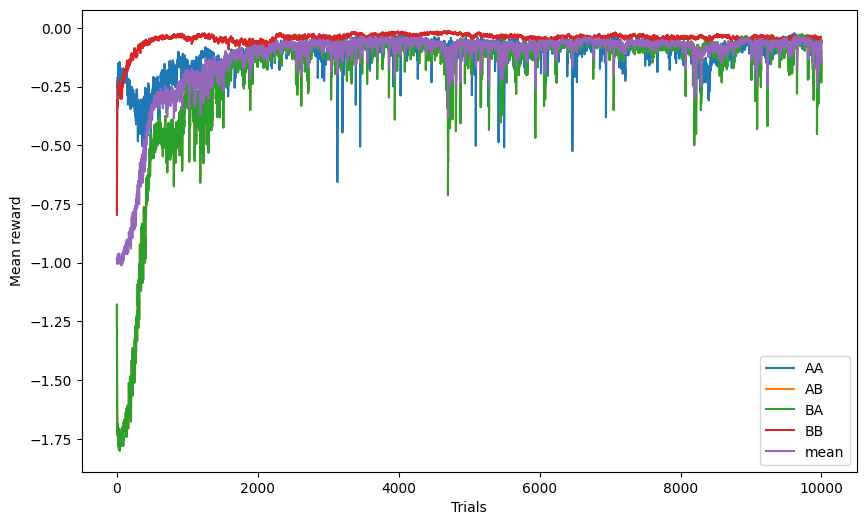

In [12]:
record_rewards = np.array(record_rewards)

plt.figure(figsize=(10, 6))
plt.plot(record_rewards[:, 0, 0], label='AA')
plt.plot(record_rewards[:, 0, 1], label='AB')
plt.plot(record_rewards[:, 1, 0], label='BA')
plt.plot(record_rewards[:, 1, 1], label='BB')
plt.plot(record_rewards.mean(axis=(1,2)), label='mean')

plt.xlabel("Trials")
plt.ylabel("Mean reward")
plt.legend()
plt.show()

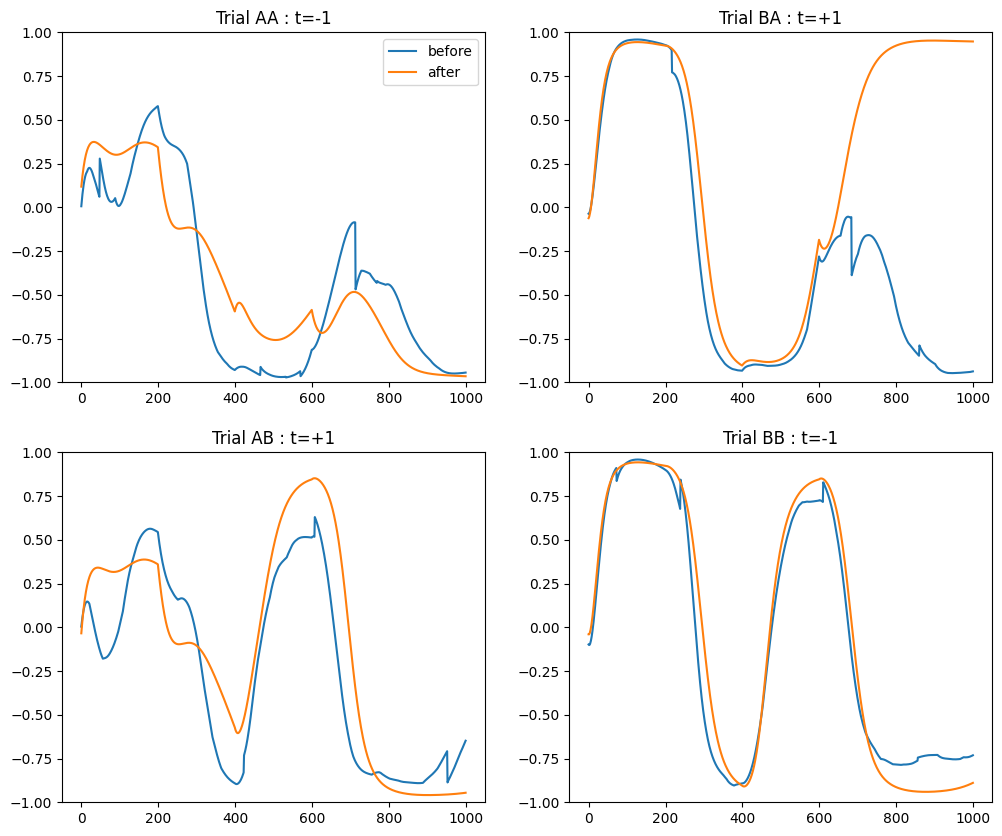

In [13]:
# Perform the four different trials without perturbation for testing
recordsAA, errorAA = dnms_trial(0, [0, 0], -0.98, 0.0, record=True, perturbation=False)
recordsAB, errorAB = dnms_trial(0, [0, 1], +0.98, 0.0, record=True, perturbation=False)
recordsBA, errorBA = dnms_trial(0, [1, 0], +0.98, 0.0, record=True, perturbation=False)
recordsBB, errorBB = dnms_trial(0, [1, 1], -0.98, 0.0, record=True, perturbation=False)

plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.plot(initialAA[:, OUTPUT_NEURON], label='before')
plt.plot(recordsAA[:, OUTPUT_NEURON], label='after')
plt.legend()
plt.ylim((-1., 1.))
plt.title('Trial AA : t=-1')
plt.subplot(222)
plt.plot(initialBA[:, OUTPUT_NEURON], label='before')
plt.plot(recordsBA[:, OUTPUT_NEURON], label='after')
plt.ylim((-1., 1.))
plt.title('Trial BA : t=+1')
plt.subplot(223)
plt.plot(initialAB[:, OUTPUT_NEURON], label='before')
plt.plot(recordsAB[:, OUTPUT_NEURON], label='after')
plt.ylim((-1., 1.))
plt.title('Trial AB : t=+1')
plt.subplot(224)
plt.plot(initialBB[:, OUTPUT_NEURON], label='before')
plt.plot(recordsBB[:, OUTPUT_NEURON], label='after')
plt.ylim((-1., 1.))
plt.title('Trial BB : t=-1')
plt.show()